### Note

The Google Colab free tier terminates the instance after 90 minutes of idle time. You can keep the instance running for up to 12 hours by periodically making changes to the notebook. After termination, any stored files will be removed. To protect any files that you would like to keep, please download them to your computer.

Stored files can be found in the "Files" menu on the left toolbar:

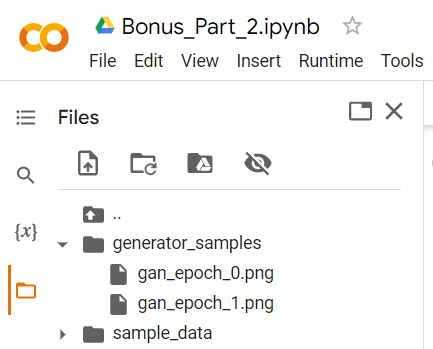

Last edited: 4/19/2022

### Setup
Go to "Runtime" in the Google Colab toolbar. From the drop-down menu, select "Change runtime type". In the Hardware accelerator drop-down menu, select GPU.

## Deep Convolutional GAN (Deep Convolutional GAN)

Author: George Stathopoulos

Last modified: April 4, 2022

Description: A script to train a GAN on MNIST. Generates image samples from the generator and saves to a local directory, does not save the models.

In [2]:
import matplotlib
matplotlib.use('Agg')

import keras
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.regularizers import l2
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import Conv2D, Conv2DTranspose, Flatten
from keras.layers import Reshape, UpSampling2D, MaxPooling2D
from keras.layers import LeakyReLU, Input
from keras.layers import BatchNormalization
from keras.utils import np_utils

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import os
import time

# Some constants
MNIST_SIZE = 28
LATENT_DIM = 100

## Return MNIST dataset, shaped appropriately depending on whether we are
## want to train a dense or convolutional neural net
def get_data():
    # Import the MNIST dataset using Keras
    (X_train, y_train), (X_test, y_test) = mnist.load_data()

    # Normalize input images to have all values in [0, 1]
    # Reshape image dataset to have shape (N, H, W, C) instead of (N, H, W)
    X_train = X_train.reshape((*(X_train.shape), 1)) / 255
    X_test = X_test.reshape((*(X_test.shape), 1)) / 255

    # Convert labels to one-hot vectors (probability distributions w/
    # probability 1 assigned to the correct label)
    y_train = np_utils.to_categorical(y_train)
    y_test = np_utils.to_categorical(y_test)

    return (X_train, y_train), (X_test, y_test)

def make_generator(num_filters=64, num_hidden_conv_layers=2, init_dim=7):
    gen = Sequential()
    # Model input is a feature vector of size 100
    gen.add(Dense(init_dim**2 * num_filters, input_dim=LATENT_DIM))
    gen.add(Activation('relu'))
    gen.add(Reshape((init_dim, init_dim, num_filters)))

    for _ in range(num_hidden_conv_layers):
        # Input: d x d x k
        # Output 2d x 2d x k/2
        if (init_dim < MNIST_SIZE):
            gen.add(UpSampling2D())
            init_dim *= 2
        num_filters //= 2
        gen.add(Conv2DTranspose(num_filters, 5, padding='same'))
        gen.add(BatchNormalization(momentum=0.4))
        gen.add(Activation('relu'))

    gen.add(Conv2DTranspose(1, 5, padding='same'))
    gen.add(Activation('sigmoid'))
    # Output should be 28 x 28 x 1
    # gen.summary()
    return gen

def make_discriminator(num_filters=32, num_hidden_layers=3, dropout=0.3):
    d = Sequential()

    d.add(Conv2D(num_filters*1, 5, strides=2,
                 input_shape=(MNIST_SIZE, MNIST_SIZE, 1), padding='same'))
    d.add(LeakyReLU()) # leakyrelu so generator has derivative
    d.add(Dropout(dropout))

    for i in range(1, num_hidden_layers):
        # Powers of 2 are generally better suited for GPU
        d.add(Conv2D(num_filters*(2**i), 5, strides=2, padding='same'))
        d.add(LeakyReLU())
        d.add(Dropout(dropout))

    # NOTE: Difference between this and build_conv_net
    #       is that there is only a SINGLE output class,
    #       which corresponds to FAKE/REAL.
    d.add(Flatten())
    d.add(Dense(1))
    d.add(Activation('sigmoid'))
    d.compile(loss='binary_crossentropy', optimizer='adam')
    return d

def make_adversial_network(generator, discriminator):
    # This will only be used for training the generator.
    # Note, the weights in the discriminator and generator are shared.
    discriminator.trainable = False
    gan = Sequential([generator, discriminator])
    gan.compile(loss='binary_crossentropy', optimizer='adam')
    return gan #, generator, discriminator

def generate_latent_noise(n):
    return np.random.uniform(-1, 1, size=(n, LATENT_DIM))

def visualize_generator(epoch, generator,
                        num_samples=100, dim=(10,10),
                        figsize=(10,10), path=''):
    plt.figure(figsize=figsize)
    for i in range(num_samples):
        plt.subplot(dim[0], dim[1], i+1)
        img = generator.predict(generate_latent_noise(1))[0,:,:,0]
        plt.imshow(img, cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(f'generator_samples/gan_epoch_{epoch}.png')
    plt.close()

def train(epochs=1, batch_size=128, path=''):
    # Import the MNIST dataset using Keras, will only
    # use the 60,000 training examples.
    (X_train, _), _ = get_data()

    # Creating GAN
    generator     = make_generator()
    discriminator = make_discriminator()
    adversial_net = make_adversial_network(generator, discriminator)

    start = time.time()

    visualize_generator(0, generator, path=path)
    for epoch in range(epochs):
        start = time.time()
        print(f'Epoch {epoch+1}')

        discr_loss = 0
        gen_loss = 0
        for _ in tqdm(range(batch_size)):
            noise = generate_latent_noise(batch_size)
            generated_images = generator.predict(noise)

            real_images = X_train[np.random.choice(X_train.shape[0], batch_size,
                                                   replace=False)]

            discrimination_data = np.concatenate([real_images, generated_images])

            # Labels for generated and real data, uses soft label trick
            discrimination_labels = 0.1 * np.ones(2 * batch_size)
            discrimination_labels[:batch_size] = 0.9

            # To train, we alternate between training just the discriminator
            # and just the generator.
            discriminator.trainable = True
            discr_loss += discriminator.train_on_batch(discrimination_data,
                                                       discrimination_labels)

            # Trick to 'freeze' discriminator weights in adversial_net. Only
            # the generator weights will be changed, which are shared with
            # the generator.
            discriminator.trainable = False
            # N.B, changing the labels because now we want to 'fool' the
            # discriminator.
            gen_loss += adversial_net.train_on_batch(noise, np.ones(batch_size))

        print(f'Discriminator Loss: {discr_loss/batch_size}')
        print(f'Generator Loss:     {gen_loss/batch_size}')
        print(time.time() - start)
        visualize_generator(epoch+1, generator, path=path)

        print((time.time() - start) / 3600)

In [3]:
os.makedirs(os.path.join(os.getcwd(), 'generator_samples'), exist_ok=True)
train(epochs=150)

1/1 [==============================] - 0s 22ms/step
Epoch 1


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 23ms/step


  1%|          | 1/128 [00:01<03:21,  1.58s/it]

4/4 [==============================] - 0s 25ms/step


  2%|▏         | 2/128 [00:01<01:52,  1.12it/s]

4/4 [==============================] - 0s 21ms/step


  2%|▏         | 3/128 [00:02<01:22,  1.51it/s]

4/4 [==============================] - 0s 22ms/step


  3%|▎         | 4/128 [00:02<01:08,  1.82it/s]

4/4 [==============================] - 0s 22ms/step


  4%|▍         | 5/128 [00:03<01:01,  2.01it/s]

4/4 [==============================] - 0s 22ms/step


  5%|▍         | 6/128 [00:03<00:58,  2.07it/s]

4/4 [==============================] - 0s 22ms/step


  5%|▌         | 7/128 [00:04<00:55,  2.17it/s]

4/4 [==============================] - 0s 22ms/step


  6%|▋         | 8/128 [00:04<00:53,  2.24it/s]

4/4 [==============================] - 0s 23ms/step


  7%|▋         | 9/128 [00:04<00:51,  2.30it/s]

4/4 [==============================] - 0s 22ms/step


  8%|▊         | 10/128 [00:05<00:51,  2.29it/s]

4/4 [==============================] - 0s 24ms/step


  9%|▊         | 11/128 [00:05<00:51,  2.28it/s]

4/4 [==============================] - 0s 23ms/step


  9%|▉         | 12/128 [00:06<00:51,  2.26it/s]

4/4 [==============================] - 0s 22ms/step


 10%|█         | 13/128 [00:06<00:50,  2.27it/s]

4/4 [==============================] - 0s 21ms/step


 11%|█         | 14/128 [00:07<00:48,  2.35it/s]

4/4 [==============================] - 0s 21ms/step


 12%|█▏        | 15/128 [00:07<00:47,  2.36it/s]

4/4 [==============================] - 0s 23ms/step


 12%|█▎        | 16/128 [00:07<00:47,  2.35it/s]

4/4 [==============================] - 0s 21ms/step


 13%|█▎        | 17/128 [00:08<00:47,  2.35it/s]

4/4 [==============================] - 0s 22ms/step


 14%|█▍        | 18/128 [00:08<00:46,  2.36it/s]

4/4 [==============================] - 0s 21ms/step


 15%|█▍        | 19/128 [00:09<00:45,  2.37it/s]

4/4 [==============================] - 0s 22ms/step


 16%|█▌        | 20/128 [00:09<00:45,  2.36it/s]

4/4 [==============================] - 0s 23ms/step


 16%|█▋        | 21/128 [00:09<00:44,  2.41it/s]

4/4 [==============================] - 0s 26ms/step


 17%|█▋        | 22/128 [00:10<00:44,  2.37it/s]

4/4 [==============================] - 0s 23ms/step


 18%|█▊        | 23/128 [00:10<00:44,  2.35it/s]

4/4 [==============================] - 0s 23ms/step


 19%|█▉        | 24/128 [00:11<00:43,  2.39it/s]

4/4 [==============================] - 0s 21ms/step


 20%|█▉        | 25/128 [00:11<00:42,  2.42it/s]

4/4 [==============================] - 0s 23ms/step


 20%|██        | 26/128 [00:12<00:41,  2.47it/s]

4/4 [==============================] - 0s 21ms/step


 21%|██        | 27/128 [00:12<00:40,  2.47it/s]

4/4 [==============================] - 0s 23ms/step


 22%|██▏       | 28/128 [00:12<00:40,  2.49it/s]

4/4 [==============================] - 0s 22ms/step


 23%|██▎       | 29/128 [00:13<00:39,  2.49it/s]

4/4 [==============================] - 0s 24ms/step


 23%|██▎       | 30/128 [00:13<00:39,  2.48it/s]

4/4 [==============================] - 0s 21ms/step


 24%|██▍       | 31/128 [00:14<00:38,  2.50it/s]

4/4 [==============================] - 0s 21ms/step


 25%|██▌       | 32/128 [00:14<00:38,  2.52it/s]

4/4 [==============================] - 0s 20ms/step


 26%|██▌       | 33/128 [00:14<00:37,  2.55it/s]

4/4 [==============================] - 0s 21ms/step


 27%|██▋       | 34/128 [00:15<00:36,  2.56it/s]

4/4 [==============================] - 0s 22ms/step


 27%|██▋       | 35/128 [00:15<00:36,  2.52it/s]

4/4 [==============================] - 0s 22ms/step


 28%|██▊       | 36/128 [00:16<00:37,  2.44it/s]

4/4 [==============================] - 0s 24ms/step


 29%|██▉       | 37/128 [00:16<00:37,  2.43it/s]

4/4 [==============================] - 0s 22ms/step


 30%|██▉       | 38/128 [00:16<00:36,  2.46it/s]

4/4 [==============================] - 0s 21ms/step


 30%|███       | 39/128 [00:17<00:35,  2.49it/s]

4/4 [==============================] - 0s 21ms/step


 31%|███▏      | 40/128 [00:17<00:34,  2.52it/s]

4/4 [==============================] - 0s 22ms/step


 32%|███▏      | 41/128 [00:17<00:34,  2.55it/s]

4/4 [==============================] - 0s 21ms/step


 33%|███▎      | 42/128 [00:18<00:33,  2.54it/s]

4/4 [==============================] - 0s 22ms/step


 34%|███▎      | 43/128 [00:18<00:33,  2.53it/s]

4/4 [==============================] - 0s 22ms/step


 34%|███▍      | 44/128 [00:19<00:33,  2.52it/s]

4/4 [==============================] - 0s 21ms/step


 35%|███▌      | 45/128 [00:19<00:32,  2.55it/s]

4/4 [==============================] - 0s 21ms/step


 36%|███▌      | 46/128 [00:19<00:32,  2.56it/s]

4/4 [==============================] - 0s 24ms/step


 37%|███▋      | 47/128 [00:20<00:32,  2.49it/s]

4/4 [==============================] - 0s 23ms/step


 38%|███▊      | 48/128 [00:20<00:33,  2.41it/s]

4/4 [==============================] - 0s 23ms/step


 38%|███▊      | 49/128 [00:21<00:33,  2.38it/s]

4/4 [==============================] - 0s 22ms/step


 39%|███▉      | 50/128 [00:21<00:32,  2.40it/s]

4/4 [==============================] - 0s 23ms/step


 40%|███▉      | 51/128 [00:22<00:31,  2.44it/s]

4/4 [==============================] - 0s 22ms/step


 41%|████      | 52/128 [00:22<00:30,  2.50it/s]

4/4 [==============================] - 0s 22ms/step


 41%|████▏     | 53/128 [00:22<00:29,  2.51it/s]

4/4 [==============================] - 0s 23ms/step


 42%|████▏     | 54/128 [00:23<00:29,  2.50it/s]

4/4 [==============================] - 0s 23ms/step


 43%|████▎     | 55/128 [00:23<00:29,  2.50it/s]

4/4 [==============================] - 0s 23ms/step


 44%|████▍     | 56/128 [00:24<00:29,  2.46it/s]

4/4 [==============================] - 0s 22ms/step


 45%|████▍     | 57/128 [00:24<00:28,  2.48it/s]

4/4 [==============================] - 0s 22ms/step


 45%|████▌     | 58/128 [00:24<00:27,  2.51it/s]

4/4 [==============================] - 0s 22ms/step


 46%|████▌     | 59/128 [00:25<00:27,  2.51it/s]

4/4 [==============================] - 0s 22ms/step


 47%|████▋     | 60/128 [00:25<00:27,  2.45it/s]

4/4 [==============================] - 0s 23ms/step


 48%|████▊     | 61/128 [00:26<00:27,  2.41it/s]

4/4 [==============================] - 0s 24ms/step


 48%|████▊     | 62/128 [00:26<00:27,  2.43it/s]

4/4 [==============================] - 0s 23ms/step


 49%|████▉     | 63/128 [00:26<00:26,  2.46it/s]

4/4 [==============================] - 0s 22ms/step


 50%|█████     | 64/128 [00:27<00:25,  2.50it/s]

4/4 [==============================] - 0s 22ms/step


 51%|█████     | 65/128 [00:27<00:24,  2.52it/s]

4/4 [==============================] - 0s 24ms/step


 52%|█████▏    | 66/128 [00:28<00:24,  2.52it/s]

4/4 [==============================] - 0s 23ms/step


 52%|█████▏    | 67/128 [00:28<00:24,  2.48it/s]

4/4 [==============================] - 0s 24ms/step


 53%|█████▎    | 68/128 [00:28<00:24,  2.42it/s]

4/4 [==============================] - 0s 22ms/step


 54%|█████▍    | 69/128 [00:29<00:24,  2.42it/s]

4/4 [==============================] - 0s 21ms/step


 55%|█████▍    | 70/128 [00:29<00:23,  2.47it/s]

4/4 [==============================] - 0s 21ms/step


 55%|█████▌    | 71/128 [00:30<00:22,  2.52it/s]

4/4 [==============================] - 0s 22ms/step


 56%|█████▋    | 72/128 [00:30<00:22,  2.45it/s]

4/4 [==============================] - 0s 23ms/step


 57%|█████▋    | 73/128 [00:30<00:22,  2.42it/s]

4/4 [==============================] - 0s 21ms/step


 58%|█████▊    | 74/128 [00:31<00:22,  2.45it/s]

4/4 [==============================] - 0s 22ms/step


 59%|█████▊    | 75/128 [00:31<00:21,  2.44it/s]

4/4 [==============================] - 0s 21ms/step


 59%|█████▉    | 76/128 [00:32<00:20,  2.48it/s]

4/4 [==============================] - 0s 21ms/step


 60%|██████    | 77/128 [00:32<00:20,  2.50it/s]

4/4 [==============================] - 0s 21ms/step


 61%|██████    | 78/128 [00:32<00:19,  2.51it/s]

4/4 [==============================] - 0s 22ms/step


 62%|██████▏   | 79/128 [00:33<00:19,  2.53it/s]

4/4 [==============================] - 0s 22ms/step


 62%|██████▎   | 80/128 [00:33<00:19,  2.49it/s]

4/4 [==============================] - 0s 22ms/step


 63%|██████▎   | 81/128 [00:34<00:18,  2.50it/s]

4/4 [==============================] - 0s 21ms/step


 64%|██████▍   | 82/128 [00:34<00:18,  2.52it/s]

4/4 [==============================] - 0s 22ms/step


 65%|██████▍   | 83/128 [00:34<00:17,  2.55it/s]

4/4 [==============================] - 0s 22ms/step


 66%|██████▌   | 84/128 [00:35<00:17,  2.53it/s]

4/4 [==============================] - 0s 22ms/step


 66%|██████▋   | 85/128 [00:35<00:17,  2.42it/s]

4/4 [==============================] - 0s 22ms/step


 67%|██████▋   | 86/128 [00:36<00:17,  2.42it/s]

4/4 [==============================] - 0s 22ms/step


 68%|██████▊   | 87/128 [00:36<00:16,  2.42it/s]

4/4 [==============================] - 0s 23ms/step


 69%|██████▉   | 88/128 [00:37<00:16,  2.41it/s]

4/4 [==============================] - 0s 22ms/step


 70%|██████▉   | 89/128 [00:37<00:15,  2.45it/s]

4/4 [==============================] - 0s 23ms/step


 70%|███████   | 90/128 [00:37<00:15,  2.45it/s]

4/4 [==============================] - 0s 22ms/step


 71%|███████   | 91/128 [00:38<00:14,  2.47it/s]

4/4 [==============================] - 0s 22ms/step


 72%|███████▏  | 92/128 [00:38<00:14,  2.49it/s]

4/4 [==============================] - 0s 23ms/step


 73%|███████▎  | 93/128 [00:39<00:14,  2.47it/s]

4/4 [==============================] - 0s 22ms/step


 73%|███████▎  | 94/128 [00:39<00:13,  2.48it/s]

4/4 [==============================] - 0s 22ms/step


 74%|███████▍  | 95/128 [00:39<00:13,  2.52it/s]

4/4 [==============================] - 0s 23ms/step


 75%|███████▌  | 96/128 [00:40<00:12,  2.51it/s]

4/4 [==============================] - 0s 22ms/step


 76%|███████▌  | 97/128 [00:40<00:12,  2.47it/s]

4/4 [==============================] - 0s 24ms/step


 77%|███████▋  | 98/128 [00:41<00:12,  2.41it/s]

4/4 [==============================] - 0s 23ms/step


 77%|███████▋  | 99/128 [00:41<00:11,  2.42it/s]

4/4 [==============================] - 0s 22ms/step


 78%|███████▊  | 100/128 [00:41<00:11,  2.43it/s]

4/4 [==============================] - 0s 20ms/step


 79%|███████▉  | 101/128 [00:42<00:10,  2.49it/s]

4/4 [==============================] - 0s 21ms/step


 80%|███████▉  | 102/128 [00:42<00:10,  2.52it/s]

4/4 [==============================] - 0s 21ms/step


 80%|████████  | 103/128 [00:43<00:09,  2.52it/s]

4/4 [==============================] - 0s 23ms/step


 81%|████████▏ | 104/128 [00:43<00:09,  2.51it/s]

4/4 [==============================] - 0s 23ms/step


 82%|████████▏ | 105/128 [00:43<00:09,  2.47it/s]

4/4 [==============================] - 0s 22ms/step


 83%|████████▎ | 106/128 [00:44<00:08,  2.47it/s]

4/4 [==============================] - 0s 21ms/step


 84%|████████▎ | 107/128 [00:44<00:08,  2.50it/s]

4/4 [==============================] - 0s 22ms/step


 84%|████████▍ | 108/128 [00:45<00:08,  2.49it/s]

4/4 [==============================] - 0s 22ms/step


 85%|████████▌ | 109/128 [00:45<00:07,  2.49it/s]

4/4 [==============================] - 0s 26ms/step


 86%|████████▌ | 110/128 [00:45<00:07,  2.40it/s]

4/4 [==============================] - 0s 22ms/step


 87%|████████▋ | 111/128 [00:46<00:07,  2.43it/s]

4/4 [==============================] - 0s 22ms/step


 88%|████████▊ | 112/128 [00:46<00:06,  2.42it/s]

4/4 [==============================] - 0s 21ms/step


 88%|████████▊ | 113/128 [00:47<00:06,  2.46it/s]

4/4 [==============================] - 0s 21ms/step


 89%|████████▉ | 114/128 [00:47<00:05,  2.48it/s]

4/4 [==============================] - 0s 22ms/step


 90%|████████▉ | 115/128 [00:47<00:05,  2.44it/s]

4/4 [==============================] - 0s 21ms/step


 91%|█████████ | 116/128 [00:48<00:04,  2.45it/s]

4/4 [==============================] - 0s 21ms/step


 91%|█████████▏| 117/128 [00:48<00:04,  2.45it/s]

4/4 [==============================] - 0s 23ms/step


 92%|█████████▏| 118/128 [00:49<00:04,  2.45it/s]

4/4 [==============================] - 0s 21ms/step


 93%|█████████▎| 119/128 [00:49<00:03,  2.46it/s]

4/4 [==============================] - 0s 20ms/step


 94%|█████████▍| 120/128 [00:49<00:03,  2.47it/s]

4/4 [==============================] - 0s 25ms/step


 95%|█████████▍| 121/128 [00:50<00:02,  2.45it/s]

4/4 [==============================] - 0s 23ms/step


 95%|█████████▌| 122/128 [00:50<00:02,  2.38it/s]

4/4 [==============================] - 0s 22ms/step


 96%|█████████▌| 123/128 [00:51<00:02,  2.39it/s]

4/4 [==============================] - 0s 22ms/step


 97%|█████████▋| 124/128 [00:51<00:01,  2.43it/s]

4/4 [==============================] - 0s 25ms/step


 98%|█████████▊| 125/128 [00:52<00:01,  2.41it/s]

4/4 [==============================] - 0s 23ms/step


 98%|█████████▊| 126/128 [00:52<00:00,  2.44it/s]

4/4 [==============================] - 0s 23ms/step


 99%|█████████▉| 127/128 [00:52<00:00,  2.43it/s]

4/4 [==============================] - 0s 22ms/step


100%|██████████| 128/128 [00:53<00:00,  2.40it/s]

Discriminator Loss: 0.41793440328910947
Generator Loss:     2.095355950295925
53.28742027282715
1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 32ms/step
0.016989417142338224
Epoch 2


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 23ms/step


  1%|          | 1/128 [00:00<00:50,  2.52it/s]

4/4 [==============================] - 0s 22ms/step


  2%|▏         | 2/128 [00:00<00:51,  2.46it/s]

4/4 [==============================] - 0s 20ms/step


  2%|▏         | 3/128 [00:01<00:52,  2.39it/s]

4/4 [==============================] - 0s 21ms/step


  3%|▎         | 4/128 [00:01<00:51,  2.43it/s]

4/4 [==============================] - 0s 21ms/step


  4%|▍         | 5/128 [00:02<00:49,  2.48it/s]

4/4 [==============================] - 0s 22ms/step


  5%|▍         | 6/128 [00:02<00:49,  2.46it/s]

4/4 [==============================] - 0s 21ms/step


  5%|▌         | 7/128 [00:02<00:49,  2.44it/s]

4/4 [==============================] - 0s 21ms/step


  6%|▋         | 8/128 [00:03<00:48,  2.48it/s]

4/4 [==============================] - 0s 22ms/step


  7%|▋         | 9/128 [00:03<00:48,  2.48it/s]

4/4 [==============================] - 0s 22ms/step


  8%|▊         | 10/128 [00:04<00:48,  2.45it/s]

4/4 [==============================] - 0s 21ms/step


  9%|▊         | 11/128 [00:04<00:48,  2.42it/s]

4/4 [==============================] - 0s 23ms/step


  9%|▉         | 12/128 [00:04<00:48,  2.38it/s]

4/4 [==============================] - 0s 21ms/step


 10%|█         | 13/128 [00:05<00:47,  2.40it/s]

4/4 [==============================] - 0s 21ms/step


 11%|█         | 14/128 [00:05<00:46,  2.45it/s]

4/4 [==============================] - 0s 20ms/step


 12%|█▏        | 15/128 [00:06<00:45,  2.49it/s]

4/4 [==============================] - 0s 23ms/step


 12%|█▎        | 16/128 [00:06<00:45,  2.48it/s]

4/4 [==============================] - 0s 21ms/step


 13%|█▎        | 17/128 [00:06<00:44,  2.50it/s]

4/4 [==============================] - 0s 22ms/step


 14%|█▍        | 18/128 [00:07<00:44,  2.48it/s]

4/4 [==============================] - 0s 24ms/step


 15%|█▍        | 19/128 [00:07<00:44,  2.43it/s]

4/4 [==============================] - 0s 21ms/step


 16%|█▌        | 20/128 [00:08<00:43,  2.46it/s]

4/4 [==============================] - 0s 21ms/step


 16%|█▋        | 21/128 [00:08<00:43,  2.48it/s]

4/4 [==============================] - 0s 21ms/step


 17%|█▋        | 22/128 [00:08<00:42,  2.49it/s]

4/4 [==============================] - 0s 22ms/step


 18%|█▊        | 23/128 [00:09<00:42,  2.47it/s]

4/4 [==============================] - 0s 24ms/step


 19%|█▉        | 24/128 [00:09<00:43,  2.38it/s]

4/4 [==============================] - 0s 23ms/step


 20%|█▉        | 25/128 [00:10<00:43,  2.36it/s]

4/4 [==============================] - 0s 21ms/step


 20%|██        | 26/128 [00:10<00:42,  2.40it/s]

4/4 [==============================] - 0s 23ms/step


 21%|██        | 27/128 [00:11<00:41,  2.43it/s]

4/4 [==============================] - 0s 24ms/step


 22%|██▏       | 28/128 [00:11<00:41,  2.40it/s]

4/4 [==============================] - 0s 21ms/step


 23%|██▎       | 29/128 [00:11<00:40,  2.43it/s]

4/4 [==============================] - 0s 22ms/step


 23%|██▎       | 30/128 [00:12<00:40,  2.44it/s]

4/4 [==============================] - 0s 23ms/step


 24%|██▍       | 31/128 [00:12<00:40,  2.39it/s]

4/4 [==============================] - 0s 21ms/step


 25%|██▌       | 32/128 [00:13<00:39,  2.41it/s]

4/4 [==============================] - 0s 21ms/step


 26%|██▌       | 33/128 [00:13<00:38,  2.45it/s]

4/4 [==============================] - 0s 21ms/step


 27%|██▋       | 34/128 [00:13<00:38,  2.43it/s]

4/4 [==============================] - 0s 23ms/step


 27%|██▋       | 35/128 [00:14<00:39,  2.37it/s]

4/4 [==============================] - 0s 25ms/step


 28%|██▊       | 36/128 [00:14<00:40,  2.29it/s]

4/4 [==============================] - 0s 24ms/step


 29%|██▉       | 37/128 [00:15<00:39,  2.29it/s]

4/4 [==============================] - 0s 24ms/step


 30%|██▉       | 38/128 [00:15<00:39,  2.29it/s]

4/4 [==============================] - 0s 25ms/step


 30%|███       | 39/128 [00:16<00:38,  2.31it/s]

4/4 [==============================] - 0s 22ms/step


 31%|███▏      | 40/128 [00:16<00:38,  2.31it/s]

4/4 [==============================] - 0s 22ms/step


 32%|███▏      | 41/128 [00:16<00:36,  2.36it/s]

4/4 [==============================] - 0s 22ms/step


 33%|███▎      | 42/128 [00:17<00:36,  2.37it/s]

4/4 [==============================] - 0s 23ms/step


 34%|███▎      | 43/128 [00:17<00:35,  2.37it/s]

4/4 [==============================] - 0s 25ms/step


 34%|███▍      | 44/128 [00:18<00:35,  2.34it/s]

4/4 [==============================] - 0s 22ms/step


 35%|███▌      | 45/128 [00:18<00:34,  2.37it/s]

4/4 [==============================] - 0s 23ms/step


 36%|███▌      | 46/128 [00:19<00:34,  2.35it/s]

4/4 [==============================] - 0s 22ms/step


 37%|███▋      | 47/128 [00:19<00:35,  2.29it/s]

4/4 [==============================] - 0s 26ms/step


 38%|███▊      | 48/128 [00:20<00:36,  2.22it/s]

4/4 [==============================] - 0s 26ms/step


 38%|███▊      | 49/128 [00:20<00:35,  2.23it/s]

4/4 [==============================] - 0s 23ms/step


 39%|███▉      | 50/128 [00:20<00:34,  2.28it/s]

4/4 [==============================] - 0s 20ms/step


 40%|███▉      | 51/128 [00:21<00:32,  2.37it/s]

4/4 [==============================] - 0s 23ms/step


 41%|████      | 52/128 [00:21<00:31,  2.40it/s]

4/4 [==============================] - 0s 20ms/step


 41%|████▏     | 53/128 [00:22<00:30,  2.43it/s]

4/4 [==============================] - 0s 23ms/step


 42%|████▏     | 54/128 [00:22<00:30,  2.46it/s]

4/4 [==============================] - 0s 23ms/step


 43%|████▎     | 55/128 [00:22<00:29,  2.44it/s]

4/4 [==============================] - 0s 23ms/step


 44%|████▍     | 56/128 [00:23<00:30,  2.39it/s]

4/4 [==============================] - 0s 21ms/step


 45%|████▍     | 57/128 [00:23<00:29,  2.44it/s]

4/4 [==============================] - 0s 23ms/step


 45%|████▌     | 58/128 [00:24<00:28,  2.42it/s]

4/4 [==============================] - 0s 21ms/step


 46%|████▌     | 59/128 [00:24<00:28,  2.40it/s]

4/4 [==============================] - 0s 23ms/step


 47%|████▋     | 60/128 [00:25<00:28,  2.37it/s]

4/4 [==============================] - 0s 23ms/step


 48%|████▊     | 61/128 [00:25<00:28,  2.38it/s]

4/4 [==============================] - 0s 23ms/step


 48%|████▊     | 62/128 [00:25<00:27,  2.41it/s]

4/4 [==============================] - 0s 21ms/step


 49%|████▉     | 63/128 [00:26<00:26,  2.44it/s]

4/4 [==============================] - 0s 22ms/step


 50%|█████     | 64/128 [00:26<00:25,  2.48it/s]

4/4 [==============================] - 0s 23ms/step


 51%|█████     | 65/128 [00:27<00:25,  2.48it/s]

4/4 [==============================] - 0s 23ms/step


 52%|█████▏    | 66/128 [00:27<00:25,  2.45it/s]

4/4 [==============================] - 0s 23ms/step


 52%|█████▏    | 67/128 [00:27<00:25,  2.42it/s]

4/4 [==============================] - 0s 17ms/step


 53%|█████▎    | 68/128 [00:28<00:23,  2.55it/s]

4/4 [==============================] - 0s 14ms/step


 54%|█████▍    | 69/128 [00:28<00:21,  2.73it/s]

4/4 [==============================] - 0s 14ms/step


 55%|█████▍    | 70/128 [00:28<00:20,  2.81it/s]

4/4 [==============================] - 0s 20ms/step


 55%|█████▌    | 71/128 [00:29<00:21,  2.61it/s]

4/4 [==============================] - 0s 14ms/step


 56%|█████▋    | 72/128 [00:29<00:20,  2.71it/s]

4/4 [==============================] - 0s 16ms/step


 57%|█████▋    | 73/128 [00:30<00:20,  2.73it/s]

4/4 [==============================] - 0s 16ms/step


 58%|█████▊    | 74/128 [00:30<00:19,  2.80it/s]

4/4 [==============================] - 0s 13ms/step


 59%|█████▊    | 75/128 [00:30<00:17,  2.98it/s]

4/4 [==============================] - 0s 17ms/step


 59%|█████▉    | 76/128 [00:30<00:17,  2.96it/s]

4/4 [==============================] - 0s 26ms/step


 60%|██████    | 77/128 [00:31<00:19,  2.66it/s]

4/4 [==============================] - 0s 24ms/step


 61%|██████    | 78/128 [00:31<00:19,  2.55it/s]

4/4 [==============================] - 0s 17ms/step


 62%|██████▏   | 79/128 [00:32<00:19,  2.52it/s]

4/4 [==============================] - 0s 20ms/step


 62%|██████▎   | 80/128 [00:32<00:19,  2.47it/s]

4/4 [==============================] - 0s 19ms/step


 63%|██████▎   | 81/128 [00:33<00:19,  2.47it/s]

4/4 [==============================] - 0s 18ms/step


 64%|██████▍   | 82/128 [00:33<00:18,  2.52it/s]

4/4 [==============================] - 0s 19ms/step


 65%|██████▍   | 83/128 [00:33<00:17,  2.54it/s]

4/4 [==============================] - 0s 21ms/step


 66%|██████▌   | 84/128 [00:34<00:17,  2.59it/s]

4/4 [==============================] - 0s 22ms/step


 66%|██████▋   | 85/128 [00:34<00:17,  2.52it/s]

4/4 [==============================] - 0s 20ms/step


 67%|██████▋   | 86/128 [00:35<00:16,  2.49it/s]

4/4 [==============================] - 0s 18ms/step


 68%|██████▊   | 87/128 [00:35<00:16,  2.55it/s]

4/4 [==============================] - 0s 16ms/step


 69%|██████▉   | 88/128 [00:35<00:15,  2.61it/s]

4/4 [==============================] - 0s 27ms/step


 70%|██████▉   | 89/128 [00:36<00:15,  2.51it/s]

4/4 [==============================] - 0s 22ms/step


 70%|███████   | 90/128 [00:36<00:14,  2.55it/s]

4/4 [==============================] - 0s 16ms/step


 71%|███████   | 91/128 [00:36<00:13,  2.69it/s]

4/4 [==============================] - 0s 13ms/step


 72%|███████▏  | 92/128 [00:37<00:13,  2.77it/s]

4/4 [==============================] - 0s 16ms/step


 73%|███████▎  | 93/128 [00:37<00:12,  2.76it/s]

4/4 [==============================] - 0s 18ms/step


 73%|███████▎  | 94/128 [00:38<00:12,  2.72it/s]

4/4 [==============================] - 0s 15ms/step


 74%|███████▍  | 95/128 [00:38<00:11,  2.75it/s]

4/4 [==============================] - 0s 18ms/step


 75%|███████▌  | 96/128 [00:38<00:11,  2.78it/s]

4/4 [==============================] - 0s 19ms/step


 76%|███████▌  | 97/128 [00:39<00:11,  2.72it/s]

4/4 [==============================] - 0s 18ms/step


 77%|███████▋  | 98/128 [00:39<00:11,  2.66it/s]

4/4 [==============================] - 0s 20ms/step


 77%|███████▋  | 99/128 [00:39<00:11,  2.59it/s]

4/4 [==============================] - 0s 19ms/step


 78%|███████▊  | 100/128 [00:40<00:10,  2.65it/s]

4/4 [==============================] - 0s 15ms/step


 79%|███████▉  | 101/128 [00:40<00:09,  2.71it/s]

4/4 [==============================] - 0s 16ms/step


 80%|███████▉  | 102/128 [00:40<00:08,  2.90it/s]

4/4 [==============================] - 0s 15ms/step


 80%|████████  | 103/128 [00:41<00:08,  2.93it/s]

4/4 [==============================] - 0s 13ms/step


 81%|████████▏ | 104/128 [00:41<00:07,  3.05it/s]

4/4 [==============================] - 0s 16ms/step


 82%|████████▏ | 105/128 [00:41<00:07,  3.05it/s]

4/4 [==============================] - 0s 16ms/step


 83%|████████▎ | 106/128 [00:42<00:07,  2.96it/s]

4/4 [==============================] - 0s 15ms/step


 84%|████████▎ | 107/128 [00:42<00:07,  2.97it/s]

4/4 [==============================] - 0s 14ms/step


 84%|████████▍ | 108/128 [00:42<00:06,  2.98it/s]

4/4 [==============================] - 0s 17ms/step


 85%|████████▌ | 109/128 [00:43<00:06,  2.96it/s]

4/4 [==============================] - 0s 15ms/step


 86%|████████▌ | 110/128 [00:43<00:05,  3.01it/s]

4/4 [==============================] - 0s 15ms/step


 87%|████████▋ | 111/128 [00:43<00:05,  3.09it/s]

4/4 [==============================] - 0s 17ms/step


 88%|████████▊ | 112/128 [00:44<00:05,  2.97it/s]

4/4 [==============================] - 0s 19ms/step


 88%|████████▊ | 113/128 [00:44<00:05,  2.84it/s]

4/4 [==============================] - 0s 20ms/step


 89%|████████▉ | 114/128 [00:44<00:05,  2.79it/s]

4/4 [==============================] - 0s 21ms/step


 90%|████████▉ | 115/128 [00:45<00:04,  2.72it/s]

4/4 [==============================] - 0s 20ms/step


 91%|█████████ | 116/128 [00:45<00:04,  2.70it/s]

4/4 [==============================] - 0s 15ms/step


 91%|█████████▏| 117/128 [00:46<00:03,  2.88it/s]

4/4 [==============================] - 0s 15ms/step


 92%|█████████▏| 118/128 [00:46<00:03,  2.96it/s]

4/4 [==============================] - 0s 16ms/step


 93%|█████████▎| 119/128 [00:46<00:02,  3.06it/s]

4/4 [==============================] - 0s 16ms/step


 94%|█████████▍| 120/128 [00:47<00:02,  2.98it/s]

4/4 [==============================] - 0s 15ms/step


 95%|█████████▍| 121/128 [00:47<00:02,  3.01it/s]

4/4 [==============================] - 0s 18ms/step


 95%|█████████▌| 122/128 [00:47<00:01,  3.06it/s]

4/4 [==============================] - 0s 15ms/step


 96%|█████████▌| 123/128 [00:47<00:01,  3.18it/s]

4/4 [==============================] - 0s 16ms/step


 97%|█████████▋| 124/128 [00:48<00:01,  3.22it/s]

4/4 [==============================] - 0s 13ms/step


 98%|█████████▊| 125/128 [00:48<00:00,  3.31it/s]

4/4 [==============================] - 0s 14ms/step


 98%|█████████▊| 126/128 [00:48<00:00,  3.34it/s]

4/4 [==============================] - 0s 13ms/step


 99%|█████████▉| 127/128 [00:49<00:00,  3.41it/s]

4/4 [==============================] - 0s 14ms/step


100%|██████████| 128/128 [00:49<00:00,  2.59it/s]

Discriminator Loss: 0.4155477392487228
Generator Loss:     2.1396812656894326
49.400643825531006
1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 14ms/step
0.015452371835708618
Epoch 3


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 13ms/step


  1%|          | 1/128 [00:00<00:37,  3.43it/s]

4/4 [==============================] - 0s 13ms/step


  2%|▏         | 2/128 [00:00<00:35,  3.58it/s]

4/4 [==============================] - 0s 12ms/step


  2%|▏         | 3/128 [00:00<00:32,  3.79it/s]

4/4 [==============================] - 0s 14ms/step


  3%|▎         | 4/128 [00:01<00:32,  3.81it/s]

4/4 [==============================] - 0s 13ms/step


  4%|▍         | 5/128 [00:01<00:31,  3.86it/s]

4/4 [==============================] - 0s 12ms/step


  5%|▍         | 6/128 [00:01<00:31,  3.87it/s]

4/4 [==============================] - 0s 13ms/step


  5%|▌         | 7/128 [00:01<00:31,  3.84it/s]

4/4 [==============================] - 0s 13ms/step


  6%|▋         | 8/128 [00:02<00:30,  3.88it/s]

4/4 [==============================] - 0s 13ms/step


  7%|▋         | 9/128 [00:02<00:30,  3.86it/s]

4/4 [==============================] - 0s 12ms/step


  8%|▊         | 10/128 [00:02<00:30,  3.90it/s]

4/4 [==============================] - 0s 14ms/step


  9%|▊         | 11/128 [00:02<00:30,  3.83it/s]

4/4 [==============================] - 0s 12ms/step


  9%|▉         | 12/128 [00:03<00:30,  3.80it/s]

4/4 [==============================] - 0s 14ms/step


 10%|█         | 13/128 [00:03<00:30,  3.80it/s]

4/4 [==============================] - 0s 13ms/step


 11%|█         | 14/128 [00:03<00:29,  3.82it/s]

4/4 [==============================] - 0s 13ms/step


 12%|█▏        | 15/128 [00:03<00:29,  3.79it/s]

4/4 [==============================] - 0s 15ms/step


 12%|█▎        | 16/128 [00:04<00:29,  3.79it/s]

4/4 [==============================] - 0s 12ms/step


 13%|█▎        | 17/128 [00:04<00:28,  3.84it/s]

4/4 [==============================] - 0s 12ms/step


 14%|█▍        | 18/128 [00:04<00:28,  3.81it/s]

4/4 [==============================] - 0s 12ms/step


 15%|█▍        | 19/128 [00:04<00:27,  3.92it/s]

4/4 [==============================] - 0s 13ms/step


 16%|█▌        | 20/128 [00:05<00:27,  3.96it/s]

4/4 [==============================] - 0s 12ms/step


 16%|█▋        | 21/128 [00:05<00:27,  3.94it/s]

4/4 [==============================] - 0s 13ms/step


 17%|█▋        | 22/128 [00:05<00:27,  3.89it/s]

4/4 [==============================] - 0s 12ms/step


 18%|█▊        | 23/128 [00:05<00:26,  3.95it/s]

4/4 [==============================] - 0s 13ms/step


 19%|█▉        | 24/128 [00:06<00:25,  4.00it/s]

4/4 [==============================] - 0s 12ms/step


 20%|█▉        | 25/128 [00:06<00:25,  4.07it/s]

4/4 [==============================] - 0s 12ms/step


 20%|██        | 26/128 [00:06<00:25,  4.04it/s]

4/4 [==============================] - 0s 14ms/step


 21%|██        | 27/128 [00:06<00:25,  3.97it/s]

4/4 [==============================] - 0s 12ms/step


 22%|██▏       | 28/128 [00:07<00:24,  4.03it/s]

4/4 [==============================] - 0s 12ms/step


 23%|██▎       | 29/128 [00:07<00:24,  4.03it/s]

4/4 [==============================] - 0s 12ms/step


 23%|██▎       | 30/128 [00:07<00:24,  3.98it/s]

4/4 [==============================] - 0s 12ms/step


 24%|██▍       | 31/128 [00:07<00:24,  4.03it/s]

4/4 [==============================] - 0s 11ms/step


 25%|██▌       | 32/128 [00:08<00:24,  3.97it/s]

4/4 [==============================] - 0s 14ms/step


 26%|██▌       | 33/128 [00:08<00:24,  3.82it/s]

4/4 [==============================] - 0s 13ms/step


 27%|██▋       | 34/128 [00:08<00:24,  3.87it/s]

4/4 [==============================] - 0s 15ms/step


 27%|██▋       | 35/128 [00:09<00:24,  3.73it/s]

4/4 [==============================] - 0s 14ms/step


 28%|██▊       | 36/128 [00:09<00:24,  3.74it/s]

4/4 [==============================] - 0s 12ms/step


 29%|██▉       | 37/128 [00:09<00:23,  3.84it/s]

4/4 [==============================] - 0s 14ms/step


 30%|██▉       | 38/128 [00:09<00:22,  3.92it/s]

4/4 [==============================] - 0s 12ms/step


 30%|███       | 39/128 [00:10<00:22,  4.00it/s]

4/4 [==============================] - 0s 11ms/step


 31%|███▏      | 40/128 [00:10<00:21,  4.05it/s]

4/4 [==============================] - 0s 11ms/step


 32%|███▏      | 41/128 [00:10<00:21,  4.11it/s]

4/4 [==============================] - 0s 12ms/step


 33%|███▎      | 42/128 [00:10<00:21,  4.08it/s]

4/4 [==============================] - 0s 11ms/step


 34%|███▎      | 43/128 [00:10<00:20,  4.13it/s]

4/4 [==============================] - 0s 12ms/step


 34%|███▍      | 44/128 [00:11<00:20,  4.16it/s]

4/4 [==============================] - 0s 13ms/step


 35%|███▌      | 45/128 [00:11<00:20,  4.09it/s]

4/4 [==============================] - 0s 13ms/step


 36%|███▌      | 46/128 [00:11<00:20,  4.03it/s]

4/4 [==============================] - 0s 13ms/step


 37%|███▋      | 47/128 [00:11<00:20,  3.98it/s]

4/4 [==============================] - 0s 13ms/step


 38%|███▊      | 48/128 [00:12<00:19,  4.05it/s]

4/4 [==============================] - 0s 11ms/step


 38%|███▊      | 49/128 [00:12<00:19,  3.98it/s]

4/4 [==============================] - 0s 12ms/step


 39%|███▉      | 50/128 [00:12<00:19,  3.93it/s]

4/4 [==============================] - 0s 12ms/step


 40%|███▉      | 51/128 [00:13<00:19,  3.90it/s]

4/4 [==============================] - 0s 12ms/step


 41%|████      | 52/128 [00:13<00:19,  3.98it/s]

4/4 [==============================] - 0s 12ms/step


 41%|████▏     | 53/128 [00:13<00:18,  4.01it/s]

4/4 [==============================] - 0s 13ms/step


 42%|████▏     | 54/128 [00:13<00:18,  3.97it/s]

4/4 [==============================] - 0s 15ms/step


 43%|████▎     | 55/128 [00:14<00:18,  3.86it/s]

4/4 [==============================] - 0s 14ms/step


 44%|████▍     | 56/128 [00:14<00:18,  3.88it/s]

4/4 [==============================] - 0s 12ms/step


 45%|████▍     | 57/128 [00:14<00:18,  3.92it/s]

4/4 [==============================] - 0s 13ms/step


 45%|████▌     | 58/128 [00:14<00:18,  3.81it/s]

4/4 [==============================] - 0s 12ms/step


 46%|████▌     | 59/128 [00:15<00:18,  3.67it/s]

4/4 [==============================] - 0s 12ms/step


 47%|████▋     | 60/128 [00:15<00:18,  3.74it/s]

4/4 [==============================] - 0s 14ms/step


 48%|████▊     | 61/128 [00:15<00:19,  3.42it/s]

4/4 [==============================] - 0s 13ms/step


 48%|████▊     | 62/128 [00:16<00:19,  3.39it/s]

4/4 [==============================] - 0s 13ms/step


 49%|████▉     | 63/128 [00:16<00:18,  3.59it/s]

4/4 [==============================] - 0s 12ms/step


 50%|█████     | 64/128 [00:16<00:17,  3.71it/s]

4/4 [==============================] - 0s 13ms/step


 51%|█████     | 65/128 [00:16<00:16,  3.79it/s]

4/4 [==============================] - 0s 13ms/step


 52%|█████▏    | 66/128 [00:17<00:16,  3.85it/s]

4/4 [==============================] - 0s 14ms/step


 52%|█████▏    | 67/128 [00:17<00:15,  3.85it/s]

4/4 [==============================] - 0s 11ms/step


 53%|█████▎    | 68/128 [00:17<00:15,  3.98it/s]

4/4 [==============================] - 0s 12ms/step


 54%|█████▍    | 69/128 [00:17<00:14,  4.02it/s]

4/4 [==============================] - 0s 12ms/step


 55%|█████▍    | 70/128 [00:17<00:14,  4.09it/s]

4/4 [==============================] - 0s 13ms/step


 55%|█████▌    | 71/128 [00:18<00:14,  4.06it/s]

4/4 [==============================] - 0s 13ms/step


 56%|█████▋    | 72/128 [00:18<00:13,  4.04it/s]

4/4 [==============================] - 0s 13ms/step


 57%|█████▋    | 73/128 [00:18<00:13,  4.01it/s]

4/4 [==============================] - 0s 15ms/step


 58%|█████▊    | 74/128 [00:19<00:13,  3.87it/s]

4/4 [==============================] - 0s 13ms/step


 59%|█████▊    | 75/128 [00:19<00:13,  3.92it/s]

4/4 [==============================] - 0s 13ms/step


 59%|█████▉    | 76/128 [00:19<00:13,  3.93it/s]

4/4 [==============================] - 0s 12ms/step


 60%|██████    | 77/128 [00:19<00:12,  3.99it/s]

4/4 [==============================] - 0s 13ms/step


 61%|██████    | 78/128 [00:19<00:12,  4.00it/s]

4/4 [==============================] - 0s 13ms/step


 62%|██████▏   | 79/128 [00:20<00:12,  3.92it/s]

4/4 [==============================] - 0s 12ms/step


 62%|██████▎   | 80/128 [00:20<00:12,  3.93it/s]

4/4 [==============================] - 0s 12ms/step


 63%|██████▎   | 81/128 [00:20<00:11,  4.00it/s]

4/4 [==============================] - 0s 12ms/step


 64%|██████▍   | 82/128 [00:21<00:11,  4.00it/s]

4/4 [==============================] - 0s 12ms/step


 65%|██████▍   | 83/128 [00:21<00:11,  4.07it/s]

4/4 [==============================] - 0s 12ms/step


 66%|██████▌   | 84/128 [00:21<00:10,  4.14it/s]

4/4 [==============================] - 0s 13ms/step


 66%|██████▋   | 85/128 [00:21<00:10,  4.08it/s]

4/4 [==============================] - 0s 13ms/step


 67%|██████▋   | 86/128 [00:21<00:10,  4.09it/s]

4/4 [==============================] - 0s 12ms/step


 68%|██████▊   | 87/128 [00:22<00:10,  4.09it/s]

4/4 [==============================] - 0s 13ms/step


 69%|██████▉   | 88/128 [00:22<00:09,  4.12it/s]

4/4 [==============================] - 0s 12ms/step


 70%|██████▉   | 89/128 [00:22<00:09,  4.14it/s]

4/4 [==============================] - 0s 13ms/step


 70%|███████   | 90/128 [00:22<00:09,  4.14it/s]

4/4 [==============================] - 0s 12ms/step


 71%|███████   | 91/128 [00:23<00:08,  4.12it/s]

4/4 [==============================] - 0s 12ms/step


 72%|███████▏  | 92/128 [00:23<00:08,  4.11it/s]

4/4 [==============================] - 0s 13ms/step


 73%|███████▎  | 93/128 [00:23<00:08,  4.03it/s]

4/4 [==============================] - 0s 13ms/step


 73%|███████▎  | 94/128 [00:23<00:08,  3.96it/s]

4/4 [==============================] - 0s 13ms/step


 74%|███████▍  | 95/128 [00:24<00:08,  3.92it/s]

4/4 [==============================] - 0s 13ms/step


 75%|███████▌  | 96/128 [00:24<00:08,  3.96it/s]

4/4 [==============================] - 0s 13ms/step


 76%|███████▌  | 97/128 [00:24<00:08,  3.86it/s]

4/4 [==============================] - 0s 12ms/step


 77%|███████▋  | 98/128 [00:24<00:07,  3.85it/s]

4/4 [==============================] - 0s 13ms/step


 77%|███████▋  | 99/128 [00:25<00:07,  3.81it/s]

4/4 [==============================] - 0s 12ms/step


 78%|███████▊  | 100/128 [00:25<00:07,  3.78it/s]

4/4 [==============================] - 0s 13ms/step


 79%|███████▉  | 101/128 [00:25<00:06,  3.87it/s]

4/4 [==============================] - 0s 12ms/step


 80%|███████▉  | 102/128 [00:26<00:06,  3.94it/s]

4/4 [==============================] - 0s 13ms/step


 80%|████████  | 103/128 [00:26<00:06,  3.74it/s]

4/4 [==============================] - 0s 13ms/step


 81%|████████▏ | 104/128 [00:26<00:06,  3.81it/s]

4/4 [==============================] - 0s 13ms/step


 82%|████████▏ | 105/128 [00:26<00:05,  3.86it/s]

4/4 [==============================] - 0s 12ms/step


 83%|████████▎ | 106/128 [00:27<00:05,  3.94it/s]

4/4 [==============================] - 0s 12ms/step


 84%|████████▎ | 107/128 [00:27<00:05,  4.02it/s]

4/4 [==============================] - 0s 11ms/step


 84%|████████▍ | 108/128 [00:27<00:04,  4.02it/s]

4/4 [==============================] - 0s 12ms/step


 85%|████████▌ | 109/128 [00:27<00:04,  4.02it/s]

4/4 [==============================] - 0s 13ms/step


 86%|████████▌ | 110/128 [00:28<00:04,  4.04it/s]

4/4 [==============================] - 0s 12ms/step


 87%|████████▋ | 111/128 [00:28<00:04,  3.97it/s]

4/4 [==============================] - 0s 12ms/step


 88%|████████▊ | 112/128 [00:28<00:04,  3.96it/s]

4/4 [==============================] - 0s 13ms/step


 88%|████████▊ | 113/128 [00:28<00:03,  3.95it/s]

4/4 [==============================] - 0s 16ms/step


 89%|████████▉ | 114/128 [00:29<00:03,  3.84it/s]

4/4 [==============================] - 0s 13ms/step


 90%|████████▉ | 115/128 [00:29<00:03,  3.88it/s]

4/4 [==============================] - 0s 13ms/step


 91%|█████████ | 116/128 [00:29<00:03,  3.92it/s]

4/4 [==============================] - 0s 12ms/step


 91%|█████████▏| 117/128 [00:29<00:02,  3.93it/s]

4/4 [==============================] - 0s 13ms/step


 92%|█████████▏| 118/128 [00:30<00:02,  4.00it/s]

4/4 [==============================] - 0s 12ms/step


 93%|█████████▎| 119/128 [00:30<00:02,  4.05it/s]

4/4 [==============================] - 0s 11ms/step


 94%|█████████▍| 120/128 [00:30<00:01,  4.12it/s]

4/4 [==============================] - 0s 17ms/step


 95%|█████████▍| 121/128 [00:30<00:01,  3.94it/s]

4/4 [==============================] - 0s 13ms/step


 95%|█████████▌| 122/128 [00:31<00:01,  3.96it/s]

4/4 [==============================] - 0s 13ms/step


 96%|█████████▌| 123/128 [00:31<00:01,  3.95it/s]

4/4 [==============================] - 0s 12ms/step


 97%|█████████▋| 124/128 [00:31<00:00,  4.03it/s]

4/4 [==============================] - 0s 12ms/step


 98%|█████████▊| 125/128 [00:31<00:00,  4.05it/s]

4/4 [==============================] - 0s 15ms/step


 98%|█████████▊| 126/128 [00:32<00:00,  3.96it/s]

4/4 [==============================] - 0s 12ms/step


 99%|█████████▉| 127/128 [00:32<00:00,  4.04it/s]

4/4 [==============================] - 0s 13ms/step


100%|██████████| 128/128 [00:32<00:00,  3.93it/s]

Discriminator Loss: 0.5065186503343284
Generator Loss:     1.5714590176939964
32.57118105888367
1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 14ms/step
0.010436036255624559
Epoch 4


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 13ms/step


  1%|          | 1/128 [00:00<00:31,  4.01it/s]

4/4 [==============================] - 0s 16ms/step


  2%|▏         | 2/128 [00:00<00:33,  3.73it/s]

4/4 [==============================] - 0s 14ms/step


  2%|▏         | 3/128 [00:00<00:34,  3.59it/s]

4/4 [==============================] - 0s 14ms/step


  3%|▎         | 4/128 [00:01<00:34,  3.60it/s]

4/4 [==============================] - 0s 14ms/step


  4%|▍         | 5/128 [00:01<00:35,  3.50it/s]

4/4 [==============================] - 0s 17ms/step


  5%|▍         | 6/128 [00:01<00:35,  3.47it/s]

4/4 [==============================] - 0s 14ms/step


  5%|▌         | 7/128 [00:02<00:36,  3.33it/s]

4/4 [==============================] - 0s 11ms/step


  6%|▋         | 8/128 [00:02<00:36,  3.26it/s]

4/4 [==============================] - 0s 13ms/step


  7%|▋         | 9/128 [00:02<00:34,  3.48it/s]

4/4 [==============================] - 0s 13ms/step


  8%|▊         | 10/128 [00:02<00:32,  3.67it/s]

4/4 [==============================] - 0s 11ms/step


  9%|▊         | 11/128 [00:03<00:35,  3.33it/s]

4/4 [==============================] - 0s 13ms/step


  9%|▉         | 12/128 [00:03<00:33,  3.42it/s]

4/4 [==============================] - 0s 12ms/step


 10%|█         | 13/128 [00:03<00:33,  3.47it/s]

4/4 [==============================] - 0s 13ms/step


 11%|█         | 14/128 [00:04<00:32,  3.46it/s]

4/4 [==============================] - 0s 12ms/step


 12%|█▏        | 15/128 [00:04<00:31,  3.62it/s]

4/4 [==============================] - 0s 12ms/step


 12%|█▎        | 16/128 [00:04<00:29,  3.78it/s]

4/4 [==============================] - 0s 12ms/step


 13%|█▎        | 17/128 [00:04<00:29,  3.71it/s]

4/4 [==============================] - 0s 12ms/step


 14%|█▍        | 18/128 [00:05<00:28,  3.83it/s]

4/4 [==============================] - 0s 14ms/step


 15%|█▍        | 19/128 [00:05<00:29,  3.67it/s]

4/4 [==============================] - 0s 12ms/step


 16%|█▌        | 20/128 [00:05<00:29,  3.61it/s]

4/4 [==============================] - 0s 12ms/step


 16%|█▋        | 21/128 [00:05<00:29,  3.66it/s]

4/4 [==============================] - 0s 13ms/step


 17%|█▋        | 22/128 [00:06<00:28,  3.74it/s]

4/4 [==============================] - 0s 14ms/step


 18%|█▊        | 23/128 [00:06<00:27,  3.75it/s]

4/4 [==============================] - 0s 14ms/step


 19%|█▉        | 24/128 [00:06<00:29,  3.58it/s]

4/4 [==============================] - 0s 12ms/step


 20%|█▉        | 25/128 [00:06<00:27,  3.72it/s]

4/4 [==============================] - 0s 12ms/step


 20%|██        | 26/128 [00:07<00:26,  3.83it/s]

4/4 [==============================] - 0s 13ms/step


 21%|██        | 27/128 [00:07<00:27,  3.72it/s]

4/4 [==============================] - 0s 13ms/step


 22%|██▏       | 28/128 [00:07<00:28,  3.48it/s]

4/4 [==============================] - 0s 12ms/step


 23%|██▎       | 29/128 [00:08<00:27,  3.62it/s]

4/4 [==============================] - 0s 12ms/step


 23%|██▎       | 30/128 [00:08<00:27,  3.61it/s]

4/4 [==============================] - 0s 12ms/step


 24%|██▍       | 31/128 [00:08<00:26,  3.72it/s]

4/4 [==============================] - 0s 13ms/step


 25%|██▌       | 32/128 [00:08<00:25,  3.70it/s]

4/4 [==============================] - 0s 14ms/step


 26%|██▌       | 33/128 [00:09<00:25,  3.73it/s]

4/4 [==============================] - 0s 14ms/step


 27%|██▋       | 34/128 [00:09<00:24,  3.78it/s]

4/4 [==============================] - 0s 14ms/step


 27%|██▋       | 35/128 [00:09<00:24,  3.72it/s]

4/4 [==============================] - 0s 12ms/step


 28%|██▊       | 36/128 [00:09<00:25,  3.62it/s]

4/4 [==============================] - 0s 12ms/step


 29%|██▉       | 37/128 [00:10<00:26,  3.46it/s]

4/4 [==============================] - 0s 13ms/step


 30%|██▉       | 38/128 [00:10<00:27,  3.30it/s]

4/4 [==============================] - 0s 13ms/step


 30%|███       | 39/128 [00:10<00:27,  3.19it/s]

4/4 [==============================] - 0s 12ms/step


 31%|███▏      | 40/128 [00:11<00:26,  3.37it/s]

4/4 [==============================] - 0s 14ms/step


 32%|███▏      | 41/128 [00:11<00:25,  3.43it/s]

4/4 [==============================] - 0s 13ms/step


 33%|███▎      | 42/128 [00:11<00:23,  3.60it/s]

4/4 [==============================] - 0s 14ms/step


 34%|███▎      | 43/128 [00:12<00:25,  3.36it/s]

4/4 [==============================] - 0s 16ms/step


 34%|███▍      | 44/128 [00:12<00:26,  3.18it/s]

4/4 [==============================] - 0s 13ms/step


 35%|███▌      | 45/128 [00:12<00:24,  3.42it/s]

4/4 [==============================] - 0s 12ms/step


 36%|███▌      | 46/128 [00:13<00:25,  3.27it/s]

4/4 [==============================] - 0s 14ms/step


 37%|███▋      | 47/128 [00:13<00:24,  3.26it/s]

4/4 [==============================] - 0s 12ms/step


 38%|███▊      | 48/128 [00:13<00:24,  3.29it/s]

4/4 [==============================] - 0s 13ms/step


 38%|███▊      | 49/128 [00:13<00:23,  3.41it/s]

4/4 [==============================] - 0s 13ms/step


 39%|███▉      | 50/128 [00:14<00:23,  3.31it/s]

4/4 [==============================] - 0s 12ms/step


 40%|███▉      | 51/128 [00:14<00:21,  3.53it/s]

4/4 [==============================] - 0s 13ms/step


 41%|████      | 52/128 [00:14<00:22,  3.40it/s]

4/4 [==============================] - 0s 12ms/step


 41%|████▏     | 53/128 [00:15<00:22,  3.27it/s]

4/4 [==============================] - 0s 11ms/step


 42%|████▏     | 54/128 [00:15<00:21,  3.47it/s]

4/4 [==============================] - 0s 12ms/step


 43%|████▎     | 55/128 [00:15<00:20,  3.65it/s]

4/4 [==============================] - 0s 12ms/step


 44%|████▍     | 56/128 [00:15<00:19,  3.67it/s]

4/4 [==============================] - 0s 12ms/step


 45%|████▍     | 57/128 [00:16<00:19,  3.67it/s]

4/4 [==============================] - 0s 12ms/step


 45%|████▌     | 58/128 [00:16<00:18,  3.71it/s]

4/4 [==============================] - 0s 14ms/step


 46%|████▌     | 59/128 [00:16<00:18,  3.74it/s]

4/4 [==============================] - 0s 13ms/step


 47%|████▋     | 60/128 [00:16<00:17,  3.81it/s]

4/4 [==============================] - 0s 11ms/step


 48%|████▊     | 61/128 [00:17<00:18,  3.53it/s]

4/4 [==============================] - 0s 14ms/step


 48%|████▊     | 62/128 [00:17<00:20,  3.26it/s]

4/4 [==============================] - 0s 14ms/step


 49%|████▉     | 63/128 [00:17<00:20,  3.19it/s]

4/4 [==============================] - 0s 13ms/step


 50%|█████     | 64/128 [00:18<00:18,  3.40it/s]

4/4 [==============================] - 0s 12ms/step


 51%|█████     | 65/128 [00:18<00:19,  3.22it/s]

4/4 [==============================] - 0s 12ms/step


 52%|█████▏    | 66/128 [00:18<00:19,  3.13it/s]

4/4 [==============================] - 0s 14ms/step


 52%|█████▏    | 67/128 [00:19<00:18,  3.32it/s]

4/4 [==============================] - 0s 15ms/step


 53%|█████▎    | 68/128 [00:19<00:17,  3.43it/s]

4/4 [==============================] - 0s 14ms/step


 54%|█████▍    | 69/128 [00:19<00:16,  3.55it/s]

4/4 [==============================] - 0s 13ms/step


 55%|█████▍    | 70/128 [00:19<00:15,  3.69it/s]

4/4 [==============================] - 0s 13ms/step


 55%|█████▌    | 71/128 [00:20<00:15,  3.79it/s]

4/4 [==============================] - 0s 12ms/step


 56%|█████▋    | 72/128 [00:20<00:15,  3.65it/s]

4/4 [==============================] - 0s 15ms/step


 57%|█████▋    | 73/128 [00:20<00:16,  3.41it/s]

4/4 [==============================] - 0s 14ms/step


 58%|█████▊    | 74/128 [00:21<00:15,  3.41it/s]

4/4 [==============================] - 0s 13ms/step


 59%|█████▊    | 75/128 [00:21<00:14,  3.56it/s]

4/4 [==============================] - 0s 15ms/step


 59%|█████▉    | 76/128 [00:21<00:14,  3.58it/s]

4/4 [==============================] - 0s 14ms/step


 60%|██████    | 77/128 [00:21<00:13,  3.66it/s]

4/4 [==============================] - 0s 14ms/step


 61%|██████    | 78/128 [00:22<00:13,  3.73it/s]

4/4 [==============================] - 0s 16ms/step


 62%|██████▏   | 79/128 [00:22<00:12,  3.80it/s]

4/4 [==============================] - 0s 12ms/step


 62%|██████▎   | 80/128 [00:22<00:13,  3.48it/s]

4/4 [==============================] - 0s 12ms/step


 63%|██████▎   | 81/128 [00:23<00:13,  3.38it/s]

4/4 [==============================] - 0s 13ms/step


 64%|██████▍   | 82/128 [00:23<00:13,  3.29it/s]

4/4 [==============================] - 0s 13ms/step


 65%|██████▍   | 83/128 [00:23<00:12,  3.47it/s]

4/4 [==============================] - 0s 14ms/step


 66%|██████▌   | 84/128 [00:23<00:12,  3.65it/s]

4/4 [==============================] - 0s 15ms/step


 66%|██████▋   | 85/128 [00:24<00:11,  3.69it/s]

4/4 [==============================] - 0s 13ms/step


 67%|██████▋   | 86/128 [00:24<00:11,  3.74it/s]

4/4 [==============================] - 0s 14ms/step


 68%|██████▊   | 87/128 [00:24<00:10,  3.76it/s]

4/4 [==============================] - 0s 14ms/step


 69%|██████▉   | 88/128 [00:24<00:10,  3.85it/s]

4/4 [==============================] - 0s 13ms/step


 70%|██████▉   | 89/128 [00:25<00:10,  3.71it/s]

4/4 [==============================] - 0s 13ms/step


 70%|███████   | 90/128 [00:25<00:10,  3.77it/s]

4/4 [==============================] - 0s 13ms/step


 71%|███████   | 91/128 [00:25<00:10,  3.63it/s]

4/4 [==============================] - 0s 13ms/step


 72%|███████▏  | 92/128 [00:25<00:09,  3.74it/s]

4/4 [==============================] - 0s 13ms/step


 73%|███████▎  | 93/128 [00:26<00:09,  3.79it/s]

4/4 [==============================] - 0s 16ms/step


 73%|███████▎  | 94/128 [00:26<00:09,  3.71it/s]

4/4 [==============================] - 0s 15ms/step


 74%|███████▍  | 95/128 [00:26<00:08,  3.73it/s]

4/4 [==============================] - 0s 15ms/step


 75%|███████▌  | 96/128 [00:27<00:08,  3.79it/s]

4/4 [==============================] - 0s 14ms/step


 76%|███████▌  | 97/128 [00:27<00:08,  3.79it/s]

4/4 [==============================] - 0s 14ms/step


 77%|███████▋  | 98/128 [00:27<00:08,  3.48it/s]

4/4 [==============================] - 0s 13ms/step


 77%|███████▋  | 99/128 [00:27<00:08,  3.55it/s]

4/4 [==============================] - 0s 14ms/step


 78%|███████▊  | 100/128 [00:28<00:07,  3.52it/s]

4/4 [==============================] - 0s 13ms/step


 79%|███████▉  | 101/128 [00:28<00:07,  3.67it/s]

4/4 [==============================] - 0s 14ms/step


 80%|███████▉  | 102/128 [00:28<00:06,  3.73it/s]

4/4 [==============================] - 0s 14ms/step


 80%|████████  | 103/128 [00:28<00:06,  3.64it/s]

4/4 [==============================] - 0s 16ms/step


 81%|████████▏ | 104/128 [00:29<00:06,  3.63it/s]

4/4 [==============================] - 0s 13ms/step


 82%|████████▏ | 105/128 [00:29<00:06,  3.73it/s]

4/4 [==============================] - 0s 13ms/step


 83%|████████▎ | 106/128 [00:29<00:05,  3.74it/s]

4/4 [==============================] - 0s 12ms/step


 84%|████████▎ | 107/128 [00:30<00:05,  3.76it/s]

4/4 [==============================] - 0s 13ms/step


 84%|████████▍ | 108/128 [00:30<00:05,  3.82it/s]

4/4 [==============================] - 0s 14ms/step


 85%|████████▌ | 109/128 [00:30<00:04,  3.83it/s]

4/4 [==============================] - 0s 13ms/step


 86%|████████▌ | 110/128 [00:30<00:04,  3.90it/s]

4/4 [==============================] - 0s 12ms/step


 87%|████████▋ | 111/128 [00:31<00:04,  3.88it/s]

4/4 [==============================] - 0s 15ms/step


 88%|████████▊ | 112/128 [00:31<00:04,  3.86it/s]

4/4 [==============================] - 0s 15ms/step


 88%|████████▊ | 113/128 [00:31<00:03,  3.78it/s]

4/4 [==============================] - 0s 14ms/step


 89%|████████▉ | 114/128 [00:31<00:03,  3.83it/s]

4/4 [==============================] - 0s 12ms/step


 90%|████████▉ | 115/128 [00:32<00:03,  3.91it/s]

4/4 [==============================] - 0s 13ms/step


 91%|█████████ | 116/128 [00:32<00:03,  3.97it/s]

4/4 [==============================] - 0s 13ms/step


 91%|█████████▏| 117/128 [00:32<00:02,  3.97it/s]

4/4 [==============================] - 0s 16ms/step


 92%|█████████▏| 118/128 [00:32<00:02,  3.97it/s]

4/4 [==============================] - 0s 12ms/step


 93%|█████████▎| 119/128 [00:33<00:02,  3.94it/s]

4/4 [==============================] - 0s 12ms/step


 94%|█████████▍| 120/128 [00:33<00:02,  4.00it/s]

4/4 [==============================] - 0s 13ms/step


 95%|█████████▍| 121/128 [00:33<00:01,  3.99it/s]

4/4 [==============================] - 0s 14ms/step


 95%|█████████▌| 122/128 [00:33<00:01,  3.87it/s]

4/4 [==============================] - 0s 12ms/step


 96%|█████████▌| 123/128 [00:34<00:01,  3.80it/s]

4/4 [==============================] - 0s 13ms/step


 97%|█████████▋| 124/128 [00:34<00:01,  3.88it/s]

4/4 [==============================] - 0s 15ms/step


 98%|█████████▊| 125/128 [00:34<00:00,  3.84it/s]

4/4 [==============================] - 0s 16ms/step


 98%|█████████▊| 126/128 [00:34<00:00,  3.87it/s]

4/4 [==============================] - 0s 13ms/step


 99%|█████████▉| 127/128 [00:35<00:00,  3.84it/s]

4/4 [==============================] - 0s 13ms/step


100%|██████████| 128/128 [00:35<00:00,  3.61it/s]

Discriminator Loss: 0.5411391598172486
Generator Loss:     1.3743372620083392
35.41888165473938
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 14ms/step
0.011270137429237366
Epoch 5


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 13ms/step


  1%|          | 1/128 [00:00<00:41,  3.03it/s]

4/4 [==============================] - 0s 12ms/step


  2%|▏         | 2/128 [00:00<00:43,  2.89it/s]

4/4 [==============================] - 0s 14ms/step


  2%|▏         | 3/128 [00:00<00:41,  3.04it/s]

4/4 [==============================] - 0s 15ms/step


  3%|▎         | 4/128 [00:01<00:38,  3.26it/s]

4/4 [==============================] - 0s 14ms/step


  4%|▍         | 5/128 [00:01<00:37,  3.25it/s]

4/4 [==============================] - 0s 13ms/step


  5%|▍         | 6/128 [00:01<00:38,  3.19it/s]

4/4 [==============================] - 0s 12ms/step


  5%|▌         | 7/128 [00:02<00:36,  3.31it/s]

4/4 [==============================] - 0s 15ms/step


  6%|▋         | 8/128 [00:02<00:37,  3.22it/s]

4/4 [==============================] - 0s 13ms/step


  7%|▋         | 9/128 [00:02<00:38,  3.13it/s]

4/4 [==============================] - 0s 12ms/step


  8%|▊         | 10/128 [00:03<00:35,  3.36it/s]

4/4 [==============================] - 0s 12ms/step


  9%|▊         | 11/128 [00:03<00:34,  3.43it/s]

4/4 [==============================] - 0s 13ms/step


  9%|▉         | 12/128 [00:03<00:32,  3.57it/s]

4/4 [==============================] - 0s 14ms/step


 10%|█         | 13/128 [00:03<00:31,  3.66it/s]

4/4 [==============================] - 0s 13ms/step


 11%|█         | 14/128 [00:04<00:30,  3.69it/s]

4/4 [==============================] - 0s 12ms/step


 12%|█▏        | 15/128 [00:04<00:29,  3.81it/s]

4/4 [==============================] - 0s 18ms/step


 12%|█▎        | 16/128 [00:04<00:30,  3.71it/s]

4/4 [==============================] - 0s 12ms/step


 13%|█▎        | 17/128 [00:04<00:28,  3.86it/s]

4/4 [==============================] - 0s 12ms/step


 14%|█▍        | 18/128 [00:05<00:29,  3.68it/s]

4/4 [==============================] - 0s 13ms/step


 15%|█▍        | 19/128 [00:05<00:29,  3.70it/s]

4/4 [==============================] - 0s 13ms/step


 16%|█▌        | 20/128 [00:05<00:28,  3.78it/s]

4/4 [==============================] - 0s 15ms/step


 16%|█▋        | 21/128 [00:06<00:28,  3.74it/s]

4/4 [==============================] - 0s 13ms/step


 17%|█▋        | 22/128 [00:06<00:27,  3.83it/s]

4/4 [==============================] - 0s 12ms/step


 18%|█▊        | 23/128 [00:06<00:27,  3.76it/s]

4/4 [==============================] - 0s 13ms/step


 19%|█▉        | 24/128 [00:06<00:30,  3.44it/s]

4/4 [==============================] - 0s 12ms/step


 20%|█▉        | 25/128 [00:07<00:28,  3.64it/s]

4/4 [==============================] - 0s 12ms/step


 20%|██        | 26/128 [00:07<00:29,  3.42it/s]

4/4 [==============================] - 0s 12ms/step


 21%|██        | 27/128 [00:07<00:30,  3.28it/s]

4/4 [==============================] - 0s 13ms/step


 22%|██▏       | 28/128 [00:08<00:29,  3.37it/s]

4/4 [==============================] - 0s 15ms/step


 23%|██▎       | 29/128 [00:08<00:27,  3.55it/s]

4/4 [==============================] - 0s 14ms/step


 23%|██▎       | 30/128 [00:08<00:27,  3.62it/s]

4/4 [==============================] - 0s 13ms/step


 24%|██▍       | 31/128 [00:08<00:26,  3.69it/s]

4/4 [==============================] - 0s 14ms/step


 25%|██▌       | 32/128 [00:09<00:25,  3.75it/s]

4/4 [==============================] - 0s 13ms/step


 26%|██▌       | 33/128 [00:09<00:25,  3.71it/s]

4/4 [==============================] - 0s 12ms/step


 27%|██▋       | 34/128 [00:09<00:26,  3.52it/s]

4/4 [==============================] - 0s 12ms/step


 27%|██▋       | 35/128 [00:10<00:27,  3.39it/s]

4/4 [==============================] - 0s 12ms/step


 28%|██▊       | 36/128 [00:10<00:26,  3.41it/s]

4/4 [==============================] - 0s 13ms/step


 29%|██▉       | 37/128 [00:10<00:25,  3.56it/s]

4/4 [==============================] - 0s 12ms/step


 30%|██▉       | 38/128 [00:10<00:24,  3.68it/s]

4/4 [==============================] - 0s 14ms/step


 30%|███       | 39/128 [00:11<00:24,  3.67it/s]

4/4 [==============================] - 0s 14ms/step


 31%|███▏      | 40/128 [00:11<00:23,  3.73it/s]

4/4 [==============================] - 0s 13ms/step


 32%|███▏      | 41/128 [00:11<00:23,  3.77it/s]

4/4 [==============================] - 0s 12ms/step


 33%|███▎      | 42/128 [00:11<00:23,  3.73it/s]

4/4 [==============================] - 0s 13ms/step


 34%|███▎      | 43/128 [00:12<00:24,  3.52it/s]

4/4 [==============================] - 0s 12ms/step


 34%|███▍      | 44/128 [00:12<00:23,  3.64it/s]

4/4 [==============================] - 0s 12ms/step


 35%|███▌      | 45/128 [00:12<00:22,  3.76it/s]

4/4 [==============================] - 0s 12ms/step


 36%|███▌      | 46/128 [00:12<00:21,  3.74it/s]

4/4 [==============================] - 0s 11ms/step


 37%|███▋      | 47/128 [00:13<00:21,  3.81it/s]

4/4 [==============================] - 0s 11ms/step


 38%|███▊      | 48/128 [00:13<00:20,  3.87it/s]

4/4 [==============================] - 0s 16ms/step


 38%|███▊      | 49/128 [00:13<00:20,  3.82it/s]

4/4 [==============================] - 0s 12ms/step


 39%|███▉      | 50/128 [00:13<00:20,  3.89it/s]

4/4 [==============================] - 0s 13ms/step


 40%|███▉      | 51/128 [00:14<00:19,  3.95it/s]

4/4 [==============================] - 0s 12ms/step


 41%|████      | 52/128 [00:14<00:19,  3.90it/s]

4/4 [==============================] - 0s 13ms/step


 41%|████▏     | 53/128 [00:14<00:19,  3.94it/s]

4/4 [==============================] - 0s 12ms/step


 42%|████▏     | 54/128 [00:14<00:18,  3.97it/s]

4/4 [==============================] - 0s 12ms/step


 43%|████▎     | 55/128 [00:15<00:18,  4.05it/s]

4/4 [==============================] - 0s 13ms/step


 44%|████▍     | 56/128 [00:15<00:18,  3.88it/s]

4/4 [==============================] - 0s 13ms/step


 45%|████▍     | 57/128 [00:15<00:18,  3.94it/s]

4/4 [==============================] - 0s 15ms/step


 45%|████▌     | 58/128 [00:16<00:18,  3.77it/s]

4/4 [==============================] - 0s 13ms/step


 46%|████▌     | 59/128 [00:16<00:18,  3.81it/s]

4/4 [==============================] - 0s 13ms/step


 47%|████▋     | 60/128 [00:16<00:18,  3.74it/s]

4/4 [==============================] - 0s 14ms/step


 48%|████▊     | 61/128 [00:16<00:17,  3.74it/s]

4/4 [==============================] - 0s 15ms/step


 48%|████▊     | 62/128 [00:17<00:17,  3.78it/s]

4/4 [==============================] - 0s 13ms/step


 49%|████▉     | 63/128 [00:17<00:18,  3.48it/s]

4/4 [==============================] - 0s 12ms/step


 50%|█████     | 64/128 [00:17<00:19,  3.28it/s]

4/4 [==============================] - 0s 12ms/step


 51%|█████     | 65/128 [00:18<00:17,  3.50it/s]

4/4 [==============================] - 0s 12ms/step


 52%|█████▏    | 66/128 [00:18<00:17,  3.63it/s]

4/4 [==============================] - 0s 12ms/step


 52%|█████▏    | 67/128 [00:18<00:17,  3.53it/s]

4/4 [==============================] - 0s 13ms/step


 53%|█████▎    | 68/128 [00:18<00:16,  3.67it/s]

4/4 [==============================] - 0s 12ms/step


 54%|█████▍    | 69/128 [00:19<00:15,  3.77it/s]

4/4 [==============================] - 0s 14ms/step


 55%|█████▍    | 70/128 [00:19<00:15,  3.78it/s]

4/4 [==============================] - 0s 17ms/step


 55%|█████▌    | 71/128 [00:19<00:16,  3.45it/s]

4/4 [==============================] - 0s 14ms/step


 56%|█████▋    | 72/128 [00:19<00:15,  3.61it/s]

4/4 [==============================] - 0s 13ms/step


 57%|█████▋    | 73/128 [00:20<00:14,  3.71it/s]

4/4 [==============================] - 0s 13ms/step


 58%|█████▊    | 74/128 [00:20<00:14,  3.80it/s]

4/4 [==============================] - 0s 13ms/step


 59%|█████▊    | 75/128 [00:20<00:13,  3.85it/s]

4/4 [==============================] - 0s 13ms/step


 59%|█████▉    | 76/128 [00:20<00:13,  3.82it/s]

4/4 [==============================] - 0s 13ms/step


 60%|██████    | 77/128 [00:21<00:13,  3.84it/s]

4/4 [==============================] - 0s 13ms/step


 61%|██████    | 78/128 [00:21<00:13,  3.80it/s]

4/4 [==============================] - 0s 13ms/step


 62%|██████▏   | 79/128 [00:21<00:13,  3.69it/s]

4/4 [==============================] - 0s 13ms/step


 62%|██████▎   | 80/128 [00:21<00:12,  3.81it/s]

4/4 [==============================] - 0s 12ms/step


 63%|██████▎   | 81/128 [00:22<00:11,  3.92it/s]

4/4 [==============================] - 0s 13ms/step


 64%|██████▍   | 82/128 [00:22<00:12,  3.78it/s]

4/4 [==============================] - 0s 13ms/step


 65%|██████▍   | 83/128 [00:22<00:13,  3.40it/s]

4/4 [==============================] - 0s 13ms/step


 66%|██████▌   | 84/128 [00:23<00:13,  3.27it/s]

4/4 [==============================] - 0s 13ms/step


 66%|██████▋   | 85/128 [00:23<00:12,  3.32it/s]

4/4 [==============================] - 0s 13ms/step


 67%|██████▋   | 86/128 [00:23<00:12,  3.35it/s]

4/4 [==============================] - 0s 14ms/step


 68%|██████▊   | 87/128 [00:24<00:11,  3.49it/s]

4/4 [==============================] - 0s 12ms/step


 69%|██████▉   | 88/128 [00:24<00:10,  3.65it/s]

4/4 [==============================] - 0s 14ms/step


 70%|██████▉   | 89/128 [00:24<00:11,  3.52it/s]

4/4 [==============================] - 0s 14ms/step


 70%|███████   | 90/128 [00:24<00:11,  3.45it/s]

4/4 [==============================] - 0s 15ms/step


 71%|███████   | 91/128 [00:25<00:10,  3.56it/s]

4/4 [==============================] - 0s 15ms/step


 72%|███████▏  | 92/128 [00:25<00:10,  3.57it/s]

4/4 [==============================] - 0s 13ms/step


 73%|███████▎  | 93/128 [00:25<00:09,  3.69it/s]

4/4 [==============================] - 0s 14ms/step


 73%|███████▎  | 94/128 [00:25<00:09,  3.69it/s]

4/4 [==============================] - 0s 13ms/step


 74%|███████▍  | 95/128 [00:26<00:08,  3.75it/s]

4/4 [==============================] - 0s 14ms/step


 75%|███████▌  | 96/128 [00:26<00:08,  3.78it/s]

4/4 [==============================] - 0s 12ms/step


 76%|███████▌  | 97/128 [00:26<00:08,  3.86it/s]

4/4 [==============================] - 0s 12ms/step


 77%|███████▋  | 98/128 [00:26<00:07,  3.91it/s]

4/4 [==============================] - 0s 11ms/step


 77%|███████▋  | 99/128 [00:27<00:07,  3.83it/s]

4/4 [==============================] - 0s 13ms/step


 78%|███████▊  | 100/128 [00:27<00:07,  3.88it/s]

4/4 [==============================] - 0s 12ms/step


 79%|███████▉  | 101/128 [00:27<00:06,  4.00it/s]

4/4 [==============================] - 0s 11ms/step


 80%|███████▉  | 102/128 [00:28<00:06,  3.94it/s]

4/4 [==============================] - 0s 14ms/step


 80%|████████  | 103/128 [00:28<00:06,  3.97it/s]

4/4 [==============================] - 0s 13ms/step


 81%|████████▏ | 104/128 [00:28<00:06,  3.94it/s]

4/4 [==============================] - 0s 13ms/step


 82%|████████▏ | 105/128 [00:28<00:05,  3.88it/s]

4/4 [==============================] - 0s 13ms/step


 83%|████████▎ | 106/128 [00:29<00:05,  3.92it/s]

4/4 [==============================] - 0s 13ms/step


 84%|████████▎ | 107/128 [00:29<00:05,  3.84it/s]

4/4 [==============================] - 0s 12ms/step


 84%|████████▍ | 108/128 [00:29<00:05,  3.90it/s]

4/4 [==============================] - 0s 15ms/step


 85%|████████▌ | 109/128 [00:29<00:04,  3.92it/s]

4/4 [==============================] - 0s 14ms/step


 86%|████████▌ | 110/128 [00:30<00:04,  3.94it/s]

4/4 [==============================] - 0s 13ms/step


 87%|████████▋ | 111/128 [00:30<00:04,  3.85it/s]

4/4 [==============================] - 0s 12ms/step


 88%|████████▊ | 112/128 [00:30<00:04,  3.90it/s]

4/4 [==============================] - 0s 13ms/step


 88%|████████▊ | 113/128 [00:30<00:03,  3.87it/s]

4/4 [==============================] - 0s 13ms/step


 89%|████████▉ | 114/128 [00:31<00:03,  3.84it/s]

4/4 [==============================] - 0s 14ms/step


 90%|████████▉ | 115/128 [00:31<00:03,  3.76it/s]

4/4 [==============================] - 0s 13ms/step


 91%|█████████ | 116/128 [00:31<00:03,  3.87it/s]

4/4 [==============================] - 0s 12ms/step


 91%|█████████▏| 117/128 [00:31<00:02,  3.78it/s]

4/4 [==============================] - 0s 13ms/step


 92%|█████████▏| 118/128 [00:32<00:02,  3.85it/s]

4/4 [==============================] - 0s 12ms/step


 93%|█████████▎| 119/128 [00:32<00:02,  3.95it/s]

4/4 [==============================] - 0s 12ms/step


 94%|█████████▍| 120/128 [00:32<00:01,  4.00it/s]

4/4 [==============================] - 0s 14ms/step


 95%|█████████▍| 121/128 [00:32<00:01,  3.99it/s]

4/4 [==============================] - 0s 12ms/step


 95%|█████████▌| 122/128 [00:33<00:01,  3.84it/s]

4/4 [==============================] - 0s 12ms/step


 96%|█████████▌| 123/128 [00:33<00:01,  3.46it/s]

4/4 [==============================] - 0s 13ms/step


 97%|█████████▋| 124/128 [00:33<00:01,  3.56it/s]

4/4 [==============================] - 0s 13ms/step


 98%|█████████▊| 125/128 [00:34<00:00,  3.69it/s]

4/4 [==============================] - 0s 12ms/step


 98%|█████████▊| 126/128 [00:34<00:00,  3.67it/s]

4/4 [==============================] - 0s 13ms/step


 99%|█████████▉| 127/128 [00:34<00:00,  3.73it/s]

4/4 [==============================] - 0s 13ms/step


100%|██████████| 128/128 [00:34<00:00,  3.68it/s]

Discriminator Loss: 0.5471500912681222
Generator Loss:     1.450164521113038
34.803099155426025
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
0.011059855024019877
Epoch 6


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 13ms/step


  1%|          | 1/128 [00:00<00:32,  3.93it/s]

4/4 [==============================] - 0s 12ms/step


  2%|▏         | 2/128 [00:00<00:34,  3.64it/s]

4/4 [==============================] - 0s 14ms/step


  2%|▏         | 3/128 [00:00<00:34,  3.61it/s]

4/4 [==============================] - 0s 11ms/step


  3%|▎         | 4/128 [00:01<00:34,  3.63it/s]

4/4 [==============================] - 0s 15ms/step


  4%|▍         | 5/128 [00:01<00:36,  3.38it/s]

4/4 [==============================] - 0s 14ms/step


  5%|▍         | 6/128 [00:01<00:35,  3.44it/s]

4/4 [==============================] - 0s 14ms/step


  5%|▌         | 7/128 [00:01<00:34,  3.52it/s]

4/4 [==============================] - 0s 11ms/step


  6%|▋         | 8/128 [00:02<00:32,  3.67it/s]

4/4 [==============================] - 0s 11ms/step


  7%|▋         | 9/128 [00:02<00:31,  3.83it/s]

4/4 [==============================] - 0s 11ms/step


  8%|▊         | 10/128 [00:02<00:31,  3.76it/s]

4/4 [==============================] - 0s 13ms/step


  9%|▊         | 11/128 [00:03<00:31,  3.70it/s]

4/4 [==============================] - 0s 15ms/step


  9%|▉         | 12/128 [00:03<00:30,  3.75it/s]

4/4 [==============================] - 0s 16ms/step


 10%|█         | 13/128 [00:03<00:30,  3.77it/s]

4/4 [==============================] - 0s 13ms/step


 11%|█         | 14/128 [00:03<00:31,  3.61it/s]

4/4 [==============================] - 0s 13ms/step


 12%|█▏        | 15/128 [00:04<00:30,  3.69it/s]

4/4 [==============================] - 0s 14ms/step


 12%|█▎        | 16/128 [00:04<00:29,  3.80it/s]

4/4 [==============================] - 0s 12ms/step


 13%|█▎        | 17/128 [00:04<00:28,  3.83it/s]

4/4 [==============================] - 0s 13ms/step


 14%|█▍        | 18/128 [00:04<00:30,  3.64it/s]

4/4 [==============================] - 0s 12ms/step


 15%|█▍        | 19/128 [00:05<00:30,  3.60it/s]

4/4 [==============================] - 0s 14ms/step


 16%|█▌        | 20/128 [00:05<00:30,  3.59it/s]

4/4 [==============================] - 0s 13ms/step


 16%|█▋        | 21/128 [00:05<00:28,  3.69it/s]

4/4 [==============================] - 0s 13ms/step


 17%|█▋        | 22/128 [00:05<00:27,  3.81it/s]

4/4 [==============================] - 0s 15ms/step


 18%|█▊        | 23/128 [00:06<00:27,  3.75it/s]

4/4 [==============================] - 0s 13ms/step


 19%|█▉        | 24/128 [00:06<00:27,  3.82it/s]

4/4 [==============================] - 0s 12ms/step


 20%|█▉        | 25/128 [00:06<00:28,  3.62it/s]

4/4 [==============================] - 0s 13ms/step


 20%|██        | 26/128 [00:07<00:27,  3.73it/s]

4/4 [==============================] - 0s 13ms/step


 21%|██        | 27/128 [00:07<00:27,  3.62it/s]

4/4 [==============================] - 0s 12ms/step


 22%|██▏       | 28/128 [00:07<00:26,  3.76it/s]

4/4 [==============================] - 0s 12ms/step


 23%|██▎       | 29/128 [00:07<00:28,  3.53it/s]

4/4 [==============================] - 0s 13ms/step


 23%|██▎       | 30/128 [00:08<00:27,  3.61it/s]

4/4 [==============================] - 0s 15ms/step


 24%|██▍       | 31/128 [00:08<00:26,  3.70it/s]

4/4 [==============================] - 0s 11ms/step


 25%|██▌       | 32/128 [00:08<00:26,  3.66it/s]

4/4 [==============================] - 0s 16ms/step


 26%|██▌       | 33/128 [00:09<00:26,  3.53it/s]

4/4 [==============================] - 0s 15ms/step


 27%|██▋       | 34/128 [00:09<00:26,  3.56it/s]

4/4 [==============================] - 0s 12ms/step


 27%|██▋       | 35/128 [00:09<00:27,  3.35it/s]

4/4 [==============================] - 0s 11ms/step


 28%|██▊       | 36/128 [00:09<00:26,  3.52it/s]

4/4 [==============================] - 0s 12ms/step


 29%|██▉       | 37/128 [00:10<00:24,  3.69it/s]

4/4 [==============================] - 0s 13ms/step


 30%|██▉       | 38/128 [00:10<00:23,  3.82it/s]

4/4 [==============================] - 0s 12ms/step


 30%|███       | 39/128 [00:10<00:22,  3.92it/s]

4/4 [==============================] - 0s 13ms/step


 31%|███▏      | 40/128 [00:10<00:22,  3.94it/s]

4/4 [==============================] - 0s 14ms/step


 32%|███▏      | 41/128 [00:11<00:22,  3.88it/s]

4/4 [==============================] - 0s 15ms/step


 33%|███▎      | 42/128 [00:11<00:22,  3.79it/s]

4/4 [==============================] - 0s 12ms/step


 34%|███▎      | 43/128 [00:11<00:21,  3.88it/s]

4/4 [==============================] - 0s 12ms/step


 34%|███▍      | 44/128 [00:11<00:21,  3.98it/s]

4/4 [==============================] - 0s 12ms/step


 35%|███▌      | 45/128 [00:12<00:20,  4.05it/s]

4/4 [==============================] - 0s 12ms/step


 36%|███▌      | 46/128 [00:12<00:20,  4.02it/s]

4/4 [==============================] - 0s 12ms/step


 37%|███▋      | 47/128 [00:12<00:19,  4.05it/s]

4/4 [==============================] - 0s 13ms/step


 38%|███▊      | 48/128 [00:12<00:19,  4.06it/s]

4/4 [==============================] - 0s 12ms/step


 38%|███▊      | 49/128 [00:13<00:19,  4.07it/s]

4/4 [==============================] - 0s 12ms/step


 39%|███▉      | 50/128 [00:13<00:19,  4.06it/s]

4/4 [==============================] - 0s 12ms/step


 40%|███▉      | 51/128 [00:13<00:18,  4.10it/s]

4/4 [==============================] - 0s 14ms/step


 41%|████      | 52/128 [00:13<00:18,  4.02it/s]

4/4 [==============================] - 0s 13ms/step


 41%|████▏     | 53/128 [00:14<00:18,  4.00it/s]

4/4 [==============================] - 0s 15ms/step


 42%|████▏     | 54/128 [00:14<00:19,  3.86it/s]

4/4 [==============================] - 0s 14ms/step


 43%|████▎     | 55/128 [00:14<00:18,  3.86it/s]

4/4 [==============================] - 0s 12ms/step


 44%|████▍     | 56/128 [00:14<00:18,  3.92it/s]

4/4 [==============================] - 0s 13ms/step


 45%|████▍     | 57/128 [00:15<00:17,  3.97it/s]

4/4 [==============================] - 0s 12ms/step


 45%|████▌     | 58/128 [00:15<00:17,  3.99it/s]

4/4 [==============================] - 0s 16ms/step


 46%|████▌     | 59/128 [00:15<00:17,  3.96it/s]

4/4 [==============================] - 0s 12ms/step


 47%|████▋     | 60/128 [00:15<00:17,  3.95it/s]

4/4 [==============================] - 0s 15ms/step


 48%|████▊     | 61/128 [00:16<00:17,  3.76it/s]

4/4 [==============================] - 0s 14ms/step


 48%|████▊     | 62/128 [00:16<00:17,  3.80it/s]

4/4 [==============================] - 0s 12ms/step


 49%|████▉     | 63/128 [00:16<00:16,  3.85it/s]

4/4 [==============================] - 0s 12ms/step


 50%|█████     | 64/128 [00:16<00:16,  3.90it/s]

4/4 [==============================] - 0s 13ms/step


 51%|█████     | 65/128 [00:17<00:15,  3.95it/s]

4/4 [==============================] - 0s 12ms/step


 52%|█████▏    | 66/128 [00:17<00:15,  4.05it/s]

4/4 [==============================] - 0s 11ms/step


 52%|█████▏    | 67/128 [00:17<00:14,  4.09it/s]

4/4 [==============================] - 0s 12ms/step


 53%|█████▎    | 68/128 [00:17<00:15,  3.79it/s]

4/4 [==============================] - 0s 12ms/step


 54%|█████▍    | 69/128 [00:18<00:15,  3.72it/s]

4/4 [==============================] - 0s 12ms/step


 55%|█████▍    | 70/128 [00:18<00:15,  3.85it/s]

4/4 [==============================] - 0s 12ms/step


 55%|█████▌    | 71/128 [00:18<00:14,  3.95it/s]

4/4 [==============================] - 0s 14ms/step


 56%|█████▋    | 72/128 [00:18<00:14,  3.88it/s]

4/4 [==============================] - 0s 14ms/step


 57%|█████▋    | 73/128 [00:19<00:14,  3.90it/s]

4/4 [==============================] - 0s 15ms/step


 58%|█████▊    | 74/128 [00:19<00:13,  3.91it/s]

4/4 [==============================] - 0s 13ms/step


 59%|█████▊    | 75/128 [00:19<00:13,  3.99it/s]

4/4 [==============================] - 0s 13ms/step


 59%|█████▉    | 76/128 [00:19<00:12,  4.04it/s]

4/4 [==============================] - 0s 12ms/step


 60%|██████    | 77/128 [00:20<00:12,  3.99it/s]

4/4 [==============================] - 0s 13ms/step


 61%|██████    | 78/128 [00:20<00:12,  4.04it/s]

4/4 [==============================] - 0s 13ms/step


 62%|██████▏   | 79/128 [00:20<00:12,  3.97it/s]

4/4 [==============================] - 0s 13ms/step


 62%|██████▎   | 80/128 [00:20<00:12,  3.94it/s]

4/4 [==============================] - 0s 17ms/step


 63%|██████▎   | 81/128 [00:21<00:12,  3.74it/s]

4/4 [==============================] - 0s 14ms/step


 64%|██████▍   | 82/128 [00:21<00:12,  3.71it/s]

4/4 [==============================] - 0s 14ms/step


 65%|██████▍   | 83/128 [00:21<00:11,  3.76it/s]

4/4 [==============================] - 0s 13ms/step


 66%|██████▌   | 84/128 [00:22<00:11,  3.79it/s]

4/4 [==============================] - 0s 12ms/step


 66%|██████▋   | 85/128 [00:22<00:11,  3.80it/s]

4/4 [==============================] - 0s 14ms/step


 67%|██████▋   | 86/128 [00:22<00:10,  3.86it/s]

4/4 [==============================] - 0s 12ms/step


 68%|██████▊   | 87/128 [00:22<00:10,  3.89it/s]

4/4 [==============================] - 0s 12ms/step


 69%|██████▉   | 88/128 [00:23<00:10,  3.89it/s]

4/4 [==============================] - 0s 12ms/step


 70%|██████▉   | 89/128 [00:23<00:09,  3.91it/s]

4/4 [==============================] - 0s 14ms/step


 70%|███████   | 90/128 [00:23<00:09,  3.96it/s]

4/4 [==============================] - 0s 13ms/step


 71%|███████   | 91/128 [00:23<00:09,  3.94it/s]

4/4 [==============================] - 0s 14ms/step


 72%|███████▏  | 92/128 [00:24<00:09,  3.91it/s]

4/4 [==============================] - 0s 13ms/step


 73%|███████▎  | 93/128 [00:24<00:08,  3.95it/s]

4/4 [==============================] - 0s 13ms/step


 73%|███████▎  | 94/128 [00:24<00:08,  3.98it/s]

4/4 [==============================] - 0s 12ms/step


 74%|███████▍  | 95/128 [00:24<00:08,  3.97it/s]

4/4 [==============================] - 0s 12ms/step


 75%|███████▌  | 96/128 [00:25<00:07,  4.01it/s]

4/4 [==============================] - 0s 17ms/step


 76%|███████▌  | 97/128 [00:25<00:07,  3.92it/s]

4/4 [==============================] - 0s 13ms/step


 77%|███████▋  | 98/128 [00:25<00:07,  3.84it/s]

4/4 [==============================] - 0s 15ms/step


 77%|███████▋  | 99/128 [00:25<00:07,  3.80it/s]

4/4 [==============================] - 0s 13ms/step


 78%|███████▊  | 100/128 [00:26<00:07,  3.75it/s]

4/4 [==============================] - 0s 15ms/step


 79%|███████▉  | 101/128 [00:26<00:07,  3.77it/s]

4/4 [==============================] - 0s 14ms/step


 80%|███████▉  | 102/128 [00:26<00:06,  3.79it/s]

4/4 [==============================] - 0s 13ms/step


 80%|████████  | 103/128 [00:26<00:06,  3.83it/s]

4/4 [==============================] - 0s 13ms/step


 81%|████████▏ | 104/128 [00:27<00:06,  3.93it/s]

4/4 [==============================] - 0s 14ms/step


 82%|████████▏ | 105/128 [00:27<00:06,  3.76it/s]

4/4 [==============================] - 0s 13ms/step


 83%|████████▎ | 106/128 [00:27<00:05,  3.81it/s]

4/4 [==============================] - 0s 14ms/step


 84%|████████▎ | 107/128 [00:28<00:05,  3.84it/s]

4/4 [==============================] - 0s 14ms/step


 84%|████████▍ | 108/128 [00:28<00:05,  3.71it/s]

4/4 [==============================] - 0s 13ms/step


 85%|████████▌ | 109/128 [00:28<00:05,  3.79it/s]

4/4 [==============================] - 0s 13ms/step


 86%|████████▌ | 110/128 [00:28<00:04,  3.84it/s]

4/4 [==============================] - 0s 14ms/step


 87%|████████▋ | 111/128 [00:29<00:04,  3.78it/s]

4/4 [==============================] - 0s 15ms/step


 88%|████████▊ | 112/128 [00:29<00:04,  3.82it/s]

4/4 [==============================] - 0s 16ms/step


 88%|████████▊ | 113/128 [00:29<00:04,  3.74it/s]

4/4 [==============================] - 0s 13ms/step


 89%|████████▉ | 114/128 [00:29<00:03,  3.67it/s]

4/4 [==============================] - 0s 13ms/step


 90%|████████▉ | 115/128 [00:30<00:03,  3.78it/s]

4/4 [==============================] - 0s 12ms/step


 91%|█████████ | 116/128 [00:30<00:03,  3.89it/s]

4/4 [==============================] - 0s 13ms/step


 91%|█████████▏| 117/128 [00:30<00:02,  3.91it/s]

4/4 [==============================] - 0s 14ms/step


 92%|█████████▏| 118/128 [00:30<00:02,  3.85it/s]

4/4 [==============================] - 0s 13ms/step


 93%|█████████▎| 119/128 [00:31<00:02,  3.56it/s]

4/4 [==============================] - 0s 15ms/step


 94%|█████████▍| 120/128 [00:31<00:02,  3.62it/s]

4/4 [==============================] - 0s 16ms/step


 95%|█████████▍| 121/128 [00:31<00:01,  3.69it/s]

4/4 [==============================] - 0s 14ms/step


 95%|█████████▌| 122/128 [00:32<00:01,  3.72it/s]

4/4 [==============================] - 0s 15ms/step


 96%|█████████▌| 123/128 [00:32<00:01,  3.52it/s]

4/4 [==============================] - 0s 13ms/step


 97%|█████████▋| 124/128 [00:32<00:01,  3.66it/s]

4/4 [==============================] - 0s 13ms/step


 98%|█████████▊| 125/128 [00:32<00:00,  3.37it/s]

4/4 [==============================] - 0s 13ms/step


 98%|█████████▊| 126/128 [00:33<00:00,  3.42it/s]

4/4 [==============================] - 0s 13ms/step


 99%|█████████▉| 127/128 [00:33<00:00,  3.52it/s]

4/4 [==============================] - 0s 12ms/step


100%|██████████| 128/128 [00:33<00:00,  3.79it/s]

Discriminator Loss: 0.5303143514320254
Generator Loss:     1.4167878134176135
33.76876997947693
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 14ms/step
0.01078615407148997
Epoch 7


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 14ms/step


  1%|          | 1/128 [00:00<00:34,  3.66it/s]

4/4 [==============================] - 0s 13ms/step


  2%|▏         | 2/128 [00:00<00:35,  3.51it/s]

4/4 [==============================] - 0s 12ms/step


  2%|▏         | 3/128 [00:00<00:37,  3.29it/s]

4/4 [==============================] - 0s 13ms/step


  3%|▎         | 4/128 [00:01<00:35,  3.50it/s]

4/4 [==============================] - 0s 13ms/step


  4%|▍         | 5/128 [00:01<00:33,  3.62it/s]

4/4 [==============================] - 0s 13ms/step


  5%|▍         | 6/128 [00:01<00:34,  3.55it/s]

4/4 [==============================] - 0s 13ms/step


  5%|▌         | 7/128 [00:02<00:35,  3.38it/s]

4/4 [==============================] - 0s 15ms/step


  6%|▋         | 8/128 [00:02<00:34,  3.47it/s]

4/4 [==============================] - 0s 17ms/step


  7%|▋         | 9/128 [00:02<00:33,  3.53it/s]

4/4 [==============================] - 0s 13ms/step


  8%|▊         | 10/128 [00:02<00:32,  3.62it/s]

4/4 [==============================] - 0s 15ms/step


  9%|▊         | 11/128 [00:03<00:31,  3.73it/s]

4/4 [==============================] - 0s 15ms/step


  9%|▉         | 12/128 [00:03<00:30,  3.79it/s]

4/4 [==============================] - 0s 13ms/step


 10%|█         | 13/128 [00:03<00:29,  3.87it/s]

4/4 [==============================] - 0s 14ms/step


 11%|█         | 14/128 [00:03<00:29,  3.88it/s]

4/4 [==============================] - 0s 13ms/step


 12%|█▏        | 15/128 [00:04<00:28,  3.93it/s]

4/4 [==============================] - 0s 12ms/step


 12%|█▎        | 16/128 [00:04<00:28,  4.00it/s]

4/4 [==============================] - 0s 13ms/step


 13%|█▎        | 17/128 [00:04<00:27,  3.97it/s]

4/4 [==============================] - 0s 14ms/step


 14%|█▍        | 18/128 [00:04<00:27,  3.98it/s]

4/4 [==============================] - 0s 15ms/step


 15%|█▍        | 19/128 [00:05<00:27,  3.93it/s]

4/4 [==============================] - 0s 13ms/step


 16%|█▌        | 20/128 [00:05<00:27,  3.95it/s]

4/4 [==============================] - 0s 14ms/step


 16%|█▋        | 21/128 [00:05<00:26,  3.97it/s]

4/4 [==============================] - 0s 11ms/step


 17%|█▋        | 22/128 [00:05<00:26,  4.05it/s]

4/4 [==============================] - 0s 13ms/step


 18%|█▊        | 23/128 [00:06<00:26,  4.04it/s]

4/4 [==============================] - 0s 14ms/step


 19%|█▉        | 24/128 [00:06<00:26,  3.97it/s]

4/4 [==============================] - 0s 12ms/step


 20%|█▉        | 25/128 [00:06<00:25,  4.03it/s]

4/4 [==============================] - 0s 13ms/step


 20%|██        | 26/128 [00:06<00:25,  4.03it/s]

4/4 [==============================] - 0s 13ms/step


 21%|██        | 27/128 [00:07<00:25,  4.00it/s]

4/4 [==============================] - 0s 12ms/step


 22%|██▏       | 28/128 [00:07<00:25,  3.94it/s]

4/4 [==============================] - 0s 15ms/step


 23%|██▎       | 29/128 [00:07<00:25,  3.83it/s]

4/4 [==============================] - 0s 15ms/step


 23%|██▎       | 30/128 [00:07<00:25,  3.82it/s]

4/4 [==============================] - 0s 13ms/step


 24%|██▍       | 31/128 [00:08<00:24,  3.93it/s]

4/4 [==============================] - 0s 14ms/step


 25%|██▌       | 32/128 [00:08<00:24,  3.98it/s]

4/4 [==============================] - 0s 12ms/step


 26%|██▌       | 33/128 [00:08<00:23,  4.00it/s]

4/4 [==============================] - 0s 13ms/step


 27%|██▋       | 34/128 [00:08<00:23,  3.96it/s]

4/4 [==============================] - 0s 13ms/step


 27%|██▋       | 35/128 [00:09<00:23,  3.98it/s]

4/4 [==============================] - 0s 14ms/step


 28%|██▊       | 36/128 [00:09<00:23,  3.96it/s]

4/4 [==============================] - 0s 14ms/step


 29%|██▉       | 37/128 [00:09<00:22,  3.97it/s]

4/4 [==============================] - 0s 14ms/step


 30%|██▉       | 38/128 [00:09<00:22,  3.98it/s]

4/4 [==============================] - 0s 15ms/step


 30%|███       | 39/128 [00:10<00:22,  3.90it/s]

4/4 [==============================] - 0s 12ms/step


 31%|███▏      | 40/128 [00:10<00:22,  3.90it/s]

4/4 [==============================] - 0s 13ms/step


 32%|███▏      | 41/128 [00:10<00:21,  3.96it/s]

4/4 [==============================] - 0s 14ms/step


 33%|███▎      | 42/128 [00:10<00:21,  3.97it/s]

4/4 [==============================] - 0s 12ms/step


 34%|███▎      | 43/128 [00:11<00:21,  3.94it/s]

4/4 [==============================] - 0s 13ms/step


 34%|███▍      | 44/128 [00:11<00:21,  3.91it/s]

4/4 [==============================] - 0s 12ms/step


 35%|███▌      | 45/128 [00:11<00:20,  3.97it/s]

4/4 [==============================] - 0s 12ms/step


 36%|███▌      | 46/128 [00:11<00:20,  3.97it/s]

4/4 [==============================] - 0s 14ms/step


 37%|███▋      | 47/128 [00:12<00:20,  3.92it/s]

4/4 [==============================] - 0s 17ms/step


 38%|███▊      | 48/128 [00:12<00:21,  3.79it/s]

4/4 [==============================] - 0s 15ms/step


 38%|███▊      | 49/128 [00:12<00:20,  3.77it/s]

4/4 [==============================] - 0s 13ms/step


 39%|███▉      | 50/128 [00:12<00:20,  3.85it/s]

4/4 [==============================] - 0s 15ms/step


 40%|███▉      | 51/128 [00:13<00:19,  3.87it/s]

4/4 [==============================] - 0s 14ms/step


 41%|████      | 52/128 [00:13<00:19,  3.91it/s]

4/4 [==============================] - 0s 13ms/step


 41%|████▏     | 53/128 [00:13<00:18,  3.97it/s]

4/4 [==============================] - 0s 14ms/step


 42%|████▏     | 54/128 [00:13<00:18,  3.97it/s]

4/4 [==============================] - 0s 13ms/step


 43%|████▎     | 55/128 [00:14<00:18,  4.00it/s]

4/4 [==============================] - 0s 13ms/step


 44%|████▍     | 56/128 [00:14<00:18,  3.99it/s]

4/4 [==============================] - 0s 14ms/step


 45%|████▍     | 57/128 [00:14<00:17,  3.99it/s]

4/4 [==============================] - 0s 12ms/step


 45%|████▌     | 58/128 [00:14<00:17,  4.01it/s]

4/4 [==============================] - 0s 14ms/step


 46%|████▌     | 59/128 [00:15<00:17,  3.89it/s]

4/4 [==============================] - 0s 14ms/step


 47%|████▋     | 60/128 [00:15<00:17,  3.87it/s]

4/4 [==============================] - 0s 12ms/step


 48%|████▊     | 61/128 [00:15<00:17,  3.94it/s]

4/4 [==============================] - 0s 14ms/step


 48%|████▊     | 62/128 [00:16<00:16,  3.92it/s]

4/4 [==============================] - 0s 13ms/step


 49%|████▉     | 63/128 [00:16<00:16,  3.92it/s]

4/4 [==============================] - 0s 15ms/step


 50%|█████     | 64/128 [00:16<00:16,  3.81it/s]

4/4 [==============================] - 0s 13ms/step


 51%|█████     | 65/128 [00:16<00:16,  3.88it/s]

4/4 [==============================] - 0s 14ms/step


 52%|█████▏    | 66/128 [00:17<00:16,  3.86it/s]

4/4 [==============================] - 0s 14ms/step


 52%|█████▏    | 67/128 [00:17<00:15,  3.84it/s]

4/4 [==============================] - 0s 15ms/step


 53%|█████▎    | 68/128 [00:17<00:15,  3.78it/s]

4/4 [==============================] - 0s 15ms/step


 54%|█████▍    | 69/128 [00:17<00:15,  3.72it/s]

4/4 [==============================] - 0s 14ms/step


 55%|█████▍    | 70/128 [00:18<00:15,  3.75it/s]

4/4 [==============================] - 0s 12ms/step


 55%|█████▌    | 71/128 [00:18<00:14,  3.85it/s]

4/4 [==============================] - 0s 12ms/step


 56%|█████▋    | 72/128 [00:18<00:14,  3.94it/s]

4/4 [==============================] - 0s 11ms/step


 57%|█████▋    | 73/128 [00:18<00:13,  3.98it/s]

4/4 [==============================] - 0s 14ms/step


 58%|█████▊    | 74/128 [00:19<00:13,  3.93it/s]

4/4 [==============================] - 0s 12ms/step


 59%|█████▊    | 75/128 [00:19<00:13,  3.97it/s]

4/4 [==============================] - 0s 12ms/step


 59%|█████▉    | 76/128 [00:19<00:12,  4.01it/s]

4/4 [==============================] - 0s 13ms/step


 60%|██████    | 77/128 [00:19<00:12,  4.03it/s]

4/4 [==============================] - 0s 13ms/step


 61%|██████    | 78/128 [00:20<00:12,  3.98it/s]

4/4 [==============================] - 0s 15ms/step


 62%|██████▏   | 79/128 [00:20<00:12,  3.90it/s]

4/4 [==============================] - 0s 13ms/step


 62%|██████▎   | 80/128 [00:20<00:12,  3.94it/s]

4/4 [==============================] - 0s 12ms/step


 63%|██████▎   | 81/128 [00:20<00:11,  4.00it/s]

4/4 [==============================] - 0s 13ms/step


 64%|██████▍   | 82/128 [00:21<00:11,  4.02it/s]

4/4 [==============================] - 0s 14ms/step


 65%|██████▍   | 83/128 [00:21<00:11,  4.02it/s]

4/4 [==============================] - 0s 16ms/step


 66%|██████▌   | 84/128 [00:21<00:11,  3.96it/s]

4/4 [==============================] - 0s 12ms/step


 66%|██████▋   | 85/128 [00:21<00:10,  4.00it/s]

4/4 [==============================] - 0s 15ms/step


 67%|██████▋   | 86/128 [00:22<00:10,  3.93it/s]

4/4 [==============================] - 0s 14ms/step


 68%|██████▊   | 87/128 [00:22<00:10,  3.83it/s]

4/4 [==============================] - 0s 15ms/step


 69%|██████▉   | 88/128 [00:22<00:10,  3.81it/s]

4/4 [==============================] - 0s 17ms/step


 70%|██████▉   | 89/128 [00:22<00:10,  3.76it/s]

4/4 [==============================] - 0s 13ms/step


 70%|███████   | 90/128 [00:23<00:09,  3.83it/s]

4/4 [==============================] - 0s 14ms/step


 71%|███████   | 91/128 [00:23<00:09,  3.88it/s]

4/4 [==============================] - 0s 14ms/step


 72%|███████▏  | 92/128 [00:23<00:09,  3.89it/s]

4/4 [==============================] - 0s 13ms/step


 73%|███████▎  | 93/128 [00:23<00:08,  3.94it/s]

4/4 [==============================] - 0s 12ms/step


 73%|███████▎  | 94/128 [00:24<00:08,  3.99it/s]

4/4 [==============================] - 0s 16ms/step


 74%|███████▍  | 95/128 [00:24<00:08,  3.92it/s]

4/4 [==============================] - 0s 14ms/step


 75%|███████▌  | 96/128 [00:24<00:08,  3.94it/s]

4/4 [==============================] - 0s 13ms/step


 76%|███████▌  | 97/128 [00:24<00:07,  3.93it/s]

4/4 [==============================] - 0s 15ms/step


 77%|███████▋  | 98/128 [00:25<00:07,  3.86it/s]

4/4 [==============================] - 0s 15ms/step


 77%|███████▋  | 99/128 [00:25<00:07,  3.86it/s]

4/4 [==============================] - 0s 13ms/step


 78%|███████▊  | 100/128 [00:25<00:07,  3.82it/s]

4/4 [==============================] - 0s 14ms/step


 79%|███████▉  | 101/128 [00:26<00:07,  3.83it/s]

4/4 [==============================] - 0s 15ms/step


 80%|███████▉  | 102/128 [00:26<00:06,  3.85it/s]

4/4 [==============================] - 0s 14ms/step


 80%|████████  | 103/128 [00:26<00:06,  3.91it/s]

4/4 [==============================] - 0s 14ms/step


 81%|████████▏ | 104/128 [00:26<00:06,  3.91it/s]

4/4 [==============================] - 0s 16ms/step


 82%|████████▏ | 105/128 [00:27<00:06,  3.77it/s]

4/4 [==============================] - 0s 17ms/step


 83%|████████▎ | 106/128 [00:27<00:06,  3.65it/s]

4/4 [==============================] - 0s 16ms/step


 84%|████████▎ | 107/128 [00:27<00:05,  3.56it/s]

4/4 [==============================] - 0s 15ms/step


 84%|████████▍ | 108/128 [00:27<00:05,  3.57it/s]

4/4 [==============================] - 0s 13ms/step


 85%|████████▌ | 109/128 [00:28<00:05,  3.70it/s]

4/4 [==============================] - 0s 14ms/step


 86%|████████▌ | 110/128 [00:28<00:04,  3.74it/s]

4/4 [==============================] - 0s 13ms/step


 87%|████████▋ | 111/128 [00:28<00:04,  3.85it/s]

4/4 [==============================] - 0s 13ms/step


 88%|████████▊ | 112/128 [00:28<00:04,  3.91it/s]

4/4 [==============================] - 0s 12ms/step


 88%|████████▊ | 113/128 [00:29<00:03,  3.94it/s]

4/4 [==============================] - 0s 13ms/step


 89%|████████▉ | 114/128 [00:29<00:03,  3.92it/s]

4/4 [==============================] - 0s 13ms/step


 90%|████████▉ | 115/128 [00:29<00:03,  3.95it/s]

4/4 [==============================] - 0s 12ms/step


 91%|█████████ | 116/128 [00:29<00:02,  4.02it/s]

4/4 [==============================] - 0s 14ms/step


 91%|█████████▏| 117/128 [00:30<00:02,  3.98it/s]

4/4 [==============================] - 0s 13ms/step


 92%|█████████▏| 118/128 [00:30<00:02,  3.97it/s]

4/4 [==============================] - 0s 14ms/step


 93%|█████████▎| 119/128 [00:30<00:02,  3.93it/s]

4/4 [==============================] - 0s 12ms/step


 94%|█████████▍| 120/128 [00:30<00:01,  4.01it/s]

4/4 [==============================] - 0s 13ms/step


 95%|█████████▍| 121/128 [00:31<00:01,  4.06it/s]

4/4 [==============================] - 0s 14ms/step


 95%|█████████▌| 122/128 [00:31<00:01,  4.05it/s]

4/4 [==============================] - 0s 12ms/step


 96%|█████████▌| 123/128 [00:31<00:01,  4.05it/s]

4/4 [==============================] - 0s 11ms/step


 97%|█████████▋| 124/128 [00:31<00:01,  3.98it/s]

4/4 [==============================] - 0s 13ms/step


 98%|█████████▊| 125/128 [00:32<00:00,  3.97it/s]

4/4 [==============================] - 0s 13ms/step


 98%|█████████▊| 126/128 [00:32<00:00,  3.87it/s]

4/4 [==============================] - 0s 13ms/step


 99%|█████████▉| 127/128 [00:32<00:00,  3.84it/s]

4/4 [==============================] - 0s 15ms/step


100%|██████████| 128/128 [00:32<00:00,  3.88it/s]

Discriminator Loss: 0.5217736836057156
Generator Loss:     1.4549364792183042
32.99334764480591
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step
0.010604871776368882
Epoch 8


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 14ms/step


  1%|          | 1/128 [00:00<00:31,  4.02it/s]

4/4 [==============================] - 0s 12ms/step


  2%|▏         | 2/128 [00:00<00:31,  3.96it/s]

4/4 [==============================] - 0s 16ms/step


  2%|▏         | 3/128 [00:00<00:31,  3.94it/s]

4/4 [==============================] - 0s 12ms/step


  3%|▎         | 4/128 [00:01<00:30,  4.01it/s]

4/4 [==============================] - 0s 13ms/step


  4%|▍         | 5/128 [00:01<00:31,  3.86it/s]

4/4 [==============================] - 0s 13ms/step


  5%|▍         | 6/128 [00:01<00:31,  3.91it/s]

4/4 [==============================] - 0s 14ms/step


  5%|▌         | 7/128 [00:01<00:30,  3.95it/s]

4/4 [==============================] - 0s 13ms/step


  6%|▋         | 8/128 [00:02<00:30,  3.93it/s]

4/4 [==============================] - 0s 15ms/step


  7%|▋         | 9/128 [00:02<00:30,  3.91it/s]

4/4 [==============================] - 0s 16ms/step


  8%|▊         | 10/128 [00:02<00:30,  3.86it/s]

4/4 [==============================] - 0s 13ms/step


  9%|▊         | 11/128 [00:02<00:29,  3.92it/s]

4/4 [==============================] - 0s 14ms/step


  9%|▉         | 12/128 [00:03<00:29,  3.90it/s]

4/4 [==============================] - 0s 15ms/step


 10%|█         | 13/128 [00:03<00:29,  3.84it/s]

4/4 [==============================] - 0s 12ms/step


 11%|█         | 14/128 [00:03<00:29,  3.88it/s]

4/4 [==============================] - 0s 17ms/step


 12%|█▏        | 15/128 [00:03<00:29,  3.80it/s]

4/4 [==============================] - 0s 13ms/step


 12%|█▎        | 16/128 [00:04<00:29,  3.84it/s]

4/4 [==============================] - 0s 14ms/step


 13%|█▎        | 17/128 [00:04<00:29,  3.74it/s]

4/4 [==============================] - 0s 14ms/step


 14%|█▍        | 18/128 [00:04<00:29,  3.78it/s]

4/4 [==============================] - 0s 12ms/step


 15%|█▍        | 19/128 [00:04<00:28,  3.84it/s]

4/4 [==============================] - 0s 12ms/step


 16%|█▌        | 20/128 [00:05<00:27,  3.88it/s]

4/4 [==============================] - 0s 12ms/step


 16%|█▋        | 21/128 [00:05<00:26,  3.97it/s]

4/4 [==============================] - 0s 13ms/step


 17%|█▋        | 22/128 [00:05<00:26,  3.93it/s]

4/4 [==============================] - 0s 14ms/step


 18%|█▊        | 23/128 [00:05<00:26,  3.94it/s]

4/4 [==============================] - 0s 13ms/step


 19%|█▉        | 24/128 [00:06<00:26,  3.98it/s]

4/4 [==============================] - 0s 12ms/step


 20%|█▉        | 25/128 [00:06<00:25,  4.00it/s]

4/4 [==============================] - 0s 13ms/step


 20%|██        | 26/128 [00:06<00:25,  4.01it/s]

4/4 [==============================] - 0s 15ms/step


 21%|██        | 27/128 [00:06<00:25,  3.93it/s]

4/4 [==============================] - 0s 14ms/step


 22%|██▏       | 28/128 [00:07<00:25,  3.91it/s]

4/4 [==============================] - 0s 13ms/step


 23%|██▎       | 29/128 [00:07<00:25,  3.93it/s]

4/4 [==============================] - 0s 13ms/step


 23%|██▎       | 30/128 [00:07<00:24,  3.97it/s]

4/4 [==============================] - 0s 13ms/step


 24%|██▍       | 31/128 [00:07<00:24,  4.01it/s]

4/4 [==============================] - 0s 14ms/step


 25%|██▌       | 32/128 [00:08<00:24,  3.98it/s]

4/4 [==============================] - 0s 13ms/step


 26%|██▌       | 33/128 [00:08<00:23,  4.00it/s]

4/4 [==============================] - 0s 14ms/step


 27%|██▋       | 34/128 [00:08<00:23,  3.99it/s]

4/4 [==============================] - 0s 17ms/step


 27%|██▋       | 35/128 [00:08<00:23,  3.88it/s]

4/4 [==============================] - 0s 13ms/step


 28%|██▊       | 36/128 [00:09<00:23,  3.85it/s]

4/4 [==============================] - 0s 16ms/step


 29%|██▉       | 37/128 [00:09<00:24,  3.77it/s]

4/4 [==============================] - 0s 14ms/step


 30%|██▉       | 38/128 [00:09<00:23,  3.80it/s]

4/4 [==============================] - 0s 12ms/step


 30%|███       | 39/128 [00:09<00:23,  3.84it/s]

4/4 [==============================] - 0s 14ms/step


 31%|███▏      | 40/128 [00:10<00:22,  3.87it/s]

4/4 [==============================] - 0s 12ms/step


 32%|███▏      | 41/128 [00:10<00:22,  3.92it/s]

4/4 [==============================] - 0s 13ms/step


 33%|███▎      | 42/128 [00:10<00:21,  3.95it/s]

4/4 [==============================] - 0s 12ms/step


 34%|███▎      | 43/128 [00:10<00:21,  4.00it/s]

4/4 [==============================] - 0s 14ms/step


 34%|███▍      | 44/128 [00:11<00:21,  3.94it/s]

4/4 [==============================] - 0s 13ms/step


 35%|███▌      | 45/128 [00:11<00:20,  3.96it/s]

4/4 [==============================] - 0s 13ms/step


 36%|███▌      | 46/128 [00:11<00:20,  3.93it/s]

4/4 [==============================] - 0s 13ms/step


 37%|███▋      | 47/128 [00:12<00:20,  3.92it/s]

4/4 [==============================] - 0s 15ms/step


 38%|███▊      | 48/128 [00:12<00:20,  3.89it/s]

4/4 [==============================] - 0s 15ms/step


 38%|███▊      | 49/128 [00:12<00:20,  3.87it/s]

4/4 [==============================] - 0s 15ms/step


 39%|███▉      | 50/128 [00:12<00:20,  3.85it/s]

4/4 [==============================] - 0s 13ms/step


 40%|███▉      | 51/128 [00:13<00:19,  3.93it/s]

4/4 [==============================] - 0s 15ms/step


 41%|████      | 52/128 [00:13<00:19,  3.95it/s]

4/4 [==============================] - 0s 18ms/step


 41%|████▏     | 53/128 [00:13<00:19,  3.90it/s]

4/4 [==============================] - 0s 15ms/step


 42%|████▏     | 54/128 [00:13<00:19,  3.81it/s]

4/4 [==============================] - 0s 14ms/step


 43%|████▎     | 55/128 [00:14<00:19,  3.82it/s]

4/4 [==============================] - 0s 15ms/step


 44%|████▍     | 56/128 [00:14<00:19,  3.71it/s]

4/4 [==============================] - 0s 14ms/step


 45%|████▍     | 57/128 [00:14<00:19,  3.72it/s]

4/4 [==============================] - 0s 13ms/step


 45%|████▌     | 58/128 [00:14<00:18,  3.75it/s]

4/4 [==============================] - 0s 13ms/step


 46%|████▌     | 59/128 [00:15<00:18,  3.82it/s]

4/4 [==============================] - 0s 13ms/step


 47%|████▋     | 60/128 [00:15<00:17,  3.88it/s]

4/4 [==============================] - 0s 13ms/step


 48%|████▊     | 61/128 [00:15<00:17,  3.89it/s]

4/4 [==============================] - 0s 13ms/step


 48%|████▊     | 62/128 [00:15<00:16,  3.93it/s]

4/4 [==============================] - 0s 15ms/step


 49%|████▉     | 63/128 [00:16<00:16,  3.94it/s]

4/4 [==============================] - 0s 14ms/step


 50%|█████     | 64/128 [00:16<00:16,  3.96it/s]

4/4 [==============================] - 0s 13ms/step


 51%|█████     | 65/128 [00:16<00:15,  3.95it/s]

4/4 [==============================] - 0s 13ms/step


 52%|█████▏    | 66/128 [00:16<00:15,  3.91it/s]

4/4 [==============================] - 0s 13ms/step


 52%|█████▏    | 67/128 [00:17<00:15,  3.87it/s]

4/4 [==============================] - 0s 14ms/step


 53%|█████▎    | 68/128 [00:17<00:15,  3.85it/s]

4/4 [==============================] - 0s 12ms/step


 54%|█████▍    | 69/128 [00:17<00:15,  3.89it/s]

4/4 [==============================] - 0s 14ms/step


 55%|█████▍    | 70/128 [00:17<00:14,  3.91it/s]

4/4 [==============================] - 0s 13ms/step


 55%|█████▌    | 71/128 [00:18<00:14,  3.87it/s]

4/4 [==============================] - 0s 14ms/step


 56%|█████▋    | 72/128 [00:18<00:14,  3.86it/s]

4/4 [==============================] - 0s 13ms/step


 57%|█████▋    | 73/128 [00:18<00:14,  3.91it/s]

4/4 [==============================] - 0s 14ms/step


 58%|█████▊    | 74/128 [00:19<00:13,  3.87it/s]

4/4 [==============================] - 0s 15ms/step


 59%|█████▊    | 75/128 [00:19<00:14,  3.74it/s]

4/4 [==============================] - 0s 14ms/step


 59%|█████▉    | 76/128 [00:19<00:14,  3.69it/s]

4/4 [==============================] - 0s 14ms/step


 60%|██████    | 77/128 [00:19<00:13,  3.73it/s]

4/4 [==============================] - 0s 13ms/step


 61%|██████    | 78/128 [00:20<00:13,  3.80it/s]

4/4 [==============================] - 0s 13ms/step


 62%|██████▏   | 79/128 [00:20<00:12,  3.84it/s]

4/4 [==============================] - 0s 14ms/step


 62%|██████▎   | 80/128 [00:20<00:12,  3.88it/s]

4/4 [==============================] - 0s 13ms/step


 63%|██████▎   | 81/128 [00:20<00:11,  3.93it/s]

4/4 [==============================] - 0s 12ms/step


 64%|██████▍   | 82/128 [00:21<00:11,  3.98it/s]

4/4 [==============================] - 0s 14ms/step


 65%|██████▍   | 83/128 [00:21<00:11,  3.99it/s]

4/4 [==============================] - 0s 14ms/step


 66%|██████▌   | 84/128 [00:21<00:11,  3.91it/s]

4/4 [==============================] - 0s 12ms/step


 66%|██████▋   | 85/128 [00:21<00:10,  3.91it/s]

4/4 [==============================] - 0s 14ms/step


 67%|██████▋   | 86/128 [00:22<00:10,  3.90it/s]

4/4 [==============================] - 0s 14ms/step


 68%|██████▊   | 87/128 [00:22<00:10,  3.89it/s]

4/4 [==============================] - 0s 12ms/step


 69%|██████▉   | 88/128 [00:22<00:10,  3.93it/s]

4/4 [==============================] - 0s 13ms/step


 70%|██████▉   | 89/128 [00:22<00:09,  3.99it/s]

4/4 [==============================] - 0s 14ms/step


 70%|███████   | 90/128 [00:23<00:09,  3.98it/s]

4/4 [==============================] - 0s 13ms/step


 71%|███████   | 91/128 [00:23<00:09,  4.02it/s]

4/4 [==============================] - 0s 15ms/step


 72%|███████▏  | 92/128 [00:23<00:09,  3.98it/s]

4/4 [==============================] - 0s 14ms/step


 73%|███████▎  | 93/128 [00:23<00:08,  3.95it/s]

4/4 [==============================] - 0s 14ms/step


 73%|███████▎  | 94/128 [00:24<00:08,  3.89it/s]

4/4 [==============================] - 0s 15ms/step


 74%|███████▍  | 95/128 [00:24<00:08,  3.75it/s]

4/4 [==============================] - 0s 14ms/step


 75%|███████▌  | 96/128 [00:24<00:08,  3.76it/s]

4/4 [==============================] - 0s 13ms/step


 76%|███████▌  | 97/128 [00:24<00:08,  3.79it/s]

4/4 [==============================] - 0s 13ms/step


 77%|███████▋  | 98/128 [00:25<00:07,  3.78it/s]

4/4 [==============================] - 0s 12ms/step


 77%|███████▋  | 99/128 [00:25<00:07,  3.83it/s]

4/4 [==============================] - 0s 12ms/step


 78%|███████▊  | 100/128 [00:25<00:07,  3.86it/s]

4/4 [==============================] - 0s 13ms/step


 79%|███████▉  | 101/128 [00:25<00:06,  3.90it/s]

4/4 [==============================] - 0s 14ms/step


 80%|███████▉  | 102/128 [00:26<00:06,  3.89it/s]

4/4 [==============================] - 0s 16ms/step


 80%|████████  | 103/128 [00:26<00:06,  3.86it/s]

4/4 [==============================] - 0s 12ms/step


 81%|████████▏ | 104/128 [00:26<00:06,  3.87it/s]

4/4 [==============================] - 0s 12ms/step


 82%|████████▏ | 105/128 [00:27<00:05,  3.85it/s]

4/4 [==============================] - 0s 14ms/step


 83%|████████▎ | 106/128 [00:27<00:05,  3.81it/s]

4/4 [==============================] - 0s 13ms/step


 84%|████████▎ | 107/128 [00:27<00:05,  3.85it/s]

4/4 [==============================] - 0s 14ms/step


 84%|████████▍ | 108/128 [00:27<00:05,  3.88it/s]

4/4 [==============================] - 0s 14ms/step


 85%|████████▌ | 109/128 [00:28<00:04,  3.90it/s]

4/4 [==============================] - 0s 13ms/step


 86%|████████▌ | 110/128 [00:28<00:04,  3.94it/s]

4/4 [==============================] - 0s 12ms/step


 87%|████████▋ | 111/128 [00:28<00:04,  3.92it/s]

4/4 [==============================] - 0s 14ms/step


 88%|████████▊ | 112/128 [00:28<00:04,  3.83it/s]

4/4 [==============================] - 0s 15ms/step


 88%|████████▊ | 113/128 [00:29<00:03,  3.80it/s]

4/4 [==============================] - 0s 16ms/step


 89%|████████▉ | 114/128 [00:29<00:03,  3.65it/s]

4/4 [==============================] - 0s 14ms/step


 90%|████████▉ | 115/128 [00:29<00:03,  3.65it/s]

4/4 [==============================] - 0s 13ms/step


 91%|█████████ | 116/128 [00:29<00:03,  3.73it/s]

4/4 [==============================] - 0s 12ms/step


 91%|█████████▏| 117/128 [00:30<00:02,  3.83it/s]

4/4 [==============================] - 0s 13ms/step


 92%|█████████▏| 118/128 [00:30<00:02,  3.84it/s]

4/4 [==============================] - 0s 14ms/step


 93%|█████████▎| 119/128 [00:30<00:02,  3.87it/s]

4/4 [==============================] - 0s 13ms/step


 94%|█████████▍| 120/128 [00:30<00:02,  3.90it/s]

4/4 [==============================] - 0s 11ms/step


 95%|█████████▍| 121/128 [00:31<00:01,  3.97it/s]

4/4 [==============================] - 0s 13ms/step


 95%|█████████▌| 122/128 [00:31<00:01,  3.99it/s]

4/4 [==============================] - 0s 18ms/step


 96%|█████████▌| 123/128 [00:31<00:01,  3.94it/s]

4/4 [==============================] - 0s 13ms/step


 97%|█████████▋| 124/128 [00:31<00:01,  3.94it/s]

4/4 [==============================] - 0s 13ms/step


 98%|█████████▊| 125/128 [00:32<00:00,  3.91it/s]

4/4 [==============================] - 0s 13ms/step


 98%|█████████▊| 126/128 [00:32<00:00,  3.94it/s]

4/4 [==============================] - 0s 12ms/step


 99%|█████████▉| 127/128 [00:32<00:00,  3.94it/s]

4/4 [==============================] - 0s 15ms/step


100%|██████████| 128/128 [00:32<00:00,  3.88it/s]

Discriminator Loss: 0.55138153815642
Generator Loss:     1.303126399870962
32.95629644393921
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step
0.010584765937593249
Epoch 9


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 14ms/step


  1%|          | 1/128 [00:00<00:32,  3.94it/s]

4/4 [==============================] - 0s 12ms/step


  2%|▏         | 2/128 [00:00<00:32,  3.93it/s]

4/4 [==============================] - 0s 14ms/step


  2%|▏         | 3/128 [00:00<00:32,  3.89it/s]

4/4 [==============================] - 0s 14ms/step


  3%|▎         | 4/128 [00:01<00:31,  3.90it/s]

4/4 [==============================] - 0s 15ms/step


  4%|▍         | 5/128 [00:01<00:32,  3.74it/s]

4/4 [==============================] - 0s 15ms/step


  5%|▍         | 6/128 [00:01<00:33,  3.65it/s]

4/4 [==============================] - 0s 16ms/step


  5%|▌         | 7/128 [00:01<00:32,  3.68it/s]

4/4 [==============================] - 0s 12ms/step


  6%|▋         | 8/128 [00:02<00:31,  3.82it/s]

4/4 [==============================] - 0s 12ms/step


  7%|▋         | 9/128 [00:02<00:30,  3.94it/s]

4/4 [==============================] - 0s 13ms/step


  8%|▊         | 10/128 [00:02<00:30,  3.91it/s]

4/4 [==============================] - 0s 12ms/step


  9%|▊         | 11/128 [00:02<00:29,  3.95it/s]

4/4 [==============================] - 0s 14ms/step


  9%|▉         | 12/128 [00:03<00:29,  3.95it/s]

4/4 [==============================] - 0s 13ms/step


 10%|█         | 13/128 [00:03<00:28,  3.99it/s]

4/4 [==============================] - 0s 14ms/step


 11%|█         | 14/128 [00:03<00:28,  4.02it/s]

4/4 [==============================] - 0s 15ms/step


 12%|█▏        | 15/128 [00:03<00:28,  3.98it/s]

4/4 [==============================] - 0s 14ms/step


 12%|█▎        | 16/128 [00:04<00:28,  3.93it/s]

4/4 [==============================] - 0s 12ms/step


 13%|█▎        | 17/128 [00:04<00:28,  3.94it/s]

4/4 [==============================] - 0s 13ms/step


 14%|█▍        | 18/128 [00:04<00:27,  4.00it/s]

4/4 [==============================] - 0s 13ms/step


 15%|█▍        | 19/128 [00:04<00:27,  3.99it/s]

4/4 [==============================] - 0s 15ms/step


 16%|█▌        | 20/128 [00:05<00:27,  3.95it/s]

4/4 [==============================] - 0s 12ms/step


 16%|█▋        | 21/128 [00:05<00:26,  4.00it/s]

4/4 [==============================] - 0s 12ms/step


 17%|█▋        | 22/128 [00:05<00:26,  4.03it/s]

4/4 [==============================] - 0s 13ms/step


 18%|█▊        | 23/128 [00:05<00:26,  4.00it/s]

4/4 [==============================] - 0s 13ms/step


 19%|█▉        | 24/128 [00:06<00:26,  3.89it/s]

4/4 [==============================] - 0s 16ms/step


 20%|█▉        | 25/128 [00:06<00:27,  3.71it/s]

4/4 [==============================] - 0s 14ms/step


 20%|██        | 26/128 [00:06<00:27,  3.70it/s]

4/4 [==============================] - 0s 15ms/step


 21%|██        | 27/128 [00:06<00:26,  3.75it/s]

4/4 [==============================] - 0s 14ms/step


 22%|██▏       | 28/128 [00:07<00:26,  3.80it/s]

4/4 [==============================] - 0s 16ms/step


 23%|██▎       | 29/128 [00:07<00:26,  3.80it/s]

4/4 [==============================] - 0s 12ms/step


 23%|██▎       | 30/128 [00:07<00:25,  3.91it/s]

4/4 [==============================] - 0s 14ms/step


 24%|██▍       | 31/128 [00:07<00:24,  3.94it/s]

4/4 [==============================] - 0s 13ms/step


 25%|██▌       | 32/128 [00:08<00:24,  3.98it/s]

4/4 [==============================] - 0s 12ms/step


 26%|██▌       | 33/128 [00:08<00:23,  4.01it/s]

4/4 [==============================] - 0s 14ms/step


 27%|██▋       | 34/128 [00:08<00:23,  4.03it/s]

4/4 [==============================] - 0s 13ms/step


 27%|██▋       | 35/128 [00:08<00:23,  3.93it/s]

4/4 [==============================] - 0s 13ms/step


 28%|██▊       | 36/128 [00:09<00:23,  3.92it/s]

4/4 [==============================] - 0s 14ms/step


 29%|██▉       | 37/128 [00:09<00:23,  3.94it/s]

4/4 [==============================] - 0s 13ms/step


 30%|██▉       | 38/128 [00:09<00:22,  3.93it/s]

4/4 [==============================] - 0s 12ms/step


 30%|███       | 39/128 [00:09<00:22,  3.93it/s]

4/4 [==============================] - 0s 13ms/step


 31%|███▏      | 40/128 [00:10<00:22,  3.95it/s]

4/4 [==============================] - 0s 13ms/step


 32%|███▏      | 41/128 [00:10<00:21,  3.97it/s]

4/4 [==============================] - 0s 13ms/step


 33%|███▎      | 42/128 [00:10<00:21,  3.96it/s]

4/4 [==============================] - 0s 14ms/step


 34%|███▎      | 43/128 [00:10<00:21,  3.92it/s]

4/4 [==============================] - 0s 14ms/step


 34%|███▍      | 44/128 [00:11<00:21,  3.84it/s]

4/4 [==============================] - 0s 14ms/step


 35%|███▌      | 45/128 [00:11<00:22,  3.76it/s]

4/4 [==============================] - 0s 18ms/step


 36%|███▌      | 46/128 [00:11<00:22,  3.71it/s]

4/4 [==============================] - 0s 15ms/step


 37%|███▋      | 47/128 [00:12<00:21,  3.73it/s]

4/4 [==============================] - 0s 13ms/step


 38%|███▊      | 48/128 [00:12<00:20,  3.84it/s]

4/4 [==============================] - 0s 13ms/step


 38%|███▊      | 49/128 [00:12<00:20,  3.91it/s]

4/4 [==============================] - 0s 13ms/step


 39%|███▉      | 50/128 [00:12<00:20,  3.90it/s]

4/4 [==============================] - 0s 13ms/step


 40%|███▉      | 51/128 [00:13<00:19,  3.89it/s]

4/4 [==============================] - 0s 14ms/step


 41%|████      | 52/128 [00:13<00:19,  3.94it/s]

4/4 [==============================] - 0s 12ms/step


 41%|████▏     | 53/128 [00:13<00:18,  3.97it/s]

4/4 [==============================] - 0s 14ms/step


 42%|████▏     | 54/128 [00:13<00:18,  3.97it/s]

4/4 [==============================] - 0s 17ms/step


 43%|████▎     | 55/128 [00:14<00:19,  3.80it/s]

4/4 [==============================] - 0s 15ms/step


 44%|████▍     | 56/128 [00:14<00:19,  3.74it/s]

4/4 [==============================] - 0s 14ms/step


 45%|████▍     | 57/128 [00:14<00:18,  3.76it/s]

4/4 [==============================] - 0s 14ms/step


 45%|████▌     | 58/128 [00:14<00:18,  3.80it/s]

4/4 [==============================] - 0s 16ms/step


 46%|████▌     | 59/128 [00:15<00:18,  3.77it/s]

4/4 [==============================] - 0s 15ms/step


 47%|████▋     | 60/128 [00:15<00:18,  3.76it/s]

4/4 [==============================] - 0s 14ms/step


 48%|████▊     | 61/128 [00:15<00:17,  3.72it/s]

4/4 [==============================] - 0s 15ms/step


 48%|████▊     | 62/128 [00:16<00:17,  3.70it/s]

4/4 [==============================] - 0s 16ms/step


 49%|████▉     | 63/128 [00:16<00:18,  3.59it/s]

4/4 [==============================] - 0s 14ms/step


 50%|█████     | 64/128 [00:16<00:17,  3.59it/s]

4/4 [==============================] - 0s 14ms/step


 51%|█████     | 65/128 [00:16<00:17,  3.62it/s]

4/4 [==============================] - 0s 16ms/step


 52%|█████▏    | 66/128 [00:17<00:16,  3.67it/s]

4/4 [==============================] - 0s 13ms/step


 52%|█████▏    | 67/128 [00:17<00:16,  3.71it/s]

4/4 [==============================] - 0s 14ms/step


 53%|█████▎    | 68/128 [00:17<00:15,  3.76it/s]

4/4 [==============================] - 0s 12ms/step


 54%|█████▍    | 69/128 [00:17<00:15,  3.82it/s]

4/4 [==============================] - 0s 13ms/step


 55%|█████▍    | 70/128 [00:18<00:15,  3.86it/s]

4/4 [==============================] - 0s 12ms/step


 55%|█████▌    | 71/128 [00:18<00:14,  3.89it/s]

4/4 [==============================] - 0s 15ms/step


 56%|█████▋    | 72/128 [00:18<00:14,  3.88it/s]

4/4 [==============================] - 0s 13ms/step


 57%|█████▋    | 73/128 [00:18<00:14,  3.85it/s]

4/4 [==============================] - 0s 14ms/step


 58%|█████▊    | 74/128 [00:19<00:14,  3.85it/s]

4/4 [==============================] - 0s 13ms/step


 59%|█████▊    | 75/128 [00:19<00:13,  3.91it/s]

4/4 [==============================] - 0s 14ms/step


 59%|█████▉    | 76/128 [00:19<00:13,  3.89it/s]

4/4 [==============================] - 0s 17ms/step


 60%|██████    | 77/128 [00:19<00:13,  3.84it/s]

4/4 [==============================] - 0s 13ms/step


 61%|██████    | 78/128 [00:20<00:12,  3.87it/s]

4/4 [==============================] - 0s 15ms/step


 62%|██████▏   | 79/128 [00:20<00:12,  3.90it/s]

4/4 [==============================] - 0s 14ms/step


 62%|██████▎   | 80/128 [00:20<00:12,  3.87it/s]

4/4 [==============================] - 0s 14ms/step


 63%|██████▎   | 81/128 [00:21<00:12,  3.80it/s]

4/4 [==============================] - 0s 15ms/step


 64%|██████▍   | 82/128 [00:21<00:12,  3.70it/s]

4/4 [==============================] - 0s 15ms/step


 65%|██████▍   | 83/128 [00:21<00:12,  3.68it/s]

4/4 [==============================] - 0s 14ms/step


 66%|██████▌   | 84/128 [00:21<00:11,  3.71it/s]

4/4 [==============================] - 0s 16ms/step


 66%|██████▋   | 85/128 [00:22<00:11,  3.68it/s]

4/4 [==============================] - 0s 15ms/step


 67%|██████▋   | 86/128 [00:22<00:11,  3.74it/s]

4/4 [==============================] - 0s 12ms/step


 68%|██████▊   | 87/128 [00:22<00:10,  3.85it/s]

4/4 [==============================] - 0s 14ms/step


 69%|██████▉   | 88/128 [00:22<00:10,  3.87it/s]

4/4 [==============================] - 0s 16ms/step


 70%|██████▉   | 89/128 [00:23<00:10,  3.82it/s]

4/4 [==============================] - 0s 13ms/step


 70%|███████   | 90/128 [00:23<00:09,  3.83it/s]

4/4 [==============================] - 0s 12ms/step


 71%|███████   | 91/128 [00:23<00:09,  3.89it/s]

4/4 [==============================] - 0s 13ms/step


 72%|███████▏  | 92/128 [00:23<00:09,  3.89it/s]

4/4 [==============================] - 0s 15ms/step


 73%|███████▎  | 93/128 [00:24<00:09,  3.75it/s]

4/4 [==============================] - 0s 13ms/step


 73%|███████▎  | 94/128 [00:24<00:08,  3.81it/s]

4/4 [==============================] - 0s 14ms/step


 74%|███████▍  | 95/128 [00:24<00:08,  3.85it/s]

4/4 [==============================] - 0s 12ms/step


 75%|███████▌  | 96/128 [00:24<00:08,  3.94it/s]

4/4 [==============================] - 0s 13ms/step


 76%|███████▌  | 97/128 [00:25<00:07,  3.89it/s]

4/4 [==============================] - 0s 14ms/step


 77%|███████▋  | 98/128 [00:25<00:07,  3.87it/s]

4/4 [==============================] - 0s 13ms/step


 77%|███████▋  | 99/128 [00:25<00:07,  3.82it/s]

4/4 [==============================] - 0s 15ms/step


 78%|███████▊  | 100/128 [00:25<00:07,  3.81it/s]

4/4 [==============================] - 0s 13ms/step


 79%|███████▉  | 101/128 [00:26<00:07,  3.77it/s]

4/4 [==============================] - 0s 16ms/step


 80%|███████▉  | 102/128 [00:26<00:07,  3.69it/s]

4/4 [==============================] - 0s 13ms/step


 80%|████████  | 103/128 [00:26<00:06,  3.75it/s]

4/4 [==============================] - 0s 14ms/step


 81%|████████▏ | 104/128 [00:27<00:06,  3.76it/s]

4/4 [==============================] - 0s 13ms/step


 82%|████████▏ | 105/128 [00:27<00:06,  3.83it/s]

4/4 [==============================] - 0s 13ms/step


 83%|████████▎ | 106/128 [00:27<00:05,  3.88it/s]

4/4 [==============================] - 0s 12ms/step


 84%|████████▎ | 107/128 [00:27<00:05,  3.94it/s]

4/4 [==============================] - 0s 15ms/step


 84%|████████▍ | 108/128 [00:28<00:05,  3.88it/s]

4/4 [==============================] - 0s 14ms/step


 85%|████████▌ | 109/128 [00:28<00:04,  3.92it/s]

4/4 [==============================] - 0s 14ms/step


 86%|████████▌ | 110/128 [00:28<00:04,  3.94it/s]

4/4 [==============================] - 0s 14ms/step


 87%|████████▋ | 111/128 [00:28<00:04,  3.89it/s]

4/4 [==============================] - 0s 16ms/step


 88%|████████▊ | 112/128 [00:29<00:04,  3.75it/s]

4/4 [==============================] - 0s 14ms/step


 88%|████████▊ | 113/128 [00:29<00:04,  3.75it/s]

4/4 [==============================] - 0s 15ms/step


 89%|████████▉ | 114/128 [00:29<00:03,  3.75it/s]

4/4 [==============================] - 0s 14ms/step


 90%|████████▉ | 115/128 [00:29<00:03,  3.76it/s]

4/4 [==============================] - 0s 15ms/step


 91%|█████████ | 116/128 [00:30<00:03,  3.69it/s]

4/4 [==============================] - 0s 15ms/step


 91%|█████████▏| 117/128 [00:30<00:02,  3.75it/s]

4/4 [==============================] - 0s 14ms/step


 92%|█████████▏| 118/128 [00:30<00:02,  3.79it/s]

4/4 [==============================] - 0s 13ms/step


 93%|█████████▎| 119/128 [00:31<00:02,  3.75it/s]

4/4 [==============================] - 0s 15ms/step


 94%|█████████▍| 120/128 [00:31<00:02,  3.65it/s]

4/4 [==============================] - 0s 14ms/step


 95%|█████████▍| 121/128 [00:31<00:01,  3.64it/s]

4/4 [==============================] - 0s 14ms/step


 95%|█████████▌| 122/128 [00:31<00:01,  3.72it/s]

4/4 [==============================] - 0s 14ms/step


 96%|█████████▌| 123/128 [00:32<00:01,  3.76it/s]

4/4 [==============================] - 0s 14ms/step


 97%|█████████▋| 124/128 [00:32<00:01,  3.68it/s]

4/4 [==============================] - 0s 15ms/step


 98%|█████████▊| 125/128 [00:32<00:00,  3.70it/s]

4/4 [==============================] - 0s 15ms/step


 98%|█████████▊| 126/128 [00:32<00:00,  3.75it/s]

4/4 [==============================] - 0s 14ms/step


 99%|█████████▉| 127/128 [00:33<00:00,  3.79it/s]

4/4 [==============================] - 0s 13ms/step


100%|██████████| 128/128 [00:33<00:00,  3.83it/s]

Discriminator Loss: 0.5673897303640842
Generator Loss:     1.251725910231471
33.40955400466919
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step
0.01067547897497813
Epoch 10


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 14ms/step


  1%|          | 1/128 [00:00<00:33,  3.82it/s]

4/4 [==============================] - 0s 14ms/step


  2%|▏         | 2/128 [00:00<00:33,  3.79it/s]

4/4 [==============================] - 0s 16ms/step


  2%|▏         | 3/128 [00:00<00:33,  3.69it/s]

4/4 [==============================] - 0s 15ms/step


  3%|▎         | 4/128 [00:01<00:33,  3.73it/s]

4/4 [==============================] - 0s 16ms/step


  4%|▍         | 5/128 [00:01<00:33,  3.70it/s]

4/4 [==============================] - 0s 17ms/step


  5%|▍         | 6/128 [00:01<00:32,  3.70it/s]

4/4 [==============================] - 0s 17ms/step


  5%|▌         | 7/128 [00:01<00:32,  3.70it/s]

4/4 [==============================] - 0s 12ms/step


  6%|▋         | 8/128 [00:02<00:31,  3.80it/s]

4/4 [==============================] - 0s 13ms/step


  7%|▋         | 9/128 [00:02<00:30,  3.85it/s]

4/4 [==============================] - 0s 15ms/step


  8%|▊         | 10/128 [00:02<00:30,  3.82it/s]

4/4 [==============================] - 0s 18ms/step


  9%|▊         | 11/128 [00:02<00:32,  3.65it/s]

4/4 [==============================] - 0s 14ms/step


  9%|▉         | 12/128 [00:03<00:31,  3.70it/s]

4/4 [==============================] - 0s 14ms/step


 10%|█         | 13/128 [00:03<00:30,  3.78it/s]

4/4 [==============================] - 0s 14ms/step


 11%|█         | 14/128 [00:03<00:29,  3.81it/s]

4/4 [==============================] - 0s 14ms/step


 12%|█▏        | 15/128 [00:03<00:29,  3.80it/s]

4/4 [==============================] - 0s 14ms/step


 12%|█▎        | 16/128 [00:04<00:29,  3.82it/s]

4/4 [==============================] - 0s 14ms/step


 13%|█▎        | 17/128 [00:04<00:28,  3.86it/s]

4/4 [==============================] - 0s 14ms/step


 14%|█▍        | 18/128 [00:04<00:28,  3.90it/s]

4/4 [==============================] - 0s 13ms/step


 15%|█▍        | 19/128 [00:05<00:28,  3.84it/s]

4/4 [==============================] - 0s 14ms/step


 16%|█▌        | 20/128 [00:05<00:28,  3.84it/s]

4/4 [==============================] - 0s 12ms/step


 16%|█▋        | 21/128 [00:05<00:27,  3.86it/s]

4/4 [==============================] - 0s 15ms/step


 17%|█▋        | 22/128 [00:05<00:27,  3.84it/s]

4/4 [==============================] - 0s 15ms/step


 18%|█▊        | 23/128 [00:06<00:27,  3.82it/s]

4/4 [==============================] - 0s 14ms/step


 19%|█▉        | 24/128 [00:06<00:27,  3.84it/s]

4/4 [==============================] - 0s 13ms/step


 20%|█▉        | 25/128 [00:06<00:26,  3.88it/s]

4/4 [==============================] - 0s 14ms/step


 20%|██        | 26/128 [00:06<00:26,  3.91it/s]

4/4 [==============================] - 0s 13ms/step


 21%|██        | 27/128 [00:07<00:25,  3.92it/s]

4/4 [==============================] - 0s 14ms/step


 22%|██▏       | 28/128 [00:07<00:25,  3.91it/s]

4/4 [==============================] - 0s 15ms/step


 23%|██▎       | 29/128 [00:07<00:26,  3.80it/s]

4/4 [==============================] - 0s 16ms/step


 23%|██▎       | 30/128 [00:07<00:26,  3.69it/s]

4/4 [==============================] - 0s 13ms/step


 24%|██▍       | 31/128 [00:08<00:26,  3.71it/s]

4/4 [==============================] - 0s 14ms/step


 25%|██▌       | 32/128 [00:08<00:25,  3.70it/s]

4/4 [==============================] - 0s 16ms/step


 26%|██▌       | 33/128 [00:08<00:25,  3.67it/s]

4/4 [==============================] - 0s 16ms/step


 27%|██▋       | 34/128 [00:08<00:25,  3.69it/s]

4/4 [==============================] - 0s 13ms/step


 27%|██▋       | 35/128 [00:09<00:24,  3.79it/s]

4/4 [==============================] - 0s 14ms/step


 28%|██▊       | 36/128 [00:09<00:23,  3.85it/s]

4/4 [==============================] - 0s 15ms/step


 29%|██▉       | 37/128 [00:09<00:23,  3.81it/s]

4/4 [==============================] - 0s 14ms/step


 30%|██▉       | 38/128 [00:10<00:23,  3.83it/s]

4/4 [==============================] - 0s 13ms/step


 30%|███       | 39/128 [00:10<00:22,  3.88it/s]

4/4 [==============================] - 0s 14ms/step


 31%|███▏      | 40/128 [00:10<00:22,  3.86it/s]

4/4 [==============================] - 0s 14ms/step


 32%|███▏      | 41/128 [00:10<00:22,  3.80it/s]

4/4 [==============================] - 0s 14ms/step


 33%|███▎      | 42/128 [00:11<00:22,  3.80it/s]

4/4 [==============================] - 0s 13ms/step


 34%|███▎      | 43/128 [00:11<00:21,  3.87it/s]

4/4 [==============================] - 0s 14ms/step


 34%|███▍      | 44/128 [00:11<00:21,  3.89it/s]

4/4 [==============================] - 0s 14ms/step


 35%|███▌      | 45/128 [00:11<00:21,  3.87it/s]

4/4 [==============================] - 0s 14ms/step


 36%|███▌      | 46/128 [00:12<00:21,  3.88it/s]

4/4 [==============================] - 0s 14ms/step


 37%|███▋      | 47/128 [00:12<00:20,  3.89it/s]

4/4 [==============================] - 0s 14ms/step


 38%|███▊      | 48/128 [00:12<00:21,  3.74it/s]

4/4 [==============================] - 0s 20ms/step


 38%|███▊      | 49/128 [00:12<00:22,  3.53it/s]

4/4 [==============================] - 0s 14ms/step


 39%|███▉      | 50/128 [00:13<00:21,  3.57it/s]

4/4 [==============================] - 0s 14ms/step


 40%|███▉      | 51/128 [00:13<00:20,  3.67it/s]

4/4 [==============================] - 0s 13ms/step


 41%|████      | 52/128 [00:13<00:20,  3.76it/s]

4/4 [==============================] - 0s 14ms/step


 41%|████▏     | 53/128 [00:13<00:19,  3.77it/s]

4/4 [==============================] - 0s 15ms/step


 42%|████▏     | 54/128 [00:14<00:19,  3.78it/s]

4/4 [==============================] - 0s 15ms/step


 43%|████▎     | 55/128 [00:14<00:19,  3.77it/s]

4/4 [==============================] - 0s 15ms/step


 44%|████▍     | 56/128 [00:14<00:18,  3.81it/s]

4/4 [==============================] - 0s 14ms/step


 45%|████▍     | 57/128 [00:15<00:18,  3.85it/s]

4/4 [==============================] - 0s 14ms/step


 45%|████▌     | 58/128 [00:15<00:18,  3.85it/s]

4/4 [==============================] - 0s 14ms/step


 46%|████▌     | 59/128 [00:15<00:18,  3.82it/s]

4/4 [==============================] - 0s 15ms/step


 47%|████▋     | 60/128 [00:15<00:18,  3.76it/s]

4/4 [==============================] - 0s 14ms/step


 48%|████▊     | 61/128 [00:16<00:18,  3.72it/s]

4/4 [==============================] - 0s 15ms/step


 48%|████▊     | 62/128 [00:16<00:17,  3.75it/s]

4/4 [==============================] - 0s 15ms/step


 49%|████▉     | 63/128 [00:16<00:17,  3.74it/s]

4/4 [==============================] - 0s 13ms/step


 50%|█████     | 64/128 [00:16<00:17,  3.75it/s]

4/4 [==============================] - 0s 15ms/step


 51%|█████     | 65/128 [00:17<00:17,  3.70it/s]

4/4 [==============================] - 0s 17ms/step


 52%|█████▏    | 66/128 [00:17<00:16,  3.66it/s]

4/4 [==============================] - 0s 15ms/step


 52%|█████▏    | 67/128 [00:17<00:16,  3.63it/s]

4/4 [==============================] - 0s 15ms/step


 53%|█████▎    | 68/128 [00:18<00:17,  3.53it/s]

4/4 [==============================] - 0s 17ms/step


 54%|█████▍    | 69/128 [00:18<00:16,  3.54it/s]

4/4 [==============================] - 0s 15ms/step


 55%|█████▍    | 70/128 [00:18<00:16,  3.56it/s]

4/4 [==============================] - 0s 15ms/step


 55%|█████▌    | 71/128 [00:18<00:15,  3.62it/s]

4/4 [==============================] - 0s 15ms/step


 56%|█████▋    | 72/128 [00:19<00:15,  3.65it/s]

4/4 [==============================] - 0s 18ms/step


 57%|█████▋    | 73/128 [00:19<00:15,  3.66it/s]

4/4 [==============================] - 0s 15ms/step


 58%|█████▊    | 74/128 [00:19<00:14,  3.66it/s]

4/4 [==============================] - 0s 15ms/step


 59%|█████▊    | 75/128 [00:19<00:14,  3.70it/s]

4/4 [==============================] - 0s 15ms/step


 59%|█████▉    | 76/128 [00:20<00:14,  3.70it/s]

4/4 [==============================] - 0s 15ms/step


 60%|██████    | 77/128 [00:20<00:13,  3.71it/s]

4/4 [==============================] - 0s 16ms/step


 61%|██████    | 78/128 [00:20<00:13,  3.67it/s]

4/4 [==============================] - 0s 15ms/step


 62%|██████▏   | 79/128 [00:21<00:13,  3.62it/s]

4/4 [==============================] - 0s 16ms/step


 62%|██████▎   | 80/128 [00:21<00:13,  3.64it/s]

4/4 [==============================] - 0s 14ms/step


 63%|██████▎   | 81/128 [00:21<00:12,  3.69it/s]

4/4 [==============================] - 0s 16ms/step


 64%|██████▍   | 82/128 [00:21<00:12,  3.73it/s]

4/4 [==============================] - 0s 15ms/step


 65%|██████▍   | 83/128 [00:22<00:12,  3.75it/s]

4/4 [==============================] - 0s 15ms/step


 66%|██████▌   | 84/128 [00:22<00:11,  3.71it/s]

4/4 [==============================] - 0s 16ms/step


 66%|██████▋   | 85/128 [00:22<00:11,  3.66it/s]

4/4 [==============================] - 0s 16ms/step


 67%|██████▋   | 86/128 [00:22<00:11,  3.60it/s]

4/4 [==============================] - 0s 16ms/step


 68%|██████▊   | 87/128 [00:23<00:11,  3.61it/s]

4/4 [==============================] - 0s 16ms/step


 69%|██████▉   | 88/128 [00:23<00:10,  3.66it/s]

4/4 [==============================] - 0s 15ms/step


 70%|██████▉   | 89/128 [00:23<00:10,  3.71it/s]

4/4 [==============================] - 0s 14ms/step


 70%|███████   | 90/128 [00:24<00:10,  3.76it/s]

4/4 [==============================] - 0s 14ms/step


 71%|███████   | 91/128 [00:24<00:09,  3.72it/s]

4/4 [==============================] - 0s 14ms/step


 72%|███████▏  | 92/128 [00:24<00:09,  3.76it/s]

4/4 [==============================] - 0s 15ms/step


 73%|███████▎  | 93/128 [00:24<00:09,  3.80it/s]

4/4 [==============================] - 0s 16ms/step


 73%|███████▎  | 94/128 [00:25<00:08,  3.80it/s]

4/4 [==============================] - 0s 18ms/step


 74%|███████▍  | 95/128 [00:25<00:08,  3.73it/s]

4/4 [==============================] - 0s 15ms/step


 75%|███████▌  | 96/128 [00:25<00:08,  3.72it/s]

4/4 [==============================] - 0s 15ms/step


 76%|███████▌  | 97/128 [00:25<00:08,  3.73it/s]

4/4 [==============================] - 0s 16ms/step


 77%|███████▋  | 98/128 [00:26<00:08,  3.73it/s]

4/4 [==============================] - 0s 16ms/step


 77%|███████▋  | 99/128 [00:26<00:07,  3.75it/s]

4/4 [==============================] - 0s 15ms/step


 78%|███████▊  | 100/128 [00:26<00:07,  3.75it/s]

4/4 [==============================] - 0s 16ms/step


 79%|███████▉  | 101/128 [00:26<00:07,  3.76it/s]

4/4 [==============================] - 0s 15ms/step


 80%|███████▉  | 102/128 [00:27<00:06,  3.80it/s]

4/4 [==============================] - 0s 16ms/step


 80%|████████  | 103/128 [00:27<00:06,  3.77it/s]

4/4 [==============================] - 0s 16ms/step


 81%|████████▏ | 104/128 [00:27<00:06,  3.72it/s]

4/4 [==============================] - 0s 16ms/step


 82%|████████▏ | 105/128 [00:28<00:06,  3.62it/s]

4/4 [==============================] - 0s 18ms/step


 83%|████████▎ | 106/128 [00:28<00:06,  3.62it/s]

4/4 [==============================] - 0s 15ms/step


 84%|████████▎ | 107/128 [00:28<00:05,  3.70it/s]

4/4 [==============================] - 0s 16ms/step


 84%|████████▍ | 108/128 [00:28<00:05,  3.72it/s]

4/4 [==============================] - 0s 14ms/step


 85%|████████▌ | 109/128 [00:29<00:05,  3.74it/s]

4/4 [==============================] - 0s 18ms/step


 86%|████████▌ | 110/128 [00:29<00:04,  3.69it/s]

4/4 [==============================] - 0s 14ms/step


 87%|████████▋ | 111/128 [00:29<00:04,  3.75it/s]

4/4 [==============================] - 0s 15ms/step


 88%|████████▊ | 112/128 [00:29<00:04,  3.77it/s]

4/4 [==============================] - 0s 15ms/step


 88%|████████▊ | 113/128 [00:30<00:03,  3.78it/s]

4/4 [==============================] - 0s 15ms/step


 89%|████████▉ | 114/128 [00:30<00:03,  3.77it/s]

4/4 [==============================] - 0s 16ms/step


 90%|████████▉ | 115/128 [00:30<00:03,  3.75it/s]

4/4 [==============================] - 0s 14ms/step


 91%|█████████ | 116/128 [00:30<00:03,  3.74it/s]

4/4 [==============================] - 0s 14ms/step


 91%|█████████▏| 117/128 [00:31<00:02,  3.77it/s]

4/4 [==============================] - 0s 17ms/step


 92%|█████████▏| 118/128 [00:31<00:02,  3.77it/s]

4/4 [==============================] - 0s 15ms/step


 93%|█████████▎| 119/128 [00:31<00:02,  3.75it/s]

4/4 [==============================] - 0s 15ms/step


 94%|█████████▍| 120/128 [00:32<00:02,  3.79it/s]

4/4 [==============================] - 0s 16ms/step


 95%|█████████▍| 121/128 [00:32<00:01,  3.79it/s]

4/4 [==============================] - 0s 15ms/step


 95%|█████████▌| 122/128 [00:32<00:01,  3.75it/s]

4/4 [==============================] - 0s 15ms/step


 96%|█████████▌| 123/128 [00:32<00:01,  3.64it/s]

4/4 [==============================] - 0s 18ms/step


 97%|█████████▋| 124/128 [00:33<00:01,  3.61it/s]

4/4 [==============================] - 0s 15ms/step


 98%|█████████▊| 125/128 [00:33<00:00,  3.65it/s]

4/4 [==============================] - 0s 16ms/step


 98%|█████████▊| 126/128 [00:33<00:00,  3.69it/s]

4/4 [==============================] - 0s 14ms/step


 99%|█████████▉| 127/128 [00:33<00:00,  3.71it/s]

4/4 [==============================] - 0s 15ms/step


100%|██████████| 128/128 [00:34<00:00,  3.74it/s]

Discriminator Loss: 0.573160947766155
Generator Loss:     1.263733453117311
34.19210457801819
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
0.01092046664820777
Epoch 11


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 14ms/step


  1%|          | 1/128 [00:00<00:32,  3.94it/s]

4/4 [==============================] - 0s 15ms/step


  2%|▏         | 2/128 [00:00<00:34,  3.66it/s]

4/4 [==============================] - 0s 15ms/step


  2%|▏         | 3/128 [00:00<00:33,  3.68it/s]

4/4 [==============================] - 0s 16ms/step


  3%|▎         | 4/128 [00:01<00:34,  3.65it/s]

4/4 [==============================] - 0s 18ms/step


  4%|▍         | 5/128 [00:01<00:34,  3.56it/s]

4/4 [==============================] - 0s 17ms/step


  5%|▍         | 6/128 [00:01<00:34,  3.54it/s]

4/4 [==============================] - 0s 18ms/step


  5%|▌         | 7/128 [00:01<00:33,  3.56it/s]

4/4 [==============================] - 0s 15ms/step


  6%|▋         | 8/128 [00:02<00:33,  3.63it/s]

4/4 [==============================] - 0s 14ms/step


  7%|▋         | 9/128 [00:02<00:32,  3.70it/s]

4/4 [==============================] - 0s 14ms/step


  8%|▊         | 10/128 [00:02<00:31,  3.75it/s]

4/4 [==============================] - 0s 15ms/step


  9%|▊         | 11/128 [00:02<00:31,  3.73it/s]

4/4 [==============================] - 0s 16ms/step


  9%|▉         | 12/128 [00:03<00:31,  3.66it/s]

4/4 [==============================] - 0s 15ms/step


 10%|█         | 13/128 [00:03<00:32,  3.54it/s]

4/4 [==============================] - 0s 17ms/step


 11%|█         | 14/128 [00:03<00:32,  3.48it/s]

4/4 [==============================] - 0s 16ms/step


 12%|█▏        | 15/128 [00:04<00:32,  3.50it/s]

4/4 [==============================] - 0s 15ms/step


 12%|█▎        | 16/128 [00:04<00:31,  3.59it/s]

4/4 [==============================] - 0s 13ms/step


 13%|█▎        | 17/128 [00:04<00:30,  3.65it/s]

4/4 [==============================] - 0s 14ms/step


 14%|█▍        | 18/128 [00:04<00:29,  3.72it/s]

4/4 [==============================] - 0s 13ms/step


 15%|█▍        | 19/128 [00:05<00:28,  3.76it/s]

4/4 [==============================] - 0s 15ms/step


 16%|█▌        | 20/128 [00:05<00:28,  3.73it/s]

4/4 [==============================] - 0s 16ms/step


 16%|█▋        | 21/128 [00:05<00:28,  3.76it/s]

4/4 [==============================] - 0s 15ms/step


 17%|█▋        | 22/128 [00:05<00:27,  3.80it/s]

4/4 [==============================] - 0s 14ms/step


 18%|█▊        | 23/128 [00:06<00:27,  3.78it/s]

4/4 [==============================] - 0s 15ms/step


 19%|█▉        | 24/128 [00:06<00:27,  3.77it/s]

4/4 [==============================] - 0s 15ms/step


 20%|█▉        | 25/128 [00:06<00:27,  3.72it/s]

4/4 [==============================] - 0s 14ms/step


 20%|██        | 26/128 [00:07<00:27,  3.76it/s]

4/4 [==============================] - 0s 13ms/step


 21%|██        | 27/128 [00:07<00:26,  3.78it/s]

4/4 [==============================] - 0s 15ms/step


 22%|██▏       | 28/128 [00:07<00:26,  3.83it/s]

4/4 [==============================] - 0s 13ms/step


 23%|██▎       | 29/128 [00:07<00:26,  3.79it/s]

4/4 [==============================] - 0s 14ms/step


 23%|██▎       | 30/128 [00:08<00:25,  3.80it/s]

4/4 [==============================] - 0s 15ms/step


 24%|██▍       | 31/128 [00:08<00:25,  3.75it/s]

4/4 [==============================] - 0s 15ms/step


 25%|██▌       | 32/128 [00:08<00:26,  3.62it/s]

4/4 [==============================] - 0s 14ms/step


 26%|██▌       | 33/128 [00:08<00:26,  3.64it/s]

4/4 [==============================] - 0s 15ms/step


 27%|██▋       | 34/128 [00:09<00:25,  3.68it/s]

4/4 [==============================] - 0s 14ms/step


 27%|██▋       | 35/128 [00:09<00:25,  3.72it/s]

4/4 [==============================] - 0s 14ms/step


 28%|██▊       | 36/128 [00:09<00:24,  3.72it/s]

4/4 [==============================] - 0s 14ms/step


 29%|██▉       | 37/128 [00:10<00:24,  3.75it/s]

4/4 [==============================] - 0s 13ms/step


 30%|██▉       | 38/128 [00:10<00:23,  3.80it/s]

4/4 [==============================] - 0s 14ms/step


 30%|███       | 39/128 [00:10<00:23,  3.72it/s]

4/4 [==============================] - 0s 16ms/step


 31%|███▏      | 40/128 [00:10<00:23,  3.75it/s]

4/4 [==============================] - 0s 13ms/step


 32%|███▏      | 41/128 [00:11<00:22,  3.80it/s]

4/4 [==============================] - 0s 15ms/step


 33%|███▎      | 42/128 [00:11<00:23,  3.74it/s]

4/4 [==============================] - 0s 15ms/step


 34%|███▎      | 43/128 [00:11<00:22,  3.74it/s]

4/4 [==============================] - 0s 13ms/step


 34%|███▍      | 44/128 [00:11<00:22,  3.77it/s]

4/4 [==============================] - 0s 16ms/step


 35%|███▌      | 45/128 [00:12<00:21,  3.77it/s]

4/4 [==============================] - 0s 15ms/step


 36%|███▌      | 46/128 [00:12<00:21,  3.76it/s]

4/4 [==============================] - 0s 14ms/step


 37%|███▋      | 47/128 [00:12<00:21,  3.78it/s]

4/4 [==============================] - 0s 14ms/step


 38%|███▊      | 48/128 [00:12<00:21,  3.80it/s]

4/4 [==============================] - 0s 15ms/step


 38%|███▊      | 49/128 [00:13<00:21,  3.75it/s]

4/4 [==============================] - 0s 15ms/step


 39%|███▉      | 50/128 [00:13<00:21,  3.65it/s]

4/4 [==============================] - 0s 15ms/step


 40%|███▉      | 51/128 [00:13<00:21,  3.61it/s]

4/4 [==============================] - 0s 15ms/step


 41%|████      | 52/128 [00:14<00:20,  3.65it/s]

4/4 [==============================] - 0s 14ms/step


 41%|████▏     | 53/128 [00:14<00:20,  3.69it/s]

4/4 [==============================] - 0s 14ms/step


 42%|████▏     | 54/128 [00:14<00:19,  3.77it/s]

4/4 [==============================] - 0s 14ms/step


 43%|████▎     | 55/128 [00:14<00:19,  3.81it/s]

4/4 [==============================] - 0s 14ms/step


 44%|████▍     | 56/128 [00:15<00:19,  3.78it/s]

4/4 [==============================] - 0s 15ms/step


 45%|████▍     | 57/128 [00:15<00:18,  3.79it/s]

4/4 [==============================] - 0s 15ms/step


 45%|████▌     | 58/128 [00:15<00:18,  3.79it/s]

4/4 [==============================] - 0s 15ms/step


 46%|████▌     | 59/128 [00:15<00:18,  3.73it/s]

4/4 [==============================] - 0s 16ms/step


 47%|████▋     | 60/128 [00:16<00:18,  3.75it/s]

4/4 [==============================] - 0s 16ms/step


 48%|████▊     | 61/128 [00:16<00:18,  3.69it/s]

4/4 [==============================] - 0s 16ms/step


 48%|████▊     | 62/128 [00:16<00:18,  3.64it/s]

4/4 [==============================] - 0s 16ms/step


 49%|████▉     | 63/128 [00:16<00:17,  3.68it/s]

4/4 [==============================] - 0s 15ms/step


 50%|█████     | 64/128 [00:17<00:17,  3.72it/s]

4/4 [==============================] - 0s 15ms/step


 51%|█████     | 65/128 [00:17<00:17,  3.68it/s]

4/4 [==============================] - 0s 15ms/step


 52%|█████▏    | 66/128 [00:17<00:16,  3.74it/s]

4/4 [==============================] - 0s 15ms/step


 52%|█████▏    | 67/128 [00:18<00:16,  3.71it/s]

4/4 [==============================] - 0s 15ms/step


 53%|█████▎    | 68/128 [00:18<00:16,  3.67it/s]

4/4 [==============================] - 0s 15ms/step


 54%|█████▍    | 69/128 [00:18<00:16,  3.57it/s]

4/4 [==============================] - 0s 15ms/step


 55%|█████▍    | 70/128 [00:18<00:16,  3.55it/s]

4/4 [==============================] - 0s 16ms/step


 55%|█████▌    | 71/128 [00:19<00:16,  3.53it/s]

4/4 [==============================] - 0s 15ms/step


 56%|█████▋    | 72/128 [00:19<00:15,  3.63it/s]

4/4 [==============================] - 0s 14ms/step


 57%|█████▋    | 73/128 [00:19<00:14,  3.68it/s]

4/4 [==============================] - 0s 15ms/step


 58%|█████▊    | 74/128 [00:19<00:14,  3.70it/s]

4/4 [==============================] - 0s 16ms/step


 59%|█████▊    | 75/128 [00:20<00:14,  3.72it/s]

4/4 [==============================] - 0s 15ms/step


 59%|█████▉    | 76/128 [00:20<00:13,  3.74it/s]

4/4 [==============================] - 0s 14ms/step


 60%|██████    | 77/128 [00:20<00:13,  3.71it/s]

4/4 [==============================] - 0s 15ms/step


 61%|██████    | 78/128 [00:21<00:13,  3.74it/s]

4/4 [==============================] - 0s 14ms/step


 62%|██████▏   | 79/128 [00:21<00:13,  3.69it/s]

4/4 [==============================] - 0s 16ms/step


 62%|██████▎   | 80/128 [00:21<00:13,  3.65it/s]

4/4 [==============================] - 0s 15ms/step


 63%|██████▎   | 81/128 [00:21<00:12,  3.68it/s]

4/4 [==============================] - 0s 16ms/step


 64%|██████▍   | 82/128 [00:22<00:12,  3.72it/s]

4/4 [==============================] - 0s 14ms/step


 65%|██████▍   | 83/128 [00:22<00:12,  3.74it/s]

4/4 [==============================] - 0s 14ms/step


 66%|██████▌   | 84/128 [00:22<00:11,  3.78it/s]

4/4 [==============================] - 0s 14ms/step


 66%|██████▋   | 85/128 [00:22<00:11,  3.82it/s]

4/4 [==============================] - 0s 15ms/step


 67%|██████▋   | 86/128 [00:23<00:11,  3.75it/s]

4/4 [==============================] - 0s 14ms/step


 68%|██████▊   | 87/128 [00:23<00:11,  3.72it/s]

4/4 [==============================] - 0s 16ms/step


 69%|██████▉   | 88/128 [00:23<00:11,  3.63it/s]

4/4 [==============================] - 0s 14ms/step


 70%|██████▉   | 89/128 [00:24<00:10,  3.62it/s]

4/4 [==============================] - 0s 15ms/step


 70%|███████   | 90/128 [00:24<00:10,  3.67it/s]

4/4 [==============================] - 0s 15ms/step


 71%|███████   | 91/128 [00:24<00:09,  3.72it/s]

4/4 [==============================] - 0s 13ms/step


 72%|███████▏  | 92/128 [00:24<00:09,  3.74it/s]

4/4 [==============================] - 0s 14ms/step


 73%|███████▎  | 93/128 [00:25<00:09,  3.82it/s]

4/4 [==============================] - 0s 14ms/step


 73%|███████▎  | 94/128 [00:25<00:08,  3.84it/s]

4/4 [==============================] - 0s 15ms/step


 74%|███████▍  | 95/128 [00:25<00:08,  3.78it/s]

4/4 [==============================] - 0s 14ms/step


 75%|███████▌  | 96/128 [00:25<00:08,  3.84it/s]

4/4 [==============================] - 0s 15ms/step


 76%|███████▌  | 97/128 [00:26<00:08,  3.85it/s]

4/4 [==============================] - 0s 16ms/step


 77%|███████▋  | 98/128 [00:26<00:07,  3.76it/s]

4/4 [==============================] - 0s 15ms/step


 77%|███████▋  | 99/128 [00:26<00:07,  3.74it/s]

4/4 [==============================] - 0s 15ms/step


 78%|███████▊  | 100/128 [00:26<00:07,  3.79it/s]

4/4 [==============================] - 0s 15ms/step


 79%|███████▉  | 101/128 [00:27<00:07,  3.75it/s]

4/4 [==============================] - 0s 15ms/step


 80%|███████▉  | 102/128 [00:27<00:06,  3.81it/s]

4/4 [==============================] - 0s 13ms/step


 80%|████████  | 103/128 [00:27<00:06,  3.87it/s]

4/4 [==============================] - 0s 17ms/step


 81%|████████▏ | 104/128 [00:28<00:06,  3.72it/s]

4/4 [==============================] - 0s 15ms/step


 82%|████████▏ | 105/128 [00:28<00:06,  3.67it/s]

4/4 [==============================] - 0s 17ms/step


 83%|████████▎ | 106/128 [00:28<00:06,  3.60it/s]

4/4 [==============================] - 0s 17ms/step


 84%|████████▎ | 107/128 [00:28<00:05,  3.51it/s]

4/4 [==============================] - 0s 16ms/step


 84%|████████▍ | 108/128 [00:29<00:05,  3.60it/s]

4/4 [==============================] - 0s 14ms/step


 85%|████████▌ | 109/128 [00:29<00:05,  3.68it/s]

4/4 [==============================] - 0s 14ms/step


 86%|████████▌ | 110/128 [00:29<00:04,  3.73it/s]

4/4 [==============================] - 0s 14ms/step


 87%|████████▋ | 111/128 [00:29<00:04,  3.81it/s]

4/4 [==============================] - 0s 15ms/step


 88%|████████▊ | 112/128 [00:30<00:04,  3.81it/s]

4/4 [==============================] - 0s 14ms/step


 88%|████████▊ | 113/128 [00:30<00:03,  3.81it/s]

4/4 [==============================] - 0s 14ms/step


 89%|████████▉ | 114/128 [00:30<00:03,  3.85it/s]

4/4 [==============================] - 0s 15ms/step


 90%|████████▉ | 115/128 [00:30<00:03,  3.86it/s]

4/4 [==============================] - 0s 14ms/step


 91%|█████████ | 116/128 [00:31<00:03,  3.85it/s]

4/4 [==============================] - 0s 14ms/step


 91%|█████████▏| 117/128 [00:31<00:02,  3.83it/s]

4/4 [==============================] - 0s 15ms/step


 92%|█████████▏| 118/128 [00:31<00:02,  3.78it/s]

4/4 [==============================] - 0s 14ms/step


 93%|█████████▎| 119/128 [00:31<00:02,  3.81it/s]

4/4 [==============================] - 0s 13ms/step


 94%|█████████▍| 120/128 [00:32<00:02,  3.85it/s]

4/4 [==============================] - 0s 13ms/step


 95%|█████████▍| 121/128 [00:32<00:01,  3.81it/s]

4/4 [==============================] - 0s 15ms/step


 95%|█████████▌| 122/128 [00:32<00:01,  3.83it/s]

4/4 [==============================] - 0s 13ms/step


 96%|█████████▌| 123/128 [00:33<00:01,  3.88it/s]

4/4 [==============================] - 0s 14ms/step


 97%|█████████▋| 124/128 [00:33<00:01,  3.81it/s]

4/4 [==============================] - 0s 15ms/step


 98%|█████████▊| 125/128 [00:33<00:00,  3.72it/s]

4/4 [==============================] - 0s 15ms/step


 98%|█████████▊| 126/128 [00:33<00:00,  3.68it/s]

4/4 [==============================] - 0s 14ms/step


 99%|█████████▉| 127/128 [00:34<00:00,  3.67it/s]

4/4 [==============================] - 0s 14ms/step


100%|██████████| 128/128 [00:34<00:00,  3.72it/s]

Discriminator Loss: 0.5860755322501063
Generator Loss:     1.1790397963486612
34.38521122932434
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
0.01094169775644938
Epoch 12


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 17ms/step


  1%|          | 1/128 [00:00<00:33,  3.77it/s]

4/4 [==============================] - 0s 16ms/step


  2%|▏         | 2/128 [00:00<00:33,  3.77it/s]

4/4 [==============================] - 0s 16ms/step


  2%|▏         | 3/128 [00:00<00:34,  3.61it/s]

4/4 [==============================] - 0s 18ms/step


  3%|▎         | 4/128 [00:01<00:35,  3.54it/s]

4/4 [==============================] - 0s 16ms/step


  4%|▍         | 5/128 [00:01<00:34,  3.58it/s]

4/4 [==============================] - 0s 17ms/step


  5%|▍         | 6/128 [00:01<00:34,  3.56it/s]

4/4 [==============================] - 0s 16ms/step


  5%|▌         | 7/128 [00:01<00:33,  3.56it/s]

4/4 [==============================] - 0s 16ms/step


  6%|▋         | 8/128 [00:02<00:33,  3.59it/s]

4/4 [==============================] - 0s 16ms/step


  7%|▋         | 9/128 [00:02<00:33,  3.60it/s]

4/4 [==============================] - 0s 14ms/step


  8%|▊         | 10/128 [00:02<00:32,  3.66it/s]

4/4 [==============================] - 0s 17ms/step


  9%|▊         | 11/128 [00:03<00:31,  3.68it/s]

4/4 [==============================] - 0s 15ms/step


  9%|▉         | 12/128 [00:03<00:31,  3.70it/s]

4/4 [==============================] - 0s 16ms/step


 10%|█         | 13/128 [00:03<00:31,  3.71it/s]

4/4 [==============================] - 0s 16ms/step


 11%|█         | 14/128 [00:03<00:30,  3.72it/s]

4/4 [==============================] - 0s 16ms/step


 12%|█▏        | 15/128 [00:04<00:30,  3.66it/s]

4/4 [==============================] - 0s 17ms/step


 12%|█▎        | 16/128 [00:04<00:31,  3.60it/s]

4/4 [==============================] - 0s 16ms/step


 13%|█▎        | 17/128 [00:04<00:30,  3.63it/s]

4/4 [==============================] - 0s 15ms/step


 14%|█▍        | 18/128 [00:04<00:29,  3.67it/s]

4/4 [==============================] - 0s 15ms/step


 15%|█▍        | 19/128 [00:05<00:29,  3.73it/s]

4/4 [==============================] - 0s 16ms/step


 16%|█▌        | 20/128 [00:05<00:29,  3.71it/s]

4/4 [==============================] - 0s 16ms/step


 16%|█▋        | 21/128 [00:05<00:28,  3.73it/s]

4/4 [==============================] - 0s 14ms/step


 17%|█▋        | 22/128 [00:05<00:28,  3.77it/s]

4/4 [==============================] - 0s 14ms/step


 18%|█▊        | 23/128 [00:06<00:28,  3.75it/s]

4/4 [==============================] - 0s 15ms/step


 19%|█▉        | 24/128 [00:06<00:27,  3.80it/s]

4/4 [==============================] - 0s 15ms/step


 20%|█▉        | 25/128 [00:06<00:27,  3.80it/s]

4/4 [==============================] - 0s 17ms/step


 20%|██        | 26/128 [00:07<00:27,  3.71it/s]

4/4 [==============================] - 0s 16ms/step


 21%|██        | 27/128 [00:07<00:27,  3.72it/s]

4/4 [==============================] - 0s 16ms/step


 22%|██▏       | 28/128 [00:07<00:26,  3.73it/s]

4/4 [==============================] - 0s 15ms/step


 23%|██▎       | 29/128 [00:07<00:26,  3.75it/s]

4/4 [==============================] - 0s 18ms/step


 23%|██▎       | 30/128 [00:08<00:26,  3.72it/s]

4/4 [==============================] - 0s 13ms/step


 24%|██▍       | 31/128 [00:08<00:25,  3.80it/s]

4/4 [==============================] - 0s 15ms/step


 25%|██▌       | 32/128 [00:08<00:25,  3.80it/s]

4/4 [==============================] - 0s 16ms/step


 26%|██▌       | 33/128 [00:08<00:25,  3.72it/s]

4/4 [==============================] - 0s 16ms/step


 27%|██▋       | 34/128 [00:09<00:25,  3.68it/s]

4/4 [==============================] - 0s 16ms/step


 27%|██▋       | 35/128 [00:09<00:25,  3.64it/s]

4/4 [==============================] - 0s 15ms/step


 28%|██▊       | 36/128 [00:09<00:25,  3.66it/s]

4/4 [==============================] - 0s 16ms/step


 29%|██▉       | 37/128 [00:10<00:24,  3.70it/s]

4/4 [==============================] - 0s 16ms/step


 30%|██▉       | 38/128 [00:10<00:24,  3.74it/s]

4/4 [==============================] - 0s 17ms/step


 30%|███       | 39/128 [00:10<00:23,  3.75it/s]

4/4 [==============================] - 0s 15ms/step


 31%|███▏      | 40/128 [00:10<00:23,  3.75it/s]

4/4 [==============================] - 0s 16ms/step


 32%|███▏      | 41/128 [00:11<00:23,  3.76it/s]

4/4 [==============================] - 0s 16ms/step


 33%|███▎      | 42/128 [00:11<00:22,  3.77it/s]

4/4 [==============================] - 0s 15ms/step


 34%|███▎      | 43/128 [00:11<00:22,  3.80it/s]

4/4 [==============================] - 0s 14ms/step


 34%|███▍      | 44/128 [00:11<00:22,  3.81it/s]

4/4 [==============================] - 0s 15ms/step


 35%|███▌      | 45/128 [00:12<00:22,  3.71it/s]

4/4 [==============================] - 0s 16ms/step


 36%|███▌      | 46/128 [00:12<00:22,  3.70it/s]

4/4 [==============================] - 0s 15ms/step


 37%|███▋      | 47/128 [00:12<00:21,  3.74it/s]

4/4 [==============================] - 0s 15ms/step


 38%|███▊      | 48/128 [00:12<00:21,  3.77it/s]

4/4 [==============================] - 0s 18ms/step


 38%|███▊      | 49/128 [00:13<00:21,  3.72it/s]

4/4 [==============================] - 0s 17ms/step


 39%|███▉      | 50/128 [00:13<00:21,  3.70it/s]

4/4 [==============================] - 0s 15ms/step


 40%|███▉      | 51/128 [00:13<00:21,  3.64it/s]

4/4 [==============================] - 0s 16ms/step


 41%|████      | 52/128 [00:14<00:20,  3.65it/s]

4/4 [==============================] - 0s 18ms/step


 41%|████▏     | 53/128 [00:14<00:21,  3.56it/s]

4/4 [==============================] - 0s 16ms/step


 42%|████▏     | 54/128 [00:14<00:20,  3.56it/s]

4/4 [==============================] - 0s 16ms/step


 43%|████▎     | 55/128 [00:14<00:20,  3.54it/s]

4/4 [==============================] - 0s 16ms/step


 44%|████▍     | 56/128 [00:15<00:19,  3.62it/s]

4/4 [==============================] - 0s 15ms/step


 45%|████▍     | 57/128 [00:15<00:19,  3.68it/s]

4/4 [==============================] - 0s 16ms/step


 45%|████▌     | 58/128 [00:15<00:18,  3.72it/s]

4/4 [==============================] - 0s 15ms/step


 46%|████▌     | 59/128 [00:15<00:18,  3.68it/s]

4/4 [==============================] - 0s 16ms/step


 47%|████▋     | 60/128 [00:16<00:18,  3.72it/s]

4/4 [==============================] - 0s 15ms/step


 48%|████▊     | 61/128 [00:16<00:17,  3.74it/s]

4/4 [==============================] - 0s 15ms/step


 48%|████▊     | 62/128 [00:16<00:17,  3.71it/s]

4/4 [==============================] - 0s 18ms/step


 49%|████▉     | 63/128 [00:17<00:17,  3.63it/s]

4/4 [==============================] - 0s 16ms/step


 50%|█████     | 64/128 [00:17<00:17,  3.62it/s]

4/4 [==============================] - 0s 16ms/step


 51%|█████     | 65/128 [00:17<00:17,  3.65it/s]

4/4 [==============================] - 0s 16ms/step


 52%|█████▏    | 66/128 [00:17<00:16,  3.66it/s]

4/4 [==============================] - 0s 15ms/step


 52%|█████▏    | 67/128 [00:18<00:16,  3.69it/s]

4/4 [==============================] - 0s 15ms/step


 53%|█████▎    | 68/128 [00:18<00:16,  3.70it/s]

4/4 [==============================] - 0s 16ms/step


 54%|█████▍    | 69/128 [00:18<00:15,  3.73it/s]

4/4 [==============================] - 0s 16ms/step


 55%|█████▍    | 70/128 [00:18<00:15,  3.67it/s]

4/4 [==============================] - 0s 15ms/step


 55%|█████▌    | 71/128 [00:19<00:15,  3.61it/s]

4/4 [==============================] - 0s 18ms/step


 56%|█████▋    | 72/128 [00:19<00:15,  3.56it/s]

4/4 [==============================] - 0s 15ms/step


 57%|█████▋    | 73/128 [00:19<00:15,  3.59it/s]

4/4 [==============================] - 0s 17ms/step


 58%|█████▊    | 74/128 [00:20<00:14,  3.62it/s]

4/4 [==============================] - 0s 15ms/step


 59%|█████▊    | 75/128 [00:20<00:14,  3.68it/s]

4/4 [==============================] - 0s 15ms/step


 59%|█████▉    | 76/128 [00:20<00:14,  3.71it/s]

4/4 [==============================] - 0s 14ms/step


 60%|██████    | 77/128 [00:20<00:13,  3.71it/s]

4/4 [==============================] - 0s 14ms/step


 61%|██████    | 78/128 [00:21<00:13,  3.67it/s]

4/4 [==============================] - 0s 15ms/step


 62%|██████▏   | 79/128 [00:21<00:13,  3.71it/s]

4/4 [==============================] - 0s 14ms/step


 62%|██████▎   | 80/128 [00:21<00:12,  3.73it/s]

4/4 [==============================] - 0s 13ms/step


 63%|██████▎   | 81/128 [00:21<00:12,  3.69it/s]

4/4 [==============================] - 0s 15ms/step


 64%|██████▍   | 82/128 [00:22<00:12,  3.67it/s]

4/4 [==============================] - 0s 14ms/step


 65%|██████▍   | 83/128 [00:22<00:12,  3.73it/s]

4/4 [==============================] - 0s 15ms/step


 66%|██████▌   | 84/128 [00:22<00:11,  3.73it/s]

4/4 [==============================] - 0s 15ms/step


 66%|██████▋   | 85/128 [00:23<00:11,  3.77it/s]

4/4 [==============================] - 0s 14ms/step


 67%|██████▋   | 86/128 [00:23<00:11,  3.80it/s]

4/4 [==============================] - 0s 14ms/step


 68%|██████▊   | 87/128 [00:23<00:10,  3.84it/s]

4/4 [==============================] - 0s 14ms/step


 69%|██████▉   | 88/128 [00:23<00:10,  3.84it/s]

4/4 [==============================] - 0s 15ms/step


 70%|██████▉   | 89/128 [00:24<00:10,  3.79it/s]

4/4 [==============================] - 0s 17ms/step


 70%|███████   | 90/128 [00:24<00:10,  3.66it/s]

4/4 [==============================] - 0s 16ms/step


 71%|███████   | 91/128 [00:24<00:10,  3.64it/s]

4/4 [==============================] - 0s 14ms/step


 72%|███████▏  | 92/128 [00:24<00:09,  3.67it/s]

4/4 [==============================] - 0s 15ms/step


 73%|███████▎  | 93/128 [00:25<00:09,  3.67it/s]

4/4 [==============================] - 0s 15ms/step


 73%|███████▎  | 94/128 [00:25<00:09,  3.73it/s]

4/4 [==============================] - 0s 17ms/step


 74%|███████▍  | 95/128 [00:25<00:08,  3.69it/s]

4/4 [==============================] - 0s 15ms/step


 75%|███████▌  | 96/128 [00:25<00:08,  3.72it/s]

4/4 [==============================] - 0s 14ms/step


 76%|███████▌  | 97/128 [00:26<00:08,  3.68it/s]

4/4 [==============================] - 0s 16ms/step


 77%|███████▋  | 98/128 [00:26<00:08,  3.69it/s]

4/4 [==============================] - 0s 15ms/step


 77%|███████▋  | 99/128 [00:26<00:07,  3.73it/s]

4/4 [==============================] - 0s 16ms/step


 78%|███████▊  | 100/128 [00:27<00:07,  3.69it/s]

4/4 [==============================] - 0s 16ms/step


 79%|███████▉  | 101/128 [00:27<00:07,  3.63it/s]

4/4 [==============================] - 0s 15ms/step


 80%|███████▉  | 102/128 [00:27<00:07,  3.69it/s]

4/4 [==============================] - 0s 14ms/step


 80%|████████  | 103/128 [00:27<00:06,  3.73it/s]

4/4 [==============================] - 0s 15ms/step


 81%|████████▏ | 104/128 [00:28<00:06,  3.72it/s]

4/4 [==============================] - 0s 16ms/step


 82%|████████▏ | 105/128 [00:28<00:06,  3.73it/s]

4/4 [==============================] - 0s 15ms/step


 83%|████████▎ | 106/128 [00:28<00:05,  3.75it/s]

4/4 [==============================] - 0s 14ms/step


 84%|████████▎ | 107/128 [00:28<00:05,  3.71it/s]

4/4 [==============================] - 0s 16ms/step


 84%|████████▍ | 108/128 [00:29<00:05,  3.63it/s]

4/4 [==============================] - 0s 18ms/step


 85%|████████▌ | 109/128 [00:29<00:05,  3.56it/s]

4/4 [==============================] - 0s 15ms/step


 86%|████████▌ | 110/128 [00:29<00:05,  3.55it/s]

4/4 [==============================] - 0s 15ms/step


 87%|████████▋ | 111/128 [00:30<00:04,  3.63it/s]

4/4 [==============================] - 0s 15ms/step


 88%|████████▊ | 112/128 [00:30<00:04,  3.67it/s]

4/4 [==============================] - 0s 14ms/step


 88%|████████▊ | 113/128 [00:30<00:04,  3.67it/s]

4/4 [==============================] - 0s 14ms/step


 89%|████████▉ | 114/128 [00:30<00:03,  3.75it/s]

4/4 [==============================] - 0s 14ms/step


 90%|████████▉ | 115/128 [00:31<00:03,  3.78it/s]

4/4 [==============================] - 0s 16ms/step


 91%|█████████ | 116/128 [00:31<00:03,  3.73it/s]

4/4 [==============================] - 0s 14ms/step


 91%|█████████▏| 117/128 [00:31<00:02,  3.77it/s]

4/4 [==============================] - 0s 16ms/step


 92%|█████████▏| 118/128 [00:31<00:02,  3.77it/s]

4/4 [==============================] - 0s 16ms/step


 93%|█████████▎| 119/128 [00:32<00:02,  3.68it/s]

4/4 [==============================] - 0s 15ms/step


 94%|█████████▍| 120/128 [00:32<00:02,  3.67it/s]

4/4 [==============================] - 0s 15ms/step


 95%|█████████▍| 121/128 [00:32<00:01,  3.74it/s]

4/4 [==============================] - 0s 16ms/step


 95%|█████████▌| 122/128 [00:33<00:01,  3.70it/s]

4/4 [==============================] - 0s 15ms/step


 96%|█████████▌| 123/128 [00:33<00:01,  3.74it/s]

4/4 [==============================] - 0s 15ms/step


 97%|█████████▋| 124/128 [00:33<00:01,  3.76it/s]

4/4 [==============================] - 0s 15ms/step


 98%|█████████▊| 125/128 [00:33<00:00,  3.73it/s]

4/4 [==============================] - 0s 16ms/step


 98%|█████████▊| 126/128 [00:34<00:00,  3.71it/s]

4/4 [==============================] - 0s 17ms/step


 99%|█████████▉| 127/128 [00:34<00:00,  3.60it/s]

4/4 [==============================] - 0s 16ms/step


100%|██████████| 128/128 [00:34<00:00,  3.69it/s]

Discriminator Loss: 0.5887708845548332
Generator Loss:     1.1800903622061014
34.676494121551514
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 15ms/step
0.011070944401952956
Epoch 13


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 17ms/step


  1%|          | 1/128 [00:00<00:33,  3.74it/s]

4/4 [==============================] - 0s 17ms/step


  2%|▏         | 2/128 [00:00<00:35,  3.59it/s]

4/4 [==============================] - 0s 16ms/step


  2%|▏         | 3/128 [00:00<00:34,  3.66it/s]

4/4 [==============================] - 0s 16ms/step


  3%|▎         | 4/128 [00:01<00:33,  3.71it/s]

4/4 [==============================] - 0s 15ms/step


  4%|▍         | 5/128 [00:01<00:33,  3.69it/s]

4/4 [==============================] - 0s 17ms/step


  5%|▍         | 6/128 [00:01<00:33,  3.64it/s]

4/4 [==============================] - 0s 18ms/step


  5%|▌         | 7/128 [00:01<00:33,  3.57it/s]

4/4 [==============================] - 0s 17ms/step


  6%|▋         | 8/128 [00:02<00:33,  3.61it/s]

4/4 [==============================] - 0s 15ms/step


  7%|▋         | 9/128 [00:02<00:32,  3.66it/s]

4/4 [==============================] - 0s 16ms/step


  8%|▊         | 10/128 [00:02<00:32,  3.67it/s]

4/4 [==============================] - 0s 15ms/step


  9%|▊         | 11/128 [00:03<00:31,  3.71it/s]

4/4 [==============================] - 0s 15ms/step


  9%|▉         | 12/128 [00:03<00:31,  3.68it/s]

4/4 [==============================] - 0s 15ms/step


 10%|█         | 13/128 [00:03<00:30,  3.72it/s]

4/4 [==============================] - 0s 16ms/step


 11%|█         | 14/128 [00:03<00:30,  3.73it/s]

4/4 [==============================] - 0s 16ms/step


 12%|█▏        | 15/128 [00:04<00:30,  3.65it/s]

4/4 [==============================] - 0s 16ms/step


 12%|█▎        | 16/128 [00:04<00:30,  3.64it/s]

4/4 [==============================] - 0s 17ms/step


 13%|█▎        | 17/128 [00:04<00:31,  3.55it/s]

4/4 [==============================] - 0s 16ms/step


 14%|█▍        | 18/128 [00:04<00:30,  3.56it/s]

4/4 [==============================] - 0s 16ms/step


 15%|█▍        | 19/128 [00:05<00:30,  3.59it/s]

4/4 [==============================] - 0s 15ms/step


 16%|█▌        | 20/128 [00:05<00:29,  3.66it/s]

4/4 [==============================] - 0s 15ms/step


 16%|█▋        | 21/128 [00:05<00:28,  3.72it/s]

4/4 [==============================] - 0s 15ms/step


 17%|█▋        | 22/128 [00:06<00:28,  3.69it/s]

4/4 [==============================] - 0s 16ms/step


 18%|█▊        | 23/128 [00:06<00:28,  3.71it/s]

4/4 [==============================] - 0s 15ms/step


 19%|█▉        | 24/128 [00:06<00:27,  3.74it/s]

4/4 [==============================] - 0s 19ms/step


 20%|█▉        | 25/128 [00:06<00:28,  3.67it/s]

4/4 [==============================] - 0s 17ms/step


 20%|██        | 26/128 [00:07<00:27,  3.67it/s]

4/4 [==============================] - 0s 15ms/step


 21%|██        | 27/128 [00:07<00:27,  3.69it/s]

4/4 [==============================] - 0s 18ms/step


 22%|██▏       | 28/128 [00:07<00:27,  3.63it/s]

4/4 [==============================] - 0s 16ms/step


 23%|██▎       | 29/128 [00:07<00:27,  3.66it/s]

4/4 [==============================] - 0s 16ms/step


 23%|██▎       | 30/128 [00:08<00:26,  3.69it/s]

4/4 [==============================] - 0s 16ms/step


 24%|██▍       | 31/128 [00:08<00:26,  3.67it/s]

4/4 [==============================] - 0s 15ms/step


 25%|██▌       | 32/128 [00:08<00:25,  3.70it/s]

4/4 [==============================] - 0s 16ms/step


 26%|██▌       | 33/128 [00:08<00:25,  3.70it/s]

4/4 [==============================] - 0s 16ms/step


 27%|██▋       | 34/128 [00:09<00:25,  3.65it/s]

4/4 [==============================] - 0s 18ms/step


 27%|██▋       | 35/128 [00:09<00:26,  3.55it/s]

4/4 [==============================] - 0s 16ms/step


 28%|██▊       | 36/128 [00:09<00:25,  3.54it/s]

4/4 [==============================] - 0s 15ms/step


 29%|██▉       | 37/128 [00:10<00:25,  3.60it/s]

4/4 [==============================] - 0s 15ms/step


 30%|██▉       | 38/128 [00:10<00:24,  3.68it/s]

4/4 [==============================] - 0s 18ms/step


 30%|███       | 39/128 [00:10<00:24,  3.61it/s]

4/4 [==============================] - 0s 15ms/step


 31%|███▏      | 40/128 [00:10<00:24,  3.65it/s]

4/4 [==============================] - 0s 16ms/step


 32%|███▏      | 41/128 [00:11<00:23,  3.66it/s]

4/4 [==============================] - 0s 16ms/step


 33%|███▎      | 42/128 [00:11<00:23,  3.66it/s]

4/4 [==============================] - 0s 18ms/step


 34%|███▎      | 43/128 [00:11<00:23,  3.67it/s]

4/4 [==============================] - 0s 16ms/step


 34%|███▍      | 44/128 [00:12<00:22,  3.72it/s]

4/4 [==============================] - 0s 15ms/step


 35%|███▌      | 45/128 [00:12<00:22,  3.71it/s]

4/4 [==============================] - 0s 16ms/step


 36%|███▌      | 46/128 [00:12<00:22,  3.69it/s]

4/4 [==============================] - 0s 14ms/step


 37%|███▋      | 47/128 [00:12<00:22,  3.67it/s]

4/4 [==============================] - 0s 16ms/step


 38%|███▊      | 48/128 [00:13<00:21,  3.71it/s]

4/4 [==============================] - 0s 15ms/step


 38%|███▊      | 49/128 [00:13<00:21,  3.71it/s]

4/4 [==============================] - 0s 15ms/step


 39%|███▉      | 50/128 [00:13<00:20,  3.75it/s]

4/4 [==============================] - 0s 14ms/step


 40%|███▉      | 51/128 [00:13<00:20,  3.76it/s]

4/4 [==============================] - 0s 18ms/step


 41%|████      | 52/128 [00:14<00:20,  3.64it/s]

4/4 [==============================] - 0s 16ms/step


 41%|████▏     | 53/128 [00:14<00:20,  3.58it/s]

4/4 [==============================] - 0s 18ms/step


 42%|████▏     | 54/128 [00:14<00:20,  3.55it/s]

4/4 [==============================] - 0s 16ms/step


 43%|████▎     | 55/128 [00:15<00:20,  3.60it/s]

4/4 [==============================] - 0s 16ms/step


 44%|████▍     | 56/128 [00:15<00:19,  3.65it/s]

4/4 [==============================] - 0s 17ms/step


 45%|████▍     | 57/128 [00:15<00:19,  3.66it/s]

4/4 [==============================] - 0s 16ms/step


 45%|████▌     | 58/128 [00:15<00:19,  3.68it/s]

4/4 [==============================] - 0s 15ms/step


 46%|████▌     | 59/128 [00:16<00:18,  3.72it/s]

4/4 [==============================] - 0s 16ms/step


 47%|████▋     | 60/128 [00:16<00:18,  3.73it/s]

4/4 [==============================] - 0s 15ms/step


 48%|████▊     | 61/128 [00:16<00:17,  3.72it/s]

4/4 [==============================] - 0s 15ms/step


 48%|████▊     | 62/128 [00:16<00:17,  3.77it/s]

4/4 [==============================] - 0s 15ms/step


 49%|████▉     | 63/128 [00:17<00:17,  3.66it/s]

4/4 [==============================] - 0s 18ms/step


 50%|█████     | 64/128 [00:17<00:17,  3.62it/s]

4/4 [==============================] - 0s 16ms/step


 51%|█████     | 65/128 [00:17<00:17,  3.63it/s]

4/4 [==============================] - 0s 17ms/step


 52%|█████▏    | 66/128 [00:18<00:16,  3.67it/s]

4/4 [==============================] - 0s 14ms/step


 52%|█████▏    | 67/128 [00:18<00:16,  3.71it/s]

4/4 [==============================] - 0s 16ms/step


 53%|█████▎    | 68/128 [00:18<00:16,  3.69it/s]

4/4 [==============================] - 0s 15ms/step


 54%|█████▍    | 69/128 [00:18<00:16,  3.67it/s]

4/4 [==============================] - 0s 15ms/step


 55%|█████▍    | 70/128 [00:19<00:15,  3.65it/s]

4/4 [==============================] - 0s 17ms/step


 55%|█████▌    | 71/128 [00:19<00:16,  3.55it/s]

4/4 [==============================] - 0s 19ms/step


 56%|█████▋    | 72/128 [00:19<00:16,  3.47it/s]

4/4 [==============================] - 0s 16ms/step


 57%|█████▋    | 73/128 [00:19<00:15,  3.51it/s]

4/4 [==============================] - 0s 15ms/step


 58%|█████▊    | 74/128 [00:20<00:15,  3.55it/s]

4/4 [==============================] - 0s 15ms/step


 59%|█████▊    | 75/128 [00:20<00:14,  3.62it/s]

4/4 [==============================] - 0s 16ms/step


 59%|█████▉    | 76/128 [00:20<00:14,  3.63it/s]

4/4 [==============================] - 0s 16ms/step


 60%|██████    | 77/128 [00:21<00:14,  3.64it/s]

4/4 [==============================] - 0s 16ms/step


 61%|██████    | 78/128 [00:21<00:13,  3.67it/s]

4/4 [==============================] - 0s 19ms/step


 62%|██████▏   | 79/128 [00:21<00:13,  3.63it/s]

4/4 [==============================] - 0s 16ms/step


 62%|██████▎   | 80/128 [00:21<00:13,  3.65it/s]

4/4 [==============================] - 0s 15ms/step


 63%|██████▎   | 81/128 [00:22<00:12,  3.68it/s]

4/4 [==============================] - 0s 16ms/step


 64%|██████▍   | 82/128 [00:22<00:12,  3.64it/s]

4/4 [==============================] - 0s 16ms/step


 65%|██████▍   | 83/128 [00:22<00:12,  3.66it/s]

4/4 [==============================] - 0s 18ms/step


 66%|██████▌   | 84/128 [00:22<00:12,  3.64it/s]

4/4 [==============================] - 0s 15ms/step


 66%|██████▋   | 85/128 [00:23<00:11,  3.67it/s]

4/4 [==============================] - 0s 17ms/step


 67%|██████▋   | 86/128 [00:23<00:11,  3.67it/s]

4/4 [==============================] - 0s 16ms/step


 68%|██████▊   | 87/128 [00:23<00:11,  3.69it/s]

4/4 [==============================] - 0s 16ms/step


 69%|██████▉   | 88/128 [00:24<00:10,  3.69it/s]

4/4 [==============================] - 0s 16ms/step


 70%|██████▉   | 89/128 [00:24<00:10,  3.63it/s]

4/4 [==============================] - 0s 20ms/step


 70%|███████   | 90/128 [00:24<00:10,  3.48it/s]

4/4 [==============================] - 0s 17ms/step


 71%|███████   | 91/128 [00:24<00:10,  3.52it/s]

4/4 [==============================] - 0s 15ms/step


 72%|███████▏  | 92/128 [00:25<00:09,  3.62it/s]

4/4 [==============================] - 0s 15ms/step


 73%|███████▎  | 93/128 [00:25<00:09,  3.68it/s]

4/4 [==============================] - 0s 15ms/step


 73%|███████▎  | 94/128 [00:25<00:09,  3.72it/s]

4/4 [==============================] - 0s 16ms/step


 74%|███████▍  | 95/128 [00:25<00:08,  3.68it/s]

4/4 [==============================] - 0s 15ms/step


 75%|███████▌  | 96/128 [00:26<00:08,  3.72it/s]

4/4 [==============================] - 0s 15ms/step


 76%|███████▌  | 97/128 [00:26<00:08,  3.71it/s]

4/4 [==============================] - 0s 16ms/step


 77%|███████▋  | 98/128 [00:26<00:08,  3.69it/s]

4/4 [==============================] - 0s 14ms/step


 77%|███████▋  | 99/128 [00:27<00:07,  3.71it/s]

4/4 [==============================] - 0s 16ms/step


 78%|███████▊  | 100/128 [00:27<00:07,  3.72it/s]

4/4 [==============================] - 0s 15ms/step


 79%|███████▉  | 101/128 [00:27<00:07,  3.65it/s]

4/4 [==============================] - 0s 14ms/step


 80%|███████▉  | 102/128 [00:27<00:07,  3.68it/s]

4/4 [==============================] - 0s 15ms/step


 80%|████████  | 103/128 [00:28<00:06,  3.67it/s]

4/4 [==============================] - 0s 15ms/step


 81%|████████▏ | 104/128 [00:28<00:06,  3.67it/s]

4/4 [==============================] - 0s 15ms/step


 82%|████████▏ | 105/128 [00:28<00:06,  3.68it/s]

4/4 [==============================] - 0s 15ms/step


 83%|████████▎ | 106/128 [00:28<00:06,  3.62it/s]

4/4 [==============================] - 0s 16ms/step


 84%|████████▎ | 107/128 [00:29<00:05,  3.51it/s]

4/4 [==============================] - 0s 19ms/step


 84%|████████▍ | 108/128 [00:29<00:05,  3.45it/s]

4/4 [==============================] - 0s 16ms/step


 85%|████████▌ | 109/128 [00:29<00:05,  3.47it/s]

4/4 [==============================] - 0s 18ms/step


 86%|████████▌ | 110/128 [00:30<00:05,  3.49it/s]

4/4 [==============================] - 0s 16ms/step


 87%|████████▋ | 111/128 [00:30<00:04,  3.56it/s]

4/4 [==============================] - 0s 16ms/step


 88%|████████▊ | 112/128 [00:30<00:04,  3.62it/s]

4/4 [==============================] - 0s 16ms/step


 88%|████████▊ | 113/128 [00:30<00:04,  3.64it/s]

4/4 [==============================] - 0s 15ms/step


 89%|████████▉ | 114/128 [00:31<00:03,  3.65it/s]

4/4 [==============================] - 0s 16ms/step


 90%|████████▉ | 115/128 [00:31<00:03,  3.68it/s]

4/4 [==============================] - 0s 16ms/step


 91%|█████████ | 116/128 [00:31<00:03,  3.73it/s]

4/4 [==============================] - 0s 16ms/step


 91%|█████████▏| 117/128 [00:32<00:02,  3.73it/s]

4/4 [==============================] - 0s 16ms/step


 92%|█████████▏| 118/128 [00:32<00:02,  3.68it/s]

4/4 [==============================] - 0s 16ms/step


 93%|█████████▎| 119/128 [00:32<00:02,  3.62it/s]

4/4 [==============================] - 0s 16ms/step


 94%|█████████▍| 120/128 [00:32<00:02,  3.65it/s]

4/4 [==============================] - 0s 15ms/step


 95%|█████████▍| 121/128 [00:33<00:01,  3.69it/s]

4/4 [==============================] - 0s 16ms/step


 95%|█████████▌| 122/128 [00:33<00:01,  3.65it/s]

4/4 [==============================] - 0s 15ms/step


 96%|█████████▌| 123/128 [00:33<00:01,  3.67it/s]

4/4 [==============================] - 0s 15ms/step


 97%|█████████▋| 124/128 [00:33<00:01,  3.68it/s]

4/4 [==============================] - 0s 16ms/step


 98%|█████████▊| 125/128 [00:34<00:00,  3.66it/s]

4/4 [==============================] - 0s 16ms/step


 98%|█████████▊| 126/128 [00:34<00:00,  3.60it/s]

4/4 [==============================] - 0s 17ms/step


 99%|█████████▉| 127/128 [00:34<00:00,  3.54it/s]

4/4 [==============================] - 0s 16ms/step


100%|██████████| 128/128 [00:35<00:00,  3.65it/s]

Discriminator Loss: 0.5983599736355245
Generator Loss:     1.0958383409306407
35.091058015823364
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 15ms/step
0.01115223142835829
Epoch 14


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 16ms/step


  1%|          | 1/128 [00:00<00:33,  3.75it/s]

4/4 [==============================] - 0s 17ms/step


  2%|▏         | 2/128 [00:00<00:33,  3.71it/s]

4/4 [==============================] - 0s 16ms/step


  2%|▏         | 3/128 [00:00<00:33,  3.72it/s]

4/4 [==============================] - 0s 16ms/step


  3%|▎         | 4/128 [00:01<00:33,  3.66it/s]

4/4 [==============================] - 0s 16ms/step


  4%|▍         | 5/128 [00:01<00:33,  3.67it/s]

4/4 [==============================] - 0s 16ms/step


  5%|▍         | 6/128 [00:01<00:33,  3.64it/s]

4/4 [==============================] - 0s 17ms/step


  5%|▌         | 7/128 [00:01<00:33,  3.64it/s]

4/4 [==============================] - 0s 16ms/step


  6%|▋         | 8/128 [00:02<00:33,  3.63it/s]

4/4 [==============================] - 0s 15ms/step


  7%|▋         | 9/128 [00:02<00:32,  3.64it/s]

4/4 [==============================] - 0s 15ms/step


  8%|▊         | 10/128 [00:02<00:32,  3.67it/s]

4/4 [==============================] - 0s 15ms/step


  9%|▊         | 11/128 [00:03<00:31,  3.66it/s]

4/4 [==============================] - 0s 16ms/step


  9%|▉         | 12/128 [00:03<00:31,  3.68it/s]

4/4 [==============================] - 0s 16ms/step


 10%|█         | 13/128 [00:03<00:31,  3.71it/s]

4/4 [==============================] - 0s 16ms/step


 11%|█         | 14/128 [00:03<00:31,  3.65it/s]

4/4 [==============================] - 0s 18ms/step


 12%|█▏        | 15/128 [00:04<00:31,  3.60it/s]

4/4 [==============================] - 0s 15ms/step


 12%|█▎        | 16/128 [00:04<00:31,  3.53it/s]

4/4 [==============================] - 0s 17ms/step


 13%|█▎        | 17/128 [00:04<00:31,  3.50it/s]

4/4 [==============================] - 0s 16ms/step


 14%|█▍        | 18/128 [00:04<00:30,  3.58it/s]

4/4 [==============================] - 0s 16ms/step


 15%|█▍        | 19/128 [00:05<00:30,  3.60it/s]

4/4 [==============================] - 0s 16ms/step


 16%|█▌        | 20/128 [00:05<00:29,  3.65it/s]

4/4 [==============================] - 0s 16ms/step


 16%|█▋        | 21/128 [00:05<00:29,  3.67it/s]

4/4 [==============================] - 0s 15ms/step


 17%|█▋        | 22/128 [00:06<00:28,  3.71it/s]

4/4 [==============================] - 0s 15ms/step


 18%|█▊        | 23/128 [00:06<00:28,  3.73it/s]

4/4 [==============================] - 0s 17ms/step


 19%|█▉        | 24/128 [00:06<00:28,  3.69it/s]

4/4 [==============================] - 0s 16ms/step


 20%|█▉        | 25/128 [00:06<00:27,  3.71it/s]

4/4 [==============================] - 0s 14ms/step


 20%|██        | 26/128 [00:07<00:27,  3.71it/s]

4/4 [==============================] - 0s 16ms/step


 21%|██        | 27/128 [00:07<00:27,  3.65it/s]

4/4 [==============================] - 0s 16ms/step


 22%|██▏       | 28/128 [00:07<00:27,  3.66it/s]

4/4 [==============================] - 0s 15ms/step


 23%|██▎       | 29/128 [00:07<00:26,  3.69it/s]

4/4 [==============================] - 0s 15ms/step


 23%|██▎       | 30/128 [00:08<00:26,  3.72it/s]

4/4 [==============================] - 0s 15ms/step


 24%|██▍       | 31/128 [00:08<00:25,  3.76it/s]

4/4 [==============================] - 0s 15ms/step


 25%|██▌       | 32/128 [00:08<00:26,  3.69it/s]

4/4 [==============================] - 0s 15ms/step


 26%|██▌       | 33/128 [00:09<00:25,  3.68it/s]

4/4 [==============================] - 0s 16ms/step


 27%|██▋       | 34/128 [00:09<00:25,  3.66it/s]

4/4 [==============================] - 0s 16ms/step


 27%|██▋       | 35/128 [00:09<00:26,  3.54it/s]

4/4 [==============================] - 0s 16ms/step


 28%|██▊       | 36/128 [00:09<00:25,  3.54it/s]

4/4 [==============================] - 0s 15ms/step


 29%|██▉       | 37/128 [00:10<00:25,  3.59it/s]

4/4 [==============================] - 0s 15ms/step


 30%|██▉       | 38/128 [00:10<00:24,  3.63it/s]

4/4 [==============================] - 0s 16ms/step


 30%|███       | 39/128 [00:10<00:24,  3.65it/s]

4/4 [==============================] - 0s 16ms/step


 31%|███▏      | 40/128 [00:10<00:24,  3.66it/s]

4/4 [==============================] - 0s 18ms/step


 32%|███▏      | 41/128 [00:11<00:23,  3.65it/s]

4/4 [==============================] - 0s 15ms/step


 33%|███▎      | 42/128 [00:11<00:23,  3.68it/s]

4/4 [==============================] - 0s 17ms/step


 34%|███▎      | 43/128 [00:11<00:23,  3.65it/s]

4/4 [==============================] - 0s 16ms/step


 34%|███▍      | 44/128 [00:12<00:22,  3.65it/s]

4/4 [==============================] - 0s 15ms/step


 35%|███▌      | 45/128 [00:12<00:23,  3.55it/s]

4/4 [==============================] - 0s 17ms/step


 36%|███▌      | 46/128 [00:12<00:23,  3.49it/s]

4/4 [==============================] - 0s 14ms/step


 37%|███▋      | 47/128 [00:12<00:22,  3.60it/s]

4/4 [==============================] - 0s 13ms/step


 38%|███▊      | 48/128 [00:13<00:21,  3.68it/s]

4/4 [==============================] - 0s 15ms/step


 38%|███▊      | 49/128 [00:13<00:21,  3.71it/s]

4/4 [==============================] - 0s 15ms/step


 39%|███▉      | 50/128 [00:13<00:20,  3.73it/s]

4/4 [==============================] - 0s 16ms/step


 40%|███▉      | 51/128 [00:13<00:20,  3.67it/s]

4/4 [==============================] - 0s 16ms/step


 41%|████      | 52/128 [00:14<00:20,  3.68it/s]

4/4 [==============================] - 0s 16ms/step


 41%|████▏     | 53/128 [00:14<00:20,  3.61it/s]

4/4 [==============================] - 0s 16ms/step


 42%|████▏     | 54/128 [00:14<00:20,  3.60it/s]

4/4 [==============================] - 0s 14ms/step


 43%|████▎     | 55/128 [00:15<00:19,  3.68it/s]

4/4 [==============================] - 0s 18ms/step


 44%|████▍     | 56/128 [00:15<00:19,  3.70it/s]

4/4 [==============================] - 0s 14ms/step


 45%|████▍     | 57/128 [00:15<00:18,  3.76it/s]

4/4 [==============================] - 0s 15ms/step


 45%|████▌     | 58/128 [00:15<00:18,  3.77it/s]

4/4 [==============================] - 0s 16ms/step


 46%|████▌     | 59/128 [00:16<00:18,  3.78it/s]

4/4 [==============================] - 0s 13ms/step


 47%|████▋     | 60/128 [00:16<00:17,  3.80it/s]

4/4 [==============================] - 0s 14ms/step


 48%|████▊     | 61/128 [00:16<00:17,  3.80it/s]

4/4 [==============================] - 0s 14ms/step


 48%|████▊     | 62/128 [00:16<00:17,  3.79it/s]

4/4 [==============================] - 0s 14ms/step


 49%|████▉     | 63/128 [00:17<00:17,  3.76it/s]

4/4 [==============================] - 0s 14ms/step


 50%|█████     | 64/128 [00:17<00:17,  3.73it/s]

4/4 [==============================] - 0s 14ms/step


 51%|█████     | 65/128 [00:17<00:16,  3.77it/s]

4/4 [==============================] - 0s 15ms/step


 52%|█████▏    | 66/128 [00:17<00:16,  3.74it/s]

4/4 [==============================] - 0s 15ms/step


 52%|█████▏    | 67/128 [00:18<00:16,  3.76it/s]

4/4 [==============================] - 0s 15ms/step


 53%|█████▎    | 68/128 [00:18<00:15,  3.78it/s]

4/4 [==============================] - 0s 15ms/step


 54%|█████▍    | 69/128 [00:18<00:15,  3.79it/s]

4/4 [==============================] - 0s 16ms/step


 55%|█████▍    | 70/128 [00:19<00:15,  3.67it/s]

4/4 [==============================] - 0s 16ms/step


 55%|█████▌    | 71/128 [00:19<00:16,  3.49it/s]

4/4 [==============================] - 0s 18ms/step


 56%|█████▋    | 72/128 [00:19<00:16,  3.44it/s]

4/4 [==============================] - 0s 14ms/step


 57%|█████▋    | 73/128 [00:19<00:15,  3.54it/s]

4/4 [==============================] - 0s 15ms/step


 58%|█████▊    | 74/128 [00:20<00:15,  3.55it/s]

4/4 [==============================] - 0s 14ms/step


 59%|█████▊    | 75/128 [00:20<00:14,  3.63it/s]

4/4 [==============================] - 0s 13ms/step


 59%|█████▉    | 76/128 [00:20<00:14,  3.70it/s]

4/4 [==============================] - 0s 15ms/step


 60%|██████    | 77/128 [00:21<00:13,  3.73it/s]

4/4 [==============================] - 0s 14ms/step


 61%|██████    | 78/128 [00:21<00:13,  3.71it/s]

4/4 [==============================] - 0s 15ms/step


 62%|██████▏   | 79/128 [00:21<00:13,  3.68it/s]

4/4 [==============================] - 0s 15ms/step


 62%|██████▎   | 80/128 [00:21<00:12,  3.73it/s]

4/4 [==============================] - 0s 16ms/step


 63%|██████▎   | 81/128 [00:22<00:12,  3.70it/s]

4/4 [==============================] - 0s 17ms/step


 64%|██████▍   | 82/128 [00:22<00:12,  3.61it/s]

4/4 [==============================] - 0s 16ms/step


 65%|██████▍   | 83/128 [00:22<00:12,  3.62it/s]

4/4 [==============================] - 0s 15ms/step


 66%|██████▌   | 84/128 [00:22<00:12,  3.67it/s]

4/4 [==============================] - 0s 16ms/step


 66%|██████▋   | 85/128 [00:23<00:11,  3.70it/s]

4/4 [==============================] - 0s 17ms/step


 67%|██████▋   | 86/128 [00:23<00:11,  3.67it/s]

4/4 [==============================] - 0s 15ms/step


 68%|██████▊   | 87/128 [00:23<00:11,  3.69it/s]

4/4 [==============================] - 0s 16ms/step


 69%|██████▉   | 88/128 [00:24<00:10,  3.65it/s]

4/4 [==============================] - 0s 15ms/step


 70%|██████▉   | 89/128 [00:24<00:10,  3.61it/s]

4/4 [==============================] - 0s 18ms/step


 70%|███████   | 90/128 [00:24<00:10,  3.47it/s]

4/4 [==============================] - 0s 15ms/step


 71%|███████   | 91/128 [00:24<00:10,  3.49it/s]

4/4 [==============================] - 0s 14ms/step


 72%|███████▏  | 92/128 [00:25<00:10,  3.53it/s]

4/4 [==============================] - 0s 15ms/step


 73%|███████▎  | 93/128 [00:25<00:09,  3.61it/s]

4/4 [==============================] - 0s 14ms/step


 73%|███████▎  | 94/128 [00:25<00:09,  3.68it/s]

4/4 [==============================] - 0s 15ms/step


 74%|███████▍  | 95/128 [00:25<00:08,  3.70it/s]

4/4 [==============================] - 0s 16ms/step


 75%|███████▌  | 96/128 [00:26<00:08,  3.64it/s]

4/4 [==============================] - 0s 14ms/step


 76%|███████▌  | 97/128 [00:26<00:08,  3.70it/s]

4/4 [==============================] - 0s 15ms/step


 77%|███████▋  | 98/128 [00:26<00:07,  3.76it/s]

4/4 [==============================] - 0s 18ms/step


 77%|███████▋  | 99/128 [00:27<00:07,  3.72it/s]

4/4 [==============================] - 0s 16ms/step


 78%|███████▊  | 100/128 [00:27<00:07,  3.68it/s]

4/4 [==============================] - 0s 15ms/step


 79%|███████▉  | 101/128 [00:27<00:07,  3.70it/s]

4/4 [==============================] - 0s 16ms/step


 80%|███████▉  | 102/128 [00:27<00:06,  3.71it/s]

4/4 [==============================] - 0s 17ms/step


 80%|████████  | 103/128 [00:28<00:06,  3.72it/s]

4/4 [==============================] - 0s 16ms/step


 81%|████████▏ | 104/128 [00:28<00:06,  3.71it/s]

4/4 [==============================] - 0s 17ms/step


 82%|████████▏ | 105/128 [00:28<00:06,  3.71it/s]

4/4 [==============================] - 0s 16ms/step


 83%|████████▎ | 106/128 [00:28<00:06,  3.66it/s]

4/4 [==============================] - 0s 15ms/step


 84%|████████▎ | 107/128 [00:29<00:05,  3.66it/s]

4/4 [==============================] - 0s 16ms/step


 84%|████████▍ | 108/128 [00:29<00:05,  3.57it/s]

4/4 [==============================] - 0s 15ms/step


 85%|████████▌ | 109/128 [00:29<00:05,  3.60it/s]

4/4 [==============================] - 0s 14ms/step


 86%|████████▌ | 110/128 [00:30<00:04,  3.62it/s]

4/4 [==============================] - 0s 16ms/step


 87%|████████▋ | 111/128 [00:30<00:04,  3.65it/s]

4/4 [==============================] - 0s 15ms/step


 88%|████████▊ | 112/128 [00:30<00:04,  3.66it/s]

4/4 [==============================] - 0s 16ms/step


 88%|████████▊ | 113/128 [00:30<00:04,  3.65it/s]

4/4 [==============================] - 0s 15ms/step


 89%|████████▉ | 114/128 [00:31<00:03,  3.71it/s]

4/4 [==============================] - 0s 14ms/step


 90%|████████▉ | 115/128 [00:31<00:03,  3.73it/s]

4/4 [==============================] - 0s 15ms/step


 91%|█████████ | 116/128 [00:31<00:03,  3.75it/s]

4/4 [==============================] - 0s 15ms/step


 91%|█████████▏| 117/128 [00:31<00:02,  3.71it/s]

4/4 [==============================] - 0s 16ms/step


 92%|█████████▏| 118/128 [00:32<00:02,  3.63it/s]

4/4 [==============================] - 0s 16ms/step


 93%|█████████▎| 119/128 [00:32<00:02,  3.58it/s]

4/4 [==============================] - 0s 15ms/step


 94%|█████████▍| 120/128 [00:32<00:02,  3.59it/s]

4/4 [==============================] - 0s 15ms/step


 95%|█████████▍| 121/128 [00:33<00:01,  3.66it/s]

4/4 [==============================] - 0s 15ms/step


 95%|█████████▌| 122/128 [00:33<00:01,  3.65it/s]

4/4 [==============================] - 0s 15ms/step


 96%|█████████▌| 123/128 [00:33<00:01,  3.68it/s]

4/4 [==============================] - 0s 16ms/step


 97%|█████████▋| 124/128 [00:33<00:01,  3.68it/s]

4/4 [==============================] - 0s 16ms/step


 98%|█████████▊| 125/128 [00:34<00:00,  3.61it/s]

4/4 [==============================] - 0s 15ms/step


 98%|█████████▊| 126/128 [00:34<00:00,  3.57it/s]

4/4 [==============================] - 0s 15ms/step


 99%|█████████▉| 127/128 [00:34<00:00,  3.58it/s]

4/4 [==============================] - 0s 15ms/step


100%|██████████| 128/128 [00:34<00:00,  3.66it/s]

Discriminator Loss: 0.6076904619112611
Generator Loss:     1.0805875919759274
34.99087142944336
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step
0.011116739246580336
Epoch 15


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 15ms/step


  1%|          | 1/128 [00:00<00:33,  3.76it/s]

4/4 [==============================] - 0s 18ms/step


  2%|▏         | 2/128 [00:00<00:35,  3.56it/s]

4/4 [==============================] - 0s 15ms/step


  2%|▏         | 3/128 [00:00<00:34,  3.58it/s]

4/4 [==============================] - 0s 14ms/step


  3%|▎         | 4/128 [00:01<00:35,  3.51it/s]

4/4 [==============================] - 0s 17ms/step


  4%|▍         | 5/128 [00:01<00:35,  3.48it/s]

4/4 [==============================] - 0s 17ms/step


  5%|▍         | 6/128 [00:01<00:35,  3.43it/s]

4/4 [==============================] - 0s 17ms/step


  5%|▌         | 7/128 [00:02<00:34,  3.47it/s]

4/4 [==============================] - 0s 16ms/step


  6%|▋         | 8/128 [00:02<00:34,  3.49it/s]

4/4 [==============================] - 0s 16ms/step


  7%|▋         | 9/128 [00:02<00:34,  3.49it/s]

4/4 [==============================] - 0s 15ms/step


  8%|▊         | 10/128 [00:02<00:33,  3.53it/s]

4/4 [==============================] - 0s 15ms/step


  9%|▊         | 11/128 [00:03<00:32,  3.57it/s]

4/4 [==============================] - 0s 14ms/step


  9%|▉         | 12/128 [00:03<00:31,  3.63it/s]

4/4 [==============================] - 0s 16ms/step


 10%|█         | 13/128 [00:03<00:31,  3.66it/s]

4/4 [==============================] - 0s 15ms/step


 11%|█         | 14/128 [00:03<00:31,  3.64it/s]

4/4 [==============================] - 0s 18ms/step


 12%|█▏        | 15/128 [00:04<00:31,  3.57it/s]

4/4 [==============================] - 0s 16ms/step


 12%|█▎        | 16/128 [00:04<00:32,  3.48it/s]

4/4 [==============================] - 0s 16ms/step


 13%|█▎        | 17/128 [00:04<00:31,  3.47it/s]

4/4 [==============================] - 0s 15ms/step


 14%|█▍        | 18/128 [00:05<00:31,  3.52it/s]

4/4 [==============================] - 0s 15ms/step


 15%|█▍        | 19/128 [00:05<00:30,  3.57it/s]

4/4 [==============================] - 0s 14ms/step


 16%|█▌        | 20/128 [00:05<00:29,  3.63it/s]

4/4 [==============================] - 0s 14ms/step


 16%|█▋        | 21/128 [00:05<00:29,  3.58it/s]

4/4 [==============================] - 0s 16ms/step


 17%|█▋        | 22/128 [00:06<00:29,  3.56it/s]

4/4 [==============================] - 0s 15ms/step


 18%|█▊        | 23/128 [00:06<00:29,  3.60it/s]

4/4 [==============================] - 0s 15ms/step


 19%|█▉        | 24/128 [00:06<00:28,  3.63it/s]

4/4 [==============================] - 0s 16ms/step


 20%|█▉        | 25/128 [00:07<00:28,  3.63it/s]

4/4 [==============================] - 0s 16ms/step


 20%|██        | 26/128 [00:07<00:28,  3.59it/s]

4/4 [==============================] - 0s 18ms/step


 21%|██        | 27/128 [00:07<00:28,  3.52it/s]

4/4 [==============================] - 0s 14ms/step


 22%|██▏       | 28/128 [00:07<00:28,  3.56it/s]

4/4 [==============================] - 0s 15ms/step


 23%|██▎       | 29/128 [00:08<00:27,  3.57it/s]

4/4 [==============================] - 0s 15ms/step


 23%|██▎       | 30/128 [00:08<00:27,  3.55it/s]

4/4 [==============================] - 0s 15ms/step


 24%|██▍       | 31/128 [00:08<00:27,  3.54it/s]

4/4 [==============================] - 0s 17ms/step


 25%|██▌       | 32/128 [00:09<00:27,  3.50it/s]

4/4 [==============================] - 0s 22ms/step


 26%|██▌       | 33/128 [00:09<00:28,  3.34it/s]

4/4 [==============================] - 0s 17ms/step


 27%|██▋       | 34/128 [00:09<00:28,  3.30it/s]

4/4 [==============================] - 0s 17ms/step


 27%|██▋       | 35/128 [00:09<00:27,  3.36it/s]

4/4 [==============================] - 0s 15ms/step


 28%|██▊       | 36/128 [00:10<00:26,  3.48it/s]

4/4 [==============================] - 0s 14ms/step


 29%|██▉       | 37/128 [00:10<00:25,  3.54it/s]

4/4 [==============================] - 0s 16ms/step


 30%|██▉       | 38/128 [00:10<00:25,  3.56it/s]

4/4 [==============================] - 0s 17ms/step


 30%|███       | 39/128 [00:11<00:25,  3.51it/s]

4/4 [==============================] - 0s 17ms/step


 31%|███▏      | 40/128 [00:11<00:25,  3.51it/s]

4/4 [==============================] - 0s 15ms/step


 32%|███▏      | 41/128 [00:11<00:24,  3.58it/s]

4/4 [==============================] - 0s 15ms/step


 33%|███▎      | 42/128 [00:11<00:24,  3.54it/s]

4/4 [==============================] - 0s 15ms/step


 34%|███▎      | 43/128 [00:12<00:23,  3.56it/s]

4/4 [==============================] - 0s 16ms/step


 34%|███▍      | 44/128 [00:12<00:23,  3.55it/s]

4/4 [==============================] - 0s 15ms/step


 35%|███▌      | 45/128 [00:12<00:23,  3.56it/s]

4/4 [==============================] - 0s 16ms/step


 36%|███▌      | 46/128 [00:13<00:22,  3.58it/s]

4/4 [==============================] - 0s 15ms/step


 37%|███▋      | 47/128 [00:13<00:22,  3.60it/s]

4/4 [==============================] - 0s 18ms/step


 38%|███▊      | 48/128 [00:13<00:22,  3.59it/s]

4/4 [==============================] - 0s 15ms/step


 38%|███▊      | 49/128 [00:13<00:21,  3.60it/s]

4/4 [==============================] - 0s 16ms/step


 39%|███▉      | 50/128 [00:14<00:21,  3.55it/s]

4/4 [==============================] - 0s 16ms/step


 40%|███▉      | 51/128 [00:14<00:22,  3.47it/s]

4/4 [==============================] - 0s 17ms/step


 41%|████      | 52/128 [00:14<00:22,  3.41it/s]

4/4 [==============================] - 0s 16ms/step


 41%|████▏     | 53/128 [00:15<00:21,  3.46it/s]

4/4 [==============================] - 0s 15ms/step


 42%|████▏     | 54/128 [00:15<00:21,  3.51it/s]

4/4 [==============================] - 0s 16ms/step


 43%|████▎     | 55/128 [00:15<00:20,  3.57it/s]

4/4 [==============================] - 0s 14ms/step


 44%|████▍     | 56/128 [00:15<00:20,  3.59it/s]

4/4 [==============================] - 0s 15ms/step


 45%|████▍     | 57/128 [00:16<00:19,  3.62it/s]

4/4 [==============================] - 0s 15ms/step


 45%|████▌     | 58/128 [00:16<00:19,  3.66it/s]

4/4 [==============================] - 0s 15ms/step


 46%|████▌     | 59/128 [00:16<00:18,  3.68it/s]

4/4 [==============================] - 0s 13ms/step


 47%|████▋     | 60/128 [00:16<00:18,  3.67it/s]

4/4 [==============================] - 0s 15ms/step


 48%|████▊     | 61/128 [00:17<00:18,  3.62it/s]

4/4 [==============================] - 0s 16ms/step


 48%|████▊     | 62/128 [00:17<00:18,  3.56it/s]

4/4 [==============================] - 0s 18ms/step


 49%|████▉     | 63/128 [00:17<00:18,  3.56it/s]

4/4 [==============================] - 0s 15ms/step


 50%|█████     | 64/128 [00:18<00:17,  3.64it/s]

4/4 [==============================] - 0s 15ms/step


 51%|█████     | 65/128 [00:18<00:17,  3.62it/s]

4/4 [==============================] - 0s 15ms/step


 52%|█████▏    | 66/128 [00:18<00:17,  3.60it/s]

4/4 [==============================] - 0s 16ms/step


 52%|█████▏    | 67/128 [00:18<00:17,  3.58it/s]

4/4 [==============================] - 0s 16ms/step


 53%|█████▎    | 68/128 [00:19<00:16,  3.56it/s]

4/4 [==============================] - 0s 16ms/step


 54%|█████▍    | 69/128 [00:19<00:16,  3.50it/s]

4/4 [==============================] - 0s 18ms/step


 55%|█████▍    | 70/128 [00:19<00:17,  3.39it/s]

4/4 [==============================] - 0s 15ms/step


 55%|█████▌    | 71/128 [00:20<00:16,  3.46it/s]

4/4 [==============================] - 0s 15ms/step


 56%|█████▋    | 72/128 [00:20<00:15,  3.55it/s]

4/4 [==============================] - 0s 14ms/step


 57%|█████▋    | 73/128 [00:20<00:15,  3.56it/s]

4/4 [==============================] - 0s 16ms/step


 58%|█████▊    | 74/128 [00:20<00:15,  3.56it/s]

4/4 [==============================] - 0s 17ms/step


 59%|█████▊    | 75/128 [00:21<00:15,  3.53it/s]

4/4 [==============================] - 0s 16ms/step


 59%|█████▉    | 76/128 [00:21<00:14,  3.56it/s]

4/4 [==============================] - 0s 16ms/step


 60%|██████    | 77/128 [00:21<00:14,  3.58it/s]

4/4 [==============================] - 0s 16ms/step


 61%|██████    | 78/128 [00:21<00:13,  3.59it/s]

4/4 [==============================] - 0s 17ms/step


 62%|██████▏   | 79/128 [00:22<00:13,  3.55it/s]

4/4 [==============================] - 0s 17ms/step


 62%|██████▎   | 80/128 [00:22<00:13,  3.49it/s]

4/4 [==============================] - 0s 15ms/step


 63%|██████▎   | 81/128 [00:22<00:13,  3.53it/s]

4/4 [==============================] - 0s 16ms/step


 64%|██████▍   | 82/128 [00:23<00:12,  3.54it/s]

4/4 [==============================] - 0s 16ms/step


 65%|██████▍   | 83/128 [00:23<00:12,  3.53it/s]

4/4 [==============================] - 0s 19ms/step


 66%|██████▌   | 84/128 [00:23<00:12,  3.54it/s]

4/4 [==============================] - 0s 16ms/step


 66%|██████▋   | 85/128 [00:23<00:12,  3.54it/s]

4/4 [==============================] - 0s 16ms/step


 67%|██████▋   | 86/128 [00:24<00:11,  3.52it/s]

4/4 [==============================] - 0s 19ms/step


 68%|██████▊   | 87/128 [00:24<00:12,  3.40it/s]

4/4 [==============================] - 0s 17ms/step


 69%|██████▉   | 88/128 [00:24<00:11,  3.38it/s]

4/4 [==============================] - 0s 15ms/step


 70%|██████▉   | 89/128 [00:25<00:11,  3.44it/s]

4/4 [==============================] - 0s 15ms/step


 70%|███████   | 90/128 [00:25<00:10,  3.47it/s]

4/4 [==============================] - 0s 15ms/step


 71%|███████   | 91/128 [00:25<00:10,  3.51it/s]

4/4 [==============================] - 0s 15ms/step


 72%|███████▏  | 92/128 [00:26<00:10,  3.53it/s]

4/4 [==============================] - 0s 15ms/step


 73%|███████▎  | 93/128 [00:26<00:09,  3.56it/s]

4/4 [==============================] - 0s 14ms/step


 73%|███████▎  | 94/128 [00:26<00:09,  3.60it/s]

4/4 [==============================] - 0s 15ms/step


 74%|███████▍  | 95/128 [00:26<00:09,  3.60it/s]

4/4 [==============================] - 0s 15ms/step


 75%|███████▌  | 96/128 [00:27<00:08,  3.58it/s]

4/4 [==============================] - 0s 16ms/step


 76%|███████▌  | 97/128 [00:27<00:08,  3.54it/s]

4/4 [==============================] - 0s 16ms/step


 77%|███████▋  | 98/128 [00:27<00:08,  3.53it/s]

4/4 [==============================] - 0s 16ms/step


 77%|███████▋  | 99/128 [00:27<00:08,  3.57it/s]

4/4 [==============================] - 0s 14ms/step


 78%|███████▊  | 100/128 [00:28<00:07,  3.56it/s]

4/4 [==============================] - 0s 14ms/step


 79%|███████▉  | 101/128 [00:28<00:09,  2.84it/s]

4/4 [==============================] - 0s 17ms/step


 80%|███████▉  | 102/128 [00:29<00:08,  3.00it/s]

4/4 [==============================] - 0s 16ms/step


 80%|████████  | 103/128 [00:29<00:07,  3.14it/s]

4/4 [==============================] - 0s 16ms/step


 81%|████████▏ | 104/128 [00:29<00:07,  3.15it/s]

4/4 [==============================] - 0s 16ms/step


 82%|████████▏ | 105/128 [00:29<00:07,  3.21it/s]

4/4 [==============================] - 0s 15ms/step


 83%|████████▎ | 106/128 [00:30<00:06,  3.31it/s]

4/4 [==============================] - 0s 15ms/step


 84%|████████▎ | 107/128 [00:30<00:06,  3.41it/s]

4/4 [==============================] - 0s 16ms/step


 84%|████████▍ | 108/128 [00:30<00:05,  3.47it/s]

4/4 [==============================] - 0s 19ms/step


 85%|████████▌ | 109/128 [00:31<00:05,  3.46it/s]

4/4 [==============================] - 0s 15ms/step


 86%|████████▌ | 110/128 [00:31<00:05,  3.51it/s]

4/4 [==============================] - 0s 16ms/step


 87%|████████▋ | 111/128 [00:31<00:04,  3.53it/s]

4/4 [==============================] - 0s 15ms/step


 88%|████████▊ | 112/128 [00:31<00:04,  3.55it/s]

4/4 [==============================] - 0s 18ms/step


 88%|████████▊ | 113/128 [00:32<00:04,  3.53it/s]

4/4 [==============================] - 0s 18ms/step


 89%|████████▉ | 114/128 [00:32<00:04,  3.49it/s]

4/4 [==============================] - 0s 16ms/step


 90%|████████▉ | 115/128 [00:32<00:03,  3.53it/s]

4/4 [==============================] - 0s 19ms/step


 91%|█████████ | 116/128 [00:33<00:03,  3.46it/s]

4/4 [==============================] - 0s 17ms/step


 91%|█████████▏| 117/128 [00:33<00:03,  3.48it/s]

4/4 [==============================] - 0s 16ms/step


 92%|█████████▏| 118/128 [00:33<00:02,  3.53it/s]

4/4 [==============================] - 0s 19ms/step


 93%|█████████▎| 119/128 [00:33<00:02,  3.47it/s]

4/4 [==============================] - 0s 17ms/step


 94%|█████████▍| 120/128 [00:34<00:02,  3.40it/s]

4/4 [==============================] - 0s 18ms/step


 95%|█████████▍| 121/128 [00:34<00:02,  3.34it/s]

4/4 [==============================] - 0s 15ms/step


 95%|█████████▌| 122/128 [00:34<00:01,  3.39it/s]

4/4 [==============================] - 0s 16ms/step


 96%|█████████▌| 123/128 [00:35<00:01,  3.44it/s]

4/4 [==============================] - 0s 16ms/step


 97%|█████████▋| 124/128 [00:35<00:01,  3.51it/s]

4/4 [==============================] - 0s 15ms/step


 98%|█████████▊| 125/128 [00:35<00:00,  3.56it/s]

4/4 [==============================] - 0s 18ms/step


 98%|█████████▊| 126/128 [00:35<00:00,  3.56it/s]

4/4 [==============================] - 0s 15ms/step


 99%|█████████▉| 127/128 [00:36<00:00,  3.63it/s]

4/4 [==============================] - 0s 15ms/step


100%|██████████| 128/128 [00:36<00:00,  3.51it/s]

Discriminator Loss: 0.6034192913211882
Generator Loss:     1.126914145424962
36.45764660835266
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step
0.01148857209417555
Epoch 16


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 18ms/step


  1%|          | 1/128 [00:00<00:35,  3.56it/s]

4/4 [==============================] - 0s 15ms/step


  2%|▏         | 2/128 [00:00<00:35,  3.59it/s]

4/4 [==============================] - 0s 18ms/step


  2%|▏         | 3/128 [00:00<00:36,  3.45it/s]

4/4 [==============================] - 0s 15ms/step


  3%|▎         | 4/128 [00:01<00:36,  3.39it/s]

4/4 [==============================] - 0s 16ms/step


  4%|▍         | 5/128 [00:01<00:36,  3.40it/s]

4/4 [==============================] - 0s 16ms/step


  5%|▍         | 6/128 [00:01<00:35,  3.41it/s]

4/4 [==============================] - 0s 16ms/step


  5%|▌         | 7/128 [00:02<00:35,  3.41it/s]

4/4 [==============================] - 0s 16ms/step


  6%|▋         | 8/128 [00:02<00:34,  3.47it/s]

4/4 [==============================] - 0s 17ms/step


  7%|▋         | 9/128 [00:02<00:34,  3.46it/s]

4/4 [==============================] - 0s 15ms/step


  8%|▊         | 10/128 [00:02<00:33,  3.48it/s]

4/4 [==============================] - 0s 17ms/step


  9%|▊         | 11/128 [00:03<00:34,  3.38it/s]

4/4 [==============================] - 0s 17ms/step


  9%|▉         | 12/128 [00:03<00:34,  3.37it/s]

4/4 [==============================] - 0s 19ms/step


 10%|█         | 13/128 [00:03<00:33,  3.39it/s]

4/4 [==============================] - 0s 17ms/step


 11%|█         | 14/128 [00:04<00:33,  3.44it/s]

4/4 [==============================] - 0s 14ms/step


 12%|█▏        | 15/128 [00:04<00:32,  3.49it/s]

4/4 [==============================] - 0s 16ms/step


 12%|█▎        | 16/128 [00:04<00:31,  3.50it/s]

4/4 [==============================] - 0s 16ms/step


 13%|█▎        | 17/128 [00:04<00:32,  3.47it/s]

4/4 [==============================] - 0s 15ms/step


 14%|█▍        | 18/128 [00:05<00:31,  3.48it/s]

4/4 [==============================] - 0s 14ms/step


 15%|█▍        | 19/128 [00:05<00:31,  3.49it/s]

4/4 [==============================] - 0s 19ms/step


 16%|█▌        | 20/128 [00:05<00:30,  3.49it/s]

4/4 [==============================] - 0s 15ms/step


 16%|█▋        | 21/128 [00:06<00:30,  3.49it/s]

4/4 [==============================] - 0s 18ms/step


 17%|█▋        | 22/128 [00:06<00:30,  3.45it/s]

4/4 [==============================] - 0s 19ms/step


 18%|█▊        | 23/128 [00:06<00:30,  3.43it/s]

4/4 [==============================] - 0s 16ms/step


 19%|█▉        | 24/128 [00:06<00:29,  3.48it/s]

4/4 [==============================] - 0s 16ms/step


 20%|█▉        | 25/128 [00:07<00:29,  3.52it/s]

4/4 [==============================] - 0s 18ms/step


 20%|██        | 26/128 [00:07<00:29,  3.45it/s]

4/4 [==============================] - 0s 17ms/step


 21%|██        | 27/128 [00:07<00:29,  3.41it/s]

4/4 [==============================] - 0s 16ms/step


 22%|██▏       | 28/128 [00:08<00:29,  3.38it/s]

4/4 [==============================] - 0s 21ms/step


 23%|██▎       | 29/128 [00:08<00:30,  3.27it/s]

4/4 [==============================] - 0s 18ms/step


 23%|██▎       | 30/128 [00:08<00:29,  3.29it/s]

4/4 [==============================] - 0s 16ms/step


 24%|██▍       | 31/128 [00:09<00:29,  3.32it/s]

4/4 [==============================] - 0s 18ms/step


 25%|██▌       | 32/128 [00:09<00:28,  3.33it/s]

4/4 [==============================] - 0s 16ms/step


 26%|██▌       | 33/128 [00:09<00:27,  3.40it/s]

4/4 [==============================] - 0s 15ms/step


 27%|██▋       | 34/128 [00:09<00:27,  3.42it/s]

4/4 [==============================] - 0s 16ms/step


 27%|██▋       | 35/128 [00:10<00:26,  3.45it/s]

4/4 [==============================] - 0s 18ms/step


 28%|██▊       | 36/128 [00:10<00:26,  3.41it/s]

4/4 [==============================] - 0s 19ms/step


 29%|██▉       | 37/128 [00:10<00:26,  3.38it/s]

4/4 [==============================] - 0s 19ms/step


 30%|██▉       | 38/128 [00:11<00:27,  3.31it/s]

4/4 [==============================] - 0s 16ms/step


 30%|███       | 39/128 [00:11<00:26,  3.37it/s]

4/4 [==============================] - 0s 16ms/step


 31%|███▏      | 40/128 [00:11<00:25,  3.42it/s]

4/4 [==============================] - 0s 15ms/step


 32%|███▏      | 41/128 [00:11<00:24,  3.49it/s]

4/4 [==============================] - 0s 16ms/step


 33%|███▎      | 42/128 [00:12<00:24,  3.55it/s]

4/4 [==============================] - 0s 15ms/step


 34%|███▎      | 43/128 [00:12<00:23,  3.57it/s]

4/4 [==============================] - 0s 15ms/step


 34%|███▍      | 44/128 [00:12<00:23,  3.55it/s]

4/4 [==============================] - 0s 15ms/step


 35%|███▌      | 45/128 [00:13<00:23,  3.49it/s]

4/4 [==============================] - 0s 20ms/step


 36%|███▌      | 46/128 [00:13<00:24,  3.39it/s]

4/4 [==============================] - 0s 17ms/step


 37%|███▋      | 47/128 [00:13<00:23,  3.44it/s]

4/4 [==============================] - 0s 16ms/step


 38%|███▊      | 48/128 [00:13<00:23,  3.46it/s]

4/4 [==============================] - 0s 15ms/step


 38%|███▊      | 49/128 [00:14<00:22,  3.48it/s]

4/4 [==============================] - 0s 16ms/step


 39%|███▉      | 50/128 [00:14<00:22,  3.46it/s]

4/4 [==============================] - 0s 15ms/step


 40%|███▉      | 51/128 [00:14<00:21,  3.52it/s]

4/4 [==============================] - 0s 14ms/step


 41%|████      | 52/128 [00:15<00:21,  3.58it/s]

4/4 [==============================] - 0s 18ms/step


 41%|████▏     | 53/128 [00:15<00:21,  3.53it/s]

4/4 [==============================] - 0s 17ms/step


 42%|████▏     | 54/128 [00:15<00:20,  3.55it/s]

4/4 [==============================] - 0s 16ms/step


 43%|████▎     | 55/128 [00:15<00:20,  3.53it/s]

4/4 [==============================] - 0s 16ms/step


 44%|████▍     | 56/128 [00:16<00:20,  3.52it/s]

4/4 [==============================] - 0s 15ms/step


 45%|████▍     | 57/128 [00:16<00:20,  3.47it/s]

4/4 [==============================] - 0s 15ms/step


 45%|████▌     | 58/128 [00:16<00:19,  3.53it/s]

4/4 [==============================] - 0s 16ms/step


 46%|████▌     | 59/128 [00:17<00:19,  3.53it/s]

4/4 [==============================] - 0s 18ms/step


 47%|████▋     | 60/128 [00:17<00:19,  3.52it/s]

4/4 [==============================] - 0s 15ms/step


 48%|████▊     | 61/128 [00:17<00:19,  3.51it/s]

4/4 [==============================] - 0s 16ms/step


 48%|████▊     | 62/128 [00:17<00:19,  3.46it/s]

4/4 [==============================] - 0s 20ms/step


 49%|████▉     | 63/128 [00:18<00:19,  3.33it/s]

4/4 [==============================] - 0s 18ms/step


 50%|█████     | 64/128 [00:18<00:19,  3.32it/s]

4/4 [==============================] - 0s 15ms/step


 51%|█████     | 65/128 [00:18<00:18,  3.34it/s]

4/4 [==============================] - 0s 18ms/step


 52%|█████▏    | 66/128 [00:19<00:18,  3.33it/s]

4/4 [==============================] - 0s 14ms/step


 52%|█████▏    | 67/128 [00:19<00:17,  3.40it/s]

4/4 [==============================] - 0s 16ms/step


 53%|█████▎    | 68/128 [00:19<00:17,  3.45it/s]

4/4 [==============================] - 0s 19ms/step


 54%|█████▍    | 69/128 [00:20<00:17,  3.43it/s]

4/4 [==============================] - 0s 20ms/step


 55%|█████▍    | 70/128 [00:20<00:17,  3.39it/s]

4/4 [==============================] - 0s 16ms/step


 55%|█████▌    | 71/128 [00:20<00:16,  3.40it/s]

4/4 [==============================] - 0s 16ms/step


 56%|█████▋    | 72/128 [00:20<00:16,  3.41it/s]

4/4 [==============================] - 0s 19ms/step


 57%|█████▋    | 73/128 [00:21<00:16,  3.40it/s]

4/4 [==============================] - 0s 19ms/step


 58%|█████▊    | 74/128 [00:21<00:15,  3.43it/s]

4/4 [==============================] - 0s 16ms/step


 59%|█████▊    | 75/128 [00:21<00:15,  3.50it/s]

4/4 [==============================] - 0s 18ms/step


 59%|█████▉    | 76/128 [00:22<00:14,  3.51it/s]

4/4 [==============================] - 0s 17ms/step


 60%|██████    | 77/128 [00:22<00:14,  3.53it/s]

4/4 [==============================] - 0s 16ms/step


 61%|██████    | 78/128 [00:22<00:14,  3.51it/s]

4/4 [==============================] - 0s 15ms/step


 62%|██████▏   | 79/128 [00:22<00:14,  3.48it/s]

4/4 [==============================] - 0s 17ms/step


 62%|██████▎   | 80/128 [00:23<00:14,  3.42it/s]

4/4 [==============================] - 0s 17ms/step


 63%|██████▎   | 81/128 [00:23<00:13,  3.41it/s]

4/4 [==============================] - 0s 16ms/step


 64%|██████▍   | 82/128 [00:23<00:13,  3.45it/s]

4/4 [==============================] - 0s 18ms/step


 65%|██████▍   | 83/128 [00:24<00:12,  3.46it/s]

4/4 [==============================] - 0s 15ms/step


 66%|██████▌   | 84/128 [00:24<00:12,  3.53it/s]

4/4 [==============================] - 0s 16ms/step


 66%|██████▋   | 85/128 [00:24<00:12,  3.56it/s]

4/4 [==============================] - 0s 15ms/step


 67%|██████▋   | 86/128 [00:24<00:11,  3.56it/s]

4/4 [==============================] - 0s 14ms/step


 68%|██████▊   | 87/128 [00:25<00:11,  3.58it/s]

4/4 [==============================] - 0s 16ms/step


 69%|██████▉   | 88/128 [00:25<00:11,  3.58it/s]

4/4 [==============================] - 0s 16ms/step


 70%|██████▉   | 89/128 [00:25<00:10,  3.58it/s]

4/4 [==============================] - 0s 16ms/step


 70%|███████   | 90/128 [00:26<00:10,  3.53it/s]

4/4 [==============================] - 0s 16ms/step


 71%|███████   | 91/128 [00:26<00:10,  3.46it/s]

4/4 [==============================] - 0s 17ms/step


 72%|███████▏  | 92/128 [00:26<00:10,  3.45it/s]

4/4 [==============================] - 0s 16ms/step


 73%|███████▎  | 93/128 [00:26<00:10,  3.49it/s]

4/4 [==============================] - 0s 16ms/step


 73%|███████▎  | 94/128 [00:27<00:09,  3.50it/s]

4/4 [==============================] - 0s 15ms/step


 74%|███████▍  | 95/128 [00:27<00:09,  3.47it/s]

4/4 [==============================] - 0s 17ms/step


 75%|███████▌  | 96/128 [00:27<00:09,  3.42it/s]

4/4 [==============================] - 0s 17ms/step


 76%|███████▌  | 97/128 [00:28<00:09,  3.32it/s]

4/4 [==============================] - 0s 20ms/step


 77%|███████▋  | 98/128 [00:28<00:09,  3.29it/s]

4/4 [==============================] - 0s 16ms/step


 77%|███████▋  | 99/128 [00:28<00:08,  3.34it/s]

4/4 [==============================] - 0s 15ms/step


 78%|███████▊  | 100/128 [00:29<00:08,  3.38it/s]

4/4 [==============================] - 0s 18ms/step


 79%|███████▉  | 101/128 [00:29<00:08,  3.33it/s]

4/4 [==============================] - 0s 16ms/step


 80%|███████▉  | 102/128 [00:29<00:07,  3.39it/s]

4/4 [==============================] - 0s 17ms/step


 80%|████████  | 103/128 [00:29<00:07,  3.43it/s]

4/4 [==============================] - 0s 15ms/step


 81%|████████▏ | 104/128 [00:30<00:06,  3.47it/s]

4/4 [==============================] - 0s 16ms/step


 82%|████████▏ | 105/128 [00:30<00:06,  3.49it/s]

4/4 [==============================] - 0s 19ms/step


 83%|████████▎ | 106/128 [00:30<00:06,  3.49it/s]

4/4 [==============================] - 0s 16ms/step


 84%|████████▎ | 107/128 [00:31<00:05,  3.51it/s]

4/4 [==============================] - 0s 16ms/step


 84%|████████▍ | 108/128 [00:31<00:05,  3.47it/s]

4/4 [==============================] - 0s 15ms/step


 85%|████████▌ | 109/128 [00:31<00:05,  3.49it/s]

4/4 [==============================] - 0s 15ms/step


 86%|████████▌ | 110/128 [00:31<00:05,  3.54it/s]

4/4 [==============================] - 0s 19ms/step


 87%|████████▋ | 111/128 [00:32<00:04,  3.55it/s]

4/4 [==============================] - 0s 15ms/step


 88%|████████▊ | 112/128 [00:32<00:04,  3.54it/s]

4/4 [==============================] - 0s 17ms/step


 88%|████████▊ | 113/128 [00:32<00:04,  3.45it/s]

4/4 [==============================] - 0s 16ms/step


 89%|████████▉ | 114/128 [00:33<00:04,  3.44it/s]

4/4 [==============================] - 0s 18ms/step


 90%|████████▉ | 115/128 [00:33<00:03,  3.39it/s]

4/4 [==============================] - 0s 20ms/step


 91%|█████████ | 116/128 [00:33<00:03,  3.36it/s]

4/4 [==============================] - 0s 17ms/step


 91%|█████████▏| 117/128 [00:33<00:03,  3.42it/s]

4/4 [==============================] - 0s 15ms/step


 92%|█████████▏| 118/128 [00:34<00:02,  3.50it/s]

4/4 [==============================] - 0s 15ms/step


 93%|█████████▎| 119/128 [00:34<00:02,  3.52it/s]

4/4 [==============================] - 0s 19ms/step


 94%|█████████▍| 120/128 [00:34<00:02,  3.40it/s]

4/4 [==============================] - 0s 17ms/step


 95%|█████████▍| 121/128 [00:35<00:02,  3.39it/s]

4/4 [==============================] - 0s 15ms/step


 95%|█████████▌| 122/128 [00:35<00:01,  3.45it/s]

4/4 [==============================] - 0s 20ms/step


 96%|█████████▌| 123/128 [00:35<00:01,  3.44it/s]

4/4 [==============================] - 0s 18ms/step


 97%|█████████▋| 124/128 [00:35<00:01,  3.44it/s]

4/4 [==============================] - 0s 17ms/step


 98%|█████████▊| 125/128 [00:36<00:00,  3.44it/s]

4/4 [==============================] - 0s 20ms/step


 98%|█████████▊| 126/128 [00:36<00:00,  3.41it/s]

4/4 [==============================] - 0s 16ms/step


 99%|█████████▉| 127/128 [00:36<00:00,  3.47it/s]

4/4 [==============================] - 0s 17ms/step


100%|██████████| 128/128 [00:37<00:00,  3.45it/s]

Discriminator Loss: 0.6201232592575252
Generator Loss:     1.0263969679363072
37.0993230342865
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step
0.011706191102663676
Epoch 17


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 18ms/step


  1%|          | 1/128 [00:00<00:37,  3.40it/s]

4/4 [==============================] - 0s 17ms/step


  2%|▏         | 2/128 [00:00<00:37,  3.40it/s]

4/4 [==============================] - 0s 19ms/step


  2%|▏         | 3/128 [00:00<00:37,  3.30it/s]

4/4 [==============================] - 0s 19ms/step


  3%|▎         | 4/128 [00:01<00:38,  3.24it/s]

4/4 [==============================] - 0s 18ms/step


  4%|▍         | 5/128 [00:01<00:38,  3.22it/s]

4/4 [==============================] - 0s 21ms/step


  5%|▍         | 6/128 [00:01<00:37,  3.24it/s]

4/4 [==============================] - 0s 17ms/step


  5%|▌         | 7/128 [00:02<00:36,  3.34it/s]

4/4 [==============================] - 0s 17ms/step


  6%|▋         | 8/128 [00:02<00:35,  3.40it/s]

4/4 [==============================] - 0s 18ms/step


  7%|▋         | 9/128 [00:02<00:35,  3.40it/s]

4/4 [==============================] - 0s 17ms/step


  8%|▊         | 10/128 [00:02<00:34,  3.42it/s]

4/4 [==============================] - 0s 16ms/step


  9%|▊         | 11/128 [00:03<00:33,  3.47it/s]

4/4 [==============================] - 0s 20ms/step


  9%|▉         | 12/128 [00:03<00:33,  3.47it/s]

4/4 [==============================] - 0s 18ms/step


 10%|█         | 13/128 [00:03<00:33,  3.46it/s]

4/4 [==============================] - 0s 15ms/step


 11%|█         | 14/128 [00:04<00:32,  3.47it/s]

4/4 [==============================] - 0s 16ms/step


 12%|█▏        | 15/128 [00:04<00:32,  3.51it/s]

4/4 [==============================] - 0s 17ms/step


 12%|█▎        | 16/128 [00:04<00:31,  3.54it/s]

4/4 [==============================] - 0s 18ms/step


 13%|█▎        | 17/128 [00:04<00:31,  3.49it/s]

4/4 [==============================] - 0s 17ms/step


 14%|█▍        | 18/128 [00:05<00:31,  3.50it/s]

4/4 [==============================] - 0s 18ms/step


 15%|█▍        | 19/128 [00:05<00:31,  3.47it/s]

4/4 [==============================] - 0s 17ms/step


 16%|█▌        | 20/128 [00:05<00:31,  3.47it/s]

4/4 [==============================] - 0s 21ms/step


 16%|█▋        | 21/128 [00:06<00:32,  3.33it/s]

4/4 [==============================] - 0s 19ms/step


 17%|█▋        | 22/128 [00:06<00:32,  3.30it/s]

4/4 [==============================] - 0s 17ms/step


 18%|█▊        | 23/128 [00:06<00:31,  3.37it/s]

4/4 [==============================] - 0s 19ms/step


 19%|█▉        | 24/128 [00:07<00:30,  3.40it/s]

4/4 [==============================] - 0s 17ms/step


 20%|█▉        | 25/128 [00:07<00:30,  3.40it/s]

4/4 [==============================] - 0s 18ms/step


 20%|██        | 26/128 [00:07<00:29,  3.47it/s]

4/4 [==============================] - 0s 16ms/step


 21%|██        | 27/128 [00:07<00:28,  3.50it/s]

4/4 [==============================] - 0s 16ms/step


 22%|██▏       | 28/128 [00:08<00:28,  3.49it/s]

4/4 [==============================] - 0s 16ms/step


 23%|██▎       | 29/128 [00:08<00:28,  3.51it/s]

4/4 [==============================] - 0s 17ms/step


 23%|██▎       | 30/128 [00:08<00:27,  3.51it/s]

4/4 [==============================] - 0s 18ms/step


 24%|██▍       | 31/128 [00:09<00:27,  3.48it/s]

4/4 [==============================] - 0s 19ms/step


 25%|██▌       | 32/128 [00:09<00:28,  3.43it/s]

4/4 [==============================] - 0s 16ms/step


 26%|██▌       | 33/128 [00:09<00:28,  3.39it/s]

4/4 [==============================] - 0s 17ms/step


 27%|██▋       | 34/128 [00:09<00:27,  3.45it/s]

4/4 [==============================] - 0s 17ms/step


 27%|██▋       | 35/128 [00:10<00:26,  3.47it/s]

4/4 [==============================] - 0s 17ms/step


 28%|██▊       | 36/128 [00:10<00:26,  3.43it/s]

4/4 [==============================] - 0s 16ms/step


 29%|██▉       | 37/128 [00:10<00:26,  3.43it/s]

4/4 [==============================] - 0s 16ms/step


 30%|██▉       | 38/128 [00:11<00:26,  3.40it/s]

4/4 [==============================] - 0s 17ms/step


 30%|███       | 39/128 [00:11<00:26,  3.41it/s]

4/4 [==============================] - 0s 18ms/step


 31%|███▏      | 40/128 [00:11<00:26,  3.38it/s]

4/4 [==============================] - 0s 18ms/step


 32%|███▏      | 41/128 [00:11<00:25,  3.42it/s]

4/4 [==============================] - 0s 17ms/step


 33%|███▎      | 42/128 [00:12<00:24,  3.46it/s]

4/4 [==============================] - 0s 17ms/step


 34%|███▎      | 43/128 [00:12<00:24,  3.46it/s]

4/4 [==============================] - 0s 19ms/step


 34%|███▍      | 44/128 [00:12<00:24,  3.43it/s]

4/4 [==============================] - 0s 19ms/step


 35%|███▌      | 45/128 [00:13<00:24,  3.44it/s]

4/4 [==============================] - 0s 17ms/step


 36%|███▌      | 46/128 [00:13<00:23,  3.48it/s]

4/4 [==============================] - 0s 16ms/step


 37%|███▋      | 47/128 [00:13<00:23,  3.48it/s]

4/4 [==============================] - 0s 19ms/step


 38%|███▊      | 48/128 [00:14<00:23,  3.36it/s]

4/4 [==============================] - 0s 18ms/step


 38%|███▊      | 49/128 [00:14<00:24,  3.29it/s]

4/4 [==============================] - 0s 18ms/step


 39%|███▉      | 50/128 [00:14<00:23,  3.30it/s]

4/4 [==============================] - 0s 18ms/step


 40%|███▉      | 51/128 [00:14<00:23,  3.31it/s]

4/4 [==============================] - 0s 18ms/step


 41%|████      | 52/128 [00:15<00:23,  3.23it/s]

4/4 [==============================] - 0s 17ms/step


 41%|████▏     | 53/128 [00:15<00:23,  3.21it/s]

4/4 [==============================] - 0s 18ms/step


 42%|████▏     | 54/128 [00:15<00:23,  3.15it/s]

4/4 [==============================] - 0s 21ms/step


 43%|████▎     | 55/128 [00:16<00:23,  3.05it/s]

4/4 [==============================] - 0s 19ms/step


 44%|████▍     | 56/128 [00:16<00:23,  3.09it/s]

4/4 [==============================] - 0s 19ms/step


 45%|████▍     | 57/128 [00:16<00:22,  3.14it/s]

4/4 [==============================] - 0s 18ms/step


 45%|████▌     | 58/128 [00:17<00:22,  3.15it/s]

4/4 [==============================] - 0s 17ms/step


 46%|████▌     | 59/128 [00:17<00:21,  3.22it/s]

4/4 [==============================] - 0s 18ms/step


 47%|████▋     | 60/128 [00:17<00:20,  3.24it/s]

4/4 [==============================] - 0s 18ms/step


 48%|████▊     | 61/128 [00:18<00:20,  3.28it/s]

4/4 [==============================] - 0s 18ms/step


 48%|████▊     | 62/128 [00:18<00:20,  3.27it/s]

4/4 [==============================] - 0s 20ms/step


 49%|████▉     | 63/128 [00:18<00:20,  3.23it/s]

4/4 [==============================] - 0s 19ms/step


 50%|█████     | 64/128 [00:19<00:19,  3.23it/s]

4/4 [==============================] - 0s 18ms/step


 51%|█████     | 65/128 [00:19<00:19,  3.23it/s]

4/4 [==============================] - 0s 17ms/step


 52%|█████▏    | 66/128 [00:19<00:19,  3.23it/s]

4/4 [==============================] - 0s 19ms/step


 52%|█████▏    | 67/128 [00:19<00:18,  3.22it/s]

4/4 [==============================] - 0s 18ms/step


 53%|█████▎    | 68/128 [00:20<00:18,  3.27it/s]

4/4 [==============================] - 0s 18ms/step


 54%|█████▍    | 69/128 [00:20<00:17,  3.30it/s]

4/4 [==============================] - 0s 17ms/step


 55%|█████▍    | 70/128 [00:20<00:17,  3.28it/s]

4/4 [==============================] - 0s 18ms/step


 55%|█████▌    | 71/128 [00:21<00:17,  3.23it/s]

4/4 [==============================] - 0s 18ms/step


 56%|█████▋    | 72/128 [00:21<00:17,  3.27it/s]

4/4 [==============================] - 0s 16ms/step


 57%|█████▋    | 73/128 [00:21<00:16,  3.34it/s]

4/4 [==============================] - 0s 17ms/step


 58%|█████▊    | 74/128 [00:22<00:16,  3.36it/s]

4/4 [==============================] - 0s 16ms/step


 59%|█████▊    | 75/128 [00:22<00:15,  3.39it/s]

4/4 [==============================] - 0s 17ms/step


 59%|█████▉    | 76/128 [00:22<00:15,  3.42it/s]

4/4 [==============================] - 0s 20ms/step


 60%|██████    | 77/128 [00:22<00:14,  3.40it/s]

4/4 [==============================] - 0s 16ms/step


 61%|██████    | 78/128 [00:23<00:14,  3.44it/s]

4/4 [==============================] - 0s 16ms/step


 62%|██████▏   | 79/128 [00:23<00:13,  3.50it/s]

4/4 [==============================] - 0s 17ms/step


 62%|██████▎   | 80/128 [00:23<00:13,  3.48it/s]

4/4 [==============================] - 0s 18ms/step


 63%|██████▎   | 81/128 [00:24<00:13,  3.39it/s]

4/4 [==============================] - 0s 17ms/step


 64%|██████▍   | 82/128 [00:24<00:13,  3.41it/s]

4/4 [==============================] - 0s 17ms/step


 65%|██████▍   | 83/128 [00:24<00:13,  3.45it/s]

4/4 [==============================] - 0s 19ms/step


 66%|██████▌   | 84/128 [00:24<00:12,  3.46it/s]

4/4 [==============================] - 0s 16ms/step


 66%|██████▋   | 85/128 [00:25<00:12,  3.46it/s]

4/4 [==============================] - 0s 17ms/step


 67%|██████▋   | 86/128 [00:25<00:12,  3.44it/s]

4/4 [==============================] - 0s 17ms/step


 68%|██████▊   | 87/128 [00:25<00:11,  3.44it/s]

4/4 [==============================] - 0s 19ms/step


 69%|██████▉   | 88/128 [00:26<00:12,  3.33it/s]

4/4 [==============================] - 0s 18ms/step


 70%|██████▉   | 89/128 [00:26<00:11,  3.31it/s]

4/4 [==============================] - 0s 16ms/step


 70%|███████   | 90/128 [00:26<00:11,  3.37it/s]

4/4 [==============================] - 0s 16ms/step


 71%|███████   | 91/128 [00:27<00:10,  3.43it/s]

4/4 [==============================] - 0s 16ms/step


 72%|███████▏  | 92/128 [00:27<00:10,  3.35it/s]

4/4 [==============================] - 0s 16ms/step


 73%|███████▎  | 93/128 [00:27<00:10,  3.41it/s]

4/4 [==============================] - 0s 20ms/step


 73%|███████▎  | 94/128 [00:27<00:10,  3.35it/s]

4/4 [==============================] - 0s 18ms/step


 74%|███████▍  | 95/128 [00:28<00:09,  3.42it/s]

4/4 [==============================] - 0s 16ms/step


 75%|███████▌  | 96/128 [00:28<00:09,  3.45it/s]

4/4 [==============================] - 0s 17ms/step


 76%|███████▌  | 97/128 [00:28<00:08,  3.46it/s]

4/4 [==============================] - 0s 18ms/step


 77%|███████▋  | 98/128 [00:29<00:08,  3.43it/s]

4/4 [==============================] - 0s 16ms/step


 77%|███████▋  | 99/128 [00:29<00:08,  3.46it/s]

4/4 [==============================] - 0s 16ms/step


 78%|███████▊  | 100/128 [00:29<00:07,  3.51it/s]

4/4 [==============================] - 0s 18ms/step


 79%|███████▉  | 101/128 [00:29<00:07,  3.53it/s]

4/4 [==============================] - 0s 18ms/step


 80%|███████▉  | 102/128 [00:30<00:07,  3.54it/s]

4/4 [==============================] - 0s 19ms/step


 80%|████████  | 103/128 [00:30<00:07,  3.50it/s]

4/4 [==============================] - 0s 18ms/step


 81%|████████▏ | 104/128 [00:30<00:06,  3.48it/s]

4/4 [==============================] - 0s 18ms/step


 82%|████████▏ | 105/128 [00:31<00:06,  3.40it/s]

4/4 [==============================] - 0s 21ms/step


 83%|████████▎ | 106/128 [00:31<00:06,  3.32it/s]

4/4 [==============================] - 0s 18ms/step


 84%|████████▎ | 107/128 [00:31<00:06,  3.38it/s]

4/4 [==============================] - 0s 16ms/step


 84%|████████▍ | 108/128 [00:31<00:05,  3.44it/s]

4/4 [==============================] - 0s 16ms/step


 85%|████████▌ | 109/128 [00:32<00:05,  3.49it/s]

4/4 [==============================] - 0s 19ms/step


 86%|████████▌ | 110/128 [00:32<00:05,  3.46it/s]

4/4 [==============================] - 0s 16ms/step


 87%|████████▋ | 111/128 [00:32<00:04,  3.51it/s]

4/4 [==============================] - 0s 17ms/step


 88%|████████▊ | 112/128 [00:33<00:04,  3.51it/s]

4/4 [==============================] - 0s 19ms/step


 88%|████████▊ | 113/128 [00:33<00:04,  3.49it/s]

4/4 [==============================] - 0s 17ms/step


 89%|████████▉ | 114/128 [00:33<00:03,  3.51it/s]

4/4 [==============================] - 0s 18ms/step


 90%|████████▉ | 115/128 [00:33<00:03,  3.48it/s]

4/4 [==============================] - 0s 19ms/step


 91%|█████████ | 116/128 [00:34<00:03,  3.45it/s]

4/4 [==============================] - 0s 17ms/step


 91%|█████████▏| 117/128 [00:34<00:03,  3.47it/s]

4/4 [==============================] - 0s 17ms/step


 92%|█████████▏| 118/128 [00:34<00:02,  3.51it/s]

4/4 [==============================] - 0s 16ms/step


 93%|█████████▎| 119/128 [00:35<00:02,  3.54it/s]

4/4 [==============================] - 0s 16ms/step


 94%|█████████▍| 120/128 [00:35<00:02,  3.53it/s]

4/4 [==============================] - 0s 18ms/step


 95%|█████████▍| 121/128 [00:35<00:02,  3.45it/s]

4/4 [==============================] - 0s 17ms/step


 95%|█████████▌| 122/128 [00:35<00:01,  3.43it/s]

4/4 [==============================] - 0s 18ms/step


 96%|█████████▌| 123/128 [00:36<00:01,  3.36it/s]

4/4 [==============================] - 0s 19ms/step


 97%|█████████▋| 124/128 [00:36<00:01,  3.32it/s]

4/4 [==============================] - 0s 18ms/step


 98%|█████████▊| 125/128 [00:36<00:00,  3.34it/s]

4/4 [==============================] - 0s 16ms/step


 98%|█████████▊| 126/128 [00:37<00:00,  3.42it/s]

4/4 [==============================] - 0s 16ms/step


 99%|█████████▉| 127/128 [00:37<00:00,  3.49it/s]

4/4 [==============================] - 0s 18ms/step


100%|██████████| 128/128 [00:37<00:00,  3.39it/s]

Discriminator Loss: 0.6209646407514811
Generator Loss:     1.0074737258255482
37.74140501022339
1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 15ms/step
0.011927341024080912
Epoch 18


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 17ms/step


  1%|          | 1/128 [00:00<00:37,  3.43it/s]

4/4 [==============================] - 0s 19ms/step


  2%|▏         | 2/128 [00:00<00:37,  3.37it/s]

4/4 [==============================] - 0s 16ms/step


  2%|▏         | 3/128 [00:00<00:36,  3.39it/s]

4/4 [==============================] - 0s 18ms/step


  3%|▎         | 4/128 [00:01<00:37,  3.34it/s]

4/4 [==============================] - 0s 18ms/step


  4%|▍         | 5/128 [00:01<00:37,  3.32it/s]

4/4 [==============================] - 0s 19ms/step


  5%|▍         | 6/128 [00:01<00:36,  3.34it/s]

4/4 [==============================] - 0s 18ms/step


  5%|▌         | 7/128 [00:02<00:36,  3.33it/s]

4/4 [==============================] - 0s 18ms/step


  6%|▋         | 8/128 [00:02<00:35,  3.36it/s]

4/4 [==============================] - 0s 20ms/step


  7%|▋         | 9/128 [00:02<00:35,  3.35it/s]

4/4 [==============================] - 0s 19ms/step


  8%|▊         | 10/128 [00:02<00:35,  3.33it/s]

4/4 [==============================] - 0s 19ms/step


  9%|▊         | 11/128 [00:03<00:35,  3.27it/s]

4/4 [==============================] - 0s 18ms/step


  9%|▉         | 12/128 [00:03<00:34,  3.32it/s]

4/4 [==============================] - 0s 16ms/step


 10%|█         | 13/128 [00:03<00:34,  3.33it/s]

4/4 [==============================] - 0s 18ms/step


 11%|█         | 14/128 [00:04<00:33,  3.38it/s]

4/4 [==============================] - 0s 17ms/step


 12%|█▏        | 15/128 [00:04<00:32,  3.45it/s]

4/4 [==============================] - 0s 18ms/step


 12%|█▎        | 16/128 [00:04<00:32,  3.48it/s]

4/4 [==============================] - 0s 16ms/step


 13%|█▎        | 17/128 [00:05<00:32,  3.45it/s]

4/4 [==============================] - 0s 18ms/step


 14%|█▍        | 18/128 [00:05<00:31,  3.44it/s]

4/4 [==============================] - 0s 18ms/step


 15%|█▍        | 19/128 [00:05<00:32,  3.40it/s]

4/4 [==============================] - 0s 18ms/step


 16%|█▌        | 20/128 [00:05<00:32,  3.36it/s]

4/4 [==============================] - 0s 19ms/step


 16%|█▋        | 21/128 [00:06<00:32,  3.26it/s]

4/4 [==============================] - 0s 16ms/step


 17%|█▋        | 22/128 [00:06<00:31,  3.32it/s]

4/4 [==============================] - 0s 15ms/step


 18%|█▊        | 23/128 [00:06<00:30,  3.43it/s]

4/4 [==============================] - 0s 15ms/step


 19%|█▉        | 24/128 [00:07<00:29,  3.51it/s]

4/4 [==============================] - 0s 17ms/step


 20%|█▉        | 25/128 [00:07<00:29,  3.48it/s]

4/4 [==============================] - 0s 16ms/step


 20%|██        | 26/128 [00:07<00:29,  3.49it/s]

4/4 [==============================] - 0s 16ms/step


 21%|██        | 27/128 [00:07<00:28,  3.50it/s]

4/4 [==============================] - 0s 17ms/step


 22%|██▏       | 28/128 [00:08<00:29,  3.44it/s]

4/4 [==============================] - 0s 16ms/step


 23%|██▎       | 29/128 [00:08<00:29,  3.37it/s]

4/4 [==============================] - 0s 16ms/step


 23%|██▎       | 30/128 [00:08<00:28,  3.44it/s]

4/4 [==============================] - 0s 16ms/step


 24%|██▍       | 31/128 [00:09<00:27,  3.49it/s]

4/4 [==============================] - 0s 18ms/step


 25%|██▌       | 32/128 [00:09<00:27,  3.46it/s]

4/4 [==============================] - 0s 16ms/step


 26%|██▌       | 33/128 [00:09<00:27,  3.50it/s]

4/4 [==============================] - 0s 17ms/step


 27%|██▋       | 34/128 [00:09<00:26,  3.52it/s]

4/4 [==============================] - 0s 18ms/step


 27%|██▋       | 35/128 [00:10<00:26,  3.46it/s]

4/4 [==============================] - 0s 16ms/step


 28%|██▊       | 36/128 [00:10<00:26,  3.47it/s]

4/4 [==============================] - 0s 17ms/step


 29%|██▉       | 37/128 [00:10<00:26,  3.48it/s]

4/4 [==============================] - 0s 20ms/step


 30%|██▉       | 38/128 [00:11<00:26,  3.41it/s]

4/4 [==============================] - 0s 16ms/step


 30%|███       | 39/128 [00:11<00:26,  3.41it/s]

4/4 [==============================] - 0s 18ms/step


 31%|███▏      | 40/128 [00:11<00:25,  3.43it/s]

4/4 [==============================] - 0s 17ms/step


 32%|███▏      | 41/128 [00:12<00:25,  3.45it/s]

4/4 [==============================] - 0s 17ms/step


 33%|███▎      | 42/128 [00:12<00:25,  3.43it/s]

4/4 [==============================] - 0s 17ms/step


 34%|███▎      | 43/128 [00:12<00:24,  3.47it/s]

4/4 [==============================] - 0s 18ms/step


 34%|███▍      | 44/128 [00:12<00:24,  3.45it/s]

4/4 [==============================] - 0s 18ms/step


 35%|███▌      | 45/128 [00:13<00:24,  3.34it/s]

4/4 [==============================] - 0s 19ms/step


 36%|███▌      | 46/128 [00:13<00:24,  3.32it/s]

4/4 [==============================] - 0s 18ms/step


 37%|███▋      | 47/128 [00:13<00:23,  3.38it/s]

4/4 [==============================] - 0s 19ms/step


 38%|███▊      | 48/128 [00:14<00:23,  3.40it/s]

4/4 [==============================] - 0s 17ms/step


 38%|███▊      | 49/128 [00:14<00:22,  3.45it/s]

4/4 [==============================] - 0s 16ms/step


 39%|███▉      | 50/128 [00:14<00:22,  3.50it/s]

4/4 [==============================] - 0s 17ms/step


 40%|███▉      | 51/128 [00:14<00:21,  3.52it/s]

4/4 [==============================] - 0s 17ms/step


 41%|████      | 52/128 [00:15<00:21,  3.51it/s]

4/4 [==============================] - 0s 16ms/step


 41%|████▏     | 53/128 [00:15<00:21,  3.52it/s]

4/4 [==============================] - 0s 16ms/step


 42%|████▏     | 54/128 [00:15<00:20,  3.55it/s]

4/4 [==============================] - 0s 20ms/step


 43%|████▎     | 55/128 [00:16<00:20,  3.50it/s]

4/4 [==============================] - 0s 18ms/step


 44%|████▍     | 56/128 [00:16<00:20,  3.49it/s]

4/4 [==============================] - 0s 16ms/step


 45%|████▍     | 57/128 [00:16<00:20,  3.44it/s]

4/4 [==============================] - 0s 15ms/step


 45%|████▌     | 58/128 [00:16<00:20,  3.49it/s]

4/4 [==============================] - 0s 17ms/step


 46%|████▌     | 59/128 [00:17<00:19,  3.49it/s]

4/4 [==============================] - 0s 16ms/step


 47%|████▋     | 60/128 [00:17<00:19,  3.49it/s]

4/4 [==============================] - 0s 18ms/step


 48%|████▊     | 61/128 [00:17<00:19,  3.43it/s]

4/4 [==============================] - 0s 19ms/step


 48%|████▊     | 62/128 [00:18<00:19,  3.37it/s]

4/4 [==============================] - 0s 20ms/step


 49%|████▉     | 63/128 [00:18<00:19,  3.30it/s]

4/4 [==============================] - 0s 19ms/step


 50%|█████     | 64/128 [00:18<00:19,  3.29it/s]

4/4 [==============================] - 0s 16ms/step


 51%|█████     | 65/128 [00:19<00:18,  3.33it/s]

4/4 [==============================] - 0s 18ms/step


 52%|█████▏    | 66/128 [00:19<00:18,  3.39it/s]

4/4 [==============================] - 0s 18ms/step


 52%|█████▏    | 67/128 [00:19<00:17,  3.42it/s]

4/4 [==============================] - 0s 17ms/step


 53%|█████▎    | 68/128 [00:19<00:17,  3.45it/s]

4/4 [==============================] - 0s 18ms/step


 54%|█████▍    | 69/128 [00:20<00:17,  3.43it/s]

4/4 [==============================] - 0s 17ms/step


 55%|█████▍    | 70/128 [00:20<00:16,  3.47it/s]

4/4 [==============================] - 0s 17ms/step


 55%|█████▌    | 71/128 [00:20<00:16,  3.48it/s]

4/4 [==============================] - 0s 17ms/step


 56%|█████▋    | 72/128 [00:21<00:16,  3.43it/s]

4/4 [==============================] - 0s 17ms/step


 57%|█████▋    | 73/128 [00:21<00:16,  3.43it/s]

4/4 [==============================] - 0s 17ms/step


 58%|█████▊    | 74/128 [00:21<00:15,  3.45it/s]

4/4 [==============================] - 0s 19ms/step


 59%|█████▊    | 75/128 [00:21<00:15,  3.42it/s]

4/4 [==============================] - 0s 16ms/step


 59%|█████▉    | 76/128 [00:22<00:14,  3.49it/s]

4/4 [==============================] - 0s 17ms/step


 60%|██████    | 77/128 [00:22<00:14,  3.50it/s]

4/4 [==============================] - 0s 17ms/step


 61%|██████    | 78/128 [00:22<00:14,  3.46it/s]

4/4 [==============================] - 0s 18ms/step


 62%|██████▏   | 79/128 [00:23<00:14,  3.39it/s]

4/4 [==============================] - 0s 20ms/step


 62%|██████▎   | 80/128 [00:23<00:14,  3.31it/s]

4/4 [==============================] - 0s 17ms/step


 63%|██████▎   | 81/128 [00:23<00:14,  3.35it/s]

4/4 [==============================] - 0s 15ms/step


 64%|██████▍   | 82/128 [00:23<00:13,  3.38it/s]

4/4 [==============================] - 0s 15ms/step


 65%|██████▍   | 83/128 [00:24<00:13,  3.45it/s]

4/4 [==============================] - 0s 17ms/step


 66%|██████▌   | 84/128 [00:24<00:12,  3.45it/s]

4/4 [==============================] - 0s 15ms/step


 66%|██████▋   | 85/128 [00:24<00:12,  3.47it/s]

4/4 [==============================] - 0s 17ms/step


 67%|██████▋   | 86/128 [00:25<00:11,  3.50it/s]

4/4 [==============================] - 0s 15ms/step


 68%|██████▊   | 87/128 [00:25<00:11,  3.54it/s]

4/4 [==============================] - 0s 17ms/step


 69%|██████▉   | 88/128 [00:25<00:11,  3.48it/s]

4/4 [==============================] - 0s 16ms/step


 70%|██████▉   | 89/128 [00:25<00:11,  3.53it/s]

4/4 [==============================] - 0s 19ms/step


 70%|███████   | 90/128 [00:26<00:10,  3.48it/s]

4/4 [==============================] - 0s 18ms/step


 71%|███████   | 91/128 [00:26<00:11,  3.35it/s]

4/4 [==============================] - 0s 17ms/step


 72%|███████▏  | 92/128 [00:26<00:10,  3.37it/s]

4/4 [==============================] - 0s 16ms/step


 73%|███████▎  | 93/128 [00:27<00:10,  3.43it/s]

4/4 [==============================] - 0s 17ms/step


 73%|███████▎  | 94/128 [00:27<00:09,  3.47it/s]

4/4 [==============================] - 0s 17ms/step


 74%|███████▍  | 95/128 [00:27<00:09,  3.39it/s]

4/4 [==============================] - 0s 17ms/step


 75%|███████▌  | 96/128 [00:28<00:09,  3.38it/s]

4/4 [==============================] - 0s 18ms/step


 76%|███████▌  | 97/128 [00:28<00:09,  3.32it/s]

4/4 [==============================] - 0s 17ms/step


 77%|███████▋  | 98/128 [00:28<00:09,  3.31it/s]

4/4 [==============================] - 0s 17ms/step


 77%|███████▋  | 99/128 [00:28<00:08,  3.36it/s]

4/4 [==============================] - 0s 17ms/step


 78%|███████▊  | 100/128 [00:29<00:08,  3.41it/s]

4/4 [==============================] - 0s 18ms/step


 79%|███████▉  | 101/128 [00:29<00:07,  3.41it/s]

4/4 [==============================] - 0s 18ms/step


 80%|███████▉  | 102/128 [00:29<00:07,  3.44it/s]

4/4 [==============================] - 0s 18ms/step


 80%|████████  | 103/128 [00:30<00:07,  3.43it/s]

4/4 [==============================] - 0s 18ms/step


 81%|████████▏ | 104/128 [00:30<00:06,  3.43it/s]

4/4 [==============================] - 0s 18ms/step


 82%|████████▏ | 105/128 [00:30<00:06,  3.46it/s]

4/4 [==============================] - 0s 17ms/step


 83%|████████▎ | 106/128 [00:30<00:06,  3.46it/s]

4/4 [==============================] - 0s 18ms/step


 84%|████████▎ | 107/128 [00:31<00:06,  3.42it/s]

4/4 [==============================] - 0s 19ms/step


 84%|████████▍ | 108/128 [00:31<00:05,  3.42it/s]

4/4 [==============================] - 0s 17ms/step


 85%|████████▌ | 109/128 [00:31<00:05,  3.45it/s]

4/4 [==============================] - 0s 16ms/step


 86%|████████▌ | 110/128 [00:32<00:05,  3.49it/s]

4/4 [==============================] - 0s 19ms/step


 87%|████████▋ | 111/128 [00:32<00:04,  3.43it/s]

4/4 [==============================] - 0s 17ms/step


 88%|████████▊ | 112/128 [00:32<00:04,  3.48it/s]

4/4 [==============================] - 0s 19ms/step


 88%|████████▊ | 113/128 [00:32<00:04,  3.45it/s]

4/4 [==============================] - 0s 20ms/step


 89%|████████▉ | 114/128 [00:33<00:04,  3.33it/s]

4/4 [==============================] - 0s 18ms/step


 90%|████████▉ | 115/128 [00:33<00:03,  3.32it/s]

4/4 [==============================] - 0s 16ms/step


 91%|█████████ | 116/128 [00:33<00:03,  3.39it/s]

4/4 [==============================] - 0s 18ms/step


 91%|█████████▏| 117/128 [00:34<00:03,  3.41it/s]

4/4 [==============================] - 0s 17ms/step


 92%|█████████▏| 118/128 [00:34<00:02,  3.41it/s]

4/4 [==============================] - 0s 18ms/step


 93%|█████████▎| 119/128 [00:34<00:02,  3.37it/s]

4/4 [==============================] - 0s 17ms/step


 94%|█████████▍| 120/128 [00:35<00:02,  3.43it/s]

4/4 [==============================] - 0s 16ms/step


 95%|█████████▍| 121/128 [00:35<00:02,  3.47it/s]

4/4 [==============================] - 0s 18ms/step


 95%|█████████▌| 122/128 [00:35<00:01,  3.43it/s]

4/4 [==============================] - 0s 18ms/step


 96%|█████████▌| 123/128 [00:35<00:01,  3.45it/s]

4/4 [==============================] - 0s 18ms/step


 97%|█████████▋| 124/128 [00:36<00:01,  3.44it/s]

4/4 [==============================] - 0s 18ms/step


 98%|█████████▊| 125/128 [00:36<00:00,  3.41it/s]

4/4 [==============================] - 0s 19ms/step


 98%|█████████▊| 126/128 [00:36<00:00,  3.40it/s]

4/4 [==============================] - 0s 17ms/step


 99%|█████████▉| 127/128 [00:37<00:00,  3.45it/s]

4/4 [==============================] - 0s 17ms/step


100%|██████████| 128/128 [00:37<00:00,  3.42it/s]

Discriminator Loss: 0.6273473016917706
Generator Loss:     0.9891149811446667
37.398247718811035
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step
0.01180289818180932
Epoch 19


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 20ms/step


  1%|          | 1/128 [00:00<00:38,  3.33it/s]

4/4 [==============================] - 0s 16ms/step


  2%|▏         | 2/128 [00:00<00:37,  3.36it/s]

4/4 [==============================] - 0s 20ms/step


  2%|▏         | 3/128 [00:00<00:39,  3.20it/s]

4/4 [==============================] - 0s 17ms/step


  3%|▎         | 4/128 [00:01<00:38,  3.21it/s]

4/4 [==============================] - 0s 18ms/step


  4%|▍         | 5/128 [00:01<00:37,  3.32it/s]

4/4 [==============================] - 0s 17ms/step


  5%|▍         | 6/128 [00:01<00:36,  3.33it/s]

4/4 [==============================] - 0s 18ms/step


  5%|▌         | 7/128 [00:02<00:36,  3.35it/s]

4/4 [==============================] - 0s 18ms/step


  6%|▋         | 8/128 [00:02<00:35,  3.42it/s]

4/4 [==============================] - 0s 17ms/step


  7%|▋         | 9/128 [00:02<00:34,  3.43it/s]

4/4 [==============================] - 0s 18ms/step


  8%|▊         | 10/128 [00:02<00:34,  3.40it/s]

4/4 [==============================] - 0s 17ms/step


  9%|▊         | 11/128 [00:03<00:34,  3.41it/s]

4/4 [==============================] - 0s 17ms/step


  9%|▉         | 12/128 [00:03<00:33,  3.43it/s]

4/4 [==============================] - 0s 18ms/step


 10%|█         | 13/128 [00:03<00:34,  3.38it/s]

4/4 [==============================] - 0s 18ms/step


 11%|█         | 14/128 [00:04<00:33,  3.41it/s]

4/4 [==============================] - 0s 19ms/step


 12%|█▏        | 15/128 [00:04<00:33,  3.39it/s]

4/4 [==============================] - 0s 19ms/step


 12%|█▎        | 16/128 [00:04<00:32,  3.43it/s]

4/4 [==============================] - 0s 16ms/step


 13%|█▎        | 17/128 [00:05<00:32,  3.42it/s]

4/4 [==============================] - 0s 18ms/step


 14%|█▍        | 18/128 [00:05<00:32,  3.41it/s]

4/4 [==============================] - 0s 19ms/step


 15%|█▍        | 19/128 [00:05<00:32,  3.34it/s]

4/4 [==============================] - 0s 19ms/step


 16%|█▌        | 20/128 [00:05<00:33,  3.27it/s]

4/4 [==============================] - 0s 19ms/step


 16%|█▋        | 21/128 [00:06<00:32,  3.29it/s]

4/4 [==============================] - 0s 16ms/step


 17%|█▋        | 22/128 [00:06<00:31,  3.39it/s]

4/4 [==============================] - 0s 19ms/step


 18%|█▊        | 23/128 [00:06<00:30,  3.39it/s]

4/4 [==============================] - 0s 16ms/step


 19%|█▉        | 24/128 [00:07<00:30,  3.44it/s]

4/4 [==============================] - 0s 16ms/step


 20%|█▉        | 25/128 [00:07<00:30,  3.39it/s]

4/4 [==============================] - 0s 16ms/step


 20%|██        | 26/128 [00:07<00:29,  3.43it/s]

4/4 [==============================] - 0s 17ms/step


 21%|██        | 27/128 [00:07<00:29,  3.47it/s]

4/4 [==============================] - 0s 16ms/step


 22%|██▏       | 28/128 [00:08<00:28,  3.52it/s]

4/4 [==============================] - 0s 18ms/step


 23%|██▎       | 29/128 [00:08<00:28,  3.49it/s]

4/4 [==============================] - 0s 18ms/step


 23%|██▎       | 30/128 [00:08<00:28,  3.44it/s]

4/4 [==============================] - 0s 16ms/step


 24%|██▍       | 31/128 [00:09<00:27,  3.47it/s]

4/4 [==============================] - 0s 17ms/step


 25%|██▌       | 32/128 [00:09<00:27,  3.50it/s]

4/4 [==============================] - 0s 16ms/step


 26%|██▌       | 33/128 [00:09<00:27,  3.51it/s]

4/4 [==============================] - 0s 15ms/step


 27%|██▋       | 34/128 [00:09<00:26,  3.54it/s]

4/4 [==============================] - 0s 16ms/step


 27%|██▋       | 35/128 [00:10<00:26,  3.50it/s]

4/4 [==============================] - 0s 17ms/step


 28%|██▊       | 36/128 [00:10<00:26,  3.48it/s]

4/4 [==============================] - 0s 19ms/step


 29%|██▉       | 37/128 [00:10<00:27,  3.33it/s]

4/4 [==============================] - 0s 20ms/step


 30%|██▉       | 38/128 [00:11<00:27,  3.23it/s]

4/4 [==============================] - 0s 17ms/step


 30%|███       | 39/128 [00:11<00:27,  3.26it/s]

4/4 [==============================] - 0s 17ms/step


 31%|███▏      | 40/128 [00:11<00:26,  3.31it/s]

4/4 [==============================] - 0s 16ms/step


 32%|███▏      | 41/128 [00:12<00:25,  3.39it/s]

4/4 [==============================] - 0s 18ms/step


 33%|███▎      | 42/128 [00:12<00:25,  3.38it/s]

4/4 [==============================] - 0s 16ms/step


 34%|███▎      | 43/128 [00:12<00:24,  3.44it/s]

4/4 [==============================] - 0s 16ms/step


 34%|███▍      | 44/128 [00:12<00:24,  3.46it/s]

4/4 [==============================] - 0s 16ms/step


 35%|███▌      | 45/128 [00:13<00:23,  3.53it/s]

4/4 [==============================] - 0s 16ms/step


 36%|███▌      | 46/128 [00:13<00:23,  3.48it/s]

4/4 [==============================] - 0s 16ms/step


 37%|███▋      | 47/128 [00:13<00:23,  3.50it/s]

4/4 [==============================] - 0s 17ms/step


 38%|███▊      | 48/128 [00:14<00:22,  3.48it/s]

4/4 [==============================] - 0s 16ms/step


 38%|███▊      | 49/128 [00:14<00:22,  3.51it/s]

4/4 [==============================] - 0s 16ms/step


 39%|███▉      | 50/128 [00:14<00:22,  3.52it/s]

4/4 [==============================] - 0s 16ms/step


 40%|███▉      | 51/128 [00:14<00:21,  3.54it/s]

4/4 [==============================] - 0s 15ms/step


 41%|████      | 52/128 [00:15<00:21,  3.54it/s]

4/4 [==============================] - 0s 17ms/step


 41%|████▏     | 53/128 [00:15<00:21,  3.52it/s]

4/4 [==============================] - 0s 19ms/step


 42%|████▏     | 54/128 [00:15<00:21,  3.42it/s]

4/4 [==============================] - 0s 18ms/step


 43%|████▎     | 55/128 [00:16<00:21,  3.40it/s]

4/4 [==============================] - 0s 16ms/step


 44%|████▍     | 56/128 [00:16<00:20,  3.43it/s]

4/4 [==============================] - 0s 16ms/step


 45%|████▍     | 57/128 [00:16<00:20,  3.51it/s]

4/4 [==============================] - 0s 17ms/step


 45%|████▌     | 58/128 [00:16<00:20,  3.48it/s]

4/4 [==============================] - 0s 16ms/step


 46%|████▌     | 59/128 [00:17<00:19,  3.53it/s]

4/4 [==============================] - 0s 16ms/step


 47%|████▋     | 60/128 [00:17<00:19,  3.53it/s]

4/4 [==============================] - 0s 15ms/step


 48%|████▊     | 61/128 [00:17<00:18,  3.55it/s]

4/4 [==============================] - 0s 18ms/step


 48%|████▊     | 62/128 [00:18<00:18,  3.52it/s]

4/4 [==============================] - 0s 15ms/step


 49%|████▉     | 63/128 [00:18<00:18,  3.57it/s]

4/4 [==============================] - 0s 18ms/step


 50%|█████     | 64/128 [00:18<00:18,  3.53it/s]

4/4 [==============================] - 0s 20ms/step


 51%|█████     | 65/128 [00:18<00:18,  3.38it/s]

4/4 [==============================] - 0s 18ms/step


 52%|█████▏    | 66/128 [00:19<00:18,  3.35it/s]

4/4 [==============================] - 0s 16ms/step


 52%|█████▏    | 67/128 [00:19<00:17,  3.42it/s]

4/4 [==============================] - 0s 16ms/step


 53%|█████▎    | 68/128 [00:19<00:17,  3.43it/s]

4/4 [==============================] - 0s 16ms/step


 54%|█████▍    | 69/128 [00:20<00:17,  3.47it/s]

4/4 [==============================] - 0s 18ms/step


 55%|█████▍    | 70/128 [00:20<00:17,  3.40it/s]

4/4 [==============================] - 0s 19ms/step


 55%|█████▌    | 71/128 [00:20<00:17,  3.35it/s]

4/4 [==============================] - 0s 19ms/step


 56%|█████▋    | 72/128 [00:21<00:17,  3.25it/s]

4/4 [==============================] - 0s 19ms/step


 57%|█████▋    | 73/128 [00:21<00:16,  3.27it/s]

4/4 [==============================] - 0s 17ms/step


 58%|█████▊    | 74/128 [00:21<00:16,  3.32it/s]

4/4 [==============================] - 0s 16ms/step


 59%|█████▊    | 75/128 [00:21<00:15,  3.38it/s]

4/4 [==============================] - 0s 17ms/step


 59%|█████▉    | 76/128 [00:22<00:15,  3.40it/s]

4/4 [==============================] - 0s 17ms/step


 60%|██████    | 77/128 [00:22<00:14,  3.42it/s]

4/4 [==============================] - 0s 18ms/step


 61%|██████    | 78/128 [00:22<00:14,  3.42it/s]

4/4 [==============================] - 0s 18ms/step


 62%|██████▏   | 79/128 [00:23<00:14,  3.43it/s]

4/4 [==============================] - 0s 17ms/step


 62%|██████▎   | 80/128 [00:23<00:14,  3.43it/s]

4/4 [==============================] - 0s 18ms/step


 63%|██████▎   | 81/128 [00:23<00:13,  3.40it/s]

4/4 [==============================] - 0s 18ms/step


 64%|██████▍   | 82/128 [00:23<00:13,  3.40it/s]

4/4 [==============================] - 0s 17ms/step


 65%|██████▍   | 83/128 [00:24<00:13,  3.44it/s]

4/4 [==============================] - 0s 18ms/step


 66%|██████▌   | 84/128 [00:24<00:12,  3.43it/s]

4/4 [==============================] - 0s 19ms/step


 66%|██████▋   | 85/128 [00:24<00:12,  3.43it/s]

4/4 [==============================] - 0s 18ms/step


 67%|██████▋   | 86/128 [00:25<00:12,  3.41it/s]

4/4 [==============================] - 0s 17ms/step


 68%|██████▊   | 87/128 [00:25<00:12,  3.41it/s]

4/4 [==============================] - 0s 17ms/step


 69%|██████▉   | 88/128 [00:25<00:11,  3.34it/s]

4/4 [==============================] - 0s 20ms/step


 70%|██████▉   | 89/128 [00:26<00:12,  3.24it/s]

4/4 [==============================] - 0s 17ms/step


 70%|███████   | 90/128 [00:26<00:11,  3.26it/s]

4/4 [==============================] - 0s 16ms/step


 71%|███████   | 91/128 [00:26<00:10,  3.37it/s]

4/4 [==============================] - 0s 17ms/step


 72%|███████▏  | 92/128 [00:26<00:10,  3.32it/s]

4/4 [==============================] - 0s 17ms/step


 73%|███████▎  | 93/128 [00:27<00:10,  3.36it/s]

4/4 [==============================] - 0s 16ms/step


 73%|███████▎  | 94/128 [00:27<00:10,  3.38it/s]

4/4 [==============================] - 0s 18ms/step


 74%|███████▍  | 95/128 [00:27<00:09,  3.42it/s]

4/4 [==============================] - 0s 19ms/step


 75%|███████▌  | 96/128 [00:28<00:09,  3.39it/s]

4/4 [==============================] - 0s 16ms/step


 76%|███████▌  | 97/128 [00:28<00:08,  3.45it/s]

4/4 [==============================] - 0s 18ms/step


 77%|███████▋  | 98/128 [00:28<00:08,  3.42it/s]

4/4 [==============================] - 0s 17ms/step


 77%|███████▋  | 99/128 [00:29<00:08,  3.40it/s]

4/4 [==============================] - 0s 18ms/step


 78%|███████▊  | 100/128 [00:29<00:08,  3.39it/s]

4/4 [==============================] - 0s 18ms/step


 79%|███████▉  | 101/128 [00:29<00:07,  3.43it/s]

4/4 [==============================] - 0s 18ms/step


 80%|███████▉  | 102/128 [00:29<00:07,  3.42it/s]

4/4 [==============================] - 0s 17ms/step


 80%|████████  | 103/128 [00:30<00:07,  3.44it/s]

4/4 [==============================] - 0s 19ms/step


 81%|████████▏ | 104/128 [00:30<00:07,  3.39it/s]

4/4 [==============================] - 0s 18ms/step


 82%|████████▏ | 105/128 [00:30<00:06,  3.35it/s]

4/4 [==============================] - 0s 19ms/step


 83%|████████▎ | 106/128 [00:31<00:06,  3.30it/s]

4/4 [==============================] - 0s 18ms/step


 84%|████████▎ | 107/128 [00:31<00:06,  3.36it/s]

4/4 [==============================] - 0s 18ms/step


 84%|████████▍ | 108/128 [00:31<00:05,  3.39it/s]

4/4 [==============================] - 0s 18ms/step


 85%|████████▌ | 109/128 [00:31<00:05,  3.41it/s]

4/4 [==============================] - 0s 18ms/step


 86%|████████▌ | 110/128 [00:32<00:05,  3.40it/s]

4/4 [==============================] - 0s 18ms/step


 87%|████████▋ | 111/128 [00:32<00:04,  3.46it/s]

4/4 [==============================] - 0s 18ms/step


 88%|████████▊ | 112/128 [00:32<00:04,  3.43it/s]

4/4 [==============================] - 0s 18ms/step


 88%|████████▊ | 113/128 [00:33<00:04,  3.46it/s]

4/4 [==============================] - 0s 17ms/step


 89%|████████▉ | 114/128 [00:33<00:03,  3.50it/s]

4/4 [==============================] - 0s 16ms/step


 90%|████████▉ | 115/128 [00:33<00:03,  3.53it/s]

4/4 [==============================] - 0s 18ms/step


 91%|█████████ | 116/128 [00:33<00:03,  3.44it/s]

4/4 [==============================] - 0s 17ms/step


 91%|█████████▏| 117/128 [00:34<00:03,  3.47it/s]

4/4 [==============================] - 0s 17ms/step


 92%|█████████▏| 118/128 [00:34<00:02,  3.48it/s]

4/4 [==============================] - 0s 17ms/step


 93%|█████████▎| 119/128 [00:34<00:02,  3.44it/s]

4/4 [==============================] - 0s 18ms/step


 94%|█████████▍| 120/128 [00:35<00:02,  3.38it/s]

4/4 [==============================] - 0s 19ms/step


 95%|█████████▍| 121/128 [00:35<00:02,  3.37it/s]

4/4 [==============================] - 0s 19ms/step


 95%|█████████▌| 122/128 [00:35<00:01,  3.32it/s]

4/4 [==============================] - 0s 20ms/step


 96%|█████████▌| 123/128 [00:36<00:01,  3.27it/s]

4/4 [==============================] - 0s 18ms/step


 97%|█████████▋| 124/128 [00:36<00:01,  3.27it/s]

4/4 [==============================] - 0s 16ms/step


 98%|█████████▊| 125/128 [00:36<00:00,  3.35it/s]

4/4 [==============================] - 0s 17ms/step


 98%|█████████▊| 126/128 [00:36<00:00,  3.40it/s]

4/4 [==============================] - 0s 19ms/step


 99%|█████████▉| 127/128 [00:37<00:00,  3.42it/s]

4/4 [==============================] - 0s 16ms/step


100%|██████████| 128/128 [00:37<00:00,  3.41it/s]

Discriminator Loss: 0.6247974243015051
Generator Loss:     0.9841720853000879
37.536102533340454
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step
0.011882835096783109
Epoch 20


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 19ms/step


  1%|          | 1/128 [00:00<00:37,  3.41it/s]

4/4 [==============================] - 0s 16ms/step


  2%|▏         | 2/128 [00:00<00:35,  3.53it/s]

4/4 [==============================] - 0s 19ms/step


  2%|▏         | 3/128 [00:00<00:36,  3.43it/s]

4/4 [==============================] - 0s 18ms/step


  3%|▎         | 4/128 [00:01<00:36,  3.35it/s]

4/4 [==============================] - 0s 21ms/step


  4%|▍         | 5/128 [00:01<00:38,  3.22it/s]

4/4 [==============================] - 0s 18ms/step


  5%|▍         | 6/128 [00:01<00:38,  3.20it/s]

4/4 [==============================] - 0s 18ms/step


  5%|▌         | 7/128 [00:02<00:38,  3.18it/s]

4/4 [==============================] - 0s 15ms/step


  6%|▋         | 8/128 [00:02<00:36,  3.31it/s]

4/4 [==============================] - 0s 16ms/step


  7%|▋         | 9/128 [00:02<00:35,  3.35it/s]

4/4 [==============================] - 0s 16ms/step


  8%|▊         | 10/128 [00:03<00:35,  3.32it/s]

4/4 [==============================] - 0s 19ms/step


  9%|▊         | 11/128 [00:03<00:35,  3.31it/s]

4/4 [==============================] - 0s 16ms/step


  9%|▉         | 12/128 [00:03<00:34,  3.33it/s]

4/4 [==============================] - 0s 15ms/step


 10%|█         | 13/128 [00:03<00:33,  3.44it/s]

4/4 [==============================] - 0s 16ms/step


 11%|█         | 14/128 [00:04<00:32,  3.46it/s]

4/4 [==============================] - 0s 15ms/step


 12%|█▏        | 15/128 [00:04<00:32,  3.49it/s]

4/4 [==============================] - 0s 15ms/step


 12%|█▎        | 16/128 [00:04<00:31,  3.56it/s]

4/4 [==============================] - 0s 16ms/step


 13%|█▎        | 17/128 [00:05<00:31,  3.54it/s]

4/4 [==============================] - 0s 17ms/step


 14%|█▍        | 18/128 [00:05<00:31,  3.54it/s]

4/4 [==============================] - 0s 17ms/step


 15%|█▍        | 19/128 [00:05<00:30,  3.52it/s]

4/4 [==============================] - 0s 15ms/step


 16%|█▌        | 20/128 [00:05<00:30,  3.56it/s]

4/4 [==============================] - 0s 17ms/step


 16%|█▋        | 21/128 [00:06<00:30,  3.52it/s]

4/4 [==============================] - 0s 16ms/step


 17%|█▋        | 22/128 [00:06<00:30,  3.48it/s]

4/4 [==============================] - 0s 22ms/step


 18%|█▊        | 23/128 [00:06<00:31,  3.36it/s]

4/4 [==============================] - 0s 16ms/step


 19%|█▉        | 24/128 [00:07<00:30,  3.38it/s]

4/4 [==============================] - 0s 17ms/step


 20%|█▉        | 25/128 [00:07<00:30,  3.42it/s]

4/4 [==============================] - 0s 16ms/step


 20%|██        | 26/128 [00:07<00:29,  3.41it/s]

4/4 [==============================] - 0s 17ms/step


 21%|██        | 27/128 [00:07<00:30,  3.30it/s]

4/4 [==============================] - 0s 18ms/step


 22%|██▏       | 28/128 [00:08<00:31,  3.22it/s]

4/4 [==============================] - 0s 18ms/step


 23%|██▎       | 29/128 [00:08<00:30,  3.20it/s]

4/4 [==============================] - 0s 17ms/step


 23%|██▎       | 30/128 [00:08<00:29,  3.27it/s]

4/4 [==============================] - 0s 18ms/step


 24%|██▍       | 31/128 [00:09<00:29,  3.30it/s]

4/4 [==============================] - 0s 20ms/step


 25%|██▌       | 32/128 [00:09<00:29,  3.27it/s]

4/4 [==============================] - 0s 18ms/step


 26%|██▌       | 33/128 [00:09<00:28,  3.29it/s]

4/4 [==============================] - 0s 16ms/step


 27%|██▋       | 34/128 [00:10<00:27,  3.36it/s]

4/4 [==============================] - 0s 18ms/step


 27%|██▋       | 35/128 [00:10<00:27,  3.40it/s]

4/4 [==============================] - 0s 15ms/step


 28%|██▊       | 36/128 [00:10<00:26,  3.44it/s]

4/4 [==============================] - 0s 17ms/step


 29%|██▉       | 37/128 [00:10<00:26,  3.49it/s]

4/4 [==============================] - 0s 16ms/step


 30%|██▉       | 38/128 [00:11<00:26,  3.41it/s]

4/4 [==============================] - 0s 17ms/step


 30%|███       | 39/128 [00:11<00:25,  3.45it/s]

4/4 [==============================] - 0s 16ms/step


 31%|███▏      | 40/128 [00:11<00:25,  3.51it/s]

4/4 [==============================] - 0s 15ms/step


 32%|███▏      | 41/128 [00:12<00:24,  3.54it/s]

4/4 [==============================] - 0s 19ms/step


 33%|███▎      | 42/128 [00:12<00:24,  3.51it/s]

4/4 [==============================] - 0s 17ms/step


 34%|███▎      | 43/128 [00:12<00:24,  3.47it/s]

4/4 [==============================] - 0s 18ms/step


 34%|███▍      | 44/128 [00:12<00:24,  3.42it/s]

4/4 [==============================] - 0s 18ms/step


 35%|███▌      | 45/128 [00:13<00:24,  3.36it/s]

4/4 [==============================] - 0s 21ms/step


 36%|███▌      | 46/128 [00:13<00:24,  3.36it/s]

4/4 [==============================] - 0s 17ms/step


 37%|███▋      | 47/128 [00:13<00:23,  3.40it/s]

4/4 [==============================] - 0s 16ms/step


 38%|███▊      | 48/128 [00:14<00:23,  3.47it/s]

4/4 [==============================] - 0s 16ms/step


 38%|███▊      | 49/128 [00:14<00:22,  3.52it/s]

4/4 [==============================] - 0s 18ms/step


 39%|███▉      | 50/128 [00:14<00:22,  3.45it/s]

4/4 [==============================] - 0s 16ms/step


 40%|███▉      | 51/128 [00:14<00:22,  3.48it/s]

4/4 [==============================] - 0s 15ms/step


 41%|████      | 52/128 [00:15<00:21,  3.45it/s]

4/4 [==============================] - 0s 16ms/step


 41%|████▏     | 53/128 [00:15<00:21,  3.46it/s]

4/4 [==============================] - 0s 17ms/step


 42%|████▏     | 54/128 [00:15<00:21,  3.42it/s]

4/4 [==============================] - 0s 18ms/step


 43%|████▎     | 55/128 [00:16<00:21,  3.34it/s]

4/4 [==============================] - 0s 19ms/step


 44%|████▍     | 56/128 [00:16<00:21,  3.32it/s]

4/4 [==============================] - 0s 17ms/step


 45%|████▍     | 57/128 [00:16<00:21,  3.37it/s]

4/4 [==============================] - 0s 16ms/step


 45%|████▌     | 58/128 [00:17<00:20,  3.37it/s]

4/4 [==============================] - 0s 19ms/step


 46%|████▌     | 59/128 [00:17<00:20,  3.40it/s]

4/4 [==============================] - 0s 18ms/step


 47%|████▋     | 60/128 [00:17<00:19,  3.42it/s]

4/4 [==============================] - 0s 19ms/step


 48%|████▊     | 61/128 [00:17<00:20,  3.33it/s]

4/4 [==============================] - 0s 19ms/step


 48%|████▊     | 62/128 [00:18<00:20,  3.27it/s]

4/4 [==============================] - 0s 18ms/step


 49%|████▉     | 63/128 [00:18<00:19,  3.26it/s]

4/4 [==============================] - 0s 18ms/step


 50%|█████     | 64/128 [00:18<00:19,  3.33it/s]

4/4 [==============================] - 0s 18ms/step


 51%|█████     | 65/128 [00:19<00:18,  3.37it/s]

4/4 [==============================] - 0s 15ms/step


 52%|█████▏    | 66/128 [00:19<00:18,  3.42it/s]

4/4 [==============================] - 0s 17ms/step


 52%|█████▏    | 67/128 [00:19<00:17,  3.42it/s]

4/4 [==============================] - 0s 16ms/step


 53%|█████▎    | 68/128 [00:20<00:17,  3.45it/s]

4/4 [==============================] - 0s 16ms/step


 54%|█████▍    | 69/128 [00:20<00:16,  3.48it/s]

4/4 [==============================] - 0s 19ms/step


 55%|█████▍    | 70/128 [00:20<00:16,  3.46it/s]

4/4 [==============================] - 0s 15ms/step


 55%|█████▌    | 71/128 [00:20<00:16,  3.45it/s]

4/4 [==============================] - 0s 17ms/step


 56%|█████▋    | 72/128 [00:21<00:16,  3.45it/s]

4/4 [==============================] - 0s 19ms/step


 57%|█████▋    | 73/128 [00:21<00:16,  3.41it/s]

4/4 [==============================] - 0s 17ms/step


 58%|█████▊    | 74/128 [00:21<00:15,  3.42it/s]

4/4 [==============================] - 0s 18ms/step


 59%|█████▊    | 75/128 [00:22<00:15,  3.45it/s]

4/4 [==============================] - 0s 16ms/step


 59%|█████▉    | 76/128 [00:22<00:15,  3.46it/s]

4/4 [==============================] - 0s 16ms/step


 60%|██████    | 77/128 [00:22<00:14,  3.43it/s]

4/4 [==============================] - 0s 18ms/step


 61%|██████    | 78/128 [00:22<00:14,  3.42it/s]

4/4 [==============================] - 0s 19ms/step


 62%|██████▏   | 79/128 [00:23<00:14,  3.32it/s]

4/4 [==============================] - 0s 17ms/step


 62%|██████▎   | 80/128 [00:23<00:14,  3.36it/s]

4/4 [==============================] - 0s 18ms/step


 63%|██████▎   | 81/128 [00:23<00:14,  3.33it/s]

4/4 [==============================] - 0s 19ms/step


 64%|██████▍   | 82/128 [00:24<00:13,  3.31it/s]

4/4 [==============================] - 0s 18ms/step


 65%|██████▍   | 83/128 [00:24<00:13,  3.32it/s]

4/4 [==============================] - 0s 18ms/step


 66%|██████▌   | 84/128 [00:24<00:13,  3.38it/s]

4/4 [==============================] - 0s 17ms/step


 66%|██████▋   | 85/128 [00:25<00:12,  3.42it/s]

4/4 [==============================] - 0s 17ms/step


 67%|██████▋   | 86/128 [00:25<00:12,  3.45it/s]

4/4 [==============================] - 0s 16ms/step


 68%|██████▊   | 87/128 [00:25<00:11,  3.46it/s]

4/4 [==============================] - 0s 15ms/step


 69%|██████▉   | 88/128 [00:25<00:11,  3.50it/s]

4/4 [==============================] - 0s 18ms/step


 70%|██████▉   | 89/128 [00:26<00:11,  3.43it/s]

4/4 [==============================] - 0s 18ms/step


 70%|███████   | 90/128 [00:26<00:11,  3.41it/s]

4/4 [==============================] - 0s 17ms/step


 71%|███████   | 91/128 [00:26<00:10,  3.40it/s]

4/4 [==============================] - 0s 15ms/step


 72%|███████▏  | 92/128 [00:27<00:10,  3.42it/s]

4/4 [==============================] - 0s 17ms/step


 73%|███████▎  | 93/128 [00:27<00:10,  3.41it/s]

4/4 [==============================] - 0s 16ms/step


 73%|███████▎  | 94/128 [00:27<00:09,  3.44it/s]

4/4 [==============================] - 0s 17ms/step


 74%|███████▍  | 95/128 [00:27<00:09,  3.44it/s]

4/4 [==============================] - 0s 17ms/step


 75%|███████▌  | 96/128 [00:28<00:09,  3.36it/s]

4/4 [==============================] - 0s 21ms/step


 76%|███████▌  | 97/128 [00:28<00:09,  3.30it/s]

4/4 [==============================] - 0s 16ms/step


 77%|███████▋  | 98/128 [00:28<00:08,  3.38it/s]

4/4 [==============================] - 0s 16ms/step


 77%|███████▋  | 99/128 [00:29<00:08,  3.45it/s]

4/4 [==============================] - 0s 22ms/step


 78%|███████▊  | 100/128 [00:29<00:08,  3.33it/s]

4/4 [==============================] - 0s 18ms/step


 79%|███████▉  | 101/128 [00:29<00:08,  3.32it/s]

4/4 [==============================] - 0s 18ms/step


 80%|███████▉  | 102/128 [00:30<00:07,  3.36it/s]

4/4 [==============================] - 0s 18ms/step


 80%|████████  | 103/128 [00:30<00:07,  3.39it/s]

4/4 [==============================] - 0s 18ms/step


 81%|████████▏ | 104/128 [00:30<00:07,  3.41it/s]

4/4 [==============================] - 0s 18ms/step


 82%|████████▏ | 105/128 [00:30<00:06,  3.40it/s]

4/4 [==============================] - 0s 18ms/step


 83%|████████▎ | 106/128 [00:31<00:06,  3.39it/s]

4/4 [==============================] - 0s 17ms/step


 84%|████████▎ | 107/128 [00:31<00:06,  3.35it/s]

4/4 [==============================] - 0s 19ms/step


 84%|████████▍ | 108/128 [00:31<00:06,  3.31it/s]

4/4 [==============================] - 0s 18ms/step


 85%|████████▌ | 109/128 [00:32<00:05,  3.35it/s]

4/4 [==============================] - 0s 16ms/step


 86%|████████▌ | 110/128 [00:32<00:05,  3.41it/s]

4/4 [==============================] - 0s 18ms/step


 87%|████████▋ | 111/128 [00:32<00:05,  3.37it/s]

4/4 [==============================] - 0s 20ms/step


 88%|████████▊ | 112/128 [00:33<00:04,  3.31it/s]

4/4 [==============================] - 0s 19ms/step


 88%|████████▊ | 113/128 [00:33<00:04,  3.26it/s]

4/4 [==============================] - 0s 17ms/step


 89%|████████▉ | 114/128 [00:33<00:04,  3.30it/s]

4/4 [==============================] - 0s 17ms/step


 90%|████████▉ | 115/128 [00:33<00:03,  3.30it/s]

4/4 [==============================] - 0s 17ms/step


 91%|█████████ | 116/128 [00:34<00:03,  3.34it/s]

4/4 [==============================] - 0s 16ms/step


 91%|█████████▏| 117/128 [00:34<00:03,  3.39it/s]

4/4 [==============================] - 0s 18ms/step


 92%|█████████▏| 118/128 [00:34<00:02,  3.37it/s]

4/4 [==============================] - 0s 16ms/step


 93%|█████████▎| 119/128 [00:35<00:02,  3.38it/s]

4/4 [==============================] - 0s 17ms/step


 94%|█████████▍| 120/128 [00:35<00:02,  3.41it/s]

4/4 [==============================] - 0s 17ms/step


 95%|█████████▍| 121/128 [00:35<00:02,  3.39it/s]

4/4 [==============================] - 0s 18ms/step


 95%|█████████▌| 122/128 [00:35<00:01,  3.41it/s]

4/4 [==============================] - 0s 18ms/step


 96%|█████████▌| 123/128 [00:36<00:01,  3.36it/s]

4/4 [==============================] - 0s 18ms/step


 97%|█████████▋| 124/128 [00:36<00:01,  3.37it/s]

4/4 [==============================] - 0s 16ms/step


 98%|█████████▊| 125/128 [00:36<00:00,  3.39it/s]

4/4 [==============================] - 0s 18ms/step


 98%|█████████▊| 126/128 [00:37<00:00,  3.41it/s]

4/4 [==============================] - 0s 17ms/step


 99%|█████████▉| 127/128 [00:37<00:00,  3.37it/s]

4/4 [==============================] - 0s 18ms/step


100%|██████████| 128/128 [00:37<00:00,  3.39it/s]

Discriminator Loss: 0.6346813244745135
Generator Loss:     0.998199210036546
37.77432608604431
1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 15ms/step
0.01191557374265459
Epoch 21


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 17ms/step


  1%|          | 1/128 [00:00<00:39,  3.22it/s]

4/4 [==============================] - 0s 17ms/step


  2%|▏         | 2/128 [00:00<00:38,  3.24it/s]

4/4 [==============================] - 0s 19ms/step


  2%|▏         | 3/128 [00:00<00:38,  3.27it/s]

4/4 [==============================] - 0s 19ms/step


  3%|▎         | 4/128 [00:01<00:38,  3.25it/s]

4/4 [==============================] - 0s 16ms/step


  4%|▍         | 5/128 [00:01<00:37,  3.32it/s]

4/4 [==============================] - 0s 18ms/step


  5%|▍         | 6/128 [00:01<00:36,  3.35it/s]

4/4 [==============================] - 0s 17ms/step


  5%|▌         | 7/128 [00:02<00:35,  3.37it/s]

4/4 [==============================] - 0s 17ms/step


  6%|▋         | 8/128 [00:02<00:35,  3.35it/s]

4/4 [==============================] - 0s 17ms/step


  7%|▋         | 9/128 [00:02<00:34,  3.42it/s]

4/4 [==============================] - 0s 17ms/step


  8%|▊         | 10/128 [00:02<00:34,  3.44it/s]

4/4 [==============================] - 0s 18ms/step


  9%|▊         | 11/128 [00:03<00:34,  3.41it/s]

4/4 [==============================] - 0s 17ms/step


  9%|▉         | 12/128 [00:03<00:34,  3.35it/s]

4/4 [==============================] - 0s 16ms/step


 10%|█         | 13/128 [00:03<00:33,  3.40it/s]

4/4 [==============================] - 0s 16ms/step


 11%|█         | 14/128 [00:04<00:32,  3.46it/s]

4/4 [==============================] - 0s 17ms/step


 12%|█▏        | 15/128 [00:04<00:32,  3.46it/s]

4/4 [==============================] - 0s 16ms/step


 12%|█▎        | 16/128 [00:04<00:32,  3.43it/s]

4/4 [==============================] - 0s 17ms/step


 13%|█▎        | 17/128 [00:05<00:32,  3.42it/s]

4/4 [==============================] - 0s 21ms/step


 14%|█▍        | 18/128 [00:05<00:33,  3.24it/s]

4/4 [==============================] - 0s 20ms/step


 15%|█▍        | 19/128 [00:05<00:34,  3.19it/s]

4/4 [==============================] - 0s 18ms/step


 16%|█▌        | 20/128 [00:06<00:34,  3.16it/s]

4/4 [==============================] - 0s 17ms/step


 16%|█▋        | 21/128 [00:06<00:33,  3.24it/s]

4/4 [==============================] - 0s 15ms/step


 17%|█▋        | 22/128 [00:06<00:31,  3.35it/s]

4/4 [==============================] - 0s 16ms/step


 18%|█▊        | 23/128 [00:06<00:30,  3.41it/s]

4/4 [==============================] - 0s 16ms/step


 19%|█▉        | 24/128 [00:07<00:30,  3.44it/s]

4/4 [==============================] - 0s 16ms/step


 20%|█▉        | 25/128 [00:07<00:29,  3.47it/s]

4/4 [==============================] - 0s 15ms/step


 20%|██        | 26/128 [00:07<00:28,  3.53it/s]

4/4 [==============================] - 0s 19ms/step


 21%|██        | 27/128 [00:07<00:28,  3.52it/s]

4/4 [==============================] - 0s 18ms/step


 22%|██▏       | 28/128 [00:08<00:28,  3.46it/s]

4/4 [==============================] - 0s 17ms/step


 23%|██▎       | 29/128 [00:08<00:28,  3.44it/s]

4/4 [==============================] - 0s 16ms/step


 23%|██▎       | 30/128 [00:08<00:28,  3.44it/s]

4/4 [==============================] - 0s 17ms/step


 24%|██▍       | 31/128 [00:09<00:28,  3.46it/s]

4/4 [==============================] - 0s 17ms/step


 25%|██▌       | 32/128 [00:09<00:28,  3.41it/s]

4/4 [==============================] - 0s 17ms/step


 26%|██▌       | 33/128 [00:09<00:27,  3.41it/s]

4/4 [==============================] - 0s 18ms/step


 27%|██▋       | 34/128 [00:10<00:28,  3.34it/s]

4/4 [==============================] - 0s 22ms/step


 27%|██▋       | 35/128 [00:10<00:28,  3.26it/s]

4/4 [==============================] - 0s 19ms/step


 28%|██▊       | 36/128 [00:10<00:27,  3.30it/s]

4/4 [==============================] - 0s 17ms/step


 29%|██▉       | 37/128 [00:10<00:27,  3.36it/s]

4/4 [==============================] - 0s 17ms/step


 30%|██▉       | 38/128 [00:11<00:26,  3.35it/s]

4/4 [==============================] - 0s 16ms/step


 30%|███       | 39/128 [00:11<00:26,  3.41it/s]

4/4 [==============================] - 0s 17ms/step


 31%|███▏      | 40/128 [00:11<00:25,  3.42it/s]

4/4 [==============================] - 0s 16ms/step


 32%|███▏      | 41/128 [00:12<00:25,  3.48it/s]

4/4 [==============================] - 0s 18ms/step


 33%|███▎      | 42/128 [00:12<00:25,  3.41it/s]

4/4 [==============================] - 0s 16ms/step


 34%|███▎      | 43/128 [00:12<00:24,  3.45it/s]

4/4 [==============================] - 0s 17ms/step


 34%|███▍      | 44/128 [00:12<00:24,  3.47it/s]

4/4 [==============================] - 0s 18ms/step


 35%|███▌      | 45/128 [00:13<00:24,  3.45it/s]

4/4 [==============================] - 0s 20ms/step


 36%|███▌      | 46/128 [00:13<00:24,  3.38it/s]

4/4 [==============================] - 0s 16ms/step


 37%|███▋      | 47/128 [00:13<00:23,  3.45it/s]

4/4 [==============================] - 0s 15ms/step


 38%|███▊      | 48/128 [00:14<00:23,  3.46it/s]

4/4 [==============================] - 0s 16ms/step


 38%|███▊      | 49/128 [00:14<00:22,  3.52it/s]

4/4 [==============================] - 0s 18ms/step


 39%|███▉      | 50/128 [00:14<00:22,  3.45it/s]

4/4 [==============================] - 0s 16ms/step


 40%|███▉      | 51/128 [00:15<00:22,  3.45it/s]

4/4 [==============================] - 0s 19ms/step


 41%|████      | 52/128 [00:15<00:22,  3.33it/s]

4/4 [==============================] - 0s 18ms/step


 41%|████▏     | 53/128 [00:15<00:22,  3.32it/s]

4/4 [==============================] - 0s 18ms/step


 42%|████▏     | 54/128 [00:15<00:22,  3.29it/s]

4/4 [==============================] - 0s 17ms/step


 43%|████▎     | 55/128 [00:16<00:21,  3.35it/s]

4/4 [==============================] - 0s 18ms/step


 44%|████▍     | 56/128 [00:16<00:21,  3.40it/s]

4/4 [==============================] - 0s 16ms/step


 45%|████▍     | 57/128 [00:16<00:20,  3.43it/s]

4/4 [==============================] - 0s 18ms/step


 45%|████▌     | 58/128 [00:17<00:20,  3.38it/s]

4/4 [==============================] - 0s 18ms/step


 46%|████▌     | 59/128 [00:17<00:20,  3.41it/s]

4/4 [==============================] - 0s 18ms/step


 47%|████▋     | 60/128 [00:17<00:19,  3.43it/s]

4/4 [==============================] - 0s 18ms/step


 48%|████▊     | 61/128 [00:18<00:19,  3.39it/s]

4/4 [==============================] - 0s 17ms/step


 48%|████▊     | 62/128 [00:18<00:19,  3.36it/s]

4/4 [==============================] - 0s 17ms/step


 49%|████▉     | 63/128 [00:18<00:19,  3.37it/s]

4/4 [==============================] - 0s 17ms/step


 50%|█████     | 64/128 [00:18<00:18,  3.38it/s]

4/4 [==============================] - 0s 18ms/step


 51%|█████     | 65/128 [00:19<00:18,  3.36it/s]

4/4 [==============================] - 0s 18ms/step


 52%|█████▏    | 66/128 [00:19<00:18,  3.36it/s]

4/4 [==============================] - 0s 19ms/step


 52%|█████▏    | 67/128 [00:19<00:18,  3.34it/s]

4/4 [==============================] - 0s 19ms/step


 53%|█████▎    | 68/128 [00:20<00:18,  3.27it/s]

4/4 [==============================] - 0s 18ms/step


 54%|█████▍    | 69/128 [00:20<00:18,  3.23it/s]

4/4 [==============================] - 0s 18ms/step


 55%|█████▍    | 70/128 [00:20<00:17,  3.28it/s]

4/4 [==============================] - 0s 16ms/step


 55%|█████▌    | 71/128 [00:21<00:17,  3.34it/s]

4/4 [==============================] - 0s 17ms/step


 56%|█████▋    | 72/128 [00:21<00:16,  3.41it/s]

4/4 [==============================] - 0s 18ms/step


 57%|█████▋    | 73/128 [00:21<00:16,  3.43it/s]

4/4 [==============================] - 0s 18ms/step


 58%|█████▊    | 74/128 [00:21<00:15,  3.43it/s]

4/4 [==============================] - 0s 16ms/step


 59%|█████▊    | 75/128 [00:22<00:15,  3.39it/s]

4/4 [==============================] - 0s 16ms/step


 59%|█████▉    | 76/128 [00:22<00:15,  3.43it/s]

4/4 [==============================] - 0s 17ms/step


 60%|██████    | 77/128 [00:22<00:14,  3.44it/s]

4/4 [==============================] - 0s 16ms/step


 61%|██████    | 78/128 [00:23<00:14,  3.43it/s]

4/4 [==============================] - 0s 20ms/step


 62%|██████▏   | 79/128 [00:23<00:14,  3.38it/s]

4/4 [==============================] - 0s 18ms/step


 62%|██████▎   | 80/128 [00:23<00:14,  3.32it/s]

4/4 [==============================] - 0s 18ms/step


 63%|██████▎   | 81/128 [00:23<00:13,  3.36it/s]

4/4 [==============================] - 0s 20ms/step


 64%|██████▍   | 82/128 [00:24<00:13,  3.34it/s]

4/4 [==============================] - 0s 18ms/step


 65%|██████▍   | 83/128 [00:24<00:13,  3.38it/s]

4/4 [==============================] - 0s 19ms/step


 66%|██████▌   | 84/128 [00:24<00:13,  3.32it/s]

4/4 [==============================] - 0s 18ms/step


 66%|██████▋   | 85/128 [00:25<00:12,  3.31it/s]

4/4 [==============================] - 0s 20ms/step


 67%|██████▋   | 86/128 [00:25<00:12,  3.23it/s]

4/4 [==============================] - 0s 18ms/step


 68%|██████▊   | 87/128 [00:25<00:12,  3.29it/s]

4/4 [==============================] - 0s 18ms/step


 69%|██████▉   | 88/128 [00:26<00:12,  3.33it/s]

4/4 [==============================] - 0s 18ms/step


 70%|██████▉   | 89/128 [00:26<00:11,  3.37it/s]

4/4 [==============================] - 0s 21ms/step


 70%|███████   | 90/128 [00:26<00:11,  3.35it/s]

4/4 [==============================] - 0s 18ms/step


 71%|███████   | 91/128 [00:26<00:10,  3.38it/s]

4/4 [==============================] - 0s 18ms/step


 72%|███████▏  | 92/128 [00:27<00:10,  3.34it/s]

4/4 [==============================] - 0s 19ms/step


 73%|███████▎  | 93/128 [00:27<00:10,  3.37it/s]

4/4 [==============================] - 0s 18ms/step


 73%|███████▎  | 94/128 [00:27<00:09,  3.41it/s]

4/4 [==============================] - 0s 18ms/step


 74%|███████▍  | 95/128 [00:28<00:09,  3.43it/s]

4/4 [==============================] - 0s 19ms/step


 75%|███████▌  | 96/128 [00:28<00:09,  3.32it/s]

4/4 [==============================] - 0s 19ms/step


 76%|███████▌  | 97/128 [00:28<00:09,  3.27it/s]

4/4 [==============================] - 0s 18ms/step


 77%|███████▋  | 98/128 [00:29<00:09,  3.26it/s]

4/4 [==============================] - 0s 16ms/step


 77%|███████▋  | 99/128 [00:29<00:08,  3.33it/s]

4/4 [==============================] - 0s 18ms/step


 78%|███████▊  | 100/128 [00:29<00:08,  3.35it/s]

4/4 [==============================] - 0s 17ms/step


 79%|███████▉  | 101/128 [00:29<00:08,  3.36it/s]

4/4 [==============================] - 0s 17ms/step


 80%|███████▉  | 102/128 [00:30<00:07,  3.35it/s]

4/4 [==============================] - 0s 19ms/step


 80%|████████  | 103/128 [00:30<00:07,  3.27it/s]

4/4 [==============================] - 0s 19ms/step


 81%|████████▏ | 104/128 [00:30<00:07,  3.30it/s]

4/4 [==============================] - 0s 16ms/step


 82%|████████▏ | 105/128 [00:31<00:06,  3.36it/s]

4/4 [==============================] - 0s 18ms/step


 83%|████████▎ | 106/128 [00:31<00:06,  3.40it/s]

4/4 [==============================] - 0s 17ms/step


 84%|████████▎ | 107/128 [00:31<00:06,  3.38it/s]

4/4 [==============================] - 0s 17ms/step


 84%|████████▍ | 108/128 [00:32<00:05,  3.41it/s]

4/4 [==============================] - 0s 18ms/step


 85%|████████▌ | 109/128 [00:32<00:05,  3.43it/s]

4/4 [==============================] - 0s 18ms/step


 86%|████████▌ | 110/128 [00:32<00:05,  3.44it/s]

4/4 [==============================] - 0s 17ms/step


 87%|████████▋ | 111/128 [00:32<00:05,  3.40it/s]

4/4 [==============================] - 0s 18ms/step


 88%|████████▊ | 112/128 [00:33<00:04,  3.41it/s]

4/4 [==============================] - 0s 18ms/step


 88%|████████▊ | 113/128 [00:33<00:04,  3.36it/s]

4/4 [==============================] - 0s 17ms/step


 89%|████████▉ | 114/128 [00:33<00:04,  3.39it/s]

4/4 [==============================] - 0s 16ms/step


 90%|████████▉ | 115/128 [00:34<00:03,  3.37it/s]

4/4 [==============================] - 0s 18ms/step


 91%|█████████ | 116/128 [00:34<00:03,  3.41it/s]

4/4 [==============================] - 0s 18ms/step


 91%|█████████▏| 117/128 [00:34<00:03,  3.43it/s]

4/4 [==============================] - 0s 18ms/step


 92%|█████████▏| 118/128 [00:34<00:02,  3.37it/s]

4/4 [==============================] - 0s 19ms/step


 93%|█████████▎| 119/128 [00:35<00:02,  3.29it/s]

4/4 [==============================] - 0s 20ms/step


 94%|█████████▍| 120/128 [00:35<00:02,  3.26it/s]

4/4 [==============================] - 0s 17ms/step


 95%|█████████▍| 121/128 [00:35<00:02,  3.31it/s]

4/4 [==============================] - 0s 18ms/step


 95%|█████████▌| 122/128 [00:36<00:01,  3.33it/s]

4/4 [==============================] - 0s 18ms/step


 96%|█████████▌| 123/128 [00:36<00:01,  3.35it/s]

4/4 [==============================] - 0s 16ms/step


 97%|█████████▋| 124/128 [00:36<00:01,  3.42it/s]

4/4 [==============================] - 0s 18ms/step


 98%|█████████▊| 125/128 [00:37<00:00,  3.45it/s]

4/4 [==============================] - 0s 16ms/step


 98%|█████████▊| 126/128 [00:37<00:00,  3.48it/s]

4/4 [==============================] - 0s 17ms/step


 99%|█████████▉| 127/128 [00:37<00:00,  3.46it/s]

4/4 [==============================] - 0s 19ms/step


100%|██████████| 128/128 [00:37<00:00,  3.38it/s]

Discriminator Loss: 0.628418852109462
Generator Loss:     0.9975276021286845
37.925605058670044
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step
0.011987235347429912
Epoch 22


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 19ms/step


  1%|          | 1/128 [00:00<00:40,  3.12it/s]

4/4 [==============================] - 0s 18ms/step


  2%|▏         | 2/128 [00:00<00:39,  3.21it/s]

4/4 [==============================] - 0s 19ms/step


  2%|▏         | 3/128 [00:00<00:38,  3.21it/s]

4/4 [==============================] - 0s 18ms/step


  3%|▎         | 4/128 [00:01<00:38,  3.25it/s]

4/4 [==============================] - 0s 19ms/step


  4%|▍         | 5/128 [00:01<00:37,  3.28it/s]

4/4 [==============================] - 0s 19ms/step


  5%|▍         | 6/128 [00:01<00:38,  3.21it/s]

4/4 [==============================] - 0s 21ms/step


  5%|▌         | 7/128 [00:02<00:38,  3.12it/s]

4/4 [==============================] - 0s 19ms/step


  6%|▋         | 8/128 [00:02<00:38,  3.14it/s]

4/4 [==============================] - 0s 19ms/step


  7%|▋         | 9/128 [00:02<00:37,  3.16it/s]

4/4 [==============================] - 0s 18ms/step


  8%|▊         | 10/128 [00:03<00:36,  3.21it/s]

4/4 [==============================] - 0s 19ms/step


  9%|▊         | 11/128 [00:03<00:36,  3.24it/s]

4/4 [==============================] - 0s 16ms/step


  9%|▉         | 12/128 [00:03<00:35,  3.28it/s]

4/4 [==============================] - 0s 16ms/step


 10%|█         | 13/128 [00:04<00:34,  3.33it/s]

4/4 [==============================] - 0s 17ms/step


 11%|█         | 14/128 [00:04<00:34,  3.34it/s]

4/4 [==============================] - 0s 18ms/step


 12%|█▏        | 15/128 [00:04<00:33,  3.33it/s]

4/4 [==============================] - 0s 18ms/step


 12%|█▎        | 16/128 [00:04<00:33,  3.36it/s]

4/4 [==============================] - 0s 18ms/step


 13%|█▎        | 17/128 [00:05<00:33,  3.36it/s]

4/4 [==============================] - 0s 17ms/step


 14%|█▍        | 18/128 [00:05<00:33,  3.31it/s]

4/4 [==============================] - 0s 18ms/step


 15%|█▍        | 19/128 [00:05<00:33,  3.30it/s]

4/4 [==============================] - 0s 17ms/step


 16%|█▌        | 20/128 [00:06<00:32,  3.36it/s]

4/4 [==============================] - 0s 20ms/step


 16%|█▋        | 21/128 [00:06<00:31,  3.36it/s]

4/4 [==============================] - 0s 19ms/step


 17%|█▋        | 22/128 [00:06<00:31,  3.33it/s]

4/4 [==============================] - 0s 19ms/step


 18%|█▊        | 23/128 [00:07<00:31,  3.33it/s]

4/4 [==============================] - 0s 23ms/step


 19%|█▉        | 24/128 [00:07<00:32,  3.22it/s]

4/4 [==============================] - 0s 17ms/step


 20%|█▉        | 25/128 [00:07<00:31,  3.23it/s]

4/4 [==============================] - 0s 19ms/step


 20%|██        | 26/128 [00:07<00:31,  3.26it/s]

4/4 [==============================] - 0s 17ms/step


 21%|██        | 27/128 [00:08<00:30,  3.27it/s]

4/4 [==============================] - 0s 18ms/step


 22%|██▏       | 28/128 [00:08<00:30,  3.30it/s]

4/4 [==============================] - 0s 17ms/step


 23%|██▎       | 29/128 [00:08<00:29,  3.31it/s]

4/4 [==============================] - 0s 20ms/step


 23%|██▎       | 30/128 [00:09<00:29,  3.30it/s]

4/4 [==============================] - 0s 18ms/step


 24%|██▍       | 31/128 [00:09<00:29,  3.33it/s]

4/4 [==============================] - 0s 19ms/step


 25%|██▌       | 32/128 [00:09<00:28,  3.34it/s]

4/4 [==============================] - 0s 18ms/step


 26%|██▌       | 33/128 [00:10<00:28,  3.33it/s]

4/4 [==============================] - 0s 21ms/step


 27%|██▋       | 34/128 [00:10<00:28,  3.25it/s]

4/4 [==============================] - 0s 18ms/step


 27%|██▋       | 35/128 [00:10<00:28,  3.26it/s]

4/4 [==============================] - 0s 19ms/step


 28%|██▊       | 36/128 [00:10<00:28,  3.28it/s]

4/4 [==============================] - 0s 20ms/step


 29%|██▉       | 37/128 [00:11<00:27,  3.28it/s]

4/4 [==============================] - 0s 20ms/step


 30%|██▉       | 38/128 [00:11<00:28,  3.19it/s]

4/4 [==============================] - 0s 18ms/step


 30%|███       | 39/128 [00:11<00:27,  3.20it/s]

4/4 [==============================] - 0s 21ms/step


 31%|███▏      | 40/128 [00:12<00:28,  3.09it/s]

4/4 [==============================] - 0s 19ms/step


 32%|███▏      | 41/128 [00:12<00:27,  3.11it/s]

4/4 [==============================] - 0s 18ms/step


 33%|███▎      | 42/128 [00:12<00:26,  3.19it/s]

4/4 [==============================] - 0s 18ms/step


 34%|███▎      | 43/128 [00:13<00:26,  3.19it/s]

4/4 [==============================] - 0s 17ms/step


 34%|███▍      | 44/128 [00:13<00:25,  3.24it/s]

4/4 [==============================] - 0s 18ms/step


 35%|███▌      | 45/128 [00:13<00:25,  3.29it/s]

4/4 [==============================] - 0s 17ms/step


 36%|███▌      | 46/128 [00:14<00:24,  3.31it/s]

4/4 [==============================] - 0s 18ms/step


 37%|███▋      | 47/128 [00:14<00:24,  3.31it/s]

4/4 [==============================] - 0s 19ms/step


 38%|███▊      | 48/128 [00:14<00:24,  3.31it/s]

4/4 [==============================] - 0s 16ms/step


 38%|███▊      | 49/128 [00:14<00:23,  3.36it/s]

4/4 [==============================] - 0s 20ms/step


 39%|███▉      | 50/128 [00:15<00:23,  3.34it/s]

4/4 [==============================] - 0s 19ms/step


 40%|███▉      | 51/128 [00:15<00:23,  3.25it/s]

4/4 [==============================] - 0s 20ms/step


 41%|████      | 52/128 [00:15<00:23,  3.22it/s]

4/4 [==============================] - 0s 19ms/step


 41%|████▏     | 53/128 [00:16<00:22,  3.27it/s]

4/4 [==============================] - 0s 19ms/step


 42%|████▏     | 54/128 [00:16<00:22,  3.29it/s]

4/4 [==============================] - 0s 19ms/step


 43%|████▎     | 55/128 [00:16<00:22,  3.22it/s]

4/4 [==============================] - 0s 19ms/step


 44%|████▍     | 56/128 [00:17<00:22,  3.18it/s]

4/4 [==============================] - 0s 19ms/step


 45%|████▍     | 57/128 [00:17<00:22,  3.13it/s]

4/4 [==============================] - 0s 19ms/step


 45%|████▌     | 58/128 [00:17<00:22,  3.16it/s]

4/4 [==============================] - 0s 19ms/step


 46%|████▌     | 59/128 [00:18<00:21,  3.17it/s]

4/4 [==============================] - 0s 18ms/step


 47%|████▋     | 60/128 [00:18<00:21,  3.23it/s]

4/4 [==============================] - 0s 18ms/step


 48%|████▊     | 61/128 [00:18<00:20,  3.27it/s]

4/4 [==============================] - 0s 19ms/step


 48%|████▊     | 62/128 [00:19<00:20,  3.25it/s]

4/4 [==============================] - 0s 18ms/step


 49%|████▉     | 63/128 [00:19<00:19,  3.27it/s]

4/4 [==============================] - 0s 19ms/step


 50%|█████     | 64/128 [00:19<00:19,  3.25it/s]

4/4 [==============================] - 0s 19ms/step


 51%|█████     | 65/128 [00:19<00:19,  3.28it/s]

4/4 [==============================] - 0s 17ms/step


 52%|█████▏    | 66/128 [00:20<00:18,  3.27it/s]

4/4 [==============================] - 0s 19ms/step


 52%|█████▏    | 67/128 [00:20<00:18,  3.24it/s]

4/4 [==============================] - 0s 19ms/step


 53%|█████▎    | 68/128 [00:20<00:18,  3.26it/s]

4/4 [==============================] - 0s 17ms/step


 54%|█████▍    | 69/128 [00:21<00:18,  3.27it/s]

4/4 [==============================] - 0s 18ms/step


 55%|█████▍    | 70/128 [00:21<00:17,  3.26it/s]

4/4 [==============================] - 0s 18ms/step


 55%|█████▌    | 71/128 [00:21<00:17,  3.25it/s]

4/4 [==============================] - 0s 18ms/step


 56%|█████▋    | 72/128 [00:22<00:17,  3.25it/s]

4/4 [==============================] - 0s 22ms/step


 57%|█████▋    | 73/128 [00:22<00:17,  3.12it/s]

4/4 [==============================] - 0s 19ms/step


 58%|█████▊    | 74/128 [00:22<00:17,  3.18it/s]

4/4 [==============================] - 0s 17ms/step


 59%|█████▊    | 75/128 [00:23<00:16,  3.16it/s]

4/4 [==============================] - 0s 16ms/step


 59%|█████▉    | 76/128 [00:23<00:16,  3.23it/s]

4/4 [==============================] - 0s 16ms/step


 60%|██████    | 77/128 [00:23<00:15,  3.23it/s]

4/4 [==============================] - 0s 18ms/step


 61%|██████    | 78/128 [00:23<00:15,  3.25it/s]

4/4 [==============================] - 0s 17ms/step


 62%|██████▏   | 79/128 [00:24<00:14,  3.29it/s]

4/4 [==============================] - 0s 19ms/step


 62%|██████▎   | 80/128 [00:24<00:14,  3.27it/s]

4/4 [==============================] - 0s 19ms/step


 63%|██████▎   | 81/128 [00:24<00:14,  3.26it/s]

4/4 [==============================] - 0s 18ms/step


 64%|██████▍   | 82/128 [00:25<00:14,  3.27it/s]

4/4 [==============================] - 0s 19ms/step


 65%|██████▍   | 83/128 [00:25<00:13,  3.25it/s]

4/4 [==============================] - 0s 20ms/step


 66%|██████▌   | 84/128 [00:25<00:13,  3.18it/s]

4/4 [==============================] - 0s 18ms/step


 66%|██████▋   | 85/128 [00:26<00:13,  3.20it/s]

4/4 [==============================] - 0s 19ms/step


 67%|██████▋   | 86/128 [00:26<00:13,  3.23it/s]

4/4 [==============================] - 0s 18ms/step


 68%|██████▊   | 87/128 [00:26<00:12,  3.19it/s]

4/4 [==============================] - 0s 19ms/step


 69%|██████▉   | 88/128 [00:27<00:12,  3.15it/s]

4/4 [==============================] - 0s 22ms/step


 70%|██████▉   | 89/128 [00:27<00:12,  3.12it/s]

4/4 [==============================] - 0s 19ms/step


 70%|███████   | 90/128 [00:27<00:12,  3.11it/s]

4/4 [==============================] - 0s 20ms/step


 71%|███████   | 91/128 [00:28<00:11,  3.15it/s]

4/4 [==============================] - 0s 18ms/step


 72%|███████▏  | 92/128 [00:28<00:11,  3.21it/s]

4/4 [==============================] - 0s 16ms/step


 73%|███████▎  | 93/128 [00:28<00:10,  3.25it/s]

4/4 [==============================] - 0s 17ms/step


 73%|███████▎  | 94/128 [00:28<00:10,  3.28it/s]

4/4 [==============================] - 0s 20ms/step


 74%|███████▍  | 95/128 [00:29<00:10,  3.26it/s]

4/4 [==============================] - 0s 16ms/step


 75%|███████▌  | 96/128 [00:29<00:09,  3.33it/s]

4/4 [==============================] - 0s 17ms/step


 76%|███████▌  | 97/128 [00:29<00:09,  3.32it/s]

4/4 [==============================] - 0s 16ms/step


 77%|███████▋  | 98/128 [00:30<00:08,  3.36it/s]

4/4 [==============================] - 0s 20ms/step


 77%|███████▋  | 99/128 [00:30<00:08,  3.23it/s]

4/4 [==============================] - 0s 18ms/step


 78%|███████▊  | 100/128 [00:30<00:08,  3.23it/s]

4/4 [==============================] - 0s 19ms/step


 79%|███████▉  | 101/128 [00:31<00:08,  3.23it/s]

4/4 [==============================] - 0s 20ms/step


 80%|███████▉  | 102/128 [00:31<00:08,  3.24it/s]

4/4 [==============================] - 0s 19ms/step


 80%|████████  | 103/128 [00:31<00:07,  3.20it/s]

4/4 [==============================] - 0s 18ms/step


 81%|████████▏ | 104/128 [00:32<00:07,  3.21it/s]

4/4 [==============================] - 0s 20ms/step


 82%|████████▏ | 105/128 [00:32<00:07,  3.14it/s]

4/4 [==============================] - 0s 21ms/step


 83%|████████▎ | 106/128 [00:32<00:07,  3.13it/s]

4/4 [==============================] - 0s 19ms/step


 84%|████████▎ | 107/128 [00:33<00:06,  3.13it/s]

4/4 [==============================] - 0s 18ms/step


 84%|████████▍ | 108/128 [00:33<00:06,  3.18it/s]

4/4 [==============================] - 0s 17ms/step


 85%|████████▌ | 109/128 [00:33<00:05,  3.20it/s]

4/4 [==============================] - 0s 20ms/step


 86%|████████▌ | 110/128 [00:33<00:05,  3.21it/s]

4/4 [==============================] - 0s 19ms/step


 87%|████████▋ | 111/128 [00:34<00:05,  3.19it/s]

4/4 [==============================] - 0s 18ms/step


 88%|████████▊ | 112/128 [00:34<00:04,  3.20it/s]

4/4 [==============================] - 0s 18ms/step


 88%|████████▊ | 113/128 [00:34<00:04,  3.22it/s]

4/4 [==============================] - 0s 18ms/step


 89%|████████▉ | 114/128 [00:35<00:04,  3.27it/s]

4/4 [==============================] - 0s 20ms/step


 90%|████████▉ | 115/128 [00:35<00:04,  3.24it/s]

4/4 [==============================] - 0s 17ms/step


 91%|█████████ | 116/128 [00:35<00:03,  3.26it/s]

4/4 [==============================] - 0s 18ms/step


 91%|█████████▏| 117/128 [00:36<00:03,  3.26it/s]

4/4 [==============================] - 0s 17ms/step


 92%|█████████▏| 118/128 [00:36<00:03,  3.31it/s]

4/4 [==============================] - 0s 21ms/step


 93%|█████████▎| 119/128 [00:36<00:02,  3.29it/s]

4/4 [==============================] - 0s 21ms/step


 94%|█████████▍| 120/128 [00:37<00:02,  3.21it/s]

4/4 [==============================] - 0s 21ms/step


 95%|█████████▍| 121/128 [00:37<00:02,  3.13it/s]

4/4 [==============================] - 0s 19ms/step


 95%|█████████▌| 122/128 [00:37<00:01,  3.09it/s]

4/4 [==============================] - 0s 21ms/step


 96%|█████████▌| 123/128 [00:38<00:01,  3.10it/s]

4/4 [==============================] - 0s 19ms/step


 97%|█████████▋| 124/128 [00:38<00:01,  3.15it/s]

4/4 [==============================] - 0s 18ms/step


 98%|█████████▊| 125/128 [00:38<00:00,  3.19it/s]

4/4 [==============================] - 0s 17ms/step


 98%|█████████▊| 126/128 [00:38<00:00,  3.21it/s]

4/4 [==============================] - 0s 19ms/step


 99%|█████████▉| 127/128 [00:39<00:00,  3.24it/s]

4/4 [==============================] - 0s 19ms/step


100%|██████████| 128/128 [00:39<00:00,  3.24it/s]

Discriminator Loss: 0.6325624994933605
Generator Loss:     0.9599348492920399
39.539191484451294
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step
0.012403606838650173
Epoch 23


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 16ms/step


  1%|          | 1/128 [00:00<00:36,  3.52it/s]

4/4 [==============================] - 0s 20ms/step


  2%|▏         | 2/128 [00:00<00:37,  3.35it/s]

4/4 [==============================] - 0s 18ms/step


  2%|▏         | 3/128 [00:00<00:37,  3.31it/s]

4/4 [==============================] - 0s 18ms/step


  3%|▎         | 4/128 [00:01<00:37,  3.30it/s]

4/4 [==============================] - 0s 21ms/step


  4%|▍         | 5/128 [00:01<00:37,  3.24it/s]

4/4 [==============================] - 0s 19ms/step


  5%|▍         | 6/128 [00:01<00:37,  3.27it/s]

4/4 [==============================] - 0s 17ms/step


  5%|▌         | 7/128 [00:02<00:37,  3.26it/s]

4/4 [==============================] - 0s 18ms/step


  6%|▋         | 8/128 [00:02<00:36,  3.26it/s]

4/4 [==============================] - 0s 23ms/step


  7%|▋         | 9/128 [00:02<00:37,  3.15it/s]

4/4 [==============================] - 0s 20ms/step


  8%|▊         | 10/128 [00:03<00:36,  3.19it/s]

4/4 [==============================] - 0s 16ms/step


  9%|▊         | 11/128 [00:03<00:35,  3.28it/s]

4/4 [==============================] - 0s 17ms/step


  9%|▉         | 12/128 [00:03<00:35,  3.30it/s]

4/4 [==============================] - 0s 18ms/step


 10%|█         | 13/128 [00:03<00:34,  3.32it/s]

4/4 [==============================] - 0s 18ms/step


 11%|█         | 14/128 [00:04<00:33,  3.37it/s]

4/4 [==============================] - 0s 19ms/step


 12%|█▏        | 15/128 [00:04<00:33,  3.35it/s]

4/4 [==============================] - 0s 16ms/step


 12%|█▎        | 16/128 [00:04<00:32,  3.42it/s]

4/4 [==============================] - 0s 18ms/step


 13%|█▎        | 17/128 [00:05<00:32,  3.39it/s]

4/4 [==============================] - 0s 16ms/step


 14%|█▍        | 18/128 [00:05<00:32,  3.43it/s]

4/4 [==============================] - 0s 17ms/step


 15%|█▍        | 19/128 [00:05<00:32,  3.38it/s]

4/4 [==============================] - 0s 18ms/step


 16%|█▌        | 20/128 [00:06<00:32,  3.37it/s]

4/4 [==============================] - 0s 17ms/step


 16%|█▋        | 21/128 [00:06<00:31,  3.35it/s]

4/4 [==============================] - 0s 18ms/step


 17%|█▋        | 22/128 [00:06<00:31,  3.39it/s]

4/4 [==============================] - 0s 17ms/step


 18%|█▊        | 23/128 [00:06<00:31,  3.37it/s]

4/4 [==============================] - 0s 18ms/step


 19%|█▉        | 24/128 [00:07<00:31,  3.30it/s]

4/4 [==============================] - 0s 21ms/step


 20%|█▉        | 25/128 [00:07<00:32,  3.20it/s]

4/4 [==============================] - 0s 21ms/step


 20%|██        | 26/128 [00:07<00:32,  3.11it/s]

4/4 [==============================] - 0s 20ms/step


 21%|██        | 27/128 [00:08<00:32,  3.12it/s]

4/4 [==============================] - 0s 18ms/step


 22%|██▏       | 28/128 [00:08<00:31,  3.16it/s]

4/4 [==============================] - 0s 21ms/step


 23%|██▎       | 29/128 [00:08<00:31,  3.19it/s]

4/4 [==============================] - 0s 19ms/step


 23%|██▎       | 30/128 [00:09<00:30,  3.23it/s]

4/4 [==============================] - 0s 18ms/step


 24%|██▍       | 31/128 [00:09<00:29,  3.27it/s]

4/4 [==============================] - 0s 18ms/step


 25%|██▌       | 32/128 [00:09<00:28,  3.32it/s]

4/4 [==============================] - 0s 20ms/step


 26%|██▌       | 33/128 [00:10<00:28,  3.33it/s]

4/4 [==============================] - 0s 19ms/step


 27%|██▋       | 34/128 [00:10<00:28,  3.33it/s]

4/4 [==============================] - 0s 19ms/step


 27%|██▋       | 35/128 [00:10<00:27,  3.34it/s]

4/4 [==============================] - 0s 18ms/step


 28%|██▊       | 36/128 [00:10<00:27,  3.32it/s]

4/4 [==============================] - 0s 20ms/step


 29%|██▉       | 37/128 [00:11<00:27,  3.26it/s]

4/4 [==============================] - 0s 18ms/step


 30%|██▉       | 38/128 [00:11<00:27,  3.29it/s]

4/4 [==============================] - 0s 16ms/step


 30%|███       | 39/128 [00:11<00:26,  3.30it/s]

4/4 [==============================] - 0s 20ms/step


 31%|███▏      | 40/128 [00:12<00:26,  3.29it/s]

4/4 [==============================] - 0s 18ms/step


 32%|███▏      | 41/128 [00:12<00:26,  3.26it/s]

4/4 [==============================] - 0s 19ms/step


 33%|███▎      | 42/128 [00:12<00:26,  3.20it/s]

4/4 [==============================] - 0s 21ms/step


 34%|███▎      | 43/128 [00:13<00:26,  3.20it/s]

4/4 [==============================] - 0s 18ms/step


 34%|███▍      | 44/128 [00:13<00:25,  3.27it/s]

4/4 [==============================] - 0s 18ms/step


 35%|███▌      | 45/128 [00:13<00:25,  3.32it/s]

4/4 [==============================] - 0s 16ms/step


 36%|███▌      | 46/128 [00:13<00:24,  3.36it/s]

4/4 [==============================] - 0s 21ms/step


 37%|███▋      | 47/128 [00:14<00:24,  3.34it/s]

4/4 [==============================] - 0s 17ms/step


 38%|███▊      | 48/128 [00:14<00:23,  3.36it/s]

4/4 [==============================] - 0s 16ms/step


 38%|███▊      | 49/128 [00:14<00:23,  3.29it/s]

4/4 [==============================] - 0s 16ms/step


 39%|███▉      | 50/128 [00:15<00:23,  3.32it/s]

4/4 [==============================] - 0s 18ms/step


 40%|███▉      | 51/128 [00:15<00:23,  3.26it/s]

4/4 [==============================] - 0s 18ms/step


 41%|████      | 52/128 [00:15<00:23,  3.30it/s]

4/4 [==============================] - 0s 22ms/step


 41%|████▏     | 53/128 [00:16<00:23,  3.24it/s]

4/4 [==============================] - 0s 19ms/step


 42%|████▏     | 54/128 [00:16<00:22,  3.22it/s]

4/4 [==============================] - 0s 19ms/step


 43%|████▎     | 55/128 [00:16<00:22,  3.27it/s]

4/4 [==============================] - 0s 20ms/step


 44%|████▍     | 56/128 [00:17<00:22,  3.26it/s]

4/4 [==============================] - 0s 19ms/step


 45%|████▍     | 57/128 [00:17<00:21,  3.24it/s]

4/4 [==============================] - 0s 21ms/step


 45%|████▌     | 58/128 [00:17<00:22,  3.16it/s]

4/4 [==============================] - 0s 18ms/step


 46%|████▌     | 59/128 [00:18<00:21,  3.16it/s]

4/4 [==============================] - 0s 18ms/step


 47%|████▋     | 60/128 [00:18<00:21,  3.22it/s]

4/4 [==============================] - 0s 20ms/step


 48%|████▊     | 61/128 [00:18<00:20,  3.23it/s]

4/4 [==============================] - 0s 18ms/step


 48%|████▊     | 62/128 [00:18<00:20,  3.30it/s]

4/4 [==============================] - 0s 16ms/step


 49%|████▉     | 63/128 [00:19<00:19,  3.37it/s]

4/4 [==============================] - 0s 19ms/step


 50%|█████     | 64/128 [00:19<00:19,  3.32it/s]

4/4 [==============================] - 0s 19ms/step


 51%|█████     | 65/128 [00:19<00:18,  3.33it/s]

4/4 [==============================] - 0s 19ms/step


 52%|█████▏    | 66/128 [00:20<00:18,  3.31it/s]

4/4 [==============================] - 0s 19ms/step


 52%|█████▏    | 67/128 [00:20<00:18,  3.35it/s]

4/4 [==============================] - 0s 17ms/step


 53%|█████▎    | 68/128 [00:20<00:17,  3.38it/s]

4/4 [==============================] - 0s 18ms/step


 54%|█████▍    | 69/128 [00:20<00:17,  3.34it/s]

4/4 [==============================] - 0s 19ms/step


 55%|█████▍    | 70/128 [00:21<00:17,  3.32it/s]

4/4 [==============================] - 0s 17ms/step


 55%|█████▌    | 71/128 [00:21<00:17,  3.34it/s]

4/4 [==============================] - 0s 18ms/step


 56%|█████▋    | 72/128 [00:21<00:17,  3.29it/s]

4/4 [==============================] - 0s 19ms/step


 57%|█████▋    | 73/128 [00:22<00:16,  3.24it/s]

4/4 [==============================] - 0s 18ms/step


 58%|█████▊    | 74/128 [00:22<00:16,  3.20it/s]

4/4 [==============================] - 0s 23ms/step


 59%|█████▊    | 75/128 [00:22<00:17,  3.12it/s]

4/4 [==============================] - 0s 20ms/step


 59%|█████▉    | 76/128 [00:23<00:16,  3.14it/s]

4/4 [==============================] - 0s 17ms/step


 60%|██████    | 77/128 [00:23<00:15,  3.23it/s]

4/4 [==============================] - 0s 18ms/step


 61%|██████    | 78/128 [00:23<00:15,  3.26it/s]

4/4 [==============================] - 0s 18ms/step


 62%|██████▏   | 79/128 [00:24<00:14,  3.28it/s]

4/4 [==============================] - 0s 18ms/step


 62%|██████▎   | 80/128 [00:24<00:14,  3.30it/s]

4/4 [==============================] - 0s 18ms/step


 63%|██████▎   | 81/128 [00:24<00:14,  3.33it/s]

4/4 [==============================] - 0s 18ms/step


 64%|██████▍   | 82/128 [00:24<00:13,  3.31it/s]

4/4 [==============================] - 0s 17ms/step


 65%|██████▍   | 83/128 [00:25<00:13,  3.32it/s]

4/4 [==============================] - 0s 16ms/step


 66%|██████▌   | 84/128 [00:25<00:13,  3.35it/s]

4/4 [==============================] - 0s 16ms/step


 66%|██████▋   | 85/128 [00:25<00:12,  3.39it/s]

4/4 [==============================] - 0s 20ms/step


 67%|██████▋   | 86/128 [00:26<00:12,  3.32it/s]

4/4 [==============================] - 0s 18ms/step


 68%|██████▊   | 87/128 [00:26<00:12,  3.31it/s]

4/4 [==============================] - 0s 17ms/step


 69%|██████▉   | 88/128 [00:26<00:12,  3.33it/s]

4/4 [==============================] - 0s 17ms/step


 70%|██████▉   | 89/128 [00:27<00:11,  3.32it/s]

4/4 [==============================] - 0s 19ms/step


 70%|███████   | 90/128 [00:27<00:11,  3.31it/s]

4/4 [==============================] - 0s 20ms/step


 71%|███████   | 91/128 [00:27<00:11,  3.19it/s]

4/4 [==============================] - 0s 18ms/step


 72%|███████▏  | 92/128 [00:28<00:11,  3.21it/s]

4/4 [==============================] - 0s 19ms/step


 73%|███████▎  | 93/128 [00:28<00:10,  3.25it/s]

4/4 [==============================] - 0s 18ms/step


 73%|███████▎  | 94/128 [00:28<00:10,  3.23it/s]

4/4 [==============================] - 0s 18ms/step


 74%|███████▍  | 95/128 [00:28<00:10,  3.25it/s]

4/4 [==============================] - 0s 18ms/step


 75%|███████▌  | 96/128 [00:29<00:09,  3.28it/s]

4/4 [==============================] - 0s 18ms/step


 76%|███████▌  | 97/128 [00:29<00:09,  3.29it/s]

4/4 [==============================] - 0s 20ms/step


 77%|███████▋  | 98/128 [00:29<00:09,  3.25it/s]

4/4 [==============================] - 0s 17ms/step


 77%|███████▋  | 99/128 [00:30<00:08,  3.30it/s]

4/4 [==============================] - 0s 19ms/step


 78%|███████▊  | 100/128 [00:30<00:08,  3.34it/s]

4/4 [==============================] - 0s 19ms/step


 79%|███████▉  | 101/128 [00:30<00:08,  3.34it/s]

4/4 [==============================] - 0s 18ms/step


 80%|███████▉  | 102/128 [00:31<00:07,  3.28it/s]

4/4 [==============================] - 0s 18ms/step


 80%|████████  | 103/128 [00:31<00:07,  3.29it/s]

4/4 [==============================] - 0s 18ms/step


 81%|████████▏ | 104/128 [00:31<00:07,  3.29it/s]

4/4 [==============================] - 0s 19ms/step


 82%|████████▏ | 105/128 [00:31<00:07,  3.28it/s]

4/4 [==============================] - 0s 20ms/step


 83%|████████▎ | 106/128 [00:32<00:06,  3.26it/s]

4/4 [==============================] - 0s 19ms/step


 84%|████████▎ | 107/128 [00:32<00:06,  3.19it/s]

4/4 [==============================] - 0s 20ms/step


 84%|████████▍ | 108/128 [00:32<00:06,  3.14it/s]

4/4 [==============================] - 0s 16ms/step


 85%|████████▌ | 109/128 [00:33<00:05,  3.22it/s]

4/4 [==============================] - 0s 16ms/step


 86%|████████▌ | 110/128 [00:33<00:05,  3.28it/s]

4/4 [==============================] - 0s 18ms/step


 87%|████████▋ | 111/128 [00:33<00:05,  3.29it/s]

4/4 [==============================] - 0s 19ms/step


 88%|████████▊ | 112/128 [00:34<00:04,  3.26it/s]

4/4 [==============================] - 0s 17ms/step


 88%|████████▊ | 113/128 [00:34<00:04,  3.30it/s]

4/4 [==============================] - 0s 18ms/step


 89%|████████▉ | 114/128 [00:34<00:04,  3.33it/s]

4/4 [==============================] - 0s 20ms/step


 90%|████████▉ | 115/128 [00:35<00:03,  3.30it/s]

4/4 [==============================] - 0s 19ms/step


 91%|█████████ | 116/128 [00:35<00:03,  3.27it/s]

4/4 [==============================] - 0s 20ms/step


 91%|█████████▏| 117/128 [00:35<00:03,  3.15it/s]

4/4 [==============================] - 0s 17ms/step


 92%|█████████▏| 118/128 [00:36<00:03,  3.18it/s]

4/4 [==============================] - 0s 20ms/step


 93%|█████████▎| 119/128 [00:36<00:02,  3.13it/s]

4/4 [==============================] - 0s 23ms/step


 94%|█████████▍| 120/128 [00:36<00:02,  3.07it/s]

4/4 [==============================] - 0s 18ms/step


 95%|█████████▍| 121/128 [00:36<00:02,  3.09it/s]

4/4 [==============================] - 0s 20ms/step


 95%|█████████▌| 122/128 [00:37<00:01,  3.12it/s]

4/4 [==============================] - 0s 20ms/step


 96%|█████████▌| 123/128 [00:37<00:01,  3.05it/s]

4/4 [==============================] - 0s 21ms/step


 97%|█████████▋| 124/128 [00:37<00:01,  3.00it/s]

4/4 [==============================] - 0s 21ms/step


 98%|█████████▊| 125/128 [00:38<00:00,  3.04it/s]

4/4 [==============================] - 0s 18ms/step


 98%|█████████▊| 126/128 [00:38<00:00,  3.13it/s]

4/4 [==============================] - 0s 19ms/step


 99%|█████████▉| 127/128 [00:38<00:00,  3.15it/s]

4/4 [==============================] - 0s 18ms/step


100%|██████████| 128/128 [00:39<00:00,  3.26it/s]

Discriminator Loss: 0.6340309283696115
Generator Loss:     0.9587631416507065
39.25431180000305
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step
0.012324891421529982
Epoch 24


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 19ms/step


  1%|          | 1/128 [00:00<00:38,  3.32it/s]

4/4 [==============================] - 0s 17ms/step


  2%|▏         | 2/128 [00:00<00:37,  3.37it/s]

4/4 [==============================] - 0s 18ms/step


  2%|▏         | 3/128 [00:00<00:37,  3.35it/s]

4/4 [==============================] - 0s 18ms/step


  3%|▎         | 4/128 [00:01<00:37,  3.28it/s]

4/4 [==============================] - 0s 19ms/step


  4%|▍         | 5/128 [00:01<00:37,  3.29it/s]

4/4 [==============================] - 0s 19ms/step


  5%|▍         | 6/128 [00:01<00:37,  3.26it/s]

4/4 [==============================] - 0s 20ms/step


  5%|▌         | 7/128 [00:02<00:37,  3.24it/s]

4/4 [==============================] - 0s 20ms/step


  6%|▋         | 8/128 [00:02<00:36,  3.26it/s]

4/4 [==============================] - 0s 18ms/step


  7%|▋         | 9/128 [00:02<00:36,  3.30it/s]

4/4 [==============================] - 0s 19ms/step


  8%|▊         | 10/128 [00:03<00:36,  3.21it/s]

4/4 [==============================] - 0s 20ms/step


  9%|▊         | 11/128 [00:03<00:37,  3.15it/s]

4/4 [==============================] - 0s 19ms/step


  9%|▉         | 12/128 [00:03<00:36,  3.20it/s]

4/4 [==============================] - 0s 17ms/step


 10%|█         | 13/128 [00:03<00:35,  3.28it/s]

4/4 [==============================] - 0s 21ms/step


 11%|█         | 14/128 [00:04<00:34,  3.26it/s]

4/4 [==============================] - 0s 17ms/step


 12%|█▏        | 15/128 [00:04<00:34,  3.28it/s]

4/4 [==============================] - 0s 18ms/step


 12%|█▎        | 16/128 [00:04<00:33,  3.31it/s]

4/4 [==============================] - 0s 18ms/step


 13%|█▎        | 17/128 [00:05<00:33,  3.29it/s]

4/4 [==============================] - 0s 19ms/step


 14%|█▍        | 18/128 [00:05<00:33,  3.29it/s]

4/4 [==============================] - 0s 21ms/step


 15%|█▍        | 19/128 [00:05<00:33,  3.29it/s]

4/4 [==============================] - 0s 17ms/step


 16%|█▌        | 20/128 [00:06<00:32,  3.33it/s]

4/4 [==============================] - 0s 19ms/step


 16%|█▋        | 21/128 [00:06<00:32,  3.34it/s]

4/4 [==============================] - 0s 19ms/step


 17%|█▋        | 22/128 [00:06<00:31,  3.31it/s]

4/4 [==============================] - 0s 21ms/step


 18%|█▊        | 23/128 [00:07<00:32,  3.25it/s]

4/4 [==============================] - 0s 18ms/step


 19%|█▉        | 24/128 [00:07<00:32,  3.22it/s]

4/4 [==============================] - 0s 16ms/step


 20%|█▉        | 25/128 [00:07<00:31,  3.28it/s]

4/4 [==============================] - 0s 18ms/step


 20%|██        | 26/128 [00:07<00:31,  3.28it/s]

4/4 [==============================] - 0s 19ms/step


 21%|██        | 27/128 [00:08<00:31,  3.21it/s]

4/4 [==============================] - 0s 21ms/step


 22%|██▏       | 28/128 [00:08<00:31,  3.14it/s]

4/4 [==============================] - 0s 19ms/step


 23%|██▎       | 29/128 [00:08<00:31,  3.15it/s]

4/4 [==============================] - 0s 18ms/step


 23%|██▎       | 30/128 [00:09<00:30,  3.20it/s]

4/4 [==============================] - 0s 17ms/step


 24%|██▍       | 31/128 [00:09<00:29,  3.25it/s]

4/4 [==============================] - 0s 16ms/step


 25%|██▌       | 32/128 [00:09<00:28,  3.34it/s]

4/4 [==============================] - 0s 17ms/step


 26%|██▌       | 33/128 [00:10<00:28,  3.35it/s]

4/4 [==============================] - 0s 17ms/step


 27%|██▋       | 34/128 [00:10<00:27,  3.38it/s]

4/4 [==============================] - 0s 17ms/step


 27%|██▋       | 35/128 [00:10<00:27,  3.39it/s]

4/4 [==============================] - 0s 21ms/step


 28%|██▊       | 36/128 [00:10<00:27,  3.35it/s]

4/4 [==============================] - 0s 17ms/step


 29%|██▉       | 37/128 [00:11<00:26,  3.38it/s]

4/4 [==============================] - 0s 16ms/step


 30%|██▉       | 38/128 [00:11<00:26,  3.40it/s]

4/4 [==============================] - 0s 18ms/step


 30%|███       | 39/128 [00:11<00:26,  3.37it/s]

4/4 [==============================] - 0s 16ms/step


 31%|███▏      | 40/128 [00:12<00:26,  3.37it/s]

4/4 [==============================] - 0s 21ms/step


 32%|███▏      | 41/128 [00:12<00:26,  3.31it/s]

4/4 [==============================] - 0s 18ms/step


 33%|███▎      | 42/128 [00:12<00:25,  3.35it/s]

4/4 [==============================] - 0s 19ms/step


 34%|███▎      | 43/128 [00:13<00:25,  3.33it/s]

4/4 [==============================] - 0s 19ms/step


 34%|███▍      | 44/128 [00:13<00:26,  3.20it/s]

4/4 [==============================] - 0s 18ms/step


 35%|███▌      | 45/128 [00:13<00:25,  3.20it/s]

4/4 [==============================] - 0s 18ms/step


 36%|███▌      | 46/128 [00:14<00:25,  3.20it/s]

4/4 [==============================] - 0s 17ms/step


 37%|███▋      | 47/128 [00:14<00:24,  3.28it/s]

4/4 [==============================] - 0s 20ms/step


 38%|███▊      | 48/128 [00:14<00:24,  3.26it/s]

4/4 [==============================] - 0s 18ms/step


 38%|███▊      | 49/128 [00:14<00:23,  3.30it/s]

4/4 [==============================] - 0s 18ms/step


 39%|███▉      | 50/128 [00:15<00:23,  3.31it/s]

4/4 [==============================] - 0s 18ms/step


 40%|███▉      | 51/128 [00:15<00:23,  3.32it/s]

4/4 [==============================] - 0s 20ms/step


 41%|████      | 52/128 [00:15<00:22,  3.32it/s]

4/4 [==============================] - 0s 18ms/step


 41%|████▏     | 53/128 [00:16<00:22,  3.35it/s]

4/4 [==============================] - 0s 16ms/step


 42%|████▏     | 54/128 [00:16<00:21,  3.40it/s]

4/4 [==============================] - 0s 18ms/step


 43%|████▎     | 55/128 [00:16<00:21,  3.41it/s]

4/4 [==============================] - 0s 22ms/step


 44%|████▍     | 56/128 [00:17<00:21,  3.31it/s]

4/4 [==============================] - 0s 18ms/step


 45%|████▍     | 57/128 [00:17<00:21,  3.32it/s]

4/4 [==============================] - 0s 18ms/step


 45%|████▌     | 58/128 [00:17<00:21,  3.32it/s]

4/4 [==============================] - 0s 17ms/step


 46%|████▌     | 59/128 [00:17<00:20,  3.30it/s]

4/4 [==============================] - 0s 17ms/step


 47%|████▋     | 60/128 [00:18<00:21,  3.21it/s]

4/4 [==============================] - 0s 21ms/step


 48%|████▊     | 61/128 [00:18<00:21,  3.18it/s]

4/4 [==============================] - 0s 18ms/step


 48%|████▊     | 62/128 [00:18<00:20,  3.26it/s]

4/4 [==============================] - 0s 18ms/step


 49%|████▉     | 63/128 [00:19<00:19,  3.28it/s]

4/4 [==============================] - 0s 22ms/step


 50%|█████     | 64/128 [00:19<00:19,  3.27it/s]

4/4 [==============================] - 0s 17ms/step


 51%|█████     | 65/128 [00:19<00:19,  3.29it/s]

4/4 [==============================] - 0s 16ms/step


 52%|█████▏    | 66/128 [00:20<00:18,  3.33it/s]

4/4 [==============================] - 0s 19ms/step


 52%|█████▏    | 67/128 [00:20<00:18,  3.28it/s]

4/4 [==============================] - 0s 17ms/step


 53%|█████▎    | 68/128 [00:20<00:18,  3.28it/s]

4/4 [==============================] - 0s 18ms/step


 54%|█████▍    | 69/128 [00:20<00:17,  3.30it/s]

4/4 [==============================] - 0s 18ms/step


 55%|█████▍    | 70/128 [00:21<00:17,  3.28it/s]

4/4 [==============================] - 0s 21ms/step


 55%|█████▌    | 71/128 [00:21<00:17,  3.30it/s]

4/4 [==============================] - 0s 18ms/step


 56%|█████▋    | 72/128 [00:21<00:16,  3.32it/s]

4/4 [==============================] - 0s 17ms/step


 57%|█████▋    | 73/128 [00:22<00:16,  3.32it/s]

4/4 [==============================] - 0s 20ms/step


 58%|█████▊    | 74/128 [00:22<00:16,  3.31it/s]

4/4 [==============================] - 0s 18ms/step


 59%|█████▊    | 75/128 [00:22<00:16,  3.30it/s]

4/4 [==============================] - 0s 20ms/step


 59%|█████▉    | 76/128 [00:23<00:15,  3.30it/s]

4/4 [==============================] - 0s 19ms/step


 60%|██████    | 77/128 [00:23<00:15,  3.20it/s]

4/4 [==============================] - 0s 19ms/step


 61%|██████    | 78/128 [00:23<00:15,  3.22it/s]

4/4 [==============================] - 0s 17ms/step


 62%|██████▏   | 79/128 [00:24<00:15,  3.25it/s]

4/4 [==============================] - 0s 18ms/step


 62%|██████▎   | 80/128 [00:24<00:14,  3.31it/s]

4/4 [==============================] - 0s 18ms/step


 63%|██████▎   | 81/128 [00:24<00:14,  3.33it/s]

4/4 [==============================] - 0s 18ms/step


 64%|██████▍   | 82/128 [00:24<00:13,  3.33it/s]

4/4 [==============================] - 0s 17ms/step


 65%|██████▍   | 83/128 [00:25<00:13,  3.38it/s]

4/4 [==============================] - 0s 17ms/step


 66%|██████▌   | 84/128 [00:25<00:13,  3.36it/s]

4/4 [==============================] - 0s 18ms/step


 66%|██████▋   | 85/128 [00:25<00:12,  3.36it/s]

4/4 [==============================] - 0s 18ms/step


 67%|██████▋   | 86/128 [00:26<00:12,  3.33it/s]

4/4 [==============================] - 0s 19ms/step


 68%|██████▊   | 87/128 [00:26<00:12,  3.33it/s]

4/4 [==============================] - 0s 19ms/step


 69%|██████▉   | 88/128 [00:26<00:12,  3.31it/s]

4/4 [==============================] - 0s 18ms/step


 70%|██████▉   | 89/128 [00:27<00:11,  3.26it/s]

4/4 [==============================] - 0s 22ms/step


 70%|███████   | 90/128 [00:27<00:12,  3.16it/s]

4/4 [==============================] - 0s 17ms/step


 71%|███████   | 91/128 [00:27<00:11,  3.09it/s]

4/4 [==============================] - 0s 18ms/step


 72%|███████▏  | 92/128 [00:28<00:11,  3.09it/s]

4/4 [==============================] - 0s 19ms/step


 73%|███████▎  | 93/128 [00:28<00:11,  3.10it/s]

4/4 [==============================] - 0s 21ms/step


 73%|███████▎  | 94/128 [00:28<00:11,  3.07it/s]

4/4 [==============================] - 0s 16ms/step


 74%|███████▍  | 95/128 [00:28<00:10,  3.19it/s]

4/4 [==============================] - 0s 18ms/step


 75%|███████▌  | 96/128 [00:29<00:10,  3.16it/s]

4/4 [==============================] - 0s 17ms/step


 76%|███████▌  | 97/128 [00:29<00:09,  3.23it/s]

4/4 [==============================] - 0s 18ms/step


 77%|███████▋  | 98/128 [00:29<00:09,  3.28it/s]

4/4 [==============================] - 0s 19ms/step


 77%|███████▋  | 99/128 [00:30<00:08,  3.26it/s]

4/4 [==============================] - 0s 18ms/step


 78%|███████▊  | 100/128 [00:30<00:08,  3.28it/s]

4/4 [==============================] - 0s 17ms/step


 79%|███████▉  | 101/128 [00:30<00:08,  3.33it/s]

4/4 [==============================] - 0s 17ms/step


 80%|███████▉  | 102/128 [00:31<00:07,  3.33it/s]

4/4 [==============================] - 0s 17ms/step


 80%|████████  | 103/128 [00:31<00:07,  3.36it/s]

4/4 [==============================] - 0s 21ms/step


 81%|████████▏ | 104/128 [00:31<00:07,  3.31it/s]

4/4 [==============================] - 0s 18ms/step


 82%|████████▏ | 105/128 [00:32<00:06,  3.29it/s]

4/4 [==============================] - 0s 19ms/step


 83%|████████▎ | 106/128 [00:32<00:06,  3.25it/s]

4/4 [==============================] - 0s 19ms/step


 84%|████████▎ | 107/128 [00:32<00:06,  3.25it/s]

4/4 [==============================] - 0s 22ms/step


 84%|████████▍ | 108/128 [00:32<00:06,  3.18it/s]

4/4 [==============================] - 0s 19ms/step


 85%|████████▌ | 109/128 [00:33<00:06,  3.14it/s]

4/4 [==============================] - 0s 19ms/step


 86%|████████▌ | 110/128 [00:33<00:05,  3.12it/s]

4/4 [==============================] - 0s 17ms/step


 87%|████████▋ | 111/128 [00:33<00:05,  3.09it/s]

4/4 [==============================] - 0s 20ms/step


 88%|████████▊ | 112/128 [00:34<00:05,  3.11it/s]

4/4 [==============================] - 0s 16ms/step


 88%|████████▊ | 113/128 [00:34<00:04,  3.16it/s]

4/4 [==============================] - 0s 18ms/step


 89%|████████▉ | 114/128 [00:34<00:04,  3.23it/s]

4/4 [==============================] - 0s 18ms/step


 90%|████████▉ | 115/128 [00:35<00:03,  3.26it/s]

4/4 [==============================] - 0s 18ms/step


 91%|█████████ | 116/128 [00:35<00:03,  3.32it/s]

4/4 [==============================] - 0s 18ms/step


 91%|█████████▏| 117/128 [00:35<00:03,  3.31it/s]

4/4 [==============================] - 0s 19ms/step


 92%|█████████▏| 118/128 [00:36<00:03,  3.30it/s]

4/4 [==============================] - 0s 15ms/step


 93%|█████████▎| 119/128 [00:36<00:02,  3.35it/s]

4/4 [==============================] - 0s 19ms/step


 94%|█████████▍| 120/128 [00:36<00:02,  3.34it/s]

4/4 [==============================] - 0s 18ms/step


 95%|█████████▍| 121/128 [00:36<00:02,  3.30it/s]

4/4 [==============================] - 0s 19ms/step


 95%|█████████▌| 122/128 [00:37<00:01,  3.30it/s]

4/4 [==============================] - 0s 18ms/step


 96%|█████████▌| 123/128 [00:37<00:01,  3.29it/s]

4/4 [==============================] - 0s 19ms/step


 97%|█████████▋| 124/128 [00:37<00:01,  3.27it/s]

4/4 [==============================] - 0s 19ms/step


 98%|█████████▊| 125/128 [00:38<00:00,  3.26it/s]

4/4 [==============================] - 0s 21ms/step


 98%|█████████▊| 126/128 [00:38<00:00,  3.18it/s]

4/4 [==============================] - 0s 20ms/step


 99%|█████████▉| 127/128 [00:38<00:00,  3.16it/s]

4/4 [==============================] - 0s 17ms/step


100%|██████████| 128/128 [00:39<00:00,  3.27it/s]

Discriminator Loss: 0.635381456464529
Generator Loss:     0.9911145558580756
39.14384055137634
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step
0.012328415380583869
Epoch 25


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 19ms/step


  1%|          | 1/128 [00:00<00:38,  3.34it/s]

4/4 [==============================] - 0s 17ms/step


  2%|▏         | 2/128 [00:00<00:39,  3.21it/s]

4/4 [==============================] - 0s 20ms/step


  2%|▏         | 3/128 [00:00<00:39,  3.16it/s]

4/4 [==============================] - 0s 19ms/step


  3%|▎         | 4/128 [00:01<00:38,  3.18it/s]

4/4 [==============================] - 0s 17ms/step


  4%|▍         | 5/128 [00:01<00:38,  3.21it/s]

4/4 [==============================] - 0s 19ms/step


  5%|▍         | 6/128 [00:01<00:38,  3.18it/s]

4/4 [==============================] - 0s 17ms/step


  5%|▌         | 7/128 [00:02<00:37,  3.25it/s]

4/4 [==============================] - 0s 18ms/step


  6%|▋         | 8/128 [00:02<00:36,  3.29it/s]

4/4 [==============================] - 0s 20ms/step


  7%|▋         | 9/128 [00:02<00:36,  3.23it/s]

4/4 [==============================] - 0s 18ms/step


  8%|▊         | 10/128 [00:03<00:36,  3.24it/s]

4/4 [==============================] - 0s 19ms/step


  9%|▊         | 11/128 [00:03<00:35,  3.25it/s]

4/4 [==============================] - 0s 19ms/step


  9%|▉         | 12/128 [00:03<00:35,  3.23it/s]

4/4 [==============================] - 0s 20ms/step


 10%|█         | 13/128 [00:04<00:36,  3.17it/s]

4/4 [==============================] - 0s 21ms/step


 11%|█         | 14/128 [00:04<00:36,  3.15it/s]

4/4 [==============================] - 0s 18ms/step


 12%|█▏        | 15/128 [00:04<00:35,  3.22it/s]

4/4 [==============================] - 0s 17ms/step


 12%|█▎        | 16/128 [00:04<00:34,  3.28it/s]

4/4 [==============================] - 0s 18ms/step


 13%|█▎        | 17/128 [00:05<00:33,  3.27it/s]

4/4 [==============================] - 0s 19ms/step


 14%|█▍        | 18/128 [00:05<00:33,  3.28it/s]

4/4 [==============================] - 0s 18ms/step


 15%|█▍        | 19/128 [00:05<00:32,  3.31it/s]

4/4 [==============================] - 0s 19ms/step


 16%|█▌        | 20/128 [00:06<00:32,  3.31it/s]

4/4 [==============================] - 0s 21ms/step


 16%|█▋        | 21/128 [00:06<00:32,  3.30it/s]

4/4 [==============================] - 0s 17ms/step


 17%|█▋        | 22/128 [00:06<00:31,  3.32it/s]

4/4 [==============================] - 0s 19ms/step


 18%|█▊        | 23/128 [00:07<00:32,  3.27it/s]

4/4 [==============================] - 0s 17ms/step


 19%|█▉        | 24/128 [00:07<00:32,  3.21it/s]

4/4 [==============================] - 0s 17ms/step


 20%|█▉        | 25/128 [00:07<00:32,  3.21it/s]

4/4 [==============================] - 0s 22ms/step


 20%|██        | 26/128 [00:08<00:31,  3.21it/s]

4/4 [==============================] - 0s 18ms/step


 21%|██        | 27/128 [00:08<00:31,  3.23it/s]

4/4 [==============================] - 0s 18ms/step


 22%|██▏       | 28/128 [00:08<00:31,  3.21it/s]

4/4 [==============================] - 0s 20ms/step


 23%|██▎       | 29/128 [00:08<00:31,  3.19it/s]

4/4 [==============================] - 0s 20ms/step


 23%|██▎       | 30/128 [00:09<00:30,  3.16it/s]

4/4 [==============================] - 0s 23ms/step


 24%|██▍       | 31/128 [00:09<00:31,  3.12it/s]

4/4 [==============================] - 0s 19ms/step


 25%|██▌       | 32/128 [00:09<00:30,  3.14it/s]

4/4 [==============================] - 0s 18ms/step


 26%|██▌       | 33/128 [00:10<00:29,  3.21it/s]

4/4 [==============================] - 0s 17ms/step


 27%|██▋       | 34/128 [00:10<00:28,  3.26it/s]

4/4 [==============================] - 0s 17ms/step


 27%|██▋       | 35/128 [00:10<00:28,  3.27it/s]

4/4 [==============================] - 0s 19ms/step


 28%|██▊       | 36/128 [00:11<00:28,  3.28it/s]

4/4 [==============================] - 0s 19ms/step


 29%|██▉       | 37/128 [00:11<00:27,  3.31it/s]

4/4 [==============================] - 0s 17ms/step


 30%|██▉       | 38/128 [00:11<00:27,  3.28it/s]

4/4 [==============================] - 0s 19ms/step


 30%|███       | 39/128 [00:12<00:26,  3.31it/s]

4/4 [==============================] - 0s 18ms/step


 31%|███▏      | 40/128 [00:12<00:26,  3.30it/s]

4/4 [==============================] - 0s 16ms/step


 32%|███▏      | 41/128 [00:12<00:26,  3.28it/s]

4/4 [==============================] - 0s 17ms/step


 33%|███▎      | 42/128 [00:12<00:26,  3.23it/s]

4/4 [==============================] - 0s 20ms/step


 34%|███▎      | 43/128 [00:13<00:26,  3.18it/s]

4/4 [==============================] - 0s 20ms/step


 34%|███▍      | 44/128 [00:13<00:27,  3.11it/s]

4/4 [==============================] - 0s 21ms/step


 35%|███▌      | 45/128 [00:13<00:27,  3.02it/s]

4/4 [==============================] - 0s 21ms/step


 36%|███▌      | 46/128 [00:14<00:27,  3.01it/s]

4/4 [==============================] - 0s 19ms/step


 37%|███▋      | 47/128 [00:14<00:26,  3.09it/s]

4/4 [==============================] - 0s 17ms/step


 38%|███▊      | 48/128 [00:14<00:25,  3.13it/s]

4/4 [==============================] - 0s 18ms/step


 38%|███▊      | 49/128 [00:15<00:24,  3.20it/s]

4/4 [==============================] - 0s 20ms/step


 39%|███▉      | 50/128 [00:15<00:24,  3.21it/s]

4/4 [==============================] - 0s 18ms/step


 40%|███▉      | 51/128 [00:15<00:23,  3.26it/s]

4/4 [==============================] - 0s 18ms/step


 41%|████      | 52/128 [00:16<00:23,  3.29it/s]

4/4 [==============================] - 0s 19ms/step


 41%|████▏     | 53/128 [00:16<00:22,  3.26it/s]

4/4 [==============================] - 0s 19ms/step


 42%|████▏     | 54/128 [00:16<00:22,  3.27it/s]

4/4 [==============================] - 0s 19ms/step


 43%|████▎     | 55/128 [00:17<00:22,  3.30it/s]

4/4 [==============================] - 0s 17ms/step


 44%|████▍     | 56/128 [00:17<00:21,  3.33it/s]

4/4 [==============================] - 0s 22ms/step


 45%|████▍     | 57/128 [00:17<00:21,  3.26it/s]

4/4 [==============================] - 0s 19ms/step


 45%|████▌     | 58/128 [00:17<00:21,  3.22it/s]

4/4 [==============================] - 0s 18ms/step


 46%|████▌     | 59/128 [00:18<00:21,  3.27it/s]

4/4 [==============================] - 0s 19ms/step


 47%|████▋     | 60/128 [00:18<00:21,  3.19it/s]

4/4 [==============================] - 0s 21ms/step


 48%|████▊     | 61/128 [00:18<00:21,  3.14it/s]

4/4 [==============================] - 0s 23ms/step


 48%|████▊     | 62/128 [00:19<00:21,  3.11it/s]

4/4 [==============================] - 0s 18ms/step


 49%|████▉     | 63/128 [00:19<00:20,  3.17it/s]

4/4 [==============================] - 0s 18ms/step


 50%|█████     | 64/128 [00:19<00:19,  3.21it/s]

4/4 [==============================] - 0s 20ms/step


 51%|█████     | 65/128 [00:20<00:19,  3.17it/s]

4/4 [==============================] - 0s 18ms/step


 52%|█████▏    | 66/128 [00:20<00:19,  3.23it/s]

4/4 [==============================] - 0s 17ms/step


 52%|█████▏    | 67/128 [00:20<00:18,  3.24it/s]

4/4 [==============================] - 0s 18ms/step


 53%|█████▎    | 68/128 [00:21<00:18,  3.24it/s]

4/4 [==============================] - 0s 16ms/step


 54%|█████▍    | 69/128 [00:21<00:18,  3.26it/s]

4/4 [==============================] - 0s 19ms/step


 55%|█████▍    | 70/128 [00:21<00:17,  3.26it/s]

4/4 [==============================] - 0s 20ms/step


 55%|█████▌    | 71/128 [00:22<00:17,  3.23it/s]

4/4 [==============================] - 0s 17ms/step


 56%|█████▋    | 72/128 [00:22<00:17,  3.27it/s]

4/4 [==============================] - 0s 21ms/step


 57%|█████▋    | 73/128 [00:22<00:16,  3.24it/s]

4/4 [==============================] - 0s 19ms/step


 58%|█████▊    | 74/128 [00:22<00:16,  3.22it/s]

4/4 [==============================] - 0s 19ms/step


 59%|█████▊    | 75/128 [00:23<00:16,  3.21it/s]

4/4 [==============================] - 0s 20ms/step


 59%|█████▉    | 76/128 [00:23<00:16,  3.13it/s]

4/4 [==============================] - 0s 19ms/step


 60%|██████    | 77/128 [00:23<00:16,  3.10it/s]

4/4 [==============================] - 0s 22ms/step


 61%|██████    | 78/128 [00:24<00:16,  3.07it/s]

4/4 [==============================] - 0s 22ms/step


 62%|██████▏   | 79/128 [00:24<00:15,  3.09it/s]

4/4 [==============================] - 0s 21ms/step


 62%|██████▎   | 80/128 [00:24<00:15,  3.11it/s]

4/4 [==============================] - 0s 18ms/step


 63%|██████▎   | 81/128 [00:25<00:14,  3.17it/s]

4/4 [==============================] - 0s 20ms/step


 64%|██████▍   | 82/128 [00:25<00:14,  3.19it/s]

4/4 [==============================] - 0s 19ms/step


 65%|██████▍   | 83/128 [00:25<00:14,  3.18it/s]

4/4 [==============================] - 0s 18ms/step


 66%|██████▌   | 84/128 [00:26<00:13,  3.24it/s]

4/4 [==============================] - 0s 20ms/step


 66%|██████▋   | 85/128 [00:26<00:13,  3.24it/s]

4/4 [==============================] - 0s 16ms/step


 67%|██████▋   | 86/128 [00:26<00:12,  3.24it/s]

4/4 [==============================] - 0s 22ms/step


 68%|██████▊   | 87/128 [00:27<00:12,  3.19it/s]

4/4 [==============================] - 0s 18ms/step


 69%|██████▉   | 88/128 [00:27<00:12,  3.24it/s]

4/4 [==============================] - 0s 19ms/step


 70%|██████▉   | 89/128 [00:27<00:12,  3.20it/s]

4/4 [==============================] - 0s 19ms/step


 70%|███████   | 90/128 [00:28<00:12,  3.16it/s]

4/4 [==============================] - 0s 20ms/step


 71%|███████   | 91/128 [00:28<00:11,  3.19it/s]

4/4 [==============================] - 0s 22ms/step


 72%|███████▏  | 92/128 [00:28<00:11,  3.14it/s]

4/4 [==============================] - 0s 20ms/step


 73%|███████▎  | 93/128 [00:28<00:11,  3.11it/s]

4/4 [==============================] - 0s 21ms/step


 73%|███████▎  | 94/128 [00:29<00:11,  3.09it/s]

4/4 [==============================] - 0s 18ms/step


 74%|███████▍  | 95/128 [00:29<00:10,  3.15it/s]

4/4 [==============================] - 0s 19ms/step


 75%|███████▌  | 96/128 [00:29<00:10,  3.17it/s]

4/4 [==============================] - 0s 23ms/step


 76%|███████▌  | 97/128 [00:30<00:09,  3.16it/s]

4/4 [==============================] - 0s 19ms/step


 77%|███████▋  | 98/128 [00:30<00:09,  3.21it/s]

4/4 [==============================] - 0s 19ms/step


 77%|███████▋  | 99/128 [00:30<00:08,  3.23it/s]

4/4 [==============================] - 0s 19ms/step


 78%|███████▊  | 100/128 [00:31<00:08,  3.26it/s]

4/4 [==============================] - 0s 18ms/step


 79%|███████▉  | 101/128 [00:31<00:08,  3.23it/s]

4/4 [==============================] - 0s 19ms/step


 80%|███████▉  | 102/128 [00:31<00:08,  3.24it/s]

4/4 [==============================] - 0s 20ms/step


 80%|████████  | 103/128 [00:32<00:07,  3.22it/s]

4/4 [==============================] - 0s 18ms/step


 81%|████████▏ | 104/128 [00:32<00:07,  3.25it/s]

4/4 [==============================] - 0s 19ms/step


 82%|████████▏ | 105/128 [00:32<00:07,  3.23it/s]

4/4 [==============================] - 0s 18ms/step


 83%|████████▎ | 106/128 [00:33<00:06,  3.19it/s]

4/4 [==============================] - 0s 20ms/step


 84%|████████▎ | 107/128 [00:33<00:06,  3.17it/s]

4/4 [==============================] - 0s 23ms/step


 84%|████████▍ | 108/128 [00:33<00:06,  3.13it/s]

4/4 [==============================] - 0s 21ms/step


 85%|████████▌ | 109/128 [00:34<00:06,  3.10it/s]

4/4 [==============================] - 0s 20ms/step


 86%|████████▌ | 110/128 [00:34<00:05,  3.08it/s]

4/4 [==============================] - 0s 19ms/step


 87%|████████▋ | 111/128 [00:34<00:05,  3.11it/s]

4/4 [==============================] - 0s 19ms/step


 88%|████████▊ | 112/128 [00:34<00:05,  3.17it/s]

4/4 [==============================] - 0s 20ms/step


 88%|████████▊ | 113/128 [00:35<00:04,  3.20it/s]

4/4 [==============================] - 0s 18ms/step


 89%|████████▉ | 114/128 [00:35<00:04,  3.23it/s]

4/4 [==============================] - 0s 20ms/step


 90%|████████▉ | 115/128 [00:35<00:04,  3.21it/s]

4/4 [==============================] - 0s 20ms/step


 91%|█████████ | 116/128 [00:36<00:03,  3.19it/s]

4/4 [==============================] - 0s 18ms/step


 91%|█████████▏| 117/128 [00:36<00:03,  3.22it/s]

4/4 [==============================] - 0s 19ms/step


 92%|█████████▏| 118/128 [00:36<00:03,  3.22it/s]

4/4 [==============================] - 0s 20ms/step


 93%|█████████▎| 119/128 [00:37<00:02,  3.19it/s]

4/4 [==============================] - 0s 18ms/step


 94%|█████████▍| 120/128 [00:37<00:02,  3.24it/s]

4/4 [==============================] - 0s 19ms/step


 95%|█████████▍| 121/128 [00:37<00:02,  3.24it/s]

4/4 [==============================] - 0s 20ms/step


 95%|█████████▌| 122/128 [00:38<00:01,  3.20it/s]

4/4 [==============================] - 0s 18ms/step


 96%|█████████▌| 123/128 [00:38<00:01,  3.21it/s]

4/4 [==============================] - 0s 19ms/step


 97%|█████████▋| 124/128 [00:38<00:01,  3.20it/s]

4/4 [==============================] - 0s 21ms/step


 98%|█████████▊| 125/128 [00:39<00:00,  3.11it/s]

4/4 [==============================] - 0s 21ms/step


 98%|█████████▊| 126/128 [00:39<00:00,  3.10it/s]

4/4 [==============================] - 0s 20ms/step


 99%|█████████▉| 127/128 [00:39<00:00,  3.11it/s]

4/4 [==============================] - 0s 19ms/step


100%|██████████| 128/128 [00:39<00:00,  3.20it/s]

Discriminator Loss: 0.6309535619802773
Generator Loss:     0.9662412670440972
39.97912859916687
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step
0.012539757159021166
Epoch 26


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 18ms/step


  1%|          | 1/128 [00:00<00:38,  3.27it/s]

4/4 [==============================] - 0s 21ms/step


  2%|▏         | 2/128 [00:00<00:39,  3.15it/s]

4/4 [==============================] - 0s 21ms/step


  2%|▏         | 3/128 [00:00<00:40,  3.08it/s]

4/4 [==============================] - 0s 18ms/step


  3%|▎         | 4/128 [00:01<00:39,  3.11it/s]

4/4 [==============================] - 0s 20ms/step


  4%|▍         | 5/128 [00:01<00:39,  3.13it/s]

4/4 [==============================] - 0s 21ms/step


  5%|▍         | 6/128 [00:01<00:38,  3.15it/s]

4/4 [==============================] - 0s 18ms/step


  5%|▌         | 7/128 [00:02<00:38,  3.15it/s]

4/4 [==============================] - 0s 18ms/step


  6%|▋         | 8/128 [00:02<00:37,  3.20it/s]

4/4 [==============================] - 0s 20ms/step


  7%|▋         | 9/128 [00:02<00:37,  3.21it/s]

4/4 [==============================] - 0s 19ms/step


  8%|▊         | 10/128 [00:03<00:37,  3.17it/s]

4/4 [==============================] - 0s 18ms/step


  9%|▊         | 11/128 [00:03<00:36,  3.20it/s]

4/4 [==============================] - 0s 21ms/step


  9%|▉         | 12/128 [00:03<00:36,  3.16it/s]

4/4 [==============================] - 0s 23ms/step


 10%|█         | 13/128 [00:04<00:37,  3.07it/s]

4/4 [==============================] - 0s 19ms/step


 11%|█         | 14/128 [00:04<00:36,  3.12it/s]

4/4 [==============================] - 0s 19ms/step


 12%|█▏        | 15/128 [00:04<00:35,  3.17it/s]

4/4 [==============================] - 0s 19ms/step


 12%|█▎        | 16/128 [00:05<00:34,  3.20it/s]

4/4 [==============================] - 0s 18ms/step


 13%|█▎        | 17/128 [00:05<00:34,  3.26it/s]

4/4 [==============================] - 0s 21ms/step


 14%|█▍        | 18/128 [00:05<00:33,  3.27it/s]

4/4 [==============================] - 0s 18ms/step


 15%|█▍        | 19/128 [00:05<00:33,  3.29it/s]

4/4 [==============================] - 0s 18ms/step


 16%|█▌        | 20/128 [00:06<00:33,  3.27it/s]

4/4 [==============================] - 0s 18ms/step


 16%|█▋        | 21/128 [00:06<00:32,  3.29it/s]

4/4 [==============================] - 0s 19ms/step


 17%|█▋        | 22/128 [00:06<00:32,  3.23it/s]

4/4 [==============================] - 0s 19ms/step


 18%|█▊        | 23/128 [00:07<00:32,  3.25it/s]

4/4 [==============================] - 0s 18ms/step


 19%|█▉        | 24/128 [00:07<00:32,  3.24it/s]

4/4 [==============================] - 0s 19ms/step


 20%|█▉        | 25/128 [00:07<00:32,  3.19it/s]

4/4 [==============================] - 0s 19ms/step


 20%|██        | 26/128 [00:08<00:31,  3.22it/s]

4/4 [==============================] - 0s 21ms/step


 21%|██        | 27/128 [00:08<00:31,  3.18it/s]

4/4 [==============================] - 0s 22ms/step


 22%|██▏       | 28/128 [00:08<00:32,  3.10it/s]

4/4 [==============================] - 0s 21ms/step


 23%|██▎       | 29/128 [00:09<00:32,  3.07it/s]

4/4 [==============================] - 0s 22ms/step


 23%|██▎       | 30/128 [00:09<00:31,  3.09it/s]

4/4 [==============================] - 0s 20ms/step


 24%|██▍       | 31/128 [00:09<00:30,  3.13it/s]

4/4 [==============================] - 0s 19ms/step


 25%|██▌       | 32/128 [00:10<00:30,  3.20it/s]

4/4 [==============================] - 0s 18ms/step


 26%|██▌       | 33/128 [00:10<00:29,  3.21it/s]

4/4 [==============================] - 0s 20ms/step


 27%|██▋       | 34/128 [00:10<00:29,  3.21it/s]

4/4 [==============================] - 0s 20ms/step


 27%|██▋       | 35/128 [00:10<00:29,  3.20it/s]

4/4 [==============================] - 0s 18ms/step


 28%|██▊       | 36/128 [00:11<00:28,  3.26it/s]

4/4 [==============================] - 0s 20ms/step


 29%|██▉       | 37/128 [00:11<00:27,  3.26it/s]

4/4 [==============================] - 0s 18ms/step


 30%|██▉       | 38/128 [00:11<00:27,  3.23it/s]

4/4 [==============================] - 0s 19ms/step


 30%|███       | 39/128 [00:12<00:27,  3.26it/s]

4/4 [==============================] - 0s 21ms/step


 31%|███▏      | 40/128 [00:12<00:27,  3.24it/s]

4/4 [==============================] - 0s 18ms/step


 32%|███▏      | 41/128 [00:12<00:26,  3.24it/s]

4/4 [==============================] - 0s 20ms/step


 33%|███▎      | 42/128 [00:13<00:26,  3.25it/s]

4/4 [==============================] - 0s 22ms/step


 34%|███▎      | 43/128 [00:13<00:26,  3.21it/s]

4/4 [==============================] - 0s 22ms/step


 34%|███▍      | 44/128 [00:13<00:26,  3.16it/s]

4/4 [==============================] - 0s 20ms/step


 35%|███▌      | 45/128 [00:14<00:26,  3.12it/s]

4/4 [==============================] - 0s 19ms/step


 36%|███▌      | 46/128 [00:14<00:26,  3.15it/s]

4/4 [==============================] - 0s 21ms/step


 37%|███▋      | 47/128 [00:14<00:25,  3.17it/s]

4/4 [==============================] - 0s 20ms/step


 38%|███▊      | 48/128 [00:15<00:24,  3.21it/s]

4/4 [==============================] - 0s 21ms/step


 38%|███▊      | 49/128 [00:15<00:24,  3.18it/s]

4/4 [==============================] - 0s 19ms/step


 39%|███▉      | 50/128 [00:15<00:24,  3.20it/s]

4/4 [==============================] - 0s 19ms/step


 40%|███▉      | 51/128 [00:15<00:24,  3.19it/s]

4/4 [==============================] - 0s 19ms/step


 41%|████      | 52/128 [00:16<00:23,  3.19it/s]

4/4 [==============================] - 0s 21ms/step


 41%|████▏     | 53/128 [00:16<00:23,  3.17it/s]

4/4 [==============================] - 0s 18ms/step


 42%|████▏     | 54/128 [00:16<00:22,  3.24it/s]

4/4 [==============================] - 0s 21ms/step


 43%|████▎     | 55/128 [00:17<00:22,  3.22it/s]

4/4 [==============================] - 0s 19ms/step


 44%|████▍     | 56/128 [00:17<00:22,  3.18it/s]

4/4 [==============================] - 0s 21ms/step


 45%|████▍     | 57/128 [00:17<00:22,  3.16it/s]

4/4 [==============================] - 0s 19ms/step


 45%|████▌     | 58/128 [00:18<00:21,  3.18it/s]

4/4 [==============================] - 0s 19ms/step


 46%|████▌     | 59/128 [00:18<00:22,  3.13it/s]

4/4 [==============================] - 0s 20ms/step


 47%|████▋     | 60/128 [00:18<00:22,  3.08it/s]

4/4 [==============================] - 0s 22ms/step


 48%|████▊     | 61/128 [00:19<00:21,  3.06it/s]

4/4 [==============================] - 0s 19ms/step


 48%|████▊     | 62/128 [00:19<00:21,  3.09it/s]

4/4 [==============================] - 0s 20ms/step


 49%|████▉     | 63/128 [00:19<00:20,  3.12it/s]

4/4 [==============================] - 0s 22ms/step


 50%|█████     | 64/128 [00:20<00:20,  3.16it/s]

4/4 [==============================] - 0s 19ms/step


 51%|█████     | 65/128 [00:20<00:19,  3.19it/s]

4/4 [==============================] - 0s 19ms/step


 52%|█████▏    | 66/128 [00:20<00:19,  3.19it/s]

4/4 [==============================] - 0s 19ms/step


 52%|█████▏    | 67/128 [00:21<00:18,  3.21it/s]

4/4 [==============================] - 0s 21ms/step


 53%|█████▎    | 68/128 [00:21<00:18,  3.19it/s]

4/4 [==============================] - 0s 18ms/step


 54%|█████▍    | 69/128 [00:21<00:18,  3.23it/s]

4/4 [==============================] - 0s 22ms/step


 55%|█████▍    | 70/128 [00:21<00:17,  3.23it/s]

4/4 [==============================] - 0s 20ms/step


 55%|█████▌    | 71/128 [00:22<00:17,  3.19it/s]

4/4 [==============================] - 0s 18ms/step


 56%|█████▋    | 72/128 [00:22<00:17,  3.22it/s]

4/4 [==============================] - 0s 22ms/step


 57%|█████▋    | 73/128 [00:22<00:17,  3.17it/s]

4/4 [==============================] - 0s 21ms/step


 58%|█████▊    | 74/128 [00:23<00:17,  3.15it/s]

4/4 [==============================] - 0s 23ms/step


 59%|█████▊    | 75/128 [00:23<00:16,  3.13it/s]

4/4 [==============================] - 0s 21ms/step


 59%|█████▉    | 76/128 [00:23<00:16,  3.09it/s]

4/4 [==============================] - 0s 23ms/step


 60%|██████    | 77/128 [00:24<00:16,  3.02it/s]

4/4 [==============================] - 0s 19ms/step


 61%|██████    | 78/128 [00:24<00:16,  3.08it/s]

4/4 [==============================] - 0s 18ms/step


 62%|██████▏   | 79/128 [00:24<00:15,  3.16it/s]

4/4 [==============================] - 0s 19ms/step


 62%|██████▎   | 80/128 [00:25<00:15,  3.18it/s]

4/4 [==============================] - 0s 19ms/step


 63%|██████▎   | 81/128 [00:25<00:14,  3.18it/s]

4/4 [==============================] - 0s 18ms/step


 64%|██████▍   | 82/128 [00:25<00:14,  3.25it/s]

4/4 [==============================] - 0s 20ms/step


 65%|██████▍   | 83/128 [00:26<00:13,  3.25it/s]

4/4 [==============================] - 0s 19ms/step


 66%|██████▌   | 84/128 [00:26<00:13,  3.24it/s]

4/4 [==============================] - 0s 19ms/step


 66%|██████▋   | 85/128 [00:26<00:13,  3.25it/s]

4/4 [==============================] - 0s 21ms/step


 67%|██████▋   | 86/128 [00:27<00:12,  3.23it/s]

4/4 [==============================] - 0s 19ms/step


 68%|██████▊   | 87/128 [00:27<00:12,  3.22it/s]

4/4 [==============================] - 0s 20ms/step


 69%|██████▉   | 88/128 [00:27<00:12,  3.19it/s]

4/4 [==============================] - 0s 23ms/step


 70%|██████▉   | 89/128 [00:27<00:12,  3.14it/s]

4/4 [==============================] - 0s 19ms/step


 70%|███████   | 90/128 [00:28<00:12,  3.13it/s]

4/4 [==============================] - 0s 20ms/step


 71%|███████   | 91/128 [00:28<00:11,  3.12it/s]

4/4 [==============================] - 0s 23ms/step


 72%|███████▏  | 92/128 [00:28<00:11,  3.05it/s]

4/4 [==============================] - 0s 20ms/step


 73%|███████▎  | 93/128 [00:29<00:11,  3.06it/s]

4/4 [==============================] - 0s 19ms/step


 73%|███████▎  | 94/128 [00:29<00:10,  3.10it/s]

4/4 [==============================] - 0s 22ms/step


 74%|███████▍  | 95/128 [00:29<00:10,  3.11it/s]

4/4 [==============================] - 0s 18ms/step


 75%|███████▌  | 96/128 [00:30<00:10,  3.12it/s]

4/4 [==============================] - 0s 20ms/step


 76%|███████▌  | 97/128 [00:30<00:09,  3.17it/s]

4/4 [==============================] - 0s 20ms/step


 77%|███████▋  | 98/128 [00:30<00:09,  3.17it/s]

4/4 [==============================] - 0s 17ms/step


 77%|███████▋  | 99/128 [00:31<00:09,  3.18it/s]

4/4 [==============================] - 0s 18ms/step


 78%|███████▊  | 100/128 [00:31<00:08,  3.23it/s]

4/4 [==============================] - 0s 18ms/step


 79%|███████▉  | 101/128 [00:31<00:08,  3.28it/s]

4/4 [==============================] - 0s 18ms/step


 80%|███████▉  | 102/128 [00:32<00:07,  3.26it/s]

4/4 [==============================] - 0s 22ms/step


 80%|████████  | 103/128 [00:32<00:07,  3.20it/s]

4/4 [==============================] - 0s 22ms/step


 81%|████████▏ | 104/128 [00:32<00:07,  3.18it/s]

4/4 [==============================] - 0s 20ms/step


 82%|████████▏ | 105/128 [00:33<00:07,  3.17it/s]

4/4 [==============================] - 0s 21ms/step


 83%|████████▎ | 106/128 [00:33<00:06,  3.15it/s]

4/4 [==============================] - 0s 21ms/step


 84%|████████▎ | 107/128 [00:33<00:06,  3.13it/s]

4/4 [==============================] - 0s 22ms/step


 84%|████████▍ | 108/128 [00:34<00:06,  3.04it/s]

4/4 [==============================] - 0s 24ms/step


 85%|████████▌ | 109/128 [00:34<00:06,  3.03it/s]

4/4 [==============================] - 0s 19ms/step


 86%|████████▌ | 110/128 [00:34<00:05,  3.06it/s]

4/4 [==============================] - 0s 19ms/step


 87%|████████▋ | 111/128 [00:34<00:05,  3.12it/s]

4/4 [==============================] - 0s 20ms/step


 88%|████████▊ | 112/128 [00:35<00:05,  3.16it/s]

4/4 [==============================] - 0s 18ms/step


 88%|████████▊ | 113/128 [00:35<00:04,  3.20it/s]

4/4 [==============================] - 0s 18ms/step


 89%|████████▉ | 114/128 [00:35<00:04,  3.24it/s]

4/4 [==============================] - 0s 18ms/step


 90%|████████▉ | 115/128 [00:36<00:04,  3.24it/s]

4/4 [==============================] - 0s 19ms/step


 91%|█████████ | 116/128 [00:36<00:03,  3.23it/s]

4/4 [==============================] - 0s 18ms/step


 91%|█████████▏| 117/128 [00:36<00:03,  3.22it/s]

4/4 [==============================] - 0s 22ms/step


 92%|█████████▏| 118/128 [00:37<00:03,  3.21it/s]

4/4 [==============================] - 0s 18ms/step


 93%|█████████▎| 119/128 [00:37<00:02,  3.23it/s]

4/4 [==============================] - 0s 20ms/step


 94%|█████████▍| 120/128 [00:37<00:02,  3.23it/s]

4/4 [==============================] - 0s 22ms/step


 95%|█████████▍| 121/128 [00:38<00:02,  3.17it/s]

4/4 [==============================] - 0s 20ms/step


 95%|█████████▌| 122/128 [00:38<00:01,  3.16it/s]

4/4 [==============================] - 0s 21ms/step


 96%|█████████▌| 123/128 [00:38<00:01,  3.07it/s]

4/4 [==============================] - 0s 26ms/step


 97%|█████████▋| 124/128 [00:39<00:01,  2.93it/s]

4/4 [==============================] - 0s 20ms/step


 98%|█████████▊| 125/128 [00:39<00:01,  2.96it/s]

4/4 [==============================] - 0s 18ms/step


 98%|█████████▊| 126/128 [00:39<00:00,  3.03it/s]

4/4 [==============================] - 0s 20ms/step


 99%|█████████▉| 127/128 [00:40<00:00,  3.03it/s]

4/4 [==============================] - 0s 18ms/step


100%|██████████| 128/128 [00:40<00:00,  3.17it/s]

Discriminator Loss: 0.63783786771819
Generator Loss:     0.9483772814273834
40.42680311203003
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step
0.012656299869219461
Epoch 27


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 22ms/step


  1%|          | 1/128 [00:00<00:40,  3.16it/s]

4/4 [==============================] - 0s 20ms/step


  2%|▏         | 2/128 [00:00<00:39,  3.16it/s]

4/4 [==============================] - 0s 19ms/step


  2%|▏         | 3/128 [00:00<00:39,  3.16it/s]

4/4 [==============================] - 0s 20ms/step


  3%|▎         | 4/128 [00:01<00:38,  3.19it/s]

4/4 [==============================] - 0s 22ms/step


  4%|▍         | 5/128 [00:01<00:38,  3.17it/s]

4/4 [==============================] - 0s 18ms/step


  5%|▍         | 6/128 [00:01<00:38,  3.15it/s]

4/4 [==============================] - 0s 19ms/step


  5%|▌         | 7/128 [00:02<00:38,  3.16it/s]

4/4 [==============================] - 0s 21ms/step


  6%|▋         | 8/128 [00:02<00:38,  3.13it/s]

4/4 [==============================] - 0s 19ms/step


  7%|▋         | 9/128 [00:02<00:37,  3.16it/s]

4/4 [==============================] - 0s 21ms/step


  8%|▊         | 10/128 [00:03<00:38,  3.10it/s]

4/4 [==============================] - 0s 23ms/step


  9%|▊         | 11/128 [00:03<00:38,  3.02it/s]

4/4 [==============================] - 0s 20ms/step


  9%|▉         | 12/128 [00:03<00:37,  3.06it/s]

4/4 [==============================] - 0s 22ms/step


 10%|█         | 13/128 [00:04<00:37,  3.09it/s]

4/4 [==============================] - 0s 18ms/step


 11%|█         | 14/128 [00:04<00:36,  3.14it/s]

4/4 [==============================] - 0s 18ms/step


 12%|█▏        | 15/128 [00:04<00:35,  3.18it/s]

4/4 [==============================] - 0s 18ms/step


 12%|█▎        | 16/128 [00:05<00:34,  3.22it/s]

4/4 [==============================] - 0s 19ms/step


 13%|█▎        | 17/128 [00:05<00:34,  3.21it/s]

4/4 [==============================] - 0s 19ms/step


 14%|█▍        | 18/128 [00:05<00:34,  3.22it/s]

4/4 [==============================] - 0s 20ms/step


 15%|█▍        | 19/128 [00:06<00:33,  3.25it/s]

4/4 [==============================] - 0s 18ms/step


 16%|█▌        | 20/128 [00:06<00:33,  3.23it/s]

4/4 [==============================] - 0s 20ms/step


 16%|█▋        | 21/128 [00:06<00:33,  3.17it/s]

4/4 [==============================] - 0s 18ms/step


 17%|█▋        | 22/128 [00:06<00:33,  3.18it/s]

4/4 [==============================] - 0s 19ms/step


 18%|█▊        | 23/128 [00:07<00:32,  3.21it/s]

4/4 [==============================] - 0s 19ms/step


 19%|█▉        | 24/128 [00:07<00:32,  3.16it/s]

4/4 [==============================] - 0s 19ms/step


 20%|█▉        | 25/128 [00:07<00:32,  3.15it/s]

4/4 [==============================] - 0s 23ms/step


 20%|██        | 26/128 [00:08<00:32,  3.11it/s]

4/4 [==============================] - 0s 22ms/step


 21%|██        | 27/128 [00:08<00:33,  3.05it/s]

4/4 [==============================] - 0s 23ms/step


 22%|██▏       | 28/128 [00:08<00:32,  3.08it/s]

4/4 [==============================] - 0s 21ms/step


 23%|██▎       | 29/128 [00:09<00:31,  3.10it/s]

4/4 [==============================] - 0s 19ms/step


 23%|██▎       | 30/128 [00:09<00:31,  3.14it/s]

4/4 [==============================] - 0s 19ms/step


 24%|██▍       | 31/128 [00:09<00:30,  3.21it/s]

4/4 [==============================] - 0s 22ms/step


 25%|██▌       | 32/128 [00:10<00:30,  3.16it/s]

4/4 [==============================] - 0s 17ms/step


 26%|██▌       | 33/128 [00:10<00:29,  3.22it/s]

4/4 [==============================] - 0s 22ms/step


 27%|██▋       | 34/128 [00:10<00:29,  3.22it/s]

4/4 [==============================] - 0s 18ms/step


 27%|██▋       | 35/128 [00:11<00:28,  3.23it/s]

4/4 [==============================] - 0s 19ms/step


 28%|██▊       | 36/128 [00:11<00:28,  3.26it/s]

4/4 [==============================] - 0s 23ms/step


 29%|██▉       | 37/128 [00:11<00:28,  3.23it/s]

4/4 [==============================] - 0s 20ms/step


 30%|██▉       | 38/128 [00:11<00:27,  3.23it/s]

4/4 [==============================] - 0s 22ms/step


 30%|███       | 39/128 [00:12<00:28,  3.16it/s]

4/4 [==============================] - 0s 19ms/step


 31%|███▏      | 40/128 [00:12<00:28,  3.11it/s]

4/4 [==============================] - 0s 23ms/step


 32%|███▏      | 41/128 [00:13<00:28,  3.03it/s]

4/4 [==============================] - 0s 22ms/step


 33%|███▎      | 42/128 [00:13<00:28,  2.99it/s]

4/4 [==============================] - 0s 21ms/step


 34%|███▎      | 43/128 [00:13<00:28,  2.99it/s]

4/4 [==============================] - 0s 20ms/step


 34%|███▍      | 44/128 [00:14<00:27,  3.05it/s]

4/4 [==============================] - 0s 22ms/step


 35%|███▌      | 45/128 [00:14<00:26,  3.08it/s]

4/4 [==============================] - 0s 18ms/step


 36%|███▌      | 46/128 [00:14<00:26,  3.12it/s]

4/4 [==============================] - 0s 20ms/step


 37%|███▋      | 47/128 [00:14<00:25,  3.17it/s]

4/4 [==============================] - 0s 21ms/step


 38%|███▊      | 48/128 [00:15<00:25,  3.18it/s]

4/4 [==============================] - 0s 19ms/step


 38%|███▊      | 49/128 [00:15<00:25,  3.15it/s]

4/4 [==============================] - 0s 18ms/step


 39%|███▉      | 50/128 [00:15<00:24,  3.17it/s]

4/4 [==============================] - 0s 22ms/step


 40%|███▉      | 51/128 [00:16<00:24,  3.17it/s]

4/4 [==============================] - 0s 18ms/step


 41%|████      | 52/128 [00:16<00:23,  3.17it/s]

4/4 [==============================] - 0s 19ms/step


 41%|████▏     | 53/128 [00:16<00:23,  3.19it/s]

4/4 [==============================] - 0s 22ms/step


 42%|████▏     | 54/128 [00:17<00:23,  3.18it/s]

4/4 [==============================] - 0s 19ms/step


 43%|████▎     | 55/128 [00:17<00:23,  3.16it/s]

4/4 [==============================] - 0s 20ms/step


 44%|████▍     | 56/128 [00:17<00:22,  3.13it/s]

4/4 [==============================] - 0s 24ms/step


 45%|████▍     | 57/128 [00:18<00:23,  3.06it/s]

4/4 [==============================] - 0s 21ms/step


 45%|████▌     | 58/128 [00:18<00:24,  2.90it/s]

4/4 [==============================] - 0s 20ms/step


 46%|████▌     | 59/128 [00:18<00:23,  2.91it/s]

4/4 [==============================] - 0s 23ms/step


 47%|████▋     | 60/128 [00:19<00:23,  2.85it/s]

4/4 [==============================] - 0s 18ms/step


 48%|████▊     | 61/128 [00:19<00:22,  2.94it/s]

4/4 [==============================] - 0s 21ms/step


 48%|████▊     | 62/128 [00:19<00:22,  2.99it/s]

4/4 [==============================] - 0s 20ms/step


 49%|████▉     | 63/128 [00:20<00:21,  3.02it/s]

4/4 [==============================] - 0s 20ms/step


 50%|█████     | 64/128 [00:20<00:20,  3.07it/s]

4/4 [==============================] - 0s 18ms/step


 51%|█████     | 65/128 [00:20<00:20,  3.10it/s]

4/4 [==============================] - 0s 20ms/step


 52%|█████▏    | 66/128 [00:21<00:19,  3.12it/s]

4/4 [==============================] - 0s 18ms/step


 52%|█████▏    | 67/128 [00:21<00:19,  3.11it/s]

4/4 [==============================] - 0s 21ms/step


 53%|█████▎    | 68/128 [00:21<00:19,  3.12it/s]

4/4 [==============================] - 0s 21ms/step


 54%|█████▍    | 69/128 [00:22<00:18,  3.14it/s]

4/4 [==============================] - 0s 20ms/step


 55%|█████▍    | 70/128 [00:22<00:18,  3.11it/s]

4/4 [==============================] - 0s 21ms/step


 55%|█████▌    | 71/128 [00:22<00:18,  3.09it/s]

4/4 [==============================] - 0s 23ms/step


 56%|█████▋    | 72/128 [00:23<00:18,  3.05it/s]

4/4 [==============================] - 0s 21ms/step


 57%|█████▋    | 73/128 [00:23<00:18,  3.00it/s]

4/4 [==============================] - 0s 23ms/step


 58%|█████▊    | 74/128 [00:23<00:18,  2.97it/s]

4/4 [==============================] - 0s 18ms/step


 59%|█████▊    | 75/128 [00:24<00:17,  3.02it/s]

4/4 [==============================] - 0s 18ms/step


 59%|█████▉    | 76/128 [00:24<00:16,  3.07it/s]

4/4 [==============================] - 0s 18ms/step


 60%|██████    | 77/128 [00:24<00:16,  3.13it/s]

4/4 [==============================] - 0s 19ms/step


 61%|██████    | 78/128 [00:25<00:15,  3.13it/s]

4/4 [==============================] - 0s 17ms/step


 62%|██████▏   | 79/128 [00:25<00:15,  3.18it/s]

4/4 [==============================] - 0s 25ms/step


 62%|██████▎   | 80/128 [00:25<00:15,  3.13it/s]

4/4 [==============================] - 0s 20ms/step


 63%|██████▎   | 81/128 [00:25<00:14,  3.15it/s]

4/4 [==============================] - 0s 18ms/step


 64%|██████▍   | 82/128 [00:26<00:14,  3.18it/s]

4/4 [==============================] - 0s 21ms/step


 65%|██████▍   | 83/128 [00:26<00:14,  3.19it/s]

4/4 [==============================] - 0s 21ms/step


 66%|██████▌   | 84/128 [00:26<00:13,  3.19it/s]

4/4 [==============================] - 0s 21ms/step


 66%|██████▋   | 85/128 [00:27<00:13,  3.10it/s]

4/4 [==============================] - 0s 19ms/step


 67%|██████▋   | 86/128 [00:27<00:13,  3.10it/s]

4/4 [==============================] - 0s 19ms/step


 68%|██████▊   | 87/128 [00:27<00:13,  3.09it/s]

4/4 [==============================] - 0s 21ms/step


 69%|██████▉   | 88/128 [00:28<00:13,  3.07it/s]

4/4 [==============================] - 0s 24ms/step


 70%|██████▉   | 89/128 [00:28<00:13,  2.99it/s]

4/4 [==============================] - 0s 20ms/step


 70%|███████   | 90/128 [00:28<00:12,  3.01it/s]

4/4 [==============================] - 0s 19ms/step


 71%|███████   | 91/128 [00:29<00:12,  3.07it/s]

4/4 [==============================] - 0s 22ms/step


 72%|███████▏  | 92/128 [00:29<00:11,  3.08it/s]

4/4 [==============================] - 0s 18ms/step


 73%|███████▎  | 93/128 [00:29<00:11,  3.16it/s]

4/4 [==============================] - 0s 19ms/step


 73%|███████▎  | 94/128 [00:30<00:10,  3.20it/s]

4/4 [==============================] - 0s 21ms/step


 74%|███████▍  | 95/128 [00:30<00:10,  3.21it/s]

4/4 [==============================] - 0s 20ms/step


 75%|███████▌  | 96/128 [00:30<00:09,  3.20it/s]

4/4 [==============================] - 0s 18ms/step


 76%|███████▌  | 97/128 [00:31<00:09,  3.24it/s]

4/4 [==============================] - 0s 17ms/step


 77%|███████▋  | 98/128 [00:31<00:09,  3.23it/s]

4/4 [==============================] - 0s 21ms/step


 77%|███████▋  | 99/128 [00:31<00:09,  3.16it/s]

4/4 [==============================] - 0s 21ms/step


 78%|███████▊  | 100/128 [00:32<00:08,  3.12it/s]

4/4 [==============================] - 0s 22ms/step


 79%|███████▉  | 101/128 [00:32<00:08,  3.12it/s]

4/4 [==============================] - 0s 19ms/step


 80%|███████▉  | 102/128 [00:32<00:08,  3.13it/s]

4/4 [==============================] - 0s 24ms/step


 80%|████████  | 103/128 [00:33<00:08,  3.08it/s]

4/4 [==============================] - 0s 21ms/step


 81%|████████▏ | 104/128 [00:33<00:07,  3.05it/s]

4/4 [==============================] - 0s 22ms/step


 82%|████████▏ | 105/128 [00:33<00:07,  3.03it/s]

4/4 [==============================] - 0s 24ms/step


 83%|████████▎ | 106/128 [00:34<00:07,  3.05it/s]

4/4 [==============================] - 0s 18ms/step


 84%|████████▎ | 107/128 [00:34<00:06,  3.13it/s]

4/4 [==============================] - 0s 19ms/step


 84%|████████▍ | 108/128 [00:34<00:06,  3.18it/s]

4/4 [==============================] - 0s 17ms/step


 85%|████████▌ | 109/128 [00:34<00:05,  3.24it/s]

4/4 [==============================] - 0s 18ms/step


 86%|████████▌ | 110/128 [00:35<00:05,  3.22it/s]

4/4 [==============================] - 0s 19ms/step


 87%|████████▋ | 111/128 [00:35<00:05,  3.26it/s]

4/4 [==============================] - 0s 19ms/step


 88%|████████▊ | 112/128 [00:35<00:04,  3.28it/s]

4/4 [==============================] - 0s 17ms/step


 88%|████████▊ | 113/128 [00:36<00:04,  3.29it/s]

4/4 [==============================] - 0s 19ms/step


 89%|████████▉ | 114/128 [00:36<00:04,  3.29it/s]

4/4 [==============================] - 0s 21ms/step


 90%|████████▉ | 115/128 [00:36<00:03,  3.28it/s]

4/4 [==============================] - 0s 19ms/step


 91%|█████████ | 116/128 [00:37<00:03,  3.22it/s]

4/4 [==============================] - 0s 19ms/step


 91%|█████████▏| 117/128 [00:37<00:03,  3.20it/s]

4/4 [==============================] - 0s 24ms/step


 92%|█████████▏| 118/128 [00:37<00:03,  3.11it/s]

4/4 [==============================] - 0s 20ms/step


 93%|█████████▎| 119/128 [00:38<00:02,  3.06it/s]

4/4 [==============================] - 0s 22ms/step


 94%|█████████▍| 120/128 [00:38<00:02,  3.02it/s]

4/4 [==============================] - 0s 21ms/step


 95%|█████████▍| 121/128 [00:38<00:02,  3.01it/s]

4/4 [==============================] - 0s 22ms/step


 95%|█████████▌| 122/128 [00:39<00:02,  2.97it/s]

4/4 [==============================] - 0s 19ms/step


 96%|█████████▌| 123/128 [00:39<00:01,  3.04it/s]

4/4 [==============================] - 0s 24ms/step


 97%|█████████▋| 124/128 [00:39<00:01,  3.02it/s]

4/4 [==============================] - 0s 20ms/step


 98%|█████████▊| 125/128 [00:40<00:00,  3.06it/s]

4/4 [==============================] - 0s 19ms/step


 98%|█████████▊| 126/128 [00:40<00:00,  3.12it/s]

4/4 [==============================] - 0s 18ms/step


 99%|█████████▉| 127/128 [00:40<00:00,  3.16it/s]

4/4 [==============================] - 0s 21ms/step


100%|██████████| 128/128 [00:40<00:00,  3.12it/s]

Discriminator Loss: 0.6458151414990425
Generator Loss:     0.9424050906673074
40.97521376609802
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step
0.012859171761406793
Epoch 28


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 19ms/step


  1%|          | 1/128 [00:00<00:39,  3.23it/s]

4/4 [==============================] - 0s 21ms/step


  2%|▏         | 2/128 [00:00<00:40,  3.09it/s]

4/4 [==============================] - 0s 19ms/step


  2%|▏         | 3/128 [00:00<00:40,  3.11it/s]

4/4 [==============================] - 0s 19ms/step


  3%|▎         | 4/128 [00:01<00:40,  3.09it/s]

4/4 [==============================] - 0s 22ms/step


  4%|▍         | 5/128 [00:01<00:40,  3.02it/s]

4/4 [==============================] - 0s 21ms/step


  5%|▍         | 6/128 [00:01<00:41,  2.97it/s]

4/4 [==============================] - 0s 22ms/step


  5%|▌         | 7/128 [00:02<00:41,  2.91it/s]

4/4 [==============================] - 0s 21ms/step


  6%|▋         | 8/128 [00:02<00:40,  2.98it/s]

4/4 [==============================] - 0s 23ms/step


  7%|▋         | 9/128 [00:02<00:39,  3.00it/s]

4/4 [==============================] - 0s 20ms/step


  8%|▊         | 10/128 [00:03<00:38,  3.07it/s]

4/4 [==============================] - 0s 22ms/step


  9%|▊         | 11/128 [00:03<00:37,  3.08it/s]

4/4 [==============================] - 0s 19ms/step


  9%|▉         | 12/128 [00:03<00:37,  3.12it/s]

4/4 [==============================] - 0s 20ms/step


 10%|█         | 13/128 [00:04<00:36,  3.15it/s]

4/4 [==============================] - 0s 19ms/step


 11%|█         | 14/128 [00:04<00:35,  3.17it/s]

4/4 [==============================] - 0s 22ms/step


 12%|█▏        | 15/128 [00:04<00:35,  3.16it/s]

4/4 [==============================] - 0s 19ms/step


 12%|█▎        | 16/128 [00:05<00:35,  3.19it/s]

4/4 [==============================] - 0s 20ms/step


 13%|█▎        | 17/128 [00:05<00:34,  3.18it/s]

4/4 [==============================] - 0s 19ms/step


 14%|█▍        | 18/128 [00:05<00:34,  3.22it/s]

4/4 [==============================] - 0s 22ms/step


 15%|█▍        | 19/128 [00:06<00:34,  3.20it/s]

4/4 [==============================] - 0s 20ms/step


 16%|█▌        | 20/128 [00:06<00:34,  3.17it/s]

4/4 [==============================] - 0s 20ms/step


 16%|█▋        | 21/128 [00:06<00:34,  3.10it/s]

4/4 [==============================] - 0s 23ms/step


 17%|█▋        | 22/128 [00:07<00:35,  3.02it/s]

4/4 [==============================] - 0s 23ms/step


 18%|█▊        | 23/128 [00:07<00:35,  2.99it/s]

4/4 [==============================] - 0s 25ms/step


 19%|█▉        | 24/128 [00:07<00:34,  3.00it/s]

4/4 [==============================] - 0s 19ms/step


 20%|█▉        | 25/128 [00:08<00:33,  3.07it/s]

4/4 [==============================] - 0s 18ms/step


 20%|██        | 26/128 [00:08<00:32,  3.13it/s]

4/4 [==============================] - 0s 20ms/step


 21%|██        | 27/128 [00:08<00:32,  3.11it/s]

4/4 [==============================] - 0s 18ms/step


 22%|██▏       | 28/128 [00:09<00:31,  3.15it/s]

4/4 [==============================] - 0s 20ms/step


 23%|██▎       | 29/128 [00:09<00:31,  3.16it/s]

4/4 [==============================] - 0s 19ms/step


 23%|██▎       | 30/128 [00:09<00:31,  3.14it/s]

4/4 [==============================] - 0s 19ms/step


 24%|██▍       | 31/128 [00:09<00:30,  3.14it/s]

4/4 [==============================] - 0s 19ms/step


 25%|██▌       | 32/128 [00:10<00:30,  3.18it/s]

4/4 [==============================] - 0s 19ms/step


 26%|██▌       | 33/128 [00:10<00:29,  3.18it/s]

4/4 [==============================] - 0s 18ms/step


 27%|██▋       | 34/128 [00:10<00:29,  3.20it/s]

4/4 [==============================] - 0s 19ms/step


 27%|██▋       | 35/128 [00:11<00:29,  3.18it/s]

4/4 [==============================] - 0s 20ms/step


 28%|██▊       | 36/128 [00:11<00:29,  3.13it/s]

4/4 [==============================] - 0s 21ms/step


 29%|██▉       | 37/128 [00:11<00:29,  3.09it/s]

4/4 [==============================] - 0s 25ms/step


 30%|██▉       | 38/128 [00:12<00:30,  2.97it/s]

4/4 [==============================] - 0s 22ms/step


 30%|███       | 39/128 [00:12<00:30,  2.96it/s]

4/4 [==============================] - 0s 18ms/step


 31%|███▏      | 40/128 [00:12<00:29,  2.98it/s]

4/4 [==============================] - 0s 21ms/step


 32%|███▏      | 41/128 [00:13<00:29,  2.98it/s]

4/4 [==============================] - 0s 23ms/step


 33%|███▎      | 42/128 [00:13<00:29,  2.94it/s]

4/4 [==============================] - 0s 23ms/step


 34%|███▎      | 43/128 [00:13<00:29,  2.90it/s]

4/4 [==============================] - 0s 19ms/step


 34%|███▍      | 44/128 [00:14<00:27,  3.01it/s]

4/4 [==============================] - 0s 20ms/step


 35%|███▌      | 45/128 [00:14<00:27,  3.06it/s]

4/4 [==============================] - 0s 19ms/step


 36%|███▌      | 46/128 [00:14<00:26,  3.11it/s]

4/4 [==============================] - 0s 18ms/step


 37%|███▋      | 47/128 [00:15<00:25,  3.17it/s]

4/4 [==============================] - 0s 22ms/step


 38%|███▊      | 48/128 [00:15<00:25,  3.15it/s]

4/4 [==============================] - 0s 19ms/step


 38%|███▊      | 49/128 [00:15<00:24,  3.19it/s]

4/4 [==============================] - 0s 19ms/step


 39%|███▉      | 50/128 [00:16<00:24,  3.24it/s]

4/4 [==============================] - 0s 23ms/step


 40%|███▉      | 51/128 [00:16<00:24,  3.17it/s]

4/4 [==============================] - 0s 22ms/step


 41%|████      | 52/128 [00:16<00:24,  3.14it/s]

4/4 [==============================] - 0s 20ms/step


 41%|████▏     | 53/128 [00:17<00:24,  3.10it/s]

4/4 [==============================] - 0s 24ms/step


 42%|████▏     | 54/128 [00:17<00:24,  3.05it/s]

4/4 [==============================] - 0s 19ms/step


 43%|████▎     | 55/128 [00:17<00:23,  3.06it/s]

4/4 [==============================] - 0s 18ms/step


 44%|████▍     | 56/128 [00:18<00:23,  3.13it/s]

4/4 [==============================] - 0s 22ms/step


 45%|████▍     | 57/128 [00:18<00:22,  3.14it/s]

4/4 [==============================] - 0s 19ms/step


 45%|████▌     | 58/128 [00:18<00:22,  3.10it/s]

4/4 [==============================] - 0s 22ms/step


 46%|████▌     | 59/128 [00:19<00:22,  3.10it/s]

4/4 [==============================] - 0s 22ms/step


 47%|████▋     | 60/128 [00:19<00:21,  3.10it/s]

4/4 [==============================] - 0s 20ms/step


 48%|████▊     | 61/128 [00:19<00:21,  3.10it/s]

4/4 [==============================] - 0s 19ms/step


 48%|████▊     | 62/128 [00:20<00:21,  3.12it/s]

4/4 [==============================] - 0s 20ms/step


 49%|████▉     | 63/128 [00:20<00:20,  3.14it/s]

4/4 [==============================] - 0s 20ms/step


 50%|█████     | 64/128 [00:20<00:20,  3.13it/s]

4/4 [==============================] - 0s 19ms/step


 51%|█████     | 65/128 [00:20<00:19,  3.18it/s]

4/4 [==============================] - 0s 22ms/step


 52%|█████▏    | 66/128 [00:21<00:19,  3.16it/s]

4/4 [==============================] - 0s 19ms/step


 52%|█████▏    | 67/128 [00:21<00:19,  3.14it/s]

4/4 [==============================] - 0s 21ms/step


 53%|█████▎    | 68/128 [00:21<00:19,  3.10it/s]

4/4 [==============================] - 0s 26ms/step


 54%|█████▍    | 69/128 [00:22<00:19,  2.98it/s]

4/4 [==============================] - 0s 21ms/step


 55%|█████▍    | 70/128 [00:22<00:19,  2.97it/s]

4/4 [==============================] - 0s 19ms/step


 55%|█████▌    | 71/128 [00:22<00:18,  3.05it/s]

4/4 [==============================] - 0s 21ms/step


 56%|█████▋    | 72/128 [00:23<00:18,  3.08it/s]

4/4 [==============================] - 0s 19ms/step


 57%|█████▋    | 73/128 [00:23<00:17,  3.09it/s]

4/4 [==============================] - 0s 21ms/step


 58%|█████▊    | 74/128 [00:23<00:17,  3.14it/s]

4/4 [==============================] - 0s 21ms/step


 59%|█████▊    | 75/128 [00:24<00:16,  3.16it/s]

4/4 [==============================] - 0s 20ms/step


 59%|█████▉    | 76/128 [00:24<00:16,  3.14it/s]

4/4 [==============================] - 0s 19ms/step


 60%|██████    | 77/128 [00:24<00:16,  3.11it/s]

4/4 [==============================] - 0s 23ms/step


 61%|██████    | 78/128 [00:25<00:16,  3.06it/s]

4/4 [==============================] - 0s 21ms/step


 62%|██████▏   | 79/128 [00:25<00:15,  3.08it/s]

4/4 [==============================] - 0s 22ms/step


 62%|██████▎   | 80/128 [00:25<00:15,  3.11it/s]

4/4 [==============================] - 0s 17ms/step


 63%|██████▎   | 81/128 [00:26<00:14,  3.14it/s]

4/4 [==============================] - 0s 20ms/step


 64%|██████▍   | 82/128 [00:26<00:14,  3.16it/s]

4/4 [==============================] - 0s 24ms/step


 65%|██████▍   | 83/128 [00:26<00:14,  3.06it/s]

4/4 [==============================] - 0s 19ms/step


 66%|██████▌   | 84/128 [00:27<00:14,  3.03it/s]

4/4 [==============================] - 0s 22ms/step


 66%|██████▋   | 85/128 [00:27<00:14,  3.02it/s]

4/4 [==============================] - 0s 21ms/step


 67%|██████▋   | 86/128 [00:27<00:13,  3.06it/s]

4/4 [==============================] - 0s 20ms/step


 68%|██████▊   | 87/128 [00:28<00:13,  3.10it/s]

4/4 [==============================] - 0s 21ms/step


 69%|██████▉   | 88/128 [00:28<00:12,  3.14it/s]

4/4 [==============================] - 0s 17ms/step


 70%|██████▉   | 89/128 [00:28<00:12,  3.18it/s]

4/4 [==============================] - 0s 22ms/step


 70%|███████   | 90/128 [00:29<00:11,  3.17it/s]

4/4 [==============================] - 0s 19ms/step


 71%|███████   | 91/128 [00:29<00:11,  3.21it/s]

4/4 [==============================] - 0s 20ms/step


 72%|███████▏  | 92/128 [00:29<00:11,  3.22it/s]

4/4 [==============================] - 0s 18ms/step


 73%|███████▎  | 93/128 [00:29<00:11,  3.14it/s]

4/4 [==============================] - 0s 18ms/step


 73%|███████▎  | 94/128 [00:30<00:10,  3.17it/s]

4/4 [==============================] - 0s 19ms/step


 74%|███████▍  | 95/128 [00:30<00:10,  3.18it/s]

4/4 [==============================] - 0s 20ms/step


 75%|███████▌  | 96/128 [00:30<00:10,  3.18it/s]

4/4 [==============================] - 0s 20ms/step


 76%|███████▌  | 97/128 [00:31<00:09,  3.15it/s]

4/4 [==============================] - 0s 24ms/step


 77%|███████▋  | 98/128 [00:31<00:09,  3.03it/s]

4/4 [==============================] - 0s 22ms/step


 77%|███████▋  | 99/128 [00:31<00:09,  3.03it/s]

4/4 [==============================] - 0s 21ms/step


 78%|███████▊  | 100/128 [00:32<00:09,  2.98it/s]

4/4 [==============================] - 0s 19ms/step


 79%|███████▉  | 101/128 [00:32<00:09,  2.99it/s]

4/4 [==============================] - 0s 19ms/step


 80%|███████▉  | 102/128 [00:32<00:08,  3.08it/s]

4/4 [==============================] - 0s 19ms/step


 80%|████████  | 103/128 [00:33<00:07,  3.14it/s]

4/4 [==============================] - 0s 20ms/step


 81%|████████▏ | 104/128 [00:33<00:07,  3.14it/s]

4/4 [==============================] - 0s 20ms/step


 82%|████████▏ | 105/128 [00:33<00:07,  3.17it/s]

4/4 [==============================] - 0s 19ms/step


 83%|████████▎ | 106/128 [00:34<00:06,  3.17it/s]

4/4 [==============================] - 0s 18ms/step


 84%|████████▎ | 107/128 [00:34<00:06,  3.18it/s]

4/4 [==============================] - 0s 19ms/step


 84%|████████▍ | 108/128 [00:34<00:06,  3.19it/s]

4/4 [==============================] - 0s 24ms/step


 85%|████████▌ | 109/128 [00:35<00:05,  3.18it/s]

4/4 [==============================] - 0s 18ms/step


 86%|████████▌ | 110/128 [00:35<00:05,  3.24it/s]

4/4 [==============================] - 0s 19ms/step


 87%|████████▋ | 111/128 [00:35<00:05,  3.22it/s]

4/4 [==============================] - 0s 21ms/step


 88%|████████▊ | 112/128 [00:36<00:04,  3.22it/s]

4/4 [==============================] - 0s 21ms/step


 88%|████████▊ | 113/128 [00:36<00:04,  3.17it/s]

4/4 [==============================] - 0s 19ms/step


 89%|████████▉ | 114/128 [00:36<00:04,  3.10it/s]

4/4 [==============================] - 0s 22ms/step


 90%|████████▉ | 115/128 [00:37<00:04,  3.00it/s]

4/4 [==============================] - 0s 22ms/step


 91%|█████████ | 116/128 [00:37<00:04,  2.96it/s]

4/4 [==============================] - 0s 22ms/step


 91%|█████████▏| 117/128 [00:37<00:03,  3.00it/s]

4/4 [==============================] - 0s 20ms/step


 92%|█████████▏| 118/128 [00:38<00:03,  3.05it/s]

4/4 [==============================] - 0s 19ms/step


 93%|█████████▎| 119/128 [00:38<00:02,  3.09it/s]

4/4 [==============================] - 0s 17ms/step


 94%|█████████▍| 120/128 [00:38<00:02,  3.12it/s]

4/4 [==============================] - 0s 19ms/step


 95%|█████████▍| 121/128 [00:38<00:02,  3.15it/s]

4/4 [==============================] - 0s 21ms/step


 95%|█████████▌| 122/128 [00:39<00:01,  3.14it/s]

4/4 [==============================] - 0s 19ms/step


 96%|█████████▌| 123/128 [00:39<00:01,  3.14it/s]

4/4 [==============================] - 0s 20ms/step


 97%|█████████▋| 124/128 [00:39<00:01,  3.18it/s]

4/4 [==============================] - 0s 18ms/step


 98%|█████████▊| 125/128 [00:40<00:00,  3.18it/s]

4/4 [==============================] - 0s 20ms/step


 98%|█████████▊| 126/128 [00:40<00:00,  3.19it/s]

4/4 [==============================] - 0s 21ms/step


 99%|█████████▉| 127/128 [00:40<00:00,  3.20it/s]

4/4 [==============================] - 0s 19ms/step


100%|██████████| 128/128 [00:41<00:00,  3.11it/s]

Discriminator Loss: 0.6430248040705919
Generator Loss:     0.9739705850370228
41.18160557746887
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 15ms/step
0.012887199189927843
Epoch 29


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 20ms/step


  1%|          | 1/128 [00:00<00:41,  3.04it/s]

4/4 [==============================] - 0s 21ms/step


  2%|▏         | 2/128 [00:00<00:43,  2.88it/s]

4/4 [==============================] - 0s 23ms/step


  2%|▏         | 3/128 [00:01<00:44,  2.84it/s]

4/4 [==============================] - 0s 21ms/step


  3%|▎         | 4/128 [00:01<00:42,  2.91it/s]

4/4 [==============================] - 0s 20ms/step


  4%|▍         | 5/128 [00:01<00:41,  2.98it/s]

4/4 [==============================] - 0s 21ms/step


  5%|▍         | 6/128 [00:02<00:40,  3.00it/s]

4/4 [==============================] - 0s 19ms/step


  5%|▌         | 7/128 [00:02<00:38,  3.12it/s]

4/4 [==============================] - 0s 19ms/step


  6%|▋         | 8/128 [00:02<00:37,  3.16it/s]

4/4 [==============================] - 0s 21ms/step


  7%|▋         | 9/128 [00:02<00:37,  3.14it/s]

4/4 [==============================] - 0s 19ms/step


  8%|▊         | 10/128 [00:03<00:37,  3.16it/s]

4/4 [==============================] - 0s 18ms/step


  9%|▊         | 11/128 [00:03<00:36,  3.21it/s]

4/4 [==============================] - 0s 19ms/step


  9%|▉         | 12/128 [00:03<00:36,  3.21it/s]

4/4 [==============================] - 0s 20ms/step


 10%|█         | 13/128 [00:04<00:35,  3.23it/s]

4/4 [==============================] - 0s 18ms/step


 11%|█         | 14/128 [00:04<00:34,  3.27it/s]

4/4 [==============================] - 0s 21ms/step


 12%|█▏        | 15/128 [00:04<00:34,  3.24it/s]

4/4 [==============================] - 0s 19ms/step


 12%|█▎        | 16/128 [00:05<00:35,  3.19it/s]

4/4 [==============================] - 0s 21ms/step


 13%|█▎        | 17/128 [00:05<00:35,  3.11it/s]

4/4 [==============================] - 0s 21ms/step


 14%|█▍        | 18/128 [00:05<00:36,  3.04it/s]

4/4 [==============================] - 0s 24ms/step


 15%|█▍        | 19/128 [00:06<00:36,  2.96it/s]

4/4 [==============================] - 0s 20ms/step


 16%|█▌        | 20/128 [00:06<00:37,  2.88it/s]

4/4 [==============================] - 0s 20ms/step


 16%|█▋        | 21/128 [00:06<00:35,  2.98it/s]

4/4 [==============================] - 0s 20ms/step


 17%|█▋        | 22/128 [00:07<00:35,  3.01it/s]

4/4 [==============================] - 0s 19ms/step


 18%|█▊        | 23/128 [00:07<00:34,  3.03it/s]

4/4 [==============================] - 0s 22ms/step


 19%|█▉        | 24/128 [00:07<00:33,  3.06it/s]

4/4 [==============================] - 0s 19ms/step


 20%|█▉        | 25/128 [00:08<00:33,  3.12it/s]

4/4 [==============================] - 0s 21ms/step


 20%|██        | 26/128 [00:08<00:32,  3.14it/s]

4/4 [==============================] - 0s 23ms/step


 21%|██        | 27/128 [00:08<00:32,  3.11it/s]

4/4 [==============================] - 0s 19ms/step


 22%|██▏       | 28/128 [00:09<00:31,  3.13it/s]

4/4 [==============================] - 0s 20ms/step


 23%|██▎       | 29/128 [00:09<00:32,  3.09it/s]

4/4 [==============================] - 0s 19ms/step


 23%|██▎       | 30/128 [00:09<00:31,  3.11it/s]

4/4 [==============================] - 0s 18ms/step


 24%|██▍       | 31/128 [00:10<00:30,  3.16it/s]

4/4 [==============================] - 0s 22ms/step


 25%|██▌       | 32/128 [00:10<00:30,  3.10it/s]

4/4 [==============================] - 0s 22ms/step


 26%|██▌       | 33/128 [00:10<00:30,  3.07it/s]

4/4 [==============================] - 0s 22ms/step


 27%|██▋       | 34/128 [00:11<00:31,  3.00it/s]

4/4 [==============================] - 0s 19ms/step


 27%|██▋       | 35/128 [00:11<00:30,  3.01it/s]

4/4 [==============================] - 0s 19ms/step


 28%|██▊       | 36/128 [00:11<00:30,  3.03it/s]

4/4 [==============================] - 0s 22ms/step


 29%|██▉       | 37/128 [00:12<00:30,  2.97it/s]

4/4 [==============================] - 0s 19ms/step


 30%|██▉       | 38/128 [00:12<00:30,  2.97it/s]

4/4 [==============================] - 0s 20ms/step


 30%|███       | 39/128 [00:12<00:29,  3.00it/s]

4/4 [==============================] - 0s 20ms/step


 31%|███▏      | 40/128 [00:13<00:28,  3.03it/s]

4/4 [==============================] - 0s 20ms/step


 32%|███▏      | 41/128 [00:13<00:28,  3.07it/s]

4/4 [==============================] - 0s 20ms/step


 33%|███▎      | 42/128 [00:13<00:27,  3.09it/s]

4/4 [==============================] - 0s 19ms/step


 34%|███▎      | 43/128 [00:13<00:27,  3.11it/s]

4/4 [==============================] - 0s 19ms/step


 34%|███▍      | 44/128 [00:14<00:27,  3.11it/s]

4/4 [==============================] - 0s 19ms/step


 35%|███▌      | 45/128 [00:14<00:26,  3.12it/s]

4/4 [==============================] - 0s 20ms/step


 36%|███▌      | 46/128 [00:14<00:26,  3.14it/s]

4/4 [==============================] - 0s 20ms/step


 37%|███▋      | 47/128 [00:15<00:26,  3.09it/s]

4/4 [==============================] - 0s 22ms/step


 38%|███▊      | 48/128 [00:15<00:26,  3.05it/s]

4/4 [==============================] - 0s 22ms/step


 38%|███▊      | 49/128 [00:15<00:26,  2.98it/s]

4/4 [==============================] - 0s 21ms/step


 39%|███▉      | 50/128 [00:16<00:26,  2.96it/s]

4/4 [==============================] - 0s 19ms/step


 40%|███▉      | 51/128 [00:16<00:25,  3.02it/s]

4/4 [==============================] - 0s 20ms/step


 41%|████      | 52/128 [00:16<00:25,  3.03it/s]

4/4 [==============================] - 0s 19ms/step


 41%|████▏     | 53/128 [00:17<00:24,  3.08it/s]

4/4 [==============================] - 0s 20ms/step


 42%|████▏     | 54/128 [00:17<00:24,  3.06it/s]

4/4 [==============================] - 0s 19ms/step


 43%|████▎     | 55/128 [00:17<00:23,  3.08it/s]

4/4 [==============================] - 0s 21ms/step


 44%|████▍     | 56/128 [00:18<00:23,  3.06it/s]

4/4 [==============================] - 0s 24ms/step


 45%|████▍     | 57/128 [00:18<00:23,  3.01it/s]

4/4 [==============================] - 0s 20ms/step


 45%|████▌     | 58/128 [00:18<00:22,  3.05it/s]

4/4 [==============================] - 0s 22ms/step


 46%|████▌     | 59/128 [00:19<00:22,  3.05it/s]

4/4 [==============================] - 0s 18ms/step


 47%|████▋     | 60/128 [00:19<00:22,  3.08it/s]

4/4 [==============================] - 0s 20ms/step


 48%|████▊     | 61/128 [00:19<00:21,  3.11it/s]

4/4 [==============================] - 0s 20ms/step


 48%|████▊     | 62/128 [00:20<00:21,  3.09it/s]

4/4 [==============================] - 0s 23ms/step


 49%|████▉     | 63/128 [00:20<00:21,  2.99it/s]

4/4 [==============================] - 0s 25ms/step


 50%|█████     | 64/128 [00:20<00:22,  2.86it/s]

4/4 [==============================] - 0s 20ms/step


 51%|█████     | 65/128 [00:21<00:21,  2.91it/s]

4/4 [==============================] - 0s 21ms/step


 52%|█████▏    | 66/128 [00:21<00:20,  2.97it/s]

4/4 [==============================] - 0s 20ms/step


 52%|█████▏    | 67/128 [00:21<00:20,  3.03it/s]

4/4 [==============================] - 0s 19ms/step


 53%|█████▎    | 68/128 [00:22<00:19,  3.09it/s]

4/4 [==============================] - 0s 19ms/step


 54%|█████▍    | 69/128 [00:22<00:18,  3.11it/s]

4/4 [==============================] - 0s 18ms/step


 55%|█████▍    | 70/128 [00:22<00:18,  3.14it/s]

4/4 [==============================] - 0s 19ms/step


 55%|█████▌    | 71/128 [00:23<00:18,  3.15it/s]

4/4 [==============================] - 0s 20ms/step


 56%|█████▋    | 72/128 [00:23<00:17,  3.17it/s]

4/4 [==============================] - 0s 19ms/step


 57%|█████▋    | 73/128 [00:23<00:17,  3.19it/s]

4/4 [==============================] - 0s 20ms/step


 58%|█████▊    | 74/128 [00:24<00:17,  3.15it/s]

4/4 [==============================] - 0s 20ms/step


 59%|█████▊    | 75/128 [00:24<00:16,  3.14it/s]

4/4 [==============================] - 0s 19ms/step


 59%|█████▉    | 76/128 [00:24<00:16,  3.14it/s]

4/4 [==============================] - 0s 21ms/step


 60%|██████    | 77/128 [00:25<00:16,  3.13it/s]

4/4 [==============================] - 0s 21ms/step


 61%|██████    | 78/128 [00:25<00:16,  3.07it/s]

4/4 [==============================] - 0s 25ms/step


 62%|██████▏   | 79/128 [00:25<00:16,  3.00it/s]

4/4 [==============================] - 0s 23ms/step


 62%|██████▎   | 80/128 [00:26<00:16,  2.96it/s]

4/4 [==============================] - 0s 20ms/step


 63%|██████▎   | 81/128 [00:26<00:15,  2.96it/s]

4/4 [==============================] - 0s 20ms/step


 64%|██████▍   | 82/128 [00:26<00:15,  3.00it/s]

4/4 [==============================] - 0s 19ms/step


 65%|██████▍   | 83/128 [00:27<00:14,  3.05it/s]

4/4 [==============================] - 0s 20ms/step


 66%|██████▌   | 84/128 [00:27<00:14,  3.07it/s]

4/4 [==============================] - 0s 20ms/step


 66%|██████▋   | 85/128 [00:27<00:14,  3.05it/s]

4/4 [==============================] - 0s 19ms/step


 67%|██████▋   | 86/128 [00:28<00:13,  3.10it/s]

4/4 [==============================] - 0s 18ms/step


 68%|██████▊   | 87/128 [00:28<00:13,  3.11it/s]

4/4 [==============================] - 0s 19ms/step


 69%|██████▉   | 88/128 [00:28<00:12,  3.14it/s]

4/4 [==============================] - 0s 20ms/step


 70%|██████▉   | 89/128 [00:28<00:12,  3.14it/s]

4/4 [==============================] - 0s 18ms/step


 70%|███████   | 90/128 [00:29<00:12,  3.15it/s]

4/4 [==============================] - 0s 18ms/step


 71%|███████   | 91/128 [00:29<00:11,  3.17it/s]

4/4 [==============================] - 0s 20ms/step


 72%|███████▏  | 92/128 [00:29<00:11,  3.13it/s]

4/4 [==============================] - 0s 20ms/step


 73%|███████▎  | 93/128 [00:30<00:11,  3.06it/s]

4/4 [==============================] - 0s 21ms/step


 73%|███████▎  | 94/128 [00:30<00:11,  3.04it/s]

4/4 [==============================] - 0s 22ms/step


 74%|███████▍  | 95/128 [00:30<00:11,  2.95it/s]

4/4 [==============================] - 0s 21ms/step


 75%|███████▌  | 96/128 [00:31<00:10,  2.97it/s]

4/4 [==============================] - 0s 19ms/step


 76%|███████▌  | 97/128 [00:31<00:10,  3.00it/s]

4/4 [==============================] - 0s 20ms/step


 77%|███████▋  | 98/128 [00:31<00:09,  3.07it/s]

4/4 [==============================] - 0s 19ms/step


 77%|███████▋  | 99/128 [00:32<00:09,  3.08it/s]

4/4 [==============================] - 0s 19ms/step


 78%|███████▊  | 100/128 [00:32<00:09,  3.11it/s]

4/4 [==============================] - 0s 20ms/step


 79%|███████▉  | 101/128 [00:32<00:08,  3.12it/s]

4/4 [==============================] - 0s 18ms/step


 80%|███████▉  | 102/128 [00:33<00:08,  3.16it/s]

4/4 [==============================] - 0s 21ms/step


 80%|████████  | 103/128 [00:33<00:07,  3.16it/s]

4/4 [==============================] - 0s 20ms/step


 81%|████████▏ | 104/128 [00:33<00:07,  3.15it/s]

4/4 [==============================] - 0s 19ms/step


 82%|████████▏ | 105/128 [00:34<00:07,  3.19it/s]

4/4 [==============================] - 0s 18ms/step


 83%|████████▎ | 106/128 [00:34<00:06,  3.17it/s]

4/4 [==============================] - 0s 19ms/step


 84%|████████▎ | 107/128 [00:34<00:06,  3.16it/s]

4/4 [==============================] - 0s 20ms/step


 84%|████████▍ | 108/128 [00:35<00:06,  3.15it/s]

4/4 [==============================] - 0s 21ms/step


 85%|████████▌ | 109/128 [00:35<00:06,  3.06it/s]

4/4 [==============================] - 0s 23ms/step


 86%|████████▌ | 110/128 [00:35<00:06,  2.90it/s]

4/4 [==============================] - 0s 23ms/step


 87%|████████▋ | 111/128 [00:36<00:05,  2.89it/s]

4/4 [==============================] - 0s 21ms/step


 88%|████████▊ | 112/128 [00:36<00:05,  2.92it/s]

4/4 [==============================] - 0s 19ms/step


 88%|████████▊ | 113/128 [00:36<00:05,  2.97it/s]

4/4 [==============================] - 0s 21ms/step


 89%|████████▉ | 114/128 [00:37<00:04,  2.99it/s]

4/4 [==============================] - 0s 21ms/step


 90%|████████▉ | 115/128 [00:37<00:04,  3.03it/s]

4/4 [==============================] - 0s 21ms/step


 91%|█████████ | 116/128 [00:37<00:03,  3.02it/s]

4/4 [==============================] - 0s 20ms/step


 91%|█████████▏| 117/128 [00:38<00:03,  3.06it/s]

4/4 [==============================] - 0s 18ms/step


 92%|█████████▏| 118/128 [00:38<00:03,  3.09it/s]

4/4 [==============================] - 0s 20ms/step


 93%|█████████▎| 119/128 [00:38<00:02,  3.10it/s]

4/4 [==============================] - 0s 19ms/step


 94%|█████████▍| 120/128 [00:39<00:02,  3.09it/s]

4/4 [==============================] - 0s 19ms/step


 95%|█████████▍| 121/128 [00:39<00:02,  3.08it/s]

4/4 [==============================] - 0s 18ms/step


 95%|█████████▌| 122/128 [00:39<00:01,  3.13it/s]

4/4 [==============================] - 0s 20ms/step


 96%|█████████▌| 123/128 [00:40<00:01,  3.12it/s]

4/4 [==============================] - 0s 20ms/step


 97%|█████████▋| 124/128 [00:40<00:01,  3.01it/s]

4/4 [==============================] - 0s 21ms/step


 98%|█████████▊| 125/128 [00:40<00:01,  2.96it/s]

4/4 [==============================] - 0s 22ms/step


 98%|█████████▊| 126/128 [00:41<00:00,  2.90it/s]

4/4 [==============================] - 0s 23ms/step


 99%|█████████▉| 127/128 [00:41<00:00,  2.92it/s]

4/4 [==============================] - 0s 17ms/step


100%|██████████| 128/128 [00:41<00:00,  3.06it/s]

Discriminator Loss: 0.6419966397807002
Generator Loss:     0.911937428638339
41.803449392318726
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step
0.01307291759385003
Epoch 30


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 18ms/step


  1%|          | 1/128 [00:00<00:42,  3.01it/s]

4/4 [==============================] - 0s 21ms/step


  2%|▏         | 2/128 [00:00<00:41,  3.02it/s]

4/4 [==============================] - 0s 21ms/step


  2%|▏         | 3/128 [00:00<00:41,  3.02it/s]

4/4 [==============================] - 0s 21ms/step


  3%|▎         | 4/128 [00:01<00:41,  3.02it/s]

4/4 [==============================] - 0s 20ms/step


  4%|▍         | 5/128 [00:01<00:41,  3.00it/s]

4/4 [==============================] - 0s 24ms/step


  5%|▍         | 6/128 [00:02<00:41,  2.94it/s]

4/4 [==============================] - 0s 21ms/step


  5%|▌         | 7/128 [00:02<00:40,  2.99it/s]

4/4 [==============================] - 0s 20ms/step


  6%|▋         | 8/128 [00:02<00:40,  2.98it/s]

4/4 [==============================] - 0s 22ms/step


  7%|▋         | 9/128 [00:03<00:39,  3.00it/s]

4/4 [==============================] - 0s 22ms/step


  8%|▊         | 10/128 [00:03<00:40,  2.93it/s]

4/4 [==============================] - 0s 23ms/step


  9%|▊         | 11/128 [00:03<00:40,  2.90it/s]

4/4 [==============================] - 0s 22ms/step


  9%|▉         | 12/128 [00:04<00:40,  2.86it/s]

4/4 [==============================] - 0s 22ms/step


 10%|█         | 13/128 [00:04<00:39,  2.89it/s]

4/4 [==============================] - 0s 21ms/step


 11%|█         | 14/128 [00:04<00:38,  2.96it/s]

4/4 [==============================] - 0s 19ms/step


 12%|█▏        | 15/128 [00:05<00:37,  3.03it/s]

4/4 [==============================] - 0s 20ms/step


 12%|█▎        | 16/128 [00:05<00:36,  3.06it/s]

4/4 [==============================] - 0s 21ms/step


 13%|█▎        | 17/128 [00:05<00:35,  3.08it/s]

4/4 [==============================] - 0s 19ms/step


 14%|█▍        | 18/128 [00:05<00:35,  3.11it/s]

4/4 [==============================] - 0s 20ms/step


 15%|█▍        | 19/128 [00:06<00:35,  3.08it/s]

4/4 [==============================] - 0s 22ms/step


 16%|█▌        | 20/128 [00:06<00:35,  3.03it/s]

4/4 [==============================] - 0s 21ms/step


 16%|█▋        | 21/128 [00:06<00:35,  3.04it/s]

4/4 [==============================] - 0s 20ms/step


 17%|█▋        | 22/128 [00:07<00:35,  3.01it/s]

4/4 [==============================] - 0s 21ms/step


 18%|█▊        | 23/128 [00:07<00:35,  3.00it/s]

4/4 [==============================] - 0s 19ms/step


 19%|█▉        | 24/128 [00:07<00:34,  3.05it/s]

4/4 [==============================] - 0s 20ms/step


 20%|█▉        | 25/128 [00:08<00:34,  3.03it/s]

4/4 [==============================] - 0s 25ms/step


 20%|██        | 26/128 [00:08<00:34,  2.92it/s]

4/4 [==============================] - 0s 25ms/step


 21%|██        | 27/128 [00:09<00:35,  2.84it/s]

4/4 [==============================] - 0s 20ms/step


 22%|██▏       | 28/128 [00:09<00:34,  2.88it/s]

4/4 [==============================] - 0s 19ms/step


 23%|██▎       | 29/128 [00:09<00:33,  2.92it/s]

4/4 [==============================] - 0s 22ms/step


 23%|██▎       | 30/128 [00:10<00:33,  2.95it/s]

4/4 [==============================] - 0s 20ms/step


 24%|██▍       | 31/128 [00:10<00:32,  2.96it/s]

4/4 [==============================] - 0s 21ms/step


 25%|██▌       | 32/128 [00:10<00:32,  2.98it/s]

4/4 [==============================] - 0s 20ms/step


 26%|██▌       | 33/128 [00:11<00:31,  3.00it/s]

4/4 [==============================] - 0s 19ms/step


 27%|██▋       | 34/128 [00:11<00:31,  3.02it/s]

4/4 [==============================] - 0s 20ms/step


 27%|██▋       | 35/128 [00:11<00:30,  3.05it/s]

4/4 [==============================] - 0s 19ms/step


 28%|██▊       | 36/128 [00:12<00:29,  3.07it/s]

4/4 [==============================] - 0s 20ms/step


 29%|██▉       | 37/128 [00:12<00:30,  3.01it/s]

4/4 [==============================] - 0s 21ms/step


 30%|██▉       | 38/128 [00:12<00:30,  2.96it/s]

4/4 [==============================] - 0s 20ms/step


 30%|███       | 39/128 [00:13<00:29,  3.00it/s]

4/4 [==============================] - 0s 23ms/step


 31%|███▏      | 40/128 [00:13<00:30,  2.89it/s]

4/4 [==============================] - 0s 23ms/step


 32%|███▏      | 41/128 [00:13<00:30,  2.87it/s]

4/4 [==============================] - 0s 25ms/step


 33%|███▎      | 42/128 [00:14<00:30,  2.82it/s]

4/4 [==============================] - 0s 22ms/step


 34%|███▎      | 43/128 [00:14<00:29,  2.86it/s]

4/4 [==============================] - 0s 21ms/step


 34%|███▍      | 44/128 [00:14<00:28,  2.90it/s]

4/4 [==============================] - 0s 20ms/step


 35%|███▌      | 45/128 [00:15<00:28,  2.95it/s]

4/4 [==============================] - 0s 22ms/step


 36%|███▌      | 46/128 [00:15<00:27,  2.98it/s]

4/4 [==============================] - 0s 21ms/step


 37%|███▋      | 47/128 [00:15<00:27,  2.97it/s]

4/4 [==============================] - 0s 20ms/step


 38%|███▊      | 48/128 [00:16<00:26,  3.01it/s]

4/4 [==============================] - 0s 19ms/step


 38%|███▊      | 49/128 [00:16<00:25,  3.05it/s]

4/4 [==============================] - 0s 20ms/step


 39%|███▉      | 50/128 [00:16<00:25,  3.03it/s]

4/4 [==============================] - 0s 19ms/step


 40%|███▉      | 51/128 [00:17<00:25,  3.05it/s]

4/4 [==============================] - 0s 20ms/step


 41%|████      | 52/128 [00:17<00:24,  3.07it/s]

4/4 [==============================] - 0s 20ms/step


 41%|████▏     | 53/128 [00:17<00:24,  3.05it/s]

4/4 [==============================] - 0s 23ms/step


 42%|████▏     | 54/128 [00:18<00:25,  2.87it/s]

4/4 [==============================] - 0s 25ms/step


 43%|████▎     | 55/128 [00:18<00:26,  2.75it/s]

4/4 [==============================] - 0s 25ms/step


 44%|████▍     | 56/128 [00:18<00:26,  2.69it/s]

4/4 [==============================] - 0s 24ms/step


 45%|████▍     | 57/128 [00:19<00:26,  2.68it/s]

4/4 [==============================] - 0s 21ms/step


 45%|████▌     | 58/128 [00:19<00:25,  2.78it/s]

4/4 [==============================] - 0s 20ms/step


 46%|████▌     | 59/128 [00:19<00:23,  2.88it/s]

4/4 [==============================] - 0s 22ms/step


 47%|████▋     | 60/128 [00:20<00:23,  2.89it/s]

4/4 [==============================] - 0s 21ms/step


 48%|████▊     | 61/128 [00:20<00:22,  2.93it/s]

4/4 [==============================] - 0s 25ms/step


 48%|████▊     | 62/128 [00:20<00:22,  2.91it/s]

4/4 [==============================] - 0s 20ms/step


 49%|████▉     | 63/128 [00:21<00:22,  2.91it/s]

4/4 [==============================] - 0s 22ms/step


 50%|█████     | 64/128 [00:21<00:21,  2.91it/s]

4/4 [==============================] - 0s 19ms/step


 51%|█████     | 65/128 [00:22<00:21,  2.98it/s]

4/4 [==============================] - 0s 21ms/step


 52%|█████▏    | 66/128 [00:22<00:20,  2.96it/s]

4/4 [==============================] - 0s 21ms/step


 52%|█████▏    | 67/128 [00:22<00:20,  2.93it/s]

4/4 [==============================] - 0s 21ms/step


 53%|█████▎    | 68/128 [00:23<00:20,  2.95it/s]

4/4 [==============================] - 0s 19ms/step


 54%|█████▍    | 69/128 [00:23<00:20,  2.94it/s]

4/4 [==============================] - 0s 25ms/step


 55%|█████▍    | 70/128 [00:23<00:20,  2.83it/s]

4/4 [==============================] - 0s 24ms/step


 55%|█████▌    | 71/128 [00:24<00:20,  2.72it/s]

4/4 [==============================] - 0s 21ms/step


 56%|█████▋    | 72/128 [00:24<00:20,  2.75it/s]

4/4 [==============================] - 0s 25ms/step


 57%|█████▋    | 73/128 [00:24<00:20,  2.73it/s]

4/4 [==============================] - 0s 20ms/step


 58%|█████▊    | 74/128 [00:25<00:19,  2.84it/s]

4/4 [==============================] - 0s 21ms/step


 59%|█████▊    | 75/128 [00:25<00:18,  2.88it/s]

4/4 [==============================] - 0s 21ms/step


 59%|█████▉    | 76/128 [00:25<00:17,  2.93it/s]

4/4 [==============================] - 0s 18ms/step


 60%|██████    | 77/128 [00:26<00:17,  2.99it/s]

4/4 [==============================] - 0s 20ms/step


 61%|██████    | 78/128 [00:26<00:16,  3.00it/s]

4/4 [==============================] - 0s 19ms/step


 62%|██████▏   | 79/128 [00:26<00:16,  3.03it/s]

4/4 [==============================] - 0s 24ms/step


 62%|██████▎   | 80/128 [00:27<00:16,  2.93it/s]

4/4 [==============================] - 0s 19ms/step


 63%|██████▎   | 81/128 [00:27<00:15,  2.97it/s]

4/4 [==============================] - 0s 20ms/step


 64%|██████▍   | 82/128 [00:27<00:15,  3.03it/s]

4/4 [==============================] - 0s 20ms/step


 65%|██████▍   | 83/128 [00:28<00:14,  3.03it/s]

4/4 [==============================] - 0s 22ms/step


 66%|██████▌   | 84/128 [00:28<00:14,  2.97it/s]

4/4 [==============================] - 0s 25ms/step


 66%|██████▋   | 85/128 [00:28<00:14,  2.89it/s]

4/4 [==============================] - 0s 22ms/step


 67%|██████▋   | 86/128 [00:29<00:14,  2.88it/s]

4/4 [==============================] - 0s 20ms/step


 68%|██████▊   | 87/128 [00:29<00:14,  2.91it/s]

4/4 [==============================] - 0s 21ms/step


 69%|██████▉   | 88/128 [00:29<00:13,  2.96it/s]

4/4 [==============================] - 0s 20ms/step


 70%|██████▉   | 89/128 [00:30<00:13,  3.00it/s]

4/4 [==============================] - 0s 24ms/step


 70%|███████   | 90/128 [00:30<00:12,  2.96it/s]

4/4 [==============================] - 0s 20ms/step


 71%|███████   | 91/128 [00:30<00:12,  2.99it/s]

4/4 [==============================] - 0s 23ms/step


 72%|███████▏  | 92/128 [00:31<00:12,  2.98it/s]

4/4 [==============================] - 0s 21ms/step


 73%|███████▎  | 93/128 [00:31<00:11,  2.97it/s]

4/4 [==============================] - 0s 22ms/step


 73%|███████▎  | 94/128 [00:31<00:11,  2.99it/s]

4/4 [==============================] - 0s 19ms/step


 74%|███████▍  | 95/128 [00:32<00:10,  3.03it/s]

4/4 [==============================] - 0s 21ms/step


 75%|███████▌  | 96/128 [00:32<00:10,  3.06it/s]

4/4 [==============================] - 0s 20ms/step


 76%|███████▌  | 97/128 [00:32<00:10,  3.05it/s]

4/4 [==============================] - 0s 20ms/step


 77%|███████▋  | 98/128 [00:33<00:09,  3.06it/s]

4/4 [==============================] - 0s 23ms/step


 77%|███████▋  | 99/128 [00:33<00:09,  3.00it/s]

4/4 [==============================] - 0s 24ms/step


 78%|███████▊  | 100/128 [00:33<00:09,  2.88it/s]

4/4 [==============================] - 0s 23ms/step


 79%|███████▉  | 101/128 [00:34<00:09,  2.85it/s]

4/4 [==============================] - 0s 19ms/step


 80%|███████▉  | 102/128 [00:34<00:08,  2.93it/s]

4/4 [==============================] - 0s 19ms/step


 80%|████████  | 103/128 [00:34<00:08,  2.96it/s]

4/4 [==============================] - 0s 21ms/step


 81%|████████▏ | 104/128 [00:35<00:08,  2.97it/s]

4/4 [==============================] - 0s 19ms/step


 82%|████████▏ | 105/128 [00:35<00:07,  3.01it/s]

4/4 [==============================] - 0s 20ms/step


 83%|████████▎ | 106/128 [00:35<00:07,  3.04it/s]

4/4 [==============================] - 0s 22ms/step


 84%|████████▎ | 107/128 [00:36<00:06,  3.01it/s]

4/4 [==============================] - 0s 22ms/step


 84%|████████▍ | 108/128 [00:36<00:06,  3.02it/s]

4/4 [==============================] - 0s 21ms/step


 85%|████████▌ | 109/128 [00:36<00:06,  3.02it/s]

4/4 [==============================] - 0s 21ms/step


 86%|████████▌ | 110/128 [00:37<00:06,  2.99it/s]

4/4 [==============================] - 0s 17ms/step


 87%|████████▋ | 111/128 [00:37<00:06,  2.51it/s]

4/4 [==============================] - 0s 21ms/step


 88%|████████▊ | 112/128 [00:38<00:06,  2.64it/s]

4/4 [==============================] - 0s 20ms/step


 88%|████████▊ | 113/128 [00:38<00:05,  2.71it/s]

4/4 [==============================] - 0s 25ms/step


 89%|████████▉ | 114/128 [00:38<00:05,  2.72it/s]

4/4 [==============================] - 0s 24ms/step


 90%|████████▉ | 115/128 [00:39<00:04,  2.74it/s]

4/4 [==============================] - 0s 20ms/step


 91%|█████████ | 116/128 [00:39<00:04,  2.82it/s]

4/4 [==============================] - 0s 21ms/step


 91%|█████████▏| 117/128 [00:39<00:03,  2.87it/s]

4/4 [==============================] - 0s 20ms/step


 92%|█████████▏| 118/128 [00:40<00:03,  2.91it/s]

4/4 [==============================] - 0s 21ms/step


 93%|█████████▎| 119/128 [00:40<00:03,  2.92it/s]

4/4 [==============================] - 0s 20ms/step


 94%|█████████▍| 120/128 [00:40<00:02,  2.95it/s]

4/4 [==============================] - 0s 20ms/step


 95%|█████████▍| 121/128 [00:41<00:02,  2.98it/s]

4/4 [==============================] - 0s 20ms/step


 95%|█████████▌| 122/128 [00:41<00:01,  3.01it/s]

4/4 [==============================] - 0s 21ms/step


 96%|█████████▌| 123/128 [00:41<00:01,  3.01it/s]

4/4 [==============================] - 0s 20ms/step


 97%|█████████▋| 124/128 [00:42<00:01,  3.03it/s]

4/4 [==============================] - 0s 21ms/step


 98%|█████████▊| 125/128 [00:42<00:00,  3.02it/s]

4/4 [==============================] - 0s 21ms/step


 98%|█████████▊| 126/128 [00:42<00:00,  3.02it/s]

4/4 [==============================] - 0s 21ms/step


 99%|█████████▉| 127/128 [00:43<00:00,  3.02it/s]

4/4 [==============================] - 0s 20ms/step


100%|██████████| 128/128 [00:43<00:00,  2.94it/s]

Discriminator Loss: 0.6437566275708377
Generator Loss:     0.922048615757376
43.53646397590637
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step
0.013496389852629768
Epoch 31


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 20ms/step


  1%|          | 1/128 [00:00<00:42,  2.96it/s]

4/4 [==============================] - 0s 23ms/step


  2%|▏         | 2/128 [00:00<00:45,  2.76it/s]

4/4 [==============================] - 0s 22ms/step


  2%|▏         | 3/128 [00:01<00:44,  2.83it/s]

4/4 [==============================] - 0s 21ms/step


  3%|▎         | 4/128 [00:01<00:42,  2.91it/s]

4/4 [==============================] - 0s 23ms/step


  4%|▍         | 5/128 [00:01<00:42,  2.91it/s]

4/4 [==============================] - 0s 23ms/step


  5%|▍         | 6/128 [00:02<00:42,  2.89it/s]

4/4 [==============================] - 0s 21ms/step


  5%|▌         | 7/128 [00:02<00:41,  2.95it/s]

4/4 [==============================] - 0s 22ms/step


  6%|▋         | 8/128 [00:02<00:41,  2.89it/s]

4/4 [==============================] - 0s 21ms/step


  7%|▋         | 9/128 [00:03<00:41,  2.88it/s]

4/4 [==============================] - 0s 22ms/step


  8%|▊         | 10/128 [00:03<00:41,  2.87it/s]

4/4 [==============================] - 0s 23ms/step


  9%|▊         | 11/128 [00:03<00:40,  2.91it/s]

4/4 [==============================] - 0s 21ms/step


  9%|▉         | 12/128 [00:04<00:39,  2.93it/s]

4/4 [==============================] - 0s 22ms/step


 10%|█         | 13/128 [00:04<00:39,  2.94it/s]

4/4 [==============================] - 0s 22ms/step


 11%|█         | 14/128 [00:04<00:38,  2.92it/s]

4/4 [==============================] - 0s 25ms/step


 12%|█▏        | 15/128 [00:05<00:39,  2.86it/s]

4/4 [==============================] - 0s 24ms/step


 12%|█▎        | 16/128 [00:05<00:40,  2.80it/s]

4/4 [==============================] - 0s 24ms/step


 13%|█▎        | 17/128 [00:05<00:39,  2.84it/s]

4/4 [==============================] - 0s 22ms/step


 14%|█▍        | 18/128 [00:06<00:38,  2.85it/s]

4/4 [==============================] - 0s 22ms/step


 15%|█▍        | 19/128 [00:06<00:37,  2.88it/s]

4/4 [==============================] - 0s 21ms/step


 16%|█▌        | 20/128 [00:06<00:36,  2.93it/s]

4/4 [==============================] - 0s 21ms/step


 16%|█▋        | 21/128 [00:07<00:36,  2.95it/s]

4/4 [==============================] - 0s 22ms/step


 17%|█▋        | 22/128 [00:07<00:36,  2.94it/s]

4/4 [==============================] - 0s 21ms/step


 18%|█▊        | 23/128 [00:07<00:35,  2.95it/s]

4/4 [==============================] - 0s 20ms/step


 19%|█▉        | 24/128 [00:08<00:35,  2.96it/s]

4/4 [==============================] - 0s 20ms/step


 20%|█▉        | 25/128 [00:08<00:34,  2.98it/s]

4/4 [==============================] - 0s 22ms/step


 20%|██        | 26/128 [00:08<00:34,  2.95it/s]

4/4 [==============================] - 0s 21ms/step


 21%|██        | 27/128 [00:09<00:33,  2.97it/s]

4/4 [==============================] - 0s 21ms/step


 22%|██▏       | 28/128 [00:09<00:33,  2.98it/s]

4/4 [==============================] - 0s 22ms/step


 23%|██▎       | 29/128 [00:09<00:34,  2.91it/s]

4/4 [==============================] - 0s 23ms/step


 23%|██▎       | 30/128 [00:10<00:34,  2.85it/s]

4/4 [==============================] - 0s 22ms/step


 24%|██▍       | 31/128 [00:10<00:34,  2.84it/s]

4/4 [==============================] - 0s 20ms/step


 25%|██▌       | 32/128 [00:11<00:33,  2.89it/s]

4/4 [==============================] - 0s 20ms/step


 26%|██▌       | 33/128 [00:11<00:32,  2.90it/s]

4/4 [==============================] - 0s 20ms/step


 27%|██▋       | 34/128 [00:11<00:32,  2.92it/s]

4/4 [==============================] - 0s 23ms/step


 27%|██▋       | 35/128 [00:12<00:31,  2.94it/s]

4/4 [==============================] - 0s 22ms/step


 28%|██▊       | 36/128 [00:12<00:31,  2.94it/s]

4/4 [==============================] - 0s 21ms/step


 29%|██▉       | 37/128 [00:12<00:30,  2.96it/s]

4/4 [==============================] - 0s 20ms/step


 30%|██▉       | 38/128 [00:13<00:30,  2.98it/s]

4/4 [==============================] - 0s 22ms/step


 30%|███       | 39/128 [00:13<00:30,  2.94it/s]

4/4 [==============================] - 0s 22ms/step


 31%|███▏      | 40/128 [00:13<00:29,  2.94it/s]

4/4 [==============================] - 0s 21ms/step


 32%|███▏      | 41/128 [00:14<00:29,  2.95it/s]

4/4 [==============================] - 0s 21ms/step


 33%|███▎      | 42/128 [00:14<00:29,  2.92it/s]

4/4 [==============================] - 0s 24ms/step


 34%|███▎      | 43/128 [00:14<00:29,  2.87it/s]

4/4 [==============================] - 0s 24ms/step


 34%|███▍      | 44/128 [00:15<00:29,  2.81it/s]

4/4 [==============================] - 0s 26ms/step


 35%|███▌      | 45/128 [00:15<00:30,  2.71it/s]

4/4 [==============================] - 0s 23ms/step


 36%|███▌      | 46/128 [00:15<00:29,  2.74it/s]

4/4 [==============================] - 0s 21ms/step


 37%|███▋      | 47/128 [00:16<00:28,  2.81it/s]

4/4 [==============================] - 0s 20ms/step


 38%|███▊      | 48/128 [00:16<00:28,  2.85it/s]

4/4 [==============================] - 0s 23ms/step


 38%|███▊      | 49/128 [00:16<00:27,  2.84it/s]

4/4 [==============================] - 0s 22ms/step


 39%|███▉      | 50/128 [00:17<00:27,  2.85it/s]

4/4 [==============================] - 0s 21ms/step


 40%|███▉      | 51/128 [00:17<00:26,  2.88it/s]

4/4 [==============================] - 0s 21ms/step


 41%|████      | 52/128 [00:17<00:26,  2.86it/s]

4/4 [==============================] - 0s 23ms/step


 41%|████▏     | 53/128 [00:18<00:26,  2.86it/s]

4/4 [==============================] - 0s 22ms/step


 42%|████▏     | 54/128 [00:18<00:25,  2.85it/s]

4/4 [==============================] - 0s 20ms/step


 43%|████▎     | 55/128 [00:19<00:25,  2.89it/s]

4/4 [==============================] - 0s 22ms/step


 44%|████▍     | 56/128 [00:19<00:24,  2.91it/s]

4/4 [==============================] - 0s 22ms/step


 45%|████▍     | 57/128 [00:19<00:24,  2.90it/s]

4/4 [==============================] - 0s 23ms/step


 45%|████▌     | 58/128 [00:20<00:24,  2.84it/s]

4/4 [==============================] - 0s 25ms/step


 46%|████▌     | 59/128 [00:20<00:25,  2.75it/s]

4/4 [==============================] - 0s 22ms/step


 47%|████▋     | 60/128 [00:20<00:24,  2.80it/s]

4/4 [==============================] - 0s 21ms/step


 48%|████▊     | 61/128 [00:21<00:23,  2.86it/s]

4/4 [==============================] - 0s 21ms/step


 48%|████▊     | 62/128 [00:21<00:22,  2.88it/s]

4/4 [==============================] - 0s 20ms/step


 49%|████▉     | 63/128 [00:21<00:22,  2.92it/s]

4/4 [==============================] - 0s 21ms/step


 50%|█████     | 64/128 [00:22<00:21,  2.95it/s]

4/4 [==============================] - 0s 21ms/step


 51%|█████     | 65/128 [00:22<00:21,  2.90it/s]

4/4 [==============================] - 0s 20ms/step


 52%|█████▏    | 66/128 [00:22<00:21,  2.94it/s]

4/4 [==============================] - 0s 21ms/step


 52%|█████▏    | 67/128 [00:23<00:20,  2.94it/s]

4/4 [==============================] - 0s 20ms/step


 53%|█████▎    | 68/128 [00:23<00:20,  2.94it/s]

4/4 [==============================] - 0s 22ms/step


 54%|█████▍    | 69/128 [00:23<00:20,  2.90it/s]

4/4 [==============================] - 0s 20ms/step


 55%|█████▍    | 70/128 [00:24<00:19,  2.93it/s]

4/4 [==============================] - 0s 21ms/step


 55%|█████▌    | 71/128 [00:24<00:19,  2.93it/s]

4/4 [==============================] - 0s 21ms/step


 56%|█████▋    | 72/128 [00:24<00:19,  2.88it/s]

4/4 [==============================] - 0s 23ms/step


 57%|█████▋    | 73/128 [00:25<00:19,  2.86it/s]

4/4 [==============================] - 0s 25ms/step


 58%|█████▊    | 74/128 [00:25<00:19,  2.79it/s]

4/4 [==============================] - 0s 22ms/step


 59%|█████▊    | 75/128 [00:25<00:18,  2.81it/s]

4/4 [==============================] - 0s 20ms/step


 59%|█████▉    | 76/128 [00:26<00:18,  2.82it/s]

4/4 [==============================] - 0s 21ms/step


 60%|██████    | 77/128 [00:26<00:18,  2.81it/s]

4/4 [==============================] - 0s 20ms/step


 61%|██████    | 78/128 [00:27<00:17,  2.86it/s]

4/4 [==============================] - 0s 22ms/step


 62%|██████▏   | 79/128 [00:27<00:17,  2.83it/s]

4/4 [==============================] - 0s 19ms/step


 62%|██████▎   | 80/128 [00:27<00:16,  2.88it/s]

4/4 [==============================] - 0s 20ms/step


 63%|██████▎   | 81/128 [00:28<00:16,  2.91it/s]

4/4 [==============================] - 0s 22ms/step


 64%|██████▍   | 82/128 [00:28<00:15,  2.91it/s]

4/4 [==============================] - 0s 21ms/step


 65%|██████▍   | 83/128 [00:28<00:15,  2.91it/s]

4/4 [==============================] - 0s 21ms/step


 66%|██████▌   | 84/128 [00:29<00:14,  2.93it/s]

4/4 [==============================] - 0s 21ms/step


 66%|██████▋   | 85/128 [00:29<00:14,  2.93it/s]

4/4 [==============================] - 0s 21ms/step


 67%|██████▋   | 86/128 [00:29<00:14,  2.95it/s]

4/4 [==============================] - 0s 22ms/step


 68%|██████▊   | 87/128 [00:30<00:14,  2.88it/s]

4/4 [==============================] - 0s 24ms/step


 69%|██████▉   | 88/128 [00:30<00:14,  2.77it/s]

4/4 [==============================] - 0s 22ms/step


 70%|██████▉   | 89/128 [00:30<00:14,  2.78it/s]

4/4 [==============================] - 0s 20ms/step


 70%|███████   | 90/128 [00:31<00:13,  2.85it/s]

4/4 [==============================] - 0s 20ms/step


 71%|███████   | 91/128 [00:31<00:12,  2.87it/s]

4/4 [==============================] - 0s 21ms/step


 72%|███████▏  | 92/128 [00:31<00:12,  2.90it/s]

4/4 [==============================] - 0s 21ms/step


 73%|███████▎  | 93/128 [00:32<00:11,  2.93it/s]

4/4 [==============================] - 0s 22ms/step


 73%|███████▎  | 94/128 [00:32<00:11,  2.92it/s]

4/4 [==============================] - 0s 20ms/step


 74%|███████▍  | 95/128 [00:32<00:11,  2.93it/s]

4/4 [==============================] - 0s 21ms/step


 75%|███████▌  | 96/128 [00:33<00:11,  2.86it/s]

4/4 [==============================] - 0s 21ms/step


 76%|███████▌  | 97/128 [00:33<00:10,  2.85it/s]

4/4 [==============================] - 0s 22ms/step


 77%|███████▋  | 98/128 [00:33<00:10,  2.86it/s]

4/4 [==============================] - 0s 20ms/step


 77%|███████▋  | 99/128 [00:34<00:10,  2.89it/s]

4/4 [==============================] - 0s 20ms/step


 78%|███████▊  | 100/128 [00:34<00:09,  2.93it/s]

4/4 [==============================] - 0s 20ms/step


 79%|███████▉  | 101/128 [00:34<00:09,  2.88it/s]

4/4 [==============================] - 0s 24ms/step


 80%|███████▉  | 102/128 [00:35<00:09,  2.82it/s]

4/4 [==============================] - 0s 24ms/step


 80%|████████  | 103/128 [00:35<00:08,  2.79it/s]

4/4 [==============================] - 0s 21ms/step


 81%|████████▏ | 104/128 [00:36<00:08,  2.84it/s]

4/4 [==============================] - 0s 21ms/step


 82%|████████▏ | 105/128 [00:36<00:08,  2.85it/s]

4/4 [==============================] - 0s 20ms/step


 83%|████████▎ | 106/128 [00:36<00:07,  2.90it/s]

4/4 [==============================] - 0s 20ms/step


 84%|████████▎ | 107/128 [00:37<00:07,  2.90it/s]

4/4 [==============================] - 0s 22ms/step


 84%|████████▍ | 108/128 [00:37<00:06,  2.92it/s]

4/4 [==============================] - 0s 21ms/step


 85%|████████▌ | 109/128 [00:37<00:06,  2.92it/s]

4/4 [==============================] - 0s 19ms/step


 86%|████████▌ | 110/128 [00:38<00:06,  2.92it/s]

4/4 [==============================] - 0s 20ms/step


 87%|████████▋ | 111/128 [00:38<00:05,  2.95it/s]

4/4 [==============================] - 0s 20ms/step


 88%|████████▊ | 112/128 [00:38<00:05,  2.93it/s]

4/4 [==============================] - 0s 20ms/step


 88%|████████▊ | 113/128 [00:39<00:05,  2.96it/s]

4/4 [==============================] - 0s 20ms/step


 89%|████████▉ | 114/128 [00:39<00:04,  2.93it/s]

4/4 [==============================] - 0s 22ms/step


 90%|████████▉ | 115/128 [00:39<00:04,  2.91it/s]

4/4 [==============================] - 0s 24ms/step


 91%|█████████ | 116/128 [00:40<00:04,  2.87it/s]

4/4 [==============================] - 0s 26ms/step


 91%|█████████▏| 117/128 [00:40<00:03,  2.78it/s]

4/4 [==============================] - 0s 24ms/step


 92%|█████████▏| 118/128 [00:40<00:03,  2.74it/s]

4/4 [==============================] - 0s 21ms/step


 93%|█████████▎| 119/128 [00:41<00:03,  2.73it/s]

4/4 [==============================] - 0s 20ms/step


 94%|█████████▍| 120/128 [00:41<00:02,  2.80it/s]

4/4 [==============================] - 0s 21ms/step


 95%|█████████▍| 121/128 [00:41<00:02,  2.87it/s]

4/4 [==============================] - 0s 20ms/step


 95%|█████████▌| 122/128 [00:42<00:02,  2.92it/s]

4/4 [==============================] - 0s 18ms/step


 96%|█████████▌| 123/128 [00:42<00:01,  2.97it/s]

4/4 [==============================] - 0s 20ms/step


 97%|█████████▋| 124/128 [00:42<00:01,  2.99it/s]

4/4 [==============================] - 0s 18ms/step


 98%|█████████▊| 125/128 [00:43<00:00,  3.02it/s]

4/4 [==============================] - 0s 20ms/step


 98%|█████████▊| 126/128 [00:43<00:00,  3.03it/s]

4/4 [==============================] - 0s 21ms/step


 99%|█████████▉| 127/128 [00:43<00:00,  2.96it/s]

4/4 [==============================] - 0s 20ms/step


100%|██████████| 128/128 [00:44<00:00,  2.89it/s]

Discriminator Loss: 0.6442213389091194
Generator Loss:     0.9187409840524197
44.309621810913086
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step
0.01374849127398597
Epoch 32


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 22ms/step


  1%|          | 1/128 [00:00<00:43,  2.93it/s]

4/4 [==============================] - 0s 23ms/step


  2%|▏         | 2/128 [00:00<00:45,  2.76it/s]

4/4 [==============================] - 0s 24ms/step


  2%|▏         | 3/128 [00:01<00:47,  2.64it/s]

4/4 [==============================] - 0s 23ms/step


  3%|▎         | 4/128 [00:01<00:45,  2.71it/s]

4/4 [==============================] - 0s 22ms/step


  4%|▍         | 5/128 [00:01<00:44,  2.74it/s]

4/4 [==============================] - 0s 21ms/step


  5%|▍         | 6/128 [00:02<00:43,  2.80it/s]

4/4 [==============================] - 0s 23ms/step


  5%|▌         | 7/128 [00:02<00:42,  2.83it/s]

4/4 [==============================] - 0s 20ms/step


  6%|▋         | 8/128 [00:02<00:41,  2.90it/s]

4/4 [==============================] - 0s 22ms/step


  7%|▋         | 9/128 [00:03<00:40,  2.93it/s]

4/4 [==============================] - 0s 23ms/step


  8%|▊         | 10/128 [00:03<00:40,  2.91it/s]

4/4 [==============================] - 0s 21ms/step


  9%|▊         | 11/128 [00:03<00:39,  2.94it/s]

4/4 [==============================] - 0s 20ms/step


  9%|▉         | 12/128 [00:04<00:38,  2.98it/s]

4/4 [==============================] - 0s 22ms/step


 10%|█         | 13/128 [00:04<00:38,  2.97it/s]

4/4 [==============================] - 0s 18ms/step


 11%|█         | 14/128 [00:04<00:37,  3.02it/s]

4/4 [==============================] - 0s 21ms/step


 12%|█▏        | 15/128 [00:05<00:37,  3.02it/s]

4/4 [==============================] - 0s 21ms/step


 12%|█▎        | 16/128 [00:05<00:37,  2.95it/s]

4/4 [==============================] - 0s 24ms/step


 13%|█▎        | 17/128 [00:05<00:38,  2.85it/s]

4/4 [==============================] - 0s 23ms/step


 14%|█▍        | 18/128 [00:06<00:39,  2.81it/s]

4/4 [==============================] - 0s 21ms/step


 15%|█▍        | 19/128 [00:06<00:37,  2.87it/s]

4/4 [==============================] - 0s 21ms/step


 16%|█▌        | 20/128 [00:06<00:37,  2.88it/s]

4/4 [==============================] - 0s 21ms/step


 16%|█▋        | 21/128 [00:07<00:36,  2.91it/s]

4/4 [==============================] - 0s 21ms/step


 17%|█▋        | 22/128 [00:07<00:36,  2.94it/s]

4/4 [==============================] - 0s 24ms/step


 18%|█▊        | 23/128 [00:07<00:35,  2.92it/s]

4/4 [==============================] - 0s 20ms/step


 19%|█▉        | 24/128 [00:08<00:35,  2.97it/s]

4/4 [==============================] - 0s 21ms/step


 20%|█▉        | 25/128 [00:08<00:34,  2.94it/s]

4/4 [==============================] - 0s 20ms/step


 20%|██        | 26/128 [00:08<00:34,  2.97it/s]

4/4 [==============================] - 0s 22ms/step


 21%|██        | 27/128 [00:09<00:34,  2.95it/s]

4/4 [==============================] - 0s 21ms/step


 22%|██▏       | 28/128 [00:09<00:33,  2.97it/s]

4/4 [==============================] - 0s 21ms/step


 23%|██▎       | 29/128 [00:09<00:33,  2.95it/s]

4/4 [==============================] - 0s 22ms/step


 23%|██▎       | 30/128 [00:10<00:33,  2.96it/s]

4/4 [==============================] - 0s 22ms/step


 24%|██▍       | 31/128 [00:10<00:33,  2.93it/s]

4/4 [==============================] - 0s 25ms/step


 25%|██▌       | 32/128 [00:11<00:33,  2.82it/s]

4/4 [==============================] - 0s 23ms/step


 26%|██▌       | 33/128 [00:11<00:33,  2.82it/s]

4/4 [==============================] - 0s 21ms/step


 27%|██▋       | 34/128 [00:11<00:32,  2.85it/s]

4/4 [==============================] - 0s 22ms/step


 27%|██▋       | 35/128 [00:12<00:32,  2.84it/s]

4/4 [==============================] - 0s 22ms/step


 28%|██▊       | 36/128 [00:12<00:32,  2.80it/s]

4/4 [==============================] - 0s 20ms/step


 29%|██▉       | 37/128 [00:12<00:32,  2.82it/s]

4/4 [==============================] - 0s 19ms/step


 30%|██▉       | 38/128 [00:13<00:31,  2.89it/s]

4/4 [==============================] - 0s 19ms/step


 30%|███       | 39/128 [00:13<00:30,  2.95it/s]

4/4 [==============================] - 0s 20ms/step


 31%|███▏      | 40/128 [00:13<00:29,  2.98it/s]

4/4 [==============================] - 0s 22ms/step


 32%|███▏      | 41/128 [00:14<00:29,  2.99it/s]

4/4 [==============================] - 0s 21ms/step


 33%|███▎      | 42/128 [00:14<00:28,  2.99it/s]

4/4 [==============================] - 0s 21ms/step


 34%|███▎      | 43/128 [00:14<00:28,  3.01it/s]

4/4 [==============================] - 0s 20ms/step


 34%|███▍      | 44/128 [00:15<00:28,  3.00it/s]

4/4 [==============================] - 0s 21ms/step


 35%|███▌      | 45/128 [00:15<00:27,  2.98it/s]

4/4 [==============================] - 0s 23ms/step


 36%|███▌      | 46/128 [00:15<00:28,  2.92it/s]

4/4 [==============================] - 0s 26ms/step


 37%|███▋      | 47/128 [00:16<00:28,  2.83it/s]

4/4 [==============================] - 0s 22ms/step


 38%|███▊      | 48/128 [00:16<00:28,  2.85it/s]

4/4 [==============================] - 0s 21ms/step


 38%|███▊      | 49/128 [00:16<00:27,  2.86it/s]

4/4 [==============================] - 0s 20ms/step


 39%|███▉      | 50/128 [00:17<00:26,  2.90it/s]

4/4 [==============================] - 0s 20ms/step


 40%|███▉      | 51/128 [00:17<00:26,  2.93it/s]

4/4 [==============================] - 0s 23ms/step


 41%|████      | 52/128 [00:17<00:26,  2.89it/s]

4/4 [==============================] - 0s 21ms/step


 41%|████▏     | 53/128 [00:18<00:25,  2.93it/s]

4/4 [==============================] - 0s 19ms/step


 42%|████▏     | 54/128 [00:18<00:25,  2.93it/s]

4/4 [==============================] - 0s 22ms/step


 43%|████▎     | 55/128 [00:18<00:24,  2.94it/s]

4/4 [==============================] - 0s 20ms/step


 44%|████▍     | 56/128 [00:19<00:24,  2.96it/s]

4/4 [==============================] - 0s 20ms/step


 45%|████▍     | 57/128 [00:19<00:23,  2.97it/s]

4/4 [==============================] - 0s 20ms/step


 45%|████▌     | 58/128 [00:19<00:23,  2.96it/s]

4/4 [==============================] - 0s 22ms/step


 46%|████▌     | 59/128 [00:20<00:23,  2.95it/s]

4/4 [==============================] - 0s 21ms/step


 47%|████▋     | 60/128 [00:20<00:23,  2.90it/s]

4/4 [==============================] - 0s 23ms/step


 48%|████▊     | 61/128 [00:21<00:23,  2.81it/s]

4/4 [==============================] - 0s 24ms/step


 48%|████▊     | 62/128 [00:21<00:23,  2.78it/s]

4/4 [==============================] - 0s 21ms/step


 49%|████▉     | 63/128 [00:21<00:22,  2.84it/s]

4/4 [==============================] - 0s 21ms/step


 50%|█████     | 64/128 [00:22<00:22,  2.86it/s]

4/4 [==============================] - 0s 21ms/step


 51%|█████     | 65/128 [00:22<00:22,  2.86it/s]

4/4 [==============================] - 0s 22ms/step


 52%|█████▏    | 66/128 [00:22<00:21,  2.89it/s]

4/4 [==============================] - 0s 20ms/step


 52%|█████▏    | 67/128 [00:23<00:20,  2.91it/s]

4/4 [==============================] - 0s 21ms/step


 53%|█████▎    | 68/128 [00:23<00:20,  2.92it/s]

4/4 [==============================] - 0s 19ms/step


 54%|█████▍    | 69/128 [00:23<00:20,  2.93it/s]

4/4 [==============================] - 0s 21ms/step


 55%|█████▍    | 70/128 [00:24<00:19,  2.95it/s]

4/4 [==============================] - 0s 20ms/step


 55%|█████▌    | 71/128 [00:24<00:19,  2.93it/s]

4/4 [==============================] - 0s 22ms/step


 56%|█████▋    | 72/128 [00:24<00:19,  2.93it/s]

4/4 [==============================] - 0s 22ms/step


 57%|█████▋    | 73/128 [00:25<00:18,  2.95it/s]

4/4 [==============================] - 0s 20ms/step


 58%|█████▊    | 74/128 [00:25<00:18,  2.94it/s]

4/4 [==============================] - 0s 24ms/step


 59%|█████▊    | 75/128 [00:25<00:18,  2.82it/s]

4/4 [==============================] - 0s 24ms/step


 59%|█████▉    | 76/128 [00:26<00:18,  2.76it/s]

4/4 [==============================] - 0s 20ms/step


 60%|██████    | 77/128 [00:26<00:17,  2.84it/s]

4/4 [==============================] - 0s 21ms/step


 61%|██████    | 78/128 [00:26<00:17,  2.84it/s]

4/4 [==============================] - 0s 21ms/step


 62%|██████▏   | 79/128 [00:27<00:17,  2.87it/s]

4/4 [==============================] - 0s 19ms/step


 62%|██████▎   | 80/128 [00:27<00:16,  2.92it/s]

4/4 [==============================] - 0s 22ms/step


 63%|██████▎   | 81/128 [00:27<00:16,  2.88it/s]

4/4 [==============================] - 0s 23ms/step


 64%|██████▍   | 82/128 [00:28<00:15,  2.89it/s]

4/4 [==============================] - 0s 20ms/step


 65%|██████▍   | 83/128 [00:28<00:15,  2.89it/s]

4/4 [==============================] - 0s 20ms/step


 66%|██████▌   | 84/128 [00:28<00:15,  2.93it/s]

4/4 [==============================] - 0s 20ms/step


 66%|██████▋   | 85/128 [00:29<00:14,  2.95it/s]

4/4 [==============================] - 0s 19ms/step


 67%|██████▋   | 86/128 [00:29<00:14,  2.99it/s]

4/4 [==============================] - 0s 21ms/step


 68%|██████▊   | 87/128 [00:29<00:13,  2.98it/s]

4/4 [==============================] - 0s 21ms/step


 69%|██████▉   | 88/128 [00:30<00:13,  2.98it/s]

4/4 [==============================] - 0s 22ms/step


 70%|██████▉   | 89/128 [00:30<00:13,  2.91it/s]

4/4 [==============================] - 0s 22ms/step


 70%|███████   | 90/128 [00:31<00:13,  2.83it/s]

4/4 [==============================] - 0s 22ms/step


 71%|███████   | 91/128 [00:31<00:13,  2.81it/s]

4/4 [==============================] - 0s 21ms/step


 72%|███████▏  | 92/128 [00:31<00:12,  2.86it/s]

4/4 [==============================] - 0s 21ms/step


 73%|███████▎  | 93/128 [00:32<00:12,  2.88it/s]

4/4 [==============================] - 0s 20ms/step


 73%|███████▎  | 94/128 [00:32<00:11,  2.88it/s]

4/4 [==============================] - 0s 21ms/step


 74%|███████▍  | 95/128 [00:32<00:11,  2.89it/s]

4/4 [==============================] - 0s 20ms/step


 75%|███████▌  | 96/128 [00:33<00:10,  2.92it/s]

4/4 [==============================] - 0s 21ms/step


 76%|███████▌  | 97/128 [00:33<00:10,  2.94it/s]

4/4 [==============================] - 0s 20ms/step


 77%|███████▋  | 98/128 [00:33<00:10,  2.93it/s]

4/4 [==============================] - 0s 21ms/step


 77%|███████▋  | 99/128 [00:34<00:09,  2.95it/s]

4/4 [==============================] - 0s 21ms/step


 78%|███████▊  | 100/128 [00:34<00:09,  2.95it/s]

4/4 [==============================] - 0s 20ms/step


 79%|███████▉  | 101/128 [00:34<00:09,  2.95it/s]

4/4 [==============================] - 0s 21ms/step


 80%|███████▉  | 102/128 [00:35<00:08,  2.96it/s]

4/4 [==============================] - 0s 21ms/step


 80%|████████  | 103/128 [00:35<00:08,  2.96it/s]

4/4 [==============================] - 0s 25ms/step


 81%|████████▏ | 104/128 [00:35<00:08,  2.82it/s]

4/4 [==============================] - 0s 25ms/step


 82%|████████▏ | 105/128 [00:36<00:08,  2.77it/s]

4/4 [==============================] - 0s 20ms/step


 83%|████████▎ | 106/128 [00:36<00:07,  2.84it/s]

4/4 [==============================] - 0s 22ms/step


 84%|████████▎ | 107/128 [00:36<00:07,  2.87it/s]

4/4 [==============================] - 0s 20ms/step


 84%|████████▍ | 108/128 [00:37<00:06,  2.92it/s]

4/4 [==============================] - 0s 20ms/step


 85%|████████▌ | 109/128 [00:37<00:06,  2.92it/s]

4/4 [==============================] - 0s 21ms/step


 86%|████████▌ | 110/128 [00:37<00:06,  2.92it/s]

4/4 [==============================] - 0s 21ms/step


 87%|████████▋ | 111/128 [00:38<00:05,  2.87it/s]

4/4 [==============================] - 0s 20ms/step


 88%|████████▊ | 112/128 [00:38<00:05,  2.90it/s]

4/4 [==============================] - 0s 22ms/step


 88%|████████▊ | 113/128 [00:38<00:05,  2.95it/s]

4/4 [==============================] - 0s 20ms/step


 89%|████████▉ | 114/128 [00:39<00:04,  2.98it/s]

4/4 [==============================] - 0s 21ms/step


 90%|████████▉ | 115/128 [00:39<00:04,  2.96it/s]

4/4 [==============================] - 0s 21ms/step


 91%|█████████ | 116/128 [00:39<00:04,  2.98it/s]

4/4 [==============================] - 0s 21ms/step


 91%|█████████▏| 117/128 [00:40<00:03,  2.94it/s]

4/4 [==============================] - 0s 21ms/step


 92%|█████████▏| 118/128 [00:40<00:03,  2.92it/s]

4/4 [==============================] - 0s 24ms/step


 93%|█████████▎| 119/128 [00:41<00:03,  2.80it/s]

4/4 [==============================] - 0s 23ms/step


 94%|█████████▍| 120/128 [00:41<00:02,  2.78it/s]

4/4 [==============================] - 0s 21ms/step


 95%|█████████▍| 121/128 [00:41<00:02,  2.81it/s]

4/4 [==============================] - 0s 21ms/step


 95%|█████████▌| 122/128 [00:42<00:02,  2.86it/s]

4/4 [==============================] - 0s 21ms/step


 96%|█████████▌| 123/128 [00:42<00:01,  2.91it/s]

4/4 [==============================] - 0s 20ms/step


 97%|█████████▋| 124/128 [00:42<00:01,  2.89it/s]

4/4 [==============================] - 0s 21ms/step


 98%|█████████▊| 125/128 [00:43<00:01,  2.94it/s]

4/4 [==============================] - 0s 22ms/step


 98%|█████████▊| 126/128 [00:43<00:00,  2.92it/s]

4/4 [==============================] - 0s 22ms/step


 99%|█████████▉| 127/128 [00:43<00:00,  2.93it/s]

4/4 [==============================] - 0s 21ms/step


100%|██████████| 128/128 [00:44<00:00,  2.90it/s]

Discriminator Loss: 0.6408228036016226
Generator Loss:     0.975054542068392
44.109105348587036
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 15ms/step
0.013734468022982279
Epoch 33


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 21ms/step


  1%|          | 1/128 [00:00<00:44,  2.88it/s]

4/4 [==============================] - 0s 21ms/step


  2%|▏         | 2/128 [00:00<00:44,  2.86it/s]

4/4 [==============================] - 0s 23ms/step


  2%|▏         | 3/128 [00:01<00:44,  2.78it/s]

4/4 [==============================] - 0s 25ms/step


  3%|▎         | 4/128 [00:01<00:45,  2.71it/s]

4/4 [==============================] - 0s 26ms/step


  4%|▍         | 5/128 [00:01<00:45,  2.68it/s]

4/4 [==============================] - 0s 24ms/step


  5%|▍         | 6/128 [00:02<00:44,  2.72it/s]

4/4 [==============================] - 0s 20ms/step


  5%|▌         | 7/128 [00:02<00:43,  2.79it/s]

4/4 [==============================] - 0s 22ms/step


  6%|▋         | 8/128 [00:02<00:42,  2.84it/s]

4/4 [==============================] - 0s 23ms/step


  7%|▋         | 9/128 [00:03<00:41,  2.84it/s]

4/4 [==============================] - 0s 22ms/step


  8%|▊         | 10/128 [00:03<00:41,  2.88it/s]

4/4 [==============================] - 0s 22ms/step


  9%|▊         | 11/128 [00:03<00:40,  2.88it/s]

4/4 [==============================] - 0s 23ms/step


  9%|▉         | 12/128 [00:04<00:40,  2.87it/s]

4/4 [==============================] - 0s 22ms/step


 10%|█         | 13/128 [00:04<00:39,  2.89it/s]

4/4 [==============================] - 0s 23ms/step


 11%|█         | 14/128 [00:04<00:39,  2.90it/s]

4/4 [==============================] - 0s 22ms/step


 12%|█▏        | 15/128 [00:05<00:38,  2.92it/s]

4/4 [==============================] - 0s 21ms/step


 12%|█▎        | 16/128 [00:05<00:38,  2.93it/s]

4/4 [==============================] - 0s 23ms/step


 13%|█▎        | 17/128 [00:05<00:38,  2.92it/s]

4/4 [==============================] - 0s 22ms/step


 14%|█▍        | 18/128 [00:06<00:38,  2.85it/s]

4/4 [==============================] - 0s 27ms/step


 15%|█▍        | 19/128 [00:06<00:39,  2.74it/s]

4/4 [==============================] - 0s 24ms/step


 16%|█▌        | 20/128 [00:07<00:39,  2.73it/s]

4/4 [==============================] - 0s 22ms/step


 16%|█▋        | 21/128 [00:07<00:40,  2.64it/s]

4/4 [==============================] - 0s 23ms/step


 17%|█▋        | 22/128 [00:07<00:39,  2.68it/s]

4/4 [==============================] - 0s 22ms/step


 18%|█▊        | 23/128 [00:08<00:38,  2.73it/s]

4/4 [==============================] - 0s 22ms/step


 19%|█▉        | 24/128 [00:08<00:37,  2.78it/s]

4/4 [==============================] - 0s 21ms/step


 20%|█▉        | 25/128 [00:08<00:36,  2.83it/s]

4/4 [==============================] - 0s 21ms/step


 20%|██        | 26/128 [00:09<00:36,  2.82it/s]

4/4 [==============================] - 0s 23ms/step


 21%|██        | 27/128 [00:09<00:35,  2.83it/s]

4/4 [==============================] - 0s 21ms/step


 22%|██▏       | 28/128 [00:09<00:35,  2.85it/s]

4/4 [==============================] - 0s 23ms/step


 23%|██▎       | 29/128 [00:10<00:34,  2.84it/s]

4/4 [==============================] - 0s 22ms/step


 23%|██▎       | 30/128 [00:10<00:34,  2.87it/s]

4/4 [==============================] - 0s 21ms/step


 24%|██▍       | 31/128 [00:10<00:33,  2.88it/s]

4/4 [==============================] - 0s 23ms/step


 25%|██▌       | 32/128 [00:11<00:34,  2.80it/s]

4/4 [==============================] - 0s 28ms/step


 26%|██▌       | 33/128 [00:11<00:35,  2.71it/s]

4/4 [==============================] - 0s 24ms/step


 27%|██▋       | 34/128 [00:12<00:34,  2.73it/s]

4/4 [==============================] - 0s 22ms/step


 27%|██▋       | 35/128 [00:12<00:33,  2.77it/s]

4/4 [==============================] - 0s 21ms/step


 28%|██▊       | 36/128 [00:12<00:32,  2.79it/s]

4/4 [==============================] - 0s 23ms/step


 29%|██▉       | 37/128 [00:13<00:32,  2.78it/s]

4/4 [==============================] - 0s 23ms/step


 30%|██▉       | 38/128 [00:13<00:32,  2.76it/s]

4/4 [==============================] - 0s 24ms/step


 30%|███       | 39/128 [00:13<00:32,  2.75it/s]

4/4 [==============================] - 0s 21ms/step


 31%|███▏      | 40/128 [00:14<00:31,  2.81it/s]

4/4 [==============================] - 0s 22ms/step


 32%|███▏      | 41/128 [00:14<00:30,  2.84it/s]

4/4 [==============================] - 0s 23ms/step


 33%|███▎      | 42/128 [00:14<00:29,  2.88it/s]

4/4 [==============================] - 0s 22ms/step


 34%|███▎      | 43/128 [00:15<00:29,  2.92it/s]

4/4 [==============================] - 0s 22ms/step


 34%|███▍      | 44/128 [00:15<00:28,  2.93it/s]

4/4 [==============================] - 0s 24ms/step


 35%|███▌      | 45/128 [00:15<00:28,  2.91it/s]

4/4 [==============================] - 0s 23ms/step


 36%|███▌      | 46/128 [00:16<00:28,  2.87it/s]

4/4 [==============================] - 0s 26ms/step


 37%|███▋      | 47/128 [00:16<00:29,  2.73it/s]

4/4 [==============================] - 0s 23ms/step


 38%|███▊      | 48/128 [00:17<00:28,  2.77it/s]

4/4 [==============================] - 0s 21ms/step


 38%|███▊      | 49/128 [00:17<00:28,  2.81it/s]

4/4 [==============================] - 0s 25ms/step


 39%|███▉      | 50/128 [00:17<00:27,  2.79it/s]

4/4 [==============================] - 0s 22ms/step


 40%|███▉      | 51/128 [00:18<00:27,  2.80it/s]

4/4 [==============================] - 0s 20ms/step


 41%|████      | 52/128 [00:18<00:26,  2.83it/s]

4/4 [==============================] - 0s 21ms/step


 41%|████▏     | 53/128 [00:18<00:26,  2.85it/s]

4/4 [==============================] - 0s 22ms/step


 42%|████▏     | 54/128 [00:19<00:25,  2.86it/s]

4/4 [==============================] - 0s 24ms/step


 43%|████▎     | 55/128 [00:19<00:25,  2.87it/s]

4/4 [==============================] - 0s 21ms/step


 44%|████▍     | 56/128 [00:19<00:24,  2.89it/s]

4/4 [==============================] - 0s 20ms/step


 45%|████▍     | 57/128 [00:20<00:24,  2.90it/s]

4/4 [==============================] - 0s 23ms/step


 45%|████▌     | 58/128 [00:20<00:24,  2.89it/s]

4/4 [==============================] - 0s 22ms/step


 46%|████▌     | 59/128 [00:20<00:23,  2.90it/s]

4/4 [==============================] - 0s 24ms/step


 47%|████▋     | 60/128 [00:21<00:24,  2.81it/s]

4/4 [==============================] - 0s 25ms/step


 48%|████▊     | 61/128 [00:21<00:24,  2.71it/s]

4/4 [==============================] - 0s 24ms/step


 48%|████▊     | 62/128 [00:22<00:24,  2.71it/s]

4/4 [==============================] - 0s 23ms/step


 49%|████▉     | 63/128 [00:22<00:23,  2.73it/s]

4/4 [==============================] - 0s 21ms/step


 50%|█████     | 64/128 [00:22<00:23,  2.71it/s]

4/4 [==============================] - 0s 23ms/step


 51%|█████     | 65/128 [00:23<00:23,  2.72it/s]

4/4 [==============================] - 0s 22ms/step


 52%|█████▏    | 66/128 [00:23<00:22,  2.74it/s]

4/4 [==============================] - 0s 22ms/step


 52%|█████▏    | 67/128 [00:23<00:21,  2.78it/s]

4/4 [==============================] - 0s 21ms/step


 53%|█████▎    | 68/128 [00:24<00:21,  2.81it/s]

4/4 [==============================] - 0s 23ms/step


 54%|█████▍    | 69/128 [00:24<00:21,  2.80it/s]

4/4 [==============================] - 0s 22ms/step


 55%|█████▍    | 70/128 [00:24<00:20,  2.84it/s]

4/4 [==============================] - 0s 24ms/step


 55%|█████▌    | 71/128 [00:25<00:20,  2.84it/s]

4/4 [==============================] - 0s 21ms/step


 56%|█████▋    | 72/128 [00:25<00:19,  2.88it/s]

4/4 [==============================] - 0s 25ms/step


 57%|█████▋    | 73/128 [00:25<00:19,  2.87it/s]

4/4 [==============================] - 0s 22ms/step


 58%|█████▊    | 74/128 [00:26<00:19,  2.82it/s]

4/4 [==============================] - 0s 26ms/step


 59%|█████▊    | 75/128 [00:26<00:19,  2.70it/s]

4/4 [==============================] - 0s 27ms/step


 59%|█████▉    | 76/128 [00:27<00:19,  2.65it/s]

4/4 [==============================] - 0s 22ms/step


 60%|██████    | 77/128 [00:27<00:18,  2.69it/s]

4/4 [==============================] - 0s 22ms/step


 61%|██████    | 78/128 [00:27<00:18,  2.73it/s]

4/4 [==============================] - 0s 22ms/step


 62%|██████▏   | 79/128 [00:28<00:18,  2.71it/s]

4/4 [==============================] - 0s 21ms/step


 62%|██████▎   | 80/128 [00:28<00:17,  2.72it/s]

4/4 [==============================] - 0s 24ms/step


 63%|██████▎   | 81/128 [00:28<00:17,  2.73it/s]

4/4 [==============================] - 0s 22ms/step


 64%|██████▍   | 82/128 [00:29<00:16,  2.77it/s]

4/4 [==============================] - 0s 23ms/step


 65%|██████▍   | 83/128 [00:29<00:16,  2.79it/s]

4/4 [==============================] - 0s 22ms/step


 66%|██████▌   | 84/128 [00:29<00:15,  2.81it/s]

4/4 [==============================] - 0s 23ms/step


 66%|██████▋   | 85/128 [00:30<00:15,  2.82it/s]

4/4 [==============================] - 0s 21ms/step


 67%|██████▋   | 86/128 [00:30<00:14,  2.83it/s]

4/4 [==============================] - 0s 22ms/step


 68%|██████▊   | 87/128 [00:31<00:14,  2.85it/s]

4/4 [==============================] - 0s 24ms/step


 69%|██████▉   | 88/128 [00:31<00:14,  2.79it/s]

4/4 [==============================] - 0s 28ms/step


 70%|██████▉   | 89/128 [00:31<00:14,  2.68it/s]

4/4 [==============================] - 0s 24ms/step


 70%|███████   | 90/128 [00:32<00:14,  2.66it/s]

4/4 [==============================] - 0s 22ms/step


 71%|███████   | 91/128 [00:32<00:13,  2.72it/s]

4/4 [==============================] - 0s 24ms/step


 72%|███████▏  | 92/128 [00:32<00:13,  2.74it/s]

4/4 [==============================] - 0s 22ms/step


 73%|███████▎  | 93/128 [00:33<00:12,  2.73it/s]

4/4 [==============================] - 0s 23ms/step


 73%|███████▎  | 94/128 [00:33<00:12,  2.75it/s]

4/4 [==============================] - 0s 24ms/step


 74%|███████▍  | 95/128 [00:34<00:12,  2.72it/s]

4/4 [==============================] - 0s 23ms/step


 75%|███████▌  | 96/128 [00:34<00:11,  2.74it/s]

4/4 [==============================] - 0s 24ms/step


 76%|███████▌  | 97/128 [00:34<00:11,  2.70it/s]

4/4 [==============================] - 0s 21ms/step


 77%|███████▋  | 98/128 [00:35<00:10,  2.74it/s]

4/4 [==============================] - 0s 21ms/step


 77%|███████▋  | 99/128 [00:35<00:10,  2.79it/s]

4/4 [==============================] - 0s 24ms/step


 78%|███████▊  | 100/128 [00:35<00:10,  2.78it/s]

4/4 [==============================] - 0s 23ms/step


 79%|███████▉  | 101/128 [00:36<00:09,  2.79it/s]

4/4 [==============================] - 0s 21ms/step


 80%|███████▉  | 102/128 [00:36<00:09,  2.78it/s]

4/4 [==============================] - 0s 30ms/step


 80%|████████  | 103/128 [00:36<00:09,  2.61it/s]

4/4 [==============================] - 0s 25ms/step


 81%|████████▏ | 104/128 [00:37<00:09,  2.60it/s]

4/4 [==============================] - 0s 26ms/step


 82%|████████▏ | 105/128 [00:37<00:08,  2.65it/s]

4/4 [==============================] - 0s 22ms/step


 83%|████████▎ | 106/128 [00:38<00:08,  2.70it/s]

4/4 [==============================] - 0s 22ms/step


 84%|████████▎ | 107/128 [00:38<00:07,  2.76it/s]

4/4 [==============================] - 0s 22ms/step


 84%|████████▍ | 108/128 [00:38<00:07,  2.80it/s]

4/4 [==============================] - 0s 20ms/step


 85%|████████▌ | 109/128 [00:39<00:06,  2.84it/s]

4/4 [==============================] - 0s 23ms/step


 86%|████████▌ | 110/128 [00:39<00:06,  2.81it/s]

4/4 [==============================] - 0s 22ms/step


 87%|████████▋ | 111/128 [00:39<00:05,  2.84it/s]

4/4 [==============================] - 0s 23ms/step


 88%|████████▊ | 112/128 [00:40<00:05,  2.83it/s]

4/4 [==============================] - 0s 23ms/step


 88%|████████▊ | 113/128 [00:40<00:05,  2.80it/s]

4/4 [==============================] - 0s 21ms/step


 89%|████████▉ | 114/128 [00:40<00:04,  2.84it/s]

4/4 [==============================] - 0s 22ms/step


 90%|████████▉ | 115/128 [00:41<00:04,  2.80it/s]

4/4 [==============================] - 0s 23ms/step


 91%|█████████ | 116/128 [00:41<00:04,  2.73it/s]

4/4 [==============================] - 0s 25ms/step


 91%|█████████▏| 117/128 [00:42<00:04,  2.68it/s]

4/4 [==============================] - 0s 25ms/step


 92%|█████████▏| 118/128 [00:42<00:03,  2.69it/s]

4/4 [==============================] - 0s 20ms/step


 93%|█████████▎| 119/128 [00:42<00:03,  2.76it/s]

4/4 [==============================] - 0s 22ms/step


 94%|█████████▍| 120/128 [00:43<00:02,  2.80it/s]

4/4 [==============================] - 0s 20ms/step


 95%|█████████▍| 121/128 [00:43<00:02,  2.81it/s]

4/4 [==============================] - 0s 21ms/step


 95%|█████████▌| 122/128 [00:43<00:02,  2.85it/s]

4/4 [==============================] - 0s 21ms/step


 96%|█████████▌| 123/128 [00:44<00:01,  2.87it/s]

4/4 [==============================] - 0s 22ms/step


 97%|█████████▋| 124/128 [00:44<00:01,  2.84it/s]

4/4 [==============================] - 0s 22ms/step


 98%|█████████▊| 125/128 [00:44<00:01,  2.85it/s]

4/4 [==============================] - 0s 20ms/step


 98%|█████████▊| 126/128 [00:45<00:00,  2.88it/s]

4/4 [==============================] - 0s 23ms/step


 99%|█████████▉| 127/128 [00:45<00:00,  2.87it/s]

4/4 [==============================] - 0s 21ms/step


100%|██████████| 128/128 [00:45<00:00,  2.79it/s]

Discriminator Loss: 0.6548926183022559
Generator Loss:     0.9401363944634795
45.852787256240845
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step
0.014190716677241855
Epoch 34


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 23ms/step


  1%|          | 1/128 [00:00<00:48,  2.64it/s]

4/4 [==============================] - 0s 25ms/step


  2%|▏         | 2/128 [00:00<00:49,  2.53it/s]

4/4 [==============================] - 0s 25ms/step


  2%|▏         | 3/128 [00:01<00:47,  2.63it/s]

4/4 [==============================] - 0s 22ms/step


  3%|▎         | 4/128 [00:01<00:46,  2.65it/s]

4/4 [==============================] - 0s 24ms/step


  4%|▍         | 5/128 [00:01<00:45,  2.69it/s]

4/4 [==============================] - 0s 22ms/step


  5%|▍         | 6/128 [00:02<00:44,  2.75it/s]

4/4 [==============================] - 0s 25ms/step


  5%|▌         | 7/128 [00:02<00:43,  2.78it/s]

4/4 [==============================] - 0s 22ms/step


  6%|▋         | 8/128 [00:02<00:42,  2.80it/s]

4/4 [==============================] - 0s 22ms/step


  7%|▋         | 9/128 [00:03<00:41,  2.84it/s]

4/4 [==============================] - 0s 24ms/step


  8%|▊         | 10/128 [00:03<00:41,  2.82it/s]

4/4 [==============================] - 0s 23ms/step


  9%|▊         | 11/128 [00:03<00:41,  2.83it/s]

4/4 [==============================] - 0s 24ms/step


  9%|▉         | 12/128 [00:04<00:41,  2.78it/s]

4/4 [==============================] - 0s 22ms/step


 10%|█         | 13/128 [00:04<00:41,  2.80it/s]

4/4 [==============================] - 0s 21ms/step


 11%|█         | 14/128 [00:05<00:40,  2.82it/s]

4/4 [==============================] - 0s 23ms/step


 12%|█▏        | 15/128 [00:05<00:40,  2.80it/s]

4/4 [==============================] - 0s 26ms/step


 12%|█▎        | 16/128 [00:05<00:42,  2.66it/s]

4/4 [==============================] - 0s 25ms/step


 13%|█▎        | 17/128 [00:06<00:41,  2.67it/s]

4/4 [==============================] - 0s 23ms/step


 14%|█▍        | 18/128 [00:06<00:40,  2.69it/s]

4/4 [==============================] - 0s 23ms/step


 15%|█▍        | 19/128 [00:06<00:40,  2.69it/s]

4/4 [==============================] - 0s 22ms/step


 16%|█▌        | 20/128 [00:07<00:39,  2.74it/s]

4/4 [==============================] - 0s 21ms/step


 16%|█▋        | 21/128 [00:07<00:38,  2.76it/s]

4/4 [==============================] - 0s 22ms/step


 17%|█▋        | 22/128 [00:08<00:37,  2.80it/s]

4/4 [==============================] - 0s 22ms/step


 18%|█▊        | 23/128 [00:08<00:37,  2.83it/s]

4/4 [==============================] - 0s 22ms/step


 19%|█▉        | 24/128 [00:08<00:36,  2.84it/s]

4/4 [==============================] - 0s 21ms/step


 20%|█▉        | 25/128 [00:09<00:35,  2.86it/s]

4/4 [==============================] - 0s 22ms/step


 20%|██        | 26/128 [00:09<00:36,  2.82it/s]

4/4 [==============================] - 0s 24ms/step


 21%|██        | 27/128 [00:09<00:35,  2.81it/s]

4/4 [==============================] - 0s 22ms/step


 22%|██▏       | 28/128 [00:10<00:35,  2.80it/s]

4/4 [==============================] - 0s 23ms/step


 23%|██▎       | 29/128 [00:10<00:35,  2.77it/s]

4/4 [==============================] - 0s 28ms/step


 23%|██▎       | 30/128 [00:10<00:36,  2.67it/s]

4/4 [==============================] - 0s 25ms/step


 24%|██▍       | 31/128 [00:11<00:36,  2.67it/s]

4/4 [==============================] - 0s 22ms/step


 25%|██▌       | 32/128 [00:11<00:35,  2.72it/s]

4/4 [==============================] - 0s 22ms/step


 26%|██▌       | 33/128 [00:11<00:34,  2.74it/s]

4/4 [==============================] - 0s 22ms/step


 27%|██▋       | 34/128 [00:12<00:33,  2.80it/s]

4/4 [==============================] - 0s 22ms/step


 27%|██▋       | 35/128 [00:12<00:33,  2.79it/s]

4/4 [==============================] - 0s 24ms/step


 28%|██▊       | 36/128 [00:13<00:32,  2.80it/s]

4/4 [==============================] - 0s 23ms/step


 29%|██▉       | 37/128 [00:13<00:32,  2.79it/s]

4/4 [==============================] - 0s 22ms/step


 30%|██▉       | 38/128 [00:13<00:32,  2.80it/s]

4/4 [==============================] - 0s 23ms/step


 30%|███       | 39/128 [00:14<00:31,  2.82it/s]

4/4 [==============================] - 0s 24ms/step


 31%|███▏      | 40/128 [00:14<00:31,  2.82it/s]

4/4 [==============================] - 0s 23ms/step


 32%|███▏      | 41/128 [00:14<00:30,  2.83it/s]

4/4 [==============================] - 0s 22ms/step


 33%|███▎      | 42/128 [00:15<00:30,  2.80it/s]

4/4 [==============================] - 0s 25ms/step


 34%|███▎      | 43/128 [00:15<00:31,  2.74it/s]

4/4 [==============================] - 0s 26ms/step


 34%|███▍      | 44/128 [00:15<00:31,  2.65it/s]

4/4 [==============================] - 0s 26ms/step


 35%|███▌      | 45/128 [00:16<00:31,  2.64it/s]

4/4 [==============================] - 0s 22ms/step


 36%|███▌      | 46/128 [00:16<00:30,  2.70it/s]

4/4 [==============================] - 0s 25ms/step


 37%|███▋      | 47/128 [00:17<00:29,  2.71it/s]

4/4 [==============================] - 0s 23ms/step


 38%|███▊      | 48/128 [00:17<00:29,  2.75it/s]

4/4 [==============================] - 0s 21ms/step


 38%|███▊      | 49/128 [00:17<00:28,  2.78it/s]

4/4 [==============================] - 0s 22ms/step


 39%|███▉      | 50/128 [00:18<00:27,  2.82it/s]

4/4 [==============================] - 0s 21ms/step


 40%|███▉      | 51/128 [00:18<00:27,  2.82it/s]

4/4 [==============================] - 0s 23ms/step


 41%|████      | 52/128 [00:18<00:27,  2.80it/s]

4/4 [==============================] - 0s 22ms/step


 41%|████▏     | 53/128 [00:19<00:26,  2.83it/s]

4/4 [==============================] - 0s 22ms/step


 42%|████▏     | 54/128 [00:19<00:26,  2.83it/s]

4/4 [==============================] - 0s 22ms/step


 43%|████▎     | 55/128 [00:19<00:25,  2.81it/s]

4/4 [==============================] - 0s 21ms/step


 44%|████▍     | 56/128 [00:20<00:25,  2.82it/s]

4/4 [==============================] - 0s 22ms/step


 45%|████▍     | 57/128 [00:20<00:25,  2.73it/s]

4/4 [==============================] - 0s 24ms/step


 45%|████▌     | 58/128 [00:21<00:26,  2.68it/s]

4/4 [==============================] - 0s 24ms/step


 46%|████▌     | 59/128 [00:21<00:25,  2.68it/s]

4/4 [==============================] - 0s 21ms/step


 47%|████▋     | 60/128 [00:21<00:24,  2.72it/s]

4/4 [==============================] - 0s 22ms/step


 48%|████▊     | 61/128 [00:22<00:24,  2.77it/s]

4/4 [==============================] - 0s 25ms/step


 48%|████▊     | 62/128 [00:22<00:23,  2.78it/s]

4/4 [==============================] - 0s 22ms/step


 49%|████▉     | 63/128 [00:22<00:23,  2.81it/s]

4/4 [==============================] - 0s 22ms/step


 50%|█████     | 64/128 [00:23<00:22,  2.81it/s]

4/4 [==============================] - 0s 22ms/step


 51%|█████     | 65/128 [00:23<00:22,  2.82it/s]

4/4 [==============================] - 0s 24ms/step


 52%|█████▏    | 66/128 [00:23<00:22,  2.81it/s]

4/4 [==============================] - 0s 21ms/step


 52%|█████▏    | 67/128 [00:24<00:21,  2.84it/s]

4/4 [==============================] - 0s 23ms/step


 53%|█████▎    | 68/128 [00:24<00:21,  2.81it/s]

4/4 [==============================] - 0s 23ms/step


 54%|█████▍    | 69/128 [00:24<00:20,  2.83it/s]

4/4 [==============================] - 0s 22ms/step


 55%|█████▍    | 70/128 [00:25<00:20,  2.80it/s]

4/4 [==============================] - 0s 25ms/step


 55%|█████▌    | 71/128 [00:25<00:21,  2.71it/s]

4/4 [==============================] - 0s 29ms/step


 56%|█████▋    | 72/128 [00:26<00:21,  2.65it/s]

4/4 [==============================] - 0s 24ms/step


 57%|█████▋    | 73/128 [00:26<00:20,  2.67it/s]

4/4 [==============================] - 0s 23ms/step


 58%|█████▊    | 74/128 [00:26<00:20,  2.67it/s]

4/4 [==============================] - 0s 21ms/step


 59%|█████▊    | 75/128 [00:27<00:19,  2.72it/s]

4/4 [==============================] - 0s 21ms/step


 59%|█████▉    | 76/128 [00:27<00:18,  2.76it/s]

4/4 [==============================] - 0s 24ms/step


 60%|██████    | 77/128 [00:27<00:18,  2.79it/s]

4/4 [==============================] - 0s 23ms/step


 61%|██████    | 78/128 [00:28<00:17,  2.79it/s]

4/4 [==============================] - 0s 21ms/step


 62%|██████▏   | 79/128 [00:28<00:17,  2.82it/s]

4/4 [==============================] - 0s 22ms/step


 62%|██████▎   | 80/128 [00:28<00:16,  2.83it/s]

4/4 [==============================] - 0s 23ms/step


 63%|██████▎   | 81/128 [00:29<00:16,  2.83it/s]

4/4 [==============================] - 0s 23ms/step


 64%|██████▍   | 82/128 [00:29<00:16,  2.82it/s]

4/4 [==============================] - 0s 22ms/step


 65%|██████▍   | 83/128 [00:29<00:15,  2.82it/s]

4/4 [==============================] - 0s 23ms/step


 66%|██████▌   | 84/128 [00:30<00:15,  2.80it/s]

4/4 [==============================] - 0s 27ms/step


 66%|██████▋   | 85/128 [00:30<00:16,  2.68it/s]

4/4 [==============================] - 0s 25ms/step


 67%|██████▋   | 86/128 [00:31<00:15,  2.68it/s]

4/4 [==============================] - 0s 22ms/step


 68%|██████▊   | 87/128 [00:31<00:15,  2.69it/s]

4/4 [==============================] - 0s 23ms/step


 69%|██████▉   | 88/128 [00:31<00:14,  2.74it/s]

4/4 [==============================] - 0s 22ms/step


 70%|██████▉   | 89/128 [00:32<00:14,  2.72it/s]

4/4 [==============================] - 0s 22ms/step


 70%|███████   | 90/128 [00:32<00:13,  2.74it/s]

4/4 [==============================] - 0s 23ms/step


 71%|███████   | 91/128 [00:32<00:13,  2.75it/s]

4/4 [==============================] - 0s 23ms/step


 72%|███████▏  | 92/128 [00:33<00:13,  2.76it/s]

4/4 [==============================] - 0s 21ms/step


 73%|███████▎  | 93/128 [00:33<00:12,  2.79it/s]

4/4 [==============================] - 0s 23ms/step


 73%|███████▎  | 94/128 [00:34<00:12,  2.77it/s]

4/4 [==============================] - 0s 26ms/step


 74%|███████▍  | 95/128 [00:34<00:11,  2.77it/s]

4/4 [==============================] - 0s 21ms/step


 75%|███████▌  | 96/128 [00:34<00:11,  2.82it/s]

4/4 [==============================] - 0s 25ms/step


 76%|███████▌  | 97/128 [00:35<00:11,  2.79it/s]

4/4 [==============================] - 0s 23ms/step


 77%|███████▋  | 98/128 [00:35<00:10,  2.79it/s]

4/4 [==============================] - 0s 25ms/step


 77%|███████▋  | 99/128 [00:35<00:10,  2.70it/s]

4/4 [==============================] - 0s 25ms/step


 78%|███████▊  | 100/128 [00:36<00:10,  2.68it/s]

4/4 [==============================] - 0s 22ms/step


 79%|███████▉  | 101/128 [00:36<00:09,  2.71it/s]

4/4 [==============================] - 0s 21ms/step


 80%|███████▉  | 102/128 [00:36<00:09,  2.75it/s]

4/4 [==============================] - 0s 22ms/step


 80%|████████  | 103/128 [00:37<00:09,  2.74it/s]

4/4 [==============================] - 0s 22ms/step


 81%|████████▏ | 104/128 [00:37<00:08,  2.74it/s]

4/4 [==============================] - 0s 22ms/step


 82%|████████▏ | 105/128 [00:38<00:08,  2.79it/s]

4/4 [==============================] - 0s 22ms/step


 83%|████████▎ | 106/128 [00:38<00:07,  2.83it/s]

4/4 [==============================] - 0s 22ms/step


 84%|████████▎ | 107/128 [00:38<00:07,  2.81it/s]

4/4 [==============================] - 0s 21ms/step


 84%|████████▍ | 108/128 [00:39<00:07,  2.81it/s]

4/4 [==============================] - 0s 22ms/step


 85%|████████▌ | 109/128 [00:39<00:06,  2.85it/s]

4/4 [==============================] - 0s 23ms/step


 86%|████████▌ | 110/128 [00:39<00:06,  2.84it/s]

4/4 [==============================] - 0s 22ms/step


 87%|████████▋ | 111/128 [00:40<00:06,  2.83it/s]

4/4 [==============================] - 0s 24ms/step


 88%|████████▊ | 112/128 [00:40<00:05,  2.80it/s]

4/4 [==============================] - 0s 26ms/step


 88%|████████▊ | 113/128 [00:40<00:05,  2.69it/s]

4/4 [==============================] - 0s 23ms/step


 89%|████████▉ | 114/128 [00:41<00:05,  2.70it/s]

4/4 [==============================] - 0s 22ms/step


 90%|████████▉ | 115/128 [00:41<00:04,  2.75it/s]

4/4 [==============================] - 0s 23ms/step


 91%|█████████ | 116/128 [00:41<00:04,  2.76it/s]

4/4 [==============================] - 0s 24ms/step


 91%|█████████▏| 117/128 [00:42<00:03,  2.76it/s]

4/4 [==============================] - 0s 22ms/step


 92%|█████████▏| 118/128 [00:42<00:03,  2.76it/s]

4/4 [==============================] - 0s 23ms/step


 93%|█████████▎| 119/128 [00:43<00:03,  2.77it/s]

4/4 [==============================] - 0s 26ms/step


 94%|█████████▍| 120/128 [00:43<00:02,  2.75it/s]

4/4 [==============================] - 0s 23ms/step


 95%|█████████▍| 121/128 [00:43<00:02,  2.80it/s]

4/4 [==============================] - 0s 21ms/step


 95%|█████████▌| 122/128 [00:44<00:02,  2.81it/s]

4/4 [==============================] - 0s 22ms/step


 96%|█████████▌| 123/128 [00:44<00:01,  2.83it/s]

4/4 [==============================] - 0s 22ms/step


 97%|█████████▋| 124/128 [00:44<00:01,  2.82it/s]

4/4 [==============================] - 0s 22ms/step


 98%|█████████▊| 125/128 [00:45<00:01,  2.84it/s]

4/4 [==============================] - 0s 23ms/step


 98%|█████████▊| 126/128 [00:45<00:00,  2.80it/s]

4/4 [==============================] - 0s 26ms/step


 99%|█████████▉| 127/128 [00:45<00:00,  2.73it/s]

4/4 [==============================] - 0s 23ms/step


100%|██████████| 128/128 [00:46<00:00,  2.76it/s]

Discriminator Loss: 0.6519610178656876
Generator Loss:     0.9244339521974325
46.30769419670105
1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 15ms/step
0.014342007835706076
Epoch 35


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 24ms/step


  1%|          | 1/128 [00:00<00:47,  2.65it/s]

4/4 [==============================] - 0s 23ms/step


  2%|▏         | 2/128 [00:00<00:46,  2.70it/s]

4/4 [==============================] - 0s 24ms/step


  2%|▏         | 3/128 [00:01<00:45,  2.74it/s]

4/4 [==============================] - 0s 24ms/step


  3%|▎         | 4/128 [00:01<00:45,  2.70it/s]

4/4 [==============================] - 0s 25ms/step


  4%|▍         | 5/128 [00:01<00:45,  2.71it/s]

4/4 [==============================] - 0s 24ms/step


  5%|▍         | 6/128 [00:02<00:44,  2.72it/s]

4/4 [==============================] - 0s 25ms/step


  5%|▌         | 7/128 [00:02<00:44,  2.73it/s]

4/4 [==============================] - 0s 23ms/step


  6%|▋         | 8/128 [00:02<00:43,  2.76it/s]

4/4 [==============================] - 0s 25ms/step


  7%|▋         | 9/128 [00:03<00:43,  2.75it/s]

4/4 [==============================] - 0s 23ms/step


  8%|▊         | 10/128 [00:03<00:43,  2.74it/s]

4/4 [==============================] - 0s 26ms/step


  9%|▊         | 11/128 [00:04<00:43,  2.67it/s]

4/4 [==============================] - 0s 26ms/step


  9%|▉         | 12/128 [00:04<00:44,  2.62it/s]

4/4 [==============================] - 0s 26ms/step


 10%|█         | 13/128 [00:04<00:43,  2.64it/s]

4/4 [==============================] - 0s 22ms/step


 11%|█         | 14/128 [00:05<00:42,  2.69it/s]

4/4 [==============================] - 0s 23ms/step


 12%|█▏        | 15/128 [00:05<00:41,  2.74it/s]

4/4 [==============================] - 0s 22ms/step


 12%|█▎        | 16/128 [00:05<00:40,  2.78it/s]

4/4 [==============================] - 0s 23ms/step


 13%|█▎        | 17/128 [00:06<00:40,  2.71it/s]

4/4 [==============================] - 0s 26ms/step


 14%|█▍        | 18/128 [00:06<00:40,  2.68it/s]

4/4 [==============================] - 0s 26ms/step


 15%|█▍        | 19/128 [00:07<00:40,  2.67it/s]

4/4 [==============================] - 0s 26ms/step


 16%|█▌        | 20/128 [00:07<00:40,  2.68it/s]

4/4 [==============================] - 0s 25ms/step


 16%|█▋        | 21/128 [00:07<00:40,  2.67it/s]

4/4 [==============================] - 0s 22ms/step


 17%|█▋        | 22/128 [00:08<00:39,  2.67it/s]

4/4 [==============================] - 0s 22ms/step


 18%|█▊        | 23/128 [00:08<00:38,  2.71it/s]

4/4 [==============================] - 0s 23ms/step


 19%|█▉        | 24/128 [00:08<00:38,  2.71it/s]

4/4 [==============================] - 0s 25ms/step


 20%|█▉        | 25/128 [00:09<00:38,  2.66it/s]

4/4 [==============================] - 0s 23ms/step


 20%|██        | 26/128 [00:09<00:38,  2.64it/s]

4/4 [==============================] - 0s 24ms/step


 21%|██        | 27/128 [00:10<00:37,  2.70it/s]

4/4 [==============================] - 0s 23ms/step


 22%|██▏       | 28/128 [00:10<00:36,  2.74it/s]

4/4 [==============================] - 0s 25ms/step


 23%|██▎       | 29/128 [00:10<00:36,  2.75it/s]

4/4 [==============================] - 0s 23ms/step


 23%|██▎       | 30/128 [00:11<00:35,  2.79it/s]

4/4 [==============================] - 0s 22ms/step


 24%|██▍       | 31/128 [00:11<00:34,  2.82it/s]

4/4 [==============================] - 0s 21ms/step


 25%|██▌       | 32/128 [00:11<00:34,  2.78it/s]

4/4 [==============================] - 0s 24ms/step


 26%|██▌       | 33/128 [00:12<00:34,  2.76it/s]

4/4 [==============================] - 0s 24ms/step


 27%|██▋       | 34/128 [00:12<00:34,  2.75it/s]

4/4 [==============================] - 0s 23ms/step


 27%|██▋       | 35/128 [00:12<00:34,  2.72it/s]

4/4 [==============================] - 0s 23ms/step


 28%|██▊       | 36/128 [00:13<00:33,  2.76it/s]

4/4 [==============================] - 0s 21ms/step


 29%|██▉       | 37/128 [00:13<00:32,  2.76it/s]

4/4 [==============================] - 0s 27ms/step


 30%|██▉       | 38/128 [00:14<00:33,  2.67it/s]

4/4 [==============================] - 0s 26ms/step


 30%|███       | 39/128 [00:14<00:33,  2.63it/s]

4/4 [==============================] - 0s 25ms/step


 31%|███▏      | 40/128 [00:14<00:33,  2.63it/s]

4/4 [==============================] - 0s 24ms/step


 32%|███▏      | 41/128 [00:15<00:32,  2.66it/s]

4/4 [==============================] - 0s 24ms/step


 33%|███▎      | 42/128 [00:15<00:31,  2.70it/s]

4/4 [==============================] - 0s 21ms/step


 34%|███▎      | 43/128 [00:15<00:31,  2.74it/s]

4/4 [==============================] - 0s 23ms/step


 34%|███▍      | 44/128 [00:16<00:30,  2.75it/s]

4/4 [==============================] - 0s 23ms/step


 35%|███▌      | 45/128 [00:16<00:30,  2.76it/s]

4/4 [==============================] - 0s 24ms/step


 36%|███▌      | 46/128 [00:16<00:29,  2.74it/s]

4/4 [==============================] - 0s 23ms/step


 37%|███▋      | 47/128 [00:17<00:29,  2.73it/s]

4/4 [==============================] - 0s 24ms/step


 38%|███▊      | 48/128 [00:17<00:29,  2.74it/s]

4/4 [==============================] - 0s 24ms/step


 38%|███▊      | 49/128 [00:18<00:28,  2.73it/s]

4/4 [==============================] - 0s 23ms/step


 39%|███▉      | 50/128 [00:18<00:28,  2.71it/s]

4/4 [==============================] - 0s 24ms/step


 40%|███▉      | 51/128 [00:18<00:29,  2.65it/s]

4/4 [==============================] - 0s 24ms/step


 41%|████      | 52/128 [00:19<00:29,  2.55it/s]

4/4 [==============================] - 0s 28ms/step


 41%|████▏     | 53/128 [00:19<00:30,  2.49it/s]

4/4 [==============================] - 0s 23ms/step


 42%|████▏     | 54/128 [00:20<00:29,  2.52it/s]

4/4 [==============================] - 0s 27ms/step


 43%|████▎     | 55/128 [00:20<00:29,  2.51it/s]

4/4 [==============================] - 0s 23ms/step


 44%|████▍     | 56/128 [00:20<00:28,  2.53it/s]

4/4 [==============================] - 0s 23ms/step


 45%|████▍     | 57/128 [00:21<00:28,  2.53it/s]

4/4 [==============================] - 0s 22ms/step


 45%|████▌     | 58/128 [00:21<00:27,  2.51it/s]

4/4 [==============================] - 0s 24ms/step


 46%|████▌     | 59/128 [00:22<00:27,  2.52it/s]

4/4 [==============================] - 0s 22ms/step


 47%|████▋     | 60/128 [00:22<00:26,  2.52it/s]

4/4 [==============================] - 0s 23ms/step


 48%|████▊     | 61/128 [00:22<00:26,  2.50it/s]

4/4 [==============================] - 0s 23ms/step


 48%|████▊     | 62/128 [00:23<00:26,  2.53it/s]

4/4 [==============================] - 0s 23ms/step


 49%|████▉     | 63/128 [00:23<00:25,  2.53it/s]

4/4 [==============================] - 0s 25ms/step


 50%|█████     | 64/128 [00:24<00:25,  2.47it/s]

4/4 [==============================] - 0s 26ms/step


 51%|█████     | 65/128 [00:24<00:26,  2.42it/s]

4/4 [==============================] - 0s 24ms/step


 52%|█████▏    | 66/128 [00:24<00:25,  2.44it/s]

4/4 [==============================] - 0s 25ms/step


 52%|█████▏    | 67/128 [00:25<00:24,  2.44it/s]

4/4 [==============================] - 0s 23ms/step


 53%|█████▎    | 68/128 [00:25<00:24,  2.48it/s]

4/4 [==============================] - 0s 24ms/step


 54%|█████▍    | 69/128 [00:26<00:23,  2.46it/s]

4/4 [==============================] - 0s 24ms/step


 55%|█████▍    | 70/128 [00:26<00:23,  2.47it/s]

4/4 [==============================] - 0s 22ms/step


 55%|█████▌    | 71/128 [00:26<00:23,  2.46it/s]

4/4 [==============================] - 0s 24ms/step


 56%|█████▋    | 72/128 [00:27<00:22,  2.47it/s]

4/4 [==============================] - 0s 25ms/step


 57%|█████▋    | 73/128 [00:27<00:22,  2.49it/s]

4/4 [==============================] - 0s 23ms/step


 58%|█████▊    | 74/128 [00:28<00:21,  2.50it/s]

4/4 [==============================] - 0s 25ms/step


 59%|█████▊    | 75/128 [00:28<00:21,  2.47it/s]

4/4 [==============================] - 0s 25ms/step


 59%|█████▉    | 76/128 [00:28<00:21,  2.47it/s]

4/4 [==============================] - 0s 26ms/step


 60%|██████    | 77/128 [00:29<00:21,  2.41it/s]

4/4 [==============================] - 0s 26ms/step


 61%|██████    | 78/128 [00:29<00:20,  2.40it/s]

4/4 [==============================] - 0s 24ms/step


 62%|██████▏   | 79/128 [00:30<00:20,  2.41it/s]

4/4 [==============================] - 0s 23ms/step


 62%|██████▎   | 80/128 [00:30<00:19,  2.44it/s]

4/4 [==============================] - 0s 24ms/step


 63%|██████▎   | 81/128 [00:31<00:19,  2.43it/s]

4/4 [==============================] - 0s 22ms/step


 64%|██████▍   | 82/128 [00:31<00:18,  2.47it/s]

4/4 [==============================] - 0s 25ms/step


 65%|██████▍   | 83/128 [00:31<00:18,  2.48it/s]

4/4 [==============================] - 0s 26ms/step


 66%|██████▌   | 84/128 [00:32<00:17,  2.48it/s]

4/4 [==============================] - 0s 24ms/step


 66%|██████▋   | 85/128 [00:32<00:17,  2.50it/s]

4/4 [==============================] - 0s 23ms/step


 67%|██████▋   | 86/128 [00:32<00:16,  2.50it/s]

4/4 [==============================] - 0s 25ms/step


 68%|██████▊   | 87/128 [00:33<00:16,  2.51it/s]

4/4 [==============================] - 0s 25ms/step


 69%|██████▉   | 88/128 [00:33<00:16,  2.45it/s]

4/4 [==============================] - 0s 28ms/step


 70%|██████▉   | 89/128 [00:34<00:16,  2.38it/s]

4/4 [==============================] - 0s 25ms/step


 70%|███████   | 90/128 [00:34<00:15,  2.39it/s]

4/4 [==============================] - 0s 24ms/step


 71%|███████   | 91/128 [00:35<00:15,  2.41it/s]

4/4 [==============================] - 0s 23ms/step


 72%|███████▏  | 92/128 [00:35<00:14,  2.44it/s]

4/4 [==============================] - 0s 23ms/step


 73%|███████▎  | 93/128 [00:35<00:14,  2.46it/s]

4/4 [==============================] - 0s 25ms/step


 73%|███████▎  | 94/128 [00:36<00:13,  2.46it/s]

4/4 [==============================] - 0s 23ms/step


 74%|███████▍  | 95/128 [00:36<00:13,  2.49it/s]

4/4 [==============================] - 0s 23ms/step


 75%|███████▌  | 96/128 [00:37<00:12,  2.50it/s]

4/4 [==============================] - 0s 22ms/step


 76%|███████▌  | 97/128 [00:37<00:12,  2.51it/s]

4/4 [==============================] - 0s 24ms/step


 77%|███████▋  | 98/128 [00:37<00:11,  2.52it/s]

4/4 [==============================] - 0s 23ms/step


 77%|███████▋  | 99/128 [00:38<00:11,  2.50it/s]

4/4 [==============================] - 0s 27ms/step


 78%|███████▊  | 100/128 [00:38<00:11,  2.47it/s]

4/4 [==============================] - 0s 26ms/step


 79%|███████▉  | 101/128 [00:39<00:11,  2.44it/s]

4/4 [==============================] - 0s 27ms/step


 80%|███████▉  | 102/128 [00:39<00:10,  2.39it/s]

4/4 [==============================] - 0s 23ms/step


 80%|████████  | 103/128 [00:39<00:10,  2.40it/s]

4/4 [==============================] - 0s 22ms/step


 81%|████████▏ | 104/128 [00:40<00:09,  2.43it/s]

4/4 [==============================] - 0s 23ms/step


 82%|████████▏ | 105/128 [00:40<00:09,  2.47it/s]

4/4 [==============================] - 0s 23ms/step


 83%|████████▎ | 106/128 [00:41<00:08,  2.50it/s]

4/4 [==============================] - 0s 22ms/step


 84%|████████▎ | 107/128 [00:41<00:08,  2.51it/s]

4/4 [==============================] - 0s 22ms/step


 84%|████████▍ | 108/128 [00:41<00:07,  2.51it/s]

4/4 [==============================] - 0s 22ms/step


 85%|████████▌ | 109/128 [00:42<00:07,  2.54it/s]

4/4 [==============================] - 0s 22ms/step


 86%|████████▌ | 110/128 [00:42<00:07,  2.55it/s]

4/4 [==============================] - 0s 27ms/step


 87%|████████▋ | 111/128 [00:43<00:06,  2.52it/s]

4/4 [==============================] - 0s 24ms/step


 88%|████████▊ | 112/128 [00:43<00:06,  2.53it/s]

4/4 [==============================] - 0s 24ms/step


 88%|████████▊ | 113/128 [00:43<00:05,  2.50it/s]

4/4 [==============================] - 0s 29ms/step


 89%|████████▉ | 114/128 [00:44<00:05,  2.41it/s]

4/4 [==============================] - 0s 25ms/step


 90%|████████▉ | 115/128 [00:44<00:05,  2.39it/s]

4/4 [==============================] - 0s 24ms/step


 91%|█████████ | 116/128 [00:45<00:04,  2.41it/s]

4/4 [==============================] - 0s 26ms/step


 91%|█████████▏| 117/128 [00:45<00:04,  2.43it/s]

4/4 [==============================] - 0s 25ms/step


 92%|█████████▏| 118/128 [00:45<00:04,  2.45it/s]

4/4 [==============================] - 0s 24ms/step


 93%|█████████▎| 119/128 [00:46<00:03,  2.45it/s]

4/4 [==============================] - 0s 23ms/step


 94%|█████████▍| 120/128 [00:46<00:03,  2.49it/s]

4/4 [==============================] - 0s 22ms/step


 95%|█████████▍| 121/128 [00:47<00:02,  2.53it/s]

4/4 [==============================] - 0s 23ms/step


 95%|█████████▌| 122/128 [00:47<00:02,  2.51it/s]

4/4 [==============================] - 0s 22ms/step


 96%|█████████▌| 123/128 [00:47<00:01,  2.54it/s]

4/4 [==============================] - 0s 24ms/step


 97%|█████████▋| 124/128 [00:48<00:01,  2.52it/s]

4/4 [==============================] - 0s 25ms/step


 98%|█████████▊| 125/128 [00:48<00:01,  2.49it/s]

4/4 [==============================] - 0s 28ms/step


 98%|█████████▊| 126/128 [00:49<00:00,  2.39it/s]

4/4 [==============================] - 0s 25ms/step


 99%|█████████▉| 127/128 [00:49<00:00,  2.42it/s]

4/4 [==============================] - 0s 26ms/step


100%|██████████| 128/128 [00:50<00:00,  2.56it/s]

Discriminator Loss: 0.647624084725976
Generator Loss:     0.9073872761800885
50.065879583358765
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step
0.015388785335752699
Epoch 36


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 23ms/step


  1%|          | 1/128 [00:00<00:50,  2.52it/s]

4/4 [==============================] - 0s 23ms/step


  2%|▏         | 2/128 [00:00<00:51,  2.47it/s]

4/4 [==============================] - 0s 27ms/step


  2%|▏         | 3/128 [00:01<00:52,  2.36it/s]

4/4 [==============================] - 0s 23ms/step


  3%|▎         | 4/128 [00:01<00:50,  2.47it/s]

4/4 [==============================] - 0s 23ms/step


  4%|▍         | 5/128 [00:02<00:49,  2.51it/s]

4/4 [==============================] - 0s 26ms/step


  5%|▍         | 6/128 [00:02<00:48,  2.53it/s]

4/4 [==============================] - 0s 22ms/step


  5%|▌         | 7/128 [00:02<00:46,  2.59it/s]

4/4 [==============================] - 0s 23ms/step


  6%|▋         | 8/128 [00:03<00:46,  2.59it/s]

4/4 [==============================] - 0s 24ms/step


  7%|▋         | 9/128 [00:03<00:46,  2.54it/s]

4/4 [==============================] - 0s 25ms/step


  8%|▊         | 10/128 [00:03<00:47,  2.50it/s]

4/4 [==============================] - 0s 23ms/step


  9%|▊         | 11/128 [00:04<00:46,  2.52it/s]

4/4 [==============================] - 0s 26ms/step


  9%|▉         | 12/128 [00:04<00:45,  2.54it/s]

4/4 [==============================] - 0s 22ms/step


 10%|█         | 13/128 [00:05<00:44,  2.59it/s]

4/4 [==============================] - 0s 23ms/step


 11%|█         | 14/128 [00:05<00:43,  2.60it/s]

4/4 [==============================] - 0s 24ms/step


 12%|█▏        | 15/128 [00:05<00:43,  2.59it/s]

4/4 [==============================] - 0s 23ms/step


 12%|█▎        | 16/128 [00:06<00:43,  2.60it/s]

4/4 [==============================] - 0s 22ms/step


 13%|█▎        | 17/128 [00:06<00:43,  2.54it/s]

4/4 [==============================] - 0s 24ms/step


 14%|█▍        | 18/128 [00:07<00:43,  2.56it/s]

4/4 [==============================] - 0s 23ms/step


 15%|█▍        | 19/128 [00:07<00:42,  2.56it/s]

4/4 [==============================] - 0s 25ms/step


 16%|█▌        | 20/128 [00:07<00:42,  2.54it/s]

4/4 [==============================] - 0s 24ms/step


 16%|█▋        | 21/128 [00:08<00:41,  2.56it/s]

4/4 [==============================] - 0s 28ms/step


 17%|█▋        | 22/128 [00:08<00:42,  2.51it/s]

4/4 [==============================] - 0s 28ms/step


 18%|█▊        | 23/128 [00:09<00:42,  2.46it/s]

4/4 [==============================] - 0s 26ms/step


 19%|█▉        | 24/128 [00:09<00:42,  2.45it/s]

4/4 [==============================] - 0s 23ms/step


 20%|█▉        | 25/128 [00:09<00:41,  2.50it/s]

4/4 [==============================] - 0s 25ms/step


 20%|██        | 26/128 [00:10<00:40,  2.50it/s]

4/4 [==============================] - 0s 26ms/step


 21%|██        | 27/128 [00:10<00:40,  2.48it/s]

4/4 [==============================] - 0s 24ms/step


 22%|██▏       | 28/128 [00:11<00:40,  2.47it/s]

4/4 [==============================] - 0s 26ms/step


 23%|██▎       | 29/128 [00:11<00:40,  2.44it/s]

4/4 [==============================] - 0s 25ms/step


 23%|██▎       | 30/128 [00:11<00:39,  2.45it/s]

4/4 [==============================] - 0s 27ms/step


 24%|██▍       | 31/128 [00:12<00:39,  2.43it/s]

4/4 [==============================] - 0s 26ms/step


 25%|██▌       | 32/128 [00:12<00:39,  2.45it/s]

4/4 [==============================] - 0s 24ms/step


 26%|██▌       | 33/128 [00:13<00:38,  2.49it/s]

4/4 [==============================] - 0s 26ms/step


 27%|██▋       | 34/128 [00:13<00:38,  2.45it/s]

4/4 [==============================] - 0s 26ms/step


 27%|██▋       | 35/128 [00:13<00:38,  2.43it/s]

4/4 [==============================] - 0s 24ms/step


 28%|██▊       | 36/128 [00:14<00:37,  2.45it/s]

4/4 [==============================] - 0s 25ms/step


 29%|██▉       | 37/128 [00:14<00:36,  2.48it/s]

4/4 [==============================] - 0s 22ms/step


 30%|██▉       | 38/128 [00:15<00:35,  2.51it/s]

4/4 [==============================] - 0s 23ms/step


 30%|███       | 39/128 [00:15<00:35,  2.54it/s]

4/4 [==============================] - 0s 25ms/step


 31%|███▏      | 40/128 [00:15<00:34,  2.53it/s]

4/4 [==============================] - 0s 26ms/step


 32%|███▏      | 41/128 [00:16<00:34,  2.55it/s]

4/4 [==============================] - 0s 23ms/step


 33%|███▎      | 42/128 [00:16<00:33,  2.56it/s]

4/4 [==============================] - 0s 23ms/step


 34%|███▎      | 43/128 [00:17<00:33,  2.57it/s]

4/4 [==============================] - 0s 22ms/step


 34%|███▍      | 44/128 [00:17<00:32,  2.59it/s]

4/4 [==============================] - 0s 25ms/step


 35%|███▌      | 45/128 [00:17<00:32,  2.56it/s]

4/4 [==============================] - 0s 24ms/step


 36%|███▌      | 46/128 [00:18<00:32,  2.55it/s]

4/4 [==============================] - 0s 24ms/step


 37%|███▋      | 47/128 [00:18<00:32,  2.51it/s]

4/4 [==============================] - 0s 28ms/step


 38%|███▊      | 48/128 [00:19<00:32,  2.43it/s]

4/4 [==============================] - 0s 24ms/step


 38%|███▊      | 49/128 [00:19<00:32,  2.45it/s]

4/4 [==============================] - 0s 25ms/step


 39%|███▉      | 50/128 [00:19<00:31,  2.47it/s]

4/4 [==============================] - 0s 25ms/step


 40%|███▉      | 51/128 [00:20<00:30,  2.51it/s]

4/4 [==============================] - 0s 23ms/step


 41%|████      | 52/128 [00:20<00:30,  2.53it/s]

4/4 [==============================] - 0s 23ms/step


 41%|████▏     | 53/128 [00:21<00:29,  2.55it/s]

4/4 [==============================] - 0s 25ms/step


 42%|████▏     | 54/128 [00:21<00:29,  2.54it/s]

4/4 [==============================] - 0s 23ms/step


 43%|████▎     | 55/128 [00:21<00:28,  2.55it/s]

4/4 [==============================] - 0s 23ms/step


 44%|████▍     | 56/128 [00:22<00:27,  2.58it/s]

4/4 [==============================] - 0s 23ms/step


 45%|████▍     | 57/128 [00:22<00:28,  2.52it/s]

4/4 [==============================] - 0s 25ms/step


 45%|████▌     | 58/128 [00:23<00:27,  2.53it/s]

4/4 [==============================] - 0s 23ms/step


 46%|████▌     | 59/128 [00:23<00:27,  2.52it/s]

4/4 [==============================] - 0s 31ms/step


 47%|████▋     | 60/128 [00:23<00:28,  2.41it/s]

4/4 [==============================] - 0s 26ms/step


 48%|████▊     | 61/128 [00:24<00:27,  2.40it/s]

4/4 [==============================] - 0s 26ms/step


 48%|████▊     | 62/128 [00:24<00:27,  2.38it/s]

4/4 [==============================] - 0s 24ms/step


 49%|████▉     | 63/128 [00:25<00:26,  2.42it/s]

4/4 [==============================] - 0s 25ms/step


 50%|█████     | 64/128 [00:25<00:26,  2.45it/s]

4/4 [==============================] - 0s 23ms/step


 51%|█████     | 65/128 [00:25<00:25,  2.49it/s]

4/4 [==============================] - 0s 23ms/step


 52%|█████▏    | 66/128 [00:26<00:24,  2.51it/s]

4/4 [==============================] - 0s 23ms/step


 52%|█████▏    | 67/128 [00:26<00:24,  2.54it/s]

4/4 [==============================] - 0s 24ms/step


 53%|█████▎    | 68/128 [00:27<00:23,  2.54it/s]

4/4 [==============================] - 0s 22ms/step


 54%|█████▍    | 69/128 [00:27<00:23,  2.56it/s]

4/4 [==============================] - 0s 24ms/step


 55%|█████▍    | 70/128 [00:27<00:22,  2.54it/s]

4/4 [==============================] - 0s 24ms/step


 55%|█████▌    | 71/128 [00:28<00:22,  2.53it/s]

4/4 [==============================] - 0s 26ms/step


 56%|█████▋    | 72/128 [00:28<00:22,  2.48it/s]

4/4 [==============================] - 0s 26ms/step


 57%|█████▋    | 73/128 [00:29<00:22,  2.43it/s]

4/4 [==============================] - 0s 24ms/step


 58%|█████▊    | 74/128 [00:29<00:22,  2.45it/s]

4/4 [==============================] - 0s 24ms/step


 59%|█████▊    | 75/128 [00:29<00:21,  2.47it/s]

4/4 [==============================] - 0s 26ms/step


 59%|█████▉    | 76/128 [00:30<00:21,  2.45it/s]

4/4 [==============================] - 0s 24ms/step


 60%|██████    | 77/128 [00:30<00:20,  2.43it/s]

4/4 [==============================] - 0s 26ms/step


 61%|██████    | 78/128 [00:31<00:20,  2.39it/s]

4/4 [==============================] - 0s 27ms/step


 62%|██████▏   | 79/128 [00:31<00:20,  2.34it/s]

4/4 [==============================] - 0s 28ms/step


 62%|██████▎   | 80/128 [00:32<00:20,  2.34it/s]

4/4 [==============================] - 0s 26ms/step


 63%|██████▎   | 81/128 [00:32<00:19,  2.39it/s]

4/4 [==============================] - 0s 25ms/step


 64%|██████▍   | 82/128 [00:32<00:19,  2.39it/s]

4/4 [==============================] - 0s 25ms/step


 65%|██████▍   | 83/128 [00:33<00:18,  2.38it/s]

4/4 [==============================] - 0s 30ms/step


 66%|██████▌   | 84/128 [00:33<00:19,  2.27it/s]

4/4 [==============================] - 0s 29ms/step


 66%|██████▋   | 85/128 [00:34<00:19,  2.22it/s]

4/4 [==============================] - 0s 30ms/step


 67%|██████▋   | 86/128 [00:34<00:18,  2.23it/s]

4/4 [==============================] - 0s 25ms/step


 68%|██████▊   | 87/128 [00:35<00:17,  2.30it/s]

4/4 [==============================] - 0s 23ms/step


 69%|██████▉   | 88/128 [00:35<00:17,  2.32it/s]

4/4 [==============================] - 0s 25ms/step


 70%|██████▉   | 89/128 [00:35<00:16,  2.33it/s]

4/4 [==============================] - 0s 25ms/step


 70%|███████   | 90/128 [00:36<00:15,  2.38it/s]

4/4 [==============================] - 0s 27ms/step


 71%|███████   | 91/128 [00:36<00:15,  2.41it/s]

4/4 [==============================] - 0s 24ms/step


 72%|███████▏  | 92/128 [00:37<00:14,  2.48it/s]

4/4 [==============================] - 0s 24ms/step


 73%|███████▎  | 93/128 [00:37<00:14,  2.49it/s]

4/4 [==============================] - 0s 23ms/step


 73%|███████▎  | 94/128 [00:37<00:13,  2.55it/s]

4/4 [==============================] - 0s 24ms/step


 74%|███████▍  | 95/128 [00:38<00:12,  2.57it/s]

4/4 [==============================] - 0s 26ms/step


 75%|███████▌  | 96/128 [00:38<00:12,  2.49it/s]

4/4 [==============================] - 0s 27ms/step


 76%|███████▌  | 97/128 [00:39<00:12,  2.45it/s]

4/4 [==============================] - 0s 24ms/step


 77%|███████▋  | 98/128 [00:39<00:12,  2.45it/s]

4/4 [==============================] - 0s 26ms/step


 77%|███████▋  | 99/128 [00:39<00:11,  2.46it/s]

4/4 [==============================] - 0s 22ms/step


 78%|███████▊  | 100/128 [00:40<00:11,  2.49it/s]

4/4 [==============================] - 0s 25ms/step


 79%|███████▉  | 101/128 [00:40<00:10,  2.51it/s]

4/4 [==============================] - 0s 23ms/step


 80%|███████▉  | 102/128 [00:41<00:10,  2.54it/s]

4/4 [==============================] - 0s 25ms/step


 80%|████████  | 103/128 [00:41<00:09,  2.53it/s]

4/4 [==============================] - 0s 24ms/step


 81%|████████▏ | 104/128 [00:41<00:09,  2.52it/s]

4/4 [==============================] - 0s 22ms/step


 82%|████████▏ | 105/128 [00:42<00:09,  2.54it/s]

4/4 [==============================] - 0s 24ms/step


 83%|████████▎ | 106/128 [00:42<00:08,  2.56it/s]

4/4 [==============================] - 0s 22ms/step


 84%|████████▎ | 107/128 [00:43<00:08,  2.58it/s]

4/4 [==============================] - 0s 23ms/step


 84%|████████▍ | 108/128 [00:43<00:07,  2.56it/s]

4/4 [==============================] - 0s 24ms/step


 85%|████████▌ | 109/128 [00:43<00:07,  2.46it/s]

4/4 [==============================] - 0s 27ms/step


 86%|████████▌ | 110/128 [00:44<00:07,  2.44it/s]

4/4 [==============================] - 0s 23ms/step


 87%|████████▋ | 111/128 [00:44<00:06,  2.47it/s]

4/4 [==============================] - 0s 26ms/step


 88%|████████▊ | 112/128 [00:45<00:06,  2.48it/s]

4/4 [==============================] - 0s 23ms/step


 88%|████████▊ | 113/128 [00:45<00:05,  2.53it/s]

4/4 [==============================] - 0s 23ms/step


 89%|████████▉ | 114/128 [00:45<00:05,  2.56it/s]

4/4 [==============================] - 0s 23ms/step


 90%|████████▉ | 115/128 [00:46<00:05,  2.55it/s]

4/4 [==============================] - 0s 22ms/step


 91%|█████████ | 116/128 [00:46<00:04,  2.58it/s]

4/4 [==============================] - 0s 25ms/step


 91%|█████████▏| 117/128 [00:47<00:04,  2.56it/s]

4/4 [==============================] - 0s 24ms/step


 92%|█████████▏| 118/128 [00:47<00:03,  2.53it/s]

4/4 [==============================] - 0s 23ms/step


 93%|█████████▎| 119/128 [00:47<00:03,  2.52it/s]

4/4 [==============================] - 0s 23ms/step


 94%|█████████▍| 120/128 [00:48<00:03,  2.52it/s]

4/4 [==============================] - 0s 28ms/step


 95%|█████████▍| 121/128 [00:48<00:02,  2.44it/s]

4/4 [==============================] - 0s 33ms/step


 95%|█████████▌| 122/128 [00:49<00:02,  2.32it/s]

4/4 [==============================] - 0s 26ms/step


 96%|█████████▌| 123/128 [00:49<00:02,  2.30it/s]

4/4 [==============================] - 0s 25ms/step


 97%|█████████▋| 124/128 [00:50<00:01,  2.33it/s]

4/4 [==============================] - 0s 24ms/step


 98%|█████████▊| 125/128 [00:50<00:01,  2.39it/s]

4/4 [==============================] - 0s 24ms/step


 98%|█████████▊| 126/128 [00:50<00:00,  2.39it/s]

4/4 [==============================] - 0s 23ms/step


 99%|█████████▉| 127/128 [00:51<00:00,  2.45it/s]

4/4 [==============================] - 0s 26ms/step


100%|██████████| 128/128 [00:51<00:00,  2.48it/s]

Discriminator Loss: 0.6468514050357044
Generator Loss:     0.903410179540515
51.66488218307495
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step
0.015849565068880717
Epoch 37


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 27ms/step


  1%|          | 1/128 [00:00<00:51,  2.47it/s]

4/4 [==============================] - 0s 24ms/step


  2%|▏         | 2/128 [00:00<00:51,  2.47it/s]

4/4 [==============================] - 0s 27ms/step


  2%|▏         | 3/128 [00:01<00:50,  2.45it/s]

4/4 [==============================] - 0s 27ms/step


  3%|▎         | 4/128 [00:01<00:52,  2.36it/s]

4/4 [==============================] - 0s 29ms/step


  4%|▍         | 5/128 [00:02<00:53,  2.30it/s]

4/4 [==============================] - 0s 23ms/step


  5%|▍         | 6/128 [00:02<00:51,  2.35it/s]

4/4 [==============================] - 0s 30ms/step


  5%|▌         | 7/128 [00:02<00:51,  2.36it/s]

4/4 [==============================] - 0s 24ms/step


  6%|▋         | 8/128 [00:03<00:49,  2.44it/s]

4/4 [==============================] - 0s 26ms/step


  7%|▋         | 9/128 [00:03<00:48,  2.46it/s]

4/4 [==============================] - 0s 24ms/step


  8%|▊         | 10/128 [00:04<00:47,  2.49it/s]

4/4 [==============================] - 0s 23ms/step


  9%|▊         | 11/128 [00:04<00:46,  2.51it/s]

4/4 [==============================] - 0s 22ms/step


  9%|▉         | 12/128 [00:04<00:45,  2.53it/s]

4/4 [==============================] - 0s 23ms/step


 10%|█         | 13/128 [00:05<00:45,  2.53it/s]

4/4 [==============================] - 0s 21ms/step


 11%|█         | 14/128 [00:05<00:44,  2.54it/s]

4/4 [==============================] - 0s 25ms/step


 12%|█▏        | 15/128 [00:06<00:45,  2.46it/s]

4/4 [==============================] - 0s 24ms/step


 12%|█▎        | 16/128 [00:06<00:46,  2.39it/s]

4/4 [==============================] - 0s 29ms/step


 13%|█▎        | 17/128 [00:07<00:48,  2.31it/s]

4/4 [==============================] - 0s 28ms/step


 14%|█▍        | 18/128 [00:07<00:47,  2.31it/s]

4/4 [==============================] - 0s 29ms/step


 15%|█▍        | 19/128 [00:07<00:47,  2.31it/s]

4/4 [==============================] - 0s 25ms/step


 16%|█▌        | 20/128 [00:08<00:46,  2.33it/s]

4/4 [==============================] - 0s 23ms/step


 16%|█▋        | 21/128 [00:08<00:45,  2.38it/s]

4/4 [==============================] - 0s 24ms/step


 17%|█▋        | 22/128 [00:09<00:43,  2.43it/s]

4/4 [==============================] - 0s 25ms/step


 18%|█▊        | 23/128 [00:09<00:43,  2.42it/s]

4/4 [==============================] - 0s 25ms/step


 19%|█▉        | 24/128 [00:09<00:42,  2.42it/s]

4/4 [==============================] - 0s 26ms/step


 20%|█▉        | 25/128 [00:10<00:42,  2.41it/s]

4/4 [==============================] - 0s 23ms/step


 20%|██        | 26/128 [00:10<00:41,  2.45it/s]

4/4 [==============================] - 0s 23ms/step


 21%|██        | 27/128 [00:11<00:41,  2.46it/s]

4/4 [==============================] - 0s 25ms/step


 22%|██▏       | 28/128 [00:11<00:44,  2.24it/s]

4/4 [==============================] - 0s 34ms/step


 23%|██▎       | 29/128 [00:12<00:46,  2.14it/s]

4/4 [==============================] - 0s 24ms/step


 23%|██▎       | 30/128 [00:12<00:44,  2.21it/s]

4/4 [==============================] - 0s 26ms/step


 24%|██▍       | 31/128 [00:13<00:42,  2.29it/s]

4/4 [==============================] - 0s 23ms/step


 25%|██▌       | 32/128 [00:13<00:40,  2.35it/s]

4/4 [==============================] - 0s 27ms/step


 26%|██▌       | 33/128 [00:13<00:40,  2.37it/s]

4/4 [==============================] - 0s 23ms/step


 27%|██▋       | 34/128 [00:14<00:38,  2.43it/s]

4/4 [==============================] - 0s 26ms/step


 27%|██▋       | 35/128 [00:14<00:37,  2.46it/s]

4/4 [==============================] - 0s 24ms/step


 28%|██▊       | 36/128 [00:15<00:37,  2.48it/s]

4/4 [==============================] - 0s 24ms/step


 29%|██▉       | 37/128 [00:15<00:36,  2.48it/s]

4/4 [==============================] - 0s 23ms/step


 30%|██▉       | 38/128 [00:15<00:36,  2.48it/s]

4/4 [==============================] - 0s 22ms/step


 30%|███       | 39/128 [00:16<00:35,  2.50it/s]

4/4 [==============================] - 0s 24ms/step


 31%|███▏      | 40/128 [00:16<00:35,  2.45it/s]

4/4 [==============================] - 0s 27ms/step


 32%|███▏      | 41/128 [00:17<00:36,  2.40it/s]

4/4 [==============================] - 0s 24ms/step


 33%|███▎      | 42/128 [00:17<00:35,  2.41it/s]

4/4 [==============================] - 0s 25ms/step


 34%|███▎      | 43/128 [00:17<00:36,  2.36it/s]

4/4 [==============================] - 0s 23ms/step


 34%|███▍      | 44/128 [00:18<00:35,  2.39it/s]

4/4 [==============================] - 0s 24ms/step


 35%|███▌      | 45/128 [00:18<00:34,  2.43it/s]

4/4 [==============================] - 0s 23ms/step


 36%|███▌      | 46/128 [00:19<00:33,  2.46it/s]

4/4 [==============================] - 0s 23ms/step


 37%|███▋      | 47/128 [00:19<00:32,  2.46it/s]

4/4 [==============================] - 0s 21ms/step


 38%|███▊      | 48/128 [00:19<00:32,  2.49it/s]

4/4 [==============================] - 0s 23ms/step


 38%|███▊      | 49/128 [00:20<00:31,  2.52it/s]

4/4 [==============================] - 0s 24ms/step


 39%|███▉      | 50/128 [00:20<00:31,  2.50it/s]

4/4 [==============================] - 0s 22ms/step


 40%|███▉      | 51/128 [00:21<00:30,  2.53it/s]

4/4 [==============================] - 0s 25ms/step


 41%|████      | 52/128 [00:21<00:30,  2.49it/s]

4/4 [==============================] - 0s 26ms/step


 41%|████▏     | 53/128 [00:21<00:30,  2.44it/s]

4/4 [==============================] - 0s 25ms/step


 42%|████▏     | 54/128 [00:22<00:30,  2.46it/s]

4/4 [==============================] - 0s 26ms/step


 43%|████▎     | 55/128 [00:22<00:29,  2.45it/s]

4/4 [==============================] - 0s 24ms/step


 44%|████▍     | 56/128 [00:23<00:29,  2.48it/s]

4/4 [==============================] - 0s 26ms/step


 45%|████▍     | 57/128 [00:23<00:29,  2.44it/s]

4/4 [==============================] - 0s 26ms/step


 45%|████▌     | 58/128 [00:23<00:28,  2.44it/s]

4/4 [==============================] - 0s 24ms/step


 46%|████▌     | 59/128 [00:24<00:27,  2.47it/s]

4/4 [==============================] - 0s 23ms/step


 47%|████▋     | 60/128 [00:24<00:27,  2.48it/s]

4/4 [==============================] - 0s 24ms/step


 48%|████▊     | 61/128 [00:25<00:26,  2.49it/s]

4/4 [==============================] - 0s 23ms/step


 48%|████▊     | 62/128 [00:25<00:26,  2.51it/s]

4/4 [==============================] - 0s 22ms/step


 49%|████▉     | 63/128 [00:25<00:26,  2.48it/s]

4/4 [==============================] - 0s 25ms/step


 50%|█████     | 64/128 [00:26<00:25,  2.48it/s]

4/4 [==============================] - 0s 25ms/step


 51%|█████     | 65/128 [00:26<00:26,  2.42it/s]

4/4 [==============================] - 0s 26ms/step


 52%|█████▏    | 66/128 [00:27<00:25,  2.42it/s]

4/4 [==============================] - 0s 24ms/step


 52%|█████▏    | 67/128 [00:27<00:25,  2.42it/s]

4/4 [==============================] - 0s 24ms/step


 53%|█████▎    | 68/128 [00:28<00:24,  2.42it/s]

4/4 [==============================] - 0s 24ms/step


 54%|█████▍    | 69/128 [00:28<00:24,  2.45it/s]

4/4 [==============================] - 0s 25ms/step


 55%|█████▍    | 70/128 [00:28<00:23,  2.46it/s]

4/4 [==============================] - 0s 27ms/step


 55%|█████▌    | 71/128 [00:29<00:23,  2.45it/s]

4/4 [==============================] - 0s 24ms/step


 56%|█████▋    | 72/128 [00:29<00:22,  2.44it/s]

4/4 [==============================] - 0s 24ms/step


 57%|█████▋    | 73/128 [00:30<00:22,  2.47it/s]

4/4 [==============================] - 0s 23ms/step


 58%|█████▊    | 74/128 [00:30<00:21,  2.50it/s]

4/4 [==============================] - 0s 25ms/step


 59%|█████▊    | 75/128 [00:30<00:21,  2.50it/s]

4/4 [==============================] - 0s 23ms/step


 59%|█████▉    | 76/128 [00:31<00:20,  2.50it/s]

4/4 [==============================] - 0s 26ms/step


 60%|██████    | 77/128 [00:31<00:20,  2.45it/s]

4/4 [==============================] - 0s 27ms/step


 61%|██████    | 78/128 [00:32<00:20,  2.40it/s]

4/4 [==============================] - 0s 23ms/step


 62%|██████▏   | 79/128 [00:32<00:20,  2.45it/s]

4/4 [==============================] - 0s 24ms/step


 62%|██████▎   | 80/128 [00:32<00:19,  2.44it/s]

4/4 [==============================] - 0s 24ms/step


 63%|██████▎   | 81/128 [00:33<00:19,  2.46it/s]

4/4 [==============================] - 0s 23ms/step


 64%|██████▍   | 82/128 [00:33<00:18,  2.47it/s]

4/4 [==============================] - 0s 25ms/step


 65%|██████▍   | 83/128 [00:34<00:18,  2.49it/s]

4/4 [==============================] - 0s 23ms/step


 66%|██████▌   | 84/128 [00:34<00:17,  2.51it/s]

4/4 [==============================] - 0s 25ms/step


 66%|██████▋   | 85/128 [00:34<00:17,  2.47it/s]

4/4 [==============================] - 0s 25ms/step


 67%|██████▋   | 86/128 [00:35<00:16,  2.48it/s]

4/4 [==============================] - 0s 26ms/step


 68%|██████▊   | 87/128 [00:35<00:16,  2.48it/s]

4/4 [==============================] - 0s 26ms/step


 69%|██████▉   | 88/128 [00:36<00:16,  2.48it/s]

4/4 [==============================] - 0s 24ms/step


 70%|██████▉   | 89/128 [00:36<00:15,  2.48it/s]

4/4 [==============================] - 0s 27ms/step


 70%|███████   | 90/128 [00:36<00:15,  2.42it/s]

4/4 [==============================] - 0s 25ms/step


 71%|███████   | 91/128 [00:37<00:15,  2.41it/s]

4/4 [==============================] - 0s 23ms/step


 72%|███████▏  | 92/128 [00:37<00:14,  2.41it/s]

4/4 [==============================] - 0s 24ms/step


 73%|███████▎  | 93/128 [00:38<00:14,  2.44it/s]

4/4 [==============================] - 0s 24ms/step


 73%|███████▎  | 94/128 [00:38<00:13,  2.48it/s]

4/4 [==============================] - 0s 25ms/step


 74%|███████▍  | 95/128 [00:39<00:13,  2.49it/s]

4/4 [==============================] - 0s 22ms/step


 75%|███████▌  | 96/128 [00:39<00:12,  2.51it/s]

4/4 [==============================] - 0s 25ms/step


 76%|███████▌  | 97/128 [00:39<00:12,  2.50it/s]

4/4 [==============================] - 0s 25ms/step


 77%|███████▋  | 98/128 [00:40<00:11,  2.51it/s]

4/4 [==============================] - 0s 28ms/step


 77%|███████▋  | 99/128 [00:40<00:11,  2.48it/s]

4/4 [==============================] - 0s 23ms/step


 78%|███████▊  | 100/128 [00:41<00:11,  2.49it/s]

4/4 [==============================] - 0s 25ms/step


 79%|███████▉  | 101/128 [00:41<00:10,  2.49it/s]

4/4 [==============================] - 0s 26ms/step


 80%|███████▉  | 102/128 [00:41<00:10,  2.42it/s]

4/4 [==============================] - 0s 26ms/step


 80%|████████  | 103/128 [00:42<00:10,  2.40it/s]

4/4 [==============================] - 0s 22ms/step


 81%|████████▏ | 104/128 [00:42<00:09,  2.45it/s]

4/4 [==============================] - 0s 28ms/step


 82%|████████▏ | 105/128 [00:43<00:09,  2.43it/s]

4/4 [==============================] - 0s 24ms/step


 83%|████████▎ | 106/128 [00:43<00:08,  2.47it/s]

4/4 [==============================] - 0s 23ms/step


 84%|████████▎ | 107/128 [00:43<00:08,  2.46it/s]

4/4 [==============================] - 0s 24ms/step


 84%|████████▍ | 108/128 [00:44<00:08,  2.48it/s]

4/4 [==============================] - 0s 22ms/step


 85%|████████▌ | 109/128 [00:44<00:07,  2.51it/s]

4/4 [==============================] - 0s 24ms/step


 86%|████████▌ | 110/128 [00:45<00:07,  2.50it/s]

4/4 [==============================] - 0s 24ms/step


 87%|████████▋ | 111/128 [00:45<00:06,  2.49it/s]

4/4 [==============================] - 0s 24ms/step


 88%|████████▊ | 112/128 [00:45<00:06,  2.51it/s]

4/4 [==============================] - 0s 25ms/step


 88%|████████▊ | 113/128 [00:46<00:06,  2.47it/s]

4/4 [==============================] - 0s 26ms/step


 89%|████████▉ | 114/128 [00:46<00:05,  2.41it/s]

4/4 [==============================] - 0s 28ms/step


 90%|████████▉ | 115/128 [00:47<00:05,  2.37it/s]

4/4 [==============================] - 0s 24ms/step


 91%|█████████ | 116/128 [00:47<00:04,  2.42it/s]

4/4 [==============================] - 0s 24ms/step


 91%|█████████▏| 117/128 [00:47<00:04,  2.41it/s]

4/4 [==============================] - 0s 22ms/step


 92%|█████████▏| 118/128 [00:48<00:04,  2.44it/s]

4/4 [==============================] - 0s 24ms/step


 93%|█████████▎| 119/128 [00:48<00:03,  2.45it/s]

4/4 [==============================] - 0s 22ms/step


 94%|█████████▍| 120/128 [00:49<00:03,  2.48it/s]

4/4 [==============================] - 0s 24ms/step


 95%|█████████▍| 121/128 [00:49<00:02,  2.49it/s]

4/4 [==============================] - 0s 25ms/step


 95%|█████████▌| 122/128 [00:49<00:02,  2.47it/s]

4/4 [==============================] - 0s 24ms/step


 96%|█████████▌| 123/128 [00:50<00:02,  2.47it/s]

4/4 [==============================] - 0s 24ms/step


 97%|█████████▋| 124/128 [00:50<00:01,  2.46it/s]

4/4 [==============================] - 0s 24ms/step


 98%|█████████▊| 125/128 [00:51<00:01,  2.46it/s]

4/4 [==============================] - 0s 25ms/step


 98%|█████████▊| 126/128 [00:51<00:00,  2.45it/s]

4/4 [==============================] - 0s 29ms/step


 99%|█████████▉| 127/128 [00:52<00:00,  2.36it/s]

4/4 [==============================] - 0s 25ms/step


100%|██████████| 128/128 [00:52<00:00,  2.44it/s]

Discriminator Loss: 0.6482159714214504
Generator Loss:     0.89701116271317
52.48866367340088
1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 15ms/step
0.016101533042060006
Epoch 38


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 24ms/step


  1%|          | 1/128 [00:00<00:54,  2.35it/s]

4/4 [==============================] - 0s 25ms/step


  2%|▏         | 2/128 [00:00<00:54,  2.30it/s]

4/4 [==============================] - 0s 24ms/step


  2%|▏         | 3/128 [00:01<00:53,  2.36it/s]

4/4 [==============================] - 0s 24ms/step


  3%|▎         | 4/128 [00:01<00:52,  2.38it/s]

4/4 [==============================] - 0s 24ms/step


  4%|▍         | 5/128 [00:02<00:50,  2.43it/s]

4/4 [==============================] - 0s 22ms/step


  5%|▍         | 6/128 [00:02<00:49,  2.47it/s]

4/4 [==============================] - 0s 23ms/step


  5%|▌         | 7/128 [00:02<00:49,  2.47it/s]

4/4 [==============================] - 0s 23ms/step


  6%|▋         | 8/128 [00:03<00:47,  2.50it/s]

4/4 [==============================] - 0s 25ms/step


  7%|▋         | 9/128 [00:03<00:48,  2.44it/s]

4/4 [==============================] - 0s 27ms/step


  8%|▊         | 10/128 [00:04<00:49,  2.38it/s]

4/4 [==============================] - 0s 22ms/step


  9%|▊         | 11/128 [00:04<00:48,  2.42it/s]

4/4 [==============================] - 0s 23ms/step


  9%|▉         | 12/128 [00:04<00:47,  2.42it/s]

4/4 [==============================] - 0s 26ms/step


 10%|█         | 13/128 [00:05<00:47,  2.40it/s]

4/4 [==============================] - 0s 25ms/step


 11%|█         | 14/128 [00:05<00:47,  2.41it/s]

4/4 [==============================] - 0s 24ms/step


 12%|█▏        | 15/128 [00:06<00:46,  2.42it/s]

4/4 [==============================] - 0s 26ms/step


 12%|█▎        | 16/128 [00:06<00:46,  2.41it/s]

4/4 [==============================] - 0s 23ms/step


 13%|█▎        | 17/128 [00:07<00:45,  2.44it/s]

4/4 [==============================] - 0s 23ms/step


 14%|█▍        | 18/128 [00:07<00:44,  2.46it/s]

4/4 [==============================] - 0s 25ms/step


 15%|█▍        | 19/128 [00:07<00:44,  2.45it/s]

4/4 [==============================] - 0s 24ms/step


 16%|█▌        | 20/128 [00:08<00:43,  2.47it/s]

4/4 [==============================] - 0s 25ms/step


 16%|█▋        | 21/128 [00:08<00:43,  2.43it/s]

4/4 [==============================] - 0s 30ms/step


 17%|█▋        | 22/128 [00:09<00:44,  2.38it/s]

4/4 [==============================] - 0s 24ms/step


 18%|█▊        | 23/128 [00:09<00:43,  2.40it/s]

4/4 [==============================] - 0s 26ms/step


 19%|█▉        | 24/128 [00:09<00:43,  2.40it/s]

4/4 [==============================] - 0s 24ms/step


 20%|█▉        | 25/128 [00:10<00:42,  2.40it/s]

4/4 [==============================] - 0s 25ms/step


 20%|██        | 26/128 [00:10<00:42,  2.41it/s]

4/4 [==============================] - 0s 23ms/step


 21%|██        | 27/128 [00:11<00:41,  2.45it/s]

4/4 [==============================] - 0s 24ms/step


 22%|██▏       | 28/128 [00:11<00:40,  2.46it/s]

4/4 [==============================] - 0s 27ms/step


 23%|██▎       | 29/128 [00:11<00:40,  2.44it/s]

4/4 [==============================] - 0s 26ms/step


 23%|██▎       | 30/128 [00:12<00:40,  2.41it/s]

4/4 [==============================] - 0s 23ms/step


 24%|██▍       | 31/128 [00:12<00:40,  2.41it/s]

4/4 [==============================] - 0s 25ms/step


 25%|██▌       | 32/128 [00:13<00:40,  2.38it/s]

4/4 [==============================] - 0s 25ms/step


 26%|██▌       | 33/128 [00:13<00:39,  2.39it/s]

4/4 [==============================] - 0s 32ms/step


 27%|██▋       | 34/128 [00:14<00:40,  2.32it/s]

4/4 [==============================] - 0s 27ms/step


 27%|██▋       | 35/128 [00:14<00:39,  2.35it/s]

4/4 [==============================] - 0s 23ms/step


 28%|██▊       | 36/128 [00:14<00:39,  2.35it/s]

4/4 [==============================] - 0s 25ms/step


 29%|██▉       | 37/128 [00:15<00:38,  2.35it/s]

4/4 [==============================] - 0s 25ms/step


 30%|██▉       | 38/128 [00:15<00:37,  2.39it/s]

4/4 [==============================] - 0s 24ms/step


 30%|███       | 39/128 [00:16<00:36,  2.41it/s]

4/4 [==============================] - 0s 26ms/step


 31%|███▏      | 40/128 [00:16<00:36,  2.41it/s]

4/4 [==============================] - 0s 26ms/step


 32%|███▏      | 41/128 [00:17<00:36,  2.37it/s]

4/4 [==============================] - 0s 25ms/step


 33%|███▎      | 42/128 [00:17<00:36,  2.38it/s]

4/4 [==============================] - 0s 24ms/step


 34%|███▎      | 43/128 [00:17<00:35,  2.40it/s]

4/4 [==============================] - 0s 26ms/step


 34%|███▍      | 44/128 [00:18<00:35,  2.38it/s]

4/4 [==============================] - 0s 28ms/step


 35%|███▌      | 45/128 [00:18<00:36,  2.30it/s]

4/4 [==============================] - 0s 25ms/step


 36%|███▌      | 46/128 [00:19<00:35,  2.30it/s]

4/4 [==============================] - 0s 23ms/step


 37%|███▋      | 47/128 [00:19<00:34,  2.36it/s]

4/4 [==============================] - 0s 26ms/step


 38%|███▊      | 48/128 [00:20<00:33,  2.36it/s]

4/4 [==============================] - 0s 25ms/step


 38%|███▊      | 49/128 [00:20<00:33,  2.37it/s]

4/4 [==============================] - 0s 25ms/step


 39%|███▉      | 50/128 [00:20<00:32,  2.41it/s]

4/4 [==============================] - 0s 23ms/step


 40%|███▉      | 51/128 [00:21<00:31,  2.43it/s]

4/4 [==============================] - 0s 24ms/step


 41%|████      | 52/128 [00:21<00:31,  2.45it/s]

4/4 [==============================] - 0s 24ms/step


 41%|████▏     | 53/128 [00:22<00:30,  2.46it/s]

4/4 [==============================] - 0s 24ms/step


 42%|████▏     | 54/128 [00:22<00:29,  2.47it/s]

4/4 [==============================] - 0s 24ms/step


 43%|████▎     | 55/128 [00:22<00:29,  2.46it/s]

4/4 [==============================] - 0s 22ms/step


 44%|████▍     | 56/128 [00:23<00:28,  2.49it/s]

4/4 [==============================] - 0s 23ms/step


 45%|████▍     | 57/128 [00:23<00:28,  2.46it/s]

4/4 [==============================] - 0s 32ms/step


 45%|████▌     | 58/128 [00:24<00:30,  2.33it/s]

4/4 [==============================] - 0s 25ms/step


 46%|████▌     | 59/128 [00:24<00:29,  2.35it/s]

4/4 [==============================] - 0s 24ms/step


 47%|████▋     | 60/128 [00:24<00:28,  2.36it/s]

4/4 [==============================] - 0s 24ms/step


 48%|████▊     | 61/128 [00:25<00:28,  2.38it/s]

4/4 [==============================] - 0s 24ms/step


 48%|████▊     | 62/128 [00:25<00:27,  2.39it/s]

4/4 [==============================] - 0s 23ms/step


 49%|████▉     | 63/128 [00:26<00:27,  2.41it/s]

4/4 [==============================] - 0s 25ms/step


 50%|█████     | 64/128 [00:26<00:26,  2.42it/s]

4/4 [==============================] - 0s 27ms/step


 51%|█████     | 65/128 [00:27<00:25,  2.43it/s]

4/4 [==============================] - 0s 23ms/step


 52%|█████▏    | 66/128 [00:27<00:25,  2.44it/s]

4/4 [==============================] - 0s 25ms/step


 52%|█████▏    | 67/128 [00:27<00:25,  2.44it/s]

4/4 [==============================] - 0s 23ms/step


 53%|█████▎    | 68/128 [00:28<00:24,  2.46it/s]

4/4 [==============================] - 0s 26ms/step


 54%|█████▍    | 69/128 [00:28<00:24,  2.41it/s]

4/4 [==============================] - 0s 27ms/step


 55%|█████▍    | 70/128 [00:29<00:24,  2.35it/s]

4/4 [==============================] - 0s 26ms/step


 55%|█████▌    | 71/128 [00:29<00:24,  2.37it/s]

4/4 [==============================] - 0s 26ms/step


 56%|█████▋    | 72/128 [00:29<00:23,  2.34it/s]

4/4 [==============================] - 0s 26ms/step


 57%|█████▋    | 73/128 [00:30<00:23,  2.33it/s]

4/4 [==============================] - 0s 25ms/step


 58%|█████▊    | 74/128 [00:30<00:22,  2.37it/s]

4/4 [==============================] - 0s 22ms/step


 59%|█████▊    | 75/128 [00:31<00:22,  2.39it/s]

4/4 [==============================] - 0s 23ms/step


 59%|█████▉    | 76/128 [00:31<00:21,  2.44it/s]

4/4 [==============================] - 0s 24ms/step


 60%|██████    | 77/128 [00:32<00:20,  2.45it/s]

4/4 [==============================] - 0s 26ms/step


 61%|██████    | 78/128 [00:32<00:20,  2.44it/s]

4/4 [==============================] - 0s 25ms/step


 62%|██████▏   | 79/128 [00:32<00:20,  2.45it/s]

4/4 [==============================] - 0s 24ms/step


 62%|██████▎   | 80/128 [00:33<00:19,  2.43it/s]

4/4 [==============================] - 0s 24ms/step


 63%|██████▎   | 81/128 [00:33<00:19,  2.40it/s]

4/4 [==============================] - 0s 27ms/step


 64%|██████▍   | 82/128 [00:34<00:19,  2.36it/s]

4/4 [==============================] - 0s 25ms/step


 65%|██████▍   | 83/128 [00:34<00:18,  2.38it/s]

4/4 [==============================] - 0s 25ms/step


 66%|██████▌   | 84/128 [00:34<00:18,  2.38it/s]

4/4 [==============================] - 0s 24ms/step


 66%|██████▋   | 85/128 [00:35<00:18,  2.36it/s]

4/4 [==============================] - 0s 26ms/step


 67%|██████▋   | 86/128 [00:35<00:17,  2.39it/s]

4/4 [==============================] - 0s 24ms/step


 68%|██████▊   | 87/128 [00:36<00:16,  2.42it/s]

4/4 [==============================] - 0s 27ms/step


 69%|██████▉   | 88/128 [00:36<00:16,  2.40it/s]

4/4 [==============================] - 0s 25ms/step


 70%|██████▉   | 89/128 [00:37<00:16,  2.42it/s]

4/4 [==============================] - 0s 22ms/step


 70%|███████   | 90/128 [00:37<00:15,  2.43it/s]

4/4 [==============================] - 0s 24ms/step


 71%|███████   | 91/128 [00:37<00:15,  2.42it/s]

4/4 [==============================] - 0s 22ms/step


 72%|███████▏  | 92/128 [00:38<00:14,  2.44it/s]

4/4 [==============================] - 0s 24ms/step


 73%|███████▎  | 93/128 [00:38<00:14,  2.42it/s]

4/4 [==============================] - 0s 27ms/step


 73%|███████▎  | 94/128 [00:39<00:14,  2.35it/s]

4/4 [==============================] - 0s 24ms/step


 74%|███████▍  | 95/128 [00:39<00:13,  2.36it/s]

4/4 [==============================] - 0s 24ms/step


 75%|███████▌  | 96/128 [00:39<00:13,  2.38it/s]

4/4 [==============================] - 0s 26ms/step


 76%|███████▌  | 97/128 [00:40<00:12,  2.40it/s]

4/4 [==============================] - 0s 27ms/step


 77%|███████▋  | 98/128 [00:40<00:12,  2.38it/s]

4/4 [==============================] - 0s 29ms/step


 77%|███████▋  | 99/128 [00:41<00:12,  2.35it/s]

4/4 [==============================] - 0s 24ms/step


 78%|███████▊  | 100/128 [00:41<00:11,  2.35it/s]

4/4 [==============================] - 0s 23ms/step


 79%|███████▉  | 101/128 [00:42<00:11,  2.38it/s]

4/4 [==============================] - 0s 28ms/step


 80%|███████▉  | 102/128 [00:42<00:10,  2.38it/s]

4/4 [==============================] - 0s 26ms/step


 80%|████████  | 103/128 [00:42<00:10,  2.40it/s]

4/4 [==============================] - 0s 25ms/step


 81%|████████▏ | 104/128 [00:43<00:10,  2.38it/s]

4/4 [==============================] - 0s 24ms/step


 82%|████████▏ | 105/128 [00:43<00:09,  2.37it/s]

4/4 [==============================] - 0s 27ms/step


 83%|████████▎ | 106/128 [00:44<00:09,  2.32it/s]

4/4 [==============================] - 0s 23ms/step


 84%|████████▎ | 107/128 [00:44<00:08,  2.35it/s]

4/4 [==============================] - 0s 23ms/step


 84%|████████▍ | 108/128 [00:45<00:08,  2.38it/s]

4/4 [==============================] - 0s 24ms/step


 85%|████████▌ | 109/128 [00:45<00:07,  2.39it/s]

4/4 [==============================] - 0s 25ms/step


 86%|████████▌ | 110/128 [00:45<00:07,  2.43it/s]

4/4 [==============================] - 0s 27ms/step


 87%|████████▋ | 111/128 [00:46<00:07,  2.42it/s]

4/4 [==============================] - 0s 26ms/step


 88%|████████▊ | 112/128 [00:46<00:06,  2.38it/s]

4/4 [==============================] - 0s 25ms/step


 88%|████████▊ | 113/128 [00:47<00:06,  2.40it/s]

4/4 [==============================] - 0s 25ms/step


 89%|████████▉ | 114/128 [00:47<00:05,  2.42it/s]

4/4 [==============================] - 0s 24ms/step


 90%|████████▉ | 115/128 [00:47<00:05,  2.44it/s]

4/4 [==============================] - 0s 27ms/step


 91%|█████████ | 116/128 [00:48<00:04,  2.45it/s]

4/4 [==============================] - 0s 22ms/step


 91%|█████████▏| 117/128 [00:48<00:04,  2.43it/s]

4/4 [==============================] - 0s 32ms/step


 92%|█████████▏| 118/128 [00:49<00:04,  2.32it/s]

4/4 [==============================] - 0s 23ms/step


 93%|█████████▎| 119/128 [00:49<00:03,  2.36it/s]

4/4 [==============================] - 0s 25ms/step


 94%|█████████▍| 120/128 [00:50<00:03,  2.37it/s]

4/4 [==============================] - 0s 25ms/step


 95%|█████████▍| 121/128 [00:50<00:02,  2.38it/s]

4/4 [==============================] - 0s 25ms/step


 95%|█████████▌| 122/128 [00:50<00:02,  2.38it/s]

4/4 [==============================] - 0s 24ms/step


 96%|█████████▌| 123/128 [00:51<00:02,  2.41it/s]

4/4 [==============================] - 0s 24ms/step


 97%|█████████▋| 124/128 [00:51<00:01,  2.41it/s]

4/4 [==============================] - 0s 22ms/step


 98%|█████████▊| 125/128 [00:52<00:01,  2.44it/s]

4/4 [==============================] - 0s 25ms/step


 98%|█████████▊| 126/128 [00:52<00:00,  2.42it/s]

4/4 [==============================] - 0s 26ms/step


 99%|█████████▉| 127/128 [00:52<00:00,  2.39it/s]

4/4 [==============================] - 0s 25ms/step


100%|██████████| 128/128 [00:53<00:00,  2.40it/s]

Discriminator Loss: 0.6447214465588331
Generator Loss:     0.8961790637113154
53.35026478767395
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 16ms/step
0.016303357415729098
Epoch 39


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 25ms/step


  1%|          | 1/128 [00:00<00:58,  2.15it/s]

4/4 [==============================] - 0s 25ms/step


  2%|▏         | 2/128 [00:00<00:55,  2.25it/s]

4/4 [==============================] - 0s 25ms/step


  2%|▏         | 3/128 [00:01<00:54,  2.30it/s]

4/4 [==============================] - 0s 28ms/step


  3%|▎         | 4/128 [00:01<00:53,  2.30it/s]

4/4 [==============================] - 0s 25ms/step


  4%|▍         | 5/128 [00:02<00:52,  2.34it/s]

4/4 [==============================] - 0s 24ms/step


  5%|▍         | 6/128 [00:02<00:51,  2.38it/s]

4/4 [==============================] - 0s 24ms/step


  5%|▌         | 7/128 [00:02<00:50,  2.39it/s]

4/4 [==============================] - 0s 25ms/step


  6%|▋         | 8/128 [00:03<00:49,  2.41it/s]

4/4 [==============================] - 0s 25ms/step


  7%|▋         | 9/128 [00:03<00:49,  2.41it/s]

4/4 [==============================] - 0s 24ms/step


  8%|▊         | 10/128 [00:04<00:49,  2.40it/s]

4/4 [==============================] - 0s 25ms/step


  9%|▊         | 11/128 [00:04<00:48,  2.42it/s]

4/4 [==============================] - 0s 26ms/step


  9%|▉         | 12/128 [00:05<00:48,  2.38it/s]

4/4 [==============================] - 0s 29ms/step


 10%|█         | 13/128 [00:05<00:49,  2.32it/s]

4/4 [==============================] - 0s 25ms/step


 11%|█         | 14/128 [00:05<00:48,  2.34it/s]

4/4 [==============================] - 0s 24ms/step


 12%|█▏        | 15/128 [00:06<00:48,  2.32it/s]

4/4 [==============================] - 0s 26ms/step


 12%|█▎        | 16/128 [00:06<00:48,  2.29it/s]

4/4 [==============================] - 0s 26ms/step


 13%|█▎        | 17/128 [00:07<00:48,  2.29it/s]

4/4 [==============================] - 0s 26ms/step


 14%|█▍        | 18/128 [00:07<00:47,  2.34it/s]

4/4 [==============================] - 0s 25ms/step


 15%|█▍        | 19/128 [00:08<00:46,  2.36it/s]

4/4 [==============================] - 0s 27ms/step


 16%|█▌        | 20/128 [00:08<00:45,  2.36it/s]

4/4 [==============================] - 0s 25ms/step


 16%|█▋        | 21/128 [00:08<00:45,  2.38it/s]

4/4 [==============================] - 0s 25ms/step


 17%|█▋        | 22/128 [00:09<00:44,  2.39it/s]

4/4 [==============================] - 0s 23ms/step


 18%|█▊        | 23/128 [00:09<00:43,  2.41it/s]

4/4 [==============================] - 0s 27ms/step


 19%|█▉        | 24/128 [00:10<00:44,  2.33it/s]

4/4 [==============================] - 0s 27ms/step


 20%|█▉        | 25/128 [00:10<00:44,  2.30it/s]

4/4 [==============================] - 0s 25ms/step


 20%|██        | 26/128 [00:11<00:43,  2.34it/s]

4/4 [==============================] - 0s 26ms/step


 21%|██        | 27/128 [00:11<00:43,  2.33it/s]

4/4 [==============================] - 0s 26ms/step


 22%|██▏       | 28/128 [00:11<00:42,  2.33it/s]

4/4 [==============================] - 0s 25ms/step


 23%|██▎       | 29/128 [00:12<00:42,  2.34it/s]

4/4 [==============================] - 0s 23ms/step


 23%|██▎       | 30/128 [00:12<00:41,  2.37it/s]

4/4 [==============================] - 0s 28ms/step


 24%|██▍       | 31/128 [00:13<00:41,  2.36it/s]

4/4 [==============================] - 0s 26ms/step


 25%|██▌       | 32/128 [00:13<00:40,  2.34it/s]

4/4 [==============================] - 0s 25ms/step


 26%|██▌       | 33/128 [00:14<00:40,  2.33it/s]

4/4 [==============================] - 0s 25ms/step


 27%|██▋       | 34/128 [00:14<00:39,  2.36it/s]

4/4 [==============================] - 0s 25ms/step


 27%|██▋       | 35/128 [00:14<00:39,  2.35it/s]

4/4 [==============================] - 0s 28ms/step


 28%|██▊       | 36/128 [00:15<00:40,  2.28it/s]

4/4 [==============================] - 0s 27ms/step


 29%|██▉       | 37/128 [00:15<00:39,  2.29it/s]

4/4 [==============================] - 0s 27ms/step


 30%|██▉       | 38/128 [00:16<00:38,  2.32it/s]

4/4 [==============================] - 0s 24ms/step


 30%|███       | 39/128 [00:16<00:38,  2.31it/s]

4/4 [==============================] - 0s 24ms/step


 31%|███▏      | 40/128 [00:17<00:37,  2.32it/s]

4/4 [==============================] - 0s 28ms/step


 32%|███▏      | 41/128 [00:17<00:37,  2.31it/s]

4/4 [==============================] - 0s 26ms/step


 33%|███▎      | 42/128 [00:17<00:37,  2.30it/s]

4/4 [==============================] - 0s 24ms/step


 34%|███▎      | 43/128 [00:18<00:36,  2.34it/s]

4/4 [==============================] - 0s 25ms/step


 34%|███▍      | 44/128 [00:18<00:35,  2.35it/s]

4/4 [==============================] - 0s 25ms/step


 35%|███▌      | 45/128 [00:19<00:35,  2.34it/s]

4/4 [==============================] - 0s 25ms/step


 36%|███▌      | 46/128 [00:19<00:34,  2.37it/s]

4/4 [==============================] - 0s 24ms/step


 37%|███▋      | 47/128 [00:20<00:34,  2.34it/s]

4/4 [==============================] - 0s 32ms/step


 38%|███▊      | 48/128 [00:20<00:35,  2.26it/s]

4/4 [==============================] - 0s 24ms/step


 38%|███▊      | 49/128 [00:20<00:34,  2.29it/s]

4/4 [==============================] - 0s 24ms/step


 39%|███▉      | 50/128 [00:21<00:33,  2.32it/s]

4/4 [==============================] - 0s 25ms/step


 40%|███▉      | 51/128 [00:21<00:33,  2.32it/s]

4/4 [==============================] - 0s 25ms/step


 41%|████      | 52/128 [00:22<00:32,  2.33it/s]

4/4 [==============================] - 0s 28ms/step


 41%|████▏     | 53/128 [00:22<00:32,  2.33it/s]

4/4 [==============================] - 0s 25ms/step


 42%|████▏     | 54/128 [00:23<00:31,  2.33it/s]

4/4 [==============================] - 0s 28ms/step


 43%|████▎     | 55/128 [00:23<00:31,  2.31it/s]

4/4 [==============================] - 0s 24ms/step


 44%|████▍     | 56/128 [00:23<00:30,  2.35it/s]

4/4 [==============================] - 0s 31ms/step


 45%|████▍     | 57/128 [00:24<00:30,  2.32it/s]

4/4 [==============================] - 0s 26ms/step


 45%|████▌     | 58/128 [00:24<00:30,  2.33it/s]

4/4 [==============================] - 0s 27ms/step


 46%|████▌     | 59/128 [00:25<00:30,  2.29it/s]

4/4 [==============================] - 0s 27ms/step


 47%|████▋     | 60/128 [00:25<00:30,  2.26it/s]

4/4 [==============================] - 0s 26ms/step


 48%|████▊     | 61/128 [00:26<00:29,  2.29it/s]

4/4 [==============================] - 0s 24ms/step


 48%|████▊     | 62/128 [00:26<00:28,  2.31it/s]

4/4 [==============================] - 0s 25ms/step


 49%|████▉     | 63/128 [00:27<00:28,  2.31it/s]

4/4 [==============================] - 0s 24ms/step


 50%|█████     | 64/128 [00:27<00:27,  2.35it/s]

4/4 [==============================] - 0s 24ms/step


 51%|█████     | 65/128 [00:27<00:26,  2.36it/s]

4/4 [==============================] - 0s 24ms/step


 52%|█████▏    | 66/128 [00:28<00:26,  2.36it/s]

4/4 [==============================] - 0s 27ms/step


 52%|█████▏    | 67/128 [00:28<00:25,  2.36it/s]

4/4 [==============================] - 0s 29ms/step


 53%|█████▎    | 68/128 [00:29<00:26,  2.29it/s]

4/4 [==============================] - 0s 25ms/step


 54%|█████▍    | 69/128 [00:29<00:25,  2.30it/s]

4/4 [==============================] - 0s 25ms/step


 55%|█████▍    | 70/128 [00:30<00:25,  2.29it/s]

4/4 [==============================] - 0s 30ms/step


 55%|█████▌    | 71/128 [00:30<00:25,  2.23it/s]

4/4 [==============================] - 0s 26ms/step


 56%|█████▋    | 72/128 [00:30<00:24,  2.27it/s]

4/4 [==============================] - 0s 27ms/step


 57%|█████▋    | 73/128 [00:31<00:24,  2.28it/s]

4/4 [==============================] - 0s 25ms/step


 58%|█████▊    | 74/128 [00:31<00:23,  2.29it/s]

4/4 [==============================] - 0s 26ms/step


 59%|█████▊    | 75/128 [00:32<00:22,  2.32it/s]

4/4 [==============================] - 0s 25ms/step


 59%|█████▉    | 76/128 [00:32<00:22,  2.33it/s]

4/4 [==============================] - 0s 25ms/step


 60%|██████    | 77/128 [00:33<00:21,  2.35it/s]

4/4 [==============================] - 0s 24ms/step


 61%|██████    | 78/128 [00:33<00:21,  2.38it/s]

4/4 [==============================] - 0s 26ms/step


 62%|██████▏   | 79/128 [00:33<00:20,  2.36it/s]

4/4 [==============================] - 0s 27ms/step


 62%|██████▎   | 80/128 [00:34<00:20,  2.36it/s]

4/4 [==============================] - 0s 25ms/step


 63%|██████▎   | 81/128 [00:34<00:20,  2.33it/s]

4/4 [==============================] - 0s 25ms/step


 64%|██████▍   | 82/128 [00:35<00:20,  2.27it/s]

4/4 [==============================] - 0s 28ms/step


 65%|██████▍   | 83/128 [00:35<00:20,  2.24it/s]

4/4 [==============================] - 0s 25ms/step


 66%|██████▌   | 84/128 [00:36<00:19,  2.27it/s]

4/4 [==============================] - 0s 25ms/step


 66%|██████▋   | 85/128 [00:36<00:18,  2.31it/s]

4/4 [==============================] - 0s 28ms/step


 67%|██████▋   | 86/128 [00:36<00:18,  2.29it/s]

4/4 [==============================] - 0s 25ms/step


 68%|██████▊   | 87/128 [00:37<00:17,  2.32it/s]

4/4 [==============================] - 0s 24ms/step


 69%|██████▉   | 88/128 [00:37<00:17,  2.33it/s]

4/4 [==============================] - 0s 25ms/step


 70%|██████▉   | 89/128 [00:38<00:16,  2.35it/s]

4/4 [==============================] - 0s 25ms/step


 70%|███████   | 90/128 [00:38<00:16,  2.37it/s]

4/4 [==============================] - 0s 25ms/step


 71%|███████   | 91/128 [00:39<00:15,  2.39it/s]

4/4 [==============================] - 0s 29ms/step


 72%|███████▏  | 92/128 [00:39<00:15,  2.37it/s]

4/4 [==============================] - 0s 24ms/step


 73%|███████▎  | 93/128 [00:39<00:14,  2.38it/s]

4/4 [==============================] - 0s 27ms/step


 73%|███████▎  | 94/128 [00:40<00:14,  2.31it/s]

4/4 [==============================] - 0s 29ms/step


 74%|███████▍  | 95/128 [00:40<00:14,  2.25it/s]

4/4 [==============================] - 0s 24ms/step


 75%|███████▌  | 96/128 [00:41<00:14,  2.27it/s]

4/4 [==============================] - 0s 24ms/step


 76%|███████▌  | 97/128 [00:41<00:13,  2.29it/s]

4/4 [==============================] - 0s 23ms/step


 77%|███████▋  | 98/128 [00:42<00:12,  2.32it/s]

4/4 [==============================] - 0s 24ms/step


 77%|███████▋  | 99/128 [00:42<00:12,  2.35it/s]

4/4 [==============================] - 0s 25ms/step


 78%|███████▊  | 100/128 [00:42<00:11,  2.34it/s]

4/4 [==============================] - 0s 24ms/step


 79%|███████▉  | 101/128 [00:43<00:11,  2.37it/s]

4/4 [==============================] - 0s 25ms/step


 80%|███████▉  | 102/128 [00:43<00:10,  2.37it/s]

4/4 [==============================] - 0s 25ms/step


 80%|████████  | 103/128 [00:44<00:10,  2.36it/s]

4/4 [==============================] - 0s 26ms/step


 81%|████████▏ | 104/128 [00:44<00:10,  2.36it/s]

4/4 [==============================] - 0s 26ms/step


 82%|████████▏ | 105/128 [00:45<00:09,  2.33it/s]

4/4 [==============================] - 0s 27ms/step


 83%|████████▎ | 106/128 [00:45<00:09,  2.29it/s]

4/4 [==============================] - 0s 26ms/step


 84%|████████▎ | 107/128 [00:45<00:09,  2.29it/s]

4/4 [==============================] - 0s 25ms/step


 84%|████████▍ | 108/128 [00:46<00:08,  2.32it/s]

4/4 [==============================] - 0s 24ms/step


 85%|████████▌ | 109/128 [00:46<00:08,  2.33it/s]

4/4 [==============================] - 0s 29ms/step


 86%|████████▌ | 110/128 [00:47<00:07,  2.32it/s]

4/4 [==============================] - 0s 25ms/step


 87%|████████▋ | 111/128 [00:47<00:07,  2.35it/s]

4/4 [==============================] - 0s 24ms/step


 88%|████████▊ | 112/128 [00:48<00:06,  2.37it/s]

4/4 [==============================] - 0s 26ms/step


 88%|████████▊ | 113/128 [00:48<00:06,  2.38it/s]

4/4 [==============================] - 0s 26ms/step


 89%|████████▉ | 114/128 [00:48<00:05,  2.38it/s]

4/4 [==============================] - 0s 25ms/step


 90%|████████▉ | 115/128 [00:49<00:05,  2.37it/s]

4/4 [==============================] - 0s 24ms/step


 91%|█████████ | 116/128 [00:49<00:05,  2.37it/s]

4/4 [==============================] - 0s 26ms/step


 91%|█████████▏| 117/128 [00:50<00:04,  2.32it/s]

4/4 [==============================] - 0s 29ms/step


 92%|█████████▏| 118/128 [00:50<00:04,  2.26it/s]

4/4 [==============================] - 0s 26ms/step


 93%|█████████▎| 119/128 [00:51<00:03,  2.28it/s]

4/4 [==============================] - 0s 29ms/step


 94%|█████████▍| 120/128 [00:51<00:03,  2.27it/s]

4/4 [==============================] - 0s 24ms/step


 95%|█████████▍| 121/128 [00:52<00:03,  2.22it/s]

4/4 [==============================] - 0s 25ms/step


 95%|█████████▌| 122/128 [00:52<00:02,  2.29it/s]

4/4 [==============================] - 0s 24ms/step


 96%|█████████▌| 123/128 [00:52<00:02,  2.31it/s]

4/4 [==============================] - 0s 26ms/step


 97%|█████████▋| 124/128 [00:53<00:01,  2.33it/s]

4/4 [==============================] - 0s 25ms/step


 98%|█████████▊| 125/128 [00:53<00:01,  2.36it/s]

4/4 [==============================] - 0s 25ms/step


 98%|█████████▊| 126/128 [00:54<00:00,  2.35it/s]

4/4 [==============================] - 0s 25ms/step


 99%|█████████▉| 127/128 [00:54<00:00,  2.36it/s]

4/4 [==============================] - 0s 25ms/step


100%|██████████| 128/128 [00:54<00:00,  2.33it/s]

Discriminator Loss: 0.647727417293936
Generator Loss:     0.8966999026015401
54.96377682685852
1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 17ms/step
0.01680666320853763
Epoch 40


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 24ms/step


  1%|          | 1/128 [00:00<00:54,  2.32it/s]

4/4 [==============================] - 0s 26ms/step


  2%|▏         | 2/128 [00:00<00:54,  2.32it/s]

4/4 [==============================] - 0s 27ms/step


  2%|▏         | 3/128 [00:01<00:55,  2.26it/s]

4/4 [==============================] - 0s 26ms/step


  3%|▎         | 4/128 [00:01<00:54,  2.27it/s]

4/4 [==============================] - 0s 24ms/step


  4%|▍         | 5/128 [00:02<00:53,  2.31it/s]

4/4 [==============================] - 0s 24ms/step


  5%|▍         | 6/128 [00:02<00:52,  2.33it/s]

4/4 [==============================] - 0s 25ms/step


  5%|▌         | 7/128 [00:03<00:51,  2.37it/s]

4/4 [==============================] - 0s 25ms/step


  6%|▋         | 8/128 [00:03<00:50,  2.37it/s]

4/4 [==============================] - 0s 25ms/step


  7%|▋         | 9/128 [00:03<00:50,  2.37it/s]

4/4 [==============================] - 0s 25ms/step


  8%|▊         | 10/128 [00:04<00:49,  2.39it/s]

4/4 [==============================] - 0s 26ms/step


  9%|▊         | 11/128 [00:04<00:49,  2.34it/s]

4/4 [==============================] - 0s 29ms/step


  9%|▉         | 12/128 [00:05<00:51,  2.27it/s]

4/4 [==============================] - 0s 25ms/step


 10%|█         | 13/128 [00:05<00:50,  2.28it/s]

4/4 [==============================] - 0s 24ms/step


 11%|█         | 14/128 [00:06<00:49,  2.30it/s]

4/4 [==============================] - 0s 28ms/step


 12%|█▏        | 15/128 [00:06<00:50,  2.26it/s]

4/4 [==============================] - 0s 26ms/step


 12%|█▎        | 16/128 [00:06<00:49,  2.27it/s]

4/4 [==============================] - 0s 24ms/step


 13%|█▎        | 17/128 [00:07<00:47,  2.32it/s]

4/4 [==============================] - 0s 27ms/step


 14%|█▍        | 18/128 [00:07<00:47,  2.34it/s]

4/4 [==============================] - 0s 25ms/step


 15%|█▍        | 19/128 [00:08<00:46,  2.34it/s]

4/4 [==============================] - 0s 26ms/step


 16%|█▌        | 20/128 [00:08<00:45,  2.35it/s]

4/4 [==============================] - 0s 27ms/step


 16%|█▋        | 21/128 [00:09<00:45,  2.34it/s]

4/4 [==============================] - 0s 25ms/step


 17%|█▋        | 22/128 [00:09<00:45,  2.34it/s]

4/4 [==============================] - 0s 25ms/step


 18%|█▊        | 23/128 [00:09<00:45,  2.28it/s]

4/4 [==============================] - 0s 28ms/step


 19%|█▉        | 24/128 [00:10<00:45,  2.27it/s]

4/4 [==============================] - 0s 26ms/step


 20%|█▉        | 25/128 [00:10<00:44,  2.30it/s]

4/4 [==============================] - 0s 25ms/step


 20%|██        | 26/128 [00:11<00:44,  2.31it/s]

4/4 [==============================] - 0s 26ms/step


 21%|██        | 27/128 [00:11<00:44,  2.28it/s]

4/4 [==============================] - 0s 27ms/step


 22%|██▏       | 28/128 [00:12<00:43,  2.27it/s]

4/4 [==============================] - 0s 28ms/step


 23%|██▎       | 29/128 [00:12<00:44,  2.23it/s]

4/4 [==============================] - 0s 26ms/step


 23%|██▎       | 30/128 [00:13<00:43,  2.25it/s]

4/4 [==============================] - 0s 26ms/step


 24%|██▍       | 31/128 [00:13<00:42,  2.26it/s]

4/4 [==============================] - 0s 26ms/step


 25%|██▌       | 32/128 [00:13<00:42,  2.28it/s]

4/4 [==============================] - 0s 26ms/step


 26%|██▌       | 33/128 [00:14<00:41,  2.30it/s]

4/4 [==============================] - 0s 27ms/step


 27%|██▋       | 34/128 [00:14<00:41,  2.26it/s]

4/4 [==============================] - 0s 28ms/step


 27%|██▋       | 35/128 [00:15<00:41,  2.23it/s]

4/4 [==============================] - 0s 27ms/step


 28%|██▊       | 36/128 [00:15<00:41,  2.24it/s]

4/4 [==============================] - 0s 25ms/step


 29%|██▉       | 37/128 [00:16<00:40,  2.27it/s]

4/4 [==============================] - 0s 27ms/step


 30%|██▉       | 38/128 [00:16<00:39,  2.26it/s]

4/4 [==============================] - 0s 32ms/step


 30%|███       | 39/128 [00:17<00:39,  2.25it/s]

4/4 [==============================] - 0s 25ms/step


 31%|███▏      | 40/128 [00:17<00:38,  2.26it/s]

4/4 [==============================] - 0s 31ms/step


 32%|███▏      | 41/128 [00:17<00:38,  2.25it/s]

4/4 [==============================] - 0s 26ms/step


 33%|███▎      | 42/128 [00:18<00:38,  2.24it/s]

4/4 [==============================] - 0s 24ms/step


 34%|███▎      | 43/128 [00:18<00:37,  2.26it/s]

4/4 [==============================] - 0s 25ms/step


 34%|███▍      | 44/128 [00:19<00:36,  2.29it/s]

4/4 [==============================] - 0s 24ms/step


 35%|███▌      | 45/128 [00:19<00:36,  2.26it/s]

4/4 [==============================] - 0s 33ms/step


 36%|███▌      | 46/128 [00:20<00:37,  2.20it/s]

4/4 [==============================] - 0s 27ms/step


 37%|███▋      | 47/128 [00:20<00:36,  2.24it/s]

4/4 [==============================] - 0s 29ms/step


 38%|███▊      | 48/128 [00:21<00:35,  2.25it/s]

4/4 [==============================] - 0s 27ms/step


 38%|███▊      | 49/128 [00:21<00:35,  2.26it/s]

4/4 [==============================] - 0s 27ms/step


 39%|███▉      | 50/128 [00:21<00:34,  2.27it/s]

4/4 [==============================] - 0s 25ms/step


 40%|███▉      | 51/128 [00:22<00:33,  2.31it/s]

4/4 [==============================] - 0s 24ms/step


 41%|████      | 52/128 [00:22<00:33,  2.30it/s]

4/4 [==============================] - 0s 25ms/step


 41%|████▏     | 53/128 [00:23<00:32,  2.31it/s]

4/4 [==============================] - 0s 28ms/step


 42%|████▏     | 54/128 [00:23<00:32,  2.29it/s]

4/4 [==============================] - 0s 25ms/step


 43%|████▎     | 55/128 [00:24<00:31,  2.31it/s]

4/4 [==============================] - 0s 25ms/step


 44%|████▍     | 56/128 [00:24<00:31,  2.30it/s]

4/4 [==============================] - 0s 29ms/step


 45%|████▍     | 57/128 [00:24<00:31,  2.24it/s]

4/4 [==============================] - 0s 28ms/step


 45%|████▌     | 58/128 [00:25<00:31,  2.23it/s]

4/4 [==============================] - 0s 24ms/step


 46%|████▌     | 59/128 [00:25<00:30,  2.27it/s]

4/4 [==============================] - 0s 25ms/step


 47%|████▋     | 60/128 [00:26<00:29,  2.28it/s]

4/4 [==============================] - 0s 26ms/step


 48%|████▊     | 61/128 [00:26<00:29,  2.26it/s]

4/4 [==============================] - 0s 27ms/step


 48%|████▊     | 62/128 [00:27<00:29,  2.25it/s]

4/4 [==============================] - 0s 25ms/step


 49%|████▉     | 63/128 [00:27<00:28,  2.27it/s]

4/4 [==============================] - 0s 26ms/step


 50%|█████     | 64/128 [00:28<00:28,  2.27it/s]

4/4 [==============================] - 0s 24ms/step


 51%|█████     | 65/128 [00:28<00:27,  2.29it/s]

4/4 [==============================] - 0s 25ms/step


 52%|█████▏    | 66/128 [00:28<00:26,  2.31it/s]

4/4 [==============================] - 0s 27ms/step


 52%|█████▏    | 67/128 [00:29<00:26,  2.29it/s]

4/4 [==============================] - 0s 29ms/step


 53%|█████▎    | 68/128 [00:29<00:27,  2.19it/s]

4/4 [==============================] - 0s 28ms/step


 54%|█████▍    | 69/128 [00:30<00:27,  2.18it/s]

4/4 [==============================] - 0s 26ms/step


 55%|█████▍    | 70/128 [00:30<00:26,  2.21it/s]

4/4 [==============================] - 0s 25ms/step


 55%|█████▌    | 71/128 [00:31<00:25,  2.25it/s]

4/4 [==============================] - 0s 26ms/step


 56%|█████▋    | 72/128 [00:31<00:24,  2.25it/s]

4/4 [==============================] - 0s 27ms/step


 57%|█████▋    | 73/128 [00:32<00:24,  2.25it/s]

4/4 [==============================] - 0s 25ms/step


 58%|█████▊    | 74/128 [00:32<00:23,  2.26it/s]

4/4 [==============================] - 0s 25ms/step


 59%|█████▊    | 75/128 [00:32<00:23,  2.28it/s]

4/4 [==============================] - 0s 26ms/step


 59%|█████▉    | 76/128 [00:33<00:22,  2.28it/s]

4/4 [==============================] - 0s 25ms/step


 60%|██████    | 77/128 [00:33<00:22,  2.28it/s]

4/4 [==============================] - 0s 25ms/step


 61%|██████    | 78/128 [00:34<00:21,  2.29it/s]

4/4 [==============================] - 0s 25ms/step


 62%|██████▏   | 79/128 [00:34<00:21,  2.30it/s]

4/4 [==============================] - 0s 33ms/step


 62%|██████▎   | 80/128 [00:35<00:21,  2.19it/s]

4/4 [==============================] - 0s 28ms/step


 63%|██████▎   | 81/128 [00:35<00:21,  2.22it/s]

4/4 [==============================] - 0s 25ms/step


 64%|██████▍   | 82/128 [00:36<00:20,  2.24it/s]

4/4 [==============================] - 0s 23ms/step


 65%|██████▍   | 83/128 [00:36<00:19,  2.29it/s]

4/4 [==============================] - 0s 24ms/step


 66%|██████▌   | 84/128 [00:36<00:19,  2.28it/s]

4/4 [==============================] - 0s 27ms/step


 66%|██████▋   | 85/128 [00:37<00:18,  2.26it/s]

4/4 [==============================] - 0s 27ms/step


 67%|██████▋   | 86/128 [00:37<00:18,  2.26it/s]

4/4 [==============================] - 0s 27ms/step


 68%|██████▊   | 87/128 [00:38<00:18,  2.27it/s]

4/4 [==============================] - 0s 25ms/step


 69%|██████▉   | 88/128 [00:38<00:17,  2.28it/s]

4/4 [==============================] - 0s 25ms/step


 70%|██████▉   | 89/128 [00:39<00:16,  2.30it/s]

4/4 [==============================] - 0s 27ms/step


 70%|███████   | 90/128 [00:39<00:16,  2.29it/s]

4/4 [==============================] - 0s 27ms/step


 71%|███████   | 91/128 [00:39<00:16,  2.24it/s]

4/4 [==============================] - 0s 25ms/step


 72%|███████▏  | 92/128 [00:40<00:15,  2.25it/s]

4/4 [==============================] - 0s 27ms/step


 73%|███████▎  | 93/128 [00:40<00:15,  2.26it/s]

4/4 [==============================] - 0s 25ms/step


 73%|███████▎  | 94/128 [00:41<00:14,  2.29it/s]

4/4 [==============================] - 0s 26ms/step


 74%|███████▍  | 95/128 [00:41<00:14,  2.28it/s]

4/4 [==============================] - 0s 24ms/step


 75%|███████▌  | 96/128 [00:42<00:14,  2.28it/s]

4/4 [==============================] - 0s 25ms/step


 76%|███████▌  | 97/128 [00:42<00:13,  2.29it/s]

4/4 [==============================] - 0s 24ms/step


 77%|███████▋  | 98/128 [00:43<00:13,  2.29it/s]

4/4 [==============================] - 0s 27ms/step


 77%|███████▋  | 99/128 [00:43<00:12,  2.29it/s]

4/4 [==============================] - 0s 24ms/step


 78%|███████▊  | 100/128 [00:43<00:12,  2.31it/s]

4/4 [==============================] - 0s 27ms/step


 79%|███████▉  | 101/128 [00:44<00:11,  2.32it/s]

4/4 [==============================] - 0s 26ms/step


 80%|███████▉  | 102/128 [00:44<00:11,  2.29it/s]

4/4 [==============================] - 0s 31ms/step


 80%|████████  | 103/128 [00:45<00:11,  2.22it/s]

4/4 [==============================] - 0s 27ms/step


 81%|████████▏ | 104/128 [00:45<00:10,  2.24it/s]

4/4 [==============================] - 0s 27ms/step


 82%|████████▏ | 105/128 [00:46<00:10,  2.23it/s]

4/4 [==============================] - 0s 26ms/step


 83%|████████▎ | 106/128 [00:46<00:09,  2.23it/s]

4/4 [==============================] - 0s 25ms/step


 84%|████████▎ | 107/128 [00:47<00:09,  2.24it/s]

4/4 [==============================] - 0s 27ms/step


 84%|████████▍ | 108/128 [00:47<00:08,  2.25it/s]

4/4 [==============================] - 0s 26ms/step


 85%|████████▌ | 109/128 [00:47<00:08,  2.27it/s]

4/4 [==============================] - 0s 25ms/step


 86%|████████▌ | 110/128 [00:48<00:07,  2.27it/s]

4/4 [==============================] - 0s 26ms/step


 87%|████████▋ | 111/128 [00:48<00:07,  2.28it/s]

4/4 [==============================] - 0s 27ms/step


 88%|████████▊ | 112/128 [00:49<00:06,  2.29it/s]

4/4 [==============================] - 0s 29ms/step


 88%|████████▊ | 113/128 [00:49<00:06,  2.26it/s]

4/4 [==============================] - 0s 29ms/step


 89%|████████▉ | 114/128 [00:50<00:06,  2.22it/s]

4/4 [==============================] - 0s 26ms/step


 90%|████████▉ | 115/128 [00:50<00:05,  2.23it/s]

4/4 [==============================] - 0s 25ms/step


 91%|█████████ | 116/128 [00:51<00:05,  2.26it/s]

4/4 [==============================] - 0s 27ms/step


 91%|█████████▏| 117/128 [00:51<00:04,  2.26it/s]

4/4 [==============================] - 0s 29ms/step


 92%|█████████▏| 118/128 [00:51<00:04,  2.22it/s]

4/4 [==============================] - 0s 28ms/step


 93%|█████████▎| 119/128 [00:52<00:04,  2.21it/s]

4/4 [==============================] - 0s 27ms/step


 94%|█████████▍| 120/128 [00:52<00:03,  2.23it/s]

4/4 [==============================] - 0s 28ms/step


 95%|█████████▍| 121/128 [00:53<00:03,  2.25it/s]

4/4 [==============================] - 0s 28ms/step


 95%|█████████▌| 122/128 [00:53<00:02,  2.27it/s]

4/4 [==============================] - 0s 29ms/step


 96%|█████████▌| 123/128 [00:54<00:02,  2.27it/s]

4/4 [==============================] - 0s 26ms/step


 97%|█████████▋| 124/128 [00:54<00:01,  2.26it/s]

4/4 [==============================] - 0s 29ms/step


 98%|█████████▊| 125/128 [00:55<00:01,  2.19it/s]

4/4 [==============================] - 0s 29ms/step


 98%|█████████▊| 126/128 [00:55<00:00,  2.20it/s]

4/4 [==============================] - 0s 29ms/step


 99%|█████████▉| 127/128 [00:55<00:00,  2.22it/s]

4/4 [==============================] - 0s 29ms/step


100%|██████████| 128/128 [00:56<00:00,  2.27it/s]

Discriminator Loss: 0.643090819939971
Generator Loss:     0.9136209478601813
56.41585731506348
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 15ms/step
0.017206096914079455
Epoch 41


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 24ms/step


  1%|          | 1/128 [00:00<00:57,  2.22it/s]

4/4 [==============================] - 0s 26ms/step


  2%|▏         | 2/128 [00:00<00:56,  2.23it/s]

4/4 [==============================] - 0s 25ms/step


  2%|▏         | 3/128 [00:01<00:55,  2.27it/s]

4/4 [==============================] - 0s 27ms/step


  3%|▎         | 4/128 [00:01<00:54,  2.27it/s]

4/4 [==============================] - 0s 29ms/step


  4%|▍         | 5/128 [00:02<00:54,  2.26it/s]

4/4 [==============================] - 0s 25ms/step


  5%|▍         | 6/128 [00:02<00:54,  2.24it/s]

4/4 [==============================] - 0s 30ms/step


  5%|▌         | 7/128 [00:03<00:55,  2.16it/s]

4/4 [==============================] - 0s 29ms/step


  6%|▋         | 8/128 [00:03<00:55,  2.18it/s]

4/4 [==============================] - 0s 24ms/step


  7%|▋         | 9/128 [00:04<00:54,  2.20it/s]

4/4 [==============================] - 0s 26ms/step


  8%|▊         | 10/128 [00:04<00:53,  2.22it/s]

4/4 [==============================] - 0s 25ms/step


  9%|▊         | 11/128 [00:04<00:53,  2.20it/s]

4/4 [==============================] - 0s 28ms/step


  9%|▉         | 12/128 [00:05<00:53,  2.18it/s]

4/4 [==============================] - 0s 24ms/step


 10%|█         | 13/128 [00:05<00:52,  2.20it/s]

4/4 [==============================] - 0s 27ms/step


 11%|█         | 14/128 [00:06<00:51,  2.20it/s]

4/4 [==============================] - 0s 25ms/step


 12%|█▏        | 15/128 [00:06<00:50,  2.23it/s]

4/4 [==============================] - 0s 26ms/step


 12%|█▎        | 16/128 [00:07<00:49,  2.26it/s]

4/4 [==============================] - 0s 25ms/step


 13%|█▎        | 17/128 [00:07<00:49,  2.24it/s]

4/4 [==============================] - 0s 29ms/step


 14%|█▍        | 18/128 [00:08<00:50,  2.19it/s]

4/4 [==============================] - 0s 27ms/step


 15%|█▍        | 19/128 [00:08<00:49,  2.21it/s]

4/4 [==============================] - 0s 28ms/step


 16%|█▌        | 20/128 [00:09<00:48,  2.22it/s]

4/4 [==============================] - 0s 28ms/step


 16%|█▋        | 21/128 [00:09<00:47,  2.24it/s]

4/4 [==============================] - 0s 26ms/step


 17%|█▋        | 22/128 [00:09<00:47,  2.23it/s]

4/4 [==============================] - 0s 29ms/step


 18%|█▊        | 23/128 [00:10<00:46,  2.24it/s]

4/4 [==============================] - 0s 28ms/step


 19%|█▉        | 24/128 [00:10<00:46,  2.24it/s]

4/4 [==============================] - 0s 28ms/step


 20%|█▉        | 25/128 [00:11<00:46,  2.24it/s]

4/4 [==============================] - 0s 26ms/step


 20%|██        | 26/128 [00:11<00:45,  2.22it/s]

4/4 [==============================] - 0s 27ms/step


 21%|██        | 27/128 [00:12<00:45,  2.21it/s]

4/4 [==============================] - 0s 26ms/step


 22%|██▏       | 28/128 [00:12<00:44,  2.23it/s]

4/4 [==============================] - 0s 27ms/step


 23%|██▎       | 29/128 [00:13<00:45,  2.17it/s]

4/4 [==============================] - 0s 28ms/step


 23%|██▎       | 30/128 [00:13<00:45,  2.17it/s]

4/4 [==============================] - 0s 25ms/step


 24%|██▍       | 31/128 [00:13<00:44,  2.20it/s]

4/4 [==============================] - 0s 26ms/step


 25%|██▌       | 32/128 [00:14<00:43,  2.21it/s]

4/4 [==============================] - 0s 24ms/step


 26%|██▌       | 33/128 [00:14<00:43,  2.20it/s]

4/4 [==============================] - 0s 25ms/step


 27%|██▋       | 34/128 [00:15<00:42,  2.21it/s]

4/4 [==============================] - 0s 28ms/step


 27%|██▋       | 35/128 [00:15<00:41,  2.23it/s]

4/4 [==============================] - 0s 25ms/step


 28%|██▊       | 36/128 [00:16<00:41,  2.24it/s]

4/4 [==============================] - 0s 25ms/step


 29%|██▉       | 37/128 [00:16<00:40,  2.26it/s]

4/4 [==============================] - 0s 26ms/step


 30%|██▉       | 38/128 [00:17<00:39,  2.28it/s]

4/4 [==============================] - 0s 28ms/step


 30%|███       | 39/128 [00:17<00:39,  2.25it/s]

4/4 [==============================] - 0s 31ms/step


 31%|███▏      | 40/128 [00:18<00:40,  2.16it/s]

4/4 [==============================] - 0s 29ms/step


 32%|███▏      | 41/128 [00:18<00:40,  2.16it/s]

4/4 [==============================] - 0s 29ms/step


 33%|███▎      | 42/128 [00:18<00:39,  2.18it/s]

4/4 [==============================] - 0s 30ms/step


 34%|███▎      | 43/128 [00:19<00:38,  2.20it/s]

4/4 [==============================] - 0s 27ms/step


 34%|███▍      | 44/128 [00:19<00:38,  2.18it/s]

4/4 [==============================] - 0s 25ms/step


 35%|███▌      | 45/128 [00:20<00:38,  2.18it/s]

4/4 [==============================] - 0s 25ms/step


 36%|███▌      | 46/128 [00:20<00:36,  2.22it/s]

4/4 [==============================] - 0s 26ms/step


 37%|███▋      | 47/128 [00:21<00:36,  2.23it/s]

4/4 [==============================] - 0s 25ms/step


 38%|███▊      | 48/128 [00:21<00:35,  2.24it/s]

4/4 [==============================] - 0s 26ms/step


 38%|███▊      | 49/128 [00:22<00:35,  2.25it/s]

4/4 [==============================] - 0s 25ms/step


 39%|███▉      | 50/128 [00:22<00:34,  2.25it/s]

4/4 [==============================] - 0s 27ms/step


 40%|███▉      | 51/128 [00:23<00:34,  2.22it/s]

4/4 [==============================] - 0s 28ms/step


 41%|████      | 52/128 [00:23<00:35,  2.15it/s]

4/4 [==============================] - 0s 26ms/step


 41%|████▏     | 53/128 [00:23<00:34,  2.19it/s]

4/4 [==============================] - 0s 26ms/step


 42%|████▏     | 54/128 [00:24<00:33,  2.22it/s]

4/4 [==============================] - 0s 26ms/step


 43%|████▎     | 55/128 [00:24<00:32,  2.23it/s]

4/4 [==============================] - 0s 26ms/step


 44%|████▍     | 56/128 [00:25<00:32,  2.22it/s]

4/4 [==============================] - 0s 28ms/step


 45%|████▍     | 57/128 [00:25<00:32,  2.21it/s]

4/4 [==============================] - 0s 24ms/step


 45%|████▌     | 58/128 [00:26<00:31,  2.24it/s]

4/4 [==============================] - 0s 27ms/step


 46%|████▌     | 59/128 [00:26<00:31,  2.22it/s]

4/4 [==============================] - 0s 26ms/step


 47%|████▋     | 60/128 [00:27<00:30,  2.25it/s]

4/4 [==============================] - 0s 28ms/step


 48%|████▊     | 61/128 [00:27<00:30,  2.23it/s]

4/4 [==============================] - 0s 28ms/step


 48%|████▊     | 62/128 [00:28<00:30,  2.18it/s]

4/4 [==============================] - 0s 27ms/step


 49%|████▉     | 63/128 [00:28<00:30,  2.16it/s]

4/4 [==============================] - 0s 27ms/step


 50%|█████     | 64/128 [00:28<00:29,  2.19it/s]

4/4 [==============================] - 0s 26ms/step


 51%|█████     | 65/128 [00:29<00:28,  2.20it/s]

4/4 [==============================] - 0s 24ms/step


 52%|█████▏    | 66/128 [00:29<00:27,  2.21it/s]

4/4 [==============================] - 0s 30ms/step


 52%|█████▏    | 67/128 [00:30<00:28,  2.16it/s]

4/4 [==============================] - 0s 25ms/step


 53%|█████▎    | 68/128 [00:30<00:27,  2.20it/s]

4/4 [==============================] - 0s 26ms/step


 54%|█████▍    | 69/128 [00:31<00:26,  2.23it/s]

4/4 [==============================] - 0s 25ms/step


 55%|█████▍    | 70/128 [00:31<00:25,  2.24it/s]

4/4 [==============================] - 0s 26ms/step


 55%|█████▌    | 71/128 [00:32<00:25,  2.26it/s]

4/4 [==============================] - 0s 29ms/step


 56%|█████▋    | 72/128 [00:32<00:24,  2.25it/s]

4/4 [==============================] - 0s 29ms/step


 57%|█████▋    | 73/128 [00:32<00:25,  2.20it/s]

4/4 [==============================] - 0s 30ms/step


 58%|█████▊    | 74/128 [00:33<00:25,  2.15it/s]

4/4 [==============================] - 0s 26ms/step


 59%|█████▊    | 75/128 [00:33<00:24,  2.19it/s]

4/4 [==============================] - 0s 29ms/step


 59%|█████▉    | 76/128 [00:34<00:23,  2.20it/s]

4/4 [==============================] - 0s 27ms/step


 60%|██████    | 77/128 [00:34<00:23,  2.20it/s]

4/4 [==============================] - 0s 29ms/step


 61%|██████    | 78/128 [00:35<00:23,  2.15it/s]

4/4 [==============================] - 0s 29ms/step


 62%|██████▏   | 79/128 [00:35<00:22,  2.14it/s]

4/4 [==============================] - 0s 28ms/step


 62%|██████▎   | 80/128 [00:36<00:22,  2.17it/s]

4/4 [==============================] - 0s 28ms/step


 63%|██████▎   | 81/128 [00:36<00:21,  2.20it/s]

4/4 [==============================] - 0s 30ms/step


 64%|██████▍   | 82/128 [00:37<00:20,  2.20it/s]

4/4 [==============================] - 0s 27ms/step


 65%|██████▍   | 83/128 [00:37<00:20,  2.23it/s]

4/4 [==============================] - 0s 30ms/step


 66%|██████▌   | 84/128 [00:38<00:20,  2.17it/s]

4/4 [==============================] - 0s 29ms/step


 66%|██████▋   | 85/128 [00:38<00:19,  2.16it/s]

4/4 [==============================] - 0s 28ms/step


 67%|██████▋   | 86/128 [00:38<00:19,  2.19it/s]

4/4 [==============================] - 0s 29ms/step


 68%|██████▊   | 87/128 [00:39<00:18,  2.21it/s]

4/4 [==============================] - 0s 29ms/step


 69%|██████▉   | 88/128 [00:39<00:17,  2.22it/s]

4/4 [==============================] - 0s 28ms/step


 70%|██████▉   | 89/128 [00:40<00:17,  2.19it/s]

4/4 [==============================] - 0s 30ms/step


 70%|███████   | 90/128 [00:40<00:17,  2.19it/s]

4/4 [==============================] - 0s 28ms/step


 71%|███████   | 91/128 [00:41<00:16,  2.21it/s]

4/4 [==============================] - 0s 29ms/step


 72%|███████▏  | 92/128 [00:41<00:16,  2.22it/s]

4/4 [==============================] - 0s 29ms/step


 73%|███████▎  | 93/128 [00:42<00:15,  2.24it/s]

4/4 [==============================] - 0s 27ms/step


 73%|███████▎  | 94/128 [00:42<00:15,  2.23it/s]

4/4 [==============================] - 0s 30ms/step


 74%|███████▍  | 95/128 [00:43<00:15,  2.18it/s]

4/4 [==============================] - 0s 32ms/step


 75%|███████▌  | 96/128 [00:43<00:14,  2.14it/s]

4/4 [==============================] - 0s 27ms/step


 76%|███████▌  | 97/128 [00:43<00:14,  2.17it/s]

4/4 [==============================] - 0s 29ms/step


 77%|███████▋  | 98/128 [00:44<00:13,  2.19it/s]

4/4 [==============================] - 0s 31ms/step


 77%|███████▋  | 99/128 [00:44<00:13,  2.17it/s]

4/4 [==============================] - 0s 27ms/step


 78%|███████▊  | 100/128 [00:45<00:12,  2.16it/s]

4/4 [==============================] - 0s 27ms/step


 79%|███████▉  | 101/128 [00:45<00:12,  2.17it/s]

4/4 [==============================] - 0s 28ms/step


 80%|███████▉  | 102/128 [00:46<00:11,  2.19it/s]

4/4 [==============================] - 0s 33ms/step


 80%|████████  | 103/128 [00:46<00:11,  2.18it/s]

4/4 [==============================] - 0s 28ms/step


 81%|████████▏ | 104/128 [00:47<00:11,  2.17it/s]

4/4 [==============================] - 0s 26ms/step


 82%|████████▏ | 105/128 [00:47<00:10,  2.18it/s]

4/4 [==============================] - 0s 28ms/step


 83%|████████▎ | 106/128 [00:48<00:10,  2.14it/s]

4/4 [==============================] - 0s 28ms/step


 84%|████████▎ | 107/128 [00:48<00:09,  2.14it/s]

4/4 [==============================] - 0s 25ms/step


 84%|████████▍ | 108/128 [00:49<00:09,  2.16it/s]

4/4 [==============================] - 0s 28ms/step


 85%|████████▌ | 109/128 [00:49<00:08,  2.17it/s]

4/4 [==============================] - 0s 25ms/step


 86%|████████▌ | 110/128 [00:49<00:08,  2.19it/s]

4/4 [==============================] - 0s 27ms/step


 87%|████████▋ | 111/128 [00:50<00:07,  2.17it/s]

4/4 [==============================] - 0s 25ms/step


 88%|████████▊ | 112/128 [00:50<00:07,  2.19it/s]

4/4 [==============================] - 0s 25ms/step


 88%|████████▊ | 113/128 [00:51<00:06,  2.22it/s]

4/4 [==============================] - 0s 26ms/step


 89%|████████▉ | 114/128 [00:51<00:06,  2.22it/s]

4/4 [==============================] - 0s 27ms/step


 90%|████████▉ | 115/128 [00:52<00:05,  2.19it/s]

4/4 [==============================] - 0s 26ms/step


 91%|█████████ | 116/128 [00:52<00:05,  2.18it/s]

4/4 [==============================] - 0s 28ms/step


 91%|█████████▏| 117/128 [00:53<00:05,  2.13it/s]

4/4 [==============================] - 0s 27ms/step


 92%|█████████▏| 118/128 [00:53<00:04,  2.14it/s]

4/4 [==============================] - 0s 26ms/step


 93%|█████████▎| 119/128 [00:54<00:04,  2.16it/s]

4/4 [==============================] - 0s 26ms/step


 94%|█████████▍| 120/128 [00:54<00:03,  2.19it/s]

4/4 [==============================] - 0s 27ms/step


 95%|█████████▍| 121/128 [00:54<00:03,  2.21it/s]

4/4 [==============================] - 0s 26ms/step


 95%|█████████▌| 122/128 [00:55<00:02,  2.20it/s]

4/4 [==============================] - 0s 25ms/step


 96%|█████████▌| 123/128 [00:55<00:02,  2.22it/s]

4/4 [==============================] - 0s 26ms/step


 97%|█████████▋| 124/128 [00:56<00:01,  2.24it/s]

4/4 [==============================] - 0s 25ms/step


 98%|█████████▊| 125/128 [00:56<00:01,  2.24it/s]

4/4 [==============================] - 0s 28ms/step


 98%|█████████▊| 126/128 [00:57<00:00,  2.23it/s]

4/4 [==============================] - 0s 27ms/step


 99%|█████████▉| 127/128 [00:57<00:00,  2.22it/s]

4/4 [==============================] - 0s 29ms/step


100%|██████████| 128/128 [00:58<00:00,  2.20it/s]

Discriminator Loss: 0.6501182187348604
Generator Loss:     0.8958732131868601
58.15537452697754
1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 16ms/step
0.01767734984556834
Epoch 42


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 25ms/step


  1%|          | 1/128 [00:00<00:58,  2.17it/s]

4/4 [==============================] - 0s 26ms/step


  2%|▏         | 2/128 [00:00<00:56,  2.24it/s]

4/4 [==============================] - 0s 32ms/step


  2%|▏         | 3/128 [00:01<00:56,  2.20it/s]

4/4 [==============================] - 0s 28ms/step


  3%|▎         | 4/128 [00:01<00:58,  2.12it/s]

4/4 [==============================] - 0s 29ms/step


  4%|▍         | 5/128 [00:02<00:58,  2.09it/s]

4/4 [==============================] - 0s 33ms/step


  5%|▍         | 6/128 [00:02<00:57,  2.12it/s]

4/4 [==============================] - 0s 26ms/step


  5%|▌         | 7/128 [00:03<00:55,  2.16it/s]

4/4 [==============================] - 0s 30ms/step


  6%|▋         | 8/128 [00:03<00:55,  2.17it/s]

4/4 [==============================] - 0s 27ms/step


  7%|▋         | 9/128 [00:04<00:54,  2.19it/s]

4/4 [==============================] - 0s 30ms/step


  8%|▊         | 10/128 [00:04<00:55,  2.13it/s]

4/4 [==============================] - 0s 28ms/step


  9%|▊         | 11/128 [00:05<00:54,  2.16it/s]

4/4 [==============================] - 0s 28ms/step


  9%|▉         | 12/128 [00:05<00:53,  2.18it/s]

4/4 [==============================] - 0s 27ms/step


 10%|█         | 13/128 [00:05<00:52,  2.20it/s]

4/4 [==============================] - 0s 32ms/step


 11%|█         | 14/128 [00:06<00:52,  2.15it/s]

4/4 [==============================] - 0s 33ms/step


 12%|█▏        | 15/128 [00:06<00:54,  2.08it/s]

4/4 [==============================] - 0s 26ms/step


 12%|█▎        | 16/128 [00:07<00:52,  2.13it/s]

4/4 [==============================] - 0s 25ms/step


 13%|█▎        | 17/128 [00:07<00:51,  2.17it/s]

4/4 [==============================] - 0s 26ms/step


 14%|█▍        | 18/128 [00:08<00:50,  2.19it/s]

4/4 [==============================] - 0s 27ms/step


 15%|█▍        | 19/128 [00:08<00:49,  2.21it/s]

4/4 [==============================] - 0s 29ms/step


 16%|█▌        | 20/128 [00:09<00:49,  2.18it/s]

4/4 [==============================] - 0s 29ms/step


 16%|█▋        | 21/128 [00:09<00:50,  2.13it/s]

4/4 [==============================] - 0s 26ms/step


 17%|█▋        | 22/128 [00:10<00:49,  2.14it/s]

4/4 [==============================] - 0s 27ms/step


 18%|█▊        | 23/128 [00:10<00:48,  2.17it/s]

4/4 [==============================] - 0s 27ms/step


 19%|█▉        | 24/128 [00:11<00:47,  2.18it/s]

4/4 [==============================] - 0s 28ms/step


 20%|█▉        | 25/128 [00:11<00:47,  2.17it/s]

4/4 [==============================] - 0s 27ms/step


 20%|██        | 26/128 [00:12<00:47,  2.13it/s]

4/4 [==============================] - 0s 27ms/step


 21%|██        | 27/128 [00:12<00:46,  2.17it/s]

4/4 [==============================] - 0s 32ms/step


 22%|██▏       | 28/128 [00:12<00:46,  2.15it/s]

4/4 [==============================] - 0s 26ms/step


 23%|██▎       | 29/128 [00:13<00:45,  2.19it/s]

4/4 [==============================] - 0s 28ms/step


 23%|██▎       | 30/128 [00:13<00:44,  2.19it/s]

4/4 [==============================] - 0s 29ms/step


 24%|██▍       | 31/128 [00:14<00:45,  2.15it/s]

4/4 [==============================] - 0s 35ms/step


 25%|██▌       | 32/128 [00:14<00:45,  2.09it/s]

4/4 [==============================] - 0s 26ms/step


 26%|██▌       | 33/128 [00:15<00:44,  2.15it/s]

4/4 [==============================] - 0s 27ms/step


 27%|██▋       | 34/128 [00:15<00:43,  2.17it/s]

4/4 [==============================] - 0s 30ms/step


 27%|██▋       | 35/128 [00:16<00:42,  2.19it/s]

4/4 [==============================] - 0s 27ms/step


 28%|██▊       | 36/128 [00:16<00:42,  2.19it/s]

4/4 [==============================] - 0s 33ms/step


 29%|██▉       | 37/128 [00:17<00:42,  2.16it/s]

4/4 [==============================] - 0s 28ms/step


 30%|██▉       | 38/128 [00:17<00:41,  2.18it/s]

4/4 [==============================] - 0s 31ms/step


 30%|███       | 39/128 [00:18<00:41,  2.17it/s]

4/4 [==============================] - 0s 27ms/step


 31%|███▏      | 40/128 [00:18<00:40,  2.19it/s]

4/4 [==============================] - 0s 28ms/step


 32%|███▏      | 41/128 [00:18<00:39,  2.19it/s]

4/4 [==============================] - 0s 32ms/step


 33%|███▎      | 42/128 [00:19<00:40,  2.12it/s]

4/4 [==============================] - 0s 29ms/step


 34%|███▎      | 43/128 [00:19<00:40,  2.08it/s]

4/4 [==============================] - 0s 27ms/step


 34%|███▍      | 44/128 [00:20<00:39,  2.10it/s]

4/4 [==============================] - 0s 29ms/step


 35%|███▌      | 45/128 [00:20<00:38,  2.14it/s]

4/4 [==============================] - 0s 30ms/step


 36%|███▌      | 46/128 [00:21<00:38,  2.15it/s]

4/4 [==============================] - 0s 30ms/step


 37%|███▋      | 47/128 [00:21<00:37,  2.14it/s]

4/4 [==============================] - 0s 27ms/step


 38%|███▊      | 48/128 [00:22<00:37,  2.16it/s]

4/4 [==============================] - 0s 26ms/step


 38%|███▊      | 49/128 [00:22<00:36,  2.16it/s]

4/4 [==============================] - 0s 26ms/step


 39%|███▉      | 50/128 [00:23<00:36,  2.16it/s]

4/4 [==============================] - 0s 25ms/step


 40%|███▉      | 51/128 [00:23<00:35,  2.16it/s]

4/4 [==============================] - 0s 24ms/step


 41%|████      | 52/128 [00:24<00:34,  2.18it/s]

4/4 [==============================] - 0s 29ms/step


 41%|████▏     | 53/128 [00:24<00:35,  2.12it/s]

4/4 [==============================] - 0s 29ms/step


 42%|████▏     | 54/128 [00:25<00:34,  2.13it/s]

4/4 [==============================] - 0s 25ms/step


 43%|████▎     | 55/128 [00:25<00:33,  2.16it/s]

4/4 [==============================] - 0s 26ms/step


 44%|████▍     | 56/128 [00:25<00:33,  2.16it/s]

4/4 [==============================] - 0s 26ms/step


 45%|████▍     | 57/128 [00:26<00:32,  2.18it/s]

4/4 [==============================] - 0s 28ms/step


 45%|████▌     | 58/128 [00:26<00:32,  2.15it/s]

4/4 [==============================] - 0s 28ms/step


 46%|████▌     | 59/128 [00:27<00:31,  2.16it/s]

4/4 [==============================] - 0s 26ms/step


 47%|████▋     | 60/128 [00:27<00:31,  2.18it/s]

4/4 [==============================] - 0s 25ms/step


 48%|████▊     | 61/128 [00:28<00:30,  2.18it/s]

4/4 [==============================] - 0s 25ms/step


 48%|████▊     | 62/128 [00:28<00:29,  2.20it/s]

4/4 [==============================] - 0s 26ms/step


 49%|████▉     | 63/128 [00:29<00:31,  2.03it/s]

4/4 [==============================] - 0s 33ms/step


 50%|█████     | 64/128 [00:29<00:32,  1.99it/s]

4/4 [==============================] - 0s 27ms/step


 51%|█████     | 65/128 [00:30<00:30,  2.05it/s]

4/4 [==============================] - 0s 27ms/step


 52%|█████▏    | 66/128 [00:30<00:29,  2.10it/s]

4/4 [==============================] - 0s 25ms/step


 52%|█████▏    | 67/128 [00:31<00:28,  2.13it/s]

4/4 [==============================] - 0s 27ms/step


 53%|█████▎    | 68/128 [00:31<00:28,  2.14it/s]

4/4 [==============================] - 0s 27ms/step


 54%|█████▍    | 69/128 [00:32<00:27,  2.16it/s]

4/4 [==============================] - 0s 31ms/step


 55%|█████▍    | 70/128 [00:32<00:26,  2.15it/s]

4/4 [==============================] - 0s 28ms/step


 55%|█████▌    | 71/128 [00:33<00:26,  2.14it/s]

4/4 [==============================] - 0s 29ms/step


 56%|█████▋    | 72/128 [00:33<00:25,  2.16it/s]

4/4 [==============================] - 0s 29ms/step


 57%|█████▋    | 73/128 [00:33<00:25,  2.17it/s]

4/4 [==============================] - 0s 28ms/step


 58%|█████▊    | 74/128 [00:34<00:25,  2.13it/s]

4/4 [==============================] - 0s 31ms/step


 59%|█████▊    | 75/128 [00:34<00:25,  2.08it/s]

4/4 [==============================] - 0s 26ms/step


 59%|█████▉    | 76/128 [00:35<00:24,  2.11it/s]

4/4 [==============================] - 0s 28ms/step


 60%|██████    | 77/128 [00:35<00:24,  2.10it/s]

4/4 [==============================] - 0s 28ms/step


 61%|██████    | 78/128 [00:36<00:23,  2.12it/s]

4/4 [==============================] - 0s 26ms/step


 62%|██████▏   | 79/128 [00:36<00:22,  2.15it/s]

4/4 [==============================] - 0s 31ms/step


 62%|██████▎   | 80/128 [00:37<00:22,  2.15it/s]

4/4 [==============================] - 0s 30ms/step


 63%|██████▎   | 81/128 [00:37<00:21,  2.15it/s]

4/4 [==============================] - 0s 28ms/step


 64%|██████▍   | 82/128 [00:38<00:21,  2.17it/s]

4/4 [==============================] - 0s 31ms/step


 65%|██████▍   | 83/128 [00:38<00:20,  2.19it/s]

4/4 [==============================] - 0s 30ms/step


 66%|██████▌   | 84/128 [00:39<00:20,  2.18it/s]

4/4 [==============================] - 0s 30ms/step


 66%|██████▋   | 85/128 [00:39<00:20,  2.11it/s]

4/4 [==============================] - 0s 32ms/step


 67%|██████▋   | 86/128 [00:40<00:19,  2.12it/s]

4/4 [==============================] - 0s 28ms/step


 68%|██████▊   | 87/128 [00:40<00:19,  2.14it/s]

4/4 [==============================] - 0s 29ms/step


 69%|██████▉   | 88/128 [00:40<00:18,  2.16it/s]

4/4 [==============================] - 0s 33ms/step


 70%|██████▉   | 89/128 [00:41<00:18,  2.15it/s]

4/4 [==============================] - 0s 32ms/step


 70%|███████   | 90/128 [00:41<00:18,  2.11it/s]

4/4 [==============================] - 0s 30ms/step


 71%|███████   | 91/128 [00:42<00:17,  2.12it/s]

4/4 [==============================] - 0s 29ms/step


 72%|███████▏  | 92/128 [00:42<00:16,  2.12it/s]

4/4 [==============================] - 0s 32ms/step


 73%|███████▎  | 93/128 [00:43<00:16,  2.14it/s]

4/4 [==============================] - 0s 29ms/step


 73%|███████▎  | 94/128 [00:43<00:15,  2.15it/s]

4/4 [==============================] - 0s 30ms/step


 74%|███████▍  | 95/128 [00:44<00:15,  2.14it/s]

4/4 [==============================] - 0s 31ms/step


 75%|███████▌  | 96/128 [00:44<00:15,  2.09it/s]

4/4 [==============================] - 0s 30ms/step


 76%|███████▌  | 97/128 [00:45<00:14,  2.11it/s]

4/4 [==============================] - 0s 30ms/step


 77%|███████▋  | 98/128 [00:45<00:13,  2.14it/s]

4/4 [==============================] - 0s 30ms/step


 77%|███████▋  | 99/128 [00:46<00:13,  2.14it/s]

4/4 [==============================] - 0s 29ms/step


 78%|███████▊  | 100/128 [00:46<00:12,  2.17it/s]

4/4 [==============================] - 0s 27ms/step


 79%|███████▉  | 101/128 [00:47<00:12,  2.13it/s]

4/4 [==============================] - 0s 29ms/step


 80%|███████▉  | 102/128 [00:47<00:12,  2.10it/s]

4/4 [==============================] - 0s 29ms/step


 80%|████████  | 103/128 [00:48<00:11,  2.14it/s]

4/4 [==============================] - 0s 29ms/step


 81%|████████▏ | 104/128 [00:48<00:11,  2.16it/s]

4/4 [==============================] - 0s 30ms/step


 82%|████████▏ | 105/128 [00:48<00:10,  2.18it/s]

4/4 [==============================] - 0s 29ms/step


 83%|████████▎ | 106/128 [00:49<00:10,  2.17it/s]

4/4 [==============================] - 0s 32ms/step


 84%|████████▎ | 107/128 [00:49<00:09,  2.13it/s]

4/4 [==============================] - 0s 27ms/step


 84%|████████▍ | 108/128 [00:50<00:09,  2.17it/s]

4/4 [==============================] - 0s 30ms/step


 85%|████████▌ | 109/128 [00:50<00:08,  2.17it/s]

4/4 [==============================] - 0s 27ms/step


 86%|████████▌ | 110/128 [00:51<00:08,  2.19it/s]

4/4 [==============================] - 0s 28ms/step


 87%|████████▋ | 111/128 [00:51<00:07,  2.20it/s]

4/4 [==============================] - 0s 29ms/step


 88%|████████▊ | 112/128 [00:52<00:07,  2.15it/s]

4/4 [==============================] - 0s 26ms/step


 88%|████████▊ | 113/128 [00:52<00:06,  2.19it/s]

4/4 [==============================] - 0s 31ms/step


 89%|████████▉ | 114/128 [00:53<00:06,  2.16it/s]

4/4 [==============================] - 0s 28ms/step


 90%|████████▉ | 115/128 [00:53<00:05,  2.17it/s]

4/4 [==============================] - 0s 26ms/step


 91%|█████████ | 116/128 [00:53<00:05,  2.19it/s]

4/4 [==============================] - 0s 29ms/step


 91%|█████████▏| 117/128 [00:54<00:05,  2.16it/s]

4/4 [==============================] - 0s 31ms/step


 92%|█████████▏| 118/128 [00:54<00:04,  2.12it/s]

4/4 [==============================] - 0s 28ms/step


 93%|█████████▎| 119/128 [00:55<00:04,  2.15it/s]

4/4 [==============================] - 0s 27ms/step


 94%|█████████▍| 120/128 [00:55<00:03,  2.17it/s]

4/4 [==============================] - 0s 28ms/step


 95%|█████████▍| 121/128 [00:56<00:03,  2.17it/s]

4/4 [==============================] - 0s 26ms/step


 95%|█████████▌| 122/128 [00:56<00:02,  2.20it/s]

4/4 [==============================] - 0s 28ms/step


 96%|█████████▌| 123/128 [00:57<00:02,  2.17it/s]

4/4 [==============================] - 0s 26ms/step


 97%|█████████▋| 124/128 [00:57<00:01,  2.18it/s]

4/4 [==============================] - 0s 27ms/step


 98%|█████████▊| 125/128 [00:58<00:01,  2.19it/s]

4/4 [==============================] - 0s 26ms/step


 98%|█████████▊| 126/128 [00:58<00:00,  2.17it/s]

4/4 [==============================] - 0s 27ms/step


 99%|█████████▉| 127/128 [00:59<00:00,  2.15it/s]

4/4 [==============================] - 0s 29ms/step


100%|██████████| 128/128 [00:59<00:00,  2.15it/s]

Discriminator Loss: 0.6490798657760024
Generator Loss:     0.8871233989484608
59.59056520462036
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 16ms/step
0.01809939761956533
Epoch 43


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 27ms/step


  1%|          | 1/128 [00:00<00:58,  2.16it/s]

4/4 [==============================] - 0s 26ms/step


  2%|▏         | 2/128 [00:00<00:56,  2.22it/s]

4/4 [==============================] - 0s 28ms/step


  2%|▏         | 3/128 [00:01<00:56,  2.19it/s]

4/4 [==============================] - 0s 29ms/step


  3%|▎         | 4/128 [00:01<00:57,  2.17it/s]

4/4 [==============================] - 0s 32ms/step


  4%|▍         | 5/128 [00:02<00:57,  2.15it/s]

4/4 [==============================] - 0s 28ms/step


  5%|▍         | 6/128 [00:02<00:56,  2.17it/s]

4/4 [==============================] - 0s 29ms/step


  5%|▌         | 7/128 [00:03<00:55,  2.18it/s]

4/4 [==============================] - 0s 28ms/step


  6%|▋         | 8/128 [00:03<00:55,  2.17it/s]

4/4 [==============================] - 0s 30ms/step


  7%|▋         | 9/128 [00:04<00:55,  2.15it/s]

4/4 [==============================] - 0s 34ms/step


  8%|▊         | 10/128 [00:04<00:56,  2.08it/s]

4/4 [==============================] - 0s 29ms/step


  9%|▊         | 11/128 [00:05<00:55,  2.12it/s]

4/4 [==============================] - 0s 29ms/step


  9%|▉         | 12/128 [00:05<00:54,  2.12it/s]

4/4 [==============================] - 0s 27ms/step


 10%|█         | 13/128 [00:06<00:54,  2.12it/s]

4/4 [==============================] - 0s 28ms/step


 11%|█         | 14/128 [00:06<00:53,  2.14it/s]

4/4 [==============================] - 0s 29ms/step


 12%|█▏        | 15/128 [00:06<00:52,  2.15it/s]

4/4 [==============================] - 0s 27ms/step


 12%|█▎        | 16/128 [00:07<00:52,  2.15it/s]

4/4 [==============================] - 0s 27ms/step


 13%|█▎        | 17/128 [00:07<00:51,  2.15it/s]

4/4 [==============================] - 0s 26ms/step


 14%|█▍        | 18/128 [00:08<00:50,  2.18it/s]

4/4 [==============================] - 0s 27ms/step


 15%|█▍        | 19/128 [00:08<00:50,  2.17it/s]

4/4 [==============================] - 0s 28ms/step


 16%|█▌        | 20/128 [00:09<00:50,  2.13it/s]

4/4 [==============================] - 0s 30ms/step


 16%|█▋        | 21/128 [00:09<00:50,  2.11it/s]

4/4 [==============================] - 0s 27ms/step


 17%|█▋        | 22/128 [00:10<00:49,  2.14it/s]

4/4 [==============================] - 0s 28ms/step


 18%|█▊        | 23/128 [00:10<00:49,  2.14it/s]

4/4 [==============================] - 0s 28ms/step


 19%|█▉        | 24/128 [00:11<00:48,  2.16it/s]

4/4 [==============================] - 0s 28ms/step


 20%|█▉        | 25/128 [00:11<00:47,  2.15it/s]

4/4 [==============================] - 0s 27ms/step


 20%|██        | 26/128 [00:12<00:47,  2.14it/s]

4/4 [==============================] - 0s 27ms/step


 21%|██        | 27/128 [00:12<00:46,  2.17it/s]

4/4 [==============================] - 0s 28ms/step


 22%|██▏       | 28/128 [00:13<00:45,  2.19it/s]

4/4 [==============================] - 0s 29ms/step


 23%|██▎       | 29/128 [00:13<00:45,  2.18it/s]

4/4 [==============================] - 0s 26ms/step


 23%|██▎       | 30/128 [00:13<00:44,  2.19it/s]

4/4 [==============================] - 0s 30ms/step


 24%|██▍       | 31/128 [00:14<00:45,  2.13it/s]

4/4 [==============================] - 0s 27ms/step


 25%|██▌       | 32/128 [00:14<00:44,  2.15it/s]

4/4 [==============================] - 0s 29ms/step


 26%|██▌       | 33/128 [00:15<00:43,  2.16it/s]

4/4 [==============================] - 0s 28ms/step


 27%|██▋       | 34/128 [00:15<00:43,  2.16it/s]

4/4 [==============================] - 0s 27ms/step


 27%|██▋       | 35/128 [00:16<00:42,  2.19it/s]

4/4 [==============================] - 0s 29ms/step


 28%|██▊       | 36/128 [00:16<00:42,  2.16it/s]

4/4 [==============================] - 0s 29ms/step


 29%|██▉       | 37/128 [00:17<00:42,  2.12it/s]

4/4 [==============================] - 0s 27ms/step


 30%|██▉       | 38/128 [00:17<00:41,  2.15it/s]

4/4 [==============================] - 0s 28ms/step


 30%|███       | 39/128 [00:18<00:41,  2.17it/s]

4/4 [==============================] - 0s 29ms/step


 31%|███▏      | 40/128 [00:18<00:40,  2.17it/s]

4/4 [==============================] - 0s 27ms/step


 32%|███▏      | 41/128 [00:19<00:40,  2.17it/s]

4/4 [==============================] - 0s 29ms/step


 33%|███▎      | 42/128 [00:19<00:40,  2.10it/s]

4/4 [==============================] - 0s 31ms/step


 34%|███▎      | 43/128 [00:20<00:40,  2.12it/s]

4/4 [==============================] - 0s 26ms/step


 34%|███▍      | 44/128 [00:20<00:39,  2.14it/s]

4/4 [==============================] - 0s 28ms/step


 35%|███▌      | 45/128 [00:20<00:38,  2.14it/s]

4/4 [==============================] - 0s 30ms/step


 36%|███▌      | 46/128 [00:21<00:38,  2.14it/s]

4/4 [==============================] - 0s 27ms/step


 37%|███▋      | 47/128 [00:21<00:37,  2.14it/s]

4/4 [==============================] - 0s 25ms/step


 38%|███▊      | 48/128 [00:22<00:37,  2.14it/s]

4/4 [==============================] - 0s 30ms/step


 38%|███▊      | 49/128 [00:22<00:37,  2.12it/s]

4/4 [==============================] - 0s 28ms/step


 39%|███▉      | 50/128 [00:23<00:36,  2.12it/s]

4/4 [==============================] - 0s 27ms/step


 40%|███▉      | 51/128 [00:23<00:36,  2.13it/s]

4/4 [==============================] - 0s 27ms/step


 41%|████      | 52/128 [00:24<00:35,  2.12it/s]

4/4 [==============================] - 0s 30ms/step


 41%|████▏     | 53/128 [00:24<00:36,  2.05it/s]

4/4 [==============================] - 0s 27ms/step


 42%|████▏     | 54/128 [00:25<00:35,  2.09it/s]

4/4 [==============================] - 0s 26ms/step


 43%|████▎     | 55/128 [00:25<00:34,  2.12it/s]

4/4 [==============================] - 0s 26ms/step


 44%|████▍     | 56/128 [00:26<00:33,  2.14it/s]

4/4 [==============================] - 0s 26ms/step


 45%|████▍     | 57/128 [00:26<00:32,  2.17it/s]

4/4 [==============================] - 0s 31ms/step


 45%|████▌     | 58/128 [00:27<00:32,  2.16it/s]

4/4 [==============================] - 0s 29ms/step


 46%|████▌     | 59/128 [00:27<00:32,  2.15it/s]

4/4 [==============================] - 0s 28ms/step


 47%|████▋     | 60/128 [00:27<00:31,  2.17it/s]

4/4 [==============================] - 0s 31ms/step


 48%|████▊     | 61/128 [00:28<00:31,  2.15it/s]

4/4 [==============================] - 0s 26ms/step


 48%|████▊     | 62/128 [00:28<00:30,  2.17it/s]

4/4 [==============================] - 0s 30ms/step


 49%|████▉     | 63/128 [00:29<00:30,  2.12it/s]

4/4 [==============================] - 0s 27ms/step


 50%|█████     | 64/128 [00:29<00:30,  2.10it/s]

4/4 [==============================] - 0s 28ms/step


 51%|█████     | 65/128 [00:30<00:29,  2.13it/s]

4/4 [==============================] - 0s 27ms/step


 52%|█████▏    | 66/128 [00:30<00:28,  2.17it/s]

4/4 [==============================] - 0s 27ms/step


 52%|█████▏    | 67/128 [00:31<00:28,  2.17it/s]

4/4 [==============================] - 0s 28ms/step


 53%|█████▎    | 68/128 [00:31<00:27,  2.18it/s]

4/4 [==============================] - 0s 27ms/step


 54%|█████▍    | 69/128 [00:32<00:27,  2.17it/s]

4/4 [==============================] - 0s 28ms/step


 55%|█████▍    | 70/128 [00:32<00:26,  2.17it/s]

4/4 [==============================] - 0s 28ms/step


 55%|█████▌    | 71/128 [00:33<00:26,  2.13it/s]

4/4 [==============================] - 0s 27ms/step


 56%|█████▋    | 72/128 [00:33<00:26,  2.13it/s]

4/4 [==============================] - 0s 30ms/step


 57%|█████▋    | 73/128 [00:34<00:25,  2.13it/s]

4/4 [==============================] - 0s 28ms/step


 58%|█████▊    | 74/128 [00:34<00:26,  2.07it/s]

4/4 [==============================] - 0s 27ms/step


 59%|█████▊    | 75/128 [00:34<00:25,  2.11it/s]

4/4 [==============================] - 0s 29ms/step


 59%|█████▉    | 76/128 [00:35<00:24,  2.13it/s]

4/4 [==============================] - 0s 32ms/step


 60%|██████    | 77/128 [00:35<00:23,  2.14it/s]

4/4 [==============================] - 0s 30ms/step


 61%|██████    | 78/128 [00:36<00:23,  2.15it/s]

4/4 [==============================] - 0s 29ms/step


 62%|██████▏   | 79/128 [00:36<00:22,  2.15it/s]

4/4 [==============================] - 0s 27ms/step


 62%|██████▎   | 80/128 [00:37<00:22,  2.12it/s]

4/4 [==============================] - 0s 27ms/step


 63%|██████▎   | 81/128 [00:37<00:22,  2.13it/s]

4/4 [==============================] - 0s 28ms/step


 64%|██████▍   | 82/128 [00:38<00:21,  2.13it/s]

4/4 [==============================] - 0s 28ms/step


 65%|██████▍   | 83/128 [00:38<00:21,  2.13it/s]

4/4 [==============================] - 0s 27ms/step


 66%|██████▌   | 84/128 [00:39<00:20,  2.14it/s]

4/4 [==============================] - 0s 32ms/step


 66%|██████▋   | 85/128 [00:39<00:20,  2.07it/s]

4/4 [==============================] - 0s 28ms/step


 67%|██████▋   | 86/128 [00:40<00:20,  2.09it/s]

4/4 [==============================] - 0s 24ms/step


 68%|██████▊   | 87/128 [00:40<00:19,  2.12it/s]

4/4 [==============================] - 0s 27ms/step


 69%|██████▉   | 88/128 [00:41<00:19,  2.10it/s]

4/4 [==============================] - 0s 28ms/step


 70%|██████▉   | 89/128 [00:41<00:18,  2.11it/s]

4/4 [==============================] - 0s 26ms/step


 70%|███████   | 90/128 [00:42<00:17,  2.15it/s]

4/4 [==============================] - 0s 28ms/step


 71%|███████   | 91/128 [00:42<00:17,  2.13it/s]

4/4 [==============================] - 0s 29ms/step


 72%|███████▏  | 92/128 [00:42<00:16,  2.14it/s]

4/4 [==============================] - 0s 26ms/step


 73%|███████▎  | 93/128 [00:43<00:16,  2.15it/s]

4/4 [==============================] - 0s 27ms/step


 73%|███████▎  | 94/128 [00:43<00:15,  2.16it/s]

4/4 [==============================] - 0s 29ms/step


 74%|███████▍  | 95/128 [00:44<00:15,  2.13it/s]

4/4 [==============================] - 0s 30ms/step


 75%|███████▌  | 96/128 [00:44<00:15,  2.10it/s]

4/4 [==============================] - 0s 29ms/step


 76%|███████▌  | 97/128 [00:45<00:14,  2.12it/s]

4/4 [==============================] - 0s 27ms/step


 77%|███████▋  | 98/128 [00:45<00:14,  2.13it/s]

4/4 [==============================] - 0s 27ms/step


 77%|███████▋  | 99/128 [00:46<00:13,  2.15it/s]

4/4 [==============================] - 0s 26ms/step


 78%|███████▊  | 100/128 [00:46<00:12,  2.16it/s]

4/4 [==============================] - 0s 27ms/step


 79%|███████▉  | 101/128 [00:47<00:12,  2.16it/s]

4/4 [==============================] - 0s 27ms/step


 80%|███████▉  | 102/128 [00:47<00:12,  2.16it/s]

4/4 [==============================] - 0s 28ms/step


 80%|████████  | 103/128 [00:48<00:11,  2.17it/s]

4/4 [==============================] - 0s 28ms/step


 81%|████████▏ | 104/128 [00:48<00:11,  2.18it/s]

4/4 [==============================] - 0s 27ms/step


 82%|████████▏ | 105/128 [00:49<00:10,  2.17it/s]

4/4 [==============================] - 0s 30ms/step


 83%|████████▎ | 106/128 [00:49<00:10,  2.10it/s]

4/4 [==============================] - 0s 31ms/step


 84%|████████▎ | 107/128 [00:50<00:09,  2.10it/s]

4/4 [==============================] - 0s 27ms/step


 84%|████████▍ | 108/128 [00:50<00:09,  2.12it/s]

4/4 [==============================] - 0s 30ms/step


 85%|████████▌ | 109/128 [00:50<00:09,  2.10it/s]

4/4 [==============================] - 0s 28ms/step


 86%|████████▌ | 110/128 [00:51<00:08,  2.09it/s]

4/4 [==============================] - 0s 26ms/step


 87%|████████▋ | 111/128 [00:51<00:08,  2.12it/s]

4/4 [==============================] - 0s 27ms/step


 88%|████████▊ | 112/128 [00:52<00:07,  2.11it/s]

4/4 [==============================] - 0s 28ms/step


 88%|████████▊ | 113/128 [00:52<00:07,  2.13it/s]

4/4 [==============================] - 0s 26ms/step


 89%|████████▉ | 114/128 [00:53<00:06,  2.16it/s]

4/4 [==============================] - 0s 26ms/step


 90%|████████▉ | 115/128 [00:53<00:06,  2.15it/s]

4/4 [==============================] - 0s 27ms/step


 91%|█████████ | 116/128 [00:54<00:05,  2.15it/s]

4/4 [==============================] - 0s 30ms/step


 91%|█████████▏| 117/128 [00:54<00:05,  2.09it/s]

4/4 [==============================] - 0s 26ms/step


 92%|█████████▏| 118/128 [00:55<00:04,  2.13it/s]

4/4 [==============================] - 0s 29ms/step


 93%|█████████▎| 119/128 [00:55<00:04,  2.13it/s]

4/4 [==============================] - 0s 28ms/step


 94%|█████████▍| 120/128 [00:56<00:03,  2.16it/s]

4/4 [==============================] - 0s 31ms/step


 95%|█████████▍| 121/128 [00:56<00:03,  2.14it/s]

4/4 [==============================] - 0s 27ms/step


 95%|█████████▌| 122/128 [00:57<00:02,  2.16it/s]

4/4 [==============================] - 0s 30ms/step


 96%|█████████▌| 123/128 [00:57<00:02,  2.12it/s]

4/4 [==============================] - 0s 28ms/step


 97%|█████████▋| 124/128 [00:57<00:01,  2.14it/s]

4/4 [==============================] - 0s 28ms/step


 98%|█████████▊| 125/128 [00:58<00:01,  2.15it/s]

4/4 [==============================] - 0s 26ms/step


 98%|█████████▊| 126/128 [00:58<00:00,  2.17it/s]

4/4 [==============================] - 0s 30ms/step


 99%|█████████▉| 127/128 [00:59<00:00,  2.12it/s]

4/4 [==============================] - 0s 31ms/step


100%|██████████| 128/128 [00:59<00:00,  2.14it/s]

Discriminator Loss: 0.648049158975482
Generator Loss:     0.913566033821553
59.891587018966675
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step
0.01815099491013421
Epoch 44


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 25ms/step


  1%|          | 1/128 [00:00<00:59,  2.12it/s]

4/4 [==============================] - 0s 29ms/step


  2%|▏         | 2/128 [00:00<01:02,  2.02it/s]

4/4 [==============================] - 0s 27ms/step


  2%|▏         | 3/128 [00:01<01:03,  1.97it/s]

4/4 [==============================] - 0s 30ms/step


  3%|▎         | 4/128 [00:02<01:02,  1.99it/s]

4/4 [==============================] - 0s 27ms/step


  4%|▍         | 5/128 [00:02<01:00,  2.04it/s]

4/4 [==============================] - 0s 28ms/step


  5%|▍         | 6/128 [00:02<00:58,  2.07it/s]

4/4 [==============================] - 0s 27ms/step


  5%|▌         | 7/128 [00:03<00:57,  2.10it/s]

4/4 [==============================] - 0s 25ms/step


  6%|▋         | 8/128 [00:03<00:57,  2.09it/s]

4/4 [==============================] - 0s 30ms/step


  7%|▋         | 9/128 [00:04<00:58,  2.04it/s]

4/4 [==============================] - 0s 26ms/step


  8%|▊         | 10/128 [00:04<00:56,  2.09it/s]

4/4 [==============================] - 0s 28ms/step


  9%|▊         | 11/128 [00:05<00:55,  2.10it/s]

4/4 [==============================] - 0s 28ms/step


  9%|▉         | 12/128 [00:05<00:55,  2.11it/s]

4/4 [==============================] - 0s 29ms/step


 10%|█         | 13/128 [00:06<00:54,  2.11it/s]

4/4 [==============================] - 0s 27ms/step


 11%|█         | 14/128 [00:06<00:54,  2.10it/s]

4/4 [==============================] - 0s 27ms/step


 12%|█▏        | 15/128 [00:07<00:56,  2.00it/s]

4/4 [==============================] - 0s 28ms/step


 12%|█▎        | 16/128 [00:07<00:55,  2.03it/s]

4/4 [==============================] - 0s 28ms/step


 13%|█▎        | 17/128 [00:08<00:54,  2.05it/s]

4/4 [==============================] - 0s 27ms/step


 14%|█▍        | 18/128 [00:08<00:53,  2.07it/s]

4/4 [==============================] - 0s 29ms/step


 15%|█▍        | 19/128 [00:09<00:53,  2.03it/s]

4/4 [==============================] - 0s 29ms/step


 16%|█▌        | 20/128 [00:09<00:52,  2.05it/s]

4/4 [==============================] - 0s 29ms/step


 16%|█▋        | 21/128 [00:10<00:51,  2.08it/s]

4/4 [==============================] - 0s 31ms/step


 17%|█▋        | 22/128 [00:10<00:50,  2.09it/s]

4/4 [==============================] - 0s 28ms/step


 18%|█▊        | 23/128 [00:11<00:50,  2.10it/s]

4/4 [==============================] - 0s 26ms/step


 19%|█▉        | 24/128 [00:11<00:49,  2.10it/s]

4/4 [==============================] - 0s 25ms/step


 20%|█▉        | 25/128 [00:12<00:49,  2.09it/s]

4/4 [==============================] - 0s 33ms/step


 20%|██        | 26/128 [00:12<00:49,  2.06it/s]

4/4 [==============================] - 0s 30ms/step


 21%|██        | 27/128 [00:13<00:49,  2.02it/s]

4/4 [==============================] - 0s 31ms/step


 22%|██▏       | 28/128 [00:13<00:48,  2.04it/s]

4/4 [==============================] - 0s 32ms/step


 23%|██▎       | 29/128 [00:14<00:49,  2.00it/s]

4/4 [==============================] - 0s 30ms/step


 23%|██▎       | 30/128 [00:14<00:48,  2.01it/s]

4/4 [==============================] - 0s 29ms/step


 24%|██▍       | 31/128 [00:15<00:47,  2.03it/s]

4/4 [==============================] - 0s 31ms/step


 25%|██▌       | 32/128 [00:15<00:46,  2.04it/s]

4/4 [==============================] - 0s 30ms/step


 26%|██▌       | 33/128 [00:16<00:46,  2.06it/s]

4/4 [==============================] - 0s 27ms/step


 27%|██▋       | 34/128 [00:16<00:45,  2.07it/s]

4/4 [==============================] - 0s 28ms/step


 27%|██▋       | 35/128 [00:16<00:44,  2.08it/s]

4/4 [==============================] - 0s 30ms/step


 28%|██▊       | 36/128 [00:17<00:44,  2.06it/s]

4/4 [==============================] - 0s 26ms/step


 29%|██▉       | 37/128 [00:17<00:43,  2.09it/s]

4/4 [==============================] - 0s 26ms/step


 30%|██▉       | 38/128 [00:18<00:43,  2.07it/s]

4/4 [==============================] - 0s 27ms/step


 30%|███       | 39/128 [00:18<00:44,  2.02it/s]

4/4 [==============================] - 0s 36ms/step


 31%|███▏      | 40/128 [00:19<00:45,  1.94it/s]

4/4 [==============================] - 0s 28ms/step


 32%|███▏      | 41/128 [00:20<00:43,  1.98it/s]

4/4 [==============================] - 0s 27ms/step


 33%|███▎      | 42/128 [00:20<00:42,  2.02it/s]

4/4 [==============================] - 0s 28ms/step


 34%|███▎      | 43/128 [00:20<00:41,  2.04it/s]

4/4 [==============================] - 0s 28ms/step


 34%|███▍      | 44/128 [00:21<00:40,  2.06it/s]

4/4 [==============================] - 0s 27ms/step


 35%|███▌      | 45/128 [00:21<00:40,  2.07it/s]

4/4 [==============================] - 0s 29ms/step


 36%|███▌      | 46/128 [00:22<00:40,  2.04it/s]

4/4 [==============================] - 0s 27ms/step


 37%|███▋      | 47/128 [00:22<00:39,  2.06it/s]

4/4 [==============================] - 0s 26ms/step


 38%|███▊      | 48/128 [00:23<00:38,  2.07it/s]

4/4 [==============================] - 0s 29ms/step


 38%|███▊      | 49/128 [00:23<00:38,  2.06it/s]

4/4 [==============================] - 0s 28ms/step


 39%|███▉      | 50/128 [00:24<00:38,  2.01it/s]

4/4 [==============================] - 0s 30ms/step


 40%|███▉      | 51/128 [00:24<00:38,  2.01it/s]

4/4 [==============================] - 0s 30ms/step


 41%|████      | 52/128 [00:25<00:37,  2.03it/s]

4/4 [==============================] - 0s 29ms/step


 41%|████▏     | 53/128 [00:25<00:36,  2.05it/s]

4/4 [==============================] - 0s 27ms/step


 42%|████▏     | 54/128 [00:26<00:35,  2.07it/s]

4/4 [==============================] - 0s 29ms/step


 43%|████▎     | 55/128 [00:26<00:35,  2.03it/s]

4/4 [==============================] - 0s 30ms/step


 44%|████▍     | 56/128 [00:27<00:36,  2.00it/s]

4/4 [==============================] - 0s 29ms/step


 45%|████▍     | 57/128 [00:27<00:35,  2.03it/s]

4/4 [==============================] - 0s 27ms/step


 45%|████▌     | 58/128 [00:28<00:34,  2.05it/s]

4/4 [==============================] - 0s 29ms/step


 46%|████▌     | 59/128 [00:28<00:33,  2.04it/s]

4/4 [==============================] - 0s 31ms/step


 47%|████▋     | 60/128 [00:29<00:34,  1.98it/s]

4/4 [==============================] - 0s 32ms/step


 48%|████▊     | 61/128 [00:29<00:33,  2.00it/s]

4/4 [==============================] - 0s 27ms/step


 48%|████▊     | 62/128 [00:30<00:32,  2.04it/s]

4/4 [==============================] - 0s 27ms/step


 49%|████▉     | 63/128 [00:30<00:31,  2.03it/s]

4/4 [==============================] - 0s 28ms/step


 50%|█████     | 64/128 [00:31<00:31,  2.05it/s]

4/4 [==============================] - 0s 27ms/step


 51%|█████     | 65/128 [00:31<00:30,  2.07it/s]

4/4 [==============================] - 0s 30ms/step


 52%|█████▏    | 66/128 [00:32<00:29,  2.07it/s]

4/4 [==============================] - 0s 28ms/step


 52%|█████▏    | 67/128 [00:32<00:29,  2.08it/s]

4/4 [==============================] - 0s 29ms/step


 53%|█████▎    | 68/128 [00:33<00:28,  2.07it/s]

4/4 [==============================] - 0s 30ms/step


 54%|█████▍    | 69/128 [00:33<00:28,  2.09it/s]

4/4 [==============================] - 0s 29ms/step


 55%|█████▍    | 70/128 [00:34<00:28,  2.03it/s]

4/4 [==============================] - 0s 31ms/step


 55%|█████▌    | 71/128 [00:34<00:28,  2.03it/s]

4/4 [==============================] - 0s 28ms/step


 56%|█████▋    | 72/128 [00:35<00:27,  2.06it/s]

4/4 [==============================] - 0s 26ms/step


 57%|█████▋    | 73/128 [00:35<00:26,  2.09it/s]

4/4 [==============================] - 0s 29ms/step


 58%|█████▊    | 74/128 [00:36<00:25,  2.08it/s]

4/4 [==============================] - 0s 31ms/step


 59%|█████▊    | 75/128 [00:36<00:25,  2.08it/s]

4/4 [==============================] - 0s 28ms/step


 59%|█████▉    | 76/128 [00:37<00:24,  2.09it/s]

4/4 [==============================] - 0s 28ms/step


 60%|██████    | 77/128 [00:37<00:24,  2.06it/s]

4/4 [==============================] - 0s 28ms/step


 61%|██████    | 78/128 [00:38<00:24,  2.07it/s]

4/4 [==============================] - 0s 26ms/step


 62%|██████▏   | 79/128 [00:38<00:23,  2.08it/s]

4/4 [==============================] - 0s 27ms/step


 62%|██████▎   | 80/128 [00:38<00:23,  2.06it/s]

4/4 [==============================] - 0s 32ms/step


 63%|██████▎   | 81/128 [00:39<00:23,  2.00it/s]

4/4 [==============================] - 0s 29ms/step


 64%|██████▍   | 82/128 [00:40<00:22,  2.02it/s]

4/4 [==============================] - 0s 28ms/step


 65%|██████▍   | 83/128 [00:40<00:21,  2.05it/s]

4/4 [==============================] - 0s 31ms/step


 66%|██████▌   | 84/128 [00:40<00:21,  2.06it/s]

4/4 [==============================] - 0s 32ms/step


 66%|██████▋   | 85/128 [00:41<00:20,  2.08it/s]

4/4 [==============================] - 0s 29ms/step


 67%|██████▋   | 86/128 [00:41<00:20,  2.07it/s]

4/4 [==============================] - 0s 30ms/step


 68%|██████▊   | 87/128 [00:42<00:19,  2.06it/s]

4/4 [==============================] - 0s 29ms/step


 69%|██████▉   | 88/128 [00:42<00:19,  2.07it/s]

4/4 [==============================] - 0s 32ms/step


 70%|██████▉   | 89/128 [00:43<00:18,  2.06it/s]

4/4 [==============================] - 0s 31ms/step


 70%|███████   | 90/128 [00:43<00:18,  2.05it/s]

4/4 [==============================] - 0s 33ms/step


 71%|███████   | 91/128 [00:44<00:18,  1.99it/s]

4/4 [==============================] - 0s 32ms/step


 72%|███████▏  | 92/128 [00:44<00:18,  1.99it/s]

4/4 [==============================] - 0s 30ms/step


 73%|███████▎  | 93/128 [00:45<00:17,  2.02it/s]

4/4 [==============================] - 0s 31ms/step


 73%|███████▎  | 94/128 [00:45<00:16,  2.03it/s]

4/4 [==============================] - 0s 30ms/step


 74%|███████▍  | 95/128 [00:46<00:16,  2.05it/s]

4/4 [==============================] - 0s 30ms/step


 75%|███████▌  | 96/128 [00:46<00:15,  2.05it/s]

4/4 [==============================] - 0s 30ms/step


 76%|███████▌  | 97/128 [00:47<00:15,  2.04it/s]

4/4 [==============================] - 0s 32ms/step


 77%|███████▋  | 98/128 [00:47<00:14,  2.04it/s]

4/4 [==============================] - 0s 30ms/step


 77%|███████▋  | 99/128 [00:48<00:14,  2.05it/s]

4/4 [==============================] - 0s 31ms/step


 78%|███████▊  | 100/128 [00:48<00:13,  2.05it/s]

4/4 [==============================] - 0s 31ms/step


 79%|███████▉  | 101/128 [00:49<00:13,  2.00it/s]

4/4 [==============================] - 0s 32ms/step


 80%|███████▉  | 102/128 [00:49<00:12,  2.01it/s]

4/4 [==============================] - 0s 31ms/step


 80%|████████  | 103/128 [00:50<00:12,  2.04it/s]

4/4 [==============================] - 0s 30ms/step


 81%|████████▏ | 104/128 [00:50<00:11,  2.07it/s]

4/4 [==============================] - 0s 30ms/step


 82%|████████▏ | 105/128 [00:51<00:11,  2.06it/s]

4/4 [==============================] - 0s 29ms/step


 83%|████████▎ | 106/128 [00:51<00:10,  2.07it/s]

4/4 [==============================] - 0s 28ms/step


 84%|████████▎ | 107/128 [00:52<00:10,  2.07it/s]

4/4 [==============================] - 0s 29ms/step


 84%|████████▍ | 108/128 [00:52<00:09,  2.03it/s]

4/4 [==============================] - 0s 27ms/step


 85%|████████▌ | 109/128 [00:53<00:09,  2.04it/s]

4/4 [==============================] - 0s 27ms/step


 86%|████████▌ | 110/128 [00:53<00:08,  2.06it/s]

4/4 [==============================] - 0s 32ms/step


 87%|████████▋ | 111/128 [00:54<00:08,  2.00it/s]

4/4 [==============================] - 0s 33ms/step


 88%|████████▊ | 112/128 [00:54<00:08,  1.99it/s]

4/4 [==============================] - 0s 30ms/step


 88%|████████▊ | 113/128 [00:55<00:07,  2.03it/s]

4/4 [==============================] - 0s 31ms/step


 89%|████████▉ | 114/128 [00:55<00:06,  2.05it/s]

4/4 [==============================] - 0s 32ms/step


 90%|████████▉ | 115/128 [00:56<00:06,  2.06it/s]

4/4 [==============================] - 0s 30ms/step


 91%|█████████ | 116/128 [00:56<00:05,  2.06it/s]

4/4 [==============================] - 0s 31ms/step


 91%|█████████▏| 117/128 [00:57<00:05,  2.07it/s]

4/4 [==============================] - 0s 31ms/step


 92%|█████████▏| 118/128 [00:57<00:04,  2.03it/s]

4/4 [==============================] - 0s 27ms/step


 93%|█████████▎| 119/128 [00:58<00:04,  2.03it/s]

4/4 [==============================] - 0s 26ms/step


 94%|█████████▍| 120/128 [00:58<00:03,  2.05it/s]

4/4 [==============================] - 0s 30ms/step


 95%|█████████▍| 121/128 [00:59<00:03,  2.01it/s]

4/4 [==============================] - 0s 32ms/step


 95%|█████████▌| 122/128 [00:59<00:03,  1.98it/s]

4/4 [==============================] - 0s 31ms/step


 96%|█████████▌| 123/128 [01:00<00:02,  2.00it/s]

4/4 [==============================] - 0s 29ms/step


 97%|█████████▋| 124/128 [01:00<00:01,  2.02it/s]

4/4 [==============================] - 0s 28ms/step


 98%|█████████▊| 125/128 [01:01<00:01,  2.03it/s]

4/4 [==============================] - 0s 26ms/step


 98%|█████████▊| 126/128 [01:01<00:00,  2.05it/s]

4/4 [==============================] - 0s 28ms/step


 99%|█████████▉| 127/128 [01:02<00:00,  2.04it/s]

4/4 [==============================] - 0s 29ms/step


100%|██████████| 128/128 [01:02<00:00,  2.05it/s]

Discriminator Loss: 0.653292300645262
Generator Loss:     0.9046082240529358
62.55891823768616
1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 16ms/step
0.018952649301952784
Epoch 45


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 28ms/step


  1%|          | 1/128 [00:00<01:04,  1.95it/s]

4/4 [==============================] - 0s 30ms/step


  2%|▏         | 2/128 [00:01<01:06,  1.89it/s]

4/4 [==============================] - 0s 31ms/step


  2%|▏         | 3/128 [00:01<01:04,  1.93it/s]

4/4 [==============================] - 0s 32ms/step


  3%|▎         | 4/128 [00:02<01:03,  1.97it/s]

4/4 [==============================] - 0s 30ms/step


  4%|▍         | 5/128 [00:02<01:01,  2.01it/s]

4/4 [==============================] - 0s 32ms/step


  5%|▍         | 6/128 [00:03<01:00,  2.02it/s]

4/4 [==============================] - 0s 31ms/step


  5%|▌         | 7/128 [00:03<00:59,  2.04it/s]

4/4 [==============================] - 0s 30ms/step


  6%|▋         | 8/128 [00:03<00:59,  2.03it/s]

4/4 [==============================] - 0s 27ms/step


  7%|▋         | 9/128 [00:04<00:59,  2.01it/s]

4/4 [==============================] - 0s 27ms/step


  8%|▊         | 10/128 [00:04<00:58,  2.03it/s]

4/4 [==============================] - 0s 28ms/step


  9%|▊         | 11/128 [00:05<00:57,  2.04it/s]

4/4 [==============================] - 0s 29ms/step


  9%|▉         | 12/128 [00:06<00:58,  1.99it/s]

4/4 [==============================] - 0s 31ms/step


 10%|█         | 13/128 [00:06<00:58,  1.98it/s]

4/4 [==============================] - 0s 29ms/step


 11%|█         | 14/128 [00:07<00:57,  2.00it/s]

4/4 [==============================] - 0s 28ms/step


 12%|█▏        | 15/128 [00:07<00:56,  2.01it/s]

4/4 [==============================] - 0s 25ms/step


 12%|█▎        | 16/128 [00:07<00:55,  2.03it/s]

4/4 [==============================] - 0s 29ms/step


 13%|█▎        | 17/128 [00:08<00:54,  2.03it/s]

4/4 [==============================] - 0s 27ms/step


 14%|█▍        | 18/128 [00:08<00:53,  2.04it/s]

4/4 [==============================] - 0s 27ms/step


 15%|█▍        | 19/128 [00:09<00:54,  2.01it/s]

4/4 [==============================] - 0s 28ms/step


 16%|█▌        | 20/128 [00:09<00:53,  2.02it/s]

4/4 [==============================] - 0s 29ms/step


 16%|█▋        | 21/128 [00:10<00:52,  2.02it/s]

4/4 [==============================] - 0s 29ms/step


 17%|█▋        | 22/128 [00:10<00:53,  1.98it/s]

4/4 [==============================] - 0s 31ms/step


 18%|█▊        | 23/128 [00:11<00:53,  1.97it/s]

4/4 [==============================] - 0s 31ms/step


 19%|█▉        | 24/128 [00:12<00:53,  1.96it/s]

4/4 [==============================] - 0s 29ms/step


 20%|█▉        | 25/128 [00:12<00:51,  1.99it/s]

4/4 [==============================] - 0s 29ms/step


 20%|██        | 26/128 [00:12<00:50,  2.01it/s]

4/4 [==============================] - 0s 31ms/step


 21%|██        | 27/128 [00:13<00:49,  2.03it/s]

4/4 [==============================] - 0s 31ms/step


 22%|██▏       | 28/128 [00:13<00:49,  2.02it/s]

4/4 [==============================] - 0s 27ms/step


 23%|██▎       | 29/128 [00:14<00:49,  2.00it/s]

4/4 [==============================] - 0s 28ms/step


 23%|██▎       | 30/128 [00:14<00:49,  1.98it/s]

4/4 [==============================] - 0s 27ms/step


 24%|██▍       | 31/128 [00:15<00:48,  2.01it/s]

4/4 [==============================] - 0s 29ms/step


 25%|██▌       | 32/128 [00:16<00:48,  1.97it/s]

4/4 [==============================] - 0s 32ms/step


 26%|██▌       | 33/128 [00:16<00:48,  1.96it/s]

4/4 [==============================] - 0s 29ms/step


 27%|██▋       | 34/128 [00:17<00:47,  1.98it/s]

4/4 [==============================] - 0s 31ms/step


 27%|██▋       | 35/128 [00:17<00:47,  1.97it/s]

4/4 [==============================] - 0s 29ms/step


 28%|██▊       | 36/128 [00:18<00:46,  1.99it/s]

4/4 [==============================] - 0s 30ms/step


 29%|██▉       | 37/128 [00:18<00:45,  2.00it/s]

4/4 [==============================] - 0s 28ms/step


 30%|██▉       | 38/128 [00:18<00:44,  2.03it/s]

4/4 [==============================] - 0s 28ms/step


 30%|███       | 39/128 [00:19<00:44,  1.99it/s]

4/4 [==============================] - 0s 28ms/step


 31%|███▏      | 40/128 [00:19<00:43,  2.01it/s]

4/4 [==============================] - 0s 29ms/step


 32%|███▏      | 41/128 [00:20<00:43,  2.02it/s]

4/4 [==============================] - 0s 30ms/step


 33%|███▎      | 42/128 [00:21<00:43,  1.96it/s]

4/4 [==============================] - 0s 30ms/step


 34%|███▎      | 43/128 [00:21<00:43,  1.96it/s]

4/4 [==============================] - 0s 29ms/step


 34%|███▍      | 44/128 [00:22<00:42,  1.98it/s]

4/4 [==============================] - 0s 28ms/step


 35%|███▌      | 45/128 [00:22<00:41,  1.99it/s]

4/4 [==============================] - 0s 30ms/step


 36%|███▌      | 46/128 [00:23<00:41,  1.99it/s]

4/4 [==============================] - 0s 27ms/step


 37%|███▋      | 47/128 [00:23<00:40,  2.00it/s]

4/4 [==============================] - 0s 29ms/step


 38%|███▊      | 48/128 [00:24<00:40,  1.99it/s]

4/4 [==============================] - 0s 27ms/step


 38%|███▊      | 49/128 [00:24<00:39,  1.98it/s]

4/4 [==============================] - 0s 29ms/step


 39%|███▉      | 50/128 [00:25<00:39,  1.99it/s]

4/4 [==============================] - 0s 27ms/step


 40%|███▉      | 51/128 [00:25<00:38,  2.02it/s]

4/4 [==============================] - 0s 33ms/step


 41%|████      | 52/128 [00:26<00:38,  1.96it/s]

4/4 [==============================] - 0s 35ms/step


 41%|████▏     | 53/128 [00:26<00:38,  1.95it/s]

4/4 [==============================] - 0s 34ms/step


 42%|████▏     | 54/128 [00:27<00:37,  1.96it/s]

4/4 [==============================] - 0s 29ms/step


 43%|████▎     | 55/128 [00:27<00:36,  1.98it/s]

4/4 [==============================] - 0s 29ms/step


 44%|████▍     | 56/128 [00:28<00:35,  2.01it/s]

4/4 [==============================] - 0s 31ms/step


 45%|████▍     | 57/128 [00:28<00:35,  1.99it/s]

4/4 [==============================] - 0s 32ms/step


 45%|████▌     | 58/128 [00:29<00:35,  1.99it/s]

4/4 [==============================] - 0s 29ms/step


 46%|████▌     | 59/128 [00:29<00:34,  1.98it/s]

4/4 [==============================] - 0s 31ms/step


 47%|████▋     | 60/128 [00:30<00:34,  2.00it/s]

4/4 [==============================] - 0s 28ms/step


 48%|████▊     | 61/128 [00:30<00:33,  2.01it/s]

4/4 [==============================] - 0s 32ms/step


 48%|████▊     | 62/128 [00:31<00:33,  1.95it/s]

4/4 [==============================] - 0s 31ms/step


 49%|████▉     | 63/128 [00:31<00:33,  1.97it/s]

4/4 [==============================] - 0s 30ms/step


 50%|█████     | 64/128 [00:32<00:32,  1.99it/s]

4/4 [==============================] - 0s 30ms/step


 51%|█████     | 65/128 [00:32<00:31,  2.00it/s]

4/4 [==============================] - 0s 31ms/step


 52%|█████▏    | 66/128 [00:33<00:30,  2.01it/s]

4/4 [==============================] - 0s 27ms/step


 52%|█████▏    | 67/128 [00:33<00:30,  2.02it/s]

4/4 [==============================] - 0s 28ms/step


 53%|█████▎    | 68/128 [00:34<00:29,  2.00it/s]

4/4 [==============================] - 0s 29ms/step


 54%|█████▍    | 69/128 [00:34<00:29,  1.98it/s]

4/4 [==============================] - 0s 28ms/step


 55%|█████▍    | 70/128 [00:35<00:28,  2.00it/s]

4/4 [==============================] - 0s 29ms/step


 55%|█████▌    | 71/128 [00:35<00:28,  2.01it/s]

4/4 [==============================] - 0s 32ms/step


 56%|█████▋    | 72/128 [00:36<00:28,  1.95it/s]

4/4 [==============================] - 0s 31ms/step


 57%|█████▋    | 73/128 [00:36<00:29,  1.85it/s]

4/4 [==============================] - 0s 29ms/step


 58%|█████▊    | 74/128 [00:37<00:28,  1.91it/s]

4/4 [==============================] - 0s 31ms/step


 59%|█████▊    | 75/128 [00:37<00:27,  1.93it/s]

4/4 [==============================] - 0s 27ms/step


 59%|█████▉    | 76/128 [00:38<00:26,  1.98it/s]

4/4 [==============================] - 0s 31ms/step


 60%|██████    | 77/128 [00:38<00:25,  1.98it/s]

4/4 [==============================] - 0s 31ms/step


 61%|██████    | 78/128 [00:39<00:24,  2.00it/s]

4/4 [==============================] - 0s 32ms/step


 62%|██████▏   | 79/128 [00:39<00:25,  1.95it/s]

4/4 [==============================] - 0s 29ms/step


 62%|██████▎   | 80/128 [00:40<00:24,  1.97it/s]

4/4 [==============================] - 0s 27ms/step


 63%|██████▎   | 81/128 [00:40<00:23,  2.00it/s]

4/4 [==============================] - 0s 31ms/step


 64%|██████▍   | 82/128 [00:41<00:23,  1.95it/s]

4/4 [==============================] - 0s 30ms/step


 65%|██████▍   | 83/128 [00:41<00:22,  1.96it/s]

4/4 [==============================] - 0s 32ms/step


 66%|██████▌   | 84/128 [00:42<00:22,  1.99it/s]

4/4 [==============================] - 0s 32ms/step


 66%|██████▋   | 85/128 [00:42<00:21,  2.00it/s]

4/4 [==============================] - 0s 27ms/step


 67%|██████▋   | 86/128 [00:43<00:20,  2.00it/s]

4/4 [==============================] - 0s 27ms/step


 68%|██████▊   | 87/128 [00:43<00:20,  2.02it/s]

4/4 [==============================] - 0s 29ms/step


 69%|██████▉   | 88/128 [00:44<00:19,  2.02it/s]

4/4 [==============================] - 0s 31ms/step


 70%|██████▉   | 89/128 [00:44<00:19,  1.98it/s]

4/4 [==============================] - 0s 30ms/step


 70%|███████   | 90/128 [00:45<00:19,  1.96it/s]

4/4 [==============================] - 0s 29ms/step


 71%|███████   | 91/128 [00:45<00:18,  1.97it/s]

4/4 [==============================] - 0s 31ms/step


 72%|███████▏  | 92/128 [00:46<00:18,  1.92it/s]

4/4 [==============================] - 0s 29ms/step


 73%|███████▎  | 93/128 [00:46<00:17,  1.97it/s]

4/4 [==============================] - 0s 29ms/step


 73%|███████▎  | 94/128 [00:47<00:17,  1.99it/s]

4/4 [==============================] - 0s 29ms/step


 74%|███████▍  | 95/128 [00:47<00:16,  2.00it/s]

4/4 [==============================] - 0s 27ms/step


 75%|███████▌  | 96/128 [00:48<00:15,  2.02it/s]

4/4 [==============================] - 0s 29ms/step


 76%|███████▌  | 97/128 [00:48<00:15,  2.02it/s]

4/4 [==============================] - 0s 28ms/step


 77%|███████▋  | 98/128 [00:49<00:14,  2.02it/s]

4/4 [==============================] - 0s 30ms/step


 77%|███████▋  | 99/128 [00:49<00:14,  1.99it/s]

4/4 [==============================] - 0s 29ms/step


 78%|███████▊  | 100/128 [00:50<00:13,  2.01it/s]

4/4 [==============================] - 0s 29ms/step


 79%|███████▉  | 101/128 [00:50<00:13,  1.98it/s]

4/4 [==============================] - 0s 33ms/step


 80%|███████▉  | 102/128 [00:51<00:13,  1.92it/s]

4/4 [==============================] - 0s 29ms/step


 80%|████████  | 103/128 [00:51<00:12,  1.92it/s]

4/4 [==============================] - 0s 30ms/step


 81%|████████▏ | 104/128 [00:52<00:12,  1.93it/s]

4/4 [==============================] - 0s 28ms/step


 82%|████████▏ | 105/128 [00:52<00:11,  1.93it/s]

4/4 [==============================] - 0s 31ms/step


 83%|████████▎ | 106/128 [00:53<00:11,  1.93it/s]

4/4 [==============================] - 0s 30ms/step


 84%|████████▎ | 107/128 [00:53<00:10,  1.92it/s]

4/4 [==============================] - 0s 33ms/step


 84%|████████▍ | 108/128 [00:54<00:10,  1.93it/s]

4/4 [==============================] - 0s 28ms/step


 85%|████████▌ | 109/128 [00:54<00:09,  1.97it/s]

4/4 [==============================] - 0s 32ms/step


 86%|████████▌ | 110/128 [00:55<00:09,  1.99it/s]

4/4 [==============================] - 0s 30ms/step


 87%|████████▋ | 111/128 [00:55<00:08,  1.97it/s]

4/4 [==============================] - 0s 45ms/step


 88%|████████▊ | 112/128 [00:56<00:08,  1.89it/s]

4/4 [==============================] - 0s 32ms/step


 88%|████████▊ | 113/128 [00:57<00:07,  1.90it/s]

4/4 [==============================] - 0s 28ms/step


 89%|████████▉ | 114/128 [00:57<00:07,  1.94it/s]

4/4 [==============================] - 0s 30ms/step


 90%|████████▉ | 115/128 [00:58<00:06,  1.97it/s]

4/4 [==============================] - 0s 29ms/step


 91%|█████████ | 116/128 [00:58<00:06,  2.00it/s]

4/4 [==============================] - 0s 31ms/step


 91%|█████████▏| 117/128 [00:59<00:05,  2.01it/s]

4/4 [==============================] - 0s 32ms/step


 92%|█████████▏| 118/128 [00:59<00:05,  2.00it/s]

4/4 [==============================] - 0s 30ms/step


 93%|█████████▎| 119/128 [01:00<00:04,  2.00it/s]

4/4 [==============================] - 0s 26ms/step


 94%|█████████▍| 120/128 [01:00<00:03,  2.02it/s]

4/4 [==============================] - 0s 30ms/step


 95%|█████████▍| 121/128 [01:01<00:03,  1.97it/s]

4/4 [==============================] - 0s 31ms/step


 95%|█████████▌| 122/128 [01:01<00:03,  1.96it/s]

4/4 [==============================] - 0s 28ms/step


 96%|█████████▌| 123/128 [01:02<00:02,  1.98it/s]

4/4 [==============================] - 0s 27ms/step


 97%|█████████▋| 124/128 [01:02<00:02,  1.98it/s]

4/4 [==============================] - 0s 30ms/step


 98%|█████████▊| 125/128 [01:03<00:01,  1.99it/s]

4/4 [==============================] - 0s 28ms/step


 98%|█████████▊| 126/128 [01:03<00:00,  2.02it/s]

4/4 [==============================] - 0s 29ms/step


 99%|█████████▉| 127/128 [01:04<00:00,  2.02it/s]

4/4 [==============================] - 0s 29ms/step


100%|██████████| 128/128 [01:04<00:00,  1.98it/s]

Discriminator Loss: 0.6615816387347877
Generator Loss:     1.0338710807263851
64.5321273803711
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step
0.019464538031154208
Epoch 46


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 31ms/step


  1%|          | 1/128 [00:00<01:04,  1.98it/s]

4/4 [==============================] - 0s 31ms/step


  2%|▏         | 2/128 [00:01<01:08,  1.83it/s]

4/4 [==============================] - 0s 32ms/step


  2%|▏         | 3/128 [00:01<01:06,  1.88it/s]

4/4 [==============================] - 0s 33ms/step


  3%|▎         | 4/128 [00:02<01:05,  1.89it/s]

4/4 [==============================] - 0s 28ms/step


  4%|▍         | 5/128 [00:02<01:03,  1.94it/s]

4/4 [==============================] - 0s 32ms/step


  5%|▍         | 6/128 [00:03<01:02,  1.95it/s]

4/4 [==============================] - 0s 32ms/step


  5%|▌         | 7/128 [00:03<01:01,  1.96it/s]

4/4 [==============================] - 0s 28ms/step


  6%|▋         | 8/128 [00:04<01:00,  1.97it/s]

4/4 [==============================] - 0s 29ms/step


  7%|▋         | 9/128 [00:04<01:00,  1.97it/s]

4/4 [==============================] - 0s 32ms/step


  8%|▊         | 10/128 [00:05<00:59,  1.97it/s]

4/4 [==============================] - 0s 30ms/step


  9%|▊         | 11/128 [00:05<00:59,  1.97it/s]

4/4 [==============================] - 0s 31ms/step


  9%|▉         | 12/128 [00:06<01:00,  1.90it/s]

4/4 [==============================] - 0s 33ms/step


 10%|█         | 13/128 [00:06<01:01,  1.88it/s]

4/4 [==============================] - 0s 30ms/step


 11%|█         | 14/128 [00:07<00:59,  1.90it/s]

4/4 [==============================] - 0s 32ms/step


 12%|█▏        | 15/128 [00:07<00:59,  1.91it/s]

4/4 [==============================] - 0s 29ms/step


 12%|█▎        | 16/128 [00:08<00:57,  1.94it/s]

4/4 [==============================] - 0s 30ms/step


 13%|█▎        | 17/128 [00:08<00:56,  1.96it/s]

4/4 [==============================] - 0s 31ms/step


 14%|█▍        | 18/128 [00:09<00:55,  1.97it/s]

4/4 [==============================] - 0s 30ms/step


 15%|█▍        | 19/128 [00:09<00:55,  1.95it/s]

4/4 [==============================] - 0s 29ms/step


 16%|█▌        | 20/128 [00:10<00:55,  1.96it/s]

4/4 [==============================] - 0s 29ms/step


 16%|█▋        | 21/128 [00:10<00:54,  1.95it/s]

4/4 [==============================] - 0s 35ms/step


 17%|█▋        | 22/128 [00:11<00:55,  1.89it/s]

4/4 [==============================] - 0s 29ms/step


 18%|█▊        | 23/128 [00:11<00:54,  1.92it/s]

4/4 [==============================] - 0s 30ms/step


 19%|█▉        | 24/128 [00:12<00:53,  1.93it/s]

4/4 [==============================] - 0s 30ms/step


 20%|█▉        | 25/128 [00:12<00:53,  1.94it/s]

4/4 [==============================] - 0s 28ms/step


 20%|██        | 26/128 [00:13<00:52,  1.94it/s]

4/4 [==============================] - 0s 28ms/step


 21%|██        | 27/128 [00:13<00:51,  1.96it/s]

4/4 [==============================] - 0s 29ms/step


 22%|██▏       | 28/128 [00:14<00:51,  1.95it/s]

4/4 [==============================] - 0s 29ms/step


 23%|██▎       | 29/128 [00:14<00:51,  1.94it/s]

4/4 [==============================] - 0s 31ms/step


 23%|██▎       | 30/128 [00:15<00:50,  1.94it/s]

4/4 [==============================] - 0s 30ms/step


 24%|██▍       | 31/128 [00:16<00:50,  1.91it/s]

4/4 [==============================] - 0s 32ms/step


 25%|██▌       | 32/128 [00:16<00:50,  1.90it/s]

4/4 [==============================] - 0s 30ms/step


 26%|██▌       | 33/128 [00:17<00:49,  1.92it/s]

4/4 [==============================] - 0s 29ms/step


 27%|██▋       | 34/128 [00:17<00:48,  1.93it/s]

4/4 [==============================] - 0s 30ms/step


 27%|██▋       | 35/128 [00:18<00:47,  1.95it/s]

4/4 [==============================] - 0s 33ms/step


 28%|██▊       | 36/128 [00:18<00:47,  1.94it/s]

4/4 [==============================] - 0s 30ms/step


 29%|██▉       | 37/128 [00:19<00:46,  1.94it/s]

4/4 [==============================] - 0s 30ms/step


 30%|██▉       | 38/128 [00:19<00:46,  1.92it/s]

4/4 [==============================] - 0s 28ms/step


 30%|███       | 39/128 [00:20<00:45,  1.95it/s]

4/4 [==============================] - 0s 33ms/step


 31%|███▏      | 40/128 [00:20<00:44,  1.96it/s]

4/4 [==============================] - 0s 32ms/step


 32%|███▏      | 41/128 [00:21<00:46,  1.89it/s]

4/4 [==============================] - 0s 29ms/step


 33%|███▎      | 42/128 [00:21<00:44,  1.92it/s]

4/4 [==============================] - 0s 31ms/step


 34%|███▎      | 43/128 [00:22<00:44,  1.93it/s]

4/4 [==============================] - 0s 30ms/step


 34%|███▍      | 44/128 [00:22<00:43,  1.95it/s]

4/4 [==============================] - 0s 34ms/step


 35%|███▌      | 45/128 [00:23<00:43,  1.92it/s]

4/4 [==============================] - 0s 30ms/step


 36%|███▌      | 46/128 [00:23<00:42,  1.94it/s]

4/4 [==============================] - 0s 31ms/step


 37%|███▋      | 47/128 [00:24<00:42,  1.92it/s]

4/4 [==============================] - 0s 30ms/step


 38%|███▊      | 48/128 [00:24<00:41,  1.93it/s]

4/4 [==============================] - 0s 32ms/step


 38%|███▊      | 49/128 [00:25<00:41,  1.92it/s]

4/4 [==============================] - 0s 31ms/step


 39%|███▉      | 50/128 [00:25<00:40,  1.91it/s]

4/4 [==============================] - 0s 34ms/step


 40%|███▉      | 51/128 [00:26<00:41,  1.87it/s]

4/4 [==============================] - 0s 28ms/step


 41%|████      | 52/128 [00:26<00:39,  1.91it/s]

4/4 [==============================] - 0s 31ms/step


 41%|████▏     | 53/128 [00:27<00:38,  1.94it/s]

4/4 [==============================] - 0s 30ms/step


 42%|████▏     | 54/128 [00:27<00:37,  1.95it/s]

4/4 [==============================] - 0s 30ms/step


 43%|████▎     | 55/128 [00:28<00:37,  1.94it/s]

4/4 [==============================] - 0s 31ms/step


 44%|████▍     | 56/128 [00:28<00:37,  1.94it/s]

4/4 [==============================] - 0s 30ms/step


 45%|████▍     | 57/128 [00:29<00:36,  1.94it/s]

4/4 [==============================] - 0s 31ms/step


 45%|████▌     | 58/128 [00:30<00:35,  1.95it/s]

4/4 [==============================] - 0s 32ms/step


 46%|████▌     | 59/128 [00:30<00:35,  1.94it/s]

4/4 [==============================] - 0s 35ms/step


 47%|████▋     | 60/128 [00:31<00:36,  1.88it/s]

4/4 [==============================] - 0s 32ms/step


 48%|████▊     | 61/128 [00:31<00:35,  1.90it/s]

4/4 [==============================] - 0s 32ms/step


 48%|████▊     | 62/128 [00:32<00:34,  1.91it/s]

4/4 [==============================] - 0s 34ms/step


 49%|████▉     | 63/128 [00:32<00:33,  1.94it/s]

4/4 [==============================] - 0s 31ms/step


 50%|█████     | 64/128 [00:33<00:33,  1.94it/s]

4/4 [==============================] - 0s 33ms/step


 51%|█████     | 65/128 [00:33<00:32,  1.93it/s]

4/4 [==============================] - 0s 33ms/step


 52%|█████▏    | 66/128 [00:34<00:32,  1.92it/s]

4/4 [==============================] - 0s 31ms/step


 52%|█████▏    | 67/128 [00:34<00:32,  1.89it/s]

4/4 [==============================] - 0s 29ms/step


 53%|█████▎    | 68/128 [00:35<00:31,  1.89it/s]

4/4 [==============================] - 0s 34ms/step


 54%|█████▍    | 69/128 [00:35<00:31,  1.88it/s]

4/4 [==============================] - 0s 34ms/step


 55%|█████▍    | 70/128 [00:36<00:31,  1.81it/s]

4/4 [==============================] - 0s 32ms/step


 55%|█████▌    | 71/128 [00:36<00:30,  1.85it/s]

4/4 [==============================] - 0s 29ms/step


 56%|█████▋    | 72/128 [00:37<00:29,  1.89it/s]

4/4 [==============================] - 0s 31ms/step


 57%|█████▋    | 73/128 [00:37<00:28,  1.92it/s]

4/4 [==============================] - 0s 29ms/step


 58%|█████▊    | 74/128 [00:38<00:27,  1.95it/s]

4/4 [==============================] - 0s 31ms/step


 59%|█████▊    | 75/128 [00:38<00:27,  1.96it/s]

4/4 [==============================] - 0s 30ms/step


 59%|█████▉    | 76/128 [00:39<00:26,  1.97it/s]

4/4 [==============================] - 0s 29ms/step


 60%|██████    | 77/128 [00:39<00:26,  1.95it/s]

4/4 [==============================] - 0s 31ms/step


 61%|██████    | 78/128 [00:40<00:25,  1.95it/s]

4/4 [==============================] - 0s 32ms/step


 62%|██████▏   | 79/128 [00:41<00:25,  1.89it/s]

4/4 [==============================] - 0s 32ms/step


 62%|██████▎   | 80/128 [00:41<00:25,  1.90it/s]

4/4 [==============================] - 0s 32ms/step


 63%|██████▎   | 81/128 [00:42<00:24,  1.92it/s]

4/4 [==============================] - 0s 31ms/step


 64%|██████▍   | 82/128 [00:42<00:24,  1.90it/s]

4/4 [==============================] - 0s 30ms/step


 65%|██████▍   | 83/128 [00:43<00:23,  1.93it/s]

4/4 [==============================] - 0s 33ms/step


 66%|██████▌   | 84/128 [00:43<00:22,  1.94it/s]

4/4 [==============================] - 0s 30ms/step


 66%|██████▋   | 85/128 [00:44<00:22,  1.95it/s]

4/4 [==============================] - 0s 31ms/step


 67%|██████▋   | 86/128 [00:44<00:21,  1.93it/s]

4/4 [==============================] - 0s 31ms/step


 68%|██████▊   | 87/128 [00:45<00:21,  1.94it/s]

4/4 [==============================] - 0s 31ms/step


 69%|██████▉   | 88/128 [00:45<00:20,  1.95it/s]

4/4 [==============================] - 0s 31ms/step


 70%|██████▉   | 89/128 [00:46<00:20,  1.90it/s]

4/4 [==============================] - 0s 30ms/step


 70%|███████   | 90/128 [00:46<00:19,  1.91it/s]

4/4 [==============================] - 0s 29ms/step


 71%|███████   | 91/128 [00:47<00:19,  1.94it/s]

4/4 [==============================] - 0s 27ms/step


 72%|███████▏  | 92/128 [00:47<00:18,  1.97it/s]

4/4 [==============================] - 0s 28ms/step


 73%|███████▎  | 93/128 [00:48<00:17,  1.96it/s]

4/4 [==============================] - 0s 29ms/step


 73%|███████▎  | 94/128 [00:48<00:17,  1.97it/s]

4/4 [==============================] - 0s 30ms/step


 74%|███████▍  | 95/128 [00:49<00:16,  1.97it/s]

4/4 [==============================] - 0s 30ms/step


 75%|███████▌  | 96/128 [00:49<00:16,  1.97it/s]

4/4 [==============================] - 0s 32ms/step


 76%|███████▌  | 97/128 [00:50<00:15,  1.95it/s]

4/4 [==============================] - 0s 30ms/step


 77%|███████▋  | 98/128 [00:50<00:15,  1.96it/s]

4/4 [==============================] - 0s 34ms/step


 77%|███████▋  | 99/128 [00:51<00:15,  1.88it/s]

4/4 [==============================] - 0s 28ms/step


 78%|███████▊  | 100/128 [00:51<00:14,  1.92it/s]

4/4 [==============================] - 0s 33ms/step


 79%|███████▉  | 101/128 [00:52<00:13,  1.93it/s]

4/4 [==============================] - 0s 30ms/step


 80%|███████▉  | 102/128 [00:52<00:13,  1.94it/s]

4/4 [==============================] - 0s 31ms/step


 80%|████████  | 103/128 [00:53<00:12,  1.94it/s]

4/4 [==============================] - 0s 29ms/step


 81%|████████▏ | 104/128 [00:53<00:12,  1.94it/s]

4/4 [==============================] - 0s 30ms/step


 82%|████████▏ | 105/128 [00:54<00:11,  1.95it/s]

4/4 [==============================] - 0s 29ms/step


 83%|████████▎ | 106/128 [00:54<00:11,  1.93it/s]

4/4 [==============================] - 0s 29ms/step


 84%|████████▎ | 107/128 [00:55<00:10,  1.95it/s]

4/4 [==============================] - 0s 32ms/step


 84%|████████▍ | 108/128 [00:55<00:10,  1.92it/s]

4/4 [==============================] - 0s 33ms/step


 85%|████████▌ | 109/128 [00:56<00:10,  1.88it/s]

4/4 [==============================] - 0s 30ms/step


 86%|████████▌ | 110/128 [00:57<00:09,  1.91it/s]

4/4 [==============================] - 0s 31ms/step


 87%|████████▋ | 111/128 [00:57<00:08,  1.92it/s]

4/4 [==============================] - 0s 30ms/step


 88%|████████▊ | 112/128 [00:58<00:08,  1.95it/s]

4/4 [==============================] - 0s 32ms/step


 88%|████████▊ | 113/128 [00:58<00:07,  1.96it/s]

4/4 [==============================] - 0s 31ms/step


 89%|████████▉ | 114/128 [00:59<00:07,  1.94it/s]

4/4 [==============================] - 0s 32ms/step


 90%|████████▉ | 115/128 [00:59<00:06,  1.93it/s]

4/4 [==============================] - 0s 30ms/step


 91%|█████████ | 116/128 [01:00<00:06,  1.92it/s]

4/4 [==============================] - 0s 29ms/step


 91%|█████████▏| 117/128 [01:00<00:05,  1.95it/s]

4/4 [==============================] - 0s 32ms/step


 92%|█████████▏| 118/128 [01:01<00:05,  1.88it/s]

4/4 [==============================] - 0s 34ms/step


 93%|█████████▎| 119/128 [01:01<00:04,  1.90it/s]

4/4 [==============================] - 0s 30ms/step


 94%|█████████▍| 120/128 [01:02<00:04,  1.92it/s]

4/4 [==============================] - 0s 29ms/step


 95%|█████████▍| 121/128 [01:02<00:03,  1.96it/s]

4/4 [==============================] - 0s 32ms/step


 95%|█████████▌| 122/128 [01:03<00:03,  1.96it/s]

4/4 [==============================] - 0s 31ms/step


 96%|█████████▌| 123/128 [01:03<00:02,  1.98it/s]

4/4 [==============================] - 0s 29ms/step


 97%|█████████▋| 124/128 [01:04<00:02,  1.98it/s]

4/4 [==============================] - 0s 29ms/step


 98%|█████████▊| 125/128 [01:04<00:01,  1.97it/s]

4/4 [==============================] - 0s 33ms/step


 98%|█████████▊| 126/128 [01:05<00:01,  1.94it/s]

4/4 [==============================] - 0s 33ms/step


 99%|█████████▉| 127/128 [01:05<00:00,  1.95it/s]

4/4 [==============================] - 0s 31ms/step


100%|██████████| 128/128 [01:06<00:00,  1.93it/s]

Discriminator Loss: 0.6600289125926793
Generator Loss:     0.9078971054404974
66.34754419326782
1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 16ms/step
0.019968414505322774
Epoch 47


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 31ms/step


  1%|          | 1/128 [00:00<01:07,  1.87it/s]

4/4 [==============================] - 0s 29ms/step


  2%|▏         | 2/128 [00:01<01:05,  1.93it/s]

4/4 [==============================] - 0s 33ms/step


  2%|▏         | 3/128 [00:01<01:05,  1.92it/s]

4/4 [==============================] - 0s 31ms/step


  3%|▎         | 4/128 [00:02<01:03,  1.96it/s]

4/4 [==============================] - 0s 32ms/step


  4%|▍         | 5/128 [00:02<01:02,  1.97it/s]

4/4 [==============================] - 0s 30ms/step


  5%|▍         | 6/128 [00:03<01:03,  1.93it/s]

4/4 [==============================] - 0s 31ms/step


  5%|▌         | 7/128 [00:03<01:01,  1.96it/s]

4/4 [==============================] - 0s 32ms/step


  6%|▋         | 8/128 [00:04<01:02,  1.91it/s]

4/4 [==============================] - 0s 34ms/step


  7%|▋         | 9/128 [00:04<01:03,  1.89it/s]

4/4 [==============================] - 0s 28ms/step


  8%|▊         | 10/128 [00:05<01:01,  1.93it/s]

4/4 [==============================] - 0s 32ms/step


  9%|▊         | 11/128 [00:05<01:00,  1.94it/s]

4/4 [==============================] - 0s 28ms/step


  9%|▉         | 12/128 [00:06<00:58,  1.97it/s]

4/4 [==============================] - 0s 36ms/step


 10%|█         | 13/128 [00:06<00:58,  1.95it/s]

4/4 [==============================] - 0s 30ms/step


 11%|█         | 14/128 [00:07<00:58,  1.96it/s]

4/4 [==============================] - 0s 29ms/step


 12%|█▏        | 15/128 [00:07<00:57,  1.97it/s]

4/4 [==============================] - 0s 32ms/step


 12%|█▎        | 16/128 [00:08<00:57,  1.95it/s]

4/4 [==============================] - 0s 31ms/step


 13%|█▎        | 17/128 [00:08<00:56,  1.95it/s]

4/4 [==============================] - 0s 30ms/step


 14%|█▍        | 18/128 [00:09<00:57,  1.91it/s]

4/4 [==============================] - 0s 33ms/step


 15%|█▍        | 19/128 [00:09<00:56,  1.92it/s]

4/4 [==============================] - 0s 30ms/step


 16%|█▌        | 20/128 [00:10<00:55,  1.94it/s]

4/4 [==============================] - 0s 32ms/step


 16%|█▋        | 21/128 [00:10<00:54,  1.95it/s]

4/4 [==============================] - 0s 30ms/step


 17%|█▋        | 22/128 [00:11<00:54,  1.96it/s]

4/4 [==============================] - 0s 32ms/step


 18%|█▊        | 23/128 [00:11<00:53,  1.97it/s]

4/4 [==============================] - 0s 33ms/step


 19%|█▉        | 24/128 [00:12<00:53,  1.95it/s]

4/4 [==============================] - 0s 31ms/step


 20%|█▉        | 25/128 [00:12<00:53,  1.94it/s]

4/4 [==============================] - 0s 28ms/step


 20%|██        | 26/128 [00:13<00:52,  1.96it/s]

4/4 [==============================] - 0s 33ms/step


 21%|██        | 27/128 [00:13<00:51,  1.95it/s]

4/4 [==============================] - 0s 33ms/step


 22%|██▏       | 28/128 [00:14<00:52,  1.90it/s]

4/4 [==============================] - 0s 31ms/step


 23%|██▎       | 29/128 [00:14<00:51,  1.90it/s]

4/4 [==============================] - 0s 29ms/step


 23%|██▎       | 30/128 [00:15<00:50,  1.93it/s]

4/4 [==============================] - 0s 29ms/step


 24%|██▍       | 31/128 [00:15<00:49,  1.95it/s]

4/4 [==============================] - 0s 30ms/step


 25%|██▌       | 32/128 [00:16<00:48,  1.96it/s]

4/4 [==============================] - 0s 29ms/step


 26%|██▌       | 33/128 [00:16<00:48,  1.98it/s]

4/4 [==============================] - 0s 32ms/step


 27%|██▋       | 34/128 [00:17<00:47,  1.98it/s]

4/4 [==============================] - 0s 35ms/step


 27%|██▋       | 35/128 [00:18<00:48,  1.92it/s]

4/4 [==============================] - 0s 29ms/step


 28%|██▊       | 36/128 [00:18<00:47,  1.95it/s]

4/4 [==============================] - 0s 29ms/step


 29%|██▉       | 37/128 [00:19<00:47,  1.93it/s]

4/4 [==============================] - 0s 34ms/step


 30%|██▉       | 38/128 [00:19<00:47,  1.88it/s]

4/4 [==============================] - 0s 32ms/step


 30%|███       | 39/128 [00:20<00:46,  1.90it/s]

4/4 [==============================] - 0s 30ms/step


 31%|███▏      | 40/128 [00:20<00:46,  1.91it/s]

4/4 [==============================] - 0s 31ms/step


 32%|███▏      | 41/128 [00:21<00:44,  1.94it/s]

4/4 [==============================] - 0s 35ms/step


 33%|███▎      | 42/128 [00:21<00:44,  1.93it/s]

4/4 [==============================] - 0s 32ms/step


 34%|███▎      | 43/128 [00:22<00:44,  1.93it/s]

4/4 [==============================] - 0s 29ms/step


 34%|███▍      | 44/128 [00:22<00:43,  1.95it/s]

4/4 [==============================] - 0s 31ms/step


 35%|███▌      | 45/128 [00:23<00:43,  1.91it/s]

4/4 [==============================] - 0s 33ms/step


 36%|███▌      | 46/128 [00:23<00:42,  1.92it/s]

4/4 [==============================] - 0s 34ms/step


 37%|███▋      | 47/128 [00:24<00:43,  1.87it/s]

4/4 [==============================] - 0s 29ms/step


 38%|███▊      | 48/128 [00:24<00:42,  1.88it/s]

4/4 [==============================] - 0s 29ms/step


 38%|███▊      | 49/128 [00:25<00:41,  1.92it/s]

4/4 [==============================] - 0s 30ms/step


 39%|███▉      | 50/128 [00:25<00:40,  1.93it/s]

4/4 [==============================] - 0s 30ms/step


 40%|███▉      | 51/128 [00:26<00:39,  1.94it/s]

4/4 [==============================] - 0s 28ms/step


 41%|████      | 52/128 [00:26<00:38,  1.96it/s]

4/4 [==============================] - 0s 33ms/step


 41%|████▏     | 53/128 [00:27<00:38,  1.95it/s]

4/4 [==============================] - 0s 28ms/step


 42%|████▏     | 54/128 [00:27<00:38,  1.92it/s]

4/4 [==============================] - 0s 33ms/step


 43%|████▎     | 55/128 [00:28<00:37,  1.93it/s]

4/4 [==============================] - 0s 30ms/step


 44%|████▍     | 56/128 [00:28<00:37,  1.93it/s]

4/4 [==============================] - 0s 36ms/step


 45%|████▍     | 57/128 [00:29<00:38,  1.86it/s]

4/4 [==============================] - 0s 30ms/step


 45%|████▌     | 58/128 [00:30<00:36,  1.91it/s]

4/4 [==============================] - 0s 33ms/step


 46%|████▌     | 59/128 [00:30<00:35,  1.92it/s]

4/4 [==============================] - 0s 29ms/step


 47%|████▋     | 60/128 [00:31<00:35,  1.94it/s]

4/4 [==============================] - 0s 30ms/step


 48%|████▊     | 61/128 [00:31<00:34,  1.95it/s]

4/4 [==============================] - 0s 28ms/step


 48%|████▊     | 62/128 [00:32<00:33,  1.96it/s]

4/4 [==============================] - 0s 30ms/step


 49%|████▉     | 63/128 [00:32<00:32,  1.97it/s]

4/4 [==============================] - 0s 30ms/step


 50%|█████     | 64/128 [00:33<00:32,  1.94it/s]

4/4 [==============================] - 0s 30ms/step


 51%|█████     | 65/128 [00:33<00:32,  1.95it/s]

4/4 [==============================] - 0s 28ms/step


 52%|█████▏    | 66/128 [00:34<00:31,  1.95it/s]

4/4 [==============================] - 0s 35ms/step


 52%|█████▏    | 67/128 [00:34<00:32,  1.89it/s]

4/4 [==============================] - 0s 32ms/step


 53%|█████▎    | 68/128 [00:35<00:31,  1.88it/s]

4/4 [==============================] - 0s 28ms/step


 54%|█████▍    | 69/128 [00:35<00:30,  1.91it/s]

4/4 [==============================] - 0s 30ms/step


 55%|█████▍    | 70/128 [00:36<00:30,  1.92it/s]

4/4 [==============================] - 0s 31ms/step


 55%|█████▌    | 71/128 [00:36<00:29,  1.94it/s]

4/4 [==============================] - 0s 30ms/step


 56%|█████▋    | 72/128 [00:37<00:28,  1.94it/s]

4/4 [==============================] - 0s 30ms/step


 57%|█████▋    | 73/128 [00:37<00:28,  1.94it/s]

4/4 [==============================] - 0s 30ms/step


 58%|█████▊    | 74/128 [00:38<00:27,  1.95it/s]

4/4 [==============================] - 0s 28ms/step


 59%|█████▊    | 75/128 [00:38<00:27,  1.95it/s]

4/4 [==============================] - 0s 30ms/step


 59%|█████▉    | 76/128 [00:39<00:27,  1.90it/s]

4/4 [==============================] - 0s 32ms/step


 60%|██████    | 77/128 [00:39<00:26,  1.91it/s]

4/4 [==============================] - 0s 31ms/step


 61%|██████    | 78/128 [00:40<00:26,  1.91it/s]

4/4 [==============================] - 0s 33ms/step


 62%|██████▏   | 79/128 [00:40<00:25,  1.91it/s]

4/4 [==============================] - 0s 31ms/step


 62%|██████▎   | 80/128 [00:41<00:24,  1.92it/s]

4/4 [==============================] - 0s 29ms/step


 63%|██████▎   | 81/128 [00:41<00:24,  1.95it/s]

4/4 [==============================] - 0s 32ms/step


 64%|██████▍   | 82/128 [00:42<00:23,  1.95it/s]

4/4 [==============================] - 0s 31ms/step


 65%|██████▍   | 83/128 [00:42<00:22,  1.96it/s]

4/4 [==============================] - 0s 31ms/step


 66%|██████▌   | 84/128 [00:43<00:22,  1.95it/s]

4/4 [==============================] - 0s 30ms/step


 66%|██████▋   | 85/128 [00:43<00:22,  1.95it/s]

4/4 [==============================] - 0s 32ms/step


 67%|██████▋   | 86/128 [00:44<00:22,  1.88it/s]

4/4 [==============================] - 0s 30ms/step


 68%|██████▊   | 87/128 [00:45<00:21,  1.91it/s]

4/4 [==============================] - 0s 33ms/step


 69%|██████▉   | 88/128 [00:45<00:20,  1.91it/s]

4/4 [==============================] - 0s 31ms/step


 70%|██████▉   | 89/128 [00:46<00:20,  1.92it/s]

4/4 [==============================] - 0s 34ms/step


 70%|███████   | 90/128 [00:46<00:19,  1.92it/s]

4/4 [==============================] - 0s 30ms/step


 71%|███████   | 91/128 [00:47<00:19,  1.94it/s]

4/4 [==============================] - 0s 30ms/step


 72%|███████▏  | 92/128 [00:47<00:18,  1.95it/s]

4/4 [==============================] - 0s 30ms/step


 73%|███████▎  | 93/128 [00:48<00:18,  1.92it/s]

4/4 [==============================] - 0s 34ms/step


 73%|███████▎  | 94/128 [00:48<00:17,  1.94it/s]

4/4 [==============================] - 0s 29ms/step


 74%|███████▍  | 95/128 [00:49<00:17,  1.91it/s]

4/4 [==============================] - 0s 33ms/step


 75%|███████▌  | 96/128 [00:49<00:16,  1.90it/s]

4/4 [==============================] - 0s 31ms/step


 76%|███████▌  | 97/128 [00:50<00:16,  1.92it/s]

4/4 [==============================] - 0s 31ms/step


 77%|███████▋  | 98/128 [00:50<00:15,  1.92it/s]

4/4 [==============================] - 0s 29ms/step


 77%|███████▋  | 99/128 [00:51<00:14,  1.94it/s]

4/4 [==============================] - 0s 32ms/step


 78%|███████▊  | 100/128 [00:51<00:14,  1.94it/s]

4/4 [==============================] - 0s 32ms/step


 79%|███████▉  | 101/128 [00:52<00:14,  1.92it/s]

4/4 [==============================] - 0s 30ms/step


 80%|███████▉  | 102/128 [00:52<00:13,  1.93it/s]

4/4 [==============================] - 0s 34ms/step


 80%|████████  | 103/128 [00:53<00:13,  1.92it/s]

4/4 [==============================] - 0s 31ms/step


 81%|████████▏ | 104/128 [00:53<00:12,  1.92it/s]

4/4 [==============================] - 0s 31ms/step


 82%|████████▏ | 105/128 [00:54<00:12,  1.87it/s]

4/4 [==============================] - 0s 31ms/step


 83%|████████▎ | 106/128 [00:54<00:11,  1.89it/s]

4/4 [==============================] - 0s 29ms/step


 84%|████████▎ | 107/128 [00:55<00:10,  1.91it/s]

4/4 [==============================] - 0s 28ms/step


 84%|████████▍ | 108/128 [00:55<00:10,  1.94it/s]

4/4 [==============================] - 0s 39ms/step


 85%|████████▌ | 109/128 [00:56<00:09,  1.91it/s]

4/4 [==============================] - 0s 28ms/step


 86%|████████▌ | 110/128 [00:57<00:09,  1.92it/s]

4/4 [==============================] - 0s 31ms/step


 87%|████████▋ | 111/128 [00:57<00:08,  1.94it/s]

4/4 [==============================] - 0s 34ms/step


 88%|████████▊ | 112/128 [00:58<00:08,  1.92it/s]

4/4 [==============================] - 0s 30ms/step


 88%|████████▊ | 113/128 [00:58<00:07,  1.94it/s]

4/4 [==============================] - 0s 28ms/step


 89%|████████▉ | 114/128 [00:59<00:07,  1.93it/s]

4/4 [==============================] - 0s 33ms/step


 90%|████████▉ | 115/128 [00:59<00:06,  1.89it/s]

4/4 [==============================] - 0s 32ms/step


 91%|█████████ | 116/128 [01:00<00:06,  1.91it/s]

4/4 [==============================] - 0s 32ms/step


 91%|█████████▏| 117/128 [01:00<00:05,  1.90it/s]

4/4 [==============================] - 0s 30ms/step


 92%|█████████▏| 118/128 [01:01<00:05,  1.93it/s]

4/4 [==============================] - 0s 31ms/step


 93%|█████████▎| 119/128 [01:01<00:04,  1.94it/s]

4/4 [==============================] - 0s 30ms/step


 94%|█████████▍| 120/128 [01:02<00:04,  1.96it/s]

4/4 [==============================] - 0s 28ms/step


 95%|█████████▍| 121/128 [01:02<00:03,  1.95it/s]

4/4 [==============================] - 0s 30ms/step


 95%|█████████▌| 122/128 [01:03<00:03,  1.93it/s]

4/4 [==============================] - 0s 32ms/step


 96%|█████████▌| 123/128 [01:03<00:02,  1.92it/s]

4/4 [==============================] - 0s 30ms/step


 97%|█████████▋| 124/128 [01:04<00:02,  1.90it/s]

4/4 [==============================] - 0s 35ms/step


 98%|█████████▊| 125/128 [01:04<00:01,  1.88it/s]

4/4 [==============================] - 0s 29ms/step


 98%|█████████▊| 126/128 [01:05<00:01,  1.91it/s]

4/4 [==============================] - 0s 30ms/step


 99%|█████████▉| 127/128 [01:05<00:00,  1.92it/s]

4/4 [==============================] - 0s 30ms/step


100%|██████████| 128/128 [01:06<00:00,  1.93it/s]

Discriminator Loss: 0.6697235475294292
Generator Loss:     0.828115276992321
66.38729000091553
1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 16ms/step
0.02001740965578291
Epoch 48


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 30ms/step


  1%|          | 1/128 [00:00<01:07,  1.88it/s]

4/4 [==============================] - 0s 29ms/step


  2%|▏         | 2/128 [00:01<01:05,  1.91it/s]

4/4 [==============================] - 0s 35ms/step


  2%|▏         | 3/128 [00:01<01:06,  1.88it/s]

4/4 [==============================] - 0s 34ms/step


  3%|▎         | 4/128 [00:02<01:07,  1.85it/s]

4/4 [==============================] - 0s 36ms/step


  4%|▍         | 5/128 [00:02<01:09,  1.78it/s]

4/4 [==============================] - 0s 31ms/step


  5%|▍         | 6/128 [00:03<01:06,  1.85it/s]

4/4 [==============================] - 0s 29ms/step


  5%|▌         | 7/128 [00:03<01:04,  1.88it/s]

4/4 [==============================] - 0s 30ms/step


  6%|▋         | 8/128 [00:04<01:02,  1.92it/s]

4/4 [==============================] - 0s 30ms/step


  7%|▋         | 9/128 [00:04<01:00,  1.95it/s]

4/4 [==============================] - 0s 34ms/step


  8%|▊         | 10/128 [00:05<01:00,  1.95it/s]

4/4 [==============================] - 0s 30ms/step


  9%|▊         | 11/128 [00:05<00:59,  1.96it/s]

4/4 [==============================] - 0s 29ms/step


  9%|▉         | 12/128 [00:06<00:59,  1.94it/s]

4/4 [==============================] - 0s 30ms/step


 10%|█         | 13/128 [00:06<00:59,  1.94it/s]

4/4 [==============================] - 0s 31ms/step


 11%|█         | 14/128 [00:07<01:00,  1.89it/s]

4/4 [==============================] - 0s 33ms/step


 12%|█▏        | 15/128 [00:07<00:59,  1.89it/s]

4/4 [==============================] - 0s 29ms/step


 12%|█▎        | 16/128 [00:08<00:58,  1.91it/s]

4/4 [==============================] - 0s 30ms/step


 13%|█▎        | 17/128 [00:08<00:57,  1.94it/s]

4/4 [==============================] - 0s 31ms/step


 14%|█▍        | 18/128 [00:09<00:56,  1.94it/s]

4/4 [==============================] - 0s 31ms/step


 15%|█▍        | 19/128 [00:09<00:56,  1.94it/s]

4/4 [==============================] - 0s 30ms/step


 16%|█▌        | 20/128 [00:10<00:55,  1.96it/s]

4/4 [==============================] - 0s 31ms/step


 16%|█▋        | 21/128 [00:10<00:54,  1.95it/s]

4/4 [==============================] - 0s 29ms/step


 17%|█▋        | 22/128 [00:11<00:55,  1.92it/s]

4/4 [==============================] - 0s 29ms/step


 18%|█▊        | 23/128 [00:12<00:54,  1.92it/s]

4/4 [==============================] - 0s 32ms/step


 19%|█▉        | 24/128 [00:12<00:56,  1.85it/s]

4/4 [==============================] - 0s 30ms/step


 20%|█▉        | 25/128 [00:13<00:55,  1.87it/s]

4/4 [==============================] - 0s 33ms/step


 20%|██        | 26/128 [00:13<00:54,  1.86it/s]

4/4 [==============================] - 0s 30ms/step


 21%|██        | 27/128 [00:14<00:54,  1.86it/s]

4/4 [==============================] - 0s 29ms/step


 22%|██▏       | 28/128 [00:14<00:52,  1.89it/s]

4/4 [==============================] - 0s 32ms/step


 23%|██▎       | 29/128 [00:15<00:52,  1.89it/s]

4/4 [==============================] - 0s 29ms/step


 23%|██▎       | 30/128 [00:15<00:51,  1.92it/s]

4/4 [==============================] - 0s 30ms/step


 24%|██▍       | 31/128 [00:16<00:51,  1.89it/s]

4/4 [==============================] - 0s 29ms/step


 25%|██▌       | 32/128 [00:16<00:49,  1.92it/s]

4/4 [==============================] - 0s 30ms/step


 26%|██▌       | 33/128 [00:17<00:50,  1.87it/s]

4/4 [==============================] - 0s 32ms/step


 27%|██▋       | 34/128 [00:17<00:50,  1.88it/s]

4/4 [==============================] - 0s 31ms/step


 27%|██▋       | 35/128 [00:18<00:48,  1.90it/s]

4/4 [==============================] - 0s 29ms/step


 28%|██▊       | 36/128 [00:18<00:48,  1.91it/s]

4/4 [==============================] - 0s 33ms/step


 29%|██▉       | 37/128 [00:19<00:47,  1.90it/s]

4/4 [==============================] - 0s 29ms/step


 30%|██▉       | 38/128 [00:19<00:46,  1.92it/s]

4/4 [==============================] - 0s 33ms/step


 30%|███       | 39/128 [00:20<00:46,  1.92it/s]

4/4 [==============================] - 0s 29ms/step


 31%|███▏      | 40/128 [00:20<00:45,  1.93it/s]

4/4 [==============================] - 0s 31ms/step


 32%|███▏      | 41/128 [00:21<00:45,  1.91it/s]

4/4 [==============================] - 0s 34ms/step


 33%|███▎      | 42/128 [00:22<00:45,  1.90it/s]

4/4 [==============================] - 0s 32ms/step


 34%|███▎      | 43/128 [00:22<00:45,  1.85it/s]

4/4 [==============================] - 0s 29ms/step


 34%|███▍      | 44/128 [00:23<00:44,  1.89it/s]

4/4 [==============================] - 0s 28ms/step


 35%|███▌      | 45/128 [00:23<00:43,  1.91it/s]

4/4 [==============================] - 0s 30ms/step


 36%|███▌      | 46/128 [00:24<00:42,  1.93it/s]

4/4 [==============================] - 0s 29ms/step


 37%|███▋      | 47/128 [00:24<00:41,  1.93it/s]

4/4 [==============================] - 0s 33ms/step


 38%|███▊      | 48/128 [00:25<00:41,  1.91it/s]

4/4 [==============================] - 0s 29ms/step


 38%|███▊      | 49/128 [00:25<00:41,  1.92it/s]

4/4 [==============================] - 0s 27ms/step


 39%|███▉      | 50/128 [00:26<00:41,  1.90it/s]

4/4 [==============================] - 0s 32ms/step


 40%|███▉      | 51/128 [00:26<00:40,  1.91it/s]

4/4 [==============================] - 0s 30ms/step


 41%|████      | 52/128 [00:27<00:40,  1.88it/s]

4/4 [==============================] - 0s 32ms/step


 41%|████▏     | 53/128 [00:27<00:40,  1.87it/s]

4/4 [==============================] - 0s 30ms/step


 42%|████▏     | 54/128 [00:28<00:38,  1.90it/s]

4/4 [==============================] - 0s 30ms/step


 43%|████▎     | 55/128 [00:28<00:37,  1.92it/s]

4/4 [==============================] - 0s 30ms/step


 44%|████▍     | 56/128 [00:29<00:37,  1.94it/s]

4/4 [==============================] - 0s 29ms/step


 45%|████▍     | 57/128 [00:29<00:36,  1.94it/s]

4/4 [==============================] - 0s 31ms/step


 45%|████▌     | 58/128 [00:30<00:35,  1.95it/s]

4/4 [==============================] - 0s 34ms/step


 46%|████▌     | 59/128 [00:30<00:35,  1.92it/s]

4/4 [==============================] - 0s 29ms/step


 47%|████▋     | 60/128 [00:31<00:35,  1.91it/s]

4/4 [==============================] - 0s 30ms/step


 48%|████▊     | 61/128 [00:31<00:34,  1.93it/s]

4/4 [==============================] - 0s 34ms/step


 48%|████▊     | 62/128 [00:32<00:35,  1.86it/s]

4/4 [==============================] - 0s 31ms/step


 49%|████▉     | 63/128 [00:33<00:34,  1.86it/s]

4/4 [==============================] - 0s 28ms/step


 50%|█████     | 64/128 [00:33<00:33,  1.89it/s]

4/4 [==============================] - 0s 30ms/step


 51%|█████     | 65/128 [00:34<00:33,  1.90it/s]

4/4 [==============================] - 0s 33ms/step


 52%|█████▏    | 66/128 [00:34<00:32,  1.92it/s]

4/4 [==============================] - 0s 30ms/step


 52%|█████▏    | 67/128 [00:35<00:31,  1.92it/s]

4/4 [==============================] - 0s 29ms/step


 53%|█████▎    | 68/128 [00:35<00:31,  1.93it/s]

4/4 [==============================] - 0s 29ms/step


 54%|█████▍    | 69/128 [00:36<00:30,  1.92it/s]

4/4 [==============================] - 0s 36ms/step


 55%|█████▍    | 70/128 [00:36<00:30,  1.88it/s]

4/4 [==============================] - 0s 29ms/step


 55%|█████▌    | 71/128 [00:37<00:30,  1.86it/s]

4/4 [==============================] - 0s 35ms/step


 56%|█████▋    | 72/128 [00:37<00:30,  1.84it/s]

4/4 [==============================] - 0s 29ms/step


 57%|█████▋    | 73/128 [00:38<00:29,  1.87it/s]

4/4 [==============================] - 0s 29ms/step


 58%|█████▊    | 74/128 [00:38<00:28,  1.90it/s]

4/4 [==============================] - 0s 30ms/step


 59%|█████▊    | 75/128 [00:39<00:27,  1.91it/s]

4/4 [==============================] - 0s 30ms/step


 59%|█████▉    | 76/128 [00:39<00:26,  1.93it/s]

4/4 [==============================] - 0s 29ms/step


 60%|██████    | 77/128 [00:40<00:26,  1.94it/s]

4/4 [==============================] - 0s 33ms/step


 61%|██████    | 78/128 [00:40<00:25,  1.93it/s]

4/4 [==============================] - 0s 31ms/step


 62%|██████▏   | 79/128 [00:41<00:25,  1.91it/s]

4/4 [==============================] - 0s 32ms/step


 62%|██████▎   | 80/128 [00:42<00:25,  1.90it/s]

4/4 [==============================] - 0s 30ms/step


 63%|██████▎   | 81/128 [00:42<00:27,  1.69it/s]

4/4 [==============================] - 0s 35ms/step


 64%|██████▍   | 82/128 [00:43<00:26,  1.72it/s]

4/4 [==============================] - 0s 29ms/step


 65%|██████▍   | 83/128 [00:43<00:25,  1.78it/s]

4/4 [==============================] - 0s 30ms/step


 66%|██████▌   | 84/128 [00:44<00:23,  1.84it/s]

4/4 [==============================] - 0s 30ms/step


 66%|██████▋   | 85/128 [00:44<00:22,  1.87it/s]

4/4 [==============================] - 0s 30ms/step


 67%|██████▋   | 86/128 [00:45<00:22,  1.89it/s]

4/4 [==============================] - 0s 29ms/step


 68%|██████▊   | 87/128 [00:45<00:21,  1.92it/s]

4/4 [==============================] - 0s 30ms/step


 69%|██████▉   | 88/128 [00:46<00:20,  1.91it/s]

4/4 [==============================] - 0s 32ms/step


 70%|██████▉   | 89/128 [00:46<00:20,  1.92it/s]

4/4 [==============================] - 0s 30ms/step


 70%|███████   | 90/128 [00:47<00:20,  1.86it/s]

4/4 [==============================] - 0s 31ms/step


 71%|███████   | 91/128 [00:48<00:19,  1.86it/s]

4/4 [==============================] - 0s 33ms/step


 72%|███████▏  | 92/128 [00:48<00:19,  1.87it/s]

4/4 [==============================] - 0s 31ms/step


 73%|███████▎  | 93/128 [00:49<00:18,  1.89it/s]

4/4 [==============================] - 0s 29ms/step


 73%|███████▎  | 94/128 [00:49<00:17,  1.91it/s]

4/4 [==============================] - 0s 30ms/step


 74%|███████▍  | 95/128 [00:50<00:17,  1.92it/s]

4/4 [==============================] - 0s 30ms/step


 75%|███████▌  | 96/128 [00:50<00:16,  1.93it/s]

4/4 [==============================] - 0s 30ms/step


 76%|███████▌  | 97/128 [00:51<00:16,  1.93it/s]

4/4 [==============================] - 0s 31ms/step


 77%|███████▋  | 98/128 [00:51<00:15,  1.90it/s]

4/4 [==============================] - 0s 33ms/step


 77%|███████▋  | 99/128 [00:52<00:15,  1.89it/s]

4/4 [==============================] - 0s 34ms/step


 78%|███████▊  | 100/128 [00:52<00:15,  1.83it/s]

4/4 [==============================] - 0s 29ms/step


 79%|███████▉  | 101/128 [00:53<00:14,  1.88it/s]

4/4 [==============================] - 0s 31ms/step


 80%|███████▉  | 102/128 [00:53<00:14,  1.85it/s]

4/4 [==============================] - 0s 33ms/step


 80%|████████  | 103/128 [00:54<00:13,  1.85it/s]

4/4 [==============================] - 0s 30ms/step


 81%|████████▏ | 104/128 [00:54<00:12,  1.89it/s]

4/4 [==============================] - 0s 33ms/step


 82%|████████▏ | 105/128 [00:55<00:12,  1.88it/s]

4/4 [==============================] - 0s 29ms/step


 83%|████████▎ | 106/128 [00:55<00:11,  1.90it/s]

4/4 [==============================] - 0s 32ms/step


 84%|████████▎ | 107/128 [00:56<00:11,  1.89it/s]

4/4 [==============================] - 0s 33ms/step


 84%|████████▍ | 108/128 [00:57<00:10,  1.90it/s]

4/4 [==============================] - 0s 32ms/step


 85%|████████▌ | 109/128 [00:57<00:10,  1.83it/s]

4/4 [==============================] - 0s 29ms/step


 86%|████████▌ | 110/128 [00:58<00:09,  1.85it/s]

4/4 [==============================] - 0s 31ms/step


 87%|████████▋ | 111/128 [00:58<00:09,  1.88it/s]

4/4 [==============================] - 0s 34ms/step


 88%|████████▊ | 112/128 [00:59<00:08,  1.90it/s]

4/4 [==============================] - 0s 30ms/step


 88%|████████▊ | 113/128 [00:59<00:07,  1.92it/s]

4/4 [==============================] - 0s 33ms/step


 89%|████████▉ | 114/128 [01:00<00:07,  1.91it/s]

4/4 [==============================] - 0s 31ms/step


 90%|████████▉ | 115/128 [01:00<00:06,  1.90it/s]

4/4 [==============================] - 0s 30ms/step


 91%|█████████ | 116/128 [01:01<00:06,  1.93it/s]

4/4 [==============================] - 0s 28ms/step


 91%|█████████▏| 117/128 [01:01<00:05,  1.91it/s]

4/4 [==============================] - 0s 28ms/step


 92%|█████████▏| 118/128 [01:02<00:05,  1.88it/s]

4/4 [==============================] - 0s 34ms/step


 93%|█████████▎| 119/128 [01:02<00:04,  1.86it/s]

4/4 [==============================] - 0s 30ms/step


 94%|█████████▍| 120/128 [01:03<00:04,  1.90it/s]

4/4 [==============================] - 0s 31ms/step


 95%|█████████▍| 121/128 [01:03<00:03,  1.92it/s]

4/4 [==============================] - 0s 28ms/step


 95%|█████████▌| 122/128 [01:04<00:03,  1.93it/s]

4/4 [==============================] - 0s 29ms/step


 96%|█████████▌| 123/128 [01:04<00:02,  1.92it/s]

4/4 [==============================] - 0s 29ms/step


 97%|█████████▋| 124/128 [01:05<00:02,  1.93it/s]

4/4 [==============================] - 0s 36ms/step


 98%|█████████▊| 125/128 [01:05<00:01,  1.91it/s]

4/4 [==============================] - 0s 31ms/step


 98%|█████████▊| 126/128 [01:06<00:01,  1.88it/s]

4/4 [==============================] - 0s 30ms/step


 99%|█████████▉| 127/128 [01:07<00:00,  1.90it/s]

4/4 [==============================] - 0s 34ms/step


100%|██████████| 128/128 [01:07<00:00,  1.89it/s]

Discriminator Loss: 0.6726253223605454
Generator Loss:     0.7918881811201572
67.60484027862549
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 16ms/step
0.020326098667250738
Epoch 49


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 29ms/step


  1%|          | 1/128 [00:00<01:07,  1.89it/s]

4/4 [==============================] - 0s 29ms/step


  2%|▏         | 2/128 [00:01<01:06,  1.89it/s]

4/4 [==============================] - 0s 33ms/step


  2%|▏         | 3/128 [00:01<01:05,  1.91it/s]

4/4 [==============================] - 0s 33ms/step


  3%|▎         | 4/128 [00:02<01:04,  1.91it/s]

4/4 [==============================] - 0s 29ms/step


  4%|▍         | 5/128 [00:02<01:04,  1.92it/s]

4/4 [==============================] - 0s 28ms/step


  5%|▍         | 6/128 [00:03<01:02,  1.94it/s]

4/4 [==============================] - 0s 30ms/step


  5%|▌         | 7/128 [00:03<01:02,  1.93it/s]

4/4 [==============================] - 0s 29ms/step


  6%|▋         | 8/128 [00:04<01:03,  1.88it/s]

4/4 [==============================] - 0s 31ms/step


  7%|▋         | 9/128 [00:04<01:03,  1.87it/s]

4/4 [==============================] - 0s 32ms/step


  8%|▊         | 10/128 [00:05<01:02,  1.90it/s]

4/4 [==============================] - 0s 29ms/step


  9%|▊         | 11/128 [00:05<01:01,  1.90it/s]

4/4 [==============================] - 0s 29ms/step


  9%|▉         | 12/128 [00:06<01:01,  1.90it/s]

4/4 [==============================] - 0s 35ms/step


 10%|█         | 13/128 [00:06<01:06,  1.74it/s]

4/4 [==============================] - 0s 30ms/step


 11%|█         | 14/128 [00:07<01:04,  1.78it/s]

4/4 [==============================] - 0s 31ms/step


 12%|█▏        | 15/128 [00:08<01:03,  1.77it/s]

4/4 [==============================] - 0s 28ms/step


 12%|█▎        | 16/128 [00:08<01:01,  1.81it/s]

4/4 [==============================] - 0s 31ms/step


 13%|█▎        | 17/128 [00:09<01:01,  1.82it/s]

4/4 [==============================] - 0s 34ms/step


 14%|█▍        | 18/128 [00:09<01:00,  1.82it/s]

4/4 [==============================] - 0s 28ms/step


 15%|█▍        | 19/128 [00:10<00:58,  1.87it/s]

4/4 [==============================] - 0s 33ms/step


 16%|█▌        | 20/128 [00:10<00:57,  1.89it/s]

4/4 [==============================] - 0s 32ms/step


 16%|█▋        | 21/128 [00:11<00:56,  1.89it/s]

4/4 [==============================] - 0s 31ms/step


 17%|█▋        | 22/128 [00:11<00:57,  1.86it/s]

4/4 [==============================] - 0s 27ms/step


 18%|█▊        | 23/128 [00:12<00:55,  1.90it/s]

4/4 [==============================] - 0s 31ms/step


 19%|█▉        | 24/128 [00:12<00:55,  1.87it/s]

4/4 [==============================] - 0s 32ms/step


 20%|█▉        | 25/128 [00:13<00:55,  1.84it/s]

4/4 [==============================] - 0s 30ms/step


 20%|██        | 26/128 [00:13<00:54,  1.87it/s]

4/4 [==============================] - 0s 32ms/step


 21%|██        | 27/128 [00:14<00:55,  1.82it/s]

4/4 [==============================] - 0s 27ms/step


 22%|██▏       | 28/128 [00:15<00:53,  1.87it/s]

4/4 [==============================] - 0s 29ms/step


 23%|██▎       | 29/128 [00:15<00:52,  1.90it/s]

4/4 [==============================] - 0s 29ms/step


 23%|██▎       | 30/128 [00:16<00:50,  1.92it/s]

4/4 [==============================] - 0s 30ms/step


 24%|██▍       | 31/128 [00:16<00:50,  1.92it/s]

4/4 [==============================] - 0s 29ms/step


 25%|██▌       | 32/128 [00:17<00:49,  1.94it/s]

4/4 [==============================] - 0s 33ms/step


 26%|██▌       | 33/128 [00:17<00:49,  1.93it/s]

4/4 [==============================] - 0s 29ms/step


 27%|██▋       | 34/128 [00:18<00:49,  1.91it/s]

4/4 [==============================] - 0s 30ms/step


 27%|██▋       | 35/128 [00:18<00:49,  1.88it/s]

4/4 [==============================] - 0s 29ms/step


 28%|██▊       | 36/128 [00:19<00:49,  1.87it/s]

4/4 [==============================] - 0s 34ms/step


 29%|██▉       | 37/128 [00:19<00:49,  1.85it/s]

4/4 [==============================] - 0s 32ms/step


 30%|██▉       | 38/128 [00:20<00:48,  1.87it/s]

4/4 [==============================] - 0s 29ms/step


 30%|███       | 39/128 [00:20<00:46,  1.89it/s]

4/4 [==============================] - 0s 29ms/step


 31%|███▏      | 40/128 [00:21<00:45,  1.92it/s]

4/4 [==============================] - 0s 29ms/step


 32%|███▏      | 41/128 [00:21<00:45,  1.93it/s]

4/4 [==============================] - 0s 29ms/step


 33%|███▎      | 42/128 [00:22<00:44,  1.95it/s]

4/4 [==============================] - 0s 31ms/step


 34%|███▎      | 43/128 [00:22<00:43,  1.95it/s]

4/4 [==============================] - 0s 30ms/step


 34%|███▍      | 44/128 [00:23<00:43,  1.93it/s]

4/4 [==============================] - 0s 33ms/step


 35%|███▌      | 45/128 [00:23<00:43,  1.89it/s]

4/4 [==============================] - 0s 33ms/step


 36%|███▌      | 46/128 [00:24<00:44,  1.83it/s]

4/4 [==============================] - 0s 29ms/step


 37%|███▋      | 47/128 [00:25<00:43,  1.88it/s]

4/4 [==============================] - 0s 31ms/step


 38%|███▊      | 48/128 [00:25<00:42,  1.90it/s]

4/4 [==============================] - 0s 29ms/step


 38%|███▊      | 49/128 [00:26<00:41,  1.92it/s]

4/4 [==============================] - 0s 31ms/step


 39%|███▉      | 50/128 [00:26<00:40,  1.92it/s]

4/4 [==============================] - 0s 30ms/step


 40%|███▉      | 51/128 [00:27<00:39,  1.93it/s]

4/4 [==============================] - 0s 28ms/step


 41%|████      | 52/128 [00:27<00:39,  1.93it/s]

4/4 [==============================] - 0s 28ms/step


 41%|████▏     | 53/128 [00:28<00:39,  1.91it/s]

4/4 [==============================] - 0s 29ms/step


 42%|████▏     | 54/128 [00:28<00:39,  1.88it/s]

4/4 [==============================] - 0s 34ms/step


 43%|████▎     | 55/128 [00:29<00:40,  1.81it/s]

4/4 [==============================] - 0s 32ms/step


 44%|████▍     | 56/128 [00:29<00:39,  1.81it/s]

4/4 [==============================] - 0s 29ms/step


 45%|████▍     | 57/128 [00:30<00:38,  1.86it/s]

4/4 [==============================] - 0s 33ms/step


 45%|████▌     | 58/128 [00:30<00:37,  1.87it/s]

4/4 [==============================] - 0s 29ms/step


 46%|████▌     | 59/128 [00:31<00:36,  1.89it/s]

4/4 [==============================] - 0s 30ms/step


 47%|████▋     | 60/128 [00:31<00:35,  1.90it/s]

4/4 [==============================] - 0s 28ms/step


 48%|████▊     | 61/128 [00:32<00:34,  1.92it/s]

4/4 [==============================] - 0s 28ms/step


 48%|████▊     | 62/128 [00:32<00:34,  1.94it/s]

4/4 [==============================] - 0s 28ms/step


 49%|████▉     | 63/128 [00:33<00:33,  1.92it/s]

4/4 [==============================] - 0s 31ms/step


 50%|█████     | 64/128 [00:33<00:33,  1.91it/s]

4/4 [==============================] - 0s 33ms/step


 51%|█████     | 65/128 [00:34<00:33,  1.86it/s]

4/4 [==============================] - 0s 35ms/step


 52%|█████▏    | 66/128 [00:35<00:33,  1.86it/s]

4/4 [==============================] - 0s 31ms/step


 52%|█████▏    | 67/128 [00:35<00:32,  1.87it/s]

4/4 [==============================] - 0s 30ms/step


 53%|█████▎    | 68/128 [00:36<00:31,  1.88it/s]

4/4 [==============================] - 0s 31ms/step


 54%|█████▍    | 69/128 [00:36<00:31,  1.89it/s]

4/4 [==============================] - 0s 29ms/step


 55%|█████▍    | 70/128 [00:37<00:30,  1.90it/s]

4/4 [==============================] - 0s 30ms/step


 55%|█████▌    | 71/128 [00:37<00:29,  1.92it/s]

4/4 [==============================] - 0s 30ms/step


 56%|█████▋    | 72/128 [00:38<00:29,  1.92it/s]

4/4 [==============================] - 0s 29ms/step


 57%|█████▋    | 73/128 [00:38<00:28,  1.90it/s]

4/4 [==============================] - 0s 33ms/step


 58%|█████▊    | 74/128 [00:39<00:28,  1.87it/s]

4/4 [==============================] - 0s 32ms/step


 59%|█████▊    | 75/128 [00:39<00:28,  1.86it/s]

4/4 [==============================] - 0s 29ms/step


 59%|█████▉    | 76/128 [00:40<00:27,  1.88it/s]

4/4 [==============================] - 0s 31ms/step


 60%|██████    | 77/128 [00:40<00:26,  1.90it/s]

4/4 [==============================] - 0s 29ms/step


 61%|██████    | 78/128 [00:41<00:26,  1.91it/s]

4/4 [==============================] - 0s 30ms/step


 62%|██████▏   | 79/128 [00:41<00:25,  1.92it/s]

4/4 [==============================] - 0s 35ms/step


 62%|██████▎   | 80/128 [00:42<00:25,  1.87it/s]

4/4 [==============================] - 0s 30ms/step


 63%|██████▎   | 81/128 [00:42<00:25,  1.88it/s]

4/4 [==============================] - 0s 30ms/step


 64%|██████▍   | 82/128 [00:43<00:24,  1.90it/s]

4/4 [==============================] - 0s 32ms/step


 65%|██████▍   | 83/128 [00:44<00:23,  1.89it/s]

4/4 [==============================] - 0s 32ms/step


 66%|██████▌   | 84/128 [00:44<00:23,  1.85it/s]

4/4 [==============================] - 0s 33ms/step


 66%|██████▋   | 85/128 [00:45<00:23,  1.87it/s]

4/4 [==============================] - 0s 33ms/step


 67%|██████▋   | 86/128 [00:45<00:22,  1.88it/s]

4/4 [==============================] - 0s 32ms/step


 68%|██████▊   | 87/128 [00:46<00:21,  1.87it/s]

4/4 [==============================] - 0s 31ms/step


 69%|██████▉   | 88/128 [00:46<00:21,  1.90it/s]

4/4 [==============================] - 0s 30ms/step


 70%|██████▉   | 89/128 [00:47<00:20,  1.90it/s]

4/4 [==============================] - 0s 30ms/step


 70%|███████   | 90/128 [00:47<00:20,  1.88it/s]

4/4 [==============================] - 0s 32ms/step


 71%|███████   | 91/128 [00:48<00:19,  1.89it/s]

4/4 [==============================] - 0s 32ms/step


 72%|███████▏  | 92/128 [00:48<00:19,  1.86it/s]

4/4 [==============================] - 0s 33ms/step


 73%|███████▎  | 93/128 [00:49<00:19,  1.81it/s]

4/4 [==============================] - 0s 36ms/step


 73%|███████▎  | 94/128 [00:49<00:18,  1.83it/s]

4/4 [==============================] - 0s 30ms/step


 74%|███████▍  | 95/128 [00:50<00:17,  1.86it/s]

4/4 [==============================] - 0s 30ms/step


 75%|███████▌  | 96/128 [00:51<00:17,  1.86it/s]

4/4 [==============================] - 0s 29ms/step


 76%|███████▌  | 97/128 [00:51<00:16,  1.85it/s]

4/4 [==============================] - 0s 32ms/step


 77%|███████▋  | 98/128 [00:52<00:16,  1.87it/s]

4/4 [==============================] - 0s 31ms/step


 77%|███████▋  | 99/128 [00:52<00:15,  1.89it/s]

4/4 [==============================] - 0s 30ms/step


 78%|███████▊  | 100/128 [00:53<00:14,  1.89it/s]

4/4 [==============================] - 0s 31ms/step


 79%|███████▉  | 101/128 [00:53<00:14,  1.90it/s]

4/4 [==============================] - 0s 31ms/step


 80%|███████▉  | 102/128 [00:54<00:13,  1.88it/s]

4/4 [==============================] - 0s 38ms/step


 80%|████████  | 103/128 [00:54<00:13,  1.85it/s]

4/4 [==============================] - 0s 31ms/step


 81%|████████▏ | 104/128 [00:55<00:12,  1.86it/s]

4/4 [==============================] - 0s 32ms/step


 82%|████████▏ | 105/128 [00:55<00:12,  1.86it/s]

4/4 [==============================] - 0s 30ms/step


 83%|████████▎ | 106/128 [00:56<00:11,  1.89it/s]

4/4 [==============================] - 0s 30ms/step


 84%|████████▎ | 107/128 [00:56<00:11,  1.91it/s]

4/4 [==============================] - 0s 37ms/step


 84%|████████▍ | 108/128 [00:57<00:10,  1.89it/s]

4/4 [==============================] - 0s 31ms/step


 85%|████████▌ | 109/128 [00:57<00:10,  1.86it/s]

4/4 [==============================] - 0s 30ms/step


 86%|████████▌ | 110/128 [00:58<00:09,  1.88it/s]

4/4 [==============================] - 0s 33ms/step


 87%|████████▋ | 111/128 [00:59<00:09,  1.85it/s]

4/4 [==============================] - 0s 30ms/step


 88%|████████▊ | 112/128 [00:59<00:08,  1.82it/s]

4/4 [==============================] - 0s 30ms/step


 88%|████████▊ | 113/128 [01:00<00:08,  1.86it/s]

4/4 [==============================] - 0s 32ms/step


 89%|████████▉ | 114/128 [01:00<00:07,  1.88it/s]

4/4 [==============================] - 0s 30ms/step


 90%|████████▉ | 115/128 [01:01<00:06,  1.89it/s]

4/4 [==============================] - 0s 30ms/step


 91%|█████████ | 116/128 [01:01<00:06,  1.90it/s]

4/4 [==============================] - 0s 31ms/step


 91%|█████████▏| 117/128 [01:02<00:05,  1.89it/s]

4/4 [==============================] - 0s 30ms/step


 92%|█████████▏| 118/128 [01:02<00:05,  1.88it/s]

4/4 [==============================] - 0s 31ms/step


 93%|█████████▎| 119/128 [01:03<00:04,  1.89it/s]

4/4 [==============================] - 0s 34ms/step


 94%|█████████▍| 120/128 [01:03<00:04,  1.87it/s]

4/4 [==============================] - 0s 30ms/step


 95%|█████████▍| 121/128 [01:04<00:03,  1.83it/s]

4/4 [==============================] - 0s 32ms/step


 95%|█████████▌| 122/128 [01:04<00:03,  1.86it/s]

4/4 [==============================] - 0s 32ms/step


 96%|█████████▌| 123/128 [01:05<00:02,  1.87it/s]

4/4 [==============================] - 0s 30ms/step


 97%|█████████▋| 124/128 [01:05<00:02,  1.90it/s]

4/4 [==============================] - 0s 28ms/step


 98%|█████████▊| 125/128 [01:06<00:01,  1.90it/s]

4/4 [==============================] - 0s 30ms/step


 98%|█████████▊| 126/128 [01:06<00:01,  1.91it/s]

4/4 [==============================] - 0s 30ms/step


 99%|█████████▉| 127/128 [01:07<00:00,  1.92it/s]

4/4 [==============================] - 0s 30ms/step


100%|██████████| 128/128 [01:08<00:00,  1.88it/s]

Discriminator Loss: 0.664281808771193
Generator Loss:     0.8014143374748528
68.03981637954712
1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 16ms/step
0.02048399349053701
Epoch 50


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 30ms/step


  1%|          | 1/128 [00:00<01:15,  1.69it/s]

4/4 [==============================] - 0s 32ms/step


  2%|▏         | 2/128 [00:01<01:11,  1.75it/s]

4/4 [==============================] - 0s 31ms/step


  2%|▏         | 3/128 [00:01<01:08,  1.81it/s]

4/4 [==============================] - 0s 32ms/step


  3%|▎         | 4/128 [00:02<01:06,  1.86it/s]

4/4 [==============================] - 0s 29ms/step


  4%|▍         | 5/128 [00:02<01:05,  1.88it/s]

4/4 [==============================] - 0s 31ms/step


  5%|▍         | 6/128 [00:03<01:04,  1.90it/s]

4/4 [==============================] - 0s 31ms/step


  5%|▌         | 7/128 [00:03<01:03,  1.91it/s]

4/4 [==============================] - 0s 32ms/step


  6%|▋         | 8/128 [00:04<01:02,  1.93it/s]

4/4 [==============================] - 0s 29ms/step


  7%|▋         | 9/128 [00:04<01:01,  1.94it/s]

4/4 [==============================] - 0s 34ms/step


  8%|▊         | 10/128 [00:05<01:03,  1.87it/s]

4/4 [==============================] - 0s 32ms/step


  9%|▊         | 11/128 [00:05<01:03,  1.84it/s]

4/4 [==============================] - 0s 31ms/step


  9%|▉         | 12/128 [00:06<01:02,  1.86it/s]

4/4 [==============================] - 0s 29ms/step


 10%|█         | 13/128 [00:06<01:01,  1.88it/s]

4/4 [==============================] - 0s 31ms/step


 11%|█         | 14/128 [00:07<00:59,  1.90it/s]

4/4 [==============================] - 0s 29ms/step


 12%|█▏        | 15/128 [00:07<00:59,  1.90it/s]

4/4 [==============================] - 0s 30ms/step


 12%|█▎        | 16/128 [00:08<00:58,  1.92it/s]

4/4 [==============================] - 0s 28ms/step


 13%|█▎        | 17/128 [00:09<00:57,  1.93it/s]

4/4 [==============================] - 0s 29ms/step


 14%|█▍        | 18/128 [00:09<00:56,  1.94it/s]

4/4 [==============================] - 0s 31ms/step


 15%|█▍        | 19/128 [00:10<00:56,  1.93it/s]

4/4 [==============================] - 0s 35ms/step


 16%|█▌        | 20/128 [00:10<00:59,  1.83it/s]

4/4 [==============================] - 0s 32ms/step


 16%|█▋        | 21/128 [00:11<01:00,  1.78it/s]

4/4 [==============================] - 0s 33ms/step


 17%|█▋        | 22/128 [00:11<00:59,  1.77it/s]

4/4 [==============================] - 0s 32ms/step


 18%|█▊        | 23/128 [00:12<00:58,  1.78it/s]

4/4 [==============================] - 0s 35ms/step


 19%|█▉        | 24/128 [00:12<00:57,  1.80it/s]

4/4 [==============================] - 0s 32ms/step


 20%|█▉        | 25/128 [00:13<00:57,  1.80it/s]

4/4 [==============================] - 0s 31ms/step


 20%|██        | 26/128 [00:14<00:56,  1.80it/s]

4/4 [==============================] - 0s 34ms/step


 21%|██        | 27/128 [00:14<00:56,  1.80it/s]

4/4 [==============================] - 0s 30ms/step


 22%|██▏       | 28/128 [00:15<00:55,  1.80it/s]

4/4 [==============================] - 0s 35ms/step


 23%|██▎       | 29/128 [00:15<00:57,  1.73it/s]

4/4 [==============================] - 0s 36ms/step


 23%|██▎       | 30/128 [00:16<00:56,  1.74it/s]

4/4 [==============================] - 0s 35ms/step


 24%|██▍       | 31/128 [00:16<00:55,  1.75it/s]

4/4 [==============================] - 0s 30ms/step


 25%|██▌       | 32/128 [00:17<00:53,  1.81it/s]

4/4 [==============================] - 0s 33ms/step


 26%|██▌       | 33/128 [00:17<00:51,  1.84it/s]

4/4 [==============================] - 0s 29ms/step


 27%|██▋       | 34/128 [00:18<00:50,  1.86it/s]

4/4 [==============================] - 0s 28ms/step


 27%|██▋       | 35/128 [00:18<00:49,  1.89it/s]

4/4 [==============================] - 0s 30ms/step


 28%|██▊       | 36/128 [00:19<00:48,  1.91it/s]

4/4 [==============================] - 0s 32ms/step


 29%|██▉       | 37/128 [00:20<00:47,  1.91it/s]

4/4 [==============================] - 0s 33ms/step


 30%|██▉       | 38/128 [00:20<00:48,  1.86it/s]

4/4 [==============================] - 0s 34ms/step


 30%|███       | 39/128 [00:21<00:48,  1.84it/s]

4/4 [==============================] - 0s 31ms/step


 31%|███▏      | 40/128 [00:21<00:46,  1.88it/s]

4/4 [==============================] - 0s 30ms/step


 32%|███▏      | 41/128 [00:22<00:46,  1.87it/s]

4/4 [==============================] - 0s 30ms/step


 33%|███▎      | 42/128 [00:22<00:46,  1.85it/s]

4/4 [==============================] - 0s 31ms/step


 34%|███▎      | 43/128 [00:23<00:45,  1.87it/s]

4/4 [==============================] - 0s 33ms/step


 34%|███▍      | 44/128 [00:23<00:44,  1.89it/s]

4/4 [==============================] - 0s 32ms/step


 35%|███▌      | 45/128 [00:24<00:43,  1.89it/s]

4/4 [==============================] - 0s 29ms/step


 36%|███▌      | 46/128 [00:24<00:42,  1.91it/s]

4/4 [==============================] - 0s 30ms/step


 37%|███▋      | 47/128 [00:25<00:43,  1.88it/s]

4/4 [==============================] - 0s 35ms/step


 38%|███▊      | 48/128 [00:25<00:43,  1.83it/s]

4/4 [==============================] - 0s 31ms/step


 38%|███▊      | 49/128 [00:26<00:42,  1.86it/s]

4/4 [==============================] - 0s 30ms/step


 39%|███▉      | 50/128 [00:26<00:41,  1.88it/s]

4/4 [==============================] - 0s 36ms/step


 40%|███▉      | 51/128 [00:27<00:41,  1.87it/s]

4/4 [==============================] - 0s 34ms/step


 41%|████      | 52/128 [00:28<00:40,  1.88it/s]

4/4 [==============================] - 0s 37ms/step


 41%|████▏     | 53/128 [00:28<00:40,  1.86it/s]

4/4 [==============================] - 0s 29ms/step


 42%|████▏     | 54/128 [00:29<00:39,  1.89it/s]

4/4 [==============================] - 0s 30ms/step


 43%|████▎     | 55/128 [00:29<00:38,  1.91it/s]

4/4 [==============================] - 0s 31ms/step


 44%|████▍     | 56/128 [00:30<00:37,  1.90it/s]

4/4 [==============================] - 0s 30ms/step


 45%|████▍     | 57/128 [00:30<00:38,  1.83it/s]

4/4 [==============================] - 0s 32ms/step


 45%|████▌     | 58/128 [00:31<00:38,  1.84it/s]

4/4 [==============================] - 0s 30ms/step


 46%|████▌     | 59/128 [00:31<00:37,  1.86it/s]

4/4 [==============================] - 0s 29ms/step


 47%|████▋     | 60/128 [00:32<00:36,  1.88it/s]

4/4 [==============================] - 0s 31ms/step


 48%|████▊     | 61/128 [00:32<00:35,  1.88it/s]

4/4 [==============================] - 0s 30ms/step


 48%|████▊     | 62/128 [00:33<00:35,  1.87it/s]

4/4 [==============================] - 0s 28ms/step


 49%|████▉     | 63/128 [00:33<00:34,  1.88it/s]

4/4 [==============================] - 0s 31ms/step


 50%|█████     | 64/128 [00:34<00:33,  1.89it/s]

4/4 [==============================] - 0s 29ms/step


 51%|█████     | 65/128 [00:34<00:32,  1.92it/s]

4/4 [==============================] - 0s 31ms/step


 52%|█████▏    | 66/128 [00:35<00:33,  1.86it/s]

4/4 [==============================] - 0s 34ms/step


 52%|█████▏    | 67/128 [00:36<00:33,  1.82it/s]

4/4 [==============================] - 0s 29ms/step


 53%|█████▎    | 68/128 [00:36<00:32,  1.86it/s]

4/4 [==============================] - 0s 29ms/step


 54%|█████▍    | 69/128 [00:37<00:31,  1.88it/s]

4/4 [==============================] - 0s 33ms/step


 55%|█████▍    | 70/128 [00:37<00:30,  1.88it/s]

4/4 [==============================] - 0s 29ms/step


 55%|█████▌    | 71/128 [00:38<00:30,  1.90it/s]

4/4 [==============================] - 0s 30ms/step


 56%|█████▋    | 72/128 [00:38<00:29,  1.91it/s]

4/4 [==============================] - 0s 34ms/step


 57%|█████▋    | 73/128 [00:39<00:29,  1.89it/s]

4/4 [==============================] - 0s 34ms/step


 58%|█████▊    | 74/128 [00:39<00:28,  1.87it/s]

4/4 [==============================] - 0s 28ms/step


 59%|█████▊    | 75/128 [00:40<00:28,  1.88it/s]

4/4 [==============================] - 0s 34ms/step


 59%|█████▉    | 76/128 [00:40<00:28,  1.81it/s]

4/4 [==============================] - 0s 29ms/step


 60%|██████    | 77/128 [00:41<00:27,  1.85it/s]

4/4 [==============================] - 0s 31ms/step


 61%|██████    | 78/128 [00:41<00:26,  1.88it/s]

4/4 [==============================] - 0s 32ms/step


 62%|██████▏   | 79/128 [00:42<00:25,  1.90it/s]

4/4 [==============================] - 0s 30ms/step


 62%|██████▎   | 80/128 [00:42<00:25,  1.89it/s]

4/4 [==============================] - 0s 31ms/step


 63%|██████▎   | 81/128 [00:43<00:24,  1.89it/s]

4/4 [==============================] - 0s 29ms/step


 64%|██████▍   | 82/128 [00:44<00:24,  1.89it/s]

4/4 [==============================] - 0s 31ms/step


 65%|██████▍   | 83/128 [00:44<00:23,  1.89it/s]

4/4 [==============================] - 0s 31ms/step


 66%|██████▌   | 84/128 [00:45<00:23,  1.87it/s]

4/4 [==============================] - 0s 34ms/step


 66%|██████▋   | 85/128 [00:45<00:24,  1.79it/s]

4/4 [==============================] - 0s 31ms/step


 67%|██████▋   | 86/128 [00:46<00:23,  1.81it/s]

4/4 [==============================] - 0s 30ms/step


 68%|██████▊   | 87/128 [00:46<00:22,  1.84it/s]

4/4 [==============================] - 0s 27ms/step


 69%|██████▉   | 88/128 [00:47<00:21,  1.87it/s]

4/4 [==============================] - 0s 33ms/step


 70%|██████▉   | 89/128 [00:47<00:20,  1.87it/s]

4/4 [==============================] - 0s 30ms/step


 70%|███████   | 90/128 [00:48<00:20,  1.88it/s]

4/4 [==============================] - 0s 29ms/step


 71%|███████   | 91/128 [00:48<00:19,  1.89it/s]

4/4 [==============================] - 0s 30ms/step


 72%|███████▏  | 92/128 [00:49<00:18,  1.90it/s]

4/4 [==============================] - 0s 31ms/step


 73%|███████▎  | 93/128 [00:49<00:18,  1.90it/s]

4/4 [==============================] - 0s 33ms/step


 73%|███████▎  | 94/128 [00:50<00:18,  1.85it/s]

4/4 [==============================] - 0s 37ms/step


 74%|███████▍  | 95/128 [00:51<00:18,  1.81it/s]

4/4 [==============================] - 0s 31ms/step


 75%|███████▌  | 96/128 [00:51<00:17,  1.85it/s]

4/4 [==============================] - 0s 31ms/step


 76%|███████▌  | 97/128 [00:52<00:16,  1.88it/s]

4/4 [==============================] - 0s 32ms/step


 77%|███████▋  | 98/128 [00:52<00:15,  1.90it/s]

4/4 [==============================] - 0s 30ms/step


 77%|███████▋  | 99/128 [00:53<00:15,  1.89it/s]

4/4 [==============================] - 0s 29ms/step


 78%|███████▊  | 100/128 [00:53<00:14,  1.92it/s]

4/4 [==============================] - 0s 31ms/step


 79%|███████▉  | 101/128 [00:54<00:14,  1.92it/s]

4/4 [==============================] - 0s 33ms/step


 80%|███████▉  | 102/128 [00:54<00:13,  1.92it/s]

4/4 [==============================] - 0s 28ms/step


 80%|████████  | 103/128 [00:55<00:13,  1.91it/s]

4/4 [==============================] - 0s 33ms/step


 81%|████████▏ | 104/128 [00:55<00:13,  1.81it/s]

4/4 [==============================] - 0s 31ms/step


 82%|████████▏ | 105/128 [00:56<00:12,  1.84it/s]

4/4 [==============================] - 0s 30ms/step


 83%|████████▎ | 106/128 [00:56<00:11,  1.86it/s]

4/4 [==============================] - 0s 31ms/step


 84%|████████▎ | 107/128 [00:57<00:11,  1.87it/s]

4/4 [==============================] - 0s 31ms/step


 84%|████████▍ | 108/128 [00:57<00:10,  1.87it/s]

4/4 [==============================] - 0s 31ms/step


 85%|████████▌ | 109/128 [00:58<00:10,  1.89it/s]

4/4 [==============================] - 0s 34ms/step


 86%|████████▌ | 110/128 [00:58<00:09,  1.90it/s]

4/4 [==============================] - 0s 30ms/step


 87%|████████▋ | 111/128 [00:59<00:08,  1.89it/s]

4/4 [==============================] - 0s 30ms/step


 88%|████████▊ | 112/128 [01:00<00:08,  1.90it/s]

4/4 [==============================] - 0s 30ms/step


 88%|████████▊ | 113/128 [01:00<00:08,  1.85it/s]

4/4 [==============================] - 0s 38ms/step


 89%|████████▉ | 114/128 [01:01<00:07,  1.82it/s]

4/4 [==============================] - 0s 33ms/step


 90%|████████▉ | 115/128 [01:01<00:07,  1.85it/s]

4/4 [==============================] - 0s 33ms/step


 91%|█████████ | 116/128 [01:02<00:06,  1.86it/s]

4/4 [==============================] - 0s 30ms/step


 91%|█████████▏| 117/128 [01:02<00:05,  1.88it/s]

4/4 [==============================] - 0s 32ms/step


 92%|█████████▏| 118/128 [01:03<00:05,  1.84it/s]

4/4 [==============================] - 0s 32ms/step


 93%|█████████▎| 119/128 [01:03<00:04,  1.84it/s]

4/4 [==============================] - 0s 31ms/step


 94%|█████████▍| 120/128 [01:04<00:04,  1.86it/s]

4/4 [==============================] - 0s 31ms/step


 95%|█████████▍| 121/128 [01:04<00:03,  1.88it/s]

4/4 [==============================] - 0s 30ms/step


 95%|█████████▌| 122/128 [01:05<00:03,  1.85it/s]

4/4 [==============================] - 0s 35ms/step


 96%|█████████▌| 123/128 [01:06<00:02,  1.81it/s]

4/4 [==============================] - 0s 32ms/step


 97%|█████████▋| 124/128 [01:06<00:02,  1.82it/s]

4/4 [==============================] - 0s 31ms/step


 98%|█████████▊| 125/128 [01:07<00:01,  1.83it/s]

4/4 [==============================] - 0s 30ms/step


 98%|█████████▊| 126/128 [01:07<00:01,  1.82it/s]

4/4 [==============================] - 0s 30ms/step


 99%|█████████▉| 127/128 [01:08<00:00,  1.84it/s]

4/4 [==============================] - 0s 30ms/step


100%|██████████| 128/128 [01:08<00:00,  1.86it/s]

Discriminator Loss: 0.6587135270237923
Generator Loss:     0.8453388921916485
68.75497007369995
1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 18ms/step
0.02063566995991601
Epoch 51


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 29ms/step


  1%|          | 1/128 [00:00<01:07,  1.88it/s]

4/4 [==============================] - 0s 30ms/step


  2%|▏         | 2/128 [00:01<01:07,  1.88it/s]

4/4 [==============================] - 0s 34ms/step


  2%|▏         | 3/128 [00:01<01:11,  1.76it/s]

4/4 [==============================] - 0s 32ms/step


  3%|▎         | 4/128 [00:02<01:07,  1.83it/s]

4/4 [==============================] - 0s 30ms/step


  4%|▍         | 5/128 [00:02<01:06,  1.86it/s]

4/4 [==============================] - 0s 31ms/step


  5%|▍         | 6/128 [00:03<01:05,  1.87it/s]

4/4 [==============================] - 0s 29ms/step


  5%|▌         | 7/128 [00:03<01:03,  1.90it/s]

4/4 [==============================] - 0s 30ms/step


  6%|▋         | 8/128 [00:04<01:02,  1.91it/s]

4/4 [==============================] - 0s 29ms/step


  7%|▋         | 9/128 [00:04<01:01,  1.93it/s]

4/4 [==============================] - 0s 30ms/step


  8%|▊         | 10/128 [00:05<01:01,  1.93it/s]

4/4 [==============================] - 0s 30ms/step


  9%|▊         | 11/128 [00:05<01:01,  1.91it/s]

4/4 [==============================] - 0s 27ms/step


  9%|▉         | 12/128 [00:06<01:03,  1.83it/s]

4/4 [==============================] - 0s 39ms/step


 10%|█         | 13/128 [00:07<01:04,  1.78it/s]

4/4 [==============================] - 0s 32ms/step


 11%|█         | 14/128 [00:07<01:03,  1.80it/s]

4/4 [==============================] - 0s 29ms/step


 12%|█▏        | 15/128 [00:08<01:01,  1.84it/s]

4/4 [==============================] - 0s 29ms/step


 12%|█▎        | 16/128 [00:08<01:00,  1.86it/s]

4/4 [==============================] - 0s 29ms/step


 13%|█▎        | 17/128 [00:09<00:59,  1.88it/s]

4/4 [==============================] - 0s 29ms/step


 14%|█▍        | 18/128 [00:09<00:57,  1.90it/s]

4/4 [==============================] - 0s 32ms/step


 15%|█▍        | 19/128 [00:10<00:57,  1.90it/s]

4/4 [==============================] - 0s 31ms/step


 16%|█▌        | 20/128 [00:10<00:57,  1.88it/s]

4/4 [==============================] - 0s 31ms/step


 16%|█▋        | 21/128 [00:11<00:57,  1.85it/s]

4/4 [==============================] - 0s 38ms/step


 17%|█▋        | 22/128 [00:11<01:00,  1.76it/s]

4/4 [==============================] - 0s 30ms/step


 18%|█▊        | 23/128 [00:12<00:58,  1.79it/s]

4/4 [==============================] - 0s 33ms/step


 19%|█▉        | 24/128 [00:13<00:58,  1.78it/s]

4/4 [==============================] - 0s 35ms/step


 20%|█▉        | 25/128 [00:13<00:57,  1.80it/s]

4/4 [==============================] - 0s 36ms/step


 20%|██        | 26/128 [00:14<00:56,  1.81it/s]

4/4 [==============================] - 0s 29ms/step


 21%|██        | 27/128 [00:14<00:54,  1.85it/s]

4/4 [==============================] - 0s 31ms/step


 22%|██▏       | 28/128 [00:15<00:53,  1.86it/s]

4/4 [==============================] - 0s 28ms/step


 23%|██▎       | 29/128 [00:15<00:52,  1.88it/s]

4/4 [==============================] - 0s 30ms/step


 23%|██▎       | 30/128 [00:16<00:52,  1.87it/s]

4/4 [==============================] - 0s 34ms/step


 24%|██▍       | 31/128 [00:16<00:53,  1.80it/s]

4/4 [==============================] - 0s 31ms/step


 25%|██▌       | 32/128 [00:17<00:51,  1.85it/s]

4/4 [==============================] - 0s 31ms/step


 26%|██▌       | 33/128 [00:17<00:50,  1.87it/s]

4/4 [==============================] - 0s 34ms/step


 27%|██▋       | 34/128 [00:18<00:50,  1.85it/s]

4/4 [==============================] - 0s 33ms/step


 27%|██▋       | 35/128 [00:18<00:50,  1.86it/s]

4/4 [==============================] - 0s 30ms/step


 28%|██▊       | 36/128 [00:19<00:49,  1.87it/s]

4/4 [==============================] - 0s 32ms/step


 29%|██▉       | 37/128 [00:19<00:48,  1.87it/s]

4/4 [==============================] - 0s 31ms/step


 30%|██▉       | 38/128 [00:20<00:47,  1.88it/s]

4/4 [==============================] - 0s 31ms/step


 30%|███       | 39/128 [00:21<00:47,  1.88it/s]

4/4 [==============================] - 0s 32ms/step


 31%|███▏      | 40/128 [00:21<00:48,  1.80it/s]

4/4 [==============================] - 0s 36ms/step


 32%|███▏      | 41/128 [00:22<00:48,  1.81it/s]

4/4 [==============================] - 0s 29ms/step


 33%|███▎      | 42/128 [00:22<00:46,  1.84it/s]

4/4 [==============================] - 0s 33ms/step


 34%|███▎      | 43/128 [00:23<00:46,  1.84it/s]

4/4 [==============================] - 0s 30ms/step


 34%|███▍      | 44/128 [00:23<00:45,  1.83it/s]

4/4 [==============================] - 0s 32ms/step


 35%|███▌      | 45/128 [00:24<00:45,  1.82it/s]

4/4 [==============================] - 0s 31ms/step


 36%|███▌      | 46/128 [00:24<00:44,  1.83it/s]

4/4 [==============================] - 0s 34ms/step


 37%|███▋      | 47/128 [00:25<00:44,  1.84it/s]

4/4 [==============================] - 0s 31ms/step


 38%|███▊      | 48/128 [00:25<00:42,  1.86it/s]

4/4 [==============================] - 0s 32ms/step


 38%|███▊      | 49/128 [00:26<00:44,  1.79it/s]

4/4 [==============================] - 0s 33ms/step


 39%|███▉      | 50/128 [00:27<00:43,  1.81it/s]

4/4 [==============================] - 0s 31ms/step


 40%|███▉      | 51/128 [00:27<00:42,  1.83it/s]

4/4 [==============================] - 0s 32ms/step


 41%|████      | 52/128 [00:28<00:41,  1.85it/s]

4/4 [==============================] - 0s 32ms/step


 41%|████▏     | 53/128 [00:28<00:40,  1.85it/s]

4/4 [==============================] - 0s 32ms/step


 42%|████▏     | 54/128 [00:29<00:39,  1.86it/s]

4/4 [==============================] - 0s 36ms/step


 43%|████▎     | 55/128 [00:29<00:39,  1.83it/s]

4/4 [==============================] - 0s 31ms/step


 44%|████▍     | 56/128 [00:30<00:38,  1.87it/s]

4/4 [==============================] - 0s 33ms/step


 45%|████▍     | 57/128 [00:30<00:37,  1.87it/s]

4/4 [==============================] - 0s 32ms/step


 45%|████▌     | 58/128 [00:31<00:38,  1.81it/s]

4/4 [==============================] - 0s 40ms/step


 46%|████▌     | 59/128 [00:32<00:38,  1.77it/s]

4/4 [==============================] - 0s 33ms/step


 47%|████▋     | 60/128 [00:32<00:37,  1.81it/s]

4/4 [==============================] - 0s 32ms/step


 48%|████▊     | 61/128 [00:33<00:36,  1.83it/s]

4/4 [==============================] - 0s 33ms/step


 48%|████▊     | 62/128 [00:33<00:35,  1.84it/s]

4/4 [==============================] - 0s 30ms/step


 49%|████▉     | 63/128 [00:34<00:35,  1.85it/s]

4/4 [==============================] - 0s 34ms/step


 50%|█████     | 64/128 [00:34<00:34,  1.85it/s]

4/4 [==============================] - 0s 30ms/step


 51%|█████     | 65/128 [00:35<00:34,  1.83it/s]

4/4 [==============================] - 0s 32ms/step


 52%|█████▏    | 66/128 [00:35<00:33,  1.85it/s]

4/4 [==============================] - 0s 32ms/step


 52%|█████▏    | 67/128 [00:36<00:33,  1.83it/s]

4/4 [==============================] - 0s 36ms/step


 53%|█████▎    | 68/128 [00:36<00:33,  1.78it/s]

4/4 [==============================] - 0s 31ms/step


 54%|█████▍    | 69/128 [00:37<00:32,  1.79it/s]

4/4 [==============================] - 0s 32ms/step


 55%|█████▍    | 70/128 [00:38<00:31,  1.82it/s]

4/4 [==============================] - 0s 31ms/step


 55%|█████▌    | 71/128 [00:38<00:30,  1.84it/s]

4/4 [==============================] - 0s 32ms/step


 56%|█████▋    | 72/128 [00:39<00:30,  1.85it/s]

4/4 [==============================] - 0s 30ms/step


 57%|█████▋    | 73/128 [00:39<00:29,  1.88it/s]

4/4 [==============================] - 0s 30ms/step


 58%|█████▊    | 74/128 [00:40<00:28,  1.89it/s]

4/4 [==============================] - 0s 30ms/step


 59%|█████▊    | 75/128 [00:40<00:27,  1.90it/s]

4/4 [==============================] - 0s 35ms/step


 59%|█████▉    | 76/128 [00:41<00:28,  1.85it/s]

4/4 [==============================] - 0s 36ms/step


 60%|██████    | 77/128 [00:41<00:28,  1.78it/s]

4/4 [==============================] - 0s 31ms/step


 61%|██████    | 78/128 [00:42<00:27,  1.80it/s]

4/4 [==============================] - 0s 29ms/step


 62%|██████▏   | 79/128 [00:42<00:26,  1.82it/s]

4/4 [==============================] - 0s 32ms/step


 62%|██████▎   | 80/128 [00:43<00:26,  1.84it/s]

4/4 [==============================] - 0s 30ms/step


 63%|██████▎   | 81/128 [00:43<00:25,  1.87it/s]

4/4 [==============================] - 0s 31ms/step


 64%|██████▍   | 82/128 [00:44<00:24,  1.86it/s]

4/4 [==============================] - 0s 30ms/step


 65%|██████▍   | 83/128 [00:45<00:23,  1.88it/s]

4/4 [==============================] - 0s 34ms/step


 66%|██████▌   | 84/128 [00:45<00:23,  1.88it/s]

4/4 [==============================] - 0s 35ms/step


 66%|██████▋   | 85/128 [00:46<00:22,  1.88it/s]

4/4 [==============================] - 0s 32ms/step


 67%|██████▋   | 86/128 [00:46<00:23,  1.76it/s]

4/4 [==============================] - 0s 33ms/step


 68%|██████▊   | 87/128 [00:47<00:23,  1.78it/s]

4/4 [==============================] - 0s 30ms/step


 69%|██████▉   | 88/128 [00:47<00:22,  1.81it/s]

4/4 [==============================] - 0s 31ms/step


 70%|██████▉   | 89/128 [00:48<00:21,  1.83it/s]

4/4 [==============================] - 0s 34ms/step


 70%|███████   | 90/128 [00:48<00:20,  1.82it/s]

4/4 [==============================] - 0s 31ms/step


 71%|███████   | 91/128 [00:49<00:20,  1.83it/s]

4/4 [==============================] - 0s 33ms/step


 72%|███████▏  | 92/128 [00:49<00:19,  1.83it/s]

4/4 [==============================] - 0s 29ms/step


 73%|███████▎  | 93/128 [00:50<00:18,  1.85it/s]

4/4 [==============================] - 0s 29ms/step


 73%|███████▎  | 94/128 [00:51<00:18,  1.85it/s]

4/4 [==============================] - 0s 35ms/step


 74%|███████▍  | 95/128 [00:51<00:18,  1.78it/s]

4/4 [==============================] - 0s 35ms/step


 75%|███████▌  | 96/128 [00:52<00:18,  1.74it/s]

4/4 [==============================] - 0s 29ms/step


 76%|███████▌  | 97/128 [00:52<00:17,  1.79it/s]

4/4 [==============================] - 0s 30ms/step


 77%|███████▋  | 98/128 [00:53<00:16,  1.81it/s]

4/4 [==============================] - 0s 31ms/step


 77%|███████▋  | 99/128 [00:53<00:15,  1.84it/s]

4/4 [==============================] - 0s 33ms/step


 78%|███████▊  | 100/128 [00:54<00:15,  1.84it/s]

4/4 [==============================] - 0s 29ms/step


 79%|███████▉  | 101/128 [00:54<00:14,  1.86it/s]

4/4 [==============================] - 0s 33ms/step


 80%|███████▉  | 102/128 [00:55<00:14,  1.86it/s]

4/4 [==============================] - 0s 31ms/step


 80%|████████  | 103/128 [00:56<00:13,  1.86it/s]

4/4 [==============================] - 0s 32ms/step


 81%|████████▏ | 104/128 [00:56<00:13,  1.81it/s]

4/4 [==============================] - 0s 35ms/step


 82%|████████▏ | 105/128 [00:57<00:12,  1.80it/s]

4/4 [==============================] - 0s 31ms/step


 83%|████████▎ | 106/128 [00:57<00:12,  1.81it/s]

4/4 [==============================] - 0s 31ms/step


 84%|████████▎ | 107/128 [00:58<00:11,  1.83it/s]

4/4 [==============================] - 0s 37ms/step


 84%|████████▍ | 108/128 [00:58<00:10,  1.83it/s]

4/4 [==============================] - 0s 31ms/step


 85%|████████▌ | 109/128 [00:59<00:10,  1.85it/s]

4/4 [==============================] - 0s 31ms/step


 86%|████████▌ | 110/128 [00:59<00:09,  1.85it/s]

4/4 [==============================] - 0s 31ms/step


 87%|████████▋ | 111/128 [01:00<00:09,  1.85it/s]

4/4 [==============================] - 0s 30ms/step


 88%|████████▊ | 112/128 [01:00<00:08,  1.86it/s]

4/4 [==============================] - 0s 31ms/step


 88%|████████▊ | 113/128 [01:01<00:08,  1.82it/s]

4/4 [==============================] - 0s 36ms/step


 89%|████████▉ | 114/128 [01:02<00:07,  1.78it/s]

4/4 [==============================] - 0s 30ms/step


 90%|████████▉ | 115/128 [01:02<00:07,  1.82it/s]

4/4 [==============================] - 0s 32ms/step


 91%|█████████ | 116/128 [01:03<00:06,  1.82it/s]

4/4 [==============================] - 0s 32ms/step


 91%|█████████▏| 117/128 [01:03<00:05,  1.83it/s]

4/4 [==============================] - 0s 30ms/step


 92%|█████████▏| 118/128 [01:04<00:05,  1.83it/s]

4/4 [==============================] - 0s 31ms/step


 93%|█████████▎| 119/128 [01:04<00:04,  1.85it/s]

4/4 [==============================] - 0s 35ms/step


 94%|█████████▍| 120/128 [01:05<00:04,  1.85it/s]

4/4 [==============================] - 0s 32ms/step


 95%|█████████▍| 121/128 [01:05<00:03,  1.86it/s]

4/4 [==============================] - 0s 30ms/step


 95%|█████████▌| 122/128 [01:06<00:03,  1.86it/s]

4/4 [==============================] - 0s 36ms/step


 96%|█████████▌| 123/128 [01:06<00:02,  1.78it/s]

4/4 [==============================] - 0s 30ms/step


 97%|█████████▋| 124/128 [01:07<00:02,  1.81it/s]

4/4 [==============================] - 0s 29ms/step


 98%|█████████▊| 125/128 [01:08<00:01,  1.84it/s]

4/4 [==============================] - 0s 32ms/step


 98%|█████████▊| 126/128 [01:08<00:01,  1.82it/s]

4/4 [==============================] - 0s 32ms/step


 99%|█████████▉| 127/128 [01:09<00:00,  1.84it/s]

4/4 [==============================] - 0s 30ms/step


100%|██████████| 128/128 [01:09<00:00,  1.84it/s]

Discriminator Loss: 0.6617293045856059
Generator Loss:     0.8554339716210961
69.67347025871277
1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 16ms/step
0.020943094227049087
Epoch 52


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 30ms/step


  1%|          | 1/128 [00:00<01:10,  1.81it/s]

4/4 [==============================] - 0s 31ms/step


  2%|▏         | 2/128 [00:01<01:15,  1.66it/s]

4/4 [==============================] - 0s 36ms/step


  2%|▏         | 3/128 [00:01<01:14,  1.67it/s]

4/4 [==============================] - 0s 29ms/step


  3%|▎         | 4/128 [00:02<01:12,  1.71it/s]

4/4 [==============================] - 0s 32ms/step


  4%|▍         | 5/128 [00:02<01:09,  1.77it/s]

4/4 [==============================] - 0s 29ms/step


  5%|▍         | 6/128 [00:03<01:07,  1.80it/s]

4/4 [==============================] - 0s 30ms/step


  5%|▌         | 7/128 [00:03<01:05,  1.84it/s]

4/4 [==============================] - 0s 32ms/step


  6%|▋         | 8/128 [00:04<01:04,  1.85it/s]

4/4 [==============================] - 0s 32ms/step


  7%|▋         | 9/128 [00:04<01:03,  1.86it/s]

4/4 [==============================] - 0s 32ms/step


  8%|▊         | 10/128 [00:05<01:03,  1.86it/s]

4/4 [==============================] - 0s 33ms/step


  9%|▊         | 11/128 [00:06<01:04,  1.83it/s]

4/4 [==============================] - 0s 41ms/step


  9%|▉         | 12/128 [00:06<01:05,  1.77it/s]

4/4 [==============================] - 0s 34ms/step


 10%|█         | 13/128 [00:07<01:04,  1.79it/s]

4/4 [==============================] - 0s 30ms/step


 11%|█         | 14/128 [00:07<01:03,  1.81it/s]

4/4 [==============================] - 0s 31ms/step


 12%|█▏        | 15/128 [00:08<01:01,  1.83it/s]

4/4 [==============================] - 0s 30ms/step


 12%|█▎        | 16/128 [00:08<01:00,  1.84it/s]

4/4 [==============================] - 0s 31ms/step


 13%|█▎        | 17/128 [00:09<00:59,  1.85it/s]

4/4 [==============================] - 0s 30ms/step


 14%|█▍        | 18/128 [00:09<00:58,  1.87it/s]

4/4 [==============================] - 0s 31ms/step


 15%|█▍        | 19/128 [00:10<00:58,  1.87it/s]

4/4 [==============================] - 0s 31ms/step


 16%|█▌        | 20/128 [00:11<00:58,  1.85it/s]

4/4 [==============================] - 0s 35ms/step


 16%|█▋        | 21/128 [00:11<01:00,  1.77it/s]

4/4 [==============================] - 0s 34ms/step


 17%|█▋        | 22/128 [00:12<01:00,  1.76it/s]

4/4 [==============================] - 0s 31ms/step


 18%|█▊        | 23/128 [00:12<00:59,  1.78it/s]

4/4 [==============================] - 0s 31ms/step


 19%|█▉        | 24/128 [00:13<00:57,  1.79it/s]

4/4 [==============================] - 0s 30ms/step


 20%|█▉        | 25/128 [00:13<00:56,  1.82it/s]

4/4 [==============================] - 0s 30ms/step


 20%|██        | 26/128 [00:14<00:55,  1.83it/s]

4/4 [==============================] - 0s 30ms/step


 21%|██        | 27/128 [00:14<00:55,  1.82it/s]

4/4 [==============================] - 0s 33ms/step


 22%|██▏       | 28/128 [00:15<00:54,  1.82it/s]

4/4 [==============================] - 0s 31ms/step


 23%|██▎       | 29/128 [00:16<00:54,  1.80it/s]

4/4 [==============================] - 0s 38ms/step


 23%|██▎       | 30/128 [00:16<00:56,  1.74it/s]

4/4 [==============================] - 0s 30ms/step


 24%|██▍       | 31/128 [00:17<00:54,  1.77it/s]

4/4 [==============================] - 0s 36ms/step


 25%|██▌       | 32/128 [00:17<00:54,  1.77it/s]

4/4 [==============================] - 0s 33ms/step


 26%|██▌       | 33/128 [00:18<00:53,  1.79it/s]

4/4 [==============================] - 0s 33ms/step


 27%|██▋       | 34/128 [00:18<00:52,  1.79it/s]

4/4 [==============================] - 0s 33ms/step


 27%|██▋       | 35/128 [00:19<00:51,  1.81it/s]

4/4 [==============================] - 0s 31ms/step


 28%|██▊       | 36/128 [00:19<00:50,  1.83it/s]

4/4 [==============================] - 0s 35ms/step


 29%|██▉       | 37/128 [00:20<00:50,  1.81it/s]

4/4 [==============================] - 0s 33ms/step


 30%|██▉       | 38/128 [00:21<00:50,  1.80it/s]

4/4 [==============================] - 0s 36ms/step


 30%|███       | 39/128 [00:21<00:50,  1.76it/s]

4/4 [==============================] - 0s 33ms/step


 31%|███▏      | 40/128 [00:22<00:49,  1.78it/s]

4/4 [==============================] - 0s 29ms/step


 32%|███▏      | 41/128 [00:22<00:48,  1.80it/s]

4/4 [==============================] - 0s 35ms/step


 33%|███▎      | 42/128 [00:23<00:48,  1.79it/s]

4/4 [==============================] - 0s 31ms/step


 34%|███▎      | 43/128 [00:23<00:47,  1.81it/s]

4/4 [==============================] - 0s 31ms/step


 34%|███▍      | 44/128 [00:24<00:46,  1.81it/s]

4/4 [==============================] - 0s 30ms/step


 35%|███▌      | 45/128 [00:24<00:45,  1.82it/s]

4/4 [==============================] - 0s 30ms/step


 36%|███▌      | 46/128 [00:25<00:44,  1.84it/s]

4/4 [==============================] - 0s 32ms/step


 37%|███▋      | 47/128 [00:26<00:44,  1.82it/s]

4/4 [==============================] - 0s 36ms/step


 38%|███▊      | 48/128 [00:26<00:45,  1.74it/s]

4/4 [==============================] - 0s 31ms/step


 38%|███▊      | 49/128 [00:27<00:44,  1.77it/s]

4/4 [==============================] - 0s 30ms/step


 39%|███▉      | 50/128 [00:27<00:43,  1.79it/s]

4/4 [==============================] - 0s 30ms/step


 40%|███▉      | 51/128 [00:28<00:42,  1.82it/s]

4/4 [==============================] - 0s 37ms/step


 41%|████      | 52/128 [00:28<00:42,  1.79it/s]

4/4 [==============================] - 0s 34ms/step


 41%|████▏     | 53/128 [00:29<00:42,  1.77it/s]

4/4 [==============================] - 0s 30ms/step


 42%|████▏     | 54/128 [00:30<00:41,  1.79it/s]

4/4 [==============================] - 0s 31ms/step


 43%|████▎     | 55/128 [00:30<00:40,  1.81it/s]

4/4 [==============================] - 0s 31ms/step


 44%|████▍     | 56/128 [00:31<00:40,  1.78it/s]

4/4 [==============================] - 0s 36ms/step


 45%|████▍     | 57/128 [00:31<00:40,  1.76it/s]

4/4 [==============================] - 0s 33ms/step


 45%|████▌     | 58/128 [00:32<00:39,  1.78it/s]

4/4 [==============================] - 0s 30ms/step


 46%|████▌     | 59/128 [00:32<00:38,  1.81it/s]

4/4 [==============================] - 0s 32ms/step


 47%|████▋     | 60/128 [00:33<00:37,  1.83it/s]

4/4 [==============================] - 0s 33ms/step


 48%|████▊     | 61/128 [00:33<00:36,  1.83it/s]

4/4 [==============================] - 0s 36ms/step


 48%|████▊     | 62/128 [00:34<00:36,  1.82it/s]

4/4 [==============================] - 0s 30ms/step


 49%|████▉     | 63/128 [00:34<00:35,  1.83it/s]

4/4 [==============================] - 0s 30ms/step


 50%|█████     | 64/128 [00:35<00:34,  1.84it/s]

4/4 [==============================] - 0s 31ms/step


 51%|█████     | 65/128 [00:36<00:34,  1.84it/s]

4/4 [==============================] - 0s 39ms/step


 52%|█████▏    | 66/128 [00:36<00:35,  1.76it/s]

4/4 [==============================] - 0s 33ms/step


 52%|█████▏    | 67/128 [00:37<00:34,  1.79it/s]

4/4 [==============================] - 0s 35ms/step


 53%|█████▎    | 68/128 [00:37<00:33,  1.80it/s]

4/4 [==============================] - 0s 32ms/step


 54%|█████▍    | 69/128 [00:38<00:32,  1.81it/s]

4/4 [==============================] - 0s 34ms/step


 55%|█████▍    | 70/128 [00:38<00:31,  1.81it/s]

4/4 [==============================] - 0s 31ms/step


 55%|█████▌    | 71/128 [00:39<00:31,  1.83it/s]

4/4 [==============================] - 0s 39ms/step


 56%|█████▋    | 72/128 [00:39<00:31,  1.78it/s]

4/4 [==============================] - 0s 34ms/step


 57%|█████▋    | 73/128 [00:40<00:30,  1.79it/s]

4/4 [==============================] - 0s 35ms/step


 58%|█████▊    | 74/128 [00:41<00:30,  1.78it/s]

4/4 [==============================] - 0s 39ms/step


 59%|█████▊    | 75/128 [00:41<00:30,  1.73it/s]

4/4 [==============================] - 0s 33ms/step


 59%|█████▉    | 76/128 [00:42<00:29,  1.76it/s]

4/4 [==============================] - 0s 31ms/step


 60%|██████    | 77/128 [00:42<00:28,  1.79it/s]

4/4 [==============================] - 0s 31ms/step


 61%|██████    | 78/128 [00:43<00:27,  1.80it/s]

4/4 [==============================] - 0s 29ms/step


 62%|██████▏   | 79/128 [00:43<00:26,  1.82it/s]

4/4 [==============================] - 0s 31ms/step


 62%|██████▎   | 80/128 [00:44<00:26,  1.83it/s]

4/4 [==============================] - 0s 30ms/step


 63%|██████▎   | 81/128 [00:45<00:26,  1.79it/s]

4/4 [==============================] - 0s 36ms/step


 64%|██████▍   | 82/128 [00:45<00:25,  1.77it/s]

4/4 [==============================] - 0s 30ms/step


 65%|██████▍   | 83/128 [00:46<00:25,  1.76it/s]

4/4 [==============================] - 0s 35ms/step


 66%|██████▌   | 84/128 [00:46<00:25,  1.73it/s]

4/4 [==============================] - 0s 29ms/step


 66%|██████▋   | 85/128 [00:47<00:24,  1.78it/s]

4/4 [==============================] - 0s 32ms/step


 67%|██████▋   | 86/128 [00:47<00:23,  1.80it/s]

4/4 [==============================] - 0s 28ms/step


 68%|██████▊   | 87/128 [00:48<00:22,  1.81it/s]

4/4 [==============================] - 0s 30ms/step


 69%|██████▉   | 88/128 [00:48<00:22,  1.81it/s]

4/4 [==============================] - 0s 30ms/step


 70%|██████▉   | 89/128 [00:49<00:21,  1.81it/s]

4/4 [==============================] - 0s 30ms/step


 70%|███████   | 90/128 [00:50<00:20,  1.82it/s]

4/4 [==============================] - 0s 30ms/step


 71%|███████   | 91/128 [00:50<00:22,  1.68it/s]

4/4 [==============================] - 0s 41ms/step


 72%|███████▏  | 92/128 [00:51<00:22,  1.61it/s]

4/4 [==============================] - 0s 35ms/step


 73%|███████▎  | 93/128 [00:51<00:21,  1.65it/s]

4/4 [==============================] - 0s 31ms/step


 73%|███████▎  | 94/128 [00:52<00:19,  1.71it/s]

4/4 [==============================] - 0s 32ms/step


 74%|███████▍  | 95/128 [00:53<00:18,  1.75it/s]

4/4 [==============================] - 0s 35ms/step


 75%|███████▌  | 96/128 [00:53<00:18,  1.78it/s]

4/4 [==============================] - 0s 30ms/step


 76%|███████▌  | 97/128 [00:54<00:17,  1.80it/s]

4/4 [==============================] - 0s 33ms/step


 77%|███████▋  | 98/128 [00:54<00:16,  1.80it/s]

4/4 [==============================] - 0s 30ms/step


 77%|███████▋  | 99/128 [00:55<00:15,  1.83it/s]

4/4 [==============================] - 0s 31ms/step


 78%|███████▊  | 100/128 [00:55<00:15,  1.84it/s]

4/4 [==============================] - 0s 34ms/step


 79%|███████▉  | 101/128 [00:56<00:15,  1.75it/s]

4/4 [==============================] - 0s 37ms/step


 80%|███████▉  | 102/128 [00:56<00:15,  1.73it/s]

4/4 [==============================] - 0s 32ms/step


 80%|████████  | 103/128 [00:57<00:14,  1.74it/s]

4/4 [==============================] - 0s 32ms/step


 81%|████████▏ | 104/128 [00:58<00:13,  1.77it/s]

4/4 [==============================] - 0s 32ms/step


 82%|████████▏ | 105/128 [00:58<00:12,  1.79it/s]

4/4 [==============================] - 0s 32ms/step


 83%|████████▎ | 106/128 [00:59<00:12,  1.81it/s]

4/4 [==============================] - 0s 35ms/step


 84%|████████▎ | 107/128 [00:59<00:11,  1.82it/s]

4/4 [==============================] - 0s 32ms/step


 84%|████████▍ | 108/128 [01:00<00:11,  1.81it/s]

4/4 [==============================] - 0s 32ms/step


 85%|████████▌ | 109/128 [01:00<00:10,  1.83it/s]

4/4 [==============================] - 0s 37ms/step


 86%|████████▌ | 110/128 [01:01<00:10,  1.76it/s]

4/4 [==============================] - 0s 33ms/step


 87%|████████▋ | 111/128 [01:01<00:09,  1.76it/s]

4/4 [==============================] - 0s 36ms/step


 88%|████████▊ | 112/128 [01:02<00:09,  1.76it/s]

4/4 [==============================] - 0s 31ms/step


 88%|████████▊ | 113/128 [01:03<00:08,  1.79it/s]

4/4 [==============================] - 0s 34ms/step


 89%|████████▉ | 114/128 [01:03<00:07,  1.80it/s]

4/4 [==============================] - 0s 29ms/step


 90%|████████▉ | 115/128 [01:04<00:07,  1.82it/s]

4/4 [==============================] - 0s 31ms/step


 91%|█████████ | 116/128 [01:04<00:06,  1.82it/s]

4/4 [==============================] - 0s 29ms/step


 91%|█████████▏| 117/128 [01:05<00:05,  1.85it/s]

4/4 [==============================] - 0s 32ms/step


 92%|█████████▏| 118/128 [01:05<00:05,  1.83it/s]

4/4 [==============================] - 0s 33ms/step


 93%|█████████▎| 119/128 [01:06<00:05,  1.77it/s]

4/4 [==============================] - 0s 33ms/step


 94%|█████████▍| 120/128 [01:07<00:04,  1.76it/s]

4/4 [==============================] - 0s 32ms/step


 95%|█████████▍| 121/128 [01:07<00:03,  1.77it/s]

4/4 [==============================] - 0s 35ms/step


 95%|█████████▌| 122/128 [01:08<00:03,  1.78it/s]

4/4 [==============================] - 0s 29ms/step


 96%|█████████▌| 123/128 [01:08<00:02,  1.80it/s]

4/4 [==============================] - 0s 32ms/step


 97%|█████████▋| 124/128 [01:09<00:02,  1.80it/s]

4/4 [==============================] - 0s 30ms/step


 98%|█████████▊| 125/128 [01:09<00:01,  1.79it/s]

4/4 [==============================] - 0s 30ms/step


 98%|█████████▊| 126/128 [01:10<00:01,  1.81it/s]

4/4 [==============================] - 0s 31ms/step


 99%|█████████▉| 127/128 [01:10<00:00,  1.80it/s]

4/4 [==============================] - 0s 33ms/step


100%|██████████| 128/128 [01:11<00:00,  1.79it/s]

Discriminator Loss: 0.6543160956352949
Generator Loss:     0.9082317780703306
71.50198316574097
1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 17ms/step
0.021419873634974163
Epoch 53


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 29ms/step


  1%|          | 1/128 [00:00<01:10,  1.81it/s]

4/4 [==============================] - 0s 30ms/step


  2%|▏         | 2/128 [00:01<01:10,  1.79it/s]

4/4 [==============================] - 0s 32ms/step


  2%|▏         | 3/128 [00:01<01:09,  1.79it/s]

4/4 [==============================] - 0s 31ms/step


  3%|▎         | 4/128 [00:02<01:08,  1.81it/s]

4/4 [==============================] - 0s 33ms/step


  4%|▍         | 5/128 [00:02<01:07,  1.82it/s]

4/4 [==============================] - 0s 32ms/step


  5%|▍         | 6/128 [00:03<01:07,  1.81it/s]

4/4 [==============================] - 0s 30ms/step


  5%|▌         | 7/128 [00:03<01:06,  1.81it/s]

4/4 [==============================] - 0s 33ms/step


  6%|▋         | 8/128 [00:04<01:08,  1.74it/s]

4/4 [==============================] - 0s 32ms/step


  7%|▋         | 9/128 [00:05<01:07,  1.77it/s]

4/4 [==============================] - 0s 31ms/step


  8%|▊         | 10/128 [00:05<01:06,  1.79it/s]

4/4 [==============================] - 0s 32ms/step


  9%|▊         | 11/128 [00:06<01:04,  1.81it/s]

4/4 [==============================] - 0s 34ms/step


  9%|▉         | 12/128 [00:06<01:04,  1.79it/s]

4/4 [==============================] - 0s 35ms/step


 10%|█         | 13/128 [00:07<01:03,  1.80it/s]

4/4 [==============================] - 0s 33ms/step


 11%|█         | 14/128 [00:07<01:03,  1.81it/s]

4/4 [==============================] - 0s 30ms/step


 12%|█▏        | 15/128 [00:08<01:02,  1.81it/s]

4/4 [==============================] - 0s 32ms/step


 12%|█▎        | 16/128 [00:08<01:02,  1.79it/s]

4/4 [==============================] - 0s 34ms/step


 13%|█▎        | 17/128 [00:09<01:04,  1.73it/s]

4/4 [==============================] - 0s 31ms/step


 14%|█▍        | 18/128 [00:10<01:02,  1.75it/s]

4/4 [==============================] - 0s 32ms/step


 15%|█▍        | 19/128 [00:10<01:01,  1.78it/s]

4/4 [==============================] - 0s 36ms/step


 16%|█▌        | 20/128 [00:11<01:01,  1.76it/s]

4/4 [==============================] - 0s 32ms/step


 16%|█▋        | 21/128 [00:11<00:59,  1.78it/s]

4/4 [==============================] - 0s 33ms/step


 17%|█▋        | 22/128 [00:12<01:00,  1.76it/s]

4/4 [==============================] - 0s 30ms/step


 18%|█▊        | 23/128 [00:12<00:58,  1.78it/s]

4/4 [==============================] - 0s 30ms/step


 19%|█▉        | 24/128 [00:13<00:58,  1.78it/s]

4/4 [==============================] - 0s 32ms/step


 20%|█▉        | 25/128 [00:14<00:58,  1.77it/s]

4/4 [==============================] - 0s 36ms/step


 20%|██        | 26/128 [00:14<00:59,  1.72it/s]

4/4 [==============================] - 0s 32ms/step


 21%|██        | 27/128 [00:15<00:57,  1.75it/s]

4/4 [==============================] - 0s 31ms/step


 22%|██▏       | 28/128 [00:15<00:56,  1.76it/s]

4/4 [==============================] - 0s 31ms/step


 23%|██▎       | 29/128 [00:16<00:55,  1.78it/s]

4/4 [==============================] - 0s 32ms/step


 23%|██▎       | 30/128 [00:16<00:54,  1.79it/s]

4/4 [==============================] - 0s 32ms/step


 24%|██▍       | 31/128 [00:17<00:54,  1.79it/s]

4/4 [==============================] - 0s 31ms/step


 25%|██▌       | 32/128 [00:17<00:54,  1.78it/s]

4/4 [==============================] - 0s 35ms/step


 26%|██▌       | 33/128 [00:18<00:53,  1.78it/s]

4/4 [==============================] - 0s 30ms/step


 27%|██▋       | 34/128 [00:19<00:53,  1.77it/s]

4/4 [==============================] - 0s 38ms/step


 27%|██▋       | 35/128 [00:19<00:53,  1.73it/s]

4/4 [==============================] - 0s 32ms/step


 28%|██▊       | 36/128 [00:20<00:52,  1.75it/s]

4/4 [==============================] - 0s 32ms/step


 29%|██▉       | 37/128 [00:20<00:50,  1.78it/s]

4/4 [==============================] - 0s 32ms/step


 30%|██▉       | 38/128 [00:21<00:50,  1.79it/s]

4/4 [==============================] - 0s 32ms/step


 30%|███       | 39/128 [00:21<00:49,  1.80it/s]

4/4 [==============================] - 0s 34ms/step


 31%|███▏      | 40/128 [00:22<00:49,  1.78it/s]

4/4 [==============================] - 0s 32ms/step


 32%|███▏      | 41/128 [00:23<00:48,  1.79it/s]

4/4 [==============================] - 0s 33ms/step


 33%|███▎      | 42/128 [00:23<00:48,  1.77it/s]

4/4 [==============================] - 0s 32ms/step


 34%|███▎      | 43/128 [00:24<00:48,  1.74it/s]

4/4 [==============================] - 0s 34ms/step


 34%|███▍      | 44/128 [00:24<00:48,  1.72it/s]

4/4 [==============================] - 0s 32ms/step


 35%|███▌      | 45/128 [00:25<00:47,  1.75it/s]

4/4 [==============================] - 0s 33ms/step


 36%|███▌      | 46/128 [00:25<00:46,  1.76it/s]

4/4 [==============================] - 0s 31ms/step


 37%|███▋      | 47/128 [00:26<00:45,  1.78it/s]

4/4 [==============================] - 0s 33ms/step


 38%|███▊      | 48/128 [00:27<00:44,  1.79it/s]

4/4 [==============================] - 0s 34ms/step


 38%|███▊      | 49/128 [00:27<00:44,  1.79it/s]

4/4 [==============================] - 0s 36ms/step


 39%|███▉      | 50/128 [00:28<00:43,  1.78it/s]

4/4 [==============================] - 0s 36ms/step


 40%|███▉      | 51/128 [00:28<00:43,  1.79it/s]

4/4 [==============================] - 0s 35ms/step


 41%|████      | 52/128 [00:29<00:44,  1.71it/s]

4/4 [==============================] - 0s 32ms/step


 41%|████▏     | 53/128 [00:29<00:43,  1.72it/s]

4/4 [==============================] - 0s 35ms/step


 42%|████▏     | 54/128 [00:30<00:42,  1.72it/s]

4/4 [==============================] - 0s 34ms/step


 43%|████▎     | 55/128 [00:31<00:41,  1.75it/s]

4/4 [==============================] - 0s 31ms/step


 44%|████▍     | 56/128 [00:31<00:40,  1.76it/s]

4/4 [==============================] - 0s 31ms/step


 45%|████▍     | 57/128 [00:32<00:40,  1.77it/s]

4/4 [==============================] - 0s 32ms/step


 45%|████▌     | 58/128 [00:32<00:39,  1.78it/s]

4/4 [==============================] - 0s 33ms/step


 46%|████▌     | 59/128 [00:33<00:38,  1.79it/s]

4/4 [==============================] - 0s 32ms/step


 47%|████▋     | 60/128 [00:33<00:38,  1.78it/s]

4/4 [==============================] - 0s 35ms/step


 48%|████▊     | 61/128 [00:34<00:38,  1.72it/s]

4/4 [==============================] - 0s 34ms/step


 48%|████▊     | 62/128 [00:35<00:38,  1.71it/s]

4/4 [==============================] - 0s 33ms/step


 49%|████▉     | 63/128 [00:35<00:37,  1.72it/s]

4/4 [==============================] - 0s 32ms/step


 50%|█████     | 64/128 [00:36<00:36,  1.73it/s]

4/4 [==============================] - 0s 31ms/step


 51%|█████     | 65/128 [00:36<00:35,  1.76it/s]

4/4 [==============================] - 0s 37ms/step


 52%|█████▏    | 66/128 [00:37<00:35,  1.76it/s]

4/4 [==============================] - 0s 31ms/step


 52%|█████▏    | 67/128 [00:37<00:34,  1.77it/s]

4/4 [==============================] - 0s 35ms/step


 53%|█████▎    | 68/128 [00:38<00:33,  1.77it/s]

4/4 [==============================] - 0s 32ms/step


 54%|█████▍    | 69/128 [00:39<00:33,  1.76it/s]

4/4 [==============================] - 0s 36ms/step


 55%|█████▍    | 70/128 [00:39<00:33,  1.71it/s]

4/4 [==============================] - 0s 32ms/step


 55%|█████▌    | 71/128 [00:40<00:33,  1.72it/s]

4/4 [==============================] - 0s 35ms/step


 56%|█████▋    | 72/128 [00:40<00:32,  1.72it/s]

4/4 [==============================] - 0s 34ms/step


 57%|█████▋    | 73/128 [00:41<00:31,  1.72it/s]

4/4 [==============================] - 0s 31ms/step


 58%|█████▊    | 74/128 [00:41<00:30,  1.75it/s]

4/4 [==============================] - 0s 32ms/step


 59%|█████▊    | 75/128 [00:42<00:30,  1.76it/s]

4/4 [==============================] - 0s 31ms/step


 59%|█████▉    | 76/128 [00:43<00:29,  1.78it/s]

4/4 [==============================] - 0s 34ms/step


 60%|██████    | 77/128 [00:43<00:28,  1.78it/s]

4/4 [==============================] - 0s 31ms/step


 61%|██████    | 78/128 [00:44<00:28,  1.76it/s]

4/4 [==============================] - 0s 37ms/step


 62%|██████▏   | 79/128 [00:44<00:28,  1.74it/s]

4/4 [==============================] - 0s 31ms/step


 62%|██████▎   | 80/128 [00:45<00:27,  1.76it/s]

4/4 [==============================] - 0s 40ms/step


 63%|██████▎   | 81/128 [00:45<00:27,  1.73it/s]

4/4 [==============================] - 0s 33ms/step


 64%|██████▍   | 82/128 [00:46<00:26,  1.75it/s]

4/4 [==============================] - 0s 33ms/step


 65%|██████▍   | 83/128 [00:47<00:25,  1.76it/s]

4/4 [==============================] - 0s 32ms/step


 66%|██████▌   | 84/128 [00:47<00:24,  1.77it/s]

4/4 [==============================] - 0s 31ms/step


 66%|██████▋   | 85/128 [00:48<00:24,  1.77it/s]

4/4 [==============================] - 0s 31ms/step


 67%|██████▋   | 86/128 [00:48<00:23,  1.78it/s]

4/4 [==============================] - 0s 34ms/step


 68%|██████▊   | 87/128 [00:49<00:23,  1.72it/s]

4/4 [==============================] - 0s 34ms/step


 69%|██████▉   | 88/128 [00:49<00:23,  1.73it/s]

4/4 [==============================] - 0s 33ms/step


 70%|██████▉   | 89/128 [00:50<00:22,  1.72it/s]

4/4 [==============================] - 0s 32ms/step


 70%|███████   | 90/128 [00:51<00:21,  1.74it/s]

4/4 [==============================] - 0s 33ms/step


 71%|███████   | 91/128 [00:51<00:21,  1.75it/s]

4/4 [==============================] - 0s 32ms/step


 72%|███████▏  | 92/128 [00:52<00:20,  1.76it/s]

4/4 [==============================] - 0s 32ms/step


 73%|███████▎  | 93/128 [00:52<00:19,  1.77it/s]

4/4 [==============================] - 0s 32ms/step


 73%|███████▎  | 94/128 [00:53<00:19,  1.77it/s]

4/4 [==============================] - 0s 34ms/step


 74%|███████▍  | 95/128 [00:53<00:18,  1.78it/s]

4/4 [==============================] - 0s 36ms/step


 75%|███████▌  | 96/128 [00:54<00:18,  1.73it/s]

4/4 [==============================] - 0s 32ms/step


 76%|███████▌  | 97/128 [00:55<00:17,  1.75it/s]

4/4 [==============================] - 0s 31ms/step


 77%|███████▋  | 98/128 [00:55<00:17,  1.74it/s]

4/4 [==============================] - 0s 33ms/step


 77%|███████▋  | 99/128 [00:56<00:16,  1.75it/s]

4/4 [==============================] - 0s 31ms/step


 78%|███████▊  | 100/128 [00:56<00:15,  1.77it/s]

4/4 [==============================] - 0s 32ms/step


 79%|███████▉  | 101/128 [00:57<00:15,  1.77it/s]

4/4 [==============================] - 0s 32ms/step


 80%|███████▉  | 102/128 [00:57<00:14,  1.76it/s]

4/4 [==============================] - 0s 33ms/step


 80%|████████  | 103/128 [00:58<00:14,  1.75it/s]

4/4 [==============================] - 0s 32ms/step


 81%|████████▏ | 104/128 [00:59<00:13,  1.75it/s]

4/4 [==============================] - 0s 34ms/step


 82%|████████▏ | 105/128 [00:59<00:13,  1.71it/s]

4/4 [==============================] - 0s 31ms/step


 83%|████████▎ | 106/128 [01:00<00:12,  1.74it/s]

4/4 [==============================] - 0s 39ms/step


 84%|████████▎ | 107/128 [01:00<00:12,  1.73it/s]

4/4 [==============================] - 0s 31ms/step


 84%|████████▍ | 108/128 [01:01<00:11,  1.76it/s]

4/4 [==============================] - 0s 33ms/step


 85%|████████▌ | 109/128 [01:01<00:10,  1.76it/s]

4/4 [==============================] - 0s 31ms/step


 86%|████████▌ | 110/128 [01:02<00:10,  1.78it/s]

4/4 [==============================] - 0s 33ms/step


 87%|████████▋ | 111/128 [01:03<00:09,  1.77it/s]

4/4 [==============================] - 0s 31ms/step


 88%|████████▊ | 112/128 [01:03<00:09,  1.76it/s]

4/4 [==============================] - 0s 33ms/step


 88%|████████▊ | 113/128 [01:04<00:08,  1.72it/s]

4/4 [==============================] - 0s 40ms/step


 89%|████████▉ | 114/128 [01:04<00:08,  1.65it/s]

4/4 [==============================] - 0s 33ms/step


 90%|████████▉ | 115/128 [01:05<00:07,  1.65it/s]

4/4 [==============================] - 0s 34ms/step


 91%|█████████ | 116/128 [01:06<00:07,  1.67it/s]

4/4 [==============================] - 0s 33ms/step


 91%|█████████▏| 117/128 [01:06<00:06,  1.70it/s]

4/4 [==============================] - 0s 31ms/step


 92%|█████████▏| 118/128 [01:07<00:05,  1.73it/s]

4/4 [==============================] - 0s 32ms/step


 93%|█████████▎| 119/128 [01:07<00:05,  1.75it/s]

4/4 [==============================] - 0s 31ms/step


 94%|█████████▍| 120/128 [01:08<00:04,  1.77it/s]

4/4 [==============================] - 0s 31ms/step


 95%|█████████▍| 121/128 [01:08<00:03,  1.79it/s]

4/4 [==============================] - 0s 34ms/step


 95%|█████████▌| 122/128 [01:09<00:03,  1.71it/s]

4/4 [==============================] - 0s 35ms/step


 96%|█████████▌| 123/128 [01:10<00:02,  1.74it/s]

4/4 [==============================] - 0s 32ms/step


 97%|█████████▋| 124/128 [01:10<00:02,  1.73it/s]

4/4 [==============================] - 0s 30ms/step


 98%|█████████▊| 125/128 [01:11<00:01,  1.75it/s]

4/4 [==============================] - 0s 30ms/step


 98%|█████████▊| 126/128 [01:11<00:01,  1.76it/s]

4/4 [==============================] - 0s 32ms/step


 99%|█████████▉| 127/128 [01:12<00:00,  1.77it/s]

4/4 [==============================] - 0s 32ms/step


100%|██████████| 128/128 [01:12<00:00,  1.76it/s]

Discriminator Loss: 0.6588043533265591
Generator Loss:     0.8663406721316278
72.83412551879883
1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 17ms/step
0.02179608232445187
Epoch 54


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 30ms/step


  1%|          | 1/128 [00:00<01:10,  1.81it/s]

4/4 [==============================] - 0s 35ms/step


  2%|▏         | 2/128 [00:01<01:14,  1.69it/s]

4/4 [==============================] - 0s 36ms/step


  2%|▏         | 3/128 [00:01<01:13,  1.69it/s]

4/4 [==============================] - 0s 38ms/step


  3%|▎         | 4/128 [00:02<01:13,  1.69it/s]

4/4 [==============================] - 0s 33ms/step


  4%|▍         | 5/128 [00:02<01:10,  1.74it/s]

4/4 [==============================] - 0s 31ms/step


  5%|▍         | 6/128 [00:03<01:09,  1.75it/s]

4/4 [==============================] - 0s 31ms/step


  5%|▌         | 7/128 [00:04<01:07,  1.78it/s]

4/4 [==============================] - 0s 32ms/step


  6%|▋         | 8/128 [00:04<01:07,  1.77it/s]

4/4 [==============================] - 0s 30ms/step


  7%|▋         | 9/128 [00:05<01:06,  1.79it/s]

4/4 [==============================] - 0s 34ms/step


  8%|▊         | 10/128 [00:05<01:06,  1.77it/s]

4/4 [==============================] - 0s 36ms/step


  9%|▊         | 11/128 [00:06<01:07,  1.73it/s]

4/4 [==============================] - 0s 36ms/step


  9%|▉         | 12/128 [00:06<01:06,  1.75it/s]

4/4 [==============================] - 0s 37ms/step


 10%|█         | 13/128 [00:07<01:06,  1.74it/s]

4/4 [==============================] - 0s 31ms/step


 11%|█         | 14/128 [00:08<01:04,  1.76it/s]

4/4 [==============================] - 0s 32ms/step


 12%|█▏        | 15/128 [00:08<01:03,  1.79it/s]

4/4 [==============================] - 0s 32ms/step


 12%|█▎        | 16/128 [00:09<01:01,  1.81it/s]

4/4 [==============================] - 0s 32ms/step


 13%|█▎        | 17/128 [00:09<01:01,  1.81it/s]

4/4 [==============================] - 0s 33ms/step


 14%|█▍        | 18/128 [00:10<01:00,  1.82it/s]

4/4 [==============================] - 0s 32ms/step


 15%|█▍        | 19/128 [00:10<01:00,  1.79it/s]

4/4 [==============================] - 0s 37ms/step


 16%|█▌        | 20/128 [00:11<01:01,  1.75it/s]

4/4 [==============================] - 0s 31ms/step


 16%|█▋        | 21/128 [00:11<01:00,  1.77it/s]

4/4 [==============================] - 0s 32ms/step


 17%|█▋        | 22/128 [00:12<00:59,  1.78it/s]

4/4 [==============================] - 0s 33ms/step


 18%|█▊        | 23/128 [00:13<00:58,  1.79it/s]

4/4 [==============================] - 0s 35ms/step


 19%|█▉        | 24/128 [00:13<00:57,  1.80it/s]

4/4 [==============================] - 0s 35ms/step


 20%|█▉        | 25/128 [00:14<00:57,  1.80it/s]

4/4 [==============================] - 0s 30ms/step


 20%|██        | 26/128 [00:14<00:56,  1.80it/s]

4/4 [==============================] - 0s 32ms/step


 21%|██        | 27/128 [00:15<00:56,  1.79it/s]

4/4 [==============================] - 0s 31ms/step


 22%|██▏       | 28/128 [00:15<00:56,  1.78it/s]

4/4 [==============================] - 0s 36ms/step


 23%|██▎       | 29/128 [00:16<00:56,  1.75it/s]

4/4 [==============================] - 0s 33ms/step


 23%|██▎       | 30/128 [00:16<00:55,  1.76it/s]

4/4 [==============================] - 0s 33ms/step


 24%|██▍       | 31/128 [00:17<00:55,  1.76it/s]

4/4 [==============================] - 0s 30ms/step


 25%|██▌       | 32/128 [00:18<00:54,  1.77it/s]

4/4 [==============================] - 0s 35ms/step


 26%|██▌       | 33/128 [00:18<00:54,  1.76it/s]

4/4 [==============================] - 0s 32ms/step


 27%|██▋       | 34/128 [00:19<00:53,  1.76it/s]

4/4 [==============================] - 0s 32ms/step


 27%|██▋       | 35/128 [00:19<00:52,  1.76it/s]

4/4 [==============================] - 0s 29ms/step


 28%|██▊       | 36/128 [00:20<00:51,  1.77it/s]

4/4 [==============================] - 0s 32ms/step


 29%|██▉       | 37/128 [00:20<00:52,  1.74it/s]

4/4 [==============================] - 0s 39ms/step


 30%|██▉       | 38/128 [00:21<00:51,  1.74it/s]

4/4 [==============================] - 0s 36ms/step


 30%|███       | 39/128 [00:22<00:52,  1.71it/s]

4/4 [==============================] - 0s 34ms/step


 31%|███▏      | 40/128 [00:22<00:50,  1.73it/s]

4/4 [==============================] - 0s 33ms/step


 32%|███▏      | 41/128 [00:23<00:49,  1.74it/s]

4/4 [==============================] - 0s 31ms/step


 33%|███▎      | 42/128 [00:23<00:49,  1.75it/s]

4/4 [==============================] - 0s 33ms/step


 34%|███▎      | 43/128 [00:24<00:48,  1.77it/s]

4/4 [==============================] - 0s 30ms/step


 34%|███▍      | 44/128 [00:24<00:46,  1.81it/s]

4/4 [==============================] - 0s 36ms/step


 35%|███▌      | 45/128 [00:25<00:46,  1.80it/s]

4/4 [==============================] - 0s 36ms/step


 36%|███▌      | 46/128 [00:26<00:46,  1.75it/s]

4/4 [==============================] - 0s 33ms/step


 37%|███▋      | 47/128 [00:26<00:46,  1.75it/s]

4/4 [==============================] - 0s 34ms/step


 38%|███▊      | 48/128 [00:27<00:45,  1.76it/s]

4/4 [==============================] - 0s 33ms/step


 38%|███▊      | 49/128 [00:27<00:45,  1.76it/s]

4/4 [==============================] - 0s 33ms/step


 39%|███▉      | 50/128 [00:28<00:44,  1.77it/s]

4/4 [==============================] - 0s 33ms/step


 40%|███▉      | 51/128 [00:28<00:43,  1.78it/s]

4/4 [==============================] - 0s 42ms/step


 41%|████      | 52/128 [00:29<00:43,  1.75it/s]

4/4 [==============================] - 0s 33ms/step


 41%|████▏     | 53/128 [00:30<00:42,  1.76it/s]

4/4 [==============================] - 0s 36ms/step


 42%|████▏     | 54/128 [00:30<00:42,  1.75it/s]

4/4 [==============================] - 0s 35ms/step


 43%|████▎     | 55/128 [00:31<00:42,  1.71it/s]

4/4 [==============================] - 0s 32ms/step


 44%|████▍     | 56/128 [00:31<00:41,  1.73it/s]

4/4 [==============================] - 0s 35ms/step


 45%|████▍     | 57/128 [00:32<00:41,  1.73it/s]

4/4 [==============================] - 0s 31ms/step


 45%|████▌     | 58/128 [00:32<00:40,  1.75it/s]

4/4 [==============================] - 0s 34ms/step


 46%|████▌     | 59/128 [00:33<00:39,  1.75it/s]

4/4 [==============================] - 0s 34ms/step


 47%|████▋     | 60/128 [00:34<00:38,  1.76it/s]

4/4 [==============================] - 0s 36ms/step


 48%|████▊     | 61/128 [00:34<00:38,  1.74it/s]

4/4 [==============================] - 0s 30ms/step


 48%|████▊     | 62/128 [00:35<00:37,  1.75it/s]

4/4 [==============================] - 0s 36ms/step


 49%|████▉     | 63/128 [00:35<00:37,  1.72it/s]

4/4 [==============================] - 0s 36ms/step


 50%|█████     | 64/128 [00:36<00:37,  1.70it/s]

4/4 [==============================] - 0s 33ms/step


 51%|█████     | 65/128 [00:36<00:36,  1.72it/s]

4/4 [==============================] - 0s 35ms/step


 52%|█████▏    | 66/128 [00:37<00:36,  1.72it/s]

4/4 [==============================] - 0s 33ms/step


 52%|█████▏    | 67/128 [00:38<00:35,  1.74it/s]

4/4 [==============================] - 0s 30ms/step


 53%|█████▎    | 68/128 [00:38<00:34,  1.76it/s]

4/4 [==============================] - 0s 32ms/step


 54%|█████▍    | 69/128 [00:39<00:33,  1.74it/s]

4/4 [==============================] - 0s 33ms/step


 55%|█████▍    | 70/128 [00:39<00:33,  1.75it/s]

4/4 [==============================] - 0s 35ms/step


 55%|█████▌    | 71/128 [00:40<00:32,  1.74it/s]

4/4 [==============================] - 0s 30ms/step


 56%|█████▋    | 72/128 [00:41<00:32,  1.70it/s]

4/4 [==============================] - 0s 36ms/step


 57%|█████▋    | 73/128 [00:41<00:32,  1.72it/s]

4/4 [==============================] - 0s 34ms/step


 58%|█████▊    | 74/128 [00:42<00:31,  1.70it/s]

4/4 [==============================] - 0s 32ms/step


 59%|█████▊    | 75/128 [00:42<00:30,  1.72it/s]

4/4 [==============================] - 0s 33ms/step


 59%|█████▉    | 76/128 [00:43<00:30,  1.73it/s]

4/4 [==============================] - 0s 32ms/step


 60%|██████    | 77/128 [00:43<00:29,  1.76it/s]

4/4 [==============================] - 0s 32ms/step


 61%|██████    | 78/128 [00:44<00:28,  1.76it/s]

4/4 [==============================] - 0s 32ms/step


 62%|██████▏   | 79/128 [00:44<00:27,  1.78it/s]

4/4 [==============================] - 0s 33ms/step


 62%|██████▎   | 80/128 [00:45<00:27,  1.73it/s]

4/4 [==============================] - 0s 34ms/step


 63%|██████▎   | 81/128 [00:46<00:27,  1.70it/s]

4/4 [==============================] - 0s 32ms/step


 64%|██████▍   | 82/128 [00:46<00:26,  1.71it/s]

4/4 [==============================] - 0s 32ms/step


 65%|██████▍   | 83/128 [00:47<00:26,  1.72it/s]

4/4 [==============================] - 0s 32ms/step


 66%|██████▌   | 84/128 [00:47<00:25,  1.74it/s]

4/4 [==============================] - 0s 32ms/step


 66%|██████▋   | 85/128 [00:48<00:24,  1.76it/s]

4/4 [==============================] - 0s 32ms/step


 67%|██████▋   | 86/128 [00:49<00:23,  1.76it/s]

4/4 [==============================] - 0s 33ms/step


 68%|██████▊   | 87/128 [00:49<00:23,  1.78it/s]

4/4 [==============================] - 0s 30ms/step


 69%|██████▉   | 88/128 [00:50<00:22,  1.77it/s]

4/4 [==============================] - 0s 32ms/step


 70%|██████▉   | 89/128 [00:50<00:22,  1.76it/s]

4/4 [==============================] - 0s 41ms/step


 70%|███████   | 90/128 [00:51<00:22,  1.69it/s]

4/4 [==============================] - 0s 33ms/step


 71%|███████   | 91/128 [00:51<00:21,  1.72it/s]

4/4 [==============================] - 0s 34ms/step


 72%|███████▏  | 92/128 [00:52<00:21,  1.71it/s]

4/4 [==============================] - 0s 33ms/step


 73%|███████▎  | 93/128 [00:53<00:20,  1.74it/s]

4/4 [==============================] - 0s 34ms/step


 73%|███████▎  | 94/128 [00:53<00:19,  1.76it/s]

4/4 [==============================] - 0s 31ms/step


 74%|███████▍  | 95/128 [00:54<00:18,  1.77it/s]

4/4 [==============================] - 0s 37ms/step


 75%|███████▌  | 96/128 [00:54<00:18,  1.77it/s]

4/4 [==============================] - 0s 33ms/step


 76%|███████▌  | 97/128 [00:55<00:17,  1.79it/s]

4/4 [==============================] - 0s 32ms/step


 77%|███████▋  | 98/128 [00:55<00:17,  1.76it/s]

4/4 [==============================] - 0s 36ms/step


 77%|███████▋  | 99/128 [00:56<00:16,  1.71it/s]

4/4 [==============================] - 0s 36ms/step


 78%|███████▊  | 100/128 [00:57<00:16,  1.71it/s]

4/4 [==============================] - 0s 31ms/step


 79%|███████▉  | 101/128 [00:57<00:15,  1.72it/s]

4/4 [==============================] - 0s 33ms/step


 80%|███████▉  | 102/128 [00:58<00:15,  1.73it/s]

4/4 [==============================] - 0s 32ms/step


 80%|████████  | 103/128 [00:58<00:14,  1.76it/s]

4/4 [==============================] - 0s 35ms/step


 81%|████████▏ | 104/128 [00:59<00:13,  1.77it/s]

4/4 [==============================] - 0s 33ms/step


 82%|████████▏ | 105/128 [00:59<00:12,  1.78it/s]

4/4 [==============================] - 0s 35ms/step


 83%|████████▎ | 106/128 [01:00<00:12,  1.78it/s]

4/4 [==============================] - 0s 33ms/step


 84%|████████▎ | 107/128 [01:01<00:12,  1.73it/s]

4/4 [==============================] - 0s 34ms/step


 84%|████████▍ | 108/128 [01:01<00:11,  1.73it/s]

4/4 [==============================] - 0s 34ms/step


 85%|████████▌ | 109/128 [01:02<00:10,  1.74it/s]

4/4 [==============================] - 0s 36ms/step


 86%|████████▌ | 110/128 [01:02<00:10,  1.73it/s]

4/4 [==============================] - 0s 32ms/step


 87%|████████▋ | 111/128 [01:03<00:09,  1.74it/s]

4/4 [==============================] - 0s 30ms/step


 88%|████████▊ | 112/128 [01:03<00:09,  1.76it/s]

4/4 [==============================] - 0s 32ms/step


 88%|████████▊ | 113/128 [01:04<00:08,  1.77it/s]

4/4 [==============================] - 0s 33ms/step


 89%|████████▉ | 114/128 [01:05<00:07,  1.78it/s]

4/4 [==============================] - 0s 34ms/step


 90%|████████▉ | 115/128 [01:05<00:07,  1.77it/s]

4/4 [==============================] - 0s 33ms/step


 91%|█████████ | 116/128 [01:06<00:06,  1.73it/s]

4/4 [==============================] - 0s 31ms/step


 91%|█████████▏| 117/128 [01:06<00:06,  1.74it/s]

4/4 [==============================] - 0s 30ms/step


 92%|█████████▏| 118/128 [01:07<00:05,  1.74it/s]

4/4 [==============================] - 0s 34ms/step


 93%|█████████▎| 119/128 [01:07<00:05,  1.73it/s]

4/4 [==============================] - 0s 33ms/step


 94%|█████████▍| 120/128 [01:08<00:04,  1.76it/s]

4/4 [==============================] - 0s 35ms/step


 95%|█████████▍| 121/128 [01:09<00:03,  1.76it/s]

4/4 [==============================] - 0s 30ms/step


 95%|█████████▌| 122/128 [01:09<00:03,  1.78it/s]

4/4 [==============================] - 0s 32ms/step


 96%|█████████▌| 123/128 [01:10<00:02,  1.78it/s]

4/4 [==============================] - 0s 37ms/step


 97%|█████████▋| 124/128 [01:10<00:02,  1.75it/s]

4/4 [==============================] - 0s 34ms/step


 98%|█████████▊| 125/128 [01:11<00:01,  1.71it/s]

4/4 [==============================] - 0s 32ms/step


 98%|█████████▊| 126/128 [01:11<00:01,  1.74it/s]

4/4 [==============================] - 0s 31ms/step


 99%|█████████▉| 127/128 [01:12<00:00,  1.73it/s]

4/4 [==============================] - 0s 34ms/step


100%|██████████| 128/128 [01:13<00:00,  1.75it/s]

Discriminator Loss: 0.6594424513168633
Generator Loss:     0.880121152382344
73.1075222492218
1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 17ms/step
0.02189889887968699
Epoch 55


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 32ms/step


  1%|          | 1/128 [00:00<01:11,  1.78it/s]

4/4 [==============================] - 0s 29ms/step


  2%|▏         | 2/128 [00:01<01:09,  1.82it/s]

4/4 [==============================] - 0s 31ms/step


  2%|▏         | 3/128 [00:01<01:09,  1.79it/s]

4/4 [==============================] - 0s 34ms/step


  3%|▎         | 4/128 [00:02<01:12,  1.70it/s]

4/4 [==============================] - 0s 33ms/step


  4%|▍         | 5/128 [00:02<01:10,  1.74it/s]

4/4 [==============================] - 0s 29ms/step


  5%|▍         | 6/128 [00:03<01:09,  1.76it/s]

4/4 [==============================] - 0s 32ms/step


  5%|▌         | 7/128 [00:03<01:09,  1.75it/s]

4/4 [==============================] - 0s 36ms/step


  6%|▋         | 8/128 [00:04<01:09,  1.72it/s]

4/4 [==============================] - 0s 35ms/step


  7%|▋         | 9/128 [00:05<01:08,  1.73it/s]

4/4 [==============================] - 0s 30ms/step


  8%|▊         | 10/128 [00:05<01:07,  1.76it/s]

4/4 [==============================] - 0s 33ms/step


  9%|▊         | 11/128 [00:06<01:06,  1.77it/s]

4/4 [==============================] - 0s 31ms/step


  9%|▉         | 12/128 [00:06<01:05,  1.77it/s]

4/4 [==============================] - 0s 33ms/step


 10%|█         | 13/128 [00:07<01:06,  1.73it/s]

4/4 [==============================] - 0s 32ms/step


 11%|█         | 14/128 [00:07<01:05,  1.75it/s]

4/4 [==============================] - 0s 37ms/step


 12%|█▏        | 15/128 [00:08<01:04,  1.76it/s]

4/4 [==============================] - 0s 36ms/step


 12%|█▎        | 16/128 [00:09<01:04,  1.75it/s]

4/4 [==============================] - 0s 33ms/step


 13%|█▎        | 17/128 [00:09<01:03,  1.74it/s]

4/4 [==============================] - 0s 32ms/step


 14%|█▍        | 18/128 [00:10<01:02,  1.76it/s]

4/4 [==============================] - 0s 30ms/step


 15%|█▍        | 19/128 [00:10<01:00,  1.79it/s]

4/4 [==============================] - 0s 34ms/step


 16%|█▌        | 20/128 [00:11<01:00,  1.78it/s]

4/4 [==============================] - 0s 32ms/step


 16%|█▋        | 21/128 [00:11<00:59,  1.78it/s]

4/4 [==============================] - 0s 33ms/step


 17%|█▋        | 22/128 [00:12<01:01,  1.73it/s]

4/4 [==============================] - 0s 30ms/step


 18%|█▊        | 23/128 [00:13<00:59,  1.77it/s]

4/4 [==============================] - 0s 32ms/step


 19%|█▉        | 24/128 [00:13<00:58,  1.78it/s]

4/4 [==============================] - 0s 36ms/step


 20%|█▉        | 25/128 [00:14<00:58,  1.77it/s]

4/4 [==============================] - 0s 29ms/step


 20%|██        | 26/128 [00:14<00:57,  1.78it/s]

4/4 [==============================] - 0s 34ms/step


 21%|██        | 27/128 [00:15<00:56,  1.77it/s]

4/4 [==============================] - 0s 33ms/step


 22%|██▏       | 28/128 [00:15<00:57,  1.75it/s]

4/4 [==============================] - 0s 31ms/step


 23%|██▎       | 29/128 [00:16<00:55,  1.77it/s]

4/4 [==============================] - 0s 31ms/step


 23%|██▎       | 30/128 [00:17<00:56,  1.75it/s]

4/4 [==============================] - 0s 37ms/step


 24%|██▍       | 31/128 [00:17<00:56,  1.73it/s]

4/4 [==============================] - 0s 32ms/step


 25%|██▌       | 32/128 [00:18<00:55,  1.74it/s]

4/4 [==============================] - 0s 32ms/step


 26%|██▌       | 33/128 [00:18<00:54,  1.76it/s]

4/4 [==============================] - 0s 33ms/step


 27%|██▋       | 34/128 [00:19<00:53,  1.75it/s]

4/4 [==============================] - 0s 31ms/step


 27%|██▋       | 35/128 [00:19<00:52,  1.77it/s]

4/4 [==============================] - 0s 31ms/step


 28%|██▊       | 36/128 [00:20<00:52,  1.76it/s]

4/4 [==============================] - 0s 31ms/step


 29%|██▉       | 37/128 [00:21<00:51,  1.77it/s]

4/4 [==============================] - 0s 33ms/step


 30%|██▉       | 38/128 [00:21<00:51,  1.76it/s]

4/4 [==============================] - 0s 32ms/step


 30%|███       | 39/128 [00:22<00:51,  1.72it/s]

4/4 [==============================] - 0s 36ms/step


 31%|███▏      | 40/128 [00:22<00:50,  1.73it/s]

4/4 [==============================] - 0s 31ms/step


 32%|███▏      | 41/128 [00:23<00:49,  1.76it/s]

4/4 [==============================] - 0s 34ms/step


 33%|███▎      | 42/128 [00:23<00:49,  1.74it/s]

4/4 [==============================] - 0s 33ms/step


 34%|███▎      | 43/128 [00:24<00:48,  1.74it/s]

4/4 [==============================] - 0s 32ms/step


 34%|███▍      | 44/128 [00:25<00:48,  1.74it/s]

4/4 [==============================] - 0s 31ms/step


 35%|███▌      | 45/128 [00:25<00:47,  1.76it/s]

4/4 [==============================] - 0s 38ms/step


 36%|███▌      | 46/128 [00:26<00:46,  1.75it/s]

4/4 [==============================] - 0s 31ms/step


 37%|███▋      | 47/128 [00:26<00:45,  1.78it/s]

4/4 [==============================] - 0s 34ms/step


 38%|███▊      | 48/128 [00:27<00:46,  1.71it/s]

4/4 [==============================] - 0s 32ms/step


 38%|███▊      | 49/128 [00:27<00:45,  1.74it/s]

4/4 [==============================] - 0s 32ms/step


 39%|███▉      | 50/128 [00:28<00:44,  1.75it/s]

4/4 [==============================] - 0s 32ms/step


 40%|███▉      | 51/128 [00:29<00:44,  1.75it/s]

4/4 [==============================] - 0s 33ms/step


 41%|████      | 52/128 [00:29<00:43,  1.75it/s]

4/4 [==============================] - 0s 31ms/step


 41%|████▏     | 53/128 [00:30<00:42,  1.77it/s]

4/4 [==============================] - 0s 32ms/step


 42%|████▏     | 54/128 [00:30<00:41,  1.78it/s]

4/4 [==============================] - 0s 31ms/step


 43%|████▎     | 55/128 [00:31<00:41,  1.76it/s]

4/4 [==============================] - 0s 34ms/step


 44%|████▍     | 56/128 [00:31<00:41,  1.74it/s]

4/4 [==============================] - 0s 32ms/step


 45%|████▍     | 57/128 [00:32<00:41,  1.71it/s]

4/4 [==============================] - 0s 31ms/step


 45%|████▌     | 58/128 [00:33<00:40,  1.73it/s]

4/4 [==============================] - 0s 32ms/step


 46%|████▌     | 59/128 [00:33<00:39,  1.75it/s]

4/4 [==============================] - 0s 31ms/step


 47%|████▋     | 60/128 [00:34<00:38,  1.75it/s]

4/4 [==============================] - 0s 33ms/step


 48%|████▊     | 61/128 [00:34<00:38,  1.76it/s]

4/4 [==============================] - 0s 32ms/step


 48%|████▊     | 62/128 [00:35<00:37,  1.78it/s]

4/4 [==============================] - 0s 32ms/step


 49%|████▉     | 63/128 [00:35<00:36,  1.78it/s]

4/4 [==============================] - 0s 34ms/step


 50%|█████     | 64/128 [00:36<00:35,  1.79it/s]

4/4 [==============================] - 0s 36ms/step


 51%|█████     | 65/128 [00:37<00:36,  1.75it/s]

4/4 [==============================] - 0s 33ms/step


 52%|█████▏    | 66/128 [00:37<00:35,  1.73it/s]

4/4 [==============================] - 0s 31ms/step


 52%|█████▏    | 67/128 [00:38<00:35,  1.74it/s]

4/4 [==============================] - 0s 31ms/step


 53%|█████▎    | 68/128 [00:38<00:34,  1.75it/s]

4/4 [==============================] - 0s 30ms/step


 54%|█████▍    | 69/128 [00:39<00:33,  1.74it/s]

4/4 [==============================] - 0s 34ms/step


 55%|█████▍    | 70/128 [00:39<00:33,  1.75it/s]

4/4 [==============================] - 0s 32ms/step


 55%|█████▌    | 71/128 [00:40<00:32,  1.76it/s]

4/4 [==============================] - 0s 31ms/step


 56%|█████▋    | 72/128 [00:41<00:31,  1.78it/s]

4/4 [==============================] - 0s 29ms/step


 57%|█████▋    | 73/128 [00:41<00:30,  1.78it/s]

4/4 [==============================] - 0s 38ms/step


 58%|█████▊    | 74/128 [00:42<00:32,  1.68it/s]

4/4 [==============================] - 0s 36ms/step


 59%|█████▊    | 75/128 [00:42<00:31,  1.67it/s]

4/4 [==============================] - 0s 33ms/step


 59%|█████▉    | 76/128 [00:43<00:30,  1.71it/s]

4/4 [==============================] - 0s 31ms/step


 60%|██████    | 77/128 [00:44<00:29,  1.72it/s]

4/4 [==============================] - 0s 34ms/step


 61%|██████    | 78/128 [00:44<00:29,  1.71it/s]

4/4 [==============================] - 0s 33ms/step


 62%|██████▏   | 79/128 [00:45<00:28,  1.73it/s]

4/4 [==============================] - 0s 31ms/step


 62%|██████▎   | 80/128 [00:45<00:27,  1.75it/s]

4/4 [==============================] - 0s 32ms/step


 63%|██████▎   | 81/128 [00:46<00:26,  1.76it/s]

4/4 [==============================] - 0s 30ms/step


 64%|██████▍   | 82/128 [00:46<00:25,  1.77it/s]

4/4 [==============================] - 0s 33ms/step


 65%|██████▍   | 83/128 [00:47<00:26,  1.73it/s]

4/4 [==============================] - 0s 37ms/step


 66%|██████▌   | 84/128 [00:48<00:25,  1.73it/s]

4/4 [==============================] - 0s 34ms/step


 66%|██████▋   | 85/128 [00:48<00:24,  1.75it/s]

4/4 [==============================] - 0s 32ms/step


 67%|██████▋   | 86/128 [00:49<00:23,  1.76it/s]

4/4 [==============================] - 0s 37ms/step


 68%|██████▊   | 87/128 [00:49<00:23,  1.75it/s]

4/4 [==============================] - 0s 32ms/step


 69%|██████▉   | 88/128 [00:50<00:22,  1.78it/s]

4/4 [==============================] - 0s 34ms/step


 70%|██████▉   | 89/128 [00:50<00:22,  1.77it/s]

4/4 [==============================] - 0s 33ms/step


 70%|███████   | 90/128 [00:51<00:21,  1.78it/s]

4/4 [==============================] - 0s 33ms/step


 71%|███████   | 91/128 [00:51<00:20,  1.79it/s]

4/4 [==============================] - 0s 34ms/step


 72%|███████▏  | 92/128 [00:52<00:20,  1.74it/s]

4/4 [==============================] - 0s 36ms/step


 73%|███████▎  | 93/128 [00:53<00:20,  1.72it/s]

4/4 [==============================] - 0s 33ms/step


 73%|███████▎  | 94/128 [00:53<00:19,  1.74it/s]

4/4 [==============================] - 0s 32ms/step


 74%|███████▍  | 95/128 [00:54<00:18,  1.75it/s]

4/4 [==============================] - 0s 31ms/step


 75%|███████▌  | 96/128 [00:54<00:18,  1.75it/s]

4/4 [==============================] - 0s 32ms/step


 76%|███████▌  | 97/128 [00:55<00:17,  1.76it/s]

4/4 [==============================] - 0s 31ms/step


 77%|███████▋  | 98/128 [00:55<00:16,  1.77it/s]

4/4 [==============================] - 0s 33ms/step


 77%|███████▋  | 99/128 [00:56<00:16,  1.78it/s]

4/4 [==============================] - 0s 36ms/step


 78%|███████▊  | 100/128 [00:57<00:16,  1.74it/s]

4/4 [==============================] - 0s 39ms/step


 79%|███████▉  | 101/128 [00:57<00:15,  1.71it/s]

4/4 [==============================] - 0s 30ms/step


 80%|███████▉  | 102/128 [00:58<00:15,  1.73it/s]

4/4 [==============================] - 0s 34ms/step


 80%|████████  | 103/128 [00:58<00:14,  1.73it/s]

4/4 [==============================] - 0s 32ms/step


 81%|████████▏ | 104/128 [00:59<00:13,  1.73it/s]

4/4 [==============================] - 0s 33ms/step


 82%|████████▏ | 105/128 [01:00<00:13,  1.74it/s]

4/4 [==============================] - 0s 31ms/step


 83%|████████▎ | 106/128 [01:00<00:12,  1.76it/s]

4/4 [==============================] - 0s 35ms/step


 84%|████████▎ | 107/128 [01:01<00:11,  1.78it/s]

4/4 [==============================] - 0s 34ms/step


 84%|████████▍ | 108/128 [01:01<00:11,  1.77it/s]

4/4 [==============================] - 0s 36ms/step


 85%|████████▌ | 109/128 [01:02<00:11,  1.72it/s]

4/4 [==============================] - 0s 33ms/step


 86%|████████▌ | 110/128 [01:02<00:10,  1.72it/s]

4/4 [==============================] - 0s 32ms/step


 87%|████████▋ | 111/128 [01:03<00:09,  1.73it/s]

4/4 [==============================] - 0s 33ms/step


 88%|████████▊ | 112/128 [01:04<00:09,  1.72it/s]

4/4 [==============================] - 0s 33ms/step


 88%|████████▊ | 113/128 [01:04<00:08,  1.71it/s]

4/4 [==============================] - 0s 32ms/step


 89%|████████▉ | 114/128 [01:05<00:08,  1.73it/s]

4/4 [==============================] - 0s 32ms/step


 90%|████████▉ | 115/128 [01:05<00:07,  1.75it/s]

4/4 [==============================] - 0s 33ms/step


 91%|█████████ | 116/128 [01:06<00:06,  1.76it/s]

4/4 [==============================] - 0s 29ms/step


 91%|█████████▏| 117/128 [01:06<00:06,  1.77it/s]

4/4 [==============================] - 0s 36ms/step


 92%|█████████▏| 118/128 [01:07<00:05,  1.72it/s]

4/4 [==============================] - 0s 32ms/step


 93%|█████████▎| 119/128 [01:08<00:05,  1.74it/s]

4/4 [==============================] - 0s 32ms/step


 94%|█████████▍| 120/128 [01:08<00:04,  1.76it/s]

4/4 [==============================] - 0s 35ms/step


 95%|█████████▍| 121/128 [01:09<00:03,  1.77it/s]

4/4 [==============================] - 0s 34ms/step


 95%|█████████▌| 122/128 [01:09<00:03,  1.74it/s]

4/4 [==============================] - 0s 32ms/step


 96%|█████████▌| 123/128 [01:10<00:02,  1.75it/s]

4/4 [==============================] - 0s 32ms/step


 97%|█████████▋| 124/128 [01:10<00:02,  1.78it/s]

4/4 [==============================] - 0s 33ms/step


 98%|█████████▊| 125/128 [01:11<00:01,  1.78it/s]

4/4 [==============================] - 0s 33ms/step


 98%|█████████▊| 126/128 [01:12<00:01,  1.77it/s]

4/4 [==============================] - 0s 35ms/step


 99%|█████████▉| 127/128 [01:12<00:00,  1.71it/s]

4/4 [==============================] - 0s 34ms/step


100%|██████████| 128/128 [01:13<00:00,  1.75it/s]

Discriminator Loss: 0.6627978794276714
Generator Loss:     0.8358728825114667
73.19541835784912
1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 17ms/step
0.021885922484927708
Epoch 56


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 29ms/step


  1%|          | 1/128 [00:00<01:10,  1.80it/s]

4/4 [==============================] - 0s 35ms/step


  2%|▏         | 2/128 [00:01<01:12,  1.73it/s]

4/4 [==============================] - 0s 33ms/step


  2%|▏         | 3/128 [00:01<01:12,  1.73it/s]

4/4 [==============================] - 0s 30ms/step


  3%|▎         | 4/128 [00:02<01:10,  1.77it/s]

4/4 [==============================] - 0s 31ms/step


  4%|▍         | 5/128 [00:02<01:08,  1.80it/s]

4/4 [==============================] - 0s 30ms/step


  5%|▍         | 6/128 [00:03<01:08,  1.77it/s]

4/4 [==============================] - 0s 36ms/step


  5%|▌         | 7/128 [00:03<01:09,  1.73it/s]

4/4 [==============================] - 0s 30ms/step


  6%|▋         | 8/128 [00:04<01:08,  1.75it/s]

4/4 [==============================] - 0s 32ms/step


  7%|▋         | 9/128 [00:05<01:07,  1.76it/s]

4/4 [==============================] - 0s 32ms/step


  8%|▊         | 10/128 [00:05<01:06,  1.78it/s]

4/4 [==============================] - 0s 32ms/step


  9%|▊         | 11/128 [00:06<01:07,  1.74it/s]

4/4 [==============================] - 0s 32ms/step


  9%|▉         | 12/128 [00:06<01:05,  1.76it/s]

4/4 [==============================] - 0s 31ms/step


 10%|█         | 13/128 [00:07<01:04,  1.78it/s]

4/4 [==============================] - 0s 33ms/step


 11%|█         | 14/128 [00:07<01:03,  1.80it/s]

4/4 [==============================] - 0s 33ms/step


 12%|█▏        | 15/128 [00:08<01:04,  1.76it/s]

4/4 [==============================] - 0s 37ms/step


 12%|█▎        | 16/128 [00:09<01:04,  1.75it/s]

4/4 [==============================] - 0s 33ms/step


 13%|█▎        | 17/128 [00:09<01:03,  1.76it/s]

4/4 [==============================] - 0s 33ms/step


 14%|█▍        | 18/128 [00:10<01:01,  1.78it/s]

4/4 [==============================] - 0s 30ms/step


 15%|█▍        | 19/128 [00:10<01:01,  1.77it/s]

4/4 [==============================] - 0s 30ms/step


 16%|█▌        | 20/128 [00:11<01:01,  1.77it/s]

4/4 [==============================] - 0s 36ms/step


 16%|█▋        | 21/128 [00:11<01:01,  1.75it/s]

4/4 [==============================] - 0s 32ms/step


 17%|█▋        | 22/128 [00:12<00:59,  1.78it/s]

4/4 [==============================] - 0s 31ms/step


 18%|█▊        | 23/128 [00:12<00:58,  1.80it/s]

4/4 [==============================] - 0s 32ms/step


 19%|█▉        | 24/128 [00:13<00:59,  1.76it/s]

4/4 [==============================] - 0s 35ms/step


 20%|█▉        | 25/128 [00:14<00:58,  1.75it/s]

4/4 [==============================] - 0s 32ms/step


 20%|██        | 26/128 [00:14<00:58,  1.74it/s]

4/4 [==============================] - 0s 32ms/step


 21%|██        | 27/128 [00:15<00:57,  1.75it/s]

4/4 [==============================] - 0s 32ms/step


 22%|██▏       | 28/128 [00:15<00:56,  1.77it/s]

4/4 [==============================] - 0s 35ms/step


 23%|██▎       | 29/128 [00:16<00:57,  1.74it/s]

4/4 [==============================] - 0s 31ms/step


 23%|██▎       | 30/128 [00:17<00:56,  1.74it/s]

4/4 [==============================] - 0s 32ms/step


 24%|██▍       | 31/128 [00:17<00:55,  1.75it/s]

4/4 [==============================] - 0s 29ms/step


 25%|██▌       | 32/128 [00:18<00:54,  1.77it/s]

4/4 [==============================] - 0s 35ms/step


 26%|██▌       | 33/128 [00:18<00:55,  1.72it/s]

4/4 [==============================] - 0s 34ms/step


 27%|██▋       | 34/128 [00:19<00:53,  1.75it/s]

4/4 [==============================] - 0s 31ms/step


 27%|██▋       | 35/128 [00:19<00:52,  1.77it/s]

4/4 [==============================] - 0s 34ms/step


 28%|██▊       | 36/128 [00:20<00:52,  1.76it/s]

4/4 [==============================] - 0s 33ms/step


 29%|██▉       | 37/128 [00:20<00:50,  1.78it/s]

4/4 [==============================] - 0s 34ms/step


 30%|██▉       | 38/128 [00:21<00:50,  1.77it/s]

4/4 [==============================] - 0s 32ms/step


 30%|███       | 39/128 [00:22<00:50,  1.77it/s]

4/4 [==============================] - 0s 35ms/step


 31%|███▏      | 40/128 [00:22<00:49,  1.76it/s]

4/4 [==============================] - 0s 31ms/step


 32%|███▏      | 41/128 [00:23<00:49,  1.75it/s]

4/4 [==============================] - 0s 37ms/step


 33%|███▎      | 42/128 [00:23<00:50,  1.71it/s]

4/4 [==============================] - 0s 34ms/step


 34%|███▎      | 43/128 [00:24<00:48,  1.74it/s]

4/4 [==============================] - 0s 30ms/step


 34%|███▍      | 44/128 [00:25<00:47,  1.77it/s]

4/4 [==============================] - 0s 35ms/step


 35%|███▌      | 45/128 [00:25<00:46,  1.77it/s]

4/4 [==============================] - 0s 33ms/step


 36%|███▌      | 46/128 [00:26<00:46,  1.78it/s]

4/4 [==============================] - 0s 34ms/step


 37%|███▋      | 47/128 [00:26<00:46,  1.76it/s]

4/4 [==============================] - 0s 33ms/step


 38%|███▊      | 48/128 [00:27<00:45,  1.77it/s]

4/4 [==============================] - 0s 31ms/step


 38%|███▊      | 49/128 [00:27<00:44,  1.78it/s]

4/4 [==============================] - 0s 34ms/step


 39%|███▉      | 50/128 [00:28<00:44,  1.76it/s]

4/4 [==============================] - 0s 40ms/step


 40%|███▉      | 51/128 [00:29<00:44,  1.72it/s]

4/4 [==============================] - 0s 34ms/step


 41%|████      | 52/128 [00:29<00:43,  1.76it/s]

4/4 [==============================] - 0s 35ms/step


 41%|████▏     | 53/128 [00:30<00:42,  1.76it/s]

4/4 [==============================] - 0s 31ms/step


 42%|████▏     | 54/128 [00:30<00:41,  1.76it/s]

4/4 [==============================] - 0s 36ms/step


 43%|████▎     | 55/128 [00:31<00:41,  1.76it/s]

4/4 [==============================] - 0s 34ms/step


 44%|████▍     | 56/128 [00:31<00:41,  1.76it/s]

4/4 [==============================] - 0s 34ms/step


 45%|████▍     | 57/128 [00:32<00:40,  1.75it/s]

4/4 [==============================] - 0s 33ms/step


 45%|████▌     | 58/128 [00:32<00:39,  1.77it/s]

4/4 [==============================] - 0s 38ms/step


 46%|████▌     | 59/128 [00:33<00:40,  1.72it/s]

4/4 [==============================] - 0s 38ms/step


 47%|████▋     | 60/128 [00:34<00:39,  1.72it/s]

4/4 [==============================] - 0s 33ms/step


 48%|████▊     | 61/128 [00:34<00:38,  1.73it/s]

4/4 [==============================] - 0s 32ms/step


 48%|████▊     | 62/128 [00:35<00:37,  1.75it/s]

4/4 [==============================] - 0s 32ms/step


 49%|████▉     | 63/128 [00:35<00:36,  1.76it/s]

4/4 [==============================] - 0s 33ms/step


 50%|█████     | 64/128 [00:36<00:36,  1.75it/s]

4/4 [==============================] - 0s 35ms/step


 51%|█████     | 65/128 [00:36<00:36,  1.75it/s]

4/4 [==============================] - 0s 32ms/step


 52%|█████▏    | 66/128 [00:37<00:34,  1.78it/s]

4/4 [==============================] - 0s 31ms/step


 52%|█████▏    | 67/128 [00:38<00:34,  1.79it/s]

4/4 [==============================] - 0s 33ms/step


 53%|█████▎    | 68/128 [00:38<00:34,  1.72it/s]

4/4 [==============================] - 0s 36ms/step


 54%|█████▍    | 69/128 [00:39<00:34,  1.73it/s]

4/4 [==============================] - 0s 32ms/step


 55%|█████▍    | 70/128 [00:39<00:33,  1.75it/s]

4/4 [==============================] - 0s 32ms/step


 55%|█████▌    | 71/128 [00:40<00:32,  1.77it/s]

4/4 [==============================] - 0s 32ms/step


 56%|█████▋    | 72/128 [00:40<00:31,  1.78it/s]

4/4 [==============================] - 0s 33ms/step


 57%|█████▋    | 73/128 [00:41<00:30,  1.78it/s]

4/4 [==============================] - 0s 35ms/step


 58%|█████▊    | 74/128 [00:42<00:30,  1.77it/s]

4/4 [==============================] - 0s 32ms/step


 59%|█████▊    | 75/128 [00:42<00:29,  1.78it/s]

4/4 [==============================] - 0s 31ms/step


 59%|█████▉    | 76/128 [00:43<00:29,  1.77it/s]

4/4 [==============================] - 0s 33ms/step


 60%|██████    | 77/128 [00:43<00:29,  1.73it/s]

4/4 [==============================] - 0s 34ms/step


 61%|██████    | 78/128 [00:44<00:28,  1.74it/s]

4/4 [==============================] - 0s 32ms/step


 62%|██████▏   | 79/128 [00:44<00:28,  1.75it/s]

4/4 [==============================] - 0s 32ms/step


 62%|██████▎   | 80/128 [00:45<00:27,  1.76it/s]

4/4 [==============================] - 0s 32ms/step


 63%|██████▎   | 81/128 [00:46<00:26,  1.77it/s]

4/4 [==============================] - 0s 32ms/step


 64%|██████▍   | 82/128 [00:46<00:25,  1.78it/s]

4/4 [==============================] - 0s 34ms/step


 65%|██████▍   | 83/128 [00:47<00:25,  1.78it/s]

4/4 [==============================] - 0s 32ms/step


 66%|██████▌   | 84/128 [00:47<00:24,  1.77it/s]

4/4 [==============================] - 0s 34ms/step


 66%|██████▋   | 85/128 [00:48<00:24,  1.77it/s]

4/4 [==============================] - 0s 34ms/step


 67%|██████▋   | 86/128 [00:48<00:24,  1.73it/s]

4/4 [==============================] - 0s 33ms/step


 68%|██████▊   | 87/128 [00:49<00:23,  1.72it/s]

4/4 [==============================] - 0s 32ms/step


 69%|██████▉   | 88/128 [00:50<00:22,  1.75it/s]

4/4 [==============================] - 0s 32ms/step


 70%|██████▉   | 89/128 [00:50<00:22,  1.76it/s]

4/4 [==============================] - 0s 31ms/step


 70%|███████   | 90/128 [00:51<00:21,  1.77it/s]

4/4 [==============================] - 0s 31ms/step


 71%|███████   | 91/128 [00:51<00:20,  1.76it/s]

4/4 [==============================] - 0s 33ms/step


 72%|███████▏  | 92/128 [00:52<00:20,  1.76it/s]

4/4 [==============================] - 0s 33ms/step


 73%|███████▎  | 93/128 [00:52<00:19,  1.77it/s]

4/4 [==============================] - 0s 32ms/step


 73%|███████▎  | 94/128 [00:53<00:19,  1.76it/s]

4/4 [==============================] - 0s 37ms/step


 74%|███████▍  | 95/128 [00:54<00:19,  1.72it/s]

4/4 [==============================] - 0s 31ms/step


 75%|███████▌  | 96/128 [00:54<00:18,  1.76it/s]

4/4 [==============================] - 0s 35ms/step


 76%|███████▌  | 97/128 [00:55<00:17,  1.76it/s]

4/4 [==============================] - 0s 32ms/step


 77%|███████▋  | 98/128 [00:55<00:16,  1.78it/s]

4/4 [==============================] - 0s 31ms/step


 77%|███████▋  | 99/128 [00:56<00:16,  1.78it/s]

4/4 [==============================] - 0s 32ms/step


 78%|███████▊  | 100/128 [00:56<00:15,  1.76it/s]

4/4 [==============================] - 0s 32ms/step


 79%|███████▉  | 101/128 [00:57<00:15,  1.77it/s]

4/4 [==============================] - 0s 31ms/step


 80%|███████▉  | 102/128 [00:57<00:14,  1.78it/s]

4/4 [==============================] - 0s 32ms/step


 80%|████████  | 103/128 [00:58<00:14,  1.75it/s]

4/4 [==============================] - 0s 39ms/step


 81%|████████▏ | 104/128 [00:59<00:13,  1.73it/s]

4/4 [==============================] - 0s 33ms/step


 82%|████████▏ | 105/128 [00:59<00:13,  1.75it/s]

4/4 [==============================] - 0s 34ms/step


 83%|████████▎ | 106/128 [01:00<00:12,  1.74it/s]

4/4 [==============================] - 0s 34ms/step


 84%|████████▎ | 107/128 [01:00<00:11,  1.76it/s]

4/4 [==============================] - 0s 33ms/step


 84%|████████▍ | 108/128 [01:01<00:11,  1.76it/s]

4/4 [==============================] - 0s 33ms/step


 85%|████████▌ | 109/128 [01:02<00:10,  1.75it/s]

4/4 [==============================] - 0s 33ms/step


 86%|████████▌ | 110/128 [01:02<00:10,  1.75it/s]

4/4 [==============================] - 0s 31ms/step


 87%|████████▋ | 111/128 [01:03<00:09,  1.75it/s]

4/4 [==============================] - 0s 36ms/step


 88%|████████▊ | 112/128 [01:03<00:09,  1.70it/s]

4/4 [==============================] - 0s 32ms/step


 88%|████████▊ | 113/128 [01:04<00:08,  1.72it/s]

4/4 [==============================] - 0s 34ms/step


 89%|████████▉ | 114/128 [01:04<00:08,  1.72it/s]

4/4 [==============================] - 0s 32ms/step


 90%|████████▉ | 115/128 [01:05<00:07,  1.73it/s]

4/4 [==============================] - 0s 36ms/step


 91%|█████████ | 116/128 [01:06<00:06,  1.73it/s]

4/4 [==============================] - 0s 31ms/step


 91%|█████████▏| 117/128 [01:06<00:06,  1.74it/s]

4/4 [==============================] - 0s 32ms/step


 92%|█████████▏| 118/128 [01:07<00:05,  1.75it/s]

4/4 [==============================] - 0s 31ms/step


 93%|█████████▎| 119/128 [01:07<00:05,  1.75it/s]

4/4 [==============================] - 0s 31ms/step


 94%|█████████▍| 120/128 [01:08<00:04,  1.74it/s]

4/4 [==============================] - 0s 34ms/step


 95%|█████████▍| 121/128 [01:08<00:04,  1.71it/s]

4/4 [==============================] - 0s 38ms/step


 95%|█████████▌| 122/128 [01:09<00:03,  1.72it/s]

4/4 [==============================] - 0s 32ms/step


 96%|█████████▌| 123/128 [01:10<00:02,  1.72it/s]

4/4 [==============================] - 0s 31ms/step


 97%|█████████▋| 124/128 [01:10<00:02,  1.74it/s]

4/4 [==============================] - 0s 32ms/step


 98%|█████████▊| 125/128 [01:11<00:01,  1.72it/s]

4/4 [==============================] - 0s 33ms/step


 98%|█████████▊| 126/128 [01:11<00:01,  1.72it/s]

4/4 [==============================] - 0s 31ms/step


 99%|█████████▉| 127/128 [01:12<00:00,  1.74it/s]

4/4 [==============================] - 0s 34ms/step


100%|██████████| 128/128 [01:12<00:00,  1.75it/s]

Discriminator Loss: 0.6547284154221416
Generator Loss:     0.8520775632932782
72.97519707679749
1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 18ms/step
0.0218683252731959
Epoch 57


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 36ms/step


  1%|          | 1/128 [00:00<01:13,  1.72it/s]

4/4 [==============================] - 0s 31ms/step


  2%|▏         | 2/128 [00:01<01:12,  1.74it/s]

4/4 [==============================] - 0s 33ms/step


  2%|▏         | 3/128 [00:01<01:12,  1.72it/s]

4/4 [==============================] - 0s 33ms/step


  3%|▎         | 4/128 [00:02<01:11,  1.74it/s]

4/4 [==============================] - 0s 30ms/step


  4%|▍         | 5/128 [00:02<01:11,  1.73it/s]

4/4 [==============================] - 0s 34ms/step


  5%|▍         | 6/128 [00:03<01:10,  1.73it/s]

4/4 [==============================] - 0s 36ms/step


  5%|▌         | 7/128 [00:04<01:09,  1.74it/s]

4/4 [==============================] - 0s 33ms/step


  6%|▋         | 8/128 [00:04<01:08,  1.75it/s]

4/4 [==============================] - 0s 33ms/step


  7%|▋         | 9/128 [00:05<01:09,  1.71it/s]

4/4 [==============================] - 0s 31ms/step


  8%|▊         | 10/128 [00:05<01:08,  1.73it/s]

4/4 [==============================] - 0s 31ms/step


  9%|▊         | 11/128 [00:06<01:06,  1.76it/s]

4/4 [==============================] - 0s 34ms/step


  9%|▉         | 12/128 [00:06<01:06,  1.75it/s]

4/4 [==============================] - 0s 30ms/step


 10%|█         | 13/128 [00:07<01:04,  1.77it/s]

4/4 [==============================] - 0s 31ms/step


 11%|█         | 14/128 [00:08<01:04,  1.77it/s]

4/4 [==============================] - 0s 36ms/step


 12%|█▏        | 15/128 [00:08<01:04,  1.76it/s]

4/4 [==============================] - 0s 36ms/step


 12%|█▎        | 16/128 [00:09<01:03,  1.75it/s]

4/4 [==============================] - 0s 33ms/step


 13%|█▎        | 17/128 [00:09<01:03,  1.75it/s]

4/4 [==============================] - 0s 35ms/step


 14%|█▍        | 18/128 [00:10<01:04,  1.71it/s]

4/4 [==============================] - 0s 32ms/step


 15%|█▍        | 19/128 [00:10<01:02,  1.74it/s]

4/4 [==============================] - 0s 33ms/step


 16%|█▌        | 20/128 [00:11<01:01,  1.76it/s]

4/4 [==============================] - 0s 31ms/step


 16%|█▋        | 21/128 [00:12<01:00,  1.78it/s]

4/4 [==============================] - 0s 33ms/step


 17%|█▋        | 22/128 [00:12<00:59,  1.78it/s]

4/4 [==============================] - 0s 34ms/step


 18%|█▊        | 23/128 [00:13<00:59,  1.76it/s]

4/4 [==============================] - 0s 30ms/step


 19%|█▉        | 24/128 [00:13<00:59,  1.75it/s]

4/4 [==============================] - 0s 37ms/step


 20%|█▉        | 25/128 [00:14<00:58,  1.75it/s]

4/4 [==============================] - 0s 33ms/step


 20%|██        | 26/128 [00:14<00:59,  1.72it/s]

4/4 [==============================] - 0s 36ms/step


 21%|██        | 27/128 [00:15<00:59,  1.71it/s]

4/4 [==============================] - 0s 30ms/step


 22%|██▏       | 28/128 [00:16<00:58,  1.72it/s]

4/4 [==============================] - 0s 33ms/step


 23%|██▎       | 29/128 [00:16<00:56,  1.74it/s]

4/4 [==============================] - 0s 32ms/step


 23%|██▎       | 30/128 [00:17<00:56,  1.74it/s]

4/4 [==============================] - 0s 31ms/step


 24%|██▍       | 31/128 [00:17<00:55,  1.74it/s]

4/4 [==============================] - 0s 33ms/step


 25%|██▌       | 32/128 [00:18<00:55,  1.72it/s]

4/4 [==============================] - 0s 31ms/step


 26%|██▌       | 33/128 [00:18<00:55,  1.72it/s]

4/4 [==============================] - 0s 35ms/step


 27%|██▋       | 34/128 [00:19<00:55,  1.70it/s]

4/4 [==============================] - 0s 35ms/step


 27%|██▋       | 35/128 [00:20<00:55,  1.66it/s]

4/4 [==============================] - 0s 34ms/step


 28%|██▊       | 36/128 [00:20<00:54,  1.68it/s]

4/4 [==============================] - 0s 30ms/step


 29%|██▉       | 37/128 [00:21<00:53,  1.72it/s]

4/4 [==============================] - 0s 34ms/step


 30%|██▉       | 38/128 [00:21<00:52,  1.72it/s]

4/4 [==============================] - 0s 32ms/step


 30%|███       | 39/128 [00:22<00:51,  1.74it/s]

4/4 [==============================] - 0s 34ms/step


 31%|███▏      | 40/128 [00:23<00:50,  1.75it/s]

4/4 [==============================] - 0s 35ms/step


 32%|███▏      | 41/128 [00:23<00:50,  1.74it/s]

4/4 [==============================] - 0s 34ms/step


 33%|███▎      | 42/128 [00:24<00:49,  1.74it/s]

4/4 [==============================] - 0s 35ms/step


 34%|███▎      | 43/128 [00:24<00:49,  1.71it/s]

4/4 [==============================] - 0s 37ms/step


 34%|███▍      | 44/128 [00:25<00:49,  1.68it/s]

4/4 [==============================] - 0s 33ms/step


 35%|███▌      | 45/128 [00:25<00:48,  1.70it/s]

4/4 [==============================] - 0s 34ms/step


 36%|███▌      | 46/128 [00:26<00:47,  1.72it/s]

4/4 [==============================] - 0s 34ms/step


 37%|███▋      | 47/128 [00:27<00:46,  1.74it/s]

4/4 [==============================] - 0s 31ms/step


 38%|███▊      | 48/128 [00:27<00:45,  1.74it/s]

4/4 [==============================] - 0s 34ms/step


 38%|███▊      | 49/128 [00:28<00:45,  1.72it/s]

4/4 [==============================] - 0s 34ms/step


 39%|███▉      | 50/128 [00:28<00:45,  1.72it/s]

4/4 [==============================] - 0s 30ms/step


 40%|███▉      | 51/128 [00:29<00:44,  1.71it/s]

4/4 [==============================] - 0s 33ms/step


 41%|████      | 52/128 [00:30<00:45,  1.68it/s]

4/4 [==============================] - 0s 35ms/step


 41%|████▏     | 53/128 [00:30<00:44,  1.69it/s]

4/4 [==============================] - 0s 32ms/step


 42%|████▏     | 54/128 [00:31<00:42,  1.72it/s]

4/4 [==============================] - 0s 32ms/step


 43%|████▎     | 55/128 [00:31<00:42,  1.74it/s]

4/4 [==============================] - 0s 35ms/step


 44%|████▍     | 56/128 [00:32<00:41,  1.75it/s]

4/4 [==============================] - 0s 33ms/step


 45%|████▍     | 57/128 [00:32<00:40,  1.74it/s]

4/4 [==============================] - 0s 35ms/step


 45%|████▌     | 58/128 [00:33<00:40,  1.73it/s]

4/4 [==============================] - 0s 33ms/step


 46%|████▌     | 59/128 [00:34<00:39,  1.73it/s]

4/4 [==============================] - 0s 32ms/step


 47%|████▋     | 60/128 [00:34<00:39,  1.72it/s]

4/4 [==============================] - 0s 38ms/step


 48%|████▊     | 61/128 [00:35<00:40,  1.65it/s]

4/4 [==============================] - 0s 31ms/step


 48%|████▊     | 62/128 [00:35<00:38,  1.69it/s]

4/4 [==============================] - 0s 31ms/step


 49%|████▉     | 63/128 [00:36<00:37,  1.72it/s]

4/4 [==============================] - 0s 31ms/step


 50%|█████     | 64/128 [00:37<00:36,  1.73it/s]

4/4 [==============================] - 0s 31ms/step


 51%|█████     | 65/128 [00:37<00:36,  1.74it/s]

4/4 [==============================] - 0s 32ms/step


 52%|█████▏    | 66/128 [00:38<00:35,  1.76it/s]

4/4 [==============================] - 0s 33ms/step


 52%|█████▏    | 67/128 [00:38<00:34,  1.75it/s]

4/4 [==============================] - 0s 31ms/step


 53%|█████▎    | 68/128 [00:39<00:34,  1.74it/s]

4/4 [==============================] - 0s 31ms/step


 54%|█████▍    | 69/128 [00:39<00:34,  1.70it/s]

4/4 [==============================] - 0s 39ms/step


 55%|█████▍    | 70/128 [00:40<00:34,  1.67it/s]

4/4 [==============================] - 0s 29ms/step


 55%|█████▌    | 71/128 [00:41<00:33,  1.70it/s]

4/4 [==============================] - 0s 29ms/step


 56%|█████▋    | 72/128 [00:41<00:32,  1.71it/s]

4/4 [==============================] - 0s 31ms/step


 57%|█████▋    | 73/128 [00:42<00:31,  1.74it/s]

4/4 [==============================] - 0s 29ms/step


 58%|█████▊    | 74/128 [00:42<00:31,  1.74it/s]

4/4 [==============================] - 0s 32ms/step


 59%|█████▊    | 75/128 [00:43<00:30,  1.74it/s]

4/4 [==============================] - 0s 34ms/step


 59%|█████▉    | 76/128 [00:43<00:29,  1.74it/s]

4/4 [==============================] - 0s 32ms/step


 60%|██████    | 77/128 [00:44<00:29,  1.75it/s]

4/4 [==============================] - 0s 34ms/step


 61%|██████    | 78/128 [00:45<00:29,  1.68it/s]

4/4 [==============================] - 0s 32ms/step


 62%|██████▏   | 79/128 [00:45<00:28,  1.69it/s]

4/4 [==============================] - 0s 32ms/step


 62%|██████▎   | 80/128 [00:46<00:28,  1.70it/s]

4/4 [==============================] - 0s 32ms/step


 63%|██████▎   | 81/128 [00:46<00:27,  1.72it/s]

4/4 [==============================] - 0s 35ms/step


 64%|██████▍   | 82/128 [00:47<00:26,  1.72it/s]

4/4 [==============================] - 0s 30ms/step


 65%|██████▍   | 83/128 [00:48<00:25,  1.74it/s]

4/4 [==============================] - 0s 32ms/step


 66%|██████▌   | 84/128 [00:48<00:25,  1.71it/s]

4/4 [==============================] - 0s 31ms/step


 66%|██████▋   | 85/128 [00:49<00:24,  1.72it/s]

4/4 [==============================] - 0s 35ms/step


 67%|██████▋   | 86/128 [00:49<00:24,  1.71it/s]

4/4 [==============================] - 0s 34ms/step


 68%|██████▊   | 87/128 [00:50<00:24,  1.67it/s]

4/4 [==============================] - 0s 33ms/step


 69%|██████▉   | 88/128 [00:51<00:23,  1.70it/s]

4/4 [==============================] - 0s 31ms/step


 70%|██████▉   | 89/128 [00:51<00:22,  1.71it/s]

4/4 [==============================] - 0s 32ms/step


 70%|███████   | 90/128 [00:52<00:22,  1.72it/s]

4/4 [==============================] - 0s 33ms/step


 71%|███████   | 91/128 [00:52<00:21,  1.74it/s]

4/4 [==============================] - 0s 31ms/step


 72%|███████▏  | 92/128 [00:53<00:20,  1.74it/s]

4/4 [==============================] - 0s 33ms/step


 73%|███████▎  | 93/128 [00:53<00:20,  1.73it/s]

4/4 [==============================] - 0s 31ms/step


 73%|███████▎  | 94/128 [00:54<00:19,  1.74it/s]

4/4 [==============================] - 0s 33ms/step


 74%|███████▍  | 95/128 [00:55<00:19,  1.70it/s]

4/4 [==============================] - 0s 33ms/step


 75%|███████▌  | 96/128 [00:55<00:18,  1.70it/s]

4/4 [==============================] - 0s 31ms/step


 76%|███████▌  | 97/128 [00:56<00:18,  1.70it/s]

4/4 [==============================] - 0s 34ms/step


 77%|███████▋  | 98/128 [00:56<00:17,  1.72it/s]

4/4 [==============================] - 0s 32ms/step


 77%|███████▋  | 99/128 [00:57<00:16,  1.74it/s]

4/4 [==============================] - 0s 33ms/step


 78%|███████▊  | 100/128 [00:57<00:16,  1.74it/s]

4/4 [==============================] - 0s 29ms/step


 79%|███████▉  | 101/128 [00:58<00:15,  1.73it/s]

4/4 [==============================] - 0s 34ms/step


 80%|███████▉  | 102/128 [00:59<00:14,  1.75it/s]

4/4 [==============================] - 0s 31ms/step


 80%|████████  | 103/128 [00:59<00:14,  1.74it/s]

4/4 [==============================] - 0s 37ms/step


 81%|████████▏ | 104/128 [01:00<00:14,  1.67it/s]

4/4 [==============================] - 0s 34ms/step


 82%|████████▏ | 105/128 [01:00<00:13,  1.69it/s]

4/4 [==============================] - 0s 30ms/step


 83%|████████▎ | 106/128 [01:01<00:12,  1.72it/s]

4/4 [==============================] - 0s 35ms/step


 84%|████████▎ | 107/128 [01:02<00:12,  1.72it/s]

4/4 [==============================] - 0s 32ms/step


 84%|████████▍ | 108/128 [01:02<00:11,  1.75it/s]

4/4 [==============================] - 0s 32ms/step


 85%|████████▌ | 109/128 [01:03<00:10,  1.76it/s]

4/4 [==============================] - 0s 32ms/step


 86%|████████▌ | 110/128 [01:03<00:10,  1.74it/s]

4/4 [==============================] - 0s 34ms/step


 87%|████████▋ | 111/128 [01:04<00:09,  1.74it/s]

4/4 [==============================] - 0s 33ms/step


 88%|████████▊ | 112/128 [01:04<00:09,  1.72it/s]

4/4 [==============================] - 0s 38ms/step


 88%|████████▊ | 113/128 [01:05<00:08,  1.67it/s]

4/4 [==============================] - 0s 32ms/step


 89%|████████▉ | 114/128 [01:06<00:08,  1.68it/s]

4/4 [==============================] - 0s 34ms/step


 90%|████████▉ | 115/128 [01:06<00:07,  1.70it/s]

4/4 [==============================] - 0s 32ms/step


 91%|█████████ | 116/128 [01:07<00:06,  1.73it/s]

4/4 [==============================] - 0s 32ms/step


 91%|█████████▏| 117/128 [01:07<00:06,  1.73it/s]

4/4 [==============================] - 0s 33ms/step


 92%|█████████▏| 118/128 [01:08<00:05,  1.73it/s]

4/4 [==============================] - 0s 30ms/step


 93%|█████████▎| 119/128 [01:09<00:05,  1.72it/s]

4/4 [==============================] - 0s 31ms/step


 94%|█████████▍| 120/128 [01:09<00:04,  1.74it/s]

4/4 [==============================] - 0s 34ms/step


 95%|█████████▍| 121/128 [01:10<00:04,  1.68it/s]

4/4 [==============================] - 0s 32ms/step


 95%|█████████▌| 122/128 [01:10<00:03,  1.70it/s]

4/4 [==============================] - 0s 33ms/step


 96%|█████████▌| 123/128 [01:11<00:02,  1.71it/s]

4/4 [==============================] - 0s 29ms/step


 97%|█████████▋| 124/128 [01:11<00:02,  1.72it/s]

4/4 [==============================] - 0s 31ms/step


 98%|█████████▊| 125/128 [01:12<00:01,  1.74it/s]

4/4 [==============================] - 0s 29ms/step


 98%|█████████▊| 126/128 [01:13<00:01,  1.76it/s]

4/4 [==============================] - 0s 31ms/step


 99%|█████████▉| 127/128 [01:13<00:00,  1.76it/s]

4/4 [==============================] - 0s 33ms/step


100%|██████████| 128/128 [01:14<00:00,  1.73it/s]

Discriminator Loss: 0.6588720069266856
Generator Loss:     0.8481001709587872
74.18807911872864
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step
0.022205547160572475
Epoch 58


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 36ms/step


  1%|          | 1/128 [00:00<01:18,  1.62it/s]

4/4 [==============================] - 0s 32ms/step


  2%|▏         | 2/128 [00:01<01:14,  1.70it/s]

4/4 [==============================] - 0s 34ms/step


  2%|▏         | 3/128 [00:01<01:14,  1.67it/s]

4/4 [==============================] - 0s 33ms/step


  3%|▎         | 4/128 [00:02<01:13,  1.70it/s]

4/4 [==============================] - 0s 33ms/step


  4%|▍         | 5/128 [00:02<01:12,  1.70it/s]

4/4 [==============================] - 0s 32ms/step


  5%|▍         | 6/128 [00:03<01:10,  1.72it/s]

4/4 [==============================] - 0s 32ms/step


  5%|▌         | 7/128 [00:04<01:10,  1.71it/s]

4/4 [==============================] - 0s 32ms/step


  6%|▋         | 8/128 [00:04<01:09,  1.73it/s]

4/4 [==============================] - 0s 35ms/step


  7%|▋         | 9/128 [00:05<01:11,  1.67it/s]

4/4 [==============================] - 0s 33ms/step


  8%|▊         | 10/128 [00:05<01:10,  1.68it/s]

4/4 [==============================] - 0s 30ms/step


  9%|▊         | 11/128 [00:06<01:08,  1.72it/s]

4/4 [==============================] - 0s 36ms/step


  9%|▉         | 12/128 [00:07<01:07,  1.72it/s]

4/4 [==============================] - 0s 38ms/step


 10%|█         | 13/128 [00:07<01:06,  1.72it/s]

4/4 [==============================] - 0s 31ms/step


 11%|█         | 14/128 [00:08<01:05,  1.73it/s]

4/4 [==============================] - 0s 32ms/step


 12%|█▏        | 15/128 [00:08<01:05,  1.73it/s]

4/4 [==============================] - 0s 32ms/step


 12%|█▎        | 16/128 [00:09<01:04,  1.74it/s]

4/4 [==============================] - 0s 32ms/step


 13%|█▎        | 17/128 [00:09<01:04,  1.72it/s]

4/4 [==============================] - 0s 34ms/step


 14%|█▍        | 18/128 [00:10<01:05,  1.68it/s]

4/4 [==============================] - 0s 34ms/step


 15%|█▍        | 19/128 [00:11<01:04,  1.69it/s]

4/4 [==============================] - 0s 33ms/step


 16%|█▌        | 20/128 [00:11<01:03,  1.70it/s]

4/4 [==============================] - 0s 36ms/step


 16%|█▋        | 21/128 [00:12<01:02,  1.72it/s]

4/4 [==============================] - 0s 31ms/step


 17%|█▋        | 22/128 [00:12<01:01,  1.73it/s]

4/4 [==============================] - 0s 32ms/step


 18%|█▊        | 23/128 [00:13<01:00,  1.74it/s]

4/4 [==============================] - 0s 31ms/step


 19%|█▉        | 24/128 [00:14<01:00,  1.73it/s]

4/4 [==============================] - 0s 30ms/step


 20%|█▉        | 25/128 [00:14<00:59,  1.73it/s]

4/4 [==============================] - 0s 34ms/step


 20%|██        | 26/128 [00:15<01:00,  1.69it/s]

4/4 [==============================] - 0s 32ms/step


 21%|██        | 27/128 [00:15<00:59,  1.70it/s]

4/4 [==============================] - 0s 32ms/step


 22%|██▏       | 28/128 [00:16<00:58,  1.71it/s]

4/4 [==============================] - 0s 35ms/step


 23%|██▎       | 29/128 [00:16<00:58,  1.70it/s]

4/4 [==============================] - 0s 35ms/step


 23%|██▎       | 30/128 [00:17<00:57,  1.70it/s]

4/4 [==============================] - 0s 30ms/step


 24%|██▍       | 31/128 [00:18<00:56,  1.72it/s]

4/4 [==============================] - 0s 31ms/step


 25%|██▌       | 32/128 [00:18<00:55,  1.72it/s]

4/4 [==============================] - 0s 33ms/step


 26%|██▌       | 33/128 [00:19<00:55,  1.72it/s]

4/4 [==============================] - 0s 30ms/step


 27%|██▋       | 34/128 [00:19<00:55,  1.70it/s]

4/4 [==============================] - 0s 37ms/step


 27%|██▋       | 35/128 [00:20<00:56,  1.65it/s]

4/4 [==============================] - 0s 32ms/step


 28%|██▊       | 36/128 [00:21<00:55,  1.67it/s]

4/4 [==============================] - 0s 29ms/step


 29%|██▉       | 37/128 [00:21<00:53,  1.69it/s]

4/4 [==============================] - 0s 33ms/step


 30%|██▉       | 38/128 [00:22<00:52,  1.72it/s]

4/4 [==============================] - 0s 35ms/step


 30%|███       | 39/128 [00:22<00:51,  1.72it/s]

4/4 [==============================] - 0s 32ms/step


 31%|███▏      | 40/128 [00:23<00:51,  1.71it/s]

4/4 [==============================] - 0s 33ms/step


 32%|███▏      | 41/128 [00:24<00:51,  1.69it/s]

4/4 [==============================] - 0s 32ms/step


 33%|███▎      | 42/128 [00:24<00:50,  1.70it/s]

4/4 [==============================] - 0s 34ms/step


 34%|███▎      | 43/128 [00:25<00:51,  1.64it/s]

4/4 [==============================] - 0s 44ms/step


 34%|███▍      | 44/128 [00:26<00:54,  1.54it/s]

4/4 [==============================] - 0s 45ms/step


 35%|███▌      | 45/128 [00:26<00:54,  1.51it/s]

4/4 [==============================] - 0s 34ms/step


 36%|███▌      | 46/128 [00:27<00:53,  1.54it/s]

4/4 [==============================] - 0s 35ms/step


 37%|███▋      | 47/128 [00:27<00:51,  1.57it/s]

4/4 [==============================] - 0s 36ms/step


 38%|███▊      | 48/128 [00:28<00:50,  1.60it/s]

4/4 [==============================] - 0s 35ms/step


 38%|███▊      | 49/128 [00:29<00:48,  1.61it/s]

4/4 [==============================] - 0s 37ms/step


 39%|███▉      | 50/128 [00:29<00:47,  1.63it/s]

4/4 [==============================] - 0s 35ms/step


 40%|███▉      | 51/128 [00:30<00:47,  1.62it/s]

4/4 [==============================] - 0s 32ms/step


 41%|████      | 52/128 [00:30<00:45,  1.66it/s]

4/4 [==============================] - 0s 31ms/step


 41%|████▏     | 53/128 [00:31<00:44,  1.69it/s]

4/4 [==============================] - 0s 31ms/step


 42%|████▏     | 54/128 [00:32<00:43,  1.70it/s]

4/4 [==============================] - 0s 32ms/step


 43%|████▎     | 55/128 [00:32<00:42,  1.72it/s]

4/4 [==============================] - 0s 31ms/step


 44%|████▍     | 56/128 [00:33<00:41,  1.72it/s]

4/4 [==============================] - 0s 38ms/step


 45%|████▍     | 57/128 [00:33<00:41,  1.73it/s]

4/4 [==============================] - 0s 34ms/step


 45%|████▌     | 58/128 [00:34<00:40,  1.72it/s]

4/4 [==============================] - 0s 30ms/step


 46%|████▌     | 59/128 [00:34<00:40,  1.71it/s]

4/4 [==============================] - 0s 33ms/step


 47%|████▋     | 60/128 [00:35<00:40,  1.69it/s]

4/4 [==============================] - 0s 31ms/step


 48%|████▊     | 61/128 [00:36<00:38,  1.72it/s]

4/4 [==============================] - 0s 30ms/step


 48%|████▊     | 62/128 [00:36<00:37,  1.74it/s]

4/4 [==============================] - 0s 35ms/step


 49%|████▉     | 63/128 [00:37<00:38,  1.70it/s]

4/4 [==============================] - 0s 34ms/step


 50%|█████     | 64/128 [00:37<00:37,  1.70it/s]

4/4 [==============================] - 0s 30ms/step


 51%|█████     | 65/128 [00:38<00:36,  1.73it/s]

4/4 [==============================] - 0s 38ms/step


 52%|█████▏    | 66/128 [00:39<00:36,  1.69it/s]

4/4 [==============================] - 0s 31ms/step


 52%|█████▏    | 67/128 [00:39<00:35,  1.72it/s]

4/4 [==============================] - 0s 33ms/step


 53%|█████▎    | 68/128 [00:40<00:35,  1.68it/s]

4/4 [==============================] - 0s 35ms/step


 54%|█████▍    | 69/128 [00:40<00:34,  1.70it/s]

4/4 [==============================] - 0s 32ms/step


 55%|█████▍    | 70/128 [00:41<00:33,  1.72it/s]

4/4 [==============================] - 0s 33ms/step


 55%|█████▌    | 71/128 [00:41<00:33,  1.72it/s]

4/4 [==============================] - 0s 29ms/step


 56%|█████▋    | 72/128 [00:42<00:32,  1.75it/s]

4/4 [==============================] - 0s 31ms/step


 57%|█████▋    | 73/128 [00:43<00:31,  1.74it/s]

4/4 [==============================] - 0s 32ms/step


 58%|█████▊    | 74/128 [00:43<00:30,  1.74it/s]

4/4 [==============================] - 0s 37ms/step


 59%|█████▊    | 75/128 [00:44<00:30,  1.72it/s]

4/4 [==============================] - 0s 32ms/step


 59%|█████▉    | 76/128 [00:44<00:30,  1.72it/s]

4/4 [==============================] - 0s 32ms/step


 60%|██████    | 77/128 [00:45<00:30,  1.69it/s]

4/4 [==============================] - 0s 31ms/step


 61%|██████    | 78/128 [00:46<00:29,  1.72it/s]

4/4 [==============================] - 0s 31ms/step


 62%|██████▏   | 79/128 [00:46<00:28,  1.72it/s]

4/4 [==============================] - 0s 34ms/step


 62%|██████▎   | 80/128 [00:47<00:27,  1.74it/s]

4/4 [==============================] - 0s 30ms/step


 63%|██████▎   | 81/128 [00:47<00:26,  1.75it/s]

4/4 [==============================] - 0s 33ms/step


 64%|██████▍   | 82/128 [00:48<00:26,  1.74it/s]

4/4 [==============================] - 0s 32ms/step


 65%|██████▍   | 83/128 [00:48<00:25,  1.74it/s]

4/4 [==============================] - 0s 36ms/step


 66%|██████▌   | 84/128 [00:49<00:25,  1.73it/s]

4/4 [==============================] - 0s 32ms/step


 66%|██████▋   | 85/128 [00:50<00:25,  1.69it/s]

4/4 [==============================] - 0s 36ms/step


 67%|██████▋   | 86/128 [00:50<00:24,  1.69it/s]

4/4 [==============================] - 0s 33ms/step


 68%|██████▊   | 87/128 [00:51<00:24,  1.70it/s]

4/4 [==============================] - 0s 33ms/step


 69%|██████▉   | 88/128 [00:51<00:23,  1.72it/s]

4/4 [==============================] - 0s 33ms/step


 70%|██████▉   | 89/128 [00:52<00:22,  1.72it/s]

4/4 [==============================] - 0s 32ms/step


 70%|███████   | 90/128 [00:52<00:21,  1.74it/s]

4/4 [==============================] - 0s 34ms/step


 71%|███████   | 91/128 [00:53<00:21,  1.72it/s]

4/4 [==============================] - 0s 33ms/step


 72%|███████▏  | 92/128 [00:54<00:21,  1.71it/s]

4/4 [==============================] - 0s 36ms/step


 73%|███████▎  | 93/128 [00:54<00:20,  1.71it/s]

4/4 [==============================] - 0s 34ms/step


 73%|███████▎  | 94/128 [00:55<00:20,  1.68it/s]

4/4 [==============================] - 0s 32ms/step


 74%|███████▍  | 95/128 [00:55<00:19,  1.69it/s]

4/4 [==============================] - 0s 31ms/step


 75%|███████▌  | 96/128 [00:56<00:18,  1.72it/s]

4/4 [==============================] - 0s 33ms/step


 76%|███████▌  | 97/128 [00:57<00:17,  1.73it/s]

4/4 [==============================] - 0s 32ms/step


 77%|███████▋  | 98/128 [00:57<00:17,  1.73it/s]

4/4 [==============================] - 0s 31ms/step


 77%|███████▋  | 99/128 [00:58<00:16,  1.74it/s]

4/4 [==============================] - 0s 33ms/step


 78%|███████▊  | 100/128 [00:58<00:16,  1.73it/s]

4/4 [==============================] - 0s 33ms/step


 79%|███████▉  | 101/128 [00:59<00:15,  1.73it/s]

4/4 [==============================] - 0s 35ms/step


 80%|███████▉  | 102/128 [01:00<00:15,  1.70it/s]

4/4 [==============================] - 0s 37ms/step


 80%|████████  | 103/128 [01:00<00:14,  1.67it/s]

4/4 [==============================] - 0s 32ms/step


 81%|████████▏ | 104/128 [01:01<00:14,  1.69it/s]

4/4 [==============================] - 0s 32ms/step


 82%|████████▏ | 105/128 [01:01<00:13,  1.72it/s]

4/4 [==============================] - 0s 31ms/step


 83%|████████▎ | 106/128 [01:02<00:12,  1.73it/s]

4/4 [==============================] - 0s 32ms/step


 84%|████████▎ | 107/128 [01:02<00:11,  1.75it/s]

4/4 [==============================] - 0s 32ms/step


 84%|████████▍ | 108/128 [01:03<00:11,  1.75it/s]

4/4 [==============================] - 0s 34ms/step


 85%|████████▌ | 109/128 [01:04<00:10,  1.75it/s]

4/4 [==============================] - 0s 35ms/step


 86%|████████▌ | 110/128 [01:04<00:10,  1.74it/s]

4/4 [==============================] - 0s 35ms/step


 87%|████████▋ | 111/128 [01:05<00:10,  1.68it/s]

4/4 [==============================] - 0s 36ms/step


 88%|████████▊ | 112/128 [01:05<00:09,  1.68it/s]

4/4 [==============================] - 0s 33ms/step


 88%|████████▊ | 113/128 [01:06<00:08,  1.69it/s]

4/4 [==============================] - 0s 34ms/step


 89%|████████▉ | 114/128 [01:07<00:08,  1.69it/s]

4/4 [==============================] - 0s 33ms/step


 90%|████████▉ | 115/128 [01:07<00:07,  1.71it/s]

4/4 [==============================] - 0s 30ms/step


 91%|█████████ | 116/128 [01:08<00:06,  1.74it/s]

4/4 [==============================] - 0s 32ms/step


 91%|█████████▏| 117/128 [01:08<00:06,  1.73it/s]

4/4 [==============================] - 0s 32ms/step


 92%|█████████▏| 118/128 [01:09<00:05,  1.72it/s]

4/4 [==============================] - 0s 33ms/step


 93%|█████████▎| 119/128 [01:09<00:05,  1.72it/s]

4/4 [==============================] - 0s 38ms/step


 94%|█████████▍| 120/128 [01:10<00:04,  1.67it/s]

4/4 [==============================] - 0s 32ms/step


 95%|█████████▍| 121/128 [01:11<00:04,  1.69it/s]

4/4 [==============================] - 0s 36ms/step


 95%|█████████▌| 122/128 [01:11<00:03,  1.69it/s]

4/4 [==============================] - 0s 31ms/step


 96%|█████████▌| 123/128 [01:12<00:02,  1.70it/s]

4/4 [==============================] - 0s 33ms/step


 97%|█████████▋| 124/128 [01:12<00:02,  1.72it/s]

4/4 [==============================] - 0s 31ms/step


 98%|█████████▊| 125/128 [01:13<00:01,  1.74it/s]

4/4 [==============================] - 0s 31ms/step


 98%|█████████▊| 126/128 [01:13<00:01,  1.75it/s]

4/4 [==============================] - 0s 34ms/step


 99%|█████████▉| 127/128 [01:14<00:00,  1.73it/s]

4/4 [==============================] - 0s 33ms/step


100%|██████████| 128/128 [01:15<00:00,  1.70it/s]

Discriminator Loss: 0.6553425942547619
Generator Loss:     0.8508954597637057
75.18327808380127
1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 18ms/step
0.022461743619706896
Epoch 59


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 31ms/step


  1%|          | 1/128 [00:00<01:13,  1.72it/s]

4/4 [==============================] - 0s 32ms/step


  2%|▏         | 2/128 [00:01<01:12,  1.74it/s]

4/4 [==============================] - 0s 33ms/step


  2%|▏         | 3/128 [00:01<01:12,  1.74it/s]

4/4 [==============================] - 0s 32ms/step


  3%|▎         | 4/128 [00:02<01:11,  1.74it/s]

4/4 [==============================] - 0s 33ms/step


  4%|▍         | 5/128 [00:02<01:10,  1.74it/s]

4/4 [==============================] - 0s 34ms/step


  5%|▍         | 6/128 [00:03<01:11,  1.71it/s]

4/4 [==============================] - 0s 32ms/step


  5%|▌         | 7/128 [00:04<01:10,  1.72it/s]

4/4 [==============================] - 0s 36ms/step


  6%|▋         | 8/128 [00:04<01:12,  1.66it/s]

4/4 [==============================] - 0s 33ms/step


  7%|▋         | 9/128 [00:05<01:10,  1.69it/s]

4/4 [==============================] - 0s 31ms/step


  8%|▊         | 10/128 [00:05<01:09,  1.69it/s]

4/4 [==============================] - 0s 32ms/step


  9%|▊         | 11/128 [00:06<01:08,  1.72it/s]

4/4 [==============================] - 0s 31ms/step


  9%|▉         | 12/128 [00:07<01:08,  1.71it/s]

4/4 [==============================] - 0s 30ms/step


 10%|█         | 13/128 [00:07<01:06,  1.73it/s]

4/4 [==============================] - 0s 32ms/step


 11%|█         | 14/128 [00:08<01:05,  1.73it/s]

4/4 [==============================] - 0s 33ms/step


 12%|█▏        | 15/128 [00:08<01:05,  1.73it/s]

4/4 [==============================] - 0s 34ms/step


 12%|█▎        | 16/128 [00:09<01:05,  1.70it/s]

4/4 [==============================] - 0s 35ms/step


 13%|█▎        | 17/128 [00:09<01:06,  1.67it/s]

4/4 [==============================] - 0s 34ms/step


 14%|█▍        | 18/128 [00:10<01:05,  1.67it/s]

4/4 [==============================] - 0s 32ms/step


 15%|█▍        | 19/128 [00:11<01:04,  1.68it/s]

4/4 [==============================] - 0s 32ms/step


 16%|█▌        | 20/128 [00:11<01:03,  1.69it/s]

4/4 [==============================] - 0s 32ms/step


 16%|█▋        | 21/128 [00:12<01:02,  1.71it/s]

4/4 [==============================] - 0s 32ms/step


 17%|█▋        | 22/128 [00:12<01:02,  1.71it/s]

4/4 [==============================] - 0s 34ms/step


 18%|█▊        | 23/128 [00:13<01:02,  1.69it/s]

4/4 [==============================] - 0s 32ms/step


 19%|█▉        | 24/128 [00:14<01:01,  1.69it/s]

4/4 [==============================] - 0s 33ms/step


 20%|█▉        | 25/128 [00:14<01:02,  1.66it/s]

4/4 [==============================] - 0s 31ms/step


 20%|██        | 26/128 [00:15<01:01,  1.67it/s]

4/4 [==============================] - 0s 33ms/step


 21%|██        | 27/128 [00:15<00:59,  1.69it/s]

4/4 [==============================] - 0s 31ms/step


 22%|██▏       | 28/128 [00:16<00:58,  1.70it/s]

4/4 [==============================] - 0s 33ms/step


 23%|██▎       | 29/128 [00:17<00:58,  1.71it/s]

4/4 [==============================] - 0s 33ms/step


 23%|██▎       | 30/128 [00:17<00:57,  1.72it/s]

4/4 [==============================] - 0s 32ms/step


 24%|██▍       | 31/128 [00:18<00:57,  1.70it/s]

4/4 [==============================] - 0s 33ms/step


 25%|██▌       | 32/128 [00:18<00:55,  1.72it/s]

4/4 [==============================] - 0s 33ms/step


 26%|██▌       | 33/128 [00:19<00:56,  1.68it/s]

4/4 [==============================] - 0s 34ms/step


 27%|██▋       | 34/128 [00:20<00:55,  1.69it/s]

4/4 [==============================] - 0s 33ms/step


 27%|██▋       | 35/128 [00:20<00:54,  1.70it/s]

4/4 [==============================] - 0s 34ms/step


 28%|██▊       | 36/128 [00:21<00:54,  1.70it/s]

4/4 [==============================] - 0s 33ms/step


 29%|██▉       | 37/128 [00:21<00:53,  1.70it/s]

4/4 [==============================] - 0s 31ms/step


 30%|██▉       | 38/128 [00:22<00:52,  1.71it/s]

4/4 [==============================] - 0s 32ms/step


 30%|███       | 39/128 [00:22<00:51,  1.73it/s]

4/4 [==============================] - 0s 33ms/step


 31%|███▏      | 40/128 [00:23<00:51,  1.71it/s]

4/4 [==============================] - 0s 33ms/step


 32%|███▏      | 41/128 [00:24<00:51,  1.69it/s]

4/4 [==============================] - 0s 34ms/step


 33%|███▎      | 42/128 [00:24<00:51,  1.66it/s]

4/4 [==============================] - 0s 32ms/step


 34%|███▎      | 43/128 [00:25<00:50,  1.69it/s]

4/4 [==============================] - 0s 33ms/step


 34%|███▍      | 44/128 [00:25<00:49,  1.69it/s]

4/4 [==============================] - 0s 32ms/step


 35%|███▌      | 45/128 [00:26<00:49,  1.69it/s]

4/4 [==============================] - 0s 30ms/step


 36%|███▌      | 46/128 [00:27<00:48,  1.71it/s]

4/4 [==============================] - 0s 33ms/step


 37%|███▋      | 47/128 [00:27<00:46,  1.73it/s]

4/4 [==============================] - 0s 34ms/step


 38%|███▊      | 48/128 [00:28<00:46,  1.72it/s]

4/4 [==============================] - 0s 31ms/step


 38%|███▊      | 49/128 [00:28<00:45,  1.73it/s]

4/4 [==============================] - 0s 33ms/step


 39%|███▉      | 50/128 [00:29<00:45,  1.70it/s]

4/4 [==============================] - 0s 38ms/step


 40%|███▉      | 51/128 [00:29<00:45,  1.68it/s]

4/4 [==============================] - 0s 34ms/step


 41%|████      | 52/128 [00:30<00:44,  1.69it/s]

4/4 [==============================] - 0s 32ms/step


 41%|████▏     | 53/128 [00:31<00:44,  1.69it/s]

4/4 [==============================] - 0s 34ms/step


 42%|████▏     | 54/128 [00:31<00:43,  1.69it/s]

4/4 [==============================] - 0s 33ms/step


 43%|████▎     | 55/128 [00:32<00:42,  1.71it/s]

4/4 [==============================] - 0s 31ms/step


 44%|████▍     | 56/128 [00:32<00:42,  1.71it/s]

4/4 [==============================] - 0s 31ms/step


 45%|████▍     | 57/128 [00:33<00:41,  1.71it/s]

4/4 [==============================] - 0s 34ms/step


 45%|████▌     | 58/128 [00:34<00:41,  1.71it/s]

4/4 [==============================] - 0s 34ms/step


 46%|████▌     | 59/128 [00:34<00:41,  1.68it/s]

4/4 [==============================] - 0s 34ms/step


 47%|████▋     | 60/128 [00:35<00:40,  1.70it/s]

4/4 [==============================] - 0s 31ms/step


 48%|████▊     | 61/128 [00:35<00:39,  1.71it/s]

4/4 [==============================] - 0s 33ms/step


 48%|████▊     | 62/128 [00:36<00:38,  1.71it/s]

4/4 [==============================] - 0s 33ms/step


 49%|████▉     | 63/128 [00:37<00:37,  1.71it/s]

4/4 [==============================] - 0s 31ms/step


 50%|█████     | 64/128 [00:37<00:37,  1.72it/s]

4/4 [==============================] - 0s 32ms/step


 51%|█████     | 65/128 [00:38<00:36,  1.74it/s]

4/4 [==============================] - 0s 32ms/step


 52%|█████▏    | 66/128 [00:38<00:35,  1.72it/s]

4/4 [==============================] - 0s 33ms/step


 52%|█████▏    | 67/128 [00:39<00:35,  1.70it/s]

4/4 [==============================] - 0s 38ms/step


 53%|█████▎    | 68/128 [00:39<00:35,  1.68it/s]

4/4 [==============================] - 0s 32ms/step


 54%|█████▍    | 69/128 [00:40<00:34,  1.69it/s]

4/4 [==============================] - 0s 33ms/step


 55%|█████▍    | 70/128 [00:41<00:34,  1.70it/s]

4/4 [==============================] - 0s 32ms/step


 55%|█████▌    | 71/128 [00:41<00:33,  1.71it/s]

4/4 [==============================] - 0s 34ms/step


 56%|█████▋    | 72/128 [00:42<00:32,  1.71it/s]

4/4 [==============================] - 0s 34ms/step


 57%|█████▋    | 73/128 [00:42<00:32,  1.71it/s]

4/4 [==============================] - 0s 33ms/step


 58%|█████▊    | 74/128 [00:43<00:31,  1.71it/s]

4/4 [==============================] - 0s 33ms/step


 59%|█████▊    | 75/128 [00:44<00:31,  1.69it/s]

4/4 [==============================] - 0s 37ms/step


 59%|█████▉    | 76/128 [00:44<00:31,  1.66it/s]

4/4 [==============================] - 0s 33ms/step


 60%|██████    | 77/128 [00:45<00:30,  1.68it/s]

4/4 [==============================] - 0s 31ms/step


 61%|██████    | 78/128 [00:45<00:29,  1.69it/s]

4/4 [==============================] - 0s 34ms/step


 62%|██████▏   | 79/128 [00:46<00:28,  1.69it/s]

4/4 [==============================] - 0s 32ms/step


 62%|██████▎   | 80/128 [00:47<00:28,  1.69it/s]

4/4 [==============================] - 0s 34ms/step


 63%|██████▎   | 81/128 [00:47<00:27,  1.69it/s]

4/4 [==============================] - 0s 33ms/step


 64%|██████▍   | 82/128 [00:48<00:27,  1.70it/s]

4/4 [==============================] - 0s 31ms/step


 65%|██████▍   | 83/128 [00:48<00:26,  1.70it/s]

4/4 [==============================] - 0s 34ms/step


 66%|██████▌   | 84/128 [00:49<00:26,  1.67it/s]

4/4 [==============================] - 0s 36ms/step


 66%|██████▋   | 85/128 [00:50<00:25,  1.67it/s]

4/4 [==============================] - 0s 33ms/step


 67%|██████▋   | 86/128 [00:50<00:24,  1.69it/s]

4/4 [==============================] - 0s 31ms/step


 68%|██████▊   | 87/128 [00:51<00:24,  1.70it/s]

4/4 [==============================] - 0s 35ms/step


 69%|██████▉   | 88/128 [00:51<00:23,  1.71it/s]

4/4 [==============================] - 0s 34ms/step


 70%|██████▉   | 89/128 [00:52<00:22,  1.71it/s]

4/4 [==============================] - 0s 35ms/step


 70%|███████   | 90/128 [00:52<00:22,  1.72it/s]

4/4 [==============================] - 0s 34ms/step


 71%|███████   | 91/128 [00:53<00:21,  1.71it/s]

4/4 [==============================] - 0s 34ms/step


 72%|███████▏  | 92/128 [00:54<00:21,  1.70it/s]

4/4 [==============================] - 0s 35ms/step


 73%|███████▎  | 93/128 [00:54<00:20,  1.67it/s]

4/4 [==============================] - 0s 32ms/step


 73%|███████▎  | 94/128 [00:55<00:20,  1.68it/s]

4/4 [==============================] - 0s 30ms/step


 74%|███████▍  | 95/128 [00:55<00:19,  1.69it/s]

4/4 [==============================] - 0s 34ms/step


 75%|███████▌  | 96/128 [00:56<00:18,  1.71it/s]

4/4 [==============================] - 0s 32ms/step


 76%|███████▌  | 97/128 [00:57<00:18,  1.71it/s]

4/4 [==============================] - 0s 33ms/step


 77%|███████▋  | 98/128 [00:57<00:17,  1.71it/s]

4/4 [==============================] - 0s 32ms/step


 77%|███████▋  | 99/128 [00:58<00:16,  1.72it/s]

4/4 [==============================] - 0s 32ms/step


 78%|███████▊  | 100/128 [00:58<00:16,  1.71it/s]

4/4 [==============================] - 0s 32ms/step


 79%|███████▉  | 101/128 [00:59<00:16,  1.68it/s]

4/4 [==============================] - 0s 35ms/step


 80%|███████▉  | 102/128 [01:00<00:15,  1.66it/s]

4/4 [==============================] - 0s 33ms/step


 80%|████████  | 103/128 [01:00<00:14,  1.67it/s]

4/4 [==============================] - 0s 31ms/step


 81%|████████▏ | 104/128 [01:01<00:14,  1.69it/s]

4/4 [==============================] - 0s 33ms/step


 82%|████████▏ | 105/128 [01:01<00:13,  1.70it/s]

4/4 [==============================] - 0s 32ms/step


 83%|████████▎ | 106/128 [01:02<00:13,  1.69it/s]

4/4 [==============================] - 0s 33ms/step


 84%|████████▎ | 107/128 [01:02<00:12,  1.68it/s]

4/4 [==============================] - 0s 32ms/step


 84%|████████▍ | 108/128 [01:03<00:11,  1.67it/s]

4/4 [==============================] - 0s 34ms/step


 85%|████████▌ | 109/128 [01:04<00:11,  1.66it/s]

4/4 [==============================] - 0s 32ms/step


 86%|████████▌ | 110/128 [01:04<00:10,  1.64it/s]

4/4 [==============================] - 0s 33ms/step


 87%|████████▋ | 111/128 [01:05<00:10,  1.66it/s]

4/4 [==============================] - 0s 31ms/step


 88%|████████▊ | 112/128 [01:05<00:09,  1.70it/s]

4/4 [==============================] - 0s 32ms/step


 88%|████████▊ | 113/128 [01:06<00:08,  1.72it/s]

4/4 [==============================] - 0s 31ms/step


 89%|████████▉ | 114/128 [01:07<00:08,  1.73it/s]

4/4 [==============================] - 0s 36ms/step


 90%|████████▉ | 115/128 [01:07<00:07,  1.72it/s]

4/4 [==============================] - 0s 31ms/step


 91%|█████████ | 116/128 [01:08<00:07,  1.71it/s]

4/4 [==============================] - 0s 30ms/step


 91%|█████████▏| 117/128 [01:08<00:06,  1.71it/s]

4/4 [==============================] - 0s 33ms/step


 92%|█████████▏| 118/128 [01:09<00:06,  1.66it/s]

4/4 [==============================] - 0s 39ms/step


 93%|█████████▎| 119/128 [01:10<00:05,  1.67it/s]

4/4 [==============================] - 0s 32ms/step


 94%|█████████▍| 120/128 [01:10<00:04,  1.67it/s]

4/4 [==============================] - 0s 31ms/step


 95%|█████████▍| 121/128 [01:11<00:04,  1.70it/s]

4/4 [==============================] - 0s 33ms/step


 95%|█████████▌| 122/128 [01:11<00:03,  1.70it/s]

4/4 [==============================] - 0s 31ms/step


 96%|█████████▌| 123/128 [01:12<00:02,  1.71it/s]

4/4 [==============================] - 0s 32ms/step


 97%|█████████▋| 124/128 [01:12<00:02,  1.73it/s]

4/4 [==============================] - 0s 33ms/step


 98%|█████████▊| 125/128 [01:13<00:01,  1.72it/s]

4/4 [==============================] - 0s 32ms/step


 98%|█████████▊| 126/128 [01:14<00:01,  1.70it/s]

4/4 [==============================] - 0s 34ms/step


 99%|█████████▉| 127/128 [01:14<00:00,  1.67it/s]

4/4 [==============================] - 0s 32ms/step


100%|██████████| 128/128 [01:15<00:00,  1.70it/s]

Discriminator Loss: 0.6580318249762058
Generator Loss:     0.8477758038789034
75.38553762435913
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step
0.02256081157260471
Epoch 60


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 33ms/step


  1%|          | 1/128 [00:00<01:14,  1.70it/s]

4/4 [==============================] - 0s 32ms/step


  2%|▏         | 2/128 [00:01<01:13,  1.72it/s]

4/4 [==============================] - 0s 38ms/step


  2%|▏         | 3/128 [00:01<01:14,  1.67it/s]

4/4 [==============================] - 0s 33ms/step


  3%|▎         | 4/128 [00:02<01:13,  1.69it/s]

4/4 [==============================] - 0s 37ms/step


  4%|▍         | 5/128 [00:02<01:13,  1.67it/s]

4/4 [==============================] - 0s 33ms/step


  5%|▍         | 6/128 [00:03<01:14,  1.64it/s]

4/4 [==============================] - 0s 33ms/step


  5%|▌         | 7/128 [00:04<01:12,  1.66it/s]

4/4 [==============================] - 0s 34ms/step


  6%|▋         | 8/128 [00:04<01:11,  1.67it/s]

4/4 [==============================] - 0s 32ms/step


  7%|▋         | 9/128 [00:05<01:10,  1.69it/s]

4/4 [==============================] - 0s 33ms/step


  8%|▊         | 10/128 [00:05<01:09,  1.69it/s]

4/4 [==============================] - 0s 32ms/step


  9%|▊         | 11/128 [00:06<01:08,  1.70it/s]

4/4 [==============================] - 0s 35ms/step


  9%|▉         | 12/128 [00:07<01:08,  1.70it/s]

4/4 [==============================] - 0s 33ms/step


 10%|█         | 13/128 [00:07<01:08,  1.69it/s]

4/4 [==============================] - 0s 38ms/step


 11%|█         | 14/128 [00:08<01:09,  1.64it/s]

4/4 [==============================] - 0s 35ms/step


 12%|█▏        | 15/128 [00:08<01:08,  1.66it/s]

4/4 [==============================] - 0s 35ms/step


 12%|█▎        | 16/128 [00:09<01:07,  1.66it/s]

4/4 [==============================] - 0s 33ms/step


 13%|█▎        | 17/128 [00:10<01:05,  1.68it/s]

4/4 [==============================] - 0s 31ms/step


 14%|█▍        | 18/128 [00:10<01:05,  1.68it/s]

4/4 [==============================] - 0s 36ms/step


 15%|█▍        | 19/128 [00:11<01:05,  1.67it/s]

4/4 [==============================] - 0s 33ms/step


 16%|█▌        | 20/128 [00:11<01:04,  1.68it/s]

4/4 [==============================] - 0s 31ms/step


 16%|█▋        | 21/128 [00:12<01:03,  1.69it/s]

4/4 [==============================] - 0s 34ms/step


 17%|█▋        | 22/128 [00:13<01:03,  1.67it/s]

4/4 [==============================] - 0s 43ms/step


 18%|█▊        | 23/128 [00:13<01:04,  1.62it/s]

4/4 [==============================] - 0s 32ms/step


 19%|█▉        | 24/128 [00:14<01:02,  1.66it/s]

4/4 [==============================] - 0s 33ms/step


 20%|█▉        | 25/128 [00:14<01:01,  1.67it/s]

4/4 [==============================] - 0s 33ms/step


 20%|██        | 26/128 [00:15<00:59,  1.70it/s]

4/4 [==============================] - 0s 33ms/step


 21%|██        | 27/128 [00:16<00:59,  1.71it/s]

4/4 [==============================] - 0s 35ms/step


 22%|██▏       | 28/128 [00:16<00:58,  1.70it/s]

4/4 [==============================] - 0s 33ms/step


 23%|██▎       | 29/128 [00:17<00:58,  1.70it/s]

4/4 [==============================] - 0s 34ms/step


 23%|██▎       | 30/128 [00:17<00:58,  1.67it/s]

4/4 [==============================] - 0s 35ms/step


 24%|██▍       | 31/128 [00:18<00:59,  1.63it/s]

4/4 [==============================] - 0s 35ms/step


 25%|██▌       | 32/128 [00:19<00:58,  1.64it/s]

4/4 [==============================] - 0s 30ms/step


 26%|██▌       | 33/128 [00:19<00:57,  1.67it/s]

4/4 [==============================] - 0s 35ms/step


 27%|██▋       | 34/128 [00:20<00:56,  1.66it/s]

4/4 [==============================] - 0s 34ms/step


 27%|██▋       | 35/128 [00:20<00:55,  1.68it/s]

4/4 [==============================] - 0s 34ms/step


 28%|██▊       | 36/128 [00:21<00:54,  1.68it/s]

4/4 [==============================] - 0s 32ms/step


 29%|██▉       | 37/128 [00:22<00:53,  1.69it/s]

4/4 [==============================] - 0s 31ms/step


 30%|██▉       | 38/128 [00:22<00:53,  1.69it/s]

4/4 [==============================] - 0s 34ms/step


 30%|███       | 39/128 [00:23<00:54,  1.65it/s]

4/4 [==============================] - 0s 39ms/step


 31%|███▏      | 40/128 [00:23<00:53,  1.63it/s]

4/4 [==============================] - 0s 36ms/step


 32%|███▏      | 41/128 [00:24<00:52,  1.65it/s]

4/4 [==============================] - 0s 35ms/step


 33%|███▎      | 42/128 [00:25<00:51,  1.67it/s]

4/4 [==============================] - 0s 33ms/step


 34%|███▎      | 43/128 [00:25<00:50,  1.67it/s]

4/4 [==============================] - 0s 32ms/step


 34%|███▍      | 44/128 [00:26<00:49,  1.69it/s]

4/4 [==============================] - 0s 33ms/step


 35%|███▌      | 45/128 [00:26<00:48,  1.70it/s]

4/4 [==============================] - 0s 31ms/step


 36%|███▌      | 46/128 [00:27<00:48,  1.70it/s]

4/4 [==============================] - 0s 33ms/step


 37%|███▋      | 47/128 [00:28<00:49,  1.64it/s]

4/4 [==============================] - 0s 37ms/step


 38%|███▊      | 48/128 [00:28<00:50,  1.60it/s]

4/4 [==============================] - 0s 33ms/step


 38%|███▊      | 49/128 [00:29<00:48,  1.64it/s]

4/4 [==============================] - 0s 37ms/step


 39%|███▉      | 50/128 [00:29<00:47,  1.65it/s]

4/4 [==============================] - 0s 31ms/step


 40%|███▉      | 51/128 [00:30<00:46,  1.67it/s]

4/4 [==============================] - 0s 33ms/step


 41%|████      | 52/128 [00:31<00:45,  1.68it/s]

4/4 [==============================] - 0s 30ms/step


 41%|████▏     | 53/128 [00:31<00:44,  1.70it/s]

4/4 [==============================] - 0s 32ms/step


 42%|████▏     | 54/128 [00:32<00:43,  1.71it/s]

4/4 [==============================] - 0s 35ms/step


 43%|████▎     | 55/128 [00:32<00:43,  1.66it/s]

4/4 [==============================] - 0s 35ms/step


 44%|████▍     | 56/128 [00:33<00:44,  1.61it/s]

4/4 [==============================] - 0s 32ms/step


 45%|████▍     | 57/128 [00:34<00:44,  1.61it/s]

4/4 [==============================] - 0s 32ms/step


 45%|████▌     | 58/128 [00:34<00:42,  1.64it/s]

4/4 [==============================] - 0s 37ms/step


 46%|████▌     | 59/128 [00:35<00:42,  1.64it/s]

4/4 [==============================] - 0s 33ms/step


 47%|████▋     | 60/128 [00:35<00:40,  1.67it/s]

4/4 [==============================] - 0s 36ms/step


 48%|████▊     | 61/128 [00:36<00:39,  1.68it/s]

4/4 [==============================] - 0s 32ms/step


 48%|████▊     | 62/128 [00:37<00:38,  1.70it/s]

4/4 [==============================] - 0s 34ms/step


 49%|████▉     | 63/128 [00:37<00:38,  1.68it/s]

4/4 [==============================] - 0s 35ms/step


 50%|█████     | 64/128 [00:38<00:39,  1.63it/s]

4/4 [==============================] - 0s 37ms/step


 51%|█████     | 65/128 [00:38<00:38,  1.63it/s]

4/4 [==============================] - 0s 33ms/step


 52%|█████▏    | 66/128 [00:39<00:37,  1.65it/s]

4/4 [==============================] - 0s 31ms/step


 52%|█████▏    | 67/128 [00:40<00:36,  1.68it/s]

4/4 [==============================] - 0s 38ms/step


 53%|█████▎    | 68/128 [00:40<00:35,  1.67it/s]

4/4 [==============================] - 0s 31ms/step


 54%|█████▍    | 69/128 [00:41<00:35,  1.69it/s]

4/4 [==============================] - 0s 32ms/step


 55%|█████▍    | 70/128 [00:41<00:34,  1.69it/s]

4/4 [==============================] - 0s 32ms/step


 55%|█████▌    | 71/128 [00:42<00:33,  1.69it/s]

4/4 [==============================] - 0s 37ms/step


 56%|█████▋    | 72/128 [00:43<00:33,  1.65it/s]

4/4 [==============================] - 0s 34ms/step


 57%|█████▋    | 73/128 [00:43<00:33,  1.63it/s]

4/4 [==============================] - 0s 36ms/step


 58%|█████▊    | 74/128 [00:44<00:32,  1.64it/s]

4/4 [==============================] - 0s 33ms/step


 59%|█████▊    | 75/128 [00:44<00:31,  1.66it/s]

4/4 [==============================] - 0s 32ms/step


 59%|█████▉    | 76/128 [00:45<00:31,  1.66it/s]

4/4 [==============================] - 0s 33ms/step


 60%|██████    | 77/128 [00:46<00:30,  1.67it/s]

4/4 [==============================] - 0s 34ms/step


 61%|██████    | 78/128 [00:46<00:30,  1.66it/s]

4/4 [==============================] - 0s 34ms/step


 62%|██████▏   | 79/128 [00:47<00:29,  1.66it/s]

4/4 [==============================] - 0s 32ms/step


 62%|██████▎   | 80/128 [00:47<00:29,  1.65it/s]

4/4 [==============================] - 0s 37ms/step


 63%|██████▎   | 81/128 [00:48<00:29,  1.61it/s]

4/4 [==============================] - 0s 34ms/step


 64%|██████▍   | 82/128 [00:49<00:28,  1.63it/s]

4/4 [==============================] - 0s 33ms/step


 65%|██████▍   | 83/128 [00:49<00:27,  1.65it/s]

4/4 [==============================] - 0s 32ms/step


 66%|██████▌   | 84/128 [00:50<00:26,  1.67it/s]

4/4 [==============================] - 0s 37ms/step


 66%|██████▋   | 85/128 [00:51<00:25,  1.67it/s]

4/4 [==============================] - 0s 31ms/step


 67%|██████▋   | 86/128 [00:51<00:24,  1.68it/s]

4/4 [==============================] - 0s 32ms/step


 68%|██████▊   | 87/128 [00:52<00:24,  1.69it/s]

4/4 [==============================] - 0s 31ms/step


 69%|██████▉   | 88/128 [00:52<00:23,  1.69it/s]

4/4 [==============================] - 0s 36ms/step


 70%|██████▉   | 89/128 [00:53<00:23,  1.64it/s]

4/4 [==============================] - 0s 35ms/step


 70%|███████   | 90/128 [00:54<00:23,  1.65it/s]

4/4 [==============================] - 0s 34ms/step


 71%|███████   | 91/128 [00:54<00:22,  1.65it/s]

4/4 [==============================] - 0s 33ms/step


 72%|███████▏  | 92/128 [00:55<00:21,  1.66it/s]

4/4 [==============================] - 0s 33ms/step


 73%|███████▎  | 93/128 [00:55<00:21,  1.67it/s]

4/4 [==============================] - 0s 33ms/step


 73%|███████▎  | 94/128 [00:56<00:20,  1.68it/s]

4/4 [==============================] - 0s 31ms/step


 74%|███████▍  | 95/128 [00:56<00:19,  1.69it/s]

4/4 [==============================] - 0s 33ms/step


 75%|███████▌  | 96/128 [00:57<00:18,  1.70it/s]

4/4 [==============================] - 0s 35ms/step


 76%|███████▌  | 97/128 [00:58<00:18,  1.65it/s]

4/4 [==============================] - 0s 39ms/step


 77%|███████▋  | 98/128 [00:58<00:18,  1.62it/s]

4/4 [==============================] - 0s 32ms/step


 77%|███████▋  | 99/128 [00:59<00:17,  1.64it/s]

4/4 [==============================] - 0s 36ms/step


 78%|███████▊  | 100/128 [01:00<00:16,  1.66it/s]

4/4 [==============================] - 0s 34ms/step


 79%|███████▉  | 101/128 [01:00<00:16,  1.67it/s]

4/4 [==============================] - 0s 38ms/step


 80%|███████▉  | 102/128 [01:01<00:15,  1.66it/s]

4/4 [==============================] - 0s 32ms/step


 80%|████████  | 103/128 [01:01<00:14,  1.68it/s]

4/4 [==============================] - 0s 33ms/step


 81%|████████▏ | 104/128 [01:02<00:14,  1.68it/s]

4/4 [==============================] - 0s 35ms/step


 82%|████████▏ | 105/128 [01:03<00:13,  1.65it/s]

4/4 [==============================] - 0s 36ms/step


 83%|████████▎ | 106/128 [01:03<00:13,  1.61it/s]

4/4 [==============================] - 0s 32ms/step


 84%|████████▎ | 107/128 [01:04<00:12,  1.63it/s]

4/4 [==============================] - 0s 34ms/step


 84%|████████▍ | 108/128 [01:04<00:12,  1.66it/s]

4/4 [==============================] - 0s 33ms/step


 85%|████████▌ | 109/128 [01:05<00:11,  1.64it/s]

4/4 [==============================] - 0s 35ms/step


 86%|████████▌ | 110/128 [01:06<00:10,  1.65it/s]

4/4 [==============================] - 0s 33ms/step


 87%|████████▋ | 111/128 [01:06<00:10,  1.67it/s]

4/4 [==============================] - 0s 32ms/step


 88%|████████▊ | 112/128 [01:07<00:09,  1.69it/s]

4/4 [==============================] - 0s 34ms/step


 88%|████████▊ | 113/128 [01:07<00:08,  1.67it/s]

4/4 [==============================] - 0s 38ms/step


 89%|████████▉ | 114/128 [01:08<00:08,  1.64it/s]

4/4 [==============================] - 0s 34ms/step


 90%|████████▉ | 115/128 [01:09<00:07,  1.65it/s]

4/4 [==============================] - 0s 32ms/step


 91%|█████████ | 116/128 [01:09<00:07,  1.67it/s]

4/4 [==============================] - 0s 34ms/step


 91%|█████████▏| 117/128 [01:10<00:06,  1.67it/s]

4/4 [==============================] - 0s 34ms/step


 92%|█████████▏| 118/128 [01:10<00:05,  1.68it/s]

4/4 [==============================] - 0s 37ms/step


 93%|█████████▎| 119/128 [01:11<00:05,  1.67it/s]

4/4 [==============================] - 0s 34ms/step


 94%|█████████▍| 120/128 [01:12<00:04,  1.67it/s]

4/4 [==============================] - 0s 32ms/step


 95%|█████████▍| 121/128 [01:12<00:04,  1.68it/s]

4/4 [==============================] - 0s 35ms/step


 95%|█████████▌| 122/128 [01:13<00:03,  1.64it/s]

4/4 [==============================] - 0s 39ms/step


 96%|█████████▌| 123/128 [01:13<00:03,  1.63it/s]

4/4 [==============================] - 0s 34ms/step


 97%|█████████▋| 124/128 [01:14<00:02,  1.65it/s]

4/4 [==============================] - 0s 33ms/step


 98%|█████████▊| 125/128 [01:15<00:01,  1.67it/s]

4/4 [==============================] - 0s 33ms/step


 98%|█████████▊| 126/128 [01:15<00:01,  1.68it/s]

4/4 [==============================] - 0s 33ms/step


 99%|█████████▉| 127/128 [01:16<00:00,  1.68it/s]

4/4 [==============================] - 0s 34ms/step


100%|██████████| 128/128 [01:16<00:00,  1.67it/s]

Discriminator Loss: 0.6626089690253139
Generator Loss:     0.8501239554025233
76.86496448516846
1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 17ms/step
0.022940779195891485
Epoch 61


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 34ms/step


  1%|          | 1/128 [00:00<01:21,  1.56it/s]

4/4 [==============================] - 0s 36ms/step


  2%|▏         | 2/128 [00:01<01:20,  1.56it/s]

4/4 [==============================] - 0s 33ms/step


  2%|▏         | 3/128 [00:01<01:18,  1.60it/s]

4/4 [==============================] - 0s 31ms/step


  3%|▎         | 4/128 [00:02<01:14,  1.66it/s]

4/4 [==============================] - 0s 33ms/step


  4%|▍         | 5/128 [00:03<01:14,  1.65it/s]

4/4 [==============================] - 0s 36ms/step


  5%|▍         | 6/128 [00:03<01:13,  1.66it/s]

4/4 [==============================] - 0s 33ms/step


  5%|▌         | 7/128 [00:04<01:12,  1.67it/s]

4/4 [==============================] - 0s 31ms/step


  6%|▋         | 8/128 [00:04<01:11,  1.68it/s]

4/4 [==============================] - 0s 31ms/step


  7%|▋         | 9/128 [00:05<01:11,  1.66it/s]

4/4 [==============================] - 0s 38ms/step


  8%|▊         | 10/128 [00:06<01:13,  1.61it/s]

4/4 [==============================] - 0s 31ms/step


  9%|▊         | 11/128 [00:06<01:12,  1.62it/s]

4/4 [==============================] - 0s 31ms/step


  9%|▉         | 12/128 [00:07<01:10,  1.63it/s]

4/4 [==============================] - 0s 31ms/step


 10%|█         | 13/128 [00:07<01:09,  1.65it/s]

4/4 [==============================] - 0s 33ms/step


 11%|█         | 14/128 [00:08<01:08,  1.66it/s]

4/4 [==============================] - 0s 34ms/step


 12%|█▏        | 15/128 [00:09<01:07,  1.67it/s]

4/4 [==============================] - 0s 35ms/step


 12%|█▎        | 16/128 [00:09<01:06,  1.67it/s]

4/4 [==============================] - 0s 30ms/step


 13%|█▎        | 17/128 [00:10<01:06,  1.67it/s]

4/4 [==============================] - 0s 35ms/step


 14%|█▍        | 18/128 [00:10<01:08,  1.61it/s]

4/4 [==============================] - 0s 35ms/step


 15%|█▍        | 19/128 [00:11<01:07,  1.62it/s]

4/4 [==============================] - 0s 32ms/step


 16%|█▌        | 20/128 [00:12<01:05,  1.64it/s]

4/4 [==============================] - 0s 32ms/step


 16%|█▋        | 21/128 [00:12<01:04,  1.65it/s]

4/4 [==============================] - 0s 32ms/step


 17%|█▋        | 22/128 [00:13<01:03,  1.66it/s]

4/4 [==============================] - 0s 38ms/step


 18%|█▊        | 23/128 [00:13<01:03,  1.65it/s]

4/4 [==============================] - 0s 33ms/step


 19%|█▉        | 24/128 [00:14<01:02,  1.67it/s]

4/4 [==============================] - 0s 32ms/step


 20%|█▉        | 25/128 [00:15<01:01,  1.67it/s]

4/4 [==============================] - 0s 34ms/step


 20%|██        | 26/128 [00:15<01:01,  1.65it/s]

4/4 [==============================] - 0s 36ms/step


 21%|██        | 27/128 [00:16<01:01,  1.64it/s]

4/4 [==============================] - 0s 32ms/step


 22%|██▏       | 28/128 [00:16<01:00,  1.66it/s]

4/4 [==============================] - 0s 31ms/step


 23%|██▎       | 29/128 [00:17<00:59,  1.67it/s]

4/4 [==============================] - 0s 32ms/step


 23%|██▎       | 30/128 [00:18<00:58,  1.68it/s]

4/4 [==============================] - 0s 32ms/step


 24%|██▍       | 31/128 [00:18<00:58,  1.67it/s]

4/4 [==============================] - 0s 35ms/step


 25%|██▌       | 32/128 [00:19<00:57,  1.67it/s]

4/4 [==============================] - 0s 32ms/step


 26%|██▌       | 33/128 [00:19<00:56,  1.68it/s]

4/4 [==============================] - 0s 36ms/step


 27%|██▋       | 34/128 [00:20<00:57,  1.63it/s]

4/4 [==============================] - 0s 34ms/step


 27%|██▋       | 35/128 [00:21<00:58,  1.60it/s]

4/4 [==============================] - 0s 33ms/step


 28%|██▊       | 36/128 [00:21<00:56,  1.62it/s]

4/4 [==============================] - 0s 34ms/step


 29%|██▉       | 37/128 [00:22<00:55,  1.64it/s]

4/4 [==============================] - 0s 35ms/step


 30%|██▉       | 38/128 [00:23<00:54,  1.64it/s]

4/4 [==============================] - 0s 31ms/step


 30%|███       | 39/128 [00:23<00:54,  1.65it/s]

4/4 [==============================] - 0s 36ms/step


 31%|███▏      | 40/128 [00:24<00:53,  1.64it/s]

4/4 [==============================] - 0s 32ms/step


 32%|███▏      | 41/128 [00:24<00:53,  1.61it/s]

4/4 [==============================] - 0s 35ms/step


 33%|███▎      | 42/128 [00:25<00:54,  1.58it/s]

4/4 [==============================] - 0s 38ms/step


 34%|███▎      | 43/128 [00:26<00:55,  1.54it/s]

4/4 [==============================] - 0s 35ms/step


 34%|███▍      | 44/128 [00:26<00:53,  1.58it/s]

4/4 [==============================] - 0s 32ms/step


 35%|███▌      | 45/128 [00:27<00:51,  1.62it/s]

4/4 [==============================] - 0s 30ms/step


 36%|███▌      | 46/128 [00:28<00:50,  1.63it/s]

4/4 [==============================] - 0s 32ms/step


 37%|███▋      | 47/128 [00:28<00:48,  1.66it/s]

4/4 [==============================] - 0s 32ms/step


 38%|███▊      | 48/128 [00:29<00:48,  1.66it/s]

4/4 [==============================] - 0s 34ms/step


 38%|███▊      | 49/128 [00:29<00:47,  1.67it/s]

4/4 [==============================] - 0s 31ms/step


 39%|███▉      | 50/128 [00:30<00:47,  1.65it/s]

4/4 [==============================] - 0s 37ms/step


 40%|███▉      | 51/128 [00:31<00:47,  1.61it/s]

4/4 [==============================] - 0s 35ms/step


 41%|████      | 52/128 [00:31<00:46,  1.62it/s]

4/4 [==============================] - 0s 33ms/step


 41%|████▏     | 53/128 [00:32<00:45,  1.65it/s]

4/4 [==============================] - 0s 33ms/step


 42%|████▏     | 54/128 [00:32<00:44,  1.66it/s]

4/4 [==============================] - 0s 32ms/step


 43%|████▎     | 55/128 [00:33<00:43,  1.68it/s]

4/4 [==============================] - 0s 31ms/step


 44%|████▍     | 56/128 [00:34<00:42,  1.68it/s]

4/4 [==============================] - 0s 37ms/step


 45%|████▍     | 57/128 [00:34<00:42,  1.68it/s]

4/4 [==============================] - 0s 35ms/step


 45%|████▌     | 58/128 [00:35<00:41,  1.68it/s]

4/4 [==============================] - 0s 37ms/step


 46%|████▌     | 59/128 [00:35<00:42,  1.62it/s]

4/4 [==============================] - 0s 36ms/step


 47%|████▋     | 60/128 [00:36<00:41,  1.64it/s]

4/4 [==============================] - 0s 31ms/step


 48%|████▊     | 61/128 [00:37<00:40,  1.64it/s]

4/4 [==============================] - 0s 32ms/step


 48%|████▊     | 62/128 [00:37<00:40,  1.64it/s]

4/4 [==============================] - 0s 34ms/step


 49%|████▉     | 63/128 [00:38<00:39,  1.63it/s]

4/4 [==============================] - 0s 36ms/step


 50%|█████     | 64/128 [00:38<00:39,  1.62it/s]

4/4 [==============================] - 0s 34ms/step


 51%|█████     | 65/128 [00:39<00:38,  1.63it/s]

4/4 [==============================] - 0s 31ms/step


 52%|█████▏    | 66/128 [00:40<00:37,  1.65it/s]

4/4 [==============================] - 0s 31ms/step


 52%|█████▏    | 67/128 [00:40<00:37,  1.61it/s]

4/4 [==============================] - 0s 36ms/step


 53%|█████▎    | 68/128 [00:41<00:37,  1.60it/s]

4/4 [==============================] - 0s 34ms/step


 54%|█████▍    | 69/128 [00:42<00:36,  1.63it/s]

4/4 [==============================] - 0s 32ms/step


 55%|█████▍    | 70/128 [00:42<00:35,  1.65it/s]

4/4 [==============================] - 0s 34ms/step


 55%|█████▌    | 71/128 [00:43<00:34,  1.64it/s]

4/4 [==============================] - 0s 33ms/step


 56%|█████▋    | 72/128 [00:43<00:34,  1.65it/s]

4/4 [==============================] - 0s 34ms/step


 57%|█████▋    | 73/128 [00:44<00:33,  1.64it/s]

4/4 [==============================] - 0s 42ms/step


 58%|█████▊    | 74/128 [00:45<00:33,  1.60it/s]

4/4 [==============================] - 0s 36ms/step


 59%|█████▊    | 75/128 [00:45<00:34,  1.53it/s]

4/4 [==============================] - 0s 38ms/step


 59%|█████▉    | 76/128 [00:46<00:34,  1.52it/s]

4/4 [==============================] - 0s 35ms/step


 60%|██████    | 77/128 [00:47<00:33,  1.53it/s]

4/4 [==============================] - 0s 35ms/step


 61%|██████    | 78/128 [00:47<00:32,  1.56it/s]

4/4 [==============================] - 0s 35ms/step


 62%|██████▏   | 79/128 [00:48<00:31,  1.57it/s]

4/4 [==============================] - 0s 35ms/step


 62%|██████▎   | 80/128 [00:49<00:30,  1.56it/s]

4/4 [==============================] - 0s 36ms/step


 63%|██████▎   | 81/128 [00:49<00:29,  1.57it/s]

4/4 [==============================] - 0s 34ms/step


 64%|██████▍   | 82/128 [00:50<00:29,  1.57it/s]

4/4 [==============================] - 0s 36ms/step


 65%|██████▍   | 83/128 [00:51<00:29,  1.54it/s]

4/4 [==============================] - 0s 35ms/step


 66%|██████▌   | 84/128 [00:51<00:27,  1.58it/s]

4/4 [==============================] - 0s 33ms/step


 66%|██████▋   | 85/128 [00:52<00:26,  1.61it/s]

4/4 [==============================] - 0s 34ms/step


 67%|██████▋   | 86/128 [00:52<00:25,  1.62it/s]

4/4 [==============================] - 0s 33ms/step


 68%|██████▊   | 87/128 [00:53<00:24,  1.65it/s]

4/4 [==============================] - 0s 32ms/step


 69%|██████▉   | 88/128 [00:53<00:24,  1.66it/s]

4/4 [==============================] - 0s 31ms/step


 70%|██████▉   | 89/128 [00:54<00:23,  1.69it/s]

4/4 [==============================] - 0s 35ms/step


 70%|███████   | 90/128 [00:55<00:22,  1.69it/s]

4/4 [==============================] - 0s 36ms/step


 71%|███████   | 91/128 [00:55<00:22,  1.64it/s]

4/4 [==============================] - 0s 39ms/step


 72%|███████▏  | 92/128 [00:56<00:22,  1.61it/s]

4/4 [==============================] - 0s 33ms/step


 73%|███████▎  | 93/128 [00:57<00:21,  1.63it/s]

4/4 [==============================] - 0s 34ms/step


 73%|███████▎  | 94/128 [00:57<00:20,  1.64it/s]

4/4 [==============================] - 0s 32ms/step


 74%|███████▍  | 95/128 [00:58<00:19,  1.67it/s]

4/4 [==============================] - 0s 34ms/step


 75%|███████▌  | 96/128 [00:58<00:19,  1.67it/s]

4/4 [==============================] - 0s 34ms/step


 76%|███████▌  | 97/128 [00:59<00:18,  1.67it/s]

4/4 [==============================] - 0s 32ms/step


 77%|███████▋  | 98/128 [00:59<00:17,  1.68it/s]

4/4 [==============================] - 0s 32ms/step


 77%|███████▋  | 99/128 [01:00<00:17,  1.65it/s]

4/4 [==============================] - 0s 37ms/step


 78%|███████▊  | 100/128 [01:01<00:17,  1.61it/s]

4/4 [==============================] - 0s 33ms/step


 79%|███████▉  | 101/128 [01:01<00:16,  1.63it/s]

4/4 [==============================] - 0s 31ms/step


 80%|███████▉  | 102/128 [01:02<00:15,  1.66it/s]

4/4 [==============================] - 0s 35ms/step


 80%|████████  | 103/128 [01:03<00:15,  1.67it/s]

4/4 [==============================] - 0s 35ms/step


 81%|████████▏ | 104/128 [01:03<00:14,  1.67it/s]

4/4 [==============================] - 0s 33ms/step


 82%|████████▏ | 105/128 [01:04<00:13,  1.67it/s]

4/4 [==============================] - 0s 33ms/step


 83%|████████▎ | 106/128 [01:04<00:13,  1.68it/s]

4/4 [==============================] - 0s 34ms/step


 84%|████████▎ | 107/128 [01:05<00:12,  1.66it/s]

4/4 [==============================] - 0s 41ms/step


 84%|████████▍ | 108/128 [01:06<00:12,  1.57it/s]

4/4 [==============================] - 0s 35ms/step


 85%|████████▌ | 109/128 [01:06<00:12,  1.58it/s]

4/4 [==============================] - 0s 38ms/step


 86%|████████▌ | 110/128 [01:07<00:11,  1.58it/s]

4/4 [==============================] - 0s 34ms/step


 87%|████████▋ | 111/128 [01:08<00:10,  1.59it/s]

4/4 [==============================] - 0s 38ms/step


 88%|████████▊ | 112/128 [01:08<00:10,  1.56it/s]

4/4 [==============================] - 0s 32ms/step


 88%|████████▊ | 113/128 [01:09<00:09,  1.60it/s]

4/4 [==============================] - 0s 32ms/step


 89%|████████▉ | 114/128 [01:09<00:08,  1.63it/s]

4/4 [==============================] - 0s 33ms/step


 90%|████████▉ | 115/128 [01:10<00:07,  1.64it/s]

4/4 [==============================] - 0s 39ms/step


 91%|█████████ | 116/128 [01:11<00:07,  1.58it/s]

4/4 [==============================] - 0s 34ms/step


 91%|█████████▏| 117/128 [01:11<00:06,  1.62it/s]

4/4 [==============================] - 0s 34ms/step


 92%|█████████▏| 118/128 [01:12<00:06,  1.64it/s]

4/4 [==============================] - 0s 34ms/step


 93%|█████████▎| 119/128 [01:12<00:05,  1.65it/s]

4/4 [==============================] - 0s 31ms/step


 94%|█████████▍| 120/128 [01:13<00:04,  1.66it/s]

4/4 [==============================] - 0s 33ms/step


 95%|█████████▍| 121/128 [01:14<00:04,  1.66it/s]

4/4 [==============================] - 0s 34ms/step


 95%|█████████▌| 122/128 [01:14<00:03,  1.67it/s]

4/4 [==============================] - 0s 33ms/step


 96%|█████████▌| 123/128 [01:15<00:03,  1.65it/s]

4/4 [==============================] - 0s 36ms/step


 97%|█████████▋| 124/128 [01:16<00:02,  1.59it/s]

4/4 [==============================] - 0s 41ms/step


 98%|█████████▊| 125/128 [01:16<00:01,  1.58it/s]

4/4 [==============================] - 0s 35ms/step


 98%|█████████▊| 126/128 [01:17<00:01,  1.60it/s]

4/4 [==============================] - 0s 34ms/step


 99%|█████████▉| 127/128 [01:17<00:00,  1.63it/s]

4/4 [==============================] - 0s 33ms/step


100%|██████████| 128/128 [01:18<00:00,  1.63it/s]

Discriminator Loss: 0.6608186052180827
Generator Loss:     0.8555028433911502
78.47935438156128
1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 20ms/step
0.023375400238566928
Epoch 62


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 32ms/step


  1%|          | 1/128 [00:00<01:16,  1.65it/s]

4/4 [==============================] - 0s 34ms/step


  2%|▏         | 2/128 [00:01<01:19,  1.59it/s]

4/4 [==============================] - 0s 35ms/step


  2%|▏         | 3/128 [00:01<01:22,  1.52it/s]

4/4 [==============================] - 0s 38ms/step


  3%|▎         | 4/128 [00:02<01:18,  1.58it/s]

4/4 [==============================] - 0s 34ms/step


  4%|▍         | 5/128 [00:03<01:16,  1.60it/s]

4/4 [==============================] - 0s 33ms/step


  5%|▍         | 6/128 [00:03<01:14,  1.63it/s]

4/4 [==============================] - 0s 33ms/step


  5%|▌         | 7/128 [00:04<01:13,  1.65it/s]

4/4 [==============================] - 0s 33ms/step


  6%|▋         | 8/128 [00:04<01:12,  1.66it/s]

4/4 [==============================] - 0s 32ms/step


  7%|▋         | 9/128 [00:05<01:11,  1.66it/s]

4/4 [==============================] - 0s 34ms/step


  8%|▊         | 10/128 [00:06<01:11,  1.66it/s]

4/4 [==============================] - 0s 35ms/step


  9%|▊         | 11/128 [00:06<01:12,  1.62it/s]

4/4 [==============================] - 0s 37ms/step


  9%|▉         | 12/128 [00:07<01:12,  1.59it/s]

4/4 [==============================] - 0s 34ms/step


 10%|█         | 13/128 [00:08<01:10,  1.62it/s]

4/4 [==============================] - 0s 34ms/step


 11%|█         | 14/128 [00:08<01:10,  1.63it/s]

4/4 [==============================] - 0s 34ms/step


 12%|█▏        | 15/128 [00:09<01:08,  1.65it/s]

4/4 [==============================] - 0s 35ms/step


 12%|█▎        | 16/128 [00:09<01:07,  1.65it/s]

4/4 [==============================] - 0s 32ms/step


 13%|█▎        | 17/128 [00:10<01:06,  1.66it/s]

4/4 [==============================] - 0s 35ms/step


 14%|█▍        | 18/128 [00:11<01:06,  1.65it/s]

4/4 [==============================] - 0s 32ms/step


 15%|█▍        | 19/128 [00:11<01:06,  1.64it/s]

4/4 [==============================] - 0s 40ms/step


 16%|█▌        | 20/128 [00:12<01:07,  1.60it/s]

4/4 [==============================] - 0s 36ms/step


 16%|█▋        | 21/128 [00:12<01:06,  1.60it/s]

4/4 [==============================] - 0s 35ms/step


 17%|█▋        | 22/128 [00:13<01:05,  1.61it/s]

4/4 [==============================] - 0s 33ms/step


 18%|█▊        | 23/128 [00:14<01:04,  1.62it/s]

4/4 [==============================] - 0s 33ms/step


 19%|█▉        | 24/128 [00:14<01:03,  1.63it/s]

4/4 [==============================] - 0s 32ms/step


 20%|█▉        | 25/128 [00:15<01:03,  1.63it/s]

4/4 [==============================] - 0s 34ms/step


 20%|██        | 26/128 [00:15<01:02,  1.63it/s]

4/4 [==============================] - 0s 36ms/step


 21%|██        | 27/128 [00:16<01:02,  1.61it/s]

4/4 [==============================] - 0s 39ms/step


 22%|██▏       | 28/128 [00:17<01:03,  1.58it/s]

4/4 [==============================] - 0s 35ms/step


 23%|██▎       | 29/128 [00:17<01:02,  1.59it/s]

4/4 [==============================] - 0s 33ms/step


 23%|██▎       | 30/128 [00:18<01:01,  1.59it/s]

4/4 [==============================] - 0s 33ms/step


 24%|██▍       | 31/128 [00:19<01:00,  1.61it/s]

4/4 [==============================] - 0s 33ms/step


 25%|██▌       | 32/128 [00:19<00:59,  1.63it/s]

4/4 [==============================] - 0s 35ms/step


 26%|██▌       | 33/128 [00:20<00:58,  1.63it/s]

4/4 [==============================] - 0s 33ms/step


 27%|██▋       | 34/128 [00:20<00:57,  1.64it/s]

4/4 [==============================] - 0s 34ms/step


 27%|██▋       | 35/128 [00:21<00:56,  1.63it/s]

4/4 [==============================] - 0s 39ms/step


 28%|██▊       | 36/128 [00:22<00:58,  1.58it/s]

4/4 [==============================] - 0s 33ms/step


 29%|██▉       | 37/128 [00:22<00:56,  1.60it/s]

4/4 [==============================] - 0s 39ms/step


 30%|██▉       | 38/128 [00:23<00:55,  1.61it/s]

4/4 [==============================] - 0s 32ms/step


 30%|███       | 39/128 [00:24<00:54,  1.63it/s]

4/4 [==============================] - 0s 34ms/step


 31%|███▏      | 40/128 [00:24<00:54,  1.63it/s]

4/4 [==============================] - 0s 34ms/step


 32%|███▏      | 41/128 [00:25<00:53,  1.64it/s]

4/4 [==============================] - 0s 34ms/step


 33%|███▎      | 42/128 [00:25<00:52,  1.64it/s]

4/4 [==============================] - 0s 34ms/step


 34%|███▎      | 43/128 [00:26<00:52,  1.62it/s]

4/4 [==============================] - 0s 38ms/step


 34%|███▍      | 44/128 [00:27<00:53,  1.58it/s]

4/4 [==============================] - 0s 32ms/step


 35%|███▌      | 45/128 [00:27<00:51,  1.60it/s]

4/4 [==============================] - 0s 34ms/step


 36%|███▌      | 46/128 [00:28<00:50,  1.62it/s]

4/4 [==============================] - 0s 33ms/step


 37%|███▋      | 47/128 [00:28<00:49,  1.63it/s]

4/4 [==============================] - 0s 32ms/step


 38%|███▊      | 48/128 [00:29<00:48,  1.64it/s]

4/4 [==============================] - 0s 34ms/step


 38%|███▊      | 49/128 [00:30<00:47,  1.65it/s]

4/4 [==============================] - 0s 33ms/step


 39%|███▉      | 50/128 [00:30<00:47,  1.65it/s]

4/4 [==============================] - 0s 34ms/step


 40%|███▉      | 51/128 [00:31<00:46,  1.65it/s]

4/4 [==============================] - 0s 37ms/step


 41%|████      | 52/128 [00:32<00:48,  1.58it/s]

4/4 [==============================] - 0s 35ms/step


 41%|████▏     | 53/128 [00:32<00:46,  1.60it/s]

4/4 [==============================] - 0s 33ms/step


 42%|████▏     | 54/128 [00:33<00:45,  1.62it/s]

4/4 [==============================] - 0s 39ms/step


 43%|████▎     | 55/128 [00:33<00:45,  1.61it/s]

4/4 [==============================] - 0s 34ms/step


 44%|████▍     | 56/128 [00:34<00:44,  1.63it/s]

4/4 [==============================] - 0s 33ms/step


 45%|████▍     | 57/128 [00:35<00:43,  1.64it/s]

4/4 [==============================] - 0s 34ms/step


 45%|████▌     | 58/128 [00:35<00:42,  1.65it/s]

4/4 [==============================] - 0s 32ms/step


 46%|████▌     | 59/128 [00:36<00:41,  1.64it/s]

4/4 [==============================] - 0s 36ms/step


 47%|████▋     | 60/128 [00:37<00:43,  1.58it/s]

4/4 [==============================] - 0s 31ms/step


 48%|████▊     | 61/128 [00:37<00:41,  1.60it/s]

4/4 [==============================] - 0s 33ms/step


 48%|████▊     | 62/128 [00:38<00:40,  1.62it/s]

4/4 [==============================] - 0s 36ms/step


 49%|████▉     | 63/128 [00:38<00:40,  1.61it/s]

4/4 [==============================] - 0s 31ms/step


 50%|█████     | 64/128 [00:39<00:39,  1.64it/s]

4/4 [==============================] - 0s 32ms/step


 51%|█████     | 65/128 [00:40<00:38,  1.65it/s]

4/4 [==============================] - 0s 33ms/step


 52%|█████▏    | 66/128 [00:40<00:37,  1.65it/s]

4/4 [==============================] - 0s 34ms/step


 52%|█████▏    | 67/128 [00:41<00:36,  1.65it/s]

4/4 [==============================] - 0s 35ms/step


 53%|█████▎    | 68/128 [00:41<00:37,  1.61it/s]

4/4 [==============================] - 0s 39ms/step


 54%|█████▍    | 69/128 [00:42<00:36,  1.62it/s]

4/4 [==============================] - 0s 33ms/step


 55%|█████▍    | 70/128 [00:43<00:35,  1.61it/s]

4/4 [==============================] - 0s 34ms/step


 55%|█████▌    | 71/128 [00:43<00:35,  1.61it/s]

4/4 [==============================] - 0s 39ms/step


 56%|█████▋    | 72/128 [00:44<00:34,  1.61it/s]

4/4 [==============================] - 0s 33ms/step


 57%|█████▋    | 73/128 [00:45<00:33,  1.63it/s]

4/4 [==============================] - 0s 31ms/step


 58%|█████▊    | 74/128 [00:45<00:32,  1.65it/s]

4/4 [==============================] - 0s 31ms/step


 59%|█████▊    | 75/128 [00:46<00:31,  1.67it/s]

4/4 [==============================] - 0s 32ms/step


 59%|█████▉    | 76/128 [00:46<00:31,  1.64it/s]

4/4 [==============================] - 0s 37ms/step


 60%|██████    | 77/128 [00:47<00:31,  1.60it/s]

4/4 [==============================] - 0s 34ms/step


 61%|██████    | 78/128 [00:48<00:30,  1.63it/s]

4/4 [==============================] - 0s 34ms/step


 62%|██████▏   | 79/128 [00:48<00:29,  1.65it/s]

4/4 [==============================] - 0s 36ms/step


 62%|██████▎   | 80/128 [00:49<00:29,  1.63it/s]

4/4 [==============================] - 0s 32ms/step


 63%|██████▎   | 81/128 [00:49<00:28,  1.65it/s]

4/4 [==============================] - 0s 31ms/step


 64%|██████▍   | 82/128 [00:50<00:27,  1.65it/s]

4/4 [==============================] - 0s 35ms/step


 65%|██████▍   | 83/128 [00:51<00:27,  1.67it/s]

4/4 [==============================] - 0s 32ms/step


 66%|██████▌   | 84/128 [00:51<00:26,  1.66it/s]

4/4 [==============================] - 0s 41ms/step


 66%|██████▋   | 85/128 [00:52<00:27,  1.59it/s]

4/4 [==============================] - 0s 33ms/step


 67%|██████▋   | 86/128 [00:52<00:25,  1.62it/s]

4/4 [==============================] - 0s 32ms/step


 68%|██████▊   | 87/128 [00:53<00:24,  1.64it/s]

4/4 [==============================] - 0s 32ms/step


 69%|██████▉   | 88/128 [00:54<00:24,  1.65it/s]

4/4 [==============================] - 0s 39ms/step


 70%|██████▉   | 89/128 [00:54<00:23,  1.65it/s]

4/4 [==============================] - 0s 33ms/step


 70%|███████   | 90/128 [00:55<00:23,  1.64it/s]

4/4 [==============================] - 0s 35ms/step


 71%|███████   | 91/128 [00:55<00:22,  1.64it/s]

4/4 [==============================] - 0s 33ms/step


 72%|███████▏  | 92/128 [00:56<00:22,  1.63it/s]

4/4 [==============================] - 0s 36ms/step


 73%|███████▎  | 93/128 [00:57<00:22,  1.58it/s]

4/4 [==============================] - 0s 32ms/step


 73%|███████▎  | 94/128 [00:57<00:21,  1.61it/s]

4/4 [==============================] - 0s 32ms/step


 74%|███████▍  | 95/128 [00:58<00:20,  1.62it/s]

4/4 [==============================] - 0s 32ms/step


 75%|███████▌  | 96/128 [00:59<00:19,  1.62it/s]

4/4 [==============================] - 0s 36ms/step


 76%|███████▌  | 97/128 [00:59<00:19,  1.62it/s]

4/4 [==============================] - 0s 34ms/step


 77%|███████▋  | 98/128 [01:00<00:18,  1.63it/s]

4/4 [==============================] - 0s 33ms/step


 77%|███████▋  | 99/128 [01:00<00:17,  1.64it/s]

4/4 [==============================] - 0s 33ms/step


 78%|███████▊  | 100/128 [01:01<00:17,  1.64it/s]

4/4 [==============================] - 0s 38ms/step


 79%|███████▉  | 101/128 [01:02<00:18,  1.43it/s]

4/4 [==============================] - 0s 34ms/step


 80%|███████▉  | 102/128 [01:03<00:17,  1.49it/s]

4/4 [==============================] - 0s 33ms/step


 80%|████████  | 103/128 [01:03<00:16,  1.54it/s]

4/4 [==============================] - 0s 32ms/step


 81%|████████▏ | 104/128 [01:04<00:15,  1.57it/s]

4/4 [==============================] - 0s 35ms/step


 82%|████████▏ | 105/128 [01:04<00:14,  1.60it/s]

4/4 [==============================] - 0s 37ms/step


 83%|████████▎ | 106/128 [01:05<00:13,  1.60it/s]

4/4 [==============================] - 0s 33ms/step


 84%|████████▎ | 107/128 [01:06<00:12,  1.63it/s]

4/4 [==============================] - 0s 34ms/step


 84%|████████▍ | 108/128 [01:06<00:12,  1.60it/s]

4/4 [==============================] - 0s 36ms/step


 85%|████████▌ | 109/128 [01:07<00:12,  1.56it/s]

4/4 [==============================] - 0s 34ms/step


 86%|████████▌ | 110/128 [01:07<00:11,  1.59it/s]

4/4 [==============================] - 0s 32ms/step


 87%|████████▋ | 111/128 [01:08<00:10,  1.61it/s]

4/4 [==============================] - 0s 32ms/step


 88%|████████▊ | 112/128 [01:09<00:09,  1.64it/s]

4/4 [==============================] - 0s 32ms/step


 88%|████████▊ | 113/128 [01:09<00:09,  1.66it/s]

4/4 [==============================] - 0s 35ms/step


 89%|████████▉ | 114/128 [01:10<00:08,  1.65it/s]

4/4 [==============================] - 0s 32ms/step


 90%|████████▉ | 115/128 [01:10<00:07,  1.66it/s]

4/4 [==============================] - 0s 34ms/step


 91%|█████████ | 116/128 [01:11<00:07,  1.64it/s]

4/4 [==============================] - 0s 36ms/step


 91%|█████████▏| 117/128 [01:12<00:06,  1.59it/s]

4/4 [==============================] - 0s 33ms/step


 92%|█████████▏| 118/128 [01:12<00:06,  1.61it/s]

4/4 [==============================] - 0s 32ms/step


 93%|█████████▎| 119/128 [01:13<00:05,  1.61it/s]

4/4 [==============================] - 0s 34ms/step


 94%|█████████▍| 120/128 [01:14<00:04,  1.63it/s]

4/4 [==============================] - 0s 32ms/step


 95%|█████████▍| 121/128 [01:14<00:04,  1.64it/s]

4/4 [==============================] - 0s 33ms/step


 95%|█████████▌| 122/128 [01:15<00:03,  1.66it/s]

4/4 [==============================] - 0s 36ms/step


 96%|█████████▌| 123/128 [01:15<00:03,  1.64it/s]

4/4 [==============================] - 0s 35ms/step


 97%|█████████▋| 124/128 [01:16<00:02,  1.65it/s]

4/4 [==============================] - 0s 37ms/step


 98%|█████████▊| 125/128 [01:17<00:01,  1.61it/s]

4/4 [==============================] - 0s 37ms/step


 98%|█████████▊| 126/128 [01:17<00:01,  1.60it/s]

4/4 [==============================] - 0s 33ms/step


 99%|█████████▉| 127/128 [01:18<00:00,  1.62it/s]

4/4 [==============================] - 0s 34ms/step


100%|██████████| 128/128 [01:18<00:00,  1.62it/s]

Discriminator Loss: 0.6587121919728816
Generator Loss:     0.9111498882994056
78.9832615852356
1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 20ms/step
0.02348994235197703
Epoch 63


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 33ms/step


  1%|          | 1/128 [00:00<01:18,  1.63it/s]

4/4 [==============================] - 0s 32ms/step


  2%|▏         | 2/128 [00:01<01:18,  1.60it/s]

4/4 [==============================] - 0s 34ms/step


  2%|▏         | 3/128 [00:01<01:17,  1.61it/s]

4/4 [==============================] - 0s 35ms/step


  3%|▎         | 4/128 [00:02<01:18,  1.58it/s]

4/4 [==============================] - 0s 42ms/step


  4%|▍         | 5/128 [00:03<01:18,  1.57it/s]

4/4 [==============================] - 0s 33ms/step


  5%|▍         | 6/128 [00:03<01:16,  1.60it/s]

4/4 [==============================] - 0s 33ms/step


  5%|▌         | 7/128 [00:04<01:14,  1.62it/s]

4/4 [==============================] - 0s 31ms/step


  6%|▋         | 8/128 [00:04<01:13,  1.64it/s]

4/4 [==============================] - 0s 32ms/step


  7%|▋         | 9/128 [00:05<01:12,  1.65it/s]

4/4 [==============================] - 0s 36ms/step


  8%|▊         | 10/128 [00:06<01:11,  1.65it/s]

4/4 [==============================] - 0s 33ms/step


  9%|▊         | 11/128 [00:06<01:10,  1.65it/s]

4/4 [==============================] - 0s 33ms/step


  9%|▉         | 12/128 [00:07<01:11,  1.61it/s]

4/4 [==============================] - 0s 37ms/step


 10%|█         | 13/128 [00:08<01:12,  1.60it/s]

4/4 [==============================] - 0s 33ms/step


 11%|█         | 14/128 [00:08<01:10,  1.62it/s]

4/4 [==============================] - 0s 31ms/step


 12%|█▏        | 15/128 [00:09<01:08,  1.64it/s]

4/4 [==============================] - 0s 34ms/step


 12%|█▎        | 16/128 [00:09<01:08,  1.63it/s]

4/4 [==============================] - 0s 34ms/step


 13%|█▎        | 17/128 [00:10<01:07,  1.63it/s]

4/4 [==============================] - 0s 35ms/step


 14%|█▍        | 18/128 [00:11<01:07,  1.62it/s]

4/4 [==============================] - 0s 31ms/step


 15%|█▍        | 19/128 [00:11<01:06,  1.64it/s]

4/4 [==============================] - 0s 34ms/step


 16%|█▌        | 20/128 [00:12<01:06,  1.62it/s]

4/4 [==============================] - 0s 38ms/step


 16%|█▋        | 21/128 [00:13<01:07,  1.58it/s]

4/4 [==============================] - 0s 33ms/step


 17%|█▋        | 22/128 [00:13<01:06,  1.60it/s]

4/4 [==============================] - 0s 36ms/step


 18%|█▊        | 23/128 [00:14<01:05,  1.61it/s]

4/4 [==============================] - 0s 33ms/step


 19%|█▉        | 24/128 [00:14<01:03,  1.63it/s]

4/4 [==============================] - 0s 34ms/step


 20%|█▉        | 25/128 [00:15<01:03,  1.63it/s]

4/4 [==============================] - 0s 32ms/step


 20%|██        | 26/128 [00:16<01:01,  1.65it/s]

4/4 [==============================] - 0s 39ms/step


 21%|██        | 27/128 [00:16<01:01,  1.64it/s]

4/4 [==============================] - 0s 33ms/step


 22%|██▏       | 28/128 [00:17<01:01,  1.61it/s]

4/4 [==============================] - 0s 39ms/step


 23%|██▎       | 29/128 [00:17<01:03,  1.57it/s]

4/4 [==============================] - 0s 36ms/step


 23%|██▎       | 30/128 [00:18<01:01,  1.59it/s]

4/4 [==============================] - 0s 34ms/step


 24%|██▍       | 31/128 [00:19<01:00,  1.59it/s]

4/4 [==============================] - 0s 32ms/step


 25%|██▌       | 32/128 [00:19<00:59,  1.61it/s]

4/4 [==============================] - 0s 34ms/step


 26%|██▌       | 33/128 [00:20<00:58,  1.62it/s]

4/4 [==============================] - 0s 36ms/step


 27%|██▋       | 34/128 [00:21<00:58,  1.61it/s]

4/4 [==============================] - 0s 33ms/step


 27%|██▋       | 35/128 [00:21<00:57,  1.61it/s]

4/4 [==============================] - 0s 34ms/step


 28%|██▊       | 36/128 [00:22<00:57,  1.59it/s]

4/4 [==============================] - 0s 39ms/step


 29%|██▉       | 37/128 [00:22<00:57,  1.58it/s]

4/4 [==============================] - 0s 37ms/step


 30%|██▉       | 38/128 [00:23<00:56,  1.59it/s]

4/4 [==============================] - 0s 35ms/step


 30%|███       | 39/128 [00:24<00:55,  1.60it/s]

4/4 [==============================] - 0s 34ms/step


 31%|███▏      | 40/128 [00:24<00:54,  1.63it/s]

4/4 [==============================] - 0s 33ms/step


 32%|███▏      | 41/128 [00:25<00:52,  1.65it/s]

4/4 [==============================] - 0s 34ms/step


 33%|███▎      | 42/128 [00:25<00:52,  1.65it/s]

4/4 [==============================] - 0s 34ms/step


 34%|███▎      | 43/128 [00:26<00:51,  1.64it/s]

4/4 [==============================] - 0s 38ms/step


 34%|███▍      | 44/128 [00:27<00:51,  1.62it/s]

4/4 [==============================] - 0s 38ms/step


 35%|███▌      | 45/128 [00:27<00:52,  1.58it/s]

4/4 [==============================] - 0s 35ms/step


 36%|███▌      | 46/128 [00:28<00:51,  1.59it/s]

4/4 [==============================] - 0s 34ms/step


 37%|███▋      | 47/128 [00:29<00:51,  1.59it/s]

4/4 [==============================] - 0s 35ms/step


 38%|███▊      | 48/128 [00:29<00:50,  1.60it/s]

4/4 [==============================] - 0s 35ms/step


 38%|███▊      | 49/128 [00:30<00:49,  1.61it/s]

4/4 [==============================] - 0s 34ms/step


 39%|███▉      | 50/128 [00:30<00:48,  1.61it/s]

4/4 [==============================] - 0s 32ms/step


 40%|███▉      | 51/128 [00:31<00:46,  1.64it/s]

4/4 [==============================] - 0s 33ms/step


 41%|████      | 52/128 [00:32<00:47,  1.61it/s]

4/4 [==============================] - 0s 38ms/step


 41%|████▏     | 53/128 [00:32<00:47,  1.60it/s]

4/4 [==============================] - 0s 36ms/step


 42%|████▏     | 54/128 [00:33<00:46,  1.60it/s]

4/4 [==============================] - 0s 32ms/step


 43%|████▎     | 55/128 [00:34<00:45,  1.62it/s]

4/4 [==============================] - 0s 35ms/step


 44%|████▍     | 56/128 [00:34<00:44,  1.63it/s]

4/4 [==============================] - 0s 36ms/step


 45%|████▍     | 57/128 [00:35<00:43,  1.63it/s]

4/4 [==============================] - 0s 35ms/step


 45%|████▌     | 58/128 [00:35<00:42,  1.64it/s]

4/4 [==============================] - 0s 34ms/step


 46%|████▌     | 59/128 [00:36<00:42,  1.62it/s]

4/4 [==============================] - 0s 34ms/step


 47%|████▋     | 60/128 [00:37<00:41,  1.62it/s]

4/4 [==============================] - 0s 39ms/step


 48%|████▊     | 61/128 [00:37<00:42,  1.58it/s]

4/4 [==============================] - 0s 36ms/step


 48%|████▊     | 62/128 [00:38<00:41,  1.59it/s]

4/4 [==============================] - 0s 34ms/step


 49%|████▉     | 63/128 [00:39<00:40,  1.59it/s]

4/4 [==============================] - 0s 34ms/step


 50%|█████     | 64/128 [00:39<00:39,  1.62it/s]

4/4 [==============================] - 0s 34ms/step


 51%|█████     | 65/128 [00:40<00:38,  1.62it/s]

4/4 [==============================] - 0s 34ms/step


 52%|█████▏    | 66/128 [00:40<00:37,  1.64it/s]

4/4 [==============================] - 0s 34ms/step


 52%|█████▏    | 67/128 [00:41<00:37,  1.64it/s]

4/4 [==============================] - 0s 31ms/step


 53%|█████▎    | 68/128 [00:42<00:36,  1.62it/s]

4/4 [==============================] - 0s 35ms/step


 54%|█████▍    | 69/128 [00:42<00:37,  1.57it/s]

4/4 [==============================] - 0s 35ms/step


 55%|█████▍    | 70/128 [00:43<00:36,  1.58it/s]

4/4 [==============================] - 0s 35ms/step


 55%|█████▌    | 71/128 [00:44<00:36,  1.58it/s]

4/4 [==============================] - 0s 33ms/step


 56%|█████▋    | 72/128 [00:44<00:34,  1.62it/s]

4/4 [==============================] - 0s 34ms/step


 57%|█████▋    | 73/128 [00:45<00:34,  1.62it/s]

4/4 [==============================] - 0s 36ms/step


 58%|█████▊    | 74/128 [00:45<00:33,  1.61it/s]

4/4 [==============================] - 0s 33ms/step


 59%|█████▊    | 75/128 [00:46<00:32,  1.63it/s]

4/4 [==============================] - 0s 32ms/step


 59%|█████▉    | 76/128 [00:47<00:31,  1.63it/s]

4/4 [==============================] - 0s 33ms/step


 60%|██████    | 77/128 [00:47<00:31,  1.60it/s]

4/4 [==============================] - 0s 37ms/step


 61%|██████    | 78/128 [00:48<00:31,  1.59it/s]

4/4 [==============================] - 0s 34ms/step


 62%|██████▏   | 79/128 [00:48<00:30,  1.61it/s]

4/4 [==============================] - 0s 33ms/step


 62%|██████▎   | 80/128 [00:49<00:29,  1.63it/s]

4/4 [==============================] - 0s 32ms/step


 63%|██████▎   | 81/128 [00:50<00:28,  1.64it/s]

4/4 [==============================] - 0s 33ms/step


 64%|██████▍   | 82/128 [00:50<00:27,  1.64it/s]

4/4 [==============================] - 0s 35ms/step


 65%|██████▍   | 83/128 [00:51<00:27,  1.64it/s]

4/4 [==============================] - 0s 35ms/step


 66%|██████▌   | 84/128 [00:52<00:26,  1.63it/s]

4/4 [==============================] - 0s 35ms/step


 66%|██████▋   | 85/128 [00:52<00:26,  1.59it/s]

4/4 [==============================] - 0s 31ms/step


 67%|██████▋   | 86/128 [00:53<00:26,  1.59it/s]

4/4 [==============================] - 0s 31ms/step


 68%|██████▊   | 87/128 [00:53<00:25,  1.61it/s]

4/4 [==============================] - 0s 37ms/step


 69%|██████▉   | 88/128 [00:54<00:24,  1.61it/s]

4/4 [==============================] - 0s 34ms/step


 70%|██████▉   | 89/128 [00:55<00:23,  1.63it/s]

4/4 [==============================] - 0s 32ms/step


 70%|███████   | 90/128 [00:55<00:23,  1.64it/s]

4/4 [==============================] - 0s 33ms/step


 71%|███████   | 91/128 [00:56<00:22,  1.64it/s]

4/4 [==============================] - 0s 32ms/step


 72%|███████▏  | 92/128 [00:56<00:21,  1.65it/s]

4/4 [==============================] - 0s 36ms/step


 73%|███████▎  | 93/128 [00:57<00:21,  1.60it/s]

4/4 [==============================] - 0s 34ms/step


 73%|███████▎  | 94/128 [00:58<00:21,  1.61it/s]

4/4 [==============================] - 0s 36ms/step


 74%|███████▍  | 95/128 [00:58<00:20,  1.61it/s]

4/4 [==============================] - 0s 33ms/step


 75%|███████▌  | 96/128 [00:59<00:19,  1.63it/s]

4/4 [==============================] - 0s 34ms/step


 76%|███████▌  | 97/128 [01:00<00:19,  1.63it/s]

4/4 [==============================] - 0s 33ms/step


 77%|███████▋  | 98/128 [01:00<00:18,  1.64it/s]

4/4 [==============================] - 0s 35ms/step


 77%|███████▋  | 99/128 [01:01<00:17,  1.64it/s]

4/4 [==============================] - 0s 33ms/step


 78%|███████▊  | 100/128 [01:01<00:16,  1.66it/s]

4/4 [==============================] - 0s 34ms/step


 79%|███████▉  | 101/128 [01:02<00:16,  1.60it/s]

4/4 [==============================] - 0s 36ms/step


 80%|███████▉  | 102/128 [01:03<00:16,  1.59it/s]

4/4 [==============================] - 0s 37ms/step


 80%|████████  | 103/128 [01:03<00:15,  1.59it/s]

4/4 [==============================] - 0s 33ms/step


 81%|████████▏ | 104/128 [01:04<00:14,  1.60it/s]

4/4 [==============================] - 0s 33ms/step


 82%|████████▏ | 105/128 [01:05<00:14,  1.62it/s]

4/4 [==============================] - 0s 33ms/step


 83%|████████▎ | 106/128 [01:05<00:13,  1.63it/s]

4/4 [==============================] - 0s 33ms/step


 84%|████████▎ | 107/128 [01:06<00:12,  1.64it/s]

4/4 [==============================] - 0s 35ms/step


 84%|████████▍ | 108/128 [01:06<00:12,  1.65it/s]

4/4 [==============================] - 0s 33ms/step


 85%|████████▌ | 109/128 [01:07<00:11,  1.62it/s]

4/4 [==============================] - 0s 37ms/step


 86%|████████▌ | 110/128 [01:08<00:11,  1.60it/s]

4/4 [==============================] - 0s 34ms/step


 87%|████████▋ | 111/128 [01:08<00:10,  1.61it/s]

4/4 [==============================] - 0s 37ms/step


 88%|████████▊ | 112/128 [01:09<00:09,  1.60it/s]

4/4 [==============================] - 0s 31ms/step


 88%|████████▊ | 113/128 [01:09<00:09,  1.63it/s]

4/4 [==============================] - 0s 34ms/step


 89%|████████▉ | 114/128 [01:10<00:08,  1.64it/s]

4/4 [==============================] - 0s 31ms/step


 90%|████████▉ | 115/128 [01:11<00:07,  1.65it/s]

4/4 [==============================] - 0s 36ms/step


 91%|█████████ | 116/128 [01:11<00:07,  1.66it/s]

4/4 [==============================] - 0s 33ms/step


 91%|█████████▏| 117/128 [01:12<00:06,  1.63it/s]

4/4 [==============================] - 0s 39ms/step


 92%|█████████▏| 118/128 [01:13<00:06,  1.59it/s]

4/4 [==============================] - 0s 34ms/step


 93%|█████████▎| 119/128 [01:13<00:05,  1.59it/s]

4/4 [==============================] - 0s 32ms/step


 94%|█████████▍| 120/128 [01:14<00:05,  1.59it/s]

4/4 [==============================] - 0s 35ms/step


 95%|█████████▍| 121/128 [01:14<00:04,  1.61it/s]

4/4 [==============================] - 0s 33ms/step


 95%|█████████▌| 122/128 [01:15<00:03,  1.63it/s]

4/4 [==============================] - 0s 35ms/step


 96%|█████████▌| 123/128 [01:16<00:03,  1.63it/s]

4/4 [==============================] - 0s 32ms/step


 97%|█████████▋| 124/128 [01:16<00:02,  1.63it/s]

4/4 [==============================] - 0s 32ms/step


 98%|█████████▊| 125/128 [01:17<00:01,  1.59it/s]

4/4 [==============================] - 0s 41ms/step


 98%|█████████▊| 126/128 [01:18<00:01,  1.56it/s]

4/4 [==============================] - 0s 35ms/step


 99%|█████████▉| 127/128 [01:18<00:00,  1.57it/s]

4/4 [==============================] - 0s 33ms/step


100%|██████████| 128/128 [01:19<00:00,  1.61it/s]

Discriminator Loss: 0.6609880074393004
Generator Loss:     1.0191396223381162
79.29724836349487
1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 18ms/step
0.023625695837868586
Epoch 64


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 33ms/step


  1%|          | 1/128 [00:00<01:19,  1.59it/s]

4/4 [==============================] - 0s 33ms/step


  2%|▏         | 2/128 [00:01<01:17,  1.62it/s]

4/4 [==============================] - 0s 33ms/step


  2%|▏         | 3/128 [00:01<01:17,  1.62it/s]

4/4 [==============================] - 0s 35ms/step


  3%|▎         | 4/128 [00:02<01:18,  1.57it/s]

4/4 [==============================] - 0s 35ms/step


  4%|▍         | 5/128 [00:03<01:17,  1.59it/s]

4/4 [==============================] - 0s 34ms/step


  5%|▍         | 6/128 [00:03<01:16,  1.59it/s]

4/4 [==============================] - 0s 32ms/step


  5%|▌         | 7/128 [00:04<01:14,  1.62it/s]

4/4 [==============================] - 0s 40ms/step


  6%|▋         | 8/128 [00:04<01:14,  1.61it/s]

4/4 [==============================] - 0s 35ms/step


  7%|▋         | 9/128 [00:05<01:13,  1.61it/s]

4/4 [==============================] - 0s 33ms/step


  8%|▊         | 10/128 [00:06<01:13,  1.61it/s]

4/4 [==============================] - 0s 33ms/step


  9%|▊         | 11/128 [00:06<01:12,  1.61it/s]

4/4 [==============================] - 0s 37ms/step


  9%|▉         | 12/128 [00:07<01:13,  1.57it/s]

4/4 [==============================] - 0s 35ms/step


 10%|█         | 13/128 [00:08<01:13,  1.57it/s]

4/4 [==============================] - 0s 35ms/step


 11%|█         | 14/128 [00:08<01:12,  1.58it/s]

4/4 [==============================] - 0s 35ms/step


 12%|█▏        | 15/128 [00:09<01:11,  1.57it/s]

4/4 [==============================] - 0s 39ms/step


 12%|█▎        | 16/128 [00:10<01:12,  1.56it/s]

4/4 [==============================] - 0s 34ms/step


 13%|█▎        | 17/128 [00:10<01:10,  1.58it/s]

4/4 [==============================] - 0s 33ms/step


 14%|█▍        | 18/128 [00:11<01:09,  1.59it/s]

4/4 [==============================] - 0s 35ms/step


 15%|█▍        | 19/128 [00:11<01:08,  1.58it/s]

4/4 [==============================] - 0s 37ms/step


 16%|█▌        | 20/128 [00:12<01:09,  1.54it/s]

4/4 [==============================] - 0s 35ms/step


 16%|█▋        | 21/128 [00:13<01:08,  1.55it/s]

4/4 [==============================] - 0s 34ms/step


 17%|█▋        | 22/128 [00:13<01:07,  1.56it/s]

4/4 [==============================] - 0s 33ms/step


 18%|█▊        | 23/128 [00:14<01:06,  1.59it/s]

4/4 [==============================] - 0s 36ms/step


 19%|█▉        | 24/128 [00:15<01:04,  1.60it/s]

4/4 [==============================] - 0s 36ms/step


 20%|█▉        | 25/128 [00:15<01:04,  1.60it/s]

4/4 [==============================] - 0s 35ms/step


 20%|██        | 26/128 [00:16<01:03,  1.60it/s]

4/4 [==============================] - 0s 34ms/step


 21%|██        | 27/128 [00:16<01:03,  1.60it/s]

4/4 [==============================] - 0s 39ms/step


 22%|██▏       | 28/128 [00:17<01:04,  1.56it/s]

4/4 [==============================] - 0s 34ms/step


 23%|██▎       | 29/128 [00:18<01:03,  1.55it/s]

4/4 [==============================] - 0s 33ms/step


 23%|██▎       | 30/128 [00:18<01:02,  1.57it/s]

4/4 [==============================] - 0s 34ms/step


 24%|██▍       | 31/128 [00:19<01:01,  1.59it/s]

4/4 [==============================] - 0s 33ms/step


 25%|██▌       | 32/128 [00:20<00:59,  1.60it/s]

4/4 [==============================] - 0s 34ms/step


 26%|██▌       | 33/128 [00:20<00:59,  1.60it/s]

4/4 [==============================] - 0s 32ms/step


 27%|██▋       | 34/128 [00:21<00:58,  1.61it/s]

4/4 [==============================] - 0s 35ms/step


 27%|██▋       | 35/128 [00:22<00:57,  1.62it/s]

4/4 [==============================] - 0s 35ms/step


 28%|██▊       | 36/128 [00:22<00:58,  1.58it/s]

4/4 [==============================] - 0s 33ms/step


 29%|██▉       | 37/128 [00:23<00:57,  1.58it/s]

4/4 [==============================] - 0s 37ms/step


 30%|██▉       | 38/128 [00:23<00:57,  1.58it/s]

4/4 [==============================] - 0s 36ms/step


 30%|███       | 39/128 [00:24<00:56,  1.59it/s]

4/4 [==============================] - 0s 32ms/step


 31%|███▏      | 40/128 [00:25<00:55,  1.59it/s]

4/4 [==============================] - 0s 32ms/step


 32%|███▏      | 41/128 [00:25<00:54,  1.59it/s]

4/4 [==============================] - 0s 32ms/step


 33%|███▎      | 42/128 [00:26<00:53,  1.60it/s]

4/4 [==============================] - 0s 31ms/step


 34%|███▎      | 43/128 [00:27<00:53,  1.60it/s]

4/4 [==============================] - 0s 38ms/step


 34%|███▍      | 44/128 [00:27<00:53,  1.56it/s]

4/4 [==============================] - 0s 34ms/step


 35%|███▌      | 45/128 [00:28<00:53,  1.57it/s]

4/4 [==============================] - 0s 37ms/step


 36%|███▌      | 46/128 [00:29<00:52,  1.57it/s]

4/4 [==============================] - 0s 35ms/step


 37%|███▋      | 47/128 [00:29<00:51,  1.58it/s]

4/4 [==============================] - 0s 37ms/step


 38%|███▊      | 48/128 [00:30<00:50,  1.58it/s]

4/4 [==============================] - 0s 36ms/step


 38%|███▊      | 49/128 [00:30<00:50,  1.58it/s]

4/4 [==============================] - 0s 36ms/step


 39%|███▉      | 50/128 [00:31<00:49,  1.59it/s]

4/4 [==============================] - 0s 36ms/step


 40%|███▉      | 51/128 [00:32<00:48,  1.59it/s]

4/4 [==============================] - 0s 37ms/step


 41%|████      | 52/128 [00:32<00:48,  1.55it/s]

4/4 [==============================] - 0s 33ms/step


 41%|████▏     | 53/128 [00:33<00:48,  1.56it/s]

4/4 [==============================] - 0s 35ms/step


 42%|████▏     | 54/128 [00:34<00:46,  1.58it/s]

4/4 [==============================] - 0s 34ms/step


 43%|████▎     | 55/128 [00:34<00:45,  1.59it/s]

4/4 [==============================] - 0s 37ms/step


 44%|████▍     | 56/128 [00:35<00:45,  1.60it/s]

4/4 [==============================] - 0s 34ms/step


 45%|████▍     | 57/128 [00:35<00:44,  1.60it/s]

4/4 [==============================] - 0s 33ms/step


 45%|████▌     | 58/128 [00:36<00:43,  1.62it/s]

4/4 [==============================] - 0s 33ms/step


 46%|████▌     | 59/128 [00:37<00:42,  1.61it/s]

4/4 [==============================] - 0s 36ms/step


 47%|████▋     | 60/128 [00:37<00:43,  1.58it/s]

4/4 [==============================] - 0s 31ms/step


 48%|████▊     | 61/128 [00:38<00:42,  1.59it/s]

4/4 [==============================] - 0s 36ms/step


 48%|████▊     | 62/128 [00:39<00:41,  1.61it/s]

4/4 [==============================] - 0s 33ms/step


 49%|████▉     | 63/128 [00:39<00:40,  1.62it/s]

4/4 [==============================] - 0s 33ms/step


 50%|█████     | 64/128 [00:40<00:39,  1.62it/s]

4/4 [==============================] - 0s 35ms/step


 51%|█████     | 65/128 [00:40<00:39,  1.61it/s]

4/4 [==============================] - 0s 34ms/step


 52%|█████▏    | 66/128 [00:41<00:38,  1.61it/s]

4/4 [==============================] - 0s 33ms/step


 52%|█████▏    | 67/128 [00:42<00:37,  1.61it/s]

4/4 [==============================] - 0s 35ms/step


 53%|█████▎    | 68/128 [00:42<00:38,  1.57it/s]

4/4 [==============================] - 0s 36ms/step


 54%|█████▍    | 69/128 [00:43<00:37,  1.56it/s]

4/4 [==============================] - 0s 36ms/step


 55%|█████▍    | 70/128 [00:44<00:36,  1.58it/s]

4/4 [==============================] - 0s 35ms/step


 55%|█████▌    | 71/128 [00:44<00:35,  1.59it/s]

4/4 [==============================] - 0s 36ms/step


 56%|█████▋    | 72/128 [00:45<00:35,  1.59it/s]

4/4 [==============================] - 0s 34ms/step


 57%|█████▋    | 73/128 [00:46<00:35,  1.56it/s]

4/4 [==============================] - 0s 33ms/step


 58%|█████▊    | 74/128 [00:46<00:34,  1.58it/s]

4/4 [==============================] - 0s 35ms/step


 59%|█████▊    | 75/128 [00:47<00:33,  1.57it/s]

4/4 [==============================] - 0s 36ms/step


 59%|█████▉    | 76/128 [00:47<00:33,  1.56it/s]

4/4 [==============================] - 0s 33ms/step


 60%|██████    | 77/128 [00:48<00:32,  1.56it/s]

4/4 [==============================] - 0s 36ms/step


 61%|██████    | 78/128 [00:49<00:31,  1.59it/s]

4/4 [==============================] - 0s 33ms/step


 62%|██████▏   | 79/128 [00:49<00:30,  1.61it/s]

4/4 [==============================] - 0s 32ms/step


 62%|██████▎   | 80/128 [00:50<00:29,  1.62it/s]

4/4 [==============================] - 0s 36ms/step


 63%|██████▎   | 81/128 [00:51<00:29,  1.61it/s]

4/4 [==============================] - 0s 35ms/step


 64%|██████▍   | 82/128 [00:51<00:28,  1.62it/s]

4/4 [==============================] - 0s 32ms/step


 65%|██████▍   | 83/128 [00:52<00:27,  1.63it/s]

4/4 [==============================] - 0s 36ms/step


 66%|██████▌   | 84/128 [00:52<00:27,  1.58it/s]

4/4 [==============================] - 0s 34ms/step


 66%|██████▋   | 85/128 [00:53<00:26,  1.60it/s]

4/4 [==============================] - 0s 35ms/step


 67%|██████▋   | 86/128 [00:54<00:26,  1.60it/s]

4/4 [==============================] - 0s 35ms/step


 68%|██████▊   | 87/128 [00:54<00:25,  1.61it/s]

4/4 [==============================] - 0s 34ms/step


 69%|██████▉   | 88/128 [00:55<00:24,  1.61it/s]

4/4 [==============================] - 0s 32ms/step


 70%|██████▉   | 89/128 [00:55<00:24,  1.61it/s]

4/4 [==============================] - 0s 34ms/step


 70%|███████   | 90/128 [00:56<00:23,  1.61it/s]

4/4 [==============================] - 0s 33ms/step


 71%|███████   | 91/128 [00:57<00:23,  1.58it/s]

4/4 [==============================] - 0s 38ms/step


 72%|███████▏  | 92/128 [00:57<00:23,  1.55it/s]

4/4 [==============================] - 0s 37ms/step


 73%|███████▎  | 93/128 [00:58<00:22,  1.56it/s]

4/4 [==============================] - 0s 34ms/step


 73%|███████▎  | 94/128 [00:59<00:21,  1.57it/s]

4/4 [==============================] - 0s 35ms/step


 74%|███████▍  | 95/128 [00:59<00:20,  1.59it/s]

4/4 [==============================] - 0s 33ms/step


 75%|███████▌  | 96/128 [01:00<00:20,  1.59it/s]

4/4 [==============================] - 0s 33ms/step


 76%|███████▌  | 97/128 [01:01<00:19,  1.59it/s]

4/4 [==============================] - 0s 33ms/step


 77%|███████▋  | 98/128 [01:01<00:18,  1.61it/s]

4/4 [==============================] - 0s 35ms/step


 77%|███████▋  | 99/128 [01:02<00:18,  1.60it/s]

4/4 [==============================] - 0s 39ms/step


 78%|███████▊  | 100/128 [01:02<00:17,  1.57it/s]

4/4 [==============================] - 0s 32ms/step


 79%|███████▉  | 101/128 [01:03<00:16,  1.59it/s]

4/4 [==============================] - 0s 34ms/step


 80%|███████▉  | 102/128 [01:04<00:16,  1.60it/s]

4/4 [==============================] - 0s 32ms/step


 80%|████████  | 103/128 [01:04<00:15,  1.62it/s]

4/4 [==============================] - 0s 32ms/step


 81%|████████▏ | 104/128 [01:05<00:14,  1.64it/s]

4/4 [==============================] - 0s 33ms/step


 82%|████████▏ | 105/128 [01:06<00:14,  1.62it/s]

4/4 [==============================] - 0s 33ms/step


 83%|████████▎ | 106/128 [01:06<00:13,  1.62it/s]

4/4 [==============================] - 0s 35ms/step


 84%|████████▎ | 107/128 [01:07<00:13,  1.59it/s]

4/4 [==============================] - 0s 36ms/step


 84%|████████▍ | 108/128 [01:07<00:12,  1.56it/s]

4/4 [==============================] - 0s 37ms/step


 85%|████████▌ | 109/128 [01:08<00:12,  1.56it/s]

4/4 [==============================] - 0s 36ms/step


 86%|████████▌ | 110/128 [01:09<00:11,  1.58it/s]

4/4 [==============================] - 0s 35ms/step


 87%|████████▋ | 111/128 [01:09<00:10,  1.59it/s]

4/4 [==============================] - 0s 35ms/step


 88%|████████▊ | 112/128 [01:10<00:09,  1.60it/s]

4/4 [==============================] - 0s 34ms/step


 88%|████████▊ | 113/128 [01:11<00:09,  1.60it/s]

4/4 [==============================] - 0s 32ms/step


 89%|████████▉ | 114/128 [01:11<00:08,  1.61it/s]

4/4 [==============================] - 0s 34ms/step


 90%|████████▉ | 115/128 [01:12<00:08,  1.61it/s]

4/4 [==============================] - 0s 34ms/step


 91%|█████████ | 116/128 [01:12<00:07,  1.58it/s]

4/4 [==============================] - 0s 32ms/step


 91%|█████████▏| 117/128 [01:13<00:06,  1.59it/s]

4/4 [==============================] - 0s 35ms/step


 92%|█████████▏| 118/128 [01:14<00:06,  1.59it/s]

4/4 [==============================] - 0s 35ms/step


 93%|█████████▎| 119/128 [01:14<00:05,  1.60it/s]

4/4 [==============================] - 0s 35ms/step


 94%|█████████▍| 120/128 [01:15<00:04,  1.62it/s]

4/4 [==============================] - 0s 36ms/step


 95%|█████████▍| 121/128 [01:16<00:04,  1.61it/s]

4/4 [==============================] - 0s 33ms/step


 95%|█████████▌| 122/128 [01:16<00:03,  1.61it/s]

4/4 [==============================] - 0s 33ms/step


 96%|█████████▌| 123/128 [01:17<00:03,  1.59it/s]

4/4 [==============================] - 0s 38ms/step


 97%|█████████▋| 124/128 [01:18<00:02,  1.55it/s]

4/4 [==============================] - 0s 35ms/step


 98%|█████████▊| 125/128 [01:18<00:01,  1.56it/s]

4/4 [==============================] - 0s 36ms/step


 98%|█████████▊| 126/128 [01:19<00:01,  1.58it/s]

4/4 [==============================] - 0s 34ms/step


 99%|█████████▉| 127/128 [01:19<00:00,  1.59it/s]

4/4 [==============================] - 0s 32ms/step


100%|██████████| 128/128 [01:20<00:00,  1.59it/s]

Discriminator Loss: 0.6569301066920161
Generator Loss:     0.8369155037216842
80.49361658096313
1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 19ms/step
0.024000544415579902
Epoch 65


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 32ms/step


  1%|          | 1/128 [00:00<01:19,  1.61it/s]

4/4 [==============================] - 0s 38ms/step


  2%|▏         | 2/128 [00:01<01:25,  1.48it/s]

4/4 [==============================] - 0s 36ms/step


  2%|▏         | 3/128 [00:01<01:21,  1.53it/s]

4/4 [==============================] - 0s 32ms/step


  3%|▎         | 4/128 [00:02<01:19,  1.56it/s]

4/4 [==============================] - 0s 34ms/step


  4%|▍         | 5/128 [00:03<01:18,  1.57it/s]

4/4 [==============================] - 0s 35ms/step


  5%|▍         | 6/128 [00:03<01:17,  1.58it/s]

4/4 [==============================] - 0s 33ms/step


  5%|▌         | 7/128 [00:04<01:15,  1.60it/s]

4/4 [==============================] - 0s 33ms/step


  6%|▋         | 8/128 [00:05<01:13,  1.63it/s]

4/4 [==============================] - 0s 35ms/step


  7%|▋         | 9/128 [00:05<01:12,  1.64it/s]

4/4 [==============================] - 0s 35ms/step


  8%|▊         | 10/128 [00:06<01:14,  1.58it/s]

4/4 [==============================] - 0s 33ms/step


  9%|▊         | 11/128 [00:06<01:12,  1.60it/s]

4/4 [==============================] - 0s 34ms/step


  9%|▉         | 12/128 [00:07<01:12,  1.60it/s]

4/4 [==============================] - 0s 37ms/step


 10%|█         | 13/128 [00:08<01:11,  1.60it/s]

4/4 [==============================] - 0s 34ms/step


 11%|█         | 14/128 [00:08<01:11,  1.59it/s]

4/4 [==============================] - 0s 33ms/step


 12%|█▏        | 15/128 [00:09<01:11,  1.59it/s]

4/4 [==============================] - 0s 33ms/step


 12%|█▎        | 16/128 [00:10<01:10,  1.59it/s]

4/4 [==============================] - 0s 34ms/step


 13%|█▎        | 17/128 [00:10<01:09,  1.59it/s]

4/4 [==============================] - 0s 38ms/step


 14%|█▍        | 18/128 [00:11<01:10,  1.55it/s]

4/4 [==============================] - 0s 36ms/step


 15%|█▍        | 19/128 [00:11<01:09,  1.58it/s]

4/4 [==============================] - 0s 32ms/step


 16%|█▌        | 20/128 [00:12<01:08,  1.58it/s]

4/4 [==============================] - 0s 34ms/step


 16%|█▋        | 21/128 [00:13<01:07,  1.59it/s]

4/4 [==============================] - 0s 34ms/step


 17%|█▋        | 22/128 [00:13<01:06,  1.60it/s]

4/4 [==============================] - 0s 35ms/step


 18%|█▊        | 23/128 [00:14<01:05,  1.60it/s]

4/4 [==============================] - 0s 34ms/step


 19%|█▉        | 24/128 [00:15<01:04,  1.62it/s]

4/4 [==============================] - 0s 33ms/step


 20%|█▉        | 25/128 [00:15<01:03,  1.62it/s]

4/4 [==============================] - 0s 36ms/step


 20%|██        | 26/128 [00:16<01:04,  1.57it/s]

4/4 [==============================] - 0s 34ms/step


 21%|██        | 27/128 [00:16<01:03,  1.59it/s]

4/4 [==============================] - 0s 35ms/step


 22%|██▏       | 28/128 [00:17<01:03,  1.57it/s]

4/4 [==============================] - 0s 33ms/step


 23%|██▎       | 29/128 [00:18<01:02,  1.58it/s]

4/4 [==============================] - 0s 34ms/step


 23%|██▎       | 30/128 [00:18<01:01,  1.60it/s]

4/4 [==============================] - 0s 36ms/step


 24%|██▍       | 31/128 [00:19<01:01,  1.59it/s]

4/4 [==============================] - 0s 37ms/step


 25%|██▌       | 32/128 [00:20<01:00,  1.59it/s]

4/4 [==============================] - 0s 33ms/step


 26%|██▌       | 33/128 [00:20<00:59,  1.60it/s]

4/4 [==============================] - 0s 38ms/step


 27%|██▋       | 34/128 [00:21<01:00,  1.55it/s]

4/4 [==============================] - 0s 35ms/step


 27%|██▋       | 35/128 [00:22<00:59,  1.57it/s]

4/4 [==============================] - 0s 33ms/step


 28%|██▊       | 36/128 [00:22<00:58,  1.57it/s]

4/4 [==============================] - 0s 32ms/step


 29%|██▉       | 37/128 [00:23<00:57,  1.60it/s]

4/4 [==============================] - 0s 34ms/step


 30%|██▉       | 38/128 [00:23<00:56,  1.58it/s]

4/4 [==============================] - 0s 36ms/step


 30%|███       | 39/128 [00:24<00:56,  1.57it/s]

4/4 [==============================] - 0s 37ms/step


 31%|███▏      | 40/128 [00:25<00:55,  1.59it/s]

4/4 [==============================] - 0s 35ms/step


 32%|███▏      | 41/128 [00:25<00:54,  1.59it/s]

4/4 [==============================] - 0s 36ms/step


 33%|███▎      | 42/128 [00:26<00:55,  1.56it/s]

4/4 [==============================] - 0s 37ms/step


 34%|███▎      | 43/128 [00:27<00:54,  1.57it/s]

4/4 [==============================] - 0s 32ms/step


 34%|███▍      | 44/128 [00:27<00:53,  1.56it/s]

4/4 [==============================] - 0s 33ms/step


 35%|███▌      | 45/128 [00:28<00:52,  1.58it/s]

4/4 [==============================] - 0s 34ms/step


 36%|███▌      | 46/128 [00:29<00:51,  1.60it/s]

4/4 [==============================] - 0s 33ms/step


 37%|███▋      | 47/128 [00:29<00:50,  1.60it/s]

4/4 [==============================] - 0s 37ms/step


 38%|███▊      | 48/128 [00:30<00:49,  1.61it/s]

4/4 [==============================] - 0s 32ms/step


 38%|███▊      | 49/128 [00:30<00:49,  1.60it/s]

4/4 [==============================] - 0s 36ms/step


 39%|███▉      | 50/128 [00:31<00:49,  1.57it/s]

4/4 [==============================] - 0s 34ms/step


 40%|███▉      | 51/128 [00:32<00:48,  1.59it/s]

4/4 [==============================] - 0s 32ms/step


 41%|████      | 52/128 [00:32<00:48,  1.57it/s]

4/4 [==============================] - 0s 35ms/step


 41%|████▏     | 53/128 [00:33<00:47,  1.58it/s]

4/4 [==============================] - 0s 33ms/step


 42%|████▏     | 54/128 [00:34<00:46,  1.59it/s]

4/4 [==============================] - 0s 32ms/step


 43%|████▎     | 55/128 [00:34<00:46,  1.58it/s]

4/4 [==============================] - 0s 34ms/step


 44%|████▍     | 56/128 [00:35<00:45,  1.58it/s]

4/4 [==============================] - 0s 34ms/step


 45%|████▍     | 57/128 [00:35<00:44,  1.58it/s]

4/4 [==============================] - 0s 35ms/step


 45%|████▌     | 58/128 [00:36<00:44,  1.56it/s]

4/4 [==============================] - 0s 37ms/step


 46%|████▌     | 59/128 [00:37<00:44,  1.56it/s]

4/4 [==============================] - 0s 34ms/step


 47%|████▋     | 60/128 [00:37<00:43,  1.56it/s]

4/4 [==============================] - 0s 33ms/step


 48%|████▊     | 61/128 [00:38<00:42,  1.59it/s]

4/4 [==============================] - 0s 34ms/step


 48%|████▊     | 62/128 [00:39<00:41,  1.60it/s]

4/4 [==============================] - 0s 34ms/step


 49%|████▉     | 63/128 [00:39<00:40,  1.60it/s]

4/4 [==============================] - 0s 33ms/step


 50%|█████     | 64/128 [00:40<00:39,  1.61it/s]

4/4 [==============================] - 0s 34ms/step


 51%|█████     | 65/128 [00:40<00:39,  1.60it/s]

4/4 [==============================] - 0s 36ms/step


 52%|█████▏    | 66/128 [00:41<00:39,  1.57it/s]

4/4 [==============================] - 0s 33ms/step


 52%|█████▏    | 67/128 [00:42<00:38,  1.59it/s]

4/4 [==============================] - 0s 32ms/step


 53%|█████▎    | 68/128 [00:42<00:37,  1.58it/s]

4/4 [==============================] - 0s 33ms/step


 54%|█████▍    | 69/128 [00:43<00:37,  1.59it/s]

4/4 [==============================] - 0s 33ms/step


 55%|█████▍    | 70/128 [00:44<00:36,  1.61it/s]

4/4 [==============================] - 0s 34ms/step


 55%|█████▌    | 71/128 [00:44<00:35,  1.60it/s]

4/4 [==============================] - 0s 32ms/step


 56%|█████▋    | 72/128 [00:45<00:34,  1.60it/s]

4/4 [==============================] - 0s 34ms/step


 57%|█████▋    | 73/128 [00:46<00:34,  1.59it/s]

4/4 [==============================] - 0s 38ms/step


 58%|█████▊    | 74/128 [00:46<00:34,  1.55it/s]

4/4 [==============================] - 0s 34ms/step


 59%|█████▊    | 75/128 [00:47<00:33,  1.57it/s]

4/4 [==============================] - 0s 33ms/step


 59%|█████▉    | 76/128 [00:47<00:33,  1.57it/s]

4/4 [==============================] - 0s 33ms/step


 60%|██████    | 77/128 [00:48<00:32,  1.58it/s]

4/4 [==============================] - 0s 34ms/step


 61%|██████    | 78/128 [00:49<00:31,  1.60it/s]

4/4 [==============================] - 0s 33ms/step


 62%|██████▏   | 79/128 [00:49<00:30,  1.59it/s]

4/4 [==============================] - 0s 33ms/step


 62%|██████▎   | 80/128 [00:50<00:29,  1.60it/s]

4/4 [==============================] - 0s 34ms/step


 63%|██████▎   | 81/128 [00:51<00:29,  1.59it/s]

4/4 [==============================] - 0s 39ms/step


 64%|██████▍   | 82/128 [00:51<00:29,  1.56it/s]

4/4 [==============================] - 0s 31ms/step


 65%|██████▍   | 83/128 [00:52<00:28,  1.59it/s]

4/4 [==============================] - 0s 33ms/step


 66%|██████▌   | 84/128 [00:52<00:27,  1.58it/s]

4/4 [==============================] - 0s 34ms/step


 66%|██████▋   | 85/128 [00:53<00:27,  1.59it/s]

4/4 [==============================] - 0s 34ms/step


 67%|██████▋   | 86/128 [00:54<00:26,  1.60it/s]

4/4 [==============================] - 0s 34ms/step


 68%|██████▊   | 87/128 [00:54<00:25,  1.59it/s]

4/4 [==============================] - 0s 35ms/step


 69%|██████▉   | 88/128 [00:55<00:25,  1.59it/s]

4/4 [==============================] - 0s 33ms/step


 70%|██████▉   | 89/128 [00:56<00:24,  1.57it/s]

4/4 [==============================] - 0s 41ms/step


 70%|███████   | 90/128 [00:56<00:24,  1.55it/s]

4/4 [==============================] - 0s 32ms/step


 71%|███████   | 91/128 [00:57<00:23,  1.58it/s]

4/4 [==============================] - 0s 30ms/step


 72%|███████▏  | 92/128 [00:58<00:22,  1.59it/s]

4/4 [==============================] - 0s 31ms/step


 73%|███████▎  | 93/128 [00:58<00:21,  1.60it/s]

4/4 [==============================] - 0s 36ms/step


 73%|███████▎  | 94/128 [00:59<00:21,  1.60it/s]

4/4 [==============================] - 0s 33ms/step


 74%|███████▍  | 95/128 [00:59<00:20,  1.60it/s]

4/4 [==============================] - 0s 33ms/step


 75%|███████▌  | 96/128 [01:00<00:19,  1.61it/s]

4/4 [==============================] - 0s 35ms/step


 76%|███████▌  | 97/128 [01:01<00:19,  1.58it/s]

4/4 [==============================] - 0s 40ms/step


 77%|███████▋  | 98/128 [01:01<00:19,  1.56it/s]

4/4 [==============================] - 0s 35ms/step


 77%|███████▋  | 99/128 [01:02<00:18,  1.58it/s]

4/4 [==============================] - 0s 35ms/step


 78%|███████▊  | 100/128 [01:03<00:17,  1.56it/s]

4/4 [==============================] - 0s 37ms/step


 79%|███████▉  | 101/128 [01:03<00:17,  1.57it/s]

4/4 [==============================] - 0s 34ms/step


 80%|███████▉  | 102/128 [01:04<00:16,  1.59it/s]

4/4 [==============================] - 0s 38ms/step


 80%|████████  | 103/128 [01:05<00:15,  1.57it/s]

4/4 [==============================] - 0s 34ms/step


 81%|████████▏ | 104/128 [01:05<00:15,  1.57it/s]

4/4 [==============================] - 0s 37ms/step


 82%|████████▏ | 105/128 [01:06<00:14,  1.53it/s]

4/4 [==============================] - 0s 39ms/step


 83%|████████▎ | 106/128 [01:06<00:14,  1.55it/s]

4/4 [==============================] - 0s 35ms/step


 84%|████████▎ | 107/128 [01:07<00:13,  1.56it/s]

4/4 [==============================] - 0s 35ms/step


 84%|████████▍ | 108/128 [01:08<00:12,  1.56it/s]

4/4 [==============================] - 0s 35ms/step


 85%|████████▌ | 109/128 [01:08<00:12,  1.58it/s]

4/4 [==============================] - 0s 33ms/step


 86%|████████▌ | 110/128 [01:09<00:11,  1.59it/s]

4/4 [==============================] - 0s 36ms/step


 87%|████████▋ | 111/128 [01:10<00:10,  1.58it/s]

4/4 [==============================] - 0s 41ms/step


 88%|████████▊ | 112/128 [01:10<00:10,  1.57it/s]

4/4 [==============================] - 0s 36ms/step


 88%|████████▊ | 113/128 [01:11<00:09,  1.54it/s]

4/4 [==============================] - 0s 34ms/step


 89%|████████▉ | 114/128 [01:12<00:08,  1.56it/s]

4/4 [==============================] - 0s 35ms/step


 90%|████████▉ | 115/128 [01:12<00:08,  1.58it/s]

4/4 [==============================] - 0s 34ms/step


 91%|█████████ | 116/128 [01:13<00:07,  1.57it/s]

4/4 [==============================] - 0s 33ms/step


 91%|█████████▏| 117/128 [01:13<00:06,  1.59it/s]

4/4 [==============================] - 0s 35ms/step


 92%|█████████▏| 118/128 [01:14<00:06,  1.60it/s]

4/4 [==============================] - 0s 35ms/step


 93%|█████████▎| 119/128 [01:15<00:05,  1.59it/s]

4/4 [==============================] - 0s 33ms/step


 94%|█████████▍| 120/128 [01:15<00:05,  1.59it/s]

4/4 [==============================] - 0s 37ms/step


 95%|█████████▍| 121/128 [01:16<00:04,  1.55it/s]

4/4 [==============================] - 0s 35ms/step


 95%|█████████▌| 122/128 [01:17<00:03,  1.56it/s]

4/4 [==============================] - 0s 33ms/step


 96%|█████████▌| 123/128 [01:17<00:03,  1.56it/s]

4/4 [==============================] - 0s 34ms/step


 97%|█████████▋| 124/128 [01:18<00:02,  1.56it/s]

4/4 [==============================] - 0s 38ms/step


 98%|█████████▊| 125/128 [01:19<00:01,  1.56it/s]

4/4 [==============================] - 0s 33ms/step


 98%|█████████▊| 126/128 [01:19<00:01,  1.58it/s]

4/4 [==============================] - 0s 33ms/step


 99%|█████████▉| 127/128 [01:20<00:00,  1.58it/s]

4/4 [==============================] - 0s 36ms/step


100%|██████████| 128/128 [01:20<00:00,  1.58it/s]

Discriminator Loss: 0.6484335367567837
Generator Loss:     0.8905411851592362
80.93598341941833
1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 22ms/step
0.02410740395387014
Epoch 66


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 33ms/step


  1%|          | 1/128 [00:00<01:21,  1.57it/s]

4/4 [==============================] - 0s 34ms/step


  2%|▏         | 2/128 [00:01<01:47,  1.18it/s]

4/4 [==============================] - 0s 45ms/step


  2%|▏         | 3/128 [00:02<01:40,  1.25it/s]

4/4 [==============================] - 0s 34ms/step


  3%|▎         | 4/128 [00:03<01:31,  1.36it/s]

4/4 [==============================] - 0s 33ms/step


  4%|▍         | 5/128 [00:03<01:26,  1.42it/s]

4/4 [==============================] - 0s 33ms/step


  5%|▍         | 6/128 [00:04<01:23,  1.46it/s]

4/4 [==============================] - 0s 38ms/step


  5%|▌         | 7/128 [00:04<01:22,  1.47it/s]

4/4 [==============================] - 0s 36ms/step


  6%|▋         | 8/128 [00:05<01:19,  1.51it/s]

4/4 [==============================] - 0s 33ms/step


  7%|▋         | 9/128 [00:06<01:17,  1.53it/s]

4/4 [==============================] - 0s 37ms/step


  8%|▊         | 10/128 [00:06<01:17,  1.53it/s]

4/4 [==============================] - 0s 34ms/step


  9%|▊         | 11/128 [00:07<01:15,  1.55it/s]

4/4 [==============================] - 0s 35ms/step


  9%|▉         | 12/128 [00:08<01:14,  1.56it/s]

4/4 [==============================] - 0s 37ms/step


 10%|█         | 13/128 [00:08<01:13,  1.56it/s]

4/4 [==============================] - 0s 36ms/step


 11%|█         | 14/128 [00:09<01:14,  1.53it/s]

4/4 [==============================] - 0s 39ms/step


 12%|█▏        | 15/128 [00:10<01:13,  1.53it/s]

4/4 [==============================] - 0s 33ms/step


 12%|█▎        | 16/128 [00:10<01:12,  1.55it/s]

4/4 [==============================] - 0s 35ms/step


 13%|█▎        | 17/128 [00:11<01:10,  1.57it/s]

4/4 [==============================] - 0s 34ms/step


 14%|█▍        | 18/128 [00:11<01:09,  1.58it/s]

4/4 [==============================] - 0s 33ms/step


 15%|█▍        | 19/128 [00:12<01:08,  1.59it/s]

4/4 [==============================] - 0s 34ms/step


 16%|█▌        | 20/128 [00:13<01:08,  1.58it/s]

4/4 [==============================] - 0s 34ms/step


 16%|█▋        | 21/128 [00:13<01:08,  1.57it/s]

4/4 [==============================] - 0s 34ms/step


 17%|█▋        | 22/128 [00:14<01:08,  1.55it/s]

4/4 [==============================] - 0s 38ms/step


 18%|█▊        | 23/128 [00:15<01:07,  1.55it/s]

4/4 [==============================] - 0s 35ms/step


 19%|█▉        | 24/128 [00:15<01:06,  1.57it/s]

4/4 [==============================] - 0s 34ms/step


 20%|█▉        | 25/128 [00:16<01:06,  1.56it/s]

4/4 [==============================] - 0s 37ms/step


 20%|██        | 26/128 [00:17<01:04,  1.57it/s]

4/4 [==============================] - 0s 35ms/step


 21%|██        | 27/128 [00:17<01:04,  1.57it/s]

4/4 [==============================] - 0s 34ms/step


 22%|██▏       | 28/128 [00:18<01:03,  1.58it/s]

4/4 [==============================] - 0s 36ms/step


 23%|██▎       | 29/128 [00:19<01:02,  1.58it/s]

4/4 [==============================] - 0s 39ms/step


 23%|██▎       | 30/128 [00:19<01:04,  1.52it/s]

4/4 [==============================] - 0s 35ms/step


 24%|██▍       | 31/128 [00:20<01:03,  1.54it/s]

4/4 [==============================] - 0s 34ms/step


 25%|██▌       | 32/128 [00:20<01:02,  1.55it/s]

4/4 [==============================] - 0s 34ms/step


 26%|██▌       | 33/128 [00:21<01:01,  1.54it/s]

4/4 [==============================] - 0s 36ms/step


 27%|██▋       | 34/128 [00:22<01:00,  1.55it/s]

4/4 [==============================] - 0s 33ms/step


 27%|██▋       | 35/128 [00:22<00:59,  1.56it/s]

4/4 [==============================] - 0s 37ms/step


 28%|██▊       | 36/128 [00:23<00:58,  1.56it/s]

4/4 [==============================] - 0s 34ms/step


 29%|██▉       | 37/128 [00:24<00:58,  1.55it/s]

4/4 [==============================] - 0s 37ms/step


 30%|██▉       | 38/128 [00:24<00:59,  1.52it/s]

4/4 [==============================] - 0s 35ms/step


 30%|███       | 39/128 [00:25<00:58,  1.53it/s]

4/4 [==============================] - 0s 34ms/step


 31%|███▏      | 40/128 [00:26<00:57,  1.54it/s]

4/4 [==============================] - 0s 34ms/step


 32%|███▏      | 41/128 [00:26<00:57,  1.53it/s]

4/4 [==============================] - 0s 37ms/step


 33%|███▎      | 42/128 [00:27<00:55,  1.54it/s]

4/4 [==============================] - 0s 33ms/step


 34%|███▎      | 43/128 [00:28<00:54,  1.56it/s]

4/4 [==============================] - 0s 34ms/step


 34%|███▍      | 44/128 [00:28<00:53,  1.58it/s]

4/4 [==============================] - 0s 32ms/step


 35%|███▌      | 45/128 [00:29<00:53,  1.55it/s]

4/4 [==============================] - 0s 41ms/step


 36%|███▌      | 46/128 [00:30<00:54,  1.51it/s]

4/4 [==============================] - 0s 34ms/step


 37%|███▋      | 47/128 [00:30<00:52,  1.54it/s]

4/4 [==============================] - 0s 33ms/step


 38%|███▊      | 48/128 [00:31<00:51,  1.55it/s]

4/4 [==============================] - 0s 35ms/step


 38%|███▊      | 49/128 [00:31<00:51,  1.54it/s]

4/4 [==============================] - 0s 33ms/step


 39%|███▉      | 50/128 [00:32<00:49,  1.56it/s]

4/4 [==============================] - 0s 33ms/step


 40%|███▉      | 51/128 [00:33<00:49,  1.57it/s]

4/4 [==============================] - 0s 36ms/step


 41%|████      | 52/128 [00:33<00:48,  1.58it/s]

4/4 [==============================] - 0s 36ms/step


 41%|████▏     | 53/128 [00:34<00:48,  1.54it/s]

4/4 [==============================] - 0s 37ms/step


 42%|████▏     | 54/128 [00:35<00:48,  1.54it/s]

4/4 [==============================] - 0s 34ms/step


 43%|████▎     | 55/128 [00:35<00:47,  1.55it/s]

4/4 [==============================] - 0s 34ms/step


 44%|████▍     | 56/128 [00:36<00:46,  1.56it/s]

4/4 [==============================] - 0s 35ms/step


 45%|████▍     | 57/128 [00:37<00:45,  1.56it/s]

4/4 [==============================] - 0s 33ms/step


 45%|████▌     | 58/128 [00:37<00:44,  1.57it/s]

4/4 [==============================] - 0s 33ms/step


 46%|████▌     | 59/128 [00:38<00:43,  1.57it/s]

4/4 [==============================] - 0s 34ms/step


 47%|████▋     | 60/128 [00:39<00:43,  1.56it/s]

4/4 [==============================] - 0s 37ms/step


 48%|████▊     | 61/128 [00:39<00:44,  1.51it/s]

4/4 [==============================] - 0s 37ms/step


 48%|████▊     | 62/128 [00:40<00:43,  1.52it/s]

4/4 [==============================] - 0s 36ms/step


 49%|████▉     | 63/128 [00:41<00:42,  1.51it/s]

4/4 [==============================] - 0s 33ms/step


 50%|█████     | 64/128 [00:41<00:41,  1.54it/s]

4/4 [==============================] - 0s 35ms/step


 51%|█████     | 65/128 [00:42<00:40,  1.55it/s]

4/4 [==============================] - 0s 34ms/step


 52%|█████▏    | 66/128 [00:42<00:39,  1.56it/s]

4/4 [==============================] - 0s 33ms/step


 52%|█████▏    | 67/128 [00:43<00:38,  1.57it/s]

4/4 [==============================] - 0s 35ms/step


 53%|█████▎    | 68/128 [00:44<00:38,  1.58it/s]

4/4 [==============================] - 0s 38ms/step


 54%|█████▍    | 69/128 [00:44<00:38,  1.52it/s]

4/4 [==============================] - 0s 34ms/step


 55%|█████▍    | 70/128 [00:45<00:37,  1.54it/s]

4/4 [==============================] - 0s 36ms/step


 55%|█████▌    | 71/128 [00:46<00:36,  1.55it/s]

4/4 [==============================] - 0s 34ms/step


 56%|█████▋    | 72/128 [00:46<00:36,  1.54it/s]

4/4 [==============================] - 0s 35ms/step


 57%|█████▋    | 73/128 [00:47<00:35,  1.55it/s]

4/4 [==============================] - 0s 35ms/step


 58%|█████▊    | 74/128 [00:48<00:34,  1.56it/s]

4/4 [==============================] - 0s 36ms/step


 59%|█████▊    | 75/128 [00:48<00:33,  1.56it/s]

4/4 [==============================] - 0s 34ms/step


 59%|█████▉    | 76/128 [00:49<00:33,  1.55it/s]

4/4 [==============================] - 0s 38ms/step


 60%|██████    | 77/128 [00:50<00:33,  1.51it/s]

4/4 [==============================] - 0s 36ms/step


 61%|██████    | 78/128 [00:50<00:32,  1.54it/s]

4/4 [==============================] - 0s 33ms/step


 62%|██████▏   | 79/128 [00:51<00:31,  1.55it/s]

4/4 [==============================] - 0s 34ms/step


 62%|██████▎   | 80/128 [00:52<00:31,  1.54it/s]

4/4 [==============================] - 0s 36ms/step


 63%|██████▎   | 81/128 [00:52<00:30,  1.55it/s]

4/4 [==============================] - 0s 35ms/step


 64%|██████▍   | 82/128 [00:53<00:29,  1.55it/s]

4/4 [==============================] - 0s 35ms/step


 65%|██████▍   | 83/128 [00:53<00:28,  1.56it/s]

4/4 [==============================] - 0s 37ms/step


 66%|██████▌   | 84/128 [00:54<00:28,  1.54it/s]

4/4 [==============================] - 0s 36ms/step


 66%|██████▋   | 85/128 [00:55<00:28,  1.52it/s]

4/4 [==============================] - 0s 35ms/step


 67%|██████▋   | 86/128 [00:55<00:27,  1.54it/s]

4/4 [==============================] - 0s 34ms/step


 68%|██████▊   | 87/128 [00:56<00:26,  1.55it/s]

4/4 [==============================] - 0s 34ms/step


 69%|██████▉   | 88/128 [00:57<00:26,  1.54it/s]

4/4 [==============================] - 0s 36ms/step


 70%|██████▉   | 89/128 [00:57<00:25,  1.54it/s]

4/4 [==============================] - 0s 34ms/step


 70%|███████   | 90/128 [00:58<00:24,  1.55it/s]

4/4 [==============================] - 0s 35ms/step


 71%|███████   | 91/128 [00:59<00:23,  1.55it/s]

4/4 [==============================] - 0s 38ms/step


 72%|███████▏  | 92/128 [00:59<00:23,  1.51it/s]

4/4 [==============================] - 0s 34ms/step


 73%|███████▎  | 93/128 [01:00<00:23,  1.52it/s]

4/4 [==============================] - 0s 34ms/step


 73%|███████▎  | 94/128 [01:01<00:22,  1.52it/s]

4/4 [==============================] - 0s 35ms/step


 74%|███████▍  | 95/128 [01:01<00:21,  1.54it/s]

4/4 [==============================] - 0s 39ms/step


 75%|███████▌  | 96/128 [01:02<00:20,  1.53it/s]

4/4 [==============================] - 0s 33ms/step


 76%|███████▌  | 97/128 [01:03<00:20,  1.54it/s]

4/4 [==============================] - 0s 34ms/step


 77%|███████▋  | 98/128 [01:03<00:19,  1.56it/s]

4/4 [==============================] - 0s 34ms/step


 77%|███████▋  | 99/128 [01:04<00:18,  1.53it/s]

4/4 [==============================] - 0s 34ms/step


 78%|███████▊  | 100/128 [01:05<00:18,  1.51it/s]

4/4 [==============================] - 0s 34ms/step


 79%|███████▉  | 101/128 [01:05<00:17,  1.52it/s]

4/4 [==============================] - 0s 33ms/step


 80%|███████▉  | 102/128 [01:06<00:16,  1.55it/s]

4/4 [==============================] - 0s 35ms/step


 80%|████████  | 103/128 [01:06<00:16,  1.54it/s]

4/4 [==============================] - 0s 34ms/step


 81%|████████▏ | 104/128 [01:07<00:15,  1.55it/s]

4/4 [==============================] - 0s 36ms/step


 82%|████████▏ | 105/128 [01:08<00:14,  1.56it/s]

4/4 [==============================] - 0s 33ms/step


 83%|████████▎ | 106/128 [01:08<00:14,  1.57it/s]

4/4 [==============================] - 0s 33ms/step


 84%|████████▎ | 107/128 [01:09<00:13,  1.56it/s]

4/4 [==============================] - 0s 40ms/step


 84%|████████▍ | 108/128 [01:10<00:13,  1.53it/s]

4/4 [==============================] - 0s 34ms/step


 85%|████████▌ | 109/128 [01:10<00:12,  1.54it/s]

4/4 [==============================] - 0s 37ms/step


 86%|████████▌ | 110/128 [01:11<00:11,  1.55it/s]

4/4 [==============================] - 0s 34ms/step


 87%|████████▋ | 111/128 [01:12<00:10,  1.55it/s]

4/4 [==============================] - 0s 35ms/step


 88%|████████▊ | 112/128 [01:12<00:10,  1.56it/s]

4/4 [==============================] - 0s 32ms/step


 88%|████████▊ | 113/128 [01:13<00:09,  1.58it/s]

4/4 [==============================] - 0s 33ms/step


 89%|████████▉ | 114/128 [01:14<00:08,  1.58it/s]

4/4 [==============================] - 0s 36ms/step


 90%|████████▉ | 115/128 [01:14<00:08,  1.56it/s]

4/4 [==============================] - 0s 38ms/step


 91%|█████████ | 116/128 [01:15<00:07,  1.55it/s]

4/4 [==============================] - 0s 35ms/step


 91%|█████████▏| 117/128 [01:15<00:07,  1.54it/s]

4/4 [==============================] - 0s 33ms/step


 92%|█████████▏| 118/128 [01:16<00:06,  1.56it/s]

4/4 [==============================] - 0s 33ms/step


 93%|█████████▎| 119/128 [01:17<00:05,  1.56it/s]

4/4 [==============================] - 0s 34ms/step


 94%|█████████▍| 120/128 [01:17<00:05,  1.56it/s]

4/4 [==============================] - 0s 36ms/step


 95%|█████████▍| 121/128 [01:18<00:04,  1.57it/s]

4/4 [==============================] - 0s 35ms/step


 95%|█████████▌| 122/128 [01:19<00:03,  1.57it/s]

4/4 [==============================] - 0s 34ms/step


 96%|█████████▌| 123/128 [01:19<00:03,  1.53it/s]

4/4 [==============================] - 0s 35ms/step


 97%|█████████▋| 124/128 [01:20<00:02,  1.54it/s]

4/4 [==============================] - 0s 31ms/step


 98%|█████████▊| 125/128 [01:21<00:01,  1.54it/s]

4/4 [==============================] - 0s 34ms/step


 98%|█████████▊| 126/128 [01:21<00:01,  1.56it/s]

4/4 [==============================] - 0s 33ms/step


 99%|█████████▉| 127/128 [01:22<00:00,  1.55it/s]

4/4 [==============================] - 0s 34ms/step


100%|██████████| 128/128 [01:23<00:00,  1.54it/s]

Discriminator Loss: 0.6522620622999966
Generator Loss:     0.8778365049511194
83.0306077003479
1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step
0.02473169187704722
Epoch 67


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 35ms/step


  1%|          | 1/128 [00:00<01:28,  1.44it/s]

4/4 [==============================] - 0s 42ms/step


  2%|▏         | 2/128 [00:01<01:27,  1.45it/s]

4/4 [==============================] - 0s 36ms/step


  2%|▏         | 3/128 [00:02<01:24,  1.47it/s]

4/4 [==============================] - 0s 34ms/step


  3%|▎         | 4/128 [00:02<01:22,  1.51it/s]

4/4 [==============================] - 0s 36ms/step


  4%|▍         | 5/128 [00:03<01:21,  1.52it/s]

4/4 [==============================] - 0s 35ms/step


  5%|▍         | 6/128 [00:03<01:19,  1.54it/s]

4/4 [==============================] - 0s 35ms/step


  5%|▌         | 7/128 [00:04<01:17,  1.55it/s]

4/4 [==============================] - 0s 36ms/step


  6%|▋         | 8/128 [00:05<01:16,  1.56it/s]

4/4 [==============================] - 0s 36ms/step


  7%|▋         | 9/128 [00:05<01:18,  1.53it/s]

4/4 [==============================] - 0s 35ms/step


  8%|▊         | 10/128 [00:06<01:16,  1.53it/s]

4/4 [==============================] - 0s 34ms/step


  9%|▊         | 11/128 [00:07<01:15,  1.55it/s]

4/4 [==============================] - 0s 34ms/step


  9%|▉         | 12/128 [00:07<01:14,  1.56it/s]

4/4 [==============================] - 0s 35ms/step


 10%|█         | 13/128 [00:08<01:13,  1.56it/s]

4/4 [==============================] - 0s 34ms/step


 11%|█         | 14/128 [00:09<01:12,  1.57it/s]

4/4 [==============================] - 0s 35ms/step


 12%|█▏        | 15/128 [00:09<01:11,  1.58it/s]

4/4 [==============================] - 0s 35ms/step


 12%|█▎        | 16/128 [00:10<01:12,  1.56it/s]

4/4 [==============================] - 0s 39ms/step


 13%|█▎        | 17/128 [00:11<01:13,  1.51it/s]

4/4 [==============================] - 0s 35ms/step


 14%|█▍        | 18/128 [00:11<01:12,  1.52it/s]

4/4 [==============================] - 0s 40ms/step


 15%|█▍        | 19/128 [00:12<01:12,  1.50it/s]

4/4 [==============================] - 0s 34ms/step


 16%|█▌        | 20/128 [00:13<01:11,  1.51it/s]

4/4 [==============================] - 0s 35ms/step


 16%|█▋        | 21/128 [00:13<01:11,  1.50it/s]

4/4 [==============================] - 0s 37ms/step


 17%|█▋        | 22/128 [00:14<01:10,  1.51it/s]

4/4 [==============================] - 0s 35ms/step


 18%|█▊        | 23/128 [00:15<01:08,  1.53it/s]

4/4 [==============================] - 0s 39ms/step


 19%|█▉        | 24/128 [00:15<01:09,  1.50it/s]

4/4 [==============================] - 0s 41ms/step


 20%|█▉        | 25/128 [00:16<01:08,  1.51it/s]

4/4 [==============================] - 0s 36ms/step


 20%|██        | 26/128 [00:17<01:06,  1.52it/s]

4/4 [==============================] - 0s 35ms/step


 21%|██        | 27/128 [00:17<01:06,  1.52it/s]

4/4 [==============================] - 0s 34ms/step


 22%|██▏       | 28/128 [00:18<01:05,  1.53it/s]

4/4 [==============================] - 0s 36ms/step


 23%|██▎       | 29/128 [00:19<01:05,  1.52it/s]

4/4 [==============================] - 0s 34ms/step


 23%|██▎       | 30/128 [00:19<01:03,  1.54it/s]

4/4 [==============================] - 0s 34ms/step


 24%|██▍       | 31/128 [00:20<01:03,  1.54it/s]

4/4 [==============================] - 0s 39ms/step


 25%|██▌       | 32/128 [00:21<01:04,  1.49it/s]

4/4 [==============================] - 0s 35ms/step


 26%|██▌       | 33/128 [00:21<01:02,  1.51it/s]

4/4 [==============================] - 0s 35ms/step


 27%|██▋       | 34/128 [00:22<01:01,  1.53it/s]

4/4 [==============================] - 0s 34ms/step


 27%|██▋       | 35/128 [00:22<01:00,  1.53it/s]

4/4 [==============================] - 0s 33ms/step


 28%|██▊       | 36/128 [00:23<00:59,  1.54it/s]

4/4 [==============================] - 0s 36ms/step


 29%|██▉       | 37/128 [00:24<00:58,  1.55it/s]

4/4 [==============================] - 0s 34ms/step


 30%|██▉       | 38/128 [00:24<00:57,  1.55it/s]

4/4 [==============================] - 0s 38ms/step


 30%|███       | 39/128 [00:25<00:59,  1.50it/s]

4/4 [==============================] - 0s 41ms/step


 31%|███▏      | 40/128 [00:26<00:59,  1.49it/s]

4/4 [==============================] - 0s 36ms/step


 32%|███▏      | 41/128 [00:26<00:57,  1.51it/s]

4/4 [==============================] - 0s 35ms/step


 33%|███▎      | 42/128 [00:27<00:56,  1.52it/s]

4/4 [==============================] - 0s 34ms/step


 34%|███▎      | 43/128 [00:28<00:55,  1.52it/s]

4/4 [==============================] - 0s 35ms/step


 34%|███▍      | 44/128 [00:28<00:55,  1.51it/s]

4/4 [==============================] - 0s 33ms/step


 35%|███▌      | 45/128 [00:29<00:54,  1.53it/s]

4/4 [==============================] - 0s 33ms/step


 36%|███▌      | 46/128 [00:30<00:53,  1.54it/s]

4/4 [==============================] - 0s 39ms/step


 37%|███▋      | 47/128 [00:30<00:53,  1.50it/s]

4/4 [==============================] - 0s 33ms/step


 38%|███▊      | 48/128 [00:31<00:52,  1.52it/s]

4/4 [==============================] - 0s 37ms/step


 38%|███▊      | 49/128 [00:32<00:52,  1.52it/s]

4/4 [==============================] - 0s 35ms/step


 39%|███▉      | 50/128 [00:32<00:50,  1.53it/s]

4/4 [==============================] - 0s 35ms/step


 40%|███▉      | 51/128 [00:33<00:50,  1.53it/s]

4/4 [==============================] - 0s 35ms/step


 41%|████      | 52/128 [00:34<00:50,  1.52it/s]

4/4 [==============================] - 0s 36ms/step


 41%|████▏     | 53/128 [00:34<00:49,  1.53it/s]

4/4 [==============================] - 0s 33ms/step


 42%|████▏     | 54/128 [00:35<00:48,  1.53it/s]

4/4 [==============================] - 0s 35ms/step


 43%|████▎     | 55/128 [00:36<00:48,  1.51it/s]

4/4 [==============================] - 0s 35ms/step


 44%|████▍     | 56/128 [00:36<00:47,  1.52it/s]

4/4 [==============================] - 0s 36ms/step


 45%|████▍     | 57/128 [00:37<00:46,  1.53it/s]

4/4 [==============================] - 0s 37ms/step


 45%|████▌     | 58/128 [00:38<00:45,  1.54it/s]

4/4 [==============================] - 0s 34ms/step


 46%|████▌     | 59/128 [00:38<00:45,  1.53it/s]

4/4 [==============================] - 0s 38ms/step


 47%|████▋     | 60/128 [00:39<00:44,  1.54it/s]

4/4 [==============================] - 0s 35ms/step


 48%|████▊     | 61/128 [00:39<00:43,  1.54it/s]

4/4 [==============================] - 0s 35ms/step


 48%|████▊     | 62/128 [00:40<00:43,  1.52it/s]

4/4 [==============================] - 0s 38ms/step


 49%|████▉     | 63/128 [00:41<00:43,  1.51it/s]

4/4 [==============================] - 0s 34ms/step


 50%|█████     | 64/128 [00:41<00:42,  1.52it/s]

4/4 [==============================] - 0s 37ms/step


 51%|█████     | 65/128 [00:42<00:41,  1.53it/s]

4/4 [==============================] - 0s 33ms/step


 52%|█████▏    | 66/128 [00:43<00:40,  1.54it/s]

4/4 [==============================] - 0s 32ms/step


 52%|█████▏    | 67/128 [00:43<00:40,  1.52it/s]

4/4 [==============================] - 0s 36ms/step


 53%|█████▎    | 68/128 [00:44<00:39,  1.54it/s]

4/4 [==============================] - 0s 34ms/step


 54%|█████▍    | 69/128 [00:45<00:38,  1.54it/s]

4/4 [==============================] - 0s 38ms/step


 55%|█████▍    | 70/128 [00:45<00:38,  1.50it/s]

4/4 [==============================] - 0s 34ms/step


 55%|█████▌    | 71/128 [00:46<00:37,  1.52it/s]

4/4 [==============================] - 0s 34ms/step


 56%|█████▋    | 72/128 [00:47<00:36,  1.53it/s]

4/4 [==============================] - 0s 34ms/step


 57%|█████▋    | 73/128 [00:47<00:35,  1.54it/s]

4/4 [==============================] - 0s 36ms/step


 58%|█████▊    | 74/128 [00:48<00:35,  1.54it/s]

4/4 [==============================] - 0s 35ms/step


 59%|█████▊    | 75/128 [00:49<00:34,  1.52it/s]

4/4 [==============================] - 0s 36ms/step


 59%|█████▉    | 76/128 [00:49<00:34,  1.53it/s]

4/4 [==============================] - 0s 36ms/step


 60%|██████    | 77/128 [00:50<00:33,  1.51it/s]

4/4 [==============================] - 0s 39ms/step


 61%|██████    | 78/128 [00:51<00:33,  1.48it/s]

4/4 [==============================] - 0s 34ms/step


 62%|██████▏   | 79/128 [00:51<00:32,  1.50it/s]

4/4 [==============================] - 0s 36ms/step


 62%|██████▎   | 80/128 [00:52<00:31,  1.51it/s]

4/4 [==============================] - 0s 37ms/step


 63%|██████▎   | 81/128 [00:53<00:31,  1.52it/s]

4/4 [==============================] - 0s 36ms/step


 64%|██████▍   | 82/128 [00:53<00:30,  1.53it/s]

4/4 [==============================] - 0s 36ms/step


 65%|██████▍   | 83/128 [00:54<00:29,  1.51it/s]

4/4 [==============================] - 0s 33ms/step


 66%|██████▌   | 84/128 [00:55<00:28,  1.53it/s]

4/4 [==============================] - 0s 38ms/step


 66%|██████▋   | 85/128 [00:55<00:28,  1.49it/s]

4/4 [==============================] - 0s 35ms/step


 67%|██████▋   | 86/128 [00:56<00:28,  1.49it/s]

4/4 [==============================] - 0s 36ms/step


 68%|██████▊   | 87/128 [00:57<00:27,  1.51it/s]

4/4 [==============================] - 0s 36ms/step


 69%|██████▉   | 88/128 [00:57<00:26,  1.51it/s]

4/4 [==============================] - 0s 36ms/step


 70%|██████▉   | 89/128 [00:58<00:25,  1.51it/s]

4/4 [==============================] - 0s 36ms/step


 70%|███████   | 90/128 [00:59<00:25,  1.51it/s]

4/4 [==============================] - 0s 34ms/step


 71%|███████   | 91/128 [00:59<00:24,  1.51it/s]

4/4 [==============================] - 0s 35ms/step


 72%|███████▏  | 92/128 [01:00<00:23,  1.51it/s]

4/4 [==============================] - 0s 36ms/step


 73%|███████▎  | 93/128 [01:01<00:23,  1.48it/s]

4/4 [==============================] - 0s 33ms/step


 73%|███████▎  | 94/128 [01:01<00:22,  1.51it/s]

4/4 [==============================] - 0s 34ms/step


 74%|███████▍  | 95/128 [01:02<00:21,  1.52it/s]

4/4 [==============================] - 0s 36ms/step


 75%|███████▌  | 96/128 [01:03<00:20,  1.53it/s]

4/4 [==============================] - 0s 38ms/step


 76%|███████▌  | 97/128 [01:03<00:20,  1.53it/s]

4/4 [==============================] - 0s 33ms/step


 77%|███████▋  | 98/128 [01:04<00:19,  1.52it/s]

4/4 [==============================] - 0s 35ms/step


 77%|███████▋  | 99/128 [01:05<00:19,  1.51it/s]

4/4 [==============================] - 0s 39ms/step


 78%|███████▊  | 100/128 [01:05<00:18,  1.48it/s]

4/4 [==============================] - 0s 40ms/step


 79%|███████▉  | 101/128 [01:06<00:18,  1.50it/s]

4/4 [==============================] - 0s 34ms/step


 80%|███████▉  | 102/128 [01:07<00:17,  1.52it/s]

4/4 [==============================] - 0s 34ms/step


 80%|████████  | 103/128 [01:07<00:16,  1.52it/s]

4/4 [==============================] - 0s 34ms/step


 81%|████████▏ | 104/128 [01:08<00:15,  1.53it/s]

4/4 [==============================] - 0s 35ms/step


 82%|████████▏ | 105/128 [01:09<00:14,  1.53it/s]

4/4 [==============================] - 0s 36ms/step


 83%|████████▎ | 106/128 [01:09<00:14,  1.53it/s]

4/4 [==============================] - 0s 34ms/step


 84%|████████▎ | 107/128 [01:10<00:13,  1.53it/s]

4/4 [==============================] - 0s 38ms/step


 84%|████████▍ | 108/128 [01:11<00:13,  1.50it/s]

4/4 [==============================] - 0s 34ms/step


 85%|████████▌ | 109/128 [01:11<00:12,  1.52it/s]

4/4 [==============================] - 0s 35ms/step


 86%|████████▌ | 110/128 [01:12<00:11,  1.52it/s]

4/4 [==============================] - 0s 33ms/step


 87%|████████▋ | 111/128 [01:12<00:11,  1.54it/s]

4/4 [==============================] - 0s 35ms/step


 88%|████████▊ | 112/128 [01:13<00:10,  1.54it/s]

4/4 [==============================] - 0s 36ms/step


 88%|████████▊ | 113/128 [01:14<00:09,  1.55it/s]

4/4 [==============================] - 0s 37ms/step


 89%|████████▉ | 114/128 [01:14<00:09,  1.55it/s]

4/4 [==============================] - 0s 33ms/step


 90%|████████▉ | 115/128 [01:15<00:08,  1.51it/s]

4/4 [==============================] - 0s 38ms/step


 91%|█████████ | 116/128 [01:16<00:08,  1.49it/s]

4/4 [==============================] - 0s 36ms/step


 91%|█████████▏| 117/128 [01:16<00:07,  1.51it/s]

4/4 [==============================] - 0s 33ms/step


 92%|█████████▏| 118/128 [01:17<00:06,  1.53it/s]

4/4 [==============================] - 0s 34ms/step


 93%|█████████▎| 119/128 [01:18<00:05,  1.53it/s]

4/4 [==============================] - 0s 33ms/step


 94%|█████████▍| 120/128 [01:18<00:05,  1.55it/s]

4/4 [==============================] - 0s 34ms/step


 95%|█████████▍| 121/128 [01:19<00:04,  1.53it/s]

4/4 [==============================] - 0s 33ms/step


 95%|█████████▌| 122/128 [01:20<00:03,  1.54it/s]

4/4 [==============================] - 0s 38ms/step


 96%|█████████▌| 123/128 [01:20<00:03,  1.49it/s]

4/4 [==============================] - 0s 40ms/step


 97%|█████████▋| 124/128 [01:21<00:02,  1.49it/s]

4/4 [==============================] - 0s 36ms/step


 98%|█████████▊| 125/128 [01:22<00:01,  1.50it/s]

4/4 [==============================] - 0s 33ms/step


 98%|█████████▊| 126/128 [01:22<00:01,  1.52it/s]

4/4 [==============================] - 0s 35ms/step


 99%|█████████▉| 127/128 [01:23<00:00,  1.53it/s]

4/4 [==============================] - 0s 34ms/step


100%|██████████| 128/128 [01:24<00:00,  1.52it/s]

Discriminator Loss: 0.6618217984214425
Generator Loss:     0.8815900259651244
84.11214923858643
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step
0.02497915758026971
Epoch 68


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 34ms/step


  1%|          | 1/128 [00:00<01:23,  1.52it/s]

4/4 [==============================] - 0s 41ms/step


  2%|▏         | 2/128 [00:01<01:28,  1.43it/s]

4/4 [==============================] - 0s 37ms/step


  2%|▏         | 3/128 [00:02<01:25,  1.47it/s]

4/4 [==============================] - 0s 35ms/step


  3%|▎         | 4/128 [00:02<01:22,  1.50it/s]

4/4 [==============================] - 0s 36ms/step


  4%|▍         | 5/128 [00:03<01:21,  1.51it/s]

4/4 [==============================] - 0s 34ms/step


  5%|▍         | 6/128 [00:03<01:20,  1.52it/s]

4/4 [==============================] - 0s 37ms/step


  5%|▌         | 7/128 [00:04<01:20,  1.51it/s]

4/4 [==============================] - 0s 35ms/step


  6%|▋         | 8/128 [00:05<01:18,  1.53it/s]

4/4 [==============================] - 0s 39ms/step


  7%|▋         | 9/128 [00:06<01:19,  1.50it/s]

4/4 [==============================] - 0s 40ms/step


  8%|▊         | 10/128 [00:06<01:18,  1.50it/s]

4/4 [==============================] - 0s 39ms/step


  9%|▊         | 11/128 [00:07<01:17,  1.50it/s]

4/4 [==============================] - 0s 34ms/step


  9%|▉         | 12/128 [00:07<01:16,  1.51it/s]

4/4 [==============================] - 0s 35ms/step


 10%|█         | 13/128 [00:08<01:14,  1.53it/s]

4/4 [==============================] - 0s 34ms/step


 11%|█         | 14/128 [00:09<01:14,  1.53it/s]

4/4 [==============================] - 0s 38ms/step


 12%|█▏        | 15/128 [00:09<01:14,  1.51it/s]

4/4 [==============================] - 0s 33ms/step


 12%|█▎        | 16/128 [00:10<01:13,  1.52it/s]

4/4 [==============================] - 0s 36ms/step


 13%|█▎        | 17/128 [00:11<01:14,  1.49it/s]

4/4 [==============================] - 0s 40ms/step


 14%|█▍        | 18/128 [00:11<01:13,  1.50it/s]

4/4 [==============================] - 0s 36ms/step


 15%|█▍        | 19/128 [00:12<01:11,  1.51it/s]

4/4 [==============================] - 0s 36ms/step


 16%|█▌        | 20/128 [00:13<01:11,  1.51it/s]

4/4 [==============================] - 0s 34ms/step


 16%|█▋        | 21/128 [00:13<01:10,  1.53it/s]

4/4 [==============================] - 0s 34ms/step


 17%|█▋        | 22/128 [00:14<01:09,  1.52it/s]

4/4 [==============================] - 0s 35ms/step


 18%|█▊        | 23/128 [00:15<01:08,  1.54it/s]

4/4 [==============================] - 0s 38ms/step


 19%|█▉        | 24/128 [00:15<01:09,  1.51it/s]

4/4 [==============================] - 0s 37ms/step


 20%|█▉        | 25/128 [00:16<01:08,  1.51it/s]

4/4 [==============================] - 0s 38ms/step


 20%|██        | 26/128 [00:17<01:07,  1.51it/s]

4/4 [==============================] - 0s 35ms/step


 21%|██        | 27/128 [00:17<01:06,  1.52it/s]

4/4 [==============================] - 0s 37ms/step


 22%|██▏       | 28/128 [00:18<01:05,  1.53it/s]

4/4 [==============================] - 0s 38ms/step


 23%|██▎       | 29/128 [00:19<01:05,  1.50it/s]

4/4 [==============================] - 0s 37ms/step


 23%|██▎       | 30/128 [00:19<01:07,  1.46it/s]

4/4 [==============================] - 0s 36ms/step


 24%|██▍       | 31/128 [00:20<01:06,  1.46it/s]

4/4 [==============================] - 0s 35ms/step


 25%|██▌       | 32/128 [00:21<01:06,  1.45it/s]

4/4 [==============================] - 0s 36ms/step


 26%|██▌       | 33/128 [00:21<01:04,  1.47it/s]

4/4 [==============================] - 0s 40ms/step


 27%|██▋       | 34/128 [00:22<01:03,  1.49it/s]

4/4 [==============================] - 0s 35ms/step


 27%|██▋       | 35/128 [00:23<01:01,  1.50it/s]

4/4 [==============================] - 0s 32ms/step


 28%|██▊       | 36/128 [00:23<01:00,  1.53it/s]

4/4 [==============================] - 0s 35ms/step


 29%|██▉       | 37/128 [00:24<00:59,  1.53it/s]

4/4 [==============================] - 0s 36ms/step


 30%|██▉       | 38/128 [00:25<00:58,  1.54it/s]

4/4 [==============================] - 0s 36ms/step


 30%|███       | 39/128 [00:25<00:58,  1.52it/s]

4/4 [==============================] - 0s 35ms/step


 31%|███▏      | 40/128 [00:26<00:58,  1.51it/s]

4/4 [==============================] - 0s 36ms/step


 32%|███▏      | 41/128 [00:27<00:57,  1.52it/s]

4/4 [==============================] - 0s 39ms/step


 33%|███▎      | 42/128 [00:27<00:57,  1.50it/s]

4/4 [==============================] - 0s 36ms/step


 34%|███▎      | 43/128 [00:28<00:56,  1.52it/s]

4/4 [==============================] - 0s 37ms/step


 34%|███▍      | 44/128 [00:29<00:55,  1.52it/s]

4/4 [==============================] - 0s 33ms/step


 35%|███▌      | 45/128 [00:29<00:54,  1.52it/s]

4/4 [==============================] - 0s 35ms/step


 36%|███▌      | 46/128 [00:30<00:53,  1.52it/s]

4/4 [==============================] - 0s 38ms/step


 37%|███▋      | 47/128 [00:31<00:54,  1.48it/s]

4/4 [==============================] - 0s 33ms/step


 38%|███▊      | 48/128 [00:31<00:53,  1.51it/s]

4/4 [==============================] - 0s 35ms/step


 38%|███▊      | 49/128 [00:32<00:51,  1.52it/s]

4/4 [==============================] - 0s 40ms/step


 39%|███▉      | 50/128 [00:33<00:51,  1.52it/s]

4/4 [==============================] - 0s 38ms/step


 40%|███▉      | 51/128 [00:33<00:50,  1.53it/s]

4/4 [==============================] - 0s 35ms/step


 41%|████      | 52/128 [00:34<00:49,  1.53it/s]

4/4 [==============================] - 0s 37ms/step


 41%|████▏     | 53/128 [00:35<00:49,  1.52it/s]

4/4 [==============================] - 0s 35ms/step


 42%|████▏     | 54/128 [00:35<00:48,  1.51it/s]

4/4 [==============================] - 0s 43ms/step


 43%|████▎     | 55/128 [00:36<00:49,  1.47it/s]

4/4 [==============================] - 0s 35ms/step


 44%|████▍     | 56/128 [00:37<00:48,  1.49it/s]

4/4 [==============================] - 0s 35ms/step


 45%|████▍     | 57/128 [00:37<00:47,  1.51it/s]

4/4 [==============================] - 0s 38ms/step


 45%|████▌     | 58/128 [00:38<00:46,  1.52it/s]

4/4 [==============================] - 0s 32ms/step


 46%|████▌     | 59/128 [00:39<00:45,  1.53it/s]

4/4 [==============================] - 0s 35ms/step


 47%|████▋     | 60/128 [00:39<00:44,  1.53it/s]

4/4 [==============================] - 0s 36ms/step


 48%|████▊     | 61/128 [00:40<00:43,  1.53it/s]

4/4 [==============================] - 0s 37ms/step


 48%|████▊     | 62/128 [00:41<00:44,  1.50it/s]

4/4 [==============================] - 0s 33ms/step


 49%|████▉     | 63/128 [00:41<00:42,  1.52it/s]

4/4 [==============================] - 0s 36ms/step


 50%|█████     | 64/128 [00:42<00:41,  1.52it/s]

4/4 [==============================] - 0s 36ms/step


 51%|█████     | 65/128 [00:43<00:41,  1.52it/s]

4/4 [==============================] - 0s 38ms/step


 52%|█████▏    | 66/128 [00:43<00:40,  1.52it/s]

4/4 [==============================] - 0s 34ms/step


 52%|█████▏    | 67/128 [00:44<00:39,  1.53it/s]

4/4 [==============================] - 0s 38ms/step


 53%|█████▎    | 68/128 [00:45<00:39,  1.52it/s]

4/4 [==============================] - 0s 34ms/step


 54%|█████▍    | 69/128 [00:45<00:39,  1.51it/s]

4/4 [==============================] - 0s 33ms/step


 55%|█████▍    | 70/128 [00:46<00:38,  1.50it/s]

4/4 [==============================] - 0s 37ms/step


 55%|█████▌    | 71/128 [00:47<00:37,  1.51it/s]

4/4 [==============================] - 0s 34ms/step


 56%|█████▋    | 72/128 [00:47<00:36,  1.53it/s]

4/4 [==============================] - 0s 41ms/step


 57%|█████▋    | 73/128 [00:48<00:36,  1.52it/s]

4/4 [==============================] - 0s 42ms/step


 58%|█████▊    | 74/128 [00:49<00:35,  1.51it/s]

4/4 [==============================] - 0s 36ms/step


 59%|█████▊    | 75/128 [00:49<00:34,  1.52it/s]

4/4 [==============================] - 0s 37ms/step


 59%|█████▉    | 76/128 [00:50<00:34,  1.51it/s]

4/4 [==============================] - 0s 37ms/step


 60%|██████    | 77/128 [00:51<00:34,  1.49it/s]

4/4 [==============================] - 0s 38ms/step


 61%|██████    | 78/128 [00:51<00:33,  1.48it/s]

4/4 [==============================] - 0s 35ms/step


 62%|██████▏   | 79/128 [00:52<00:32,  1.49it/s]

4/4 [==============================] - 0s 36ms/step


 62%|██████▎   | 80/128 [00:53<00:32,  1.50it/s]

4/4 [==============================] - 0s 36ms/step


 63%|██████▎   | 81/128 [00:53<00:31,  1.51it/s]

4/4 [==============================] - 0s 36ms/step


 64%|██████▍   | 82/128 [00:54<00:30,  1.51it/s]

4/4 [==============================] - 0s 41ms/step


 65%|██████▍   | 83/128 [00:55<00:30,  1.49it/s]

4/4 [==============================] - 0s 33ms/step


 66%|██████▌   | 84/128 [00:55<00:29,  1.50it/s]

4/4 [==============================] - 0s 33ms/step


 66%|██████▋   | 85/128 [00:56<00:29,  1.48it/s]

4/4 [==============================] - 0s 36ms/step


 67%|██████▋   | 86/128 [00:57<00:28,  1.49it/s]

4/4 [==============================] - 0s 35ms/step


 68%|██████▊   | 87/128 [00:57<00:27,  1.51it/s]

4/4 [==============================] - 0s 39ms/step


 69%|██████▉   | 88/128 [00:58<00:26,  1.50it/s]

4/4 [==============================] - 0s 34ms/step


 70%|██████▉   | 89/128 [00:58<00:25,  1.52it/s]

4/4 [==============================] - 0s 37ms/step


 70%|███████   | 90/128 [00:59<00:25,  1.52it/s]

4/4 [==============================] - 0s 34ms/step


 71%|███████   | 91/128 [01:00<00:24,  1.52it/s]

4/4 [==============================] - 0s 37ms/step


 72%|███████▏  | 92/128 [01:00<00:24,  1.50it/s]

4/4 [==============================] - 0s 41ms/step


 73%|███████▎  | 93/128 [01:01<00:23,  1.49it/s]

4/4 [==============================] - 0s 34ms/step


 73%|███████▎  | 94/128 [01:02<00:22,  1.51it/s]

4/4 [==============================] - 0s 33ms/step


 74%|███████▍  | 95/128 [01:02<00:21,  1.51it/s]

4/4 [==============================] - 0s 35ms/step


 75%|███████▌  | 96/128 [01:03<00:21,  1.52it/s]

4/4 [==============================] - 0s 36ms/step


 76%|███████▌  | 97/128 [01:04<00:20,  1.53it/s]

4/4 [==============================] - 0s 36ms/step


 77%|███████▋  | 98/128 [01:04<00:19,  1.52it/s]

4/4 [==============================] - 0s 37ms/step


 77%|███████▋  | 99/128 [01:05<00:19,  1.52it/s]

4/4 [==============================] - 0s 39ms/step


 78%|███████▊  | 100/128 [01:06<00:18,  1.49it/s]

4/4 [==============================] - 0s 35ms/step


 79%|███████▉  | 101/128 [01:06<00:17,  1.51it/s]

4/4 [==============================] - 0s 34ms/step


 80%|███████▉  | 102/128 [01:07<00:17,  1.52it/s]

4/4 [==============================] - 0s 38ms/step


 80%|████████  | 103/128 [01:08<00:16,  1.53it/s]

4/4 [==============================] - 0s 34ms/step


 81%|████████▏ | 104/128 [01:08<00:15,  1.53it/s]

4/4 [==============================] - 0s 37ms/step


 82%|████████▏ | 105/128 [01:09<00:15,  1.53it/s]

4/4 [==============================] - 0s 35ms/step


 83%|████████▎ | 106/128 [01:10<00:14,  1.50it/s]

4/4 [==============================] - 0s 34ms/step


 84%|████████▎ | 107/128 [01:10<00:14,  1.48it/s]

4/4 [==============================] - 0s 39ms/step


 84%|████████▍ | 108/128 [01:11<00:13,  1.47it/s]

4/4 [==============================] - 0s 33ms/step


 85%|████████▌ | 109/128 [01:12<00:12,  1.50it/s]

4/4 [==============================] - 0s 36ms/step


 86%|████████▌ | 110/128 [01:12<00:12,  1.50it/s]

4/4 [==============================] - 0s 37ms/step


 87%|████████▋ | 111/128 [01:13<00:11,  1.50it/s]

4/4 [==============================] - 0s 36ms/step


 88%|████████▊ | 112/128 [01:14<00:10,  1.52it/s]

4/4 [==============================] - 0s 34ms/step


 88%|████████▊ | 113/128 [01:14<00:09,  1.52it/s]

4/4 [==============================] - 0s 36ms/step


 89%|████████▉ | 114/128 [01:15<00:09,  1.53it/s]

4/4 [==============================] - 0s 42ms/step


 90%|████████▉ | 115/128 [01:16<00:08,  1.49it/s]

4/4 [==============================] - 0s 34ms/step


 91%|█████████ | 116/128 [01:16<00:07,  1.50it/s]

4/4 [==============================] - 0s 36ms/step


 91%|█████████▏| 117/128 [01:17<00:07,  1.52it/s]

4/4 [==============================] - 0s 39ms/step


 92%|█████████▏| 118/128 [01:18<00:06,  1.51it/s]

4/4 [==============================] - 0s 33ms/step


 93%|█████████▎| 119/128 [01:18<00:05,  1.54it/s]

4/4 [==============================] - 0s 36ms/step


 94%|█████████▍| 120/128 [01:19<00:05,  1.53it/s]

4/4 [==============================] - 0s 35ms/step


 95%|█████████▍| 121/128 [01:20<00:04,  1.51it/s]

4/4 [==============================] - 0s 38ms/step


 95%|█████████▌| 122/128 [01:20<00:04,  1.48it/s]

4/4 [==============================] - 0s 41ms/step


 96%|█████████▌| 123/128 [01:21<00:03,  1.45it/s]

4/4 [==============================] - 0s 34ms/step


 97%|█████████▋| 124/128 [01:22<00:02,  1.48it/s]

4/4 [==============================] - 0s 39ms/step


 98%|█████████▊| 125/128 [01:22<00:02,  1.48it/s]

4/4 [==============================] - 0s 36ms/step


 98%|█████████▊| 126/128 [01:23<00:01,  1.49it/s]

4/4 [==============================] - 0s 35ms/step


 99%|█████████▉| 127/128 [01:24<00:00,  1.50it/s]

4/4 [==============================] - 0s 35ms/step


100%|██████████| 128/128 [01:24<00:00,  1.51it/s]

Discriminator Loss: 0.6639764816500247
Generator Loss:     0.8315264293923974
84.89433860778809
1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 21ms/step
0.025285434590445625
Epoch 69


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 42ms/step


  1%|          | 1/128 [00:00<01:33,  1.36it/s]

4/4 [==============================] - 0s 34ms/step


  2%|▏         | 2/128 [00:01<01:28,  1.42it/s]

4/4 [==============================] - 0s 41ms/step


  2%|▏         | 3/128 [00:02<01:27,  1.42it/s]

4/4 [==============================] - 0s 37ms/step


  3%|▎         | 4/128 [00:02<01:25,  1.45it/s]

4/4 [==============================] - 0s 37ms/step


  4%|▍         | 5/128 [00:03<01:23,  1.47it/s]

4/4 [==============================] - 0s 36ms/step


  5%|▍         | 6/128 [00:04<01:22,  1.49it/s]

4/4 [==============================] - 0s 38ms/step


  5%|▌         | 7/128 [00:04<01:22,  1.46it/s]

4/4 [==============================] - 0s 38ms/step


  6%|▋         | 8/128 [00:05<01:22,  1.45it/s]

4/4 [==============================] - 0s 36ms/step


  7%|▋         | 9/128 [00:06<01:21,  1.46it/s]

4/4 [==============================] - 0s 34ms/step


  8%|▊         | 10/128 [00:06<01:20,  1.46it/s]

4/4 [==============================] - 0s 36ms/step


  9%|▊         | 11/128 [00:07<01:19,  1.48it/s]

4/4 [==============================] - 0s 36ms/step


  9%|▉         | 12/128 [00:08<01:17,  1.49it/s]

4/4 [==============================] - 0s 35ms/step


 10%|█         | 13/128 [00:08<01:16,  1.50it/s]

4/4 [==============================] - 0s 34ms/step


 11%|█         | 14/128 [00:09<01:16,  1.50it/s]

4/4 [==============================] - 0s 38ms/step


 12%|█▏        | 15/128 [00:10<01:17,  1.45it/s]

4/4 [==============================] - 0s 35ms/step


 12%|█▎        | 16/128 [00:10<01:15,  1.48it/s]

4/4 [==============================] - 0s 34ms/step


 13%|█▎        | 17/128 [00:11<01:14,  1.49it/s]

4/4 [==============================] - 0s 40ms/step


 14%|█▍        | 18/128 [00:12<01:14,  1.49it/s]

4/4 [==============================] - 0s 38ms/step


 15%|█▍        | 19/128 [00:12<01:13,  1.48it/s]

4/4 [==============================] - 0s 36ms/step


 16%|█▌        | 20/128 [00:13<01:12,  1.48it/s]

4/4 [==============================] - 0s 33ms/step


 16%|█▋        | 21/128 [00:14<01:12,  1.48it/s]

4/4 [==============================] - 0s 35ms/step


 17%|█▋        | 22/128 [00:14<01:12,  1.46it/s]

4/4 [==============================] - 0s 41ms/step


 18%|█▊        | 23/128 [00:15<01:12,  1.45it/s]

4/4 [==============================] - 0s 38ms/step


 19%|█▉        | 24/128 [00:16<01:10,  1.47it/s]

4/4 [==============================] - 0s 34ms/step


 20%|█▉        | 25/128 [00:17<01:10,  1.46it/s]

4/4 [==============================] - 0s 35ms/step


 20%|██        | 26/128 [00:17<01:08,  1.48it/s]

4/4 [==============================] - 0s 34ms/step


 21%|██        | 27/128 [00:18<01:07,  1.49it/s]

4/4 [==============================] - 0s 37ms/step


 22%|██▏       | 28/128 [00:19<01:07,  1.49it/s]

4/4 [==============================] - 0s 39ms/step


 23%|██▎       | 29/128 [00:19<01:07,  1.47it/s]

4/4 [==============================] - 0s 34ms/step


 23%|██▎       | 30/128 [00:20<01:07,  1.44it/s]

4/4 [==============================] - 0s 35ms/step


 24%|██▍       | 31/128 [00:21<01:06,  1.46it/s]

4/4 [==============================] - 0s 37ms/step


 25%|██▌       | 32/128 [00:21<01:04,  1.48it/s]

4/4 [==============================] - 0s 41ms/step


 26%|██▌       | 33/128 [00:22<01:04,  1.48it/s]

4/4 [==============================] - 0s 37ms/step


 27%|██▋       | 34/128 [00:23<01:03,  1.48it/s]

4/4 [==============================] - 0s 36ms/step


 27%|██▋       | 35/128 [00:23<01:02,  1.48it/s]

4/4 [==============================] - 0s 35ms/step


 28%|██▊       | 36/128 [00:24<01:02,  1.48it/s]

4/4 [==============================] - 0s 39ms/step


 29%|██▉       | 37/128 [00:25<01:03,  1.44it/s]

4/4 [==============================] - 0s 35ms/step


 30%|██▉       | 38/128 [00:25<01:01,  1.45it/s]

4/4 [==============================] - 0s 38ms/step


 30%|███       | 39/128 [00:26<01:00,  1.47it/s]

4/4 [==============================] - 0s 35ms/step


 31%|███▏      | 40/128 [00:27<00:59,  1.47it/s]

4/4 [==============================] - 0s 33ms/step


 32%|███▏      | 41/128 [00:27<00:58,  1.49it/s]

4/4 [==============================] - 0s 38ms/step


 33%|███▎      | 42/128 [00:28<00:57,  1.49it/s]

4/4 [==============================] - 0s 34ms/step


 34%|███▎      | 43/128 [00:29<00:57,  1.49it/s]

4/4 [==============================] - 0s 38ms/step


 34%|███▍      | 44/128 [00:29<00:57,  1.47it/s]

4/4 [==============================] - 0s 42ms/step


 35%|███▌      | 45/128 [00:30<00:57,  1.45it/s]

4/4 [==============================] - 0s 35ms/step


 36%|███▌      | 46/128 [00:31<00:55,  1.47it/s]

4/4 [==============================] - 0s 35ms/step


 37%|███▋      | 47/128 [00:31<00:54,  1.48it/s]

4/4 [==============================] - 0s 38ms/step


 38%|███▊      | 48/128 [00:32<00:54,  1.47it/s]

4/4 [==============================] - 0s 36ms/step


 38%|███▊      | 49/128 [00:33<00:53,  1.48it/s]

4/4 [==============================] - 0s 36ms/step


 39%|███▉      | 50/128 [00:33<00:52,  1.49it/s]

4/4 [==============================] - 0s 36ms/step


 40%|███▉      | 51/128 [00:34<00:52,  1.46it/s]

4/4 [==============================] - 0s 34ms/step


 41%|████      | 52/128 [00:35<00:52,  1.44it/s]

4/4 [==============================] - 0s 35ms/step


 41%|████▏     | 53/128 [00:36<00:51,  1.46it/s]

4/4 [==============================] - 0s 36ms/step


 42%|████▏     | 54/128 [00:36<00:50,  1.47it/s]

4/4 [==============================] - 0s 34ms/step


 43%|████▎     | 55/128 [00:37<00:49,  1.47it/s]

4/4 [==============================] - 0s 36ms/step


 44%|████▍     | 56/128 [00:38<00:48,  1.48it/s]

4/4 [==============================] - 0s 34ms/step


 45%|████▍     | 57/128 [00:38<00:47,  1.49it/s]

4/4 [==============================] - 0s 34ms/step


 45%|████▌     | 58/128 [00:39<00:47,  1.49it/s]

4/4 [==============================] - 0s 41ms/step


 46%|████▌     | 59/128 [00:40<00:47,  1.45it/s]

4/4 [==============================] - 0s 42ms/step


 47%|████▋     | 60/128 [00:40<00:46,  1.46it/s]

4/4 [==============================] - 0s 34ms/step


 48%|████▊     | 61/128 [00:41<00:45,  1.47it/s]

4/4 [==============================] - 0s 34ms/step


 48%|████▊     | 62/128 [00:42<00:44,  1.49it/s]

4/4 [==============================] - 0s 39ms/step


 49%|████▉     | 63/128 [00:42<00:43,  1.49it/s]

4/4 [==============================] - 0s 34ms/step


 50%|█████     | 64/128 [00:43<00:42,  1.50it/s]

4/4 [==============================] - 0s 36ms/step


 51%|█████     | 65/128 [00:44<00:42,  1.49it/s]

4/4 [==============================] - 0s 35ms/step


 52%|█████▏    | 66/128 [00:44<00:42,  1.46it/s]

4/4 [==============================] - 0s 38ms/step


 52%|█████▏    | 67/128 [00:45<00:42,  1.45it/s]

4/4 [==============================] - 0s 35ms/step


 53%|█████▎    | 68/128 [00:46<00:41,  1.46it/s]

4/4 [==============================] - 0s 38ms/step


 54%|█████▍    | 69/128 [00:46<00:40,  1.47it/s]

4/4 [==============================] - 0s 38ms/step


 55%|█████▍    | 70/128 [00:47<00:39,  1.47it/s]

4/4 [==============================] - 0s 35ms/step


 55%|█████▌    | 71/128 [00:48<00:38,  1.47it/s]

4/4 [==============================] - 0s 36ms/step


 56%|█████▋    | 72/128 [00:48<00:37,  1.49it/s]

4/4 [==============================] - 0s 34ms/step


 57%|█████▋    | 73/128 [00:49<00:36,  1.49it/s]

4/4 [==============================] - 0s 40ms/step


 58%|█████▊    | 74/128 [00:50<00:37,  1.45it/s]

4/4 [==============================] - 0s 34ms/step


 59%|█████▊    | 75/128 [00:50<00:36,  1.47it/s]

4/4 [==============================] - 0s 33ms/step


 59%|█████▉    | 76/128 [00:51<00:35,  1.48it/s]

4/4 [==============================] - 0s 36ms/step


 60%|██████    | 77/128 [00:52<00:33,  1.50it/s]

4/4 [==============================] - 0s 37ms/step


 61%|██████    | 78/128 [00:52<00:33,  1.49it/s]

4/4 [==============================] - 0s 34ms/step


 62%|██████▏   | 79/128 [00:53<00:32,  1.50it/s]

4/4 [==============================] - 0s 34ms/step


 62%|██████▎   | 80/128 [00:54<00:31,  1.51it/s]

4/4 [==============================] - 0s 36ms/step


 63%|██████▎   | 81/128 [00:55<00:32,  1.47it/s]

4/4 [==============================] - 0s 44ms/step


 64%|██████▍   | 82/128 [00:55<00:31,  1.45it/s]

4/4 [==============================] - 0s 39ms/step


 65%|██████▍   | 83/128 [00:56<00:30,  1.46it/s]

4/4 [==============================] - 0s 35ms/step


 66%|██████▌   | 84/128 [00:57<00:29,  1.47it/s]

4/4 [==============================] - 0s 37ms/step


 66%|██████▋   | 85/128 [00:57<00:29,  1.47it/s]

4/4 [==============================] - 0s 33ms/step


 67%|██████▋   | 86/128 [00:58<00:28,  1.49it/s]

4/4 [==============================] - 0s 35ms/step


 68%|██████▊   | 87/128 [00:59<00:27,  1.50it/s]

4/4 [==============================] - 0s 37ms/step


 69%|██████▉   | 88/128 [00:59<00:27,  1.48it/s]

4/4 [==============================] - 0s 38ms/step


 70%|██████▉   | 89/128 [01:00<00:27,  1.44it/s]

4/4 [==============================] - 0s 34ms/step


 70%|███████   | 90/128 [01:01<00:25,  1.47it/s]

4/4 [==============================] - 0s 34ms/step


 71%|███████   | 91/128 [01:01<00:24,  1.49it/s]

4/4 [==============================] - 0s 35ms/step


 72%|███████▏  | 92/128 [01:02<00:24,  1.50it/s]

4/4 [==============================] - 0s 41ms/step


 73%|███████▎  | 93/128 [01:03<00:23,  1.50it/s]

4/4 [==============================] - 0s 37ms/step


 73%|███████▎  | 94/128 [01:03<00:22,  1.51it/s]

4/4 [==============================] - 0s 36ms/step


 74%|███████▍  | 95/128 [01:04<00:21,  1.51it/s]

4/4 [==============================] - 0s 36ms/step


 75%|███████▌  | 96/128 [01:05<00:21,  1.46it/s]

4/4 [==============================] - 0s 39ms/step


 76%|███████▌  | 97/128 [01:05<00:21,  1.46it/s]

4/4 [==============================] - 0s 37ms/step


 77%|███████▋  | 98/128 [01:06<00:20,  1.46it/s]

4/4 [==============================] - 0s 33ms/step


 77%|███████▋  | 99/128 [01:07<00:19,  1.47it/s]

4/4 [==============================] - 0s 34ms/step


 78%|███████▊  | 100/128 [01:07<00:18,  1.48it/s]

4/4 [==============================] - 0s 35ms/step


 79%|███████▉  | 101/128 [01:08<00:18,  1.48it/s]

4/4 [==============================] - 0s 33ms/step


 80%|███████▉  | 102/128 [01:09<00:17,  1.48it/s]

4/4 [==============================] - 0s 37ms/step


 80%|████████  | 103/128 [01:09<00:17,  1.44it/s]

4/4 [==============================] - 0s 41ms/step


 81%|████████▏ | 104/128 [01:10<00:16,  1.42it/s]

4/4 [==============================] - 0s 36ms/step


 82%|████████▏ | 105/128 [01:11<00:16,  1.43it/s]

4/4 [==============================] - 0s 39ms/step


 83%|████████▎ | 106/128 [01:12<00:15,  1.45it/s]

4/4 [==============================] - 0s 36ms/step


 84%|████████▎ | 107/128 [01:12<00:14,  1.46it/s]

4/4 [==============================] - 0s 39ms/step


 84%|████████▍ | 108/128 [01:13<00:13,  1.46it/s]

4/4 [==============================] - 0s 35ms/step


 85%|████████▌ | 109/128 [01:14<00:12,  1.48it/s]

4/4 [==============================] - 0s 35ms/step


 86%|████████▌ | 110/128 [01:14<00:12,  1.48it/s]

4/4 [==============================] - 0s 39ms/step


 87%|████████▋ | 111/128 [01:15<00:11,  1.44it/s]

4/4 [==============================] - 0s 34ms/step


 88%|████████▊ | 112/128 [01:16<00:11,  1.45it/s]

4/4 [==============================] - 0s 37ms/step


 88%|████████▊ | 113/128 [01:16<00:10,  1.47it/s]

4/4 [==============================] - 0s 35ms/step


 89%|████████▉ | 114/128 [01:17<00:09,  1.48it/s]

4/4 [==============================] - 0s 36ms/step


 90%|████████▉ | 115/128 [01:18<00:08,  1.48it/s]

4/4 [==============================] - 0s 37ms/step


 91%|█████████ | 116/128 [01:18<00:08,  1.49it/s]

4/4 [==============================] - 0s 36ms/step


 91%|█████████▏| 117/128 [01:19<00:07,  1.48it/s]

4/4 [==============================] - 0s 38ms/step


 92%|█████████▏| 118/128 [01:20<00:06,  1.44it/s]

4/4 [==============================] - 0s 38ms/step


 93%|█████████▎| 119/128 [01:20<00:06,  1.46it/s]

4/4 [==============================] - 0s 35ms/step


 94%|█████████▍| 120/128 [01:21<00:05,  1.48it/s]

4/4 [==============================] - 0s 35ms/step


 95%|█████████▍| 121/128 [01:22<00:04,  1.48it/s]

4/4 [==============================] - 0s 35ms/step


 95%|█████████▌| 122/128 [01:22<00:04,  1.48it/s]

4/4 [==============================] - 0s 37ms/step


 96%|█████████▌| 123/128 [01:23<00:03,  1.49it/s]

4/4 [==============================] - 0s 36ms/step


 97%|█████████▋| 124/128 [01:24<00:02,  1.49it/s]

4/4 [==============================] - 0s 33ms/step


 98%|█████████▊| 125/128 [01:24<00:02,  1.47it/s]

4/4 [==============================] - 0s 37ms/step


 98%|█████████▊| 126/128 [01:25<00:01,  1.45it/s]

4/4 [==============================] - 0s 37ms/step


 99%|█████████▉| 127/128 [01:26<00:00,  1.46it/s]

4/4 [==============================] - 0s 35ms/step


100%|██████████| 128/128 [01:26<00:00,  1.47it/s]

Discriminator Loss: 0.6617273353040218
Generator Loss:     0.8323229965753853
86.98274230957031
1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 22ms/step
0.025820288260777792
Epoch 70


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 35ms/step


  1%|          | 1/128 [00:00<01:27,  1.45it/s]

4/4 [==============================] - 0s 36ms/step


  2%|▏         | 2/128 [00:01<01:27,  1.44it/s]

4/4 [==============================] - 0s 34ms/step


  2%|▏         | 3/128 [00:02<01:29,  1.39it/s]

4/4 [==============================] - 0s 43ms/step


  3%|▎         | 4/128 [00:02<01:29,  1.39it/s]

4/4 [==============================] - 0s 39ms/step


  4%|▍         | 5/128 [00:03<01:26,  1.42it/s]

4/4 [==============================] - 0s 37ms/step


  5%|▍         | 6/128 [00:04<01:24,  1.44it/s]

4/4 [==============================] - 0s 35ms/step


  5%|▌         | 7/128 [00:04<01:23,  1.45it/s]

4/4 [==============================] - 0s 40ms/step


  6%|▋         | 8/128 [00:05<01:23,  1.44it/s]

4/4 [==============================] - 0s 36ms/step


  7%|▋         | 9/128 [00:06<01:21,  1.45it/s]

4/4 [==============================] - 0s 37ms/step


  8%|▊         | 10/128 [00:07<01:23,  1.41it/s]

4/4 [==============================] - 0s 41ms/step


  9%|▊         | 11/128 [00:07<01:24,  1.39it/s]

4/4 [==============================] - 0s 36ms/step


  9%|▉         | 12/128 [00:08<01:22,  1.41it/s]

4/4 [==============================] - 0s 35ms/step


 10%|█         | 13/128 [00:09<01:21,  1.42it/s]

4/4 [==============================] - 0s 36ms/step


 11%|█         | 14/128 [00:09<01:19,  1.43it/s]

4/4 [==============================] - 0s 35ms/step


 12%|█▏        | 15/128 [00:10<01:18,  1.44it/s]

4/4 [==============================] - 0s 40ms/step


 12%|█▎        | 16/128 [00:11<01:17,  1.44it/s]

4/4 [==============================] - 0s 34ms/step


 13%|█▎        | 17/128 [00:11<01:16,  1.44it/s]

4/4 [==============================] - 0s 39ms/step


 14%|█▍        | 18/128 [00:12<01:18,  1.41it/s]

4/4 [==============================] - 0s 36ms/step


 15%|█▍        | 19/128 [00:13<01:16,  1.42it/s]

4/4 [==============================] - 0s 36ms/step


 16%|█▌        | 20/128 [00:14<01:15,  1.43it/s]

4/4 [==============================] - 0s 34ms/step


 16%|█▋        | 21/128 [00:14<01:14,  1.45it/s]

4/4 [==============================] - 0s 33ms/step


 17%|█▋        | 22/128 [00:15<01:13,  1.45it/s]

4/4 [==============================] - 0s 42ms/step


 18%|█▊        | 23/128 [00:16<01:13,  1.44it/s]

4/4 [==============================] - 0s 38ms/step


 19%|█▉        | 24/128 [00:16<01:12,  1.44it/s]

4/4 [==============================] - 0s 42ms/step


 20%|█▉        | 25/128 [00:17<01:14,  1.38it/s]

4/4 [==============================] - 0s 35ms/step


 20%|██        | 26/128 [00:18<01:13,  1.40it/s]

4/4 [==============================] - 0s 40ms/step


 21%|██        | 27/128 [00:18<01:11,  1.41it/s]

4/4 [==============================] - 0s 34ms/step


 22%|██▏       | 28/128 [00:19<01:10,  1.42it/s]

4/4 [==============================] - 0s 37ms/step


 23%|██▎       | 29/128 [00:20<01:09,  1.43it/s]

4/4 [==============================] - 0s 36ms/step


 23%|██▎       | 30/128 [00:21<01:08,  1.43it/s]

4/4 [==============================] - 0s 34ms/step


 24%|██▍       | 31/128 [00:21<01:07,  1.45it/s]

4/4 [==============================] - 0s 41ms/step


 25%|██▌       | 32/128 [00:22<01:09,  1.37it/s]

4/4 [==============================] - 0s 36ms/step


 26%|██▌       | 33/128 [00:23<01:07,  1.40it/s]

4/4 [==============================] - 0s 35ms/step


 27%|██▋       | 34/128 [00:23<01:06,  1.42it/s]

4/4 [==============================] - 0s 38ms/step


 27%|██▋       | 35/128 [00:24<01:04,  1.44it/s]

4/4 [==============================] - 0s 37ms/step


 28%|██▊       | 36/128 [00:25<01:03,  1.44it/s]

4/4 [==============================] - 0s 44ms/step


 29%|██▉       | 37/128 [00:26<01:03,  1.42it/s]

4/4 [==============================] - 0s 41ms/step


 30%|██▉       | 38/128 [00:26<01:03,  1.42it/s]

4/4 [==============================] - 0s 41ms/step


 30%|███       | 39/128 [00:27<01:04,  1.37it/s]

4/4 [==============================] - 0s 36ms/step


 31%|███▏      | 40/128 [00:28<01:03,  1.39it/s]

4/4 [==============================] - 0s 34ms/step


 32%|███▏      | 41/128 [00:28<01:01,  1.42it/s]

4/4 [==============================] - 0s 38ms/step


 33%|███▎      | 42/128 [00:29<01:00,  1.43it/s]

4/4 [==============================] - 0s 37ms/step


 34%|███▎      | 43/128 [00:30<00:59,  1.44it/s]

4/4 [==============================] - 0s 36ms/step


 34%|███▍      | 44/128 [00:30<00:58,  1.45it/s]

4/4 [==============================] - 0s 37ms/step


 35%|███▌      | 45/128 [00:31<00:57,  1.44it/s]

4/4 [==============================] - 0s 36ms/step


 36%|███▌      | 46/128 [00:32<00:58,  1.40it/s]

4/4 [==============================] - 0s 42ms/step


 37%|███▋      | 47/128 [00:33<00:57,  1.40it/s]

4/4 [==============================] - 0s 33ms/step


 38%|███▊      | 48/128 [00:33<00:55,  1.43it/s]

4/4 [==============================] - 0s 36ms/step


 38%|███▊      | 49/128 [00:34<00:55,  1.43it/s]

4/4 [==============================] - 0s 36ms/step


 39%|███▉      | 50/128 [00:35<00:53,  1.45it/s]

4/4 [==============================] - 0s 37ms/step


 40%|███▉      | 51/128 [00:35<00:53,  1.45it/s]

4/4 [==============================] - 0s 38ms/step


 41%|████      | 52/128 [00:36<00:52,  1.45it/s]

4/4 [==============================] - 0s 38ms/step


 41%|████▏     | 53/128 [00:37<00:52,  1.44it/s]

4/4 [==============================] - 0s 44ms/step


 42%|████▏     | 54/128 [00:37<00:52,  1.41it/s]

4/4 [==============================] - 0s 38ms/step


 43%|████▎     | 55/128 [00:38<00:51,  1.42it/s]

4/4 [==============================] - 0s 35ms/step


 44%|████▍     | 56/128 [00:39<00:50,  1.43it/s]

4/4 [==============================] - 0s 37ms/step


 45%|████▍     | 57/128 [00:40<00:49,  1.43it/s]

4/4 [==============================] - 0s 37ms/step


 45%|████▌     | 58/128 [00:40<00:48,  1.45it/s]

4/4 [==============================] - 0s 40ms/step


 46%|████▌     | 59/128 [00:41<00:47,  1.44it/s]

4/4 [==============================] - 0s 37ms/step


 47%|████▋     | 60/128 [00:42<00:48,  1.41it/s]

4/4 [==============================] - 0s 43ms/step


 48%|████▊     | 61/128 [00:42<00:48,  1.38it/s]

4/4 [==============================] - 0s 39ms/step


 48%|████▊     | 62/128 [00:43<00:47,  1.39it/s]

4/4 [==============================] - 0s 36ms/step


 49%|████▉     | 63/128 [00:44<00:46,  1.41it/s]

4/4 [==============================] - 0s 34ms/step


 50%|█████     | 64/128 [00:44<00:45,  1.42it/s]

4/4 [==============================] - 0s 38ms/step


 51%|█████     | 65/128 [00:45<00:44,  1.43it/s]

4/4 [==============================] - 0s 35ms/step


 52%|█████▏    | 66/128 [00:46<00:42,  1.44it/s]

4/4 [==============================] - 0s 36ms/step


 52%|█████▏    | 67/128 [00:47<00:42,  1.43it/s]

4/4 [==============================] - 0s 42ms/step


 53%|█████▎    | 68/128 [00:47<00:43,  1.38it/s]

4/4 [==============================] - 0s 34ms/step


 54%|█████▍    | 69/128 [00:48<00:41,  1.41it/s]

4/4 [==============================] - 0s 36ms/step


 55%|█████▍    | 70/128 [00:49<00:40,  1.42it/s]

4/4 [==============================] - 0s 35ms/step


 55%|█████▌    | 71/128 [00:49<00:39,  1.43it/s]

4/4 [==============================] - 0s 35ms/step


 56%|█████▋    | 72/128 [00:50<00:38,  1.45it/s]

4/4 [==============================] - 0s 35ms/step


 57%|█████▋    | 73/128 [00:51<00:37,  1.45it/s]

4/4 [==============================] - 0s 36ms/step


 58%|█████▊    | 74/128 [00:51<00:37,  1.44it/s]

4/4 [==============================] - 0s 36ms/step


 59%|█████▊    | 75/128 [00:52<00:37,  1.40it/s]

4/4 [==============================] - 0s 36ms/step


 59%|█████▉    | 76/128 [00:53<00:36,  1.42it/s]

4/4 [==============================] - 0s 34ms/step


 60%|██████    | 77/128 [00:54<00:35,  1.44it/s]

4/4 [==============================] - 0s 38ms/step


 61%|██████    | 78/128 [00:54<00:34,  1.45it/s]

4/4 [==============================] - 0s 37ms/step


 62%|██████▏   | 79/128 [00:55<00:33,  1.46it/s]

4/4 [==============================] - 0s 42ms/step


 62%|██████▎   | 80/128 [00:56<00:33,  1.44it/s]

4/4 [==============================] - 0s 36ms/step


 63%|██████▎   | 81/128 [00:56<00:32,  1.44it/s]

4/4 [==============================] - 0s 38ms/step


 64%|██████▍   | 82/128 [00:57<00:32,  1.41it/s]

4/4 [==============================] - 0s 42ms/step


 65%|██████▍   | 83/128 [00:58<00:32,  1.40it/s]

4/4 [==============================] - 0s 36ms/step


 66%|██████▌   | 84/128 [00:59<00:31,  1.41it/s]

4/4 [==============================] - 0s 35ms/step


 66%|██████▋   | 85/128 [00:59<00:30,  1.42it/s]

4/4 [==============================] - 0s 36ms/step


 67%|██████▋   | 86/128 [01:00<00:29,  1.43it/s]

4/4 [==============================] - 0s 33ms/step


 68%|██████▊   | 87/128 [01:01<00:28,  1.44it/s]

4/4 [==============================] - 0s 36ms/step


 69%|██████▉   | 88/128 [01:01<00:27,  1.45it/s]

4/4 [==============================] - 0s 37ms/step


 70%|██████▉   | 89/128 [01:02<00:27,  1.41it/s]

4/4 [==============================] - 0s 37ms/step


 70%|███████   | 90/128 [01:03<00:27,  1.40it/s]

4/4 [==============================] - 0s 35ms/step


 71%|███████   | 91/128 [01:03<00:26,  1.42it/s]

4/4 [==============================] - 0s 36ms/step


 72%|███████▏  | 92/128 [01:04<00:25,  1.42it/s]

4/4 [==============================] - 0s 34ms/step


 73%|███████▎  | 93/128 [01:05<00:24,  1.44it/s]

4/4 [==============================] - 0s 36ms/step


 73%|███████▎  | 94/128 [01:06<00:23,  1.44it/s]

4/4 [==============================] - 0s 34ms/step


 74%|███████▍  | 95/128 [01:06<00:22,  1.44it/s]

4/4 [==============================] - 0s 37ms/step


 75%|███████▌  | 96/128 [01:07<00:22,  1.42it/s]

4/4 [==============================] - 0s 38ms/step


 76%|███████▌  | 97/128 [01:08<00:22,  1.41it/s]

4/4 [==============================] - 0s 40ms/step


 77%|███████▋  | 98/128 [01:08<00:21,  1.41it/s]

4/4 [==============================] - 0s 38ms/step


 77%|███████▋  | 99/128 [01:09<00:20,  1.41it/s]

4/4 [==============================] - 0s 36ms/step


 78%|███████▊  | 100/128 [01:10<00:19,  1.42it/s]

4/4 [==============================] - 0s 36ms/step


 79%|███████▉  | 101/128 [01:10<00:18,  1.43it/s]

4/4 [==============================] - 0s 35ms/step


 80%|███████▉  | 102/128 [01:11<00:18,  1.44it/s]

4/4 [==============================] - 0s 37ms/step


 80%|████████  | 103/128 [01:12<00:17,  1.42it/s]

4/4 [==============================] - 0s 47ms/step


 81%|████████▏ | 104/128 [01:13<00:17,  1.39it/s]

4/4 [==============================] - 0s 35ms/step


 82%|████████▏ | 105/128 [01:13<00:16,  1.40it/s]

4/4 [==============================] - 0s 35ms/step


 83%|████████▎ | 106/128 [01:14<00:15,  1.42it/s]

4/4 [==============================] - 0s 35ms/step


 84%|████████▎ | 107/128 [01:15<00:14,  1.43it/s]

4/4 [==============================] - 0s 37ms/step


 84%|████████▍ | 108/128 [01:15<00:13,  1.43it/s]

4/4 [==============================] - 0s 35ms/step


 85%|████████▌ | 109/128 [01:16<00:13,  1.45it/s]

4/4 [==============================] - 0s 36ms/step


 86%|████████▌ | 110/128 [01:17<00:12,  1.43it/s]

4/4 [==============================] - 0s 42ms/step


 87%|████████▋ | 111/128 [01:18<00:12,  1.40it/s]

4/4 [==============================] - 0s 35ms/step


 88%|████████▊ | 112/128 [01:18<00:11,  1.41it/s]

4/4 [==============================] - 0s 40ms/step


 88%|████████▊ | 113/128 [01:19<00:10,  1.42it/s]

4/4 [==============================] - 0s 35ms/step


 89%|████████▉ | 114/128 [01:20<00:09,  1.43it/s]

4/4 [==============================] - 0s 36ms/step


 90%|████████▉ | 115/128 [01:20<00:09,  1.43it/s]

4/4 [==============================] - 0s 37ms/step


 91%|█████████ | 116/128 [01:21<00:08,  1.45it/s]

4/4 [==============================] - 0s 35ms/step


 91%|█████████▏| 117/128 [01:22<00:07,  1.44it/s]

4/4 [==============================] - 0s 40ms/step


 92%|█████████▏| 118/128 [01:22<00:07,  1.40it/s]

4/4 [==============================] - 0s 41ms/step


 93%|█████████▎| 119/128 [01:23<00:06,  1.40it/s]

4/4 [==============================] - 0s 36ms/step


 94%|█████████▍| 120/128 [01:24<00:05,  1.41it/s]

4/4 [==============================] - 0s 35ms/step


 95%|█████████▍| 121/128 [01:25<00:04,  1.42it/s]

4/4 [==============================] - 0s 33ms/step


 95%|█████████▌| 122/128 [01:25<00:04,  1.43it/s]

4/4 [==============================] - 0s 35ms/step


 96%|█████████▌| 123/128 [01:26<00:03,  1.44it/s]

4/4 [==============================] - 0s 39ms/step


 97%|█████████▋| 124/128 [01:27<00:02,  1.42it/s]

4/4 [==============================] - 0s 37ms/step


 98%|█████████▊| 125/128 [01:27<00:02,  1.40it/s]

4/4 [==============================] - 0s 39ms/step


 98%|█████████▊| 126/128 [01:28<00:01,  1.41it/s]

4/4 [==============================] - 0s 37ms/step


 99%|█████████▉| 127/128 [01:29<00:00,  1.43it/s]

4/4 [==============================] - 0s 38ms/step


100%|██████████| 128/128 [01:29<00:00,  1.42it/s]

Discriminator Loss: 0.6601240332238376
Generator Loss:     0.844639440998435
89.94662380218506
1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 20ms/step
0.026627133554882474
Epoch 71


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 36ms/step


  1%|          | 1/128 [00:00<01:29,  1.42it/s]

4/4 [==============================] - 0s 39ms/step


  2%|▏         | 2/128 [00:01<01:31,  1.37it/s]

4/4 [==============================] - 0s 47ms/step


  2%|▏         | 3/128 [00:02<01:35,  1.31it/s]

4/4 [==============================] - 0s 38ms/step


  3%|▎         | 4/128 [00:02<01:31,  1.36it/s]

4/4 [==============================] - 0s 35ms/step


  4%|▍         | 5/128 [00:03<01:27,  1.40it/s]

4/4 [==============================] - 0s 41ms/step


  5%|▍         | 6/128 [00:04<01:27,  1.40it/s]

4/4 [==============================] - 0s 36ms/step


  5%|▌         | 7/128 [00:05<01:24,  1.42it/s]

4/4 [==============================] - 0s 37ms/step


  6%|▋         | 8/128 [00:05<01:24,  1.42it/s]

4/4 [==============================] - 0s 39ms/step


  7%|▋         | 9/128 [00:06<01:24,  1.41it/s]

4/4 [==============================] - 0s 44ms/step


  8%|▊         | 10/128 [00:07<01:24,  1.39it/s]

4/4 [==============================] - 0s 40ms/step


  9%|▊         | 11/128 [00:07<01:23,  1.40it/s]

4/4 [==============================] - 0s 37ms/step


  9%|▉         | 12/128 [00:08<01:22,  1.41it/s]

4/4 [==============================] - 0s 37ms/step


 10%|█         | 13/128 [00:09<01:21,  1.41it/s]

4/4 [==============================] - 0s 38ms/step


 11%|█         | 14/128 [00:09<01:20,  1.42it/s]

4/4 [==============================] - 0s 38ms/step


 12%|█▏        | 15/128 [00:10<01:19,  1.42it/s]

4/4 [==============================] - 0s 37ms/step


 12%|█▎        | 16/128 [00:11<01:19,  1.40it/s]

4/4 [==============================] - 0s 43ms/step


 13%|█▎        | 17/128 [00:12<01:20,  1.38it/s]

4/4 [==============================] - 0s 38ms/step


 14%|█▍        | 18/128 [00:12<01:19,  1.39it/s]

4/4 [==============================] - 0s 41ms/step


 15%|█▍        | 19/128 [00:13<01:18,  1.39it/s]

4/4 [==============================] - 0s 35ms/step


 16%|█▌        | 20/128 [00:14<01:17,  1.39it/s]

4/4 [==============================] - 0s 40ms/step


 16%|█▋        | 21/128 [00:15<01:16,  1.40it/s]

4/4 [==============================] - 0s 37ms/step


 17%|█▋        | 22/128 [00:15<01:15,  1.40it/s]

4/4 [==============================] - 0s 38ms/step


 18%|█▊        | 23/128 [00:16<01:15,  1.39it/s]

4/4 [==============================] - 0s 45ms/step


 19%|█▉        | 24/128 [00:17<01:16,  1.37it/s]

4/4 [==============================] - 0s 39ms/step


 20%|█▉        | 25/128 [00:17<01:14,  1.38it/s]

4/4 [==============================] - 0s 38ms/step


 20%|██        | 26/128 [00:18<01:13,  1.39it/s]

4/4 [==============================] - 0s 38ms/step


 21%|██        | 27/128 [00:19<01:12,  1.39it/s]

4/4 [==============================] - 0s 41ms/step


 22%|██▏       | 28/128 [00:20<01:12,  1.38it/s]

4/4 [==============================] - 0s 37ms/step


 23%|██▎       | 29/128 [00:20<01:11,  1.38it/s]

4/4 [==============================] - 0s 39ms/step


 23%|██▎       | 30/128 [00:21<01:11,  1.37it/s]

4/4 [==============================] - 0s 43ms/step


 24%|██▍       | 31/128 [00:22<01:11,  1.35it/s]

4/4 [==============================] - 0s 37ms/step


 25%|██▌       | 32/128 [00:23<01:09,  1.38it/s]

4/4 [==============================] - 0s 36ms/step


 26%|██▌       | 33/128 [00:23<01:07,  1.40it/s]

4/4 [==============================] - 0s 38ms/step


 27%|██▋       | 34/128 [00:24<01:07,  1.40it/s]

4/4 [==============================] - 0s 35ms/step


 27%|██▋       | 35/128 [00:25<01:05,  1.41it/s]

4/4 [==============================] - 0s 41ms/step


 28%|██▊       | 36/128 [00:25<01:05,  1.41it/s]

4/4 [==============================] - 0s 38ms/step


 29%|██▉       | 37/128 [00:26<01:05,  1.38it/s]

4/4 [==============================] - 0s 40ms/step


 30%|██▉       | 38/128 [00:27<01:05,  1.37it/s]

4/4 [==============================] - 0s 36ms/step


 30%|███       | 39/128 [00:28<01:04,  1.38it/s]

4/4 [==============================] - 0s 39ms/step


 31%|███▏      | 40/128 [00:28<01:03,  1.39it/s]

4/4 [==============================] - 0s 35ms/step


 32%|███▏      | 41/128 [00:29<01:02,  1.40it/s]

4/4 [==============================] - 0s 35ms/step


 33%|███▎      | 42/128 [00:30<01:00,  1.41it/s]

4/4 [==============================] - 0s 37ms/step


 34%|███▎      | 43/128 [00:30<01:00,  1.41it/s]

4/4 [==============================] - 0s 38ms/step


 34%|███▍      | 44/128 [00:31<01:01,  1.37it/s]

4/4 [==============================] - 0s 43ms/step


 35%|███▌      | 45/128 [00:32<01:00,  1.37it/s]

4/4 [==============================] - 0s 36ms/step


 36%|███▌      | 46/128 [00:33<00:59,  1.39it/s]

4/4 [==============================] - 0s 37ms/step


 37%|███▋      | 47/128 [00:33<00:58,  1.39it/s]

4/4 [==============================] - 0s 38ms/step


 38%|███▊      | 48/128 [00:34<00:57,  1.39it/s]

4/4 [==============================] - 0s 36ms/step


 38%|███▊      | 49/128 [00:35<00:56,  1.40it/s]

4/4 [==============================] - 0s 37ms/step


 39%|███▉      | 50/128 [00:35<00:55,  1.41it/s]

4/4 [==============================] - 0s 42ms/step


 40%|███▉      | 51/128 [00:36<00:55,  1.38it/s]

4/4 [==============================] - 0s 39ms/step


 41%|████      | 52/128 [00:37<00:55,  1.37it/s]

4/4 [==============================] - 0s 35ms/step


 41%|████▏     | 53/128 [00:38<00:53,  1.40it/s]

4/4 [==============================] - 0s 36ms/step


 42%|████▏     | 54/128 [00:38<00:52,  1.41it/s]

4/4 [==============================] - 0s 36ms/step


 43%|████▎     | 55/128 [00:39<00:51,  1.41it/s]

4/4 [==============================] - 0s 37ms/step


 44%|████▍     | 56/128 [00:40<00:50,  1.41it/s]

4/4 [==============================] - 0s 36ms/step


 45%|████▍     | 57/128 [00:40<00:50,  1.41it/s]

4/4 [==============================] - 0s 39ms/step


 45%|████▌     | 58/128 [00:41<00:50,  1.37it/s]

4/4 [==============================] - 0s 38ms/step


 46%|████▌     | 59/128 [00:42<00:50,  1.37it/s]

4/4 [==============================] - 0s 38ms/step


 47%|████▋     | 60/128 [00:43<00:49,  1.38it/s]

4/4 [==============================] - 0s 37ms/step


 48%|████▊     | 61/128 [00:43<00:47,  1.40it/s]

4/4 [==============================] - 0s 37ms/step


 48%|████▊     | 62/128 [00:44<00:47,  1.40it/s]

4/4 [==============================] - 0s 38ms/step


 49%|████▉     | 63/128 [00:45<00:45,  1.41it/s]

4/4 [==============================] - 0s 35ms/step


 50%|█████     | 64/128 [00:45<00:44,  1.43it/s]

4/4 [==============================] - 0s 39ms/step


 51%|█████     | 65/128 [00:46<00:45,  1.38it/s]

4/4 [==============================] - 0s 41ms/step


 52%|█████▏    | 66/128 [00:47<00:45,  1.37it/s]

4/4 [==============================] - 0s 36ms/step


 52%|█████▏    | 67/128 [00:48<00:44,  1.38it/s]

4/4 [==============================] - 0s 36ms/step


 53%|█████▎    | 68/128 [00:48<00:43,  1.39it/s]

4/4 [==============================] - 0s 37ms/step


 54%|█████▍    | 69/128 [00:49<00:42,  1.39it/s]

4/4 [==============================] - 0s 37ms/step


 55%|█████▍    | 70/128 [00:50<00:41,  1.39it/s]

4/4 [==============================] - 0s 35ms/step


 55%|█████▌    | 71/128 [00:50<00:40,  1.40it/s]

4/4 [==============================] - 0s 42ms/step


 56%|█████▋    | 72/128 [00:51<00:41,  1.36it/s]

4/4 [==============================] - 0s 37ms/step


 57%|█████▋    | 73/128 [00:52<00:40,  1.36it/s]

4/4 [==============================] - 0s 37ms/step


 58%|█████▊    | 74/128 [00:53<00:39,  1.37it/s]

4/4 [==============================] - 0s 38ms/step


 59%|█████▊    | 75/128 [00:53<00:38,  1.39it/s]

4/4 [==============================] - 0s 39ms/step


 59%|█████▉    | 76/128 [00:54<00:37,  1.40it/s]

4/4 [==============================] - 0s 38ms/step


 60%|██████    | 77/128 [00:55<00:36,  1.39it/s]

4/4 [==============================] - 0s 37ms/step


 61%|██████    | 78/128 [00:56<00:35,  1.41it/s]

4/4 [==============================] - 0s 41ms/step


 62%|██████▏   | 79/128 [00:56<00:35,  1.37it/s]

4/4 [==============================] - 0s 38ms/step


 62%|██████▎   | 80/128 [00:57<00:34,  1.37it/s]

4/4 [==============================] - 0s 43ms/step


 63%|██████▎   | 81/128 [00:58<00:34,  1.35it/s]

4/4 [==============================] - 0s 39ms/step


 64%|██████▍   | 82/128 [00:59<00:33,  1.35it/s]

4/4 [==============================] - 0s 38ms/step


 65%|██████▍   | 83/128 [00:59<00:33,  1.34it/s]

4/4 [==============================] - 0s 38ms/step


 66%|██████▌   | 84/128 [01:00<00:32,  1.35it/s]

4/4 [==============================] - 0s 39ms/step


 66%|██████▋   | 85/128 [01:01<00:32,  1.33it/s]

4/4 [==============================] - 0s 38ms/step


 67%|██████▋   | 86/128 [01:02<00:32,  1.31it/s]

4/4 [==============================] - 0s 39ms/step


 68%|██████▊   | 87/128 [01:02<00:31,  1.30it/s]

4/4 [==============================] - 0s 39ms/step


 69%|██████▉   | 88/128 [01:03<00:30,  1.30it/s]

4/4 [==============================] - 0s 38ms/step


 70%|██████▉   | 89/128 [01:04<00:29,  1.32it/s]

4/4 [==============================] - 0s 35ms/step


 70%|███████   | 90/128 [01:05<00:27,  1.36it/s]

4/4 [==============================] - 0s 37ms/step


 71%|███████   | 91/128 [01:05<00:26,  1.39it/s]

4/4 [==============================] - 0s 35ms/step


 72%|███████▏  | 92/128 [01:06<00:26,  1.38it/s]

4/4 [==============================] - 0s 45ms/step


 73%|███████▎  | 93/128 [01:07<00:25,  1.37it/s]

4/4 [==============================] - 0s 37ms/step


 73%|███████▎  | 94/128 [01:07<00:24,  1.37it/s]

4/4 [==============================] - 0s 37ms/step


 74%|███████▍  | 95/128 [01:08<00:23,  1.39it/s]

4/4 [==============================] - 0s 42ms/step


 75%|███████▌  | 96/128 [01:09<00:22,  1.40it/s]

4/4 [==============================] - 0s 36ms/step


 76%|███████▌  | 97/128 [01:10<00:22,  1.41it/s]

4/4 [==============================] - 0s 37ms/step


 77%|███████▋  | 98/128 [01:10<00:21,  1.42it/s]

4/4 [==============================] - 0s 37ms/step


 77%|███████▋  | 99/128 [01:11<00:20,  1.41it/s]

4/4 [==============================] - 0s 42ms/step


 78%|███████▊  | 100/128 [01:12<00:20,  1.38it/s]

4/4 [==============================] - 0s 37ms/step


 79%|███████▉  | 101/128 [01:12<00:19,  1.38it/s]

4/4 [==============================] - 0s 38ms/step


 80%|███████▉  | 102/128 [01:13<00:18,  1.39it/s]

4/4 [==============================] - 0s 36ms/step


 80%|████████  | 103/128 [01:14<00:18,  1.38it/s]

4/4 [==============================] - 0s 37ms/step


 81%|████████▏ | 104/128 [01:15<00:17,  1.39it/s]

4/4 [==============================] - 0s 37ms/step


 82%|████████▏ | 105/128 [01:15<00:16,  1.40it/s]

4/4 [==============================] - 0s 36ms/step


 83%|████████▎ | 106/128 [01:16<00:15,  1.39it/s]

4/4 [==============================] - 0s 44ms/step


 84%|████████▎ | 107/128 [01:17<00:15,  1.37it/s]

4/4 [==============================] - 0s 36ms/step


 84%|████████▍ | 108/128 [01:18<00:14,  1.35it/s]

4/4 [==============================] - 0s 37ms/step


 85%|████████▌ | 109/128 [01:18<00:13,  1.37it/s]

4/4 [==============================] - 0s 36ms/step


 86%|████████▌ | 110/128 [01:19<00:13,  1.38it/s]

4/4 [==============================] - 0s 42ms/step


 87%|████████▋ | 111/128 [01:20<00:12,  1.38it/s]

4/4 [==============================] - 0s 37ms/step


 88%|████████▊ | 112/128 [01:20<00:11,  1.39it/s]

4/4 [==============================] - 0s 37ms/step


 88%|████████▊ | 113/128 [01:21<00:10,  1.38it/s]

4/4 [==============================] - 0s 42ms/step


 89%|████████▉ | 114/128 [01:22<00:10,  1.38it/s]

4/4 [==============================] - 0s 36ms/step


 90%|████████▉ | 115/128 [01:23<00:09,  1.38it/s]

4/4 [==============================] - 0s 36ms/step


 91%|█████████ | 116/128 [01:23<00:08,  1.39it/s]

4/4 [==============================] - 0s 38ms/step


 91%|█████████▏| 117/128 [01:24<00:07,  1.40it/s]

4/4 [==============================] - 0s 36ms/step


 92%|█████████▏| 118/128 [01:25<00:07,  1.40it/s]

4/4 [==============================] - 0s 36ms/step


 93%|█████████▎| 119/128 [01:25<00:06,  1.41it/s]

4/4 [==============================] - 0s 37ms/step


 94%|█████████▍| 120/128 [01:26<00:05,  1.39it/s]

4/4 [==============================] - 0s 40ms/step


 95%|█████████▍| 121/128 [01:27<00:05,  1.38it/s]

4/4 [==============================] - 0s 38ms/step


 95%|█████████▌| 122/128 [01:28<00:04,  1.38it/s]

4/4 [==============================] - 0s 35ms/step


 96%|█████████▌| 123/128 [01:28<00:03,  1.41it/s]

4/4 [==============================] - 0s 35ms/step


 97%|█████████▋| 124/128 [01:29<00:02,  1.42it/s]

4/4 [==============================] - 0s 38ms/step


 98%|█████████▊| 125/128 [01:30<00:02,  1.42it/s]

4/4 [==============================] - 0s 40ms/step


 98%|█████████▊| 126/128 [01:30<00:01,  1.40it/s]

4/4 [==============================] - 0s 36ms/step


 99%|█████████▉| 127/128 [01:31<00:00,  1.40it/s]

4/4 [==============================] - 0s 41ms/step


100%|██████████| 128/128 [01:32<00:00,  1.39it/s]

Discriminator Loss: 0.6627322975546122
Generator Loss:     0.8375277272425592
92.38602352142334
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 18ms/step
0.02737641625934177
Epoch 72


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 35ms/step


  1%|          | 1/128 [00:00<01:28,  1.43it/s]

4/4 [==============================] - 0s 36ms/step


  2%|▏         | 2/128 [00:01<01:29,  1.41it/s]

4/4 [==============================] - 0s 36ms/step


  2%|▏         | 3/128 [00:02<01:29,  1.40it/s]

4/4 [==============================] - 0s 34ms/step


  3%|▎         | 4/128 [00:02<01:28,  1.39it/s]

4/4 [==============================] - 0s 36ms/step


  4%|▍         | 5/128 [00:03<01:29,  1.37it/s]

4/4 [==============================] - 0s 34ms/step


  5%|▍         | 6/128 [00:04<01:28,  1.37it/s]

4/4 [==============================] - 0s 38ms/step


  5%|▌         | 7/128 [00:05<01:28,  1.37it/s]

4/4 [==============================] - 0s 36ms/step


  6%|▋         | 8/128 [00:05<01:26,  1.38it/s]

4/4 [==============================] - 0s 38ms/step


  7%|▋         | 9/128 [00:06<01:25,  1.38it/s]

4/4 [==============================] - 0s 37ms/step


  8%|▊         | 10/128 [00:07<01:24,  1.39it/s]

4/4 [==============================] - 0s 39ms/step


  9%|▊         | 11/128 [00:07<01:25,  1.37it/s]

4/4 [==============================] - 0s 42ms/step


  9%|▉         | 12/128 [00:08<01:25,  1.36it/s]

4/4 [==============================] - 0s 37ms/step


 10%|█         | 13/128 [00:09<01:23,  1.37it/s]

4/4 [==============================] - 0s 36ms/step


 11%|█         | 14/128 [00:10<01:22,  1.39it/s]

4/4 [==============================] - 0s 36ms/step


 12%|█▏        | 15/128 [00:10<01:21,  1.39it/s]

4/4 [==============================] - 0s 39ms/step


 12%|█▎        | 16/128 [00:11<01:19,  1.40it/s]

4/4 [==============================] - 0s 36ms/step


 13%|█▎        | 17/128 [00:12<01:18,  1.41it/s]

4/4 [==============================] - 0s 36ms/step


 14%|█▍        | 18/128 [00:13<01:20,  1.37it/s]

4/4 [==============================] - 0s 45ms/step


 15%|█▍        | 19/128 [00:13<01:20,  1.35it/s]

4/4 [==============================] - 0s 37ms/step


 16%|█▌        | 20/128 [00:14<01:19,  1.36it/s]

4/4 [==============================] - 0s 35ms/step


 16%|█▋        | 21/128 [00:15<01:17,  1.38it/s]

4/4 [==============================] - 0s 37ms/step


 17%|█▋        | 22/128 [00:15<01:16,  1.38it/s]

4/4 [==============================] - 0s 36ms/step


 18%|█▊        | 23/128 [00:16<01:14,  1.40it/s]

4/4 [==============================] - 0s 36ms/step


 19%|█▉        | 24/128 [00:17<01:13,  1.41it/s]

4/4 [==============================] - 0s 38ms/step


 20%|█▉        | 25/128 [00:18<01:14,  1.39it/s]

4/4 [==============================] - 0s 47ms/step


 20%|██        | 26/128 [00:18<01:14,  1.36it/s]

4/4 [==============================] - 0s 38ms/step


 21%|██        | 27/128 [00:19<01:14,  1.36it/s]

4/4 [==============================] - 0s 36ms/step


 22%|██▏       | 28/128 [00:20<01:13,  1.37it/s]

4/4 [==============================] - 0s 37ms/step


 23%|██▎       | 29/128 [00:21<01:12,  1.37it/s]

4/4 [==============================] - 0s 36ms/step


 23%|██▎       | 30/128 [00:21<01:10,  1.38it/s]

4/4 [==============================] - 0s 39ms/step


 24%|██▍       | 31/128 [00:22<01:10,  1.38it/s]

4/4 [==============================] - 0s 40ms/step


 25%|██▌       | 32/128 [00:23<01:11,  1.35it/s]

4/4 [==============================] - 0s 41ms/step


 26%|██▌       | 33/128 [00:23<01:10,  1.35it/s]

4/4 [==============================] - 0s 37ms/step


 27%|██▋       | 34/128 [00:24<01:09,  1.35it/s]

4/4 [==============================] - 0s 39ms/step


 27%|██▋       | 35/128 [00:25<01:08,  1.35it/s]

4/4 [==============================] - 0s 36ms/step


 28%|██▊       | 36/128 [00:26<01:07,  1.36it/s]

4/4 [==============================] - 0s 39ms/step


 29%|██▉       | 37/128 [00:26<01:06,  1.37it/s]

4/4 [==============================] - 0s 37ms/step


 30%|██▉       | 38/128 [00:27<01:05,  1.37it/s]

4/4 [==============================] - 0s 39ms/step


 30%|███       | 39/128 [00:28<01:06,  1.35it/s]

4/4 [==============================] - 0s 37ms/step


 31%|███▏      | 40/128 [00:29<01:04,  1.36it/s]

4/4 [==============================] - 0s 41ms/step


 32%|███▏      | 41/128 [00:29<01:04,  1.35it/s]

4/4 [==============================] - 0s 37ms/step


 33%|███▎      | 42/128 [00:30<01:03,  1.36it/s]

4/4 [==============================] - 0s 38ms/step


 34%|███▎      | 43/128 [00:31<01:01,  1.37it/s]

4/4 [==============================] - 0s 39ms/step


 34%|███▍      | 44/128 [00:31<01:00,  1.39it/s]

4/4 [==============================] - 0s 37ms/step


 35%|███▌      | 45/128 [00:32<00:59,  1.39it/s]

4/4 [==============================] - 0s 40ms/step


 36%|███▌      | 46/128 [00:33<00:59,  1.37it/s]

4/4 [==============================] - 0s 35ms/step


 37%|███▋      | 47/128 [00:34<00:58,  1.38it/s]

4/4 [==============================] - 0s 39ms/step


 38%|███▊      | 48/128 [00:34<00:58,  1.36it/s]

4/4 [==============================] - 0s 37ms/step


 38%|███▊      | 49/128 [00:35<00:57,  1.38it/s]

4/4 [==============================] - 0s 35ms/step


 39%|███▉      | 50/128 [00:36<00:56,  1.39it/s]

4/4 [==============================] - 0s 38ms/step


 40%|███▉      | 51/128 [00:37<00:55,  1.40it/s]

4/4 [==============================] - 0s 38ms/step


 41%|████      | 52/128 [00:37<00:54,  1.38it/s]

4/4 [==============================] - 0s 37ms/step


 41%|████▏     | 53/128 [00:38<00:54,  1.37it/s]

4/4 [==============================] - 0s 37ms/step


 42%|████▏     | 54/128 [00:39<00:53,  1.39it/s]

4/4 [==============================] - 0s 39ms/step


 43%|████▎     | 55/128 [00:39<00:52,  1.38it/s]

4/4 [==============================] - 0s 40ms/step


 44%|████▍     | 56/128 [00:40<00:52,  1.38it/s]

4/4 [==============================] - 0s 37ms/step


 45%|████▍     | 57/128 [00:41<00:51,  1.38it/s]

4/4 [==============================] - 0s 35ms/step


 45%|████▌     | 58/128 [00:42<00:50,  1.39it/s]

4/4 [==============================] - 0s 37ms/step


 46%|████▌     | 59/128 [00:42<00:49,  1.39it/s]

4/4 [==============================] - 0s 38ms/step


 47%|████▋     | 60/128 [00:43<00:49,  1.36it/s]

4/4 [==============================] - 0s 37ms/step


 48%|████▊     | 61/128 [00:44<00:48,  1.38it/s]

4/4 [==============================] - 0s 37ms/step


 48%|████▊     | 62/128 [00:45<00:47,  1.38it/s]

4/4 [==============================] - 0s 38ms/step


 49%|████▉     | 63/128 [00:45<00:47,  1.37it/s]

4/4 [==============================] - 0s 37ms/step


 50%|█████     | 64/128 [00:46<00:45,  1.39it/s]

4/4 [==============================] - 0s 39ms/step


 51%|█████     | 65/128 [00:47<00:44,  1.40it/s]

4/4 [==============================] - 0s 36ms/step


 52%|█████▏    | 66/128 [00:47<00:44,  1.40it/s]

4/4 [==============================] - 0s 37ms/step


 52%|█████▏    | 67/128 [00:48<00:44,  1.38it/s]

4/4 [==============================] - 0s 37ms/step


 53%|█████▎    | 68/128 [00:49<00:43,  1.38it/s]

4/4 [==============================] - 0s 37ms/step


 54%|█████▍    | 69/128 [00:50<00:43,  1.37it/s]

4/4 [==============================] - 0s 39ms/step


 55%|█████▍    | 70/128 [00:50<00:41,  1.38it/s]

4/4 [==============================] - 0s 42ms/step


 55%|█████▌    | 71/128 [00:51<00:41,  1.37it/s]

4/4 [==============================] - 0s 38ms/step


 56%|█████▋    | 72/128 [00:52<00:40,  1.37it/s]

4/4 [==============================] - 0s 38ms/step


 57%|█████▋    | 73/128 [00:53<00:40,  1.34it/s]

4/4 [==============================] - 0s 45ms/step


 58%|█████▊    | 74/128 [00:53<00:40,  1.32it/s]

4/4 [==============================] - 0s 35ms/step


 59%|█████▊    | 75/128 [00:54<00:39,  1.35it/s]

4/4 [==============================] - 0s 38ms/step


 59%|█████▉    | 76/128 [00:55<00:38,  1.35it/s]

4/4 [==============================] - 0s 39ms/step


 60%|██████    | 77/128 [00:56<00:37,  1.36it/s]

4/4 [==============================] - 0s 41ms/step


 61%|██████    | 78/128 [00:56<00:36,  1.36it/s]

4/4 [==============================] - 0s 38ms/step


 62%|██████▏   | 79/128 [00:57<00:35,  1.37it/s]

4/4 [==============================] - 0s 40ms/step


 62%|██████▎   | 80/128 [00:58<00:35,  1.34it/s]

4/4 [==============================] - 0s 42ms/step


 63%|██████▎   | 81/128 [00:58<00:34,  1.35it/s]

4/4 [==============================] - 0s 42ms/step


 64%|██████▍   | 82/128 [00:59<00:33,  1.36it/s]

4/4 [==============================] - 0s 38ms/step


 65%|██████▍   | 83/128 [01:00<00:33,  1.35it/s]

4/4 [==============================] - 0s 37ms/step


 66%|██████▌   | 84/128 [01:01<00:32,  1.35it/s]

4/4 [==============================] - 0s 38ms/step


 66%|██████▋   | 85/128 [01:01<00:31,  1.36it/s]

4/4 [==============================] - 0s 42ms/step


 67%|██████▋   | 86/128 [01:02<00:31,  1.35it/s]

4/4 [==============================] - 0s 41ms/step


 68%|██████▊   | 87/128 [01:03<00:30,  1.32it/s]

4/4 [==============================] - 0s 37ms/step


 69%|██████▉   | 88/128 [01:04<00:29,  1.34it/s]

4/4 [==============================] - 0s 39ms/step


 70%|██████▉   | 89/128 [01:04<00:29,  1.34it/s]

4/4 [==============================] - 0s 43ms/step


 70%|███████   | 90/128 [01:05<00:28,  1.34it/s]

4/4 [==============================] - 0s 37ms/step


 71%|███████   | 91/128 [01:06<00:27,  1.36it/s]

4/4 [==============================] - 0s 36ms/step


 72%|███████▏  | 92/128 [01:07<00:26,  1.37it/s]

4/4 [==============================] - 0s 35ms/step


 73%|███████▎  | 93/128 [01:07<00:25,  1.36it/s]

4/4 [==============================] - 0s 36ms/step


 73%|███████▎  | 94/128 [01:08<00:25,  1.35it/s]

4/4 [==============================] - 0s 37ms/step


 74%|███████▍  | 95/128 [01:09<00:24,  1.36it/s]

4/4 [==============================] - 0s 36ms/step


 75%|███████▌  | 96/128 [01:10<00:23,  1.37it/s]

4/4 [==============================] - 0s 39ms/step


 76%|███████▌  | 97/128 [01:10<00:22,  1.38it/s]

4/4 [==============================] - 0s 36ms/step


 77%|███████▋  | 98/128 [01:11<00:21,  1.40it/s]

4/4 [==============================] - 0s 40ms/step


 77%|███████▋  | 99/128 [01:12<00:20,  1.40it/s]

4/4 [==============================] - 0s 36ms/step


 78%|███████▊  | 100/128 [01:12<00:20,  1.39it/s]

4/4 [==============================] - 0s 42ms/step


 79%|███████▉  | 101/128 [01:13<00:19,  1.36it/s]

4/4 [==============================] - 0s 38ms/step


 80%|███████▉  | 102/128 [01:14<00:19,  1.37it/s]

4/4 [==============================] - 0s 37ms/step


 80%|████████  | 103/128 [01:15<00:18,  1.38it/s]

4/4 [==============================] - 0s 40ms/step


 81%|████████▏ | 104/128 [01:15<00:17,  1.37it/s]

4/4 [==============================] - 0s 37ms/step


 82%|████████▏ | 105/128 [01:16<00:16,  1.38it/s]

4/4 [==============================] - 0s 38ms/step


 83%|████████▎ | 106/128 [01:17<00:15,  1.38it/s]

4/4 [==============================] - 0s 36ms/step


 84%|████████▎ | 107/128 [01:18<00:15,  1.37it/s]

4/4 [==============================] - 0s 42ms/step


 84%|████████▍ | 108/128 [01:18<00:14,  1.35it/s]

4/4 [==============================] - 0s 37ms/step


 85%|████████▌ | 109/128 [01:19<00:13,  1.37it/s]

4/4 [==============================] - 0s 36ms/step


 86%|████████▌ | 110/128 [01:20<00:13,  1.35it/s]

4/4 [==============================] - 0s 37ms/step


 87%|████████▋ | 111/128 [01:20<00:12,  1.37it/s]

4/4 [==============================] - 0s 40ms/step


 88%|████████▊ | 112/128 [01:21<00:11,  1.38it/s]

4/4 [==============================] - 0s 34ms/step


 88%|████████▊ | 113/128 [01:22<00:10,  1.38it/s]

4/4 [==============================] - 0s 36ms/step


 89%|████████▉ | 114/128 [01:23<00:10,  1.37it/s]

4/4 [==============================] - 0s 46ms/step


 90%|████████▉ | 115/128 [01:23<00:09,  1.34it/s]

4/4 [==============================] - 0s 41ms/step


 91%|█████████ | 116/128 [01:24<00:08,  1.35it/s]

4/4 [==============================] - 0s 38ms/step


 91%|█████████▏| 117/128 [01:25<00:08,  1.35it/s]

4/4 [==============================] - 0s 41ms/step


 92%|█████████▏| 118/128 [01:26<00:07,  1.36it/s]

4/4 [==============================] - 0s 36ms/step


 93%|█████████▎| 119/128 [01:26<00:06,  1.37it/s]

4/4 [==============================] - 0s 36ms/step


 94%|█████████▍| 120/128 [01:27<00:05,  1.39it/s]

4/4 [==============================] - 0s 39ms/step


 95%|█████████▍| 121/128 [01:28<00:05,  1.36it/s]

4/4 [==============================] - 0s 40ms/step


 95%|█████████▌| 122/128 [01:29<00:04,  1.37it/s]

4/4 [==============================] - 0s 35ms/step


 96%|█████████▌| 123/128 [01:29<00:03,  1.37it/s]

4/4 [==============================] - 0s 35ms/step


 97%|█████████▋| 124/128 [01:30<00:02,  1.38it/s]

4/4 [==============================] - 0s 35ms/step


 98%|█████████▊| 125/128 [01:31<00:02,  1.39it/s]

4/4 [==============================] - 0s 36ms/step


 98%|█████████▊| 126/128 [01:31<00:01,  1.41it/s]

4/4 [==============================] - 0s 36ms/step


 99%|█████████▉| 127/128 [01:32<00:00,  1.40it/s]

4/4 [==============================] - 0s 40ms/step


100%|██████████| 128/128 [01:33<00:00,  1.37it/s]

Discriminator Loss: 0.6605346533469856
Generator Loss:     0.8324634958989918
93.37802171707153
1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 20ms/step
0.027601066629091897
Epoch 73


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 36ms/step


  1%|          | 1/128 [00:00<01:36,  1.32it/s]

4/4 [==============================] - 0s 36ms/step


  2%|▏         | 2/128 [00:01<01:37,  1.29it/s]

4/4 [==============================] - 0s 42ms/step


  2%|▏         | 3/128 [00:02<01:34,  1.33it/s]

4/4 [==============================] - 0s 39ms/step


  3%|▎         | 4/128 [00:02<01:31,  1.36it/s]

4/4 [==============================] - 0s 35ms/step


  4%|▍         | 5/128 [00:03<01:29,  1.37it/s]

4/4 [==============================] - 0s 41ms/step


  5%|▍         | 6/128 [00:04<01:30,  1.35it/s]

4/4 [==============================] - 0s 38ms/step


  5%|▌         | 7/128 [00:05<01:27,  1.38it/s]

4/4 [==============================] - 0s 37ms/step


  6%|▋         | 8/128 [00:05<01:26,  1.39it/s]

4/4 [==============================] - 0s 42ms/step


  7%|▋         | 9/128 [00:06<01:26,  1.37it/s]

4/4 [==============================] - 0s 38ms/step


  8%|▊         | 10/128 [00:07<01:25,  1.38it/s]

4/4 [==============================] - 0s 35ms/step


  9%|▊         | 11/128 [00:08<01:24,  1.39it/s]

4/4 [==============================] - 0s 36ms/step


  9%|▉         | 12/128 [00:08<01:24,  1.38it/s]

4/4 [==============================] - 0s 43ms/step


 10%|█         | 13/128 [00:09<01:24,  1.36it/s]

4/4 [==============================] - 0s 37ms/step


 11%|█         | 14/128 [00:10<01:23,  1.37it/s]

4/4 [==============================] - 0s 38ms/step


 12%|█▏        | 15/128 [00:10<01:22,  1.38it/s]

4/4 [==============================] - 0s 35ms/step


 12%|█▎        | 16/128 [00:11<01:21,  1.37it/s]

4/4 [==============================] - 0s 37ms/step


 13%|█▎        | 17/128 [00:12<01:20,  1.39it/s]

4/4 [==============================] - 0s 38ms/step


 14%|█▍        | 18/128 [00:13<01:19,  1.39it/s]

4/4 [==============================] - 0s 37ms/step


 15%|█▍        | 19/128 [00:13<01:18,  1.38it/s]

4/4 [==============================] - 0s 47ms/step


 16%|█▌        | 20/128 [00:14<01:18,  1.37it/s]

4/4 [==============================] - 0s 35ms/step


 16%|█▋        | 21/128 [00:15<01:16,  1.39it/s]

4/4 [==============================] - 0s 36ms/step


 17%|█▋        | 22/128 [00:16<01:16,  1.39it/s]

4/4 [==============================] - 0s 44ms/step


 18%|█▊        | 23/128 [00:16<01:16,  1.36it/s]

4/4 [==============================] - 0s 41ms/step


 19%|█▉        | 24/128 [00:17<01:15,  1.37it/s]

4/4 [==============================] - 0s 37ms/step


 20%|█▉        | 25/128 [00:18<01:14,  1.38it/s]

4/4 [==============================] - 0s 38ms/step


 20%|██        | 26/128 [00:19<01:15,  1.35it/s]

4/4 [==============================] - 0s 41ms/step


 21%|██        | 27/128 [00:19<01:14,  1.36it/s]

4/4 [==============================] - 0s 35ms/step


 22%|██▏       | 28/128 [00:20<01:12,  1.38it/s]

4/4 [==============================] - 0s 38ms/step


 23%|██▎       | 29/128 [00:21<01:11,  1.39it/s]

4/4 [==============================] - 0s 36ms/step


 23%|██▎       | 30/128 [00:21<01:11,  1.38it/s]

4/4 [==============================] - 0s 37ms/step


 24%|██▍       | 31/128 [00:22<01:10,  1.39it/s]

4/4 [==============================] - 0s 36ms/step


 25%|██▌       | 32/128 [00:23<01:08,  1.40it/s]

4/4 [==============================] - 0s 40ms/step


 26%|██▌       | 33/128 [00:24<01:09,  1.36it/s]

4/4 [==============================] - 0s 40ms/step


 27%|██▋       | 34/128 [00:24<01:09,  1.35it/s]

4/4 [==============================] - 0s 39ms/step


 27%|██▋       | 35/128 [00:25<01:08,  1.36it/s]

4/4 [==============================] - 0s 38ms/step


 28%|██▊       | 36/128 [00:26<01:07,  1.36it/s]

4/4 [==============================] - 0s 36ms/step


 29%|██▉       | 37/128 [00:27<01:06,  1.36it/s]

4/4 [==============================] - 0s 37ms/step


 30%|██▉       | 38/128 [00:27<01:05,  1.37it/s]

4/4 [==============================] - 0s 37ms/step


 30%|███       | 39/128 [00:28<01:04,  1.37it/s]

4/4 [==============================] - 0s 38ms/step


 31%|███▏      | 40/128 [00:29<01:05,  1.35it/s]

4/4 [==============================] - 0s 38ms/step


 32%|███▏      | 41/128 [00:29<01:03,  1.38it/s]

4/4 [==============================] - 0s 36ms/step


 33%|███▎      | 42/128 [00:30<01:02,  1.39it/s]

4/4 [==============================] - 0s 35ms/step


 34%|███▎      | 43/128 [00:31<01:01,  1.39it/s]

4/4 [==============================] - 0s 38ms/step


 34%|███▍      | 44/128 [00:32<01:00,  1.38it/s]

4/4 [==============================] - 0s 37ms/step


 35%|███▌      | 45/128 [00:32<01:00,  1.38it/s]

4/4 [==============================] - 0s 38ms/step


 36%|███▌      | 46/128 [00:33<01:00,  1.36it/s]

4/4 [==============================] - 0s 36ms/step


 37%|███▋      | 47/128 [00:34<01:00,  1.35it/s]

4/4 [==============================] - 0s 36ms/step


 38%|███▊      | 48/128 [00:35<00:58,  1.37it/s]

4/4 [==============================] - 0s 38ms/step


 38%|███▊      | 49/128 [00:35<00:57,  1.38it/s]

4/4 [==============================] - 0s 35ms/step


 39%|███▉      | 50/128 [00:36<00:56,  1.38it/s]

4/4 [==============================] - 0s 37ms/step


 40%|███▉      | 51/128 [00:37<00:56,  1.37it/s]

4/4 [==============================] - 0s 38ms/step


 41%|████      | 52/128 [00:37<00:55,  1.37it/s]

4/4 [==============================] - 0s 40ms/step


 41%|████▏     | 53/128 [00:38<00:55,  1.36it/s]

4/4 [==============================] - 0s 36ms/step


 42%|████▏     | 54/128 [00:39<00:54,  1.35it/s]

4/4 [==============================] - 0s 39ms/step


 43%|████▎     | 55/128 [00:40<00:53,  1.37it/s]

4/4 [==============================] - 0s 37ms/step


 44%|████▍     | 56/128 [00:40<00:52,  1.38it/s]

4/4 [==============================] - 0s 35ms/step


 45%|████▍     | 57/128 [00:41<00:50,  1.40it/s]

4/4 [==============================] - 0s 37ms/step


 45%|████▌     | 58/128 [00:42<00:50,  1.38it/s]

4/4 [==============================] - 0s 34ms/step


 46%|████▌     | 59/128 [00:43<00:50,  1.38it/s]

4/4 [==============================] - 0s 36ms/step


 47%|████▋     | 60/128 [00:43<00:49,  1.38it/s]

4/4 [==============================] - 0s 39ms/step


 48%|████▊     | 61/128 [00:44<00:49,  1.37it/s]

4/4 [==============================] - 0s 34ms/step


 48%|████▊     | 62/128 [00:45<00:47,  1.38it/s]

4/4 [==============================] - 0s 37ms/step


 49%|████▉     | 63/128 [00:45<00:46,  1.39it/s]

4/4 [==============================] - 0s 37ms/step


 50%|█████     | 64/128 [00:46<00:45,  1.40it/s]

4/4 [==============================] - 0s 35ms/step


 51%|█████     | 65/128 [00:47<00:45,  1.40it/s]

4/4 [==============================] - 0s 37ms/step


 52%|█████▏    | 66/128 [00:48<00:44,  1.39it/s]

4/4 [==============================] - 0s 37ms/step


 52%|█████▏    | 67/128 [00:48<00:44,  1.38it/s]

4/4 [==============================] - 0s 41ms/step


 53%|█████▎    | 68/128 [00:49<00:44,  1.36it/s]

4/4 [==============================] - 0s 38ms/step


 54%|█████▍    | 69/128 [00:50<00:43,  1.37it/s]

4/4 [==============================] - 0s 38ms/step


 55%|█████▍    | 70/128 [00:50<00:42,  1.37it/s]

4/4 [==============================] - 0s 36ms/step


 55%|█████▌    | 71/128 [00:51<00:41,  1.38it/s]

4/4 [==============================] - 0s 37ms/step


 56%|█████▋    | 72/128 [00:52<00:40,  1.37it/s]

4/4 [==============================] - 0s 36ms/step


 57%|█████▋    | 73/128 [00:53<00:40,  1.37it/s]

4/4 [==============================] - 0s 36ms/step


 58%|█████▊    | 74/128 [00:53<00:39,  1.36it/s]

4/4 [==============================] - 0s 43ms/step


 59%|█████▊    | 75/128 [00:54<00:39,  1.35it/s]

4/4 [==============================] - 0s 38ms/step


 59%|█████▉    | 76/128 [00:55<00:37,  1.37it/s]

4/4 [==============================] - 0s 39ms/step


 60%|██████    | 77/128 [00:56<00:36,  1.39it/s]

4/4 [==============================] - 0s 40ms/step


 61%|██████    | 78/128 [00:56<00:35,  1.39it/s]

4/4 [==============================] - 0s 38ms/step


 62%|██████▏   | 79/128 [00:57<00:35,  1.38it/s]

4/4 [==============================] - 0s 38ms/step


 62%|██████▎   | 80/128 [00:58<00:34,  1.38it/s]

4/4 [==============================] - 0s 42ms/step


 63%|██████▎   | 81/128 [00:59<00:34,  1.37it/s]

4/4 [==============================] - 0s 41ms/step


 64%|██████▍   | 82/128 [00:59<00:33,  1.36it/s]

4/4 [==============================] - 0s 37ms/step


 65%|██████▍   | 83/128 [01:00<00:32,  1.38it/s]

4/4 [==============================] - 0s 38ms/step


 66%|██████▌   | 84/128 [01:01<00:31,  1.38it/s]

4/4 [==============================] - 0s 37ms/step


 66%|██████▋   | 85/128 [01:01<00:30,  1.39it/s]

4/4 [==============================] - 0s 36ms/step


 67%|██████▋   | 86/128 [01:02<00:30,  1.38it/s]

4/4 [==============================] - 0s 39ms/step


 68%|██████▊   | 87/128 [01:03<00:30,  1.36it/s]

4/4 [==============================] - 0s 40ms/step


 69%|██████▉   | 88/128 [01:04<00:30,  1.33it/s]

4/4 [==============================] - 0s 38ms/step


 70%|██████▉   | 89/128 [01:04<00:29,  1.34it/s]

4/4 [==============================] - 0s 36ms/step


 70%|███████   | 90/128 [01:05<00:27,  1.36it/s]

4/4 [==============================] - 0s 36ms/step


 71%|███████   | 91/128 [01:06<00:27,  1.37it/s]

4/4 [==============================] - 0s 40ms/step


 72%|███████▏  | 92/128 [01:07<00:26,  1.37it/s]

4/4 [==============================] - 0s 40ms/step


 73%|███████▎  | 93/128 [01:07<00:25,  1.36it/s]

4/4 [==============================] - 0s 37ms/step


 73%|███████▎  | 94/128 [01:08<00:25,  1.36it/s]

4/4 [==============================] - 0s 39ms/step


 74%|███████▍  | 95/128 [01:09<00:24,  1.35it/s]

4/4 [==============================] - 0s 37ms/step


 75%|███████▌  | 96/128 [01:10<00:23,  1.36it/s]

4/4 [==============================] - 0s 38ms/step


 76%|███████▌  | 97/128 [01:10<00:22,  1.36it/s]

4/4 [==============================] - 0s 36ms/step


 77%|███████▋  | 98/128 [01:11<00:21,  1.38it/s]

4/4 [==============================] - 0s 39ms/step


 77%|███████▋  | 99/128 [01:12<00:21,  1.38it/s]

4/4 [==============================] - 0s 36ms/step


 78%|███████▊  | 100/128 [01:12<00:20,  1.37it/s]

4/4 [==============================] - 0s 35ms/step


 79%|███████▉  | 101/128 [01:13<00:19,  1.36it/s]

4/4 [==============================] - 0s 39ms/step


 80%|███████▉  | 102/128 [01:14<00:19,  1.34it/s]

4/4 [==============================] - 0s 38ms/step


 80%|████████  | 103/128 [01:15<00:18,  1.36it/s]

4/4 [==============================] - 0s 38ms/step


 81%|████████▏ | 104/128 [01:15<00:17,  1.35it/s]

4/4 [==============================] - 0s 39ms/step


 82%|████████▏ | 105/128 [01:16<00:16,  1.37it/s]

4/4 [==============================] - 0s 38ms/step


 83%|████████▎ | 106/128 [01:17<00:16,  1.35it/s]

4/4 [==============================] - 0s 39ms/step


 84%|████████▎ | 107/128 [01:18<00:15,  1.36it/s]

4/4 [==============================] - 0s 39ms/step


 84%|████████▍ | 108/128 [01:18<00:14,  1.33it/s]

4/4 [==============================] - 0s 47ms/step


 85%|████████▌ | 109/128 [01:19<00:14,  1.33it/s]

4/4 [==============================] - 0s 36ms/step


 86%|████████▌ | 110/128 [01:20<00:13,  1.35it/s]

4/4 [==============================] - 0s 38ms/step


 87%|████████▋ | 111/128 [01:21<00:12,  1.38it/s]

4/4 [==============================] - 0s 39ms/step


 88%|████████▊ | 112/128 [01:21<00:11,  1.39it/s]

4/4 [==============================] - 0s 36ms/step


 88%|████████▊ | 113/128 [01:22<00:10,  1.40it/s]

4/4 [==============================] - 0s 38ms/step


 89%|████████▉ | 114/128 [01:23<00:10,  1.39it/s]

4/4 [==============================] - 0s 38ms/step


 90%|████████▉ | 115/128 [01:23<00:09,  1.35it/s]

4/4 [==============================] - 0s 44ms/step


 91%|█████████ | 116/128 [01:24<00:08,  1.34it/s]

4/4 [==============================] - 0s 35ms/step


 91%|█████████▏| 117/128 [01:25<00:08,  1.35it/s]

4/4 [==============================] - 0s 34ms/step


 92%|█████████▏| 118/128 [01:26<00:07,  1.37it/s]

4/4 [==============================] - 0s 38ms/step


 93%|█████████▎| 119/128 [01:26<00:06,  1.38it/s]

4/4 [==============================] - 0s 37ms/step


 94%|█████████▍| 120/128 [01:27<00:05,  1.38it/s]

4/4 [==============================] - 0s 36ms/step


 95%|█████████▍| 121/128 [01:28<00:05,  1.40it/s]

4/4 [==============================] - 0s 37ms/step


 95%|█████████▌| 122/128 [01:29<00:04,  1.35it/s]

4/4 [==============================] - 0s 40ms/step


 96%|█████████▌| 123/128 [01:29<00:03,  1.36it/s]

4/4 [==============================] - 0s 37ms/step


 97%|█████████▋| 124/128 [01:30<00:02,  1.38it/s]

4/4 [==============================] - 0s 37ms/step


 98%|█████████▊| 125/128 [01:31<00:02,  1.39it/s]

4/4 [==============================] - 0s 34ms/step


 98%|█████████▊| 126/128 [01:31<00:01,  1.38it/s]

4/4 [==============================] - 0s 36ms/step


 99%|█████████▉| 127/128 [01:32<00:00,  1.37it/s]

4/4 [==============================] - 0s 38ms/step


100%|██████████| 128/128 [01:33<00:00,  1.37it/s]

Discriminator Loss: 0.6623349273577332
Generator Loss:     0.8591681653633714
93.45567178726196
1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step
0.02765314042568207
Epoch 74


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 33ms/step


  1%|          | 1/128 [00:00<01:30,  1.41it/s]

4/4 [==============================] - 0s 35ms/step


  2%|▏         | 2/128 [00:01<01:33,  1.34it/s]

4/4 [==============================] - 0s 39ms/step


  2%|▏         | 3/128 [00:02<01:32,  1.35it/s]

4/4 [==============================] - 0s 37ms/step


  3%|▎         | 4/128 [00:02<01:30,  1.37it/s]

4/4 [==============================] - 0s 41ms/step


  4%|▍         | 5/128 [00:03<01:31,  1.35it/s]

4/4 [==============================] - 0s 36ms/step


  5%|▍         | 6/128 [00:04<01:31,  1.33it/s]

4/4 [==============================] - 0s 49ms/step


  5%|▌         | 7/128 [00:05<01:32,  1.31it/s]

4/4 [==============================] - 0s 38ms/step


  6%|▋         | 8/128 [00:05<01:29,  1.33it/s]

4/4 [==============================] - 0s 36ms/step


  7%|▋         | 9/128 [00:06<01:28,  1.35it/s]

4/4 [==============================] - 0s 38ms/step


  8%|▊         | 10/128 [00:07<01:27,  1.35it/s]

4/4 [==============================] - 0s 36ms/step


  9%|▊         | 11/128 [00:08<01:27,  1.34it/s]

4/4 [==============================] - 0s 38ms/step


  9%|▉         | 12/128 [00:08<01:25,  1.36it/s]

4/4 [==============================] - 0s 38ms/step


 10%|█         | 13/128 [00:09<01:25,  1.34it/s]

4/4 [==============================] - 0s 43ms/step


 11%|█         | 14/128 [00:10<01:25,  1.34it/s]

4/4 [==============================] - 0s 37ms/step


 12%|█▏        | 15/128 [00:11<01:22,  1.36it/s]

4/4 [==============================] - 0s 36ms/step


 12%|█▎        | 16/128 [00:11<01:22,  1.36it/s]

4/4 [==============================] - 0s 37ms/step


 13%|█▎        | 17/128 [00:12<01:20,  1.38it/s]

4/4 [==============================] - 0s 40ms/step


 14%|█▍        | 18/128 [00:13<01:21,  1.36it/s]

4/4 [==============================] - 0s 40ms/step


 15%|█▍        | 19/128 [00:14<01:20,  1.36it/s]

4/4 [==============================] - 0s 42ms/step


 16%|█▌        | 20/128 [00:14<01:21,  1.33it/s]

4/4 [==============================] - 0s 41ms/step


 16%|█▋        | 21/128 [00:15<01:20,  1.34it/s]

4/4 [==============================] - 0s 38ms/step


 17%|█▋        | 22/128 [00:16<01:18,  1.35it/s]

4/4 [==============================] - 0s 37ms/step


 18%|█▊        | 23/128 [00:17<01:17,  1.36it/s]

4/4 [==============================] - 0s 38ms/step


 19%|█▉        | 24/128 [00:17<01:16,  1.36it/s]

4/4 [==============================] - 0s 37ms/step


 20%|█▉        | 25/128 [00:18<01:16,  1.35it/s]

4/4 [==============================] - 0s 37ms/step


 20%|██        | 26/128 [00:19<01:16,  1.33it/s]

4/4 [==============================] - 0s 38ms/step


 21%|██        | 27/128 [00:20<01:16,  1.31it/s]

4/4 [==============================] - 0s 41ms/step


 22%|██▏       | 28/128 [00:20<01:15,  1.33it/s]

4/4 [==============================] - 0s 36ms/step


 23%|██▎       | 29/128 [00:21<01:13,  1.34it/s]

4/4 [==============================] - 0s 39ms/step


 23%|██▎       | 30/128 [00:22<01:12,  1.35it/s]

4/4 [==============================] - 0s 36ms/step


 24%|██▍       | 31/128 [00:22<01:10,  1.38it/s]

4/4 [==============================] - 0s 37ms/step


 25%|██▌       | 32/128 [00:23<01:10,  1.36it/s]

4/4 [==============================] - 0s 36ms/step


 26%|██▌       | 33/128 [00:24<01:11,  1.34it/s]

4/4 [==============================] - 0s 41ms/step


 27%|██▋       | 34/128 [00:25<01:10,  1.33it/s]

4/4 [==============================] - 0s 43ms/step


 27%|██▋       | 35/128 [00:26<01:09,  1.33it/s]

4/4 [==============================] - 0s 38ms/step


 28%|██▊       | 36/128 [00:26<01:08,  1.34it/s]

4/4 [==============================] - 0s 37ms/step


 29%|██▉       | 37/128 [00:27<01:07,  1.35it/s]

4/4 [==============================] - 0s 37ms/step


 30%|██▉       | 38/128 [00:28<01:06,  1.36it/s]

4/4 [==============================] - 0s 39ms/step


 30%|███       | 39/128 [00:28<01:05,  1.35it/s]

4/4 [==============================] - 0s 39ms/step


 31%|███▏      | 40/128 [00:29<01:06,  1.32it/s]

4/4 [==============================] - 0s 38ms/step


 32%|███▏      | 41/128 [00:30<01:05,  1.33it/s]

4/4 [==============================] - 0s 43ms/step


 33%|███▎      | 42/128 [00:31<01:04,  1.33it/s]

4/4 [==============================] - 0s 37ms/step


 34%|███▎      | 43/128 [00:31<01:03,  1.34it/s]

4/4 [==============================] - 0s 37ms/step


 34%|███▍      | 44/128 [00:32<01:01,  1.36it/s]

4/4 [==============================] - 0s 37ms/step


 35%|███▌      | 45/128 [00:33<01:01,  1.35it/s]

4/4 [==============================] - 0s 37ms/step


 36%|███▌      | 46/128 [00:34<01:00,  1.35it/s]

4/4 [==============================] - 0s 36ms/step


 37%|███▋      | 47/128 [00:34<01:00,  1.35it/s]

4/4 [==============================] - 0s 37ms/step


 38%|███▊      | 48/128 [00:35<00:59,  1.35it/s]

4/4 [==============================] - 0s 42ms/step


 38%|███▊      | 49/128 [00:36<00:58,  1.35it/s]

4/4 [==============================] - 0s 37ms/step


 39%|███▉      | 50/128 [00:37<00:57,  1.36it/s]

4/4 [==============================] - 0s 36ms/step


 40%|███▉      | 51/128 [00:37<00:55,  1.38it/s]

4/4 [==============================] - 0s 37ms/step


 41%|████      | 52/128 [00:38<00:56,  1.35it/s]

4/4 [==============================] - 0s 38ms/step


 41%|████▏     | 53/128 [00:39<00:55,  1.35it/s]

4/4 [==============================] - 0s 39ms/step


 42%|████▏     | 54/128 [00:40<00:55,  1.32it/s]

4/4 [==============================] - 0s 35ms/step


 43%|████▎     | 55/128 [00:40<00:54,  1.34it/s]

4/4 [==============================] - 0s 41ms/step


 44%|████▍     | 56/128 [00:41<00:54,  1.32it/s]

4/4 [==============================] - 0s 39ms/step


 45%|████▍     | 57/128 [00:42<00:54,  1.31it/s]

4/4 [==============================] - 0s 38ms/step


 45%|████▌     | 58/128 [00:43<00:53,  1.31it/s]

4/4 [==============================] - 0s 39ms/step


 46%|████▌     | 59/128 [00:43<00:52,  1.32it/s]

4/4 [==============================] - 0s 40ms/step


 47%|████▋     | 60/128 [00:44<00:52,  1.30it/s]

4/4 [==============================] - 0s 42ms/step


 48%|████▊     | 61/128 [00:45<00:51,  1.31it/s]

4/4 [==============================] - 0s 37ms/step


 48%|████▊     | 62/128 [00:46<00:49,  1.33it/s]

4/4 [==============================] - 0s 44ms/step


 49%|████▉     | 63/128 [00:46<00:48,  1.34it/s]

4/4 [==============================] - 0s 39ms/step


 50%|█████     | 64/128 [00:47<00:47,  1.36it/s]

4/4 [==============================] - 0s 39ms/step


 51%|█████     | 65/128 [00:48<00:46,  1.36it/s]

4/4 [==============================] - 0s 42ms/step


 52%|█████▏    | 66/128 [00:49<00:45,  1.35it/s]

4/4 [==============================] - 0s 42ms/step


 52%|█████▏    | 67/128 [00:49<00:45,  1.33it/s]

4/4 [==============================] - 0s 37ms/step


 53%|█████▎    | 68/128 [00:50<00:44,  1.35it/s]

4/4 [==============================] - 0s 36ms/step


 54%|█████▍    | 69/128 [00:51<00:43,  1.37it/s]

4/4 [==============================] - 0s 41ms/step


 55%|█████▍    | 70/128 [00:52<00:42,  1.37it/s]

4/4 [==============================] - 0s 38ms/step


 55%|█████▌    | 71/128 [00:52<00:41,  1.38it/s]

4/4 [==============================] - 0s 38ms/step


 56%|█████▋    | 72/128 [00:53<00:41,  1.36it/s]

4/4 [==============================] - 0s 40ms/step


 57%|█████▋    | 73/128 [00:54<00:40,  1.34it/s]

4/4 [==============================] - 0s 37ms/step


 58%|█████▊    | 74/128 [00:55<00:40,  1.33it/s]

4/4 [==============================] - 0s 36ms/step


 59%|█████▊    | 75/128 [00:55<00:39,  1.34it/s]

4/4 [==============================] - 0s 36ms/step


 59%|█████▉    | 76/128 [00:56<00:38,  1.35it/s]

4/4 [==============================] - 0s 42ms/step


 60%|██████    | 77/128 [00:57<00:37,  1.34it/s]

4/4 [==============================] - 0s 39ms/step


 61%|██████    | 78/128 [00:58<00:37,  1.34it/s]

4/4 [==============================] - 0s 38ms/step


 62%|██████▏   | 79/128 [00:58<00:36,  1.35it/s]

4/4 [==============================] - 0s 38ms/step


 62%|██████▎   | 80/128 [00:59<00:35,  1.34it/s]

4/4 [==============================] - 0s 47ms/step


 63%|██████▎   | 81/128 [01:00<00:35,  1.33it/s]

4/4 [==============================] - 0s 38ms/step


 64%|██████▍   | 82/128 [01:01<00:34,  1.34it/s]

4/4 [==============================] - 0s 37ms/step


 65%|██████▍   | 83/128 [01:01<00:33,  1.36it/s]

4/4 [==============================] - 0s 45ms/step


 66%|██████▌   | 84/128 [01:02<00:32,  1.35it/s]

4/4 [==============================] - 0s 37ms/step


 66%|██████▋   | 85/128 [01:03<00:31,  1.36it/s]

4/4 [==============================] - 0s 40ms/step


 67%|██████▋   | 86/128 [01:03<00:31,  1.34it/s]

4/4 [==============================] - 0s 39ms/step


 68%|██████▊   | 87/128 [01:04<00:31,  1.31it/s]

4/4 [==============================] - 0s 39ms/step


 69%|██████▉   | 88/128 [01:05<00:29,  1.33it/s]

4/4 [==============================] - 0s 38ms/step


 70%|██████▉   | 89/128 [01:06<00:28,  1.34it/s]

4/4 [==============================] - 0s 38ms/step


 70%|███████   | 90/128 [01:06<00:28,  1.35it/s]

4/4 [==============================] - 0s 40ms/step


 71%|███████   | 91/128 [01:07<00:27,  1.35it/s]

4/4 [==============================] - 0s 38ms/step


 72%|███████▏  | 92/128 [01:08<00:26,  1.36it/s]

4/4 [==============================] - 0s 38ms/step


 73%|███████▎  | 93/128 [01:09<00:26,  1.33it/s]

4/4 [==============================] - 0s 40ms/step


 73%|███████▎  | 94/128 [01:09<00:25,  1.31it/s]

4/4 [==============================] - 0s 40ms/step


 74%|███████▍  | 95/128 [01:10<00:24,  1.32it/s]

4/4 [==============================] - 0s 37ms/step


 75%|███████▌  | 96/128 [01:11<00:23,  1.34it/s]

4/4 [==============================] - 0s 35ms/step


 76%|███████▌  | 97/128 [01:12<00:23,  1.35it/s]

4/4 [==============================] - 0s 41ms/step


 77%|███████▋  | 98/128 [01:12<00:22,  1.35it/s]

4/4 [==============================] - 0s 37ms/step


 77%|███████▋  | 99/128 [01:13<00:21,  1.36it/s]

4/4 [==============================] - 0s 40ms/step


 78%|███████▊  | 100/128 [01:14<00:20,  1.34it/s]

4/4 [==============================] - 0s 40ms/step


 79%|███████▉  | 101/128 [01:15<00:20,  1.33it/s]

4/4 [==============================] - 0s 39ms/step


 80%|███████▉  | 102/128 [01:15<00:19,  1.34it/s]

4/4 [==============================] - 0s 38ms/step


 80%|████████  | 103/128 [01:16<00:18,  1.34it/s]

4/4 [==============================] - 0s 36ms/step


 81%|████████▏ | 104/128 [01:17<00:17,  1.36it/s]

4/4 [==============================] - 0s 45ms/step


 82%|████████▏ | 105/128 [01:18<00:17,  1.35it/s]

4/4 [==============================] - 0s 37ms/step


 83%|████████▎ | 106/128 [01:18<00:16,  1.36it/s]

4/4 [==============================] - 0s 39ms/step


 84%|████████▎ | 107/128 [01:19<00:15,  1.34it/s]

4/4 [==============================] - 0s 43ms/step


 84%|████████▍ | 108/128 [01:20<00:14,  1.34it/s]

4/4 [==============================] - 0s 35ms/step


 85%|████████▌ | 109/128 [01:21<00:13,  1.36it/s]

4/4 [==============================] - 0s 38ms/step


 86%|████████▌ | 110/128 [01:21<00:13,  1.36it/s]

4/4 [==============================] - 0s 37ms/step


 87%|████████▋ | 111/128 [01:22<00:12,  1.37it/s]

4/4 [==============================] - 0s 39ms/step


 88%|████████▊ | 112/128 [01:23<00:11,  1.37it/s]

4/4 [==============================] - 0s 36ms/step


 88%|████████▊ | 113/128 [01:23<00:10,  1.37it/s]

4/4 [==============================] - 0s 41ms/step


 89%|████████▉ | 114/128 [01:24<00:10,  1.33it/s]

4/4 [==============================] - 0s 37ms/step


 90%|████████▉ | 115/128 [01:25<00:09,  1.35it/s]

4/4 [==============================] - 0s 37ms/step


 91%|█████████ | 116/128 [01:26<00:08,  1.36it/s]

4/4 [==============================] - 0s 37ms/step


 91%|█████████▏| 117/128 [01:26<00:08,  1.36it/s]

4/4 [==============================] - 0s 34ms/step


 92%|█████████▏| 118/128 [01:27<00:07,  1.37it/s]

4/4 [==============================] - 0s 41ms/step


 93%|█████████▎| 119/128 [01:28<00:06,  1.36it/s]

4/4 [==============================] - 0s 39ms/step


 94%|█████████▍| 120/128 [01:29<00:05,  1.35it/s]

4/4 [==============================] - 0s 42ms/step


 95%|█████████▍| 121/128 [01:29<00:05,  1.32it/s]

4/4 [==============================] - 0s 37ms/step


 95%|█████████▌| 122/128 [01:30<00:04,  1.33it/s]

4/4 [==============================] - 0s 39ms/step


 96%|█████████▌| 123/128 [01:31<00:03,  1.33it/s]

4/4 [==============================] - 0s 35ms/step


 97%|█████████▋| 124/128 [01:32<00:02,  1.34it/s]

4/4 [==============================] - 0s 38ms/step


 98%|█████████▊| 125/128 [01:32<00:02,  1.34it/s]

4/4 [==============================] - 0s 42ms/step


 98%|█████████▊| 126/128 [01:33<00:01,  1.34it/s]

4/4 [==============================] - 0s 37ms/step


 99%|█████████▉| 127/128 [01:34<00:00,  1.32it/s]

4/4 [==============================] - 0s 40ms/step


100%|██████████| 128/128 [01:35<00:00,  1.34it/s]

Discriminator Loss: 0.6614717491902411
Generator Loss:     0.8456492978148162
95.26192021369934
1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 19ms/step
0.028168673051728144
Epoch 75


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 36ms/step


  1%|          | 1/128 [00:00<01:43,  1.22it/s]

4/4 [==============================] - 0s 46ms/step


  2%|▏         | 2/128 [00:01<01:46,  1.18it/s]

4/4 [==============================] - 0s 41ms/step


  2%|▏         | 3/128 [00:02<01:41,  1.23it/s]

4/4 [==============================] - 0s 37ms/step


  3%|▎         | 4/128 [00:03<01:39,  1.25it/s]

4/4 [==============================] - 0s 45ms/step


  4%|▍         | 5/128 [00:04<01:36,  1.27it/s]

4/4 [==============================] - 0s 36ms/step


  5%|▍         | 6/128 [00:04<01:33,  1.31it/s]

4/4 [==============================] - 0s 36ms/step


  5%|▌         | 7/128 [00:05<01:31,  1.33it/s]

4/4 [==============================] - 0s 39ms/step


  6%|▋         | 8/128 [00:06<01:29,  1.33it/s]

4/4 [==============================] - 0s 39ms/step


  7%|▋         | 9/128 [00:06<01:29,  1.33it/s]

4/4 [==============================] - 0s 36ms/step


  8%|▊         | 10/128 [00:07<01:28,  1.34it/s]

4/4 [==============================] - 0s 45ms/step


  9%|▊         | 11/128 [00:08<01:29,  1.30it/s]

4/4 [==============================] - 0s 35ms/step


  9%|▉         | 12/128 [00:09<01:26,  1.34it/s]

4/4 [==============================] - 0s 37ms/step


 10%|█         | 13/128 [00:09<01:26,  1.33it/s]

4/4 [==============================] - 0s 46ms/step


 11%|█         | 14/128 [00:10<01:27,  1.30it/s]

4/4 [==============================] - 0s 38ms/step


 12%|█▏        | 15/128 [00:11<01:25,  1.32it/s]

4/4 [==============================] - 0s 39ms/step


 12%|█▎        | 16/128 [00:12<01:23,  1.34it/s]

4/4 [==============================] - 0s 36ms/step


 13%|█▎        | 17/128 [00:13<01:24,  1.32it/s]

4/4 [==============================] - 0s 38ms/step


 14%|█▍        | 18/128 [00:13<01:24,  1.31it/s]

4/4 [==============================] - 0s 40ms/step


 15%|█▍        | 19/128 [00:14<01:22,  1.32it/s]

4/4 [==============================] - 0s 36ms/step


 16%|█▌        | 20/128 [00:15<01:20,  1.34it/s]

4/4 [==============================] - 0s 37ms/step


 16%|█▋        | 21/128 [00:15<01:18,  1.36it/s]

4/4 [==============================] - 0s 40ms/step


 17%|█▋        | 22/128 [00:16<01:17,  1.36it/s]

4/4 [==============================] - 0s 38ms/step


 18%|█▊        | 23/128 [00:17<01:16,  1.37it/s]

4/4 [==============================] - 0s 37ms/step


 19%|█▉        | 24/128 [00:18<01:17,  1.34it/s]

4/4 [==============================] - 0s 45ms/step


 20%|█▉        | 25/128 [00:18<01:18,  1.31it/s]

4/4 [==============================] - 0s 37ms/step


 20%|██        | 26/128 [00:19<01:17,  1.32it/s]

4/4 [==============================] - 0s 37ms/step


 21%|██        | 27/128 [00:20<01:16,  1.33it/s]

4/4 [==============================] - 0s 40ms/step


 22%|██▏       | 28/128 [00:21<01:15,  1.33it/s]

4/4 [==============================] - 0s 38ms/step


 23%|██▎       | 29/128 [00:21<01:14,  1.33it/s]

4/4 [==============================] - 0s 37ms/step


 23%|██▎       | 30/128 [00:22<01:13,  1.34it/s]

4/4 [==============================] - 0s 43ms/step


 24%|██▍       | 31/128 [00:23<01:15,  1.28it/s]

4/4 [==============================] - 0s 39ms/step


 25%|██▌       | 32/128 [00:24<01:13,  1.31it/s]

4/4 [==============================] - 0s 38ms/step


 26%|██▌       | 33/128 [00:25<01:11,  1.33it/s]

4/4 [==============================] - 0s 36ms/step


 27%|██▋       | 34/128 [00:25<01:09,  1.35it/s]

4/4 [==============================] - 0s 40ms/step


 27%|██▋       | 35/128 [00:26<01:08,  1.35it/s]

4/4 [==============================] - 0s 38ms/step


 28%|██▊       | 36/128 [00:27<01:07,  1.36it/s]

4/4 [==============================] - 0s 39ms/step


 29%|██▉       | 37/128 [00:27<01:07,  1.35it/s]

4/4 [==============================] - 0s 39ms/step


 30%|██▉       | 38/128 [00:28<01:08,  1.31it/s]

4/4 [==============================] - 0s 38ms/step


 30%|███       | 39/128 [00:29<01:06,  1.33it/s]

4/4 [==============================] - 0s 36ms/step


 31%|███▏      | 40/128 [00:30<01:05,  1.34it/s]

4/4 [==============================] - 0s 38ms/step


 32%|███▏      | 41/128 [00:30<01:04,  1.35it/s]

4/4 [==============================] - 0s 36ms/step


 33%|███▎      | 42/128 [00:31<01:02,  1.37it/s]

4/4 [==============================] - 0s 38ms/step


 34%|███▎      | 43/128 [00:32<01:01,  1.37it/s]

4/4 [==============================] - 0s 40ms/step


 34%|███▍      | 44/128 [00:33<01:02,  1.34it/s]

4/4 [==============================] - 0s 44ms/step


 35%|███▌      | 45/128 [00:33<01:03,  1.31it/s]

4/4 [==============================] - 0s 39ms/step


 36%|███▌      | 46/128 [00:34<01:01,  1.33it/s]

4/4 [==============================] - 0s 40ms/step


 37%|███▋      | 47/128 [00:35<01:00,  1.33it/s]

4/4 [==============================] - 0s 38ms/step


 38%|███▊      | 48/128 [00:36<00:59,  1.35it/s]

4/4 [==============================] - 0s 40ms/step


 38%|███▊      | 49/128 [00:36<00:58,  1.35it/s]

4/4 [==============================] - 0s 38ms/step


 39%|███▉      | 50/128 [00:37<00:57,  1.37it/s]

4/4 [==============================] - 0s 41ms/step


 40%|███▉      | 51/128 [00:38<00:57,  1.33it/s]

4/4 [==============================] - 0s 41ms/step


 41%|████      | 52/128 [00:39<00:57,  1.33it/s]

4/4 [==============================] - 0s 37ms/step


 41%|████▏     | 53/128 [00:39<00:55,  1.34it/s]

4/4 [==============================] - 0s 38ms/step


 42%|████▏     | 54/128 [00:40<00:54,  1.35it/s]

4/4 [==============================] - 0s 37ms/step


 43%|████▎     | 55/128 [00:41<00:53,  1.36it/s]

4/4 [==============================] - 0s 39ms/step


 44%|████▍     | 56/128 [00:42<00:53,  1.36it/s]

4/4 [==============================] - 0s 37ms/step


 45%|████▍     | 57/128 [00:42<00:52,  1.36it/s]

4/4 [==============================] - 0s 42ms/step


 45%|████▌     | 58/128 [00:43<00:53,  1.31it/s]

4/4 [==============================] - 0s 37ms/step


 46%|████▌     | 59/128 [00:44<00:52,  1.32it/s]

4/4 [==============================] - 0s 41ms/step


 47%|████▋     | 60/128 [00:45<00:51,  1.33it/s]

4/4 [==============================] - 0s 41ms/step


 48%|████▊     | 61/128 [00:45<00:50,  1.34it/s]

4/4 [==============================] - 0s 38ms/step


 48%|████▊     | 62/128 [00:46<00:49,  1.33it/s]

4/4 [==============================] - 0s 40ms/step


 49%|████▉     | 63/128 [00:47<00:48,  1.33it/s]

4/4 [==============================] - 0s 37ms/step


 50%|█████     | 64/128 [00:48<00:48,  1.33it/s]

4/4 [==============================] - 0s 48ms/step


 51%|█████     | 65/128 [00:48<00:48,  1.29it/s]

4/4 [==============================] - 0s 35ms/step


 52%|█████▏    | 66/128 [00:49<00:47,  1.30it/s]

4/4 [==============================] - 0s 40ms/step


 52%|█████▏    | 67/128 [00:50<00:46,  1.31it/s]

4/4 [==============================] - 0s 41ms/step


 53%|█████▎    | 68/128 [00:51<00:45,  1.31it/s]

4/4 [==============================] - 0s 37ms/step


 54%|█████▍    | 69/128 [00:51<00:44,  1.34it/s]

4/4 [==============================] - 0s 38ms/step


 55%|█████▍    | 70/128 [00:52<00:43,  1.34it/s]

4/4 [==============================] - 0s 42ms/step


 55%|█████▌    | 71/128 [00:53<00:43,  1.31it/s]

4/4 [==============================] - 0s 38ms/step


 56%|█████▋    | 72/128 [00:54<00:42,  1.32it/s]

4/4 [==============================] - 0s 39ms/step


 57%|█████▋    | 73/128 [00:54<00:41,  1.33it/s]

4/4 [==============================] - 0s 39ms/step


 58%|█████▊    | 74/128 [00:55<00:39,  1.35it/s]

4/4 [==============================] - 0s 39ms/step


 59%|█████▊    | 75/128 [00:56<00:39,  1.35it/s]

4/4 [==============================] - 0s 39ms/step


 59%|█████▉    | 76/128 [00:57<00:38,  1.36it/s]

4/4 [==============================] - 0s 39ms/step


 60%|██████    | 77/128 [00:57<00:37,  1.34it/s]

4/4 [==============================] - 0s 39ms/step


 61%|██████    | 78/128 [00:58<00:38,  1.29it/s]

4/4 [==============================] - 0s 43ms/step


 62%|██████▏   | 79/128 [00:59<00:37,  1.30it/s]

4/4 [==============================] - 0s 39ms/step


 62%|██████▎   | 80/128 [01:00<00:36,  1.31it/s]

4/4 [==============================] - 0s 36ms/step


 63%|██████▎   | 81/128 [01:01<00:35,  1.32it/s]

4/4 [==============================] - 0s 38ms/step


 64%|██████▍   | 82/128 [01:01<00:34,  1.33it/s]

4/4 [==============================] - 0s 36ms/step


 65%|██████▍   | 83/128 [01:02<00:33,  1.34it/s]

4/4 [==============================] - 0s 37ms/step


 66%|██████▌   | 84/128 [01:03<00:33,  1.31it/s]

4/4 [==============================] - 0s 48ms/step


 66%|██████▋   | 85/128 [01:04<00:33,  1.29it/s]

4/4 [==============================] - 0s 37ms/step


 67%|██████▋   | 86/128 [01:04<00:31,  1.32it/s]

4/4 [==============================] - 0s 39ms/step


 68%|██████▊   | 87/128 [01:05<00:31,  1.32it/s]

4/4 [==============================] - 0s 38ms/step


 69%|██████▉   | 88/128 [01:06<00:30,  1.33it/s]

4/4 [==============================] - 0s 36ms/step


 70%|██████▉   | 89/128 [01:07<00:29,  1.34it/s]

4/4 [==============================] - 0s 38ms/step


 70%|███████   | 90/128 [01:07<00:28,  1.35it/s]

4/4 [==============================] - 0s 41ms/step


 71%|███████   | 91/128 [01:08<00:28,  1.30it/s]

4/4 [==============================] - 0s 36ms/step


 72%|███████▏  | 92/128 [01:09<00:27,  1.32it/s]

4/4 [==============================] - 0s 40ms/step


 73%|███████▎  | 93/128 [01:10<00:26,  1.33it/s]

4/4 [==============================] - 0s 37ms/step


 73%|███████▎  | 94/128 [01:10<00:25,  1.33it/s]

4/4 [==============================] - 0s 36ms/step


 74%|███████▍  | 95/128 [01:11<00:24,  1.36it/s]

4/4 [==============================] - 0s 40ms/step


 75%|███████▌  | 96/128 [01:12<00:23,  1.36it/s]

4/4 [==============================] - 0s 39ms/step


 76%|███████▌  | 97/128 [01:12<00:22,  1.35it/s]

4/4 [==============================] - 0s 39ms/step


 77%|███████▋  | 98/128 [01:13<00:22,  1.32it/s]

4/4 [==============================] - 0s 39ms/step


 77%|███████▋  | 99/128 [01:14<00:21,  1.33it/s]

4/4 [==============================] - 0s 36ms/step


 78%|███████▊  | 100/128 [01:15<00:20,  1.34it/s]

4/4 [==============================] - 0s 38ms/step


 79%|███████▉  | 101/128 [01:16<00:20,  1.34it/s]

4/4 [==============================] - 0s 38ms/step


 80%|███████▉  | 102/128 [01:16<00:19,  1.35it/s]

4/4 [==============================] - 0s 37ms/step


 80%|████████  | 103/128 [01:17<00:18,  1.35it/s]

4/4 [==============================] - 0s 36ms/step


 81%|████████▏ | 104/128 [01:18<00:17,  1.34it/s]

4/4 [==============================] - 0s 46ms/step


 82%|████████▏ | 105/128 [01:19<00:17,  1.31it/s]

4/4 [==============================] - 0s 37ms/step


 83%|████████▎ | 106/128 [01:19<00:16,  1.31it/s]

4/4 [==============================] - 0s 39ms/step


 84%|████████▎ | 107/128 [01:20<00:15,  1.32it/s]

4/4 [==============================] - 0s 38ms/step


 84%|████████▍ | 108/128 [01:21<00:15,  1.32it/s]

4/4 [==============================] - 0s 38ms/step


 85%|████████▌ | 109/128 [01:22<00:14,  1.33it/s]

4/4 [==============================] - 0s 37ms/step


 86%|████████▌ | 110/128 [01:22<00:13,  1.34it/s]

4/4 [==============================] - 0s 46ms/step


 87%|████████▋ | 111/128 [01:23<00:13,  1.29it/s]

4/4 [==============================] - 0s 40ms/step


 88%|████████▊ | 112/128 [01:24<00:12,  1.30it/s]

4/4 [==============================] - 0s 40ms/step


 88%|████████▊ | 113/128 [01:25<00:11,  1.31it/s]

4/4 [==============================] - 0s 37ms/step


 89%|████████▉ | 114/128 [01:25<00:10,  1.33it/s]

4/4 [==============================] - 0s 39ms/step


 90%|████████▉ | 115/128 [01:26<00:09,  1.32it/s]

4/4 [==============================] - 0s 39ms/step


 91%|█████████ | 116/128 [01:27<00:08,  1.34it/s]

4/4 [==============================] - 0s 39ms/step


 91%|█████████▏| 117/128 [01:28<00:08,  1.34it/s]

4/4 [==============================] - 0s 39ms/step


 92%|█████████▏| 118/128 [01:28<00:07,  1.31it/s]

4/4 [==============================] - 0s 37ms/step


 93%|█████████▎| 119/128 [01:29<00:06,  1.33it/s]

4/4 [==============================] - 0s 38ms/step


 94%|█████████▍| 120/128 [01:30<00:05,  1.34it/s]

4/4 [==============================] - 0s 40ms/step


 95%|█████████▍| 121/128 [01:31<00:05,  1.34it/s]

4/4 [==============================] - 0s 37ms/step


 95%|█████████▌| 122/128 [01:31<00:04,  1.34it/s]

4/4 [==============================] - 0s 38ms/step


 96%|█████████▌| 123/128 [01:32<00:03,  1.35it/s]

4/4 [==============================] - 0s 39ms/step


 97%|█████████▋| 124/128 [01:33<00:02,  1.34it/s]

4/4 [==============================] - 0s 50ms/step


 98%|█████████▊| 125/128 [01:34<00:02,  1.31it/s]

4/4 [==============================] - 0s 38ms/step


 98%|█████████▊| 126/128 [01:34<00:01,  1.33it/s]

4/4 [==============================] - 0s 40ms/step


 99%|█████████▉| 127/128 [01:35<00:00,  1.34it/s]

4/4 [==============================] - 0s 38ms/step


100%|██████████| 128/128 [01:36<00:00,  1.33it/s]

Discriminator Loss: 0.6660431693308055
Generator Loss:     0.8274948378093541
96.33708620071411
1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 17ms/step
0.02845420175128513
Epoch 76


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 37ms/step


  1%|          | 1/128 [00:00<01:38,  1.29it/s]

4/4 [==============================] - 0s 39ms/step


  2%|▏         | 2/128 [00:01<01:41,  1.25it/s]

4/4 [==============================] - 0s 43ms/step


  2%|▏         | 3/128 [00:02<01:37,  1.28it/s]

4/4 [==============================] - 0s 38ms/step


  3%|▎         | 4/128 [00:03<01:34,  1.31it/s]

4/4 [==============================] - 0s 38ms/step


  4%|▍         | 5/128 [00:03<01:32,  1.33it/s]

4/4 [==============================] - 0s 38ms/step


  5%|▍         | 6/128 [00:04<01:30,  1.35it/s]

4/4 [==============================] - 0s 44ms/step


  5%|▌         | 7/128 [00:05<01:30,  1.33it/s]

4/4 [==============================] - 0s 39ms/step


  6%|▋         | 8/128 [00:06<01:31,  1.31it/s]

4/4 [==============================] - 0s 45ms/step


  7%|▋         | 9/128 [00:06<01:31,  1.30it/s]

4/4 [==============================] - 0s 42ms/step


  8%|▊         | 10/128 [00:07<01:29,  1.31it/s]

4/4 [==============================] - 0s 37ms/step


  9%|▊         | 11/128 [00:08<01:27,  1.33it/s]

4/4 [==============================] - 0s 35ms/step


  9%|▉         | 12/128 [00:09<01:25,  1.35it/s]

4/4 [==============================] - 0s 40ms/step


 10%|█         | 13/128 [00:09<01:25,  1.35it/s]

4/4 [==============================] - 0s 42ms/step


 11%|█         | 14/128 [00:10<01:24,  1.35it/s]

4/4 [==============================] - 0s 40ms/step


 12%|█▏        | 15/128 [00:11<01:27,  1.29it/s]

4/4 [==============================] - 0s 42ms/step


 12%|█▎        | 16/128 [00:12<01:26,  1.29it/s]

4/4 [==============================] - 0s 37ms/step


 13%|█▎        | 17/128 [00:12<01:24,  1.31it/s]

4/4 [==============================] - 0s 38ms/step


 14%|█▍        | 18/128 [00:13<01:22,  1.33it/s]

4/4 [==============================] - 0s 39ms/step


 15%|█▍        | 19/128 [00:14<01:21,  1.34it/s]

4/4 [==============================] - 0s 40ms/step


 16%|█▌        | 20/128 [00:15<01:21,  1.33it/s]

4/4 [==============================] - 0s 41ms/step


 16%|█▋        | 21/128 [00:15<01:21,  1.32it/s]

4/4 [==============================] - 0s 44ms/step


 17%|█▋        | 22/128 [00:16<01:22,  1.29it/s]

4/4 [==============================] - 0s 40ms/step


 18%|█▊        | 23/128 [00:17<01:20,  1.31it/s]

4/4 [==============================] - 0s 39ms/step


 19%|█▉        | 24/128 [00:18<01:18,  1.32it/s]

4/4 [==============================] - 0s 38ms/step


 20%|█▉        | 25/128 [00:18<01:16,  1.34it/s]

4/4 [==============================] - 0s 38ms/step


 20%|██        | 26/128 [00:19<01:16,  1.34it/s]

4/4 [==============================] - 0s 36ms/step


 21%|██        | 27/128 [00:20<01:15,  1.34it/s]

4/4 [==============================] - 0s 46ms/step


 22%|██▏       | 28/128 [00:21<01:17,  1.30it/s]

4/4 [==============================] - 0s 42ms/step


 23%|██▎       | 29/128 [00:22<01:16,  1.30it/s]

4/4 [==============================] - 0s 39ms/step


 23%|██▎       | 30/128 [00:22<01:14,  1.31it/s]

4/4 [==============================] - 0s 39ms/step


 24%|██▍       | 31/128 [00:23<01:13,  1.32it/s]

4/4 [==============================] - 0s 41ms/step


 25%|██▌       | 32/128 [00:24<01:12,  1.32it/s]

4/4 [==============================] - 0s 37ms/step


 26%|██▌       | 33/128 [00:25<01:11,  1.33it/s]

4/4 [==============================] - 0s 39ms/step


 27%|██▋       | 34/128 [00:25<01:10,  1.33it/s]

4/4 [==============================] - 0s 42ms/step


 27%|██▋       | 35/128 [00:26<01:11,  1.30it/s]

4/4 [==============================] - 0s 38ms/step


 28%|██▊       | 36/128 [00:27<01:09,  1.32it/s]

4/4 [==============================] - 0s 37ms/step


 29%|██▉       | 37/128 [00:28<01:08,  1.33it/s]

4/4 [==============================] - 0s 38ms/step


 30%|██▉       | 38/128 [00:28<01:07,  1.34it/s]

4/4 [==============================] - 0s 36ms/step


 30%|███       | 39/128 [00:29<01:06,  1.33it/s]

4/4 [==============================] - 0s 36ms/step


 31%|███▏      | 40/128 [00:30<01:05,  1.34it/s]

4/4 [==============================] - 0s 40ms/step


 32%|███▏      | 41/128 [00:31<01:05,  1.33it/s]

4/4 [==============================] - 0s 45ms/step


 33%|███▎      | 42/128 [00:31<01:06,  1.30it/s]

4/4 [==============================] - 0s 38ms/step


 34%|███▎      | 43/128 [00:32<01:04,  1.32it/s]

4/4 [==============================] - 0s 38ms/step


 34%|███▍      | 44/128 [00:33<01:03,  1.33it/s]

4/4 [==============================] - 0s 36ms/step


 35%|███▌      | 45/128 [00:34<01:01,  1.35it/s]

4/4 [==============================] - 0s 38ms/step


 36%|███▌      | 46/128 [00:34<01:00,  1.35it/s]

4/4 [==============================] - 0s 41ms/step


 37%|███▋      | 47/128 [00:35<00:59,  1.35it/s]

4/4 [==============================] - 0s 42ms/step


 38%|███▊      | 48/128 [00:36<01:00,  1.31it/s]

4/4 [==============================] - 0s 45ms/step


 38%|███▊      | 49/128 [00:37<01:00,  1.30it/s]

4/4 [==============================] - 0s 40ms/step


 39%|███▉      | 50/128 [00:37<00:59,  1.31it/s]

4/4 [==============================] - 0s 39ms/step


 40%|███▉      | 51/128 [00:38<00:58,  1.32it/s]

4/4 [==============================] - 0s 37ms/step


 41%|████      | 52/128 [00:39<00:57,  1.33it/s]

4/4 [==============================] - 0s 40ms/step


 41%|████▏     | 53/128 [00:40<00:56,  1.34it/s]

4/4 [==============================] - 0s 37ms/step


 42%|████▏     | 54/128 [00:40<00:55,  1.33it/s]

4/4 [==============================] - 0s 42ms/step


 43%|████▎     | 55/128 [00:41<00:56,  1.30it/s]

4/4 [==============================] - 0s 42ms/step


 44%|████▍     | 56/128 [00:42<00:54,  1.31it/s]

4/4 [==============================] - 0s 41ms/step


 45%|████▍     | 57/128 [00:43<00:53,  1.32it/s]

4/4 [==============================] - 0s 37ms/step


 45%|████▌     | 58/128 [00:43<00:52,  1.33it/s]

4/4 [==============================] - 0s 40ms/step


 46%|████▌     | 59/128 [00:44<00:51,  1.34it/s]

4/4 [==============================] - 0s 39ms/step


 47%|████▋     | 60/128 [00:45<00:50,  1.34it/s]

4/4 [==============================] - 0s 41ms/step


 48%|████▊     | 61/128 [00:46<00:50,  1.32it/s]

4/4 [==============================] - 0s 41ms/step


 48%|████▊     | 62/128 [00:46<00:50,  1.32it/s]

4/4 [==============================] - 0s 47ms/step


 49%|████▉     | 63/128 [00:47<00:49,  1.32it/s]

4/4 [==============================] - 0s 41ms/step


 50%|█████     | 64/128 [00:48<00:48,  1.32it/s]

4/4 [==============================] - 0s 37ms/step


 51%|█████     | 65/128 [00:49<00:47,  1.34it/s]

4/4 [==============================] - 0s 41ms/step


 52%|█████▏    | 66/128 [00:49<00:46,  1.34it/s]

4/4 [==============================] - 0s 37ms/step


 52%|█████▏    | 67/128 [00:50<00:45,  1.33it/s]

4/4 [==============================] - 0s 47ms/step


 53%|█████▎    | 68/128 [00:51<00:46,  1.30it/s]

4/4 [==============================] - 0s 41ms/step


 54%|█████▍    | 69/128 [00:52<00:45,  1.31it/s]

4/4 [==============================] - 0s 42ms/step


 55%|█████▍    | 70/128 [00:52<00:44,  1.31it/s]

4/4 [==============================] - 0s 43ms/step


 55%|█████▌    | 71/128 [00:53<00:43,  1.32it/s]

4/4 [==============================] - 0s 40ms/step


 56%|█████▋    | 72/128 [00:54<00:42,  1.33it/s]

4/4 [==============================] - 0s 38ms/step


 57%|█████▋    | 73/128 [00:55<00:41,  1.33it/s]

4/4 [==============================] - 0s 35ms/step


 58%|█████▊    | 74/128 [00:55<00:40,  1.32it/s]

4/4 [==============================] - 0s 44ms/step


 59%|█████▊    | 75/128 [00:56<00:41,  1.29it/s]

4/4 [==============================] - 0s 40ms/step


 59%|█████▉    | 76/128 [00:57<00:39,  1.31it/s]

4/4 [==============================] - 0s 41ms/step


 60%|██████    | 77/128 [00:58<00:39,  1.30it/s]

4/4 [==============================] - 0s 39ms/step


 61%|██████    | 78/128 [00:59<00:38,  1.31it/s]

4/4 [==============================] - 0s 38ms/step


 62%|██████▏   | 79/128 [00:59<00:37,  1.32it/s]

4/4 [==============================] - 0s 39ms/step


 62%|██████▎   | 80/128 [01:00<00:36,  1.32it/s]

4/4 [==============================] - 0s 43ms/step


 63%|██████▎   | 81/128 [01:01<00:36,  1.30it/s]

4/4 [==============================] - 0s 45ms/step


 64%|██████▍   | 82/128 [01:02<00:35,  1.29it/s]

4/4 [==============================] - 0s 38ms/step


 65%|██████▍   | 83/128 [01:02<00:34,  1.30it/s]

4/4 [==============================] - 0s 43ms/step


 66%|██████▌   | 84/128 [01:03<00:33,  1.31it/s]

4/4 [==============================] - 0s 38ms/step


 66%|██████▋   | 85/128 [01:04<00:32,  1.31it/s]

4/4 [==============================] - 0s 36ms/step


 67%|██████▋   | 86/128 [01:05<00:31,  1.32it/s]

4/4 [==============================] - 0s 39ms/step


 68%|██████▊   | 87/128 [01:05<00:31,  1.31it/s]

4/4 [==============================] - 0s 44ms/step


 69%|██████▉   | 88/128 [01:06<00:30,  1.29it/s]

4/4 [==============================] - 0s 38ms/step


 70%|██████▉   | 89/128 [01:07<00:29,  1.31it/s]

4/4 [==============================] - 0s 36ms/step


 70%|███████   | 90/128 [01:08<00:28,  1.32it/s]

4/4 [==============================] - 0s 43ms/step


 71%|███████   | 91/128 [01:08<00:28,  1.32it/s]

4/4 [==============================] - 0s 38ms/step


 72%|███████▏  | 92/128 [01:09<00:27,  1.33it/s]

4/4 [==============================] - 0s 38ms/step


 73%|███████▎  | 93/128 [01:10<00:26,  1.34it/s]

4/4 [==============================] - 0s 41ms/step


 73%|███████▎  | 94/128 [01:11<00:25,  1.32it/s]

4/4 [==============================] - 0s 39ms/step


 74%|███████▍  | 95/128 [01:12<00:25,  1.30it/s]

4/4 [==============================] - 0s 38ms/step


 75%|███████▌  | 96/128 [01:12<00:24,  1.32it/s]

4/4 [==============================] - 0s 37ms/step


 76%|███████▌  | 97/128 [01:13<00:23,  1.34it/s]

4/4 [==============================] - 0s 45ms/step


 77%|███████▋  | 98/128 [01:14<00:22,  1.34it/s]

4/4 [==============================] - 0s 38ms/step


 77%|███████▋  | 99/128 [01:14<00:21,  1.34it/s]

4/4 [==============================] - 0s 38ms/step


 78%|███████▊  | 100/128 [01:15<00:20,  1.34it/s]

4/4 [==============================] - 0s 41ms/step


 79%|███████▉  | 101/128 [01:16<00:20,  1.32it/s]

4/4 [==============================] - 0s 39ms/step


 80%|███████▉  | 102/128 [01:17<00:19,  1.32it/s]

4/4 [==============================] - 0s 36ms/step


 80%|████████  | 103/128 [01:18<00:18,  1.33it/s]

4/4 [==============================] - 0s 42ms/step


 81%|████████▏ | 104/128 [01:18<00:18,  1.33it/s]

4/4 [==============================] - 0s 42ms/step


 82%|████████▏ | 105/128 [01:19<00:17,  1.33it/s]

4/4 [==============================] - 0s 38ms/step


 83%|████████▎ | 106/128 [01:20<00:16,  1.33it/s]

4/4 [==============================] - 0s 40ms/step


 84%|████████▎ | 107/128 [01:21<00:15,  1.32it/s]

4/4 [==============================] - 0s 46ms/step


 84%|████████▍ | 108/128 [01:21<00:15,  1.29it/s]

4/4 [==============================] - 0s 40ms/step


 85%|████████▌ | 109/128 [01:22<00:14,  1.30it/s]

4/4 [==============================] - 0s 40ms/step


 86%|████████▌ | 110/128 [01:23<00:13,  1.31it/s]

4/4 [==============================] - 0s 36ms/step


 87%|████████▋ | 111/128 [01:24<00:12,  1.31it/s]

4/4 [==============================] - 0s 44ms/step


 88%|████████▊ | 112/128 [01:24<00:12,  1.30it/s]

4/4 [==============================] - 0s 38ms/step


 88%|████████▊ | 113/128 [01:25<00:11,  1.32it/s]

4/4 [==============================] - 0s 41ms/step


 89%|████████▉ | 114/128 [01:26<00:10,  1.28it/s]

4/4 [==============================] - 0s 36ms/step


 90%|████████▉ | 115/128 [01:27<00:10,  1.29it/s]

4/4 [==============================] - 0s 36ms/step


 91%|█████████ | 116/128 [01:27<00:09,  1.31it/s]

4/4 [==============================] - 0s 38ms/step


 91%|█████████▏| 117/128 [01:28<00:08,  1.32it/s]

4/4 [==============================] - 0s 38ms/step


 92%|█████████▏| 118/128 [01:29<00:07,  1.33it/s]

4/4 [==============================] - 0s 42ms/step


 93%|█████████▎| 119/128 [01:30<00:06,  1.32it/s]

4/4 [==============================] - 0s 39ms/step


 94%|█████████▍| 120/128 [01:31<00:06,  1.29it/s]

4/4 [==============================] - 0s 49ms/step


 95%|█████████▍| 121/128 [01:31<00:05,  1.28it/s]

4/4 [==============================] - 0s 37ms/step


 95%|█████████▌| 122/128 [01:32<00:04,  1.29it/s]

4/4 [==============================] - 0s 37ms/step


 96%|█████████▌| 123/128 [01:33<00:03,  1.31it/s]

4/4 [==============================] - 0s 35ms/step


 97%|█████████▋| 124/128 [01:34<00:03,  1.33it/s]

4/4 [==============================] - 0s 39ms/step


 98%|█████████▊| 125/128 [01:34<00:02,  1.34it/s]

4/4 [==============================] - 0s 44ms/step


 98%|█████████▊| 126/128 [01:35<00:01,  1.35it/s]

4/4 [==============================] - 0s 43ms/step


 99%|█████████▉| 127/128 [01:36<00:00,  1.30it/s]

4/4 [==============================] - 0s 39ms/step


100%|██████████| 128/128 [01:37<00:00,  1.32it/s]

Discriminator Loss: 0.6603117678314447
Generator Loss:     0.8415656206198037
97.09556818008423
1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 19ms/step
0.028700128065215217
Epoch 77


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 38ms/step


  1%|          | 1/128 [00:00<01:37,  1.31it/s]

4/4 [==============================] - 0s 37ms/step


  2%|▏         | 2/128 [00:01<01:38,  1.28it/s]

4/4 [==============================] - 0s 44ms/step


  2%|▏         | 3/128 [00:02<01:37,  1.28it/s]

4/4 [==============================] - 0s 44ms/step


  3%|▎         | 4/128 [00:03<01:37,  1.27it/s]

4/4 [==============================] - 0s 37ms/step


  4%|▍         | 5/128 [00:03<01:34,  1.30it/s]

4/4 [==============================] - 0s 40ms/step


  5%|▍         | 6/128 [00:04<01:32,  1.32it/s]

4/4 [==============================] - 0s 41ms/step


  5%|▌         | 7/128 [00:05<01:30,  1.33it/s]

4/4 [==============================] - 0s 39ms/step


  6%|▋         | 8/128 [00:06<01:29,  1.34it/s]

4/4 [==============================] - 0s 38ms/step


  7%|▋         | 9/128 [00:06<01:28,  1.34it/s]

4/4 [==============================] - 0s 44ms/step


  8%|▊         | 10/128 [00:07<01:29,  1.31it/s]

4/4 [==============================] - 0s 41ms/step


  9%|▊         | 11/128 [00:08<01:30,  1.30it/s]

4/4 [==============================] - 0s 39ms/step


  9%|▉         | 12/128 [00:09<01:28,  1.31it/s]

4/4 [==============================] - 0s 40ms/step


 10%|█         | 13/128 [00:09<01:26,  1.32it/s]

4/4 [==============================] - 0s 40ms/step


 11%|█         | 14/128 [00:10<01:25,  1.33it/s]

4/4 [==============================] - 0s 38ms/step


 12%|█▏        | 15/128 [00:11<01:23,  1.35it/s]

4/4 [==============================] - 0s 39ms/step


 12%|█▎        | 16/128 [00:12<01:23,  1.35it/s]

4/4 [==============================] - 0s 44ms/step


 13%|█▎        | 17/128 [00:12<01:24,  1.31it/s]

4/4 [==============================] - 0s 43ms/step


 14%|█▍        | 18/128 [00:13<01:24,  1.30it/s]

4/4 [==============================] - 0s 38ms/step


 15%|█▍        | 19/128 [00:14<01:23,  1.30it/s]

4/4 [==============================] - 0s 39ms/step


 16%|█▌        | 20/128 [00:15<01:22,  1.30it/s]

4/4 [==============================] - 0s 39ms/step


 16%|█▋        | 21/128 [00:15<01:21,  1.32it/s]

4/4 [==============================] - 0s 38ms/step


 17%|█▋        | 22/128 [00:16<01:19,  1.33it/s]

4/4 [==============================] - 0s 42ms/step


 18%|█▊        | 23/128 [00:17<01:20,  1.31it/s]

4/4 [==============================] - 0s 41ms/step


 19%|█▉        | 24/128 [00:18<01:20,  1.28it/s]

4/4 [==============================] - 0s 39ms/step


 20%|█▉        | 25/128 [00:19<01:19,  1.29it/s]

4/4 [==============================] - 0s 44ms/step


 20%|██        | 26/128 [00:19<01:18,  1.30it/s]

4/4 [==============================] - 0s 39ms/step


 21%|██        | 27/128 [00:20<01:16,  1.31it/s]

4/4 [==============================] - 0s 40ms/step


 22%|██▏       | 28/128 [00:21<01:15,  1.32it/s]

4/4 [==============================] - 0s 40ms/step


 23%|██▎       | 29/128 [00:22<01:14,  1.34it/s]

4/4 [==============================] - 0s 39ms/step


 23%|██▎       | 30/128 [00:22<01:14,  1.32it/s]

4/4 [==============================] - 0s 47ms/step


 24%|██▍       | 31/128 [00:23<01:13,  1.31it/s]

4/4 [==============================] - 0s 40ms/step


 25%|██▌       | 32/128 [00:24<01:13,  1.31it/s]

4/4 [==============================] - 0s 40ms/step


 26%|██▌       | 33/128 [00:25<01:12,  1.31it/s]

4/4 [==============================] - 0s 39ms/step


 27%|██▋       | 34/128 [00:25<01:11,  1.32it/s]

4/4 [==============================] - 0s 39ms/step


 27%|██▋       | 35/128 [00:26<01:10,  1.32it/s]

4/4 [==============================] - 0s 41ms/step


 28%|██▊       | 36/128 [00:27<01:09,  1.32it/s]

4/4 [==============================] - 0s 46ms/step


 29%|██▉       | 37/128 [00:28<01:10,  1.29it/s]

4/4 [==============================] - 0s 46ms/step


 30%|██▉       | 38/128 [00:28<01:09,  1.29it/s]

4/4 [==============================] - 0s 40ms/step


 30%|███       | 39/128 [00:29<01:08,  1.30it/s]

4/4 [==============================] - 0s 39ms/step


 31%|███▏      | 40/128 [00:30<01:07,  1.30it/s]

4/4 [==============================] - 0s 38ms/step


 32%|███▏      | 41/128 [00:31<01:06,  1.32it/s]

4/4 [==============================] - 0s 40ms/step


 33%|███▎      | 42/128 [00:31<01:04,  1.33it/s]

4/4 [==============================] - 0s 38ms/step


 34%|███▎      | 43/128 [00:32<01:04,  1.31it/s]

4/4 [==============================] - 0s 45ms/step


 34%|███▍      | 44/128 [00:33<01:04,  1.30it/s]

4/4 [==============================] - 0s 43ms/step


 35%|███▌      | 45/128 [00:34<01:05,  1.27it/s]

4/4 [==============================] - 0s 42ms/step


 36%|███▌      | 46/128 [00:35<01:03,  1.29it/s]

4/4 [==============================] - 0s 37ms/step


 37%|███▋      | 47/128 [00:35<01:02,  1.30it/s]

4/4 [==============================] - 0s 41ms/step


 38%|███▊      | 48/128 [00:36<01:01,  1.30it/s]

4/4 [==============================] - 0s 43ms/step


 38%|███▊      | 49/128 [00:37<01:00,  1.30it/s]

4/4 [==============================] - 0s 44ms/step


 39%|███▉      | 50/128 [00:38<01:00,  1.28it/s]

4/4 [==============================] - 0s 39ms/step


 40%|███▉      | 51/128 [00:38<00:59,  1.30it/s]

4/4 [==============================] - 0s 45ms/step


 41%|████      | 52/128 [00:39<00:58,  1.29it/s]

4/4 [==============================] - 0s 39ms/step


 41%|████▏     | 53/128 [00:40<00:57,  1.30it/s]

4/4 [==============================] - 0s 40ms/step


 42%|████▏     | 54/128 [00:41<00:56,  1.31it/s]

4/4 [==============================] - 0s 44ms/step


 43%|████▎     | 55/128 [00:42<00:55,  1.31it/s]

4/4 [==============================] - 0s 38ms/step


 44%|████▍     | 56/128 [00:42<00:55,  1.30it/s]

4/4 [==============================] - 0s 47ms/step


 45%|████▍     | 57/128 [00:43<00:55,  1.29it/s]

4/4 [==============================] - 0s 39ms/step


 45%|████▌     | 58/128 [00:44<00:53,  1.30it/s]

4/4 [==============================] - 0s 43ms/step


 46%|████▌     | 59/128 [00:45<00:52,  1.30it/s]

4/4 [==============================] - 0s 39ms/step


 47%|████▋     | 60/128 [00:45<00:51,  1.32it/s]

4/4 [==============================] - 0s 36ms/step


 48%|████▊     | 61/128 [00:46<00:50,  1.33it/s]

4/4 [==============================] - 0s 38ms/step


 48%|████▊     | 62/128 [00:47<00:49,  1.32it/s]

4/4 [==============================] - 0s 43ms/step


 49%|████▉     | 63/128 [00:48<00:50,  1.29it/s]

4/4 [==============================] - 0s 40ms/step


 50%|█████     | 64/128 [00:48<00:49,  1.30it/s]

4/4 [==============================] - 0s 39ms/step


 51%|█████     | 65/128 [00:49<00:48,  1.30it/s]

4/4 [==============================] - 0s 45ms/step


 52%|█████▏    | 66/128 [00:50<00:47,  1.30it/s]

4/4 [==============================] - 0s 39ms/step


 52%|█████▏    | 67/128 [00:51<00:46,  1.31it/s]

4/4 [==============================] - 0s 40ms/step


 53%|█████▎    | 68/128 [00:51<00:46,  1.30it/s]

4/4 [==============================] - 0s 41ms/step


 54%|█████▍    | 69/128 [00:52<00:45,  1.29it/s]

4/4 [==============================] - 0s 48ms/step


 55%|█████▍    | 70/128 [00:53<00:45,  1.28it/s]

4/4 [==============================] - 0s 39ms/step


 55%|█████▌    | 71/128 [00:54<00:44,  1.29it/s]

4/4 [==============================] - 0s 39ms/step


 56%|█████▋    | 72/128 [00:55<00:43,  1.29it/s]

4/4 [==============================] - 0s 42ms/step


 57%|█████▋    | 73/128 [00:55<00:42,  1.29it/s]

4/4 [==============================] - 0s 41ms/step


 58%|█████▊    | 74/128 [00:56<00:41,  1.29it/s]

4/4 [==============================] - 0s 41ms/step


 59%|█████▊    | 75/128 [00:57<00:40,  1.30it/s]

4/4 [==============================] - 0s 42ms/step


 59%|█████▉    | 76/128 [00:58<00:40,  1.27it/s]

4/4 [==============================] - 0s 41ms/step


 60%|██████    | 77/128 [00:59<00:39,  1.29it/s]

4/4 [==============================] - 0s 41ms/step


 61%|██████    | 78/128 [00:59<00:38,  1.29it/s]

4/4 [==============================] - 0s 43ms/step


 62%|██████▏   | 79/128 [01:00<00:37,  1.31it/s]

4/4 [==============================] - 0s 42ms/step


 62%|██████▎   | 80/128 [01:01<00:36,  1.31it/s]

4/4 [==============================] - 0s 43ms/step


 63%|██████▎   | 81/128 [01:02<00:35,  1.32it/s]

4/4 [==============================] - 0s 40ms/step


 64%|██████▍   | 82/128 [01:02<00:35,  1.31it/s]

4/4 [==============================] - 0s 47ms/step


 65%|██████▍   | 83/128 [01:03<00:34,  1.30it/s]

4/4 [==============================] - 0s 40ms/step


 66%|██████▌   | 84/128 [01:04<00:33,  1.31it/s]

4/4 [==============================] - 0s 40ms/step


 66%|██████▋   | 85/128 [01:05<00:33,  1.30it/s]

4/4 [==============================] - 0s 40ms/step


 67%|██████▋   | 86/128 [01:05<00:32,  1.31it/s]

4/4 [==============================] - 0s 42ms/step


 68%|██████▊   | 87/128 [01:06<00:31,  1.30it/s]

4/4 [==============================] - 0s 42ms/step


 69%|██████▉   | 88/128 [01:07<00:30,  1.30it/s]

4/4 [==============================] - 0s 40ms/step


 70%|██████▉   | 89/128 [01:08<00:30,  1.27it/s]

4/4 [==============================] - 0s 37ms/step


 70%|███████   | 90/128 [01:09<00:29,  1.29it/s]

4/4 [==============================] - 0s 41ms/step


 71%|███████   | 91/128 [01:09<00:28,  1.29it/s]

4/4 [==============================] - 0s 41ms/step


 72%|███████▏  | 92/128 [01:10<00:27,  1.30it/s]

4/4 [==============================] - 0s 37ms/step


 73%|███████▎  | 93/128 [01:11<00:26,  1.31it/s]

4/4 [==============================] - 0s 43ms/step


 73%|███████▎  | 94/128 [01:12<00:26,  1.30it/s]

4/4 [==============================] - 0s 40ms/step


 74%|███████▍  | 95/128 [01:12<00:25,  1.29it/s]

4/4 [==============================] - 0s 49ms/step


 75%|███████▌  | 96/128 [01:13<00:25,  1.27it/s]

4/4 [==============================] - 0s 40ms/step


 76%|███████▌  | 97/128 [01:14<00:24,  1.29it/s]

4/4 [==============================] - 0s 39ms/step


 77%|███████▋  | 98/128 [01:15<00:23,  1.29it/s]

4/4 [==============================] - 0s 39ms/step


 77%|███████▋  | 99/128 [01:15<00:22,  1.31it/s]

4/4 [==============================] - 0s 40ms/step


 78%|███████▊  | 100/128 [01:16<00:21,  1.33it/s]

4/4 [==============================] - 0s 51ms/step


 79%|███████▉  | 101/128 [01:17<00:20,  1.31it/s]

4/4 [==============================] - 0s 42ms/step


 80%|███████▉  | 102/128 [01:18<00:20,  1.28it/s]

4/4 [==============================] - 0s 37ms/step


 80%|████████  | 103/128 [01:19<00:19,  1.30it/s]

4/4 [==============================] - 0s 40ms/step


 81%|████████▏ | 104/128 [01:19<00:18,  1.30it/s]

4/4 [==============================] - 0s 42ms/step


 82%|████████▏ | 105/128 [01:20<00:17,  1.30it/s]

4/4 [==============================] - 0s 37ms/step


 83%|████████▎ | 106/128 [01:21<00:16,  1.32it/s]

4/4 [==============================] - 0s 41ms/step


 84%|████████▎ | 107/128 [01:22<00:15,  1.32it/s]

4/4 [==============================] - 0s 43ms/step


 84%|████████▍ | 108/128 [01:22<00:15,  1.30it/s]

4/4 [==============================] - 0s 46ms/step


 85%|████████▌ | 109/128 [01:23<00:14,  1.29it/s]

4/4 [==============================] - 0s 39ms/step


 86%|████████▌ | 110/128 [01:24<00:13,  1.31it/s]

4/4 [==============================] - 0s 37ms/step


 87%|████████▋ | 111/128 [01:25<00:13,  1.30it/s]

4/4 [==============================] - 0s 42ms/step


 88%|████████▊ | 112/128 [01:25<00:12,  1.30it/s]

4/4 [==============================] - 0s 38ms/step


 88%|████████▊ | 113/128 [01:26<00:11,  1.30it/s]

4/4 [==============================] - 0s 40ms/step


 89%|████████▉ | 114/128 [01:27<00:10,  1.30it/s]

4/4 [==============================] - 0s 47ms/step


 90%|████████▉ | 115/128 [01:28<00:10,  1.26it/s]

4/4 [==============================] - 0s 39ms/step


 91%|█████████ | 116/128 [01:29<00:09,  1.29it/s]

4/4 [==============================] - 0s 40ms/step


 91%|█████████▏| 117/128 [01:29<00:08,  1.30it/s]

4/4 [==============================] - 0s 39ms/step


 92%|█████████▏| 118/128 [01:30<00:07,  1.30it/s]

4/4 [==============================] - 0s 38ms/step


 93%|█████████▎| 119/128 [01:31<00:06,  1.31it/s]

4/4 [==============================] - 0s 39ms/step


 94%|█████████▍| 120/128 [01:32<00:06,  1.32it/s]

4/4 [==============================] - 0s 36ms/step


 95%|█████████▍| 121/128 [01:32<00:05,  1.32it/s]

4/4 [==============================] - 0s 51ms/step


 95%|█████████▌| 122/128 [01:33<00:04,  1.29it/s]

4/4 [==============================] - 0s 39ms/step


 96%|█████████▌| 123/128 [01:34<00:03,  1.30it/s]

4/4 [==============================] - 0s 40ms/step


 97%|█████████▋| 124/128 [01:35<00:03,  1.31it/s]

4/4 [==============================] - 0s 40ms/step


 98%|█████████▊| 125/128 [01:35<00:02,  1.33it/s]

4/4 [==============================] - 0s 38ms/step


 98%|█████████▊| 126/128 [01:36<00:01,  1.32it/s]

4/4 [==============================] - 0s 39ms/step


 99%|█████████▉| 127/128 [01:37<00:00,  1.33it/s]

4/4 [==============================] - 0s 42ms/step


100%|██████████| 128/128 [01:38<00:00,  1.30it/s]

Discriminator Loss: 0.661827813833952
Generator Loss:     0.8474834924563766
98.22312355041504
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step
0.029043924344910516
Epoch 78


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 41ms/step


  1%|          | 1/128 [00:00<01:40,  1.26it/s]

4/4 [==============================] - 0s 37ms/step


  2%|▏         | 2/128 [00:01<01:38,  1.28it/s]

4/4 [==============================] - 0s 42ms/step


  2%|▏         | 3/128 [00:02<01:38,  1.27it/s]

4/4 [==============================] - 0s 39ms/step


  3%|▎         | 4/128 [00:03<01:37,  1.28it/s]

4/4 [==============================] - 0s 39ms/step


  4%|▍         | 5/128 [00:03<01:37,  1.26it/s]

4/4 [==============================] - 0s 40ms/step


  5%|▍         | 6/128 [00:04<01:35,  1.27it/s]

4/4 [==============================] - 0s 40ms/step


  5%|▌         | 7/128 [00:05<01:33,  1.29it/s]

4/4 [==============================] - 0s 44ms/step


  6%|▋         | 8/128 [00:06<01:33,  1.29it/s]

4/4 [==============================] - 0s 38ms/step


  7%|▋         | 9/128 [00:07<01:31,  1.30it/s]

4/4 [==============================] - 0s 41ms/step


  8%|▊         | 10/128 [00:07<01:29,  1.31it/s]

4/4 [==============================] - 0s 42ms/step


  9%|▊         | 11/128 [00:08<01:30,  1.29it/s]

4/4 [==============================] - 0s 40ms/step


  9%|▉         | 12/128 [00:09<01:29,  1.29it/s]

4/4 [==============================] - 0s 38ms/step


 10%|█         | 13/128 [00:10<01:29,  1.29it/s]

4/4 [==============================] - 0s 42ms/step


 11%|█         | 14/128 [00:10<01:28,  1.29it/s]

4/4 [==============================] - 0s 40ms/step


 12%|█▏        | 15/128 [00:11<01:27,  1.29it/s]

4/4 [==============================] - 0s 40ms/step


 12%|█▎        | 16/128 [00:12<01:26,  1.30it/s]

4/4 [==============================] - 0s 38ms/step


 13%|█▎        | 17/128 [00:13<01:25,  1.30it/s]

4/4 [==============================] - 0s 42ms/step


 14%|█▍        | 18/128 [00:13<01:25,  1.28it/s]

4/4 [==============================] - 0s 44ms/step


 15%|█▍        | 19/128 [00:14<01:24,  1.28it/s]

4/4 [==============================] - 0s 42ms/step


 16%|█▌        | 20/128 [00:15<01:24,  1.28it/s]

4/4 [==============================] - 0s 44ms/step


 16%|█▋        | 21/128 [00:16<01:23,  1.28it/s]

4/4 [==============================] - 0s 40ms/step


 17%|█▋        | 22/128 [00:17<01:21,  1.29it/s]

4/4 [==============================] - 0s 38ms/step


 18%|█▊        | 23/128 [00:17<01:20,  1.30it/s]

4/4 [==============================] - 0s 42ms/step


 19%|█▉        | 24/128 [00:18<01:20,  1.29it/s]

4/4 [==============================] - 0s 41ms/step


 20%|█▉        | 25/128 [00:19<01:19,  1.30it/s]

4/4 [==============================] - 0s 40ms/step


 20%|██        | 26/128 [00:20<01:18,  1.30it/s]

4/4 [==============================] - 0s 42ms/step


 21%|██        | 27/128 [00:20<01:18,  1.29it/s]

4/4 [==============================] - 0s 43ms/step


 22%|██▏       | 28/128 [00:21<01:17,  1.29it/s]

4/4 [==============================] - 0s 41ms/step


 23%|██▎       | 29/128 [00:22<01:16,  1.29it/s]

4/4 [==============================] - 0s 38ms/step


 23%|██▎       | 30/128 [00:23<01:16,  1.29it/s]

4/4 [==============================] - 0s 46ms/step


 24%|██▍       | 31/128 [00:24<01:16,  1.27it/s]

4/4 [==============================] - 0s 42ms/step


 25%|██▌       | 32/128 [00:24<01:15,  1.27it/s]

4/4 [==============================] - 0s 40ms/step


 26%|██▌       | 33/128 [00:25<01:13,  1.29it/s]

4/4 [==============================] - 0s 39ms/step


 27%|██▋       | 34/128 [00:26<01:14,  1.27it/s]

4/4 [==============================] - 0s 40ms/step


 27%|██▋       | 35/128 [00:27<01:12,  1.28it/s]

4/4 [==============================] - 0s 39ms/step


 28%|██▊       | 36/128 [00:27<01:11,  1.29it/s]

4/4 [==============================] - 0s 44ms/step


 29%|██▉       | 37/128 [00:28<01:12,  1.26it/s]

4/4 [==============================] - 0s 40ms/step


 30%|██▉       | 38/128 [00:29<01:10,  1.29it/s]

4/4 [==============================] - 0s 39ms/step


 30%|███       | 39/128 [00:30<01:08,  1.30it/s]

4/4 [==============================] - 0s 40ms/step


 31%|███▏      | 40/128 [00:31<01:07,  1.30it/s]

4/4 [==============================] - 0s 44ms/step


 32%|███▏      | 41/128 [00:31<01:07,  1.30it/s]

4/4 [==============================] - 0s 41ms/step


 33%|███▎      | 42/128 [00:32<01:05,  1.30it/s]

4/4 [==============================] - 0s 38ms/step


 34%|███▎      | 43/128 [00:33<01:05,  1.30it/s]

4/4 [==============================] - 0s 48ms/step


 34%|███▍      | 44/128 [00:34<01:04,  1.30it/s]

4/4 [==============================] - 0s 39ms/step


 35%|███▌      | 45/128 [00:34<01:03,  1.30it/s]

4/4 [==============================] - 0s 39ms/step


 36%|███▌      | 46/128 [00:35<01:02,  1.30it/s]

4/4 [==============================] - 0s 41ms/step


 37%|███▋      | 47/128 [00:36<01:02,  1.30it/s]

4/4 [==============================] - 0s 42ms/step


 38%|███▊      | 48/128 [00:37<01:01,  1.29it/s]

4/4 [==============================] - 0s 38ms/step


 38%|███▊      | 49/128 [00:37<01:00,  1.31it/s]

4/4 [==============================] - 0s 45ms/step


 39%|███▉      | 50/128 [00:38<01:01,  1.28it/s]

4/4 [==============================] - 0s 39ms/step


 40%|███▉      | 51/128 [00:39<00:59,  1.30it/s]

4/4 [==============================] - 0s 41ms/step


 41%|████      | 52/128 [00:40<00:58,  1.30it/s]

4/4 [==============================] - 0s 41ms/step


 41%|████▏     | 53/128 [00:41<00:57,  1.31it/s]

4/4 [==============================] - 0s 41ms/step


 42%|████▏     | 54/128 [00:41<00:56,  1.32it/s]

4/4 [==============================] - 0s 39ms/step


 43%|████▎     | 55/128 [00:42<00:55,  1.31it/s]

4/4 [==============================] - 0s 39ms/step


 44%|████▍     | 56/128 [00:43<00:55,  1.30it/s]

4/4 [==============================] - 0s 47ms/step


 45%|████▍     | 57/128 [00:44<00:55,  1.28it/s]

4/4 [==============================] - 0s 38ms/step


 45%|████▌     | 58/128 [00:44<00:54,  1.29it/s]

4/4 [==============================] - 0s 40ms/step


 46%|████▌     | 59/128 [00:45<00:53,  1.30it/s]

4/4 [==============================] - 0s 41ms/step


 47%|████▋     | 60/128 [00:46<00:52,  1.30it/s]

4/4 [==============================] - 0s 43ms/step


 48%|████▊     | 61/128 [00:47<00:51,  1.31it/s]

4/4 [==============================] - 0s 43ms/step


 48%|████▊     | 62/128 [00:48<00:50,  1.29it/s]

4/4 [==============================] - 0s 47ms/step


 49%|████▉     | 63/128 [00:48<00:51,  1.25it/s]

4/4 [==============================] - 0s 40ms/step


 50%|█████     | 64/128 [00:49<00:50,  1.27it/s]

4/4 [==============================] - 0s 39ms/step


 51%|█████     | 65/128 [00:50<00:49,  1.28it/s]

4/4 [==============================] - 0s 38ms/step


 52%|█████▏    | 66/128 [00:51<00:48,  1.28it/s]

4/4 [==============================] - 0s 39ms/step


 52%|█████▏    | 67/128 [00:51<00:47,  1.29it/s]

4/4 [==============================] - 0s 37ms/step


 53%|█████▎    | 68/128 [00:52<00:45,  1.31it/s]

4/4 [==============================] - 0s 40ms/step


 54%|█████▍    | 69/128 [00:53<00:46,  1.27it/s]

4/4 [==============================] - 0s 44ms/step


 55%|█████▍    | 70/128 [00:54<00:45,  1.28it/s]

4/4 [==============================] - 0s 42ms/step


 55%|█████▌    | 71/128 [00:55<00:44,  1.28it/s]

4/4 [==============================] - 0s 37ms/step


 56%|█████▋    | 72/128 [00:55<00:43,  1.29it/s]

4/4 [==============================] - 0s 41ms/step


 57%|█████▋    | 73/128 [00:56<00:42,  1.29it/s]

4/4 [==============================] - 0s 41ms/step


 58%|█████▊    | 74/128 [00:57<00:41,  1.29it/s]

4/4 [==============================] - 0s 40ms/step


 59%|█████▊    | 75/128 [00:58<00:40,  1.30it/s]

4/4 [==============================] - 0s 42ms/step


 59%|█████▉    | 76/128 [00:58<00:41,  1.26it/s]

4/4 [==============================] - 0s 42ms/step


 60%|██████    | 77/128 [00:59<00:39,  1.28it/s]

4/4 [==============================] - 0s 41ms/step


 61%|██████    | 78/128 [01:00<00:38,  1.30it/s]

4/4 [==============================] - 0s 40ms/step


 62%|██████▏   | 79/128 [01:01<00:37,  1.30it/s]

4/4 [==============================] - 0s 42ms/step


 62%|██████▎   | 80/128 [01:02<00:37,  1.29it/s]

4/4 [==============================] - 0s 40ms/step


 63%|██████▎   | 81/128 [01:02<00:36,  1.30it/s]

4/4 [==============================] - 0s 41ms/step


 64%|██████▍   | 82/128 [01:03<00:36,  1.27it/s]

4/4 [==============================] - 0s 44ms/step


 65%|██████▍   | 83/128 [01:04<00:35,  1.26it/s]

4/4 [==============================] - 0s 40ms/step


 66%|██████▌   | 84/128 [01:05<00:34,  1.28it/s]

4/4 [==============================] - 0s 39ms/step


 66%|██████▋   | 85/128 [01:05<00:33,  1.30it/s]

4/4 [==============================] - 0s 41ms/step


 67%|██████▋   | 86/128 [01:06<00:32,  1.29it/s]

4/4 [==============================] - 0s 41ms/step


 68%|██████▊   | 87/128 [01:07<00:31,  1.31it/s]

4/4 [==============================] - 0s 41ms/step


 69%|██████▉   | 88/128 [01:08<00:30,  1.31it/s]

4/4 [==============================] - 0s 41ms/step


 70%|██████▉   | 89/128 [01:09<00:30,  1.28it/s]

4/4 [==============================] - 0s 40ms/step


 70%|███████   | 90/128 [01:09<00:29,  1.29it/s]

4/4 [==============================] - 0s 39ms/step


 71%|███████   | 91/128 [01:10<00:28,  1.31it/s]

4/4 [==============================] - 0s 40ms/step


 72%|███████▏  | 92/128 [01:11<00:27,  1.30it/s]

4/4 [==============================] - 0s 41ms/step


 73%|███████▎  | 93/128 [01:12<00:26,  1.30it/s]

4/4 [==============================] - 0s 39ms/step


 73%|███████▎  | 94/128 [01:12<00:26,  1.30it/s]

4/4 [==============================] - 0s 39ms/step


 74%|███████▍  | 95/128 [01:13<00:25,  1.28it/s]

4/4 [==============================] - 0s 43ms/step


 75%|███████▌  | 96/128 [01:14<00:25,  1.28it/s]

4/4 [==============================] - 0s 42ms/step


 76%|███████▌  | 97/128 [01:15<00:24,  1.28it/s]

4/4 [==============================] - 0s 38ms/step


 77%|███████▋  | 98/128 [01:15<00:23,  1.29it/s]

4/4 [==============================] - 0s 39ms/step


 77%|███████▋  | 99/128 [01:16<00:22,  1.29it/s]

4/4 [==============================] - 0s 39ms/step


 78%|███████▊  | 100/128 [01:17<00:21,  1.31it/s]

4/4 [==============================] - 0s 38ms/step


 79%|███████▉  | 101/128 [01:18<00:20,  1.30it/s]

4/4 [==============================] - 0s 40ms/step


 80%|███████▉  | 102/128 [01:19<00:20,  1.28it/s]

4/4 [==============================] - 0s 39ms/step


 80%|████████  | 103/128 [01:19<00:19,  1.30it/s]

4/4 [==============================] - 0s 42ms/step


 81%|████████▏ | 104/128 [01:20<00:18,  1.30it/s]

4/4 [==============================] - 0s 40ms/step


 82%|████████▏ | 105/128 [01:21<00:17,  1.29it/s]

4/4 [==============================] - 0s 42ms/step


 83%|████████▎ | 106/128 [01:22<00:17,  1.29it/s]

4/4 [==============================] - 0s 38ms/step


 84%|████████▎ | 107/128 [01:22<00:16,  1.30it/s]

4/4 [==============================] - 0s 43ms/step


 84%|████████▍ | 108/128 [01:23<00:15,  1.27it/s]

4/4 [==============================] - 0s 43ms/step


 85%|████████▌ | 109/128 [01:24<00:14,  1.28it/s]

4/4 [==============================] - 0s 39ms/step


 86%|████████▌ | 110/128 [01:25<00:13,  1.29it/s]

4/4 [==============================] - 0s 39ms/step


 87%|████████▋ | 111/128 [01:26<00:13,  1.29it/s]

4/4 [==============================] - 0s 40ms/step


 88%|████████▊ | 112/128 [01:26<00:12,  1.29it/s]

4/4 [==============================] - 0s 42ms/step


 88%|████████▊ | 113/128 [01:27<00:11,  1.30it/s]

4/4 [==============================] - 0s 43ms/step


 89%|████████▉ | 114/128 [01:28<00:10,  1.29it/s]

4/4 [==============================] - 0s 43ms/step


 90%|████████▉ | 115/128 [01:29<00:10,  1.28it/s]

4/4 [==============================] - 0s 42ms/step


 91%|█████████ | 116/128 [01:29<00:09,  1.28it/s]

4/4 [==============================] - 0s 42ms/step


 91%|█████████▏| 117/128 [01:30<00:08,  1.28it/s]

4/4 [==============================] - 0s 44ms/step


 92%|█████████▏| 118/128 [01:31<00:07,  1.28it/s]

4/4 [==============================] - 0s 43ms/step


 93%|█████████▎| 119/128 [01:32<00:06,  1.29it/s]

4/4 [==============================] - 0s 37ms/step


 94%|█████████▍| 120/128 [01:33<00:06,  1.29it/s]

4/4 [==============================] - 0s 48ms/step


 95%|█████████▍| 121/128 [01:33<00:05,  1.25it/s]

4/4 [==============================] - 0s 43ms/step


 95%|█████████▌| 122/128 [01:34<00:04,  1.27it/s]

4/4 [==============================] - 0s 42ms/step


 96%|█████████▌| 123/128 [01:35<00:03,  1.28it/s]

4/4 [==============================] - 0s 39ms/step


 97%|█████████▋| 124/128 [01:36<00:03,  1.27it/s]

4/4 [==============================] - 0s 41ms/step


 98%|█████████▊| 125/128 [01:37<00:02,  1.26it/s]

4/4 [==============================] - 0s 39ms/step


 98%|█████████▊| 126/128 [01:37<00:01,  1.28it/s]

4/4 [==============================] - 0s 41ms/step


 99%|█████████▉| 127/128 [01:38<00:00,  1.27it/s]

4/4 [==============================] - 0s 49ms/step


100%|██████████| 128/128 [01:39<00:00,  1.29it/s]

Discriminator Loss: 0.6678890702314675
Generator Loss:     0.8638104433193803
99.42854857444763
1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 21ms/step
0.029330394400490654
Epoch 79


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 41ms/step


  1%|          | 1/128 [00:00<01:41,  1.25it/s]

4/4 [==============================] - 0s 40ms/step


  2%|▏         | 2/128 [00:01<01:42,  1.22it/s]

4/4 [==============================] - 0s 42ms/step


  2%|▏         | 3/128 [00:02<01:42,  1.22it/s]

4/4 [==============================] - 0s 48ms/step


  3%|▎         | 4/128 [00:03<01:45,  1.18it/s]

4/4 [==============================] - 0s 41ms/step


  4%|▍         | 5/128 [00:04<01:40,  1.22it/s]

4/4 [==============================] - 0s 42ms/step


  5%|▍         | 6/128 [00:04<01:38,  1.24it/s]

4/4 [==============================] - 0s 38ms/step


  5%|▌         | 7/128 [00:05<01:35,  1.26it/s]

4/4 [==============================] - 0s 48ms/step


  6%|▋         | 8/128 [00:06<01:35,  1.26it/s]

4/4 [==============================] - 0s 39ms/step


  7%|▋         | 9/128 [00:07<01:33,  1.27it/s]

4/4 [==============================] - 0s 39ms/step


  8%|▊         | 10/128 [00:08<01:33,  1.26it/s]

4/4 [==============================] - 0s 48ms/step


  9%|▊         | 11/128 [00:08<01:33,  1.25it/s]

4/4 [==============================] - 0s 41ms/step


  9%|▉         | 12/128 [00:09<01:31,  1.26it/s]

4/4 [==============================] - 0s 41ms/step


 10%|█         | 13/128 [00:10<01:31,  1.26it/s]

4/4 [==============================] - 0s 41ms/step


 11%|█         | 14/128 [00:11<01:30,  1.26it/s]

4/4 [==============================] - 0s 46ms/step


 12%|█▏        | 15/128 [00:11<01:29,  1.27it/s]

4/4 [==============================] - 0s 43ms/step


 12%|█▎        | 16/128 [00:12<01:29,  1.25it/s]

4/4 [==============================] - 0s 45ms/step


 13%|█▎        | 17/128 [00:13<01:30,  1.23it/s]

4/4 [==============================] - 0s 40ms/step


 14%|█▍        | 18/128 [00:14<01:27,  1.26it/s]

4/4 [==============================] - 0s 40ms/step


 15%|█▍        | 19/128 [00:15<01:25,  1.27it/s]

4/4 [==============================] - 0s 41ms/step


 16%|█▌        | 20/128 [00:15<01:25,  1.27it/s]

4/4 [==============================] - 0s 46ms/step


 16%|█▋        | 21/128 [00:16<01:25,  1.25it/s]

4/4 [==============================] - 0s 42ms/step


 17%|█▋        | 22/128 [00:17<01:24,  1.25it/s]

4/4 [==============================] - 0s 42ms/step


 18%|█▊        | 23/128 [00:18<01:25,  1.23it/s]

4/4 [==============================] - 0s 40ms/step


 19%|█▉        | 24/128 [00:19<01:23,  1.25it/s]

4/4 [==============================] - 0s 41ms/step


 20%|█▉        | 25/128 [00:19<01:21,  1.26it/s]

4/4 [==============================] - 0s 43ms/step


 20%|██        | 26/128 [00:20<01:20,  1.27it/s]

4/4 [==============================] - 0s 44ms/step


 21%|██        | 27/128 [00:21<01:20,  1.25it/s]

4/4 [==============================] - 0s 41ms/step


 22%|██▏       | 28/128 [00:22<01:18,  1.27it/s]

4/4 [==============================] - 0s 42ms/step


 23%|██▎       | 29/128 [00:23<01:18,  1.26it/s]

4/4 [==============================] - 0s 43ms/step


 23%|██▎       | 30/128 [00:23<01:17,  1.27it/s]

4/4 [==============================] - 0s 38ms/step


 24%|██▍       | 31/128 [00:24<01:15,  1.28it/s]

4/4 [==============================] - 0s 40ms/step


 25%|██▌       | 32/128 [00:25<01:15,  1.27it/s]

4/4 [==============================] - 0s 43ms/step


 26%|██▌       | 33/128 [00:26<01:14,  1.27it/s]

4/4 [==============================] - 0s 51ms/step


 27%|██▋       | 34/128 [00:27<01:15,  1.25it/s]

4/4 [==============================] - 0s 38ms/step


 27%|██▋       | 35/128 [00:27<01:14,  1.25it/s]

4/4 [==============================] - 0s 50ms/step


 28%|██▊       | 36/128 [00:28<01:14,  1.24it/s]

4/4 [==============================] - 0s 42ms/step


 29%|██▉       | 37/128 [00:29<01:12,  1.25it/s]

4/4 [==============================] - 0s 40ms/step


 30%|██▉       | 38/128 [00:30<01:11,  1.26it/s]

4/4 [==============================] - 0s 39ms/step


 30%|███       | 39/128 [00:31<01:11,  1.24it/s]

4/4 [==============================] - 0s 41ms/step


 31%|███▏      | 40/128 [00:31<01:11,  1.24it/s]

4/4 [==============================] - 0s 44ms/step


 32%|███▏      | 41/128 [00:32<01:10,  1.23it/s]

4/4 [==============================] - 0s 39ms/step


 33%|███▎      | 42/128 [00:33<01:10,  1.23it/s]

4/4 [==============================] - 0s 40ms/step


 34%|███▎      | 43/128 [00:34<01:07,  1.25it/s]

4/4 [==============================] - 0s 44ms/step


 34%|███▍      | 44/128 [00:35<01:07,  1.25it/s]

4/4 [==============================] - 0s 42ms/step


 35%|███▌      | 45/128 [00:35<01:06,  1.26it/s]

4/4 [==============================] - 0s 44ms/step


 36%|███▌      | 46/128 [00:36<01:05,  1.25it/s]

4/4 [==============================] - 0s 46ms/step


 37%|███▋      | 47/128 [00:37<01:04,  1.25it/s]

4/4 [==============================] - 0s 46ms/step


 38%|███▊      | 48/128 [00:38<01:05,  1.23it/s]

4/4 [==============================] - 0s 42ms/step


 38%|███▊      | 49/128 [00:39<01:03,  1.25it/s]

4/4 [==============================] - 0s 40ms/step


 39%|███▉      | 50/128 [00:39<01:01,  1.26it/s]

4/4 [==============================] - 0s 44ms/step


 40%|███▉      | 51/128 [00:40<01:01,  1.26it/s]

4/4 [==============================] - 0s 41ms/step


 41%|████      | 52/128 [00:41<00:59,  1.27it/s]

4/4 [==============================] - 0s 45ms/step


 41%|████▏     | 53/128 [00:42<00:59,  1.26it/s]

4/4 [==============================] - 0s 42ms/step


 42%|████▏     | 54/128 [00:43<00:59,  1.25it/s]

4/4 [==============================] - 0s 48ms/step


 43%|████▎     | 55/128 [00:43<00:58,  1.24it/s]

4/4 [==============================] - 0s 40ms/step


 44%|████▍     | 56/128 [00:44<00:56,  1.27it/s]

4/4 [==============================] - 0s 40ms/step


 45%|████▍     | 57/128 [00:45<00:56,  1.27it/s]

4/4 [==============================] - 0s 42ms/step


 45%|████▌     | 58/128 [00:46<00:55,  1.27it/s]

4/4 [==============================] - 0s 41ms/step


 46%|████▌     | 59/128 [00:47<00:54,  1.26it/s]

4/4 [==============================] - 0s 44ms/step


 47%|████▋     | 60/128 [00:47<00:54,  1.24it/s]

4/4 [==============================] - 0s 47ms/step


 48%|████▊     | 61/128 [00:48<00:54,  1.24it/s]

4/4 [==============================] - 0s 42ms/step


 48%|████▊     | 62/128 [00:49<00:52,  1.25it/s]

4/4 [==============================] - 0s 43ms/step


 49%|████▉     | 63/128 [00:50<00:51,  1.26it/s]

4/4 [==============================] - 0s 44ms/step


 50%|█████     | 64/128 [00:51<00:50,  1.26it/s]

4/4 [==============================] - 0s 42ms/step


 51%|█████     | 65/128 [00:51<00:49,  1.26it/s]

4/4 [==============================] - 0s 41ms/step


 52%|█████▏    | 66/128 [00:52<00:49,  1.26it/s]

4/4 [==============================] - 0s 44ms/step


 52%|█████▏    | 67/128 [00:53<00:49,  1.24it/s]

4/4 [==============================] - 0s 40ms/step


 53%|█████▎    | 68/128 [00:54<00:47,  1.26it/s]

4/4 [==============================] - 0s 43ms/step


 54%|█████▍    | 69/128 [00:55<00:46,  1.26it/s]

4/4 [==============================] - 0s 42ms/step


 55%|█████▍    | 70/128 [00:55<00:45,  1.26it/s]

4/4 [==============================] - 0s 39ms/step


 55%|█████▌    | 71/128 [00:56<00:44,  1.28it/s]

4/4 [==============================] - 0s 43ms/step


 56%|█████▋    | 72/128 [00:57<00:44,  1.27it/s]

4/4 [==============================] - 0s 49ms/step


 57%|█████▋    | 73/128 [00:58<00:44,  1.23it/s]

4/4 [==============================] - 0s 39ms/step


 58%|█████▊    | 74/128 [00:59<00:43,  1.24it/s]

4/4 [==============================] - 0s 38ms/step


 59%|█████▊    | 75/128 [00:59<00:42,  1.25it/s]

4/4 [==============================] - 0s 40ms/step


 59%|█████▉    | 76/128 [01:00<00:41,  1.26it/s]

4/4 [==============================] - 0s 39ms/step


 60%|██████    | 77/128 [01:01<00:40,  1.27it/s]

4/4 [==============================] - 0s 41ms/step


 61%|██████    | 78/128 [01:02<00:39,  1.26it/s]

4/4 [==============================] - 0s 44ms/step


 62%|██████▏   | 79/128 [01:03<00:39,  1.24it/s]

4/4 [==============================] - 0s 46ms/step


 62%|██████▎   | 80/128 [01:03<00:39,  1.23it/s]

4/4 [==============================] - 0s 39ms/step


 63%|██████▎   | 81/128 [01:04<00:37,  1.25it/s]

4/4 [==============================] - 0s 39ms/step


 64%|██████▍   | 82/128 [01:05<00:36,  1.26it/s]

4/4 [==============================] - 0s 41ms/step


 65%|██████▍   | 83/128 [01:06<00:35,  1.27it/s]

4/4 [==============================] - 0s 41ms/step


 66%|██████▌   | 84/128 [01:07<00:34,  1.26it/s]

4/4 [==============================] - 0s 38ms/step


 66%|██████▋   | 85/128 [01:07<00:33,  1.27it/s]

4/4 [==============================] - 0s 44ms/step


 67%|██████▋   | 86/128 [01:08<00:33,  1.25it/s]

4/4 [==============================] - 0s 42ms/step


 68%|██████▊   | 87/128 [01:09<00:32,  1.26it/s]

4/4 [==============================] - 0s 41ms/step


 69%|██████▉   | 88/128 [01:10<00:31,  1.26it/s]

4/4 [==============================] - 0s 41ms/step


 70%|██████▉   | 89/128 [01:10<00:30,  1.27it/s]

4/4 [==============================] - 0s 42ms/step


 70%|███████   | 90/128 [01:11<00:30,  1.26it/s]

4/4 [==============================] - 0s 41ms/step


 71%|███████   | 91/128 [01:12<00:29,  1.25it/s]

4/4 [==============================] - 0s 44ms/step


 72%|███████▏  | 92/128 [01:13<00:30,  1.20it/s]

4/4 [==============================] - 0s 40ms/step


 73%|███████▎  | 93/128 [01:14<00:28,  1.22it/s]

4/4 [==============================] - 0s 43ms/step


 73%|███████▎  | 94/128 [01:15<00:27,  1.23it/s]

4/4 [==============================] - 0s 40ms/step


 74%|███████▍  | 95/128 [01:15<00:26,  1.25it/s]

4/4 [==============================] - 0s 40ms/step


 75%|███████▌  | 96/128 [01:16<00:25,  1.25it/s]

4/4 [==============================] - 0s 44ms/step


 76%|███████▌  | 97/128 [01:17<00:25,  1.24it/s]

4/4 [==============================] - 0s 43ms/step


 77%|███████▋  | 98/128 [01:18<00:24,  1.22it/s]

4/4 [==============================] - 0s 45ms/step


 77%|███████▋  | 99/128 [01:19<00:23,  1.23it/s]

4/4 [==============================] - 0s 43ms/step


 78%|███████▊  | 100/128 [01:19<00:22,  1.24it/s]

4/4 [==============================] - 0s 41ms/step


 79%|███████▉  | 101/128 [01:20<00:21,  1.25it/s]

4/4 [==============================] - 0s 39ms/step


 80%|███████▉  | 102/128 [01:21<00:20,  1.27it/s]

4/4 [==============================] - 0s 41ms/step


 80%|████████  | 103/128 [01:22<00:19,  1.26it/s]

4/4 [==============================] - 0s 43ms/step


 81%|████████▏ | 104/128 [01:23<00:19,  1.25it/s]

4/4 [==============================] - 0s 49ms/step


 82%|████████▏ | 105/128 [01:23<00:18,  1.24it/s]

4/4 [==============================] - 0s 38ms/step


 83%|████████▎ | 106/128 [01:24<00:17,  1.25it/s]

4/4 [==============================] - 0s 41ms/step


 84%|████████▎ | 107/128 [01:25<00:16,  1.26it/s]

4/4 [==============================] - 0s 41ms/step


 84%|████████▍ | 108/128 [01:26<00:15,  1.26it/s]

4/4 [==============================] - 0s 41ms/step


 85%|████████▌ | 109/128 [01:27<00:15,  1.26it/s]

4/4 [==============================] - 0s 43ms/step


 86%|████████▌ | 110/128 [01:27<00:14,  1.24it/s]

4/4 [==============================] - 0s 43ms/step


 87%|████████▋ | 111/128 [01:28<00:13,  1.23it/s]

4/4 [==============================] - 0s 47ms/step


 88%|████████▊ | 112/128 [01:29<00:12,  1.24it/s]

4/4 [==============================] - 0s 38ms/step


 88%|████████▊ | 113/128 [01:30<00:12,  1.25it/s]

4/4 [==============================] - 0s 41ms/step


 89%|████████▉ | 114/128 [01:31<00:11,  1.26it/s]

4/4 [==============================] - 0s 41ms/step


 90%|████████▉ | 115/128 [01:31<00:10,  1.27it/s]

4/4 [==============================] - 0s 39ms/step


 91%|█████████ | 116/128 [01:32<00:09,  1.27it/s]

4/4 [==============================] - 0s 43ms/step


 91%|█████████▏| 117/128 [01:33<00:08,  1.24it/s]

4/4 [==============================] - 0s 44ms/step


 92%|█████████▏| 118/128 [01:34<00:08,  1.25it/s]

4/4 [==============================] - 0s 41ms/step


 93%|█████████▎| 119/128 [01:35<00:07,  1.27it/s]

4/4 [==============================] - 0s 40ms/step


 94%|█████████▍| 120/128 [01:35<00:06,  1.28it/s]

4/4 [==============================] - 0s 39ms/step


 95%|█████████▍| 121/128 [01:36<00:05,  1.28it/s]

4/4 [==============================] - 0s 46ms/step


 95%|█████████▌| 122/128 [01:37<00:04,  1.25it/s]

4/4 [==============================] - 0s 43ms/step


 96%|█████████▌| 123/128 [01:38<00:04,  1.22it/s]

4/4 [==============================] - 0s 45ms/step


 97%|█████████▋| 124/128 [01:39<00:03,  1.23it/s]

4/4 [==============================] - 0s 44ms/step


 98%|█████████▊| 125/128 [01:39<00:02,  1.24it/s]

4/4 [==============================] - 0s 40ms/step


 98%|█████████▊| 126/128 [01:40<00:01,  1.25it/s]

4/4 [==============================] - 0s 38ms/step


 99%|█████████▉| 127/128 [01:41<00:00,  1.27it/s]

4/4 [==============================] - 0s 41ms/step


100%|██████████| 128/128 [01:42<00:00,  1.25it/s]

Discriminator Loss: 0.6651828410103917
Generator Loss:     0.8279497483745217
102.20901894569397
1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 23ms/step
0.030172787374920317
Epoch 80


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 40ms/step


  1%|          | 1/128 [00:00<01:41,  1.25it/s]

4/4 [==============================] - 0s 39ms/step


  2%|▏         | 2/128 [00:01<01:42,  1.23it/s]

4/4 [==============================] - 0s 44ms/step


  2%|▏         | 3/128 [00:02<01:41,  1.23it/s]

4/4 [==============================] - 0s 41ms/step


  3%|▎         | 4/128 [00:03<01:39,  1.24it/s]

4/4 [==============================] - 0s 42ms/step


  4%|▍         | 5/128 [00:04<01:39,  1.23it/s]

4/4 [==============================] - 0s 45ms/step


  5%|▍         | 6/128 [00:04<01:41,  1.20it/s]

4/4 [==============================] - 0s 40ms/step


  5%|▌         | 7/128 [00:05<01:39,  1.22it/s]

4/4 [==============================] - 0s 47ms/step


  6%|▋         | 8/128 [00:06<01:38,  1.22it/s]

4/4 [==============================] - 0s 44ms/step


  7%|▋         | 9/128 [00:07<01:36,  1.23it/s]

4/4 [==============================] - 0s 41ms/step


  8%|▊         | 10/128 [00:08<01:36,  1.23it/s]

4/4 [==============================] - 0s 41ms/step


  9%|▊         | 11/128 [00:08<01:35,  1.22it/s]

4/4 [==============================] - 0s 46ms/step


  9%|▉         | 12/128 [00:09<01:37,  1.19it/s]

4/4 [==============================] - 0s 42ms/step


 10%|█         | 13/128 [00:10<01:35,  1.20it/s]

4/4 [==============================] - 0s 39ms/step


 11%|█         | 14/128 [00:11<01:34,  1.20it/s]

4/4 [==============================] - 0s 44ms/step


 12%|█▏        | 15/128 [00:12<01:33,  1.20it/s]

4/4 [==============================] - 0s 42ms/step


 12%|█▎        | 16/128 [00:13<01:32,  1.21it/s]

4/4 [==============================] - 0s 41ms/step


 13%|█▎        | 17/128 [00:13<01:31,  1.22it/s]

4/4 [==============================] - 0s 44ms/step


 14%|█▍        | 18/128 [00:14<01:32,  1.19it/s]

4/4 [==============================] - 0s 43ms/step


 15%|█▍        | 19/128 [00:15<01:31,  1.19it/s]

4/4 [==============================] - 0s 49ms/step


 16%|█▌        | 20/128 [00:16<01:31,  1.18it/s]

4/4 [==============================] - 0s 48ms/step


 16%|█▋        | 21/128 [00:17<01:30,  1.18it/s]

4/4 [==============================] - 0s 45ms/step


 17%|█▋        | 22/128 [00:18<01:29,  1.19it/s]

4/4 [==============================] - 0s 43ms/step


 18%|█▊        | 23/128 [00:19<01:28,  1.19it/s]

4/4 [==============================] - 0s 49ms/step


 19%|█▉        | 24/128 [00:19<01:28,  1.18it/s]

4/4 [==============================] - 0s 43ms/step


 20%|█▉        | 25/128 [00:20<01:26,  1.19it/s]

4/4 [==============================] - 0s 42ms/step


 20%|██        | 26/128 [00:21<01:24,  1.21it/s]

4/4 [==============================] - 0s 43ms/step


 21%|██        | 27/128 [00:22<01:23,  1.21it/s]

4/4 [==============================] - 0s 45ms/step


 22%|██▏       | 28/128 [00:23<01:22,  1.21it/s]

4/4 [==============================] - 0s 43ms/step


 23%|██▎       | 29/128 [00:24<01:22,  1.20it/s]

4/4 [==============================] - 0s 45ms/step


 23%|██▎       | 30/128 [00:24<01:23,  1.17it/s]

4/4 [==============================] - 0s 40ms/step


 24%|██▍       | 31/128 [00:25<01:21,  1.19it/s]

4/4 [==============================] - 0s 41ms/step


 25%|██▌       | 32/128 [00:26<01:19,  1.20it/s]

4/4 [==============================] - 0s 45ms/step


 26%|██▌       | 33/128 [00:27<01:18,  1.21it/s]

4/4 [==============================] - 0s 45ms/step


 27%|██▋       | 34/128 [00:28<01:18,  1.20it/s]

4/4 [==============================] - 0s 41ms/step


 27%|██▋       | 35/128 [00:29<01:18,  1.19it/s]

4/4 [==============================] - 0s 49ms/step


 28%|██▊       | 36/128 [00:30<01:19,  1.16it/s]

4/4 [==============================] - 0s 41ms/step


 29%|██▉       | 37/128 [00:30<01:16,  1.19it/s]

4/4 [==============================] - 0s 41ms/step


 30%|██▉       | 38/128 [00:31<01:15,  1.19it/s]

4/4 [==============================] - 0s 42ms/step


 30%|███       | 39/128 [00:32<01:13,  1.20it/s]

4/4 [==============================] - 0s 41ms/step


 31%|███▏      | 40/128 [00:33<01:12,  1.21it/s]

4/4 [==============================] - 0s 45ms/step


 32%|███▏      | 41/128 [00:34<01:12,  1.21it/s]

4/4 [==============================] - 0s 45ms/step


 33%|███▎      | 42/128 [00:34<01:12,  1.19it/s]

4/4 [==============================] - 0s 45ms/step


 34%|███▎      | 43/128 [00:35<01:13,  1.16it/s]

4/4 [==============================] - 0s 44ms/step


 34%|███▍      | 44/128 [00:36<01:12,  1.17it/s]

4/4 [==============================] - 0s 43ms/step


 35%|███▌      | 45/128 [00:37<01:10,  1.18it/s]

4/4 [==============================] - 0s 43ms/step


 36%|███▌      | 46/128 [00:38<01:10,  1.17it/s]

4/4 [==============================] - 0s 48ms/step


 37%|███▋      | 47/128 [00:39<01:10,  1.15it/s]

4/4 [==============================] - 0s 45ms/step


 38%|███▊      | 48/128 [00:40<01:10,  1.14it/s]

4/4 [==============================] - 0s 44ms/step


 38%|███▊      | 49/128 [00:41<01:08,  1.15it/s]

4/4 [==============================] - 0s 45ms/step


 39%|███▉      | 50/128 [00:41<01:05,  1.18it/s]

4/4 [==============================] - 0s 41ms/step


 40%|███▉      | 51/128 [00:42<01:03,  1.20it/s]

4/4 [==============================] - 0s 42ms/step


 41%|████      | 52/128 [00:43<01:02,  1.21it/s]

4/4 [==============================] - 0s 45ms/step


 41%|████▏     | 53/128 [00:44<01:03,  1.17it/s]

4/4 [==============================] - 0s 41ms/step


 42%|████▏     | 54/128 [00:45<01:02,  1.17it/s]

4/4 [==============================] - 0s 44ms/step


 43%|████▎     | 55/128 [00:46<01:01,  1.19it/s]

4/4 [==============================] - 0s 41ms/step


 44%|████▍     | 56/128 [00:46<01:00,  1.20it/s]

4/4 [==============================] - 0s 44ms/step


 45%|████▍     | 57/128 [00:47<00:58,  1.21it/s]

4/4 [==============================] - 0s 43ms/step


 45%|████▌     | 58/128 [00:48<00:57,  1.22it/s]

4/4 [==============================] - 0s 44ms/step


 46%|████▌     | 59/128 [00:49<00:57,  1.20it/s]

4/4 [==============================] - 0s 44ms/step


 47%|████▋     | 60/128 [00:50<00:57,  1.18it/s]

4/4 [==============================] - 0s 43ms/step


 48%|████▊     | 61/128 [00:51<00:56,  1.19it/s]

4/4 [==============================] - 0s 41ms/step


 48%|████▊     | 62/128 [00:51<00:54,  1.21it/s]

4/4 [==============================] - 0s 41ms/step


 49%|████▉     | 63/128 [00:52<00:53,  1.21it/s]

4/4 [==============================] - 0s 41ms/step


 50%|█████     | 64/128 [00:53<00:52,  1.22it/s]

4/4 [==============================] - 0s 43ms/step


 51%|█████     | 65/128 [00:54<00:52,  1.20it/s]

4/4 [==============================] - 0s 41ms/step


 52%|█████▏    | 66/128 [00:55<00:52,  1.19it/s]

4/4 [==============================] - 0s 40ms/step


 52%|█████▏    | 67/128 [00:55<00:50,  1.21it/s]

4/4 [==============================] - 0s 45ms/step


 53%|█████▎    | 68/128 [00:56<00:49,  1.22it/s]

4/4 [==============================] - 0s 41ms/step


 54%|█████▍    | 69/128 [00:57<00:47,  1.24it/s]

4/4 [==============================] - 0s 43ms/step


 55%|█████▍    | 70/128 [00:58<00:46,  1.24it/s]

4/4 [==============================] - 0s 40ms/step


 55%|█████▌    | 71/128 [00:59<00:46,  1.22it/s]

4/4 [==============================] - 0s 51ms/step


 56%|█████▋    | 72/128 [01:00<00:47,  1.18it/s]

4/4 [==============================] - 0s 50ms/step


 57%|█████▋    | 73/128 [01:01<00:47,  1.17it/s]

4/4 [==============================] - 0s 45ms/step


 58%|█████▊    | 74/128 [01:01<00:45,  1.17it/s]

4/4 [==============================] - 0s 46ms/step


 59%|█████▊    | 75/128 [01:02<00:45,  1.17it/s]

4/4 [==============================] - 0s 41ms/step


 59%|█████▉    | 76/128 [01:03<00:43,  1.19it/s]

4/4 [==============================] - 0s 45ms/step


 60%|██████    | 77/128 [01:04<00:44,  1.16it/s]

4/4 [==============================] - 0s 46ms/step


 61%|██████    | 78/128 [01:05<00:43,  1.15it/s]

4/4 [==============================] - 0s 46ms/step


 62%|██████▏   | 79/128 [01:06<00:42,  1.16it/s]

4/4 [==============================] - 0s 43ms/step


 62%|██████▎   | 80/128 [01:06<00:40,  1.18it/s]

4/4 [==============================] - 0s 41ms/step


 63%|██████▎   | 81/128 [01:07<00:39,  1.20it/s]

4/4 [==============================] - 0s 40ms/step


 64%|██████▍   | 82/128 [01:08<00:37,  1.21it/s]

4/4 [==============================] - 0s 45ms/step


 65%|██████▍   | 83/128 [01:09<00:37,  1.20it/s]

4/4 [==============================] - 0s 47ms/step


 66%|██████▌   | 84/128 [01:10<00:37,  1.17it/s]

4/4 [==============================] - 0s 41ms/step


 66%|██████▋   | 85/128 [01:11<00:36,  1.19it/s]

4/4 [==============================] - 0s 48ms/step


 67%|██████▋   | 86/128 [01:12<00:35,  1.19it/s]

4/4 [==============================] - 0s 42ms/step


 68%|██████▊   | 87/128 [01:12<00:34,  1.20it/s]

4/4 [==============================] - 0s 43ms/step


 69%|██████▉   | 88/128 [01:13<00:32,  1.22it/s]

4/4 [==============================] - 0s 43ms/step


 70%|██████▉   | 89/128 [01:14<00:32,  1.19it/s]

4/4 [==============================] - 0s 45ms/step


 70%|███████   | 90/128 [01:15<00:31,  1.19it/s]

4/4 [==============================] - 0s 44ms/step


 71%|███████   | 91/128 [01:16<00:31,  1.19it/s]

4/4 [==============================] - 0s 44ms/step


 72%|███████▏  | 92/128 [01:17<00:30,  1.19it/s]

4/4 [==============================] - 0s 42ms/step


 73%|███████▎  | 93/128 [01:17<00:29,  1.20it/s]

4/4 [==============================] - 0s 41ms/step


 73%|███████▎  | 94/128 [01:18<00:28,  1.21it/s]

4/4 [==============================] - 0s 42ms/step


 74%|███████▍  | 95/128 [01:19<00:27,  1.20it/s]

4/4 [==============================] - 0s 46ms/step


 75%|███████▌  | 96/128 [01:20<00:26,  1.19it/s]

4/4 [==============================] - 0s 40ms/step


 76%|███████▌  | 97/128 [01:21<00:25,  1.20it/s]

4/4 [==============================] - 0s 41ms/step


 77%|███████▋  | 98/128 [01:21<00:24,  1.22it/s]

4/4 [==============================] - 0s 47ms/step


 77%|███████▋  | 99/128 [01:22<00:24,  1.21it/s]

4/4 [==============================] - 0s 42ms/step


 78%|███████▊  | 100/128 [01:23<00:22,  1.22it/s]

4/4 [==============================] - 0s 46ms/step


 79%|███████▉  | 101/128 [01:24<00:23,  1.17it/s]

4/4 [==============================] - 0s 66ms/step


 80%|███████▉  | 102/128 [01:25<00:22,  1.15it/s]

4/4 [==============================] - 0s 43ms/step


 80%|████████  | 103/128 [01:26<00:21,  1.17it/s]

4/4 [==============================] - 0s 41ms/step


 81%|████████▏ | 104/128 [01:27<00:20,  1.19it/s]

4/4 [==============================] - 0s 41ms/step


 82%|████████▏ | 105/128 [01:27<00:19,  1.18it/s]

4/4 [==============================] - 0s 44ms/step


 83%|████████▎ | 106/128 [01:28<00:18,  1.20it/s]

4/4 [==============================] - 0s 44ms/step


 84%|████████▎ | 107/128 [01:29<00:17,  1.19it/s]

4/4 [==============================] - 0s 48ms/step


 84%|████████▍ | 108/128 [01:30<00:16,  1.18it/s]

4/4 [==============================] - 0s 41ms/step


 85%|████████▌ | 109/128 [01:31<00:15,  1.20it/s]

4/4 [==============================] - 0s 43ms/step


 86%|████████▌ | 110/128 [01:32<00:14,  1.22it/s]

4/4 [==============================] - 0s 43ms/step


 87%|████████▋ | 111/128 [01:32<00:13,  1.22it/s]

4/4 [==============================] - 0s 44ms/step


 88%|████████▊ | 112/128 [01:33<00:13,  1.23it/s]

4/4 [==============================] - 0s 40ms/step


 88%|████████▊ | 113/128 [01:34<00:12,  1.22it/s]

4/4 [==============================] - 0s 44ms/step


 89%|████████▉ | 114/128 [01:35<00:11,  1.21it/s]

4/4 [==============================] - 0s 41ms/step


 90%|████████▉ | 115/128 [01:36<00:10,  1.23it/s]

4/4 [==============================] - 0s 40ms/step


 91%|█████████ | 116/128 [01:36<00:09,  1.23it/s]

4/4 [==============================] - 0s 40ms/step


 91%|█████████▏| 117/128 [01:37<00:08,  1.24it/s]

4/4 [==============================] - 0s 43ms/step


 92%|█████████▏| 118/128 [01:38<00:08,  1.24it/s]

4/4 [==============================] - 0s 41ms/step


 93%|█████████▎| 119/128 [01:39<00:07,  1.23it/s]

4/4 [==============================] - 0s 45ms/step


 94%|█████████▍| 120/128 [01:40<00:06,  1.20it/s]

4/4 [==============================] - 0s 41ms/step


 95%|█████████▍| 121/128 [01:41<00:05,  1.21it/s]

4/4 [==============================] - 0s 42ms/step


 95%|█████████▌| 122/128 [01:41<00:04,  1.23it/s]

4/4 [==============================] - 0s 45ms/step


 96%|█████████▌| 123/128 [01:42<00:04,  1.23it/s]

4/4 [==============================] - 0s 41ms/step


 97%|█████████▋| 124/128 [01:43<00:03,  1.23it/s]

4/4 [==============================] - 0s 46ms/step


 98%|█████████▊| 125/128 [01:44<00:02,  1.22it/s]

4/4 [==============================] - 0s 49ms/step


 98%|█████████▊| 126/128 [01:45<00:01,  1.19it/s]

4/4 [==============================] - 0s 43ms/step


 99%|█████████▉| 127/128 [01:46<00:00,  1.19it/s]

4/4 [==============================] - 0s 42ms/step


100%|██████████| 128/128 [01:46<00:00,  1.20it/s]

Discriminator Loss: 0.6646818751469254
Generator Loss:     0.8235981515608728
106.85920405387878
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step
0.031407417191399466
Epoch 81


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 43ms/step


  1%|          | 1/128 [00:00<01:43,  1.23it/s]

4/4 [==============================] - 0s 55ms/step


  2%|▏         | 2/128 [00:01<01:56,  1.08it/s]

4/4 [==============================] - 0s 52ms/step


  2%|▏         | 3/128 [00:02<01:55,  1.08it/s]

4/4 [==============================] - 0s 43ms/step


  3%|▎         | 4/128 [00:03<01:49,  1.14it/s]

4/4 [==============================] - 0s 42ms/step


  4%|▍         | 5/128 [00:04<01:43,  1.19it/s]

4/4 [==============================] - 0s 43ms/step


  5%|▍         | 6/128 [00:05<01:41,  1.21it/s]

4/4 [==============================] - 0s 42ms/step


  5%|▌         | 7/128 [00:05<01:39,  1.22it/s]

4/4 [==============================] - 0s 43ms/step


  6%|▋         | 8/128 [00:06<01:43,  1.16it/s]

4/4 [==============================] - 0s 41ms/step


  7%|▋         | 9/128 [00:07<01:40,  1.18it/s]

4/4 [==============================] - 0s 43ms/step


  8%|▊         | 10/128 [00:08<01:38,  1.20it/s]

4/4 [==============================] - 0s 43ms/step


  9%|▊         | 11/128 [00:09<01:35,  1.22it/s]

4/4 [==============================] - 0s 42ms/step


  9%|▉         | 12/128 [00:10<01:34,  1.23it/s]

4/4 [==============================] - 0s 41ms/step


 10%|█         | 13/128 [00:10<01:33,  1.23it/s]

4/4 [==============================] - 0s 41ms/step


 11%|█         | 14/128 [00:11<01:35,  1.20it/s]

4/4 [==============================] - 0s 56ms/step


 12%|█▏        | 15/128 [00:12<01:36,  1.17it/s]

4/4 [==============================] - 0s 41ms/step


 12%|█▎        | 16/128 [00:13<01:34,  1.19it/s]

4/4 [==============================] - 0s 42ms/step


 13%|█▎        | 17/128 [00:14<01:32,  1.20it/s]

4/4 [==============================] - 0s 41ms/step


 14%|█▍        | 18/128 [00:15<01:31,  1.21it/s]

4/4 [==============================] - 0s 43ms/step


 15%|█▍        | 19/128 [00:15<01:29,  1.22it/s]

4/4 [==============================] - 0s 41ms/step


 16%|█▌        | 20/128 [00:16<01:30,  1.20it/s]

4/4 [==============================] - 0s 47ms/step


 16%|█▋        | 21/128 [00:17<01:29,  1.19it/s]

4/4 [==============================] - 0s 42ms/step


 17%|█▋        | 22/128 [00:18<01:28,  1.20it/s]

4/4 [==============================] - 0s 42ms/step


 18%|█▊        | 23/128 [00:19<01:26,  1.22it/s]

4/4 [==============================] - 0s 41ms/step


 19%|█▉        | 24/128 [00:20<01:24,  1.23it/s]

4/4 [==============================] - 0s 43ms/step


 20%|█▉        | 25/128 [00:20<01:23,  1.24it/s]

4/4 [==============================] - 0s 41ms/step


 20%|██        | 26/128 [00:21<01:24,  1.21it/s]

4/4 [==============================] - 0s 48ms/step


 21%|██        | 27/128 [00:22<01:24,  1.19it/s]

4/4 [==============================] - 0s 46ms/step


 22%|██▏       | 28/128 [00:23<01:23,  1.19it/s]

4/4 [==============================] - 0s 43ms/step


 23%|██▎       | 29/128 [00:24<01:22,  1.20it/s]

4/4 [==============================] - 0s 42ms/step


 23%|██▎       | 30/128 [00:25<01:20,  1.22it/s]

4/4 [==============================] - 0s 40ms/step


 24%|██▍       | 31/128 [00:25<01:18,  1.23it/s]

4/4 [==============================] - 0s 41ms/step


 25%|██▌       | 32/128 [00:26<01:18,  1.22it/s]

4/4 [==============================] - 0s 51ms/step


 26%|██▌       | 33/128 [00:27<01:18,  1.20it/s]

4/4 [==============================] - 0s 43ms/step


 27%|██▋       | 34/128 [00:28<01:17,  1.21it/s]

4/4 [==============================] - 0s 41ms/step


 27%|██▋       | 35/128 [00:29<01:15,  1.23it/s]

4/4 [==============================] - 0s 42ms/step


 28%|██▊       | 36/128 [00:29<01:14,  1.24it/s]

4/4 [==============================] - 0s 43ms/step


 29%|██▉       | 37/128 [00:30<01:13,  1.24it/s]

4/4 [==============================] - 0s 42ms/step


 30%|██▉       | 38/128 [00:31<01:13,  1.22it/s]

4/4 [==============================] - 0s 49ms/step


 30%|███       | 39/128 [00:32<01:14,  1.20it/s]

4/4 [==============================] - 0s 41ms/step


 31%|███▏      | 40/128 [00:33<01:12,  1.22it/s]

4/4 [==============================] - 0s 46ms/step


 32%|███▏      | 41/128 [00:34<01:11,  1.22it/s]

4/4 [==============================] - 0s 40ms/step


 33%|███▎      | 42/128 [00:34<01:10,  1.22it/s]

4/4 [==============================] - 0s 39ms/step


 34%|███▎      | 43/128 [00:35<01:08,  1.23it/s]

4/4 [==============================] - 0s 44ms/step


 34%|███▍      | 44/128 [00:36<01:08,  1.22it/s]

4/4 [==============================] - 0s 43ms/step


 35%|███▌      | 45/128 [00:37<01:09,  1.19it/s]

4/4 [==============================] - 0s 40ms/step


 36%|███▌      | 46/128 [00:38<01:08,  1.20it/s]

4/4 [==============================] - 0s 45ms/step


 37%|███▋      | 47/128 [00:39<01:07,  1.20it/s]

4/4 [==============================] - 0s 42ms/step


 38%|███▊      | 48/128 [00:39<01:06,  1.21it/s]

4/4 [==============================] - 0s 41ms/step


 38%|███▊      | 49/128 [00:40<01:05,  1.21it/s]

4/4 [==============================] - 0s 42ms/step


 39%|███▉      | 50/128 [00:41<01:04,  1.20it/s]

4/4 [==============================] - 0s 48ms/step


 40%|███▉      | 51/128 [00:42<01:05,  1.18it/s]

4/4 [==============================] - 0s 42ms/step


 41%|████      | 52/128 [00:43<01:03,  1.20it/s]

4/4 [==============================] - 0s 44ms/step


 41%|████▏     | 53/128 [00:43<01:01,  1.21it/s]

4/4 [==============================] - 0s 48ms/step


 42%|████▏     | 54/128 [00:44<01:00,  1.22it/s]

4/4 [==============================] - 0s 41ms/step


 43%|████▎     | 55/128 [00:45<00:58,  1.24it/s]

4/4 [==============================] - 0s 45ms/step


 44%|████▍     | 56/128 [00:46<00:58,  1.23it/s]

4/4 [==============================] - 0s 45ms/step


 45%|████▍     | 57/128 [00:47<00:59,  1.19it/s]

4/4 [==============================] - 0s 43ms/step


 45%|████▌     | 58/128 [00:48<00:58,  1.21it/s]

4/4 [==============================] - 0s 43ms/step


 46%|████▌     | 59/128 [00:48<00:57,  1.20it/s]

4/4 [==============================] - 0s 43ms/step


 47%|████▋     | 60/128 [00:49<00:56,  1.21it/s]

4/4 [==============================] - 0s 44ms/step


 48%|████▊     | 61/128 [00:50<00:54,  1.22it/s]

4/4 [==============================] - 0s 42ms/step


 48%|████▊     | 62/128 [00:51<00:53,  1.22it/s]

4/4 [==============================] - 0s 45ms/step


 49%|████▉     | 63/128 [00:52<00:54,  1.19it/s]

4/4 [==============================] - 0s 44ms/step


 50%|█████     | 64/128 [00:53<00:52,  1.21it/s]

4/4 [==============================] - 0s 43ms/step


 51%|█████     | 65/128 [00:53<00:51,  1.22it/s]

4/4 [==============================] - 0s 43ms/step


 52%|█████▏    | 66/128 [00:54<00:50,  1.22it/s]

4/4 [==============================] - 0s 47ms/step


 52%|█████▏    | 67/128 [00:55<00:50,  1.21it/s]

4/4 [==============================] - 0s 43ms/step


 53%|█████▎    | 68/128 [00:56<00:49,  1.22it/s]

4/4 [==============================] - 0s 45ms/step


 54%|█████▍    | 69/128 [00:57<00:49,  1.18it/s]

4/4 [==============================] - 0s 41ms/step


 55%|█████▍    | 70/128 [00:58<00:48,  1.19it/s]

4/4 [==============================] - 0s 42ms/step


 55%|█████▌    | 71/128 [00:58<00:46,  1.21it/s]

4/4 [==============================] - 0s 43ms/step


 56%|█████▋    | 72/128 [00:59<00:45,  1.22it/s]

4/4 [==============================] - 0s 42ms/step


 57%|█████▋    | 73/128 [01:00<00:44,  1.23it/s]

4/4 [==============================] - 0s 41ms/step


 58%|█████▊    | 74/128 [01:01<00:43,  1.24it/s]

4/4 [==============================] - 0s 48ms/step


 59%|█████▊    | 75/128 [01:02<00:44,  1.19it/s]

4/4 [==============================] - 0s 42ms/step


 59%|█████▉    | 76/128 [01:02<00:43,  1.21it/s]

4/4 [==============================] - 0s 46ms/step


 60%|██████    | 77/128 [01:03<00:42,  1.21it/s]

4/4 [==============================] - 0s 45ms/step


 61%|██████    | 78/128 [01:04<00:41,  1.22it/s]

4/4 [==============================] - 0s 42ms/step


 62%|██████▏   | 79/128 [01:05<00:39,  1.23it/s]

4/4 [==============================] - 0s 48ms/step


 62%|██████▎   | 80/128 [01:06<00:39,  1.22it/s]

4/4 [==============================] - 0s 43ms/step


 63%|██████▎   | 81/128 [01:07<00:39,  1.18it/s]

4/4 [==============================] - 0s 42ms/step


 64%|██████▍   | 82/128 [01:07<00:38,  1.20it/s]

4/4 [==============================] - 0s 45ms/step


 65%|██████▍   | 83/128 [01:08<00:37,  1.20it/s]

4/4 [==============================] - 0s 44ms/step


 66%|██████▌   | 84/128 [01:09<00:36,  1.20it/s]

4/4 [==============================] - 0s 42ms/step


 66%|██████▋   | 85/128 [01:10<00:35,  1.21it/s]

4/4 [==============================] - 0s 41ms/step


 67%|██████▋   | 86/128 [01:11<00:34,  1.21it/s]

4/4 [==============================] - 0s 45ms/step


 68%|██████▊   | 87/128 [01:12<00:35,  1.16it/s]

4/4 [==============================] - 0s 45ms/step


 69%|██████▉   | 88/128 [01:12<00:34,  1.18it/s]

4/4 [==============================] - 0s 43ms/step


 70%|██████▉   | 89/128 [01:13<00:32,  1.19it/s]

4/4 [==============================] - 0s 46ms/step


 70%|███████   | 90/128 [01:14<00:31,  1.20it/s]

4/4 [==============================] - 0s 46ms/step


 71%|███████   | 91/128 [01:15<00:30,  1.20it/s]

4/4 [==============================] - 0s 42ms/step


 72%|███████▏  | 92/128 [01:16<00:29,  1.21it/s]

4/4 [==============================] - 0s 55ms/step


 73%|███████▎  | 93/128 [01:17<00:30,  1.15it/s]

4/4 [==============================] - 0s 42ms/step


 73%|███████▎  | 94/128 [01:18<00:28,  1.19it/s]

4/4 [==============================] - 0s 44ms/step


 74%|███████▍  | 95/128 [01:18<00:27,  1.20it/s]

4/4 [==============================] - 0s 42ms/step


 75%|███████▌  | 96/128 [01:19<00:26,  1.21it/s]

4/4 [==============================] - 0s 42ms/step


 76%|███████▌  | 97/128 [01:20<00:25,  1.22it/s]

4/4 [==============================] - 0s 41ms/step


 77%|███████▋  | 98/128 [01:21<00:24,  1.22it/s]

4/4 [==============================] - 0s 46ms/step


 77%|███████▋  | 99/128 [01:22<00:24,  1.18it/s]

4/4 [==============================] - 0s 43ms/step


 78%|███████▊  | 100/128 [01:22<00:23,  1.20it/s]

4/4 [==============================] - 0s 44ms/step


 79%|███████▉  | 101/128 [01:23<00:22,  1.21it/s]

4/4 [==============================] - 0s 45ms/step


 80%|███████▉  | 102/128 [01:24<00:21,  1.21it/s]

4/4 [==============================] - 0s 41ms/step


 80%|████████  | 103/128 [01:25<00:20,  1.21it/s]

4/4 [==============================] - 0s 43ms/step


 81%|████████▏ | 104/128 [01:26<00:19,  1.22it/s]

4/4 [==============================] - 0s 47ms/step


 82%|████████▏ | 105/128 [01:27<00:19,  1.18it/s]

4/4 [==============================] - 0s 47ms/step


 83%|████████▎ | 106/128 [01:27<00:18,  1.19it/s]

4/4 [==============================] - 0s 40ms/step


 84%|████████▎ | 107/128 [01:28<00:17,  1.20it/s]

4/4 [==============================] - 0s 44ms/step


 84%|████████▍ | 108/128 [01:29<00:16,  1.21it/s]

4/4 [==============================] - 0s 43ms/step


 85%|████████▌ | 109/128 [01:30<00:15,  1.21it/s]

4/4 [==============================] - 0s 46ms/step


 86%|████████▌ | 110/128 [01:31<00:14,  1.21it/s]

4/4 [==============================] - 0s 45ms/step


 87%|████████▋ | 111/128 [01:32<00:14,  1.18it/s]

4/4 [==============================] - 0s 42ms/step


 88%|████████▊ | 112/128 [01:32<00:13,  1.19it/s]

4/4 [==============================] - 0s 41ms/step


 88%|████████▊ | 113/128 [01:33<00:12,  1.19it/s]

4/4 [==============================] - 0s 44ms/step


 89%|████████▉ | 114/128 [01:34<00:11,  1.20it/s]

4/4 [==============================] - 0s 43ms/step


 90%|████████▉ | 115/128 [01:35<00:10,  1.22it/s]

4/4 [==============================] - 0s 41ms/step


 91%|█████████ | 116/128 [01:36<00:09,  1.21it/s]

4/4 [==============================] - 0s 47ms/step


 91%|█████████▏| 117/128 [01:37<00:09,  1.17it/s]

4/4 [==============================] - 0s 42ms/step


 92%|█████████▏| 118/128 [01:37<00:08,  1.19it/s]

4/4 [==============================] - 0s 50ms/step


 93%|█████████▎| 119/128 [01:38<00:07,  1.19it/s]

4/4 [==============================] - 0s 41ms/step


 94%|█████████▍| 120/128 [01:39<00:06,  1.21it/s]

4/4 [==============================] - 0s 41ms/step


 95%|█████████▍| 121/128 [01:40<00:05,  1.22it/s]

4/4 [==============================] - 0s 42ms/step


 95%|█████████▌| 122/128 [01:41<00:04,  1.24it/s]

4/4 [==============================] - 0s 42ms/step


 96%|█████████▌| 123/128 [01:42<00:04,  1.21it/s]

4/4 [==============================] - 0s 42ms/step


 97%|█████████▋| 124/128 [01:42<00:03,  1.22it/s]

4/4 [==============================] - 0s 40ms/step


 98%|█████████▊| 125/128 [01:43<00:02,  1.21it/s]

4/4 [==============================] - 0s 42ms/step


 98%|█████████▊| 126/128 [01:44<00:01,  1.22it/s]

4/4 [==============================] - 0s 42ms/step


 99%|█████████▉| 127/128 [01:45<00:00,  1.23it/s]

4/4 [==============================] - 0s 43ms/step


100%|██████████| 128/128 [01:46<00:00,  1.21it/s]

Discriminator Loss: 0.661698208656162
Generator Loss:     0.8332240292802453
106.13075590133667
1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 22ms/step
0.031249121096399095
Epoch 82


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 43ms/step


  1%|          | 1/128 [00:00<01:45,  1.20it/s]

4/4 [==============================] - 0s 47ms/step


  2%|▏         | 2/128 [00:01<01:47,  1.17it/s]

4/4 [==============================] - 0s 41ms/step


  2%|▏         | 3/128 [00:02<01:44,  1.20it/s]

4/4 [==============================] - 0s 44ms/step


  3%|▎         | 4/128 [00:03<01:43,  1.20it/s]

4/4 [==============================] - 0s 44ms/step


  4%|▍         | 5/128 [00:04<01:44,  1.18it/s]

4/4 [==============================] - 0s 50ms/step


  5%|▍         | 6/128 [00:05<01:44,  1.16it/s]

4/4 [==============================] - 0s 41ms/step


  5%|▌         | 7/128 [00:05<01:42,  1.18it/s]

4/4 [==============================] - 0s 41ms/step


  6%|▋         | 8/128 [00:06<01:41,  1.19it/s]

4/4 [==============================] - 0s 43ms/step


  7%|▋         | 9/128 [00:07<01:39,  1.19it/s]

4/4 [==============================] - 0s 45ms/step


  8%|▊         | 10/128 [00:08<01:38,  1.19it/s]

4/4 [==============================] - 0s 42ms/step


  9%|▊         | 11/128 [00:09<01:37,  1.19it/s]

4/4 [==============================] - 0s 51ms/step


  9%|▉         | 12/128 [00:10<01:38,  1.18it/s]

4/4 [==============================] - 0s 43ms/step


 10%|█         | 13/128 [00:10<01:37,  1.19it/s]

4/4 [==============================] - 0s 43ms/step


 11%|█         | 14/128 [00:11<01:35,  1.19it/s]

4/4 [==============================] - 0s 49ms/step


 12%|█▏        | 15/128 [00:12<01:34,  1.19it/s]

4/4 [==============================] - 0s 42ms/step


 12%|█▎        | 16/128 [00:13<01:33,  1.20it/s]

4/4 [==============================] - 0s 42ms/step


 13%|█▎        | 17/128 [00:14<01:33,  1.19it/s]

4/4 [==============================] - 0s 55ms/step


 14%|█▍        | 18/128 [00:15<01:34,  1.16it/s]

4/4 [==============================] - 0s 43ms/step


 15%|█▍        | 19/128 [00:16<01:32,  1.18it/s]

4/4 [==============================] - 0s 43ms/step


 16%|█▌        | 20/128 [00:16<01:30,  1.19it/s]

4/4 [==============================] - 0s 41ms/step


 16%|█▋        | 21/128 [00:17<01:29,  1.19it/s]

4/4 [==============================] - 0s 42ms/step


 17%|█▋        | 22/128 [00:18<01:28,  1.19it/s]

4/4 [==============================] - 0s 43ms/step


 18%|█▊        | 23/128 [00:19<01:29,  1.18it/s]

4/4 [==============================] - 0s 50ms/step


 19%|█▉        | 24/128 [00:20<01:29,  1.16it/s]

4/4 [==============================] - 0s 42ms/step


 20%|█▉        | 25/128 [00:21<01:27,  1.18it/s]

4/4 [==============================] - 0s 43ms/step


 20%|██        | 26/128 [00:21<01:25,  1.19it/s]

4/4 [==============================] - 0s 41ms/step


 21%|██        | 27/128 [00:22<01:23,  1.20it/s]

4/4 [==============================] - 0s 50ms/step


 22%|██▏       | 28/128 [00:23<01:23,  1.19it/s]

4/4 [==============================] - 0s 43ms/step


 23%|██▎       | 29/128 [00:24<01:24,  1.17it/s]

4/4 [==============================] - 0s 48ms/step


 23%|██▎       | 30/128 [00:25<01:23,  1.17it/s]

4/4 [==============================] - 0s 41ms/step


 24%|██▍       | 31/128 [00:26<01:22,  1.18it/s]

4/4 [==============================] - 0s 43ms/step


 25%|██▌       | 32/128 [00:27<01:21,  1.18it/s]

4/4 [==============================] - 0s 46ms/step


 26%|██▌       | 33/128 [00:27<01:19,  1.19it/s]

4/4 [==============================] - 0s 43ms/step


 27%|██▋       | 34/128 [00:28<01:18,  1.20it/s]

4/4 [==============================] - 0s 39ms/step


 27%|██▋       | 35/128 [00:29<01:18,  1.18it/s]

4/4 [==============================] - 0s 46ms/step


 28%|██▊       | 36/128 [00:30<01:18,  1.18it/s]

4/4 [==============================] - 0s 45ms/step


 29%|██▉       | 37/128 [00:31<01:16,  1.18it/s]

4/4 [==============================] - 0s 41ms/step


 30%|██▉       | 38/128 [00:32<01:15,  1.20it/s]

4/4 [==============================] - 0s 42ms/step


 30%|███       | 39/128 [00:32<01:14,  1.20it/s]

4/4 [==============================] - 0s 43ms/step


 31%|███▏      | 40/128 [00:33<01:13,  1.19it/s]

4/4 [==============================] - 0s 47ms/step


 32%|███▏      | 41/128 [00:34<01:14,  1.17it/s]

4/4 [==============================] - 0s 43ms/step


 33%|███▎      | 42/128 [00:35<01:13,  1.17it/s]

4/4 [==============================] - 0s 41ms/step


 34%|███▎      | 43/128 [00:36<01:11,  1.19it/s]

4/4 [==============================] - 0s 42ms/step


 34%|███▍      | 44/128 [00:37<01:10,  1.20it/s]

4/4 [==============================] - 0s 47ms/step


 35%|███▌      | 45/128 [00:37<01:09,  1.20it/s]

4/4 [==============================] - 0s 42ms/step


 36%|███▌      | 46/128 [00:38<01:08,  1.21it/s]

4/4 [==============================] - 0s 42ms/step


 37%|███▋      | 47/128 [00:39<01:09,  1.17it/s]

4/4 [==============================] - 0s 40ms/step


 38%|███▊      | 48/128 [00:40<01:07,  1.18it/s]

4/4 [==============================] - 0s 41ms/step


 38%|███▊      | 49/128 [00:41<01:06,  1.19it/s]

4/4 [==============================] - 0s 43ms/step


 39%|███▉      | 50/128 [00:42<01:05,  1.19it/s]

4/4 [==============================] - 0s 42ms/step


 40%|███▉      | 51/128 [00:42<01:04,  1.19it/s]

4/4 [==============================] - 0s 43ms/step


 41%|████      | 52/128 [00:43<01:03,  1.20it/s]

4/4 [==============================] - 0s 45ms/step


 41%|████▏     | 53/128 [00:44<01:04,  1.16it/s]

4/4 [==============================] - 0s 46ms/step


 42%|████▏     | 54/128 [00:45<01:03,  1.17it/s]

4/4 [==============================] - 0s 41ms/step


 43%|████▎     | 55/128 [00:46<01:01,  1.18it/s]

4/4 [==============================] - 0s 46ms/step


 44%|████▍     | 56/128 [00:47<01:00,  1.19it/s]

4/4 [==============================] - 0s 43ms/step


 45%|████▍     | 57/128 [00:48<00:59,  1.19it/s]

4/4 [==============================] - 0s 43ms/step


 45%|████▌     | 58/128 [00:48<00:58,  1.19it/s]

4/4 [==============================] - 0s 48ms/step


 46%|████▌     | 59/128 [00:49<00:59,  1.16it/s]

4/4 [==============================] - 0s 43ms/step


 47%|████▋     | 60/128 [00:50<00:58,  1.16it/s]

4/4 [==============================] - 0s 42ms/step


 48%|████▊     | 61/128 [00:51<00:57,  1.17it/s]

4/4 [==============================] - 0s 46ms/step


 48%|████▊     | 62/128 [00:52<00:56,  1.17it/s]

4/4 [==============================] - 0s 45ms/step


 49%|████▉     | 63/128 [00:53<00:54,  1.19it/s]

4/4 [==============================] - 0s 42ms/step


 50%|█████     | 64/128 [00:54<00:53,  1.20it/s]

4/4 [==============================] - 0s 51ms/step


 51%|█████     | 65/128 [00:54<00:54,  1.16it/s]

4/4 [==============================] - 0s 43ms/step


 52%|█████▏    | 66/128 [00:55<00:53,  1.17it/s]

4/4 [==============================] - 0s 49ms/step


 52%|█████▏    | 67/128 [00:56<00:52,  1.17it/s]

4/4 [==============================] - 0s 45ms/step


 53%|█████▎    | 68/128 [00:57<00:51,  1.17it/s]

4/4 [==============================] - 0s 44ms/step


 54%|█████▍    | 69/128 [00:58<00:50,  1.18it/s]

4/4 [==============================] - 0s 45ms/step


 55%|█████▍    | 70/128 [00:59<00:49,  1.18it/s]

4/4 [==============================] - 0s 42ms/step


 55%|█████▌    | 71/128 [01:00<00:48,  1.17it/s]

4/4 [==============================] - 0s 46ms/step


 56%|█████▋    | 72/128 [01:00<00:47,  1.17it/s]

4/4 [==============================] - 0s 43ms/step


 57%|█████▋    | 73/128 [01:01<00:46,  1.18it/s]

4/4 [==============================] - 0s 45ms/step


 58%|█████▊    | 74/128 [01:02<00:45,  1.18it/s]

4/4 [==============================] - 0s 42ms/step


 59%|█████▊    | 75/128 [01:03<00:44,  1.19it/s]

4/4 [==============================] - 0s 42ms/step


 59%|█████▉    | 76/128 [01:04<00:43,  1.19it/s]

4/4 [==============================] - 0s 40ms/step


 60%|██████    | 77/128 [01:05<00:43,  1.17it/s]

4/4 [==============================] - 0s 43ms/step


 61%|██████    | 78/128 [01:05<00:42,  1.17it/s]

4/4 [==============================] - 0s 42ms/step


 62%|██████▏   | 79/128 [01:06<00:41,  1.18it/s]

4/4 [==============================] - 0s 44ms/step


 62%|██████▎   | 80/128 [01:07<00:40,  1.18it/s]

4/4 [==============================] - 0s 41ms/step


 63%|██████▎   | 81/128 [01:08<00:39,  1.19it/s]

4/4 [==============================] - 0s 44ms/step


 64%|██████▍   | 82/128 [01:09<00:39,  1.18it/s]

4/4 [==============================] - 0s 51ms/step


 65%|██████▍   | 83/128 [01:10<00:38,  1.17it/s]

4/4 [==============================] - 0s 41ms/step


 66%|██████▌   | 84/128 [01:11<00:37,  1.18it/s]

4/4 [==============================] - 0s 46ms/step


 66%|██████▋   | 85/128 [01:11<00:36,  1.18it/s]

4/4 [==============================] - 0s 40ms/step


 67%|██████▋   | 86/128 [01:12<00:35,  1.18it/s]

4/4 [==============================] - 0s 43ms/step


 68%|██████▊   | 87/128 [01:13<00:34,  1.19it/s]

4/4 [==============================] - 0s 44ms/step


 69%|██████▉   | 88/128 [01:14<00:34,  1.17it/s]

4/4 [==============================] - 0s 54ms/step


 70%|██████▉   | 89/128 [01:15<00:34,  1.14it/s]

4/4 [==============================] - 0s 44ms/step


 70%|███████   | 90/128 [01:16<00:33,  1.14it/s]

4/4 [==============================] - 0s 44ms/step


 71%|███████   | 91/128 [01:17<00:32,  1.15it/s]

4/4 [==============================] - 0s 45ms/step


 72%|███████▏  | 92/128 [01:18<00:31,  1.15it/s]

4/4 [==============================] - 0s 52ms/step


 73%|███████▎  | 93/128 [01:18<00:30,  1.14it/s]

4/4 [==============================] - 0s 45ms/step


 73%|███████▎  | 94/128 [01:19<00:30,  1.12it/s]

4/4 [==============================] - 0s 43ms/step


 74%|███████▍  | 95/128 [01:20<00:29,  1.13it/s]

4/4 [==============================] - 0s 45ms/step


 75%|███████▌  | 96/128 [01:21<00:28,  1.14it/s]

4/4 [==============================] - 0s 44ms/step


 76%|███████▌  | 97/128 [01:22<00:27,  1.14it/s]

4/4 [==============================] - 0s 46ms/step


 77%|███████▋  | 98/128 [01:23<00:26,  1.15it/s]

4/4 [==============================] - 0s 45ms/step


 77%|███████▋  | 99/128 [01:24<00:25,  1.14it/s]

4/4 [==============================] - 0s 43ms/step


 78%|███████▊  | 100/128 [01:25<00:24,  1.14it/s]

4/4 [==============================] - 0s 44ms/step


 79%|███████▉  | 101/128 [01:25<00:23,  1.14it/s]

4/4 [==============================] - 0s 46ms/step


 80%|███████▉  | 102/128 [01:26<00:22,  1.16it/s]

4/4 [==============================] - 0s 45ms/step


 80%|████████  | 103/128 [01:27<00:21,  1.17it/s]

4/4 [==============================] - 0s 43ms/step


 81%|████████▏ | 104/128 [01:28<00:20,  1.18it/s]

4/4 [==============================] - 0s 40ms/step


 82%|████████▏ | 105/128 [01:29<00:19,  1.18it/s]

4/4 [==============================] - 0s 53ms/step


 83%|████████▎ | 106/128 [01:30<00:19,  1.14it/s]

4/4 [==============================] - 0s 44ms/step


 84%|████████▎ | 107/128 [01:31<00:18,  1.14it/s]

4/4 [==============================] - 0s 42ms/step


 84%|████████▍ | 108/128 [01:31<00:17,  1.15it/s]

4/4 [==============================] - 0s 39ms/step


 85%|████████▌ | 109/128 [01:32<00:16,  1.17it/s]

4/4 [==============================] - 0s 42ms/step


 86%|████████▌ | 110/128 [01:33<00:15,  1.17it/s]

4/4 [==============================] - 0s 43ms/step


 87%|████████▋ | 111/128 [01:34<00:14,  1.16it/s]

4/4 [==============================] - 0s 57ms/step


 88%|████████▊ | 112/128 [01:35<00:14,  1.14it/s]

4/4 [==============================] - 0s 43ms/step


 88%|████████▊ | 113/128 [01:36<00:13,  1.14it/s]

4/4 [==============================] - 0s 44ms/step


 89%|████████▉ | 114/128 [01:37<00:12,  1.16it/s]

4/4 [==============================] - 0s 46ms/step


 90%|████████▉ | 115/128 [01:37<00:11,  1.16it/s]

4/4 [==============================] - 0s 42ms/step


 91%|█████████ | 116/128 [01:38<00:10,  1.17it/s]

4/4 [==============================] - 0s 43ms/step


 91%|█████████▏| 117/128 [01:39<00:09,  1.15it/s]

4/4 [==============================] - 0s 46ms/step


 92%|█████████▏| 118/128 [01:40<00:08,  1.16it/s]

4/4 [==============================] - 0s 46ms/step


 93%|█████████▎| 119/128 [01:41<00:07,  1.15it/s]

4/4 [==============================] - 0s 42ms/step


 94%|█████████▍| 120/128 [01:42<00:06,  1.16it/s]

4/4 [==============================] - 0s 41ms/step


 95%|█████████▍| 121/128 [01:43<00:05,  1.18it/s]

4/4 [==============================] - 0s 43ms/step


 95%|█████████▌| 122/128 [01:43<00:05,  1.17it/s]

4/4 [==============================] - 0s 46ms/step


 96%|█████████▌| 123/128 [01:44<00:04,  1.14it/s]

4/4 [==============================] - 0s 43ms/step


 97%|█████████▋| 124/128 [01:45<00:03,  1.16it/s]

4/4 [==============================] - 0s 44ms/step


 98%|█████████▊| 125/128 [01:46<00:02,  1.15it/s]

4/4 [==============================] - 0s 41ms/step


 98%|█████████▊| 126/128 [01:47<00:01,  1.16it/s]

4/4 [==============================] - 0s 44ms/step


 99%|█████████▉| 127/128 [01:48<00:00,  1.17it/s]

4/4 [==============================] - 0s 43ms/step


100%|██████████| 128/128 [01:49<00:00,  1.17it/s]

Discriminator Loss: 0.6606396324932575
Generator Loss:     0.8385280608199537
109.14356589317322
1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 19ms/step
0.03215729216734568
Epoch 83


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 44ms/step


  1%|          | 1/128 [00:00<01:53,  1.12it/s]

4/4 [==============================] - 0s 48ms/step


  2%|▏         | 2/128 [00:01<01:53,  1.11it/s]

4/4 [==============================] - 0s 48ms/step


  2%|▏         | 3/128 [00:02<01:52,  1.11it/s]

4/4 [==============================] - 0s 43ms/step


  3%|▎         | 4/128 [00:03<01:49,  1.13it/s]

4/4 [==============================] - 0s 42ms/step


  4%|▍         | 5/128 [00:04<01:48,  1.14it/s]

4/4 [==============================] - 0s 43ms/step


  5%|▍         | 6/128 [00:05<01:45,  1.16it/s]

4/4 [==============================] - 0s 45ms/step


  5%|▌         | 7/128 [00:06<01:43,  1.17it/s]

4/4 [==============================] - 0s 46ms/step


  6%|▋         | 8/128 [00:06<01:41,  1.18it/s]

4/4 [==============================] - 0s 49ms/step


  7%|▋         | 9/128 [00:07<01:41,  1.17it/s]

4/4 [==============================] - 0s 46ms/step


  8%|▊         | 10/128 [00:08<01:42,  1.15it/s]

4/4 [==============================] - 0s 56ms/step


  9%|▊         | 11/128 [00:09<01:42,  1.14it/s]

4/4 [==============================] - 0s 43ms/step


  9%|▉         | 12/128 [00:10<01:41,  1.14it/s]

4/4 [==============================] - 0s 47ms/step


 10%|█         | 13/128 [00:11<01:40,  1.14it/s]

4/4 [==============================] - 0s 42ms/step


 11%|█         | 14/128 [00:12<01:37,  1.16it/s]

4/4 [==============================] - 0s 44ms/step


 12%|█▏        | 15/128 [00:13<01:36,  1.17it/s]

4/4 [==============================] - 0s 42ms/step


 12%|█▎        | 16/128 [00:13<01:36,  1.16it/s]

4/4 [==============================] - 0s 48ms/step


 13%|█▎        | 17/128 [00:14<01:35,  1.16it/s]

4/4 [==============================] - 0s 48ms/step


 14%|█▍        | 18/128 [00:15<01:35,  1.15it/s]

4/4 [==============================] - 0s 44ms/step


 15%|█▍        | 19/128 [00:16<01:32,  1.17it/s]

4/4 [==============================] - 0s 47ms/step


 16%|█▌        | 20/128 [00:17<01:31,  1.18it/s]

4/4 [==============================] - 0s 45ms/step


 16%|█▋        | 21/128 [00:18<01:30,  1.19it/s]

4/4 [==============================] - 0s 49ms/step


 17%|█▋        | 22/128 [00:19<01:31,  1.16it/s]

4/4 [==============================] - 0s 47ms/step


 18%|█▊        | 23/128 [00:19<01:29,  1.17it/s]

4/4 [==============================] - 0s 43ms/step


 19%|█▉        | 24/128 [00:20<01:29,  1.16it/s]

4/4 [==============================] - 0s 42ms/step


 20%|█▉        | 25/128 [00:21<01:27,  1.18it/s]

4/4 [==============================] - 0s 44ms/step


 20%|██        | 26/128 [00:22<01:26,  1.18it/s]

4/4 [==============================] - 0s 47ms/step


 21%|██        | 27/128 [00:23<01:25,  1.18it/s]

4/4 [==============================] - 0s 45ms/step


 22%|██▏       | 28/128 [00:24<01:26,  1.15it/s]

4/4 [==============================] - 0s 42ms/step


 23%|██▎       | 29/128 [00:25<01:25,  1.16it/s]

4/4 [==============================] - 0s 46ms/step


 23%|██▎       | 30/128 [00:25<01:24,  1.16it/s]

4/4 [==============================] - 0s 44ms/step


 24%|██▍       | 31/128 [00:26<01:22,  1.17it/s]

4/4 [==============================] - 0s 47ms/step


 25%|██▌       | 32/128 [00:27<01:21,  1.17it/s]

4/4 [==============================] - 0s 42ms/step


 26%|██▌       | 33/128 [00:28<01:20,  1.18it/s]

4/4 [==============================] - 0s 48ms/step


 27%|██▋       | 34/128 [00:29<01:21,  1.15it/s]

4/4 [==============================] - 0s 52ms/step


 27%|██▋       | 35/128 [00:30<01:19,  1.16it/s]

4/4 [==============================] - 0s 42ms/step


 28%|██▊       | 36/128 [00:31<01:19,  1.16it/s]

4/4 [==============================] - 0s 43ms/step


 29%|██▉       | 37/128 [00:31<01:17,  1.17it/s]

4/4 [==============================] - 0s 46ms/step


 30%|██▉       | 38/128 [00:32<01:16,  1.18it/s]

4/4 [==============================] - 0s 43ms/step


 30%|███       | 39/128 [00:33<01:15,  1.17it/s]

4/4 [==============================] - 0s 42ms/step


 31%|███▏      | 40/128 [00:34<01:15,  1.17it/s]

4/4 [==============================] - 0s 42ms/step


 32%|███▏      | 41/128 [00:35<01:14,  1.16it/s]

4/4 [==============================] - 0s 42ms/step


 33%|███▎      | 42/128 [00:36<01:13,  1.17it/s]

4/4 [==============================] - 0s 41ms/step


 34%|███▎      | 43/128 [00:36<01:12,  1.18it/s]

4/4 [==============================] - 0s 45ms/step


 34%|███▍      | 44/128 [00:37<01:11,  1.18it/s]

4/4 [==============================] - 0s 48ms/step


 35%|███▌      | 45/128 [00:38<01:11,  1.17it/s]

4/4 [==============================] - 0s 45ms/step


 36%|███▌      | 46/128 [00:39<01:11,  1.15it/s]

4/4 [==============================] - 0s 40ms/step


 37%|███▋      | 47/128 [00:40<01:08,  1.17it/s]

4/4 [==============================] - 0s 51ms/step


 38%|███▊      | 48/128 [00:41<01:08,  1.17it/s]

4/4 [==============================] - 0s 42ms/step


 38%|███▊      | 49/128 [00:42<01:07,  1.18it/s]

4/4 [==============================] - 0s 46ms/step


 39%|███▉      | 50/128 [00:42<01:07,  1.16it/s]

4/4 [==============================] - 0s 48ms/step


 40%|███▉      | 51/128 [00:43<01:09,  1.11it/s]

4/4 [==============================] - 0s 54ms/step


 41%|████      | 52/128 [00:44<01:09,  1.09it/s]

4/4 [==============================] - 0s 47ms/step


 41%|████▏     | 53/128 [00:45<01:08,  1.09it/s]

4/4 [==============================] - 0s 46ms/step


 42%|████▏     | 54/128 [00:46<01:09,  1.06it/s]

4/4 [==============================] - 0s 50ms/step


 43%|████▎     | 55/128 [00:47<01:08,  1.06it/s]

4/4 [==============================] - 0s 48ms/step


 44%|████▍     | 56/128 [00:48<01:08,  1.06it/s]

4/4 [==============================] - 0s 52ms/step


 45%|████▍     | 57/128 [00:49<01:08,  1.04it/s]

4/4 [==============================] - 0s 48ms/step


 45%|████▌     | 58/128 [00:50<01:06,  1.05it/s]

4/4 [==============================] - 0s 50ms/step


 46%|████▌     | 59/128 [00:51<01:06,  1.04it/s]

4/4 [==============================] - 0s 48ms/step


 47%|████▋     | 60/128 [00:52<01:04,  1.06it/s]

4/4 [==============================] - 0s 54ms/step


 48%|████▊     | 61/128 [00:53<01:03,  1.05it/s]

4/4 [==============================] - 0s 54ms/step


 48%|████▊     | 62/128 [00:54<01:03,  1.04it/s]

4/4 [==============================] - 0s 45ms/step


 49%|████▉     | 63/128 [00:55<01:01,  1.06it/s]

4/4 [==============================] - 0s 45ms/step


 50%|█████     | 64/128 [00:56<01:00,  1.07it/s]

4/4 [==============================] - 0s 54ms/step


 51%|█████     | 65/128 [00:57<00:58,  1.07it/s]

4/4 [==============================] - 0s 49ms/step


 52%|█████▏    | 66/128 [00:58<00:58,  1.07it/s]

4/4 [==============================] - 0s 50ms/step


 52%|█████▏    | 67/128 [00:59<00:59,  1.03it/s]

4/4 [==============================] - 0s 48ms/step


 53%|█████▎    | 68/128 [01:00<00:57,  1.05it/s]

4/4 [==============================] - 0s 50ms/step


 54%|█████▍    | 69/128 [01:01<00:55,  1.05it/s]

4/4 [==============================] - 0s 44ms/step


 55%|█████▍    | 70/128 [01:02<00:54,  1.06it/s]

4/4 [==============================] - 0s 49ms/step


 55%|█████▌    | 71/128 [01:02<00:53,  1.06it/s]

4/4 [==============================] - 0s 46ms/step


 56%|█████▋    | 72/128 [01:03<00:53,  1.04it/s]

4/4 [==============================] - 0s 53ms/step


 57%|█████▋    | 73/128 [01:04<00:52,  1.05it/s]

4/4 [==============================] - 0s 54ms/step


 58%|█████▊    | 74/128 [01:05<00:51,  1.05it/s]

4/4 [==============================] - 0s 46ms/step


 59%|█████▊    | 75/128 [01:06<00:50,  1.04it/s]

4/4 [==============================] - 0s 54ms/step


 59%|█████▉    | 76/128 [01:07<00:49,  1.05it/s]

4/4 [==============================] - 0s 50ms/step


 60%|██████    | 77/128 [01:08<00:49,  1.04it/s]

4/4 [==============================] - 0s 53ms/step


 61%|██████    | 78/128 [01:09<00:48,  1.04it/s]

4/4 [==============================] - 0s 50ms/step


 62%|██████▏   | 79/128 [01:10<00:47,  1.04it/s]

4/4 [==============================] - 0s 53ms/step


 62%|██████▎   | 80/128 [01:11<00:46,  1.04it/s]

4/4 [==============================] - 0s 47ms/step


 63%|██████▎   | 81/128 [01:12<00:44,  1.06it/s]

4/4 [==============================] - 0s 50ms/step


 64%|██████▍   | 82/128 [01:13<00:43,  1.05it/s]

4/4 [==============================] - 0s 55ms/step


 65%|██████▍   | 83/128 [01:14<00:43,  1.03it/s]

4/4 [==============================] - 0s 44ms/step


 66%|██████▌   | 84/128 [01:15<00:41,  1.05it/s]

4/4 [==============================] - 0s 50ms/step


 66%|██████▋   | 85/128 [01:16<00:41,  1.05it/s]

4/4 [==============================] - 0s 53ms/step


 67%|██████▋   | 86/128 [01:17<00:40,  1.05it/s]

4/4 [==============================] - 0s 56ms/step


 68%|██████▊   | 87/128 [01:18<00:39,  1.05it/s]

4/4 [==============================] - 0s 52ms/step


 69%|██████▉   | 88/128 [01:19<00:38,  1.04it/s]

4/4 [==============================] - 0s 46ms/step


 70%|██████▉   | 89/128 [01:20<00:36,  1.06it/s]

4/4 [==============================] - 0s 49ms/step


 70%|███████   | 90/128 [01:21<00:35,  1.06it/s]

4/4 [==============================] - 0s 46ms/step


 71%|███████   | 91/128 [01:22<00:34,  1.06it/s]

4/4 [==============================] - 0s 45ms/step


 72%|███████▏  | 92/128 [01:22<00:33,  1.07it/s]

4/4 [==============================] - 0s 50ms/step


 73%|███████▎  | 93/128 [01:23<00:33,  1.05it/s]

4/4 [==============================] - 0s 55ms/step


 73%|███████▎  | 94/128 [01:24<00:32,  1.05it/s]

4/4 [==============================] - 0s 50ms/step


 74%|███████▍  | 95/128 [01:25<00:31,  1.06it/s]

4/4 [==============================] - 0s 45ms/step


 75%|███████▌  | 96/128 [01:26<00:30,  1.06it/s]

4/4 [==============================] - 0s 48ms/step


 76%|███████▌  | 97/128 [01:27<00:28,  1.07it/s]

4/4 [==============================] - 0s 46ms/step


 77%|███████▋  | 98/128 [01:28<00:27,  1.08it/s]

4/4 [==============================] - 0s 48ms/step


 77%|███████▋  | 99/128 [01:29<00:27,  1.06it/s]

4/4 [==============================] - 0s 49ms/step


 78%|███████▊  | 100/128 [01:30<00:25,  1.08it/s]

4/4 [==============================] - 0s 44ms/step


 79%|███████▉  | 101/128 [01:31<00:24,  1.09it/s]

4/4 [==============================] - 0s 49ms/step


 80%|███████▉  | 102/128 [01:32<00:24,  1.06it/s]

4/4 [==============================] - 0s 43ms/step


 80%|████████  | 103/128 [01:33<00:23,  1.07it/s]

4/4 [==============================] - 0s 54ms/step


 81%|████████▏ | 104/128 [01:34<00:22,  1.05it/s]

4/4 [==============================] - 0s 45ms/step


 82%|████████▏ | 105/128 [01:35<00:21,  1.08it/s]

4/4 [==============================] - 0s 44ms/step


 83%|████████▎ | 106/128 [01:36<00:20,  1.09it/s]

4/4 [==============================] - 0s 49ms/step


 84%|████████▎ | 107/128 [01:36<00:19,  1.08it/s]

4/4 [==============================] - 0s 48ms/step


 84%|████████▍ | 108/128 [01:37<00:18,  1.09it/s]

4/4 [==============================] - 0s 47ms/step


 85%|████████▌ | 109/128 [01:38<00:17,  1.08it/s]

4/4 [==============================] - 0s 51ms/step


 86%|████████▌ | 110/128 [01:39<00:16,  1.08it/s]

4/4 [==============================] - 0s 49ms/step


 87%|████████▋ | 111/128 [01:40<00:15,  1.09it/s]

4/4 [==============================] - 0s 47ms/step


 88%|████████▊ | 112/128 [01:41<00:14,  1.09it/s]

4/4 [==============================] - 0s 48ms/step


 88%|████████▊ | 113/128 [01:42<00:13,  1.09it/s]

4/4 [==============================] - 0s 47ms/step


 89%|████████▉ | 114/128 [01:43<00:12,  1.11it/s]

4/4 [==============================] - 0s 52ms/step


 90%|████████▉ | 115/128 [01:44<00:12,  1.08it/s]

4/4 [==============================] - 0s 47ms/step


 91%|█████████ | 116/128 [01:45<00:11,  1.08it/s]

4/4 [==============================] - 0s 48ms/step


 91%|█████████▏| 117/128 [01:46<00:10,  1.10it/s]

4/4 [==============================] - 0s 46ms/step


 92%|█████████▏| 118/128 [01:47<00:09,  1.10it/s]

4/4 [==============================] - 0s 48ms/step


 93%|█████████▎| 119/128 [01:47<00:08,  1.09it/s]

4/4 [==============================] - 0s 43ms/step


 94%|█████████▍| 120/128 [01:48<00:07,  1.09it/s]

4/4 [==============================] - 0s 54ms/step


 95%|█████████▍| 121/128 [01:49<00:06,  1.08it/s]

4/4 [==============================] - 0s 46ms/step


 95%|█████████▌| 122/128 [01:50<00:05,  1.09it/s]

4/4 [==============================] - 0s 45ms/step


 96%|█████████▌| 123/128 [01:51<00:04,  1.09it/s]

4/4 [==============================] - 0s 46ms/step


 97%|█████████▋| 124/128 [01:52<00:03,  1.09it/s]

4/4 [==============================] - 0s 49ms/step


 98%|█████████▊| 125/128 [01:53<00:02,  1.09it/s]

4/4 [==============================] - 0s 54ms/step


 98%|█████████▊| 126/128 [01:54<00:01,  1.08it/s]

4/4 [==============================] - 0s 45ms/step


 99%|█████████▉| 127/128 [01:55<00:00,  1.10it/s]

4/4 [==============================] - 0s 47ms/step


100%|██████████| 128/128 [01:56<00:00,  1.10it/s]

Discriminator Loss: 0.6645505665801466
Generator Loss:     0.8295305613428354
116.21113109588623
1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 25ms/step
0.0342063840230306
Epoch 84


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 44ms/step


  1%|          | 1/128 [00:00<02:05,  1.01it/s]

4/4 [==============================] - 0s 55ms/step


  2%|▏         | 2/128 [00:01<02:04,  1.02it/s]

4/4 [==============================] - 0s 59ms/step


  2%|▏         | 3/128 [00:02<02:01,  1.03it/s]

4/4 [==============================] - 0s 45ms/step


  3%|▎         | 4/128 [00:03<01:58,  1.04it/s]

4/4 [==============================] - 0s 50ms/step


  4%|▍         | 5/128 [00:04<01:56,  1.06it/s]

4/4 [==============================] - 0s 51ms/step


  5%|▍         | 6/128 [00:05<01:55,  1.05it/s]

4/4 [==============================] - 0s 60ms/step


  5%|▌         | 7/128 [00:06<01:56,  1.04it/s]

4/4 [==============================] - 0s 51ms/step


  6%|▋         | 8/128 [00:07<01:52,  1.06it/s]

4/4 [==============================] - 0s 51ms/step


  7%|▋         | 9/128 [00:08<01:51,  1.07it/s]

4/4 [==============================] - 0s 46ms/step


  8%|▊         | 10/128 [00:09<01:49,  1.07it/s]

4/4 [==============================] - 0s 49ms/step


  9%|▊         | 11/128 [00:10<01:47,  1.08it/s]

4/4 [==============================] - 0s 56ms/step


  9%|▉         | 12/128 [00:11<01:49,  1.06it/s]

4/4 [==============================] - 0s 45ms/step


 10%|█         | 13/128 [00:12<01:45,  1.09it/s]

4/4 [==============================] - 0s 47ms/step


 11%|█         | 14/128 [00:13<01:42,  1.12it/s]

4/4 [==============================] - 0s 45ms/step


 12%|█▏        | 15/128 [00:13<01:39,  1.14it/s]

4/4 [==============================] - 0s 55ms/step


 12%|█▎        | 16/128 [00:14<01:38,  1.13it/s]

4/4 [==============================] - 0s 42ms/step


 13%|█▎        | 17/128 [00:15<01:38,  1.13it/s]

4/4 [==============================] - 0s 50ms/step


 14%|█▍        | 18/128 [00:16<01:40,  1.09it/s]

4/4 [==============================] - 0s 47ms/step


 15%|█▍        | 19/128 [00:17<01:39,  1.09it/s]

4/4 [==============================] - 0s 45ms/step


 16%|█▌        | 20/128 [00:18<01:38,  1.10it/s]

4/4 [==============================] - 0s 45ms/step


 16%|█▋        | 21/128 [00:19<01:38,  1.09it/s]

4/4 [==============================] - 0s 45ms/step


 17%|█▋        | 22/128 [00:20<01:39,  1.07it/s]

4/4 [==============================] - 0s 55ms/step


 18%|█▊        | 23/128 [00:21<01:40,  1.05it/s]

4/4 [==============================] - 0s 48ms/step


 19%|█▉        | 24/128 [00:22<01:37,  1.06it/s]

4/4 [==============================] - 0s 48ms/step


 20%|█▉        | 25/128 [00:23<01:34,  1.09it/s]

4/4 [==============================] - 0s 47ms/step


 20%|██        | 26/128 [00:24<01:33,  1.09it/s]

4/4 [==============================] - 0s 51ms/step


 21%|██        | 27/128 [00:25<01:33,  1.08it/s]

4/4 [==============================] - 0s 48ms/step


 22%|██▏       | 28/128 [00:26<01:34,  1.06it/s]

4/4 [==============================] - 0s 57ms/step


 23%|██▎       | 29/128 [00:26<01:32,  1.07it/s]

4/4 [==============================] - 0s 51ms/step


 23%|██▎       | 30/128 [00:27<01:33,  1.05it/s]

4/4 [==============================] - 0s 47ms/step


 24%|██▍       | 31/128 [00:28<01:32,  1.05it/s]

4/4 [==============================] - 0s 53ms/step


 25%|██▌       | 32/128 [00:29<01:31,  1.05it/s]

4/4 [==============================] - 0s 46ms/step


 26%|██▌       | 33/128 [00:30<01:28,  1.07it/s]

4/4 [==============================] - 0s 54ms/step


 27%|██▋       | 34/128 [00:31<01:29,  1.05it/s]

4/4 [==============================] - 0s 46ms/step


 27%|██▋       | 35/128 [00:32<01:27,  1.06it/s]

4/4 [==============================] - 0s 50ms/step


 28%|██▊       | 36/128 [00:33<01:25,  1.07it/s]

4/4 [==============================] - 0s 48ms/step


 29%|██▉       | 37/128 [00:34<01:24,  1.08it/s]

4/4 [==============================] - 0s 46ms/step


 30%|██▉       | 38/128 [00:35<01:22,  1.10it/s]

4/4 [==============================] - 0s 49ms/step


 30%|███       | 39/128 [00:36<01:22,  1.08it/s]

4/4 [==============================] - 0s 46ms/step


 31%|███▏      | 40/128 [00:37<01:20,  1.09it/s]

4/4 [==============================] - 0s 48ms/step


 32%|███▏      | 41/128 [00:38<01:19,  1.09it/s]

4/4 [==============================] - 0s 50ms/step


 33%|███▎      | 42/128 [00:39<01:18,  1.09it/s]

4/4 [==============================] - 0s 50ms/step


 34%|███▎      | 43/128 [00:39<01:18,  1.08it/s]

4/4 [==============================] - 0s 49ms/step


 34%|███▍      | 44/128 [00:40<01:17,  1.08it/s]

4/4 [==============================] - 0s 54ms/step


 35%|███▌      | 45/128 [00:41<01:16,  1.08it/s]

4/4 [==============================] - 0s 49ms/step


 36%|███▌      | 46/128 [00:42<01:15,  1.09it/s]

4/4 [==============================] - 0s 48ms/step


 37%|███▋      | 47/128 [00:43<01:14,  1.09it/s]

4/4 [==============================] - 0s 42ms/step


 38%|███▊      | 48/128 [00:44<01:13,  1.09it/s]

4/4 [==============================] - 0s 45ms/step


 38%|███▊      | 49/128 [00:45<01:11,  1.11it/s]

4/4 [==============================] - 0s 50ms/step


 39%|███▉      | 50/128 [00:46<01:12,  1.07it/s]

4/4 [==============================] - 0s 46ms/step


 40%|███▉      | 51/128 [00:47<01:09,  1.11it/s]

4/4 [==============================] - 0s 48ms/step


 41%|████      | 52/128 [00:48<01:07,  1.12it/s]

4/4 [==============================] - 0s 44ms/step


 41%|████▏     | 53/128 [00:48<01:05,  1.14it/s]

4/4 [==============================] - 0s 49ms/step


 42%|████▏     | 54/128 [00:49<01:05,  1.14it/s]

4/4 [==============================] - 0s 52ms/step


 43%|████▎     | 55/128 [00:50<01:04,  1.13it/s]

4/4 [==============================] - 0s 49ms/step


 44%|████▍     | 56/128 [00:51<01:04,  1.12it/s]

4/4 [==============================] - 0s 44ms/step


 45%|████▍     | 57/128 [00:52<01:02,  1.13it/s]

4/4 [==============================] - 0s 47ms/step


 45%|████▌     | 58/128 [00:53<01:01,  1.14it/s]

4/4 [==============================] - 0s 43ms/step


 46%|████▌     | 59/128 [00:54<01:00,  1.13it/s]

4/4 [==============================] - 0s 46ms/step


 47%|████▋     | 60/128 [00:55<00:59,  1.14it/s]

4/4 [==============================] - 0s 45ms/step


 48%|████▊     | 61/128 [00:56<00:59,  1.12it/s]

4/4 [==============================] - 0s 50ms/step


 48%|████▊     | 62/128 [00:56<00:58,  1.13it/s]

4/4 [==============================] - 0s 45ms/step


 49%|████▉     | 63/128 [00:57<00:56,  1.15it/s]

4/4 [==============================] - 0s 48ms/step


 50%|█████     | 64/128 [00:58<00:55,  1.15it/s]

4/4 [==============================] - 0s 44ms/step


 51%|█████     | 65/128 [00:59<00:55,  1.14it/s]

4/4 [==============================] - 0s 49ms/step


 52%|█████▏    | 66/128 [01:00<00:54,  1.14it/s]

4/4 [==============================] - 0s 50ms/step


 52%|█████▏    | 67/128 [01:01<00:54,  1.12it/s]

4/4 [==============================] - 0s 52ms/step


 53%|█████▎    | 68/128 [01:02<00:53,  1.12it/s]

4/4 [==============================] - 0s 46ms/step


 54%|█████▍    | 69/128 [01:03<00:53,  1.11it/s]

4/4 [==============================] - 0s 45ms/step


 55%|█████▍    | 70/128 [01:04<00:51,  1.12it/s]

4/4 [==============================] - 0s 46ms/step


 55%|█████▌    | 71/128 [01:04<00:50,  1.13it/s]

4/4 [==============================] - 0s 46ms/step


 56%|█████▋    | 72/128 [01:05<00:49,  1.12it/s]

4/4 [==============================] - 0s 47ms/step


 57%|█████▋    | 73/128 [01:06<00:49,  1.11it/s]

4/4 [==============================] - 0s 46ms/step


 58%|█████▊    | 74/128 [01:07<00:48,  1.12it/s]

4/4 [==============================] - 0s 48ms/step


 59%|█████▊    | 75/128 [01:08<00:46,  1.13it/s]

4/4 [==============================] - 0s 45ms/step


 59%|█████▉    | 76/128 [01:09<00:45,  1.13it/s]

4/4 [==============================] - 0s 46ms/step


 60%|██████    | 77/128 [01:10<00:44,  1.15it/s]

4/4 [==============================] - 0s 48ms/step


 61%|██████    | 78/128 [01:11<00:44,  1.11it/s]

4/4 [==============================] - 0s 47ms/step


 62%|██████▏   | 79/128 [01:12<00:43,  1.13it/s]

4/4 [==============================] - 0s 46ms/step


 62%|██████▎   | 80/128 [01:12<00:42,  1.13it/s]

4/4 [==============================] - 0s 49ms/step


 63%|██████▎   | 81/128 [01:13<00:41,  1.13it/s]

4/4 [==============================] - 0s 47ms/step


 64%|██████▍   | 82/128 [01:14<00:40,  1.13it/s]

4/4 [==============================] - 0s 48ms/step


 65%|██████▍   | 83/128 [01:15<00:39,  1.13it/s]

4/4 [==============================] - 0s 55ms/step


 66%|██████▌   | 84/128 [01:16<00:39,  1.10it/s]

4/4 [==============================] - 0s 43ms/step


 66%|██████▋   | 85/128 [01:17<00:38,  1.12it/s]

4/4 [==============================] - 0s 47ms/step


 67%|██████▋   | 86/128 [01:18<00:37,  1.13it/s]

4/4 [==============================] - 0s 46ms/step


 68%|██████▊   | 87/128 [01:19<00:36,  1.13it/s]

4/4 [==============================] - 0s 47ms/step


 69%|██████▉   | 88/128 [01:19<00:35,  1.13it/s]

4/4 [==============================] - 0s 43ms/step


 70%|██████▉   | 89/128 [01:20<00:34,  1.13it/s]

4/4 [==============================] - 0s 58ms/step


 70%|███████   | 90/128 [01:21<00:34,  1.11it/s]

4/4 [==============================] - 0s 49ms/step


 71%|███████   | 91/128 [01:22<00:32,  1.12it/s]

4/4 [==============================] - 0s 47ms/step


 72%|███████▏  | 92/128 [01:23<00:31,  1.13it/s]

4/4 [==============================] - 0s 49ms/step


 73%|███████▎  | 93/128 [01:24<00:30,  1.13it/s]

4/4 [==============================] - 0s 49ms/step


 73%|███████▎  | 94/128 [01:25<00:29,  1.13it/s]

4/4 [==============================] - 0s 49ms/step


 74%|███████▍  | 95/128 [01:26<00:29,  1.11it/s]

4/4 [==============================] - 0s 43ms/step


 75%|███████▌  | 96/128 [01:27<00:28,  1.14it/s]

4/4 [==============================] - 0s 45ms/step


 76%|███████▌  | 97/128 [01:27<00:27,  1.14it/s]

4/4 [==============================] - 0s 43ms/step


 77%|███████▋  | 98/128 [01:28<00:26,  1.15it/s]

4/4 [==============================] - 0s 48ms/step


 77%|███████▋  | 99/128 [01:29<00:25,  1.14it/s]

4/4 [==============================] - 0s 44ms/step


 78%|███████▊  | 100/128 [01:30<00:24,  1.14it/s]

4/4 [==============================] - 0s 51ms/step


 79%|███████▉  | 101/128 [01:31<00:24,  1.12it/s]

4/4 [==============================] - 0s 48ms/step


 80%|███████▉  | 102/128 [01:32<00:23,  1.13it/s]

4/4 [==============================] - 0s 44ms/step


 80%|████████  | 103/128 [01:33<00:22,  1.13it/s]

4/4 [==============================] - 0s 49ms/step


 81%|████████▏ | 104/128 [01:34<00:21,  1.13it/s]

4/4 [==============================] - 0s 51ms/step


 82%|████████▏ | 105/128 [01:35<00:20,  1.13it/s]

4/4 [==============================] - 0s 45ms/step


 83%|████████▎ | 106/128 [01:35<00:19,  1.13it/s]

4/4 [==============================] - 0s 57ms/step


 84%|████████▎ | 107/128 [01:36<00:18,  1.12it/s]

4/4 [==============================] - 0s 47ms/step


 84%|████████▍ | 108/128 [01:37<00:17,  1.13it/s]

4/4 [==============================] - 0s 49ms/step


 85%|████████▌ | 109/128 [01:38<00:16,  1.13it/s]

4/4 [==============================] - 0s 45ms/step


 86%|████████▌ | 110/128 [01:39<00:15,  1.13it/s]

4/4 [==============================] - 0s 45ms/step


 87%|████████▋ | 111/128 [01:40<00:14,  1.15it/s]

4/4 [==============================] - 0s 48ms/step


 88%|████████▊ | 112/128 [01:41<00:14,  1.10it/s]

4/4 [==============================] - 0s 44ms/step


 88%|████████▊ | 113/128 [01:42<00:13,  1.11it/s]

4/4 [==============================] - 0s 43ms/step


 89%|████████▉ | 114/128 [01:43<00:12,  1.14it/s]

4/4 [==============================] - 0s 46ms/step


 90%|████████▉ | 115/128 [01:43<00:11,  1.14it/s]

4/4 [==============================] - 0s 45ms/step


 91%|█████████ | 116/128 [01:44<00:10,  1.15it/s]

4/4 [==============================] - 0s 43ms/step


 91%|█████████▏| 117/128 [01:45<00:09,  1.15it/s]

4/4 [==============================] - 0s 50ms/step


 92%|█████████▏| 118/128 [01:46<00:08,  1.12it/s]

4/4 [==============================] - 0s 44ms/step


 93%|█████████▎| 119/128 [01:47<00:08,  1.12it/s]

4/4 [==============================] - 0s 50ms/step


 94%|█████████▍| 120/128 [01:48<00:07,  1.13it/s]

4/4 [==============================] - 0s 46ms/step


 95%|█████████▍| 121/128 [01:49<00:06,  1.14it/s]

4/4 [==============================] - 0s 47ms/step


 95%|█████████▌| 122/128 [01:50<00:05,  1.14it/s]

4/4 [==============================] - 0s 45ms/step


 96%|█████████▌| 123/128 [01:50<00:04,  1.14it/s]

4/4 [==============================] - 0s 53ms/step


 97%|█████████▋| 124/128 [01:51<00:03,  1.13it/s]

4/4 [==============================] - 0s 46ms/step


 98%|█████████▊| 125/128 [01:52<00:02,  1.14it/s]

4/4 [==============================] - 0s 46ms/step


 98%|█████████▊| 126/128 [01:53<00:01,  1.14it/s]

4/4 [==============================] - 0s 45ms/step


 99%|█████████▉| 127/128 [01:54<00:00,  1.13it/s]

4/4 [==============================] - 0s 47ms/step


100%|██████████| 128/128 [01:55<00:00,  1.11it/s]

Discriminator Loss: 0.6632153778336942
Generator Loss:     0.8512887768447399
115.34080386161804
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step
0.03388259443971846
Epoch 85


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 42ms/step


  1%|          | 1/128 [00:00<01:48,  1.17it/s]

4/4 [==============================] - 0s 52ms/step


  2%|▏         | 2/128 [00:01<01:51,  1.13it/s]

4/4 [==============================] - 0s 45ms/step


  2%|▏         | 3/128 [00:02<01:51,  1.12it/s]

4/4 [==============================] - 0s 44ms/step


  3%|▎         | 4/128 [00:03<01:48,  1.14it/s]

4/4 [==============================] - 0s 52ms/step


  4%|▍         | 5/128 [00:04<01:51,  1.11it/s]

4/4 [==============================] - 0s 46ms/step


  5%|▍         | 6/128 [00:05<01:48,  1.12it/s]

4/4 [==============================] - 0s 45ms/step


  5%|▌         | 7/128 [00:06<01:47,  1.13it/s]

4/4 [==============================] - 0s 44ms/step


  6%|▋         | 8/128 [00:07<01:45,  1.14it/s]

4/4 [==============================] - 0s 46ms/step


  7%|▋         | 9/128 [00:07<01:45,  1.13it/s]

4/4 [==============================] - 0s 51ms/step


  8%|▊         | 10/128 [00:08<01:45,  1.12it/s]

4/4 [==============================] - 0s 49ms/step


  9%|▊         | 11/128 [00:09<01:45,  1.11it/s]

4/4 [==============================] - 0s 47ms/step


  9%|▉         | 12/128 [00:10<01:42,  1.13it/s]

4/4 [==============================] - 0s 44ms/step


 10%|█         | 13/128 [00:11<01:41,  1.14it/s]

4/4 [==============================] - 0s 43ms/step


 11%|█         | 14/128 [00:12<01:39,  1.15it/s]

4/4 [==============================] - 0s 49ms/step


 12%|█▏        | 15/128 [00:13<01:38,  1.15it/s]

4/4 [==============================] - 0s 47ms/step


 12%|█▎        | 16/128 [00:14<01:39,  1.13it/s]

4/4 [==============================] - 0s 51ms/step


 13%|█▎        | 17/128 [00:15<01:38,  1.13it/s]

4/4 [==============================] - 0s 43ms/step


 14%|█▍        | 18/128 [00:15<01:36,  1.14it/s]

4/4 [==============================] - 0s 45ms/step


 15%|█▍        | 19/128 [00:16<01:35,  1.14it/s]

4/4 [==============================] - 0s 44ms/step


 16%|█▌        | 20/128 [00:17<01:34,  1.14it/s]

4/4 [==============================] - 0s 50ms/step


 16%|█▋        | 21/128 [00:18<01:33,  1.15it/s]

4/4 [==============================] - 0s 49ms/step


 17%|█▋        | 22/128 [00:19<01:35,  1.11it/s]

4/4 [==============================] - 0s 56ms/step


 18%|█▊        | 23/128 [00:20<01:34,  1.11it/s]

4/4 [==============================] - 0s 44ms/step


 19%|█▉        | 24/128 [00:21<01:32,  1.13it/s]

4/4 [==============================] - 0s 44ms/step


 20%|█▉        | 25/128 [00:22<01:30,  1.14it/s]

4/4 [==============================] - 0s 43ms/step


 20%|██        | 26/128 [00:22<01:30,  1.13it/s]

4/4 [==============================] - 0s 43ms/step


 21%|██        | 27/128 [00:23<01:29,  1.13it/s]

4/4 [==============================] - 0s 44ms/step


 22%|██▏       | 28/128 [00:24<01:28,  1.13it/s]

4/4 [==============================] - 0s 45ms/step


 23%|██▎       | 29/128 [00:25<01:27,  1.13it/s]

4/4 [==============================] - 0s 45ms/step


 23%|██▎       | 30/128 [00:26<01:26,  1.13it/s]

4/4 [==============================] - 0s 43ms/step


 24%|██▍       | 31/128 [00:27<01:25,  1.14it/s]

4/4 [==============================] - 0s 42ms/step


 25%|██▌       | 32/128 [00:28<01:24,  1.14it/s]

4/4 [==============================] - 0s 46ms/step


 26%|██▌       | 33/128 [00:29<01:24,  1.12it/s]

4/4 [==============================] - 0s 57ms/step


 27%|██▋       | 34/128 [00:30<01:25,  1.11it/s]

4/4 [==============================] - 0s 47ms/step


 27%|██▋       | 35/128 [00:31<01:23,  1.11it/s]

4/4 [==============================] - 0s 49ms/step


 28%|██▊       | 36/128 [00:31<01:23,  1.10it/s]

4/4 [==============================] - 0s 52ms/step


 29%|██▉       | 37/128 [00:32<01:23,  1.09it/s]

4/4 [==============================] - 0s 46ms/step


 30%|██▉       | 38/128 [00:33<01:21,  1.10it/s]

4/4 [==============================] - 0s 48ms/step


 30%|███       | 39/128 [00:34<01:21,  1.09it/s]

4/4 [==============================] - 0s 43ms/step


 31%|███▏      | 40/128 [00:35<01:18,  1.12it/s]

4/4 [==============================] - 0s 44ms/step


 32%|███▏      | 41/128 [00:36<01:17,  1.13it/s]

4/4 [==============================] - 0s 43ms/step


 33%|███▎      | 42/128 [00:37<01:15,  1.14it/s]

4/4 [==============================] - 0s 46ms/step


 34%|███▎      | 43/128 [00:38<01:14,  1.14it/s]

4/4 [==============================] - 0s 44ms/step


 34%|███▍      | 44/128 [00:39<01:14,  1.13it/s]

4/4 [==============================] - 0s 53ms/step


 35%|███▌      | 45/128 [00:39<01:14,  1.12it/s]

4/4 [==============================] - 0s 45ms/step


 36%|███▌      | 46/128 [00:40<01:12,  1.13it/s]

4/4 [==============================] - 0s 44ms/step


 37%|███▋      | 47/128 [00:41<01:11,  1.13it/s]

4/4 [==============================] - 0s 49ms/step


 38%|███▊      | 48/128 [00:42<01:10,  1.13it/s]

4/4 [==============================] - 0s 47ms/step


 38%|███▊      | 49/128 [00:43<01:09,  1.13it/s]

4/4 [==============================] - 0s 44ms/step


 39%|███▉      | 50/128 [00:44<01:10,  1.11it/s]

4/4 [==============================] - 0s 46ms/step


 40%|███▉      | 51/128 [00:45<01:08,  1.12it/s]

4/4 [==============================] - 0s 50ms/step


 41%|████      | 52/128 [00:46<01:08,  1.12it/s]

4/4 [==============================] - 0s 45ms/step


 41%|████▏     | 53/128 [00:47<01:06,  1.13it/s]

4/4 [==============================] - 0s 47ms/step


 42%|████▏     | 54/128 [00:47<01:05,  1.14it/s]

4/4 [==============================] - 0s 51ms/step


 43%|████▎     | 55/128 [00:48<01:04,  1.13it/s]

4/4 [==============================] - 0s 42ms/step


 44%|████▍     | 56/128 [00:49<01:04,  1.12it/s]

4/4 [==============================] - 0s 47ms/step


 45%|████▍     | 57/128 [00:50<01:02,  1.13it/s]

4/4 [==============================] - 0s 43ms/step


 45%|████▌     | 58/128 [00:51<01:01,  1.14it/s]

4/4 [==============================] - 0s 45ms/step


 46%|████▌     | 59/128 [00:52<01:00,  1.14it/s]

4/4 [==============================] - 0s 50ms/step


 47%|████▋     | 60/128 [00:53<01:00,  1.12it/s]

4/4 [==============================] - 0s 47ms/step


 48%|████▊     | 61/128 [00:54<01:00,  1.10it/s]

4/4 [==============================] - 0s 52ms/step


 48%|████▊     | 62/128 [00:55<01:00,  1.10it/s]

4/4 [==============================] - 0s 45ms/step


 49%|████▉     | 63/128 [00:56<00:58,  1.11it/s]

4/4 [==============================] - 0s 46ms/step


 50%|█████     | 64/128 [00:56<00:56,  1.12it/s]

4/4 [==============================] - 0s 52ms/step


 51%|█████     | 65/128 [00:57<00:56,  1.12it/s]

4/4 [==============================] - 0s 51ms/step


 52%|█████▏    | 66/128 [00:58<00:55,  1.12it/s]

4/4 [==============================] - 0s 51ms/step


 52%|█████▏    | 67/128 [00:59<00:55,  1.10it/s]

4/4 [==============================] - 0s 48ms/step


 53%|█████▎    | 68/128 [01:00<00:54,  1.11it/s]

4/4 [==============================] - 0s 50ms/step


 54%|█████▍    | 69/128 [01:01<00:53,  1.11it/s]

4/4 [==============================] - 0s 46ms/step


 55%|█████▍    | 70/128 [01:02<00:52,  1.11it/s]

4/4 [==============================] - 0s 44ms/step


 55%|█████▌    | 71/128 [01:03<00:50,  1.13it/s]

4/4 [==============================] - 0s 56ms/step


 56%|█████▋    | 72/128 [01:04<00:50,  1.10it/s]

4/4 [==============================] - 0s 54ms/step


 57%|█████▋    | 73/128 [01:05<00:50,  1.09it/s]

4/4 [==============================] - 0s 44ms/step


 58%|█████▊    | 74/128 [01:05<00:48,  1.11it/s]

4/4 [==============================] - 0s 49ms/step


 59%|█████▊    | 75/128 [01:06<00:47,  1.11it/s]

4/4 [==============================] - 0s 47ms/step


 59%|█████▉    | 76/128 [01:07<00:46,  1.12it/s]

4/4 [==============================] - 0s 47ms/step


 60%|██████    | 77/128 [01:08<00:45,  1.11it/s]

4/4 [==============================] - 0s 55ms/step


 61%|██████    | 78/128 [01:09<00:45,  1.09it/s]

4/4 [==============================] - 0s 48ms/step


 62%|██████▏   | 79/128 [01:10<00:44,  1.11it/s]

4/4 [==============================] - 0s 43ms/step


 62%|██████▎   | 80/128 [01:11<00:42,  1.12it/s]

4/4 [==============================] - 0s 44ms/step


 63%|██████▎   | 81/128 [01:12<00:41,  1.13it/s]

4/4 [==============================] - 0s 42ms/step


 64%|██████▍   | 82/128 [01:13<00:40,  1.13it/s]

4/4 [==============================] - 0s 48ms/step


 65%|██████▍   | 83/128 [01:14<00:40,  1.10it/s]

4/4 [==============================] - 0s 53ms/step


 66%|██████▌   | 84/128 [01:14<00:40,  1.09it/s]

4/4 [==============================] - 0s 44ms/step


 66%|██████▋   | 85/128 [01:15<00:38,  1.11it/s]

4/4 [==============================] - 0s 45ms/step


 67%|██████▋   | 86/128 [01:16<00:37,  1.11it/s]

4/4 [==============================] - 0s 46ms/step


 68%|██████▊   | 87/128 [01:17<00:36,  1.13it/s]

4/4 [==============================] - 0s 47ms/step


 69%|██████▉   | 88/128 [01:18<00:35,  1.13it/s]

4/4 [==============================] - 0s 52ms/step


 70%|██████▉   | 89/128 [01:19<00:35,  1.09it/s]

4/4 [==============================] - 0s 49ms/step


 70%|███████   | 90/128 [01:20<00:35,  1.08it/s]

4/4 [==============================] - 0s 47ms/step


 71%|███████   | 91/128 [01:21<00:33,  1.09it/s]

4/4 [==============================] - 0s 42ms/step


 72%|███████▏  | 92/128 [01:22<00:32,  1.11it/s]

4/4 [==============================] - 0s 44ms/step


 73%|███████▎  | 93/128 [01:23<00:31,  1.12it/s]

4/4 [==============================] - 0s 49ms/step


 73%|███████▎  | 94/128 [01:23<00:30,  1.11it/s]

4/4 [==============================] - 0s 44ms/step


 74%|███████▍  | 95/128 [01:24<00:30,  1.09it/s]

4/4 [==============================] - 0s 50ms/step


 75%|███████▌  | 96/128 [01:25<00:29,  1.10it/s]

4/4 [==============================] - 0s 48ms/step


 76%|███████▌  | 97/128 [01:26<00:27,  1.11it/s]

4/4 [==============================] - 0s 45ms/step


 77%|███████▋  | 98/128 [01:27<00:26,  1.12it/s]

4/4 [==============================] - 0s 45ms/step


 77%|███████▋  | 99/128 [01:28<00:25,  1.13it/s]

4/4 [==============================] - 0s 45ms/step


 78%|███████▊  | 100/128 [01:29<00:25,  1.10it/s]

4/4 [==============================] - 0s 46ms/step


 79%|███████▉  | 101/128 [01:30<00:24,  1.11it/s]

4/4 [==============================] - 0s 50ms/step


 80%|███████▉  | 102/128 [01:31<00:23,  1.11it/s]

4/4 [==============================] - 0s 46ms/step


 80%|████████  | 103/128 [01:32<00:22,  1.12it/s]

4/4 [==============================] - 0s 46ms/step


 81%|████████▏ | 104/128 [01:32<00:21,  1.12it/s]

4/4 [==============================] - 0s 48ms/step


 82%|████████▏ | 105/128 [01:33<00:20,  1.13it/s]

4/4 [==============================] - 0s 49ms/step


 83%|████████▎ | 106/128 [01:34<00:19,  1.11it/s]

4/4 [==============================] - 0s 47ms/step


 84%|████████▎ | 107/128 [01:35<00:18,  1.12it/s]

4/4 [==============================] - 0s 48ms/step


 84%|████████▍ | 108/128 [01:36<00:17,  1.12it/s]

4/4 [==============================] - 0s 48ms/step


 85%|████████▌ | 109/128 [01:37<00:16,  1.12it/s]

4/4 [==============================] - 0s 45ms/step


 86%|████████▌ | 110/128 [01:38<00:16,  1.12it/s]

4/4 [==============================] - 0s 50ms/step


 87%|████████▋ | 111/128 [01:39<00:15,  1.08it/s]

4/4 [==============================] - 0s 53ms/step


 88%|████████▊ | 112/128 [01:40<00:14,  1.08it/s]

4/4 [==============================] - 0s 46ms/step


 88%|████████▊ | 113/128 [01:41<00:13,  1.09it/s]

4/4 [==============================] - 0s 55ms/step


 89%|████████▉ | 114/128 [01:42<00:12,  1.08it/s]

4/4 [==============================] - 0s 44ms/step


 90%|████████▉ | 115/128 [01:42<00:11,  1.10it/s]

4/4 [==============================] - 0s 44ms/step


 91%|█████████ | 116/128 [01:43<00:10,  1.12it/s]

4/4 [==============================] - 0s 51ms/step


 91%|█████████▏| 117/128 [01:44<00:10,  1.09it/s]

4/4 [==============================] - 0s 49ms/step


 92%|█████████▏| 118/128 [01:45<00:09,  1.10it/s]

4/4 [==============================] - 0s 45ms/step


 93%|█████████▎| 119/128 [01:46<00:08,  1.11it/s]

4/4 [==============================] - 0s 50ms/step


 94%|█████████▍| 120/128 [01:47<00:07,  1.12it/s]

4/4 [==============================] - 0s 45ms/step


 95%|█████████▍| 121/128 [01:48<00:06,  1.13it/s]

4/4 [==============================] - 0s 48ms/step


 95%|█████████▌| 122/128 [01:49<00:05,  1.12it/s]

4/4 [==============================] - 0s 58ms/step


 96%|█████████▌| 123/128 [01:50<00:04,  1.11it/s]

4/4 [==============================] - 0s 43ms/step


 97%|█████████▋| 124/128 [01:50<00:03,  1.12it/s]

4/4 [==============================] - 0s 46ms/step


 98%|█████████▊| 125/128 [01:51<00:02,  1.13it/s]

4/4 [==============================] - 0s 50ms/step


 98%|█████████▊| 126/128 [01:52<00:01,  1.12it/s]

4/4 [==============================] - 0s 44ms/step


 99%|█████████▉| 127/128 [01:53<00:00,  1.13it/s]

4/4 [==============================] - 0s 49ms/step


100%|██████████| 128/128 [01:54<00:00,  1.12it/s]

Discriminator Loss: 0.6656094142235816
Generator Loss:     0.8477536574937403
114.55948853492737
1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 19ms/step
0.03361966570218404
Epoch 86


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 45ms/step


  1%|          | 1/128 [00:00<01:49,  1.16it/s]

4/4 [==============================] - 0s 51ms/step


  2%|▏         | 2/128 [00:01<01:51,  1.13it/s]

4/4 [==============================] - 0s 47ms/step


  2%|▏         | 3/128 [00:02<01:50,  1.13it/s]

4/4 [==============================] - 0s 48ms/step


  3%|▎         | 4/128 [00:03<01:53,  1.10it/s]

4/4 [==============================] - 0s 49ms/step


  4%|▍         | 5/128 [00:04<01:51,  1.10it/s]

4/4 [==============================] - 0s 45ms/step


  5%|▍         | 6/128 [00:05<01:49,  1.11it/s]

4/4 [==============================] - 0s 47ms/step


  5%|▌         | 7/128 [00:06<01:47,  1.13it/s]

4/4 [==============================] - 0s 55ms/step


  6%|▋         | 8/128 [00:07<01:48,  1.11it/s]

4/4 [==============================] - 0s 45ms/step


  7%|▋         | 9/128 [00:08<01:46,  1.11it/s]

4/4 [==============================] - 0s 51ms/step


  8%|▊         | 10/128 [00:09<01:47,  1.09it/s]

4/4 [==============================] - 0s 47ms/step


  9%|▊         | 11/128 [00:09<01:45,  1.11it/s]

4/4 [==============================] - 0s 49ms/step


  9%|▉         | 12/128 [00:10<01:44,  1.11it/s]

4/4 [==============================] - 0s 44ms/step


 10%|█         | 13/128 [00:11<01:42,  1.12it/s]

4/4 [==============================] - 0s 54ms/step


 11%|█         | 14/128 [00:12<01:42,  1.11it/s]

4/4 [==============================] - 0s 48ms/step


 12%|█▏        | 15/128 [00:13<01:45,  1.07it/s]

4/4 [==============================] - 0s 48ms/step


 12%|█▎        | 16/128 [00:14<01:43,  1.08it/s]

4/4 [==============================] - 0s 45ms/step


 13%|█▎        | 17/128 [00:15<01:41,  1.10it/s]

4/4 [==============================] - 0s 46ms/step


 14%|█▍        | 18/128 [00:16<01:39,  1.11it/s]

4/4 [==============================] - 0s 45ms/step


 15%|█▍        | 19/128 [00:17<01:37,  1.12it/s]

4/4 [==============================] - 0s 52ms/step


 16%|█▌        | 20/128 [00:18<01:37,  1.11it/s]

4/4 [==============================] - 0s 51ms/step


 16%|█▋        | 21/128 [00:19<01:38,  1.09it/s]

4/4 [==============================] - 0s 47ms/step


 17%|█▋        | 22/128 [00:19<01:36,  1.10it/s]

4/4 [==============================] - 0s 45ms/step


 18%|█▊        | 23/128 [00:20<01:34,  1.12it/s]

4/4 [==============================] - 0s 48ms/step


 19%|█▉        | 24/128 [00:21<01:33,  1.12it/s]

4/4 [==============================] - 0s 45ms/step


 20%|█▉        | 25/128 [00:22<01:31,  1.12it/s]

4/4 [==============================] - 0s 51ms/step


 20%|██        | 26/128 [00:23<01:33,  1.09it/s]

4/4 [==============================] - 0s 48ms/step


 21%|██        | 27/128 [00:24<01:31,  1.10it/s]

4/4 [==============================] - 0s 45ms/step


 22%|██▏       | 28/128 [00:25<01:29,  1.11it/s]

4/4 [==============================] - 0s 47ms/step


 23%|██▎       | 29/128 [00:26<01:28,  1.11it/s]

4/4 [==============================] - 0s 45ms/step


 23%|██▎       | 30/128 [00:27<01:27,  1.12it/s]

4/4 [==============================] - 0s 44ms/step


 24%|██▍       | 31/128 [00:28<01:27,  1.11it/s]

4/4 [==============================] - 0s 51ms/step


 25%|██▌       | 32/128 [00:28<01:28,  1.08it/s]

4/4 [==============================] - 0s 43ms/step


 26%|██▌       | 33/128 [00:29<01:26,  1.10it/s]

4/4 [==============================] - 0s 44ms/step


 27%|██▋       | 34/128 [00:30<01:24,  1.11it/s]

4/4 [==============================] - 0s 47ms/step


 27%|██▋       | 35/128 [00:31<01:24,  1.11it/s]

4/4 [==============================] - 0s 44ms/step


 28%|██▊       | 36/128 [00:32<01:22,  1.11it/s]

4/4 [==============================] - 0s 45ms/step


 29%|██▉       | 37/128 [00:33<01:22,  1.10it/s]

4/4 [==============================] - 0s 55ms/step


 30%|██▉       | 38/128 [00:34<01:22,  1.09it/s]

4/4 [==============================] - 0s 46ms/step


 30%|███       | 39/128 [00:35<01:20,  1.10it/s]

4/4 [==============================] - 0s 45ms/step


 31%|███▏      | 40/128 [00:36<01:18,  1.12it/s]

4/4 [==============================] - 0s 44ms/step


 32%|███▏      | 41/128 [00:37<01:17,  1.12it/s]

4/4 [==============================] - 0s 44ms/step


 33%|███▎      | 42/128 [00:37<01:16,  1.12it/s]

4/4 [==============================] - 0s 51ms/step


 34%|███▎      | 43/128 [00:38<01:18,  1.09it/s]

4/4 [==============================] - 0s 51ms/step


 34%|███▍      | 44/128 [00:39<01:17,  1.09it/s]

4/4 [==============================] - 0s 43ms/step


 35%|███▌      | 45/128 [00:40<01:15,  1.10it/s]

4/4 [==============================] - 0s 44ms/step


 36%|███▌      | 46/128 [00:41<01:13,  1.11it/s]

4/4 [==============================] - 0s 46ms/step


 37%|███▋      | 47/128 [00:42<01:12,  1.11it/s]

4/4 [==============================] - 0s 45ms/step


 38%|███▊      | 48/128 [00:43<01:13,  1.09it/s]

4/4 [==============================] - 0s 47ms/step


 38%|███▊      | 49/128 [00:44<01:12,  1.08it/s]

4/4 [==============================] - 0s 52ms/step


 39%|███▉      | 50/128 [00:45<01:11,  1.09it/s]

4/4 [==============================] - 0s 45ms/step


 40%|███▉      | 51/128 [00:46<01:09,  1.10it/s]

4/4 [==============================] - 0s 45ms/step


 41%|████      | 52/128 [00:47<01:07,  1.12it/s]

4/4 [==============================] - 0s 48ms/step


 41%|████▏     | 53/128 [00:47<01:07,  1.12it/s]

4/4 [==============================] - 0s 49ms/step


 42%|████▏     | 54/128 [00:48<01:07,  1.10it/s]

4/4 [==============================] - 0s 44ms/step


 43%|████▎     | 55/128 [00:49<01:05,  1.12it/s]

4/4 [==============================] - 0s 48ms/step


 44%|████▍     | 56/128 [00:50<01:04,  1.11it/s]

4/4 [==============================] - 0s 47ms/step


 45%|████▍     | 57/128 [00:51<01:03,  1.12it/s]

4/4 [==============================] - 0s 46ms/step


 45%|████▌     | 58/128 [00:52<01:02,  1.12it/s]

4/4 [==============================] - 0s 46ms/step


 46%|████▌     | 59/128 [00:53<01:01,  1.12it/s]

4/4 [==============================] - 0s 54ms/step


 47%|████▋     | 60/128 [00:54<01:02,  1.10it/s]

4/4 [==============================] - 0s 46ms/step


 48%|████▊     | 61/128 [00:55<01:00,  1.11it/s]

4/4 [==============================] - 0s 49ms/step


 48%|████▊     | 62/128 [00:56<00:59,  1.12it/s]

4/4 [==============================] - 0s 44ms/step


 49%|████▉     | 63/128 [00:56<00:57,  1.13it/s]

4/4 [==============================] - 0s 44ms/step


 50%|█████     | 64/128 [00:57<00:56,  1.14it/s]

4/4 [==============================] - 0s 51ms/step


 51%|█████     | 65/128 [00:58<00:57,  1.10it/s]

4/4 [==============================] - 0s 46ms/step


 52%|█████▏    | 66/128 [00:59<00:56,  1.10it/s]

4/4 [==============================] - 0s 44ms/step


 52%|█████▏    | 67/128 [01:00<00:54,  1.12it/s]

4/4 [==============================] - 0s 52ms/step


 53%|█████▎    | 68/128 [01:01<00:53,  1.12it/s]

4/4 [==============================] - 0s 48ms/step


 54%|█████▍    | 69/128 [01:02<00:52,  1.13it/s]

4/4 [==============================] - 0s 45ms/step


 55%|█████▍    | 70/128 [01:03<00:51,  1.12it/s]

4/4 [==============================] - 0s 51ms/step


 55%|█████▌    | 71/128 [01:04<00:51,  1.10it/s]

4/4 [==============================] - 0s 52ms/step


 56%|█████▋    | 72/128 [01:05<00:50,  1.10it/s]

4/4 [==============================] - 0s 45ms/step


 57%|█████▋    | 73/128 [01:05<00:49,  1.11it/s]

4/4 [==============================] - 0s 53ms/step


 58%|█████▊    | 74/128 [01:06<00:48,  1.11it/s]

4/4 [==============================] - 0s 48ms/step


 59%|█████▊    | 75/128 [01:07<00:47,  1.11it/s]

4/4 [==============================] - 0s 48ms/step


 59%|█████▉    | 76/128 [01:08<00:47,  1.09it/s]

4/4 [==============================] - 0s 48ms/step


 60%|██████    | 77/128 [01:09<00:46,  1.09it/s]

4/4 [==============================] - 0s 44ms/step


 61%|██████    | 78/128 [01:10<00:45,  1.10it/s]

4/4 [==============================] - 0s 43ms/step


 62%|██████▏   | 79/128 [01:11<00:43,  1.12it/s]

4/4 [==============================] - 0s 50ms/step


 62%|██████▎   | 80/128 [01:12<00:43,  1.10it/s]

4/4 [==============================] - 0s 46ms/step


 63%|██████▎   | 81/128 [01:13<00:42,  1.10it/s]

4/4 [==============================] - 0s 49ms/step


 64%|██████▍   | 82/128 [01:14<00:41,  1.10it/s]

4/4 [==============================] - 0s 47ms/step


 65%|██████▍   | 83/128 [01:14<00:40,  1.11it/s]

4/4 [==============================] - 0s 47ms/step


 66%|██████▌   | 84/128 [01:15<00:39,  1.12it/s]

4/4 [==============================] - 0s 49ms/step


 66%|██████▋   | 85/128 [01:16<00:38,  1.13it/s]

4/4 [==============================] - 0s 51ms/step


 67%|██████▋   | 86/128 [01:17<00:37,  1.13it/s]

4/4 [==============================] - 0s 46ms/step


 68%|██████▊   | 87/128 [01:18<00:37,  1.10it/s]

4/4 [==============================] - 0s 46ms/step


 69%|██████▉   | 88/128 [01:19<00:36,  1.10it/s]

4/4 [==============================] - 0s 46ms/step


 70%|██████▉   | 89/128 [01:20<00:35,  1.11it/s]

4/4 [==============================] - 0s 45ms/step


 70%|███████   | 90/128 [01:21<00:33,  1.13it/s]

4/4 [==============================] - 0s 46ms/step


 71%|███████   | 91/128 [01:22<00:32,  1.13it/s]

4/4 [==============================] - 0s 53ms/step


 72%|███████▏  | 92/128 [01:23<00:32,  1.11it/s]

4/4 [==============================] - 0s 49ms/step


 73%|███████▎  | 93/128 [01:23<00:31,  1.10it/s]

4/4 [==============================] - 0s 46ms/step


 73%|███████▎  | 94/128 [01:24<00:30,  1.10it/s]

4/4 [==============================] - 0s 45ms/step


 74%|███████▍  | 95/128 [01:25<00:29,  1.11it/s]

4/4 [==============================] - 0s 46ms/step


 75%|███████▌  | 96/128 [01:26<00:28,  1.12it/s]

4/4 [==============================] - 0s 44ms/step


 76%|███████▌  | 97/128 [01:27<00:27,  1.13it/s]

4/4 [==============================] - 0s 55ms/step


 77%|███████▋  | 98/128 [01:28<00:27,  1.10it/s]

4/4 [==============================] - 0s 53ms/step


 77%|███████▋  | 99/128 [01:29<00:26,  1.11it/s]

4/4 [==============================] - 0s 47ms/step


 78%|███████▊  | 100/128 [01:30<00:25,  1.12it/s]

4/4 [==============================] - 0s 48ms/step


 79%|███████▉  | 101/128 [01:31<00:24,  1.12it/s]

4/4 [==============================] - 0s 48ms/step


 80%|███████▉  | 102/128 [01:32<00:23,  1.11it/s]

4/4 [==============================] - 0s 46ms/step


 80%|████████  | 103/128 [01:32<00:22,  1.11it/s]

4/4 [==============================] - 0s 54ms/step


 81%|████████▏ | 104/128 [01:33<00:22,  1.09it/s]

4/4 [==============================] - 0s 46ms/step


 82%|████████▏ | 105/128 [01:34<00:21,  1.09it/s]

4/4 [==============================] - 0s 50ms/step


 83%|████████▎ | 106/128 [01:35<00:19,  1.10it/s]

4/4 [==============================] - 0s 48ms/step


 84%|████████▎ | 107/128 [01:36<00:19,  1.10it/s]

4/4 [==============================] - 0s 48ms/step


 84%|████████▍ | 108/128 [01:37<00:18,  1.11it/s]

4/4 [==============================] - 0s 47ms/step


 85%|████████▌ | 109/128 [01:38<00:17,  1.10it/s]

4/4 [==============================] - 0s 58ms/step


 86%|████████▌ | 110/128 [01:39<00:16,  1.08it/s]

4/4 [==============================] - 0s 48ms/step


 87%|████████▋ | 111/128 [01:40<00:15,  1.07it/s]

4/4 [==============================] - 0s 47ms/step


 88%|████████▊ | 112/128 [01:41<00:14,  1.09it/s]

4/4 [==============================] - 0s 45ms/step


 88%|████████▊ | 113/128 [01:42<00:13,  1.10it/s]

4/4 [==============================] - 0s 48ms/step


 89%|████████▉ | 114/128 [01:43<00:12,  1.11it/s]

4/4 [==============================] - 0s 53ms/step


 90%|████████▉ | 115/128 [01:43<00:11,  1.09it/s]

4/4 [==============================] - 0s 48ms/step


 91%|█████████ | 116/128 [01:44<00:10,  1.09it/s]

4/4 [==============================] - 0s 49ms/step


 91%|█████████▏| 117/128 [01:45<00:10,  1.10it/s]

4/4 [==============================] - 0s 43ms/step


 92%|█████████▏| 118/128 [01:46<00:08,  1.11it/s]

4/4 [==============================] - 0s 47ms/step


 93%|█████████▎| 119/128 [01:47<00:08,  1.12it/s]

4/4 [==============================] - 0s 46ms/step


 94%|█████████▍| 120/128 [01:48<00:07,  1.11it/s]

4/4 [==============================] - 0s 49ms/step


 95%|█████████▍| 121/128 [01:49<00:06,  1.09it/s]

4/4 [==============================] - 0s 47ms/step


 95%|█████████▌| 122/128 [01:50<00:05,  1.09it/s]

4/4 [==============================] - 0s 45ms/step


 96%|█████████▌| 123/128 [01:51<00:04,  1.10it/s]

4/4 [==============================] - 0s 46ms/step


 97%|█████████▋| 124/128 [01:52<00:03,  1.11it/s]

4/4 [==============================] - 0s 48ms/step


 98%|█████████▊| 125/128 [01:52<00:02,  1.12it/s]

4/4 [==============================] - 0s 54ms/step


 98%|█████████▊| 126/128 [01:53<00:01,  1.09it/s]

4/4 [==============================] - 0s 46ms/step


 99%|█████████▉| 127/128 [01:54<00:00,  1.10it/s]

4/4 [==============================] - 0s 54ms/step


100%|██████████| 128/128 [01:55<00:00,  1.11it/s]

Discriminator Loss: 0.6716664955019951
Generator Loss:     0.7977210101671517
115.73802161216736
1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 21ms/step
0.03391458723280165
Epoch 87


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 46ms/step


  1%|          | 1/128 [00:00<02:00,  1.06it/s]

4/4 [==============================] - 0s 53ms/step


  2%|▏         | 2/128 [00:01<02:04,  1.01it/s]

4/4 [==============================] - 0s 52ms/step


  2%|▏         | 3/128 [00:02<02:02,  1.02it/s]

4/4 [==============================] - 0s 52ms/step


  3%|▎         | 4/128 [00:03<02:00,  1.03it/s]

4/4 [==============================] - 0s 51ms/step


  4%|▍         | 5/128 [00:04<01:56,  1.05it/s]

4/4 [==============================] - 0s 52ms/step


  5%|▍         | 6/128 [00:05<01:54,  1.06it/s]

4/4 [==============================] - 0s 49ms/step


  5%|▌         | 7/128 [00:06<01:55,  1.05it/s]

4/4 [==============================] - 0s 46ms/step


  6%|▋         | 8/128 [00:07<01:53,  1.06it/s]

4/4 [==============================] - 0s 54ms/step


  7%|▋         | 9/128 [00:08<01:53,  1.05it/s]

4/4 [==============================] - 0s 46ms/step


  8%|▊         | 10/128 [00:09<01:51,  1.06it/s]

4/4 [==============================] - 0s 48ms/step


  9%|▊         | 11/128 [00:10<01:49,  1.07it/s]

4/4 [==============================] - 0s 45ms/step


  9%|▉         | 12/128 [00:11<01:48,  1.07it/s]

4/4 [==============================] - 0s 54ms/step


 10%|█         | 13/128 [00:12<01:46,  1.07it/s]

4/4 [==============================] - 0s 49ms/step


 11%|█         | 14/128 [00:13<01:46,  1.07it/s]

4/4 [==============================] - 0s 46ms/step


 12%|█▏        | 15/128 [00:14<01:44,  1.08it/s]

4/4 [==============================] - 0s 48ms/step


 12%|█▎        | 16/128 [00:15<01:43,  1.08it/s]

4/4 [==============================] - 0s 46ms/step


 13%|█▎        | 17/128 [00:15<01:42,  1.08it/s]

4/4 [==============================] - 0s 50ms/step


 14%|█▍        | 18/128 [00:16<01:43,  1.06it/s]

4/4 [==============================] - 0s 47ms/step


 15%|█▍        | 19/128 [00:17<01:41,  1.07it/s]

4/4 [==============================] - 0s 52ms/step


 16%|█▌        | 20/128 [00:18<01:40,  1.08it/s]

4/4 [==============================] - 0s 49ms/step


 16%|█▋        | 21/128 [00:19<01:38,  1.08it/s]

4/4 [==============================] - 0s 50ms/step


 17%|█▋        | 22/128 [00:20<01:37,  1.08it/s]

4/4 [==============================] - 0s 46ms/step


 18%|█▊        | 23/128 [00:21<01:38,  1.06it/s]

4/4 [==============================] - 0s 48ms/step


 19%|█▉        | 24/128 [00:22<01:37,  1.07it/s]

4/4 [==============================] - 0s 52ms/step


 20%|█▉        | 25/128 [00:23<01:37,  1.06it/s]

4/4 [==============================] - 0s 52ms/step


 20%|██        | 26/128 [00:24<01:36,  1.06it/s]

4/4 [==============================] - 0s 47ms/step


 21%|██        | 27/128 [00:25<01:34,  1.07it/s]

4/4 [==============================] - 0s 43ms/step


 22%|██▏       | 28/128 [00:26<01:33,  1.06it/s]

4/4 [==============================] - 0s 60ms/step


 23%|██▎       | 29/128 [00:27<01:33,  1.06it/s]

4/4 [==============================] - 0s 49ms/step


 23%|██▎       | 30/128 [00:28<01:32,  1.06it/s]

4/4 [==============================] - 0s 50ms/step


 24%|██▍       | 31/128 [00:29<01:30,  1.07it/s]

4/4 [==============================] - 0s 50ms/step


 25%|██▌       | 32/128 [00:30<01:29,  1.08it/s]

4/4 [==============================] - 0s 45ms/step


 26%|██▌       | 33/128 [00:30<01:27,  1.09it/s]

4/4 [==============================] - 0s 51ms/step


 27%|██▋       | 34/128 [00:31<01:28,  1.06it/s]

4/4 [==============================] - 0s 48ms/step


 27%|██▋       | 35/128 [00:32<01:26,  1.07it/s]

4/4 [==============================] - 0s 48ms/step


 28%|██▊       | 36/128 [00:33<01:25,  1.07it/s]

4/4 [==============================] - 0s 45ms/step


 29%|██▉       | 37/128 [00:34<01:24,  1.08it/s]

4/4 [==============================] - 0s 45ms/step


 30%|██▉       | 38/128 [00:35<01:22,  1.09it/s]

4/4 [==============================] - 0s 46ms/step


 30%|███       | 39/128 [00:36<01:22,  1.07it/s]

4/4 [==============================] - 0s 50ms/step


 31%|███▏      | 40/128 [00:37<01:21,  1.08it/s]

4/4 [==============================] - 0s 44ms/step


 32%|███▏      | 41/128 [00:38<01:20,  1.08it/s]

4/4 [==============================] - 0s 44ms/step


 33%|███▎      | 42/128 [00:39<01:19,  1.08it/s]

4/4 [==============================] - 0s 49ms/step


 34%|███▎      | 43/128 [00:40<01:19,  1.07it/s]

4/4 [==============================] - 0s 43ms/step


 34%|███▍      | 44/128 [00:41<01:18,  1.07it/s]

4/4 [==============================] - 0s 53ms/step


 35%|███▌      | 45/128 [00:42<01:18,  1.06it/s]

4/4 [==============================] - 0s 47ms/step


 36%|███▌      | 46/128 [00:43<01:16,  1.07it/s]

4/4 [==============================] - 0s 47ms/step


 37%|███▋      | 47/128 [00:44<01:15,  1.08it/s]

4/4 [==============================] - 0s 49ms/step


 38%|███▊      | 48/128 [00:44<01:13,  1.09it/s]

4/4 [==============================] - 0s 51ms/step


 38%|███▊      | 49/128 [00:45<01:12,  1.08it/s]

4/4 [==============================] - 0s 53ms/step


 39%|███▉      | 50/128 [00:46<01:13,  1.06it/s]

4/4 [==============================] - 0s 49ms/step


 40%|███▉      | 51/128 [00:47<01:11,  1.07it/s]

4/4 [==============================] - 0s 48ms/step


 41%|████      | 52/128 [00:48<01:11,  1.06it/s]

4/4 [==============================] - 0s 48ms/step


 41%|████▏     | 53/128 [00:49<01:09,  1.08it/s]

4/4 [==============================] - 0s 45ms/step


 42%|████▏     | 54/128 [00:50<01:08,  1.09it/s]

4/4 [==============================] - 0s 44ms/step


 43%|████▎     | 55/128 [00:51<01:07,  1.08it/s]

4/4 [==============================] - 0s 52ms/step


 44%|████▍     | 56/128 [00:52<01:07,  1.07it/s]

4/4 [==============================] - 0s 44ms/step


 45%|████▍     | 57/128 [00:53<01:06,  1.07it/s]

4/4 [==============================] - 0s 47ms/step


 45%|████▌     | 58/128 [00:54<01:05,  1.07it/s]

4/4 [==============================] - 0s 47ms/step


 46%|████▌     | 59/128 [00:55<01:03,  1.08it/s]

4/4 [==============================] - 0s 49ms/step


 47%|████▋     | 60/128 [00:56<01:02,  1.08it/s]

4/4 [==============================] - 0s 46ms/step


 48%|████▊     | 61/128 [00:57<01:02,  1.07it/s]

4/4 [==============================] - 0s 47ms/step


 48%|████▊     | 62/128 [00:57<01:01,  1.08it/s]

4/4 [==============================] - 0s 52ms/step


 49%|████▉     | 63/128 [00:58<01:00,  1.07it/s]

4/4 [==============================] - 0s 45ms/step


 50%|█████     | 64/128 [00:59<00:59,  1.07it/s]

4/4 [==============================] - 0s 46ms/step


 51%|█████     | 65/128 [01:00<00:58,  1.09it/s]

4/4 [==============================] - 0s 50ms/step


 52%|█████▏    | 66/128 [01:01<00:58,  1.06it/s]

4/4 [==============================] - 0s 48ms/step


 52%|█████▏    | 67/128 [01:02<00:57,  1.07it/s]

4/4 [==============================] - 0s 46ms/step


 53%|█████▎    | 68/128 [01:03<00:56,  1.06it/s]

4/4 [==============================] - 0s 48ms/step


 54%|█████▍    | 69/128 [01:04<00:56,  1.05it/s]

4/4 [==============================] - 0s 45ms/step


 55%|█████▍    | 70/128 [01:05<00:54,  1.06it/s]

4/4 [==============================] - 0s 48ms/step


 55%|█████▌    | 71/128 [01:06<00:53,  1.06it/s]

4/4 [==============================] - 0s 55ms/step


 56%|█████▋    | 72/128 [01:07<00:52,  1.06it/s]

4/4 [==============================] - 0s 45ms/step


 57%|█████▋    | 73/128 [01:08<00:51,  1.06it/s]

4/4 [==============================] - 0s 50ms/step


 58%|█████▊    | 74/128 [01:09<00:50,  1.07it/s]

4/4 [==============================] - 0s 44ms/step


 59%|█████▊    | 75/128 [01:10<00:49,  1.08it/s]

4/4 [==============================] - 0s 47ms/step


 59%|█████▉    | 76/128 [01:11<00:48,  1.07it/s]

4/4 [==============================] - 0s 49ms/step


 60%|██████    | 77/128 [01:12<00:48,  1.06it/s]

4/4 [==============================] - 0s 48ms/step


 61%|██████    | 78/128 [01:12<00:46,  1.07it/s]

4/4 [==============================] - 0s 46ms/step


 62%|██████▏   | 79/128 [01:13<00:45,  1.08it/s]

4/4 [==============================] - 0s 52ms/step


 62%|██████▎   | 80/128 [01:14<00:44,  1.08it/s]

4/4 [==============================] - 0s 45ms/step


 63%|██████▎   | 81/128 [01:15<00:43,  1.07it/s]

4/4 [==============================] - 0s 46ms/step


 64%|██████▍   | 82/128 [01:16<00:43,  1.05it/s]

4/4 [==============================] - 0s 48ms/step


 65%|██████▍   | 83/128 [01:17<00:42,  1.07it/s]

4/4 [==============================] - 0s 52ms/step


 66%|██████▌   | 84/128 [01:18<00:41,  1.07it/s]

4/4 [==============================] - 0s 51ms/step


 66%|██████▋   | 85/128 [01:19<00:40,  1.07it/s]

4/4 [==============================] - 0s 47ms/step


 67%|██████▋   | 86/128 [01:20<00:38,  1.08it/s]

4/4 [==============================] - 0s 52ms/step


 68%|██████▊   | 87/128 [01:21<00:38,  1.07it/s]

4/4 [==============================] - 0s 63ms/step


 69%|██████▉   | 88/128 [01:22<00:38,  1.04it/s]

4/4 [==============================] - 0s 49ms/step


 70%|██████▉   | 89/128 [01:23<00:37,  1.05it/s]

4/4 [==============================] - 0s 58ms/step


 70%|███████   | 90/128 [01:24<00:36,  1.05it/s]

4/4 [==============================] - 0s 49ms/step


 71%|███████   | 91/128 [01:25<00:34,  1.06it/s]

4/4 [==============================] - 0s 47ms/step


 72%|███████▏  | 92/128 [01:26<00:33,  1.07it/s]

4/4 [==============================] - 0s 54ms/step


 73%|███████▎  | 93/128 [01:27<00:33,  1.05it/s]

4/4 [==============================] - 0s 51ms/step


 73%|███████▎  | 94/128 [01:28<00:32,  1.05it/s]

4/4 [==============================] - 0s 49ms/step


 74%|███████▍  | 95/128 [01:29<00:31,  1.05it/s]

4/4 [==============================] - 0s 48ms/step


 75%|███████▌  | 96/128 [01:29<00:30,  1.07it/s]

4/4 [==============================] - 0s 49ms/step


 76%|███████▌  | 97/128 [01:30<00:28,  1.08it/s]

4/4 [==============================] - 0s 51ms/step


 77%|███████▋  | 98/128 [01:31<00:28,  1.06it/s]

4/4 [==============================] - 0s 47ms/step


 77%|███████▋  | 99/128 [01:32<00:27,  1.07it/s]

4/4 [==============================] - 0s 50ms/step


 78%|███████▊  | 100/128 [01:33<00:26,  1.05it/s]

4/4 [==============================] - 0s 45ms/step


 79%|███████▉  | 101/128 [01:34<00:25,  1.07it/s]

4/4 [==============================] - 0s 45ms/step


 80%|███████▉  | 102/128 [01:35<00:24,  1.08it/s]

4/4 [==============================] - 0s 47ms/step


 80%|████████  | 103/128 [01:36<00:23,  1.08it/s]

4/4 [==============================] - 0s 58ms/step


 81%|████████▏ | 104/128 [01:37<00:22,  1.07it/s]

4/4 [==============================] - 0s 49ms/step


 82%|████████▏ | 105/128 [01:38<00:21,  1.07it/s]

4/4 [==============================] - 0s 54ms/step


 83%|████████▎ | 106/128 [01:39<00:20,  1.05it/s]

4/4 [==============================] - 0s 49ms/step


 84%|████████▎ | 107/128 [01:40<00:19,  1.06it/s]

4/4 [==============================] - 0s 47ms/step


 84%|████████▍ | 108/128 [01:41<00:18,  1.06it/s]

4/4 [==============================] - 0s 53ms/step


 85%|████████▌ | 109/128 [01:42<00:18,  1.04it/s]

4/4 [==============================] - 0s 51ms/step


 86%|████████▌ | 110/128 [01:43<00:17,  1.05it/s]

4/4 [==============================] - 0s 44ms/step


 87%|████████▋ | 111/128 [01:44<00:16,  1.06it/s]

4/4 [==============================] - 0s 50ms/step


 88%|████████▊ | 112/128 [01:44<00:15,  1.06it/s]

4/4 [==============================] - 0s 48ms/step


 88%|████████▊ | 113/128 [01:45<00:14,  1.06it/s]

4/4 [==============================] - 0s 56ms/step


 89%|████████▉ | 114/128 [01:46<00:13,  1.02it/s]

4/4 [==============================] - 0s 51ms/step


 90%|████████▉ | 115/128 [01:47<00:12,  1.02it/s]

4/4 [==============================] - 0s 48ms/step


 91%|█████████ | 116/128 [01:48<00:11,  1.01it/s]

4/4 [==============================] - 0s 49ms/step


 91%|█████████▏| 117/128 [01:49<00:10,  1.02it/s]

4/4 [==============================] - 0s 50ms/step


 92%|█████████▏| 118/128 [01:50<00:09,  1.01it/s]

4/4 [==============================] - 0s 57ms/step


 93%|█████████▎| 119/128 [01:51<00:09,  1.00s/it]

4/4 [==============================] - 0s 49ms/step


 94%|█████████▍| 120/128 [01:52<00:07,  1.02it/s]

4/4 [==============================] - 0s 49ms/step


 95%|█████████▍| 121/128 [01:53<00:06,  1.04it/s]

4/4 [==============================] - 0s 50ms/step


 95%|█████████▌| 122/128 [01:54<00:05,  1.05it/s]

4/4 [==============================] - 0s 55ms/step


 96%|█████████▌| 123/128 [01:55<00:04,  1.06it/s]

4/4 [==============================] - 0s 49ms/step


 97%|█████████▋| 124/128 [01:56<00:03,  1.03it/s]

4/4 [==============================] - 0s 52ms/step


 98%|█████████▊| 125/128 [01:57<00:02,  1.04it/s]

4/4 [==============================] - 0s 47ms/step


 98%|█████████▊| 126/128 [01:58<00:01,  1.06it/s]

4/4 [==============================] - 0s 51ms/step


 99%|█████████▉| 127/128 [01:59<00:00,  1.06it/s]

4/4 [==============================] - 0s 48ms/step


100%|██████████| 128/128 [02:00<00:00,  1.06it/s]

Discriminator Loss: 0.666319748852402
Generator Loss:     0.8117537670768797
120.40829873085022
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step
0.03528601613309648
Epoch 88


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 48ms/step


  1%|          | 1/128 [00:00<02:01,  1.05it/s]

4/4 [==============================] - 0s 50ms/step


  2%|▏         | 2/128 [00:01<02:00,  1.05it/s]

4/4 [==============================] - 0s 47ms/step


  2%|▏         | 3/128 [00:02<01:57,  1.07it/s]

4/4 [==============================] - 0s 45ms/step


  3%|▎         | 4/128 [00:03<01:54,  1.08it/s]

4/4 [==============================] - 0s 47ms/step


  4%|▍         | 5/128 [00:04<01:56,  1.06it/s]

4/4 [==============================] - 0s 49ms/step


  5%|▍         | 6/128 [00:05<01:54,  1.07it/s]

4/4 [==============================] - 0s 46ms/step


  5%|▌         | 7/128 [00:06<01:53,  1.06it/s]

4/4 [==============================] - 0s 54ms/step


  6%|▋         | 8/128 [00:07<01:54,  1.05it/s]

4/4 [==============================] - 0s 45ms/step


  7%|▋         | 9/128 [00:08<01:51,  1.07it/s]

4/4 [==============================] - 0s 44ms/step


  8%|▊         | 10/128 [00:09<01:50,  1.07it/s]

4/4 [==============================] - 0s 60ms/step


  9%|▊         | 11/128 [00:10<01:51,  1.05it/s]

4/4 [==============================] - 0s 46ms/step


  9%|▉         | 12/128 [00:11<01:49,  1.06it/s]

4/4 [==============================] - 0s 46ms/step


 10%|█         | 13/128 [00:12<01:48,  1.06it/s]

4/4 [==============================] - 0s 48ms/step


 11%|█         | 14/128 [00:13<01:46,  1.07it/s]

4/4 [==============================] - 0s 47ms/step


 12%|█▏        | 15/128 [00:14<01:45,  1.07it/s]

4/4 [==============================] - 0s 52ms/step


 12%|█▎        | 16/128 [00:15<01:45,  1.06it/s]

4/4 [==============================] - 0s 49ms/step


 13%|█▎        | 17/128 [00:15<01:44,  1.06it/s]

4/4 [==============================] - 0s 48ms/step


 14%|█▍        | 18/128 [00:16<01:44,  1.06it/s]

4/4 [==============================] - 0s 44ms/step


 15%|█▍        | 19/128 [00:17<01:43,  1.06it/s]

4/4 [==============================] - 0s 46ms/step


 16%|█▌        | 20/128 [00:18<01:41,  1.06it/s]

4/4 [==============================] - 0s 48ms/step


 16%|█▋        | 21/128 [00:19<01:42,  1.04it/s]

4/4 [==============================] - 0s 48ms/step


 17%|█▋        | 22/128 [00:20<01:40,  1.05it/s]

4/4 [==============================] - 0s 47ms/step


 18%|█▊        | 23/128 [00:21<01:38,  1.06it/s]

4/4 [==============================] - 0s 50ms/step


 19%|█▉        | 24/128 [00:22<01:38,  1.06it/s]

4/4 [==============================] - 0s 48ms/step


 20%|█▉        | 25/128 [00:23<01:38,  1.05it/s]

4/4 [==============================] - 0s 46ms/step


 20%|██        | 26/128 [00:24<01:37,  1.05it/s]

4/4 [==============================] - 0s 56ms/step


 21%|██        | 27/128 [00:25<01:35,  1.05it/s]

4/4 [==============================] - 0s 48ms/step


 22%|██▏       | 28/128 [00:26<01:34,  1.06it/s]

4/4 [==============================] - 0s 47ms/step


 23%|██▎       | 29/128 [00:27<01:34,  1.05it/s]

4/4 [==============================] - 0s 51ms/step


 23%|██▎       | 30/128 [00:28<01:33,  1.05it/s]

4/4 [==============================] - 0s 45ms/step


 24%|██▍       | 31/128 [00:29<01:33,  1.04it/s]

4/4 [==============================] - 0s 53ms/step


 25%|██▌       | 32/128 [00:30<01:32,  1.04it/s]

4/4 [==============================] - 0s 45ms/step


 26%|██▌       | 33/128 [00:31<01:29,  1.06it/s]

4/4 [==============================] - 0s 47ms/step


 27%|██▋       | 34/128 [00:32<01:28,  1.06it/s]

4/4 [==============================] - 0s 52ms/step


 27%|██▋       | 35/128 [00:33<01:28,  1.06it/s]

4/4 [==============================] - 0s 45ms/step


 28%|██▊       | 36/128 [00:34<01:26,  1.07it/s]

4/4 [==============================] - 0s 56ms/step


 29%|██▉       | 37/128 [00:35<01:28,  1.03it/s]

4/4 [==============================] - 0s 50ms/step


 30%|██▉       | 38/128 [00:35<01:26,  1.04it/s]

4/4 [==============================] - 0s 47ms/step


 30%|███       | 39/128 [00:36<01:24,  1.05it/s]

4/4 [==============================] - 0s 48ms/step


 31%|███▏      | 40/128 [00:37<01:22,  1.06it/s]

4/4 [==============================] - 0s 47ms/step


 32%|███▏      | 41/128 [00:38<01:20,  1.07it/s]

4/4 [==============================] - 0s 49ms/step


 33%|███▎      | 42/128 [00:39<01:21,  1.06it/s]

4/4 [==============================] - 0s 51ms/step


 34%|███▎      | 43/128 [00:40<01:20,  1.06it/s]

4/4 [==============================] - 0s 48ms/step


 34%|███▍      | 44/128 [00:41<01:18,  1.07it/s]

4/4 [==============================] - 0s 44ms/step


 35%|███▌      | 45/128 [00:42<01:17,  1.07it/s]

4/4 [==============================] - 0s 49ms/step


 36%|███▌      | 46/128 [00:43<01:16,  1.07it/s]

4/4 [==============================] - 0s 45ms/step


 37%|███▋      | 47/128 [00:44<01:15,  1.07it/s]

4/4 [==============================] - 0s 54ms/step


 38%|███▊      | 48/128 [00:45<01:15,  1.06it/s]

4/4 [==============================] - 0s 48ms/step


 38%|███▊      | 49/128 [00:46<01:14,  1.07it/s]

4/4 [==============================] - 0s 49ms/step


 39%|███▉      | 50/128 [00:47<01:13,  1.06it/s]

4/4 [==============================] - 0s 48ms/step


 40%|███▉      | 51/128 [00:48<01:11,  1.07it/s]

4/4 [==============================] - 0s 48ms/step


 41%|████      | 52/128 [00:49<01:10,  1.07it/s]

4/4 [==============================] - 0s 52ms/step


 41%|████▏     | 53/128 [00:50<01:11,  1.05it/s]

4/4 [==============================] - 0s 46ms/step


 42%|████▏     | 54/128 [00:50<01:09,  1.06it/s]

4/4 [==============================] - 0s 47ms/step


 43%|████▎     | 55/128 [00:51<01:08,  1.07it/s]

4/4 [==============================] - 0s 50ms/step


 44%|████▍     | 56/128 [00:52<01:07,  1.07it/s]

4/4 [==============================] - 0s 47ms/step


 45%|████▍     | 57/128 [00:53<01:06,  1.07it/s]

4/4 [==============================] - 0s 54ms/step


 45%|████▌     | 58/128 [00:54<01:06,  1.05it/s]

4/4 [==============================] - 0s 49ms/step


 46%|████▌     | 59/128 [00:55<01:05,  1.05it/s]

4/4 [==============================] - 0s 46ms/step


 47%|████▋     | 60/128 [00:56<01:03,  1.06it/s]

4/4 [==============================] - 0s 46ms/step


 48%|████▊     | 61/128 [00:57<01:04,  1.04it/s]

4/4 [==============================] - 0s 50ms/step


 48%|████▊     | 62/128 [00:58<01:02,  1.05it/s]

4/4 [==============================] - 0s 47ms/step


 49%|████▉     | 63/128 [00:59<01:01,  1.06it/s]

4/4 [==============================] - 0s 63ms/step


 50%|█████     | 64/128 [01:00<01:01,  1.04it/s]

4/4 [==============================] - 0s 48ms/step


 51%|█████     | 65/128 [01:01<00:59,  1.05it/s]

4/4 [==============================] - 0s 50ms/step


 52%|█████▏    | 66/128 [01:02<00:59,  1.05it/s]

4/4 [==============================] - 0s 51ms/step


 52%|█████▏    | 67/128 [01:03<00:59,  1.02it/s]

4/4 [==============================] - 0s 48ms/step


 53%|█████▎    | 68/128 [01:04<00:58,  1.02it/s]

4/4 [==============================] - 0s 57ms/step


 54%|█████▍    | 69/128 [01:05<00:57,  1.02it/s]

4/4 [==============================] - 0s 50ms/step


 55%|█████▍    | 70/128 [01:06<00:56,  1.03it/s]

4/4 [==============================] - 0s 49ms/step


 55%|█████▌    | 71/128 [01:07<00:54,  1.04it/s]

4/4 [==============================] - 0s 49ms/step


 56%|█████▋    | 72/128 [01:08<00:53,  1.05it/s]

4/4 [==============================] - 0s 48ms/step


 57%|█████▋    | 73/128 [01:09<00:52,  1.06it/s]

4/4 [==============================] - 0s 51ms/step


 58%|█████▊    | 74/128 [01:10<00:51,  1.05it/s]

4/4 [==============================] - 0s 48ms/step


 59%|█████▊    | 75/128 [01:11<00:50,  1.05it/s]

4/4 [==============================] - 0s 45ms/step


 59%|█████▉    | 76/128 [01:11<00:48,  1.07it/s]

4/4 [==============================] - 0s 50ms/step


 60%|██████    | 77/128 [01:12<00:47,  1.06it/s]

4/4 [==============================] - 0s 47ms/step


 61%|██████    | 78/128 [01:13<00:46,  1.07it/s]

4/4 [==============================] - 0s 50ms/step


 62%|██████▏   | 79/128 [01:14<00:47,  1.04it/s]

4/4 [==============================] - 0s 49ms/step


 62%|██████▎   | 80/128 [01:15<00:45,  1.06it/s]

4/4 [==============================] - 0s 49ms/step


 63%|██████▎   | 81/128 [01:16<00:44,  1.06it/s]

4/4 [==============================] - 0s 45ms/step


 64%|██████▍   | 82/128 [01:17<00:43,  1.06it/s]

4/4 [==============================] - 0s 49ms/step


 65%|██████▍   | 83/128 [01:18<00:42,  1.06it/s]

4/4 [==============================] - 0s 48ms/step


 66%|██████▌   | 84/128 [01:19<00:41,  1.06it/s]

4/4 [==============================] - 0s 59ms/step


 66%|██████▋   | 85/128 [01:20<00:41,  1.03it/s]

4/4 [==============================] - 0s 46ms/step


 67%|██████▋   | 86/128 [01:21<00:39,  1.05it/s]

4/4 [==============================] - 0s 48ms/step


 68%|██████▊   | 87/128 [01:22<00:38,  1.06it/s]

4/4 [==============================] - 0s 46ms/step


 69%|██████▉   | 88/128 [01:23<00:37,  1.07it/s]

4/4 [==============================] - 0s 47ms/step


 70%|██████▉   | 89/128 [01:24<00:36,  1.07it/s]

4/4 [==============================] - 0s 54ms/step


 70%|███████   | 90/128 [01:25<00:36,  1.05it/s]

4/4 [==============================] - 0s 50ms/step


 71%|███████   | 91/128 [01:26<00:35,  1.05it/s]

4/4 [==============================] - 0s 45ms/step


 72%|███████▏  | 92/128 [01:27<00:34,  1.05it/s]

4/4 [==============================] - 0s 49ms/step


 73%|███████▎  | 93/128 [01:28<00:33,  1.05it/s]

4/4 [==============================] - 0s 57ms/step


 73%|███████▎  | 94/128 [01:29<00:32,  1.05it/s]

4/4 [==============================] - 0s 49ms/step


 74%|███████▍  | 95/128 [01:30<00:31,  1.04it/s]

4/4 [==============================] - 0s 47ms/step


 75%|███████▌  | 96/128 [01:30<00:30,  1.06it/s]

4/4 [==============================] - 0s 49ms/step


 76%|███████▌  | 97/128 [01:31<00:29,  1.06it/s]

4/4 [==============================] - 0s 50ms/step


 77%|███████▋  | 98/128 [01:32<00:28,  1.06it/s]

4/4 [==============================] - 0s 50ms/step


 77%|███████▋  | 99/128 [01:33<00:27,  1.06it/s]

4/4 [==============================] - 0s 49ms/step


 78%|███████▊  | 100/128 [01:34<00:26,  1.05it/s]

4/4 [==============================] - 0s 50ms/step


 79%|███████▉  | 101/128 [01:35<00:25,  1.05it/s]

4/4 [==============================] - 0s 48ms/step


 80%|███████▉  | 102/128 [01:36<00:24,  1.06it/s]

4/4 [==============================] - 0s 48ms/step


 80%|████████  | 103/128 [01:37<00:23,  1.06it/s]

4/4 [==============================] - 0s 53ms/step


 81%|████████▏ | 104/128 [01:38<00:22,  1.05it/s]

4/4 [==============================] - 0s 48ms/step


 82%|████████▏ | 105/128 [01:39<00:21,  1.06it/s]

4/4 [==============================] - 0s 51ms/step


 83%|████████▎ | 106/128 [01:40<00:20,  1.05it/s]

4/4 [==============================] - 0s 48ms/step


 84%|████████▎ | 107/128 [01:41<00:19,  1.06it/s]

4/4 [==============================] - 0s 48ms/step


 84%|████████▍ | 108/128 [01:42<00:18,  1.07it/s]

4/4 [==============================] - 0s 46ms/step


 85%|████████▌ | 109/128 [01:43<00:17,  1.06it/s]

4/4 [==============================] - 0s 45ms/step


 86%|████████▌ | 110/128 [01:44<00:16,  1.07it/s]

4/4 [==============================] - 0s 51ms/step


 87%|████████▋ | 111/128 [01:45<00:16,  1.05it/s]

4/4 [==============================] - 0s 48ms/step


 88%|████████▊ | 112/128 [01:46<00:15,  1.06it/s]

4/4 [==============================] - 0s 46ms/step


 88%|████████▊ | 113/128 [01:46<00:13,  1.07it/s]

4/4 [==============================] - 0s 49ms/step


 89%|████████▉ | 114/128 [01:47<00:13,  1.06it/s]

4/4 [==============================] - 0s 48ms/step


 90%|████████▉ | 115/128 [01:48<00:12,  1.06it/s]

4/4 [==============================] - 0s 46ms/step


 91%|█████████ | 116/128 [01:49<00:11,  1.06it/s]

4/4 [==============================] - 0s 48ms/step


 91%|█████████▏| 117/128 [01:50<00:10,  1.06it/s]

4/4 [==============================] - 0s 52ms/step


 92%|█████████▏| 118/128 [01:51<00:09,  1.06it/s]

4/4 [==============================] - 0s 46ms/step


 93%|█████████▎| 119/128 [01:52<00:08,  1.07it/s]

4/4 [==============================] - 0s 50ms/step


 94%|█████████▍| 120/128 [01:53<00:07,  1.06it/s]

4/4 [==============================] - 0s 48ms/step


 95%|█████████▍| 121/128 [01:54<00:06,  1.04it/s]

4/4 [==============================] - 0s 65ms/step


 95%|█████████▌| 122/128 [01:55<00:05,  1.02it/s]

4/4 [==============================] - 0s 49ms/step


 96%|█████████▌| 123/128 [01:56<00:04,  1.04it/s]

4/4 [==============================] - 0s 48ms/step


 97%|█████████▋| 124/128 [01:57<00:03,  1.05it/s]

4/4 [==============================] - 0s 47ms/step


 98%|█████████▊| 125/128 [01:58<00:02,  1.05it/s]

4/4 [==============================] - 0s 51ms/step


 98%|█████████▊| 126/128 [01:59<00:01,  1.06it/s]

4/4 [==============================] - 0s 50ms/step


 99%|█████████▉| 127/128 [02:00<00:00,  1.04it/s]

4/4 [==============================] - 0s 50ms/step


100%|██████████| 128/128 [02:01<00:00,  1.06it/s]

Discriminator Loss: 0.6645837100222707
Generator Loss:     0.8271914878860116
121.26871085166931
1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 23ms/step
0.035470945835113524
Epoch 89


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 50ms/step


  1%|          | 1/128 [00:00<02:06,  1.00it/s]

4/4 [==============================] - 0s 47ms/step


  2%|▏         | 2/128 [00:02<02:11,  1.04s/it]

4/4 [==============================] - 0s 53ms/step


  2%|▏         | 3/128 [00:03<02:04,  1.00it/s]

4/4 [==============================] - 0s 50ms/step


  3%|▎         | 4/128 [00:03<02:02,  1.02it/s]

4/4 [==============================] - 0s 56ms/step


  4%|▍         | 5/128 [00:04<01:59,  1.03it/s]

4/4 [==============================] - 0s 55ms/step


  5%|▍         | 6/128 [00:05<01:58,  1.03it/s]

4/4 [==============================] - 0s 45ms/step


  5%|▌         | 7/128 [00:06<01:56,  1.04it/s]

4/4 [==============================] - 0s 57ms/step


  6%|▋         | 8/128 [00:07<01:55,  1.04it/s]

4/4 [==============================] - 0s 47ms/step


  7%|▋         | 9/128 [00:08<01:54,  1.04it/s]

4/4 [==============================] - 0s 59ms/step


  8%|▊         | 10/128 [00:09<01:54,  1.03it/s]

4/4 [==============================] - 0s 48ms/step


  9%|▊         | 11/128 [00:10<01:53,  1.03it/s]

4/4 [==============================] - 0s 51ms/step


  9%|▉         | 12/128 [00:11<01:52,  1.03it/s]

4/4 [==============================] - 0s 48ms/step


 10%|█         | 13/128 [00:12<01:51,  1.03it/s]

4/4 [==============================] - 0s 54ms/step


 11%|█         | 14/128 [00:13<01:49,  1.04it/s]

4/4 [==============================] - 0s 47ms/step


 12%|█▏        | 15/128 [00:14<01:47,  1.05it/s]

4/4 [==============================] - 0s 50ms/step


 12%|█▎        | 16/128 [00:15<01:46,  1.05it/s]

4/4 [==============================] - 0s 48ms/step


 13%|█▎        | 17/128 [00:16<01:45,  1.05it/s]

4/4 [==============================] - 0s 52ms/step


 14%|█▍        | 18/128 [00:17<01:46,  1.03it/s]

4/4 [==============================] - 0s 49ms/step


 15%|█▍        | 19/128 [00:18<01:44,  1.04it/s]

4/4 [==============================] - 0s 50ms/step


 16%|█▌        | 20/128 [00:19<01:43,  1.04it/s]

4/4 [==============================] - 0s 50ms/step


 16%|█▋        | 21/128 [00:20<01:43,  1.03it/s]

4/4 [==============================] - 0s 55ms/step


 17%|█▋        | 22/128 [00:21<01:41,  1.04it/s]

4/4 [==============================] - 0s 51ms/step


 18%|█▊        | 23/128 [00:22<01:42,  1.02it/s]

4/4 [==============================] - 0s 48ms/step


 19%|█▉        | 24/128 [00:23<01:41,  1.03it/s]

4/4 [==============================] - 0s 51ms/step


 20%|█▉        | 25/128 [00:24<01:39,  1.04it/s]

4/4 [==============================] - 0s 48ms/step


 20%|██        | 26/128 [00:25<01:37,  1.05it/s]

4/4 [==============================] - 0s 50ms/step


 21%|██        | 27/128 [00:26<01:37,  1.04it/s]

4/4 [==============================] - 0s 51ms/step


 22%|██▏       | 28/128 [00:27<01:37,  1.03it/s]

4/4 [==============================] - 0s 47ms/step


 23%|██▎       | 29/128 [00:28<01:35,  1.04it/s]

4/4 [==============================] - 0s 46ms/step


 23%|██▎       | 30/128 [00:28<01:33,  1.05it/s]

4/4 [==============================] - 0s 47ms/step


 24%|██▍       | 31/128 [00:29<01:31,  1.06it/s]

4/4 [==============================] - 0s 48ms/step


 25%|██▌       | 32/128 [00:30<01:31,  1.05it/s]

4/4 [==============================] - 0s 50ms/step


 26%|██▌       | 33/128 [00:31<01:31,  1.03it/s]

4/4 [==============================] - 0s 60ms/step


 27%|██▋       | 34/128 [00:32<01:31,  1.03it/s]

4/4 [==============================] - 0s 47ms/step


 27%|██▋       | 35/128 [00:33<01:29,  1.04it/s]

4/4 [==============================] - 0s 51ms/step


 28%|██▊       | 36/128 [00:34<01:27,  1.05it/s]

4/4 [==============================] - 0s 53ms/step


 29%|██▉       | 37/128 [00:35<01:26,  1.05it/s]

4/4 [==============================] - 0s 47ms/step


 30%|██▉       | 38/128 [00:36<01:25,  1.05it/s]

4/4 [==============================] - 0s 50ms/step


 30%|███       | 39/128 [00:37<01:25,  1.04it/s]

4/4 [==============================] - 0s 53ms/step


 31%|███▏      | 40/128 [00:38<01:24,  1.04it/s]

4/4 [==============================] - 0s 49ms/step


 32%|███▏      | 41/128 [00:39<01:23,  1.05it/s]

4/4 [==============================] - 0s 47ms/step


 33%|███▎      | 42/128 [00:40<01:21,  1.05it/s]

4/4 [==============================] - 0s 50ms/step


 34%|███▎      | 43/128 [00:41<01:20,  1.05it/s]

4/4 [==============================] - 0s 51ms/step


 34%|███▍      | 44/128 [00:42<01:22,  1.02it/s]

4/4 [==============================] - 0s 49ms/step


 35%|███▌      | 45/128 [00:43<01:20,  1.03it/s]

4/4 [==============================] - 0s 52ms/step


 36%|███▌      | 46/128 [00:44<01:19,  1.03it/s]

4/4 [==============================] - 0s 52ms/step


 37%|███▋      | 47/128 [00:45<01:17,  1.05it/s]

4/4 [==============================] - 0s 53ms/step


 38%|███▊      | 48/128 [00:46<01:16,  1.04it/s]

4/4 [==============================] - 0s 48ms/step


 38%|███▊      | 49/128 [00:47<01:17,  1.03it/s]

4/4 [==============================] - 0s 48ms/step


 39%|███▉      | 50/128 [00:48<01:14,  1.04it/s]

4/4 [==============================] - 0s 46ms/step


 40%|███▉      | 51/128 [00:49<01:13,  1.05it/s]

4/4 [==============================] - 0s 53ms/step


 41%|████      | 52/128 [00:50<01:12,  1.05it/s]

4/4 [==============================] - 0s 48ms/step


 41%|████▏     | 53/128 [00:51<01:11,  1.05it/s]

4/4 [==============================] - 0s 47ms/step


 42%|████▏     | 54/128 [00:51<01:10,  1.05it/s]

4/4 [==============================] - 0s 58ms/step


 43%|████▎     | 55/128 [00:52<01:10,  1.03it/s]

4/4 [==============================] - 0s 53ms/step


 44%|████▍     | 56/128 [00:53<01:09,  1.04it/s]

4/4 [==============================] - 0s 48ms/step


 45%|████▍     | 57/128 [00:54<01:07,  1.05it/s]

4/4 [==============================] - 0s 54ms/step


 45%|████▌     | 58/128 [00:55<01:07,  1.03it/s]

4/4 [==============================] - 0s 52ms/step


 46%|████▌     | 59/128 [00:56<01:06,  1.03it/s]

4/4 [==============================] - 0s 58ms/step


 47%|████▋     | 60/128 [00:57<01:06,  1.02it/s]

4/4 [==============================] - 0s 52ms/step


 48%|████▊     | 61/128 [00:58<01:05,  1.03it/s]

4/4 [==============================] - 0s 49ms/step


 48%|████▊     | 62/128 [00:59<01:03,  1.04it/s]

4/4 [==============================] - 0s 53ms/step


 49%|████▉     | 63/128 [01:00<01:02,  1.04it/s]

4/4 [==============================] - 0s 58ms/step


 50%|█████     | 64/128 [01:01<01:01,  1.03it/s]

4/4 [==============================] - 0s 50ms/step


 51%|█████     | 65/128 [01:02<01:01,  1.02it/s]

4/4 [==============================] - 0s 58ms/step


 52%|█████▏    | 66/128 [01:03<01:01,  1.01it/s]

4/4 [==============================] - 0s 48ms/step


 52%|█████▏    | 67/128 [01:04<00:59,  1.03it/s]

4/4 [==============================] - 0s 46ms/step


 53%|█████▎    | 68/128 [01:05<00:57,  1.04it/s]

4/4 [==============================] - 0s 53ms/step


 54%|█████▍    | 69/128 [01:06<00:56,  1.04it/s]

4/4 [==============================] - 0s 58ms/step


 55%|█████▍    | 70/128 [01:07<00:57,  1.02it/s]

4/4 [==============================] - 0s 51ms/step


 55%|█████▌    | 71/128 [01:08<00:55,  1.02it/s]

4/4 [==============================] - 0s 48ms/step


 56%|█████▋    | 72/128 [01:09<00:54,  1.03it/s]

4/4 [==============================] - 0s 52ms/step


 57%|█████▋    | 73/128 [01:10<00:53,  1.02it/s]

4/4 [==============================] - 0s 53ms/step


 58%|█████▊    | 74/128 [01:11<00:52,  1.03it/s]

4/4 [==============================] - 0s 51ms/step


 59%|█████▊    | 75/128 [01:12<00:52,  1.02it/s]

4/4 [==============================] - 0s 53ms/step


 59%|█████▉    | 76/128 [01:13<00:50,  1.03it/s]

4/4 [==============================] - 0s 48ms/step


 60%|██████    | 77/128 [01:14<00:48,  1.04it/s]

4/4 [==============================] - 0s 48ms/step


 61%|██████    | 78/128 [01:15<00:47,  1.04it/s]

4/4 [==============================] - 0s 47ms/step


 62%|██████▏   | 79/128 [01:16<00:46,  1.04it/s]

4/4 [==============================] - 0s 53ms/step


 62%|██████▎   | 80/128 [01:17<00:46,  1.03it/s]

4/4 [==============================] - 0s 49ms/step


 63%|██████▎   | 81/128 [01:18<00:45,  1.03it/s]

4/4 [==============================] - 0s 52ms/step


 64%|██████▍   | 82/128 [01:19<00:44,  1.04it/s]

4/4 [==============================] - 0s 53ms/step


 65%|██████▍   | 83/128 [01:20<00:43,  1.03it/s]

4/4 [==============================] - 0s 49ms/step


 66%|██████▌   | 84/128 [01:21<00:43,  1.02it/s]

4/4 [==============================] - 0s 50ms/step


 66%|██████▋   | 85/128 [01:22<00:42,  1.02it/s]

4/4 [==============================] - 0s 50ms/step


 67%|██████▋   | 86/128 [01:23<00:40,  1.03it/s]

4/4 [==============================] - 0s 47ms/step


 68%|██████▊   | 87/128 [01:24<00:39,  1.04it/s]

4/4 [==============================] - 0s 51ms/step


 69%|██████▉   | 88/128 [01:25<00:38,  1.03it/s]

4/4 [==============================] - 0s 49ms/step


 70%|██████▉   | 89/128 [01:26<00:38,  1.03it/s]

4/4 [==============================] - 0s 51ms/step


 70%|███████   | 90/128 [01:26<00:37,  1.03it/s]

4/4 [==============================] - 0s 60ms/step


 71%|███████   | 91/128 [01:27<00:36,  1.02it/s]

4/4 [==============================] - 0s 52ms/step


 72%|███████▏  | 92/128 [01:28<00:34,  1.03it/s]

4/4 [==============================] - 0s 47ms/step


 73%|███████▎  | 93/128 [01:29<00:33,  1.04it/s]

4/4 [==============================] - 0s 57ms/step


 73%|███████▎  | 94/128 [01:30<00:33,  1.02it/s]

4/4 [==============================] - 0s 53ms/step


 74%|███████▍  | 95/128 [01:31<00:32,  1.02it/s]

4/4 [==============================] - 0s 51ms/step


 75%|███████▌  | 96/128 [01:32<00:31,  1.02it/s]

4/4 [==============================] - 0s 48ms/step


 76%|███████▌  | 97/128 [01:33<00:29,  1.04it/s]

4/4 [==============================] - 0s 47ms/step


 77%|███████▋  | 98/128 [01:34<00:28,  1.05it/s]

4/4 [==============================] - 0s 46ms/step


 77%|███████▋  | 99/128 [01:35<00:27,  1.06it/s]

4/4 [==============================] - 0s 57ms/step


 78%|███████▊  | 100/128 [01:36<00:27,  1.03it/s]

4/4 [==============================] - 0s 55ms/step


 79%|███████▉  | 101/128 [01:37<00:26,  1.01it/s]

4/4 [==============================] - 0s 52ms/step


 80%|███████▉  | 102/128 [01:38<00:25,  1.02it/s]

4/4 [==============================] - 0s 48ms/step


 80%|████████  | 103/128 [01:39<00:24,  1.04it/s]

4/4 [==============================] - 0s 47ms/step


 81%|████████▏ | 104/128 [01:40<00:23,  1.03it/s]

4/4 [==============================] - 0s 51ms/step


 82%|████████▏ | 105/128 [01:41<00:22,  1.02it/s]

4/4 [==============================] - 0s 57ms/step


 83%|████████▎ | 106/128 [01:42<00:22,  1.01s/it]

4/4 [==============================] - 0s 50ms/step


 84%|████████▎ | 107/128 [01:43<00:20,  1.01it/s]

4/4 [==============================] - 0s 52ms/step


 84%|████████▍ | 108/128 [01:44<00:19,  1.02it/s]

4/4 [==============================] - 0s 49ms/step


 85%|████████▌ | 109/128 [01:45<00:18,  1.03it/s]

4/4 [==============================] - 0s 51ms/step


 86%|████████▌ | 110/128 [01:46<00:17,  1.03it/s]

4/4 [==============================] - 0s 52ms/step


 87%|████████▋ | 111/128 [01:47<00:16,  1.02it/s]

4/4 [==============================] - 0s 55ms/step


 88%|████████▊ | 112/128 [01:48<00:15,  1.01it/s]

4/4 [==============================] - 0s 51ms/step


 88%|████████▊ | 113/128 [01:49<00:14,  1.02it/s]

4/4 [==============================] - 0s 46ms/step


 89%|████████▉ | 114/128 [01:50<00:13,  1.04it/s]

4/4 [==============================] - 0s 47ms/step


 90%|████████▉ | 115/128 [01:51<00:12,  1.04it/s]

4/4 [==============================] - 0s 46ms/step


 91%|█████████ | 116/128 [01:52<00:11,  1.03it/s]

4/4 [==============================] - 0s 54ms/step


 91%|█████████▏| 117/128 [01:53<00:10,  1.03it/s]

4/4 [==============================] - 0s 56ms/step


 92%|█████████▏| 118/128 [01:54<00:09,  1.04it/s]

4/4 [==============================] - 0s 52ms/step


 93%|█████████▎| 119/128 [01:55<00:08,  1.04it/s]

4/4 [==============================] - 0s 54ms/step


 94%|█████████▍| 120/128 [01:56<00:07,  1.04it/s]

4/4 [==============================] - 0s 52ms/step


 95%|█████████▍| 121/128 [01:57<00:06,  1.03it/s]

4/4 [==============================] - 0s 54ms/step


 95%|█████████▌| 122/128 [01:58<00:05,  1.03it/s]

4/4 [==============================] - 0s 49ms/step


 96%|█████████▌| 123/128 [01:59<00:04,  1.04it/s]

4/4 [==============================] - 0s 52ms/step


 97%|█████████▋| 124/128 [01:59<00:03,  1.04it/s]

4/4 [==============================] - 0s 46ms/step


 98%|█████████▊| 125/128 [02:00<00:02,  1.05it/s]

4/4 [==============================] - 0s 46ms/step


 98%|█████████▊| 126/128 [02:01<00:01,  1.04it/s]

4/4 [==============================] - 0s 53ms/step


 99%|█████████▉| 127/128 [02:02<00:00,  1.03it/s]

4/4 [==============================] - 0s 46ms/step


100%|██████████| 128/128 [02:03<00:00,  1.03it/s]

Discriminator Loss: 0.6695858663879335
Generator Loss:     0.8379630860872567
123.83351874351501
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step
0.036243302557203504
Epoch 90


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 51ms/step


  1%|          | 1/128 [00:01<02:09,  1.02s/it]

4/4 [==============================] - 0s 56ms/step


  2%|▏         | 2/128 [00:02<02:18,  1.10s/it]

4/4 [==============================] - 0s 51ms/step


  2%|▏         | 3/128 [00:03<02:11,  1.05s/it]

4/4 [==============================] - 0s 47ms/step


  3%|▎         | 4/128 [00:04<02:04,  1.01s/it]

4/4 [==============================] - 0s 46ms/step


  4%|▍         | 5/128 [00:05<02:01,  1.01it/s]

4/4 [==============================] - 0s 52ms/step


  5%|▍         | 6/128 [00:06<02:00,  1.01it/s]

4/4 [==============================] - 0s 54ms/step


  5%|▌         | 7/128 [00:07<02:01,  1.00s/it]

4/4 [==============================] - 0s 48ms/step


  6%|▋         | 8/128 [00:08<01:58,  1.01it/s]

4/4 [==============================] - 0s 50ms/step


  7%|▋         | 9/128 [00:08<01:55,  1.03it/s]

4/4 [==============================] - 0s 50ms/step


  8%|▊         | 10/128 [00:09<01:54,  1.03it/s]

4/4 [==============================] - 0s 46ms/step


  9%|▊         | 11/128 [00:10<01:52,  1.04it/s]

4/4 [==============================] - 0s 53ms/step


  9%|▉         | 12/128 [00:11<01:54,  1.01it/s]

4/4 [==============================] - 0s 48ms/step


 10%|█         | 13/128 [00:12<01:52,  1.02it/s]

4/4 [==============================] - 0s 47ms/step


 11%|█         | 14/128 [00:13<01:49,  1.04it/s]

4/4 [==============================] - 0s 48ms/step


 12%|█▏        | 15/128 [00:14<01:47,  1.05it/s]

4/4 [==============================] - 0s 49ms/step


 12%|█▎        | 16/128 [00:15<01:46,  1.05it/s]

4/4 [==============================] - 0s 49ms/step


 13%|█▎        | 17/128 [00:16<01:47,  1.03it/s]

4/4 [==============================] - 0s 59ms/step


 14%|█▍        | 18/128 [00:17<01:48,  1.01it/s]

4/4 [==============================] - 0s 52ms/step


 15%|█▍        | 19/128 [00:18<01:46,  1.02it/s]

4/4 [==============================] - 0s 49ms/step


 16%|█▌        | 20/128 [00:19<01:44,  1.03it/s]

4/4 [==============================] - 0s 48ms/step


 16%|█▋        | 21/128 [00:20<01:42,  1.04it/s]

4/4 [==============================] - 0s 51ms/step


 17%|█▋        | 22/128 [00:21<01:43,  1.02it/s]

4/4 [==============================] - 0s 58ms/step


 18%|█▊        | 23/128 [00:22<01:43,  1.02it/s]

4/4 [==============================] - 0s 49ms/step


 19%|█▉        | 24/128 [00:23<01:41,  1.02it/s]

4/4 [==============================] - 0s 51ms/step


 20%|█▉        | 25/128 [00:24<01:39,  1.03it/s]

4/4 [==============================] - 0s 47ms/step


 20%|██        | 26/128 [00:25<01:37,  1.05it/s]

4/4 [==============================] - 0s 48ms/step


 21%|██        | 27/128 [00:26<01:37,  1.03it/s]

4/4 [==============================] - 0s 57ms/step


 22%|██▏       | 28/128 [00:27<01:39,  1.01it/s]

4/4 [==============================] - 0s 49ms/step


 23%|██▎       | 29/128 [00:28<01:36,  1.02it/s]

4/4 [==============================] - 0s 52ms/step


 23%|██▎       | 30/128 [00:29<01:35,  1.02it/s]

4/4 [==============================] - 0s 48ms/step


 24%|██▍       | 31/128 [00:30<01:34,  1.03it/s]

4/4 [==============================] - 0s 49ms/step


 25%|██▌       | 32/128 [00:31<01:33,  1.02it/s]

4/4 [==============================] - 0s 54ms/step


 26%|██▌       | 33/128 [00:32<01:34,  1.01it/s]

4/4 [==============================] - 0s 51ms/step


 27%|██▋       | 34/128 [00:33<01:32,  1.02it/s]

4/4 [==============================] - 0s 50ms/step


 27%|██▋       | 35/128 [00:34<01:30,  1.03it/s]

4/4 [==============================] - 0s 57ms/step


 28%|██▊       | 36/128 [00:35<01:30,  1.01it/s]

4/4 [==============================] - 0s 50ms/step


 29%|██▉       | 37/128 [00:36<01:29,  1.02it/s]

4/4 [==============================] - 0s 56ms/step


 30%|██▉       | 38/128 [00:37<01:29,  1.01it/s]

4/4 [==============================] - 0s 51ms/step


 30%|███       | 39/128 [00:38<01:27,  1.02it/s]

4/4 [==============================] - 0s 51ms/step


 31%|███▏      | 40/128 [00:39<01:25,  1.03it/s]

4/4 [==============================] - 0s 47ms/step


 32%|███▏      | 41/128 [00:40<01:23,  1.04it/s]

4/4 [==============================] - 0s 49ms/step


 33%|███▎      | 42/128 [00:41<01:23,  1.04it/s]

4/4 [==============================] - 0s 54ms/step


 34%|███▎      | 43/128 [00:42<01:24,  1.01it/s]

4/4 [==============================] - 0s 50ms/step


 34%|███▍      | 44/128 [00:43<01:22,  1.02it/s]

4/4 [==============================] - 0s 51ms/step


 35%|███▌      | 45/128 [00:44<01:20,  1.03it/s]

4/4 [==============================] - 0s 51ms/step


 36%|███▌      | 46/128 [00:45<01:19,  1.03it/s]

4/4 [==============================] - 0s 50ms/step


 37%|███▋      | 47/128 [00:45<01:17,  1.04it/s]

4/4 [==============================] - 0s 52ms/step


 38%|███▊      | 48/128 [00:47<01:20,  1.00s/it]

4/4 [==============================] - 0s 47ms/step


 38%|███▊      | 49/128 [00:48<01:17,  1.01it/s]

4/4 [==============================] - 0s 48ms/step


 39%|███▉      | 50/128 [00:48<01:15,  1.03it/s]

4/4 [==============================] - 0s 51ms/step


 40%|███▉      | 51/128 [00:49<01:14,  1.04it/s]

4/4 [==============================] - 0s 48ms/step


 41%|████      | 52/128 [00:50<01:12,  1.05it/s]

4/4 [==============================] - 0s 51ms/step


 41%|████▏     | 53/128 [00:51<01:14,  1.01it/s]

4/4 [==============================] - 0s 50ms/step


 42%|████▏     | 54/128 [00:52<01:14,  1.00s/it]

4/4 [==============================] - 0s 49ms/step


 43%|████▎     | 55/128 [00:53<01:12,  1.01it/s]

4/4 [==============================] - 0s 49ms/step


 44%|████▍     | 56/128 [00:54<01:10,  1.02it/s]

4/4 [==============================] - 0s 53ms/step


 45%|████▍     | 57/128 [00:55<01:09,  1.02it/s]

4/4 [==============================] - 0s 51ms/step


 45%|████▌     | 58/128 [00:56<01:09,  1.01it/s]

4/4 [==============================] - 0s 51ms/step


 46%|████▌     | 59/128 [00:57<01:08,  1.00it/s]

4/4 [==============================] - 0s 49ms/step


 47%|████▋     | 60/128 [00:58<01:07,  1.01it/s]

4/4 [==============================] - 0s 55ms/step


 48%|████▊     | 61/128 [00:59<01:05,  1.02it/s]

4/4 [==============================] - 0s 47ms/step


 48%|████▊     | 62/128 [01:00<01:04,  1.03it/s]

4/4 [==============================] - 0s 54ms/step


 49%|████▉     | 63/128 [01:01<01:04,  1.01it/s]

4/4 [==============================] - 0s 58ms/step


 50%|█████     | 64/128 [01:02<01:04,  1.00s/it]

4/4 [==============================] - 0s 49ms/step


 51%|█████     | 65/128 [01:03<01:02,  1.01it/s]

4/4 [==============================] - 0s 51ms/step


 52%|█████▏    | 66/128 [01:04<01:01,  1.01it/s]

4/4 [==============================] - 0s 53ms/step


 52%|█████▏    | 67/128 [01:05<00:59,  1.02it/s]

4/4 [==============================] - 0s 48ms/step


 53%|█████▎    | 68/128 [01:06<00:59,  1.01it/s]

4/4 [==============================] - 0s 61ms/step


 54%|█████▍    | 69/128 [01:07<00:58,  1.00it/s]

4/4 [==============================] - 0s 50ms/step


 55%|█████▍    | 70/128 [01:08<00:57,  1.02it/s]

4/4 [==============================] - 0s 48ms/step


 55%|█████▌    | 71/128 [01:09<00:55,  1.03it/s]

4/4 [==============================] - 0s 47ms/step


 56%|█████▋    | 72/128 [01:10<00:53,  1.04it/s]

4/4 [==============================] - 0s 50ms/step


 57%|█████▋    | 73/128 [01:11<00:53,  1.03it/s]

4/4 [==============================] - 0s 62ms/step


 58%|█████▊    | 74/128 [01:12<00:54,  1.01s/it]

4/4 [==============================] - 0s 49ms/step


 59%|█████▊    | 75/128 [01:13<00:52,  1.01it/s]

4/4 [==============================] - 0s 50ms/step


 59%|█████▉    | 76/128 [01:14<00:50,  1.03it/s]

4/4 [==============================] - 0s 52ms/step


 60%|██████    | 77/128 [01:15<00:49,  1.03it/s]

4/4 [==============================] - 0s 55ms/step


 61%|██████    | 78/128 [01:16<00:49,  1.02it/s]

4/4 [==============================] - 0s 59ms/step


 62%|██████▏   | 79/128 [01:17<00:48,  1.00it/s]

4/4 [==============================] - 0s 48ms/step


 62%|██████▎   | 80/128 [01:18<00:47,  1.02it/s]

4/4 [==============================] - 0s 50ms/step


 63%|██████▎   | 81/128 [01:19<00:45,  1.03it/s]

4/4 [==============================] - 0s 54ms/step


 64%|██████▍   | 82/128 [01:20<00:44,  1.03it/s]

4/4 [==============================] - 0s 51ms/step


 65%|██████▍   | 83/128 [01:21<00:43,  1.03it/s]

4/4 [==============================] - 0s 56ms/step


 66%|██████▌   | 84/128 [01:22<00:44,  1.00s/it]

4/4 [==============================] - 0s 49ms/step


 66%|██████▋   | 85/128 [01:23<00:42,  1.02it/s]

4/4 [==============================] - 0s 51ms/step


 67%|██████▋   | 86/128 [01:24<00:40,  1.03it/s]

4/4 [==============================] - 0s 53ms/step


 68%|██████▊   | 87/128 [01:25<00:39,  1.03it/s]

4/4 [==============================] - 0s 52ms/step


 69%|██████▉   | 88/128 [01:26<00:38,  1.04it/s]

4/4 [==============================] - 0s 58ms/step


 70%|██████▉   | 89/128 [01:27<00:39,  1.00s/it]

4/4 [==============================] - 0s 52ms/step


 70%|███████   | 90/128 [01:28<00:37,  1.00it/s]

4/4 [==============================] - 0s 48ms/step


 71%|███████   | 91/128 [01:29<00:36,  1.02it/s]

4/4 [==============================] - 0s 49ms/step


 72%|███████▏  | 92/128 [01:30<00:35,  1.02it/s]

4/4 [==============================] - 0s 47ms/step


 73%|███████▎  | 93/128 [01:31<00:34,  1.03it/s]

4/4 [==============================] - 0s 52ms/step


 73%|███████▎  | 94/128 [01:32<00:34,  1.00s/it]

4/4 [==============================] - 0s 52ms/step


 74%|███████▍  | 95/128 [01:33<00:32,  1.01it/s]

4/4 [==============================] - 0s 48ms/step


 75%|███████▌  | 96/128 [01:34<00:31,  1.02it/s]

4/4 [==============================] - 0s 50ms/step


 76%|███████▌  | 97/128 [01:35<00:30,  1.03it/s]

4/4 [==============================] - 0s 51ms/step


 77%|███████▋  | 98/128 [01:36<00:28,  1.04it/s]

4/4 [==============================] - 0s 53ms/step


 77%|███████▋  | 99/128 [01:37<00:28,  1.01it/s]

4/4 [==============================] - 0s 52ms/step


 78%|███████▊  | 100/128 [01:38<00:27,  1.02it/s]

4/4 [==============================] - 0s 51ms/step


 79%|███████▉  | 101/128 [01:39<00:26,  1.03it/s]

4/4 [==============================] - 0s 51ms/step


 80%|███████▉  | 102/128 [01:40<00:25,  1.02it/s]

4/4 [==============================] - 0s 51ms/step


 80%|████████  | 103/128 [01:41<00:24,  1.03it/s]

4/4 [==============================] - 0s 53ms/step


 81%|████████▏ | 104/128 [01:42<00:23,  1.00it/s]

4/4 [==============================] - 0s 53ms/step


 82%|████████▏ | 105/128 [01:43<00:22,  1.01it/s]

4/4 [==============================] - 0s 50ms/step


 83%|████████▎ | 106/128 [01:43<00:21,  1.03it/s]

4/4 [==============================] - 0s 51ms/step


 84%|████████▎ | 107/128 [01:44<00:20,  1.03it/s]

4/4 [==============================] - 0s 45ms/step


 84%|████████▍ | 108/128 [01:45<00:19,  1.03it/s]

4/4 [==============================] - 0s 48ms/step


 85%|████████▌ | 109/128 [01:46<00:18,  1.01it/s]

4/4 [==============================] - 0s 56ms/step


 86%|████████▌ | 110/128 [01:47<00:17,  1.02it/s]

4/4 [==============================] - 0s 47ms/step


 87%|████████▋ | 111/128 [01:48<00:16,  1.03it/s]

4/4 [==============================] - 0s 49ms/step


 88%|████████▊ | 112/128 [01:49<00:15,  1.03it/s]

4/4 [==============================] - 0s 46ms/step


 88%|████████▊ | 113/128 [01:50<00:14,  1.03it/s]

4/4 [==============================] - 0s 48ms/step


 89%|████████▉ | 114/128 [01:51<00:13,  1.02it/s]

4/4 [==============================] - 0s 64ms/step


 90%|████████▉ | 115/128 [01:52<00:12,  1.01it/s]

4/4 [==============================] - 0s 53ms/step


 91%|█████████ | 116/128 [01:53<00:11,  1.02it/s]

4/4 [==============================] - 0s 47ms/step


 91%|█████████▏| 117/128 [01:54<00:10,  1.03it/s]

4/4 [==============================] - 0s 50ms/step


 92%|█████████▏| 118/128 [01:55<00:09,  1.03it/s]

4/4 [==============================] - 0s 47ms/step


 93%|█████████▎| 119/128 [01:56<00:08,  1.03it/s]

4/4 [==============================] - 0s 52ms/step


 94%|█████████▍| 120/128 [01:57<00:07,  1.00it/s]

4/4 [==============================] - 0s 50ms/step


 95%|█████████▍| 121/128 [01:58<00:06,  1.01it/s]

4/4 [==============================] - 0s 50ms/step


 95%|█████████▌| 122/128 [01:59<00:05,  1.02it/s]

4/4 [==============================] - 0s 46ms/step


 96%|█████████▌| 123/128 [02:00<00:04,  1.03it/s]

4/4 [==============================] - 0s 47ms/step


 97%|█████████▋| 124/128 [02:01<00:03,  1.04it/s]

4/4 [==============================] - 0s 48ms/step


 98%|█████████▊| 125/128 [02:02<00:02,  1.02it/s]

4/4 [==============================] - 0s 47ms/step


 98%|█████████▊| 126/128 [02:03<00:01,  1.01it/s]

4/4 [==============================] - 0s 48ms/step


 99%|█████████▉| 127/128 [02:04<00:00,  1.02it/s]

4/4 [==============================] - 0s 45ms/step


100%|██████████| 128/128 [02:05<00:00,  1.02it/s]

Discriminator Loss: 0.6656628702767193
Generator Loss:     0.8185022789984941
125.45479249954224
1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 22ms/step
0.03667770683765412
Epoch 91


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 51ms/step


  1%|          | 1/128 [00:01<02:09,  1.02s/it]

4/4 [==============================] - 0s 50ms/step


  2%|▏         | 2/128 [00:02<02:06,  1.01s/it]

4/4 [==============================] - 0s 57ms/step


  2%|▏         | 3/128 [00:02<02:04,  1.01it/s]

4/4 [==============================] - 0s 48ms/step


  3%|▎         | 4/128 [00:03<02:00,  1.03it/s]

4/4 [==============================] - 0s 54ms/step


  4%|▍         | 5/128 [00:04<02:00,  1.02it/s]

4/4 [==============================] - 0s 55ms/step


  5%|▍         | 6/128 [00:05<02:00,  1.01it/s]

4/4 [==============================] - 0s 55ms/step


  5%|▌         | 7/128 [00:06<01:59,  1.01it/s]

4/4 [==============================] - 0s 51ms/step


  6%|▋         | 8/128 [00:07<01:57,  1.03it/s]

4/4 [==============================] - 0s 56ms/step


  7%|▋         | 9/128 [00:08<01:56,  1.02it/s]

4/4 [==============================] - 0s 48ms/step


  8%|▊         | 10/128 [00:09<01:55,  1.02it/s]

4/4 [==============================] - 0s 57ms/step


  9%|▊         | 11/128 [00:10<01:56,  1.00it/s]

4/4 [==============================] - 0s 49ms/step


  9%|▉         | 12/128 [00:11<01:53,  1.02it/s]

4/4 [==============================] - 0s 53ms/step


 10%|█         | 13/128 [00:12<01:51,  1.03it/s]

4/4 [==============================] - 0s 48ms/step


 11%|█         | 14/128 [00:13<01:49,  1.04it/s]

4/4 [==============================] - 0s 56ms/step


 12%|█▏        | 15/128 [00:14<01:50,  1.02it/s]

4/4 [==============================] - 0s 54ms/step


 12%|█▎        | 16/128 [00:15<01:51,  1.00it/s]

4/4 [==============================] - 0s 51ms/step


 13%|█▎        | 17/128 [00:16<01:49,  1.02it/s]

4/4 [==============================] - 0s 49ms/step


 14%|█▍        | 18/128 [00:17<01:47,  1.02it/s]

4/4 [==============================] - 0s 52ms/step


 15%|█▍        | 19/128 [00:18<01:45,  1.03it/s]

4/4 [==============================] - 0s 50ms/step


 16%|█▌        | 20/128 [00:19<01:45,  1.03it/s]

4/4 [==============================] - 0s 55ms/step


 16%|█▋        | 21/128 [00:20<01:47,  1.00s/it]

4/4 [==============================] - 0s 51ms/step


 17%|█▋        | 22/128 [00:21<01:45,  1.01it/s]

4/4 [==============================] - 0s 51ms/step


 18%|█▊        | 23/128 [00:22<01:43,  1.02it/s]

4/4 [==============================] - 0s 52ms/step


 19%|█▉        | 24/128 [00:23<01:41,  1.02it/s]

4/4 [==============================] - 0s 50ms/step


 20%|█▉        | 25/128 [00:24<01:40,  1.02it/s]

4/4 [==============================] - 0s 48ms/step


 20%|██        | 26/128 [00:25<01:40,  1.01it/s]

4/4 [==============================] - 0s 56ms/step


 21%|██        | 27/128 [00:26<01:39,  1.02it/s]

4/4 [==============================] - 0s 53ms/step


 22%|██▏       | 28/128 [00:27<01:37,  1.02it/s]

4/4 [==============================] - 0s 50ms/step


 23%|██▎       | 29/128 [00:28<01:36,  1.03it/s]

4/4 [==============================] - 0s 56ms/step


 23%|██▎       | 30/128 [00:29<01:35,  1.03it/s]

4/4 [==============================] - 0s 58ms/step


 24%|██▍       | 31/128 [00:30<01:36,  1.01it/s]

4/4 [==============================] - 0s 52ms/step


 25%|██▌       | 32/128 [00:31<01:34,  1.02it/s]

4/4 [==============================] - 0s 52ms/step


 26%|██▌       | 33/128 [00:32<01:33,  1.02it/s]

4/4 [==============================] - 0s 50ms/step


 27%|██▋       | 34/128 [00:33<01:30,  1.03it/s]

4/4 [==============================] - 0s 50ms/step


 27%|██▋       | 35/128 [00:34<01:29,  1.04it/s]

4/4 [==============================] - 0s 54ms/step


 28%|██▊       | 36/128 [00:35<01:30,  1.01it/s]

4/4 [==============================] - 0s 47ms/step


 29%|██▉       | 37/128 [00:36<01:29,  1.02it/s]

4/4 [==============================] - 0s 45ms/step


 30%|██▉       | 38/128 [00:37<01:27,  1.03it/s]

4/4 [==============================] - 0s 58ms/step


 30%|███       | 39/128 [00:38<01:26,  1.02it/s]

4/4 [==============================] - 0s 51ms/step


 31%|███▏      | 40/128 [00:39<01:25,  1.02it/s]

4/4 [==============================] - 0s 53ms/step


 32%|███▏      | 41/128 [00:40<01:26,  1.01it/s]

4/4 [==============================] - 0s 50ms/step


 33%|███▎      | 42/128 [00:41<01:25,  1.01it/s]

4/4 [==============================] - 0s 51ms/step


 34%|███▎      | 43/128 [00:42<01:23,  1.02it/s]

4/4 [==============================] - 0s 48ms/step


 34%|███▍      | 44/128 [00:43<01:22,  1.02it/s]

4/4 [==============================] - 0s 53ms/step


 35%|███▌      | 45/128 [00:44<01:20,  1.03it/s]

4/4 [==============================] - 0s 53ms/step


 36%|███▌      | 46/128 [00:45<01:21,  1.01it/s]

4/4 [==============================] - 0s 52ms/step


 37%|███▋      | 47/128 [00:46<01:20,  1.01it/s]

4/4 [==============================] - 0s 50ms/step


 38%|███▊      | 48/128 [00:47<01:18,  1.02it/s]

4/4 [==============================] - 0s 54ms/step


 38%|███▊      | 49/128 [00:48<01:17,  1.02it/s]

4/4 [==============================] - 0s 51ms/step


 39%|███▉      | 50/128 [00:49<01:15,  1.03it/s]

4/4 [==============================] - 0s 56ms/step


 40%|███▉      | 51/128 [00:50<01:15,  1.01it/s]

4/4 [==============================] - 0s 58ms/step


 41%|████      | 52/128 [00:51<01:15,  1.01it/s]

4/4 [==============================] - 0s 52ms/step


 41%|████▏     | 53/128 [00:52<01:13,  1.02it/s]

4/4 [==============================] - 0s 49ms/step


 42%|████▏     | 54/128 [00:52<01:11,  1.03it/s]

4/4 [==============================] - 0s 49ms/step


 43%|████▎     | 55/128 [00:53<01:10,  1.04it/s]

4/4 [==============================] - 0s 50ms/step


 44%|████▍     | 56/128 [00:54<01:09,  1.03it/s]

4/4 [==============================] - 0s 64ms/step


 45%|████▍     | 57/128 [00:55<01:10,  1.01it/s]

4/4 [==============================] - 0s 58ms/step


 45%|████▌     | 58/128 [00:56<01:09,  1.01it/s]

4/4 [==============================] - 0s 49ms/step


 46%|████▌     | 59/128 [00:57<01:08,  1.01it/s]

4/4 [==============================] - 0s 54ms/step


 47%|████▋     | 60/128 [00:58<01:07,  1.01it/s]

4/4 [==============================] - 0s 55ms/step


 48%|████▊     | 61/128 [00:59<01:07,  1.00s/it]

4/4 [==============================] - 0s 59ms/step


 48%|████▊     | 62/128 [01:00<01:06,  1.01s/it]

4/4 [==============================] - 0s 58ms/step


 49%|████▉     | 63/128 [01:01<01:05,  1.01s/it]

4/4 [==============================] - 0s 53ms/step


 50%|█████     | 64/128 [01:02<01:03,  1.01it/s]

4/4 [==============================] - 0s 48ms/step


 51%|█████     | 65/128 [01:03<01:02,  1.02it/s]

4/4 [==============================] - 0s 52ms/step


 52%|█████▏    | 66/128 [01:04<01:01,  1.01it/s]

4/4 [==============================] - 0s 61ms/step


 52%|█████▏    | 67/128 [01:05<01:00,  1.00it/s]

4/4 [==============================] - 0s 56ms/step


 53%|█████▎    | 68/128 [01:06<00:59,  1.00it/s]

4/4 [==============================] - 0s 56ms/step


 54%|█████▍    | 69/128 [01:07<00:58,  1.01it/s]

4/4 [==============================] - 0s 53ms/step


 55%|█████▍    | 70/128 [01:08<00:56,  1.02it/s]

4/4 [==============================] - 0s 48ms/step


 55%|█████▌    | 71/128 [01:09<00:55,  1.02it/s]

4/4 [==============================] - 0s 55ms/step


 56%|█████▋    | 72/128 [01:10<00:55,  1.01it/s]

4/4 [==============================] - 0s 53ms/step


 57%|█████▋    | 73/128 [01:11<00:54,  1.01it/s]

4/4 [==============================] - 0s 49ms/step


 58%|█████▊    | 74/128 [01:12<00:52,  1.02it/s]

4/4 [==============================] - 0s 56ms/step


 59%|█████▊    | 75/128 [01:13<00:51,  1.02it/s]

4/4 [==============================] - 0s 49ms/step


 59%|█████▉    | 76/128 [01:14<00:50,  1.02it/s]

4/4 [==============================] - 0s 52ms/step


 60%|██████    | 77/128 [01:15<00:50,  1.00it/s]

4/4 [==============================] - 0s 52ms/step


 61%|██████    | 78/128 [01:16<00:49,  1.01it/s]

4/4 [==============================] - 0s 48ms/step


 62%|██████▏   | 79/128 [01:17<00:48,  1.02it/s]

4/4 [==============================] - 0s 54ms/step


 62%|██████▎   | 80/128 [01:18<00:46,  1.02it/s]

4/4 [==============================] - 0s 54ms/step


 63%|██████▎   | 81/128 [01:19<00:46,  1.02it/s]

4/4 [==============================] - 0s 50ms/step


 64%|██████▍   | 82/128 [01:20<00:45,  1.01it/s]

4/4 [==============================] - 0s 52ms/step


 65%|██████▍   | 83/128 [01:21<00:44,  1.01it/s]

4/4 [==============================] - 0s 51ms/step


 66%|██████▌   | 84/128 [01:22<00:43,  1.02it/s]

4/4 [==============================] - 0s 46ms/step


 66%|██████▋   | 85/128 [01:23<00:41,  1.03it/s]

4/4 [==============================] - 0s 52ms/step


 67%|██████▋   | 86/128 [01:24<00:40,  1.03it/s]

4/4 [==============================] - 0s 61ms/step


 68%|██████▊   | 87/128 [01:25<00:40,  1.00it/s]

4/4 [==============================] - 0s 49ms/step


 69%|██████▉   | 88/128 [01:26<00:39,  1.01it/s]

4/4 [==============================] - 0s 49ms/step


 70%|██████▉   | 89/128 [01:27<00:38,  1.02it/s]

4/4 [==============================] - 0s 49ms/step


 70%|███████   | 90/128 [01:28<00:37,  1.02it/s]

4/4 [==============================] - 0s 52ms/step


 71%|███████   | 91/128 [01:29<00:35,  1.03it/s]

4/4 [==============================] - 0s 54ms/step


 72%|███████▏  | 92/128 [01:30<00:35,  1.01it/s]

4/4 [==============================] - 0s 58ms/step


 73%|███████▎  | 93/128 [01:31<00:34,  1.00it/s]

4/4 [==============================] - 0s 49ms/step


 73%|███████▎  | 94/128 [01:32<00:33,  1.02it/s]

4/4 [==============================] - 0s 52ms/step


 74%|███████▍  | 95/128 [01:33<00:32,  1.02it/s]

4/4 [==============================] - 0s 51ms/step


 75%|███████▌  | 96/128 [01:34<00:31,  1.02it/s]

4/4 [==============================] - 0s 55ms/step


 76%|███████▌  | 97/128 [01:35<00:30,  1.01it/s]

4/4 [==============================] - 0s 47ms/step


 77%|███████▋  | 98/128 [01:36<00:29,  1.02it/s]

4/4 [==============================] - 0s 59ms/step


 77%|███████▋  | 99/128 [01:37<00:28,  1.02it/s]

4/4 [==============================] - 0s 49ms/step


 78%|███████▊  | 100/128 [01:38<00:27,  1.02it/s]

4/4 [==============================] - 0s 55ms/step


 79%|███████▉  | 101/128 [01:39<00:26,  1.02it/s]

4/4 [==============================] - 0s 49ms/step


 80%|███████▉  | 102/128 [01:40<00:25,  1.01it/s]

4/4 [==============================] - 0s 46ms/step


 80%|████████  | 103/128 [01:41<00:24,  1.02it/s]

4/4 [==============================] - 0s 53ms/step


 81%|████████▏ | 104/128 [01:42<00:23,  1.03it/s]

4/4 [==============================] - 0s 59ms/step


 82%|████████▏ | 105/128 [01:43<00:22,  1.02it/s]

4/4 [==============================] - 0s 50ms/step


 83%|████████▎ | 106/128 [01:44<00:21,  1.03it/s]

4/4 [==============================] - 0s 51ms/step


 84%|████████▎ | 107/128 [01:45<00:20,  1.02it/s]

4/4 [==============================] - 0s 50ms/step


 84%|████████▍ | 108/128 [01:46<00:19,  1.02it/s]

4/4 [==============================] - 0s 50ms/step


 85%|████████▌ | 109/128 [01:47<00:18,  1.02it/s]

4/4 [==============================] - 0s 48ms/step


 86%|████████▌ | 110/128 [01:48<00:17,  1.03it/s]

4/4 [==============================] - 0s 53ms/step


 87%|████████▋ | 111/128 [01:49<00:16,  1.03it/s]

4/4 [==============================] - 0s 49ms/step


 88%|████████▊ | 112/128 [01:50<00:15,  1.03it/s]

4/4 [==============================] - 0s 61ms/step


 88%|████████▊ | 113/128 [01:51<00:14,  1.02it/s]

4/4 [==============================] - 0s 52ms/step


 89%|████████▉ | 114/128 [01:52<00:13,  1.02it/s]

4/4 [==============================] - 0s 50ms/step


 90%|████████▉ | 115/128 [01:52<00:12,  1.02it/s]

4/4 [==============================] - 0s 50ms/step


 91%|█████████ | 116/128 [01:53<00:11,  1.03it/s]

4/4 [==============================] - 0s 52ms/step


 91%|█████████▏| 117/128 [01:54<00:10,  1.02it/s]

4/4 [==============================] - 0s 59ms/step


 92%|█████████▏| 118/128 [01:55<00:09,  1.01it/s]

4/4 [==============================] - 0s 47ms/step


 93%|█████████▎| 119/128 [01:56<00:08,  1.02it/s]

4/4 [==============================] - 0s 52ms/step


 94%|█████████▍| 120/128 [01:57<00:07,  1.02it/s]

4/4 [==============================] - 0s 49ms/step


 95%|█████████▍| 121/128 [01:58<00:06,  1.03it/s]

4/4 [==============================] - 0s 53ms/step


 95%|█████████▌| 122/128 [01:59<00:05,  1.02it/s]

4/4 [==============================] - 0s 59ms/step


 96%|█████████▌| 123/128 [02:00<00:04,  1.00it/s]

4/4 [==============================] - 0s 47ms/step


 97%|█████████▋| 124/128 [02:01<00:03,  1.02it/s]

4/4 [==============================] - 0s 49ms/step


 98%|█████████▊| 125/128 [02:02<00:02,  1.03it/s]

4/4 [==============================] - 0s 51ms/step


 98%|█████████▊| 126/128 [02:03<00:01,  1.04it/s]

4/4 [==============================] - 0s 45ms/step


 99%|█████████▉| 127/128 [02:04<00:00,  1.04it/s]

4/4 [==============================] - 0s 50ms/step


100%|██████████| 128/128 [02:05<00:00,  1.02it/s]

Discriminator Loss: 0.6703495755791664
Generator Loss:     0.8108702064491808
125.6918044090271
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step
0.03677900618977017
Epoch 92


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 46ms/step


  1%|          | 1/128 [00:01<02:10,  1.03s/it]

4/4 [==============================] - 0s 55ms/step


  2%|▏         | 2/128 [00:02<02:10,  1.03s/it]

4/4 [==============================] - 0s 56ms/step


  2%|▏         | 3/128 [00:03<02:10,  1.04s/it]

4/4 [==============================] - 0s 51ms/step


  3%|▎         | 4/128 [00:04<02:06,  1.02s/it]

4/4 [==============================] - 0s 49ms/step


  4%|▍         | 5/128 [00:05<02:04,  1.01s/it]

4/4 [==============================] - 0s 50ms/step


  5%|▍         | 6/128 [00:06<02:01,  1.01it/s]

4/4 [==============================] - 0s 54ms/step


  5%|▌         | 7/128 [00:07<01:59,  1.01it/s]

4/4 [==============================] - 0s 53ms/step


  6%|▋         | 8/128 [00:08<02:01,  1.01s/it]

4/4 [==============================] - 0s 52ms/step


  7%|▋         | 9/128 [00:09<01:59,  1.00s/it]

4/4 [==============================] - 0s 53ms/step


  8%|▊         | 10/128 [00:10<01:58,  1.01s/it]

4/4 [==============================] - 0s 50ms/step


  9%|▊         | 11/128 [00:11<01:57,  1.00s/it]

4/4 [==============================] - 0s 51ms/step


  9%|▉         | 12/128 [00:12<01:55,  1.00it/s]

4/4 [==============================] - 0s 57ms/step


 10%|█         | 13/128 [00:13<01:56,  1.02s/it]

4/4 [==============================] - 0s 48ms/step


 11%|█         | 14/128 [00:14<01:54,  1.00s/it]

4/4 [==============================] - 0s 50ms/step


 12%|█▏        | 15/128 [00:15<01:53,  1.00s/it]

4/4 [==============================] - 0s 55ms/step


 12%|█▎        | 16/128 [00:16<01:51,  1.00it/s]

4/4 [==============================] - 0s 54ms/step


 13%|█▎        | 17/128 [00:17<01:51,  1.01s/it]

4/4 [==============================] - 0s 59ms/step


 14%|█▍        | 18/128 [00:18<01:52,  1.03s/it]

4/4 [==============================] - 0s 57ms/step


 15%|█▍        | 19/128 [00:19<01:51,  1.02s/it]

4/4 [==============================] - 0s 55ms/step


 16%|█▌        | 20/128 [00:20<01:50,  1.02s/it]

4/4 [==============================] - 0s 57ms/step


 16%|█▋        | 21/128 [00:21<01:48,  1.01s/it]

4/4 [==============================] - 0s 53ms/step


 17%|█▋        | 22/128 [00:22<01:46,  1.00s/it]

4/4 [==============================] - 0s 57ms/step


 18%|█▊        | 23/128 [00:23<01:47,  1.02s/it]

4/4 [==============================] - 0s 48ms/step


 19%|█▉        | 24/128 [00:24<01:45,  1.01s/it]

4/4 [==============================] - 0s 51ms/step


 20%|█▉        | 25/128 [00:25<01:43,  1.01s/it]

4/4 [==============================] - 0s 53ms/step


 20%|██        | 26/128 [00:26<01:42,  1.00s/it]

4/4 [==============================] - 0s 53ms/step


 21%|██        | 27/128 [00:27<01:40,  1.00it/s]

4/4 [==============================] - 0s 60ms/step


 22%|██▏       | 28/128 [00:28<01:41,  1.02s/it]

4/4 [==============================] - 0s 54ms/step


 23%|██▎       | 29/128 [00:29<01:40,  1.01s/it]

4/4 [==============================] - 0s 53ms/step


 23%|██▎       | 30/128 [00:30<01:38,  1.00s/it]

4/4 [==============================] - 0s 54ms/step


 24%|██▍       | 31/128 [00:31<01:36,  1.00it/s]

4/4 [==============================] - 0s 54ms/step


 25%|██▌       | 32/128 [00:32<01:36,  1.00s/it]

4/4 [==============================] - 0s 54ms/step


 26%|██▌       | 33/128 [00:33<01:36,  1.01s/it]

4/4 [==============================] - 0s 53ms/step


 27%|██▋       | 34/128 [00:34<01:34,  1.01s/it]

4/4 [==============================] - 0s 51ms/step


 27%|██▋       | 35/128 [00:35<01:33,  1.01s/it]

4/4 [==============================] - 0s 54ms/step


 28%|██▊       | 36/128 [00:36<01:32,  1.01s/it]

4/4 [==============================] - 0s 53ms/step


 29%|██▉       | 37/128 [00:37<01:31,  1.01s/it]

4/4 [==============================] - 0s 58ms/step


 30%|██▉       | 38/128 [00:38<01:31,  1.02s/it]

4/4 [==============================] - 0s 56ms/step


 30%|███       | 39/128 [00:39<01:30,  1.01s/it]

4/4 [==============================] - 0s 56ms/step


 31%|███▏      | 40/128 [00:40<01:28,  1.01s/it]

4/4 [==============================] - 0s 56ms/step


 32%|███▏      | 41/128 [00:41<01:28,  1.01s/it]

4/4 [==============================] - 0s 51ms/step


 33%|███▎      | 42/128 [00:42<01:26,  1.01s/it]

4/4 [==============================] - 0s 54ms/step


 34%|███▎      | 43/128 [00:43<01:26,  1.02s/it]

4/4 [==============================] - 0s 51ms/step


 34%|███▍      | 44/128 [00:44<01:24,  1.01s/it]

4/4 [==============================] - 0s 52ms/step


 35%|███▌      | 45/128 [00:45<01:23,  1.01s/it]

4/4 [==============================] - 0s 49ms/step


 36%|███▌      | 46/128 [00:46<01:22,  1.00s/it]

4/4 [==============================] - 0s 56ms/step


 37%|███▋      | 47/128 [00:47<01:22,  1.02s/it]

4/4 [==============================] - 0s 55ms/step


 38%|███▊      | 48/128 [00:48<01:22,  1.03s/it]

4/4 [==============================] - 0s 58ms/step


 38%|███▊      | 49/128 [00:49<01:20,  1.02s/it]

4/4 [==============================] - 0s 59ms/step


 39%|███▉      | 50/128 [00:50<01:19,  1.03s/it]

4/4 [==============================] - 0s 45ms/step


 40%|███▉      | 51/128 [00:51<01:17,  1.01s/it]

4/4 [==============================] - 0s 55ms/step


 41%|████      | 52/128 [00:52<01:16,  1.01s/it]

4/4 [==============================] - 0s 53ms/step


 41%|████▏     | 53/128 [00:53<01:16,  1.02s/it]

4/4 [==============================] - 0s 54ms/step


 42%|████▏     | 54/128 [00:54<01:14,  1.01s/it]

4/4 [==============================] - 0s 52ms/step


 43%|████▎     | 55/128 [00:55<01:13,  1.00s/it]

4/4 [==============================] - 0s 53ms/step


 44%|████▍     | 56/128 [00:56<01:12,  1.00s/it]

4/4 [==============================] - 0s 56ms/step


 45%|████▍     | 57/128 [00:57<01:11,  1.01s/it]

4/4 [==============================] - 0s 56ms/step


 45%|████▌     | 58/128 [00:58<01:11,  1.02s/it]

4/4 [==============================] - 0s 51ms/step


 46%|████▌     | 59/128 [00:59<01:10,  1.02s/it]

4/4 [==============================] - 0s 50ms/step


 47%|████▋     | 60/128 [01:00<01:08,  1.01s/it]

4/4 [==============================] - 0s 55ms/step


 48%|████▊     | 61/128 [01:01<01:07,  1.01s/it]

4/4 [==============================] - 0s 56ms/step


 48%|████▊     | 62/128 [01:02<01:07,  1.02s/it]

4/4 [==============================] - 0s 64ms/step


 49%|████▉     | 63/128 [01:03<01:06,  1.02s/it]

4/4 [==============================] - 0s 53ms/step


 50%|█████     | 64/128 [01:04<01:04,  1.01s/it]

4/4 [==============================] - 0s 54ms/step


 51%|█████     | 65/128 [01:05<01:04,  1.02s/it]

4/4 [==============================] - 0s 56ms/step


 52%|█████▏    | 66/128 [01:06<01:02,  1.02s/it]

4/4 [==============================] - 0s 56ms/step


 52%|█████▏    | 67/128 [01:07<01:02,  1.02s/it]

4/4 [==============================] - 0s 62ms/step


 53%|█████▎    | 68/128 [01:08<01:01,  1.03s/it]

4/4 [==============================] - 0s 56ms/step


 54%|█████▍    | 69/128 [01:09<01:00,  1.02s/it]

4/4 [==============================] - 0s 56ms/step


 55%|█████▍    | 70/128 [01:10<00:59,  1.02s/it]

4/4 [==============================] - 0s 56ms/step


 55%|█████▌    | 71/128 [01:11<00:58,  1.03s/it]

4/4 [==============================] - 0s 54ms/step


 56%|█████▋    | 72/128 [01:12<00:57,  1.03s/it]

4/4 [==============================] - 0s 55ms/step


 57%|█████▋    | 73/128 [01:13<00:56,  1.03s/it]

4/4 [==============================] - 0s 56ms/step


 58%|█████▊    | 74/128 [01:14<00:55,  1.02s/it]

4/4 [==============================] - 0s 50ms/step


 59%|█████▊    | 75/128 [01:15<00:53,  1.02s/it]

4/4 [==============================] - 0s 53ms/step


 59%|█████▉    | 76/128 [01:16<00:52,  1.01s/it]

4/4 [==============================] - 0s 53ms/step


 60%|██████    | 77/128 [01:18<00:52,  1.03s/it]

4/4 [==============================] - 0s 51ms/step


 61%|██████    | 78/128 [01:19<00:50,  1.01s/it]

4/4 [==============================] - 0s 55ms/step


 62%|██████▏   | 79/128 [01:19<00:49,  1.00s/it]

4/4 [==============================] - 0s 57ms/step


 62%|██████▎   | 80/128 [01:20<00:48,  1.01s/it]

4/4 [==============================] - 0s 53ms/step


 63%|██████▎   | 81/128 [01:21<00:47,  1.00s/it]

4/4 [==============================] - 0s 51ms/step


 64%|██████▍   | 82/128 [01:23<00:46,  1.02s/it]

4/4 [==============================] - 0s 51ms/step


 65%|██████▍   | 83/128 [01:24<00:45,  1.01s/it]

4/4 [==============================] - 0s 50ms/step


 66%|██████▌   | 84/128 [01:25<00:44,  1.00s/it]

4/4 [==============================] - 0s 50ms/step


 66%|██████▋   | 85/128 [01:26<00:42,  1.00it/s]

4/4 [==============================] - 0s 54ms/step


 67%|██████▋   | 86/128 [01:27<00:42,  1.00s/it]

4/4 [==============================] - 0s 55ms/step


 68%|██████▊   | 87/128 [01:28<00:42,  1.04s/it]

4/4 [==============================] - 0s 52ms/step


 69%|██████▉   | 88/128 [01:29<00:41,  1.03s/it]

4/4 [==============================] - 0s 50ms/step


 70%|██████▉   | 89/128 [01:30<00:40,  1.03s/it]

4/4 [==============================] - 0s 55ms/step


 70%|███████   | 90/128 [01:31<00:38,  1.02s/it]

4/4 [==============================] - 0s 53ms/step


 71%|███████   | 91/128 [01:32<00:37,  1.01s/it]

4/4 [==============================] - 0s 59ms/step


 72%|███████▏  | 92/128 [01:33<00:37,  1.03s/it]

4/4 [==============================] - 0s 57ms/step


 73%|███████▎  | 93/128 [01:34<00:35,  1.02s/it]

4/4 [==============================] - 0s 53ms/step


 73%|███████▎  | 94/128 [01:35<00:34,  1.01s/it]

4/4 [==============================] - 0s 51ms/step


 74%|███████▍  | 95/128 [01:36<00:33,  1.03s/it]

4/4 [==============================] - 0s 51ms/step


 75%|███████▌  | 96/128 [01:37<00:32,  1.02s/it]

4/4 [==============================] - 0s 59ms/step


 76%|███████▌  | 97/128 [01:38<00:31,  1.03s/it]

4/4 [==============================] - 0s 53ms/step


 77%|███████▋  | 98/128 [01:39<00:30,  1.02s/it]

4/4 [==============================] - 0s 54ms/step


 77%|███████▋  | 99/128 [01:40<00:29,  1.01s/it]

4/4 [==============================] - 0s 53ms/step


 78%|███████▊  | 100/128 [01:41<00:28,  1.01s/it]

4/4 [==============================] - 0s 51ms/step


 79%|███████▉  | 101/128 [01:42<00:27,  1.01s/it]

4/4 [==============================] - 0s 57ms/step


 80%|███████▉  | 102/128 [01:43<00:26,  1.03s/it]

4/4 [==============================] - 0s 51ms/step


 80%|████████  | 103/128 [01:44<00:25,  1.02s/it]

4/4 [==============================] - 0s 50ms/step


 81%|████████▏ | 104/128 [01:45<00:24,  1.00s/it]

4/4 [==============================] - 0s 55ms/step


 82%|████████▏ | 105/128 [01:46<00:23,  1.02s/it]

4/4 [==============================] - 0s 55ms/step


 83%|████████▎ | 106/128 [01:47<00:22,  1.02s/it]

4/4 [==============================] - 0s 55ms/step


 84%|████████▎ | 107/128 [01:48<00:21,  1.04s/it]

4/4 [==============================] - 0s 50ms/step


 84%|████████▍ | 108/128 [01:49<00:20,  1.02s/it]

4/4 [==============================] - 0s 56ms/step


 85%|████████▌ | 109/128 [01:50<00:19,  1.03s/it]

4/4 [==============================] - 0s 56ms/step


 86%|████████▌ | 110/128 [01:51<00:18,  1.04s/it]

4/4 [==============================] - 0s 54ms/step


 87%|████████▋ | 111/128 [01:52<00:17,  1.04s/it]

4/4 [==============================] - 0s 60ms/step


 88%|████████▊ | 112/128 [01:53<00:16,  1.05s/it]

4/4 [==============================] - 0s 51ms/step


 88%|████████▊ | 113/128 [01:54<00:15,  1.03s/it]

4/4 [==============================] - 0s 55ms/step


 89%|████████▉ | 114/128 [01:55<00:14,  1.05s/it]

4/4 [==============================] - 0s 55ms/step


 90%|████████▉ | 115/128 [01:56<00:13,  1.05s/it]

4/4 [==============================] - 0s 64ms/step


 91%|█████████ | 116/128 [01:57<00:12,  1.06s/it]

4/4 [==============================] - 0s 66ms/step


 91%|█████████▏| 117/128 [01:59<00:11,  1.05s/it]

4/4 [==============================] - 0s 61ms/step


 92%|█████████▏| 118/128 [02:00<00:10,  1.05s/it]

4/4 [==============================] - 0s 58ms/step


 93%|█████████▎| 119/128 [02:01<00:09,  1.04s/it]

4/4 [==============================] - 0s 52ms/step


 94%|█████████▍| 120/128 [02:02<00:08,  1.02s/it]

4/4 [==============================] - 0s 51ms/step


 95%|█████████▍| 121/128 [02:03<00:07,  1.06s/it]

4/4 [==============================] - 0s 74ms/step


 95%|█████████▌| 122/128 [02:04<00:06,  1.06s/it]

4/4 [==============================] - 0s 63ms/step


 96%|█████████▌| 123/128 [02:05<00:05,  1.05s/it]

4/4 [==============================] - 0s 65ms/step


 97%|█████████▋| 124/128 [02:06<00:04,  1.08s/it]

4/4 [==============================] - 0s 55ms/step


 98%|█████████▊| 125/128 [02:07<00:03,  1.06s/it]

4/4 [==============================] - 0s 54ms/step


 98%|█████████▊| 126/128 [02:08<00:02,  1.05s/it]

4/4 [==============================] - 0s 53ms/step


 99%|█████████▉| 127/128 [02:09<00:01,  1.03s/it]

4/4 [==============================] - 0s 50ms/step


100%|██████████| 128/128 [02:10<00:00,  1.02s/it]

Discriminator Loss: 0.6611941060982645
Generator Loss:     0.821392341516912
130.41981887817383
1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 21ms/step
0.0380635701947742
Epoch 93


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 54ms/step


  1%|          | 1/128 [00:01<02:22,  1.12s/it]

4/4 [==============================] - 0s 54ms/step


  2%|▏         | 2/128 [00:02<02:34,  1.23s/it]

4/4 [==============================] - 0s 61ms/step


  2%|▏         | 3/128 [00:03<02:24,  1.16s/it]

4/4 [==============================] - 0s 55ms/step


  3%|▎         | 4/128 [00:04<02:16,  1.10s/it]

4/4 [==============================] - 0s 52ms/step


  4%|▍         | 5/128 [00:05<02:11,  1.07s/it]

4/4 [==============================] - 0s 58ms/step


  5%|▍         | 6/128 [00:06<02:09,  1.06s/it]

4/4 [==============================] - 0s 60ms/step


  5%|▌         | 7/128 [00:07<02:06,  1.05s/it]

4/4 [==============================] - 0s 56ms/step


  6%|▋         | 8/128 [00:08<02:03,  1.03s/it]

4/4 [==============================] - 0s 57ms/step


  7%|▋         | 9/128 [00:09<02:02,  1.03s/it]

4/4 [==============================] - 0s 57ms/step


  8%|▊         | 10/128 [00:10<02:01,  1.03s/it]

4/4 [==============================] - 0s 63ms/step


  9%|▊         | 11/128 [00:11<02:01,  1.04s/it]

4/4 [==============================] - 0s 56ms/step


  9%|▉         | 12/128 [00:12<01:59,  1.03s/it]

4/4 [==============================] - 0s 54ms/step


 10%|█         | 13/128 [00:13<01:57,  1.02s/it]

4/4 [==============================] - 0s 51ms/step


 11%|█         | 14/128 [00:14<01:55,  1.01s/it]

4/4 [==============================] - 0s 60ms/step


 12%|█▏        | 15/128 [00:15<01:55,  1.02s/it]

4/4 [==============================] - 0s 68ms/step


 12%|█▎        | 16/128 [00:16<01:55,  1.03s/it]

4/4 [==============================] - 0s 58ms/step


 13%|█▎        | 17/128 [00:17<01:53,  1.02s/it]

4/4 [==============================] - 0s 61ms/step


 14%|█▍        | 18/128 [00:18<01:52,  1.02s/it]

4/4 [==============================] - 0s 61ms/step


 15%|█▍        | 19/128 [00:19<01:52,  1.03s/it]

4/4 [==============================] - 0s 59ms/step


 16%|█▌        | 20/128 [00:20<01:52,  1.04s/it]

4/4 [==============================] - 0s 57ms/step


 16%|█▋        | 21/128 [00:21<01:51,  1.04s/it]

4/4 [==============================] - 0s 57ms/step


 17%|█▋        | 22/128 [00:22<01:49,  1.03s/it]

4/4 [==============================] - 0s 53ms/step


 18%|█▊        | 23/128 [00:23<01:47,  1.03s/it]

4/4 [==============================] - 0s 57ms/step


 19%|█▉        | 24/128 [00:25<01:46,  1.03s/it]

4/4 [==============================] - 0s 58ms/step


 20%|█▉        | 25/128 [00:26<01:46,  1.04s/it]

4/4 [==============================] - 0s 54ms/step


 20%|██        | 26/128 [00:27<01:44,  1.03s/it]

4/4 [==============================] - 0s 57ms/step


 21%|██        | 27/128 [00:28<01:43,  1.02s/it]

4/4 [==============================] - 0s 59ms/step


 22%|██▏       | 28/128 [00:29<01:41,  1.02s/it]

4/4 [==============================] - 0s 61ms/step


 23%|██▎       | 29/128 [00:30<01:41,  1.02s/it]

4/4 [==============================] - 0s 57ms/step


 23%|██▎       | 30/128 [00:31<01:41,  1.04s/it]

4/4 [==============================] - 0s 57ms/step


 24%|██▍       | 31/128 [00:32<01:39,  1.03s/it]

4/4 [==============================] - 0s 57ms/step


 25%|██▌       | 32/128 [00:33<01:37,  1.02s/it]

4/4 [==============================] - 0s 59ms/step


 26%|██▌       | 33/128 [00:34<01:36,  1.02s/it]

4/4 [==============================] - 0s 54ms/step


 27%|██▋       | 34/128 [00:35<01:36,  1.03s/it]

4/4 [==============================] - 0s 60ms/step


 27%|██▋       | 35/128 [00:36<01:36,  1.04s/it]

4/4 [==============================] - 0s 54ms/step


 28%|██▊       | 36/128 [00:37<01:34,  1.03s/it]

4/4 [==============================] - 0s 56ms/step


 29%|██▉       | 37/128 [00:38<01:32,  1.02s/it]

4/4 [==============================] - 0s 57ms/step


 30%|██▉       | 38/128 [00:39<01:31,  1.02s/it]

4/4 [==============================] - 0s 53ms/step


 30%|███       | 39/128 [00:40<01:31,  1.03s/it]

4/4 [==============================] - 0s 60ms/step


 31%|███▏      | 40/128 [00:41<01:32,  1.05s/it]

4/4 [==============================] - 0s 52ms/step


 32%|███▏      | 41/128 [00:42<01:29,  1.03s/it]

4/4 [==============================] - 0s 54ms/step


 33%|███▎      | 42/128 [00:43<01:27,  1.02s/it]

4/4 [==============================] - 0s 57ms/step


 34%|███▎      | 43/128 [00:44<01:26,  1.02s/it]

4/4 [==============================] - 0s 57ms/step


 34%|███▍      | 44/128 [00:45<01:26,  1.02s/it]

4/4 [==============================] - 0s 58ms/step


 35%|███▌      | 45/128 [00:46<01:26,  1.04s/it]

4/4 [==============================] - 0s 58ms/step


 36%|███▌      | 46/128 [00:47<01:24,  1.04s/it]

4/4 [==============================] - 0s 59ms/step


 37%|███▋      | 47/128 [00:48<01:23,  1.03s/it]

4/4 [==============================] - 0s 58ms/step


 38%|███▊      | 48/128 [00:49<01:21,  1.02s/it]

4/4 [==============================] - 0s 55ms/step


 38%|███▊      | 49/128 [00:50<01:21,  1.03s/it]

4/4 [==============================] - 0s 62ms/step


 39%|███▉      | 50/128 [00:51<01:20,  1.04s/it]

4/4 [==============================] - 0s 60ms/step


 40%|███▉      | 51/128 [00:52<01:19,  1.03s/it]

4/4 [==============================] - 0s 54ms/step


 41%|████      | 52/128 [00:53<01:17,  1.02s/it]

4/4 [==============================] - 0s 54ms/step


 41%|████▏     | 53/128 [00:54<01:16,  1.02s/it]

4/4 [==============================] - 0s 54ms/step


 42%|████▏     | 54/128 [00:55<01:15,  1.02s/it]

4/4 [==============================] - 0s 60ms/step


 43%|████▎     | 55/128 [00:56<01:15,  1.03s/it]

4/4 [==============================] - 0s 57ms/step


 44%|████▍     | 56/128 [00:57<01:13,  1.02s/it]

4/4 [==============================] - 0s 59ms/step


 45%|████▍     | 57/128 [00:58<01:12,  1.02s/it]

4/4 [==============================] - 0s 56ms/step


 45%|████▌     | 58/128 [00:59<01:10,  1.01s/it]

4/4 [==============================] - 0s 60ms/step


 46%|████▌     | 59/128 [01:00<01:11,  1.03s/it]

4/4 [==============================] - 0s 60ms/step


 47%|████▋     | 60/128 [01:02<01:10,  1.03s/it]

4/4 [==============================] - 0s 55ms/step


 48%|████▊     | 61/128 [01:03<01:08,  1.02s/it]

4/4 [==============================] - 0s 60ms/step


 48%|████▊     | 62/128 [01:04<01:07,  1.02s/it]

4/4 [==============================] - 0s 59ms/step


 49%|████▉     | 63/128 [01:05<01:06,  1.02s/it]

4/4 [==============================] - 0s 54ms/step


 50%|█████     | 64/128 [01:06<01:06,  1.04s/it]

4/4 [==============================] - 0s 52ms/step


 51%|█████     | 65/128 [01:07<01:04,  1.03s/it]

4/4 [==============================] - 0s 51ms/step


 52%|█████▏    | 66/128 [01:08<01:02,  1.01s/it]

4/4 [==============================] - 0s 56ms/step


 52%|█████▏    | 67/128 [01:09<01:01,  1.01s/it]

4/4 [==============================] - 0s 54ms/step


 53%|█████▎    | 68/128 [01:10<01:00,  1.01s/it]

4/4 [==============================] - 0s 54ms/step


 54%|█████▍    | 69/128 [01:11<01:01,  1.04s/it]

4/4 [==============================] - 0s 55ms/step


 55%|█████▍    | 70/128 [01:12<00:59,  1.03s/it]

4/4 [==============================] - 0s 53ms/step


 55%|█████▌    | 71/128 [01:13<00:58,  1.02s/it]

4/4 [==============================] - 0s 59ms/step


 56%|█████▋    | 72/128 [01:14<00:57,  1.02s/it]

4/4 [==============================] - 0s 60ms/step


 57%|█████▋    | 73/128 [01:15<00:56,  1.02s/it]

4/4 [==============================] - 0s 55ms/step


 58%|█████▊    | 74/128 [01:16<00:56,  1.04s/it]

4/4 [==============================] - 0s 51ms/step


 59%|█████▊    | 75/128 [01:17<00:54,  1.02s/it]

4/4 [==============================] - 0s 53ms/step


 59%|█████▉    | 76/128 [01:18<00:52,  1.01s/it]

4/4 [==============================] - 0s 52ms/step


 60%|██████    | 77/128 [01:19<00:51,  1.00s/it]

4/4 [==============================] - 0s 53ms/step


 61%|██████    | 78/128 [01:20<00:50,  1.01s/it]

4/4 [==============================] - 0s 61ms/step


 62%|██████▏   | 79/128 [01:21<00:51,  1.04s/it]

4/4 [==============================] - 0s 54ms/step


 62%|██████▎   | 80/128 [01:22<00:49,  1.03s/it]

4/4 [==============================] - 0s 50ms/step


 63%|██████▎   | 81/128 [01:23<00:47,  1.02s/it]

4/4 [==============================] - 0s 53ms/step


 64%|██████▍   | 82/128 [01:24<00:46,  1.01s/it]

4/4 [==============================] - 0s 56ms/step


 65%|██████▍   | 83/128 [01:25<00:45,  1.01s/it]

4/4 [==============================] - 0s 65ms/step


 66%|██████▌   | 84/128 [01:26<00:46,  1.05s/it]

4/4 [==============================] - 0s 57ms/step


 66%|██████▋   | 85/128 [01:27<00:44,  1.03s/it]

4/4 [==============================] - 0s 56ms/step


 67%|██████▋   | 86/128 [01:28<00:43,  1.03s/it]

4/4 [==============================] - 0s 52ms/step


 68%|██████▊   | 87/128 [01:29<00:41,  1.02s/it]

4/4 [==============================] - 0s 56ms/step


 69%|██████▉   | 88/128 [01:30<00:40,  1.02s/it]

4/4 [==============================] - 0s 55ms/step


 70%|██████▉   | 89/128 [01:31<00:40,  1.05s/it]

4/4 [==============================] - 0s 50ms/step


 70%|███████   | 90/128 [01:32<00:39,  1.03s/it]

4/4 [==============================] - 0s 52ms/step


 71%|███████   | 91/128 [01:33<00:37,  1.02s/it]

4/4 [==============================] - 0s 53ms/step


 72%|███████▏  | 92/128 [01:34<00:36,  1.01s/it]

4/4 [==============================] - 0s 54ms/step


 73%|███████▎  | 93/128 [01:35<00:35,  1.02s/it]

4/4 [==============================] - 0s 57ms/step


 73%|███████▎  | 94/128 [01:36<00:35,  1.03s/it]

4/4 [==============================] - 0s 59ms/step


 74%|███████▍  | 95/128 [01:37<00:34,  1.03s/it]

4/4 [==============================] - 0s 54ms/step


 75%|███████▌  | 96/128 [01:38<00:32,  1.02s/it]

4/4 [==============================] - 0s 54ms/step


 76%|███████▌  | 97/128 [01:39<00:31,  1.02s/it]

4/4 [==============================] - 0s 55ms/step


 77%|███████▋  | 98/128 [01:40<00:30,  1.02s/it]

4/4 [==============================] - 0s 63ms/step


 77%|███████▋  | 99/128 [01:41<00:30,  1.04s/it]

4/4 [==============================] - 0s 53ms/step


 78%|███████▊  | 100/128 [01:42<00:28,  1.03s/it]

4/4 [==============================] - 0s 57ms/step


 79%|███████▉  | 101/128 [01:43<00:27,  1.02s/it]

4/4 [==============================] - 0s 56ms/step


 80%|███████▉  | 102/128 [01:44<00:26,  1.01s/it]

4/4 [==============================] - 0s 53ms/step


 80%|████████  | 103/128 [01:46<00:25,  1.02s/it]

4/4 [==============================] - 0s 62ms/step


 81%|████████▏ | 104/128 [01:47<00:24,  1.03s/it]

4/4 [==============================] - 0s 59ms/step


 82%|████████▏ | 105/128 [01:48<00:23,  1.04s/it]

4/4 [==============================] - 0s 62ms/step


 83%|████████▎ | 106/128 [01:49<00:22,  1.03s/it]

4/4 [==============================] - 0s 58ms/step


 84%|████████▎ | 107/128 [01:50<00:21,  1.03s/it]

4/4 [==============================] - 0s 59ms/step


 84%|████████▍ | 108/128 [01:51<00:21,  1.05s/it]

4/4 [==============================] - 0s 54ms/step


 85%|████████▌ | 109/128 [01:52<00:19,  1.05s/it]

4/4 [==============================] - 0s 53ms/step


 86%|████████▌ | 110/128 [01:53<00:18,  1.03s/it]

4/4 [==============================] - 0s 51ms/step


 87%|████████▋ | 111/128 [01:54<00:17,  1.02s/it]

4/4 [==============================] - 0s 57ms/step


 88%|████████▊ | 112/128 [01:55<00:16,  1.02s/it]

4/4 [==============================] - 0s 60ms/step


 88%|████████▊ | 113/128 [01:56<00:15,  1.04s/it]

4/4 [==============================] - 0s 57ms/step


 89%|████████▉ | 114/128 [01:57<00:14,  1.04s/it]

4/4 [==============================] - 0s 58ms/step


 90%|████████▉ | 115/128 [01:58<00:13,  1.03s/it]

4/4 [==============================] - 0s 56ms/step


 91%|█████████ | 116/128 [01:59<00:12,  1.02s/it]

4/4 [==============================] - 0s 60ms/step


 91%|█████████▏| 117/128 [02:00<00:11,  1.01s/it]

4/4 [==============================] - 0s 60ms/step


 92%|█████████▏| 118/128 [02:01<00:10,  1.04s/it]

4/4 [==============================] - 0s 54ms/step


 93%|█████████▎| 119/128 [02:02<00:09,  1.03s/it]

4/4 [==============================] - 0s 55ms/step


 94%|█████████▍| 120/128 [02:03<00:08,  1.03s/it]

4/4 [==============================] - 0s 52ms/step


 95%|█████████▍| 121/128 [02:04<00:07,  1.02s/it]

4/4 [==============================] - 0s 54ms/step


 95%|█████████▌| 122/128 [02:05<00:06,  1.02s/it]

4/4 [==============================] - 0s 61ms/step


 96%|█████████▌| 123/128 [02:06<00:05,  1.03s/it]

4/4 [==============================] - 0s 53ms/step


 97%|█████████▋| 124/128 [02:07<00:04,  1.03s/it]

4/4 [==============================] - 0s 55ms/step


 98%|█████████▊| 125/128 [02:08<00:03,  1.03s/it]

4/4 [==============================] - 0s 57ms/step


 98%|█████████▊| 126/128 [02:09<00:02,  1.03s/it]

4/4 [==============================] - 0s 57ms/step


 99%|█████████▉| 127/128 [02:10<00:01,  1.03s/it]

4/4 [==============================] - 0s 58ms/step


100%|██████████| 128/128 [02:11<00:00,  1.03s/it]

Discriminator Loss: 0.6674486184492707
Generator Loss:     0.8332262551411986
131.8043041229248
1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 22ms/step
0.03845257454448276
Epoch 94


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 52ms/step


  1%|          | 1/128 [00:01<02:07,  1.00s/it]

4/4 [==============================] - 0s 60ms/step


  2%|▏         | 2/128 [00:02<02:09,  1.03s/it]

4/4 [==============================] - 0s 66ms/step


  2%|▏         | 3/128 [00:03<02:12,  1.06s/it]

4/4 [==============================] - 0s 59ms/step


  3%|▎         | 4/128 [00:04<02:10,  1.05s/it]

4/4 [==============================] - 0s 54ms/step


  4%|▍         | 5/128 [00:05<02:07,  1.03s/it]

4/4 [==============================] - 0s 56ms/step


  5%|▍         | 6/128 [00:06<02:04,  1.02s/it]

4/4 [==============================] - 0s 60ms/step


  5%|▌         | 7/128 [00:07<02:03,  1.02s/it]

4/4 [==============================] - 0s 61ms/step


  6%|▋         | 8/128 [00:08<02:04,  1.04s/it]

4/4 [==============================] - 0s 57ms/step


  7%|▋         | 9/128 [00:09<02:04,  1.04s/it]

4/4 [==============================] - 0s 53ms/step


  8%|▊         | 10/128 [00:10<02:01,  1.03s/it]

4/4 [==============================] - 0s 56ms/step


  9%|▊         | 11/128 [00:11<01:59,  1.02s/it]

4/4 [==============================] - 0s 58ms/step


  9%|▉         | 12/128 [00:12<02:00,  1.04s/it]

4/4 [==============================] - 0s 65ms/step


 10%|█         | 13/128 [00:13<02:00,  1.04s/it]

4/4 [==============================] - 0s 58ms/step


 11%|█         | 14/128 [00:14<01:58,  1.04s/it]

4/4 [==============================] - 0s 61ms/step


 12%|█▏        | 15/128 [00:15<01:57,  1.04s/it]

4/4 [==============================] - 0s 54ms/step


 12%|█▎        | 16/128 [00:16<01:55,  1.03s/it]

4/4 [==============================] - 0s 54ms/step


 13%|█▎        | 17/128 [00:17<01:53,  1.02s/it]

4/4 [==============================] - 0s 66ms/step


 14%|█▍        | 18/128 [00:18<01:54,  1.04s/it]

4/4 [==============================] - 0s 65ms/step


 15%|█▍        | 19/128 [00:19<01:55,  1.06s/it]

4/4 [==============================] - 0s 55ms/step


 16%|█▌        | 20/128 [00:20<01:53,  1.05s/it]

4/4 [==============================] - 0s 56ms/step


 16%|█▋        | 21/128 [00:21<01:51,  1.04s/it]

4/4 [==============================] - 0s 53ms/step


 17%|█▋        | 22/128 [00:22<01:50,  1.04s/it]

4/4 [==============================] - 0s 56ms/step


 18%|█▊        | 23/128 [00:23<01:48,  1.03s/it]

4/4 [==============================] - 0s 58ms/step


 19%|█▉        | 24/128 [00:24<01:47,  1.04s/it]

4/4 [==============================] - 0s 56ms/step


 20%|█▉        | 25/128 [00:25<01:45,  1.03s/it]

4/4 [==============================] - 0s 57ms/step


 20%|██        | 26/128 [00:26<01:44,  1.02s/it]

4/4 [==============================] - 0s 58ms/step


 21%|██        | 27/128 [00:28<01:45,  1.05s/it]

4/4 [==============================] - 0s 53ms/step


 22%|██▏       | 28/128 [00:29<01:42,  1.03s/it]

4/4 [==============================] - 0s 58ms/step


 23%|██▎       | 29/128 [00:30<01:41,  1.03s/it]

4/4 [==============================] - 0s 59ms/step


 23%|██▎       | 30/128 [00:31<01:40,  1.03s/it]

4/4 [==============================] - 0s 58ms/step


 24%|██▍       | 31/128 [00:32<01:39,  1.03s/it]

4/4 [==============================] - 0s 62ms/step


 25%|██▌       | 32/128 [00:33<01:40,  1.05s/it]

4/4 [==============================] - 0s 60ms/step


 26%|██▌       | 33/128 [00:34<01:38,  1.04s/it]

4/4 [==============================] - 0s 59ms/step


 27%|██▋       | 34/128 [00:35<01:37,  1.04s/it]

4/4 [==============================] - 0s 58ms/step


 27%|██▋       | 35/128 [00:36<01:36,  1.04s/it]

4/4 [==============================] - 0s 58ms/step


 28%|██▊       | 36/128 [00:37<01:34,  1.03s/it]

4/4 [==============================] - 0s 67ms/step


 29%|██▉       | 37/128 [00:38<01:36,  1.06s/it]

4/4 [==============================] - 0s 60ms/step


 30%|██▉       | 38/128 [00:39<01:34,  1.05s/it]

4/4 [==============================] - 0s 57ms/step


 30%|███       | 39/128 [00:40<01:33,  1.05s/it]

4/4 [==============================] - 0s 52ms/step


 31%|███▏      | 40/128 [00:41<01:31,  1.04s/it]

4/4 [==============================] - 0s 63ms/step


 32%|███▏      | 41/128 [00:42<01:30,  1.04s/it]

4/4 [==============================] - 0s 64ms/step


 33%|███▎      | 42/128 [00:43<01:30,  1.05s/it]

4/4 [==============================] - 0s 58ms/step


 34%|███▎      | 43/128 [00:44<01:28,  1.04s/it]

4/4 [==============================] - 0s 58ms/step


 34%|███▍      | 44/128 [00:45<01:27,  1.04s/it]

4/4 [==============================] - 0s 62ms/step


 35%|███▌      | 45/128 [00:46<01:26,  1.04s/it]

4/4 [==============================] - 0s 53ms/step


 36%|███▌      | 46/128 [00:47<01:25,  1.04s/it]

4/4 [==============================] - 0s 61ms/step


 37%|███▋      | 47/128 [00:48<01:23,  1.03s/it]

4/4 [==============================] - 0s 57ms/step


 38%|███▊      | 48/128 [00:49<01:22,  1.03s/it]

4/4 [==============================] - 0s 52ms/step


 38%|███▊      | 49/128 [00:50<01:21,  1.03s/it]

4/4 [==============================] - 0s 57ms/step


 39%|███▉      | 50/128 [00:51<01:19,  1.02s/it]

4/4 [==============================] - 0s 55ms/step


 40%|███▉      | 51/128 [00:52<01:19,  1.04s/it]

4/4 [==============================] - 0s 53ms/step


 41%|████      | 52/128 [00:53<01:17,  1.02s/it]

4/4 [==============================] - 0s 57ms/step


 41%|████▏     | 53/128 [00:54<01:16,  1.03s/it]

4/4 [==============================] - 0s 57ms/step


 42%|████▏     | 54/128 [00:55<01:16,  1.03s/it]

4/4 [==============================] - 0s 53ms/step


 43%|████▎     | 55/128 [00:56<01:14,  1.02s/it]

4/4 [==============================] - 0s 57ms/step


 44%|████▍     | 56/128 [00:58<01:14,  1.04s/it]

4/4 [==============================] - 0s 59ms/step


 45%|████▍     | 57/128 [00:59<01:13,  1.03s/it]

4/4 [==============================] - 0s 56ms/step


 45%|████▌     | 58/128 [01:00<01:11,  1.02s/it]

4/4 [==============================] - 0s 61ms/step


 46%|████▌     | 59/128 [01:01<01:11,  1.04s/it]

4/4 [==============================] - 0s 63ms/step


 47%|████▋     | 60/128 [01:02<01:11,  1.05s/it]

4/4 [==============================] - 0s 64ms/step


 48%|████▊     | 61/128 [01:03<01:11,  1.07s/it]

4/4 [==============================] - 0s 57ms/step


 48%|████▊     | 62/128 [01:04<01:09,  1.05s/it]

4/4 [==============================] - 0s 54ms/step


 49%|████▉     | 63/128 [01:05<01:07,  1.04s/it]

4/4 [==============================] - 0s 58ms/step


 50%|█████     | 64/128 [01:06<01:06,  1.04s/it]

4/4 [==============================] - 0s 53ms/step


 51%|█████     | 65/128 [01:07<01:05,  1.04s/it]

4/4 [==============================] - 0s 57ms/step


 52%|█████▏    | 66/128 [01:08<01:04,  1.04s/it]

4/4 [==============================] - 0s 57ms/step


 52%|█████▏    | 67/128 [01:09<01:03,  1.04s/it]

4/4 [==============================] - 0s 59ms/step


 53%|█████▎    | 68/128 [01:10<01:03,  1.05s/it]

4/4 [==============================] - 0s 57ms/step


 54%|█████▍    | 69/128 [01:11<01:01,  1.04s/it]

4/4 [==============================] - 0s 61ms/step


 55%|█████▍    | 70/128 [01:12<01:00,  1.05s/it]

4/4 [==============================] - 0s 63ms/step


 55%|█████▌    | 71/128 [01:13<01:00,  1.06s/it]

4/4 [==============================] - 0s 58ms/step


 56%|█████▋    | 72/128 [01:14<00:58,  1.05s/it]

4/4 [==============================] - 0s 61ms/step


 57%|█████▋    | 73/128 [01:15<00:57,  1.05s/it]

4/4 [==============================] - 0s 54ms/step


 58%|█████▊    | 74/128 [01:16<00:56,  1.04s/it]

4/4 [==============================] - 0s 57ms/step


 59%|█████▊    | 75/128 [01:17<00:55,  1.05s/it]

4/4 [==============================] - 0s 58ms/step


 59%|█████▉    | 76/128 [01:18<00:54,  1.05s/it]

4/4 [==============================] - 0s 56ms/step


 60%|██████    | 77/128 [01:19<00:52,  1.03s/it]

4/4 [==============================] - 0s 63ms/step


 61%|██████    | 78/128 [01:21<00:53,  1.06s/it]

4/4 [==============================] - 0s 60ms/step


 62%|██████▏   | 79/128 [01:22<00:52,  1.07s/it]

4/4 [==============================] - 0s 67ms/step


 62%|██████▎   | 80/128 [01:23<00:52,  1.10s/it]

4/4 [==============================] - 0s 68ms/step


 63%|██████▎   | 81/128 [01:24<00:51,  1.10s/it]

4/4 [==============================] - 0s 58ms/step


 64%|██████▍   | 82/128 [01:25<00:50,  1.10s/it]

4/4 [==============================] - 0s 66ms/step


 65%|██████▍   | 83/128 [01:26<00:49,  1.09s/it]

4/4 [==============================] - 0s 51ms/step


 66%|██████▌   | 84/128 [01:27<00:47,  1.07s/it]

4/4 [==============================] - 0s 66ms/step


 66%|██████▋   | 85/128 [01:28<00:45,  1.06s/it]

4/4 [==============================] - 0s 56ms/step


 67%|██████▋   | 86/128 [01:29<00:44,  1.06s/it]

4/4 [==============================] - 0s 57ms/step


 68%|██████▊   | 87/128 [01:30<00:43,  1.05s/it]

4/4 [==============================] - 0s 61ms/step


 69%|██████▉   | 88/128 [01:31<00:41,  1.04s/it]

4/4 [==============================] - 0s 59ms/step


 70%|██████▉   | 89/128 [01:32<00:40,  1.05s/it]

4/4 [==============================] - 0s 60ms/step


 70%|███████   | 90/128 [01:33<00:39,  1.04s/it]

4/4 [==============================] - 0s 55ms/step


 71%|███████   | 91/128 [01:34<00:37,  1.02s/it]

4/4 [==============================] - 0s 61ms/step


 72%|███████▏  | 92/128 [01:35<00:37,  1.03s/it]

4/4 [==============================] - 0s 56ms/step


 73%|███████▎  | 93/128 [01:36<00:36,  1.03s/it]

4/4 [==============================] - 0s 58ms/step


 73%|███████▎  | 94/128 [01:37<00:35,  1.04s/it]

4/4 [==============================] - 0s 59ms/step


 74%|███████▍  | 95/128 [01:38<00:33,  1.03s/it]

4/4 [==============================] - 0s 56ms/step


 75%|███████▌  | 96/128 [01:39<00:32,  1.02s/it]

4/4 [==============================] - 0s 58ms/step


 76%|███████▌  | 97/128 [01:41<00:32,  1.03s/it]

4/4 [==============================] - 0s 57ms/step


 77%|███████▋  | 98/128 [01:42<00:30,  1.02s/it]

4/4 [==============================] - 0s 56ms/step


 77%|███████▋  | 99/128 [01:43<00:30,  1.04s/it]

4/4 [==============================] - 0s 53ms/step


 78%|███████▊  | 100/128 [01:44<00:28,  1.03s/it]

4/4 [==============================] - 0s 60ms/step


 79%|███████▉  | 101/128 [01:45<00:27,  1.02s/it]

4/4 [==============================] - 0s 58ms/step


 80%|███████▉  | 102/128 [01:46<00:26,  1.02s/it]

4/4 [==============================] - 0s 61ms/step


 80%|████████  | 103/128 [01:47<00:25,  1.02s/it]

4/4 [==============================] - 0s 63ms/step


 81%|████████▏ | 104/128 [01:48<00:25,  1.05s/it]

4/4 [==============================] - 0s 60ms/step


 82%|████████▏ | 105/128 [01:49<00:24,  1.05s/it]

4/4 [==============================] - 0s 58ms/step


 83%|████████▎ | 106/128 [01:50<00:23,  1.06s/it]

4/4 [==============================] - 0s 54ms/step


 84%|████████▎ | 107/128 [01:51<00:22,  1.06s/it]

4/4 [==============================] - 0s 56ms/step


 84%|████████▍ | 108/128 [01:52<00:21,  1.05s/it]

4/4 [==============================] - 0s 60ms/step


 85%|████████▌ | 109/128 [01:53<00:20,  1.05s/it]

4/4 [==============================] - 0s 55ms/step


 86%|████████▌ | 110/128 [01:54<00:18,  1.04s/it]

4/4 [==============================] - 0s 57ms/step


 87%|████████▋ | 111/128 [01:55<00:17,  1.03s/it]

4/4 [==============================] - 0s 58ms/step


 88%|████████▊ | 112/128 [01:56<00:16,  1.03s/it]

4/4 [==============================] - 0s 59ms/step


 88%|████████▊ | 113/128 [01:57<00:15,  1.03s/it]

4/4 [==============================] - 0s 67ms/step


 89%|████████▉ | 114/128 [01:58<00:14,  1.04s/it]

4/4 [==============================] - 0s 61ms/step


 90%|████████▉ | 115/128 [01:59<00:13,  1.04s/it]

4/4 [==============================] - 0s 56ms/step


 91%|█████████ | 116/128 [02:00<00:12,  1.04s/it]

4/4 [==============================] - 0s 56ms/step


 91%|█████████▏| 117/128 [02:01<00:11,  1.03s/it]

4/4 [==============================] - 0s 58ms/step


 92%|█████████▏| 118/128 [02:02<00:10,  1.03s/it]

4/4 [==============================] - 0s 62ms/step


 93%|█████████▎| 119/128 [02:03<00:09,  1.04s/it]

4/4 [==============================] - 0s 60ms/step


 94%|█████████▍| 120/128 [02:04<00:08,  1.03s/it]

4/4 [==============================] - 0s 58ms/step


 95%|█████████▍| 121/128 [02:05<00:07,  1.02s/it]

4/4 [==============================] - 0s 60ms/step


 95%|█████████▌| 122/128 [02:06<00:06,  1.03s/it]

4/4 [==============================] - 0s 60ms/step


 96%|█████████▌| 123/128 [02:07<00:05,  1.04s/it]

4/4 [==============================] - 0s 51ms/step


 97%|█████████▋| 124/128 [02:08<00:04,  1.03s/it]

4/4 [==============================] - 0s 63ms/step


 98%|█████████▊| 125/128 [02:10<00:03,  1.04s/it]

4/4 [==============================] - 0s 55ms/step


 98%|█████████▊| 126/128 [02:11<00:02,  1.03s/it]

4/4 [==============================] - 0s 55ms/step


 99%|█████████▉| 127/128 [02:12<00:01,  1.03s/it]

4/4 [==============================] - 0s 56ms/step


100%|██████████| 128/128 [02:13<00:00,  1.04s/it]

Discriminator Loss: 0.6673854147084057
Generator Loss:     0.8143175882287323
133.1508183479309
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step
0.03888264278570811
Epoch 95


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 56ms/step


  1%|          | 1/128 [00:01<02:14,  1.06s/it]

4/4 [==============================] - 0s 61ms/step


  2%|▏         | 2/128 [00:02<02:13,  1.06s/it]

4/4 [==============================] - 0s 59ms/step


  2%|▏         | 3/128 [00:03<02:13,  1.06s/it]

4/4 [==============================] - 0s 57ms/step


  3%|▎         | 4/128 [00:04<02:09,  1.04s/it]

4/4 [==============================] - 0s 56ms/step


  4%|▍         | 5/128 [00:05<02:06,  1.03s/it]

4/4 [==============================] - 0s 58ms/step


  5%|▍         | 6/128 [00:06<02:04,  1.02s/it]

4/4 [==============================] - 0s 64ms/step


  5%|▌         | 7/128 [00:07<02:05,  1.03s/it]

4/4 [==============================] - 0s 61ms/step


  6%|▋         | 8/128 [00:08<02:06,  1.05s/it]

4/4 [==============================] - 0s 59ms/step


  7%|▋         | 9/128 [00:09<02:04,  1.04s/it]

4/4 [==============================] - 0s 60ms/step


  8%|▊         | 10/128 [00:10<02:01,  1.03s/it]

4/4 [==============================] - 0s 55ms/step


  9%|▊         | 11/128 [00:11<01:59,  1.02s/it]

4/4 [==============================] - 0s 59ms/step


  9%|▉         | 12/128 [00:12<02:01,  1.05s/it]

4/4 [==============================] - 0s 63ms/step


 10%|█         | 13/128 [00:13<02:02,  1.06s/it]

4/4 [==============================] - 0s 58ms/step


 11%|█         | 14/128 [00:14<01:59,  1.05s/it]

4/4 [==============================] - 0s 61ms/step


 12%|█▏        | 15/128 [00:15<01:57,  1.04s/it]

4/4 [==============================] - 0s 59ms/step


 12%|█▎        | 16/128 [00:16<01:55,  1.03s/it]

4/4 [==============================] - 0s 60ms/step


 13%|█▎        | 17/128 [00:17<01:55,  1.04s/it]

4/4 [==============================] - 0s 68ms/step


 14%|█▍        | 18/128 [00:18<01:55,  1.05s/it]

4/4 [==============================] - 0s 59ms/step


 15%|█▍        | 19/128 [00:19<01:53,  1.04s/it]

4/4 [==============================] - 0s 57ms/step


 16%|█▌        | 20/128 [00:20<01:51,  1.04s/it]

4/4 [==============================] - 0s 57ms/step


 16%|█▋        | 21/128 [00:21<01:50,  1.03s/it]

4/4 [==============================] - 0s 59ms/step


 17%|█▋        | 22/128 [00:22<01:50,  1.04s/it]

4/4 [==============================] - 0s 64ms/step


 18%|█▊        | 23/128 [00:23<01:49,  1.04s/it]

4/4 [==============================] - 0s 58ms/step


 19%|█▉        | 24/128 [00:24<01:47,  1.03s/it]

4/4 [==============================] - 0s 54ms/step


 20%|█▉        | 25/128 [00:25<01:45,  1.02s/it]

4/4 [==============================] - 0s 56ms/step


 20%|██        | 26/128 [00:27<01:45,  1.03s/it]

4/4 [==============================] - 0s 52ms/step


 21%|██        | 27/128 [00:28<01:44,  1.04s/it]

4/4 [==============================] - 0s 56ms/step


 22%|██▏       | 28/128 [00:29<01:42,  1.03s/it]

4/4 [==============================] - 0s 63ms/step


 23%|██▎       | 29/128 [00:30<01:42,  1.03s/it]

4/4 [==============================] - 0s 56ms/step


 23%|██▎       | 30/128 [00:31<01:40,  1.03s/it]

4/4 [==============================] - 0s 58ms/step


 24%|██▍       | 31/128 [00:32<01:39,  1.03s/it]

4/4 [==============================] - 0s 58ms/step


 25%|██▌       | 32/128 [00:33<01:40,  1.05s/it]

4/4 [==============================] - 0s 57ms/step


 26%|██▌       | 33/128 [00:34<01:38,  1.04s/it]

4/4 [==============================] - 0s 64ms/step


 27%|██▋       | 34/128 [00:35<01:38,  1.04s/it]

4/4 [==============================] - 0s 55ms/step


 27%|██▋       | 35/128 [00:36<01:36,  1.03s/it]

4/4 [==============================] - 0s 55ms/step


 28%|██▊       | 36/128 [00:37<01:35,  1.04s/it]

4/4 [==============================] - 0s 65ms/step


 29%|██▉       | 37/128 [00:38<01:38,  1.08s/it]

4/4 [==============================] - 0s 59ms/step


 30%|██▉       | 38/128 [00:39<01:36,  1.07s/it]

4/4 [==============================] - 0s 55ms/step


 30%|███       | 39/128 [00:40<01:34,  1.06s/it]

4/4 [==============================] - 0s 65ms/step


 31%|███▏      | 40/128 [00:41<01:34,  1.07s/it]

4/4 [==============================] - 0s 59ms/step


 32%|███▏      | 41/128 [00:42<01:32,  1.07s/it]

4/4 [==============================] - 0s 69ms/step


 33%|███▎      | 42/128 [00:43<01:31,  1.07s/it]

4/4 [==============================] - 0s 58ms/step


 34%|███▎      | 43/128 [00:44<01:29,  1.05s/it]

4/4 [==============================] - 0s 56ms/step


 34%|███▍      | 44/128 [00:45<01:27,  1.04s/it]

4/4 [==============================] - 0s 55ms/step


 35%|███▌      | 45/128 [00:46<01:26,  1.04s/it]

4/4 [==============================] - 0s 59ms/step


 36%|███▌      | 46/128 [00:48<01:26,  1.06s/it]

4/4 [==============================] - 0s 56ms/step


 37%|███▋      | 47/128 [00:49<01:24,  1.04s/it]

4/4 [==============================] - 0s 56ms/step


 38%|███▊      | 48/128 [00:50<01:22,  1.03s/it]

4/4 [==============================] - 0s 55ms/step


 38%|███▊      | 49/128 [00:51<01:20,  1.02s/it]

4/4 [==============================] - 0s 57ms/step


 39%|███▉      | 50/128 [00:52<01:19,  1.02s/it]

4/4 [==============================] - 0s 66ms/step


 40%|███▉      | 51/128 [00:53<01:22,  1.07s/it]

4/4 [==============================] - 0s 57ms/step


 41%|████      | 52/128 [00:54<01:19,  1.05s/it]

4/4 [==============================] - 0s 57ms/step


 41%|████▏     | 53/128 [00:55<01:18,  1.05s/it]

4/4 [==============================] - 0s 57ms/step


 42%|████▏     | 54/128 [00:56<01:16,  1.04s/it]

4/4 [==============================] - 0s 56ms/step


 43%|████▎     | 55/128 [00:57<01:15,  1.03s/it]

4/4 [==============================] - 0s 60ms/step


 44%|████▍     | 56/128 [00:58<01:16,  1.07s/it]

4/4 [==============================] - 0s 56ms/step


 45%|████▍     | 57/128 [00:59<01:14,  1.06s/it]

4/4 [==============================] - 0s 58ms/step


 45%|████▌     | 58/128 [01:00<01:13,  1.04s/it]

4/4 [==============================] - 0s 57ms/step


 46%|████▌     | 59/128 [01:01<01:11,  1.03s/it]

4/4 [==============================] - 0s 56ms/step


 47%|████▋     | 60/128 [01:02<01:10,  1.04s/it]

4/4 [==============================] - 0s 63ms/step


 48%|████▊     | 61/128 [01:03<01:10,  1.06s/it]

4/4 [==============================] - 0s 62ms/step


 48%|████▊     | 62/128 [01:04<01:09,  1.05s/it]

4/4 [==============================] - 0s 58ms/step


 49%|████▉     | 63/128 [01:05<01:07,  1.04s/it]

4/4 [==============================] - 0s 56ms/step


 50%|█████     | 64/128 [01:06<01:05,  1.03s/it]

4/4 [==============================] - 0s 56ms/step


 51%|█████     | 65/128 [01:07<01:05,  1.04s/it]

4/4 [==============================] - 0s 69ms/step


 52%|█████▏    | 66/128 [01:08<01:04,  1.05s/it]

4/4 [==============================] - 0s 61ms/step


 52%|█████▏    | 67/128 [01:09<01:04,  1.06s/it]

4/4 [==============================] - 0s 56ms/step


 53%|█████▎    | 68/128 [01:10<01:02,  1.04s/it]

4/4 [==============================] - 0s 59ms/step


 54%|█████▍    | 69/128 [01:12<01:01,  1.04s/it]

4/4 [==============================] - 0s 57ms/step


 55%|█████▍    | 70/128 [01:13<01:01,  1.06s/it]

4/4 [==============================] - 0s 61ms/step


 55%|█████▌    | 71/128 [01:14<01:00,  1.06s/it]

4/4 [==============================] - 0s 57ms/step


 56%|█████▋    | 72/128 [01:15<00:58,  1.05s/it]

4/4 [==============================] - 0s 64ms/step


 57%|█████▋    | 73/128 [01:16<00:57,  1.05s/it]

4/4 [==============================] - 0s 56ms/step


 58%|█████▊    | 74/128 [01:17<00:56,  1.04s/it]

4/4 [==============================] - 0s 59ms/step


 59%|█████▊    | 75/128 [01:18<00:56,  1.07s/it]

4/4 [==============================] - 0s 59ms/step


 59%|█████▉    | 76/128 [01:19<00:54,  1.05s/it]

4/4 [==============================] - 0s 56ms/step


 60%|██████    | 77/128 [01:20<00:53,  1.04s/it]

4/4 [==============================] - 0s 57ms/step


 61%|██████    | 78/128 [01:21<00:52,  1.04s/it]

4/4 [==============================] - 0s 57ms/step


 62%|██████▏   | 79/128 [01:22<00:50,  1.04s/it]

4/4 [==============================] - 0s 65ms/step


 62%|██████▎   | 80/128 [01:23<00:50,  1.06s/it]

4/4 [==============================] - 0s 56ms/step


 63%|██████▎   | 81/128 [01:24<00:49,  1.05s/it]

4/4 [==============================] - 0s 57ms/step


 64%|██████▍   | 82/128 [01:25<00:47,  1.04s/it]

4/4 [==============================] - 0s 57ms/step


 65%|██████▍   | 83/128 [01:26<00:46,  1.03s/it]

4/4 [==============================] - 0s 62ms/step


 66%|██████▌   | 84/128 [01:27<00:45,  1.04s/it]

4/4 [==============================] - 0s 63ms/step


 66%|██████▋   | 85/128 [01:28<00:45,  1.05s/it]

4/4 [==============================] - 0s 58ms/step


 67%|██████▋   | 86/128 [01:29<00:43,  1.05s/it]

4/4 [==============================] - 0s 67ms/step


 68%|██████▊   | 87/128 [01:30<00:43,  1.05s/it]

4/4 [==============================] - 0s 55ms/step


 69%|██████▉   | 88/128 [01:31<00:41,  1.04s/it]

4/4 [==============================] - 0s 55ms/step


 70%|██████▉   | 89/128 [01:32<00:40,  1.05s/it]

4/4 [==============================] - 0s 62ms/step


 70%|███████   | 90/128 [01:34<00:40,  1.05s/it]

4/4 [==============================] - 0s 56ms/step


 71%|███████   | 91/128 [01:35<00:38,  1.04s/it]

4/4 [==============================] - 0s 59ms/step


 72%|███████▏  | 92/128 [01:36<00:37,  1.03s/it]

4/4 [==============================] - 0s 56ms/step


 73%|███████▎  | 93/128 [01:37<00:36,  1.04s/it]

4/4 [==============================] - 0s 58ms/step


 73%|███████▎  | 94/128 [01:38<00:36,  1.06s/it]

4/4 [==============================] - 0s 63ms/step


 74%|███████▍  | 95/128 [01:39<00:34,  1.05s/it]

4/4 [==============================] - 0s 55ms/step


 75%|███████▌  | 96/128 [01:40<00:33,  1.04s/it]

4/4 [==============================] - 0s 57ms/step


 76%|███████▌  | 97/128 [01:41<00:32,  1.03s/it]

4/4 [==============================] - 0s 55ms/step


 77%|███████▋  | 98/128 [01:42<00:30,  1.03s/it]

4/4 [==============================] - 0s 59ms/step


 77%|███████▋  | 99/128 [01:43<00:30,  1.06s/it]

4/4 [==============================] - 0s 55ms/step


 78%|███████▊  | 100/128 [01:44<00:29,  1.05s/it]

4/4 [==============================] - 0s 53ms/step


 79%|███████▉  | 101/128 [01:45<00:28,  1.04s/it]

4/4 [==============================] - 0s 60ms/step


 80%|███████▉  | 102/128 [01:46<00:26,  1.04s/it]

4/4 [==============================] - 0s 60ms/step


 80%|████████  | 103/128 [01:47<00:26,  1.04s/it]

4/4 [==============================] - 0s 63ms/step


 81%|████████▏ | 104/128 [01:48<00:25,  1.06s/it]

4/4 [==============================] - 0s 58ms/step


 82%|████████▏ | 105/128 [01:49<00:24,  1.05s/it]

4/4 [==============================] - 0s 67ms/step


 83%|████████▎ | 106/128 [01:50<00:23,  1.05s/it]

4/4 [==============================] - 0s 59ms/step


 84%|████████▎ | 107/128 [01:51<00:21,  1.04s/it]

4/4 [==============================] - 0s 58ms/step


 84%|████████▍ | 108/128 [01:52<00:20,  1.04s/it]

4/4 [==============================] - 0s 69ms/step


 85%|████████▌ | 109/128 [01:53<00:20,  1.07s/it]

4/4 [==============================] - 0s 58ms/step


 86%|████████▌ | 110/128 [01:54<00:18,  1.05s/it]

4/4 [==============================] - 0s 62ms/step


 87%|████████▋ | 111/128 [01:56<00:17,  1.05s/it]

4/4 [==============================] - 0s 57ms/step


 88%|████████▊ | 112/128 [01:57<00:16,  1.04s/it]

4/4 [==============================] - 0s 56ms/step


 88%|████████▊ | 113/128 [01:58<00:15,  1.04s/it]

4/4 [==============================] - 0s 63ms/step


 89%|████████▉ | 114/128 [01:59<00:14,  1.05s/it]

4/4 [==============================] - 0s 60ms/step


 90%|████████▉ | 115/128 [02:00<00:13,  1.04s/it]

4/4 [==============================] - 0s 54ms/step


 91%|█████████ | 116/128 [02:01<00:12,  1.03s/it]

4/4 [==============================] - 0s 60ms/step


 91%|█████████▏| 117/128 [02:02<00:11,  1.05s/it]

4/4 [==============================] - 0s 57ms/step


 92%|█████████▏| 118/128 [02:03<00:10,  1.06s/it]

4/4 [==============================] - 0s 61ms/step


 93%|█████████▎| 119/128 [02:04<00:09,  1.06s/it]

4/4 [==============================] - 0s 57ms/step


 94%|█████████▍| 120/128 [02:05<00:08,  1.05s/it]

4/4 [==============================] - 0s 57ms/step


 95%|█████████▍| 121/128 [02:06<00:07,  1.03s/it]

4/4 [==============================] - 0s 56ms/step


 95%|█████████▌| 122/128 [02:07<00:06,  1.03s/it]

4/4 [==============================] - 0s 59ms/step


 96%|█████████▌| 123/128 [02:08<00:05,  1.05s/it]

4/4 [==============================] - 0s 60ms/step


 97%|█████████▋| 124/128 [02:09<00:04,  1.04s/it]

4/4 [==============================] - 0s 57ms/step


 98%|█████████▊| 125/128 [02:10<00:03,  1.03s/it]

4/4 [==============================] - 0s 57ms/step


 98%|█████████▊| 126/128 [02:11<00:02,  1.03s/it]

4/4 [==============================] - 0s 56ms/step


 99%|█████████▉| 127/128 [02:12<00:01,  1.03s/it]

4/4 [==============================] - 0s 66ms/step


100%|██████████| 128/128 [02:13<00:00,  1.05s/it]

Discriminator Loss: 0.6635133749805391
Generator Loss:     0.8424000209197402
133.80943131446838
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step
0.03903097656038072
Epoch 96


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 59ms/step


  1%|          | 1/128 [00:01<02:13,  1.05s/it]

4/4 [==============================] - 0s 57ms/step


  2%|▏         | 2/128 [00:02<02:14,  1.06s/it]

4/4 [==============================] - 0s 65ms/step


  2%|▏         | 3/128 [00:03<02:16,  1.09s/it]

4/4 [==============================] - 0s 59ms/step


  3%|▎         | 4/128 [00:04<02:12,  1.07s/it]

4/4 [==============================] - 0s 53ms/step


  4%|▍         | 5/128 [00:05<02:09,  1.05s/it]

4/4 [==============================] - 0s 57ms/step


  5%|▍         | 6/128 [00:06<02:07,  1.04s/it]

4/4 [==============================] - 0s 56ms/step


  5%|▌         | 7/128 [00:07<02:06,  1.05s/it]

4/4 [==============================] - 0s 69ms/step


  6%|▋         | 8/128 [00:08<02:08,  1.07s/it]

4/4 [==============================] - 0s 52ms/step


  7%|▋         | 9/128 [00:09<02:07,  1.07s/it]

4/4 [==============================] - 0s 57ms/step


  8%|▊         | 10/128 [00:10<02:05,  1.06s/it]

4/4 [==============================] - 0s 55ms/step


  9%|▊         | 11/128 [00:11<02:03,  1.05s/it]

4/4 [==============================] - 0s 52ms/step


  9%|▉         | 12/128 [00:12<02:02,  1.06s/it]

4/4 [==============================] - 0s 59ms/step


 10%|█         | 13/128 [00:13<02:02,  1.06s/it]

4/4 [==============================] - 0s 52ms/step


 11%|█         | 14/128 [00:14<01:59,  1.05s/it]

4/4 [==============================] - 0s 60ms/step


 12%|█▏        | 15/128 [00:15<01:58,  1.05s/it]

4/4 [==============================] - 0s 53ms/step


 12%|█▎        | 16/128 [00:16<01:56,  1.04s/it]

4/4 [==============================] - 0s 56ms/step


 13%|█▎        | 17/128 [00:17<01:57,  1.06s/it]

4/4 [==============================] - 0s 62ms/step


 14%|█▍        | 18/128 [00:19<01:55,  1.05s/it]

4/4 [==============================] - 0s 59ms/step


 15%|█▍        | 19/128 [00:20<01:55,  1.06s/it]

4/4 [==============================] - 0s 57ms/step


 16%|█▌        | 20/128 [00:21<01:53,  1.05s/it]

4/4 [==============================] - 0s 58ms/step


 16%|█▋        | 21/128 [00:22<01:51,  1.04s/it]

4/4 [==============================] - 0s 65ms/step


 17%|█▋        | 22/128 [00:23<01:52,  1.06s/it]

4/4 [==============================] - 0s 60ms/step


 18%|█▊        | 23/128 [00:24<01:50,  1.06s/it]

4/4 [==============================] - 0s 58ms/step


 19%|█▉        | 24/128 [00:25<01:50,  1.06s/it]

4/4 [==============================] - 0s 58ms/step


 20%|█▉        | 25/128 [00:26<01:48,  1.05s/it]

4/4 [==============================] - 0s 58ms/step


 20%|██        | 26/128 [00:27<01:47,  1.06s/it]

4/4 [==============================] - 0s 69ms/step


 21%|██        | 27/128 [00:28<01:47,  1.07s/it]

4/4 [==============================] - 0s 60ms/step


 22%|██▏       | 28/128 [00:29<01:46,  1.06s/it]

4/4 [==============================] - 0s 59ms/step


 23%|██▎       | 29/128 [00:30<01:44,  1.06s/it]

4/4 [==============================] - 0s 61ms/step


 23%|██▎       | 30/128 [00:31<01:43,  1.06s/it]

4/4 [==============================] - 0s 60ms/step


 24%|██▍       | 31/128 [00:32<01:45,  1.08s/it]

4/4 [==============================] - 0s 54ms/step


 25%|██▌       | 32/128 [00:33<01:42,  1.07s/it]

4/4 [==============================] - 0s 58ms/step


 26%|██▌       | 33/128 [00:34<01:40,  1.06s/it]

4/4 [==============================] - 0s 59ms/step


 27%|██▋       | 34/128 [00:35<01:38,  1.05s/it]

4/4 [==============================] - 0s 63ms/step


 27%|██▋       | 35/128 [00:37<01:37,  1.05s/it]

4/4 [==============================] - 0s 61ms/step


 28%|██▊       | 36/128 [00:38<01:39,  1.08s/it]

4/4 [==============================] - 0s 67ms/step


 29%|██▉       | 37/128 [00:39<01:38,  1.09s/it]

4/4 [==============================] - 0s 58ms/step


 30%|██▉       | 38/128 [00:40<01:36,  1.07s/it]

4/4 [==============================] - 0s 56ms/step


 30%|███       | 39/128 [00:41<01:34,  1.06s/it]

4/4 [==============================] - 0s 57ms/step


 31%|███▏      | 40/128 [00:42<01:33,  1.07s/it]

4/4 [==============================] - 0s 64ms/step


 32%|███▏      | 41/128 [00:43<01:34,  1.08s/it]

4/4 [==============================] - 0s 57ms/step


 33%|███▎      | 42/128 [00:44<01:32,  1.08s/it]

4/4 [==============================] - 0s 60ms/step


 34%|███▎      | 43/128 [00:45<01:30,  1.06s/it]

4/4 [==============================] - 0s 58ms/step


 34%|███▍      | 44/128 [00:46<01:28,  1.05s/it]

4/4 [==============================] - 0s 58ms/step


 35%|███▌      | 45/128 [00:47<01:28,  1.07s/it]

4/4 [==============================] - 0s 61ms/step


 36%|███▌      | 46/128 [00:48<01:27,  1.07s/it]

4/4 [==============================] - 0s 59ms/step


 37%|███▋      | 47/128 [00:49<01:25,  1.05s/it]

4/4 [==============================] - 0s 62ms/step


 38%|███▊      | 48/128 [00:50<01:25,  1.07s/it]

4/4 [==============================] - 0s 63ms/step


 38%|███▊      | 49/128 [00:52<01:24,  1.06s/it]

4/4 [==============================] - 0s 60ms/step


 39%|███▉      | 50/128 [00:53<01:24,  1.08s/it]

4/4 [==============================] - 0s 59ms/step


 40%|███▉      | 51/128 [00:54<01:22,  1.07s/it]

4/4 [==============================] - 0s 60ms/step


 41%|████      | 52/128 [00:55<01:20,  1.06s/it]

4/4 [==============================] - 0s 57ms/step


 41%|████▏     | 53/128 [00:56<01:18,  1.05s/it]

4/4 [==============================] - 0s 59ms/step


 42%|████▏     | 54/128 [00:57<01:17,  1.05s/it]

4/4 [==============================] - 0s 59ms/step


 43%|████▎     | 55/128 [00:58<01:17,  1.06s/it]

4/4 [==============================] - 0s 64ms/step


 44%|████▍     | 56/128 [00:59<01:16,  1.06s/it]

4/4 [==============================] - 0s 59ms/step


 45%|████▍     | 57/128 [01:00<01:14,  1.05s/it]

4/4 [==============================] - 0s 57ms/step


 45%|████▌     | 58/128 [01:01<01:13,  1.04s/it]

4/4 [==============================] - 1s 222ms/step


 46%|████▌     | 59/128 [01:06<02:42,  2.36s/it]

4/4 [==============================] - 0s 59ms/step


 47%|████▋     | 60/128 [01:08<02:30,  2.22s/it]

4/4 [==============================] - 0s 66ms/step


 48%|████▊     | 61/128 [01:09<02:06,  1.90s/it]

4/4 [==============================] - 0s 55ms/step


 48%|████▊     | 62/128 [01:11<01:49,  1.66s/it]

4/4 [==============================] - 0s 52ms/step


 49%|████▉     | 63/128 [01:12<01:35,  1.47s/it]

4/4 [==============================] - 0s 63ms/step


 50%|█████     | 64/128 [01:13<01:26,  1.36s/it]

4/4 [==============================] - 0s 55ms/step


 51%|█████     | 65/128 [01:14<01:19,  1.27s/it]

4/4 [==============================] - 0s 54ms/step


 52%|█████▏    | 66/128 [01:15<01:14,  1.20s/it]

4/4 [==============================] - 0s 54ms/step


 52%|█████▏    | 67/128 [01:16<01:10,  1.15s/it]

4/4 [==============================] - 0s 62ms/step


 53%|█████▎    | 68/128 [01:17<01:08,  1.14s/it]

4/4 [==============================] - 0s 63ms/step


 54%|█████▍    | 69/128 [01:18<01:06,  1.12s/it]

4/4 [==============================] - 0s 63ms/step


 55%|█████▍    | 70/128 [01:19<01:03,  1.10s/it]

4/4 [==============================] - 0s 59ms/step


 55%|█████▌    | 71/128 [01:20<01:01,  1.08s/it]

4/4 [==============================] - 0s 57ms/step


 56%|█████▋    | 72/128 [01:21<00:59,  1.07s/it]

4/4 [==============================] - 0s 61ms/step


 57%|█████▋    | 73/128 [01:22<00:59,  1.07s/it]

4/4 [==============================] - 0s 59ms/step


 58%|█████▊    | 74/128 [01:23<00:57,  1.07s/it]

4/4 [==============================] - 0s 56ms/step


 59%|█████▊    | 75/128 [01:24<00:56,  1.06s/it]

4/4 [==============================] - 0s 54ms/step


 59%|█████▉    | 76/128 [01:25<00:54,  1.05s/it]

4/4 [==============================] - 0s 56ms/step


 60%|██████    | 77/128 [01:26<00:53,  1.04s/it]

4/4 [==============================] - 0s 59ms/step


 61%|██████    | 78/128 [01:27<00:52,  1.06s/it]

4/4 [==============================] - 0s 61ms/step


 62%|██████▏   | 79/128 [01:29<00:52,  1.06s/it]

4/4 [==============================] - 0s 59ms/step


 62%|██████▎   | 80/128 [01:30<00:50,  1.06s/it]

4/4 [==============================] - 0s 59ms/step


 63%|██████▎   | 81/128 [01:31<00:49,  1.05s/it]

4/4 [==============================] - 0s 58ms/step


 64%|██████▍   | 82/128 [01:32<00:48,  1.05s/it]

4/4 [==============================] - 0s 60ms/step


 65%|██████▍   | 83/128 [01:33<00:48,  1.07s/it]

4/4 [==============================] - 0s 58ms/step


 66%|██████▌   | 84/128 [01:34<00:47,  1.07s/it]

4/4 [==============================] - 0s 58ms/step


 66%|██████▋   | 85/128 [01:35<00:45,  1.06s/it]

4/4 [==============================] - 0s 60ms/step


 67%|██████▋   | 86/128 [01:36<00:44,  1.06s/it]

4/4 [==============================] - 0s 57ms/step


 68%|██████▊   | 87/128 [01:37<00:43,  1.06s/it]

4/4 [==============================] - 0s 65ms/step


 69%|██████▉   | 88/128 [01:38<00:42,  1.07s/it]

4/4 [==============================] - 0s 56ms/step


 70%|██████▉   | 89/128 [01:39<00:41,  1.06s/it]

4/4 [==============================] - 0s 62ms/step


 70%|███████   | 90/128 [01:40<00:40,  1.06s/it]

4/4 [==============================] - 0s 51ms/step


 71%|███████   | 91/128 [01:41<00:38,  1.04s/it]

4/4 [==============================] - 0s 55ms/step


 72%|███████▏  | 92/128 [01:42<00:38,  1.06s/it]

4/4 [==============================] - 0s 58ms/step


 73%|███████▎  | 93/128 [01:43<00:36,  1.05s/it]

4/4 [==============================] - 0s 54ms/step


 73%|███████▎  | 94/128 [01:44<00:35,  1.05s/it]

4/4 [==============================] - 0s 57ms/step


 74%|███████▍  | 95/128 [01:45<00:34,  1.05s/it]

4/4 [==============================] - 0s 56ms/step


 75%|███████▌  | 96/128 [01:46<00:33,  1.04s/it]

4/4 [==============================] - 0s 59ms/step


 76%|███████▌  | 97/128 [01:48<00:32,  1.06s/it]

4/4 [==============================] - 0s 61ms/step


 77%|███████▋  | 98/128 [01:49<00:31,  1.06s/it]

4/4 [==============================] - 0s 65ms/step


 77%|███████▋  | 99/128 [01:50<00:30,  1.06s/it]

4/4 [==============================] - 0s 57ms/step


 78%|███████▊  | 100/128 [01:51<00:29,  1.05s/it]

4/4 [==============================] - 0s 58ms/step


 79%|███████▉  | 101/128 [01:52<00:28,  1.06s/it]

4/4 [==============================] - 0s 60ms/step


 80%|███████▉  | 102/128 [01:53<00:28,  1.08s/it]

4/4 [==============================] - 0s 55ms/step


 80%|████████  | 103/128 [01:54<00:26,  1.07s/it]

4/4 [==============================] - 0s 58ms/step


 81%|████████▏ | 104/128 [01:55<00:25,  1.06s/it]

4/4 [==============================] - 0s 60ms/step


 82%|████████▏ | 105/128 [01:56<00:24,  1.05s/it]

4/4 [==============================] - 0s 59ms/step


 83%|████████▎ | 106/128 [01:57<00:23,  1.06s/it]

4/4 [==============================] - 0s 68ms/step


 84%|████████▎ | 107/128 [01:58<00:22,  1.07s/it]

4/4 [==============================] - 0s 55ms/step


 84%|████████▍ | 108/128 [01:59<00:21,  1.07s/it]

4/4 [==============================] - 0s 57ms/step


 85%|████████▌ | 109/128 [02:00<00:20,  1.06s/it]

4/4 [==============================] - 0s 60ms/step


 86%|████████▌ | 110/128 [02:01<00:19,  1.06s/it]

4/4 [==============================] - 0s 57ms/step


 87%|████████▋ | 111/128 [02:02<00:18,  1.07s/it]

4/4 [==============================] - 0s 64ms/step


 88%|████████▊ | 112/128 [02:03<00:16,  1.06s/it]

4/4 [==============================] - 0s 63ms/step


 88%|████████▊ | 113/128 [02:05<00:16,  1.07s/it]

4/4 [==============================] - 0s 59ms/step


 89%|████████▉ | 114/128 [02:06<00:14,  1.06s/it]

4/4 [==============================] - 0s 53ms/step


 90%|████████▉ | 115/128 [02:07<00:13,  1.05s/it]

4/4 [==============================] - 0s 59ms/step


 91%|█████████ | 116/128 [02:08<00:12,  1.07s/it]

4/4 [==============================] - 0s 51ms/step


 91%|█████████▏| 117/128 [02:09<00:11,  1.06s/it]

4/4 [==============================] - 0s 61ms/step


 92%|█████████▏| 118/128 [02:10<00:10,  1.06s/it]

4/4 [==============================] - 0s 58ms/step


 93%|█████████▎| 119/128 [02:11<00:09,  1.05s/it]

4/4 [==============================] - 0s 54ms/step


 94%|█████████▍| 120/128 [02:12<00:08,  1.05s/it]

4/4 [==============================] - 0s 57ms/step


 95%|█████████▍| 121/128 [02:13<00:07,  1.06s/it]

4/4 [==============================] - 0s 52ms/step


 95%|█████████▌| 122/128 [02:14<00:06,  1.06s/it]

4/4 [==============================] - 0s 58ms/step


 96%|█████████▌| 123/128 [02:15<00:05,  1.06s/it]

4/4 [==============================] - 0s 57ms/step


 97%|█████████▋| 124/128 [02:16<00:04,  1.06s/it]

4/4 [==============================] - 0s 58ms/step


 98%|█████████▊| 125/128 [02:17<00:03,  1.06s/it]

4/4 [==============================] - 0s 64ms/step


 98%|█████████▊| 126/128 [02:18<00:02,  1.06s/it]

4/4 [==============================] - 0s 58ms/step


 99%|█████████▉| 127/128 [02:19<00:01,  1.06s/it]

4/4 [==============================] - 0s 55ms/step


100%|██████████| 128/128 [02:20<00:00,  1.10s/it]

Discriminator Loss: 0.669399285223335
Generator Loss:     0.8334491145797074
140.9200782775879
1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 22ms/step
0.040981607834498085
Epoch 97


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 56ms/step


  1%|          | 1/128 [00:01<02:20,  1.11s/it]

4/4 [==============================] - 0s 68ms/step


  2%|▏         | 2/128 [00:02<02:19,  1.11s/it]

4/4 [==============================] - 0s 60ms/step


  2%|▏         | 3/128 [00:03<02:12,  1.06s/it]

4/4 [==============================] - 0s 54ms/step


  3%|▎         | 4/128 [00:04<02:10,  1.06s/it]

4/4 [==============================] - 0s 58ms/step


  4%|▍         | 5/128 [00:05<02:10,  1.06s/it]

4/4 [==============================] - 0s 61ms/step


  5%|▍         | 6/128 [00:06<02:08,  1.05s/it]

4/4 [==============================] - 0s 58ms/step


  5%|▌         | 7/128 [00:07<02:08,  1.06s/it]

4/4 [==============================] - 0s 58ms/step


  6%|▋         | 8/128 [00:08<02:05,  1.05s/it]

4/4 [==============================] - 0s 63ms/step


  7%|▋         | 9/128 [00:09<02:04,  1.05s/it]

4/4 [==============================] - 0s 59ms/step


  8%|▊         | 10/128 [00:10<02:06,  1.07s/it]

4/4 [==============================] - 0s 54ms/step


  9%|▊         | 11/128 [00:11<02:04,  1.07s/it]

4/4 [==============================] - 0s 60ms/step


  9%|▉         | 12/128 [00:12<02:04,  1.07s/it]

4/4 [==============================] - 0s 61ms/step


 10%|█         | 13/128 [00:13<02:02,  1.06s/it]

4/4 [==============================] - 0s 61ms/step


 11%|█         | 14/128 [00:14<02:00,  1.05s/it]

4/4 [==============================] - 0s 65ms/step


 12%|█▏        | 15/128 [00:15<02:01,  1.08s/it]

4/4 [==============================] - 0s 60ms/step


 12%|█▎        | 16/128 [00:17<01:59,  1.07s/it]

4/4 [==============================] - 0s 64ms/step


 13%|█▎        | 17/128 [00:18<01:58,  1.07s/it]

4/4 [==============================] - 0s 57ms/step


 14%|█▍        | 18/128 [00:19<01:56,  1.06s/it]

4/4 [==============================] - 0s 59ms/step


 15%|█▍        | 19/128 [00:20<01:55,  1.06s/it]

4/4 [==============================] - 0s 68ms/step


 16%|█▌        | 20/128 [00:21<01:56,  1.07s/it]

4/4 [==============================] - 0s 62ms/step


 16%|█▋        | 21/128 [00:22<01:55,  1.08s/it]

4/4 [==============================] - 0s 62ms/step


 17%|█▋        | 22/128 [00:23<01:53,  1.07s/it]

4/4 [==============================] - 0s 62ms/step


 18%|█▊        | 23/128 [00:24<01:51,  1.06s/it]

4/4 [==============================] - 0s 61ms/step


 19%|█▉        | 24/128 [00:25<01:52,  1.08s/it]

4/4 [==============================] - 0s 60ms/step


 20%|█▉        | 25/128 [00:26<01:49,  1.07s/it]

4/4 [==============================] - 0s 53ms/step


 20%|██        | 26/128 [00:27<01:49,  1.07s/it]

4/4 [==============================] - 0s 59ms/step


 21%|██        | 27/128 [00:28<01:47,  1.06s/it]

4/4 [==============================] - 0s 58ms/step


 22%|██▏       | 28/128 [00:29<01:45,  1.05s/it]

4/4 [==============================] - 0s 62ms/step


 23%|██▎       | 29/128 [00:30<01:46,  1.07s/it]

4/4 [==============================] - 0s 59ms/step


 23%|██▎       | 30/128 [00:31<01:43,  1.06s/it]

4/4 [==============================] - 0s 55ms/step


 24%|██▍       | 31/128 [00:33<01:42,  1.06s/it]

4/4 [==============================] - 0s 63ms/step


 25%|██▌       | 32/128 [00:34<01:41,  1.05s/it]

4/4 [==============================] - 0s 62ms/step


 26%|██▌       | 33/128 [00:35<01:41,  1.07s/it]

4/4 [==============================] - 0s 70ms/step


 27%|██▋       | 34/128 [00:36<01:40,  1.07s/it]

4/4 [==============================] - 0s 61ms/step


 27%|██▋       | 35/128 [00:37<01:39,  1.07s/it]

4/4 [==============================] - 0s 61ms/step


 28%|██▊       | 36/128 [00:38<01:37,  1.06s/it]

4/4 [==============================] - 0s 55ms/step


 29%|██▉       | 37/128 [00:39<01:36,  1.06s/it]

4/4 [==============================] - 0s 56ms/step


 30%|██▉       | 38/128 [00:40<01:36,  1.07s/it]

4/4 [==============================] - 0s 58ms/step


 30%|███       | 39/128 [00:41<01:34,  1.06s/it]

4/4 [==============================] - 0s 61ms/step


 31%|███▏      | 40/128 [00:42<01:34,  1.07s/it]

4/4 [==============================] - 0s 56ms/step


 32%|███▏      | 41/128 [00:43<01:32,  1.06s/it]

4/4 [==============================] - 0s 58ms/step


 33%|███▎      | 42/128 [00:44<01:30,  1.05s/it]

4/4 [==============================] - 0s 65ms/step


 34%|███▎      | 43/128 [00:45<01:31,  1.08s/it]

4/4 [==============================] - 0s 60ms/step


 34%|███▍      | 44/128 [00:46<01:29,  1.07s/it]

4/4 [==============================] - 0s 61ms/step


 35%|███▌      | 45/128 [00:47<01:29,  1.07s/it]

4/4 [==============================] - 0s 56ms/step


 36%|███▌      | 46/128 [00:49<01:27,  1.07s/it]

4/4 [==============================] - 0s 53ms/step


 37%|███▋      | 47/128 [00:50<01:27,  1.08s/it]

4/4 [==============================] - 0s 67ms/step


 38%|███▊      | 48/128 [00:51<01:28,  1.10s/it]

4/4 [==============================] - 0s 60ms/step


 38%|███▊      | 49/128 [00:52<01:26,  1.10s/it]

4/4 [==============================] - 0s 65ms/step


 39%|███▉      | 50/128 [00:53<01:25,  1.10s/it]

4/4 [==============================] - 0s 59ms/step


 40%|███▉      | 51/128 [00:54<01:22,  1.08s/it]

4/4 [==============================] - 0s 59ms/step


 41%|████      | 52/128 [00:55<01:23,  1.09s/it]

4/4 [==============================] - 0s 64ms/step


 41%|████▏     | 53/128 [00:56<01:21,  1.08s/it]

4/4 [==============================] - 0s 63ms/step


 42%|████▏     | 54/128 [00:57<01:20,  1.09s/it]

4/4 [==============================] - 0s 57ms/step


 43%|████▎     | 55/128 [00:58<01:18,  1.07s/it]

4/4 [==============================] - 0s 57ms/step


 44%|████▍     | 56/128 [00:59<01:17,  1.07s/it]

4/4 [==============================] - 0s 65ms/step


 45%|████▍     | 57/128 [01:01<01:16,  1.08s/it]

4/4 [==============================] - 0s 57ms/step


 45%|████▌     | 58/128 [01:02<01:15,  1.07s/it]

4/4 [==============================] - 0s 58ms/step


 46%|████▌     | 59/128 [01:03<01:14,  1.08s/it]

4/4 [==============================] - 0s 54ms/step


 47%|████▋     | 60/128 [01:04<01:12,  1.06s/it]

4/4 [==============================] - 0s 53ms/step


 48%|████▊     | 61/128 [01:05<01:11,  1.06s/it]

4/4 [==============================] - 0s 70ms/step


 48%|████▊     | 62/128 [01:06<01:11,  1.08s/it]

4/4 [==============================] - 0s 62ms/step


 49%|████▉     | 63/128 [01:07<01:09,  1.07s/it]

4/4 [==============================] - 0s 61ms/step


 50%|█████     | 64/128 [01:08<01:08,  1.07s/it]

4/4 [==============================] - 0s 64ms/step


 51%|█████     | 65/128 [01:09<01:07,  1.07s/it]

4/4 [==============================] - 0s 59ms/step


 52%|█████▏    | 66/128 [01:10<01:07,  1.08s/it]

4/4 [==============================] - 0s 56ms/step


 52%|█████▏    | 67/128 [01:11<01:05,  1.07s/it]

4/4 [==============================] - 0s 62ms/step


 53%|█████▎    | 68/128 [01:12<01:04,  1.07s/it]

4/4 [==============================] - 0s 58ms/step


 54%|█████▍    | 69/128 [01:13<01:03,  1.07s/it]

4/4 [==============================] - 0s 62ms/step


 55%|█████▍    | 70/128 [01:14<01:02,  1.08s/it]

4/4 [==============================] - 0s 62ms/step


 55%|█████▌    | 71/128 [01:16<01:02,  1.09s/it]

4/4 [==============================] - 0s 61ms/step


 56%|█████▋    | 72/128 [01:17<01:00,  1.08s/it]

4/4 [==============================] - 0s 57ms/step


 57%|█████▋    | 73/128 [01:18<00:58,  1.07s/it]

4/4 [==============================] - 0s 59ms/step


 58%|█████▊    | 74/128 [01:19<00:57,  1.06s/it]

4/4 [==============================] - 0s 58ms/step


 59%|█████▊    | 75/128 [01:20<00:56,  1.06s/it]

4/4 [==============================] - 0s 74ms/step


 59%|█████▉    | 76/128 [01:21<00:56,  1.08s/it]

4/4 [==============================] - 0s 58ms/step


 60%|██████    | 77/128 [01:22<00:54,  1.07s/it]

4/4 [==============================] - 0s 62ms/step


 61%|██████    | 78/128 [01:23<00:53,  1.07s/it]

4/4 [==============================] - 0s 59ms/step


 62%|██████▏   | 79/128 [01:24<00:51,  1.06s/it]

4/4 [==============================] - 0s 60ms/step


 62%|██████▎   | 80/128 [01:25<00:51,  1.08s/it]

4/4 [==============================] - 0s 59ms/step


 63%|██████▎   | 81/128 [01:26<00:50,  1.07s/it]

4/4 [==============================] - 0s 59ms/step


 64%|██████▍   | 82/128 [01:27<00:49,  1.07s/it]

4/4 [==============================] - 0s 62ms/step


 65%|██████▍   | 83/128 [01:28<00:47,  1.06s/it]

4/4 [==============================] - 0s 57ms/step


 66%|██████▌   | 84/128 [01:29<00:46,  1.06s/it]

4/4 [==============================] - 0s 64ms/step


 66%|██████▋   | 85/128 [01:30<00:46,  1.08s/it]

4/4 [==============================] - 0s 66ms/step


 67%|██████▋   | 86/128 [01:32<00:45,  1.07s/it]

4/4 [==============================] - 0s 63ms/step


 68%|██████▊   | 87/128 [01:33<00:44,  1.08s/it]

4/4 [==============================] - 0s 61ms/step


 69%|██████▉   | 88/128 [01:34<00:42,  1.06s/it]

4/4 [==============================] - 0s 60ms/step


 70%|██████▉   | 89/128 [01:35<00:41,  1.07s/it]

4/4 [==============================] - 0s 67ms/step


 70%|███████   | 90/128 [01:36<00:40,  1.08s/it]

4/4 [==============================] - 0s 55ms/step


 71%|███████   | 91/128 [01:37<00:39,  1.06s/it]

4/4 [==============================] - 0s 59ms/step


 72%|███████▏  | 92/128 [01:38<00:38,  1.07s/it]

4/4 [==============================] - 0s 56ms/step


 73%|███████▎  | 93/128 [01:39<00:37,  1.06s/it]

4/4 [==============================] - 0s 58ms/step


 73%|███████▎  | 94/128 [01:40<00:36,  1.08s/it]

4/4 [==============================] - 0s 57ms/step


 74%|███████▍  | 95/128 [01:41<00:35,  1.07s/it]

4/4 [==============================] - 0s 56ms/step


 75%|███████▌  | 96/128 [01:42<00:34,  1.07s/it]

4/4 [==============================] - 0s 53ms/step


 76%|███████▌  | 97/128 [01:43<00:32,  1.06s/it]

4/4 [==============================] - 0s 61ms/step


 77%|███████▋  | 98/128 [01:44<00:31,  1.06s/it]

4/4 [==============================] - 0s 60ms/step


 77%|███████▋  | 99/128 [01:45<00:31,  1.09s/it]

4/4 [==============================] - 0s 58ms/step


 78%|███████▊  | 100/128 [01:47<00:30,  1.08s/it]

4/4 [==============================] - 0s 58ms/step


 79%|███████▉  | 101/128 [01:48<00:29,  1.08s/it]

4/4 [==============================] - 0s 56ms/step


 80%|███████▉  | 102/128 [01:49<00:27,  1.06s/it]

4/4 [==============================] - 0s 58ms/step


 80%|████████  | 103/128 [01:50<00:26,  1.08s/it]

4/4 [==============================] - 0s 64ms/step


 81%|████████▏ | 104/128 [01:51<00:26,  1.09s/it]

4/4 [==============================] - 0s 58ms/step


 82%|████████▏ | 105/128 [01:52<00:24,  1.07s/it]

4/4 [==============================] - 0s 58ms/step


 83%|████████▎ | 106/128 [01:53<00:23,  1.07s/it]

4/4 [==============================] - 0s 58ms/step


 84%|████████▎ | 107/128 [01:54<00:22,  1.06s/it]

4/4 [==============================] - 0s 59ms/step


 84%|████████▍ | 108/128 [01:55<00:21,  1.07s/it]

4/4 [==============================] - 0s 61ms/step


 85%|████████▌ | 109/128 [01:56<00:20,  1.09s/it]

4/4 [==============================] - 0s 58ms/step


 86%|████████▌ | 110/128 [01:57<00:19,  1.08s/it]

4/4 [==============================] - 0s 60ms/step


 87%|████████▋ | 111/128 [01:58<00:18,  1.07s/it]

4/4 [==============================] - 0s 60ms/step


 88%|████████▊ | 112/128 [01:59<00:16,  1.06s/it]

4/4 [==============================] - 0s 61ms/step


 88%|████████▊ | 113/128 [02:00<00:16,  1.07s/it]

4/4 [==============================] - 0s 58ms/step


 89%|████████▉ | 114/128 [02:01<00:14,  1.07s/it]

4/4 [==============================] - 0s 56ms/step


 90%|████████▉ | 115/128 [02:03<00:13,  1.07s/it]

4/4 [==============================] - 0s 55ms/step


 91%|█████████ | 116/128 [02:04<00:12,  1.06s/it]

4/4 [==============================] - 0s 53ms/step


 91%|█████████▏| 117/128 [02:05<00:11,  1.06s/it]

4/4 [==============================] - 0s 65ms/step


 92%|█████████▏| 118/128 [02:06<00:10,  1.09s/it]

4/4 [==============================] - 0s 56ms/step


 93%|█████████▎| 119/128 [02:07<00:09,  1.07s/it]

4/4 [==============================] - 0s 61ms/step


 94%|█████████▍| 120/128 [02:08<00:08,  1.08s/it]

4/4 [==============================] - 0s 59ms/step


 95%|█████████▍| 121/128 [02:09<00:07,  1.07s/it]

4/4 [==============================] - 0s 58ms/step


 95%|█████████▌| 122/128 [02:10<00:06,  1.08s/it]

4/4 [==============================] - 0s 59ms/step


 96%|█████████▌| 123/128 [02:11<00:05,  1.09s/it]

4/4 [==============================] - 0s 57ms/step


 97%|█████████▋| 124/128 [02:12<00:04,  1.08s/it]

4/4 [==============================] - 0s 66ms/step


 98%|█████████▊| 125/128 [02:13<00:03,  1.09s/it]

4/4 [==============================] - 0s 63ms/step


 98%|█████████▊| 126/128 [02:14<00:02,  1.08s/it]

4/4 [==============================] - 0s 66ms/step


 99%|█████████▉| 127/128 [02:16<00:01,  1.10s/it]

4/4 [==============================] - 0s 61ms/step


100%|██████████| 128/128 [02:17<00:00,  1.07s/it]

Discriminator Loss: 0.6762738423421979
Generator Loss:     0.8062000018544495
137.14318990707397
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step
0.039990903205341766
Epoch 98


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 57ms/step


  1%|          | 1/128 [00:01<02:20,  1.10s/it]

4/4 [==============================] - 0s 62ms/step


  2%|▏         | 2/128 [00:02<02:24,  1.14s/it]

4/4 [==============================] - 0s 59ms/step


  2%|▏         | 3/128 [00:03<02:18,  1.11s/it]

4/4 [==============================] - 0s 54ms/step


  3%|▎         | 4/128 [00:04<02:15,  1.09s/it]

4/4 [==============================] - 0s 62ms/step


  4%|▍         | 5/128 [00:05<02:13,  1.08s/it]

4/4 [==============================] - 0s 61ms/step


  5%|▍         | 6/128 [00:06<02:13,  1.10s/it]

4/4 [==============================] - 0s 63ms/step


  5%|▌         | 7/128 [00:07<02:12,  1.10s/it]

4/4 [==============================] - 0s 61ms/step


  6%|▋         | 8/128 [00:08<02:11,  1.10s/it]

4/4 [==============================] - 0s 57ms/step


  7%|▋         | 9/128 [00:09<02:10,  1.09s/it]

4/4 [==============================] - 0s 69ms/step


  8%|▊         | 10/128 [00:11<02:11,  1.11s/it]

4/4 [==============================] - 0s 65ms/step


  9%|▊         | 11/128 [00:12<02:10,  1.12s/it]

4/4 [==============================] - 0s 61ms/step


  9%|▉         | 12/128 [00:13<02:08,  1.11s/it]

4/4 [==============================] - 0s 62ms/step


 10%|█         | 13/128 [00:14<02:07,  1.11s/it]

4/4 [==============================] - 0s 61ms/step


 11%|█         | 14/128 [00:15<02:04,  1.10s/it]

4/4 [==============================] - 0s 59ms/step


 12%|█▏        | 15/128 [00:16<02:04,  1.10s/it]

4/4 [==============================] - 0s 69ms/step


 12%|█▎        | 16/128 [00:17<02:03,  1.10s/it]

4/4 [==============================] - 0s 63ms/step


 13%|█▎        | 17/128 [00:18<02:01,  1.10s/it]

4/4 [==============================] - 0s 60ms/step


 14%|█▍        | 18/128 [00:19<02:01,  1.10s/it]

4/4 [==============================] - 0s 61ms/step


 15%|█▍        | 19/128 [00:20<01:59,  1.10s/it]

4/4 [==============================] - 0s 63ms/step


 16%|█▌        | 20/128 [00:22<02:00,  1.11s/it]

4/4 [==============================] - 0s 63ms/step


 16%|█▋        | 21/128 [00:23<01:57,  1.10s/it]

4/4 [==============================] - 0s 58ms/step


 17%|█▋        | 22/128 [00:24<01:56,  1.09s/it]

4/4 [==============================] - 0s 64ms/step


 18%|█▊        | 23/128 [00:25<01:55,  1.10s/it]

4/4 [==============================] - 0s 62ms/step


 19%|█▉        | 24/128 [00:26<01:54,  1.10s/it]

4/4 [==============================] - 0s 70ms/step


 20%|█▉        | 25/128 [00:27<01:53,  1.10s/it]

4/4 [==============================] - 0s 60ms/step


 20%|██        | 26/128 [00:28<01:51,  1.09s/it]

4/4 [==============================] - 0s 61ms/step


 21%|██        | 27/128 [00:29<01:50,  1.09s/it]

4/4 [==============================] - 0s 58ms/step


 22%|██▏       | 28/128 [00:30<01:48,  1.08s/it]

4/4 [==============================] - 0s 64ms/step


 23%|██▎       | 29/128 [00:31<01:49,  1.11s/it]

4/4 [==============================] - 0s 61ms/step


 23%|██▎       | 30/128 [00:33<01:48,  1.10s/it]

4/4 [==============================] - 0s 61ms/step


 24%|██▍       | 31/128 [00:34<01:46,  1.09s/it]

4/4 [==============================] - 0s 61ms/step


 25%|██▌       | 32/128 [00:35<01:44,  1.09s/it]

4/4 [==============================] - 0s 58ms/step


 26%|██▌       | 33/128 [00:36<01:43,  1.09s/it]

4/4 [==============================] - 0s 61ms/step


 27%|██▋       | 34/128 [00:37<01:44,  1.11s/it]

4/4 [==============================] - 0s 57ms/step


 27%|██▋       | 35/128 [00:38<01:41,  1.09s/it]

4/4 [==============================] - 0s 63ms/step


 28%|██▊       | 36/128 [00:39<01:39,  1.09s/it]

4/4 [==============================] - 0s 62ms/step


 29%|██▉       | 37/128 [00:40<01:38,  1.09s/it]

4/4 [==============================] - 0s 57ms/step


 30%|██▉       | 38/128 [00:41<01:38,  1.10s/it]

4/4 [==============================] - 0s 60ms/step


 30%|███       | 39/128 [00:42<01:36,  1.09s/it]

4/4 [==============================] - 0s 65ms/step


 31%|███▏      | 40/128 [00:43<01:35,  1.09s/it]

4/4 [==============================] - 0s 61ms/step


 32%|███▏      | 41/128 [00:45<01:34,  1.09s/it]

4/4 [==============================] - 0s 60ms/step


 33%|███▎      | 42/128 [00:46<01:33,  1.09s/it]

4/4 [==============================] - 0s 65ms/step


 34%|███▎      | 43/128 [00:47<01:33,  1.10s/it]

4/4 [==============================] - 0s 61ms/step


 34%|███▍      | 44/128 [00:48<01:32,  1.10s/it]

4/4 [==============================] - 0s 57ms/step


 35%|███▌      | 45/128 [00:49<01:30,  1.09s/it]

4/4 [==============================] - 0s 59ms/step


 36%|███▌      | 46/128 [00:50<01:29,  1.09s/it]

4/4 [==============================] - 0s 61ms/step


 37%|███▋      | 47/128 [00:51<01:28,  1.09s/it]

4/4 [==============================] - 0s 67ms/step


 38%|███▊      | 48/128 [00:52<01:27,  1.09s/it]

4/4 [==============================] - 0s 61ms/step


 38%|███▊      | 49/128 [00:53<01:25,  1.09s/it]

4/4 [==============================] - 0s 61ms/step


 39%|███▉      | 50/128 [00:54<01:24,  1.08s/it]

4/4 [==============================] - 0s 66ms/step


 40%|███▉      | 51/128 [00:55<01:23,  1.09s/it]

4/4 [==============================] - 0s 62ms/step


 41%|████      | 52/128 [00:57<01:23,  1.10s/it]

4/4 [==============================] - 0s 59ms/step


 41%|████▏     | 53/128 [00:58<01:22,  1.09s/it]

4/4 [==============================] - 0s 60ms/step


 42%|████▏     | 54/128 [00:59<01:20,  1.08s/it]

4/4 [==============================] - 0s 58ms/step


 43%|████▎     | 55/128 [01:00<01:19,  1.09s/it]

4/4 [==============================] - 0s 55ms/step


 44%|████▍     | 56/128 [01:01<01:19,  1.10s/it]

4/4 [==============================] - 0s 68ms/step


 45%|████▍     | 57/128 [01:02<01:18,  1.11s/it]

4/4 [==============================] - 0s 61ms/step


 45%|████▌     | 58/128 [01:03<01:17,  1.10s/it]

4/4 [==============================] - 0s 61ms/step


 46%|████▌     | 59/128 [01:04<01:15,  1.09s/it]

4/4 [==============================] - 0s 61ms/step


 47%|████▋     | 60/128 [01:05<01:13,  1.08s/it]

4/4 [==============================] - 0s 63ms/step


 48%|████▊     | 61/128 [01:06<01:14,  1.11s/it]

4/4 [==============================] - 0s 65ms/step


 48%|████▊     | 62/128 [01:08<01:13,  1.11s/it]

4/4 [==============================] - 0s 61ms/step


 49%|████▉     | 63/128 [01:09<01:11,  1.10s/it]

4/4 [==============================] - 0s 57ms/step


 50%|█████     | 64/128 [01:10<01:10,  1.09s/it]

4/4 [==============================] - 0s 60ms/step


 51%|█████     | 65/128 [01:11<01:08,  1.09s/it]

4/4 [==============================] - 0s 64ms/step


 52%|█████▏    | 66/128 [01:12<01:08,  1.11s/it]

4/4 [==============================] - 0s 59ms/step


 52%|█████▏    | 67/128 [01:13<01:07,  1.10s/it]

4/4 [==============================] - 0s 59ms/step


 53%|█████▎    | 68/128 [01:14<01:05,  1.09s/it]

4/4 [==============================] - 0s 59ms/step


 54%|█████▍    | 69/128 [01:15<01:04,  1.10s/it]

4/4 [==============================] - 0s 56ms/step


 55%|█████▍    | 70/128 [01:16<01:04,  1.11s/it]

4/4 [==============================] - 0s 60ms/step


 55%|█████▌    | 71/128 [01:17<01:02,  1.10s/it]

4/4 [==============================] - 0s 61ms/step


 56%|█████▋    | 72/128 [01:18<01:01,  1.09s/it]

4/4 [==============================] - 0s 64ms/step


 57%|█████▋    | 73/128 [01:20<01:00,  1.09s/it]

4/4 [==============================] - 0s 58ms/step


 58%|█████▊    | 74/128 [01:21<00:58,  1.09s/it]

4/4 [==============================] - 0s 65ms/step


 59%|█████▊    | 75/128 [01:22<00:59,  1.12s/it]

4/4 [==============================] - 0s 60ms/step


 59%|█████▉    | 76/128 [01:23<00:57,  1.10s/it]

4/4 [==============================] - 0s 57ms/step


 60%|██████    | 77/128 [01:24<00:55,  1.09s/it]

4/4 [==============================] - 0s 57ms/step


 61%|██████    | 78/128 [01:25<00:54,  1.09s/it]

4/4 [==============================] - 0s 62ms/step


 62%|██████▏   | 79/128 [01:26<00:53,  1.10s/it]

4/4 [==============================] - 0s 65ms/step


 62%|██████▎   | 80/128 [01:27<00:52,  1.09s/it]

4/4 [==============================] - 0s 61ms/step


 63%|██████▎   | 81/128 [01:28<00:51,  1.09s/it]

4/4 [==============================] - 0s 66ms/step


 64%|██████▍   | 82/128 [01:29<00:50,  1.11s/it]

4/4 [==============================] - 0s 66ms/step


 65%|██████▍   | 83/128 [01:31<00:49,  1.11s/it]

4/4 [==============================] - 0s 69ms/step


 66%|██████▌   | 84/128 [01:32<00:49,  1.13s/it]

4/4 [==============================] - 0s 61ms/step


 66%|██████▋   | 85/128 [01:33<00:47,  1.11s/it]

4/4 [==============================] - 0s 60ms/step


 67%|██████▋   | 86/128 [01:34<00:46,  1.10s/it]

4/4 [==============================] - 0s 60ms/step


 68%|██████▊   | 87/128 [01:35<00:44,  1.09s/it]

4/4 [==============================] - 0s 59ms/step


 69%|██████▉   | 88/128 [01:36<00:44,  1.10s/it]

4/4 [==============================] - 0s 72ms/step


 70%|██████▉   | 89/128 [01:37<00:43,  1.11s/it]

4/4 [==============================] - 0s 61ms/step


 70%|███████   | 90/128 [01:38<00:41,  1.10s/it]

4/4 [==============================] - 0s 60ms/step


 71%|███████   | 91/128 [01:39<00:40,  1.09s/it]

4/4 [==============================] - 0s 55ms/step


 72%|███████▏  | 92/128 [01:40<00:39,  1.09s/it]

4/4 [==============================] - 0s 62ms/step


 73%|███████▎  | 93/128 [01:42<00:38,  1.11s/it]

4/4 [==============================] - 0s 59ms/step


 73%|███████▎  | 94/128 [01:43<00:37,  1.10s/it]

4/4 [==============================] - 0s 67ms/step


 74%|███████▍  | 95/128 [01:44<00:36,  1.10s/it]

4/4 [==============================] - 0s 62ms/step


 75%|███████▌  | 96/128 [01:45<00:34,  1.09s/it]

4/4 [==============================] - 0s 60ms/step


 76%|███████▌  | 97/128 [01:46<00:33,  1.09s/it]

4/4 [==============================] - 0s 66ms/step


 77%|███████▋  | 98/128 [01:47<00:32,  1.10s/it]

4/4 [==============================] - 0s 62ms/step


 77%|███████▋  | 99/128 [01:48<00:31,  1.09s/it]

4/4 [==============================] - 0s 61ms/step


 78%|███████▊  | 100/128 [01:49<00:30,  1.09s/it]

4/4 [==============================] - 0s 61ms/step


 79%|███████▉  | 101/128 [01:50<00:29,  1.09s/it]

4/4 [==============================] - 0s 64ms/step


 80%|███████▉  | 102/128 [01:51<00:28,  1.10s/it]

4/4 [==============================] - 0s 64ms/step


 80%|████████  | 103/128 [01:53<00:27,  1.10s/it]

4/4 [==============================] - 0s 62ms/step


 81%|████████▏ | 104/128 [01:54<00:26,  1.09s/it]

4/4 [==============================] - 0s 62ms/step


 82%|████████▏ | 105/128 [01:55<00:25,  1.09s/it]

4/4 [==============================] - 0s 66ms/step


 83%|████████▎ | 106/128 [01:56<00:24,  1.10s/it]

4/4 [==============================] - 0s 68ms/step


 84%|████████▎ | 107/128 [01:57<00:23,  1.12s/it]

4/4 [==============================] - 0s 58ms/step


 84%|████████▍ | 108/128 [01:58<00:22,  1.10s/it]

4/4 [==============================] - 0s 58ms/step


 85%|████████▌ | 109/128 [01:59<00:20,  1.10s/it]

4/4 [==============================] - 0s 58ms/step


 86%|████████▌ | 110/128 [02:00<00:19,  1.08s/it]

4/4 [==============================] - 0s 66ms/step


 87%|████████▋ | 111/128 [02:01<00:18,  1.12s/it]

4/4 [==============================] - 0s 62ms/step


 88%|████████▊ | 112/128 [02:02<00:17,  1.11s/it]

4/4 [==============================] - 0s 60ms/step


 88%|████████▊ | 113/128 [02:04<00:16,  1.10s/it]

4/4 [==============================] - 0s 57ms/step


 89%|████████▉ | 114/128 [02:05<00:15,  1.09s/it]

4/4 [==============================] - 0s 62ms/step


 90%|████████▉ | 115/128 [02:06<00:14,  1.09s/it]

4/4 [==============================] - 0s 66ms/step


 91%|█████████ | 116/128 [02:07<00:13,  1.11s/it]

4/4 [==============================] - 0s 64ms/step


 91%|█████████▏| 117/128 [02:08<00:12,  1.10s/it]

4/4 [==============================] - 0s 61ms/step


 92%|█████████▏| 118/128 [02:09<00:10,  1.09s/it]

4/4 [==============================] - 0s 61ms/step


 93%|█████████▎| 119/128 [02:10<00:09,  1.08s/it]

4/4 [==============================] - 0s 63ms/step


 94%|█████████▍| 120/128 [02:11<00:08,  1.10s/it]

4/4 [==============================] - 0s 69ms/step


 95%|█████████▍| 121/128 [02:12<00:07,  1.11s/it]

4/4 [==============================] - 0s 61ms/step


 95%|█████████▌| 122/128 [02:13<00:06,  1.10s/it]

4/4 [==============================] - 0s 59ms/step


 96%|█████████▌| 123/128 [02:14<00:05,  1.09s/it]

4/4 [==============================] - 0s 63ms/step


 97%|█████████▋| 124/128 [02:16<00:04,  1.10s/it]

4/4 [==============================] - 0s 63ms/step


 98%|█████████▊| 125/128 [02:17<00:03,  1.12s/it]

4/4 [==============================] - 0s 61ms/step


 98%|█████████▊| 126/128 [02:18<00:02,  1.10s/it]

4/4 [==============================] - 0s 60ms/step


 99%|█████████▉| 127/128 [02:19<00:01,  1.09s/it]

4/4 [==============================] - 0s 64ms/step


100%|██████████| 128/128 [02:20<00:00,  1.10s/it]

Discriminator Loss: 0.6702381358481944
Generator Loss:     0.8000632799230516
140.47168040275574
1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 21ms/step
0.040896258884006075
Epoch 99


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 59ms/step


  1%|          | 1/128 [00:01<02:19,  1.10s/it]

4/4 [==============================] - 0s 62ms/step


  2%|▏         | 2/128 [00:02<02:18,  1.10s/it]

4/4 [==============================] - 0s 60ms/step


  2%|▏         | 3/128 [00:03<02:16,  1.09s/it]

4/4 [==============================] - 0s 62ms/step


  3%|▎         | 4/128 [00:04<02:18,  1.11s/it]

4/4 [==============================] - 0s 74ms/step


  4%|▍         | 5/128 [00:05<02:19,  1.13s/it]

4/4 [==============================] - 0s 59ms/step


  5%|▍         | 6/128 [00:06<02:16,  1.12s/it]

4/4 [==============================] - 0s 59ms/step


  5%|▌         | 7/128 [00:07<02:13,  1.11s/it]

4/4 [==============================] - 0s 59ms/step


  6%|▋         | 8/128 [00:08<02:11,  1.10s/it]

4/4 [==============================] - 0s 61ms/step


  7%|▋         | 9/128 [00:10<02:14,  1.13s/it]

4/4 [==============================] - 0s 62ms/step


  8%|▊         | 10/128 [00:11<02:12,  1.12s/it]

4/4 [==============================] - 0s 65ms/step


  9%|▊         | 11/128 [00:12<02:10,  1.12s/it]

4/4 [==============================] - 0s 63ms/step


  9%|▉         | 12/128 [00:13<02:08,  1.10s/it]

4/4 [==============================] - 0s 68ms/step


 10%|█         | 13/128 [00:14<02:08,  1.12s/it]

4/4 [==============================] - 0s 71ms/step


 11%|█         | 14/128 [00:15<02:07,  1.12s/it]

4/4 [==============================] - 0s 70ms/step


 12%|█▏        | 15/128 [00:16<02:06,  1.12s/it]

4/4 [==============================] - 0s 67ms/step


 12%|█▎        | 16/128 [00:17<02:04,  1.11s/it]

4/4 [==============================] - 0s 62ms/step


 13%|█▎        | 17/128 [00:18<02:01,  1.10s/it]

4/4 [==============================] - 0s 64ms/step


 14%|█▍        | 18/128 [00:20<02:05,  1.15s/it]

4/4 [==============================] - 0s 64ms/step


 15%|█▍        | 19/128 [00:21<02:05,  1.15s/it]

4/4 [==============================] - 0s 70ms/step


 16%|█▌        | 20/128 [00:22<02:04,  1.16s/it]

4/4 [==============================] - 0s 64ms/step


 16%|█▋        | 21/128 [00:23<02:02,  1.14s/it]

4/4 [==============================] - 0s 61ms/step


 17%|█▋        | 22/128 [00:24<02:02,  1.15s/it]

4/4 [==============================] - 0s 67ms/step


 18%|█▊        | 23/128 [00:25<01:59,  1.14s/it]

4/4 [==============================] - 0s 64ms/step


 19%|█▉        | 24/128 [00:26<01:56,  1.12s/it]

4/4 [==============================] - 0s 64ms/step


 20%|█▉        | 25/128 [00:28<01:54,  1.11s/it]

4/4 [==============================] - 0s 68ms/step


 20%|██        | 26/128 [00:29<01:52,  1.11s/it]

4/4 [==============================] - 0s 68ms/step


 21%|██        | 27/128 [00:30<01:53,  1.13s/it]

4/4 [==============================] - 0s 61ms/step


 22%|██▏       | 28/128 [00:31<01:51,  1.11s/it]

4/4 [==============================] - 0s 63ms/step


 23%|██▎       | 29/128 [00:32<01:48,  1.10s/it]

4/4 [==============================] - 0s 62ms/step


 23%|██▎       | 30/128 [00:33<01:47,  1.10s/it]

4/4 [==============================] - 0s 64ms/step


 24%|██▍       | 31/128 [00:34<01:49,  1.13s/it]

4/4 [==============================] - 0s 62ms/step


 25%|██▌       | 32/128 [00:35<01:47,  1.12s/it]

4/4 [==============================] - 0s 60ms/step


 26%|██▌       | 33/128 [00:36<01:45,  1.11s/it]

4/4 [==============================] - 0s 62ms/step


 27%|██▋       | 34/128 [00:37<01:43,  1.10s/it]

4/4 [==============================] - 0s 64ms/step


 27%|██▋       | 35/128 [00:39<01:41,  1.10s/it]

4/4 [==============================] - 0s 65ms/step


 28%|██▊       | 36/128 [00:40<01:43,  1.13s/it]

4/4 [==============================] - 0s 61ms/step


 29%|██▉       | 37/128 [00:41<01:41,  1.12s/it]

4/4 [==============================] - 0s 62ms/step


 30%|██▉       | 38/128 [00:42<01:39,  1.11s/it]

4/4 [==============================] - 0s 62ms/step


 30%|███       | 39/128 [00:43<01:37,  1.10s/it]

4/4 [==============================] - 0s 64ms/step


 31%|███▏      | 40/128 [00:44<01:38,  1.12s/it]

4/4 [==============================] - 0s 65ms/step


 32%|███▏      | 41/128 [00:45<01:36,  1.11s/it]

4/4 [==============================] - 0s 63ms/step


 33%|███▎      | 42/128 [00:46<01:35,  1.11s/it]

4/4 [==============================] - 0s 61ms/step


 34%|███▎      | 43/128 [00:47<01:33,  1.10s/it]

4/4 [==============================] - 0s 59ms/step


 34%|███▍      | 44/128 [00:49<01:31,  1.09s/it]

4/4 [==============================] - 0s 62ms/step


 35%|███▌      | 45/128 [00:50<01:32,  1.12s/it]

4/4 [==============================] - 0s 58ms/step


 36%|███▌      | 46/128 [00:51<01:30,  1.11s/it]

4/4 [==============================] - 0s 55ms/step


 37%|███▋      | 47/128 [00:52<01:28,  1.10s/it]

4/4 [==============================] - 0s 62ms/step


 38%|███▊      | 48/128 [00:53<01:27,  1.10s/it]

4/4 [==============================] - 0s 63ms/step


 38%|███▊      | 49/128 [00:54<01:27,  1.11s/it]

4/4 [==============================] - 0s 65ms/step


 39%|███▉      | 50/128 [00:55<01:26,  1.11s/it]

4/4 [==============================] - 0s 61ms/step


 40%|███▉      | 51/128 [00:56<01:24,  1.10s/it]

4/4 [==============================] - 0s 56ms/step


 41%|████      | 52/128 [00:57<01:23,  1.09s/it]

4/4 [==============================] - 0s 61ms/step


 41%|████▏     | 53/128 [00:59<01:22,  1.10s/it]

4/4 [==============================] - 0s 61ms/step


 42%|████▏     | 54/128 [01:00<01:23,  1.13s/it]

4/4 [==============================] - 0s 62ms/step


 43%|████▎     | 55/128 [01:01<01:21,  1.11s/it]

4/4 [==============================] - 0s 61ms/step


 44%|████▍     | 56/128 [01:02<01:20,  1.11s/it]

4/4 [==============================] - 0s 63ms/step


 45%|████▍     | 57/128 [01:03<01:18,  1.11s/it]

4/4 [==============================] - 0s 66ms/step


 45%|████▌     | 58/128 [01:04<01:18,  1.12s/it]

4/4 [==============================] - 0s 69ms/step


 46%|████▌     | 59/128 [01:05<01:17,  1.12s/it]

4/4 [==============================] - 0s 61ms/step


 47%|████▋     | 60/128 [01:06<01:15,  1.11s/it]

4/4 [==============================] - 0s 61ms/step


 48%|████▊     | 61/128 [01:07<01:14,  1.11s/it]

4/4 [==============================] - 0s 61ms/step


 48%|████▊     | 62/128 [01:09<01:12,  1.10s/it]

4/4 [==============================] - 0s 57ms/step


 49%|████▉     | 63/128 [01:10<01:12,  1.12s/it]

4/4 [==============================] - 0s 61ms/step


 50%|█████     | 64/128 [01:11<01:11,  1.12s/it]

4/4 [==============================] - 0s 54ms/step


 51%|█████     | 65/128 [01:12<01:09,  1.10s/it]

4/4 [==============================] - 0s 59ms/step


 52%|█████▏    | 66/128 [01:13<01:07,  1.09s/it]

4/4 [==============================] - 0s 55ms/step


 52%|█████▏    | 67/128 [01:14<01:06,  1.10s/it]

4/4 [==============================] - 0s 65ms/step


 53%|█████▎    | 68/128 [01:15<01:06,  1.11s/it]

4/4 [==============================] - 0s 59ms/step


 54%|█████▍    | 69/128 [01:16<01:05,  1.10s/it]

4/4 [==============================] - 0s 65ms/step


 55%|█████▍    | 70/128 [01:17<01:04,  1.10s/it]

4/4 [==============================] - 0s 58ms/step


 55%|█████▌    | 71/128 [01:18<01:02,  1.09s/it]

4/4 [==============================] - 0s 63ms/step


 56%|█████▋    | 72/128 [01:20<01:02,  1.11s/it]

4/4 [==============================] - 0s 60ms/step


 57%|█████▋    | 73/128 [01:21<01:01,  1.11s/it]

4/4 [==============================] - 0s 57ms/step


 58%|█████▊    | 74/128 [01:22<00:59,  1.11s/it]

4/4 [==============================] - 0s 60ms/step


 59%|█████▊    | 75/128 [01:23<00:58,  1.11s/it]

4/4 [==============================] - 0s 57ms/step


 59%|█████▉    | 76/128 [01:24<00:57,  1.11s/it]

4/4 [==============================] - 0s 70ms/step


 60%|██████    | 77/128 [01:25<00:57,  1.13s/it]

4/4 [==============================] - 0s 63ms/step


 61%|██████    | 78/128 [01:26<00:55,  1.12s/it]

4/4 [==============================] - 0s 59ms/step


 62%|██████▏   | 79/128 [01:27<00:54,  1.11s/it]

4/4 [==============================] - 0s 60ms/step


 62%|██████▎   | 80/128 [01:28<00:53,  1.10s/it]

4/4 [==============================] - 0s 63ms/step


 63%|██████▎   | 81/128 [01:30<00:52,  1.13s/it]

4/4 [==============================] - 0s 61ms/step


 64%|██████▍   | 82/128 [01:31<00:51,  1.12s/it]

4/4 [==============================] - 0s 60ms/step


 65%|██████▍   | 83/128 [01:32<00:49,  1.11s/it]

4/4 [==============================] - 0s 61ms/step


 66%|██████▌   | 84/128 [01:33<00:48,  1.10s/it]

4/4 [==============================] - 0s 63ms/step


 66%|██████▋   | 85/128 [01:34<00:47,  1.11s/it]

4/4 [==============================] - 0s 72ms/step


 67%|██████▋   | 86/128 [01:35<00:47,  1.13s/it]

4/4 [==============================] - 0s 55ms/step


 68%|██████▊   | 87/128 [01:36<00:45,  1.11s/it]

4/4 [==============================] - 0s 60ms/step


 69%|██████▉   | 88/128 [01:37<00:44,  1.10s/it]

4/4 [==============================] - 0s 64ms/step


 70%|██████▉   | 89/128 [01:38<00:42,  1.10s/it]

4/4 [==============================] - 0s 63ms/step


 70%|███████   | 90/128 [01:40<00:42,  1.12s/it]

4/4 [==============================] - 0s 58ms/step


 71%|███████   | 91/128 [01:41<00:41,  1.11s/it]

4/4 [==============================] - 0s 62ms/step


 72%|███████▏  | 92/128 [01:42<00:39,  1.11s/it]

4/4 [==============================] - 0s 56ms/step


 73%|███████▎  | 93/128 [01:43<00:38,  1.10s/it]

4/4 [==============================] - 0s 59ms/step


 73%|███████▎  | 94/128 [01:44<00:37,  1.10s/it]

4/4 [==============================] - 0s 68ms/step


 74%|███████▍  | 95/128 [01:45<00:36,  1.12s/it]

4/4 [==============================] - 0s 62ms/step


 75%|███████▌  | 96/128 [01:46<00:35,  1.11s/it]

4/4 [==============================] - 0s 60ms/step


 76%|███████▌  | 97/128 [01:47<00:34,  1.11s/it]

4/4 [==============================] - 0s 61ms/step


 77%|███████▋  | 98/128 [01:48<00:33,  1.11s/it]

4/4 [==============================] - 0s 58ms/step


 77%|███████▋  | 99/128 [01:50<00:32,  1.12s/it]

4/4 [==============================] - 0s 66ms/step


 78%|███████▊  | 100/128 [01:51<00:31,  1.12s/it]

4/4 [==============================] - 0s 61ms/step


 79%|███████▉  | 101/128 [01:52<00:30,  1.12s/it]

4/4 [==============================] - 0s 63ms/step


 80%|███████▉  | 102/128 [01:53<00:28,  1.11s/it]

4/4 [==============================] - 0s 66ms/step


 80%|████████  | 103/128 [01:54<00:28,  1.12s/it]

4/4 [==============================] - 0s 68ms/step


 81%|████████▏ | 104/128 [01:55<00:27,  1.13s/it]

4/4 [==============================] - 0s 62ms/step


 82%|████████▏ | 105/128 [01:56<00:25,  1.13s/it]

4/4 [==============================] - 0s 64ms/step


 83%|████████▎ | 106/128 [01:57<00:24,  1.12s/it]

4/4 [==============================] - 0s 64ms/step


 84%|████████▎ | 107/128 [01:59<00:23,  1.11s/it]

4/4 [==============================] - 0s 60ms/step


 84%|████████▍ | 108/128 [02:00<00:22,  1.14s/it]

4/4 [==============================] - 0s 61ms/step


 85%|████████▌ | 109/128 [02:01<00:21,  1.13s/it]

4/4 [==============================] - 0s 58ms/step


 86%|████████▌ | 110/128 [02:02<00:20,  1.12s/it]

4/4 [==============================] - 0s 64ms/step


 87%|████████▋ | 111/128 [02:03<00:18,  1.11s/it]

4/4 [==============================] - 0s 64ms/step


 88%|████████▊ | 112/128 [02:04<00:17,  1.12s/it]

4/4 [==============================] - 0s 68ms/step


 88%|████████▊ | 113/128 [02:05<00:16,  1.13s/it]

4/4 [==============================] - 0s 62ms/step


 89%|████████▉ | 114/128 [02:06<00:15,  1.12s/it]

4/4 [==============================] - 0s 64ms/step


 90%|████████▉ | 115/128 [02:08<00:14,  1.12s/it]

4/4 [==============================] - 0s 58ms/step


 91%|█████████ | 116/128 [02:09<00:13,  1.11s/it]

4/4 [==============================] - 0s 63ms/step


 91%|█████████▏| 117/128 [02:10<00:12,  1.12s/it]

4/4 [==============================] - 0s 62ms/step


 92%|█████████▏| 118/128 [02:11<00:11,  1.12s/it]

4/4 [==============================] - 0s 63ms/step


 93%|█████████▎| 119/128 [02:12<00:10,  1.12s/it]

4/4 [==============================] - 0s 59ms/step


 94%|█████████▍| 120/128 [02:13<00:08,  1.11s/it]

4/4 [==============================] - 0s 64ms/step


 95%|█████████▍| 121/128 [02:14<00:07,  1.11s/it]

4/4 [==============================] - 0s 68ms/step


 95%|█████████▌| 122/128 [02:15<00:06,  1.12s/it]

4/4 [==============================] - 0s 62ms/step


 96%|█████████▌| 123/128 [02:16<00:05,  1.10s/it]

4/4 [==============================] - 0s 64ms/step


 97%|█████████▋| 124/128 [02:18<00:04,  1.10s/it]

4/4 [==============================] - 0s 65ms/step


 98%|█████████▊| 125/128 [02:19<00:03,  1.10s/it]

4/4 [==============================] - 0s 65ms/step


 98%|█████████▊| 126/128 [02:20<00:02,  1.13s/it]

4/4 [==============================] - 0s 61ms/step


 99%|█████████▉| 127/128 [02:21<00:01,  1.12s/it]

4/4 [==============================] - 0s 64ms/step


100%|██████████| 128/128 [02:22<00:00,  1.11s/it]

Discriminator Loss: 0.668928561732173
Generator Loss:     0.8014613487757742
142.5454375743866
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step
0.04147216379642486
Epoch 100


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 70ms/step


  1%|          | 1/128 [00:01<02:35,  1.23s/it]

4/4 [==============================] - 0s 63ms/step


  2%|▏         | 2/128 [00:02<02:27,  1.17s/it]

4/4 [==============================] - 0s 68ms/step


  2%|▏         | 3/128 [00:03<02:23,  1.15s/it]

4/4 [==============================] - 0s 65ms/step


  3%|▎         | 4/128 [00:04<02:20,  1.13s/it]

4/4 [==============================] - 0s 59ms/step


  4%|▍         | 5/128 [00:05<02:21,  1.15s/it]

4/4 [==============================] - 0s 66ms/step


  5%|▍         | 6/128 [00:06<02:19,  1.14s/it]

4/4 [==============================] - 0s 68ms/step


  5%|▌         | 7/128 [00:08<02:17,  1.14s/it]

4/4 [==============================] - 0s 64ms/step


  6%|▋         | 8/128 [00:09<02:14,  1.12s/it]

4/4 [==============================] - 0s 64ms/step


  7%|▋         | 9/128 [00:10<02:13,  1.12s/it]

4/4 [==============================] - 0s 79ms/step


  8%|▊         | 10/128 [00:11<02:17,  1.16s/it]

4/4 [==============================] - 0s 71ms/step


  9%|▊         | 11/128 [00:12<02:13,  1.14s/it]

4/4 [==============================] - 0s 67ms/step


  9%|▉         | 12/128 [00:13<02:11,  1.13s/it]

4/4 [==============================] - 0s 61ms/step


 10%|█         | 13/128 [00:14<02:08,  1.12s/it]

4/4 [==============================] - 0s 61ms/step


 11%|█         | 14/128 [00:15<02:09,  1.13s/it]

4/4 [==============================] - 0s 65ms/step


 12%|█▏        | 15/128 [00:17<02:07,  1.13s/it]

4/4 [==============================] - 0s 65ms/step


 12%|█▎        | 16/128 [00:18<02:05,  1.12s/it]

4/4 [==============================] - 0s 63ms/step


 13%|█▎        | 17/128 [00:19<02:03,  1.11s/it]

4/4 [==============================] - 0s 71ms/step


 14%|█▍        | 18/128 [00:20<02:03,  1.12s/it]

4/4 [==============================] - 0s 79ms/step


 15%|█▍        | 19/128 [00:21<02:03,  1.13s/it]

4/4 [==============================] - 0s 66ms/step


 16%|█▌        | 20/128 [00:22<02:01,  1.13s/it]

4/4 [==============================] - 0s 71ms/step


 16%|█▋        | 21/128 [00:23<02:00,  1.13s/it]

4/4 [==============================] - 0s 67ms/step


 17%|█▋        | 22/128 [00:24<01:58,  1.12s/it]

4/4 [==============================] - 0s 64ms/step


 18%|█▊        | 23/128 [00:26<01:59,  1.14s/it]

4/4 [==============================] - 0s 62ms/step


 19%|█▉        | 24/128 [00:27<01:58,  1.13s/it]

4/4 [==============================] - 0s 65ms/step


 20%|█▉        | 25/128 [00:28<01:55,  1.12s/it]

4/4 [==============================] - 0s 68ms/step


 20%|██        | 26/128 [00:29<01:53,  1.12s/it]

4/4 [==============================] - 0s 68ms/step


 21%|██        | 27/128 [00:30<01:54,  1.13s/it]

4/4 [==============================] - 0s 67ms/step


 22%|██▏       | 28/128 [00:31<01:52,  1.12s/it]

4/4 [==============================] - 0s 73ms/step


 23%|██▎       | 29/128 [00:32<01:51,  1.13s/it]

4/4 [==============================] - 0s 66ms/step


 23%|██▎       | 30/128 [00:33<01:49,  1.12s/it]

4/4 [==============================] - 0s 66ms/step


 24%|██▍       | 31/128 [00:35<01:48,  1.11s/it]

4/4 [==============================] - 0s 74ms/step


 25%|██▌       | 32/128 [00:36<01:48,  1.13s/it]

4/4 [==============================] - 0s 66ms/step


 26%|██▌       | 33/128 [00:37<01:48,  1.14s/it]

4/4 [==============================] - 0s 66ms/step


 27%|██▋       | 34/128 [00:38<01:46,  1.13s/it]

4/4 [==============================] - 0s 65ms/step


 27%|██▋       | 35/128 [00:39<01:44,  1.12s/it]

4/4 [==============================] - 0s 62ms/step


 28%|██▊       | 36/128 [00:40<01:44,  1.13s/it]

4/4 [==============================] - 0s 67ms/step


 29%|██▉       | 37/128 [00:41<01:42,  1.12s/it]

4/4 [==============================] - 0s 68ms/step


 30%|██▉       | 38/128 [00:42<01:40,  1.12s/it]

4/4 [==============================] - 0s 67ms/step


 30%|███       | 39/128 [00:44<01:39,  1.12s/it]

4/4 [==============================] - 0s 68ms/step


 31%|███▏      | 40/128 [00:45<01:38,  1.12s/it]

4/4 [==============================] - 0s 66ms/step


 32%|███▏      | 41/128 [00:46<01:38,  1.13s/it]

4/4 [==============================] - 0s 60ms/step


 33%|███▎      | 42/128 [00:47<01:36,  1.12s/it]

4/4 [==============================] - 0s 63ms/step


 34%|███▎      | 43/128 [00:48<01:34,  1.11s/it]

4/4 [==============================] - 0s 67ms/step


 34%|███▍      | 44/128 [00:49<01:33,  1.11s/it]

4/4 [==============================] - 0s 66ms/step


 35%|███▌      | 45/128 [00:50<01:34,  1.14s/it]

4/4 [==============================] - 0s 66ms/step


 36%|███▌      | 46/128 [00:51<01:32,  1.12s/it]

4/4 [==============================] - 0s 65ms/step


 37%|███▋      | 47/128 [00:53<01:30,  1.12s/it]

4/4 [==============================] - 0s 62ms/step


 38%|███▊      | 48/128 [00:54<01:29,  1.12s/it]

4/4 [==============================] - 0s 63ms/step


 38%|███▊      | 49/128 [00:55<01:28,  1.12s/it]

4/4 [==============================] - 0s 69ms/step


 39%|███▉      | 50/128 [00:56<01:28,  1.13s/it]

4/4 [==============================] - 0s 75ms/step


 40%|███▉      | 51/128 [00:57<01:28,  1.15s/it]

4/4 [==============================] - 0s 66ms/step


 41%|████      | 52/128 [00:58<01:26,  1.13s/it]

4/4 [==============================] - 0s 65ms/step


 41%|████▏     | 53/128 [00:59<01:24,  1.13s/it]

4/4 [==============================] - 0s 62ms/step


 42%|████▏     | 54/128 [01:00<01:24,  1.14s/it]

4/4 [==============================] - 0s 65ms/step


 43%|████▎     | 55/128 [01:02<01:22,  1.12s/it]

4/4 [==============================] - 0s 63ms/step


 44%|████▍     | 56/128 [01:03<01:21,  1.13s/it]

4/4 [==============================] - 0s 63ms/step


 45%|████▍     | 57/128 [01:04<01:19,  1.12s/it]

4/4 [==============================] - 0s 63ms/step


 45%|████▌     | 58/128 [01:05<01:18,  1.13s/it]

4/4 [==============================] - 0s 74ms/step


 46%|████▌     | 59/128 [01:06<01:18,  1.13s/it]

4/4 [==============================] - 0s 66ms/step


 47%|████▋     | 60/128 [01:07<01:16,  1.13s/it]

4/4 [==============================] - 0s 61ms/step


 48%|████▊     | 61/128 [01:08<01:14,  1.12s/it]

4/4 [==============================] - 0s 70ms/step


 48%|████▊     | 62/128 [01:09<01:13,  1.12s/it]

4/4 [==============================] - 0s 64ms/step


 49%|████▉     | 63/128 [01:11<01:13,  1.13s/it]

4/4 [==============================] - 0s 64ms/step


 50%|█████     | 64/128 [01:12<01:11,  1.12s/it]

4/4 [==============================] - 0s 66ms/step


 51%|█████     | 65/128 [01:13<01:10,  1.12s/it]

4/4 [==============================] - 0s 63ms/step


 52%|█████▏    | 66/128 [01:14<01:08,  1.11s/it]

4/4 [==============================] - 0s 62ms/step


 52%|█████▏    | 67/128 [01:15<01:08,  1.13s/it]

4/4 [==============================] - 0s 70ms/step


 53%|█████▎    | 68/128 [01:16<01:07,  1.13s/it]

4/4 [==============================] - 0s 66ms/step


 54%|█████▍    | 69/128 [01:17<01:06,  1.13s/it]

4/4 [==============================] - 0s 63ms/step


 55%|█████▍    | 70/128 [01:18<01:04,  1.12s/it]

4/4 [==============================] - 0s 64ms/step


 55%|█████▌    | 71/128 [01:20<01:03,  1.11s/it]

4/4 [==============================] - 0s 62ms/step


 56%|█████▋    | 72/128 [01:21<01:03,  1.13s/it]

4/4 [==============================] - 0s 67ms/step


 57%|█████▋    | 73/128 [01:22<01:02,  1.13s/it]

4/4 [==============================] - 0s 65ms/step


 58%|█████▊    | 74/128 [01:23<01:00,  1.13s/it]

4/4 [==============================] - 0s 64ms/step


 59%|█████▊    | 75/128 [01:24<00:59,  1.12s/it]

4/4 [==============================] - 0s 60ms/step


 59%|█████▉    | 76/128 [01:25<00:58,  1.13s/it]

4/4 [==============================] - 0s 66ms/step


 60%|██████    | 77/128 [01:26<00:57,  1.13s/it]

4/4 [==============================] - 0s 60ms/step


 61%|██████    | 78/128 [01:27<00:56,  1.13s/it]

4/4 [==============================] - 0s 66ms/step


 62%|██████▏   | 79/128 [01:29<00:55,  1.13s/it]

4/4 [==============================] - 0s 66ms/step


 62%|██████▎   | 80/128 [01:30<00:53,  1.12s/it]

4/4 [==============================] - 0s 73ms/step


 63%|██████▎   | 81/128 [01:31<00:54,  1.15s/it]

4/4 [==============================] - 0s 71ms/step


 64%|██████▍   | 82/128 [01:32<00:52,  1.15s/it]

4/4 [==============================] - 0s 62ms/step


 65%|██████▍   | 83/128 [01:33<00:51,  1.14s/it]

4/4 [==============================] - 0s 63ms/step


 66%|██████▌   | 84/128 [01:34<00:49,  1.13s/it]

4/4 [==============================] - 0s 64ms/step


 66%|██████▋   | 85/128 [01:35<00:49,  1.15s/it]

4/4 [==============================] - 0s 68ms/step


 67%|██████▋   | 86/128 [01:37<00:47,  1.13s/it]

4/4 [==============================] - 0s 65ms/step


 68%|██████▊   | 87/128 [01:38<00:46,  1.13s/it]

4/4 [==============================] - 0s 61ms/step


 69%|██████▉   | 88/128 [01:39<00:44,  1.12s/it]

4/4 [==============================] - 0s 63ms/step


 70%|██████▉   | 89/128 [01:40<00:44,  1.13s/it]

4/4 [==============================] - 0s 70ms/step


 70%|███████   | 90/128 [01:41<00:43,  1.14s/it]

4/4 [==============================] - 0s 61ms/step


 71%|███████   | 91/128 [01:42<00:41,  1.12s/it]

4/4 [==============================] - 0s 66ms/step


 72%|███████▏  | 92/128 [01:43<00:40,  1.12s/it]

4/4 [==============================] - 0s 58ms/step


 73%|███████▎  | 93/128 [01:44<00:39,  1.11s/it]

4/4 [==============================] - 0s 62ms/step


 73%|███████▎  | 94/128 [01:46<00:38,  1.13s/it]

4/4 [==============================] - 0s 65ms/step


 74%|███████▍  | 95/128 [01:47<00:37,  1.12s/it]

4/4 [==============================] - 0s 58ms/step


 75%|███████▌  | 96/128 [01:48<00:35,  1.12s/it]

4/4 [==============================] - 0s 65ms/step


 76%|███████▌  | 97/128 [01:49<00:34,  1.11s/it]

4/4 [==============================] - 0s 62ms/step


 77%|███████▋  | 98/128 [01:50<00:33,  1.12s/it]

4/4 [==============================] - 0s 73ms/step


 77%|███████▋  | 99/128 [01:51<00:32,  1.13s/it]

4/4 [==============================] - 0s 63ms/step


 78%|███████▊  | 100/128 [01:52<00:32,  1.14s/it]

4/4 [==============================] - 0s 67ms/step


 79%|███████▉  | 101/128 [01:54<00:31,  1.17s/it]

4/4 [==============================] - 0s 63ms/step


 80%|███████▉  | 102/128 [01:55<00:30,  1.16s/it]

4/4 [==============================] - 0s 73ms/step


 80%|████████  | 103/128 [01:56<00:29,  1.19s/it]

4/4 [==============================] - 0s 66ms/step


 81%|████████▏ | 104/128 [01:57<00:28,  1.18s/it]

4/4 [==============================] - 0s 61ms/step


 82%|████████▏ | 105/128 [01:58<00:26,  1.16s/it]

4/4 [==============================] - 0s 64ms/step


 83%|████████▎ | 106/128 [01:59<00:25,  1.15s/it]

4/4 [==============================] - 0s 63ms/step


 84%|████████▎ | 107/128 [02:01<00:24,  1.15s/it]

4/4 [==============================] - 0s 64ms/step


 84%|████████▍ | 108/128 [02:02<00:22,  1.14s/it]

4/4 [==============================] - 0s 58ms/step


 85%|████████▌ | 109/128 [02:03<00:21,  1.13s/it]

4/4 [==============================] - 0s 65ms/step


 86%|████████▌ | 110/128 [02:04<00:20,  1.12s/it]

4/4 [==============================] - 0s 60ms/step


 87%|████████▋ | 111/128 [02:05<00:19,  1.13s/it]

4/4 [==============================] - 0s 73ms/step


 88%|████████▊ | 112/128 [02:06<00:18,  1.13s/it]

4/4 [==============================] - 0s 60ms/step


 88%|████████▊ | 113/128 [02:07<00:16,  1.12s/it]

4/4 [==============================] - 0s 61ms/step


 89%|████████▉ | 114/128 [02:08<00:15,  1.11s/it]

4/4 [==============================] - 0s 64ms/step


 90%|████████▉ | 115/128 [02:09<00:14,  1.11s/it]

4/4 [==============================] - 0s 62ms/step


 91%|█████████ | 116/128 [02:11<00:13,  1.14s/it]

4/4 [==============================] - 0s 65ms/step


 91%|█████████▏| 117/128 [02:12<00:12,  1.13s/it]

4/4 [==============================] - 0s 63ms/step


 92%|█████████▏| 118/128 [02:13<00:11,  1.12s/it]

4/4 [==============================] - 0s 65ms/step


 93%|█████████▎| 119/128 [02:14<00:10,  1.12s/it]

4/4 [==============================] - 0s 62ms/step


 94%|█████████▍| 120/128 [02:15<00:08,  1.12s/it]

4/4 [==============================] - 0s 72ms/step


 95%|█████████▍| 121/128 [02:16<00:07,  1.13s/it]

4/4 [==============================] - 0s 59ms/step


 95%|█████████▌| 122/128 [02:17<00:06,  1.13s/it]

4/4 [==============================] - 0s 60ms/step


 96%|█████████▌| 123/128 [02:18<00:05,  1.12s/it]

4/4 [==============================] - 0s 62ms/step


 97%|█████████▋| 124/128 [02:20<00:04,  1.11s/it]

4/4 [==============================] - 0s 62ms/step


 98%|█████████▊| 125/128 [02:21<00:03,  1.12s/it]

4/4 [==============================] - 0s 62ms/step


 98%|█████████▊| 126/128 [02:22<00:02,  1.11s/it]

4/4 [==============================] - 0s 58ms/step


 99%|█████████▉| 127/128 [02:23<00:01,  1.10s/it]

4/4 [==============================] - 0s 66ms/step


100%|██████████| 128/128 [02:24<00:00,  1.13s/it]

Discriminator Loss: 0.6644616117700934
Generator Loss:     0.8174012233503163
144.46729445457458
1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 24ms/step
0.04203298714425829
Epoch 101


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 61ms/step


  1%|          | 1/128 [00:01<02:18,  1.09s/it]

4/4 [==============================] - 0s 65ms/step


  2%|▏         | 2/128 [00:02<02:20,  1.11s/it]

4/4 [==============================] - 0s 61ms/step


  2%|▏         | 3/128 [00:03<02:19,  1.12s/it]

4/4 [==============================] - 0s 65ms/step


  3%|▎         | 4/128 [00:04<02:21,  1.14s/it]

4/4 [==============================] - 0s 63ms/step


  4%|▍         | 5/128 [00:05<02:19,  1.13s/it]

4/4 [==============================] - 0s 59ms/step


  5%|▍         | 6/128 [00:06<02:16,  1.12s/it]

4/4 [==============================] - 0s 66ms/step


  5%|▌         | 7/128 [00:07<02:15,  1.12s/it]

4/4 [==============================] - 0s 64ms/step


  6%|▋         | 8/128 [00:08<02:14,  1.12s/it]

4/4 [==============================] - 0s 74ms/step


  7%|▋         | 9/128 [00:10<02:17,  1.16s/it]

4/4 [==============================] - 0s 64ms/step


  8%|▊         | 10/128 [00:11<02:14,  1.14s/it]

4/4 [==============================] - 0s 64ms/step


  9%|▊         | 11/128 [00:12<02:11,  1.12s/it]

4/4 [==============================] - 0s 63ms/step


  9%|▉         | 12/128 [00:13<02:10,  1.13s/it]

4/4 [==============================] - 0s 65ms/step


 10%|█         | 13/128 [00:14<02:10,  1.14s/it]

4/4 [==============================] - 0s 64ms/step


 11%|█         | 14/128 [00:15<02:08,  1.13s/it]

4/4 [==============================] - 0s 68ms/step


 12%|█▏        | 15/128 [00:16<02:07,  1.12s/it]

4/4 [==============================] - 0s 69ms/step


 12%|█▎        | 16/128 [00:18<02:06,  1.13s/it]

4/4 [==============================] - 0s 68ms/step


 13%|█▎        | 17/128 [00:19<02:07,  1.14s/it]

4/4 [==============================] - 0s 76ms/step


 14%|█▍        | 18/128 [00:20<02:06,  1.15s/it]

4/4 [==============================] - 0s 66ms/step


 15%|█▍        | 19/128 [00:21<02:03,  1.13s/it]

4/4 [==============================] - 0s 64ms/step


 16%|█▌        | 20/128 [00:22<02:01,  1.12s/it]

4/4 [==============================] - 0s 64ms/step


 16%|█▋        | 21/128 [00:23<02:00,  1.13s/it]

4/4 [==============================] - 0s 62ms/step


 17%|█▋        | 22/128 [00:24<02:00,  1.14s/it]

4/4 [==============================] - 0s 65ms/step


 18%|█▊        | 23/128 [00:26<01:58,  1.13s/it]

4/4 [==============================] - 0s 64ms/step


 19%|█▉        | 24/128 [00:27<01:56,  1.12s/it]

4/4 [==============================] - 0s 60ms/step


 20%|█▉        | 25/128 [00:28<01:56,  1.13s/it]

4/4 [==============================] - 0s 64ms/step


 20%|██        | 26/128 [00:29<01:54,  1.13s/it]

4/4 [==============================] - 0s 70ms/step


 21%|██        | 27/128 [00:30<01:54,  1.13s/it]

4/4 [==============================] - 0s 63ms/step


 22%|██▏       | 28/128 [00:31<01:52,  1.12s/it]

4/4 [==============================] - 0s 63ms/step


 23%|██▎       | 29/128 [00:32<01:50,  1.11s/it]

4/4 [==============================] - 0s 65ms/step


 23%|██▎       | 30/128 [00:33<01:49,  1.11s/it]

4/4 [==============================] - 0s 65ms/step


 24%|██▍       | 31/128 [00:35<01:50,  1.14s/it]

4/4 [==============================] - 0s 66ms/step


 25%|██▌       | 32/128 [00:36<01:48,  1.13s/it]

4/4 [==============================] - 0s 69ms/step


 26%|██▌       | 33/128 [00:37<01:47,  1.13s/it]

4/4 [==============================] - 0s 66ms/step


 27%|██▋       | 34/128 [00:38<01:46,  1.13s/it]

4/4 [==============================] - 0s 61ms/step


 27%|██▋       | 35/128 [00:39<01:45,  1.14s/it]

4/4 [==============================] - 0s 70ms/step


 28%|██▊       | 36/128 [00:40<01:44,  1.13s/it]

4/4 [==============================] - 0s 66ms/step


 29%|██▉       | 37/128 [00:41<01:42,  1.13s/it]

4/4 [==============================] - 0s 64ms/step


 30%|██▉       | 38/128 [00:42<01:40,  1.12s/it]

4/4 [==============================] - 0s 65ms/step


 30%|███       | 39/128 [00:43<01:39,  1.11s/it]

4/4 [==============================] - 0s 69ms/step


 31%|███▏      | 40/128 [00:45<01:39,  1.13s/it]

4/4 [==============================] - 0s 63ms/step


 32%|███▏      | 41/128 [00:46<01:37,  1.12s/it]

4/4 [==============================] - 0s 59ms/step


 33%|███▎      | 42/128 [00:47<01:36,  1.12s/it]

4/4 [==============================] - 0s 63ms/step


 34%|███▎      | 43/128 [00:48<01:34,  1.12s/it]

4/4 [==============================] - 0s 62ms/step


 34%|███▍      | 44/128 [00:49<01:35,  1.13s/it]

4/4 [==============================] - 0s 64ms/step


 35%|███▌      | 45/128 [00:50<01:33,  1.13s/it]

4/4 [==============================] - 0s 57ms/step


 36%|███▌      | 46/128 [00:51<01:31,  1.11s/it]

4/4 [==============================] - 0s 66ms/step


 37%|███▋      | 47/128 [00:52<01:30,  1.12s/it]

4/4 [==============================] - 0s 66ms/step


 38%|███▊      | 48/128 [00:54<01:30,  1.13s/it]

4/4 [==============================] - 0s 69ms/step


 38%|███▊      | 49/128 [00:55<01:30,  1.15s/it]

4/4 [==============================] - 0s 63ms/step


 39%|███▉      | 50/128 [00:56<01:28,  1.13s/it]

4/4 [==============================] - 0s 62ms/step


 40%|███▉      | 51/128 [00:57<01:26,  1.12s/it]

4/4 [==============================] - 0s 65ms/step


 41%|████      | 52/128 [00:58<01:25,  1.12s/it]

4/4 [==============================] - 0s 62ms/step


 41%|████▏     | 53/128 [00:59<01:25,  1.14s/it]

4/4 [==============================] - 0s 66ms/step


 42%|████▏     | 54/128 [01:00<01:23,  1.13s/it]

4/4 [==============================] - 0s 68ms/step


 43%|████▎     | 55/128 [01:02<01:22,  1.13s/it]

4/4 [==============================] - 0s 63ms/step


 44%|████▍     | 56/128 [01:03<01:20,  1.12s/it]

4/4 [==============================] - 0s 64ms/step


 45%|████▍     | 57/128 [01:04<01:20,  1.14s/it]

4/4 [==============================] - 0s 74ms/step


 45%|████▌     | 58/128 [01:05<01:20,  1.14s/it]

4/4 [==============================] - 0s 67ms/step


 46%|████▌     | 59/128 [01:06<01:18,  1.14s/it]

4/4 [==============================] - 0s 63ms/step


 47%|████▋     | 60/128 [01:07<01:16,  1.13s/it]

4/4 [==============================] - 0s 67ms/step


 48%|████▊     | 61/128 [01:08<01:16,  1.14s/it]

4/4 [==============================] - 0s 67ms/step


 48%|████▊     | 62/128 [01:10<01:16,  1.16s/it]

4/4 [==============================] - 0s 62ms/step


 49%|████▉     | 63/128 [01:11<01:13,  1.14s/it]

4/4 [==============================] - 0s 65ms/step


 50%|█████     | 64/128 [01:12<01:12,  1.13s/it]

4/4 [==============================] - 0s 61ms/step


 51%|█████     | 65/128 [01:13<01:11,  1.13s/it]

4/4 [==============================] - 0s 68ms/step


 52%|█████▏    | 66/128 [01:14<01:11,  1.15s/it]

4/4 [==============================] - 0s 66ms/step


 52%|█████▏    | 67/128 [01:15<01:09,  1.14s/it]

4/4 [==============================] - 0s 66ms/step


 53%|█████▎    | 68/128 [01:16<01:07,  1.13s/it]

4/4 [==============================] - 0s 66ms/step


 54%|█████▍    | 69/128 [01:17<01:05,  1.12s/it]

4/4 [==============================] - 0s 67ms/step


 55%|█████▍    | 70/128 [01:19<01:05,  1.12s/it]

4/4 [==============================] - 0s 71ms/step


 55%|█████▌    | 71/128 [01:20<01:05,  1.14s/it]

4/4 [==============================] - 0s 67ms/step


 56%|█████▋    | 72/128 [01:21<01:03,  1.13s/it]

4/4 [==============================] - 0s 67ms/step


 57%|█████▋    | 73/128 [01:22<01:01,  1.13s/it]

4/4 [==============================] - 0s 66ms/step


 58%|█████▊    | 74/128 [01:23<01:00,  1.12s/it]

4/4 [==============================] - 0s 70ms/step


 59%|█████▊    | 75/128 [01:24<01:00,  1.14s/it]

4/4 [==============================] - 0s 67ms/step


 59%|█████▉    | 76/128 [01:25<00:58,  1.13s/it]

4/4 [==============================] - 0s 63ms/step


 60%|██████    | 77/128 [01:26<00:57,  1.12s/it]

4/4 [==============================] - 0s 62ms/step


 61%|██████    | 78/128 [01:28<00:55,  1.12s/it]

4/4 [==============================] - 0s 63ms/step


 62%|██████▏   | 79/128 [01:29<00:54,  1.12s/it]

4/4 [==============================] - 0s 71ms/step


 62%|██████▎   | 80/128 [01:30<00:54,  1.14s/it]

4/4 [==============================] - 0s 71ms/step


 63%|██████▎   | 81/128 [01:31<00:53,  1.15s/it]

4/4 [==============================] - 0s 66ms/step


 64%|██████▍   | 82/128 [01:32<00:52,  1.14s/it]

4/4 [==============================] - 0s 64ms/step


 65%|██████▍   | 83/128 [01:33<00:50,  1.13s/it]

4/4 [==============================] - 0s 70ms/step


 66%|██████▌   | 84/128 [01:34<00:50,  1.15s/it]

4/4 [==============================] - 0s 66ms/step


 66%|██████▋   | 85/128 [01:36<00:49,  1.14s/it]

4/4 [==============================] - 0s 67ms/step


 67%|██████▋   | 86/128 [01:37<00:47,  1.13s/it]

4/4 [==============================] - 0s 63ms/step


 68%|██████▊   | 87/128 [01:38<00:45,  1.12s/it]

4/4 [==============================] - 0s 64ms/step


 69%|██████▉   | 88/128 [01:39<00:45,  1.13s/it]

4/4 [==============================] - 0s 71ms/step


 70%|██████▉   | 89/128 [01:40<00:44,  1.13s/it]

4/4 [==============================] - 0s 65ms/step


 70%|███████   | 90/128 [01:41<00:42,  1.13s/it]

4/4 [==============================] - 0s 62ms/step


 71%|███████   | 91/128 [01:42<00:41,  1.13s/it]

4/4 [==============================] - 0s 65ms/step


 72%|███████▏  | 92/128 [01:43<00:40,  1.13s/it]

4/4 [==============================] - 0s 68ms/step


 73%|███████▎  | 93/128 [01:45<00:40,  1.16s/it]

4/4 [==============================] - 0s 63ms/step


 73%|███████▎  | 94/128 [01:46<00:38,  1.14s/it]

4/4 [==============================] - 0s 64ms/step


 74%|███████▍  | 95/128 [01:47<00:37,  1.13s/it]

4/4 [==============================] - 0s 60ms/step


 75%|███████▌  | 96/128 [01:48<00:35,  1.11s/it]

4/4 [==============================] - 0s 58ms/step


 76%|███████▌  | 97/128 [01:49<00:35,  1.14s/it]

4/4 [==============================] - 0s 62ms/step


 77%|███████▋  | 98/128 [01:50<00:33,  1.13s/it]

4/4 [==============================] - 0s 64ms/step


 77%|███████▋  | 99/128 [01:51<00:32,  1.13s/it]

4/4 [==============================] - 0s 61ms/step


 78%|███████▊  | 100/128 [01:52<00:31,  1.11s/it]

4/4 [==============================] - 0s 60ms/step


 79%|███████▉  | 101/128 [01:54<00:30,  1.11s/it]

4/4 [==============================] - 0s 66ms/step


 80%|███████▉  | 102/128 [01:55<00:29,  1.13s/it]

4/4 [==============================] - 0s 65ms/step


 80%|████████  | 103/128 [01:56<00:28,  1.12s/it]

4/4 [==============================] - 0s 63ms/step


 81%|████████▏ | 104/128 [01:57<00:26,  1.12s/it]

4/4 [==============================] - 0s 62ms/step


 82%|████████▏ | 105/128 [01:58<00:25,  1.11s/it]

4/4 [==============================] - 0s 62ms/step


 83%|████████▎ | 106/128 [01:59<00:24,  1.13s/it]

4/4 [==============================] - 0s 62ms/step


 84%|████████▎ | 107/128 [02:00<00:23,  1.13s/it]

4/4 [==============================] - 0s 63ms/step


 84%|████████▍ | 108/128 [02:01<00:22,  1.12s/it]

4/4 [==============================] - 0s 60ms/step


 85%|████████▌ | 109/128 [02:03<00:21,  1.11s/it]

4/4 [==============================] - 0s 59ms/step


 86%|████████▌ | 110/128 [02:04<00:20,  1.11s/it]

4/4 [==============================] - 0s 74ms/step


 87%|████████▋ | 111/128 [02:05<00:19,  1.13s/it]

4/4 [==============================] - 0s 63ms/step


 88%|████████▊ | 112/128 [02:06<00:17,  1.12s/it]

4/4 [==============================] - 0s 65ms/step


 88%|████████▊ | 113/128 [02:07<00:16,  1.11s/it]

4/4 [==============================] - 0s 67ms/step


 89%|████████▉ | 114/128 [02:08<00:15,  1.11s/it]

4/4 [==============================] - 0s 61ms/step


 90%|████████▉ | 115/128 [02:09<00:14,  1.14s/it]

4/4 [==============================] - 0s 59ms/step


 91%|█████████ | 116/128 [02:10<00:13,  1.13s/it]

4/4 [==============================] - 0s 57ms/step


 91%|█████████▏| 117/128 [02:12<00:12,  1.11s/it]

4/4 [==============================] - 0s 60ms/step


 92%|█████████▏| 118/128 [02:13<00:11,  1.11s/it]

4/4 [==============================] - 0s 56ms/step


 93%|█████████▎| 119/128 [02:14<00:10,  1.13s/it]

4/4 [==============================] - 0s 68ms/step


 94%|█████████▍| 120/128 [02:15<00:09,  1.14s/it]

4/4 [==============================] - 0s 61ms/step


 95%|█████████▍| 121/128 [02:16<00:07,  1.13s/it]

4/4 [==============================] - 0s 58ms/step


 95%|█████████▌| 122/128 [02:17<00:06,  1.12s/it]

4/4 [==============================] - 0s 59ms/step


 96%|█████████▌| 123/128 [02:18<00:05,  1.12s/it]

4/4 [==============================] - 0s 59ms/step


 97%|█████████▋| 124/128 [02:19<00:04,  1.14s/it]

4/4 [==============================] - 0s 66ms/step


 98%|█████████▊| 125/128 [02:21<00:03,  1.14s/it]

4/4 [==============================] - 0s 62ms/step


 98%|█████████▊| 126/128 [02:22<00:02,  1.12s/it]

4/4 [==============================] - 0s 65ms/step


 99%|█████████▉| 127/128 [02:23<00:01,  1.12s/it]

4/4 [==============================] - 0s 58ms/step


100%|██████████| 128/128 [02:24<00:00,  1.13s/it]

Discriminator Loss: 0.667230028193444
Generator Loss:     0.8318790183402598
144.47749495506287
1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 23ms/step
0.04201605492168003
Epoch 102


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 61ms/step


  1%|          | 1/128 [00:01<02:24,  1.14s/it]

4/4 [==============================] - 0s 69ms/step


  2%|▏         | 2/128 [00:02<02:26,  1.17s/it]

4/4 [==============================] - 0s 67ms/step


  2%|▏         | 3/128 [00:03<02:31,  1.21s/it]

4/4 [==============================] - 0s 74ms/step


  3%|▎         | 4/128 [00:04<02:27,  1.19s/it]

4/4 [==============================] - 0s 69ms/step


  4%|▍         | 5/128 [00:05<02:23,  1.17s/it]

4/4 [==============================] - 0s 61ms/step


  5%|▍         | 6/128 [00:07<02:20,  1.15s/it]

4/4 [==============================] - 0s 65ms/step


  5%|▌         | 7/128 [00:08<02:19,  1.16s/it]

4/4 [==============================] - 0s 77ms/step


  6%|▋         | 8/128 [00:09<02:22,  1.18s/it]

4/4 [==============================] - 0s 63ms/step


  7%|▋         | 9/128 [00:10<02:19,  1.17s/it]

4/4 [==============================] - 0s 63ms/step


  8%|▊         | 10/128 [00:11<02:16,  1.16s/it]

4/4 [==============================] - 0s 64ms/step


  9%|▊         | 11/128 [00:12<02:14,  1.15s/it]

4/4 [==============================] - 0s 72ms/step


  9%|▉         | 12/128 [00:14<02:16,  1.18s/it]

4/4 [==============================] - 0s 73ms/step


 10%|█         | 13/128 [00:15<02:14,  1.17s/it]

4/4 [==============================] - 0s 68ms/step


 11%|█         | 14/128 [00:16<02:12,  1.16s/it]

4/4 [==============================] - 0s 67ms/step


 12%|█▏        | 15/128 [00:17<02:09,  1.15s/it]

4/4 [==============================] - 0s 67ms/step


 12%|█▎        | 16/128 [00:18<02:11,  1.17s/it]

4/4 [==============================] - 0s 67ms/step


 13%|█▎        | 17/128 [00:19<02:08,  1.16s/it]

4/4 [==============================] - 0s 72ms/step


 14%|█▍        | 18/128 [00:20<02:07,  1.16s/it]

4/4 [==============================] - 0s 64ms/step


 15%|█▍        | 19/128 [00:22<02:05,  1.15s/it]

4/4 [==============================] - 0s 65ms/step


 16%|█▌        | 20/128 [00:23<02:05,  1.16s/it]

4/4 [==============================] - 0s 85ms/step


 16%|█▋        | 21/128 [00:24<02:06,  1.18s/it]

4/4 [==============================] - 0s 63ms/step


 17%|█▋        | 22/128 [00:25<02:03,  1.16s/it]

4/4 [==============================] - 0s 74ms/step


 18%|█▊        | 23/128 [00:26<02:02,  1.16s/it]

4/4 [==============================] - 0s 65ms/step


 19%|█▉        | 24/128 [00:27<01:59,  1.15s/it]

4/4 [==============================] - 0s 73ms/step


 20%|█▉        | 25/128 [00:29<02:00,  1.17s/it]

4/4 [==============================] - 0s 71ms/step


 20%|██        | 26/128 [00:30<01:59,  1.17s/it]

4/4 [==============================] - 0s 60ms/step


 21%|██        | 27/128 [00:31<01:57,  1.16s/it]

4/4 [==============================] - 0s 70ms/step


 22%|██▏       | 28/128 [00:32<01:55,  1.16s/it]

4/4 [==============================] - 0s 64ms/step


 23%|██▎       | 29/128 [00:33<01:56,  1.18s/it]

4/4 [==============================] - 0s 63ms/step


 23%|██▎       | 30/128 [00:34<01:54,  1.17s/it]

4/4 [==============================] - 0s 66ms/step


 24%|██▍       | 31/128 [00:36<01:51,  1.15s/it]

4/4 [==============================] - 0s 70ms/step


 25%|██▌       | 32/128 [00:37<01:50,  1.15s/it]

4/4 [==============================] - 0s 66ms/step


 26%|██▌       | 33/128 [00:38<01:50,  1.17s/it]

4/4 [==============================] - 0s 70ms/step


 27%|██▋       | 34/128 [00:39<01:49,  1.16s/it]

4/4 [==============================] - 0s 64ms/step


 27%|██▋       | 35/128 [00:40<01:47,  1.15s/it]

4/4 [==============================] - 0s 66ms/step


 28%|██▊       | 36/128 [00:41<01:45,  1.15s/it]

4/4 [==============================] - 0s 66ms/step


 29%|██▉       | 37/128 [00:43<01:44,  1.14s/it]

4/4 [==============================] - 0s 73ms/step


 30%|██▉       | 38/128 [00:44<01:45,  1.17s/it]

4/4 [==============================] - 0s 63ms/step


 30%|███       | 39/128 [00:45<01:43,  1.16s/it]

4/4 [==============================] - 0s 67ms/step


 31%|███▏      | 40/128 [00:46<01:41,  1.15s/it]

4/4 [==============================] - 0s 65ms/step


 32%|███▏      | 41/128 [00:47<01:39,  1.14s/it]

4/4 [==============================] - 0s 68ms/step


 33%|███▎      | 42/128 [00:48<01:40,  1.17s/it]

4/4 [==============================] - 0s 76ms/step


 34%|███▎      | 43/128 [00:50<01:39,  1.17s/it]

4/4 [==============================] - 0s 64ms/step


 34%|███▍      | 44/128 [00:51<01:36,  1.15s/it]

4/4 [==============================] - 0s 69ms/step


 35%|███▌      | 45/128 [00:52<01:34,  1.14s/it]

4/4 [==============================] - 0s 69ms/step


 36%|███▌      | 46/128 [00:53<01:34,  1.15s/it]

4/4 [==============================] - 0s 72ms/step


 37%|███▋      | 47/128 [00:54<01:33,  1.15s/it]

4/4 [==============================] - 0s 72ms/step


 38%|███▊      | 48/128 [00:55<01:31,  1.15s/it]

4/4 [==============================] - 0s 66ms/step


 38%|███▊      | 49/128 [00:56<01:29,  1.14s/it]

4/4 [==============================] - 0s 68ms/step


 39%|███▉      | 50/128 [00:57<01:28,  1.14s/it]

4/4 [==============================] - 0s 72ms/step


 40%|███▉      | 51/128 [00:59<01:29,  1.16s/it]

4/4 [==============================] - 0s 67ms/step


 41%|████      | 52/128 [01:00<01:27,  1.16s/it]

4/4 [==============================] - 0s 64ms/step


 41%|████▏     | 53/128 [01:01<01:26,  1.15s/it]

4/4 [==============================] - 0s 64ms/step


 42%|████▏     | 54/128 [01:02<01:25,  1.15s/it]

4/4 [==============================] - 0s 63ms/step


 43%|████▎     | 55/128 [01:03<01:25,  1.17s/it]

4/4 [==============================] - 0s 69ms/step


 44%|████▍     | 56/128 [01:04<01:23,  1.16s/it]

4/4 [==============================] - 0s 68ms/step


 45%|████▍     | 57/128 [01:06<01:21,  1.15s/it]

4/4 [==============================] - 0s 66ms/step


 45%|████▌     | 58/128 [01:07<01:20,  1.15s/it]

4/4 [==============================] - 0s 61ms/step


 46%|████▌     | 59/128 [01:08<01:18,  1.14s/it]

4/4 [==============================] - 0s 77ms/step


 47%|████▋     | 60/128 [01:09<01:18,  1.15s/it]

4/4 [==============================] - 0s 63ms/step


 48%|████▊     | 61/128 [01:10<01:16,  1.15s/it]

4/4 [==============================] - 0s 60ms/step


 48%|████▊     | 62/128 [01:11<01:14,  1.13s/it]

4/4 [==============================] - 0s 70ms/step


 49%|████▉     | 63/128 [01:12<01:14,  1.14s/it]

4/4 [==============================] - 0s 69ms/step


 50%|█████     | 64/128 [01:14<01:14,  1.16s/it]

4/4 [==============================] - 0s 61ms/step


 51%|█████     | 65/128 [01:15<01:12,  1.15s/it]

4/4 [==============================] - 0s 62ms/step


 52%|█████▏    | 66/128 [01:16<01:10,  1.14s/it]

4/4 [==============================] - 0s 66ms/step


 52%|█████▏    | 67/128 [01:17<01:09,  1.14s/it]

4/4 [==============================] - 0s 70ms/step


 53%|█████▎    | 68/128 [01:18<01:10,  1.17s/it]

4/4 [==============================] - 0s 65ms/step


 54%|█████▍    | 69/128 [01:19<01:08,  1.16s/it]

4/4 [==============================] - 0s 62ms/step


 55%|█████▍    | 70/128 [01:21<01:06,  1.15s/it]

4/4 [==============================] - 0s 61ms/step


 55%|█████▌    | 71/128 [01:22<01:04,  1.13s/it]

4/4 [==============================] - 0s 66ms/step


 56%|█████▋    | 72/128 [01:23<01:03,  1.13s/it]

4/4 [==============================] - 0s 79ms/step


 57%|█████▋    | 73/128 [01:24<01:03,  1.16s/it]

4/4 [==============================] - 0s 66ms/step


 58%|█████▊    | 74/128 [01:25<01:01,  1.15s/it]

4/4 [==============================] - 0s 66ms/step


 59%|█████▊    | 75/128 [01:26<01:00,  1.14s/it]

4/4 [==============================] - 0s 66ms/step


 59%|█████▉    | 76/128 [01:27<00:59,  1.14s/it]

4/4 [==============================] - 0s 64ms/step


 60%|██████    | 77/128 [01:29<00:59,  1.17s/it]

4/4 [==============================] - 0s 67ms/step


 61%|██████    | 78/128 [01:30<00:58,  1.18s/it]

4/4 [==============================] - 0s 71ms/step


 62%|██████▏   | 79/128 [01:31<00:57,  1.17s/it]

4/4 [==============================] - 0s 64ms/step


 62%|██████▎   | 80/128 [01:32<00:55,  1.16s/it]

4/4 [==============================] - 0s 64ms/step


 63%|██████▎   | 81/128 [01:33<00:54,  1.17s/it]

4/4 [==============================] - 0s 65ms/step


 64%|██████▍   | 82/128 [01:34<00:53,  1.15s/it]

4/4 [==============================] - 0s 66ms/step


 65%|██████▍   | 83/128 [01:35<00:51,  1.14s/it]

4/4 [==============================] - 0s 61ms/step


 66%|██████▌   | 84/128 [01:37<00:49,  1.14s/it]

4/4 [==============================] - 0s 66ms/step


 66%|██████▋   | 85/128 [01:38<00:48,  1.13s/it]

4/4 [==============================] - 0s 69ms/step


 67%|██████▋   | 86/128 [01:39<00:48,  1.15s/it]

4/4 [==============================] - 0s 66ms/step


 68%|██████▊   | 87/128 [01:40<00:46,  1.14s/it]

4/4 [==============================] - 0s 64ms/step


 69%|██████▉   | 88/128 [01:41<00:45,  1.15s/it]

4/4 [==============================] - 0s 61ms/step


 70%|██████▉   | 89/128 [01:42<00:44,  1.14s/it]

4/4 [==============================] - 0s 63ms/step


 70%|███████   | 90/128 [01:44<00:43,  1.15s/it]

4/4 [==============================] - 0s 70ms/step


 71%|███████   | 91/128 [01:45<00:42,  1.15s/it]

4/4 [==============================] - 0s 62ms/step


 72%|███████▏  | 92/128 [01:46<00:40,  1.14s/it]

4/4 [==============================] - 0s 69ms/step


 73%|███████▎  | 93/128 [01:47<00:40,  1.15s/it]

4/4 [==============================] - 0s 62ms/step


 73%|███████▎  | 94/128 [01:48<00:39,  1.16s/it]

4/4 [==============================] - 0s 68ms/step


 74%|███████▍  | 95/128 [01:49<00:38,  1.17s/it]

4/4 [==============================] - 0s 65ms/step


 75%|███████▌  | 96/128 [01:50<00:36,  1.15s/it]

4/4 [==============================] - 0s 66ms/step


 76%|███████▌  | 97/128 [01:52<00:35,  1.14s/it]

4/4 [==============================] - 0s 71ms/step


 77%|███████▋  | 98/128 [01:53<00:34,  1.15s/it]

4/4 [==============================] - 0s 72ms/step


 77%|███████▋  | 99/128 [01:54<00:33,  1.17s/it]

4/4 [==============================] - 0s 63ms/step


 78%|███████▊  | 100/128 [01:55<00:32,  1.15s/it]

4/4 [==============================] - 0s 63ms/step


 79%|███████▉  | 101/128 [01:56<00:30,  1.14s/it]

4/4 [==============================] - 0s 67ms/step


 80%|███████▉  | 102/128 [01:57<00:29,  1.15s/it]

4/4 [==============================] - 0s 73ms/step


 80%|████████  | 103/128 [01:59<00:29,  1.18s/it]

4/4 [==============================] - 0s 65ms/step


 81%|████████▏ | 104/128 [02:00<00:28,  1.17s/it]

4/4 [==============================] - 0s 63ms/step


 82%|████████▏ | 105/128 [02:01<00:26,  1.15s/it]

4/4 [==============================] - 0s 65ms/step


 83%|████████▎ | 106/128 [02:02<00:25,  1.16s/it]

4/4 [==============================] - 0s 64ms/step


 84%|████████▎ | 107/128 [02:03<00:24,  1.16s/it]

4/4 [==============================] - 0s 73ms/step


 84%|████████▍ | 108/128 [02:04<00:23,  1.18s/it]

4/4 [==============================] - 0s 64ms/step


 85%|████████▌ | 109/128 [02:06<00:22,  1.16s/it]

4/4 [==============================] - 0s 64ms/step


 86%|████████▌ | 110/128 [02:07<00:20,  1.15s/it]

4/4 [==============================] - 0s 57ms/step


 87%|████████▋ | 111/128 [02:08<00:20,  1.23s/it]

4/4 [==============================] - 0s 73ms/step


 88%|████████▊ | 112/128 [02:09<00:19,  1.22s/it]

4/4 [==============================] - 0s 69ms/step


 88%|████████▊ | 113/128 [02:10<00:17,  1.20s/it]

4/4 [==============================] - 0s 67ms/step


 89%|████████▉ | 114/128 [02:12<00:16,  1.18s/it]

4/4 [==============================] - 0s 64ms/step


 90%|████████▉ | 115/128 [02:13<00:15,  1.16s/it]

4/4 [==============================] - 0s 73ms/step


 91%|█████████ | 116/128 [02:14<00:14,  1.18s/it]

4/4 [==============================] - 0s 65ms/step


 91%|█████████▏| 117/128 [02:15<00:12,  1.17s/it]

4/4 [==============================] - 0s 68ms/step


 92%|█████████▏| 118/128 [02:16<00:11,  1.16s/it]

4/4 [==============================] - 0s 65ms/step


 93%|█████████▎| 119/128 [02:17<00:10,  1.15s/it]

4/4 [==============================] - 0s 65ms/step


 94%|█████████▍| 120/128 [02:18<00:09,  1.16s/it]

4/4 [==============================] - 0s 68ms/step


 95%|█████████▍| 121/128 [02:20<00:08,  1.17s/it]

4/4 [==============================] - 0s 61ms/step


 95%|█████████▌| 122/128 [02:21<00:06,  1.15s/it]

4/4 [==============================] - 0s 67ms/step


 96%|█████████▌| 123/128 [02:22<00:05,  1.15s/it]

4/4 [==============================] - 0s 63ms/step


 97%|█████████▋| 124/128 [02:23<00:04,  1.15s/it]

4/4 [==============================] - 0s 67ms/step


 98%|█████████▊| 125/128 [02:24<00:03,  1.16s/it]

4/4 [==============================] - 0s 61ms/step


 98%|█████████▊| 126/128 [02:25<00:02,  1.15s/it]

4/4 [==============================] - 0s 63ms/step


 99%|█████████▉| 127/128 [02:27<00:01,  1.15s/it]

4/4 [==============================] - 0s 67ms/step


100%|██████████| 128/128 [02:28<00:00,  1.16s/it]

Discriminator Loss: 0.6685601472854614
Generator Loss:     0.8229028265923262
148.15215635299683
1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 27ms/step
0.04302669558260176
Epoch 103


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 65ms/step


  1%|          | 1/128 [00:01<02:25,  1.15s/it]

4/4 [==============================] - 0s 71ms/step


  2%|▏         | 2/128 [00:02<02:27,  1.17s/it]

4/4 [==============================] - 0s 64ms/step


  2%|▏         | 3/128 [00:03<02:25,  1.17s/it]

4/4 [==============================] - 0s 76ms/step


  3%|▎         | 4/128 [00:04<02:26,  1.18s/it]

4/4 [==============================] - 0s 67ms/step


  4%|▍         | 5/128 [00:05<02:22,  1.16s/it]

4/4 [==============================] - 0s 69ms/step


  5%|▍         | 6/128 [00:06<02:20,  1.15s/it]

4/4 [==============================] - 0s 68ms/step


  5%|▌         | 7/128 [00:08<02:18,  1.14s/it]

4/4 [==============================] - 0s 75ms/step


  6%|▋         | 8/128 [00:09<02:20,  1.17s/it]

4/4 [==============================] - 0s 68ms/step


  7%|▋         | 9/128 [00:10<02:18,  1.17s/it]

4/4 [==============================] - 0s 67ms/step


  8%|▊         | 10/128 [00:11<02:16,  1.16s/it]

4/4 [==============================] - 0s 66ms/step


  9%|▊         | 11/128 [00:12<02:14,  1.15s/it]

4/4 [==============================] - 0s 63ms/step


  9%|▉         | 12/128 [00:13<02:14,  1.16s/it]

4/4 [==============================] - 0s 67ms/step


 10%|█         | 13/128 [00:15<02:13,  1.16s/it]

4/4 [==============================] - 0s 66ms/step


 11%|█         | 14/128 [00:16<02:11,  1.15s/it]

4/4 [==============================] - 0s 65ms/step


 12%|█▏        | 15/128 [00:17<02:10,  1.15s/it]

4/4 [==============================] - 0s 64ms/step


 12%|█▎        | 16/128 [00:18<02:09,  1.15s/it]

4/4 [==============================] - 0s 77ms/step


 13%|█▎        | 17/128 [00:19<02:09,  1.16s/it]

4/4 [==============================] - 0s 65ms/step


 14%|█▍        | 18/128 [00:20<02:07,  1.16s/it]

4/4 [==============================] - 0s 65ms/step


 15%|█▍        | 19/128 [00:21<02:05,  1.15s/it]

4/4 [==============================] - 0s 66ms/step


 16%|█▌        | 20/128 [00:23<02:03,  1.15s/it]

4/4 [==============================] - 0s 66ms/step


 16%|█▋        | 21/128 [00:24<02:04,  1.16s/it]

4/4 [==============================] - 0s 64ms/step


 17%|█▋        | 22/128 [00:25<02:02,  1.16s/it]

4/4 [==============================] - 0s 63ms/step


 18%|█▊        | 23/128 [00:26<02:00,  1.15s/it]

4/4 [==============================] - 0s 64ms/step


 19%|█▉        | 24/128 [00:27<01:58,  1.14s/it]

4/4 [==============================] - 0s 62ms/step


 20%|█▉        | 25/128 [00:28<01:58,  1.15s/it]

4/4 [==============================] - 0s 68ms/step


 20%|██        | 26/128 [00:30<01:57,  1.15s/it]

4/4 [==============================] - 0s 62ms/step


 21%|██        | 27/128 [00:31<01:55,  1.15s/it]

4/4 [==============================] - 0s 67ms/step


 22%|██▏       | 28/128 [00:32<01:55,  1.15s/it]

4/4 [==============================] - 0s 64ms/step


 23%|██▎       | 29/128 [00:33<01:53,  1.15s/it]

4/4 [==============================] - 0s 76ms/step


 23%|██▎       | 30/128 [00:34<01:53,  1.16s/it]

4/4 [==============================] - 0s 71ms/step


 24%|██▍       | 31/128 [00:35<01:51,  1.15s/it]

4/4 [==============================] - 0s 72ms/step


 25%|██▌       | 32/128 [00:36<01:50,  1.15s/it]

4/4 [==============================] - 0s 65ms/step


 26%|██▌       | 33/128 [00:38<01:49,  1.15s/it]

4/4 [==============================] - 0s 69ms/step


 27%|██▋       | 34/128 [00:39<01:49,  1.16s/it]

4/4 [==============================] - 0s 66ms/step


 27%|██▋       | 35/128 [00:40<01:47,  1.16s/it]

4/4 [==============================] - 0s 62ms/step


 28%|██▊       | 36/128 [00:41<01:44,  1.14s/it]

4/4 [==============================] - 0s 64ms/step


 29%|██▉       | 37/128 [00:42<01:43,  1.14s/it]

4/4 [==============================] - 0s 66ms/step


 30%|██▉       | 38/128 [00:43<01:44,  1.16s/it]

4/4 [==============================] - 0s 64ms/step


 30%|███       | 39/128 [00:45<01:43,  1.16s/it]

4/4 [==============================] - 0s 65ms/step


 31%|███▏      | 40/128 [00:46<01:41,  1.15s/it]

4/4 [==============================] - 0s 65ms/step


 32%|███▏      | 41/128 [00:47<01:39,  1.14s/it]

4/4 [==============================] - 0s 63ms/step


 33%|███▎      | 42/128 [00:48<01:38,  1.15s/it]

4/4 [==============================] - 0s 80ms/step


 34%|███▎      | 43/128 [00:49<01:39,  1.18s/it]

4/4 [==============================] - 0s 68ms/step


 34%|███▍      | 44/128 [00:50<01:37,  1.16s/it]

4/4 [==============================] - 0s 63ms/step


 35%|███▌      | 45/128 [00:51<01:35,  1.15s/it]

4/4 [==============================] - 0s 65ms/step


 36%|███▌      | 46/128 [00:53<01:33,  1.14s/it]

4/4 [==============================] - 0s 63ms/step


 37%|███▋      | 47/128 [00:54<01:34,  1.16s/it]

4/4 [==============================] - 0s 62ms/step


 38%|███▊      | 48/128 [00:55<01:33,  1.17s/it]

4/4 [==============================] - 0s 62ms/step


 38%|███▊      | 49/128 [00:56<01:31,  1.15s/it]

4/4 [==============================] - 0s 63ms/step


 39%|███▉      | 50/128 [00:57<01:29,  1.15s/it]

4/4 [==============================] - 0s 65ms/step


 40%|███▉      | 51/128 [00:58<01:31,  1.18s/it]

4/4 [==============================] - 0s 67ms/step


 41%|████      | 52/128 [01:00<01:29,  1.18s/it]

4/4 [==============================] - 0s 63ms/step


 41%|████▏     | 53/128 [01:01<01:27,  1.17s/it]

4/4 [==============================] - 0s 70ms/step


 42%|████▏     | 54/128 [01:02<01:25,  1.16s/it]

4/4 [==============================] - 0s 64ms/step


 43%|████▎     | 55/128 [01:03<01:24,  1.15s/it]

4/4 [==============================] - 0s 76ms/step


 44%|████▍     | 56/128 [01:04<01:24,  1.17s/it]

4/4 [==============================] - 0s 64ms/step


 45%|████▍     | 57/128 [01:05<01:22,  1.16s/it]

4/4 [==============================] - 0s 62ms/step


 45%|████▌     | 58/128 [01:07<01:21,  1.16s/it]

4/4 [==============================] - 0s 65ms/step


 46%|████▌     | 59/128 [01:08<01:19,  1.15s/it]

4/4 [==============================] - 0s 65ms/step


 47%|████▋     | 60/128 [01:09<01:19,  1.17s/it]

4/4 [==============================] - 0s 60ms/step


 48%|████▊     | 61/128 [01:10<01:17,  1.16s/it]

4/4 [==============================] - 0s 63ms/step


 48%|████▊     | 62/128 [01:11<01:16,  1.16s/it]

4/4 [==============================] - 0s 60ms/step


 49%|████▉     | 63/128 [01:12<01:14,  1.15s/it]

4/4 [==============================] - 0s 63ms/step


 50%|█████     | 64/128 [01:14<01:14,  1.16s/it]

4/4 [==============================] - 0s 64ms/step


 51%|█████     | 65/128 [01:15<01:13,  1.16s/it]

4/4 [==============================] - 0s 65ms/step


 52%|█████▏    | 66/128 [01:16<01:11,  1.15s/it]

4/4 [==============================] - 0s 63ms/step


 52%|█████▏    | 67/128 [01:17<01:09,  1.14s/it]

4/4 [==============================] - 0s 64ms/step


 53%|█████▎    | 68/128 [01:18<01:10,  1.17s/it]

4/4 [==============================] - 0s 75ms/step


 54%|█████▍    | 69/128 [01:19<01:09,  1.18s/it]

4/4 [==============================] - 0s 67ms/step


 55%|█████▍    | 70/128 [01:21<01:07,  1.17s/it]

4/4 [==============================] - 0s 64ms/step


 55%|█████▌    | 71/128 [01:22<01:06,  1.16s/it]

4/4 [==============================] - 0s 64ms/step


 56%|█████▋    | 72/128 [01:23<01:04,  1.15s/it]

4/4 [==============================] - 0s 70ms/step


 57%|█████▋    | 73/128 [01:25<01:15,  1.37s/it]

4/4 [==============================] - 0s 59ms/step


 58%|█████▊    | 74/128 [01:26<01:09,  1.29s/it]

4/4 [==============================] - 0s 66ms/step


 59%|█████▊    | 75/128 [01:27<01:05,  1.24s/it]

4/4 [==============================] - 0s 62ms/step


 59%|█████▉    | 76/128 [01:28<01:03,  1.21s/it]

4/4 [==============================] - 0s 67ms/step


 60%|██████    | 77/128 [01:29<01:01,  1.20s/it]

4/4 [==============================] - 0s 72ms/step


 61%|██████    | 78/128 [01:30<00:59,  1.19s/it]

4/4 [==============================] - 0s 65ms/step


 62%|██████▏   | 79/128 [01:32<00:57,  1.18s/it]

4/4 [==============================] - 0s 64ms/step


 62%|██████▎   | 80/128 [01:33<00:55,  1.16s/it]

4/4 [==============================] - 0s 63ms/step


 63%|██████▎   | 81/128 [01:34<00:55,  1.17s/it]

4/4 [==============================] - 0s 62ms/step


 64%|██████▍   | 82/128 [01:35<00:53,  1.16s/it]

4/4 [==============================] - 0s 68ms/step


 65%|██████▍   | 83/128 [01:36<00:52,  1.16s/it]

4/4 [==============================] - 0s 64ms/step


 66%|██████▌   | 84/128 [01:37<00:50,  1.15s/it]

4/4 [==============================] - 0s 63ms/step


 66%|██████▋   | 85/128 [01:38<00:49,  1.16s/it]

4/4 [==============================] - 0s 67ms/step


 67%|██████▋   | 86/128 [01:40<00:48,  1.16s/it]

4/4 [==============================] - 0s 67ms/step


 68%|██████▊   | 87/128 [01:41<00:47,  1.15s/it]

4/4 [==============================] - 0s 66ms/step


 69%|██████▉   | 88/128 [01:42<00:46,  1.15s/it]

4/4 [==============================] - 0s 65ms/step


 70%|██████▉   | 89/128 [01:43<00:44,  1.15s/it]

4/4 [==============================] - 0s 72ms/step


 70%|███████   | 90/128 [01:44<00:44,  1.17s/it]

4/4 [==============================] - 0s 68ms/step


 71%|███████   | 91/128 [01:45<00:43,  1.18s/it]

4/4 [==============================] - 0s 62ms/step


 72%|███████▏  | 92/128 [01:47<00:41,  1.16s/it]

4/4 [==============================] - 0s 69ms/step


 73%|███████▎  | 93/128 [01:48<00:40,  1.16s/it]

4/4 [==============================] - 0s 66ms/step


 73%|███████▎  | 94/128 [01:49<00:39,  1.17s/it]

4/4 [==============================] - 0s 63ms/step


 74%|███████▍  | 95/128 [01:50<00:38,  1.16s/it]

4/4 [==============================] - 0s 64ms/step


 75%|███████▌  | 96/128 [01:51<00:36,  1.15s/it]

4/4 [==============================] - 0s 69ms/step


 76%|███████▌  | 97/128 [01:52<00:35,  1.15s/it]

4/4 [==============================] - 0s 66ms/step


 77%|███████▋  | 98/128 [01:54<00:35,  1.17s/it]

4/4 [==============================] - 0s 61ms/step


 77%|███████▋  | 99/128 [01:55<00:33,  1.16s/it]

4/4 [==============================] - 0s 64ms/step


 78%|███████▊  | 100/128 [01:56<00:32,  1.15s/it]

4/4 [==============================] - 0s 61ms/step


 79%|███████▉  | 101/128 [01:57<00:30,  1.15s/it]

4/4 [==============================] - 0s 64ms/step


 80%|███████▉  | 102/128 [01:58<00:29,  1.15s/it]

4/4 [==============================] - 0s 76ms/step


 80%|████████  | 103/128 [01:59<00:29,  1.18s/it]

4/4 [==============================] - 0s 69ms/step


 81%|████████▏ | 104/128 [02:01<00:28,  1.17s/it]

4/4 [==============================] - 0s 67ms/step


 82%|████████▏ | 105/128 [02:02<00:26,  1.16s/it]

4/4 [==============================] - 0s 68ms/step


 83%|████████▎ | 106/128 [02:03<00:26,  1.19s/it]

4/4 [==============================] - 0s 80ms/step


 84%|████████▎ | 107/128 [02:04<00:25,  1.23s/it]

4/4 [==============================] - 0s 71ms/step


 84%|████████▍ | 108/128 [02:05<00:24,  1.22s/it]

4/4 [==============================] - 0s 62ms/step


 85%|████████▌ | 109/128 [02:07<00:22,  1.19s/it]

4/4 [==============================] - 0s 59ms/step


 86%|████████▌ | 110/128 [02:08<00:21,  1.17s/it]

4/4 [==============================] - 0s 63ms/step


 87%|████████▋ | 111/128 [02:09<00:20,  1.18s/it]

4/4 [==============================] - 0s 60ms/step


 88%|████████▊ | 112/128 [02:10<00:18,  1.17s/it]

4/4 [==============================] - 0s 68ms/step


 88%|████████▊ | 113/128 [02:11<00:17,  1.16s/it]

4/4 [==============================] - 0s 65ms/step


 89%|████████▉ | 114/128 [02:12<00:16,  1.15s/it]

4/4 [==============================] - 0s 62ms/step


 90%|████████▉ | 115/128 [02:14<00:15,  1.16s/it]

4/4 [==============================] - 0s 65ms/step


 91%|█████████ | 116/128 [02:15<00:13,  1.16s/it]

4/4 [==============================] - 0s 65ms/step


 91%|█████████▏| 117/128 [02:16<00:12,  1.15s/it]

4/4 [==============================] - 0s 64ms/step


 92%|█████████▏| 118/128 [02:17<00:11,  1.15s/it]

4/4 [==============================] - 0s 61ms/step


 93%|█████████▎| 119/128 [02:18<00:10,  1.15s/it]

4/4 [==============================] - 0s 72ms/step


 94%|█████████▍| 120/128 [02:19<00:09,  1.16s/it]

4/4 [==============================] - 0s 68ms/step


 95%|█████████▍| 121/128 [02:20<00:08,  1.16s/it]

4/4 [==============================] - 0s 66ms/step


 95%|█████████▌| 122/128 [02:22<00:06,  1.15s/it]

4/4 [==============================] - 0s 67ms/step


 96%|█████████▌| 123/128 [02:23<00:05,  1.14s/it]

4/4 [==============================] - 0s 66ms/step


 97%|█████████▋| 124/128 [02:24<00:04,  1.16s/it]

4/4 [==============================] - 0s 65ms/step


 98%|█████████▊| 125/128 [02:25<00:03,  1.16s/it]

4/4 [==============================] - 0s 63ms/step


 98%|█████████▊| 126/128 [02:26<00:02,  1.15s/it]

4/4 [==============================] - 0s 65ms/step


 99%|█████████▉| 127/128 [02:27<00:01,  1.14s/it]

4/4 [==============================] - 0s 66ms/step


100%|██████████| 128/128 [02:29<00:00,  1.16s/it]

Discriminator Loss: 0.6631624302826822
Generator Loss:     0.8384409290738404
149.0162217617035
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step
0.04328856799337599
Epoch 104


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 65ms/step


  1%|          | 1/128 [00:01<02:29,  1.18s/it]

4/4 [==============================] - 0s 70ms/step


  2%|▏         | 2/128 [00:02<02:32,  1.21s/it]

4/4 [==============================] - 0s 81ms/step


  2%|▏         | 3/128 [00:03<02:37,  1.26s/it]

4/4 [==============================] - 0s 69ms/step


  3%|▎         | 4/128 [00:04<02:32,  1.23s/it]

4/4 [==============================] - 0s 67ms/step


  4%|▍         | 5/128 [00:06<02:27,  1.20s/it]

4/4 [==============================] - 0s 66ms/step


  5%|▍         | 6/128 [00:07<02:24,  1.18s/it]

4/4 [==============================] - 0s 64ms/step


  5%|▌         | 7/128 [00:08<02:24,  1.19s/it]

4/4 [==============================] - 0s 67ms/step


  6%|▋         | 8/128 [00:09<02:23,  1.20s/it]

4/4 [==============================] - 0s 64ms/step


  7%|▋         | 9/128 [00:10<02:19,  1.18s/it]

4/4 [==============================] - 0s 64ms/step


  8%|▊         | 10/128 [00:11<02:17,  1.16s/it]

4/4 [==============================] - 0s 66ms/step


  9%|▊         | 11/128 [00:13<02:16,  1.17s/it]

4/4 [==============================] - 0s 76ms/step


  9%|▉         | 12/128 [00:14<02:16,  1.18s/it]

4/4 [==============================] - 0s 65ms/step


 10%|█         | 13/128 [00:15<02:17,  1.20s/it]

4/4 [==============================] - 0s 63ms/step


 11%|█         | 14/128 [00:16<02:14,  1.18s/it]

4/4 [==============================] - 0s 66ms/step


 12%|█▏        | 15/128 [00:17<02:12,  1.17s/it]

4/4 [==============================] - 0s 73ms/step


 12%|█▎        | 16/128 [00:19<02:13,  1.19s/it]

4/4 [==============================] - 0s 64ms/step


 13%|█▎        | 17/128 [00:20<02:11,  1.19s/it]

4/4 [==============================] - 0s 66ms/step


 14%|█▍        | 18/128 [00:21<02:09,  1.18s/it]

4/4 [==============================] - 0s 68ms/step


 15%|█▍        | 19/128 [00:22<02:07,  1.17s/it]

4/4 [==============================] - 0s 67ms/step


 16%|█▌        | 20/128 [00:23<02:08,  1.19s/it]

4/4 [==============================] - 0s 68ms/step


 16%|█▋        | 21/128 [00:24<02:06,  1.18s/it]

4/4 [==============================] - 0s 67ms/step


 17%|█▋        | 22/128 [00:26<02:04,  1.18s/it]

4/4 [==============================] - 0s 66ms/step


 18%|█▊        | 23/128 [00:27<02:02,  1.17s/it]

4/4 [==============================] - 0s 68ms/step


 19%|█▉        | 24/128 [00:28<02:03,  1.19s/it]

4/4 [==============================] - 0s 67ms/step


 20%|█▉        | 25/128 [00:29<02:01,  1.18s/it]

4/4 [==============================] - 0s 71ms/step


 20%|██        | 26/128 [00:30<01:59,  1.18s/it]

4/4 [==============================] - 0s 65ms/step


 21%|██        | 27/128 [00:31<01:58,  1.17s/it]

4/4 [==============================] - 0s 69ms/step


 22%|██▏       | 28/128 [00:33<01:59,  1.20s/it]

4/4 [==============================] - 0s 68ms/step


 23%|██▎       | 29/128 [00:34<01:57,  1.19s/it]

4/4 [==============================] - 0s 68ms/step


 23%|██▎       | 30/128 [00:35<01:56,  1.19s/it]

4/4 [==============================] - 0s 69ms/step


 24%|██▍       | 31/128 [00:36<01:53,  1.17s/it]

4/4 [==============================] - 0s 66ms/step


 25%|██▌       | 32/128 [00:37<01:51,  1.16s/it]

4/4 [==============================] - 0s 75ms/step


 26%|██▌       | 33/128 [00:39<01:53,  1.19s/it]

4/4 [==============================] - 0s 68ms/step


 27%|██▋       | 34/128 [00:40<01:51,  1.19s/it]

4/4 [==============================] - 0s 71ms/step


 27%|██▋       | 35/128 [00:41<01:49,  1.18s/it]

4/4 [==============================] - 0s 69ms/step


 28%|██▊       | 36/128 [00:42<01:48,  1.18s/it]

4/4 [==============================] - 0s 68ms/step


 29%|██▉       | 37/128 [00:43<01:48,  1.20s/it]

4/4 [==============================] - 0s 67ms/step


 30%|██▉       | 38/128 [00:45<01:48,  1.20s/it]

4/4 [==============================] - 0s 65ms/step


 30%|███       | 39/128 [00:46<01:46,  1.19s/it]

4/4 [==============================] - 0s 63ms/step


 31%|███▏      | 40/128 [00:47<01:43,  1.18s/it]

4/4 [==============================] - 0s 65ms/step


 32%|███▏      | 41/128 [00:48<01:43,  1.19s/it]

4/4 [==============================] - 0s 67ms/step


 33%|███▎      | 42/128 [00:49<01:41,  1.18s/it]

4/4 [==============================] - 0s 70ms/step


 34%|███▎      | 43/128 [00:50<01:40,  1.18s/it]

4/4 [==============================] - 0s 67ms/step


 34%|███▍      | 44/128 [00:52<01:38,  1.17s/it]

4/4 [==============================] - 0s 73ms/step


 35%|███▌      | 45/128 [00:53<01:39,  1.19s/it]

4/4 [==============================] - 0s 67ms/step


 36%|███▌      | 46/128 [00:54<01:36,  1.18s/it]

4/4 [==============================] - 0s 65ms/step


 37%|███▋      | 47/128 [00:55<01:34,  1.17s/it]

4/4 [==============================] - 0s 64ms/step


 38%|███▊      | 48/128 [00:56<01:33,  1.17s/it]

4/4 [==============================] - 0s 68ms/step


 38%|███▊      | 49/128 [00:57<01:31,  1.16s/it]

4/4 [==============================] - 0s 82ms/step


 39%|███▉      | 50/128 [00:59<01:32,  1.18s/it]

4/4 [==============================] - 0s 70ms/step


 40%|███▉      | 51/128 [01:00<01:31,  1.19s/it]

4/4 [==============================] - 0s 67ms/step


 41%|████      | 52/128 [01:01<01:29,  1.18s/it]

4/4 [==============================] - 0s 69ms/step


 41%|████▏     | 53/128 [01:02<01:28,  1.18s/it]

4/4 [==============================] - 0s 71ms/step


 42%|████▏     | 54/128 [01:03<01:28,  1.20s/it]

4/4 [==============================] - 0s 66ms/step


 43%|████▎     | 55/128 [01:05<01:27,  1.19s/it]

4/4 [==============================] - 0s 68ms/step


 44%|████▍     | 56/128 [01:06<01:24,  1.18s/it]

4/4 [==============================] - 0s 68ms/step


 45%|████▍     | 57/128 [01:07<01:23,  1.17s/it]

4/4 [==============================] - 0s 63ms/step


 45%|████▌     | 58/128 [01:08<01:23,  1.19s/it]

4/4 [==============================] - 0s 67ms/step


 46%|████▌     | 59/128 [01:09<01:21,  1.18s/it]

4/4 [==============================] - 0s 70ms/step


 47%|████▋     | 60/128 [01:10<01:20,  1.18s/it]

4/4 [==============================] - 0s 68ms/step


 48%|████▊     | 61/128 [01:12<01:18,  1.17s/it]

4/4 [==============================] - 0s 66ms/step


 48%|████▊     | 62/128 [01:13<01:18,  1.19s/it]

4/4 [==============================] - 0s 67ms/step


 49%|████▉     | 63/128 [01:14<01:17,  1.19s/it]

4/4 [==============================] - 0s 70ms/step


 50%|█████     | 64/128 [01:15<01:15,  1.18s/it]

4/4 [==============================] - 0s 67ms/step


 51%|█████     | 65/128 [01:16<01:13,  1.17s/it]

4/4 [==============================] - 0s 67ms/step


 52%|█████▏    | 66/128 [01:18<01:12,  1.17s/it]

4/4 [==============================] - 0s 79ms/step


 52%|█████▏    | 67/128 [01:19<01:12,  1.18s/it]

4/4 [==============================] - 0s 68ms/step


 53%|█████▎    | 68/128 [01:20<01:11,  1.19s/it]

4/4 [==============================] - 0s 68ms/step


 54%|█████▍    | 69/128 [01:21<01:09,  1.18s/it]

4/4 [==============================] - 0s 64ms/step


 55%|█████▍    | 70/128 [01:22<01:08,  1.17s/it]

4/4 [==============================] - 0s 80ms/step


 55%|█████▌    | 71/128 [01:24<01:08,  1.20s/it]

4/4 [==============================] - 0s 68ms/step


 56%|█████▋    | 72/128 [01:25<01:06,  1.19s/it]

4/4 [==============================] - 0s 65ms/step


 57%|█████▋    | 73/128 [01:26<01:05,  1.19s/it]

4/4 [==============================] - 0s 64ms/step


 58%|█████▊    | 74/128 [01:27<01:03,  1.17s/it]

4/4 [==============================] - 0s 66ms/step


 59%|█████▊    | 75/128 [01:28<01:03,  1.19s/it]

4/4 [==============================] - 0s 66ms/step


 59%|█████▉    | 76/128 [01:29<01:01,  1.19s/it]

4/4 [==============================] - 0s 70ms/step


 60%|██████    | 77/128 [01:31<01:00,  1.18s/it]

4/4 [==============================] - 0s 68ms/step


 61%|██████    | 78/128 [01:32<00:58,  1.18s/it]

4/4 [==============================] - 0s 68ms/step


 62%|██████▏   | 79/128 [01:33<00:58,  1.19s/it]

4/4 [==============================] - 0s 69ms/step


 62%|██████▎   | 80/128 [01:34<00:56,  1.19s/it]

4/4 [==============================] - 0s 67ms/step


 63%|██████▎   | 81/128 [01:35<00:55,  1.18s/it]

4/4 [==============================] - 0s 68ms/step


 64%|██████▍   | 82/128 [01:36<00:54,  1.17s/it]

4/4 [==============================] - 0s 66ms/step


 65%|██████▍   | 83/128 [01:38<00:53,  1.19s/it]

4/4 [==============================] - 0s 75ms/step


 66%|██████▌   | 84/128 [01:39<00:52,  1.19s/it]

4/4 [==============================] - 0s 70ms/step


 66%|██████▋   | 85/128 [01:40<00:51,  1.19s/it]

4/4 [==============================] - 0s 70ms/step


 67%|██████▋   | 86/128 [01:41<00:49,  1.18s/it]

4/4 [==============================] - 0s 67ms/step


 68%|██████▊   | 87/128 [01:42<00:48,  1.18s/it]

4/4 [==============================] - 0s 79ms/step


 69%|██████▉   | 88/128 [01:44<00:48,  1.20s/it]

4/4 [==============================] - 0s 70ms/step


 70%|██████▉   | 89/128 [01:45<00:46,  1.20s/it]

4/4 [==============================] - 0s 66ms/step


 70%|███████   | 90/128 [01:46<00:44,  1.18s/it]

4/4 [==============================] - 0s 68ms/step


 71%|███████   | 91/128 [01:47<00:43,  1.18s/it]

4/4 [==============================] - 0s 68ms/step


 72%|███████▏  | 92/128 [01:48<00:42,  1.19s/it]

4/4 [==============================] - 0s 69ms/step


 73%|███████▎  | 93/128 [01:50<00:41,  1.19s/it]

4/4 [==============================] - 0s 69ms/step


 73%|███████▎  | 94/128 [01:51<00:40,  1.18s/it]

4/4 [==============================] - 0s 72ms/step


 74%|███████▍  | 95/128 [01:52<00:39,  1.18s/it]

4/4 [==============================] - 0s 66ms/step


 75%|███████▌  | 96/128 [01:53<00:38,  1.20s/it]

4/4 [==============================] - 0s 67ms/step


 76%|███████▌  | 97/128 [01:54<00:36,  1.18s/it]

4/4 [==============================] - 0s 66ms/step


 77%|███████▋  | 98/128 [01:56<00:35,  1.19s/it]

4/4 [==============================] - 0s 65ms/step


 77%|███████▋  | 99/128 [01:57<00:34,  1.17s/it]

4/4 [==============================] - 0s 69ms/step


 78%|███████▊  | 100/128 [01:58<00:33,  1.18s/it]

4/4 [==============================] - 0s 67ms/step


 79%|███████▉  | 101/128 [01:59<00:31,  1.17s/it]

4/4 [==============================] - 0s 66ms/step


 80%|███████▉  | 102/128 [02:00<00:30,  1.18s/it]

4/4 [==============================] - 0s 66ms/step


 80%|████████  | 103/128 [02:01<00:29,  1.18s/it]

4/4 [==============================] - 0s 69ms/step


 81%|████████▏ | 104/128 [02:03<00:28,  1.17s/it]

4/4 [==============================] - 0s 80ms/step


 82%|████████▏ | 105/128 [02:04<00:27,  1.18s/it]

4/4 [==============================] - 0s 68ms/step


 83%|████████▎ | 106/128 [02:05<00:25,  1.18s/it]

4/4 [==============================] - 0s 69ms/step


 84%|████████▎ | 107/128 [02:06<00:24,  1.17s/it]

4/4 [==============================] - 0s 68ms/step


 84%|████████▍ | 108/128 [02:07<00:23,  1.17s/it]

4/4 [==============================] - 0s 70ms/step


 85%|████████▌ | 109/128 [02:08<00:22,  1.20s/it]

4/4 [==============================] - 0s 67ms/step


 86%|████████▌ | 110/128 [02:10<00:21,  1.18s/it]

4/4 [==============================] - 0s 70ms/step


 87%|████████▋ | 111/128 [02:11<00:20,  1.18s/it]

4/4 [==============================] - 0s 64ms/step


 88%|████████▊ | 112/128 [02:12<00:18,  1.17s/it]

4/4 [==============================] - 0s 65ms/step


 88%|████████▊ | 113/128 [02:13<00:17,  1.19s/it]

4/4 [==============================] - 0s 64ms/step


 89%|████████▉ | 114/128 [02:14<00:16,  1.17s/it]

4/4 [==============================] - 0s 68ms/step


 90%|████████▉ | 115/128 [02:16<00:15,  1.17s/it]

4/4 [==============================] - 0s 67ms/step


 91%|█████████ | 116/128 [02:17<00:14,  1.17s/it]

4/4 [==============================] - 0s 65ms/step


 91%|█████████▏| 117/128 [02:18<00:12,  1.18s/it]

4/4 [==============================] - 0s 66ms/step


 92%|█████████▏| 118/128 [02:19<00:11,  1.18s/it]

4/4 [==============================] - 0s 70ms/step


 93%|█████████▎| 119/128 [02:20<00:10,  1.18s/it]

4/4 [==============================] - 0s 67ms/step


 94%|█████████▍| 120/128 [02:21<00:09,  1.17s/it]

4/4 [==============================] - 0s 65ms/step


 95%|█████████▍| 121/128 [02:23<00:08,  1.17s/it]

4/4 [==============================] - 0s 80ms/step


 95%|█████████▌| 122/128 [02:24<00:07,  1.19s/it]

4/4 [==============================] - 0s 69ms/step


 96%|█████████▌| 123/128 [02:25<00:05,  1.20s/it]

4/4 [==============================] - 0s 63ms/step


 97%|█████████▋| 124/128 [02:26<00:04,  1.18s/it]

4/4 [==============================] - 0s 67ms/step


 98%|█████████▊| 125/128 [02:27<00:03,  1.17s/it]

4/4 [==============================] - 0s 70ms/step


 98%|█████████▊| 126/128 [02:28<00:02,  1.18s/it]

4/4 [==============================] - 0s 64ms/step


 99%|█████████▉| 127/128 [02:30<00:01,  1.17s/it]

4/4 [==============================] - 0s 72ms/step


100%|██████████| 128/128 [02:31<00:00,  1.18s/it]

Discriminator Loss: 0.6709911744110286
Generator Loss:     0.8143199160695076
151.36326909065247
1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 23ms/step
0.04402354664272732
Epoch 105


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 73ms/step


  1%|          | 1/128 [00:01<02:32,  1.20s/it]

4/4 [==============================] - 0s 69ms/step


  2%|▏         | 2/128 [00:02<02:36,  1.25s/it]

4/4 [==============================] - 0s 73ms/step


  2%|▏         | 3/128 [00:03<02:36,  1.25s/it]

4/4 [==============================] - 0s 71ms/step


  3%|▎         | 4/128 [00:04<02:35,  1.25s/it]

4/4 [==============================] - 0s 69ms/step


  4%|▍         | 5/128 [00:06<02:31,  1.23s/it]

4/4 [==============================] - 0s 68ms/step


  5%|▍         | 6/128 [00:07<02:28,  1.22s/it]

4/4 [==============================] - 0s 67ms/step


  5%|▌         | 7/128 [00:08<02:26,  1.21s/it]

4/4 [==============================] - 0s 69ms/step


  6%|▋         | 8/128 [00:09<02:26,  1.22s/it]

4/4 [==============================] - 0s 79ms/step


  7%|▋         | 9/128 [00:11<02:24,  1.22s/it]

4/4 [==============================] - 0s 73ms/step


  8%|▊         | 10/128 [00:12<02:23,  1.21s/it]

4/4 [==============================] - 0s 72ms/step


  9%|▊         | 11/128 [00:13<02:20,  1.20s/it]

4/4 [==============================] - 0s 70ms/step


  9%|▉         | 12/128 [00:14<02:18,  1.19s/it]

4/4 [==============================] - 0s 78ms/step


 10%|█         | 13/128 [00:15<02:19,  1.21s/it]

4/4 [==============================] - 0s 69ms/step


 11%|█         | 14/128 [00:17<02:17,  1.21s/it]

4/4 [==============================] - 0s 73ms/step


 12%|█▏        | 15/128 [00:18<02:15,  1.20s/it]

4/4 [==============================] - 0s 67ms/step


 12%|█▎        | 16/128 [00:19<02:13,  1.19s/it]

4/4 [==============================] - 0s 75ms/step


 13%|█▎        | 17/128 [00:20<02:14,  1.22s/it]

4/4 [==============================] - 0s 74ms/step


 14%|█▍        | 18/128 [00:21<02:14,  1.22s/it]

4/4 [==============================] - 0s 73ms/step


 15%|█▍        | 19/128 [00:23<02:12,  1.21s/it]

4/4 [==============================] - 0s 70ms/step


 16%|█▌        | 20/128 [00:24<02:10,  1.21s/it]

4/4 [==============================] - 0s 73ms/step


 16%|█▋        | 21/128 [00:25<02:10,  1.22s/it]

4/4 [==============================] - 0s 71ms/step


 17%|█▋        | 22/128 [00:26<02:07,  1.21s/it]

4/4 [==============================] - 0s 69ms/step


 18%|█▊        | 23/128 [00:27<02:06,  1.20s/it]

4/4 [==============================] - 0s 68ms/step


 19%|█▉        | 24/128 [00:29<02:04,  1.20s/it]

4/4 [==============================] - 0s 66ms/step


 20%|█▉        | 25/128 [00:30<02:04,  1.20s/it]

4/4 [==============================] - 0s 65ms/step


 20%|██        | 26/128 [00:31<02:02,  1.20s/it]

4/4 [==============================] - 0s 66ms/step


 21%|██        | 27/128 [00:32<02:00,  1.19s/it]

4/4 [==============================] - 0s 68ms/step


 22%|██▏       | 28/128 [00:33<01:58,  1.19s/it]

4/4 [==============================] - 0s 67ms/step


 23%|██▎       | 29/128 [00:35<01:58,  1.20s/it]

4/4 [==============================] - 0s 69ms/step


 23%|██▎       | 30/128 [00:36<01:56,  1.19s/it]

4/4 [==============================] - 0s 68ms/step


 24%|██▍       | 31/128 [00:37<01:56,  1.20s/it]

4/4 [==============================] - 0s 75ms/step


 25%|██▌       | 32/128 [00:38<01:55,  1.20s/it]

4/4 [==============================] - 0s 69ms/step


 26%|██▌       | 33/128 [00:39<01:54,  1.21s/it]

4/4 [==============================] - 0s 72ms/step


 27%|██▋       | 34/128 [00:41<01:53,  1.21s/it]

4/4 [==============================] - 0s 68ms/step


 27%|██▋       | 35/128 [00:42<01:51,  1.20s/it]

4/4 [==============================] - 0s 68ms/step


 28%|██▊       | 36/128 [00:43<01:49,  1.19s/it]

4/4 [==============================] - 0s 65ms/step


 29%|██▉       | 37/128 [00:44<01:48,  1.19s/it]

4/4 [==============================] - 0s 76ms/step


 30%|██▉       | 38/128 [00:45<01:49,  1.21s/it]

4/4 [==============================] - 0s 67ms/step


 30%|███       | 39/128 [00:47<01:46,  1.20s/it]

4/4 [==============================] - 0s 73ms/step


 31%|███▏      | 40/128 [00:48<01:45,  1.20s/it]

4/4 [==============================] - 0s 66ms/step


 32%|███▏      | 41/128 [00:49<01:43,  1.19s/it]

4/4 [==============================] - 0s 70ms/step


 33%|███▎      | 42/128 [00:50<01:43,  1.20s/it]

4/4 [==============================] - 0s 67ms/step


 34%|███▎      | 43/128 [00:51<01:41,  1.20s/it]

4/4 [==============================] - 0s 70ms/step


 34%|███▍      | 44/128 [00:53<01:40,  1.20s/it]

4/4 [==============================] - 0s 71ms/step


 35%|███▌      | 45/128 [00:54<01:38,  1.19s/it]

4/4 [==============================] - 0s 68ms/step


 36%|███▌      | 46/128 [00:55<01:38,  1.20s/it]

4/4 [==============================] - 0s 68ms/step


 37%|███▋      | 47/128 [00:56<01:36,  1.19s/it]

4/4 [==============================] - 0s 69ms/step


 38%|███▊      | 48/128 [00:57<01:36,  1.20s/it]

4/4 [==============================] - 0s 67ms/step


 38%|███▊      | 49/128 [00:58<01:34,  1.19s/it]

4/4 [==============================] - 0s 68ms/step


 39%|███▉      | 50/128 [01:00<01:34,  1.21s/it]

4/4 [==============================] - 0s 73ms/step


 40%|███▉      | 51/128 [01:01<01:32,  1.21s/it]

4/4 [==============================] - 0s 69ms/step


 41%|████      | 52/128 [01:02<01:31,  1.20s/it]

4/4 [==============================] - 0s 69ms/step


 41%|████▏     | 53/128 [01:03<01:29,  1.20s/it]

4/4 [==============================] - 0s 69ms/step


 42%|████▏     | 54/128 [01:05<01:29,  1.21s/it]

4/4 [==============================] - 0s 71ms/step


 43%|████▎     | 55/128 [01:06<01:27,  1.20s/it]

4/4 [==============================] - 0s 68ms/step


 44%|████▍     | 56/128 [01:07<01:26,  1.20s/it]

4/4 [==============================] - 0s 72ms/step


 45%|████▍     | 57/128 [01:08<01:24,  1.20s/it]

4/4 [==============================] - 0s 68ms/step


 45%|████▌     | 58/128 [01:09<01:23,  1.20s/it]

4/4 [==============================] - 0s 83ms/step


 46%|████▌     | 59/128 [01:11<01:23,  1.21s/it]

4/4 [==============================] - 0s 67ms/step


 47%|████▋     | 60/128 [01:12<01:21,  1.20s/it]

4/4 [==============================] - 0s 69ms/step


 48%|████▊     | 61/128 [01:13<01:19,  1.19s/it]

4/4 [==============================] - 0s 69ms/step


 48%|████▊     | 62/128 [01:14<01:18,  1.19s/it]

4/4 [==============================] - 0s 76ms/step


 49%|████▉     | 63/128 [01:15<01:18,  1.21s/it]

4/4 [==============================] - 0s 66ms/step


 50%|█████     | 64/128 [01:17<01:16,  1.20s/it]

4/4 [==============================] - 0s 68ms/step


 51%|█████     | 65/128 [01:18<01:15,  1.19s/it]

4/4 [==============================] - 0s 67ms/step


 52%|█████▏    | 66/128 [01:19<01:13,  1.18s/it]

4/4 [==============================] - 0s 70ms/step


 52%|█████▏    | 67/128 [01:20<01:13,  1.20s/it]

4/4 [==============================] - 0s 66ms/step


 53%|█████▎    | 68/128 [01:21<01:11,  1.20s/it]

4/4 [==============================] - 0s 67ms/step


 54%|█████▍    | 69/128 [01:23<01:11,  1.21s/it]

4/4 [==============================] - 0s 67ms/step


 55%|█████▍    | 70/128 [01:24<01:09,  1.20s/it]

4/4 [==============================] - 0s 66ms/step


 55%|█████▌    | 71/128 [01:25<01:08,  1.21s/it]

4/4 [==============================] - 0s 65ms/step


 56%|█████▋    | 72/128 [01:26<01:06,  1.19s/it]

4/4 [==============================] - 0s 64ms/step


 57%|█████▋    | 73/128 [01:27<01:05,  1.19s/it]

4/4 [==============================] - 0s 78ms/step


 58%|█████▊    | 74/128 [01:29<01:05,  1.21s/it]

4/4 [==============================] - 0s 67ms/step


 59%|█████▊    | 75/128 [01:30<01:04,  1.21s/it]

4/4 [==============================] - 0s 64ms/step


 59%|█████▉    | 76/128 [01:31<01:02,  1.20s/it]

4/4 [==============================] - 0s 66ms/step


 60%|██████    | 77/128 [01:32<01:00,  1.19s/it]

4/4 [==============================] - 0s 67ms/step


 61%|██████    | 78/128 [01:33<00:59,  1.19s/it]

4/4 [==============================] - 0s 68ms/step


 62%|██████▏   | 79/128 [01:34<00:58,  1.20s/it]

4/4 [==============================] - 0s 73ms/step


 62%|██████▎   | 80/128 [01:36<00:57,  1.21s/it]

4/4 [==============================] - 0s 68ms/step


 63%|██████▎   | 81/128 [01:37<00:56,  1.20s/it]

4/4 [==============================] - 0s 67ms/step


 64%|██████▍   | 82/128 [01:38<00:55,  1.20s/it]

4/4 [==============================] - 0s 67ms/step


 65%|██████▍   | 83/128 [01:39<00:53,  1.20s/it]

4/4 [==============================] - 0s 80ms/step


 66%|██████▌   | 84/128 [01:41<00:53,  1.21s/it]

4/4 [==============================] - 0s 66ms/step


 66%|██████▋   | 85/128 [01:42<00:51,  1.20s/it]

4/4 [==============================] - 0s 65ms/step


 67%|██████▋   | 86/128 [01:43<00:50,  1.20s/it]

4/4 [==============================] - 0s 66ms/step


 68%|██████▊   | 87/128 [01:44<00:48,  1.19s/it]

4/4 [==============================] - 0s 71ms/step


 69%|██████▉   | 88/128 [01:45<00:48,  1.21s/it]

4/4 [==============================] - 0s 68ms/step


 70%|██████▉   | 89/128 [01:47<00:46,  1.20s/it]

4/4 [==============================] - 0s 67ms/step


 70%|███████   | 90/128 [01:48<00:45,  1.19s/it]

4/4 [==============================] - 0s 67ms/step


 71%|███████   | 91/128 [01:49<00:43,  1.19s/it]

4/4 [==============================] - 0s 66ms/step


 72%|███████▏  | 92/128 [01:50<00:43,  1.21s/it]

4/4 [==============================] - 0s 66ms/step


 73%|███████▎  | 93/128 [01:51<00:41,  1.20s/it]

4/4 [==============================] - 0s 68ms/step


 73%|███████▎  | 94/128 [01:52<00:40,  1.19s/it]

4/4 [==============================] - 0s 70ms/step


 74%|███████▍  | 95/128 [01:54<00:39,  1.19s/it]

4/4 [==============================] - 0s 63ms/step


 75%|███████▌  | 96/128 [01:55<00:38,  1.20s/it]

4/4 [==============================] - 0s 61ms/step


 76%|███████▌  | 97/128 [01:56<00:36,  1.19s/it]

4/4 [==============================] - 0s 69ms/step


 77%|███████▋  | 98/128 [01:57<00:35,  1.19s/it]

4/4 [==============================] - 0s 68ms/step


 77%|███████▋  | 99/128 [01:58<00:34,  1.19s/it]

4/4 [==============================] - 0s 69ms/step


 78%|███████▊  | 100/128 [02:00<00:33,  1.20s/it]

4/4 [==============================] - 0s 73ms/step


 79%|███████▉  | 101/128 [02:01<00:32,  1.20s/it]

4/4 [==============================] - 0s 68ms/step


 80%|███████▉  | 102/128 [02:02<00:30,  1.19s/it]

4/4 [==============================] - 0s 67ms/step


 80%|████████  | 103/128 [02:03<00:29,  1.20s/it]

4/4 [==============================] - 0s 69ms/step


 81%|████████▏ | 104/128 [02:04<00:28,  1.20s/it]

4/4 [==============================] - 0s 78ms/step


 82%|████████▏ | 105/128 [02:06<00:27,  1.20s/it]

4/4 [==============================] - 0s 69ms/step


 83%|████████▎ | 106/128 [02:07<00:26,  1.19s/it]

4/4 [==============================] - 0s 65ms/step


 84%|████████▎ | 107/128 [02:08<00:25,  1.20s/it]

4/4 [==============================] - 0s 64ms/step


 84%|████████▍ | 108/128 [02:09<00:23,  1.19s/it]

4/4 [==============================] - 0s 79ms/step


 85%|████████▌ | 109/128 [02:10<00:22,  1.21s/it]

4/4 [==============================] - 0s 66ms/step


 86%|████████▌ | 110/128 [02:12<00:21,  1.20s/it]

4/4 [==============================] - 0s 67ms/step


 87%|████████▋ | 111/128 [02:13<00:20,  1.19s/it]

4/4 [==============================] - 0s 71ms/step


 88%|████████▊ | 112/128 [02:14<00:19,  1.19s/it]

4/4 [==============================] - 0s 68ms/step


 88%|████████▊ | 113/128 [02:15<00:18,  1.21s/it]

4/4 [==============================] - 0s 71ms/step


 89%|████████▉ | 114/128 [02:16<00:16,  1.20s/it]

4/4 [==============================] - 0s 66ms/step


 90%|████████▉ | 115/128 [02:18<00:15,  1.20s/it]

4/4 [==============================] - 0s 67ms/step


 91%|█████████ | 116/128 [02:19<00:14,  1.19s/it]

4/4 [==============================] - 0s 66ms/step


 91%|█████████▏| 117/128 [02:20<00:13,  1.20s/it]

4/4 [==============================] - 0s 68ms/step


 92%|█████████▏| 118/128 [02:21<00:12,  1.21s/it]

4/4 [==============================] - 0s 70ms/step


 93%|█████████▎| 119/128 [02:22<00:10,  1.21s/it]

4/4 [==============================] - 0s 64ms/step


 94%|█████████▍| 120/128 [02:24<00:09,  1.21s/it]

4/4 [==============================] - 0s 65ms/step


 95%|█████████▍| 121/128 [02:25<00:08,  1.22s/it]

4/4 [==============================] - 0s 65ms/step


 95%|█████████▌| 122/128 [02:26<00:07,  1.20s/it]

4/4 [==============================] - 0s 66ms/step


 96%|█████████▌| 123/128 [02:27<00:05,  1.19s/it]

4/4 [==============================] - 0s 67ms/step


 97%|█████████▋| 124/128 [02:28<00:04,  1.20s/it]

4/4 [==============================] - 0s 64ms/step


 98%|█████████▊| 125/128 [02:30<00:03,  1.21s/it]

4/4 [==============================] - 0s 69ms/step


 98%|█████████▊| 126/128 [02:31<00:02,  1.20s/it]

4/4 [==============================] - 0s 66ms/step


 99%|█████████▉| 127/128 [02:32<00:01,  1.19s/it]

4/4 [==============================] - 0s 66ms/step


100%|██████████| 128/128 [02:33<00:00,  1.20s/it]

Discriminator Loss: 0.6667277053929865
Generator Loss:     0.8187470068223774
153.6968789100647
1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 32ms/step
0.04462268524699741
Epoch 106


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 66ms/step


  1%|          | 1/128 [00:01<02:34,  1.22s/it]

4/4 [==============================] - 0s 68ms/step


  2%|▏         | 2/128 [00:02<02:40,  1.27s/it]

4/4 [==============================] - 0s 73ms/step


  2%|▏         | 3/128 [00:03<02:38,  1.27s/it]

4/4 [==============================] - 0s 72ms/step


  3%|▎         | 4/128 [00:05<02:37,  1.27s/it]

4/4 [==============================] - 0s 71ms/step


  4%|▍         | 5/128 [00:06<02:32,  1.24s/it]

4/4 [==============================] - 0s 70ms/step


  5%|▍         | 6/128 [00:07<02:28,  1.22s/it]

4/4 [==============================] - 0s 69ms/step


  5%|▌         | 7/128 [00:08<02:27,  1.22s/it]

4/4 [==============================] - 0s 70ms/step


  6%|▋         | 8/128 [00:09<02:27,  1.23s/it]

4/4 [==============================] - 0s 73ms/step


  7%|▋         | 9/128 [00:11<02:26,  1.23s/it]

4/4 [==============================] - 0s 66ms/step


  8%|▊         | 10/128 [00:12<02:23,  1.22s/it]

4/4 [==============================] - 0s 68ms/step


  9%|▊         | 11/128 [00:13<02:22,  1.21s/it]

4/4 [==============================] - 0s 71ms/step


  9%|▉         | 12/128 [00:14<02:22,  1.23s/it]

4/4 [==============================] - 0s 77ms/step


 10%|█         | 13/128 [00:15<02:19,  1.21s/it]

4/4 [==============================] - 0s 72ms/step


 11%|█         | 14/128 [00:17<02:18,  1.21s/it]

4/4 [==============================] - 0s 70ms/step


 12%|█▏        | 15/128 [00:18<02:17,  1.21s/it]

4/4 [==============================] - 0s 71ms/step


 12%|█▎        | 16/128 [00:19<02:17,  1.23s/it]

4/4 [==============================] - 0s 69ms/step


 13%|█▎        | 17/128 [00:20<02:15,  1.22s/it]

4/4 [==============================] - 0s 67ms/step


 14%|█▍        | 18/128 [00:22<02:13,  1.21s/it]

4/4 [==============================] - 0s 72ms/step


 15%|█▍        | 19/128 [00:23<02:12,  1.21s/it]

4/4 [==============================] - 0s 68ms/step


 16%|█▌        | 20/128 [00:24<02:12,  1.22s/it]

4/4 [==============================] - 0s 72ms/step


 16%|█▋        | 21/128 [00:25<02:10,  1.22s/it]

4/4 [==============================] - 0s 71ms/step


 17%|█▋        | 22/128 [00:26<02:07,  1.20s/it]

4/4 [==============================] - 0s 71ms/step


 18%|█▊        | 23/128 [00:28<02:06,  1.20s/it]

4/4 [==============================] - 0s 74ms/step


 19%|█▉        | 24/128 [00:29<02:06,  1.21s/it]

4/4 [==============================] - 0s 80ms/step


 20%|█▉        | 25/128 [00:30<02:05,  1.21s/it]

4/4 [==============================] - 0s 70ms/step


 20%|██        | 26/128 [00:31<02:03,  1.21s/it]

4/4 [==============================] - 0s 69ms/step


 21%|██        | 27/128 [00:32<02:02,  1.21s/it]

4/4 [==============================] - 0s 71ms/step


 22%|██▏       | 28/128 [00:34<02:00,  1.20s/it]

4/4 [==============================] - 0s 85ms/step


 23%|██▎       | 29/128 [00:35<02:01,  1.23s/it]

4/4 [==============================] - 0s 69ms/step


 23%|██▎       | 30/128 [00:36<01:58,  1.21s/it]

4/4 [==============================] - 0s 70ms/step


 24%|██▍       | 31/128 [00:37<01:56,  1.21s/it]

4/4 [==============================] - 0s 71ms/step


 25%|██▌       | 32/128 [00:39<01:55,  1.21s/it]

4/4 [==============================] - 0s 73ms/step


 26%|██▌       | 33/128 [00:40<01:56,  1.23s/it]

4/4 [==============================] - 0s 71ms/step


 27%|██▋       | 34/128 [00:41<01:54,  1.22s/it]

4/4 [==============================] - 0s 68ms/step


 27%|██▋       | 35/128 [00:42<01:52,  1.21s/it]

4/4 [==============================] - 0s 71ms/step


 28%|██▊       | 36/128 [00:43<01:51,  1.21s/it]

4/4 [==============================] - 0s 69ms/step


 29%|██▉       | 37/128 [00:45<01:51,  1.22s/it]

4/4 [==============================] - 0s 68ms/step


 30%|██▉       | 38/128 [00:46<01:48,  1.21s/it]

4/4 [==============================] - 0s 72ms/step


 30%|███       | 39/128 [00:47<01:47,  1.21s/it]

4/4 [==============================] - 0s 65ms/step


 31%|███▏      | 40/128 [00:48<01:46,  1.21s/it]

4/4 [==============================] - 0s 70ms/step


 32%|███▏      | 41/128 [00:49<01:46,  1.22s/it]

4/4 [==============================] - 0s 69ms/step


 33%|███▎      | 42/128 [00:51<01:43,  1.20s/it]

4/4 [==============================] - 0s 71ms/step


 34%|███▎      | 43/128 [00:52<01:41,  1.19s/it]

4/4 [==============================] - 0s 74ms/step


 34%|███▍      | 44/128 [00:53<01:40,  1.20s/it]

4/4 [==============================] - 0s 76ms/step


 35%|███▌      | 45/128 [00:54<01:41,  1.22s/it]

4/4 [==============================] - 0s 70ms/step


 36%|███▌      | 46/128 [00:55<01:39,  1.21s/it]

4/4 [==============================] - 0s 70ms/step


 37%|███▋      | 47/128 [00:57<01:37,  1.20s/it]

4/4 [==============================] - 0s 66ms/step


 38%|███▊      | 48/128 [00:58<01:35,  1.19s/it]

4/4 [==============================] - 0s 72ms/step


 38%|███▊      | 49/128 [00:59<01:36,  1.22s/it]

4/4 [==============================] - 0s 77ms/step


 39%|███▉      | 50/128 [01:00<01:37,  1.24s/it]

4/4 [==============================] - 0s 72ms/step


 40%|███▉      | 51/128 [01:02<01:35,  1.24s/it]

4/4 [==============================] - 0s 71ms/step


 41%|████      | 52/128 [01:03<01:33,  1.23s/it]

4/4 [==============================] - 0s 69ms/step


 41%|████▏     | 53/128 [01:04<01:31,  1.23s/it]

4/4 [==============================] - 0s 85ms/step


 42%|████▏     | 54/128 [01:05<01:31,  1.24s/it]

4/4 [==============================] - 0s 69ms/step


 43%|████▎     | 55/128 [01:07<01:29,  1.23s/it]

4/4 [==============================] - 0s 74ms/step


 44%|████▍     | 56/128 [01:08<01:29,  1.24s/it]

4/4 [==============================] - 0s 67ms/step


 45%|████▍     | 57/128 [01:09<01:28,  1.24s/it]

4/4 [==============================] - 0s 75ms/step


 45%|████▌     | 58/128 [01:10<01:26,  1.23s/it]

4/4 [==============================] - 0s 71ms/step


 46%|████▌     | 59/128 [01:11<01:24,  1.22s/it]

4/4 [==============================] - 0s 74ms/step


 47%|████▋     | 60/128 [01:13<01:23,  1.23s/it]

4/4 [==============================] - 0s 71ms/step


 48%|████▊     | 61/128 [01:14<01:22,  1.23s/it]

4/4 [==============================] - 0s 79ms/step


 48%|████▊     | 62/128 [01:15<01:21,  1.24s/it]

4/4 [==============================] - 0s 67ms/step


 49%|████▉     | 63/128 [01:16<01:19,  1.22s/it]

4/4 [==============================] - 0s 71ms/step


 50%|█████     | 64/128 [01:18<01:17,  1.22s/it]

4/4 [==============================] - 0s 67ms/step


 51%|█████     | 65/128 [01:19<01:16,  1.22s/it]

4/4 [==============================] - 0s 95ms/step


 52%|█████▏    | 66/128 [01:20<01:19,  1.28s/it]

4/4 [==============================] - 0s 76ms/step


 52%|█████▏    | 67/128 [01:22<01:20,  1.31s/it]

4/4 [==============================] - 0s 82ms/step


 53%|█████▎    | 68/128 [01:23<01:18,  1.31s/it]

4/4 [==============================] - 0s 88ms/step


 54%|█████▍    | 69/128 [01:24<01:20,  1.36s/it]

4/4 [==============================] - 0s 70ms/step


 55%|█████▍    | 70/128 [01:26<01:16,  1.32s/it]

4/4 [==============================] - 0s 70ms/step


 55%|█████▌    | 71/128 [01:27<01:13,  1.29s/it]

4/4 [==============================] - 0s 70ms/step


 56%|█████▋    | 72/128 [01:28<01:10,  1.26s/it]

4/4 [==============================] - 0s 68ms/step


 57%|█████▋    | 73/128 [01:29<01:09,  1.27s/it]

4/4 [==============================] - 0s 76ms/step


 58%|█████▊    | 74/128 [01:31<01:07,  1.26s/it]

4/4 [==============================] - 0s 70ms/step


 59%|█████▊    | 75/128 [01:32<01:05,  1.23s/it]

4/4 [==============================] - 0s 73ms/step


 59%|█████▉    | 76/128 [01:33<01:03,  1.23s/it]

4/4 [==============================] - 0s 71ms/step


 60%|██████    | 77/128 [01:34<01:03,  1.25s/it]

4/4 [==============================] - 0s 70ms/step


 61%|██████    | 78/128 [01:35<01:01,  1.24s/it]

4/4 [==============================] - 0s 73ms/step


 62%|██████▏   | 79/128 [01:37<01:00,  1.23s/it]

4/4 [==============================] - 0s 70ms/step


 62%|██████▎   | 80/128 [01:38<00:58,  1.22s/it]

4/4 [==============================] - 0s 70ms/step


 63%|██████▎   | 81/128 [01:39<00:57,  1.23s/it]

4/4 [==============================] - 0s 79ms/step


 64%|██████▍   | 82/128 [01:40<00:56,  1.23s/it]

4/4 [==============================] - 0s 76ms/step


 65%|██████▍   | 83/128 [01:42<00:54,  1.22s/it]

4/4 [==============================] - 0s 73ms/step


 66%|██████▌   | 84/128 [01:43<00:53,  1.22s/it]

4/4 [==============================] - 0s 68ms/step


 66%|██████▋   | 85/128 [01:44<00:52,  1.21s/it]

4/4 [==============================] - 0s 87ms/step


 67%|██████▋   | 86/128 [01:45<00:51,  1.23s/it]

4/4 [==============================] - 0s 72ms/step


 68%|██████▊   | 87/128 [01:46<00:49,  1.22s/it]

4/4 [==============================] - 0s 68ms/step


 69%|██████▉   | 88/128 [01:48<00:48,  1.21s/it]

4/4 [==============================] - 0s 75ms/step


 70%|██████▉   | 89/128 [01:49<00:47,  1.22s/it]

4/4 [==============================] - 0s 93ms/step


 70%|███████   | 90/128 [01:50<00:48,  1.27s/it]

4/4 [==============================] - 0s 76ms/step


 71%|███████   | 91/128 [01:51<00:47,  1.27s/it]

4/4 [==============================] - 0s 69ms/step


 72%|███████▏  | 92/128 [01:53<00:45,  1.25s/it]

4/4 [==============================] - 0s 68ms/step


 73%|███████▎  | 93/128 [01:54<00:43,  1.24s/it]

4/4 [==============================] - 0s 89ms/step


 73%|███████▎  | 94/128 [01:55<00:43,  1.27s/it]

4/4 [==============================] - 0s 75ms/step


 74%|███████▍  | 95/128 [01:57<00:41,  1.27s/it]

4/4 [==============================] - 0s 69ms/step


 75%|███████▌  | 96/128 [01:58<00:39,  1.25s/it]

4/4 [==============================] - 0s 67ms/step


 76%|███████▌  | 97/128 [01:59<00:38,  1.24s/it]

4/4 [==============================] - 0s 85ms/step


 77%|███████▋  | 98/128 [02:00<00:37,  1.26s/it]

4/4 [==============================] - 0s 76ms/step


 77%|███████▋  | 99/128 [02:01<00:36,  1.25s/it]

4/4 [==============================] - 0s 74ms/step


 78%|███████▊  | 100/128 [02:03<00:34,  1.24s/it]

4/4 [==============================] - 0s 71ms/step


 79%|███████▉  | 101/128 [02:04<00:33,  1.24s/it]

4/4 [==============================] - 0s 86ms/step


 80%|███████▉  | 102/128 [02:05<00:32,  1.25s/it]

4/4 [==============================] - 0s 65ms/step


 80%|████████  | 103/128 [02:06<00:30,  1.23s/it]

4/4 [==============================] - 0s 68ms/step


 81%|████████▏ | 104/128 [02:08<00:29,  1.22s/it]

4/4 [==============================] - 0s 66ms/step


 82%|████████▏ | 105/128 [02:09<00:27,  1.20s/it]

4/4 [==============================] - 0s 75ms/step


 83%|████████▎ | 106/128 [02:10<00:26,  1.22s/it]

4/4 [==============================] - 0s 67ms/step


 84%|████████▎ | 107/128 [02:11<00:25,  1.21s/it]

4/4 [==============================] - 0s 68ms/step


 84%|████████▍ | 108/128 [02:12<00:23,  1.19s/it]

4/4 [==============================] - 0s 71ms/step


 85%|████████▌ | 109/128 [02:14<00:22,  1.20s/it]

4/4 [==============================] - 0s 67ms/step


 86%|████████▌ | 110/128 [02:15<00:22,  1.23s/it]

4/4 [==============================] - 0s 69ms/step


 87%|████████▋ | 111/128 [02:16<00:20,  1.22s/it]

4/4 [==============================] - 0s 69ms/step


 88%|████████▊ | 112/128 [02:17<00:19,  1.20s/it]

4/4 [==============================] - 0s 71ms/step


 88%|████████▊ | 113/128 [02:18<00:17,  1.19s/it]

4/4 [==============================] - 0s 71ms/step


 89%|████████▉ | 114/128 [02:20<00:16,  1.21s/it]

4/4 [==============================] - 0s 68ms/step


 90%|████████▉ | 115/128 [02:21<00:15,  1.20s/it]

4/4 [==============================] - 0s 70ms/step


 91%|█████████ | 116/128 [02:22<00:14,  1.19s/it]

4/4 [==============================] - 0s 64ms/step


 91%|█████████▏| 117/128 [02:23<00:12,  1.17s/it]

4/4 [==============================] - 0s 66ms/step


 92%|█████████▏| 118/128 [02:24<00:11,  1.19s/it]

4/4 [==============================] - 0s 68ms/step


 93%|█████████▎| 119/128 [02:26<00:10,  1.18s/it]

4/4 [==============================] - 0s 67ms/step


 94%|█████████▍| 120/128 [02:27<00:09,  1.18s/it]

4/4 [==============================] - 0s 68ms/step


 95%|█████████▍| 121/128 [02:28<00:08,  1.17s/it]

4/4 [==============================] - 0s 70ms/step


 95%|█████████▌| 122/128 [02:29<00:07,  1.18s/it]

4/4 [==============================] - 0s 81ms/step


 96%|█████████▌| 123/128 [02:30<00:05,  1.19s/it]

4/4 [==============================] - 0s 70ms/step


 97%|█████████▋| 124/128 [02:31<00:04,  1.18s/it]

4/4 [==============================] - 0s 67ms/step


 98%|█████████▊| 125/128 [02:33<00:03,  1.17s/it]

4/4 [==============================] - 0s 68ms/step


 98%|█████████▊| 126/128 [02:34<00:02,  1.17s/it]

4/4 [==============================] - 0s 72ms/step


 99%|█████████▉| 127/128 [02:35<00:01,  1.20s/it]

4/4 [==============================] - 0s 64ms/step


100%|██████████| 128/128 [02:36<00:00,  1.22s/it]

Discriminator Loss: 0.667065120767802
Generator Loss:     0.8157431492581964
156.64087796211243
1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 24ms/step
0.04550237456957499
Epoch 107


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 69ms/step


  1%|          | 1/128 [00:01<02:52,  1.36s/it]

4/4 [==============================] - 0s 74ms/step


  2%|▏         | 2/128 [00:02<02:43,  1.30s/it]

4/4 [==============================] - 0s 88ms/step


  2%|▏         | 3/128 [00:04<02:56,  1.41s/it]

4/4 [==============================] - 0s 72ms/step


  3%|▎         | 4/128 [00:05<02:46,  1.34s/it]

4/4 [==============================] - 0s 73ms/step


  4%|▍         | 5/128 [00:06<02:44,  1.33s/it]

4/4 [==============================] - 0s 70ms/step


  5%|▍         | 6/128 [00:07<02:37,  1.29s/it]

4/4 [==============================] - 0s 70ms/step


  5%|▌         | 7/128 [00:09<02:32,  1.26s/it]

4/4 [==============================] - 0s 71ms/step


  6%|▋         | 8/128 [00:10<02:28,  1.24s/it]

4/4 [==============================] - 0s 75ms/step


  7%|▋         | 9/128 [00:11<02:32,  1.28s/it]

4/4 [==============================] - 0s 69ms/step


  8%|▊         | 10/128 [00:12<02:29,  1.27s/it]

4/4 [==============================] - 0s 71ms/step


  9%|▊         | 11/128 [00:14<02:25,  1.24s/it]

4/4 [==============================] - 0s 69ms/step


  9%|▉         | 12/128 [00:15<02:21,  1.22s/it]

4/4 [==============================] - 0s 71ms/step


 10%|█         | 13/128 [00:16<02:26,  1.27s/it]

4/4 [==============================] - 0s 75ms/step


 11%|█         | 14/128 [00:18<02:27,  1.30s/it]

4/4 [==============================] - 0s 70ms/step


 12%|█▏        | 15/128 [00:19<02:22,  1.26s/it]

4/4 [==============================] - 0s 66ms/step


 12%|█▎        | 16/128 [00:20<02:17,  1.23s/it]

4/4 [==============================] - 0s 68ms/step


 13%|█▎        | 17/128 [00:21<02:17,  1.24s/it]

4/4 [==============================] - 0s 66ms/step


 14%|█▍        | 18/128 [00:22<02:13,  1.21s/it]

4/4 [==============================] - 0s 71ms/step


 15%|█▍        | 19/128 [00:23<02:12,  1.22s/it]

4/4 [==============================] - 0s 72ms/step


 16%|█▌        | 20/128 [00:25<02:10,  1.21s/it]

4/4 [==============================] - 0s 67ms/step


 16%|█▋        | 21/128 [00:26<02:12,  1.24s/it]

4/4 [==============================] - 0s 68ms/step


 17%|█▋        | 22/128 [00:27<02:08,  1.22s/it]

4/4 [==============================] - 0s 68ms/step


 18%|█▊        | 23/128 [00:28<02:06,  1.20s/it]

4/4 [==============================] - 0s 69ms/step


 19%|█▉        | 24/128 [00:30<02:04,  1.20s/it]

4/4 [==============================] - 0s 69ms/step


 20%|█▉        | 25/128 [00:31<02:04,  1.21s/it]

4/4 [==============================] - 0s 72ms/step


 20%|██        | 26/128 [00:32<02:03,  1.21s/it]

4/4 [==============================] - 0s 75ms/step


 21%|██        | 27/128 [00:33<02:01,  1.20s/it]

4/4 [==============================] - 0s 67ms/step


 22%|██▏       | 28/128 [00:34<01:59,  1.19s/it]

4/4 [==============================] - 0s 71ms/step


 23%|██▎       | 29/128 [00:36<02:00,  1.21s/it]

4/4 [==============================] - 0s 74ms/step


 23%|██▎       | 30/128 [00:37<01:59,  1.22s/it]

4/4 [==============================] - 0s 69ms/step


 24%|██▍       | 31/128 [00:38<01:56,  1.20s/it]

4/4 [==============================] - 0s 70ms/step


 25%|██▌       | 32/128 [00:39<01:54,  1.19s/it]

4/4 [==============================] - 0s 68ms/step


 26%|██▌       | 33/128 [00:40<01:53,  1.19s/it]

4/4 [==============================] - 0s 80ms/step


 27%|██▋       | 34/128 [00:42<01:53,  1.21s/it]

4/4 [==============================] - 0s 73ms/step


 27%|██▋       | 35/128 [00:43<01:52,  1.21s/it]

4/4 [==============================] - 0s 68ms/step


 28%|██▊       | 36/128 [00:44<01:49,  1.19s/it]

4/4 [==============================] - 0s 68ms/step


 29%|██▉       | 37/128 [00:45<01:47,  1.18s/it]

4/4 [==============================] - 0s 76ms/step


 30%|██▉       | 38/128 [00:46<01:48,  1.21s/it]

4/4 [==============================] - 0s 68ms/step


 30%|███       | 39/128 [00:48<01:46,  1.20s/it]

4/4 [==============================] - 0s 71ms/step


 31%|███▏      | 40/128 [00:49<01:45,  1.20s/it]

4/4 [==============================] - 0s 66ms/step


 32%|███▏      | 41/128 [00:50<01:43,  1.19s/it]

4/4 [==============================] - 0s 71ms/step


 33%|███▎      | 42/128 [00:51<01:43,  1.21s/it]

4/4 [==============================] - 0s 70ms/step


 34%|███▎      | 43/128 [00:52<01:42,  1.21s/it]

4/4 [==============================] - 0s 64ms/step


 34%|███▍      | 44/128 [00:54<01:40,  1.20s/it]

4/4 [==============================] - 0s 66ms/step


 35%|███▌      | 45/128 [00:55<01:38,  1.19s/it]

4/4 [==============================] - 0s 70ms/step


 36%|███▌      | 46/128 [00:56<01:38,  1.20s/it]

4/4 [==============================] - 0s 69ms/step


 37%|███▋      | 47/128 [00:57<01:37,  1.20s/it]

4/4 [==============================] - 0s 67ms/step


 38%|███▊      | 48/128 [00:58<01:35,  1.19s/it]

4/4 [==============================] - 0s 70ms/step


 38%|███▊      | 49/128 [01:00<01:34,  1.20s/it]

4/4 [==============================] - 0s 66ms/step


 39%|███▉      | 50/128 [01:01<01:33,  1.20s/it]

4/4 [==============================] - 0s 64ms/step


 40%|███▉      | 51/128 [01:02<01:32,  1.20s/it]

4/4 [==============================] - 0s 67ms/step


 41%|████      | 52/128 [01:03<01:29,  1.18s/it]

4/4 [==============================] - 0s 69ms/step


 41%|████▏     | 53/128 [01:04<01:28,  1.18s/it]

4/4 [==============================] - 0s 66ms/step


 42%|████▏     | 54/128 [01:05<01:28,  1.20s/it]

4/4 [==============================] - 0s 75ms/step


 43%|████▎     | 55/128 [01:07<01:28,  1.21s/it]

4/4 [==============================] - 0s 68ms/step


 44%|████▍     | 56/128 [01:08<01:26,  1.20s/it]

4/4 [==============================] - 0s 64ms/step


 45%|████▍     | 57/128 [01:09<01:23,  1.18s/it]

4/4 [==============================] - 0s 68ms/step


 45%|████▌     | 58/128 [01:10<01:22,  1.18s/it]

4/4 [==============================] - 0s 79ms/step


 46%|████▌     | 59/128 [01:11<01:23,  1.21s/it]

4/4 [==============================] - 0s 69ms/step


 47%|████▋     | 60/128 [01:13<01:21,  1.20s/it]

4/4 [==============================] - 0s 70ms/step


 48%|████▊     | 61/128 [01:14<01:19,  1.19s/it]

4/4 [==============================] - 0s 69ms/step


 48%|████▊     | 62/128 [01:15<01:18,  1.19s/it]

4/4 [==============================] - 0s 68ms/step


 49%|████▉     | 63/128 [01:16<01:18,  1.21s/it]

4/4 [==============================] - 0s 72ms/step


 50%|█████     | 64/128 [01:17<01:17,  1.21s/it]

4/4 [==============================] - 0s 68ms/step


 51%|█████     | 65/128 [01:19<01:15,  1.19s/it]

4/4 [==============================] - 0s 67ms/step


 52%|█████▏    | 66/128 [01:20<01:13,  1.18s/it]

4/4 [==============================] - 0s 67ms/step


 52%|█████▏    | 67/128 [01:21<01:12,  1.19s/it]

4/4 [==============================] - 0s 67ms/step


 53%|█████▎    | 68/128 [01:22<01:11,  1.20s/it]

4/4 [==============================] - 0s 65ms/step


 54%|█████▍    | 69/128 [01:23<01:10,  1.19s/it]

4/4 [==============================] - 0s 65ms/step


 55%|█████▍    | 70/128 [01:25<01:08,  1.18s/it]

4/4 [==============================] - 0s 68ms/step


 55%|█████▌    | 71/128 [01:26<01:08,  1.20s/it]

4/4 [==============================] - 0s 67ms/step


 56%|█████▋    | 72/128 [01:27<01:07,  1.20s/it]

4/4 [==============================] - 0s 63ms/step


 57%|█████▋    | 73/128 [01:28<01:05,  1.19s/it]

4/4 [==============================] - 0s 64ms/step


 58%|█████▊    | 74/128 [01:29<01:04,  1.19s/it]

4/4 [==============================] - 0s 67ms/step


 59%|█████▊    | 75/128 [01:31<01:03,  1.19s/it]

4/4 [==============================] - 0s 73ms/step


 59%|█████▉    | 76/128 [01:32<01:02,  1.20s/it]

4/4 [==============================] - 0s 67ms/step


 60%|██████    | 77/128 [01:33<01:00,  1.19s/it]

4/4 [==============================] - 0s 64ms/step


 61%|██████    | 78/128 [01:34<00:59,  1.18s/it]

4/4 [==============================] - 0s 66ms/step


 62%|██████▏   | 79/128 [01:35<00:58,  1.19s/it]

4/4 [==============================] - 0s 75ms/step


 62%|██████▎   | 80/128 [01:37<00:57,  1.20s/it]

4/4 [==============================] - 0s 67ms/step


 63%|██████▎   | 81/128 [01:38<00:56,  1.19s/it]

4/4 [==============================] - 0s 66ms/step


 64%|██████▍   | 82/128 [01:39<00:54,  1.18s/it]

4/4 [==============================] - 0s 68ms/step


 65%|██████▍   | 83/128 [01:40<00:52,  1.18s/it]

4/4 [==============================] - 0s 69ms/step


 66%|██████▌   | 84/128 [01:41<00:52,  1.20s/it]

4/4 [==============================] - 0s 65ms/step


 66%|██████▋   | 85/128 [01:42<00:51,  1.20s/it]

4/4 [==============================] - 0s 65ms/step


 67%|██████▋   | 86/128 [01:44<00:50,  1.19s/it]

4/4 [==============================] - 0s 65ms/step


 68%|██████▊   | 87/128 [01:45<00:48,  1.18s/it]

4/4 [==============================] - 0s 65ms/step


 69%|██████▉   | 88/128 [01:46<00:47,  1.19s/it]

4/4 [==============================] - 0s 65ms/step


 70%|██████▉   | 89/128 [01:47<00:46,  1.19s/it]

4/4 [==============================] - 0s 67ms/step


 70%|███████   | 90/128 [01:48<00:45,  1.19s/it]

4/4 [==============================] - 0s 66ms/step


 71%|███████   | 91/128 [01:50<00:44,  1.19s/it]

4/4 [==============================] - 0s 62ms/step


 72%|███████▏  | 92/128 [01:51<00:43,  1.20s/it]

4/4 [==============================] - 0s 65ms/step


 73%|███████▎  | 93/128 [01:52<00:41,  1.18s/it]

4/4 [==============================] - 0s 70ms/step


 73%|███████▎  | 94/128 [01:53<00:40,  1.19s/it]

4/4 [==============================] - 0s 66ms/step


 74%|███████▍  | 95/128 [01:54<00:39,  1.19s/it]

4/4 [==============================] - 0s 67ms/step


 75%|███████▌  | 96/128 [01:56<00:38,  1.19s/it]

4/4 [==============================] - 0s 77ms/step


 76%|███████▌  | 97/128 [01:57<00:36,  1.19s/it]

4/4 [==============================] - 0s 70ms/step


 77%|███████▋  | 98/128 [01:58<00:36,  1.20s/it]

4/4 [==============================] - 0s 65ms/step


 77%|███████▋  | 99/128 [01:59<00:34,  1.19s/it]

4/4 [==============================] - 0s 66ms/step


 78%|███████▊  | 100/128 [02:00<00:33,  1.18s/it]

4/4 [==============================] - 0s 74ms/step


 79%|███████▉  | 101/128 [02:02<00:32,  1.20s/it]

4/4 [==============================] - 0s 64ms/step


 80%|███████▉  | 102/128 [02:03<00:31,  1.19s/it]

4/4 [==============================] - 0s 66ms/step


 80%|████████  | 103/128 [02:04<00:29,  1.19s/it]

4/4 [==============================] - 0s 65ms/step


 81%|████████▏ | 104/128 [02:05<00:28,  1.18s/it]

4/4 [==============================] - 0s 65ms/step


 82%|████████▏ | 105/128 [02:06<00:27,  1.20s/it]

4/4 [==============================] - 0s 63ms/step


 83%|████████▎ | 106/128 [02:07<00:26,  1.20s/it]

4/4 [==============================] - 0s 63ms/step


 84%|████████▎ | 107/128 [02:09<00:24,  1.19s/it]

4/4 [==============================] - 0s 66ms/step


 84%|████████▍ | 108/128 [02:10<00:23,  1.17s/it]

4/4 [==============================] - 0s 63ms/step


 85%|████████▌ | 109/128 [02:11<00:22,  1.20s/it]

4/4 [==============================] - 0s 63ms/step


 86%|████████▌ | 110/128 [02:12<00:21,  1.18s/it]

4/4 [==============================] - 0s 68ms/step


 87%|████████▋ | 111/128 [02:13<00:20,  1.18s/it]

4/4 [==============================] - 0s 65ms/step


 88%|████████▊ | 112/128 [02:15<00:18,  1.17s/it]

4/4 [==============================] - 0s 65ms/step


 88%|████████▊ | 113/128 [02:16<00:17,  1.20s/it]

4/4 [==============================] - 0s 66ms/step


 89%|████████▉ | 114/128 [02:17<00:16,  1.19s/it]

4/4 [==============================] - 0s 63ms/step


 90%|████████▉ | 115/128 [02:18<00:15,  1.18s/it]

4/4 [==============================] - 0s 64ms/step


 91%|█████████ | 116/128 [02:19<00:14,  1.18s/it]

4/4 [==============================] - 0s 62ms/step


 91%|█████████▏| 117/128 [02:20<00:12,  1.17s/it]

4/4 [==============================] - 0s 76ms/step


 92%|█████████▏| 118/128 [02:22<00:11,  1.18s/it]

4/4 [==============================] - 0s 64ms/step


 93%|█████████▎| 119/128 [02:23<00:10,  1.18s/it]

4/4 [==============================] - 0s 64ms/step


 94%|█████████▍| 120/128 [02:24<00:09,  1.17s/it]

4/4 [==============================] - 0s 66ms/step


 95%|█████████▍| 121/128 [02:25<00:08,  1.16s/it]

4/4 [==============================] - 0s 69ms/step


 95%|█████████▌| 122/128 [02:26<00:07,  1.18s/it]

4/4 [==============================] - 0s 60ms/step


 96%|█████████▌| 123/128 [02:28<00:05,  1.18s/it]

4/4 [==============================] - 0s 67ms/step


 97%|█████████▋| 124/128 [02:29<00:04,  1.18s/it]

4/4 [==============================] - 0s 63ms/step


 98%|█████████▊| 125/128 [02:30<00:03,  1.17s/it]

4/4 [==============================] - 0s 63ms/step


 98%|█████████▊| 126/128 [02:31<00:02,  1.19s/it]

4/4 [==============================] - 0s 67ms/step


 99%|█████████▉| 127/128 [02:32<00:01,  1.18s/it]

4/4 [==============================] - 0s 63ms/step


100%|██████████| 128/128 [02:33<00:00,  1.20s/it]

Discriminator Loss: 0.6653479966334999
Generator Loss:     0.8183359601534903
153.93015313148499
1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 23ms/step
0.04469292481740316
Epoch 108


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 79ms/step


  1%|          | 1/128 [00:01<02:40,  1.27s/it]

4/4 [==============================] - 0s 71ms/step


  2%|▏         | 2/128 [00:02<02:38,  1.26s/it]

4/4 [==============================] - 0s 68ms/step


  2%|▏         | 3/128 [00:03<02:32,  1.22s/it]

4/4 [==============================] - 0s 71ms/step


  3%|▎         | 4/128 [00:04<02:28,  1.20s/it]

4/4 [==============================] - 0s 80ms/step


  4%|▍         | 5/128 [00:06<02:30,  1.23s/it]

4/4 [==============================] - 0s 69ms/step


  5%|▍         | 6/128 [00:07<02:28,  1.22s/it]

4/4 [==============================] - 0s 73ms/step


  5%|▌         | 7/128 [00:08<02:26,  1.21s/it]

4/4 [==============================] - 0s 69ms/step


  6%|▋         | 8/128 [00:09<02:24,  1.21s/it]

4/4 [==============================] - 0s 71ms/step


  7%|▋         | 9/128 [00:10<02:24,  1.22s/it]

4/4 [==============================] - 0s 71ms/step


  8%|▊         | 10/128 [00:12<02:22,  1.21s/it]

4/4 [==============================] - 0s 73ms/step


  9%|▊         | 11/128 [00:13<02:20,  1.20s/it]

4/4 [==============================] - 0s 68ms/step


  9%|▉         | 12/128 [00:14<02:20,  1.21s/it]

4/4 [==============================] - 0s 70ms/step


 10%|█         | 13/128 [00:15<02:20,  1.22s/it]

4/4 [==============================] - 0s 67ms/step


 11%|█         | 14/128 [00:16<02:16,  1.20s/it]

4/4 [==============================] - 0s 74ms/step


 12%|█▏        | 15/128 [00:18<02:16,  1.20s/it]

4/4 [==============================] - 0s 71ms/step


 12%|█▎        | 16/128 [00:19<02:14,  1.20s/it]

4/4 [==============================] - 0s 74ms/step


 13%|█▎        | 17/128 [00:20<02:16,  1.23s/it]

4/4 [==============================] - 0s 73ms/step


 14%|█▍        | 18/128 [00:21<02:14,  1.22s/it]

4/4 [==============================] - 0s 71ms/step


 15%|█▍        | 19/128 [00:23<02:12,  1.22s/it]

4/4 [==============================] - 0s 73ms/step


 16%|█▌        | 20/128 [00:24<02:11,  1.21s/it]

4/4 [==============================] - 0s 68ms/step


 16%|█▋        | 21/128 [00:25<02:10,  1.22s/it]

4/4 [==============================] - 0s 74ms/step


 17%|█▋        | 22/128 [00:26<02:08,  1.21s/it]

4/4 [==============================] - 0s 68ms/step


 18%|█▊        | 23/128 [00:27<02:06,  1.21s/it]

4/4 [==============================] - 0s 68ms/step


 19%|█▉        | 24/128 [00:29<02:04,  1.20s/it]

4/4 [==============================] - 0s 71ms/step


 20%|█▉        | 25/128 [00:30<02:04,  1.21s/it]

4/4 [==============================] - 0s 74ms/step


 20%|██        | 26/128 [00:31<02:03,  1.21s/it]

4/4 [==============================] - 0s 70ms/step


 21%|██        | 27/128 [00:32<02:01,  1.21s/it]

4/4 [==============================] - 0s 70ms/step


 22%|██▏       | 28/128 [00:33<02:00,  1.20s/it]

4/4 [==============================] - 0s 68ms/step


 23%|██▎       | 29/128 [00:35<01:59,  1.20s/it]

4/4 [==============================] - 0s 82ms/step


 23%|██▎       | 30/128 [00:36<01:59,  1.22s/it]

4/4 [==============================] - 0s 65ms/step


 24%|██▍       | 31/128 [00:37<01:56,  1.20s/it]

4/4 [==============================] - 0s 68ms/step


 25%|██▌       | 32/128 [00:38<01:55,  1.20s/it]

4/4 [==============================] - 0s 67ms/step


 26%|██▌       | 33/128 [00:39<01:52,  1.19s/it]

4/4 [==============================] - 0s 74ms/step


 27%|██▋       | 34/128 [00:41<01:53,  1.21s/it]

4/4 [==============================] - 0s 70ms/step


 27%|██▋       | 35/128 [00:42<01:51,  1.20s/it]

4/4 [==============================] - 0s 66ms/step


 28%|██▊       | 36/128 [00:43<01:49,  1.19s/it]

4/4 [==============================] - 0s 68ms/step


 29%|██▉       | 37/128 [00:44<01:48,  1.19s/it]

4/4 [==============================] - 0s 70ms/step


 30%|██▉       | 38/128 [00:45<01:48,  1.21s/it]

4/4 [==============================] - 0s 68ms/step


 30%|███       | 39/128 [00:47<01:46,  1.20s/it]

4/4 [==============================] - 0s 74ms/step


 31%|███▏      | 40/128 [00:48<01:45,  1.20s/it]

4/4 [==============================] - 0s 67ms/step


 32%|███▏      | 41/128 [00:49<01:43,  1.19s/it]

4/4 [==============================] - 0s 68ms/step


 33%|███▎      | 42/128 [00:50<01:43,  1.20s/it]

4/4 [==============================] - 0s 68ms/step


 34%|███▎      | 43/128 [00:51<01:41,  1.19s/it]

4/4 [==============================] - 0s 66ms/step


 34%|███▍      | 44/128 [00:53<01:40,  1.20s/it]

4/4 [==============================] - 0s 69ms/step


 35%|███▌      | 45/128 [00:54<01:38,  1.19s/it]

4/4 [==============================] - 0s 67ms/step


 36%|███▌      | 46/128 [00:55<01:38,  1.20s/it]

4/4 [==============================] - 0s 64ms/step


 37%|███▋      | 47/128 [00:56<01:36,  1.19s/it]

4/4 [==============================] - 0s 65ms/step


 38%|███▊      | 48/128 [00:57<01:34,  1.18s/it]

4/4 [==============================] - 0s 72ms/step


 38%|███▊      | 49/128 [00:59<01:34,  1.19s/it]

4/4 [==============================] - 0s 70ms/step


 39%|███▉      | 50/128 [01:00<01:33,  1.20s/it]

4/4 [==============================] - 0s 76ms/step


 40%|███▉      | 51/128 [01:01<01:32,  1.21s/it]

4/4 [==============================] - 0s 65ms/step


 41%|████      | 52/128 [01:02<01:30,  1.19s/it]

4/4 [==============================] - 0s 69ms/step


 41%|████▏     | 53/128 [01:03<01:29,  1.20s/it]

4/4 [==============================] - 0s 65ms/step


 42%|████▏     | 54/128 [01:05<01:27,  1.19s/it]

4/4 [==============================] - 0s 78ms/step


 43%|████▎     | 55/128 [01:06<01:28,  1.21s/it]

4/4 [==============================] - 0s 69ms/step


 44%|████▍     | 56/128 [01:07<01:26,  1.20s/it]

4/4 [==============================] - 0s 64ms/step


 45%|████▍     | 57/128 [01:08<01:24,  1.19s/it]

4/4 [==============================] - 0s 67ms/step


 45%|████▌     | 58/128 [01:09<01:23,  1.19s/it]

4/4 [==============================] - 0s 67ms/step


 46%|████▌     | 59/128 [01:11<01:22,  1.20s/it]

4/4 [==============================] - 0s 73ms/step


 47%|████▋     | 60/128 [01:12<01:21,  1.20s/it]

4/4 [==============================] - 0s 68ms/step


 48%|████▊     | 61/128 [01:13<01:20,  1.20s/it]

4/4 [==============================] - 0s 71ms/step


 48%|████▊     | 62/128 [01:14<01:18,  1.20s/it]

4/4 [==============================] - 0s 67ms/step


 49%|████▉     | 63/128 [01:15<01:18,  1.21s/it]

4/4 [==============================] - 0s 67ms/step


 50%|█████     | 64/128 [01:17<01:16,  1.20s/it]

4/4 [==============================] - 0s 71ms/step


 51%|█████     | 65/128 [01:18<01:15,  1.20s/it]

4/4 [==============================] - 0s 68ms/step


 52%|█████▏    | 66/128 [01:19<01:14,  1.20s/it]

4/4 [==============================] - 0s 66ms/step


 52%|█████▏    | 67/128 [01:20<01:13,  1.21s/it]

4/4 [==============================] - 0s 67ms/step


 53%|█████▎    | 68/128 [01:21<01:11,  1.20s/it]

4/4 [==============================] - 0s 66ms/step


 54%|█████▍    | 69/128 [01:22<01:09,  1.18s/it]

4/4 [==============================] - 0s 69ms/step


 55%|█████▍    | 70/128 [01:24<01:09,  1.19s/it]

4/4 [==============================] - 0s 66ms/step


 55%|█████▌    | 71/128 [01:25<01:08,  1.20s/it]

4/4 [==============================] - 0s 76ms/step


 56%|█████▋    | 72/128 [01:26<01:07,  1.20s/it]

4/4 [==============================] - 0s 68ms/step


 57%|█████▋    | 73/128 [01:27<01:05,  1.19s/it]

4/4 [==============================] - 0s 70ms/step


 58%|█████▊    | 74/128 [01:29<01:04,  1.20s/it]

4/4 [==============================] - 0s 70ms/step


 59%|█████▊    | 75/128 [01:30<01:03,  1.21s/it]

4/4 [==============================] - 0s 75ms/step


 59%|█████▉    | 76/128 [01:31<01:02,  1.21s/it]

4/4 [==============================] - 0s 64ms/step


 60%|██████    | 77/128 [01:32<01:00,  1.19s/it]

4/4 [==============================] - 0s 63ms/step


 61%|██████    | 78/128 [01:33<00:59,  1.20s/it]

4/4 [==============================] - 0s 65ms/step


 62%|██████▏   | 79/128 [01:34<00:58,  1.19s/it]

4/4 [==============================] - 0s 79ms/step


 62%|██████▎   | 80/128 [01:36<00:58,  1.22s/it]

4/4 [==============================] - 0s 64ms/step


 63%|██████▎   | 81/128 [01:37<00:56,  1.20s/it]

4/4 [==============================] - 0s 67ms/step


 64%|██████▍   | 82/128 [01:38<00:54,  1.19s/it]

4/4 [==============================] - 0s 66ms/step


 65%|██████▍   | 83/128 [01:39<00:53,  1.18s/it]

4/4 [==============================] - 0s 68ms/step


 66%|██████▌   | 84/128 [01:40<00:52,  1.19s/it]

4/4 [==============================] - 0s 72ms/step


 66%|██████▋   | 85/128 [01:42<00:51,  1.19s/it]

4/4 [==============================] - 0s 68ms/step


 67%|██████▋   | 86/128 [01:43<00:49,  1.19s/it]

4/4 [==============================] - 0s 65ms/step


 68%|██████▊   | 87/128 [01:44<00:48,  1.19s/it]

4/4 [==============================] - 0s 66ms/step


 69%|██████▉   | 88/128 [01:45<00:48,  1.21s/it]

4/4 [==============================] - 0s 67ms/step


 70%|██████▉   | 89/128 [01:46<00:46,  1.19s/it]

4/4 [==============================] - 0s 70ms/step


 70%|███████   | 90/128 [01:48<00:45,  1.19s/it]

4/4 [==============================] - 0s 64ms/step


 71%|███████   | 91/128 [01:49<00:43,  1.19s/it]

4/4 [==============================] - 0s 67ms/step


 72%|███████▏  | 92/128 [01:50<00:43,  1.20s/it]

4/4 [==============================] - 0s 69ms/step


 73%|███████▎  | 93/128 [01:51<00:41,  1.19s/it]

4/4 [==============================] - 0s 68ms/step


 73%|███████▎  | 94/128 [01:52<00:40,  1.18s/it]

4/4 [==============================] - 0s 69ms/step


 74%|███████▍  | 95/128 [01:54<00:39,  1.19s/it]

4/4 [==============================] - 0s 70ms/step


 75%|███████▌  | 96/128 [01:55<00:38,  1.19s/it]

4/4 [==============================] - 0s 78ms/step


 76%|███████▌  | 97/128 [01:56<00:37,  1.20s/it]

4/4 [==============================] - 0s 67ms/step


 77%|███████▋  | 98/128 [01:57<00:35,  1.19s/it]

4/4 [==============================] - 0s 62ms/step


 77%|███████▋  | 99/128 [01:58<00:34,  1.19s/it]

4/4 [==============================] - 0s 71ms/step


 78%|███████▊  | 100/128 [02:00<00:33,  1.20s/it]

4/4 [==============================] - 0s 74ms/step


 79%|███████▉  | 101/128 [02:01<00:32,  1.21s/it]

4/4 [==============================] - 0s 65ms/step


 80%|███████▉  | 102/128 [02:02<00:31,  1.20s/it]

4/4 [==============================] - 0s 68ms/step


 80%|████████  | 103/128 [02:03<00:29,  1.19s/it]

4/4 [==============================] - 0s 66ms/step


 81%|████████▏ | 104/128 [02:04<00:28,  1.19s/it]

4/4 [==============================] - 0s 68ms/step


 82%|████████▏ | 105/128 [02:06<00:27,  1.21s/it]

4/4 [==============================] - 0s 67ms/step


 83%|████████▎ | 106/128 [02:07<00:26,  1.19s/it]

4/4 [==============================] - 0s 68ms/step


 84%|████████▎ | 107/128 [02:08<00:24,  1.18s/it]

4/4 [==============================] - 0s 67ms/step


 84%|████████▍ | 108/128 [02:09<00:23,  1.19s/it]

4/4 [==============================] - 0s 66ms/step


 85%|████████▌ | 109/128 [02:10<00:22,  1.20s/it]

4/4 [==============================] - 0s 72ms/step


 86%|████████▌ | 110/128 [02:12<00:21,  1.21s/it]

4/4 [==============================] - 0s 67ms/step


 87%|████████▋ | 111/128 [02:13<00:20,  1.19s/it]

4/4 [==============================] - 0s 66ms/step


 88%|████████▊ | 112/128 [02:14<00:19,  1.19s/it]

4/4 [==============================] - 0s 70ms/step


 88%|████████▊ | 113/128 [02:15<00:18,  1.20s/it]

4/4 [==============================] - 0s 66ms/step


 89%|████████▉ | 114/128 [02:16<00:16,  1.19s/it]

4/4 [==============================] - 0s 71ms/step


 90%|████████▉ | 115/128 [02:17<00:15,  1.19s/it]

4/4 [==============================] - 0s 65ms/step


 91%|█████████ | 116/128 [02:19<00:14,  1.20s/it]

4/4 [==============================] - 0s 67ms/step


 91%|█████████▏| 117/128 [02:20<00:13,  1.20s/it]

4/4 [==============================] - 0s 78ms/step


 92%|█████████▏| 118/128 [02:21<00:12,  1.20s/it]

4/4 [==============================] - 0s 73ms/step


 93%|█████████▎| 119/128 [02:22<00:10,  1.20s/it]

4/4 [==============================] - 0s 71ms/step


 94%|█████████▍| 120/128 [02:23<00:09,  1.20s/it]

4/4 [==============================] - 0s 73ms/step


 95%|█████████▍| 121/128 [02:25<00:08,  1.20s/it]

4/4 [==============================] - 0s 79ms/step


 95%|█████████▌| 122/128 [02:26<00:07,  1.22s/it]

4/4 [==============================] - 0s 67ms/step


 96%|█████████▌| 123/128 [02:27<00:06,  1.21s/it]

4/4 [==============================] - 0s 69ms/step


 97%|█████████▋| 124/128 [02:28<00:04,  1.21s/it]

4/4 [==============================] - 0s 72ms/step


 98%|█████████▊| 125/128 [02:30<00:03,  1.21s/it]

4/4 [==============================] - 0s 76ms/step


 98%|█████████▊| 126/128 [02:31<00:02,  1.22s/it]

4/4 [==============================] - 0s 68ms/step


 99%|█████████▉| 127/128 [02:32<00:01,  1.21s/it]

4/4 [==============================] - 0s 73ms/step


100%|██████████| 128/128 [02:33<00:00,  1.20s/it]

Discriminator Loss: 0.6692911190912127
Generator Loss:     0.8438021535985172
153.68722581863403
1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 24ms/step
0.04462044808599684
Epoch 109


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 68ms/step


  1%|          | 1/128 [00:01<02:33,  1.21s/it]

4/4 [==============================] - 0s 71ms/step


  2%|▏         | 2/128 [00:02<02:32,  1.21s/it]

4/4 [==============================] - 0s 70ms/step


  2%|▏         | 3/128 [00:03<02:31,  1.21s/it]

4/4 [==============================] - 0s 73ms/step


  3%|▎         | 4/128 [00:04<02:31,  1.23s/it]

4/4 [==============================] - 0s 77ms/step


  4%|▍         | 5/128 [00:06<02:30,  1.23s/it]

4/4 [==============================] - 0s 71ms/step


  5%|▍         | 6/128 [00:07<02:28,  1.21s/it]

4/4 [==============================] - 0s 75ms/step


  5%|▌         | 7/128 [00:08<02:25,  1.21s/it]

4/4 [==============================] - 0s 72ms/step


  6%|▋         | 8/128 [00:09<02:26,  1.22s/it]

4/4 [==============================] - 0s 83ms/step


  7%|▋         | 9/128 [00:10<02:26,  1.23s/it]

4/4 [==============================] - 0s 69ms/step


  8%|▊         | 10/128 [00:12<02:24,  1.22s/it]

4/4 [==============================] - 0s 70ms/step


  9%|▊         | 11/128 [00:13<02:21,  1.21s/it]

4/4 [==============================] - 0s 67ms/step


  9%|▉         | 12/128 [00:14<02:20,  1.21s/it]

4/4 [==============================] - 0s 73ms/step


 10%|█         | 13/128 [00:15<02:19,  1.22s/it]

4/4 [==============================] - 0s 69ms/step


 11%|█         | 14/128 [00:17<02:18,  1.21s/it]

4/4 [==============================] - 0s 70ms/step


 12%|█▏        | 15/128 [00:18<02:16,  1.21s/it]

4/4 [==============================] - 0s 71ms/step


 12%|█▎        | 16/128 [00:19<02:15,  1.21s/it]

4/4 [==============================] - 0s 75ms/step


 13%|█▎        | 17/128 [00:20<02:15,  1.22s/it]

4/4 [==============================] - 0s 68ms/step


 14%|█▍        | 18/128 [00:21<02:13,  1.22s/it]

4/4 [==============================] - 0s 69ms/step


 15%|█▍        | 19/128 [00:23<02:11,  1.21s/it]

4/4 [==============================] - 0s 70ms/step


 16%|█▌        | 20/128 [00:24<02:11,  1.22s/it]

4/4 [==============================] - 0s 71ms/step


 16%|█▋        | 21/128 [00:25<02:12,  1.23s/it]

4/4 [==============================] - 0s 68ms/step


 17%|█▋        | 22/128 [00:26<02:08,  1.21s/it]

4/4 [==============================] - 0s 71ms/step


 18%|█▊        | 23/128 [00:27<02:06,  1.20s/it]

4/4 [==============================] - 0s 68ms/step


 19%|█▉        | 24/128 [00:29<02:04,  1.20s/it]

4/4 [==============================] - 0s 71ms/step


 20%|█▉        | 25/128 [00:30<02:06,  1.22s/it]

4/4 [==============================] - 0s 72ms/step


 20%|██        | 26/128 [00:31<02:03,  1.21s/it]

4/4 [==============================] - 0s 71ms/step


 21%|██        | 27/128 [00:32<02:02,  1.21s/it]

4/4 [==============================] - 0s 68ms/step


 22%|██▏       | 28/128 [00:33<02:00,  1.20s/it]

4/4 [==============================] - 0s 71ms/step


 23%|██▎       | 29/128 [00:35<02:00,  1.22s/it]

4/4 [==============================] - 0s 71ms/step


 23%|██▎       | 30/128 [00:36<01:59,  1.22s/it]

4/4 [==============================] - 0s 67ms/step


 24%|██▍       | 31/128 [00:37<01:57,  1.21s/it]

4/4 [==============================] - 0s 71ms/step


 25%|██▌       | 32/128 [00:38<01:55,  1.20s/it]

4/4 [==============================] - 0s 69ms/step


 26%|██▌       | 33/128 [00:40<01:56,  1.22s/it]

4/4 [==============================] - 0s 71ms/step


 27%|██▋       | 34/128 [00:41<01:53,  1.21s/it]

4/4 [==============================] - 0s 71ms/step


 27%|██▋       | 35/128 [00:42<01:52,  1.21s/it]

4/4 [==============================] - 0s 70ms/step


 28%|██▊       | 36/128 [00:43<01:50,  1.20s/it]

4/4 [==============================] - 0s 71ms/step


 29%|██▉       | 37/128 [00:44<01:49,  1.21s/it]

4/4 [==============================] - 0s 74ms/step


 30%|██▉       | 38/128 [00:46<01:49,  1.22s/it]

4/4 [==============================] - 0s 69ms/step


 30%|███       | 39/128 [00:47<01:47,  1.21s/it]

4/4 [==============================] - 0s 77ms/step


 31%|███▏      | 40/128 [00:48<01:47,  1.22s/it]

4/4 [==============================] - 0s 70ms/step


 32%|███▏      | 41/128 [00:49<01:46,  1.22s/it]

4/4 [==============================] - 0s 83ms/step


 33%|███▎      | 42/128 [00:51<01:45,  1.23s/it]

4/4 [==============================] - 0s 70ms/step


 34%|███▎      | 43/128 [00:52<01:43,  1.21s/it]

4/4 [==============================] - 0s 71ms/step


 34%|███▍      | 44/128 [00:53<01:41,  1.21s/it]

4/4 [==============================] - 0s 71ms/step


 35%|███▌      | 45/128 [00:54<01:41,  1.22s/it]

4/4 [==============================] - 0s 82ms/step


 36%|███▌      | 46/128 [00:55<01:41,  1.24s/it]

4/4 [==============================] - 0s 74ms/step


 37%|███▋      | 47/128 [00:57<01:40,  1.24s/it]

4/4 [==============================] - 0s 68ms/step


 38%|███▊      | 48/128 [00:58<01:38,  1.23s/it]

4/4 [==============================] - 0s 70ms/step


 38%|███▊      | 49/128 [00:59<01:36,  1.22s/it]

4/4 [==============================] - 0s 79ms/step


 39%|███▉      | 50/128 [01:00<01:37,  1.24s/it]

4/4 [==============================] - 0s 72ms/step


 40%|███▉      | 51/128 [01:02<01:35,  1.23s/it]

4/4 [==============================] - 0s 70ms/step


 41%|████      | 52/128 [01:03<01:32,  1.22s/it]

4/4 [==============================] - 0s 73ms/step


 41%|████▏     | 53/128 [01:04<01:31,  1.22s/it]

4/4 [==============================] - 0s 79ms/step


 42%|████▏     | 54/128 [01:05<01:31,  1.24s/it]

4/4 [==============================] - 0s 68ms/step


 43%|████▎     | 55/128 [01:07<01:30,  1.24s/it]

4/4 [==============================] - 0s 68ms/step


 44%|████▍     | 56/128 [01:08<01:27,  1.22s/it]

4/4 [==============================] - 0s 71ms/step


 45%|████▍     | 57/128 [01:09<01:26,  1.21s/it]

4/4 [==============================] - 0s 76ms/step


 45%|████▌     | 58/128 [01:10<01:26,  1.24s/it]

4/4 [==============================] - 0s 69ms/step


 46%|████▌     | 59/128 [01:11<01:24,  1.22s/it]

4/4 [==============================] - 0s 74ms/step


 47%|████▋     | 60/128 [01:13<01:23,  1.23s/it]

4/4 [==============================] - 0s 71ms/step


 48%|████▊     | 61/128 [01:14<01:21,  1.21s/it]

4/4 [==============================] - 0s 75ms/step


 48%|████▊     | 62/128 [01:15<01:20,  1.23s/it]

4/4 [==============================] - 0s 72ms/step


 49%|████▉     | 63/128 [01:16<01:19,  1.23s/it]

4/4 [==============================] - 0s 70ms/step


 50%|█████     | 64/128 [01:17<01:18,  1.22s/it]

4/4 [==============================] - 0s 73ms/step


 51%|█████     | 65/128 [01:19<01:16,  1.22s/it]

4/4 [==============================] - 0s 70ms/step


 52%|█████▏    | 66/128 [01:20<01:16,  1.23s/it]

4/4 [==============================] - 0s 70ms/step


 52%|█████▏    | 67/128 [01:21<01:14,  1.22s/it]

4/4 [==============================] - 0s 73ms/step


 53%|█████▎    | 68/128 [01:22<01:14,  1.24s/it]

4/4 [==============================] - 0s 74ms/step


 54%|█████▍    | 69/128 [01:24<01:12,  1.24s/it]

4/4 [==============================] - 0s 73ms/step


 55%|█████▍    | 70/128 [01:25<01:13,  1.26s/it]

4/4 [==============================] - 0s 74ms/step


 55%|█████▌    | 71/128 [01:26<01:11,  1.25s/it]

4/4 [==============================] - 0s 72ms/step


 56%|█████▋    | 72/128 [01:27<01:09,  1.25s/it]

4/4 [==============================] - 0s 74ms/step


 57%|█████▋    | 73/128 [01:29<01:08,  1.25s/it]

4/4 [==============================] - 0s 75ms/step


 58%|█████▊    | 74/128 [01:30<01:08,  1.26s/it]

4/4 [==============================] - 0s 73ms/step


 59%|█████▊    | 75/128 [01:31<01:06,  1.25s/it]

4/4 [==============================] - 0s 70ms/step


 59%|█████▉    | 76/128 [01:32<01:03,  1.23s/it]

4/4 [==============================] - 0s 71ms/step


 60%|██████    | 77/128 [01:34<01:02,  1.22s/it]

4/4 [==============================] - 0s 70ms/step


 61%|██████    | 78/128 [01:35<01:02,  1.24s/it]

4/4 [==============================] - 0s 72ms/step


 62%|██████▏   | 79/128 [01:36<01:00,  1.23s/it]

4/4 [==============================] - 0s 70ms/step


 62%|██████▎   | 80/128 [01:37<00:59,  1.23s/it]

4/4 [==============================] - 0s 71ms/step


 63%|██████▎   | 81/128 [01:39<00:57,  1.22s/it]

4/4 [==============================] - 0s 71ms/step


 64%|██████▍   | 82/128 [01:40<00:57,  1.24s/it]

4/4 [==============================] - 0s 72ms/step


 65%|██████▍   | 83/128 [01:41<00:55,  1.23s/it]

4/4 [==============================] - 0s 71ms/step


 66%|██████▌   | 84/128 [01:42<00:53,  1.22s/it]

4/4 [==============================] - 0s 74ms/step


 66%|██████▋   | 85/128 [01:43<00:52,  1.22s/it]

4/4 [==============================] - 0s 69ms/step


 67%|██████▋   | 86/128 [01:45<00:51,  1.24s/it]

4/4 [==============================] - 0s 74ms/step


 68%|██████▊   | 87/128 [01:46<00:50,  1.22s/it]

4/4 [==============================] - 0s 74ms/step


 69%|██████▉   | 88/128 [01:47<00:48,  1.22s/it]

4/4 [==============================] - 0s 71ms/step


 70%|██████▉   | 89/128 [01:48<00:47,  1.21s/it]

4/4 [==============================] - 0s 67ms/step


 70%|███████   | 90/128 [01:50<00:46,  1.23s/it]

4/4 [==============================] - 0s 73ms/step


 71%|███████   | 91/128 [01:51<00:45,  1.23s/it]

4/4 [==============================] - 0s 73ms/step


 72%|███████▏  | 92/128 [01:52<00:43,  1.22s/it]

4/4 [==============================] - 0s 70ms/step


 73%|███████▎  | 93/128 [01:53<00:42,  1.21s/it]

4/4 [==============================] - 0s 70ms/step


 73%|███████▎  | 94/128 [01:54<00:41,  1.21s/it]

4/4 [==============================] - 0s 81ms/step


 74%|███████▍  | 95/128 [01:56<00:40,  1.22s/it]

4/4 [==============================] - 0s 73ms/step


 75%|███████▌  | 96/128 [01:57<00:38,  1.21s/it]

4/4 [==============================] - 0s 78ms/step


 76%|███████▌  | 97/128 [01:58<00:37,  1.21s/it]

4/4 [==============================] - 0s 74ms/step


 77%|███████▋  | 98/128 [01:59<00:36,  1.21s/it]

4/4 [==============================] - 0s 86ms/step


 77%|███████▋  | 99/128 [02:01<00:35,  1.23s/it]

4/4 [==============================] - 0s 71ms/step


 78%|███████▊  | 100/128 [02:02<00:34,  1.23s/it]

4/4 [==============================] - 0s 71ms/step


 79%|███████▉  | 101/128 [02:03<00:32,  1.21s/it]

4/4 [==============================] - 0s 72ms/step


 80%|███████▉  | 102/128 [02:04<00:31,  1.21s/it]

4/4 [==============================] - 0s 77ms/step


 80%|████████  | 103/128 [02:05<00:30,  1.23s/it]

4/4 [==============================] - 0s 70ms/step


 81%|████████▏ | 104/128 [02:07<00:29,  1.22s/it]

4/4 [==============================] - 0s 70ms/step


 82%|████████▏ | 105/128 [02:08<00:28,  1.22s/it]

4/4 [==============================] - 0s 72ms/step


 83%|████████▎ | 106/128 [02:09<00:26,  1.21s/it]

4/4 [==============================] - 0s 79ms/step


 84%|████████▎ | 107/128 [02:10<00:25,  1.23s/it]

4/4 [==============================] - 0s 71ms/step


 84%|████████▍ | 108/128 [02:11<00:24,  1.22s/it]

4/4 [==============================] - 0s 70ms/step


 85%|████████▌ | 109/128 [02:13<00:22,  1.21s/it]

4/4 [==============================] - 0s 70ms/step


 86%|████████▌ | 110/128 [02:14<00:21,  1.21s/it]

4/4 [==============================] - 0s 76ms/step


 87%|████████▋ | 111/128 [02:15<00:22,  1.31s/it]

4/4 [==============================] - 0s 70ms/step


 88%|████████▊ | 112/128 [02:17<00:20,  1.27s/it]

4/4 [==============================] - 0s 73ms/step


 88%|████████▊ | 113/128 [02:18<00:18,  1.24s/it]

4/4 [==============================] - 0s 73ms/step


 89%|████████▉ | 114/128 [02:19<00:17,  1.22s/it]

4/4 [==============================] - 0s 74ms/step


 90%|████████▉ | 115/128 [02:20<00:16,  1.24s/it]

4/4 [==============================] - 0s 69ms/step


 91%|█████████ | 116/128 [02:21<00:14,  1.22s/it]

4/4 [==============================] - 0s 72ms/step


 91%|█████████▏| 117/128 [02:23<00:13,  1.22s/it]

4/4 [==============================] - 0s 71ms/step


 92%|█████████▏| 118/128 [02:24<00:12,  1.22s/it]

4/4 [==============================] - 0s 68ms/step


 93%|█████████▎| 119/128 [02:25<00:11,  1.23s/it]

4/4 [==============================] - 0s 69ms/step


 94%|█████████▍| 120/128 [02:26<00:09,  1.22s/it]

4/4 [==============================] - 0s 67ms/step


 95%|█████████▍| 121/128 [02:27<00:08,  1.21s/it]

4/4 [==============================] - 0s 70ms/step


 95%|█████████▌| 122/128 [02:29<00:07,  1.20s/it]

4/4 [==============================] - 0s 74ms/step


 96%|█████████▌| 123/128 [02:30<00:06,  1.23s/it]

4/4 [==============================] - 0s 72ms/step


 97%|█████████▋| 124/128 [02:31<00:04,  1.21s/it]

4/4 [==============================] - 0s 72ms/step


 98%|█████████▊| 125/128 [02:32<00:03,  1.21s/it]

4/4 [==============================] - 0s 73ms/step


 98%|█████████▊| 126/128 [02:34<00:02,  1.21s/it]

4/4 [==============================] - 0s 69ms/step


 99%|█████████▉| 127/128 [02:35<00:01,  1.22s/it]

4/4 [==============================] - 0s 72ms/step


100%|██████████| 128/128 [02:36<00:00,  1.22s/it]

Discriminator Loss: 0.6687397258356214
Generator Loss:     0.8435717476531863
156.49748015403748
1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 26ms/step
0.04536590158939362
Epoch 110


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 81ms/step


  1%|          | 1/128 [00:01<02:44,  1.30s/it]

4/4 [==============================] - 0s 87ms/step


  2%|▏         | 2/128 [00:02<02:48,  1.34s/it]

4/4 [==============================] - 0s 76ms/step


  2%|▏         | 3/128 [00:03<02:43,  1.31s/it]

4/4 [==============================] - 0s 70ms/step


  3%|▎         | 4/128 [00:05<02:36,  1.26s/it]

4/4 [==============================] - 0s 69ms/step


  4%|▍         | 5/128 [00:06<02:32,  1.24s/it]

4/4 [==============================] - 0s 79ms/step


  5%|▍         | 6/128 [00:07<02:33,  1.26s/it]

4/4 [==============================] - 0s 75ms/step


  5%|▌         | 7/128 [00:08<02:30,  1.24s/it]

4/4 [==============================] - 0s 69ms/step


  6%|▋         | 8/128 [00:10<02:27,  1.23s/it]

4/4 [==============================] - 0s 70ms/step


  7%|▋         | 9/128 [00:11<02:25,  1.23s/it]

4/4 [==============================] - 0s 88ms/step


  8%|▊         | 10/128 [00:12<02:32,  1.29s/it]

4/4 [==============================] - 0s 70ms/step


  9%|▊         | 11/128 [00:13<02:27,  1.26s/it]

4/4 [==============================] - 0s 74ms/step


  9%|▉         | 12/128 [00:15<02:24,  1.25s/it]

4/4 [==============================] - 0s 71ms/step


 10%|█         | 13/128 [00:16<02:22,  1.24s/it]

4/4 [==============================] - 0s 78ms/step


 11%|█         | 14/128 [00:17<02:23,  1.26s/it]

4/4 [==============================] - 0s 71ms/step


 12%|█▏        | 15/128 [00:18<02:20,  1.24s/it]

4/4 [==============================] - 0s 71ms/step


 12%|█▎        | 16/128 [00:20<02:17,  1.23s/it]

4/4 [==============================] - 0s 77ms/step


 13%|█▎        | 17/128 [00:21<02:16,  1.23s/it]

4/4 [==============================] - 0s 74ms/step


 14%|█▍        | 18/128 [00:22<02:17,  1.25s/it]

4/4 [==============================] - 0s 69ms/step


 15%|█▍        | 19/128 [00:23<02:15,  1.24s/it]

4/4 [==============================] - 0s 73ms/step


 16%|█▌        | 20/128 [00:24<02:12,  1.23s/it]

4/4 [==============================] - 0s 71ms/step


 16%|█▋        | 21/128 [00:26<02:11,  1.23s/it]

4/4 [==============================] - 0s 80ms/step


 17%|█▋        | 22/128 [00:27<02:13,  1.26s/it]

4/4 [==============================] - 0s 75ms/step


 18%|█▊        | 23/128 [00:28<02:10,  1.24s/it]

4/4 [==============================] - 0s 75ms/step


 19%|█▉        | 24/128 [00:29<02:08,  1.23s/it]

4/4 [==============================] - 0s 74ms/step


 20%|█▉        | 25/128 [00:31<02:06,  1.23s/it]

4/4 [==============================] - 0s 74ms/step


 20%|██        | 26/128 [00:32<02:08,  1.26s/it]

4/4 [==============================] - 0s 74ms/step


 21%|██        | 27/128 [00:33<02:06,  1.26s/it]

4/4 [==============================] - 0s 70ms/step


 22%|██▏       | 28/128 [00:34<02:04,  1.24s/it]

4/4 [==============================] - 0s 69ms/step


 23%|██▎       | 29/128 [00:36<02:02,  1.24s/it]

4/4 [==============================] - 0s 74ms/step


 23%|██▎       | 30/128 [00:37<02:03,  1.26s/it]

4/4 [==============================] - 0s 78ms/step


 24%|██▍       | 31/128 [00:38<02:01,  1.25s/it]

4/4 [==============================] - 0s 80ms/step


 25%|██▌       | 32/128 [00:39<01:59,  1.24s/it]

4/4 [==============================] - 0s 73ms/step


 26%|██▌       | 33/128 [00:41<01:56,  1.23s/it]

4/4 [==============================] - 0s 74ms/step


 27%|██▋       | 34/128 [00:42<01:57,  1.25s/it]

4/4 [==============================] - 0s 73ms/step


 27%|██▋       | 35/128 [00:43<01:55,  1.24s/it]

4/4 [==============================] - 0s 72ms/step


 28%|██▊       | 36/128 [00:44<01:53,  1.24s/it]

4/4 [==============================] - 0s 76ms/step


 29%|██▉       | 37/128 [00:46<01:52,  1.23s/it]

4/4 [==============================] - 0s 70ms/step


 30%|██▉       | 38/128 [00:47<01:52,  1.25s/it]

4/4 [==============================] - 0s 74ms/step


 30%|███       | 39/128 [00:48<01:49,  1.23s/it]

4/4 [==============================] - 0s 74ms/step


 31%|███▏      | 40/128 [00:49<01:47,  1.22s/it]

4/4 [==============================] - 0s 74ms/step


 32%|███▏      | 41/128 [00:51<01:46,  1.22s/it]

4/4 [==============================] - 0s 76ms/step


 33%|███▎      | 42/128 [00:52<01:47,  1.25s/it]

4/4 [==============================] - 0s 78ms/step


 34%|███▎      | 43/128 [00:53<01:45,  1.24s/it]

4/4 [==============================] - 0s 71ms/step


 34%|███▍      | 44/128 [00:54<01:43,  1.23s/it]

4/4 [==============================] - 0s 71ms/step


 35%|███▌      | 45/128 [00:55<01:41,  1.22s/it]

4/4 [==============================] - 0s 73ms/step


 36%|███▌      | 46/128 [00:57<01:41,  1.24s/it]

4/4 [==============================] - 0s 76ms/step


 37%|███▋      | 47/128 [00:58<01:40,  1.24s/it]

4/4 [==============================] - 0s 75ms/step


 38%|███▊      | 48/128 [00:59<01:38,  1.23s/it]

4/4 [==============================] - 0s 74ms/step


 38%|███▊      | 49/128 [01:00<01:37,  1.23s/it]

4/4 [==============================] - 0s 74ms/step


 39%|███▉      | 50/128 [01:02<01:37,  1.25s/it]

4/4 [==============================] - 0s 76ms/step


 40%|███▉      | 51/128 [01:03<01:35,  1.24s/it]

4/4 [==============================] - 0s 73ms/step


 41%|████      | 52/128 [01:04<01:34,  1.24s/it]

4/4 [==============================] - 0s 71ms/step


 41%|████▏     | 53/128 [01:05<01:32,  1.23s/it]

4/4 [==============================] - 0s 71ms/step


 42%|████▏     | 54/128 [01:07<01:31,  1.24s/it]

4/4 [==============================] - 0s 78ms/step


 43%|████▎     | 55/128 [01:08<01:30,  1.24s/it]

4/4 [==============================] - 0s 75ms/step


 44%|████▍     | 56/128 [01:09<01:28,  1.23s/it]

4/4 [==============================] - 0s 85ms/step


 45%|████▍     | 57/128 [01:10<01:27,  1.23s/it]

4/4 [==============================] - 0s 74ms/step


 45%|████▌     | 58/128 [01:12<01:27,  1.25s/it]

4/4 [==============================] - 0s 75ms/step


 46%|████▌     | 59/128 [01:13<01:25,  1.24s/it]

4/4 [==============================] - 0s 71ms/step


 47%|████▋     | 60/128 [01:14<01:24,  1.24s/it]

4/4 [==============================] - 0s 69ms/step


 48%|████▊     | 61/128 [01:15<01:21,  1.22s/it]

4/4 [==============================] - 0s 77ms/step


 48%|████▊     | 62/128 [01:17<01:21,  1.24s/it]

4/4 [==============================] - 0s 71ms/step


 49%|████▉     | 63/128 [01:18<01:20,  1.23s/it]

4/4 [==============================] - 0s 68ms/step


 50%|█████     | 64/128 [01:19<01:18,  1.23s/it]

4/4 [==============================] - 0s 71ms/step


 51%|█████     | 65/128 [01:20<01:16,  1.22s/it]

4/4 [==============================] - 0s 72ms/step


 52%|█████▏    | 66/128 [01:21<01:15,  1.22s/it]

4/4 [==============================] - 0s 81ms/step


 52%|█████▏    | 67/128 [01:23<01:15,  1.24s/it]

4/4 [==============================] - 0s 71ms/step


 53%|█████▎    | 68/128 [01:24<01:13,  1.23s/it]

4/4 [==============================] - 0s 67ms/step


 54%|█████▍    | 69/128 [01:25<01:11,  1.22s/it]

4/4 [==============================] - 0s 74ms/step


 55%|█████▍    | 70/128 [01:26<01:11,  1.23s/it]

4/4 [==============================] - 0s 80ms/step


 55%|█████▌    | 71/128 [01:28<01:10,  1.24s/it]

4/4 [==============================] - 0s 74ms/step


 56%|█████▋    | 72/128 [01:29<01:08,  1.23s/it]

4/4 [==============================] - 0s 71ms/step


 57%|█████▋    | 73/128 [01:30<01:06,  1.22s/it]

4/4 [==============================] - 0s 75ms/step


 58%|█████▊    | 74/128 [01:31<01:05,  1.22s/it]

4/4 [==============================] - 0s 83ms/step


 59%|█████▊    | 75/128 [01:33<01:06,  1.25s/it]

4/4 [==============================] - 0s 68ms/step


 59%|█████▉    | 76/128 [01:34<01:04,  1.23s/it]

4/4 [==============================] - 0s 72ms/step


 60%|██████    | 77/128 [01:35<01:02,  1.23s/it]

4/4 [==============================] - 0s 68ms/step


 61%|██████    | 78/128 [01:36<01:01,  1.22s/it]

4/4 [==============================] - 0s 82ms/step


 62%|██████▏   | 79/128 [01:38<01:01,  1.26s/it]

4/4 [==============================] - 0s 74ms/step


 62%|██████▎   | 80/128 [01:39<01:00,  1.25s/it]

4/4 [==============================] - 0s 78ms/step


 63%|██████▎   | 81/128 [01:40<00:58,  1.25s/it]

4/4 [==============================] - 0s 75ms/step


 64%|██████▍   | 82/128 [01:41<00:56,  1.24s/it]

4/4 [==============================] - 0s 85ms/step


 65%|██████▍   | 83/128 [01:42<00:56,  1.26s/it]

4/4 [==============================] - 0s 71ms/step


 66%|██████▌   | 84/128 [01:44<00:54,  1.24s/it]

4/4 [==============================] - 0s 71ms/step


 66%|██████▋   | 85/128 [01:45<00:53,  1.23s/it]

4/4 [==============================] - 0s 69ms/step


 67%|██████▋   | 86/128 [01:46<00:51,  1.23s/it]

4/4 [==============================] - 0s 86ms/step


 68%|██████▊   | 87/128 [01:48<00:52,  1.27s/it]

4/4 [==============================] - 0s 70ms/step


 69%|██████▉   | 88/128 [01:49<00:50,  1.25s/it]

4/4 [==============================] - 0s 72ms/step


 70%|██████▉   | 89/128 [01:50<00:48,  1.23s/it]

4/4 [==============================] - 0s 74ms/step


 70%|███████   | 90/128 [01:51<00:46,  1.23s/it]

4/4 [==============================] - 0s 83ms/step


 71%|███████   | 91/128 [01:52<00:46,  1.26s/it]

4/4 [==============================] - 0s 74ms/step


 72%|███████▏  | 92/128 [01:54<00:45,  1.25s/it]

4/4 [==============================] - 0s 73ms/step


 73%|███████▎  | 93/128 [01:55<00:43,  1.24s/it]

4/4 [==============================] - 0s 67ms/step


 73%|███████▎  | 94/128 [01:56<00:41,  1.23s/it]

4/4 [==============================] - 0s 77ms/step


 74%|███████▍  | 95/128 [01:57<00:41,  1.25s/it]

4/4 [==============================] - 0s 69ms/step


 75%|███████▌  | 96/128 [01:59<00:39,  1.23s/it]

4/4 [==============================] - 0s 73ms/step


 76%|███████▌  | 97/128 [02:00<00:38,  1.23s/it]

4/4 [==============================] - 0s 71ms/step


 77%|███████▋  | 98/128 [02:01<00:36,  1.22s/it]

4/4 [==============================] - 0s 72ms/step


 77%|███████▋  | 99/128 [02:02<00:36,  1.24s/it]

4/4 [==============================] - 0s 68ms/step


 78%|███████▊  | 100/128 [02:03<00:34,  1.23s/it]

4/4 [==============================] - 0s 69ms/step


 79%|███████▉  | 101/128 [02:05<00:32,  1.22s/it]

4/4 [==============================] - 0s 72ms/step


 80%|███████▉  | 102/128 [02:06<00:31,  1.22s/it]

4/4 [==============================] - 0s 70ms/step


 80%|████████  | 103/128 [02:07<00:31,  1.24s/it]

4/4 [==============================] - 0s 68ms/step


 81%|████████▏ | 104/128 [02:08<00:29,  1.23s/it]

4/4 [==============================] - 0s 67ms/step


 82%|████████▏ | 105/128 [02:10<00:27,  1.22s/it]

4/4 [==============================] - 0s 67ms/step


 83%|████████▎ | 106/128 [02:11<00:26,  1.21s/it]

4/4 [==============================] - 0s 75ms/step


 84%|████████▎ | 107/128 [02:12<00:26,  1.24s/it]

4/4 [==============================] - 0s 71ms/step


 84%|████████▍ | 108/128 [02:13<00:24,  1.23s/it]

4/4 [==============================] - 0s 70ms/step


 85%|████████▌ | 109/128 [02:14<00:23,  1.22s/it]

4/4 [==============================] - 0s 67ms/step


 86%|████████▌ | 110/128 [02:16<00:21,  1.21s/it]

4/4 [==============================] - 0s 68ms/step


 87%|████████▋ | 111/128 [02:17<00:20,  1.23s/it]

4/4 [==============================] - 0s 72ms/step


 88%|████████▊ | 112/128 [02:18<00:19,  1.23s/it]

4/4 [==============================] - 0s 66ms/step


 88%|████████▊ | 113/128 [02:19<00:18,  1.21s/it]

4/4 [==============================] - 0s 68ms/step


 89%|████████▉ | 114/128 [02:21<00:16,  1.21s/it]

4/4 [==============================] - 0s 69ms/step


 90%|████████▉ | 115/128 [02:22<00:15,  1.23s/it]

4/4 [==============================] - 0s 66ms/step


 91%|█████████ | 116/128 [02:23<00:14,  1.22s/it]

4/4 [==============================] - 0s 72ms/step


 91%|█████████▏| 117/128 [02:24<00:13,  1.22s/it]

4/4 [==============================] - 0s 71ms/step


 92%|█████████▏| 118/128 [02:25<00:12,  1.22s/it]

4/4 [==============================] - 0s 67ms/step


 93%|█████████▎| 119/128 [02:27<00:11,  1.23s/it]

4/4 [==============================] - 0s 70ms/step


 94%|█████████▍| 120/128 [02:28<00:09,  1.23s/it]

4/4 [==============================] - 0s 67ms/step


 95%|█████████▍| 121/128 [02:29<00:08,  1.22s/it]

4/4 [==============================] - 0s 71ms/step


 95%|█████████▌| 122/128 [02:30<00:07,  1.21s/it]

4/4 [==============================] - 0s 67ms/step


 96%|█████████▌| 123/128 [02:32<00:06,  1.22s/it]

4/4 [==============================] - 0s 70ms/step


 97%|█████████▋| 124/128 [02:33<00:04,  1.22s/it]

4/4 [==============================] - 0s 67ms/step


 98%|█████████▊| 125/128 [02:34<00:03,  1.21s/it]

4/4 [==============================] - 0s 72ms/step


 98%|█████████▊| 126/128 [02:35<00:02,  1.21s/it]

4/4 [==============================] - 0s 75ms/step


 99%|█████████▉| 127/128 [02:36<00:01,  1.23s/it]

4/4 [==============================] - 0s 79ms/step


100%|██████████| 128/128 [02:38<00:00,  1.24s/it]

Discriminator Loss: 0.6736561544239521
Generator Loss:     0.8189306710846722
158.24552607536316
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step
0.045882101191414726
Epoch 111


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 72ms/step


  1%|          | 1/128 [00:01<02:38,  1.25s/it]

4/4 [==============================] - 0s 76ms/step


  2%|▏         | 2/128 [00:02<02:43,  1.30s/it]

4/4 [==============================] - 0s 78ms/step


  2%|▏         | 3/128 [00:03<02:38,  1.26s/it]

4/4 [==============================] - 0s 73ms/step


  3%|▎         | 4/128 [00:05<02:34,  1.24s/it]

4/4 [==============================] - 0s 72ms/step


  4%|▍         | 5/128 [00:06<02:30,  1.23s/it]

4/4 [==============================] - 0s 72ms/step


  5%|▍         | 6/128 [00:07<02:32,  1.25s/it]

4/4 [==============================] - 0s 75ms/step


  5%|▌         | 7/128 [00:08<02:30,  1.25s/it]

4/4 [==============================] - 0s 74ms/step


  6%|▋         | 8/128 [00:09<02:28,  1.23s/it]

4/4 [==============================] - 0s 72ms/step


  7%|▋         | 9/128 [00:11<02:25,  1.23s/it]

4/4 [==============================] - 0s 75ms/step


  8%|▊         | 10/128 [00:12<02:27,  1.25s/it]

4/4 [==============================] - 0s 75ms/step


  9%|▊         | 11/128 [00:13<02:25,  1.24s/it]

4/4 [==============================] - 0s 77ms/step


  9%|▉         | 12/128 [00:14<02:23,  1.24s/it]

4/4 [==============================] - 0s 77ms/step


 10%|█         | 13/128 [00:16<02:21,  1.23s/it]

4/4 [==============================] - 0s 75ms/step


 11%|█         | 14/128 [00:17<02:22,  1.25s/it]

4/4 [==============================] - 0s 76ms/step


 12%|█▏        | 15/128 [00:18<02:21,  1.25s/it]

4/4 [==============================] - 0s 72ms/step


 12%|█▎        | 16/128 [00:19<02:18,  1.24s/it]

4/4 [==============================] - 0s 75ms/step


 13%|█▎        | 17/128 [00:21<02:17,  1.24s/it]

4/4 [==============================] - 0s 74ms/step


 14%|█▍        | 18/128 [00:22<02:17,  1.25s/it]

4/4 [==============================] - 0s 73ms/step


 15%|█▍        | 19/128 [00:23<02:15,  1.25s/it]

4/4 [==============================] - 0s 76ms/step


 16%|█▌        | 20/128 [00:24<02:13,  1.24s/it]

4/4 [==============================] - 0s 73ms/step


 16%|█▋        | 21/128 [00:26<02:11,  1.23s/it]

4/4 [==============================] - 0s 73ms/step


 17%|█▋        | 22/128 [00:27<02:12,  1.25s/it]

4/4 [==============================] - 0s 73ms/step


 18%|█▊        | 23/128 [00:28<02:11,  1.25s/it]

4/4 [==============================] - 0s 74ms/step


 19%|█▉        | 24/128 [00:29<02:09,  1.24s/it]

4/4 [==============================] - 0s 75ms/step


 20%|█▉        | 25/128 [00:31<02:07,  1.24s/it]

4/4 [==============================] - 0s 72ms/step


 20%|██        | 26/128 [00:32<02:07,  1.25s/it]

4/4 [==============================] - 0s 74ms/step


 21%|██        | 27/128 [00:33<02:06,  1.25s/it]

4/4 [==============================] - 0s 75ms/step


 22%|██▏       | 28/128 [00:34<02:04,  1.24s/it]

4/4 [==============================] - 0s 73ms/step


 23%|██▎       | 29/128 [00:36<02:02,  1.24s/it]

4/4 [==============================] - 0s 70ms/step


 23%|██▎       | 30/128 [00:37<02:02,  1.25s/it]

4/4 [==============================] - 0s 72ms/step


 24%|██▍       | 31/128 [00:38<02:00,  1.25s/it]

4/4 [==============================] - 0s 73ms/step


 25%|██▌       | 32/128 [00:39<01:59,  1.25s/it]

4/4 [==============================] - 0s 71ms/step


 26%|██▌       | 33/128 [00:41<01:57,  1.23s/it]

4/4 [==============================] - 0s 74ms/step


 27%|██▋       | 34/128 [00:42<01:57,  1.25s/it]

4/4 [==============================] - 0s 77ms/step


 27%|██▋       | 35/128 [00:43<01:56,  1.25s/it]

4/4 [==============================] - 0s 74ms/step


 28%|██▊       | 36/128 [00:44<01:54,  1.24s/it]

4/4 [==============================] - 0s 71ms/step


 29%|██▉       | 37/128 [00:46<01:53,  1.25s/it]

4/4 [==============================] - 0s 75ms/step


 30%|██▉       | 38/128 [00:47<01:53,  1.26s/it]

4/4 [==============================] - 0s 73ms/step


 30%|███       | 39/128 [00:48<01:51,  1.25s/it]

4/4 [==============================] - 0s 73ms/step


 31%|███▏      | 40/128 [00:49<01:48,  1.24s/it]

4/4 [==============================] - 0s 73ms/step


 32%|███▏      | 41/128 [00:50<01:46,  1.23s/it]

4/4 [==============================] - 0s 77ms/step


 33%|███▎      | 42/128 [00:52<01:47,  1.25s/it]

4/4 [==============================] - 0s 79ms/step


 34%|███▎      | 43/128 [00:53<01:46,  1.25s/it]

4/4 [==============================] - 0s 78ms/step


 34%|███▍      | 44/128 [00:54<01:43,  1.24s/it]

4/4 [==============================] - 0s 74ms/step


 35%|███▌      | 45/128 [00:55<01:42,  1.23s/it]

4/4 [==============================] - 0s 73ms/step


 36%|███▌      | 46/128 [00:57<01:41,  1.24s/it]

4/4 [==============================] - 0s 73ms/step


 37%|███▋      | 47/128 [00:58<01:40,  1.24s/it]

4/4 [==============================] - 0s 73ms/step


 38%|███▊      | 48/128 [00:59<01:39,  1.24s/it]

4/4 [==============================] - 0s 75ms/step


 38%|███▊      | 49/128 [01:00<01:37,  1.23s/it]

4/4 [==============================] - 0s 76ms/step


 39%|███▉      | 50/128 [01:02<01:37,  1.24s/it]

4/4 [==============================] - 0s 76ms/step


 40%|███▉      | 51/128 [01:03<01:35,  1.24s/it]

4/4 [==============================] - 0s 76ms/step


 41%|████      | 52/128 [01:04<01:34,  1.24s/it]

4/4 [==============================] - 0s 76ms/step


 41%|████▏     | 53/128 [01:05<01:32,  1.23s/it]

4/4 [==============================] - 0s 75ms/step


 42%|████▏     | 54/128 [01:07<01:32,  1.24s/it]

4/4 [==============================] - 0s 72ms/step


 43%|████▎     | 55/128 [01:08<01:30,  1.24s/it]

4/4 [==============================] - 0s 74ms/step


 44%|████▍     | 56/128 [01:09<01:28,  1.23s/it]

4/4 [==============================] - 0s 72ms/step


 45%|████▍     | 57/128 [01:10<01:27,  1.23s/it]

4/4 [==============================] - 0s 72ms/step


 45%|████▌     | 58/128 [01:12<01:26,  1.23s/it]

4/4 [==============================] - 0s 78ms/step


 46%|████▌     | 59/128 [01:13<01:25,  1.24s/it]

4/4 [==============================] - 0s 76ms/step


 47%|████▋     | 60/128 [01:14<01:24,  1.24s/it]

4/4 [==============================] - 0s 73ms/step


 48%|████▊     | 61/128 [01:15<01:22,  1.23s/it]

4/4 [==============================] - 0s 73ms/step


 48%|████▊     | 62/128 [01:17<01:22,  1.25s/it]

4/4 [==============================] - 0s 77ms/step


 49%|████▉     | 63/128 [01:18<01:20,  1.24s/it]

4/4 [==============================] - 0s 71ms/step


 50%|█████     | 64/128 [01:19<01:18,  1.23s/it]

4/4 [==============================] - 0s 70ms/step


 51%|█████     | 65/128 [01:20<01:17,  1.23s/it]

4/4 [==============================] - 0s 75ms/step


 52%|█████▏    | 66/128 [01:21<01:16,  1.23s/it]

4/4 [==============================] - 0s 84ms/step


 52%|█████▏    | 67/128 [01:23<01:15,  1.24s/it]

4/4 [==============================] - 0s 74ms/step


 53%|█████▎    | 68/128 [01:24<01:13,  1.23s/it]

4/4 [==============================] - 0s 70ms/step


 54%|█████▍    | 69/128 [01:25<01:11,  1.21s/it]

4/4 [==============================] - 0s 71ms/step


 55%|█████▍    | 70/128 [01:26<01:10,  1.22s/it]

4/4 [==============================] - 0s 82ms/step


 55%|█████▌    | 71/128 [01:28<01:10,  1.23s/it]

4/4 [==============================] - 0s 72ms/step


 56%|█████▋    | 72/128 [01:29<01:08,  1.23s/it]

4/4 [==============================] - 0s 69ms/step


 57%|█████▋    | 73/128 [01:30<01:06,  1.21s/it]

4/4 [==============================] - 0s 70ms/step


 58%|█████▊    | 74/128 [01:31<01:04,  1.20s/it]

4/4 [==============================] - 0s 80ms/step


 59%|█████▊    | 75/128 [01:32<01:04,  1.22s/it]

4/4 [==============================] - 0s 76ms/step


 59%|█████▉    | 76/128 [01:34<01:03,  1.23s/it]

4/4 [==============================] - 0s 71ms/step


 60%|██████    | 77/128 [01:35<01:01,  1.22s/it]

4/4 [==============================] - 0s 71ms/step


 61%|██████    | 78/128 [01:36<01:00,  1.20s/it]

4/4 [==============================] - 0s 74ms/step


 62%|██████▏   | 79/128 [01:37<00:59,  1.22s/it]

4/4 [==============================] - 0s 69ms/step


 62%|██████▎   | 80/128 [01:38<00:58,  1.22s/it]

4/4 [==============================] - 0s 70ms/step


 63%|██████▎   | 81/128 [01:40<00:57,  1.21s/it]

4/4 [==============================] - 0s 69ms/step


 64%|██████▍   | 82/128 [01:41<00:55,  1.22s/it]

4/4 [==============================] - 0s 70ms/step


 65%|██████▍   | 83/128 [01:42<00:55,  1.22s/it]

4/4 [==============================] - 0s 73ms/step


 66%|██████▌   | 84/128 [01:43<00:53,  1.22s/it]

4/4 [==============================] - 0s 70ms/step


 66%|██████▋   | 85/128 [01:45<00:51,  1.21s/it]

4/4 [==============================] - 0s 71ms/step


 67%|██████▋   | 86/128 [01:46<00:50,  1.20s/it]

4/4 [==============================] - 0s 73ms/step


 68%|██████▊   | 87/128 [01:47<00:50,  1.24s/it]

4/4 [==============================] - 0s 70ms/step


 69%|██████▉   | 88/128 [01:48<00:48,  1.22s/it]

4/4 [==============================] - 0s 73ms/step


 70%|██████▉   | 89/128 [01:49<00:47,  1.22s/it]

4/4 [==============================] - 0s 72ms/step


 70%|███████   | 90/128 [01:51<00:45,  1.21s/it]

4/4 [==============================] - 0s 78ms/step


 71%|███████   | 91/128 [01:52<00:45,  1.23s/it]

4/4 [==============================] - 0s 70ms/step


 72%|███████▏  | 92/128 [01:53<00:44,  1.23s/it]

4/4 [==============================] - 0s 74ms/step


 73%|███████▎  | 93/128 [01:54<00:42,  1.22s/it]

4/4 [==============================] - 0s 73ms/step


 73%|███████▎  | 94/128 [01:56<00:41,  1.21s/it]

4/4 [==============================] - 0s 71ms/step


 74%|███████▍  | 95/128 [01:57<00:40,  1.23s/it]

4/4 [==============================] - 0s 71ms/step


 75%|███████▌  | 96/128 [01:58<00:38,  1.22s/it]

4/4 [==============================] - 0s 74ms/step


 76%|███████▌  | 97/128 [01:59<00:38,  1.23s/it]

4/4 [==============================] - 0s 71ms/step


 77%|███████▋  | 98/128 [02:00<00:36,  1.21s/it]

4/4 [==============================] - 0s 69ms/step


 77%|███████▋  | 99/128 [02:02<00:35,  1.22s/it]

4/4 [==============================] - 0s 74ms/step


 78%|███████▊  | 100/128 [02:03<00:34,  1.21s/it]

4/4 [==============================] - 0s 71ms/step


 79%|███████▉  | 101/128 [02:04<00:32,  1.22s/it]

4/4 [==============================] - 0s 72ms/step


 80%|███████▉  | 102/128 [02:05<00:31,  1.21s/it]

4/4 [==============================] - 0s 74ms/step


 80%|████████  | 103/128 [02:06<00:30,  1.22s/it]

4/4 [==============================] - 0s 85ms/step


 81%|████████▏ | 104/128 [02:08<00:29,  1.22s/it]

4/4 [==============================] - 0s 72ms/step


 82%|████████▏ | 105/128 [02:09<00:28,  1.22s/it]

4/4 [==============================] - 0s 77ms/step


 83%|████████▎ | 106/128 [02:10<00:26,  1.21s/it]

4/4 [==============================] - 0s 71ms/step


 84%|████████▎ | 107/128 [02:11<00:25,  1.22s/it]

4/4 [==============================] - 0s 82ms/step


 84%|████████▍ | 108/128 [02:13<00:24,  1.23s/it]

4/4 [==============================] - 0s 73ms/step


 85%|████████▌ | 109/128 [02:14<00:23,  1.23s/it]

4/4 [==============================] - 0s 71ms/step


 86%|████████▌ | 110/128 [02:15<00:22,  1.23s/it]

4/4 [==============================] - 0s 74ms/step


 87%|████████▋ | 111/128 [02:16<00:20,  1.22s/it]

4/4 [==============================] - 0s 82ms/step


 88%|████████▊ | 112/128 [02:18<00:19,  1.24s/it]

4/4 [==============================] - 0s 76ms/step


 88%|████████▊ | 113/128 [02:19<00:18,  1.24s/it]

4/4 [==============================] - 0s 76ms/step


 89%|████████▉ | 114/128 [02:20<00:17,  1.23s/it]

4/4 [==============================] - 0s 69ms/step


 90%|████████▉ | 115/128 [02:21<00:15,  1.22s/it]

4/4 [==============================] - 0s 76ms/step


 91%|█████████ | 116/128 [02:22<00:14,  1.23s/it]

4/4 [==============================] - 0s 72ms/step


 91%|█████████▏| 117/128 [02:24<00:13,  1.23s/it]

4/4 [==============================] - 0s 72ms/step


 92%|█████████▏| 118/128 [02:25<00:12,  1.22s/it]

4/4 [==============================] - 0s 71ms/step


 93%|█████████▎| 119/128 [02:26<00:10,  1.22s/it]

4/4 [==============================] - 0s 84ms/step


 94%|█████████▍| 120/128 [02:27<00:09,  1.24s/it]

4/4 [==============================] - 0s 74ms/step


 95%|█████████▍| 121/128 [02:29<00:08,  1.22s/it]

4/4 [==============================] - 0s 72ms/step


 95%|█████████▌| 122/128 [02:30<00:07,  1.22s/it]

4/4 [==============================] - 0s 72ms/step


 96%|█████████▌| 123/128 [02:31<00:06,  1.21s/it]

4/4 [==============================] - 0s 71ms/step


 97%|█████████▋| 124/128 [02:32<00:04,  1.22s/it]

4/4 [==============================] - 0s 69ms/step


 98%|█████████▊| 125/128 [02:33<00:03,  1.21s/it]

4/4 [==============================] - 0s 68ms/step


 98%|█████████▊| 126/128 [02:35<00:02,  1.21s/it]

4/4 [==============================] - 0s 71ms/step


 99%|█████████▉| 127/128 [02:36<00:01,  1.21s/it]

4/4 [==============================] - 0s 67ms/step


100%|██████████| 128/128 [02:37<00:00,  1.23s/it]

Discriminator Loss: 0.6735003842040896
Generator Loss:     0.7908520107157528
157.55808305740356
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step
0.045737621717982825
Epoch 112


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 71ms/step


  1%|          | 1/128 [00:01<02:42,  1.28s/it]

4/4 [==============================] - 0s 81ms/step


  2%|▏         | 2/128 [00:02<02:49,  1.34s/it]

4/4 [==============================] - 0s 82ms/step


  2%|▏         | 3/128 [00:04<02:48,  1.35s/it]

4/4 [==============================] - 0s 86ms/step


  3%|▎         | 4/128 [00:05<02:45,  1.34s/it]

4/4 [==============================] - 0s 78ms/step


  4%|▍         | 5/128 [00:06<02:41,  1.31s/it]

4/4 [==============================] - 0s 71ms/step


  5%|▍         | 6/128 [00:07<02:37,  1.29s/it]

4/4 [==============================] - 0s 72ms/step


  5%|▌         | 7/128 [00:09<02:32,  1.26s/it]

4/4 [==============================] - 0s 75ms/step


  6%|▋         | 8/128 [00:10<02:30,  1.26s/it]

4/4 [==============================] - 0s 71ms/step


  7%|▋         | 9/128 [00:11<02:27,  1.24s/it]

4/4 [==============================] - 0s 73ms/step


  8%|▊         | 10/128 [00:12<02:27,  1.25s/it]

4/4 [==============================] - 0s 73ms/step


  9%|▊         | 11/128 [00:13<02:24,  1.24s/it]

4/4 [==============================] - 0s 74ms/step


  9%|▉         | 12/128 [00:15<02:23,  1.23s/it]

4/4 [==============================] - 0s 80ms/step


 10%|█         | 13/128 [00:16<02:22,  1.24s/it]

4/4 [==============================] - 0s 74ms/step


 11%|█         | 14/128 [00:17<02:22,  1.25s/it]

4/4 [==============================] - 0s 76ms/step


 12%|█▏        | 15/128 [00:18<02:19,  1.24s/it]

4/4 [==============================] - 0s 72ms/step


 12%|█▎        | 16/128 [00:20<02:18,  1.23s/it]

4/4 [==============================] - 0s 74ms/step


 13%|█▎        | 17/128 [00:21<02:15,  1.22s/it]

4/4 [==============================] - 0s 77ms/step


 14%|█▍        | 18/128 [00:22<02:16,  1.24s/it]

4/4 [==============================] - 0s 76ms/step


 15%|█▍        | 19/128 [00:23<02:15,  1.24s/it]

4/4 [==============================] - 0s 77ms/step


 16%|█▌        | 20/128 [00:25<02:14,  1.24s/it]

4/4 [==============================] - 0s 70ms/step


 16%|█▋        | 21/128 [00:26<02:11,  1.23s/it]

4/4 [==============================] - 0s 72ms/step


 17%|█▋        | 22/128 [00:27<02:11,  1.24s/it]

4/4 [==============================] - 0s 79ms/step


 18%|█▊        | 23/128 [00:28<02:10,  1.24s/it]

4/4 [==============================] - 0s 72ms/step


 19%|█▉        | 24/128 [00:30<02:09,  1.24s/it]

4/4 [==============================] - 0s 72ms/step


 20%|█▉        | 25/128 [00:31<02:06,  1.23s/it]

4/4 [==============================] - 0s 72ms/step


 20%|██        | 26/128 [00:32<02:05,  1.23s/it]

4/4 [==============================] - 0s 79ms/step


 21%|██        | 27/128 [00:33<02:05,  1.24s/it]

4/4 [==============================] - 0s 80ms/step


 22%|██▏       | 28/128 [00:35<02:03,  1.24s/it]

4/4 [==============================] - 0s 71ms/step


 23%|██▎       | 29/128 [00:36<02:02,  1.24s/it]

4/4 [==============================] - 0s 74ms/step


 23%|██▎       | 30/128 [00:37<02:02,  1.25s/it]

4/4 [==============================] - 0s 80ms/step


 24%|██▍       | 31/128 [00:38<02:01,  1.25s/it]

4/4 [==============================] - 0s 72ms/step


 25%|██▌       | 32/128 [00:40<01:59,  1.24s/it]

4/4 [==============================] - 0s 78ms/step


 26%|██▌       | 33/128 [00:41<01:57,  1.24s/it]

4/4 [==============================] - 0s 74ms/step


 27%|██▋       | 34/128 [00:42<01:56,  1.23s/it]

4/4 [==============================] - 0s 84ms/step


 27%|██▋       | 35/128 [00:43<01:55,  1.24s/it]

4/4 [==============================] - 0s 74ms/step


 28%|██▊       | 36/128 [00:44<01:52,  1.23s/it]

4/4 [==============================] - 0s 74ms/step


 29%|██▉       | 37/128 [00:46<01:51,  1.22s/it]

4/4 [==============================] - 0s 74ms/step


 30%|██▉       | 38/128 [00:47<01:50,  1.23s/it]

4/4 [==============================] - 0s 81ms/step


 30%|███       | 39/128 [00:48<01:49,  1.24s/it]

4/4 [==============================] - 0s 73ms/step


 31%|███▏      | 40/128 [00:49<01:47,  1.23s/it]

4/4 [==============================] - 0s 77ms/step


 32%|███▏      | 41/128 [00:51<01:46,  1.23s/it]

4/4 [==============================] - 0s 72ms/step


 33%|███▎      | 42/128 [00:52<01:45,  1.22s/it]

4/4 [==============================] - 0s 83ms/step


 34%|███▎      | 43/128 [00:53<01:45,  1.24s/it]

4/4 [==============================] - 0s 76ms/step


 34%|███▍      | 44/128 [00:54<01:43,  1.23s/it]

4/4 [==============================] - 0s 81ms/step


 35%|███▌      | 45/128 [00:56<01:42,  1.24s/it]

4/4 [==============================] - 0s 76ms/step


 36%|███▌      | 46/128 [00:57<01:41,  1.24s/it]

4/4 [==============================] - 0s 82ms/step


 37%|███▋      | 47/128 [00:58<01:41,  1.25s/it]

4/4 [==============================] - 0s 80ms/step


 38%|███▊      | 48/128 [00:59<01:39,  1.24s/it]

4/4 [==============================] - 0s 71ms/step


 38%|███▊      | 49/128 [01:00<01:37,  1.24s/it]

4/4 [==============================] - 0s 75ms/step


 39%|███▉      | 50/128 [01:02<01:36,  1.23s/it]

4/4 [==============================] - 0s 81ms/step


 40%|███▉      | 51/128 [01:03<01:35,  1.24s/it]

4/4 [==============================] - 0s 76ms/step


 41%|████      | 52/128 [01:04<01:33,  1.23s/it]

4/4 [==============================] - 0s 81ms/step


 41%|████▏     | 53/128 [01:05<01:33,  1.24s/it]

4/4 [==============================] - 0s 71ms/step


 42%|████▏     | 54/128 [01:07<01:31,  1.23s/it]

4/4 [==============================] - 0s 81ms/step


 43%|████▎     | 55/128 [01:08<01:31,  1.25s/it]

4/4 [==============================] - 0s 73ms/step


 44%|████▍     | 56/128 [01:09<01:29,  1.24s/it]

4/4 [==============================] - 0s 71ms/step


 45%|████▍     | 57/128 [01:10<01:28,  1.24s/it]

4/4 [==============================] - 0s 78ms/step


 45%|████▌     | 58/128 [01:12<01:26,  1.24s/it]

4/4 [==============================] - 0s 77ms/step


 46%|████▌     | 59/128 [01:13<01:26,  1.25s/it]

4/4 [==============================] - 0s 77ms/step


 47%|████▋     | 60/128 [01:14<01:24,  1.24s/it]

4/4 [==============================] - 0s 75ms/step


 48%|████▊     | 61/128 [01:15<01:23,  1.24s/it]

4/4 [==============================] - 0s 76ms/step


 48%|████▊     | 62/128 [01:17<01:21,  1.24s/it]

4/4 [==============================] - 0s 84ms/step


 49%|████▉     | 63/128 [01:18<01:22,  1.26s/it]

4/4 [==============================] - 0s 76ms/step


 50%|█████     | 64/128 [01:19<01:19,  1.25s/it]

4/4 [==============================] - 0s 73ms/step


 51%|█████     | 65/128 [01:20<01:18,  1.24s/it]

4/4 [==============================] - 0s 74ms/step


 52%|█████▏    | 66/128 [01:22<01:16,  1.23s/it]

4/4 [==============================] - 0s 79ms/step


 52%|█████▏    | 67/128 [01:23<01:15,  1.24s/it]

4/4 [==============================] - 0s 77ms/step


 53%|█████▎    | 68/128 [01:24<01:14,  1.24s/it]

4/4 [==============================] - 0s 75ms/step


 54%|█████▍    | 69/128 [01:25<01:13,  1.25s/it]

4/4 [==============================] - 0s 73ms/step


 55%|█████▍    | 70/128 [01:27<01:11,  1.24s/it]

4/4 [==============================] - 0s 79ms/step


 55%|█████▌    | 71/128 [01:28<01:11,  1.25s/it]

4/4 [==============================] - 0s 73ms/step


 56%|█████▋    | 72/128 [01:29<01:09,  1.24s/it]

4/4 [==============================] - 0s 76ms/step


 57%|█████▋    | 73/128 [01:30<01:08,  1.24s/it]

4/4 [==============================] - 0s 75ms/step


 58%|█████▊    | 74/128 [01:31<01:06,  1.23s/it]

4/4 [==============================] - 0s 77ms/step


 59%|█████▊    | 75/128 [01:33<01:05,  1.24s/it]

4/4 [==============================] - 0s 73ms/step


 59%|█████▉    | 76/128 [01:34<01:03,  1.23s/it]

4/4 [==============================] - 0s 75ms/step


 60%|██████    | 77/128 [01:35<01:02,  1.23s/it]

4/4 [==============================] - 0s 77ms/step


 61%|██████    | 78/128 [01:36<01:01,  1.23s/it]

4/4 [==============================] - 0s 77ms/step


 62%|██████▏   | 79/128 [01:38<01:01,  1.26s/it]

4/4 [==============================] - 0s 74ms/step


 62%|██████▎   | 80/128 [01:39<00:59,  1.25s/it]

4/4 [==============================] - 0s 77ms/step


 63%|██████▎   | 81/128 [01:40<00:58,  1.25s/it]

4/4 [==============================] - 0s 71ms/step


 64%|██████▍   | 82/128 [01:41<00:56,  1.24s/it]

4/4 [==============================] - 0s 87ms/step


 65%|██████▍   | 83/128 [01:43<00:56,  1.26s/it]

4/4 [==============================] - 0s 74ms/step


 66%|██████▌   | 84/128 [01:44<00:54,  1.24s/it]

4/4 [==============================] - 0s 76ms/step


 66%|██████▋   | 85/128 [01:45<00:53,  1.25s/it]

4/4 [==============================] - 0s 72ms/step


 67%|██████▋   | 86/128 [01:46<00:51,  1.23s/it]

4/4 [==============================] - 0s 74ms/step


 68%|██████▊   | 87/128 [01:48<00:50,  1.24s/it]

4/4 [==============================] - 0s 77ms/step


 69%|██████▉   | 88/128 [01:49<00:49,  1.23s/it]

4/4 [==============================] - 0s 74ms/step


 70%|██████▉   | 89/128 [01:50<00:48,  1.23s/it]

4/4 [==============================] - 0s 74ms/step


 70%|███████   | 90/128 [01:51<00:46,  1.23s/it]

4/4 [==============================] - 0s 73ms/step


 71%|███████   | 91/128 [01:53<00:45,  1.24s/it]

4/4 [==============================] - 0s 73ms/step


 72%|███████▏  | 92/128 [01:54<00:44,  1.23s/it]

4/4 [==============================] - 0s 80ms/step


 73%|███████▎  | 93/128 [01:55<00:43,  1.24s/it]

4/4 [==============================] - 0s 77ms/step


 73%|███████▎  | 94/128 [01:56<00:41,  1.23s/it]

4/4 [==============================] - 0s 74ms/step


 74%|███████▍  | 95/128 [01:58<00:40,  1.24s/it]

4/4 [==============================] - 0s 75ms/step


 75%|███████▌  | 96/128 [01:59<00:39,  1.23s/it]

4/4 [==============================] - 0s 72ms/step


 76%|███████▌  | 97/128 [02:00<00:37,  1.22s/it]

4/4 [==============================] - 0s 78ms/step


 77%|███████▋  | 98/128 [02:01<00:36,  1.23s/it]

4/4 [==============================] - 0s 73ms/step


 77%|███████▋  | 99/128 [02:02<00:36,  1.24s/it]

4/4 [==============================] - 0s 76ms/step


 78%|███████▊  | 100/128 [02:04<00:34,  1.23s/it]

4/4 [==============================] - 0s 76ms/step


 79%|███████▉  | 101/128 [02:05<00:33,  1.23s/it]

4/4 [==============================] - 0s 73ms/step


 80%|███████▉  | 102/128 [02:06<00:31,  1.22s/it]

4/4 [==============================] - 0s 78ms/step


 80%|████████  | 103/128 [02:07<00:31,  1.24s/it]

4/4 [==============================] - 0s 76ms/step


 81%|████████▏ | 104/128 [02:09<00:29,  1.23s/it]

4/4 [==============================] - 0s 70ms/step


 82%|████████▏ | 105/128 [02:10<00:28,  1.22s/it]

4/4 [==============================] - 0s 72ms/step


 83%|████████▎ | 106/128 [02:11<00:26,  1.22s/it]

4/4 [==============================] - 0s 79ms/step


 84%|████████▎ | 107/128 [02:12<00:25,  1.23s/it]

4/4 [==============================] - 0s 80ms/step


 84%|████████▍ | 108/128 [02:13<00:24,  1.23s/it]

4/4 [==============================] - 0s 75ms/step


 85%|████████▌ | 109/128 [02:15<00:23,  1.22s/it]

4/4 [==============================] - 0s 74ms/step


 86%|████████▌ | 110/128 [02:16<00:21,  1.22s/it]

4/4 [==============================] - 0s 74ms/step


 87%|████████▋ | 111/128 [02:17<00:20,  1.23s/it]

4/4 [==============================] - 0s 79ms/step


 88%|████████▊ | 112/128 [02:18<00:19,  1.23s/it]

4/4 [==============================] - 0s 74ms/step


 88%|████████▊ | 113/128 [02:20<00:18,  1.23s/it]

4/4 [==============================] - 0s 69ms/step


 89%|████████▉ | 114/128 [02:21<00:17,  1.22s/it]

4/4 [==============================] - 0s 71ms/step


 90%|████████▉ | 115/128 [02:22<00:15,  1.21s/it]

4/4 [==============================] - 0s 82ms/step


 91%|█████████ | 116/128 [02:23<00:14,  1.22s/it]

4/4 [==============================] - 0s 75ms/step


 91%|█████████▏| 117/128 [02:24<00:13,  1.21s/it]

4/4 [==============================] - 0s 79ms/step


 92%|█████████▏| 118/128 [02:26<00:12,  1.22s/it]

4/4 [==============================] - 0s 72ms/step


 93%|█████████▎| 119/128 [02:27<00:10,  1.21s/it]

4/4 [==============================] - 0s 82ms/step


 94%|█████████▍| 120/128 [02:28<00:09,  1.23s/it]

4/4 [==============================] - 0s 74ms/step


 95%|█████████▍| 121/128 [02:29<00:08,  1.22s/it]

4/4 [==============================] - 0s 73ms/step


 95%|█████████▌| 122/128 [02:31<00:07,  1.22s/it]

4/4 [==============================] - 0s 75ms/step


 96%|█████████▌| 123/128 [02:32<00:06,  1.22s/it]

4/4 [==============================] - 0s 79ms/step


 97%|█████████▋| 124/128 [02:33<00:04,  1.23s/it]

4/4 [==============================] - 0s 70ms/step


 98%|█████████▊| 125/128 [02:34<00:03,  1.22s/it]

4/4 [==============================] - 0s 71ms/step


 98%|█████████▊| 126/128 [02:35<00:02,  1.22s/it]

4/4 [==============================] - 0s 73ms/step


 99%|█████████▉| 127/128 [02:37<00:01,  1.21s/it]

4/4 [==============================] - 0s 82ms/step


100%|██████████| 128/128 [02:38<00:00,  1.24s/it]

Discriminator Loss: 0.6700123189948499
Generator Loss:     0.7909984621219337
158.4167995452881
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step
0.04594869467947218
Epoch 113


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 67ms/step


  1%|          | 1/128 [00:01<02:33,  1.21s/it]

4/4 [==============================] - 0s 69ms/step


  2%|▏         | 2/128 [00:02<02:37,  1.25s/it]

4/4 [==============================] - 0s 73ms/step


  2%|▏         | 3/128 [00:03<02:34,  1.24s/it]

4/4 [==============================] - 0s 71ms/step


  3%|▎         | 4/128 [00:04<02:30,  1.21s/it]

4/4 [==============================] - 0s 70ms/step


  4%|▍         | 5/128 [00:06<02:29,  1.21s/it]

4/4 [==============================] - 0s 69ms/step


  5%|▍         | 6/128 [00:07<02:29,  1.23s/it]

4/4 [==============================] - 0s 75ms/step


  5%|▌         | 7/128 [00:08<02:28,  1.23s/it]

4/4 [==============================] - 0s 68ms/step


  6%|▋         | 8/128 [00:09<02:25,  1.22s/it]

4/4 [==============================] - 0s 70ms/step


  7%|▋         | 9/128 [00:10<02:25,  1.22s/it]

4/4 [==============================] - 0s 70ms/step


  8%|▊         | 10/128 [00:12<02:23,  1.21s/it]

4/4 [==============================] - 0s 86ms/step


  9%|▊         | 11/128 [00:13<02:23,  1.22s/it]

4/4 [==============================] - 0s 70ms/step


  9%|▉         | 12/128 [00:14<02:20,  1.21s/it]

4/4 [==============================] - 0s 70ms/step


 10%|█         | 13/128 [00:15<02:19,  1.21s/it]

4/4 [==============================] - 0s 75ms/step


 11%|█         | 14/128 [00:17<02:17,  1.21s/it]

4/4 [==============================] - 0s 83ms/step


 12%|█▏        | 15/128 [00:18<02:18,  1.22s/it]

4/4 [==============================] - 0s 69ms/step


 12%|█▎        | 16/128 [00:19<02:16,  1.21s/it]

4/4 [==============================] - 0s 76ms/step


 13%|█▎        | 17/128 [00:20<02:15,  1.22s/it]

4/4 [==============================] - 0s 69ms/step


 14%|█▍        | 18/128 [00:21<02:13,  1.22s/it]

4/4 [==============================] - 0s 76ms/step


 15%|█▍        | 19/128 [00:23<02:13,  1.23s/it]

4/4 [==============================] - 0s 71ms/step


 16%|█▌        | 20/128 [00:24<02:10,  1.21s/it]

4/4 [==============================] - 0s 67ms/step


 16%|█▋        | 21/128 [00:25<02:08,  1.20s/it]

4/4 [==============================] - 0s 71ms/step


 17%|█▋        | 22/128 [00:26<02:07,  1.21s/it]

4/4 [==============================] - 0s 69ms/step


 18%|█▊        | 23/128 [00:28<02:08,  1.23s/it]

4/4 [==============================] - 0s 75ms/step


 19%|█▉        | 24/128 [00:29<02:06,  1.22s/it]

4/4 [==============================] - 0s 73ms/step


 20%|█▉        | 25/128 [00:30<02:04,  1.21s/it]

4/4 [==============================] - 0s 69ms/step


 20%|██        | 26/128 [00:31<02:03,  1.21s/it]

4/4 [==============================] - 0s 69ms/step


 21%|██        | 27/128 [00:32<02:03,  1.22s/it]

4/4 [==============================] - 0s 70ms/step


 22%|██▏       | 28/128 [00:34<02:01,  1.21s/it]

4/4 [==============================] - 0s 70ms/step


 23%|██▎       | 29/128 [00:35<01:59,  1.20s/it]

4/4 [==============================] - 0s 71ms/step


 23%|██▎       | 30/128 [00:36<01:58,  1.21s/it]

4/4 [==============================] - 0s 68ms/step


 24%|██▍       | 31/128 [00:37<01:58,  1.22s/it]

4/4 [==============================] - 0s 70ms/step


 25%|██▌       | 32/128 [00:38<01:56,  1.21s/it]

4/4 [==============================] - 0s 69ms/step


 26%|██▌       | 33/128 [00:40<01:54,  1.21s/it]

4/4 [==============================] - 0s 70ms/step


 27%|██▋       | 34/128 [00:41<01:53,  1.21s/it]

4/4 [==============================] - 0s 70ms/step


 27%|██▋       | 35/128 [00:42<01:52,  1.21s/it]

4/4 [==============================] - 0s 76ms/step


 28%|██▊       | 36/128 [00:43<01:53,  1.24s/it]

4/4 [==============================] - 0s 71ms/step


 29%|██▉       | 37/128 [00:45<01:51,  1.22s/it]

4/4 [==============================] - 0s 68ms/step


 30%|██▉       | 38/128 [00:46<01:49,  1.22s/it]

4/4 [==============================] - 0s 72ms/step


 30%|███       | 39/128 [00:47<01:49,  1.23s/it]

4/4 [==============================] - 0s 73ms/step


 31%|███▏      | 40/128 [00:48<01:47,  1.22s/it]

4/4 [==============================] - 0s 67ms/step


 32%|███▏      | 41/128 [00:49<01:45,  1.21s/it]

4/4 [==============================] - 0s 68ms/step


 33%|███▎      | 42/128 [00:51<01:43,  1.21s/it]

4/4 [==============================] - 0s 68ms/step


 34%|███▎      | 43/128 [00:52<01:43,  1.22s/it]

4/4 [==============================] - 0s 84ms/step


 34%|███▍      | 44/128 [00:53<01:42,  1.22s/it]

4/4 [==============================] - 0s 69ms/step


 35%|███▌      | 45/128 [00:54<01:40,  1.21s/it]

4/4 [==============================] - 0s 67ms/step


 36%|███▌      | 46/128 [00:55<01:38,  1.20s/it]

4/4 [==============================] - 0s 74ms/step


 37%|███▋      | 47/128 [00:57<01:37,  1.21s/it]

4/4 [==============================] - 0s 77ms/step


 38%|███▊      | 48/128 [00:58<01:38,  1.23s/it]

4/4 [==============================] - 0s 69ms/step


 38%|███▊      | 49/128 [00:59<01:35,  1.21s/it]

4/4 [==============================] - 0s 70ms/step


 39%|███▉      | 50/128 [01:00<01:33,  1.20s/it]

4/4 [==============================] - 0s 72ms/step


 40%|███▉      | 51/128 [01:01<01:32,  1.20s/it]

4/4 [==============================] - 0s 75ms/step


 41%|████      | 52/128 [01:03<01:32,  1.22s/it]

4/4 [==============================] - 0s 69ms/step


 41%|████▏     | 53/128 [01:04<01:30,  1.21s/it]

4/4 [==============================] - 0s 68ms/step


 42%|████▏     | 54/128 [01:05<01:28,  1.20s/it]

4/4 [==============================] - 0s 72ms/step


 43%|████▎     | 55/128 [01:06<01:28,  1.21s/it]

4/4 [==============================] - 0s 69ms/step


 44%|████▍     | 56/128 [01:08<01:27,  1.22s/it]

4/4 [==============================] - 0s 69ms/step


 45%|████▍     | 57/128 [01:09<01:26,  1.22s/it]

4/4 [==============================] - 0s 68ms/step


 45%|████▌     | 58/128 [01:10<01:24,  1.21s/it]

4/4 [==============================] - 0s 67ms/step


 46%|████▌     | 59/128 [01:11<01:23,  1.21s/it]

4/4 [==============================] - 0s 68ms/step


 47%|████▋     | 60/128 [01:12<01:23,  1.23s/it]

4/4 [==============================] - 0s 71ms/step


 48%|████▊     | 61/128 [01:14<01:21,  1.21s/it]

4/4 [==============================] - 0s 71ms/step


 48%|████▊     | 62/128 [01:15<01:19,  1.21s/it]

4/4 [==============================] - 0s 69ms/step


 49%|████▉     | 63/128 [01:16<01:18,  1.21s/it]

4/4 [==============================] - 0s 69ms/step


 50%|█████     | 64/128 [01:17<01:18,  1.22s/it]

4/4 [==============================] - 0s 71ms/step


 51%|█████     | 65/128 [01:18<01:16,  1.21s/it]

4/4 [==============================] - 0s 72ms/step


 52%|█████▏    | 66/128 [01:20<01:15,  1.21s/it]

4/4 [==============================] - 0s 71ms/step


 52%|█████▏    | 67/128 [01:21<01:13,  1.21s/it]

4/4 [==============================] - 0s 71ms/step


 53%|█████▎    | 68/128 [01:22<01:13,  1.22s/it]

4/4 [==============================] - 0s 69ms/step


 54%|█████▍    | 69/128 [01:23<01:11,  1.21s/it]

4/4 [==============================] - 0s 67ms/step


 55%|█████▍    | 70/128 [01:24<01:09,  1.20s/it]

4/4 [==============================] - 0s 72ms/step


 55%|█████▌    | 71/128 [01:26<01:08,  1.20s/it]

4/4 [==============================] - 0s 64ms/step


 56%|█████▋    | 72/128 [01:27<01:07,  1.20s/it]

4/4 [==============================] - 0s 82ms/step


 57%|█████▋    | 73/128 [01:28<01:07,  1.22s/it]

4/4 [==============================] - 0s 68ms/step


 58%|█████▊    | 74/128 [01:29<01:05,  1.20s/it]

4/4 [==============================] - 0s 71ms/step


 59%|█████▊    | 75/128 [01:31<01:03,  1.20s/it]

4/4 [==============================] - 0s 68ms/step


 59%|█████▉    | 76/128 [01:32<01:03,  1.21s/it]

4/4 [==============================] - 0s 80ms/step


 60%|██████    | 77/128 [01:33<01:02,  1.22s/it]

4/4 [==============================] - 0s 68ms/step


 61%|██████    | 78/128 [01:34<01:00,  1.21s/it]

4/4 [==============================] - 0s 69ms/step


 62%|██████▏   | 79/128 [01:35<00:58,  1.20s/it]

4/4 [==============================] - 0s 73ms/step


 62%|██████▎   | 80/128 [01:37<00:57,  1.21s/it]

4/4 [==============================] - 0s 76ms/step


 63%|██████▎   | 81/128 [01:38<00:57,  1.22s/it]

4/4 [==============================] - 0s 65ms/step


 64%|██████▍   | 82/128 [01:39<00:55,  1.21s/it]

4/4 [==============================] - 0s 65ms/step


 65%|██████▍   | 83/128 [01:40<00:53,  1.19s/it]

4/4 [==============================] - 0s 63ms/step


 66%|██████▌   | 84/128 [01:41<00:52,  1.20s/it]

4/4 [==============================] - 0s 68ms/step


 66%|██████▋   | 85/128 [01:43<00:52,  1.21s/it]

4/4 [==============================] - 0s 64ms/step


 67%|██████▋   | 86/128 [01:44<00:50,  1.20s/it]

4/4 [==============================] - 0s 70ms/step


 68%|██████▊   | 87/128 [01:45<00:48,  1.19s/it]

4/4 [==============================] - 0s 72ms/step


 69%|██████▉   | 88/128 [01:46<00:47,  1.19s/it]

4/4 [==============================] - 0s 76ms/step


 70%|██████▉   | 89/128 [01:47<00:47,  1.22s/it]

4/4 [==============================] - 0s 66ms/step


 70%|███████   | 90/128 [01:49<00:45,  1.21s/it]

4/4 [==============================] - 0s 64ms/step


 71%|███████   | 91/128 [01:50<00:44,  1.20s/it]

4/4 [==============================] - 0s 64ms/step


 72%|███████▏  | 92/128 [01:51<00:42,  1.19s/it]

4/4 [==============================] - 0s 70ms/step


 73%|███████▎  | 93/128 [01:52<00:42,  1.22s/it]

4/4 [==============================] - 0s 65ms/step


 73%|███████▎  | 94/128 [01:53<00:40,  1.20s/it]

4/4 [==============================] - 0s 68ms/step


 74%|███████▍  | 95/128 [01:55<00:39,  1.20s/it]

4/4 [==============================] - 0s 65ms/step


 75%|███████▌  | 96/128 [01:56<00:38,  1.20s/it]

4/4 [==============================] - 0s 73ms/step


 76%|███████▌  | 97/128 [01:57<00:38,  1.24s/it]

4/4 [==============================] - 0s 73ms/step


 77%|███████▋  | 98/128 [01:58<00:36,  1.23s/it]

4/4 [==============================] - 0s 66ms/step


 77%|███████▋  | 99/128 [02:00<00:35,  1.22s/it]

4/4 [==============================] - 0s 65ms/step


 78%|███████▊  | 100/128 [02:01<00:33,  1.21s/it]

4/4 [==============================] - 0s 68ms/step


 79%|███████▉  | 101/128 [02:02<00:32,  1.21s/it]

4/4 [==============================] - 0s 79ms/step


 80%|███████▉  | 102/128 [02:03<00:31,  1.22s/it]

4/4 [==============================] - 0s 67ms/step


 80%|████████  | 103/128 [02:04<00:30,  1.20s/it]

4/4 [==============================] - 0s 66ms/step


 81%|████████▏ | 104/128 [02:06<00:28,  1.20s/it]

4/4 [==============================] - 0s 66ms/step


 82%|████████▏ | 105/128 [02:07<00:27,  1.19s/it]

4/4 [==============================] - 0s 74ms/step


 83%|████████▎ | 106/128 [02:08<00:26,  1.21s/it]

4/4 [==============================] - 0s 72ms/step


 84%|████████▎ | 107/128 [02:09<00:25,  1.20s/it]

4/4 [==============================] - 0s 69ms/step


 84%|████████▍ | 108/128 [02:10<00:23,  1.19s/it]

4/4 [==============================] - 0s 71ms/step


 85%|████████▌ | 109/128 [02:11<00:22,  1.18s/it]

4/4 [==============================] - 0s 79ms/step


 86%|████████▌ | 110/128 [02:13<00:21,  1.22s/it]

4/4 [==============================] - 0s 70ms/step


 87%|████████▋ | 111/128 [02:14<00:20,  1.21s/it]

4/4 [==============================] - 0s 65ms/step


 88%|████████▊ | 112/128 [02:15<00:19,  1.20s/it]

4/4 [==============================] - 0s 68ms/step


 88%|████████▊ | 113/128 [02:16<00:17,  1.20s/it]

4/4 [==============================] - 0s 69ms/step


 89%|████████▉ | 114/128 [02:18<00:17,  1.22s/it]

4/4 [==============================] - 0s 69ms/step


 90%|████████▉ | 115/128 [02:19<00:15,  1.21s/it]

4/4 [==============================] - 0s 68ms/step


 91%|█████████ | 116/128 [02:20<00:14,  1.20s/it]

4/4 [==============================] - 0s 68ms/step


 91%|█████████▏| 117/128 [02:21<00:13,  1.19s/it]

4/4 [==============================] - 0s 68ms/step


 92%|█████████▏| 118/128 [02:22<00:12,  1.22s/it]

4/4 [==============================] - 0s 68ms/step


 93%|█████████▎| 119/128 [02:24<00:10,  1.21s/it]

4/4 [==============================] - 0s 68ms/step


 94%|█████████▍| 120/128 [02:25<00:09,  1.21s/it]

4/4 [==============================] - 0s 71ms/step


 95%|█████████▍| 121/128 [02:26<00:08,  1.20s/it]

4/4 [==============================] - 0s 70ms/step


 95%|█████████▌| 122/128 [02:27<00:07,  1.22s/it]

4/4 [==============================] - 0s 68ms/step


 96%|█████████▌| 123/128 [02:28<00:06,  1.21s/it]

4/4 [==============================] - 0s 64ms/step


 97%|█████████▋| 124/128 [02:30<00:04,  1.20s/it]

4/4 [==============================] - 0s 70ms/step


 98%|█████████▊| 125/128 [02:31<00:03,  1.19s/it]

4/4 [==============================] - 0s 70ms/step


 98%|█████████▊| 126/128 [02:32<00:02,  1.21s/it]

4/4 [==============================] - 0s 76ms/step


 99%|█████████▉| 127/128 [02:33<00:01,  1.23s/it]

4/4 [==============================] - 0s 69ms/step


100%|██████████| 128/128 [02:34<00:00,  1.21s/it]

Discriminator Loss: 0.6664929646067321
Generator Loss:     0.8098367466591299
154.9638111591339
1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 24ms/step
0.04503070698844062
Epoch 114


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 71ms/step


  1%|          | 1/128 [00:01<02:46,  1.31s/it]

4/4 [==============================] - 0s 72ms/step


  2%|▏         | 2/128 [00:02<02:41,  1.28s/it]

4/4 [==============================] - 0s 65ms/step


  2%|▏         | 3/128 [00:03<02:33,  1.23s/it]

4/4 [==============================] - 0s 64ms/step


  3%|▎         | 4/128 [00:04<02:29,  1.21s/it]

4/4 [==============================] - 0s 74ms/step


  4%|▍         | 5/128 [00:06<02:31,  1.23s/it]

4/4 [==============================] - 0s 72ms/step


  5%|▍         | 6/128 [00:07<02:28,  1.22s/it]

4/4 [==============================] - 0s 66ms/step


  5%|▌         | 7/128 [00:08<02:25,  1.20s/it]

4/4 [==============================] - 0s 63ms/step


  6%|▋         | 8/128 [00:09<02:23,  1.19s/it]

4/4 [==============================] - 0s 69ms/step


  7%|▋         | 9/128 [00:11<02:25,  1.23s/it]

4/4 [==============================] - 0s 65ms/step


  8%|▊         | 10/128 [00:12<02:23,  1.22s/it]

4/4 [==============================] - 0s 67ms/step


  9%|▊         | 11/128 [00:13<02:20,  1.20s/it]

4/4 [==============================] - 0s 65ms/step


  9%|▉         | 12/128 [00:14<02:18,  1.20s/it]

4/4 [==============================] - 0s 65ms/step


 10%|█         | 13/128 [00:15<02:19,  1.22s/it]

4/4 [==============================] - 0s 65ms/step


 11%|█         | 14/128 [00:17<02:17,  1.21s/it]

4/4 [==============================] - 0s 65ms/step


 12%|█▏        | 15/128 [00:18<02:15,  1.20s/it]

4/4 [==============================] - 0s 68ms/step


 12%|█▎        | 16/128 [00:19<02:13,  1.19s/it]

4/4 [==============================] - 0s 69ms/step


 13%|█▎        | 17/128 [00:20<02:14,  1.21s/it]

4/4 [==============================] - 0s 77ms/step


 14%|█▍        | 18/128 [00:21<02:14,  1.22s/it]

4/4 [==============================] - 0s 65ms/step


 15%|█▍        | 19/128 [00:23<02:12,  1.21s/it]

4/4 [==============================] - 0s 63ms/step


 16%|█▌        | 20/128 [00:24<02:10,  1.21s/it]

4/4 [==============================] - 0s 65ms/step


 16%|█▋        | 21/128 [00:25<02:09,  1.21s/it]

4/4 [==============================] - 0s 72ms/step


 17%|█▋        | 22/128 [00:26<02:09,  1.22s/it]

4/4 [==============================] - 0s 64ms/step


 18%|█▊        | 23/128 [00:27<02:06,  1.20s/it]

4/4 [==============================] - 0s 64ms/step


 19%|█▉        | 24/128 [00:29<02:03,  1.19s/it]

4/4 [==============================] - 0s 66ms/step


 20%|█▉        | 25/128 [00:30<02:02,  1.19s/it]

4/4 [==============================] - 0s 76ms/step


 20%|██        | 26/128 [00:31<02:04,  1.22s/it]

4/4 [==============================] - 0s 72ms/step


 21%|██        | 27/128 [00:32<02:02,  1.21s/it]

4/4 [==============================] - 0s 64ms/step


 22%|██▏       | 28/128 [00:33<02:00,  1.20s/it]

4/4 [==============================] - 0s 66ms/step


 23%|██▎       | 29/128 [00:35<01:58,  1.20s/it]

4/4 [==============================] - 0s 72ms/step


 23%|██▎       | 30/128 [00:36<01:59,  1.22s/it]

4/4 [==============================] - 0s 66ms/step


 24%|██▍       | 31/128 [00:37<01:57,  1.21s/it]

4/4 [==============================] - 0s 70ms/step


 25%|██▌       | 32/128 [00:38<01:55,  1.20s/it]

4/4 [==============================] - 0s 62ms/step


 26%|██▌       | 33/128 [00:39<01:52,  1.19s/it]

4/4 [==============================] - 0s 65ms/step


 27%|██▋       | 34/128 [00:41<01:54,  1.21s/it]

4/4 [==============================] - 0s 63ms/step


 27%|██▋       | 35/128 [00:42<01:52,  1.21s/it]

4/4 [==============================] - 0s 69ms/step


 28%|██▊       | 36/128 [00:43<01:50,  1.20s/it]

4/4 [==============================] - 0s 69ms/step


 29%|██▉       | 37/128 [00:44<01:49,  1.20s/it]

4/4 [==============================] - 0s 66ms/step


 30%|██▉       | 38/128 [00:46<02:05,  1.39s/it]

4/4 [==============================] - 0s 66ms/step


 30%|███       | 39/128 [00:47<01:58,  1.33s/it]

4/4 [==============================] - 0s 68ms/step


 31%|███▏      | 40/128 [00:48<01:54,  1.30s/it]

4/4 [==============================] - 0s 64ms/step


 32%|███▏      | 41/128 [00:50<01:49,  1.26s/it]

4/4 [==============================] - 0s 74ms/step


 33%|███▎      | 42/128 [00:51<01:48,  1.26s/it]

4/4 [==============================] - 0s 69ms/step


 34%|███▎      | 43/128 [00:52<01:45,  1.24s/it]

4/4 [==============================] - 0s 64ms/step


 34%|███▍      | 44/128 [00:53<01:43,  1.23s/it]

4/4 [==============================] - 0s 64ms/step


 35%|███▌      | 45/128 [00:54<01:40,  1.21s/it]

4/4 [==============================] - 0s 69ms/step


 36%|███▌      | 46/128 [00:56<01:41,  1.24s/it]

4/4 [==============================] - 0s 65ms/step


 37%|███▋      | 47/128 [00:57<01:38,  1.22s/it]

4/4 [==============================] - 0s 67ms/step


 38%|███▊      | 48/128 [00:58<01:36,  1.20s/it]

4/4 [==============================] - 0s 71ms/step


 38%|███▊      | 49/128 [00:59<01:35,  1.20s/it]

4/4 [==============================] - 0s 63ms/step


 39%|███▉      | 50/128 [01:01<01:34,  1.21s/it]

4/4 [==============================] - 0s 70ms/step


 40%|███▉      | 51/128 [01:02<01:33,  1.22s/it]

4/4 [==============================] - 0s 67ms/step


 41%|████      | 52/128 [01:03<01:32,  1.22s/it]

4/4 [==============================] - 0s 63ms/step


 41%|████▏     | 53/128 [01:04<01:30,  1.21s/it]

4/4 [==============================] - 0s 64ms/step


 42%|████▏     | 54/128 [01:05<01:30,  1.22s/it]

4/4 [==============================] - 0s 68ms/step


 43%|████▎     | 55/128 [01:07<01:28,  1.22s/it]

4/4 [==============================] - 0s 62ms/step


 44%|████▍     | 56/128 [01:08<01:26,  1.21s/it]

4/4 [==============================] - 0s 66ms/step


 45%|████▍     | 57/128 [01:09<01:25,  1.21s/it]

4/4 [==============================] - 0s 70ms/step


 45%|████▌     | 58/128 [01:10<01:25,  1.22s/it]

4/4 [==============================] - 0s 65ms/step


 46%|████▌     | 59/128 [01:11<01:23,  1.21s/it]

4/4 [==============================] - 0s 66ms/step


 47%|████▋     | 60/128 [01:13<01:21,  1.20s/it]

4/4 [==============================] - 0s 63ms/step


 48%|████▊     | 61/128 [01:14<01:19,  1.19s/it]

4/4 [==============================] - 0s 65ms/step


 48%|████▊     | 62/128 [01:15<01:20,  1.21s/it]

4/4 [==============================] - 0s 75ms/step


 49%|████▉     | 63/128 [01:16<01:19,  1.23s/it]

4/4 [==============================] - 0s 68ms/step


 50%|█████     | 64/128 [01:18<01:17,  1.21s/it]

4/4 [==============================] - 0s 67ms/step


 51%|█████     | 65/128 [01:19<01:15,  1.20s/it]

4/4 [==============================] - 0s 65ms/step


 52%|█████▏    | 66/128 [01:20<01:14,  1.20s/it]

4/4 [==============================] - 0s 80ms/step


 52%|█████▏    | 67/128 [01:21<01:14,  1.23s/it]

4/4 [==============================] - 0s 63ms/step


 53%|█████▎    | 68/128 [01:22<01:13,  1.22s/it]

4/4 [==============================] - 0s 64ms/step


 54%|█████▍    | 69/128 [01:24<01:10,  1.20s/it]

4/4 [==============================] - 0s 66ms/step


 55%|█████▍    | 70/128 [01:25<01:09,  1.20s/it]

4/4 [==============================] - 0s 73ms/step


 55%|█████▌    | 71/128 [01:26<01:09,  1.23s/it]

4/4 [==============================] - 0s 67ms/step


 56%|█████▋    | 72/128 [01:27<01:07,  1.21s/it]

4/4 [==============================] - 0s 63ms/step


 57%|█████▋    | 73/128 [01:28<01:06,  1.20s/it]

4/4 [==============================] - 0s 67ms/step


 58%|█████▊    | 74/128 [01:30<01:04,  1.20s/it]

4/4 [==============================] - 0s 73ms/step


 59%|█████▊    | 75/128 [01:31<01:05,  1.23s/it]

4/4 [==============================] - 0s 72ms/step


 59%|█████▉    | 76/128 [01:32<01:03,  1.22s/it]

4/4 [==============================] - 0s 66ms/step


 60%|██████    | 77/128 [01:33<01:01,  1.21s/it]

4/4 [==============================] - 0s 64ms/step


 61%|██████    | 78/128 [01:34<00:59,  1.20s/it]

4/4 [==============================] - 0s 67ms/step


 62%|██████▏   | 79/128 [01:36<00:59,  1.21s/it]

4/4 [==============================] - 0s 64ms/step


 62%|██████▎   | 80/128 [01:37<00:58,  1.21s/it]

4/4 [==============================] - 0s 66ms/step


 63%|██████▎   | 81/128 [01:38<00:56,  1.20s/it]

4/4 [==============================] - 0s 64ms/step


 64%|██████▍   | 82/128 [01:39<00:55,  1.20s/it]

4/4 [==============================] - 0s 66ms/step


 65%|██████▍   | 83/128 [01:41<00:54,  1.21s/it]

4/4 [==============================] - 0s 73ms/step


 66%|██████▌   | 84/128 [01:42<00:53,  1.22s/it]

4/4 [==============================] - 0s 71ms/step


 66%|██████▋   | 85/128 [01:43<00:52,  1.22s/it]

4/4 [==============================] - 0s 65ms/step


 67%|██████▋   | 86/128 [01:44<00:50,  1.21s/it]

4/4 [==============================] - 0s 68ms/step


 68%|██████▊   | 87/128 [01:45<00:50,  1.22s/it]

4/4 [==============================] - 0s 65ms/step


 69%|██████▉   | 88/128 [01:47<00:48,  1.22s/it]

4/4 [==============================] - 0s 68ms/step


 70%|██████▉   | 89/128 [01:48<00:47,  1.21s/it]

4/4 [==============================] - 0s 69ms/step


 70%|███████   | 90/128 [01:49<00:45,  1.21s/it]

4/4 [==============================] - 0s 67ms/step


 71%|███████   | 91/128 [01:50<00:44,  1.21s/it]

4/4 [==============================] - 0s 71ms/step


 72%|███████▏  | 92/128 [01:51<00:43,  1.22s/it]

4/4 [==============================] - 0s 67ms/step


 73%|███████▎  | 93/128 [01:53<00:42,  1.21s/it]

4/4 [==============================] - 0s 71ms/step


 73%|███████▎  | 94/128 [01:54<00:40,  1.20s/it]

4/4 [==============================] - 0s 66ms/step


 74%|███████▍  | 95/128 [01:55<00:39,  1.21s/it]

4/4 [==============================] - 0s 75ms/step


 75%|███████▌  | 96/128 [01:56<00:38,  1.22s/it]

4/4 [==============================] - 0s 68ms/step


 76%|███████▌  | 97/128 [01:57<00:37,  1.21s/it]

4/4 [==============================] - 0s 67ms/step


 77%|███████▋  | 98/128 [01:59<00:36,  1.21s/it]

4/4 [==============================] - 0s 64ms/step


 77%|███████▋  | 99/128 [02:00<00:34,  1.21s/it]

4/4 [==============================] - 0s 71ms/step


 78%|███████▊  | 100/128 [02:01<00:33,  1.21s/it]

4/4 [==============================] - 0s 68ms/step


 79%|███████▉  | 101/128 [02:02<00:33,  1.22s/it]

4/4 [==============================] - 0s 68ms/step


 80%|███████▉  | 102/128 [02:04<00:31,  1.21s/it]

4/4 [==============================] - 0s 69ms/step


 80%|████████  | 103/128 [02:05<00:30,  1.20s/it]

4/4 [==============================] - 0s 71ms/step


 81%|████████▏ | 104/128 [02:06<00:29,  1.22s/it]

4/4 [==============================] - 0s 68ms/step


 82%|████████▏ | 105/128 [02:07<00:28,  1.22s/it]

4/4 [==============================] - 0s 65ms/step


 83%|████████▎ | 106/128 [02:08<00:26,  1.21s/it]

4/4 [==============================] - 0s 64ms/step


 84%|████████▎ | 107/128 [02:10<00:25,  1.21s/it]

4/4 [==============================] - 0s 70ms/step


 84%|████████▍ | 108/128 [02:11<00:24,  1.22s/it]

4/4 [==============================] - 0s 66ms/step


 85%|████████▌ | 109/128 [02:12<00:23,  1.22s/it]

4/4 [==============================] - 0s 68ms/step


 86%|████████▌ | 110/128 [02:13<00:21,  1.20s/it]

4/4 [==============================] - 0s 64ms/step


 87%|████████▋ | 111/128 [02:14<00:20,  1.20s/it]

4/4 [==============================] - 0s 77ms/step


 88%|████████▊ | 112/128 [02:16<00:19,  1.23s/it]

4/4 [==============================] - 0s 65ms/step


 88%|████████▊ | 113/128 [02:17<00:18,  1.22s/it]

4/4 [==============================] - 0s 64ms/step


 89%|████████▉ | 114/128 [02:18<00:16,  1.21s/it]

4/4 [==============================] - 0s 65ms/step


 90%|████████▉ | 115/128 [02:19<00:15,  1.20s/it]

4/4 [==============================] - 0s 66ms/step


 91%|█████████ | 116/128 [02:21<00:14,  1.22s/it]

4/4 [==============================] - 0s 66ms/step


 91%|█████████▏| 117/128 [02:22<00:13,  1.22s/it]

4/4 [==============================] - 0s 66ms/step


 92%|█████████▏| 118/128 [02:23<00:12,  1.21s/it]

4/4 [==============================] - 0s 65ms/step


 93%|█████████▎| 119/128 [02:24<00:10,  1.20s/it]

4/4 [==============================] - 0s 63ms/step


 94%|█████████▍| 120/128 [02:25<00:09,  1.21s/it]

4/4 [==============================] - 0s 72ms/step


 95%|█████████▍| 121/128 [02:27<00:08,  1.21s/it]

4/4 [==============================] - 0s 67ms/step


 95%|█████████▌| 122/128 [02:28<00:07,  1.20s/it]

4/4 [==============================] - 0s 66ms/step


 96%|█████████▌| 123/128 [02:29<00:05,  1.20s/it]

4/4 [==============================] - 0s 66ms/step


 97%|█████████▋| 124/128 [02:30<00:04,  1.20s/it]

4/4 [==============================] - 0s 77ms/step


 98%|█████████▊| 125/128 [02:31<00:03,  1.22s/it]

4/4 [==============================] - 0s 66ms/step


 98%|█████████▊| 126/128 [02:33<00:02,  1.22s/it]

4/4 [==============================] - 0s 72ms/step


 99%|█████████▉| 127/128 [02:34<00:01,  1.21s/it]

4/4 [==============================] - 0s 65ms/step


100%|██████████| 128/128 [02:35<00:00,  1.22s/it]

Discriminator Loss: 0.6648464254103601
Generator Loss:     0.8131897584535182
155.57575631141663
1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 25ms/step
0.045186968048413594
Epoch 115


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 70ms/step


  1%|          | 1/128 [00:01<02:36,  1.23s/it]

4/4 [==============================] - 0s 67ms/step


  2%|▏         | 2/128 [00:02<02:35,  1.24s/it]

4/4 [==============================] - 0s 75ms/step


  2%|▏         | 3/128 [00:03<02:39,  1.27s/it]

4/4 [==============================] - 0s 69ms/step


  3%|▎         | 4/128 [00:04<02:34,  1.25s/it]

4/4 [==============================] - 0s 73ms/step


  4%|▍         | 5/128 [00:06<02:31,  1.23s/it]

4/4 [==============================] - 0s 68ms/step


  5%|▍         | 6/128 [00:07<02:27,  1.21s/it]

4/4 [==============================] - 0s 68ms/step


  5%|▌         | 7/128 [00:08<02:28,  1.23s/it]

4/4 [==============================] - 0s 67ms/step


  6%|▋         | 8/128 [00:09<02:25,  1.21s/it]

4/4 [==============================] - 0s 73ms/step


  7%|▋         | 9/128 [00:11<02:24,  1.21s/it]

4/4 [==============================] - 0s 67ms/step


  8%|▊         | 10/128 [00:12<02:21,  1.20s/it]

4/4 [==============================] - 0s 66ms/step


  9%|▊         | 11/128 [00:13<02:23,  1.22s/it]

4/4 [==============================] - 0s 66ms/step


  9%|▉         | 12/128 [00:14<02:20,  1.21s/it]

4/4 [==============================] - 0s 64ms/step


 10%|█         | 13/128 [00:15<02:19,  1.22s/it]

4/4 [==============================] - 0s 70ms/step


 11%|█         | 14/128 [00:17<02:17,  1.21s/it]

4/4 [==============================] - 0s 62ms/step


 12%|█▏        | 15/128 [00:18<02:17,  1.22s/it]

4/4 [==============================] - 0s 63ms/step


 12%|█▎        | 16/128 [00:19<02:15,  1.21s/it]

4/4 [==============================] - 0s 67ms/step


 13%|█▎        | 17/128 [00:20<02:14,  1.21s/it]

4/4 [==============================] - 0s 65ms/step


 14%|█▍        | 18/128 [00:21<02:12,  1.21s/it]

4/4 [==============================] - 0s 64ms/step


 15%|█▍        | 19/128 [00:23<02:12,  1.22s/it]

4/4 [==============================] - 0s 69ms/step


 16%|█▌        | 20/128 [00:24<02:10,  1.21s/it]

4/4 [==============================] - 0s 64ms/step


 16%|█▋        | 21/128 [00:25<02:08,  1.20s/it]

4/4 [==============================] - 0s 66ms/step


 17%|█▋        | 22/128 [00:26<02:07,  1.20s/it]

4/4 [==============================] - 0s 67ms/step


 18%|█▊        | 23/128 [00:27<02:07,  1.21s/it]

4/4 [==============================] - 0s 75ms/step


 19%|█▉        | 24/128 [00:29<02:06,  1.22s/it]

4/4 [==============================] - 0s 66ms/step


 20%|█▉        | 25/128 [00:30<02:04,  1.21s/it]

4/4 [==============================] - 0s 65ms/step


 20%|██        | 26/128 [00:31<02:03,  1.21s/it]

4/4 [==============================] - 0s 64ms/step


 21%|██        | 27/128 [00:32<02:01,  1.21s/it]

4/4 [==============================] - 0s 73ms/step


 22%|██▏       | 28/128 [00:34<02:01,  1.22s/it]

4/4 [==============================] - 0s 67ms/step


 23%|██▎       | 29/128 [00:35<01:59,  1.20s/it]

4/4 [==============================] - 0s 67ms/step


 23%|██▎       | 30/128 [00:36<01:58,  1.21s/it]

4/4 [==============================] - 0s 65ms/step


 24%|██▍       | 31/128 [00:37<01:55,  1.19s/it]

4/4 [==============================] - 0s 76ms/step


 25%|██▌       | 32/128 [00:38<01:56,  1.22s/it]

4/4 [==============================] - 0s 63ms/step


 26%|██▌       | 33/128 [00:40<01:54,  1.21s/it]

4/4 [==============================] - 0s 65ms/step


 27%|██▋       | 34/128 [00:41<01:53,  1.21s/it]

4/4 [==============================] - 0s 64ms/step


 27%|██▋       | 35/128 [00:42<01:51,  1.20s/it]

4/4 [==============================] - 0s 65ms/step


 28%|██▊       | 36/128 [00:43<01:53,  1.23s/it]

4/4 [==============================] - 0s 65ms/step


 29%|██▉       | 37/128 [00:44<01:50,  1.22s/it]

4/4 [==============================] - 0s 68ms/step


 30%|██▉       | 38/128 [00:46<01:49,  1.21s/it]

4/4 [==============================] - 0s 68ms/step


 30%|███       | 39/128 [00:47<01:47,  1.20s/it]

4/4 [==============================] - 0s 66ms/step


 31%|███▏      | 40/128 [00:48<01:47,  1.22s/it]

4/4 [==============================] - 0s 71ms/step


 32%|███▏      | 41/128 [00:49<01:46,  1.22s/it]

4/4 [==============================] - 0s 65ms/step


 33%|███▎      | 42/128 [00:50<01:44,  1.21s/it]

4/4 [==============================] - 0s 67ms/step


 34%|███▎      | 43/128 [00:52<01:42,  1.21s/it]

4/4 [==============================] - 0s 69ms/step


 34%|███▍      | 44/128 [00:53<01:43,  1.24s/it]

4/4 [==============================] - 0s 67ms/step


 35%|███▌      | 45/128 [00:54<01:41,  1.23s/it]

4/4 [==============================] - 0s 65ms/step


 36%|███▌      | 46/128 [00:55<01:40,  1.23s/it]

4/4 [==============================] - 0s 64ms/step


 37%|███▋      | 47/128 [00:57<01:38,  1.21s/it]

4/4 [==============================] - 0s 69ms/step


 38%|███▊      | 48/128 [00:58<01:37,  1.22s/it]

4/4 [==============================] - 0s 68ms/step


 38%|███▊      | 49/128 [00:59<01:36,  1.23s/it]

4/4 [==============================] - 0s 76ms/step


 39%|███▉      | 50/128 [01:00<01:36,  1.23s/it]

4/4 [==============================] - 0s 68ms/step


 40%|███▉      | 51/128 [01:02<01:34,  1.22s/it]

4/4 [==============================] - 0s 67ms/step


 41%|████      | 52/128 [01:03<01:34,  1.24s/it]

4/4 [==============================] - 0s 67ms/step


 41%|████▏     | 53/128 [01:04<01:32,  1.23s/it]

4/4 [==============================] - 0s 63ms/step


 42%|████▏     | 54/128 [01:05<01:30,  1.22s/it]

4/4 [==============================] - 0s 67ms/step


 43%|████▎     | 55/128 [01:06<01:28,  1.21s/it]

4/4 [==============================] - 0s 65ms/step


 44%|████▍     | 56/128 [01:08<01:27,  1.22s/it]

4/4 [==============================] - 0s 75ms/step


 45%|████▍     | 57/128 [01:09<01:26,  1.22s/it]

4/4 [==============================] - 0s 67ms/step


 45%|████▌     | 58/128 [01:10<01:24,  1.21s/it]

4/4 [==============================] - 0s 71ms/step


 46%|████▌     | 59/128 [01:11<01:23,  1.22s/it]

4/4 [==============================] - 0s 66ms/step


 47%|████▋     | 60/128 [01:13<01:22,  1.22s/it]

4/4 [==============================] - 0s 77ms/step


 48%|████▊     | 61/128 [01:14<01:21,  1.22s/it]

4/4 [==============================] - 0s 66ms/step


 48%|████▊     | 62/128 [01:15<01:20,  1.22s/it]

4/4 [==============================] - 0s 70ms/step


 49%|████▉     | 63/128 [01:16<01:19,  1.23s/it]

4/4 [==============================] - 0s 73ms/step


 50%|█████     | 64/128 [01:17<01:18,  1.23s/it]

4/4 [==============================] - 0s 69ms/step


 51%|█████     | 65/128 [01:19<01:17,  1.23s/it]

4/4 [==============================] - 0s 66ms/step


 52%|█████▏    | 66/128 [01:20<01:15,  1.21s/it]

4/4 [==============================] - 0s 66ms/step


 52%|█████▏    | 67/128 [01:21<01:13,  1.21s/it]

4/4 [==============================] - 0s 71ms/step


 53%|█████▎    | 68/128 [01:22<01:12,  1.21s/it]

4/4 [==============================] - 0s 72ms/step


 54%|█████▍    | 69/128 [01:24<01:12,  1.23s/it]

4/4 [==============================] - 0s 65ms/step


 55%|█████▍    | 70/128 [01:25<01:10,  1.22s/it]

4/4 [==============================] - 0s 67ms/step


 55%|█████▌    | 71/128 [01:26<01:09,  1.22s/it]

4/4 [==============================] - 0s 65ms/step


 56%|█████▋    | 72/128 [01:27<01:07,  1.21s/it]

4/4 [==============================] - 0s 71ms/step


 57%|█████▋    | 73/128 [01:28<01:07,  1.23s/it]

4/4 [==============================] - 0s 68ms/step


 58%|█████▊    | 74/128 [01:30<01:05,  1.22s/it]

4/4 [==============================] - 0s 64ms/step


 59%|█████▊    | 75/128 [01:31<01:04,  1.21s/it]

4/4 [==============================] - 0s 67ms/step


 59%|█████▉    | 76/128 [01:32<01:02,  1.21s/it]

4/4 [==============================] - 0s 70ms/step


 60%|██████    | 77/128 [01:33<01:02,  1.23s/it]

4/4 [==============================] - 0s 68ms/step


 61%|██████    | 78/128 [01:34<01:00,  1.21s/it]

4/4 [==============================] - 0s 67ms/step


 62%|██████▏   | 79/128 [01:36<00:59,  1.21s/it]

4/4 [==============================] - 0s 67ms/step


 62%|██████▎   | 80/128 [01:37<00:58,  1.21s/it]

4/4 [==============================] - 0s 63ms/step


 63%|██████▎   | 81/128 [01:38<00:57,  1.23s/it]

4/4 [==============================] - 0s 63ms/step


 64%|██████▍   | 82/128 [01:39<00:55,  1.21s/it]

4/4 [==============================] - 0s 66ms/step


 65%|██████▍   | 83/128 [01:40<00:54,  1.20s/it]

4/4 [==============================] - 0s 68ms/step


 66%|██████▌   | 84/128 [01:42<00:52,  1.20s/it]

4/4 [==============================] - 0s 66ms/step


 66%|██████▋   | 85/128 [01:43<00:52,  1.22s/it]

4/4 [==============================] - 0s 70ms/step


 67%|██████▋   | 86/128 [01:44<00:51,  1.22s/it]

4/4 [==============================] - 0s 65ms/step


 68%|██████▊   | 87/128 [01:45<00:49,  1.20s/it]

4/4 [==============================] - 0s 66ms/step


 69%|██████▉   | 88/128 [01:47<00:48,  1.21s/it]

4/4 [==============================] - 0s 65ms/step


 70%|██████▉   | 89/128 [01:48<00:47,  1.21s/it]

4/4 [==============================] - 0s 71ms/step


 70%|███████   | 90/128 [01:49<00:46,  1.22s/it]

4/4 [==============================] - 0s 64ms/step


 71%|███████   | 91/128 [01:50<00:44,  1.21s/it]

4/4 [==============================] - 0s 64ms/step


 72%|███████▏  | 92/128 [01:51<00:43,  1.21s/it]

4/4 [==============================] - 0s 67ms/step


 73%|███████▎  | 93/128 [01:53<00:42,  1.21s/it]

4/4 [==============================] - 0s 77ms/step


 73%|███████▎  | 94/128 [01:54<00:41,  1.22s/it]

4/4 [==============================] - 0s 69ms/step


 74%|███████▍  | 95/128 [01:55<00:40,  1.21s/it]

4/4 [==============================] - 0s 69ms/step


 75%|███████▌  | 96/128 [01:56<00:38,  1.22s/it]

4/4 [==============================] - 0s 69ms/step


 76%|███████▌  | 97/128 [01:58<00:37,  1.21s/it]

4/4 [==============================] - 0s 74ms/step


 77%|███████▋  | 98/128 [01:59<00:36,  1.22s/it]

4/4 [==============================] - 0s 68ms/step


 77%|███████▋  | 99/128 [02:00<00:35,  1.22s/it]

4/4 [==============================] - 0s 65ms/step


 78%|███████▊  | 100/128 [02:01<00:33,  1.21s/it]

4/4 [==============================] - 0s 69ms/step


 79%|███████▉  | 101/128 [02:02<00:32,  1.22s/it]

4/4 [==============================] - 0s 70ms/step


 80%|███████▉  | 102/128 [02:04<00:32,  1.24s/it]

4/4 [==============================] - 0s 66ms/step


 80%|████████  | 103/128 [02:05<00:30,  1.22s/it]

4/4 [==============================] - 0s 72ms/step


 81%|████████▏ | 104/128 [02:06<00:29,  1.22s/it]

4/4 [==============================] - 0s 67ms/step


 82%|████████▏ | 105/128 [02:07<00:27,  1.21s/it]

4/4 [==============================] - 0s 75ms/step


 83%|████████▎ | 106/128 [02:09<00:26,  1.23s/it]

4/4 [==============================] - 0s 67ms/step


 84%|████████▎ | 107/128 [02:10<00:25,  1.22s/it]

4/4 [==============================] - 0s 67ms/step


 84%|████████▍ | 108/128 [02:11<00:24,  1.21s/it]

4/4 [==============================] - 0s 68ms/step


 85%|████████▌ | 109/128 [02:12<00:23,  1.22s/it]

4/4 [==============================] - 0s 68ms/step


 86%|████████▌ | 110/128 [02:13<00:22,  1.24s/it]

4/4 [==============================] - 0s 67ms/step


 87%|████████▋ | 111/128 [02:15<00:20,  1.22s/it]

4/4 [==============================] - 0s 65ms/step


 88%|████████▊ | 112/128 [02:16<00:19,  1.21s/it]

4/4 [==============================] - 0s 69ms/step


 88%|████████▊ | 113/128 [02:17<00:18,  1.22s/it]

4/4 [==============================] - 0s 66ms/step


 89%|████████▉ | 114/128 [02:18<00:17,  1.24s/it]

4/4 [==============================] - 0s 65ms/step


 90%|████████▉ | 115/128 [02:19<00:15,  1.22s/it]

4/4 [==============================] - 0s 66ms/step


 91%|█████████ | 116/128 [02:21<00:14,  1.23s/it]

4/4 [==============================] - 0s 64ms/step


 91%|█████████▏| 117/128 [02:22<00:13,  1.23s/it]

4/4 [==============================] - 0s 67ms/step


 92%|█████████▏| 118/128 [02:23<00:12,  1.25s/it]

4/4 [==============================] - 0s 64ms/step


 93%|█████████▎| 119/128 [02:24<00:11,  1.23s/it]

4/4 [==============================] - 0s 64ms/step


 94%|█████████▍| 120/128 [02:26<00:09,  1.21s/it]

4/4 [==============================] - 0s 65ms/step


 95%|█████████▍| 121/128 [02:27<00:08,  1.21s/it]

4/4 [==============================] - 0s 67ms/step


 95%|█████████▌| 122/128 [02:28<00:07,  1.23s/it]

4/4 [==============================] - 0s 65ms/step


 96%|█████████▌| 123/128 [02:29<00:06,  1.22s/it]

4/4 [==============================] - 0s 66ms/step


 97%|█████████▋| 124/128 [02:31<00:04,  1.21s/it]

4/4 [==============================] - 0s 63ms/step


 98%|█████████▊| 125/128 [02:32<00:03,  1.20s/it]

4/4 [==============================] - 0s 71ms/step


 98%|█████████▊| 126/128 [02:33<00:02,  1.23s/it]

4/4 [==============================] - 0s 67ms/step


 99%|█████████▉| 127/128 [02:34<00:01,  1.22s/it]

4/4 [==============================] - 0s 64ms/step


100%|██████████| 128/128 [02:35<00:00,  1.22s/it]

Discriminator Loss: 0.6678902474232018
Generator Loss:     0.8242699899710715
155.8641893863678
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step
0.045325010551346676
Epoch 116


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 78ms/step


  1%|          | 1/128 [00:01<02:50,  1.35s/it]

4/4 [==============================] - 0s 66ms/step


  2%|▏         | 2/128 [00:02<02:40,  1.28s/it]

4/4 [==============================] - 0s 63ms/step


  2%|▏         | 3/128 [00:03<02:34,  1.24s/it]

4/4 [==============================] - 0s 67ms/step


  3%|▎         | 4/128 [00:05<02:33,  1.24s/it]

4/4 [==============================] - 0s 76ms/step


  4%|▍         | 5/128 [00:06<02:33,  1.24s/it]

4/4 [==============================] - 0s 71ms/step


  5%|▍         | 6/128 [00:07<02:30,  1.23s/it]

4/4 [==============================] - 0s 67ms/step


  5%|▌         | 7/128 [00:08<02:27,  1.22s/it]

4/4 [==============================] - 0s 70ms/step


  6%|▋         | 8/128 [00:09<02:27,  1.23s/it]

4/4 [==============================] - 0s 74ms/step


  7%|▋         | 9/128 [00:11<02:26,  1.23s/it]

4/4 [==============================] - 0s 69ms/step


  8%|▊         | 10/128 [00:12<02:25,  1.23s/it]

4/4 [==============================] - 0s 67ms/step


  9%|▊         | 11/128 [00:13<02:23,  1.22s/it]

4/4 [==============================] - 0s 66ms/step


  9%|▉         | 12/128 [00:14<02:22,  1.23s/it]

4/4 [==============================] - 0s 69ms/step


 10%|█         | 13/128 [00:16<02:23,  1.25s/it]

4/4 [==============================] - 0s 67ms/step


 11%|█         | 14/128 [00:17<02:21,  1.24s/it]

4/4 [==============================] - 0s 73ms/step


 12%|█▏        | 15/128 [00:18<02:21,  1.25s/it]

4/4 [==============================] - 0s 72ms/step


 12%|█▎        | 16/128 [00:19<02:21,  1.26s/it]

4/4 [==============================] - 0s 76ms/step


 13%|█▎        | 17/128 [00:21<02:20,  1.27s/it]

4/4 [==============================] - 0s 66ms/step


 14%|█▍        | 18/128 [00:22<02:17,  1.25s/it]

4/4 [==============================] - 0s 68ms/step


 15%|█▍        | 19/128 [00:23<02:15,  1.24s/it]

4/4 [==============================] - 0s 66ms/step


 16%|█▌        | 20/128 [00:24<02:14,  1.24s/it]

4/4 [==============================] - 0s 72ms/step


 16%|█▋        | 21/128 [00:26<02:13,  1.25s/it]

4/4 [==============================] - 0s 65ms/step


 17%|█▋        | 22/128 [00:27<02:11,  1.24s/it]

4/4 [==============================] - 0s 66ms/step


 18%|█▊        | 23/128 [00:28<02:08,  1.22s/it]

4/4 [==============================] - 0s 73ms/step


 19%|█▉        | 24/128 [00:29<02:09,  1.25s/it]

4/4 [==============================] - 0s 71ms/step


 20%|█▉        | 25/128 [00:31<02:09,  1.26s/it]

4/4 [==============================] - 0s 68ms/step


 20%|██        | 26/128 [00:32<02:06,  1.24s/it]

4/4 [==============================] - 0s 65ms/step


 21%|██        | 27/128 [00:33<02:04,  1.23s/it]

4/4 [==============================] - 0s 67ms/step


 22%|██▏       | 28/128 [00:34<02:03,  1.24s/it]

4/4 [==============================] - 0s 72ms/step


 23%|██▎       | 29/128 [00:36<02:02,  1.24s/it]

4/4 [==============================] - 0s 71ms/step


 23%|██▎       | 30/128 [00:37<02:01,  1.24s/it]

4/4 [==============================] - 0s 66ms/step


 24%|██▍       | 31/128 [00:38<01:58,  1.22s/it]

4/4 [==============================] - 0s 70ms/step


 25%|██▌       | 32/128 [00:39<01:57,  1.23s/it]

4/4 [==============================] - 0s 79ms/step


 26%|██▌       | 33/128 [00:40<01:58,  1.25s/it]

4/4 [==============================] - 0s 67ms/step


 27%|██▋       | 34/128 [00:42<01:55,  1.23s/it]

4/4 [==============================] - 0s 70ms/step


 27%|██▋       | 35/128 [00:43<01:54,  1.23s/it]

4/4 [==============================] - 0s 64ms/step


 28%|██▊       | 36/128 [00:44<01:52,  1.22s/it]

4/4 [==============================] - 0s 71ms/step


 29%|██▉       | 37/128 [00:45<01:53,  1.24s/it]

4/4 [==============================] - 0s 67ms/step


 30%|██▉       | 38/128 [00:47<01:50,  1.23s/it]

4/4 [==============================] - 0s 66ms/step


 30%|███       | 39/128 [00:48<01:48,  1.22s/it]

4/4 [==============================] - 0s 65ms/step


 31%|███▏      | 40/128 [00:49<01:47,  1.23s/it]

4/4 [==============================] - 0s 71ms/step


 32%|███▏      | 41/128 [00:50<01:48,  1.25s/it]

4/4 [==============================] - 0s 71ms/step


 33%|███▎      | 42/128 [00:52<01:46,  1.24s/it]

4/4 [==============================] - 0s 66ms/step


 34%|███▎      | 43/128 [00:53<01:44,  1.23s/it]

4/4 [==============================] - 0s 65ms/step


 34%|███▍      | 44/128 [00:54<01:42,  1.22s/it]

4/4 [==============================] - 0s 68ms/step


 35%|███▌      | 45/128 [00:55<01:42,  1.24s/it]

4/4 [==============================] - 0s 67ms/step


 36%|███▌      | 46/128 [00:56<01:40,  1.23s/it]

4/4 [==============================] - 0s 68ms/step


 37%|███▋      | 47/128 [00:58<01:39,  1.22s/it]

4/4 [==============================] - 0s 67ms/step


 38%|███▊      | 48/128 [00:59<01:37,  1.22s/it]

4/4 [==============================] - 0s 70ms/step


 38%|███▊      | 49/128 [01:00<01:38,  1.24s/it]

4/4 [==============================] - 0s 70ms/step


 39%|███▉      | 50/128 [01:01<01:37,  1.24s/it]

4/4 [==============================] - 0s 69ms/step


 40%|███▉      | 51/128 [01:03<01:35,  1.24s/it]

4/4 [==============================] - 0s 66ms/step


 41%|████      | 52/128 [01:04<01:33,  1.23s/it]

4/4 [==============================] - 0s 71ms/step


 41%|████▏     | 53/128 [01:05<01:33,  1.25s/it]

4/4 [==============================] - 0s 68ms/step


 42%|████▏     | 54/128 [01:06<01:31,  1.23s/it]

4/4 [==============================] - 0s 66ms/step


 43%|████▎     | 55/128 [01:08<01:29,  1.23s/it]

4/4 [==============================] - 0s 65ms/step


 44%|████▍     | 56/128 [01:09<01:27,  1.22s/it]

4/4 [==============================] - 0s 68ms/step


 45%|████▍     | 57/128 [01:10<01:28,  1.25s/it]

4/4 [==============================] - 0s 68ms/step


 45%|████▌     | 58/128 [01:11<01:26,  1.23s/it]

4/4 [==============================] - 0s 64ms/step


 46%|████▌     | 59/128 [01:12<01:23,  1.22s/it]

4/4 [==============================] - 0s 68ms/step


 47%|████▋     | 60/128 [01:14<01:22,  1.21s/it]

4/4 [==============================] - 0s 65ms/step


 48%|████▊     | 61/128 [01:15<01:22,  1.23s/it]

4/4 [==============================] - 0s 67ms/step


 48%|████▊     | 62/128 [01:16<01:20,  1.22s/it]

4/4 [==============================] - 0s 68ms/step


 49%|████▉     | 63/128 [01:17<01:19,  1.22s/it]

4/4 [==============================] - 0s 67ms/step


 50%|█████     | 64/128 [01:19<01:17,  1.22s/it]

4/4 [==============================] - 0s 67ms/step


 51%|█████     | 65/128 [01:20<01:17,  1.23s/it]

4/4 [==============================] - 0s 75ms/step


 52%|█████▏    | 66/128 [01:21<01:16,  1.24s/it]

4/4 [==============================] - 0s 70ms/step


 52%|█████▏    | 67/128 [01:22<01:15,  1.24s/it]

4/4 [==============================] - 0s 66ms/step


 53%|█████▎    | 68/128 [01:23<01:13,  1.23s/it]

4/4 [==============================] - 0s 70ms/step


 54%|█████▍    | 69/128 [01:25<01:13,  1.25s/it]

4/4 [==============================] - 0s 72ms/step


 55%|█████▍    | 70/128 [01:26<01:11,  1.24s/it]

4/4 [==============================] - 0s 68ms/step


 55%|█████▌    | 71/128 [01:27<01:09,  1.22s/it]

4/4 [==============================] - 0s 68ms/step


 56%|█████▋    | 72/128 [01:28<01:08,  1.22s/it]

4/4 [==============================] - 0s 73ms/step


 57%|█████▋    | 73/128 [01:30<01:08,  1.24s/it]

4/4 [==============================] - 0s 76ms/step


 58%|█████▊    | 74/128 [01:31<01:07,  1.25s/it]

4/4 [==============================] - 0s 68ms/step


 59%|█████▊    | 75/128 [01:32<01:05,  1.23s/it]

4/4 [==============================] - 0s 69ms/step


 59%|█████▉    | 76/128 [01:33<01:03,  1.22s/it]

4/4 [==============================] - 0s 66ms/step


 60%|██████    | 77/128 [01:35<01:02,  1.23s/it]

4/4 [==============================] - 0s 79ms/step


 61%|██████    | 78/128 [01:36<01:01,  1.24s/it]

4/4 [==============================] - 0s 64ms/step


 62%|██████▏   | 79/128 [01:37<01:00,  1.23s/it]

4/4 [==============================] - 0s 65ms/step


 62%|██████▎   | 80/128 [01:38<00:58,  1.22s/it]

4/4 [==============================] - 0s 64ms/step


 63%|██████▎   | 81/128 [01:39<00:56,  1.21s/it]

4/4 [==============================] - 0s 71ms/step


 64%|██████▍   | 82/128 [01:41<00:56,  1.23s/it]

4/4 [==============================] - 0s 63ms/step


 65%|██████▍   | 83/128 [01:42<00:54,  1.22s/it]

4/4 [==============================] - 0s 64ms/step


 66%|██████▌   | 84/128 [01:43<00:53,  1.21s/it]

4/4 [==============================] - 0s 70ms/step


 66%|██████▋   | 85/128 [01:44<00:52,  1.21s/it]

4/4 [==============================] - 0s 83ms/step


 67%|██████▋   | 86/128 [01:46<00:52,  1.24s/it]

4/4 [==============================] - 0s 73ms/step


 68%|██████▊   | 87/128 [01:47<00:50,  1.24s/it]

4/4 [==============================] - 0s 63ms/step


 69%|██████▉   | 88/128 [01:48<00:49,  1.23s/it]

4/4 [==============================] - 0s 65ms/step


 70%|██████▉   | 89/128 [01:49<00:47,  1.22s/it]

4/4 [==============================] - 0s 77ms/step


 70%|███████   | 90/128 [01:51<00:47,  1.25s/it]

4/4 [==============================] - 0s 64ms/step


 71%|███████   | 91/128 [01:52<00:45,  1.24s/it]

4/4 [==============================] - 0s 65ms/step


 72%|███████▏  | 92/128 [01:53<00:43,  1.22s/it]

4/4 [==============================] - 0s 67ms/step


 73%|███████▎  | 93/128 [01:54<00:42,  1.21s/it]

4/4 [==============================] - 0s 70ms/step


 73%|███████▎  | 94/128 [01:55<00:42,  1.24s/it]

4/4 [==============================] - 0s 67ms/step


 74%|███████▍  | 95/128 [01:57<00:40,  1.22s/it]

4/4 [==============================] - 0s 70ms/step


 75%|███████▌  | 96/128 [01:58<00:39,  1.23s/it]

4/4 [==============================] - 0s 67ms/step


 76%|███████▌  | 97/128 [01:59<00:37,  1.22s/it]

4/4 [==============================] - 0s 64ms/step


 77%|███████▋  | 98/128 [02:00<00:37,  1.25s/it]

4/4 [==============================] - 0s 64ms/step


 77%|███████▋  | 99/128 [02:02<00:35,  1.24s/it]

4/4 [==============================] - 0s 66ms/step


 78%|███████▊  | 100/128 [02:03<00:34,  1.23s/it]

4/4 [==============================] - 0s 66ms/step


 79%|███████▉  | 101/128 [02:04<00:33,  1.22s/it]

4/4 [==============================] - 0s 68ms/step


 80%|███████▉  | 102/128 [02:05<00:32,  1.25s/it]

4/4 [==============================] - 0s 70ms/step


 80%|████████  | 103/128 [02:07<00:30,  1.24s/it]

4/4 [==============================] - 0s 70ms/step


 81%|████████▏ | 104/128 [02:08<00:29,  1.23s/it]

4/4 [==============================] - 0s 71ms/step


 82%|████████▏ | 105/128 [02:09<00:28,  1.23s/it]

4/4 [==============================] - 0s 66ms/step


 83%|████████▎ | 106/128 [02:10<00:27,  1.25s/it]

4/4 [==============================] - 0s 63ms/step


 84%|████████▎ | 107/128 [02:11<00:25,  1.24s/it]

4/4 [==============================] - 0s 67ms/step


 84%|████████▍ | 108/128 [02:13<00:24,  1.23s/it]

4/4 [==============================] - 0s 70ms/step


 85%|████████▌ | 109/128 [02:14<00:23,  1.22s/it]

4/4 [==============================] - 0s 69ms/step


 86%|████████▌ | 110/128 [02:15<00:22,  1.25s/it]

4/4 [==============================] - 0s 66ms/step


 87%|████████▋ | 111/128 [02:16<00:20,  1.24s/it]

4/4 [==============================] - 0s 69ms/step


 88%|████████▊ | 112/128 [02:18<00:19,  1.24s/it]

4/4 [==============================] - 0s 66ms/step


 88%|████████▊ | 113/128 [02:19<00:18,  1.23s/it]

4/4 [==============================] - 0s 68ms/step


 89%|████████▉ | 114/128 [02:20<00:17,  1.25s/it]

4/4 [==============================] - 0s 66ms/step


 90%|████████▉ | 115/128 [02:21<00:16,  1.24s/it]

4/4 [==============================] - 0s 67ms/step


 91%|█████████ | 116/128 [02:23<00:14,  1.23s/it]

4/4 [==============================] - 0s 63ms/step


 91%|█████████▏| 117/128 [02:24<00:13,  1.22s/it]

4/4 [==============================] - 0s 67ms/step


 92%|█████████▏| 118/128 [02:25<00:12,  1.25s/it]

4/4 [==============================] - 0s 67ms/step


 93%|█████████▎| 119/128 [02:26<00:11,  1.24s/it]

4/4 [==============================] - 0s 68ms/step


 94%|█████████▍| 120/128 [02:28<00:09,  1.23s/it]

4/4 [==============================] - 0s 68ms/step


 95%|█████████▍| 121/128 [02:29<00:08,  1.22s/it]

4/4 [==============================] - 0s 65ms/step


 95%|█████████▌| 122/128 [02:30<00:07,  1.24s/it]

4/4 [==============================] - 0s 74ms/step


 96%|█████████▌| 123/128 [02:31<00:06,  1.25s/it]

4/4 [==============================] - 0s 67ms/step


 97%|█████████▋| 124/128 [02:33<00:04,  1.25s/it]

4/4 [==============================] - 0s 66ms/step


 98%|█████████▊| 125/128 [02:34<00:03,  1.24s/it]

4/4 [==============================] - 0s 67ms/step


 98%|█████████▊| 126/128 [02:35<00:02,  1.25s/it]

4/4 [==============================] - 0s 68ms/step


 99%|█████████▉| 127/128 [02:36<00:01,  1.25s/it]

4/4 [==============================] - 0s 68ms/step


100%|██████████| 128/128 [02:37<00:00,  1.23s/it]

Discriminator Loss: 0.6682448559440672
Generator Loss:     0.8290922748856246
157.97299671173096
1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 24ms/step
0.04587912062803904
Epoch 117


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 78ms/step


  1%|          | 1/128 [00:01<02:45,  1.30s/it]

4/4 [==============================] - 0s 67ms/step


  2%|▏         | 2/128 [00:02<02:39,  1.26s/it]

4/4 [==============================] - 0s 67ms/step


  2%|▏         | 3/128 [00:03<02:35,  1.24s/it]

4/4 [==============================] - 0s 67ms/step


  3%|▎         | 4/128 [00:04<02:32,  1.23s/it]

4/4 [==============================] - 0s 69ms/step


  4%|▍         | 5/128 [00:06<02:34,  1.25s/it]

4/4 [==============================] - 0s 66ms/step


  5%|▍         | 6/128 [00:07<02:30,  1.23s/it]

4/4 [==============================] - 0s 70ms/step


  5%|▌         | 7/128 [00:08<02:28,  1.22s/it]

4/4 [==============================] - 0s 69ms/step


  6%|▋         | 8/128 [00:09<02:26,  1.22s/it]

4/4 [==============================] - 0s 69ms/step


  7%|▋         | 9/128 [00:11<02:27,  1.24s/it]

4/4 [==============================] - 0s 68ms/step


  8%|▊         | 10/128 [00:12<02:24,  1.23s/it]

4/4 [==============================] - 0s 67ms/step


  9%|▊         | 11/128 [00:13<02:22,  1.22s/it]

4/4 [==============================] - 0s 69ms/step


  9%|▉         | 12/128 [00:14<02:20,  1.21s/it]

4/4 [==============================] - 0s 73ms/step


 10%|█         | 13/128 [00:16<02:22,  1.24s/it]

4/4 [==============================] - 0s 70ms/step


 11%|█         | 14/128 [00:17<02:21,  1.24s/it]

4/4 [==============================] - 0s 66ms/step


 12%|█▏        | 15/128 [00:18<02:18,  1.22s/it]

4/4 [==============================] - 0s 71ms/step


 12%|█▎        | 16/128 [00:19<02:16,  1.22s/it]

4/4 [==============================] - 0s 72ms/step


 13%|█▎        | 17/128 [00:20<02:17,  1.23s/it]

4/4 [==============================] - 0s 70ms/step


 14%|█▍        | 18/128 [00:22<02:15,  1.23s/it]

4/4 [==============================] - 0s 66ms/step


 15%|█▍        | 19/128 [00:23<02:12,  1.22s/it]

4/4 [==============================] - 0s 65ms/step


 16%|█▌        | 20/128 [00:24<02:10,  1.21s/it]

4/4 [==============================] - 0s 68ms/step


 16%|█▋        | 21/128 [00:25<02:11,  1.23s/it]

4/4 [==============================] - 0s 68ms/step


 17%|█▋        | 22/128 [00:27<02:09,  1.22s/it]

4/4 [==============================] - 0s 63ms/step


 18%|█▊        | 23/128 [00:28<02:07,  1.22s/it]

4/4 [==============================] - 0s 65ms/step


 19%|█▉        | 24/128 [00:29<02:06,  1.21s/it]

4/4 [==============================] - 0s 71ms/step


 20%|█▉        | 25/128 [00:30<02:06,  1.23s/it]

4/4 [==============================] - 0s 68ms/step


 20%|██        | 26/128 [00:31<02:04,  1.22s/it]

4/4 [==============================] - 0s 69ms/step


 21%|██        | 27/128 [00:33<02:02,  1.21s/it]

4/4 [==============================] - 0s 68ms/step


 22%|██▏       | 28/128 [00:34<02:00,  1.20s/it]

4/4 [==============================] - 0s 64ms/step


 23%|██▎       | 29/128 [00:35<02:02,  1.24s/it]

4/4 [==============================] - 0s 72ms/step


 23%|██▎       | 30/128 [00:36<02:00,  1.23s/it]

4/4 [==============================] - 0s 67ms/step


 24%|██▍       | 31/128 [00:37<01:57,  1.21s/it]

4/4 [==============================] - 0s 66ms/step


 25%|██▌       | 32/128 [00:39<01:55,  1.20s/it]

4/4 [==============================] - 0s 70ms/step


 26%|██▌       | 33/128 [00:40<01:56,  1.22s/it]

4/4 [==============================] - 0s 71ms/step


 27%|██▋       | 34/128 [00:41<01:55,  1.22s/it]

4/4 [==============================] - 0s 66ms/step


 27%|██▋       | 35/128 [00:42<01:53,  1.22s/it]

4/4 [==============================] - 0s 65ms/step


 28%|██▊       | 36/128 [00:44<01:50,  1.21s/it]

4/4 [==============================] - 0s 66ms/step


 29%|██▉       | 37/128 [00:45<01:50,  1.21s/it]

4/4 [==============================] - 0s 77ms/step


 30%|██▉       | 38/128 [00:46<01:50,  1.23s/it]

4/4 [==============================] - 0s 67ms/step


 30%|███       | 39/128 [00:47<01:48,  1.22s/it]

4/4 [==============================] - 0s 68ms/step


 31%|███▏      | 40/128 [00:48<01:46,  1.21s/it]

4/4 [==============================] - 0s 66ms/step


 32%|███▏      | 41/128 [00:50<01:45,  1.21s/it]

4/4 [==============================] - 0s 75ms/step


 33%|███▎      | 42/128 [00:51<01:45,  1.23s/it]

4/4 [==============================] - 0s 71ms/step


 34%|███▎      | 43/128 [00:52<01:44,  1.23s/it]

4/4 [==============================] - 0s 64ms/step


 34%|███▍      | 44/128 [00:53<01:41,  1.21s/it]

4/4 [==============================] - 0s 66ms/step


 35%|███▌      | 45/128 [00:55<01:40,  1.21s/it]

4/4 [==============================] - 0s 67ms/step


 36%|███▌      | 46/128 [00:56<01:40,  1.23s/it]

4/4 [==============================] - 0s 68ms/step


 37%|███▋      | 47/128 [00:57<01:38,  1.22s/it]

4/4 [==============================] - 0s 64ms/step


 38%|███▊      | 48/128 [00:58<01:36,  1.21s/it]

4/4 [==============================] - 0s 63ms/step


 38%|███▊      | 49/128 [00:59<01:34,  1.19s/it]

4/4 [==============================] - 0s 73ms/step


 39%|███▉      | 50/128 [01:01<01:34,  1.22s/it]

4/4 [==============================] - 0s 69ms/step


 40%|███▉      | 51/128 [01:02<01:33,  1.22s/it]

4/4 [==============================] - 0s 71ms/step


 41%|████      | 52/128 [01:03<01:33,  1.23s/it]

4/4 [==============================] - 0s 66ms/step


 41%|████▏     | 53/128 [01:04<01:31,  1.22s/it]

4/4 [==============================] - 0s 70ms/step


 42%|████▏     | 54/128 [01:06<01:31,  1.24s/it]

4/4 [==============================] - 0s 69ms/step


 43%|████▎     | 55/128 [01:07<01:29,  1.23s/it]

4/4 [==============================] - 0s 66ms/step


 44%|████▍     | 56/128 [01:08<01:27,  1.22s/it]

4/4 [==============================] - 0s 67ms/step


 45%|████▍     | 57/128 [01:09<01:25,  1.21s/it]

4/4 [==============================] - 0s 67ms/step


 45%|████▌     | 58/128 [01:10<01:25,  1.23s/it]

4/4 [==============================] - 0s 65ms/step


 46%|████▌     | 59/128 [01:12<01:24,  1.22s/it]

4/4 [==============================] - 0s 63ms/step


 47%|████▋     | 60/128 [01:13<01:22,  1.22s/it]

4/4 [==============================] - 0s 74ms/step


 48%|████▊     | 61/128 [01:14<01:21,  1.22s/it]

4/4 [==============================] - 0s 64ms/step


 48%|████▊     | 62/128 [01:15<01:22,  1.24s/it]

4/4 [==============================] - 0s 66ms/step


 49%|████▉     | 63/128 [01:17<01:21,  1.25s/it]

4/4 [==============================] - 0s 66ms/step


 50%|█████     | 64/128 [01:18<01:19,  1.24s/it]

4/4 [==============================] - 0s 68ms/step


 51%|█████     | 65/128 [01:19<01:17,  1.23s/it]

4/4 [==============================] - 0s 68ms/step


 52%|█████▏    | 66/128 [01:20<01:17,  1.24s/it]

4/4 [==============================] - 0s 70ms/step


 52%|█████▏    | 67/128 [01:22<01:15,  1.24s/it]

4/4 [==============================] - 0s 68ms/step


 53%|█████▎    | 68/128 [01:23<01:14,  1.24s/it]

4/4 [==============================] - 0s 71ms/step


 54%|█████▍    | 69/128 [01:24<01:14,  1.26s/it]

4/4 [==============================] - 0s 73ms/step


 55%|█████▍    | 70/128 [01:25<01:15,  1.30s/it]

4/4 [==============================] - 0s 71ms/step


 55%|█████▌    | 71/128 [01:27<01:14,  1.30s/it]

4/4 [==============================] - 0s 70ms/step


 56%|█████▋    | 72/128 [01:28<01:11,  1.28s/it]

4/4 [==============================] - 0s 67ms/step


 57%|█████▋    | 73/128 [01:29<01:09,  1.27s/it]

4/4 [==============================] - 0s 72ms/step


 58%|█████▊    | 74/128 [01:31<01:08,  1.27s/it]

4/4 [==============================] - 0s 68ms/step


 59%|█████▊    | 75/128 [01:32<01:06,  1.26s/it]

4/4 [==============================] - 0s 65ms/step


 59%|█████▉    | 76/128 [01:33<01:04,  1.24s/it]

4/4 [==============================] - 0s 63ms/step


 60%|██████    | 77/128 [01:34<01:02,  1.22s/it]

4/4 [==============================] - 0s 68ms/step


 61%|██████    | 78/128 [01:35<01:01,  1.23s/it]

4/4 [==============================] - 0s 76ms/step


 62%|██████▏   | 79/128 [01:37<01:00,  1.24s/it]

4/4 [==============================] - 0s 68ms/step


 62%|██████▎   | 80/128 [01:38<00:58,  1.23s/it]

4/4 [==============================] - 0s 67ms/step


 63%|██████▎   | 81/128 [01:39<00:57,  1.22s/it]

4/4 [==============================] - 0s 65ms/step


 64%|██████▍   | 82/128 [01:40<00:56,  1.23s/it]

4/4 [==============================] - 0s 69ms/step


 65%|██████▍   | 83/128 [01:42<00:55,  1.23s/it]

4/4 [==============================] - 0s 68ms/step


 66%|██████▌   | 84/128 [01:43<00:53,  1.22s/it]

4/4 [==============================] - 0s 64ms/step


 66%|██████▋   | 85/128 [01:44<00:52,  1.21s/it]

4/4 [==============================] - 0s 66ms/step


 67%|██████▋   | 86/128 [01:45<00:51,  1.22s/it]

4/4 [==============================] - 0s 67ms/step


 68%|██████▊   | 87/128 [01:46<00:50,  1.22s/it]

4/4 [==============================] - 0s 73ms/step


 69%|██████▉   | 88/128 [01:48<00:49,  1.23s/it]

4/4 [==============================] - 0s 69ms/step


 70%|██████▉   | 89/128 [01:49<00:47,  1.22s/it]

4/4 [==============================] - 0s 68ms/step


 70%|███████   | 90/128 [01:50<00:47,  1.24s/it]

4/4 [==============================] - 0s 66ms/step


 71%|███████   | 91/128 [01:51<00:45,  1.23s/it]

4/4 [==============================] - 0s 70ms/step


 72%|███████▏  | 92/128 [01:53<00:44,  1.23s/it]

4/4 [==============================] - 0s 63ms/step


 73%|███████▎  | 93/128 [01:54<00:42,  1.21s/it]

4/4 [==============================] - 0s 67ms/step


 73%|███████▎  | 94/128 [01:55<00:41,  1.23s/it]

4/4 [==============================] - 0s 76ms/step


 74%|███████▍  | 95/128 [01:56<00:41,  1.25s/it]

4/4 [==============================] - 0s 75ms/step


 75%|███████▌  | 96/128 [01:58<00:40,  1.26s/it]

4/4 [==============================] - 0s 72ms/step


 76%|███████▌  | 97/128 [01:59<00:38,  1.25s/it]

4/4 [==============================] - 0s 67ms/step


 77%|███████▋  | 98/128 [02:00<00:37,  1.25s/it]

4/4 [==============================] - 0s 68ms/step


 77%|███████▋  | 99/128 [02:01<00:35,  1.23s/it]

4/4 [==============================] - 0s 72ms/step


 78%|███████▊  | 100/128 [02:02<00:34,  1.22s/it]

4/4 [==============================] - 0s 71ms/step


 79%|███████▉  | 101/128 [02:04<00:33,  1.22s/it]

4/4 [==============================] - 0s 69ms/step


 80%|███████▉  | 102/128 [02:05<00:32,  1.23s/it]

4/4 [==============================] - 0s 73ms/step


 80%|████████  | 103/128 [02:06<00:30,  1.23s/it]

4/4 [==============================] - 0s 65ms/step


 81%|████████▏ | 104/128 [02:07<00:29,  1.22s/it]

4/4 [==============================] - 0s 67ms/step


 82%|████████▏ | 105/128 [02:09<00:27,  1.21s/it]

4/4 [==============================] - 0s 69ms/step


 83%|████████▎ | 106/128 [02:10<00:26,  1.22s/it]

4/4 [==============================] - 0s 75ms/step


 84%|████████▎ | 107/128 [02:11<00:25,  1.23s/it]

4/4 [==============================] - 0s 67ms/step


 84%|████████▍ | 108/128 [02:12<00:24,  1.23s/it]

4/4 [==============================] - 0s 66ms/step


 85%|████████▌ | 109/128 [02:13<00:23,  1.22s/it]

4/4 [==============================] - 0s 70ms/step


 86%|████████▌ | 110/128 [02:15<00:21,  1.22s/it]

4/4 [==============================] - 0s 72ms/step


 87%|████████▋ | 111/128 [02:16<00:20,  1.23s/it]

4/4 [==============================] - 0s 68ms/step


 88%|████████▊ | 112/128 [02:17<00:19,  1.23s/it]

4/4 [==============================] - 0s 69ms/step


 88%|████████▊ | 113/128 [02:18<00:18,  1.22s/it]

4/4 [==============================] - 0s 65ms/step


 89%|████████▉ | 114/128 [02:20<00:17,  1.22s/it]

4/4 [==============================] - 0s 77ms/step


 90%|████████▉ | 115/128 [02:21<00:16,  1.24s/it]

4/4 [==============================] - 0s 66ms/step


 91%|█████████ | 116/128 [02:22<00:14,  1.24s/it]

4/4 [==============================] - 0s 68ms/step


 91%|█████████▏| 117/128 [02:23<00:13,  1.23s/it]

4/4 [==============================] - 0s 74ms/step


 92%|█████████▏| 118/128 [02:25<00:12,  1.23s/it]

4/4 [==============================] - 0s 77ms/step


 93%|█████████▎| 119/128 [02:26<00:11,  1.25s/it]

4/4 [==============================] - 0s 67ms/step


 94%|█████████▍| 120/128 [02:27<00:09,  1.24s/it]

4/4 [==============================] - 0s 69ms/step


 95%|█████████▍| 121/128 [02:28<00:08,  1.23s/it]

4/4 [==============================] - 0s 67ms/step


 95%|█████████▌| 122/128 [02:29<00:07,  1.21s/it]

4/4 [==============================] - 0s 76ms/step


 96%|█████████▌| 123/128 [02:31<00:06,  1.24s/it]

4/4 [==============================] - 0s 70ms/step


 97%|█████████▋| 124/128 [02:32<00:04,  1.23s/it]

4/4 [==============================] - 0s 66ms/step


 98%|█████████▊| 125/128 [02:33<00:03,  1.22s/it]

4/4 [==============================] - 0s 69ms/step


 98%|█████████▊| 126/128 [02:34<00:02,  1.22s/it]

4/4 [==============================] - 0s 71ms/step


 99%|█████████▉| 127/128 [02:36<00:01,  1.24s/it]

4/4 [==============================] - 0s 69ms/step


100%|██████████| 128/128 [02:37<00:00,  1.23s/it]

Discriminator Loss: 0.6700411881320179
Generator Loss:     0.8518052534200251
157.3468942642212
1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 23ms/step
0.04568192766772376
Epoch 118


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 62ms/step


  1%|          | 1/128 [00:01<02:42,  1.28s/it]

4/4 [==============================] - 0s 67ms/step


  2%|▏         | 2/128 [00:02<02:42,  1.29s/it]

4/4 [==============================] - 0s 65ms/step


  2%|▏         | 3/128 [00:03<02:37,  1.26s/it]

4/4 [==============================] - 0s 65ms/step


  3%|▎         | 4/128 [00:05<02:33,  1.24s/it]

4/4 [==============================] - 0s 67ms/step


  4%|▍         | 5/128 [00:06<02:33,  1.25s/it]

4/4 [==============================] - 0s 65ms/step


  5%|▍         | 6/128 [00:07<02:30,  1.23s/it]

4/4 [==============================] - 0s 67ms/step


  5%|▌         | 7/128 [00:08<02:28,  1.23s/it]

4/4 [==============================] - 0s 71ms/step


  6%|▋         | 8/128 [00:09<02:27,  1.23s/it]

4/4 [==============================] - 0s 66ms/step


  7%|▋         | 9/128 [00:11<02:26,  1.23s/it]

4/4 [==============================] - 0s 70ms/step


  8%|▊         | 10/128 [00:12<02:24,  1.22s/it]

4/4 [==============================] - 0s 65ms/step


  9%|▊         | 11/128 [00:13<02:22,  1.22s/it]

4/4 [==============================] - 0s 65ms/step


  9%|▉         | 12/128 [00:14<02:22,  1.22s/it]

4/4 [==============================] - 0s 65ms/step


 10%|█         | 13/128 [00:16<02:21,  1.23s/it]

4/4 [==============================] - 0s 74ms/step


 11%|█         | 14/128 [00:17<02:20,  1.23s/it]

4/4 [==============================] - 0s 65ms/step


 12%|█▏        | 15/128 [00:18<02:19,  1.23s/it]

4/4 [==============================] - 0s 68ms/step


 12%|█▎        | 16/128 [00:19<02:16,  1.22s/it]

4/4 [==============================] - 0s 70ms/step


 13%|█▎        | 17/128 [00:20<02:16,  1.23s/it]

4/4 [==============================] - 0s 76ms/step


 14%|█▍        | 18/128 [00:22<02:15,  1.23s/it]

4/4 [==============================] - 0s 68ms/step


 15%|█▍        | 19/128 [00:23<02:13,  1.23s/it]

4/4 [==============================] - 0s 67ms/step


 16%|█▌        | 20/128 [00:24<02:11,  1.22s/it]

4/4 [==============================] - 0s 65ms/step


 16%|█▋        | 21/128 [00:25<02:11,  1.23s/it]

4/4 [==============================] - 0s 74ms/step


 17%|█▋        | 22/128 [00:27<02:10,  1.23s/it]

4/4 [==============================] - 0s 67ms/step


 18%|█▊        | 23/128 [00:28<02:10,  1.24s/it]

4/4 [==============================] - 0s 66ms/step


 19%|█▉        | 24/128 [00:29<02:07,  1.22s/it]

4/4 [==============================] - 0s 67ms/step


 20%|█▉        | 25/128 [00:30<02:06,  1.23s/it]

4/4 [==============================] - 0s 75ms/step


 20%|██        | 26/128 [00:32<02:06,  1.24s/it]

4/4 [==============================] - 0s 66ms/step


 21%|██        | 27/128 [00:33<02:04,  1.24s/it]

4/4 [==============================] - 0s 70ms/step


 22%|██▏       | 28/128 [00:34<02:03,  1.24s/it]

4/4 [==============================] - 0s 65ms/step


 23%|██▎       | 29/128 [00:35<02:01,  1.23s/it]

4/4 [==============================] - 0s 72ms/step


 23%|██▎       | 30/128 [00:37<02:02,  1.25s/it]

4/4 [==============================] - 0s 67ms/step


 24%|██▍       | 31/128 [00:38<01:59,  1.23s/it]

4/4 [==============================] - 0s 73ms/step


 25%|██▌       | 32/128 [00:39<01:58,  1.23s/it]

4/4 [==============================] - 0s 70ms/step


 26%|██▌       | 33/128 [00:40<01:56,  1.23s/it]

4/4 [==============================] - 0s 71ms/step


 27%|██▋       | 34/128 [00:41<01:57,  1.25s/it]

4/4 [==============================] - 0s 73ms/step


 27%|██▋       | 35/128 [00:43<01:55,  1.24s/it]

4/4 [==============================] - 0s 69ms/step


 28%|██▊       | 36/128 [00:44<01:53,  1.23s/it]

4/4 [==============================] - 0s 65ms/step


 29%|██▉       | 37/128 [00:45<01:51,  1.22s/it]

4/4 [==============================] - 0s 73ms/step


 30%|██▉       | 38/128 [00:46<01:51,  1.24s/it]

4/4 [==============================] - 0s 68ms/step


 30%|███       | 39/128 [00:48<01:50,  1.24s/it]

4/4 [==============================] - 0s 69ms/step


 31%|███▏      | 40/128 [00:49<01:48,  1.23s/it]

4/4 [==============================] - 0s 68ms/step


 32%|███▏      | 41/128 [00:50<01:45,  1.21s/it]

4/4 [==============================] - 0s 71ms/step


 33%|███▎      | 42/128 [00:51<01:46,  1.23s/it]

4/4 [==============================] - 0s 67ms/step


 34%|███▎      | 43/128 [00:52<01:43,  1.22s/it]

4/4 [==============================] - 0s 77ms/step


 34%|███▍      | 44/128 [00:54<01:43,  1.23s/it]

4/4 [==============================] - 0s 69ms/step


 35%|███▌      | 45/128 [00:55<01:41,  1.23s/it]

4/4 [==============================] - 0s 70ms/step


 36%|███▌      | 46/128 [00:56<01:41,  1.24s/it]

4/4 [==============================] - 0s 69ms/step


 37%|███▋      | 47/128 [00:57<01:39,  1.23s/it]

4/4 [==============================] - 0s 65ms/step


 38%|███▊      | 48/128 [00:59<01:38,  1.23s/it]

4/4 [==============================] - 0s 65ms/step


 38%|███▊      | 49/128 [01:00<01:36,  1.22s/it]

4/4 [==============================] - 0s 71ms/step


 39%|███▉      | 50/128 [01:01<01:37,  1.25s/it]

4/4 [==============================] - 0s 66ms/step


 40%|███▉      | 51/128 [01:02<01:35,  1.24s/it]

4/4 [==============================] - 0s 68ms/step


 41%|████      | 52/128 [01:04<01:33,  1.23s/it]

4/4 [==============================] - 0s 75ms/step


 41%|████▏     | 53/128 [01:05<01:31,  1.22s/it]

4/4 [==============================] - 0s 68ms/step


 42%|████▏     | 54/128 [01:06<01:31,  1.24s/it]

4/4 [==============================] - 0s 67ms/step


 43%|████▎     | 55/128 [01:07<01:29,  1.23s/it]

4/4 [==============================] - 0s 68ms/step


 44%|████▍     | 56/128 [01:09<01:28,  1.23s/it]

4/4 [==============================] - 0s 70ms/step


 45%|████▍     | 57/128 [01:10<01:27,  1.23s/it]

4/4 [==============================] - 0s 67ms/step


 45%|████▌     | 58/128 [01:11<01:26,  1.24s/it]

4/4 [==============================] - 0s 69ms/step


 46%|████▌     | 59/128 [01:12<01:24,  1.23s/it]

4/4 [==============================] - 0s 67ms/step


 47%|████▋     | 60/128 [01:13<01:24,  1.24s/it]

4/4 [==============================] - 0s 73ms/step


 48%|████▊     | 61/128 [01:15<01:23,  1.25s/it]

4/4 [==============================] - 0s 74ms/step


 48%|████▊     | 62/128 [01:16<01:23,  1.27s/it]

4/4 [==============================] - 0s 68ms/step


 49%|████▉     | 63/128 [01:17<01:21,  1.25s/it]

4/4 [==============================] - 0s 68ms/step


 50%|█████     | 64/128 [01:19<01:19,  1.25s/it]

4/4 [==============================] - 0s 66ms/step


 51%|█████     | 65/128 [01:20<01:17,  1.23s/it]

4/4 [==============================] - 0s 68ms/step


 52%|█████▏    | 66/128 [01:21<01:17,  1.25s/it]

4/4 [==============================] - 0s 68ms/step


 52%|█████▏    | 67/128 [01:22<01:16,  1.25s/it]

4/4 [==============================] - 0s 67ms/step


 53%|█████▎    | 68/128 [01:23<01:14,  1.24s/it]

4/4 [==============================] - 0s 68ms/step


 54%|█████▍    | 69/128 [01:25<01:12,  1.23s/it]

4/4 [==============================] - 0s 66ms/step


 55%|█████▍    | 70/128 [01:26<01:12,  1.24s/it]

4/4 [==============================] - 0s 73ms/step


 55%|█████▌    | 71/128 [01:27<01:10,  1.24s/it]

4/4 [==============================] - 0s 67ms/step


 56%|█████▋    | 72/128 [01:28<01:09,  1.24s/it]

4/4 [==============================] - 0s 69ms/step


 57%|█████▋    | 73/128 [01:30<01:07,  1.23s/it]

4/4 [==============================] - 0s 71ms/step


 58%|█████▊    | 74/128 [01:31<01:07,  1.24s/it]

4/4 [==============================] - 0s 67ms/step


 59%|█████▊    | 75/128 [01:32<01:05,  1.24s/it]

4/4 [==============================] - 0s 70ms/step


 59%|█████▉    | 76/128 [01:33<01:04,  1.24s/it]

4/4 [==============================] - 0s 70ms/step


 60%|██████    | 77/128 [01:35<01:02,  1.23s/it]

4/4 [==============================] - 0s 69ms/step


 61%|██████    | 78/128 [01:36<01:02,  1.25s/it]

4/4 [==============================] - 0s 70ms/step


 62%|██████▏   | 79/128 [01:37<01:00,  1.24s/it]

4/4 [==============================] - 0s 68ms/step


 62%|██████▎   | 80/128 [01:38<00:59,  1.24s/it]

4/4 [==============================] - 0s 69ms/step


 63%|██████▎   | 81/128 [01:40<00:57,  1.23s/it]

4/4 [==============================] - 0s 69ms/step


 64%|██████▍   | 82/128 [01:41<00:56,  1.23s/it]

4/4 [==============================] - 0s 74ms/step


 65%|██████▍   | 83/128 [01:42<00:55,  1.24s/it]

4/4 [==============================] - 0s 68ms/step


 66%|██████▌   | 84/128 [01:43<00:54,  1.24s/it]

4/4 [==============================] - 0s 70ms/step


 66%|██████▋   | 85/128 [01:45<00:53,  1.23s/it]

4/4 [==============================] - 0s 69ms/step


 67%|██████▋   | 86/128 [01:46<00:52,  1.24s/it]

4/4 [==============================] - 0s 75ms/step


 68%|██████▊   | 87/128 [01:47<00:50,  1.24s/it]

4/4 [==============================] - 0s 69ms/step


 69%|██████▉   | 88/128 [01:48<00:49,  1.23s/it]

4/4 [==============================] - 0s 73ms/step


 70%|██████▉   | 89/128 [01:49<00:48,  1.24s/it]

4/4 [==============================] - 0s 68ms/step


 70%|███████   | 90/128 [01:51<00:47,  1.24s/it]

4/4 [==============================] - 0s 79ms/step


 71%|███████   | 91/128 [01:52<00:46,  1.26s/it]

4/4 [==============================] - 0s 64ms/step


 72%|███████▏  | 92/128 [01:53<00:44,  1.25s/it]

4/4 [==============================] - 0s 66ms/step


 73%|███████▎  | 93/128 [01:54<00:43,  1.24s/it]

4/4 [==============================] - 0s 70ms/step


 73%|███████▎  | 94/128 [01:56<00:42,  1.24s/it]

4/4 [==============================] - 0s 74ms/step


 74%|███████▍  | 95/128 [01:57<00:41,  1.24s/it]

4/4 [==============================] - 0s 68ms/step


 75%|███████▌  | 96/128 [01:58<00:39,  1.24s/it]

4/4 [==============================] - 0s 69ms/step


 76%|███████▌  | 97/128 [01:59<00:38,  1.23s/it]

4/4 [==============================] - 0s 75ms/step


 77%|███████▋  | 98/128 [02:01<00:37,  1.24s/it]

4/4 [==============================] - 0s 76ms/step


 77%|███████▋  | 99/128 [02:02<00:36,  1.25s/it]

4/4 [==============================] - 0s 71ms/step


 78%|███████▊  | 100/128 [02:03<00:34,  1.24s/it]

4/4 [==============================] - 0s 70ms/step


 79%|███████▉  | 101/128 [02:04<00:33,  1.24s/it]

4/4 [==============================] - 0s 68ms/step


 80%|███████▉  | 102/128 [02:06<00:32,  1.24s/it]

4/4 [==============================] - 0s 77ms/step


 80%|████████  | 103/128 [02:07<00:31,  1.25s/it]

4/4 [==============================] - 0s 67ms/step


 81%|████████▏ | 104/128 [02:08<00:29,  1.23s/it]

4/4 [==============================] - 0s 78ms/step


 82%|████████▏ | 105/128 [02:09<00:28,  1.24s/it]

4/4 [==============================] - 0s 67ms/step


 83%|████████▎ | 106/128 [02:11<00:27,  1.24s/it]

4/4 [==============================] - 0s 81ms/step


 84%|████████▎ | 107/128 [02:12<00:26,  1.25s/it]

4/4 [==============================] - 0s 69ms/step


 84%|████████▍ | 108/128 [02:13<00:24,  1.24s/it]

4/4 [==============================] - 0s 69ms/step


 85%|████████▌ | 109/128 [02:14<00:23,  1.24s/it]

4/4 [==============================] - 0s 67ms/step


 86%|████████▌ | 110/128 [02:16<00:22,  1.24s/it]

4/4 [==============================] - 0s 78ms/step


 87%|████████▋ | 111/128 [02:17<00:21,  1.26s/it]

4/4 [==============================] - 0s 66ms/step


 88%|████████▊ | 112/128 [02:18<00:19,  1.24s/it]

4/4 [==============================] - 0s 70ms/step


 88%|████████▊ | 113/128 [02:19<00:18,  1.23s/it]

4/4 [==============================] - 0s 66ms/step


 89%|████████▉ | 114/128 [02:20<00:17,  1.23s/it]

4/4 [==============================] - 0s 68ms/step


 90%|████████▉ | 115/128 [02:22<00:16,  1.24s/it]

4/4 [==============================] - 0s 72ms/step


 91%|█████████ | 116/128 [02:23<00:14,  1.24s/it]

4/4 [==============================] - 0s 68ms/step


 91%|█████████▏| 117/128 [02:24<00:13,  1.24s/it]

4/4 [==============================] - 0s 67ms/step


 92%|█████████▏| 118/128 [02:25<00:12,  1.23s/it]

4/4 [==============================] - 0s 71ms/step


 93%|█████████▎| 119/128 [02:27<00:11,  1.25s/it]

4/4 [==============================] - 0s 65ms/step


 94%|█████████▍| 120/128 [02:28<00:09,  1.24s/it]

4/4 [==============================] - 0s 66ms/step


 95%|█████████▍| 121/128 [02:29<00:08,  1.23s/it]

4/4 [==============================] - 0s 70ms/step


 95%|█████████▌| 122/128 [02:30<00:07,  1.23s/it]

4/4 [==============================] - 0s 69ms/step


 96%|█████████▌| 123/128 [02:32<00:06,  1.25s/it]

4/4 [==============================] - 0s 65ms/step


 97%|█████████▋| 124/128 [02:33<00:04,  1.23s/it]

4/4 [==============================] - 0s 77ms/step


 98%|█████████▊| 125/128 [02:34<00:03,  1.24s/it]

4/4 [==============================] - 0s 68ms/step


 98%|█████████▊| 126/128 [02:35<00:02,  1.23s/it]

4/4 [==============================] - 0s 72ms/step


 99%|█████████▉| 127/128 [02:37<00:01,  1.25s/it]

4/4 [==============================] - 0s 66ms/step


100%|██████████| 128/128 [02:38<00:00,  1.24s/it]

Discriminator Loss: 0.673526469618082
Generator Loss:     0.8230639463290572
158.33523106575012
1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 26ms/step
0.04601896199915144
Epoch 119


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 68ms/step


  1%|          | 1/128 [00:01<02:45,  1.30s/it]

4/4 [==============================] - 0s 67ms/step


  2%|▏         | 2/128 [00:02<02:39,  1.26s/it]

4/4 [==============================] - 0s 87ms/step


  2%|▏         | 3/128 [00:03<02:42,  1.30s/it]

4/4 [==============================] - 0s 69ms/step


  3%|▎         | 4/128 [00:05<02:39,  1.29s/it]

4/4 [==============================] - 0s 77ms/step


  4%|▍         | 5/128 [00:06<02:37,  1.28s/it]

4/4 [==============================] - 0s 66ms/step


  5%|▍         | 6/128 [00:07<02:32,  1.25s/it]

4/4 [==============================] - 0s 67ms/step


  5%|▌         | 7/128 [00:08<02:31,  1.25s/it]

4/4 [==============================] - 0s 66ms/step


  6%|▋         | 8/128 [00:10<02:27,  1.23s/it]

4/4 [==============================] - 0s 75ms/step


  7%|▋         | 9/128 [00:11<02:29,  1.26s/it]

4/4 [==============================] - 0s 70ms/step


  8%|▊         | 10/128 [00:12<02:26,  1.24s/it]

4/4 [==============================] - 0s 70ms/step


  9%|▊         | 11/128 [00:13<02:24,  1.24s/it]

4/4 [==============================] - 0s 69ms/step


  9%|▉         | 12/128 [00:15<02:22,  1.23s/it]

4/4 [==============================] - 0s 74ms/step


 10%|█         | 13/128 [00:16<02:24,  1.26s/it]

4/4 [==============================] - 0s 69ms/step


 11%|█         | 14/128 [00:17<02:22,  1.25s/it]

4/4 [==============================] - 0s 65ms/step


 12%|█▏        | 15/128 [00:18<02:22,  1.26s/it]

4/4 [==============================] - 0s 77ms/step


 12%|█▎        | 16/128 [00:20<02:21,  1.26s/it]

4/4 [==============================] - 0s 73ms/step


 13%|█▎        | 17/128 [00:21<02:20,  1.27s/it]

4/4 [==============================] - 0s 74ms/step


 14%|█▍        | 18/128 [00:22<02:18,  1.26s/it]

4/4 [==============================] - 0s 66ms/step


 15%|█▍        | 19/128 [00:23<02:16,  1.25s/it]

4/4 [==============================] - 0s 69ms/step


 16%|█▌        | 20/128 [00:25<02:13,  1.24s/it]

4/4 [==============================] - 0s 73ms/step


 16%|█▋        | 21/128 [00:26<02:13,  1.25s/it]

4/4 [==============================] - 0s 68ms/step


 17%|█▋        | 22/128 [00:27<02:11,  1.25s/it]

4/4 [==============================] - 0s 64ms/step


 18%|█▊        | 23/128 [00:28<02:10,  1.24s/it]

4/4 [==============================] - 0s 67ms/step


 19%|█▉        | 24/128 [00:30<02:08,  1.23s/it]

4/4 [==============================] - 0s 72ms/step


 20%|█▉        | 25/128 [00:31<02:09,  1.25s/it]

4/4 [==============================] - 0s 68ms/step


 20%|██        | 26/128 [00:32<02:06,  1.24s/it]

4/4 [==============================] - 0s 70ms/step


 21%|██        | 27/128 [00:33<02:05,  1.24s/it]

4/4 [==============================] - 0s 68ms/step


 22%|██▏       | 28/128 [00:35<02:03,  1.24s/it]

4/4 [==============================] - 0s 68ms/step


 23%|██▎       | 29/128 [00:36<02:04,  1.26s/it]

4/4 [==============================] - 0s 68ms/step


 23%|██▎       | 30/128 [00:37<02:01,  1.24s/it]

4/4 [==============================] - 0s 69ms/step


 24%|██▍       | 31/128 [00:38<02:01,  1.25s/it]

4/4 [==============================] - 0s 68ms/step


 25%|██▌       | 32/128 [00:40<01:58,  1.24s/it]

4/4 [==============================] - 0s 66ms/step


 26%|██▌       | 33/128 [00:41<01:58,  1.25s/it]

4/4 [==============================] - 0s 69ms/step


 27%|██▋       | 34/128 [00:42<01:56,  1.24s/it]

4/4 [==============================] - 0s 65ms/step


 27%|██▋       | 35/128 [00:43<01:54,  1.23s/it]

4/4 [==============================] - 0s 71ms/step


 28%|██▊       | 36/128 [00:44<01:53,  1.24s/it]

4/4 [==============================] - 0s 69ms/step


 29%|██▉       | 37/128 [00:46<01:53,  1.25s/it]

4/4 [==============================] - 0s 67ms/step


 30%|██▉       | 38/128 [00:47<01:51,  1.24s/it]

4/4 [==============================] - 0s 68ms/step


 30%|███       | 39/128 [00:48<01:49,  1.23s/it]

4/4 [==============================] - 0s 67ms/step


 31%|███▏      | 40/128 [00:49<01:48,  1.23s/it]

4/4 [==============================] - 0s 70ms/step


 32%|███▏      | 41/128 [00:51<01:48,  1.25s/it]

4/4 [==============================] - 0s 72ms/step


 33%|███▎      | 42/128 [00:52<01:47,  1.25s/it]

4/4 [==============================] - 0s 65ms/step


 34%|███▎      | 43/128 [00:53<01:45,  1.24s/it]

4/4 [==============================] - 0s 70ms/step


 34%|███▍      | 44/128 [00:54<01:43,  1.23s/it]

4/4 [==============================] - 0s 75ms/step


 35%|███▌      | 45/128 [00:56<01:44,  1.25s/it]

4/4 [==============================] - 0s 67ms/step


 36%|███▌      | 46/128 [00:57<01:41,  1.24s/it]

4/4 [==============================] - 0s 66ms/step


 37%|███▋      | 47/128 [00:58<01:40,  1.24s/it]

4/4 [==============================] - 0s 69ms/step


 38%|███▊      | 48/128 [00:59<01:38,  1.23s/it]

4/4 [==============================] - 0s 68ms/step


 38%|███▊      | 49/128 [01:01<01:38,  1.25s/it]

4/4 [==============================] - 0s 70ms/step


 39%|███▉      | 50/128 [01:02<01:36,  1.24s/it]

4/4 [==============================] - 0s 67ms/step


 40%|███▉      | 51/128 [01:03<01:34,  1.23s/it]

4/4 [==============================] - 0s 70ms/step


 41%|████      | 52/128 [01:04<01:33,  1.22s/it]

4/4 [==============================] - 0s 67ms/step


 41%|████▏     | 53/128 [01:06<01:33,  1.24s/it]

4/4 [==============================] - 0s 73ms/step


 42%|████▏     | 54/128 [01:07<01:31,  1.24s/it]

4/4 [==============================] - 0s 66ms/step


 43%|████▎     | 55/128 [01:08<01:29,  1.23s/it]

4/4 [==============================] - 0s 70ms/step


 44%|████▍     | 56/128 [01:09<01:28,  1.23s/it]

4/4 [==============================] - 0s 67ms/step


 45%|████▍     | 57/128 [01:10<01:28,  1.25s/it]

4/4 [==============================] - 0s 72ms/step


 45%|████▌     | 58/128 [01:12<01:27,  1.25s/it]

4/4 [==============================] - 0s 66ms/step


 46%|████▌     | 59/128 [01:13<01:25,  1.24s/it]

4/4 [==============================] - 0s 71ms/step


 47%|████▋     | 60/128 [01:14<01:24,  1.24s/it]

4/4 [==============================] - 0s 68ms/step


 48%|████▊     | 61/128 [01:15<01:23,  1.24s/it]

4/4 [==============================] - 0s 69ms/step


 48%|████▊     | 62/128 [01:17<01:21,  1.24s/it]

4/4 [==============================] - 0s 69ms/step


 49%|████▉     | 63/128 [01:18<01:19,  1.23s/it]

4/4 [==============================] - 0s 65ms/step


 50%|█████     | 64/128 [01:19<01:18,  1.23s/it]

4/4 [==============================] - 0s 67ms/step


 51%|█████     | 65/128 [01:20<01:17,  1.23s/it]

4/4 [==============================] - 0s 76ms/step


 52%|█████▏    | 66/128 [01:22<01:16,  1.24s/it]

4/4 [==============================] - 0s 68ms/step


 52%|█████▏    | 67/128 [01:23<01:15,  1.24s/it]

4/4 [==============================] - 0s 68ms/step


 53%|█████▎    | 68/128 [01:24<01:14,  1.24s/it]

4/4 [==============================] - 0s 66ms/step


 54%|█████▍    | 69/128 [01:25<01:14,  1.26s/it]

4/4 [==============================] - 0s 73ms/step


 55%|█████▍    | 70/128 [01:27<01:12,  1.25s/it]

4/4 [==============================] - 0s 66ms/step


 55%|█████▌    | 71/128 [01:28<01:10,  1.24s/it]

4/4 [==============================] - 0s 70ms/step


 56%|█████▋    | 72/128 [01:29<01:09,  1.23s/it]

4/4 [==============================] - 0s 68ms/step


 57%|█████▋    | 73/128 [01:30<01:08,  1.24s/it]

4/4 [==============================] - 0s 76ms/step


 58%|█████▊    | 74/128 [01:32<01:07,  1.25s/it]

4/4 [==============================] - 0s 66ms/step


 59%|█████▊    | 75/128 [01:33<01:05,  1.23s/it]

4/4 [==============================] - 0s 65ms/step


 59%|█████▉    | 76/128 [01:34<01:04,  1.24s/it]

4/4 [==============================] - 0s 69ms/step


 60%|██████    | 77/128 [01:35<01:02,  1.23s/it]

4/4 [==============================] - 0s 77ms/step


 61%|██████    | 78/128 [01:37<01:02,  1.24s/it]

4/4 [==============================] - 0s 64ms/step


 62%|██████▏   | 79/128 [01:38<01:00,  1.23s/it]

4/4 [==============================] - 0s 66ms/step


 62%|██████▎   | 80/128 [01:39<00:59,  1.23s/it]

4/4 [==============================] - 0s 72ms/step


 63%|██████▎   | 81/128 [01:40<00:58,  1.24s/it]

4/4 [==============================] - 0s 81ms/step


 64%|██████▍   | 82/128 [01:41<00:57,  1.24s/it]

4/4 [==============================] - 0s 67ms/step


 65%|██████▍   | 83/128 [01:43<00:55,  1.23s/it]

4/4 [==============================] - 0s 65ms/step


 66%|██████▌   | 84/128 [01:44<00:54,  1.24s/it]

4/4 [==============================] - 0s 68ms/step


 66%|██████▋   | 85/128 [01:45<00:53,  1.25s/it]

4/4 [==============================] - 0s 80ms/step


 67%|██████▋   | 86/128 [01:46<00:52,  1.25s/it]

4/4 [==============================] - 0s 67ms/step


 68%|██████▊   | 87/128 [01:48<00:50,  1.24s/it]

4/4 [==============================] - 0s 68ms/step


 69%|██████▉   | 88/128 [01:49<00:49,  1.24s/it]

4/4 [==============================] - 0s 68ms/step


 70%|██████▉   | 89/128 [01:50<00:48,  1.25s/it]

4/4 [==============================] - 0s 87ms/step


 70%|███████   | 90/128 [01:51<00:48,  1.27s/it]

4/4 [==============================] - 0s 69ms/step


 71%|███████   | 91/128 [01:53<00:46,  1.25s/it]

4/4 [==============================] - 0s 68ms/step


 72%|███████▏  | 92/128 [01:54<00:44,  1.25s/it]

4/4 [==============================] - 0s 68ms/step


 73%|███████▎  | 93/128 [01:55<00:43,  1.25s/it]

4/4 [==============================] - 0s 78ms/step


 73%|███████▎  | 94/128 [01:56<00:42,  1.26s/it]

4/4 [==============================] - 0s 69ms/step


 74%|███████▍  | 95/128 [01:58<00:41,  1.25s/it]

4/4 [==============================] - 0s 66ms/step


 75%|███████▌  | 96/128 [01:59<00:39,  1.24s/it]

4/4 [==============================] - 0s 71ms/step


 76%|███████▌  | 97/128 [02:00<00:38,  1.24s/it]

4/4 [==============================] - 0s 78ms/step


 77%|███████▋  | 98/128 [02:01<00:37,  1.25s/it]

4/4 [==============================] - 0s 70ms/step


 77%|███████▋  | 99/128 [02:03<00:36,  1.24s/it]

4/4 [==============================] - 0s 69ms/step


 78%|███████▊  | 100/128 [02:04<00:35,  1.25s/it]

4/4 [==============================] - 0s 69ms/step


 79%|███████▉  | 101/128 [02:05<00:33,  1.25s/it]

4/4 [==============================] - 0s 75ms/step


 80%|███████▉  | 102/128 [02:06<00:32,  1.25s/it]

4/4 [==============================] - 0s 70ms/step


 80%|████████  | 103/128 [02:08<00:31,  1.25s/it]

4/4 [==============================] - 0s 68ms/step


 81%|████████▏ | 104/128 [02:09<00:29,  1.25s/it]

4/4 [==============================] - 0s 71ms/step


 82%|████████▏ | 105/128 [02:10<00:28,  1.25s/it]

4/4 [==============================] - 0s 79ms/step


 83%|████████▎ | 106/128 [02:11<00:27,  1.26s/it]

4/4 [==============================] - 0s 70ms/step


 84%|████████▎ | 107/128 [02:13<00:26,  1.25s/it]

4/4 [==============================] - 0s 73ms/step


 84%|████████▍ | 108/128 [02:14<00:25,  1.26s/it]

4/4 [==============================] - 0s 69ms/step


 85%|████████▌ | 109/128 [02:15<00:23,  1.25s/it]

4/4 [==============================] - 0s 78ms/step


 86%|████████▌ | 110/128 [02:16<00:22,  1.26s/it]

4/4 [==============================] - 0s 69ms/step


 87%|████████▋ | 111/128 [02:18<00:21,  1.25s/it]

4/4 [==============================] - 0s 68ms/step


 88%|████████▊ | 112/128 [02:19<00:20,  1.25s/it]

4/4 [==============================] - 0s 68ms/step


 88%|████████▊ | 113/128 [02:20<00:18,  1.25s/it]

4/4 [==============================] - 0s 78ms/step


 89%|████████▉ | 114/128 [02:21<00:17,  1.26s/it]

4/4 [==============================] - 0s 69ms/step


 90%|████████▉ | 115/128 [02:23<00:16,  1.24s/it]

4/4 [==============================] - 0s 69ms/step


 91%|█████████ | 116/128 [02:24<00:14,  1.25s/it]

4/4 [==============================] - 0s 74ms/step


 91%|█████████▏| 117/128 [02:25<00:13,  1.25s/it]

4/4 [==============================] - 0s 79ms/step


 92%|█████████▏| 118/128 [02:26<00:12,  1.26s/it]

4/4 [==============================] - 0s 74ms/step


 93%|█████████▎| 119/128 [02:28<00:11,  1.25s/it]

4/4 [==============================] - 0s 69ms/step


 94%|█████████▍| 120/128 [02:29<00:09,  1.24s/it]

4/4 [==============================] - 0s 71ms/step


 95%|█████████▍| 121/128 [02:30<00:08,  1.26s/it]

4/4 [==============================] - 0s 78ms/step


 95%|█████████▌| 122/128 [02:31<00:07,  1.26s/it]

4/4 [==============================] - 0s 68ms/step


 96%|█████████▌| 123/128 [02:33<00:06,  1.25s/it]

4/4 [==============================] - 0s 68ms/step


 97%|█████████▋| 124/128 [02:34<00:05,  1.25s/it]

4/4 [==============================] - 0s 70ms/step


 98%|█████████▊| 125/128 [02:35<00:03,  1.25s/it]

4/4 [==============================] - 0s 82ms/step


 98%|█████████▊| 126/128 [02:37<00:02,  1.27s/it]

4/4 [==============================] - 0s 68ms/step


 99%|█████████▉| 127/128 [02:38<00:01,  1.25s/it]

4/4 [==============================] - 0s 69ms/step


100%|██████████| 128/128 [02:39<00:00,  1.25s/it]

Discriminator Loss: 0.6740870820358396
Generator Loss:     0.7812711815349758
159.4900643825531
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step
0.04630952775478363
Epoch 120


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 68ms/step


  1%|          | 1/128 [00:01<02:40,  1.26s/it]

4/4 [==============================] - 0s 74ms/step


  2%|▏         | 2/128 [00:02<02:39,  1.26s/it]

4/4 [==============================] - 0s 70ms/step


  2%|▏         | 3/128 [00:03<02:35,  1.24s/it]

4/4 [==============================] - 0s 73ms/step


  3%|▎         | 4/128 [00:05<02:35,  1.26s/it]

4/4 [==============================] - 0s 68ms/step


  4%|▍         | 5/128 [00:06<02:32,  1.24s/it]

4/4 [==============================] - 0s 64ms/step


  5%|▍         | 6/128 [00:07<02:30,  1.24s/it]

4/4 [==============================] - 0s 71ms/step


  5%|▌         | 7/128 [00:08<02:29,  1.24s/it]

4/4 [==============================] - 0s 72ms/step


  6%|▋         | 8/128 [00:10<02:31,  1.26s/it]

4/4 [==============================] - 0s 70ms/step


  7%|▋         | 9/128 [00:11<02:28,  1.25s/it]

4/4 [==============================] - 0s 73ms/step


  8%|▊         | 10/128 [00:12<02:26,  1.24s/it]

4/4 [==============================] - 0s 76ms/step


  9%|▊         | 11/128 [00:13<02:25,  1.24s/it]

4/4 [==============================] - 0s 72ms/step


  9%|▉         | 12/128 [00:14<02:25,  1.25s/it]

4/4 [==============================] - 0s 67ms/step


 10%|█         | 13/128 [00:16<02:23,  1.25s/it]

4/4 [==============================] - 0s 68ms/step


 11%|█         | 14/128 [00:17<02:21,  1.24s/it]

4/4 [==============================] - 0s 72ms/step


 12%|█▏        | 15/128 [00:18<02:20,  1.24s/it]

4/4 [==============================] - 0s 75ms/step


 12%|█▎        | 16/128 [00:19<02:20,  1.26s/it]

4/4 [==============================] - 0s 72ms/step


 13%|█▎        | 17/128 [00:21<02:18,  1.24s/it]

4/4 [==============================] - 0s 70ms/step


 14%|█▍        | 18/128 [00:22<02:16,  1.24s/it]

4/4 [==============================] - 0s 72ms/step


 15%|█▍        | 19/128 [00:23<02:15,  1.24s/it]

4/4 [==============================] - 0s 82ms/step


 16%|█▌        | 20/128 [00:25<02:17,  1.27s/it]

4/4 [==============================] - 0s 70ms/step


 16%|█▋        | 21/128 [00:26<02:14,  1.25s/it]

4/4 [==============================] - 0s 68ms/step


 17%|█▋        | 22/128 [00:27<02:11,  1.24s/it]

4/4 [==============================] - 0s 69ms/step


 18%|█▊        | 23/128 [00:28<02:10,  1.24s/it]

4/4 [==============================] - 0s 73ms/step


 19%|█▉        | 24/128 [00:29<02:10,  1.26s/it]

4/4 [==============================] - 0s 69ms/step


 20%|█▉        | 25/128 [00:31<02:07,  1.24s/it]

4/4 [==============================] - 0s 68ms/step


 20%|██        | 26/128 [00:32<02:05,  1.23s/it]

4/4 [==============================] - 0s 71ms/step


 21%|██        | 27/128 [00:33<02:04,  1.24s/it]

4/4 [==============================] - 0s 71ms/step


 22%|██▏       | 28/128 [00:34<02:05,  1.26s/it]

4/4 [==============================] - 0s 72ms/step


 23%|██▎       | 29/128 [00:36<02:03,  1.25s/it]

4/4 [==============================] - 0s 66ms/step


 23%|██▎       | 30/128 [00:37<02:01,  1.24s/it]

4/4 [==============================] - 0s 70ms/step


 24%|██▍       | 31/128 [00:38<01:59,  1.23s/it]

4/4 [==============================] - 0s 74ms/step


 25%|██▌       | 32/128 [00:39<01:59,  1.25s/it]

4/4 [==============================] - 0s 69ms/step


 26%|██▌       | 33/128 [00:41<01:58,  1.25s/it]

4/4 [==============================] - 0s 68ms/step


 27%|██▋       | 34/128 [00:42<01:57,  1.25s/it]

4/4 [==============================] - 0s 69ms/step


 27%|██▋       | 35/128 [00:43<01:55,  1.24s/it]

4/4 [==============================] - 0s 70ms/step


 28%|██▊       | 36/128 [00:44<01:55,  1.25s/it]

4/4 [==============================] - 0s 66ms/step


 29%|██▉       | 37/128 [00:46<01:53,  1.25s/it]

4/4 [==============================] - 0s 73ms/step


 30%|██▉       | 38/128 [00:47<01:51,  1.24s/it]

4/4 [==============================] - 0s 67ms/step


 30%|███       | 39/128 [00:48<01:50,  1.24s/it]

4/4 [==============================] - 0s 72ms/step


 31%|███▏      | 40/128 [00:49<01:50,  1.25s/it]

4/4 [==============================] - 0s 69ms/step


 32%|███▏      | 41/128 [00:51<01:48,  1.25s/it]

4/4 [==============================] - 0s 65ms/step


 33%|███▎      | 42/128 [00:52<01:47,  1.25s/it]

4/4 [==============================] - 0s 67ms/step


 34%|███▎      | 43/128 [00:53<01:45,  1.25s/it]

4/4 [==============================] - 0s 71ms/step


 34%|███▍      | 44/128 [00:54<01:45,  1.26s/it]

4/4 [==============================] - 0s 66ms/step


 35%|███▌      | 45/128 [00:56<01:42,  1.24s/it]

4/4 [==============================] - 0s 68ms/step


 36%|███▌      | 46/128 [00:57<01:41,  1.24s/it]

4/4 [==============================] - 0s 74ms/step


 37%|███▋      | 47/128 [00:58<01:41,  1.25s/it]

4/4 [==============================] - 0s 72ms/step


 38%|███▊      | 48/128 [00:59<01:41,  1.27s/it]

4/4 [==============================] - 0s 69ms/step


 38%|███▊      | 49/128 [01:01<01:38,  1.25s/it]

4/4 [==============================] - 0s 73ms/step


 39%|███▉      | 50/128 [01:02<01:37,  1.25s/it]

4/4 [==============================] - 0s 69ms/step


 40%|███▉      | 51/128 [01:03<01:36,  1.25s/it]

4/4 [==============================] - 0s 73ms/step


 41%|████      | 52/128 [01:04<01:35,  1.26s/it]

4/4 [==============================] - 0s 75ms/step


 41%|████▏     | 53/128 [01:06<01:34,  1.26s/it]

4/4 [==============================] - 0s 67ms/step


 42%|████▏     | 54/128 [01:07<01:32,  1.25s/it]

4/4 [==============================] - 0s 67ms/step


 43%|████▎     | 55/128 [01:08<01:30,  1.24s/it]

4/4 [==============================] - 0s 76ms/step


 44%|████▍     | 56/128 [01:09<01:30,  1.26s/it]

4/4 [==============================] - 0s 69ms/step


 45%|████▍     | 57/128 [01:11<01:28,  1.25s/it]

4/4 [==============================] - 0s 73ms/step


 45%|████▌     | 58/128 [01:12<01:27,  1.25s/it]

4/4 [==============================] - 0s 66ms/step


 46%|████▌     | 59/128 [01:13<01:26,  1.26s/it]

4/4 [==============================] - 0s 75ms/step


 47%|████▋     | 60/128 [01:14<01:26,  1.28s/it]

4/4 [==============================] - 0s 71ms/step


 48%|████▊     | 61/128 [01:16<01:24,  1.26s/it]

4/4 [==============================] - 0s 71ms/step


 48%|████▊     | 62/128 [01:17<01:22,  1.24s/it]

4/4 [==============================] - 0s 69ms/step


 49%|████▉     | 63/128 [01:18<01:20,  1.24s/it]

4/4 [==============================] - 0s 74ms/step


 50%|█████     | 64/128 [01:19<01:20,  1.26s/it]

4/4 [==============================] - 0s 74ms/step


 51%|█████     | 65/128 [01:21<01:18,  1.25s/it]

4/4 [==============================] - 0s 68ms/step


 52%|█████▏    | 66/128 [01:22<01:17,  1.25s/it]

4/4 [==============================] - 0s 67ms/step


 52%|█████▏    | 67/128 [01:23<01:15,  1.24s/it]

4/4 [==============================] - 0s 72ms/step


 53%|█████▎    | 68/128 [01:24<01:15,  1.26s/it]

4/4 [==============================] - 0s 70ms/step


 54%|█████▍    | 69/128 [01:26<01:13,  1.25s/it]

4/4 [==============================] - 0s 69ms/step


 55%|█████▍    | 70/128 [01:27<01:11,  1.24s/it]

4/4 [==============================] - 0s 67ms/step


 55%|█████▌    | 71/128 [01:28<01:10,  1.24s/it]

4/4 [==============================] - 0s 73ms/step


 56%|█████▋    | 72/128 [01:29<01:10,  1.26s/it]

4/4 [==============================] - 0s 68ms/step


 57%|█████▋    | 73/128 [01:31<01:08,  1.24s/it]

4/4 [==============================] - 0s 73ms/step


 58%|█████▊    | 74/128 [01:32<01:07,  1.25s/it]

4/4 [==============================] - 0s 68ms/step


 59%|█████▊    | 75/128 [01:33<01:05,  1.24s/it]

4/4 [==============================] - 0s 71ms/step


 59%|█████▉    | 76/128 [01:34<01:05,  1.27s/it]

4/4 [==============================] - 0s 68ms/step


 60%|██████    | 77/128 [01:36<01:03,  1.25s/it]

4/4 [==============================] - 0s 70ms/step


 61%|██████    | 78/128 [01:37<01:02,  1.25s/it]

4/4 [==============================] - 0s 70ms/step


 62%|██████▏   | 79/128 [01:38<01:01,  1.25s/it]

4/4 [==============================] - 0s 73ms/step


 62%|██████▎   | 80/128 [01:39<01:00,  1.27s/it]

4/4 [==============================] - 0s 66ms/step


 63%|██████▎   | 81/128 [01:41<00:58,  1.25s/it]

4/4 [==============================] - 0s 67ms/step


 64%|██████▍   | 82/128 [01:42<00:57,  1.24s/it]

4/4 [==============================] - 0s 72ms/step


 65%|██████▍   | 83/128 [01:43<00:55,  1.24s/it]

4/4 [==============================] - 0s 71ms/step


 66%|██████▌   | 84/128 [01:44<00:55,  1.26s/it]

4/4 [==============================] - 0s 67ms/step


 66%|██████▋   | 85/128 [01:46<00:53,  1.24s/it]

4/4 [==============================] - 0s 69ms/step


 67%|██████▋   | 86/128 [01:47<00:51,  1.23s/it]

4/4 [==============================] - 0s 68ms/step


 68%|██████▊   | 87/128 [01:48<00:50,  1.24s/it]

4/4 [==============================] - 0s 71ms/step


 69%|██████▉   | 88/128 [01:49<00:50,  1.26s/it]

4/4 [==============================] - 0s 68ms/step


 70%|██████▉   | 89/128 [01:51<00:48,  1.25s/it]

4/4 [==============================] - 0s 69ms/step


 70%|███████   | 90/128 [01:52<00:47,  1.24s/it]

4/4 [==============================] - 0s 65ms/step


 71%|███████   | 91/128 [01:53<00:45,  1.24s/it]

4/4 [==============================] - 0s 74ms/step


 72%|███████▏  | 92/128 [01:54<00:45,  1.26s/it]

4/4 [==============================] - 0s 69ms/step


 73%|███████▎  | 93/128 [01:56<00:43,  1.25s/it]

4/4 [==============================] - 0s 69ms/step


 73%|███████▎  | 94/128 [01:57<00:42,  1.25s/it]

4/4 [==============================] - 0s 68ms/step


 74%|███████▍  | 95/128 [01:58<00:41,  1.26s/it]

4/4 [==============================] - 0s 71ms/step


 75%|███████▌  | 96/128 [01:59<00:40,  1.28s/it]

4/4 [==============================] - 0s 67ms/step


 76%|███████▌  | 97/128 [02:01<00:39,  1.26s/it]

4/4 [==============================] - 0s 69ms/step


 77%|███████▋  | 98/128 [02:02<00:37,  1.24s/it]

4/4 [==============================] - 0s 69ms/step


 77%|███████▋  | 99/128 [02:03<00:36,  1.24s/it]

4/4 [==============================] - 0s 69ms/step


 78%|███████▊  | 100/128 [02:04<00:35,  1.27s/it]

4/4 [==============================] - 0s 75ms/step


 79%|███████▉  | 101/128 [02:06<00:34,  1.26s/it]

4/4 [==============================] - 0s 68ms/step


 80%|███████▉  | 102/128 [02:07<00:32,  1.25s/it]

4/4 [==============================] - 0s 69ms/step


 80%|████████  | 103/128 [02:08<00:31,  1.25s/it]

4/4 [==============================] - 0s 74ms/step


 81%|████████▏ | 104/128 [02:10<00:30,  1.28s/it]

4/4 [==============================] - 0s 68ms/step


 82%|████████▏ | 105/128 [02:11<00:28,  1.26s/it]

4/4 [==============================] - 0s 68ms/step


 83%|████████▎ | 106/128 [02:12<00:27,  1.25s/it]

4/4 [==============================] - 0s 66ms/step


 84%|████████▎ | 107/128 [02:13<00:26,  1.24s/it]

4/4 [==============================] - 0s 73ms/step


 84%|████████▍ | 108/128 [02:15<00:25,  1.26s/it]

4/4 [==============================] - 0s 70ms/step


 85%|████████▌ | 109/128 [02:16<00:23,  1.25s/it]

4/4 [==============================] - 0s 74ms/step


 86%|████████▌ | 110/128 [02:17<00:22,  1.25s/it]

4/4 [==============================] - 0s 69ms/step


 87%|████████▋ | 111/128 [02:18<00:21,  1.25s/it]

4/4 [==============================] - 0s 73ms/step


 88%|████████▊ | 112/128 [02:20<00:20,  1.26s/it]

4/4 [==============================] - 0s 68ms/step


 88%|████████▊ | 113/128 [02:21<00:18,  1.25s/it]

4/4 [==============================] - 0s 70ms/step


 89%|████████▉ | 114/128 [02:22<00:17,  1.26s/it]

4/4 [==============================] - 0s 66ms/step


 90%|████████▉ | 115/128 [02:23<00:16,  1.24s/it]

4/4 [==============================] - 0s 74ms/step


 91%|█████████ | 116/128 [02:25<00:15,  1.26s/it]

4/4 [==============================] - 0s 69ms/step


 91%|█████████▏| 117/128 [02:26<00:13,  1.25s/it]

4/4 [==============================] - 0s 65ms/step


 92%|█████████▏| 118/128 [02:27<00:12,  1.24s/it]

4/4 [==============================] - 0s 69ms/step


 93%|█████████▎| 119/128 [02:28<00:11,  1.25s/it]

4/4 [==============================] - 0s 74ms/step


 94%|█████████▍| 120/128 [02:30<00:10,  1.26s/it]

4/4 [==============================] - 0s 70ms/step


 95%|█████████▍| 121/128 [02:31<00:08,  1.25s/it]

4/4 [==============================] - 0s 62ms/step


 95%|█████████▌| 122/128 [02:32<00:07,  1.23s/it]

4/4 [==============================] - 0s 68ms/step


 96%|█████████▌| 123/128 [02:33<00:06,  1.24s/it]

4/4 [==============================] - 0s 71ms/step


 97%|█████████▋| 124/128 [02:35<00:05,  1.26s/it]

4/4 [==============================] - 0s 68ms/step


 98%|█████████▊| 125/128 [02:36<00:03,  1.25s/it]

4/4 [==============================] - 0s 65ms/step


 98%|█████████▊| 126/128 [02:37<00:02,  1.23s/it]

4/4 [==============================] - 0s 66ms/step


 99%|█████████▉| 127/128 [02:38<00:01,  1.24s/it]

4/4 [==============================] - 0s 73ms/step


100%|██████████| 128/128 [02:40<00:00,  1.25s/it]

Discriminator Loss: 0.6697201523929834
Generator Loss:     0.7979690404608846
160.00343012809753
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 30ms/step
0.046499749620755516
Epoch 121


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 66ms/step


  1%|          | 1/128 [00:01<02:40,  1.27s/it]

4/4 [==============================] - 0s 70ms/step


  2%|▏         | 2/128 [00:02<02:46,  1.32s/it]

4/4 [==============================] - 0s 85ms/step


  2%|▏         | 3/128 [00:03<02:45,  1.32s/it]

4/4 [==============================] - 0s 67ms/step


  3%|▎         | 4/128 [00:05<02:37,  1.27s/it]

4/4 [==============================] - 0s 67ms/step


  4%|▍         | 5/128 [00:06<02:35,  1.26s/it]

4/4 [==============================] - 0s 75ms/step


  5%|▍         | 6/128 [00:07<02:35,  1.28s/it]

4/4 [==============================] - 0s 67ms/step


  5%|▌         | 7/128 [00:08<02:33,  1.27s/it]

4/4 [==============================] - 0s 69ms/step


  6%|▋         | 8/128 [00:10<02:29,  1.25s/it]

4/4 [==============================] - 0s 69ms/step


  7%|▋         | 9/128 [00:11<02:28,  1.25s/it]

4/4 [==============================] - 0s 74ms/step


  8%|▊         | 10/128 [00:12<02:29,  1.27s/it]

4/4 [==============================] - 0s 70ms/step


  9%|▊         | 11/128 [00:13<02:27,  1.26s/it]

4/4 [==============================] - 0s 73ms/step


  9%|▉         | 12/128 [00:15<02:25,  1.25s/it]

4/4 [==============================] - 0s 67ms/step


 10%|█         | 13/128 [00:16<02:23,  1.25s/it]

4/4 [==============================] - 0s 82ms/step


 11%|█         | 14/128 [00:17<02:24,  1.27s/it]

4/4 [==============================] - 0s 72ms/step


 12%|█▏        | 15/128 [00:18<02:22,  1.26s/it]

4/4 [==============================] - 0s 68ms/step


 12%|█▎        | 16/128 [00:20<02:20,  1.25s/it]

4/4 [==============================] - 0s 71ms/step


 13%|█▎        | 17/128 [00:21<02:19,  1.26s/it]

4/4 [==============================] - 0s 79ms/step


 14%|█▍        | 18/128 [00:22<02:19,  1.27s/it]

4/4 [==============================] - 0s 69ms/step


 15%|█▍        | 19/128 [00:24<02:16,  1.25s/it]

4/4 [==============================] - 0s 68ms/step


 16%|█▌        | 20/128 [00:25<02:14,  1.25s/it]

4/4 [==============================] - 0s 71ms/step


 16%|█▋        | 21/128 [00:26<02:13,  1.25s/it]

4/4 [==============================] - 0s 75ms/step


 17%|█▋        | 22/128 [00:27<02:13,  1.26s/it]

4/4 [==============================] - 0s 70ms/step


 18%|█▊        | 23/128 [00:28<02:11,  1.25s/it]

4/4 [==============================] - 0s 71ms/step


 19%|█▉        | 24/128 [00:30<02:09,  1.24s/it]

4/4 [==============================] - 0s 70ms/step


 20%|█▉        | 25/128 [00:31<02:09,  1.26s/it]

4/4 [==============================] - 0s 76ms/step


 20%|██        | 26/128 [00:32<02:09,  1.27s/it]

4/4 [==============================] - 0s 69ms/step


 21%|██        | 27/128 [00:34<02:07,  1.26s/it]

4/4 [==============================] - 0s 70ms/step


 22%|██▏       | 28/128 [00:35<02:05,  1.26s/it]

4/4 [==============================] - 0s 68ms/step


 23%|██▎       | 29/128 [00:36<02:03,  1.25s/it]

4/4 [==============================] - 0s 83ms/step


 23%|██▎       | 30/128 [00:37<02:04,  1.27s/it]

4/4 [==============================] - 0s 69ms/step


 24%|██▍       | 31/128 [00:39<02:02,  1.26s/it]

4/4 [==============================] - 0s 69ms/step


 25%|██▌       | 32/128 [00:40<01:59,  1.24s/it]

4/4 [==============================] - 0s 67ms/step


 26%|██▌       | 33/128 [00:41<01:58,  1.24s/it]

4/4 [==============================] - 0s 76ms/step


 27%|██▋       | 34/128 [00:42<01:58,  1.26s/it]

4/4 [==============================] - 0s 70ms/step


 27%|██▋       | 35/128 [00:44<01:56,  1.25s/it]

4/4 [==============================] - 0s 70ms/step


 28%|██▊       | 36/128 [00:45<01:54,  1.24s/it]

4/4 [==============================] - 0s 70ms/step


 29%|██▉       | 37/128 [00:46<01:53,  1.25s/it]

4/4 [==============================] - 0s 79ms/step


 30%|██▉       | 38/128 [00:47<01:54,  1.27s/it]

4/4 [==============================] - 0s 77ms/step


 30%|███       | 39/128 [00:49<01:51,  1.26s/it]

4/4 [==============================] - 0s 70ms/step


 31%|███▏      | 40/128 [00:50<01:50,  1.25s/it]

4/4 [==============================] - 0s 68ms/step


 32%|███▏      | 41/128 [00:51<01:48,  1.25s/it]

4/4 [==============================] - 0s 77ms/step


 33%|███▎      | 42/128 [00:52<01:49,  1.27s/it]

4/4 [==============================] - 0s 70ms/step


 34%|███▎      | 43/128 [00:54<01:47,  1.26s/it]

4/4 [==============================] - 0s 73ms/step


 34%|███▍      | 44/128 [00:55<01:44,  1.25s/it]

4/4 [==============================] - 0s 68ms/step


 35%|███▌      | 45/128 [00:56<01:43,  1.25s/it]

4/4 [==============================] - 0s 76ms/step


 36%|███▌      | 46/128 [00:57<01:43,  1.26s/it]

4/4 [==============================] - 0s 72ms/step


 37%|███▋      | 47/128 [00:59<01:41,  1.26s/it]

4/4 [==============================] - 0s 75ms/step


 38%|███▊      | 48/128 [01:00<01:40,  1.25s/it]

4/4 [==============================] - 0s 71ms/step


 38%|███▊      | 49/128 [01:01<01:39,  1.26s/it]

4/4 [==============================] - 0s 74ms/step


 39%|███▉      | 50/128 [01:02<01:38,  1.26s/it]

4/4 [==============================] - 0s 69ms/step


 40%|███▉      | 51/128 [01:04<01:36,  1.25s/it]

4/4 [==============================] - 0s 71ms/step


 41%|████      | 52/128 [01:05<01:35,  1.26s/it]

4/4 [==============================] - 0s 68ms/step


 41%|████▏     | 53/128 [01:06<01:34,  1.26s/it]

4/4 [==============================] - 0s 75ms/step


 42%|████▏     | 54/128 [01:07<01:33,  1.27s/it]

4/4 [==============================] - 0s 70ms/step


 43%|████▎     | 55/128 [01:09<01:31,  1.26s/it]

4/4 [==============================] - 0s 73ms/step


 44%|████▍     | 56/128 [01:10<01:30,  1.25s/it]

4/4 [==============================] - 0s 73ms/step


 45%|████▍     | 57/128 [01:11<01:29,  1.26s/it]

4/4 [==============================] - 0s 72ms/step


 45%|████▌     | 58/128 [01:13<01:28,  1.27s/it]

4/4 [==============================] - 0s 67ms/step


 46%|████▌     | 59/128 [01:14<01:26,  1.25s/it]

4/4 [==============================] - 0s 66ms/step


 47%|████▋     | 60/128 [01:15<01:24,  1.24s/it]

4/4 [==============================] - 0s 70ms/step


 48%|████▊     | 61/128 [01:16<01:23,  1.25s/it]

4/4 [==============================] - 0s 68ms/step


 48%|████▊     | 62/128 [01:18<01:23,  1.26s/it]

4/4 [==============================] - 0s 67ms/step


 49%|████▉     | 63/128 [01:19<01:21,  1.25s/it]

4/4 [==============================] - 0s 71ms/step


 50%|█████     | 64/128 [01:20<01:19,  1.24s/it]

4/4 [==============================] - 0s 70ms/step


 51%|█████     | 65/128 [01:21<01:18,  1.24s/it]

4/4 [==============================] - 0s 78ms/step


 52%|█████▏    | 66/128 [01:23<01:18,  1.26s/it]

4/4 [==============================] - 0s 69ms/step


 52%|█████▏    | 67/128 [01:24<01:16,  1.26s/it]

4/4 [==============================] - 0s 72ms/step


 53%|█████▎    | 68/128 [01:25<01:14,  1.25s/it]

4/4 [==============================] - 0s 68ms/step


 54%|█████▍    | 69/128 [01:26<01:13,  1.25s/it]

4/4 [==============================] - 0s 67ms/step


 55%|█████▍    | 70/128 [01:28<01:13,  1.26s/it]

4/4 [==============================] - 0s 69ms/step


 55%|█████▌    | 71/128 [01:29<01:11,  1.26s/it]

4/4 [==============================] - 0s 69ms/step


 56%|█████▋    | 72/128 [01:30<01:10,  1.26s/it]

4/4 [==============================] - 0s 66ms/step


 57%|█████▋    | 73/128 [01:31<01:09,  1.26s/it]

4/4 [==============================] - 0s 74ms/step


 58%|█████▊    | 74/128 [01:33<01:09,  1.29s/it]

4/4 [==============================] - 0s 76ms/step


 59%|█████▊    | 75/128 [01:34<01:07,  1.28s/it]

4/4 [==============================] - 0s 67ms/step


 59%|█████▉    | 76/128 [01:35<01:06,  1.27s/it]

4/4 [==============================] - 0s 68ms/step


 60%|██████    | 77/128 [01:36<01:05,  1.28s/it]

4/4 [==============================] - 0s 75ms/step


 61%|██████    | 78/128 [01:38<01:03,  1.28s/it]

4/4 [==============================] - 0s 69ms/step


 62%|██████▏   | 79/128 [01:39<01:01,  1.26s/it]

4/4 [==============================] - 0s 70ms/step


 62%|██████▎   | 80/128 [01:40<01:00,  1.25s/it]

4/4 [==============================] - 0s 70ms/step


 63%|██████▎   | 81/128 [01:41<00:59,  1.26s/it]

4/4 [==============================] - 0s 76ms/step


 64%|██████▍   | 82/128 [01:43<00:58,  1.27s/it]

4/4 [==============================] - 0s 69ms/step


 65%|██████▍   | 83/128 [01:44<00:56,  1.26s/it]

4/4 [==============================] - 0s 74ms/step


 66%|██████▌   | 84/128 [01:45<00:55,  1.26s/it]

4/4 [==============================] - 0s 68ms/step


 66%|██████▋   | 85/128 [01:47<00:54,  1.26s/it]

4/4 [==============================] - 0s 79ms/step


 67%|██████▋   | 86/128 [01:48<00:53,  1.27s/it]

4/4 [==============================] - 0s 67ms/step


 68%|██████▊   | 87/128 [01:49<00:51,  1.25s/it]

4/4 [==============================] - 0s 67ms/step


 69%|██████▉   | 88/128 [01:50<00:50,  1.25s/it]

4/4 [==============================] - 0s 71ms/step


 70%|██████▉   | 89/128 [01:52<00:49,  1.27s/it]

4/4 [==============================] - 0s 81ms/step


 70%|███████   | 90/128 [01:53<00:48,  1.27s/it]

4/4 [==============================] - 0s 68ms/step


 71%|███████   | 91/128 [01:54<00:46,  1.26s/it]

4/4 [==============================] - 0s 68ms/step


 72%|███████▏  | 92/128 [01:55<00:44,  1.25s/it]

4/4 [==============================] - 0s 73ms/step


 73%|███████▎  | 93/128 [01:57<00:44,  1.26s/it]

4/4 [==============================] - 0s 81ms/step


 73%|███████▎  | 94/128 [01:58<00:42,  1.26s/it]

4/4 [==============================] - 0s 68ms/step


 74%|███████▍  | 95/128 [01:59<00:41,  1.25s/it]

4/4 [==============================] - 0s 68ms/step


 75%|███████▌  | 96/128 [02:00<00:39,  1.24s/it]

4/4 [==============================] - 0s 68ms/step


 76%|███████▌  | 97/128 [02:02<00:39,  1.26s/it]

4/4 [==============================] - 0s 80ms/step


 77%|███████▋  | 98/128 [02:03<00:38,  1.27s/it]

4/4 [==============================] - 0s 68ms/step


 77%|███████▋  | 99/128 [02:04<00:36,  1.25s/it]

4/4 [==============================] - 0s 68ms/step


 78%|███████▊  | 100/128 [02:05<00:35,  1.25s/it]

4/4 [==============================] - 0s 68ms/step


 79%|███████▉  | 101/128 [02:07<00:33,  1.26s/it]

4/4 [==============================] - 0s 85ms/step


 80%|███████▉  | 102/128 [02:08<00:33,  1.27s/it]

4/4 [==============================] - 0s 68ms/step


 80%|████████  | 103/128 [02:09<00:31,  1.26s/it]

4/4 [==============================] - 0s 65ms/step


 81%|████████▏ | 104/128 [02:10<00:29,  1.25s/it]

4/4 [==============================] - 0s 68ms/step


 82%|████████▏ | 105/128 [02:12<00:28,  1.25s/it]

4/4 [==============================] - 0s 78ms/step


 83%|████████▎ | 106/128 [02:13<00:27,  1.26s/it]

4/4 [==============================] - 0s 65ms/step


 84%|████████▎ | 107/128 [02:14<00:26,  1.25s/it]

4/4 [==============================] - 0s 68ms/step


 84%|████████▍ | 108/128 [02:15<00:24,  1.23s/it]

4/4 [==============================] - 0s 69ms/step


 85%|████████▌ | 109/128 [02:17<00:23,  1.25s/it]

4/4 [==============================] - 0s 80ms/step


 86%|████████▌ | 110/128 [02:18<00:22,  1.26s/it]

4/4 [==============================] - 0s 75ms/step


 87%|████████▋ | 111/128 [02:19<00:21,  1.25s/it]

4/4 [==============================] - 0s 69ms/step


 88%|████████▊ | 112/128 [02:20<00:20,  1.25s/it]

4/4 [==============================] - 0s 70ms/step


 88%|████████▊ | 113/128 [02:22<00:18,  1.27s/it]

4/4 [==============================] - 0s 80ms/step


 89%|████████▉ | 114/128 [02:23<00:17,  1.26s/it]

4/4 [==============================] - 0s 72ms/step


 90%|████████▉ | 115/128 [02:24<00:16,  1.25s/it]

4/4 [==============================] - 0s 73ms/step


 91%|█████████ | 116/128 [02:25<00:14,  1.25s/it]

4/4 [==============================] - 0s 70ms/step


 91%|█████████▏| 117/128 [02:27<00:14,  1.27s/it]

4/4 [==============================] - 0s 76ms/step


 92%|█████████▏| 118/128 [02:28<00:12,  1.27s/it]

4/4 [==============================] - 0s 67ms/step


 93%|█████████▎| 119/128 [02:29<00:11,  1.26s/it]

4/4 [==============================] - 0s 74ms/step


 94%|█████████▍| 120/128 [02:30<00:10,  1.25s/it]

4/4 [==============================] - 0s 67ms/step


 95%|█████████▍| 121/128 [02:32<00:08,  1.26s/it]

4/4 [==============================] - 0s 75ms/step


 95%|█████████▌| 122/128 [02:33<00:07,  1.26s/it]

4/4 [==============================] - 0s 70ms/step


 96%|█████████▌| 123/128 [02:34<00:06,  1.25s/it]

4/4 [==============================] - 0s 70ms/step


 97%|█████████▋| 124/128 [02:36<00:05,  1.25s/it]

4/4 [==============================] - 0s 71ms/step


 98%|█████████▊| 125/128 [02:37<00:03,  1.26s/it]

4/4 [==============================] - 0s 76ms/step


 98%|█████████▊| 126/128 [02:38<00:02,  1.26s/it]

4/4 [==============================] - 0s 71ms/step


 99%|█████████▉| 127/128 [02:39<00:01,  1.25s/it]

4/4 [==============================] - 0s 72ms/step


100%|██████████| 128/128 [02:41<00:00,  1.26s/it]

Discriminator Loss: 0.6678745672106743
Generator Loss:     0.8067954489961267
161.02472496032715
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step
0.04678326514032152
Epoch 122


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 69ms/step


  1%|          | 1/128 [00:01<02:41,  1.27s/it]

4/4 [==============================] - 0s 74ms/step


  2%|▏         | 2/128 [00:02<02:41,  1.28s/it]

4/4 [==============================] - 0s 77ms/step


  2%|▏         | 3/128 [00:03<02:42,  1.30s/it]

4/4 [==============================] - 0s 87ms/step


  3%|▎         | 4/128 [00:05<02:43,  1.32s/it]

4/4 [==============================] - 0s 73ms/step


  4%|▍         | 5/128 [00:06<02:39,  1.30s/it]

4/4 [==============================] - 0s 73ms/step


  5%|▍         | 6/128 [00:07<02:37,  1.29s/it]

4/4 [==============================] - 0s 74ms/step


  5%|▌         | 7/128 [00:09<02:38,  1.31s/it]

4/4 [==============================] - 0s 79ms/step


  6%|▋         | 8/128 [00:10<02:36,  1.31s/it]

4/4 [==============================] - 0s 72ms/step


  7%|▋         | 9/128 [00:11<02:34,  1.29s/it]

4/4 [==============================] - 0s 74ms/step


  8%|▊         | 10/128 [00:12<02:31,  1.28s/it]

4/4 [==============================] - 0s 73ms/step


  9%|▊         | 11/128 [00:14<02:34,  1.32s/it]

4/4 [==============================] - 0s 71ms/step


  9%|▉         | 12/128 [00:15<02:30,  1.30s/it]

4/4 [==============================] - 0s 78ms/step


 10%|█         | 13/128 [00:16<02:29,  1.30s/it]

4/4 [==============================] - 0s 74ms/step


 11%|█         | 14/128 [00:18<02:26,  1.28s/it]

4/4 [==============================] - 0s 78ms/step


 12%|█▏        | 15/128 [00:19<02:28,  1.31s/it]

4/4 [==============================] - 0s 74ms/step


 12%|█▎        | 16/128 [00:20<02:25,  1.30s/it]

4/4 [==============================] - 0s 72ms/step


 13%|█▎        | 17/128 [00:22<02:23,  1.30s/it]

4/4 [==============================] - 0s 75ms/step


 14%|█▍        | 18/128 [00:23<02:21,  1.29s/it]

4/4 [==============================] - 0s 81ms/step


 15%|█▍        | 19/128 [00:24<02:22,  1.31s/it]

4/4 [==============================] - 0s 74ms/step


 16%|█▌        | 20/128 [00:25<02:20,  1.30s/it]

4/4 [==============================] - 0s 74ms/step


 16%|█▋        | 21/128 [00:27<02:17,  1.29s/it]

4/4 [==============================] - 0s 78ms/step


 17%|█▋        | 22/128 [00:28<02:15,  1.28s/it]

4/4 [==============================] - 0s 78ms/step


 18%|█▊        | 23/128 [00:29<02:17,  1.31s/it]

4/4 [==============================] - 0s 73ms/step


 19%|█▉        | 24/128 [00:31<02:14,  1.30s/it]

4/4 [==============================] - 0s 74ms/step


 20%|█▉        | 25/128 [00:32<02:12,  1.29s/it]

4/4 [==============================] - 0s 73ms/step


 20%|██        | 26/128 [00:33<02:12,  1.30s/it]

4/4 [==============================] - 0s 80ms/step


 21%|██        | 27/128 [00:35<02:12,  1.31s/it]

4/4 [==============================] - 0s 73ms/step


 22%|██▏       | 28/128 [00:36<02:09,  1.30s/it]

4/4 [==============================] - 0s 72ms/step


 23%|██▎       | 29/128 [00:37<02:07,  1.29s/it]

4/4 [==============================] - 0s 69ms/step


 23%|██▎       | 30/128 [00:38<02:06,  1.29s/it]

4/4 [==============================] - 0s 89ms/step


 24%|██▍       | 31/128 [00:40<02:06,  1.31s/it]

4/4 [==============================] - 0s 73ms/step


 25%|██▌       | 32/128 [00:41<02:03,  1.29s/it]

4/4 [==============================] - 0s 73ms/step


 26%|██▌       | 33/128 [00:42<02:01,  1.28s/it]

4/4 [==============================] - 0s 74ms/step


 27%|██▋       | 34/128 [00:44<02:01,  1.29s/it]

4/4 [==============================] - 0s 78ms/step


 27%|██▋       | 35/128 [00:45<02:01,  1.31s/it]

4/4 [==============================] - 0s 74ms/step


 28%|██▊       | 36/128 [00:46<01:59,  1.29s/it]

4/4 [==============================] - 0s 70ms/step


 29%|██▉       | 37/128 [00:47<01:57,  1.29s/it]

4/4 [==============================] - 0s 75ms/step


 30%|██▉       | 38/128 [00:49<01:57,  1.30s/it]

4/4 [==============================] - 0s 71ms/step


 30%|███       | 39/128 [00:50<01:55,  1.30s/it]

4/4 [==============================] - 0s 75ms/step


 31%|███▏      | 40/128 [00:51<01:53,  1.29s/it]

4/4 [==============================] - 0s 78ms/step


 32%|███▏      | 41/128 [00:53<01:52,  1.29s/it]

4/4 [==============================] - 0s 75ms/step


 33%|███▎      | 42/128 [00:54<01:51,  1.30s/it]

4/4 [==============================] - 0s 74ms/step


 34%|███▎      | 43/128 [00:55<01:50,  1.30s/it]

4/4 [==============================] - 0s 71ms/step


 34%|███▍      | 44/128 [00:57<01:48,  1.29s/it]

4/4 [==============================] - 0s 73ms/step


 35%|███▌      | 45/128 [00:58<01:46,  1.28s/it]

4/4 [==============================] - 0s 77ms/step


 36%|███▌      | 46/128 [00:59<01:46,  1.30s/it]

4/4 [==============================] - 0s 72ms/step


 37%|███▋      | 47/128 [01:00<01:44,  1.29s/it]

4/4 [==============================] - 0s 74ms/step


 38%|███▊      | 48/128 [01:02<01:43,  1.29s/it]

4/4 [==============================] - 0s 79ms/step


 38%|███▊      | 49/128 [01:03<01:42,  1.29s/it]

4/4 [==============================] - 0s 78ms/step


 39%|███▉      | 50/128 [01:04<01:42,  1.31s/it]

4/4 [==============================] - 0s 71ms/step


 40%|███▉      | 51/128 [01:06<01:39,  1.30s/it]

4/4 [==============================] - 0s 73ms/step


 41%|████      | 52/128 [01:07<01:37,  1.29s/it]

4/4 [==============================] - 0s 73ms/step


 41%|████▏     | 53/128 [01:08<01:37,  1.30s/it]

4/4 [==============================] - 0s 75ms/step


 42%|████▏     | 54/128 [01:10<01:36,  1.31s/it]

4/4 [==============================] - 0s 75ms/step


 43%|████▎     | 55/128 [01:11<01:35,  1.30s/it]

4/4 [==============================] - 0s 73ms/step


 44%|████▍     | 56/128 [01:12<01:33,  1.29s/it]

4/4 [==============================] - 0s 74ms/step


 45%|████▍     | 57/128 [01:13<01:32,  1.30s/it]

4/4 [==============================] - 0s 94ms/step


 45%|████▌     | 58/128 [01:15<01:32,  1.31s/it]

4/4 [==============================] - 0s 72ms/step


 46%|████▌     | 59/128 [01:16<01:30,  1.31s/it]

4/4 [==============================] - 0s 70ms/step


 47%|████▋     | 60/128 [01:17<01:27,  1.29s/it]

4/4 [==============================] - 0s 75ms/step


 48%|████▊     | 61/128 [01:19<01:26,  1.29s/it]

4/4 [==============================] - 0s 77ms/step


 48%|████▊     | 62/128 [01:20<01:25,  1.30s/it]

4/4 [==============================] - 0s 70ms/step


 49%|████▉     | 63/128 [01:21<01:24,  1.30s/it]

4/4 [==============================] - 0s 72ms/step


 50%|█████     | 64/128 [01:22<01:22,  1.29s/it]

4/4 [==============================] - 0s 73ms/step


 51%|█████     | 65/128 [01:24<01:22,  1.31s/it]

4/4 [==============================] - 0s 78ms/step


 52%|█████▏    | 66/128 [01:25<01:21,  1.32s/it]

4/4 [==============================] - 0s 76ms/step


 52%|█████▏    | 67/128 [01:26<01:20,  1.31s/it]

4/4 [==============================] - 0s 73ms/step


 53%|█████▎    | 68/128 [01:28<01:18,  1.30s/it]

4/4 [==============================] - 0s 75ms/step


 54%|█████▍    | 69/128 [01:29<01:17,  1.31s/it]

4/4 [==============================] - 0s 73ms/step


 55%|█████▍    | 70/128 [01:30<01:15,  1.30s/it]

4/4 [==============================] - 0s 73ms/step


 55%|█████▌    | 71/128 [01:32<01:14,  1.30s/it]

4/4 [==============================] - 0s 74ms/step


 56%|█████▋    | 72/128 [01:33<01:12,  1.29s/it]

4/4 [==============================] - 0s 87ms/step


 57%|█████▋    | 73/128 [01:34<01:12,  1.32s/it]

4/4 [==============================] - 0s 68ms/step


 58%|█████▊    | 74/128 [01:36<01:10,  1.30s/it]

4/4 [==============================] - 0s 75ms/step


 59%|█████▊    | 75/128 [01:37<01:08,  1.29s/it]

4/4 [==============================] - 0s 76ms/step


 59%|█████▉    | 76/128 [01:38<01:07,  1.29s/it]

4/4 [==============================] - 0s 76ms/step


 60%|██████    | 77/128 [01:39<01:06,  1.31s/it]

4/4 [==============================] - 0s 74ms/step


 61%|██████    | 78/128 [01:41<01:04,  1.30s/it]

4/4 [==============================] - 0s 71ms/step


 62%|██████▏   | 79/128 [01:42<01:03,  1.30s/it]

4/4 [==============================] - 0s 70ms/step


 62%|██████▎   | 80/128 [01:43<01:02,  1.30s/it]

4/4 [==============================] - 0s 83ms/step


 63%|██████▎   | 81/128 [01:45<01:01,  1.31s/it]

4/4 [==============================] - 0s 77ms/step


 64%|██████▍   | 82/128 [01:46<00:59,  1.30s/it]

4/4 [==============================] - 0s 75ms/step


 65%|██████▍   | 83/128 [01:47<00:58,  1.29s/it]

4/4 [==============================] - 0s 72ms/step


 66%|██████▌   | 84/128 [01:48<00:56,  1.29s/it]

4/4 [==============================] - 0s 90ms/step


 66%|██████▋   | 85/128 [01:50<00:56,  1.30s/it]

4/4 [==============================] - 0s 75ms/step


 67%|██████▋   | 86/128 [01:51<00:54,  1.29s/it]

4/4 [==============================] - 0s 73ms/step


 68%|██████▊   | 87/128 [01:52<00:52,  1.29s/it]

4/4 [==============================] - 0s 76ms/step


 69%|██████▉   | 88/128 [01:54<00:52,  1.31s/it]

4/4 [==============================] - 0s 74ms/step


 70%|██████▉   | 89/128 [01:55<00:51,  1.31s/it]

4/4 [==============================] - 0s 71ms/step


 70%|███████   | 90/128 [01:56<00:49,  1.30s/it]

4/4 [==============================] - 0s 73ms/step


 71%|███████   | 91/128 [01:58<00:47,  1.29s/it]

4/4 [==============================] - 0s 75ms/step


 72%|███████▏  | 92/128 [01:59<00:46,  1.30s/it]

4/4 [==============================] - 0s 75ms/step


 73%|███████▎  | 93/128 [02:00<00:45,  1.30s/it]

4/4 [==============================] - 0s 77ms/step


 73%|███████▎  | 94/128 [02:01<00:44,  1.30s/it]

4/4 [==============================] - 0s 74ms/step


 74%|███████▍  | 95/128 [02:03<00:42,  1.30s/it]

4/4 [==============================] - 0s 74ms/step


 75%|███████▌  | 96/128 [02:04<00:42,  1.31s/it]

4/4 [==============================] - 0s 75ms/step


 76%|███████▌  | 97/128 [02:05<00:40,  1.30s/it]

4/4 [==============================] - 0s 74ms/step


 77%|███████▋  | 98/128 [02:07<00:39,  1.31s/it]

4/4 [==============================] - 0s 75ms/step


 77%|███████▋  | 99/128 [02:08<00:37,  1.30s/it]

4/4 [==============================] - 0s 79ms/step


 78%|███████▊  | 100/128 [02:09<00:36,  1.31s/it]

4/4 [==============================] - 0s 71ms/step


 79%|███████▉  | 101/128 [02:11<00:35,  1.30s/it]

4/4 [==============================] - 0s 70ms/step


 80%|███████▉  | 102/128 [02:12<00:33,  1.29s/it]

4/4 [==============================] - 0s 79ms/step


 80%|████████  | 103/128 [02:13<00:32,  1.31s/it]

4/4 [==============================] - 0s 77ms/step


 81%|████████▏ | 104/128 [02:15<00:31,  1.32s/it]

4/4 [==============================] - 0s 70ms/step


 82%|████████▏ | 105/128 [02:16<00:29,  1.30s/it]

4/4 [==============================] - 0s 73ms/step


 83%|████████▎ | 106/128 [02:17<00:28,  1.29s/it]

4/4 [==============================] - 0s 70ms/step


 84%|████████▎ | 107/128 [02:18<00:27,  1.30s/it]

4/4 [==============================] - 0s 84ms/step


 84%|████████▍ | 108/128 [02:20<00:26,  1.30s/it]

4/4 [==============================] - 0s 74ms/step


 85%|████████▌ | 109/128 [02:21<00:24,  1.29s/it]

4/4 [==============================] - 0s 72ms/step


 86%|████████▌ | 110/128 [02:22<00:23,  1.29s/it]

4/4 [==============================] - 0s 72ms/step


 87%|████████▋ | 111/128 [02:24<00:22,  1.30s/it]

4/4 [==============================] - 0s 88ms/step


 88%|████████▊ | 112/128 [02:25<00:20,  1.31s/it]

4/4 [==============================] - 0s 76ms/step


 88%|████████▊ | 113/128 [02:26<00:19,  1.30s/it]

4/4 [==============================] - 0s 75ms/step


 89%|████████▉ | 114/128 [02:27<00:18,  1.29s/it]

4/4 [==============================] - 0s 73ms/step


 90%|████████▉ | 115/128 [02:29<00:16,  1.31s/it]

4/4 [==============================] - 0s 77ms/step


 91%|█████████ | 116/128 [02:30<00:15,  1.33s/it]

4/4 [==============================] - 0s 78ms/step


 91%|█████████▏| 117/128 [02:32<00:14,  1.33s/it]

4/4 [==============================] - 0s 78ms/step


 92%|█████████▏| 118/128 [02:33<00:13,  1.34s/it]

4/4 [==============================] - 0s 84ms/step


 93%|█████████▎| 119/128 [02:34<00:12,  1.37s/it]

4/4 [==============================] - 0s 77ms/step


 94%|█████████▍| 120/128 [02:36<00:10,  1.34s/it]

4/4 [==============================] - 0s 78ms/step


 95%|█████████▍| 121/128 [02:37<00:09,  1.33s/it]

4/4 [==============================] - 0s 74ms/step


 95%|█████████▌| 122/128 [02:38<00:07,  1.32s/it]

4/4 [==============================] - 0s 81ms/step


 96%|█████████▌| 123/128 [02:40<00:06,  1.33s/it]

4/4 [==============================] - 0s 72ms/step


 97%|█████████▋| 124/128 [02:41<00:05,  1.31s/it]

4/4 [==============================] - 0s 77ms/step


 98%|█████████▊| 125/128 [02:42<00:03,  1.30s/it]

4/4 [==============================] - 0s 77ms/step


 98%|█████████▊| 126/128 [02:43<00:02,  1.31s/it]

4/4 [==============================] - 0s 84ms/step


 99%|█████████▉| 127/128 [02:45<00:01,  1.31s/it]

4/4 [==============================] - 0s 72ms/step


100%|██████████| 128/128 [02:46<00:00,  1.30s/it]

Discriminator Loss: 0.668384041171521
Generator Loss:     0.8097767769359052
166.56146335601807
1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 27ms/step
0.0482845053407881
Epoch 123


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 82ms/step


  1%|          | 1/128 [00:01<02:55,  1.38s/it]

4/4 [==============================] - 0s 84ms/step


  2%|▏         | 2/128 [00:02<02:51,  1.36s/it]

4/4 [==============================] - 0s 80ms/step


  2%|▏         | 3/128 [00:04<02:47,  1.34s/it]

4/4 [==============================] - 0s 78ms/step


  3%|▎         | 4/128 [00:05<02:47,  1.35s/it]

4/4 [==============================] - 0s 86ms/step


  4%|▍         | 5/128 [00:06<02:46,  1.35s/it]

4/4 [==============================] - 0s 78ms/step


  5%|▍         | 6/128 [00:08<02:42,  1.33s/it]

4/4 [==============================] - 0s 82ms/step


  5%|▌         | 7/128 [00:09<02:40,  1.32s/it]

4/4 [==============================] - 0s 79ms/step


  6%|▋         | 8/128 [00:10<02:41,  1.35s/it]

4/4 [==============================] - 0s 77ms/step


  7%|▋         | 9/128 [00:12<02:39,  1.34s/it]

4/4 [==============================] - 0s 78ms/step


  8%|▊         | 10/128 [00:13<02:36,  1.33s/it]

4/4 [==============================] - 0s 77ms/step


  9%|▊         | 11/128 [00:14<02:36,  1.33s/it]

4/4 [==============================] - 0s 88ms/step


  9%|▉         | 12/128 [00:16<02:36,  1.35s/it]

4/4 [==============================] - 0s 78ms/step


 10%|█         | 13/128 [00:17<02:33,  1.34s/it]

4/4 [==============================] - 0s 84ms/step


 11%|█         | 14/128 [00:18<02:32,  1.33s/it]

4/4 [==============================] - 0s 77ms/step


 12%|█▏        | 15/128 [00:20<02:31,  1.34s/it]

4/4 [==============================] - 0s 87ms/step


 12%|█▎        | 16/128 [00:21<02:31,  1.35s/it]

4/4 [==============================] - 0s 80ms/step


 13%|█▎        | 17/128 [00:22<02:28,  1.34s/it]

4/4 [==============================] - 0s 79ms/step


 14%|█▍        | 18/128 [00:24<02:26,  1.33s/it]

4/4 [==============================] - 0s 79ms/step


 15%|█▍        | 19/128 [00:25<02:26,  1.35s/it]

4/4 [==============================] - 0s 83ms/step


 16%|█▌        | 20/128 [00:26<02:24,  1.34s/it]

4/4 [==============================] - 0s 80ms/step


 16%|█▋        | 21/128 [00:28<02:23,  1.34s/it]

4/4 [==============================] - 0s 79ms/step


 17%|█▋        | 22/128 [00:29<02:20,  1.33s/it]

4/4 [==============================] - 0s 80ms/step


 18%|█▊        | 23/128 [00:30<02:22,  1.36s/it]

4/4 [==============================] - 0s 78ms/step


 19%|█▉        | 24/128 [00:32<02:19,  1.34s/it]

4/4 [==============================] - 0s 86ms/step


 20%|█▉        | 25/128 [00:33<02:18,  1.34s/it]

4/4 [==============================] - 0s 80ms/step


 20%|██        | 26/128 [00:34<02:15,  1.33s/it]

4/4 [==============================] - 0s 89ms/step


 21%|██        | 27/128 [00:36<02:17,  1.36s/it]

4/4 [==============================] - 0s 80ms/step


 22%|██▏       | 28/128 [00:37<02:14,  1.34s/it]

4/4 [==============================] - 0s 79ms/step


 23%|██▎       | 29/128 [00:38<02:11,  1.33s/it]

4/4 [==============================] - 0s 80ms/step


 23%|██▎       | 30/128 [00:40<02:11,  1.34s/it]

4/4 [==============================] - 0s 91ms/step


 24%|██▍       | 31/128 [00:41<02:10,  1.35s/it]

4/4 [==============================] - 0s 81ms/step


 25%|██▌       | 32/128 [00:42<02:08,  1.34s/it]

4/4 [==============================] - 0s 80ms/step


 26%|██▌       | 33/128 [00:44<02:06,  1.33s/it]

4/4 [==============================] - 0s 79ms/step


 27%|██▋       | 34/128 [00:45<02:06,  1.35s/it]

4/4 [==============================] - 0s 80ms/step


 27%|██▋       | 35/128 [00:46<02:04,  1.34s/it]

4/4 [==============================] - 0s 84ms/step


 28%|██▊       | 36/128 [00:48<02:04,  1.35s/it]

4/4 [==============================] - 0s 81ms/step


 29%|██▉       | 37/128 [00:49<02:01,  1.34s/it]

4/4 [==============================] - 0s 81ms/step


 30%|██▉       | 38/128 [00:51<02:02,  1.36s/it]

4/4 [==============================] - 0s 82ms/step


 30%|███       | 39/128 [00:52<02:00,  1.35s/it]

4/4 [==============================] - 0s 84ms/step


 31%|███▏      | 40/128 [00:53<01:57,  1.34s/it]

4/4 [==============================] - 0s 85ms/step


 32%|███▏      | 41/128 [00:55<01:57,  1.35s/it]

4/4 [==============================] - 0s 84ms/step


 33%|███▎      | 42/128 [00:56<01:57,  1.36s/it]

4/4 [==============================] - 0s 80ms/step


 34%|███▎      | 43/128 [00:57<01:54,  1.34s/it]

4/4 [==============================] - 0s 82ms/step


 34%|███▍      | 44/128 [00:59<01:52,  1.34s/it]

4/4 [==============================] - 0s 79ms/step


 35%|███▌      | 45/128 [01:00<01:52,  1.35s/it]

4/4 [==============================] - 0s 89ms/step


 36%|███▌      | 46/128 [01:01<01:51,  1.36s/it]

4/4 [==============================] - 0s 80ms/step


 37%|███▋      | 47/128 [01:03<01:48,  1.34s/it]

4/4 [==============================] - 0s 86ms/step


 38%|███▊      | 48/128 [01:04<01:46,  1.34s/it]

4/4 [==============================] - 0s 82ms/step


 38%|███▊      | 49/128 [01:05<01:47,  1.36s/it]

4/4 [==============================] - 0s 82ms/step


 39%|███▉      | 50/128 [01:07<01:45,  1.35s/it]

4/4 [==============================] - 0s 81ms/step


 40%|███▉      | 51/128 [01:08<01:43,  1.35s/it]

4/4 [==============================] - 0s 82ms/step


 41%|████      | 52/128 [01:09<01:41,  1.33s/it]

4/4 [==============================] - 0s 88ms/step


 41%|████▏     | 53/128 [01:11<01:41,  1.36s/it]

4/4 [==============================] - 0s 77ms/step


 42%|████▏     | 54/128 [01:12<01:39,  1.35s/it]

4/4 [==============================] - 0s 80ms/step


 43%|████▎     | 55/128 [01:13<01:37,  1.34s/it]

4/4 [==============================] - 0s 79ms/step


 44%|████▍     | 56/128 [01:15<01:36,  1.34s/it]

4/4 [==============================] - 0s 94ms/step


 45%|████▍     | 57/128 [01:16<01:35,  1.35s/it]

4/4 [==============================] - 0s 83ms/step


 45%|████▌     | 58/128 [01:17<01:34,  1.35s/it]

4/4 [==============================] - 0s 83ms/step


 46%|████▌     | 59/128 [01:19<01:32,  1.35s/it]

4/4 [==============================] - 0s 79ms/step


 47%|████▋     | 60/128 [01:20<01:32,  1.36s/it]

4/4 [==============================] - 0s 83ms/step


 48%|████▊     | 61/128 [01:21<01:30,  1.35s/it]

4/4 [==============================] - 0s 80ms/step


 48%|████▊     | 62/128 [01:23<01:29,  1.35s/it]

4/4 [==============================] - 0s 84ms/step


 49%|████▉     | 63/128 [01:24<01:28,  1.36s/it]

4/4 [==============================] - 0s 79ms/step


 50%|█████     | 64/128 [01:26<01:27,  1.37s/it]

4/4 [==============================] - 0s 84ms/step


 51%|█████     | 65/128 [01:27<01:25,  1.35s/it]

4/4 [==============================] - 0s 84ms/step


 52%|█████▏    | 66/128 [01:28<01:24,  1.36s/it]

4/4 [==============================] - 0s 86ms/step


 52%|█████▏    | 67/128 [01:30<01:22,  1.36s/it]

4/4 [==============================] - 0s 91ms/step


 53%|█████▎    | 68/128 [01:31<01:22,  1.37s/it]

4/4 [==============================] - 0s 83ms/step


 54%|█████▍    | 69/128 [01:32<01:20,  1.36s/it]

4/4 [==============================] - 0s 86ms/step


 55%|█████▍    | 70/128 [01:34<01:18,  1.35s/it]

4/4 [==============================] - 0s 85ms/step


 55%|█████▌    | 71/128 [01:35<01:17,  1.36s/it]

4/4 [==============================] - 0s 87ms/step


 56%|█████▋    | 72/128 [01:36<01:16,  1.36s/it]

4/4 [==============================] - 0s 83ms/step


 57%|█████▋    | 73/128 [01:38<01:14,  1.35s/it]

4/4 [==============================] - 0s 85ms/step


 58%|█████▊    | 74/128 [01:39<01:12,  1.34s/it]

4/4 [==============================] - 0s 85ms/step


 59%|█████▊    | 75/128 [01:41<01:12,  1.36s/it]

4/4 [==============================] - 0s 83ms/step


 59%|█████▉    | 76/128 [01:42<01:10,  1.35s/it]

4/4 [==============================] - 0s 83ms/step


 60%|██████    | 77/128 [01:43<01:08,  1.35s/it]

4/4 [==============================] - 0s 82ms/step


 61%|██████    | 78/128 [01:44<01:06,  1.33s/it]

4/4 [==============================] - 0s 93ms/step


 62%|██████▏   | 79/128 [01:46<01:06,  1.36s/it]

4/4 [==============================] - 0s 82ms/step


 62%|██████▎   | 80/128 [01:47<01:04,  1.35s/it]

4/4 [==============================] - 0s 81ms/step


 63%|██████▎   | 81/128 [01:49<01:03,  1.35s/it]

4/4 [==============================] - 0s 84ms/step


 64%|██████▍   | 82/128 [01:50<01:02,  1.35s/it]

4/4 [==============================] - 0s 101ms/step


 65%|██████▍   | 83/128 [01:51<01:01,  1.37s/it]

4/4 [==============================] - 0s 83ms/step


 66%|██████▌   | 84/128 [01:53<00:59,  1.36s/it]

4/4 [==============================] - 0s 81ms/step


 66%|██████▋   | 85/128 [01:54<00:57,  1.34s/it]

4/4 [==============================] - 0s 84ms/step


 67%|██████▋   | 86/128 [01:55<00:57,  1.38s/it]

4/4 [==============================] - 0s 85ms/step


 68%|██████▊   | 87/128 [01:57<00:55,  1.36s/it]

4/4 [==============================] - 0s 79ms/step


 69%|██████▉   | 88/128 [01:58<00:53,  1.34s/it]

4/4 [==============================] - 0s 79ms/step


 70%|██████▉   | 89/128 [01:59<00:51,  1.33s/it]

4/4 [==============================] - 0s 87ms/step


 70%|███████   | 90/128 [02:01<00:51,  1.36s/it]

4/4 [==============================] - 0s 86ms/step


 71%|███████   | 91/128 [02:02<00:50,  1.35s/it]

4/4 [==============================] - 0s 82ms/step


 72%|███████▏  | 92/128 [02:03<00:48,  1.34s/it]

4/4 [==============================] - 0s 80ms/step


 73%|███████▎  | 93/128 [02:05<00:46,  1.34s/it]

4/4 [==============================] - 0s 84ms/step


 73%|███████▎  | 94/128 [02:06<00:46,  1.35s/it]

4/4 [==============================] - 0s 83ms/step


 74%|███████▍  | 95/128 [02:07<00:44,  1.34s/it]

4/4 [==============================] - 0s 84ms/step


 75%|███████▌  | 96/128 [02:09<00:42,  1.34s/it]

4/4 [==============================] - 0s 83ms/step


 76%|███████▌  | 97/128 [02:10<00:41,  1.35s/it]

4/4 [==============================] - 0s 87ms/step


 77%|███████▋  | 98/128 [02:12<00:40,  1.35s/it]

4/4 [==============================] - 0s 81ms/step


 77%|███████▋  | 99/128 [02:13<00:39,  1.36s/it]

4/4 [==============================] - 0s 82ms/step


 78%|███████▊  | 100/128 [02:14<00:37,  1.36s/it]

4/4 [==============================] - 0s 84ms/step


 79%|███████▉  | 101/128 [02:16<00:37,  1.38s/it]

4/4 [==============================] - 0s 79ms/step


 80%|███████▉  | 102/128 [02:17<00:35,  1.36s/it]

4/4 [==============================] - 0s 82ms/step


 80%|████████  | 103/128 [02:18<00:33,  1.35s/it]

4/4 [==============================] - 0s 84ms/step


 81%|████████▏ | 104/128 [02:20<00:32,  1.36s/it]

4/4 [==============================] - 0s 84ms/step


 82%|████████▏ | 105/128 [02:21<00:31,  1.37s/it]

4/4 [==============================] - 0s 81ms/step


 83%|████████▎ | 106/128 [02:22<00:29,  1.36s/it]

4/4 [==============================] - 0s 83ms/step


 84%|████████▎ | 107/128 [02:24<00:28,  1.35s/it]

4/4 [==============================] - 0s 80ms/step


 84%|████████▍ | 108/128 [02:25<00:27,  1.36s/it]

4/4 [==============================] - 0s 89ms/step


 85%|████████▌ | 109/128 [02:26<00:25,  1.36s/it]

4/4 [==============================] - 0s 80ms/step


 86%|████████▌ | 110/128 [02:28<00:24,  1.35s/it]

4/4 [==============================] - 0s 79ms/step


 87%|████████▋ | 111/128 [02:29<00:22,  1.34s/it]

4/4 [==============================] - 0s 79ms/step


 88%|████████▊ | 112/128 [02:31<00:21,  1.35s/it]

4/4 [==============================] - 0s 87ms/step


 88%|████████▊ | 113/128 [02:32<00:20,  1.37s/it]

4/4 [==============================] - 0s 81ms/step


 89%|████████▉ | 114/128 [02:33<00:18,  1.36s/it]

4/4 [==============================] - 0s 82ms/step


 90%|████████▉ | 115/128 [02:35<00:17,  1.34s/it]

4/4 [==============================] - 0s 88ms/step


 91%|█████████ | 116/128 [02:36<00:16,  1.36s/it]

4/4 [==============================] - 0s 82ms/step


 91%|█████████▏| 117/128 [02:37<00:14,  1.36s/it]

4/4 [==============================] - 0s 85ms/step


 92%|█████████▏| 118/128 [02:39<00:13,  1.35s/it]

4/4 [==============================] - 0s 83ms/step


 93%|█████████▎| 119/128 [02:40<00:12,  1.35s/it]

4/4 [==============================] - 0s 93ms/step


 94%|█████████▍| 120/128 [02:41<00:10,  1.36s/it]

4/4 [==============================] - 0s 81ms/step


 95%|█████████▍| 121/128 [02:43<00:09,  1.35s/it]

4/4 [==============================] - 0s 87ms/step


 95%|█████████▌| 122/128 [02:44<00:08,  1.35s/it]

4/4 [==============================] - 0s 86ms/step


 96%|█████████▌| 123/128 [02:45<00:06,  1.37s/it]

4/4 [==============================] - 0s 89ms/step


 97%|█████████▋| 124/128 [02:47<00:05,  1.37s/it]

4/4 [==============================] - 0s 83ms/step


 98%|█████████▊| 125/128 [02:48<00:04,  1.35s/it]

4/4 [==============================] - 0s 84ms/step


 98%|█████████▊| 126/128 [02:50<00:02,  1.35s/it]

4/4 [==============================] - 0s 93ms/step


 99%|█████████▉| 127/128 [02:51<00:01,  1.37s/it]

4/4 [==============================] - 0s 86ms/step


100%|██████████| 128/128 [02:52<00:00,  1.35s/it]

Discriminator Loss: 0.6669999579899013
Generator Loss:     0.8247495661489666
172.7620449066162
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step
0.05003469626108805
Epoch 124


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 92ms/step


  1%|          | 1/128 [00:01<03:07,  1.47s/it]

4/4 [==============================] - 0s 88ms/step


  2%|▏         | 2/128 [00:02<02:57,  1.41s/it]

4/4 [==============================] - 0s 102ms/step


  2%|▏         | 3/128 [00:04<03:05,  1.48s/it]

4/4 [==============================] - 0s 82ms/step


  3%|▎         | 4/128 [00:05<03:02,  1.47s/it]

4/4 [==============================] - 0s 89ms/step


  4%|▍         | 5/128 [00:07<03:01,  1.47s/it]

4/4 [==============================] - 0s 88ms/step


  5%|▍         | 6/128 [00:08<02:54,  1.43s/it]

4/4 [==============================] - 0s 83ms/step


  5%|▌         | 7/128 [00:10<02:50,  1.41s/it]

4/4 [==============================] - 0s 90ms/step


  6%|▋         | 8/128 [00:11<02:50,  1.42s/it]

4/4 [==============================] - 0s 86ms/step


  7%|▋         | 9/128 [00:12<02:45,  1.39s/it]

4/4 [==============================] - 0s 85ms/step


  8%|▊         | 10/128 [00:14<02:42,  1.38s/it]

4/4 [==============================] - 0s 84ms/step


  9%|▊         | 11/128 [00:15<02:41,  1.38s/it]

4/4 [==============================] - 0s 87ms/step


  9%|▉         | 12/128 [00:16<02:40,  1.38s/it]

4/4 [==============================] - 0s 86ms/step


 10%|█         | 13/128 [00:18<02:37,  1.37s/it]

4/4 [==============================] - 0s 86ms/step


 11%|█         | 14/128 [00:19<02:35,  1.36s/it]

4/4 [==============================] - 0s 86ms/step


 12%|█▏        | 15/128 [00:21<02:35,  1.38s/it]

4/4 [==============================] - 0s 82ms/step


 12%|█▎        | 16/128 [00:22<02:33,  1.37s/it]

4/4 [==============================] - 0s 80ms/step


 13%|█▎        | 17/128 [00:23<02:30,  1.36s/it]

4/4 [==============================] - 0s 85ms/step


 14%|█▍        | 18/128 [00:25<02:29,  1.36s/it]

4/4 [==============================] - 0s 89ms/step


 15%|█▍        | 19/128 [00:26<02:30,  1.38s/it]

4/4 [==============================] - 0s 83ms/step


 16%|█▌        | 20/128 [00:27<02:27,  1.37s/it]

4/4 [==============================] - 0s 81ms/step


 16%|█▋        | 21/128 [00:29<02:25,  1.36s/it]

4/4 [==============================] - 0s 86ms/step


 17%|█▋        | 22/128 [00:30<02:24,  1.36s/it]

4/4 [==============================] - 0s 90ms/step


 18%|█▊        | 23/128 [00:31<02:25,  1.38s/it]

4/4 [==============================] - 0s 83ms/step


 19%|█▉        | 24/128 [00:33<02:22,  1.37s/it]

4/4 [==============================] - 0s 86ms/step


 20%|█▉        | 25/128 [00:34<02:20,  1.36s/it]

4/4 [==============================] - 0s 84ms/step


 20%|██        | 26/128 [00:36<02:20,  1.37s/it]

4/4 [==============================] - 0s 84ms/step


 21%|██        | 27/128 [00:37<02:19,  1.38s/it]

4/4 [==============================] - 0s 80ms/step


 22%|██▏       | 28/128 [00:38<02:17,  1.37s/it]

4/4 [==============================] - 0s 85ms/step


 23%|██▎       | 29/128 [00:40<02:15,  1.36s/it]

4/4 [==============================] - 0s 89ms/step


 23%|██▎       | 30/128 [00:41<02:14,  1.37s/it]

4/4 [==============================] - 0s 83ms/step


 24%|██▍       | 31/128 [00:42<02:12,  1.37s/it]

4/4 [==============================] - 0s 82ms/step


 25%|██▌       | 32/128 [00:44<02:10,  1.35s/it]

4/4 [==============================] - 0s 85ms/step


 26%|██▌       | 33/128 [00:45<02:09,  1.36s/it]

4/4 [==============================] - 0s 89ms/step


 27%|██▋       | 34/128 [00:47<02:09,  1.37s/it]

4/4 [==============================] - 0s 84ms/step


 27%|██▋       | 35/128 [00:48<02:07,  1.37s/it]

4/4 [==============================] - 0s 80ms/step


 28%|██▊       | 36/128 [00:49<02:04,  1.35s/it]

4/4 [==============================] - 0s 81ms/step


 29%|██▉       | 37/128 [00:51<02:05,  1.38s/it]

4/4 [==============================] - 0s 79ms/step


 30%|██▉       | 38/128 [00:52<02:02,  1.36s/it]

4/4 [==============================] - 0s 83ms/step


 30%|███       | 39/128 [00:53<02:00,  1.35s/it]

4/4 [==============================] - 0s 83ms/step


 31%|███▏      | 40/128 [00:55<01:58,  1.35s/it]

4/4 [==============================] - 0s 87ms/step


 32%|███▏      | 41/128 [00:56<01:58,  1.36s/it]

4/4 [==============================] - 0s 93ms/step


 33%|███▎      | 42/128 [00:57<01:57,  1.37s/it]

4/4 [==============================] - 0s 87ms/step


 34%|███▎      | 43/128 [00:59<01:55,  1.36s/it]

4/4 [==============================] - 0s 84ms/step


 34%|███▍      | 44/128 [01:00<01:54,  1.37s/it]

4/4 [==============================] - 0s 89ms/step


 35%|███▌      | 45/128 [01:02<01:54,  1.38s/it]

4/4 [==============================] - 0s 82ms/step


 36%|███▌      | 46/128 [01:03<01:52,  1.37s/it]

4/4 [==============================] - 0s 86ms/step


 37%|███▋      | 47/128 [01:04<01:50,  1.36s/it]

4/4 [==============================] - 0s 81ms/step


 38%|███▊      | 48/128 [01:06<01:49,  1.37s/it]

4/4 [==============================] - 0s 79ms/step


 38%|███▊      | 49/128 [01:07<01:47,  1.36s/it]

4/4 [==============================] - 0s 80ms/step


 39%|███▉      | 50/128 [01:08<01:44,  1.34s/it]

4/4 [==============================] - 0s 82ms/step


 40%|███▉      | 51/128 [01:10<01:43,  1.34s/it]

4/4 [==============================] - 0s 92ms/step


 41%|████      | 52/128 [01:11<01:43,  1.37s/it]

4/4 [==============================] - 0s 82ms/step


 41%|████▏     | 53/128 [01:12<01:41,  1.36s/it]

4/4 [==============================] - 0s 81ms/step


 42%|████▏     | 54/128 [01:14<01:39,  1.34s/it]

4/4 [==============================] - 0s 81ms/step


 43%|████▎     | 55/128 [01:15<01:38,  1.35s/it]

4/4 [==============================] - 0s 96ms/step


 44%|████▍     | 56/128 [01:17<01:39,  1.39s/it]

4/4 [==============================] - 0s 83ms/step


 45%|████▍     | 57/128 [01:18<01:38,  1.38s/it]

4/4 [==============================] - 0s 82ms/step


 45%|████▌     | 58/128 [01:19<01:36,  1.37s/it]

4/4 [==============================] - 0s 78ms/step


 46%|████▌     | 59/128 [01:21<01:35,  1.38s/it]

4/4 [==============================] - 0s 85ms/step


 47%|████▋     | 60/128 [01:22<01:33,  1.37s/it]

4/4 [==============================] - 0s 79ms/step


 48%|████▊     | 61/128 [01:23<01:31,  1.36s/it]

4/4 [==============================] - 0s 78ms/step


 48%|████▊     | 62/128 [01:25<01:29,  1.35s/it]

4/4 [==============================] - 0s 86ms/step


 49%|████▉     | 63/128 [01:26<01:28,  1.36s/it]

4/4 [==============================] - 0s 87ms/step


 50%|█████     | 64/128 [01:27<01:27,  1.36s/it]

4/4 [==============================] - 0s 78ms/step


 51%|█████     | 65/128 [01:29<01:25,  1.35s/it]

4/4 [==============================] - 0s 79ms/step


 52%|█████▏    | 66/128 [01:30<01:23,  1.35s/it]

4/4 [==============================] - 0s 94ms/step


 52%|█████▏    | 67/128 [01:31<01:23,  1.37s/it]

4/4 [==============================] - 0s 88ms/step


 53%|█████▎    | 68/128 [01:33<01:21,  1.37s/it]

4/4 [==============================] - 0s 87ms/step


 54%|█████▍    | 69/128 [01:34<01:20,  1.36s/it]

4/4 [==============================] - 0s 85ms/step


 55%|█████▍    | 70/128 [01:36<01:19,  1.37s/it]

4/4 [==============================] - 0s 82ms/step


 55%|█████▌    | 71/128 [01:37<01:17,  1.36s/it]

4/4 [==============================] - 0s 83ms/step


 56%|█████▋    | 72/128 [01:38<01:15,  1.36s/it]

4/4 [==============================] - 0s 87ms/step


 57%|█████▋    | 73/128 [01:40<01:14,  1.35s/it]

4/4 [==============================] - 0s 91ms/step


 58%|█████▊    | 74/128 [01:41<01:13,  1.37s/it]

4/4 [==============================] - 0s 90ms/step


 59%|█████▊    | 75/128 [01:42<01:12,  1.37s/it]

4/4 [==============================] - 0s 82ms/step


 59%|█████▉    | 76/128 [01:44<01:10,  1.36s/it]

4/4 [==============================] - 0s 83ms/step


 60%|██████    | 77/128 [01:45<01:09,  1.36s/it]

4/4 [==============================] - 0s 99ms/step


 61%|██████    | 78/128 [01:46<01:08,  1.38s/it]

4/4 [==============================] - 0s 82ms/step


 62%|██████▏   | 79/128 [01:48<01:06,  1.36s/it]

4/4 [==============================] - 0s 82ms/step


 62%|██████▎   | 80/128 [01:49<01:04,  1.35s/it]

4/4 [==============================] - 0s 85ms/step


 63%|██████▎   | 81/128 [01:51<01:04,  1.37s/it]

4/4 [==============================] - 0s 81ms/step


 64%|██████▍   | 82/128 [01:52<01:03,  1.38s/it]

4/4 [==============================] - 0s 86ms/step


 65%|██████▍   | 83/128 [01:53<01:01,  1.37s/it]

4/4 [==============================] - 0s 82ms/step


 66%|██████▌   | 84/128 [01:55<00:59,  1.36s/it]

4/4 [==============================] - 0s 91ms/step


 66%|██████▋   | 85/128 [01:56<00:59,  1.38s/it]

4/4 [==============================] - 0s 87ms/step


 67%|██████▋   | 86/128 [01:57<00:57,  1.37s/it]

4/4 [==============================] - 0s 85ms/step


 68%|██████▊   | 87/128 [01:59<00:55,  1.36s/it]

4/4 [==============================] - 0s 84ms/step


 69%|██████▉   | 88/128 [02:00<00:54,  1.36s/it]

4/4 [==============================] - 0s 93ms/step


 70%|██████▉   | 89/128 [02:01<00:53,  1.37s/it]

4/4 [==============================] - 0s 93ms/step


 70%|███████   | 90/128 [02:03<00:51,  1.36s/it]

4/4 [==============================] - 0s 80ms/step


 71%|███████   | 91/128 [02:04<00:50,  1.36s/it]

4/4 [==============================] - 0s 84ms/step


 72%|███████▏  | 92/128 [02:06<00:49,  1.37s/it]

4/4 [==============================] - 0s 82ms/step


 73%|███████▎  | 93/128 [02:07<00:47,  1.37s/it]

4/4 [==============================] - 0s 88ms/step


 73%|███████▎  | 94/128 [02:08<00:46,  1.36s/it]

4/4 [==============================] - 0s 83ms/step


 74%|███████▍  | 95/128 [02:10<00:44,  1.36s/it]

4/4 [==============================] - 0s 97ms/step


 75%|███████▌  | 96/128 [02:11<00:44,  1.38s/it]

4/4 [==============================] - 0s 79ms/step


 76%|███████▌  | 97/128 [02:12<00:42,  1.37s/it]

4/4 [==============================] - 0s 86ms/step


 77%|███████▋  | 98/128 [02:14<00:40,  1.35s/it]

4/4 [==============================] - 0s 82ms/step


 77%|███████▋  | 99/128 [02:15<00:39,  1.36s/it]

4/4 [==============================] - 0s 96ms/step


 78%|███████▊  | 100/128 [02:17<00:38,  1.38s/it]

4/4 [==============================] - 0s 90ms/step


 79%|███████▉  | 101/128 [02:18<00:37,  1.37s/it]

4/4 [==============================] - 0s 84ms/step


 80%|███████▉  | 102/128 [02:19<00:35,  1.37s/it]

4/4 [==============================] - 0s 85ms/step


 80%|████████  | 103/128 [02:21<00:34,  1.38s/it]

4/4 [==============================] - 0s 83ms/step


 81%|████████▏ | 104/128 [02:22<00:33,  1.38s/it]

4/4 [==============================] - 0s 86ms/step


 82%|████████▏ | 105/128 [02:23<00:31,  1.38s/it]

4/4 [==============================] - 0s 87ms/step


 83%|████████▎ | 106/128 [02:25<00:30,  1.36s/it]

4/4 [==============================] - 0s 91ms/step


 84%|████████▎ | 107/128 [02:26<00:29,  1.38s/it]

4/4 [==============================] - 0s 85ms/step


 84%|████████▍ | 108/128 [02:28<00:27,  1.37s/it]

4/4 [==============================] - 0s 85ms/step


 85%|████████▌ | 109/128 [02:29<00:25,  1.37s/it]

4/4 [==============================] - 0s 85ms/step


 86%|████████▌ | 110/128 [02:30<00:24,  1.37s/it]

4/4 [==============================] - 0s 91ms/step


 87%|████████▋ | 111/128 [02:32<00:23,  1.38s/it]

4/4 [==============================] - 0s 88ms/step


 88%|████████▊ | 112/128 [02:33<00:21,  1.37s/it]

4/4 [==============================] - 0s 82ms/step


 88%|████████▊ | 113/128 [02:34<00:20,  1.36s/it]

4/4 [==============================] - 0s 84ms/step


 89%|████████▉ | 114/128 [02:36<00:19,  1.37s/it]

4/4 [==============================] - 0s 86ms/step


 90%|████████▉ | 115/128 [02:37<00:17,  1.38s/it]

4/4 [==============================] - 0s 80ms/step


 91%|█████████ | 116/128 [02:38<00:16,  1.35s/it]

4/4 [==============================] - 0s 86ms/step


 91%|█████████▏| 117/128 [02:40<00:14,  1.35s/it]

4/4 [==============================] - 0s 91ms/step


 92%|█████████▏| 118/128 [02:41<00:13,  1.38s/it]

4/4 [==============================] - 0s 84ms/step


 93%|█████████▎| 119/128 [02:43<00:12,  1.38s/it]

4/4 [==============================] - 0s 83ms/step


 94%|█████████▍| 120/128 [02:44<00:10,  1.37s/it]

4/4 [==============================] - 0s 83ms/step


 95%|█████████▍| 121/128 [02:45<00:09,  1.37s/it]

4/4 [==============================] - 0s 85ms/step


 95%|█████████▌| 122/128 [02:47<00:08,  1.38s/it]

4/4 [==============================] - 0s 90ms/step


 96%|█████████▌| 123/128 [02:48<00:06,  1.38s/it]

4/4 [==============================] - 0s 82ms/step


 97%|█████████▋| 124/128 [02:49<00:05,  1.36s/it]

4/4 [==============================] - 0s 79ms/step


 98%|█████████▊| 125/128 [02:51<00:04,  1.37s/it]

4/4 [==============================] - 0s 81ms/step


 98%|█████████▊| 126/128 [02:52<00:02,  1.37s/it]

4/4 [==============================] - 0s 82ms/step


 99%|█████████▉| 127/128 [02:54<00:01,  1.37s/it]

4/4 [==============================] - 0s 80ms/step


100%|██████████| 128/128 [02:55<00:00,  1.37s/it]

Discriminator Loss: 0.6661321995779872
Generator Loss:     0.8312008678913116
175.38019919395447
1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 26ms/step
0.05078832937611474
Epoch 125


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 80ms/step


  1%|          | 1/128 [00:01<02:54,  1.37s/it]

4/4 [==============================] - 0s 84ms/step


  2%|▏         | 2/128 [00:02<02:54,  1.38s/it]

4/4 [==============================] - 0s 95ms/step


  2%|▏         | 3/128 [00:04<02:52,  1.38s/it]

4/4 [==============================] - 0s 86ms/step


  3%|▎         | 4/128 [00:05<02:50,  1.38s/it]

4/4 [==============================] - 0s 82ms/step


  4%|▍         | 5/128 [00:06<02:46,  1.36s/it]

4/4 [==============================] - 0s 83ms/step


  5%|▍         | 6/128 [00:08<02:48,  1.38s/it]

4/4 [==============================] - 0s 88ms/step


  5%|▌         | 7/128 [00:09<02:46,  1.38s/it]

4/4 [==============================] - 0s 87ms/step


  6%|▋         | 8/128 [00:10<02:43,  1.36s/it]

4/4 [==============================] - 0s 84ms/step


  7%|▋         | 9/128 [00:12<02:41,  1.36s/it]

4/4 [==============================] - 0s 86ms/step


  8%|▊         | 10/128 [00:13<02:41,  1.36s/it]

4/4 [==============================] - 0s 79ms/step


  9%|▊         | 11/128 [00:15<02:40,  1.37s/it]

4/4 [==============================] - 0s 85ms/step


  9%|▉         | 12/128 [00:16<02:38,  1.37s/it]

4/4 [==============================] - 0s 83ms/step


 10%|█         | 13/128 [00:17<02:36,  1.36s/it]

4/4 [==============================] - 0s 95ms/step


 11%|█         | 14/128 [00:19<02:36,  1.37s/it]

4/4 [==============================] - 0s 82ms/step


 12%|█▏        | 15/128 [00:20<02:33,  1.36s/it]

4/4 [==============================] - 0s 89ms/step


 12%|█▎        | 16/128 [00:21<02:32,  1.36s/it]

4/4 [==============================] - 0s 85ms/step


 13%|█▎        | 17/128 [00:23<02:33,  1.38s/it]

4/4 [==============================] - 0s 81ms/step


 14%|█▍        | 18/128 [00:24<02:31,  1.38s/it]

4/4 [==============================] - 0s 83ms/step


 15%|█▍        | 19/128 [00:25<02:28,  1.37s/it]

4/4 [==============================] - 0s 84ms/step


 16%|█▌        | 20/128 [00:27<02:27,  1.36s/it]

4/4 [==============================] - 0s 92ms/step


 16%|█▋        | 21/128 [00:28<02:27,  1.38s/it]

4/4 [==============================] - 0s 81ms/step


 17%|█▋        | 22/128 [00:30<02:25,  1.38s/it]

4/4 [==============================] - 0s 82ms/step


 18%|█▊        | 23/128 [00:31<02:23,  1.36s/it]

4/4 [==============================] - 0s 80ms/step


 19%|█▉        | 24/128 [00:32<02:21,  1.36s/it]

4/4 [==============================] - 0s 100ms/step


 20%|█▉        | 25/128 [00:34<02:21,  1.37s/it]

4/4 [==============================] - 0s 77ms/step


 20%|██        | 26/128 [00:35<02:18,  1.36s/it]

4/4 [==============================] - 0s 81ms/step


 21%|██        | 27/128 [00:36<02:16,  1.35s/it]

4/4 [==============================] - 0s 80ms/step


 22%|██▏       | 28/128 [00:38<02:16,  1.36s/it]

4/4 [==============================] - 0s 84ms/step


 23%|██▎       | 29/128 [00:39<02:15,  1.37s/it]

4/4 [==============================] - 0s 85ms/step


 23%|██▎       | 30/128 [00:41<02:13,  1.37s/it]

4/4 [==============================] - 0s 82ms/step


 24%|██▍       | 31/128 [00:42<02:11,  1.35s/it]

4/4 [==============================] - 0s 85ms/step


 25%|██▌       | 32/128 [00:43<02:11,  1.37s/it]

4/4 [==============================] - 0s 80ms/step


 26%|██▌       | 33/128 [00:45<02:08,  1.36s/it]

4/4 [==============================] - 0s 83ms/step


 27%|██▋       | 34/128 [00:46<02:07,  1.35s/it]

4/4 [==============================] - 0s 82ms/step


 27%|██▋       | 35/128 [00:47<02:05,  1.35s/it]

4/4 [==============================] - 0s 90ms/step


 28%|██▊       | 36/128 [00:49<02:04,  1.36s/it]

4/4 [==============================] - 0s 84ms/step


 29%|██▉       | 37/128 [00:50<02:03,  1.36s/it]

4/4 [==============================] - 0s 80ms/step


 30%|██▉       | 38/128 [00:51<02:02,  1.36s/it]

4/4 [==============================] - 0s 80ms/step


 30%|███       | 39/128 [00:53<02:01,  1.37s/it]

4/4 [==============================] - 0s 81ms/step


 31%|███▏      | 40/128 [00:54<01:59,  1.36s/it]

4/4 [==============================] - 0s 90ms/step


 32%|███▏      | 41/128 [00:55<01:57,  1.35s/it]

4/4 [==============================] - 0s 82ms/step


 33%|███▎      | 42/128 [00:57<01:56,  1.36s/it]

4/4 [==============================] - 0s 86ms/step


 34%|███▎      | 43/128 [00:58<01:57,  1.38s/it]

4/4 [==============================] - 0s 80ms/step


 34%|███▍      | 44/128 [01:00<01:55,  1.37s/it]

4/4 [==============================] - 0s 82ms/step


 35%|███▌      | 45/128 [01:01<01:52,  1.36s/it]

4/4 [==============================] - 0s 82ms/step


 36%|███▌      | 46/128 [01:02<01:51,  1.35s/it]

4/4 [==============================] - 0s 85ms/step


 37%|███▋      | 47/128 [01:04<01:51,  1.38s/it]

4/4 [==============================] - 0s 81ms/step


 38%|███▊      | 48/128 [01:05<01:48,  1.36s/it]

4/4 [==============================] - 0s 82ms/step


 38%|███▊      | 49/128 [01:06<01:46,  1.35s/it]

4/4 [==============================] - 0s 85ms/step


 39%|███▉      | 50/128 [01:08<01:46,  1.36s/it]

4/4 [==============================] - 0s 81ms/step


 40%|███▉      | 51/128 [01:09<01:44,  1.35s/it]

4/4 [==============================] - 0s 88ms/step


 41%|████      | 52/128 [01:10<01:43,  1.36s/it]

4/4 [==============================] - 0s 80ms/step


 41%|████▏     | 53/128 [01:12<01:40,  1.35s/it]

4/4 [==============================] - 0s 82ms/step


 42%|████▏     | 54/128 [01:13<01:41,  1.37s/it]

4/4 [==============================] - 0s 84ms/step


 43%|████▎     | 55/128 [01:15<01:40,  1.38s/it]

4/4 [==============================] - 0s 81ms/step


 44%|████▍     | 56/128 [01:16<01:38,  1.37s/it]

4/4 [==============================] - 0s 81ms/step


 45%|████▍     | 57/128 [01:17<01:36,  1.36s/it]

4/4 [==============================] - 0s 90ms/step


 45%|████▌     | 58/128 [01:19<01:36,  1.37s/it]

4/4 [==============================] - 0s 82ms/step


 46%|████▌     | 59/128 [01:20<01:34,  1.37s/it]

4/4 [==============================] - 0s 79ms/step


 47%|████▋     | 60/128 [01:21<01:32,  1.36s/it]

4/4 [==============================] - 0s 86ms/step


 48%|████▊     | 61/128 [01:23<01:32,  1.38s/it]

4/4 [==============================] - 0s 83ms/step


 48%|████▊     | 62/128 [01:24<01:30,  1.37s/it]

4/4 [==============================] - 0s 86ms/step


 49%|████▉     | 63/128 [01:25<01:29,  1.37s/it]

4/4 [==============================] - 0s 82ms/step


 50%|█████     | 64/128 [01:27<01:26,  1.36s/it]

4/4 [==============================] - 0s 82ms/step


 51%|█████     | 65/128 [01:28<01:27,  1.38s/it]

4/4 [==============================] - 0s 85ms/step


 52%|█████▏    | 66/128 [01:30<01:25,  1.38s/it]

4/4 [==============================] - 0s 84ms/step


 52%|█████▏    | 67/128 [01:31<01:23,  1.37s/it]

4/4 [==============================] - 0s 81ms/step


 53%|█████▎    | 68/128 [01:32<01:21,  1.36s/it]

4/4 [==============================] - 0s 86ms/step


 54%|█████▍    | 69/128 [01:34<01:20,  1.36s/it]

4/4 [==============================] - 0s 79ms/step


 55%|█████▍    | 70/128 [01:35<01:18,  1.36s/it]

4/4 [==============================] - 0s 85ms/step


 55%|█████▌    | 71/128 [01:36<01:16,  1.35s/it]

4/4 [==============================] - 0s 79ms/step


 56%|█████▋    | 72/128 [01:38<01:16,  1.37s/it]

4/4 [==============================] - 0s 80ms/step


 57%|█████▋    | 73/128 [01:39<01:14,  1.35s/it]

4/4 [==============================] - 0s 87ms/step


 58%|█████▊    | 74/128 [01:40<01:13,  1.35s/it]

4/4 [==============================] - 0s 83ms/step


 59%|█████▊    | 75/128 [01:42<01:10,  1.34s/it]

4/4 [==============================] - 0s 82ms/step


 59%|█████▉    | 76/128 [01:43<01:10,  1.36s/it]

4/4 [==============================] - 0s 83ms/step


 60%|██████    | 77/128 [01:45<01:09,  1.36s/it]

4/4 [==============================] - 0s 78ms/step


 61%|██████    | 78/128 [01:46<01:07,  1.35s/it]

4/4 [==============================] - 0s 83ms/step


 62%|██████▏   | 79/128 [01:47<01:06,  1.35s/it]

4/4 [==============================] - 0s 87ms/step


 62%|██████▎   | 80/128 [01:49<01:05,  1.36s/it]

4/4 [==============================] - 0s 85ms/step


 63%|██████▎   | 81/128 [01:50<01:03,  1.36s/it]

4/4 [==============================] - 0s 81ms/step


 64%|██████▍   | 82/128 [01:51<01:03,  1.37s/it]

4/4 [==============================] - 0s 78ms/step


 65%|██████▍   | 83/128 [01:53<01:02,  1.38s/it]

4/4 [==============================] - 0s 82ms/step


 66%|██████▌   | 84/128 [01:54<01:00,  1.37s/it]

4/4 [==============================] - 0s 80ms/step


 66%|██████▋   | 85/128 [01:55<00:58,  1.36s/it]

4/4 [==============================] - 0s 79ms/step


 67%|██████▋   | 86/128 [01:57<00:56,  1.35s/it]

4/4 [==============================] - 0s 79ms/step


 68%|██████▊   | 87/128 [01:58<00:56,  1.37s/it]

4/4 [==============================] - 0s 85ms/step


 69%|██████▉   | 88/128 [01:59<00:54,  1.36s/it]

4/4 [==============================] - 0s 78ms/step


 70%|██████▉   | 89/128 [02:01<00:52,  1.36s/it]

4/4 [==============================] - 0s 77ms/step


 70%|███████   | 90/128 [02:02<00:50,  1.34s/it]

4/4 [==============================] - 0s 84ms/step


 71%|███████   | 91/128 [02:04<00:50,  1.35s/it]

4/4 [==============================] - 0s 73ms/step


 72%|███████▏  | 92/128 [02:05<00:48,  1.36s/it]

4/4 [==============================] - 0s 78ms/step


 73%|███████▎  | 93/128 [02:06<00:47,  1.35s/it]

4/4 [==============================] - 0s 74ms/step


 73%|███████▎  | 94/128 [02:08<00:45,  1.34s/it]

4/4 [==============================] - 0s 88ms/step


 74%|███████▍  | 95/128 [02:09<00:44,  1.35s/it]

4/4 [==============================] - 0s 75ms/step


 75%|███████▌  | 96/128 [02:10<00:43,  1.34s/it]

4/4 [==============================] - 0s 83ms/step


 76%|███████▌  | 97/128 [02:12<00:41,  1.35s/it]

4/4 [==============================] - 0s 77ms/step


 77%|███████▋  | 98/128 [02:13<00:40,  1.36s/it]

4/4 [==============================] - 0s 77ms/step


 77%|███████▋  | 99/128 [02:14<00:39,  1.35s/it]

4/4 [==============================] - 0s 76ms/step


 78%|███████▊  | 100/128 [02:16<00:37,  1.34s/it]

4/4 [==============================] - 0s 75ms/step


 79%|███████▉  | 101/128 [02:17<00:36,  1.34s/it]

4/4 [==============================] - 0s 79ms/step


 80%|███████▉  | 102/128 [02:18<00:35,  1.36s/it]

4/4 [==============================] - 0s 76ms/step


 80%|████████  | 103/128 [02:20<00:33,  1.35s/it]

4/4 [==============================] - 0s 80ms/step


 81%|████████▏ | 104/128 [02:21<00:32,  1.35s/it]

4/4 [==============================] - 0s 75ms/step


 82%|████████▏ | 105/128 [02:22<00:30,  1.34s/it]

4/4 [==============================] - 0s 84ms/step


 83%|████████▎ | 106/128 [02:24<00:29,  1.35s/it]

4/4 [==============================] - 0s 76ms/step


 84%|████████▎ | 107/128 [02:25<00:28,  1.36s/it]

4/4 [==============================] - 0s 75ms/step


 84%|████████▍ | 108/128 [02:26<00:26,  1.35s/it]

4/4 [==============================] - 0s 75ms/step


 85%|████████▌ | 109/128 [02:28<00:25,  1.35s/it]

4/4 [==============================] - 0s 83ms/step


 86%|████████▌ | 110/128 [02:29<00:24,  1.36s/it]

4/4 [==============================] - 0s 83ms/step


 87%|████████▋ | 111/128 [02:31<00:23,  1.36s/it]

4/4 [==============================] - 0s 78ms/step


 88%|████████▊ | 112/128 [02:32<00:21,  1.35s/it]

4/4 [==============================] - 0s 80ms/step


 88%|████████▊ | 113/128 [02:33<00:20,  1.37s/it]

4/4 [==============================] - 0s 75ms/step


 89%|████████▉ | 114/128 [02:35<00:18,  1.35s/it]

4/4 [==============================] - 0s 84ms/step


 90%|████████▉ | 115/128 [02:36<00:17,  1.35s/it]

4/4 [==============================] - 0s 78ms/step


 91%|█████████ | 116/128 [02:37<00:16,  1.35s/it]

4/4 [==============================] - 0s 83ms/step


 91%|█████████▏| 117/128 [02:39<00:14,  1.36s/it]

4/4 [==============================] - 0s 77ms/step


 92%|█████████▏| 118/128 [02:40<00:13,  1.34s/it]

4/4 [==============================] - 0s 85ms/step


 93%|█████████▎| 119/128 [02:41<00:12,  1.35s/it]

4/4 [==============================] - 0s 78ms/step


 94%|█████████▍| 120/128 [02:43<00:10,  1.35s/it]

4/4 [==============================] - 0s 86ms/step


 95%|█████████▍| 121/128 [02:44<00:09,  1.35s/it]

4/4 [==============================] - 0s 79ms/step


 95%|█████████▌| 122/128 [02:45<00:08,  1.36s/it]

4/4 [==============================] - 0s 77ms/step


 96%|█████████▌| 123/128 [02:47<00:06,  1.34s/it]

4/4 [==============================] - 0s 88ms/step


 97%|█████████▋| 124/128 [02:48<00:05,  1.37s/it]

4/4 [==============================] - 0s 78ms/step


 98%|█████████▊| 125/128 [02:49<00:04,  1.35s/it]

4/4 [==============================] - 0s 77ms/step


 98%|█████████▊| 126/128 [02:51<00:02,  1.35s/it]

4/4 [==============================] - 0s 79ms/step


 99%|█████████▉| 127/128 [02:52<00:01,  1.35s/it]

4/4 [==============================] - 0s 90ms/step


100%|██████████| 128/128 [02:54<00:00,  1.36s/it]

Discriminator Loss: 0.6629080018028617
Generator Loss:     0.8268392947502434
174.1163821220398
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 28ms/step
0.05038708574242062
Epoch 126


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 94ms/step


  1%|          | 1/128 [00:01<03:01,  1.43s/it]

4/4 [==============================] - 0s 91ms/step


  2%|▏         | 2/128 [00:02<03:00,  1.43s/it]

4/4 [==============================] - 0s 86ms/step


  2%|▏         | 3/128 [00:04<02:55,  1.40s/it]

4/4 [==============================] - 0s 87ms/step


  3%|▎         | 4/128 [00:05<02:54,  1.41s/it]

4/4 [==============================] - 0s 87ms/step


  4%|▍         | 5/128 [00:07<02:54,  1.42s/it]

4/4 [==============================] - 0s 84ms/step


  5%|▍         | 6/128 [00:08<02:50,  1.40s/it]

4/4 [==============================] - 0s 85ms/step


  5%|▌         | 7/128 [00:09<02:49,  1.40s/it]

4/4 [==============================] - 0s 95ms/step


  6%|▋         | 8/128 [00:11<02:47,  1.40s/it]

4/4 [==============================] - 0s 92ms/step


  7%|▋         | 9/128 [00:12<02:47,  1.41s/it]

4/4 [==============================] - 0s 85ms/step


  8%|▊         | 10/128 [00:14<02:43,  1.39s/it]

4/4 [==============================] - 0s 81ms/step


  9%|▊         | 11/128 [00:15<02:42,  1.39s/it]

4/4 [==============================] - 0s 86ms/step


  9%|▉         | 12/128 [00:16<02:41,  1.39s/it]

4/4 [==============================] - 0s 96ms/step


 10%|█         | 13/128 [00:18<02:40,  1.39s/it]

4/4 [==============================] - 0s 86ms/step


 11%|█         | 14/128 [00:19<02:36,  1.38s/it]

4/4 [==============================] - 0s 84ms/step


 12%|█▏        | 15/128 [00:20<02:36,  1.38s/it]

4/4 [==============================] - 0s 85ms/step


 12%|█▎        | 16/128 [00:22<02:36,  1.40s/it]

4/4 [==============================] - 0s 89ms/step


 13%|█▎        | 17/128 [00:23<02:34,  1.39s/it]

4/4 [==============================] - 0s 84ms/step


 14%|█▍        | 18/128 [00:25<02:32,  1.39s/it]

4/4 [==============================] - 0s 89ms/step


 15%|█▍        | 19/128 [00:26<02:30,  1.38s/it]

4/4 [==============================] - 0s 91ms/step


 16%|█▌        | 20/128 [00:27<02:31,  1.40s/it]

4/4 [==============================] - 0s 85ms/step


 16%|█▋        | 21/128 [00:29<02:28,  1.39s/it]

4/4 [==============================] - 0s 84ms/step


 17%|█▋        | 22/128 [00:30<02:27,  1.39s/it]

4/4 [==============================] - 0s 87ms/step


 18%|█▊        | 23/128 [00:32<02:26,  1.40s/it]

4/4 [==============================] - 0s 84ms/step


 19%|█▉        | 24/128 [00:33<02:24,  1.39s/it]

4/4 [==============================] - 0s 93ms/step


 20%|█▉        | 25/128 [00:34<02:22,  1.38s/it]

4/4 [==============================] - 0s 90ms/step


 20%|██        | 26/128 [00:36<02:21,  1.38s/it]

4/4 [==============================] - 0s 90ms/step


 21%|██        | 27/128 [00:37<02:21,  1.40s/it]

4/4 [==============================] - 0s 84ms/step


 22%|██▏       | 28/128 [00:39<02:18,  1.38s/it]

4/4 [==============================] - 0s 81ms/step


 23%|██▎       | 29/128 [00:40<02:15,  1.37s/it]

4/4 [==============================] - 0s 86ms/step


 23%|██▎       | 30/128 [00:41<02:16,  1.39s/it]

4/4 [==============================] - 0s 100ms/step


 24%|██▍       | 31/128 [00:43<02:15,  1.40s/it]

4/4 [==============================] - 0s 82ms/step


 25%|██▌       | 32/128 [00:44<02:13,  1.39s/it]

4/4 [==============================] - 0s 85ms/step


 26%|██▌       | 33/128 [00:45<02:12,  1.39s/it]

4/4 [==============================] - 0s 84ms/step


 27%|██▋       | 34/128 [00:47<02:11,  1.40s/it]

4/4 [==============================] - 0s 88ms/step


 27%|██▋       | 35/128 [00:48<02:09,  1.39s/it]

4/4 [==============================] - 0s 84ms/step


 28%|██▊       | 36/128 [00:50<02:06,  1.37s/it]

4/4 [==============================] - 0s 82ms/step


 29%|██▉       | 37/128 [00:51<02:05,  1.38s/it]

4/4 [==============================] - 0s 91ms/step


 30%|██▉       | 38/128 [00:52<02:05,  1.39s/it]

4/4 [==============================] - 0s 85ms/step


 30%|███       | 39/128 [00:54<02:04,  1.40s/it]

4/4 [==============================] - 0s 83ms/step


 31%|███▏      | 40/128 [00:55<02:02,  1.39s/it]

4/4 [==============================] - 0s 84ms/step


 32%|███▏      | 41/128 [00:57<02:01,  1.39s/it]

4/4 [==============================] - 0s 83ms/step


 33%|███▎      | 42/128 [00:58<01:59,  1.38s/it]

4/4 [==============================] - 0s 81ms/step


 34%|███▎      | 43/128 [00:59<01:56,  1.37s/it]

4/4 [==============================] - 0s 82ms/step


 34%|███▍      | 44/128 [01:01<01:55,  1.37s/it]

4/4 [==============================] - 0s 81ms/step


 35%|███▌      | 45/128 [01:02<01:54,  1.38s/it]

4/4 [==============================] - 0s 83ms/step


 36%|███▌      | 46/128 [01:03<01:51,  1.36s/it]

4/4 [==============================] - 0s 85ms/step


 37%|███▋      | 47/128 [01:05<01:50,  1.37s/it]

4/4 [==============================] - 0s 77ms/step


 38%|███▊      | 48/128 [01:06<01:49,  1.37s/it]

4/4 [==============================] - 0s 88ms/step


 38%|███▊      | 49/128 [01:08<01:49,  1.39s/it]

4/4 [==============================] - 0s 83ms/step


 39%|███▉      | 50/128 [01:09<01:47,  1.38s/it]

4/4 [==============================] - 0s 84ms/step


 40%|███▉      | 51/128 [01:10<01:46,  1.38s/it]

4/4 [==============================] - 0s 85ms/step


 41%|████      | 52/128 [01:12<01:46,  1.40s/it]

4/4 [==============================] - 0s 86ms/step


 41%|████▏     | 53/128 [01:13<01:43,  1.39s/it]

4/4 [==============================] - 0s 84ms/step


 42%|████▏     | 54/128 [01:14<01:41,  1.37s/it]

4/4 [==============================] - 0s 87ms/step


 43%|████▎     | 55/128 [01:16<01:40,  1.38s/it]

4/4 [==============================] - 0s 91ms/step


 44%|████▍     | 56/128 [01:17<01:39,  1.39s/it]

4/4 [==============================] - 0s 83ms/step


 45%|████▍     | 57/128 [01:19<01:38,  1.39s/it]

4/4 [==============================] - 0s 86ms/step


 45%|████▌     | 58/128 [01:20<01:36,  1.38s/it]

4/4 [==============================] - 0s 85ms/step


 46%|████▌     | 59/128 [01:21<01:35,  1.39s/it]

4/4 [==============================] - 0s 96ms/step


 47%|████▋     | 60/128 [01:23<01:34,  1.39s/it]

4/4 [==============================] - 0s 85ms/step


 48%|████▊     | 61/128 [01:24<01:32,  1.38s/it]

4/4 [==============================] - 0s 87ms/step


 48%|████▊     | 62/128 [01:26<01:31,  1.38s/it]

4/4 [==============================] - 0s 86ms/step


 49%|████▉     | 63/128 [01:27<01:30,  1.40s/it]

4/4 [==============================] - 0s 87ms/step


 50%|█████     | 64/128 [01:28<01:29,  1.39s/it]

4/4 [==============================] - 0s 90ms/step


 51%|█████     | 65/128 [01:30<01:27,  1.39s/it]

4/4 [==============================] - 0s 89ms/step


 52%|█████▏    | 66/128 [01:31<01:26,  1.40s/it]

4/4 [==============================] - 0s 88ms/step


 52%|█████▏    | 67/128 [01:33<01:26,  1.42s/it]

4/4 [==============================] - 0s 86ms/step


 53%|█████▎    | 68/128 [01:34<01:23,  1.40s/it]

4/4 [==============================] - 0s 85ms/step


 54%|█████▍    | 69/128 [01:35<01:21,  1.38s/it]

4/4 [==============================] - 0s 88ms/step


 55%|█████▍    | 70/128 [01:37<01:21,  1.41s/it]

4/4 [==============================] - 0s 88ms/step


 55%|█████▌    | 71/128 [01:38<01:19,  1.39s/it]

4/4 [==============================] - 0s 88ms/step


 56%|█████▋    | 72/128 [01:40<01:17,  1.39s/it]

4/4 [==============================] - 0s 86ms/step


 57%|█████▋    | 73/128 [01:41<01:16,  1.39s/it]

4/4 [==============================] - 0s 94ms/step


 58%|█████▊    | 74/128 [01:42<01:15,  1.40s/it]

4/4 [==============================] - 0s 85ms/step


 59%|█████▊    | 75/128 [01:44<01:13,  1.39s/it]

4/4 [==============================] - 0s 84ms/step


 59%|█████▉    | 76/128 [01:45<01:11,  1.38s/it]

4/4 [==============================] - 0s 83ms/step


 60%|██████    | 77/128 [01:47<01:11,  1.40s/it]

4/4 [==============================] - 0s 96ms/step


 61%|██████    | 78/128 [01:48<01:10,  1.41s/it]

4/4 [==============================] - 0s 84ms/step


 62%|██████▏   | 79/128 [01:49<01:09,  1.42s/it]

4/4 [==============================] - 0s 96ms/step


 62%|██████▎   | 80/128 [01:51<01:08,  1.43s/it]

4/4 [==============================] - 0s 94ms/step


 63%|██████▎   | 81/128 [01:52<01:08,  1.45s/it]

4/4 [==============================] - 0s 87ms/step


 64%|██████▍   | 82/128 [01:54<01:05,  1.42s/it]

4/4 [==============================] - 0s 85ms/step


 65%|██████▍   | 83/128 [01:55<01:03,  1.41s/it]

4/4 [==============================] - 0s 84ms/step


 66%|██████▌   | 84/128 [01:56<01:02,  1.41s/it]

4/4 [==============================] - 0s 99ms/step


 66%|██████▋   | 85/128 [01:58<01:00,  1.41s/it]

4/4 [==============================] - 0s 84ms/step


 67%|██████▋   | 86/128 [01:59<00:58,  1.39s/it]

4/4 [==============================] - 0s 84ms/step


 68%|██████▊   | 87/128 [02:01<00:56,  1.38s/it]

4/4 [==============================] - 0s 85ms/step


 69%|██████▉   | 88/128 [02:02<00:56,  1.40s/it]

4/4 [==============================] - 0s 86ms/step


 70%|██████▉   | 89/128 [02:03<00:54,  1.39s/it]

4/4 [==============================] - 0s 83ms/step


 70%|███████   | 90/128 [02:05<00:52,  1.38s/it]

4/4 [==============================] - 0s 91ms/step


 71%|███████   | 91/128 [02:06<00:51,  1.39s/it]

4/4 [==============================] - 0s 91ms/step


 72%|███████▏  | 92/128 [02:08<00:50,  1.41s/it]

4/4 [==============================] - 0s 84ms/step


 73%|███████▎  | 93/128 [02:09<00:49,  1.40s/it]

4/4 [==============================] - 0s 85ms/step


 73%|███████▎  | 94/128 [02:10<00:47,  1.39s/it]

4/4 [==============================] - 0s 86ms/step


 74%|███████▍  | 95/128 [02:12<00:46,  1.41s/it]

4/4 [==============================] - 0s 84ms/step


 75%|███████▌  | 96/128 [02:13<00:44,  1.40s/it]

4/4 [==============================] - 0s 85ms/step


 76%|███████▌  | 97/128 [02:15<00:43,  1.39s/it]

4/4 [==============================] - 0s 89ms/step


 77%|███████▋  | 98/128 [02:16<00:41,  1.39s/it]

4/4 [==============================] - 0s 97ms/step


 77%|███████▋  | 99/128 [02:17<00:40,  1.41s/it]

4/4 [==============================] - 0s 85ms/step


 78%|███████▊  | 100/128 [02:19<00:39,  1.40s/it]

4/4 [==============================] - 0s 89ms/step


 79%|███████▉  | 101/128 [02:20<00:37,  1.39s/it]

4/4 [==============================] - 0s 89ms/step


 80%|███████▉  | 102/128 [02:22<00:36,  1.42s/it]

4/4 [==============================] - 0s 91ms/step


 80%|████████  | 103/128 [02:23<00:35,  1.41s/it]

4/4 [==============================] - 0s 88ms/step


 81%|████████▏ | 104/128 [02:24<00:33,  1.40s/it]

4/4 [==============================] - 0s 88ms/step


 82%|████████▏ | 105/128 [02:26<00:32,  1.39s/it]

4/4 [==============================] - 0s 91ms/step


 83%|████████▎ | 106/128 [02:27<00:31,  1.42s/it]

4/4 [==============================] - 0s 90ms/step


 84%|████████▎ | 107/128 [02:29<00:29,  1.42s/it]

4/4 [==============================] - 0s 84ms/step


 84%|████████▍ | 108/128 [02:30<00:27,  1.40s/it]

4/4 [==============================] - 0s 89ms/step


 85%|████████▌ | 109/128 [02:31<00:26,  1.40s/it]

4/4 [==============================] - 0s 108ms/step


 86%|████████▌ | 110/128 [02:33<00:25,  1.41s/it]

4/4 [==============================] - 0s 83ms/step


 87%|████████▋ | 111/128 [02:34<00:24,  1.47s/it]

4/4 [==============================] - 0s 86ms/step


 88%|████████▊ | 112/128 [02:36<00:23,  1.44s/it]

4/4 [==============================] - 0s 90ms/step


 88%|████████▊ | 113/128 [02:37<00:21,  1.45s/it]

4/4 [==============================] - 0s 84ms/step


 89%|████████▉ | 114/128 [02:39<00:19,  1.42s/it]

4/4 [==============================] - 0s 85ms/step


 90%|████████▉ | 115/128 [02:40<00:18,  1.40s/it]

4/4 [==============================] - 0s 90ms/step


 91%|█████████ | 116/128 [02:41<00:16,  1.41s/it]

4/4 [==============================] - 0s 101ms/step


 91%|█████████▏| 117/128 [02:43<00:15,  1.42s/it]

4/4 [==============================] - 0s 85ms/step


 92%|█████████▏| 118/128 [02:44<00:14,  1.41s/it]

4/4 [==============================] - 0s 86ms/step


 93%|█████████▎| 119/128 [02:46<00:12,  1.40s/it]

4/4 [==============================] - 0s 87ms/step


 94%|█████████▍| 120/128 [02:47<00:11,  1.43s/it]

4/4 [==============================] - 0s 90ms/step


 95%|█████████▍| 121/128 [02:49<00:09,  1.41s/it]

4/4 [==============================] - 0s 84ms/step


 95%|█████████▌| 122/128 [02:50<00:08,  1.40s/it]

4/4 [==============================] - 0s 90ms/step


 96%|█████████▌| 123/128 [02:51<00:06,  1.39s/it]

4/4 [==============================] - 0s 93ms/step


 97%|█████████▋| 124/128 [02:53<00:05,  1.41s/it]

4/4 [==============================] - 0s 91ms/step


 98%|█████████▊| 125/128 [02:54<00:04,  1.40s/it]

4/4 [==============================] - 0s 84ms/step


 98%|█████████▊| 126/128 [02:55<00:02,  1.38s/it]

4/4 [==============================] - 0s 88ms/step


 99%|█████████▉| 127/128 [02:57<00:01,  1.41s/it]

4/4 [==============================] - 0s 88ms/step


100%|██████████| 128/128 [02:58<00:00,  1.40s/it]

Discriminator Loss: 0.6664262879639864
Generator Loss:     0.8178095677867532
178.8407905101776
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step
0.05171537399291992
Epoch 127


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 85ms/step


  1%|          | 1/128 [00:01<03:12,  1.51s/it]

4/4 [==============================] - 0s 85ms/step


  2%|▏         | 2/128 [00:02<03:02,  1.45s/it]

4/4 [==============================] - 0s 83ms/step


  2%|▏         | 3/128 [00:04<02:55,  1.41s/it]

4/4 [==============================] - 0s 88ms/step


  3%|▎         | 4/128 [00:05<02:55,  1.41s/it]

4/4 [==============================] - 0s 95ms/step


  4%|▍         | 5/128 [00:07<02:56,  1.43s/it]

4/4 [==============================] - 0s 85ms/step


  5%|▍         | 6/128 [00:08<02:52,  1.41s/it]

4/4 [==============================] - 0s 86ms/step


  5%|▌         | 7/128 [00:09<02:49,  1.40s/it]

4/4 [==============================] - 0s 85ms/step


  6%|▋         | 8/128 [00:11<02:49,  1.41s/it]

4/4 [==============================] - 0s 93ms/step


  7%|▋         | 9/128 [00:12<02:48,  1.42s/it]

4/4 [==============================] - 0s 87ms/step


  8%|▊         | 10/128 [00:14<02:45,  1.40s/it]

4/4 [==============================] - 0s 88ms/step


  9%|▊         | 11/128 [00:15<02:43,  1.40s/it]

4/4 [==============================] - 0s 91ms/step


  9%|▉         | 12/128 [00:17<02:45,  1.43s/it]

4/4 [==============================] - 0s 86ms/step


 10%|█         | 13/128 [00:18<02:42,  1.42s/it]

4/4 [==============================] - 0s 90ms/step


 11%|█         | 14/128 [00:19<02:39,  1.40s/it]

4/4 [==============================] - 0s 89ms/step


 12%|█▏        | 15/128 [00:21<02:40,  1.42s/it]

4/4 [==============================] - 0s 86ms/step


 12%|█▎        | 16/128 [00:22<02:38,  1.41s/it]

4/4 [==============================] - 0s 87ms/step


 13%|█▎        | 17/128 [00:24<02:36,  1.41s/it]

4/4 [==============================] - 0s 94ms/step


 14%|█▍        | 18/128 [00:25<02:35,  1.41s/it]

4/4 [==============================] - 0s 94ms/step


 15%|█▍        | 19/128 [00:26<02:34,  1.42s/it]

4/4 [==============================] - 0s 88ms/step


 16%|█▌        | 20/128 [00:28<02:32,  1.41s/it]

4/4 [==============================] - 0s 88ms/step


 16%|█▋        | 21/128 [00:29<02:29,  1.40s/it]

4/4 [==============================] - 0s 88ms/step


 17%|█▋        | 22/128 [00:31<02:30,  1.42s/it]

4/4 [==============================] - 0s 86ms/step


 18%|█▊        | 23/128 [00:32<02:29,  1.42s/it]

4/4 [==============================] - 0s 86ms/step


 19%|█▉        | 24/128 [00:33<02:26,  1.41s/it]

4/4 [==============================] - 0s 88ms/step


 20%|█▉        | 25/128 [00:35<02:24,  1.40s/it]

4/4 [==============================] - 0s 90ms/step


 20%|██        | 26/128 [00:36<02:23,  1.41s/it]

4/4 [==============================] - 0s 93ms/step


 21%|██        | 27/128 [00:38<02:23,  1.42s/it]

4/4 [==============================] - 0s 89ms/step


 22%|██▏       | 28/128 [00:39<02:20,  1.41s/it]

4/4 [==============================] - 0s 90ms/step


 23%|██▎       | 29/128 [00:40<02:19,  1.41s/it]

4/4 [==============================] - 0s 94ms/step


 23%|██▎       | 30/128 [00:42<02:18,  1.42s/it]

4/4 [==============================] - 0s 84ms/step


 24%|██▍       | 31/128 [00:43<02:16,  1.41s/it]

4/4 [==============================] - 0s 88ms/step


 25%|██▌       | 32/128 [00:45<02:14,  1.40s/it]

4/4 [==============================] - 0s 88ms/step


 26%|██▌       | 33/128 [00:46<02:14,  1.41s/it]

4/4 [==============================] - 0s 85ms/step


 27%|██▋       | 34/128 [00:48<02:12,  1.41s/it]

4/4 [==============================] - 0s 86ms/step


 27%|██▋       | 35/128 [00:49<02:09,  1.40s/it]

4/4 [==============================] - 0s 90ms/step


 28%|██▊       | 36/128 [00:50<02:09,  1.41s/it]

4/4 [==============================] - 0s 98ms/step


 29%|██▉       | 37/128 [00:52<02:08,  1.41s/it]

4/4 [==============================] - 0s 84ms/step


 30%|██▉       | 38/128 [00:53<02:06,  1.41s/it]

4/4 [==============================] - 0s 84ms/step


 30%|███       | 39/128 [00:55<02:03,  1.39s/it]

4/4 [==============================] - 0s 87ms/step


 31%|███▏      | 40/128 [00:56<02:04,  1.41s/it]

4/4 [==============================] - 0s 82ms/step


 32%|███▏      | 41/128 [00:57<02:02,  1.41s/it]

4/4 [==============================] - 0s 84ms/step


 33%|███▎      | 42/128 [00:59<02:00,  1.40s/it]

4/4 [==============================] - 0s 86ms/step


 34%|███▎      | 43/128 [01:00<01:58,  1.40s/it]

4/4 [==============================] - 0s 89ms/step


 34%|███▍      | 44/128 [01:02<01:58,  1.41s/it]

4/4 [==============================] - 0s 86ms/step


 35%|███▌      | 45/128 [01:03<01:56,  1.41s/it]

4/4 [==============================] - 0s 86ms/step


 36%|███▌      | 46/128 [01:04<01:54,  1.39s/it]

4/4 [==============================] - 0s 83ms/step


 37%|███▋      | 47/128 [01:06<01:53,  1.40s/it]

4/4 [==============================] - 0s 84ms/step


 38%|███▊      | 48/128 [01:07<01:51,  1.39s/it]

4/4 [==============================] - 0s 90ms/step


 38%|███▊      | 49/128 [01:09<01:50,  1.40s/it]

4/4 [==============================] - 0s 85ms/step


 39%|███▉      | 50/128 [01:10<01:48,  1.39s/it]

4/4 [==============================] - 0s 92ms/step


 40%|███▉      | 51/128 [01:11<01:48,  1.40s/it]

4/4 [==============================] - 0s 82ms/step


 41%|████      | 52/128 [01:13<01:46,  1.40s/it]

4/4 [==============================] - 0s 89ms/step


 41%|████▏     | 53/128 [01:14<01:44,  1.40s/it]

4/4 [==============================] - 0s 87ms/step


 42%|████▏     | 54/128 [01:16<01:44,  1.41s/it]

4/4 [==============================] - 0s 90ms/step


 43%|████▎     | 55/128 [01:17<01:42,  1.41s/it]

4/4 [==============================] - 0s 84ms/step


 44%|████▍     | 56/128 [01:18<01:40,  1.40s/it]

4/4 [==============================] - 0s 88ms/step


 45%|████▍     | 57/128 [01:20<01:39,  1.40s/it]

4/4 [==============================] - 0s 88ms/step


 45%|████▌     | 58/128 [01:21<01:38,  1.41s/it]

4/4 [==============================] - 0s 82ms/step


 46%|████▌     | 59/128 [01:23<01:36,  1.40s/it]

4/4 [==============================] - 0s 83ms/step


 47%|████▋     | 60/128 [01:24<01:34,  1.39s/it]

4/4 [==============================] - 0s 89ms/step


 48%|████▊     | 61/128 [01:25<01:33,  1.39s/it]

4/4 [==============================] - 0s 94ms/step


 48%|████▊     | 62/128 [01:27<01:32,  1.41s/it]

4/4 [==============================] - 0s 81ms/step


 49%|████▉     | 63/128 [01:28<01:30,  1.40s/it]

4/4 [==============================] - 0s 81ms/step


 50%|█████     | 64/128 [01:30<01:28,  1.39s/it]

4/4 [==============================] - 0s 88ms/step


 51%|█████     | 65/128 [01:31<01:28,  1.41s/it]

4/4 [==============================] - 0s 83ms/step


 52%|█████▏    | 66/128 [01:32<01:26,  1.39s/it]

4/4 [==============================] - 0s 83ms/step


 52%|█████▏    | 67/128 [01:34<01:25,  1.40s/it]

4/4 [==============================] - 0s 84ms/step


 53%|█████▎    | 68/128 [01:35<01:23,  1.39s/it]

4/4 [==============================] - 0s 96ms/step


 54%|█████▍    | 69/128 [01:37<01:22,  1.40s/it]

4/4 [==============================] - 0s 83ms/step


 55%|█████▍    | 70/128 [01:38<01:21,  1.40s/it]

4/4 [==============================] - 0s 81ms/step


 55%|█████▌    | 71/128 [01:39<01:19,  1.39s/it]

4/4 [==============================] - 0s 87ms/step


 56%|█████▋    | 72/128 [01:41<01:18,  1.41s/it]

4/4 [==============================] - 0s 87ms/step


 57%|█████▋    | 73/128 [01:42<01:17,  1.41s/it]

4/4 [==============================] - 0s 82ms/step


 58%|█████▊    | 74/128 [01:44<01:15,  1.40s/it]

4/4 [==============================] - 0s 82ms/step


 59%|█████▊    | 75/128 [01:45<01:14,  1.40s/it]

4/4 [==============================] - 0s 97ms/step


 59%|█████▉    | 76/128 [01:46<01:13,  1.42s/it]

4/4 [==============================] - 0s 87ms/step


 60%|██████    | 77/128 [01:48<01:11,  1.41s/it]

4/4 [==============================] - 0s 79ms/step


 61%|██████    | 78/128 [01:49<01:09,  1.39s/it]

4/4 [==============================] - 0s 80ms/step


 62%|██████▏   | 79/128 [01:51<01:08,  1.39s/it]

4/4 [==============================] - 0s 97ms/step


 62%|██████▎   | 80/128 [01:52<01:07,  1.40s/it]

4/4 [==============================] - 0s 83ms/step


 63%|██████▎   | 81/128 [01:53<01:05,  1.40s/it]

4/4 [==============================] - 0s 81ms/step


 64%|██████▍   | 82/128 [01:55<01:03,  1.39s/it]

4/4 [==============================] - 0s 82ms/step


 65%|██████▍   | 83/128 [01:56<01:02,  1.39s/it]

4/4 [==============================] - 0s 81ms/step


 66%|██████▌   | 84/128 [01:57<01:00,  1.38s/it]

4/4 [==============================] - 0s 82ms/step


 66%|██████▋   | 85/128 [01:59<00:59,  1.38s/it]

4/4 [==============================] - 0s 79ms/step


 67%|██████▋   | 86/128 [02:00<00:57,  1.38s/it]

4/4 [==============================] - 0s 86ms/step


 68%|██████▊   | 87/128 [02:02<00:56,  1.39s/it]

4/4 [==============================] - 0s 80ms/step


 69%|██████▉   | 88/128 [02:03<00:55,  1.38s/it]

4/4 [==============================] - 0s 83ms/step


 70%|██████▉   | 89/128 [02:04<00:53,  1.38s/it]

4/4 [==============================] - 0s 80ms/step


 70%|███████   | 90/128 [02:06<00:53,  1.41s/it]

4/4 [==============================] - 0s 89ms/step


 71%|███████   | 91/128 [02:07<00:52,  1.42s/it]

4/4 [==============================] - 0s 83ms/step


 72%|███████▏  | 92/128 [02:09<00:50,  1.41s/it]

4/4 [==============================] - 0s 84ms/step


 73%|███████▎  | 93/128 [02:10<00:48,  1.40s/it]

4/4 [==============================] - 0s 91ms/step


 73%|███████▎  | 94/128 [02:12<00:47,  1.41s/it]

4/4 [==============================] - 0s 84ms/step


 74%|███████▍  | 95/128 [02:13<00:46,  1.40s/it]

4/4 [==============================] - 0s 81ms/step


 75%|███████▌  | 96/128 [02:14<00:44,  1.40s/it]

4/4 [==============================] - 0s 81ms/step


 76%|███████▌  | 97/128 [02:16<00:43,  1.40s/it]

4/4 [==============================] - 0s 90ms/step


 77%|███████▋  | 98/128 [02:17<00:42,  1.42s/it]

4/4 [==============================] - 0s 83ms/step


 77%|███████▋  | 99/128 [02:19<00:41,  1.43s/it]

4/4 [==============================] - 0s 87ms/step


 78%|███████▊  | 100/128 [02:20<00:40,  1.44s/it]

4/4 [==============================] - 0s 90ms/step


 79%|███████▉  | 101/128 [02:21<00:38,  1.43s/it]

4/4 [==============================] - 0s 86ms/step


 80%|███████▉  | 102/128 [02:23<00:36,  1.41s/it]

4/4 [==============================] - 0s 83ms/step


 80%|████████  | 103/128 [02:24<00:35,  1.40s/it]

4/4 [==============================] - 0s 83ms/step


 81%|████████▏ | 104/128 [02:26<00:34,  1.43s/it]

4/4 [==============================] - 0s 99ms/step


 82%|████████▏ | 105/128 [02:27<00:33,  1.46s/it]

4/4 [==============================] - 0s 88ms/step


 83%|████████▎ | 106/128 [02:29<00:31,  1.45s/it]

4/4 [==============================] - 0s 84ms/step


 84%|████████▎ | 107/128 [02:30<00:30,  1.46s/it]

4/4 [==============================] - 0s 94ms/step


 84%|████████▍ | 108/128 [02:32<00:29,  1.47s/it]

4/4 [==============================] - 0s 82ms/step


 85%|████████▌ | 109/128 [02:33<00:27,  1.44s/it]

4/4 [==============================] - 0s 82ms/step


 86%|████████▌ | 110/128 [02:34<00:25,  1.43s/it]

4/4 [==============================] - 0s 83ms/step


 87%|████████▋ | 111/128 [02:36<00:24,  1.43s/it]

4/4 [==============================] - 0s 85ms/step


 88%|████████▊ | 112/128 [02:37<00:23,  1.46s/it]

4/4 [==============================] - 0s 86ms/step


 88%|████████▊ | 113/128 [02:39<00:21,  1.45s/it]

4/4 [==============================] - 0s 85ms/step


 89%|████████▉ | 114/128 [02:40<00:20,  1.43s/it]

4/4 [==============================] - 0s 90ms/step


 90%|████████▉ | 115/128 [02:42<00:18,  1.44s/it]

4/4 [==============================] - 0s 81ms/step


 91%|█████████ | 116/128 [02:43<00:17,  1.42s/it]

4/4 [==============================] - 0s 84ms/step


 91%|█████████▏| 117/128 [02:44<00:15,  1.41s/it]

4/4 [==============================] - 0s 85ms/step


 92%|█████████▏| 118/128 [02:46<00:14,  1.42s/it]

4/4 [==============================] - 0s 81ms/step


 93%|█████████▎| 119/128 [02:47<00:12,  1.42s/it]

4/4 [==============================] - 0s 84ms/step


 94%|█████████▍| 120/128 [02:49<00:11,  1.41s/it]

4/4 [==============================] - 0s 81ms/step


 95%|█████████▍| 121/128 [02:50<00:09,  1.40s/it]

4/4 [==============================] - 0s 91ms/step


 95%|█████████▌| 122/128 [02:51<00:08,  1.41s/it]

4/4 [==============================] - 0s 82ms/step


 96%|█████████▌| 123/128 [02:53<00:07,  1.40s/it]

4/4 [==============================] - 0s 84ms/step


 97%|█████████▋| 124/128 [02:54<00:05,  1.40s/it]

4/4 [==============================] - 0s 80ms/step


 98%|█████████▊| 125/128 [02:56<00:04,  1.40s/it]

4/4 [==============================] - 0s 96ms/step


 98%|█████████▊| 126/128 [02:57<00:02,  1.40s/it]

4/4 [==============================] - 0s 85ms/step


 99%|█████████▉| 127/128 [02:58<00:01,  1.39s/it]

4/4 [==============================] - 0s 82ms/step


100%|██████████| 128/128 [03:00<00:00,  1.41s/it]

Discriminator Loss: 0.6701760427094996
Generator Loss:     0.8102914188057184
180.3413999080658
1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 26ms/step
0.05231278002262116
Epoch 128


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 91ms/step


  1%|          | 1/128 [00:01<03:02,  1.44s/it]

4/4 [==============================] - 0s 91ms/step


  2%|▏         | 2/128 [00:02<03:02,  1.45s/it]

4/4 [==============================] - 0s 103ms/step


  2%|▏         | 3/128 [00:04<03:01,  1.45s/it]

4/4 [==============================] - 0s 91ms/step


  3%|▎         | 4/128 [00:05<02:58,  1.44s/it]

4/4 [==============================] - 0s 87ms/step


  4%|▍         | 5/128 [00:07<02:56,  1.43s/it]

4/4 [==============================] - 0s 90ms/step


  5%|▍         | 6/128 [00:08<02:56,  1.44s/it]

4/4 [==============================] - 0s 94ms/step


  5%|▌         | 7/128 [00:10<02:53,  1.44s/it]

4/4 [==============================] - 0s 87ms/step


  6%|▋         | 8/128 [00:11<02:51,  1.43s/it]

4/4 [==============================] - 0s 88ms/step


  7%|▋         | 9/128 [00:12<02:50,  1.43s/it]

4/4 [==============================] - 0s 96ms/step


  8%|▊         | 10/128 [00:14<02:49,  1.43s/it]

4/4 [==============================] - 0s 92ms/step


  9%|▊         | 11/128 [00:15<02:46,  1.43s/it]

4/4 [==============================] - 0s 88ms/step


  9%|▉         | 12/128 [00:17<02:44,  1.42s/it]

4/4 [==============================] - 0s 89ms/step


 10%|█         | 13/128 [00:18<02:44,  1.43s/it]

4/4 [==============================] - 0s 88ms/step


 11%|█         | 14/128 [00:20<02:42,  1.42s/it]

4/4 [==============================] - 0s 91ms/step


 12%|█▏        | 15/128 [00:21<02:40,  1.42s/it]

4/4 [==============================] - 0s 85ms/step


 12%|█▎        | 16/128 [00:22<02:38,  1.42s/it]

4/4 [==============================] - 0s 100ms/step


 13%|█▎        | 17/128 [00:24<02:37,  1.42s/it]

4/4 [==============================] - 0s 83ms/step


 14%|█▍        | 18/128 [00:25<02:34,  1.40s/it]

4/4 [==============================] - 0s 95ms/step


 15%|█▍        | 19/128 [00:27<02:34,  1.42s/it]

4/4 [==============================] - 0s 85ms/step


 16%|█▌        | 20/128 [00:28<02:33,  1.43s/it]

4/4 [==============================] - 0s 87ms/step


 16%|█▋        | 21/128 [00:29<02:31,  1.41s/it]

4/4 [==============================] - 0s 87ms/step


 17%|█▋        | 22/128 [00:31<02:29,  1.41s/it]

4/4 [==============================] - 0s 89ms/step


 18%|█▊        | 23/128 [00:32<02:28,  1.42s/it]

4/4 [==============================] - 0s 100ms/step


 19%|█▉        | 24/128 [00:34<02:28,  1.42s/it]

4/4 [==============================] - 0s 84ms/step


 20%|█▉        | 25/128 [00:35<02:24,  1.41s/it]

4/4 [==============================] - 0s 88ms/step


 20%|██        | 26/128 [00:36<02:22,  1.40s/it]

4/4 [==============================] - 0s 87ms/step


 21%|██        | 27/128 [00:38<02:23,  1.42s/it]

4/4 [==============================] - 0s 87ms/step


 22%|██▏       | 28/128 [00:39<02:21,  1.41s/it]

4/4 [==============================] - 0s 88ms/step


 23%|██▎       | 29/128 [00:41<02:18,  1.40s/it]

4/4 [==============================] - 0s 85ms/step


 23%|██▎       | 30/128 [00:42<02:17,  1.40s/it]

4/4 [==============================] - 0s 99ms/step


 24%|██▍       | 31/128 [00:44<02:18,  1.43s/it]

4/4 [==============================] - 0s 84ms/step


 25%|██▌       | 32/128 [00:45<02:15,  1.41s/it]

4/4 [==============================] - 0s 84ms/step


 26%|██▌       | 33/128 [00:46<02:13,  1.40s/it]

4/4 [==============================] - 0s 84ms/step


 27%|██▋       | 34/128 [00:48<02:13,  1.42s/it]

4/4 [==============================] - 0s 86ms/step


 27%|██▋       | 35/128 [00:49<02:11,  1.41s/it]

4/4 [==============================] - 0s 85ms/step


 28%|██▊       | 36/128 [00:51<02:08,  1.40s/it]

4/4 [==============================] - 0s 84ms/step


 29%|██▉       | 37/128 [00:52<02:06,  1.39s/it]

4/4 [==============================] - 0s 92ms/step


 30%|██▉       | 38/128 [00:53<02:07,  1.41s/it]

4/4 [==============================] - 0s 88ms/step


 30%|███       | 39/128 [00:55<02:05,  1.41s/it]

4/4 [==============================] - 0s 88ms/step


 31%|███▏      | 40/128 [00:56<02:03,  1.40s/it]

4/4 [==============================] - 0s 84ms/step


 32%|███▏      | 41/128 [00:58<02:03,  1.42s/it]

4/4 [==============================] - 0s 88ms/step


 33%|███▎      | 42/128 [00:59<02:01,  1.42s/it]

4/4 [==============================] - 0s 87ms/step


 34%|███▎      | 43/128 [01:00<01:59,  1.40s/it]

4/4 [==============================] - 0s 88ms/step


 34%|███▍      | 44/128 [01:02<01:57,  1.40s/it]

4/4 [==============================] - 0s 87ms/step


 35%|███▌      | 45/128 [01:03<01:58,  1.43s/it]

4/4 [==============================] - 0s 83ms/step


 36%|███▌      | 46/128 [01:05<01:56,  1.42s/it]

4/4 [==============================] - 0s 88ms/step


 37%|███▋      | 47/128 [01:06<01:53,  1.40s/it]

4/4 [==============================] - 0s 83ms/step


 38%|███▊      | 48/128 [01:08<01:53,  1.42s/it]

4/4 [==============================] - 0s 103ms/step


 38%|███▊      | 49/128 [01:09<01:54,  1.45s/it]

4/4 [==============================] - 0s 89ms/step


 39%|███▉      | 50/128 [01:10<01:51,  1.43s/it]

4/4 [==============================] - 0s 89ms/step


 40%|███▉      | 51/128 [01:12<01:49,  1.42s/it]

4/4 [==============================] - 0s 93ms/step


 41%|████      | 52/128 [01:13<01:50,  1.46s/it]

4/4 [==============================] - 0s 85ms/step


 41%|████▏     | 53/128 [01:15<01:47,  1.43s/it]

4/4 [==============================] - 0s 86ms/step


 42%|████▏     | 54/128 [01:16<01:46,  1.44s/it]

4/4 [==============================] - 0s 97ms/step


 43%|████▎     | 55/128 [01:18<01:45,  1.45s/it]

4/4 [==============================] - 0s 92ms/step


 44%|████▍     | 56/128 [01:19<01:44,  1.45s/it]

4/4 [==============================] - 0s 90ms/step


 45%|████▍     | 57/128 [01:21<01:41,  1.43s/it]

4/4 [==============================] - 0s 87ms/step


 45%|████▌     | 58/128 [01:22<01:39,  1.42s/it]

4/4 [==============================] - 0s 106ms/step


 46%|████▌     | 59/128 [01:23<01:40,  1.46s/it]

4/4 [==============================] - 0s 87ms/step


 47%|████▋     | 60/128 [01:25<01:37,  1.44s/it]

4/4 [==============================] - 0s 88ms/step


 48%|████▊     | 61/128 [01:26<01:35,  1.42s/it]

4/4 [==============================] - 0s 91ms/step


 48%|████▊     | 62/128 [01:28<01:34,  1.43s/it]

4/4 [==============================] - 0s 94ms/step


 49%|████▉     | 63/128 [01:29<01:33,  1.44s/it]

4/4 [==============================] - 0s 90ms/step


 50%|█████     | 64/128 [01:31<01:31,  1.42s/it]

4/4 [==============================] - 0s 90ms/step


 51%|█████     | 65/128 [01:32<01:29,  1.41s/it]

4/4 [==============================] - 0s 98ms/step


 52%|█████▏    | 66/128 [01:33<01:29,  1.44s/it]

4/4 [==============================] - 0s 92ms/step


 52%|█████▏    | 67/128 [01:35<01:27,  1.43s/it]

4/4 [==============================] - 0s 88ms/step


 53%|█████▎    | 68/128 [01:36<01:24,  1.41s/it]

4/4 [==============================] - 0s 91ms/step


 54%|█████▍    | 69/128 [01:38<01:23,  1.42s/it]

4/4 [==============================] - 0s 88ms/step


 55%|█████▍    | 70/128 [01:39<01:22,  1.43s/it]

4/4 [==============================] - 0s 89ms/step


 55%|█████▌    | 71/128 [01:40<01:21,  1.42s/it]

4/4 [==============================] - 0s 86ms/step


 56%|█████▋    | 72/128 [01:42<01:19,  1.42s/it]

4/4 [==============================] - 0s 94ms/step


 57%|█████▋    | 73/128 [01:43<01:18,  1.43s/it]

4/4 [==============================] - 0s 96ms/step


 58%|█████▊    | 74/128 [01:45<01:16,  1.42s/it]

4/4 [==============================] - 0s 90ms/step


 59%|█████▊    | 75/128 [01:46<01:14,  1.41s/it]

4/4 [==============================] - 0s 87ms/step


 59%|█████▉    | 76/128 [01:48<01:13,  1.41s/it]

4/4 [==============================] - 0s 101ms/step


 60%|██████    | 77/128 [01:49<01:13,  1.43s/it]

4/4 [==============================] - 0s 85ms/step


 61%|██████    | 78/128 [01:50<01:11,  1.42s/it]

4/4 [==============================] - 0s 97ms/step


 62%|██████▏   | 79/128 [01:52<01:09,  1.42s/it]

4/4 [==============================] - 0s 89ms/step


 62%|██████▎   | 80/128 [01:53<01:09,  1.44s/it]

4/4 [==============================] - 0s 92ms/step


 63%|██████▎   | 81/128 [01:55<01:07,  1.43s/it]

4/4 [==============================] - 0s 85ms/step


 64%|██████▍   | 82/128 [01:56<01:04,  1.41s/it]

4/4 [==============================] - 0s 88ms/step


 65%|██████▍   | 83/128 [01:58<01:03,  1.41s/it]

4/4 [==============================] - 0s 102ms/step


 66%|██████▌   | 84/128 [01:59<01:02,  1.43s/it]

4/4 [==============================] - 0s 87ms/step


 66%|██████▋   | 85/128 [02:00<01:00,  1.42s/it]

4/4 [==============================] - 0s 84ms/step


 67%|██████▋   | 86/128 [02:02<00:58,  1.40s/it]

4/4 [==============================] - 0s 89ms/step


 68%|██████▊   | 87/128 [02:03<00:57,  1.41s/it]

4/4 [==============================] - 0s 88ms/step


 69%|██████▉   | 88/128 [02:05<00:56,  1.41s/it]

4/4 [==============================] - 0s 84ms/step


 70%|██████▉   | 89/128 [02:06<00:54,  1.40s/it]

4/4 [==============================] - 0s 87ms/step


 70%|███████   | 90/128 [02:07<00:53,  1.41s/it]

4/4 [==============================] - 0s 102ms/step


 71%|███████   | 91/128 [02:09<00:53,  1.44s/it]

4/4 [==============================] - 0s 85ms/step


 72%|███████▏  | 92/128 [02:10<00:50,  1.42s/it]

4/4 [==============================] - 0s 83ms/step


 73%|███████▎  | 93/128 [02:12<00:49,  1.40s/it]

4/4 [==============================] - 0s 88ms/step


 73%|███████▎  | 94/128 [02:13<00:48,  1.42s/it]

4/4 [==============================] - 0s 93ms/step


 74%|███████▍  | 95/128 [02:15<00:46,  1.42s/it]

4/4 [==============================] - 0s 84ms/step


 75%|███████▌  | 96/128 [02:16<00:45,  1.41s/it]

4/4 [==============================] - 0s 88ms/step


 76%|███████▌  | 97/128 [02:17<00:43,  1.40s/it]

4/4 [==============================] - 0s 87ms/step


 77%|███████▋  | 98/128 [02:19<00:42,  1.42s/it]

4/4 [==============================] - 0s 90ms/step


 77%|███████▋  | 99/128 [02:20<00:41,  1.43s/it]

4/4 [==============================] - 0s 85ms/step


 78%|███████▊  | 100/128 [02:22<00:39,  1.42s/it]

4/4 [==============================] - 0s 84ms/step


 79%|███████▉  | 101/128 [02:23<00:38,  1.42s/it]

4/4 [==============================] - 0s 87ms/step


 80%|███████▉  | 102/128 [02:24<00:37,  1.42s/it]

4/4 [==============================] - 0s 90ms/step


 80%|████████  | 103/128 [02:26<00:35,  1.41s/it]

4/4 [==============================] - 0s 86ms/step


 81%|████████▏ | 104/128 [02:27<00:33,  1.40s/it]

4/4 [==============================] - 0s 89ms/step


 82%|████████▏ | 105/128 [02:29<00:32,  1.41s/it]

4/4 [==============================] - 0s 88ms/step


 83%|████████▎ | 106/128 [02:30<00:31,  1.41s/it]

4/4 [==============================] - 0s 86ms/step


 84%|████████▎ | 107/128 [02:31<00:29,  1.41s/it]

4/4 [==============================] - 0s 86ms/step


 84%|████████▍ | 108/128 [02:33<00:28,  1.42s/it]

4/4 [==============================] - 0s 86ms/step


 85%|████████▌ | 109/128 [02:34<00:26,  1.42s/it]

4/4 [==============================] - 0s 84ms/step


 86%|████████▌ | 110/128 [02:36<00:25,  1.41s/it]

4/4 [==============================] - 0s 93ms/step


 87%|████████▋ | 111/128 [02:37<00:23,  1.41s/it]

4/4 [==============================] - 0s 89ms/step


 88%|████████▊ | 112/128 [02:39<00:22,  1.42s/it]

4/4 [==============================] - 0s 90ms/step


 88%|████████▊ | 113/128 [02:40<00:21,  1.42s/it]

4/4 [==============================] - 0s 84ms/step


 89%|████████▉ | 114/128 [02:41<00:19,  1.41s/it]

4/4 [==============================] - 0s 89ms/step


 90%|████████▉ | 115/128 [02:43<00:18,  1.42s/it]

4/4 [==============================] - 0s 92ms/step


 91%|█████████ | 116/128 [02:44<00:17,  1.42s/it]

4/4 [==============================] - 0s 89ms/step


 91%|█████████▏| 117/128 [02:46<00:15,  1.41s/it]

4/4 [==============================] - 0s 82ms/step


 92%|█████████▏| 118/128 [02:47<00:13,  1.40s/it]

4/4 [==============================] - 0s 95ms/step


 93%|█████████▎| 119/128 [02:48<00:12,  1.43s/it]

4/4 [==============================] - 0s 95ms/step


 94%|█████████▍| 120/128 [02:50<00:11,  1.43s/it]

4/4 [==============================] - 0s 86ms/step


 95%|█████████▍| 121/128 [02:51<00:09,  1.42s/it]

4/4 [==============================] - 0s 85ms/step


 95%|█████████▌| 122/128 [02:53<00:08,  1.41s/it]

4/4 [==============================] - 0s 103ms/step


 96%|█████████▌| 123/128 [02:54<00:07,  1.42s/it]

4/4 [==============================] - 0s 90ms/step


 97%|█████████▋| 124/128 [02:56<00:05,  1.42s/it]

4/4 [==============================] - 0s 83ms/step


 98%|█████████▊| 125/128 [02:57<00:04,  1.40s/it]

4/4 [==============================] - 0s 85ms/step


 98%|█████████▊| 126/128 [02:58<00:02,  1.41s/it]

4/4 [==============================] - 0s 89ms/step


 99%|█████████▉| 127/128 [03:00<00:01,  1.41s/it]

4/4 [==============================] - 0s 85ms/step


100%|██████████| 128/128 [03:01<00:00,  1.42s/it]

Discriminator Loss: 0.6648519616574049
Generator Loss:     0.8154964065179229
181.64686560630798
1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 29ms/step
0.05258592314190335
Epoch 129


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 88ms/step


  1%|          | 1/128 [00:01<03:04,  1.45s/it]

4/4 [==============================] - 0s 98ms/step


  2%|▏         | 2/128 [00:02<03:03,  1.45s/it]

4/4 [==============================] - 0s 87ms/step


  2%|▏         | 3/128 [00:04<03:03,  1.47s/it]

4/4 [==============================] - 0s 86ms/step


  3%|▎         | 4/128 [00:05<03:00,  1.46s/it]

4/4 [==============================] - 0s 89ms/step


  4%|▍         | 5/128 [00:07<02:56,  1.44s/it]

4/4 [==============================] - 0s 91ms/step


  5%|▍         | 6/128 [00:08<02:54,  1.43s/it]

4/4 [==============================] - 0s 98ms/step


  5%|▌         | 7/128 [00:10<02:54,  1.44s/it]

4/4 [==============================] - 0s 90ms/step


  6%|▋         | 8/128 [00:11<02:51,  1.43s/it]

4/4 [==============================] - 0s 90ms/step


  7%|▋         | 9/128 [00:12<02:51,  1.44s/it]

4/4 [==============================] - 0s 91ms/step


  8%|▊         | 10/128 [00:14<02:51,  1.45s/it]

4/4 [==============================] - 0s 88ms/step


  9%|▊         | 11/128 [00:15<02:48,  1.44s/it]

4/4 [==============================] - 0s 90ms/step


  9%|▉         | 12/128 [00:17<02:45,  1.43s/it]

4/4 [==============================] - 0s 89ms/step


 10%|█         | 13/128 [00:18<02:45,  1.44s/it]

4/4 [==============================] - 0s 96ms/step


 11%|█         | 14/128 [00:20<02:45,  1.45s/it]

4/4 [==============================] - 0s 95ms/step


 12%|█▏        | 15/128 [00:21<02:43,  1.44s/it]

4/4 [==============================] - 0s 89ms/step


 12%|█▎        | 16/128 [00:23<02:39,  1.43s/it]

4/4 [==============================] - 0s 87ms/step


 13%|█▎        | 17/128 [00:24<02:40,  1.44s/it]

4/4 [==============================] - 0s 88ms/step


 14%|█▍        | 18/128 [00:25<02:38,  1.44s/it]

4/4 [==============================] - 0s 91ms/step


 15%|█▍        | 19/128 [00:27<02:35,  1.43s/it]

4/4 [==============================] - 0s 91ms/step


 16%|█▌        | 20/128 [00:28<02:35,  1.44s/it]

4/4 [==============================] - 0s 100ms/step


 16%|█▋        | 21/128 [00:30<02:34,  1.44s/it]

4/4 [==============================] - 0s 92ms/step


 17%|█▋        | 22/128 [00:31<02:33,  1.45s/it]

4/4 [==============================] - 0s 86ms/step


 18%|█▊        | 23/128 [00:33<02:29,  1.42s/it]

4/4 [==============================] - 0s 87ms/step


 19%|█▉        | 24/128 [00:34<02:29,  1.44s/it]

4/4 [==============================] - 0s 89ms/step


 20%|█▉        | 25/128 [00:36<02:28,  1.44s/it]

4/4 [==============================] - 0s 95ms/step


 20%|██        | 26/128 [00:37<02:26,  1.44s/it]

4/4 [==============================] - 0s 85ms/step


 21%|██        | 27/128 [00:38<02:24,  1.43s/it]

4/4 [==============================] - 0s 99ms/step


 22%|██▏       | 28/128 [00:40<02:23,  1.44s/it]

4/4 [==============================] - 0s 89ms/step


 23%|██▎       | 29/128 [00:41<02:22,  1.44s/it]

4/4 [==============================] - 0s 81ms/step


 23%|██▎       | 30/128 [00:43<02:19,  1.42s/it]

4/4 [==============================] - 0s 88ms/step


 24%|██▍       | 31/128 [00:44<02:19,  1.44s/it]

4/4 [==============================] - 0s 87ms/step


 25%|██▌       | 32/128 [00:46<02:17,  1.43s/it]

4/4 [==============================] - 0s 89ms/step


 26%|██▌       | 33/128 [00:47<02:15,  1.43s/it]

4/4 [==============================] - 0s 86ms/step


 27%|██▋       | 34/128 [00:48<02:14,  1.43s/it]

4/4 [==============================] - 0s 100ms/step


 27%|██▋       | 35/128 [00:50<02:13,  1.43s/it]

4/4 [==============================] - 0s 83ms/step


 28%|██▊       | 36/128 [00:51<02:11,  1.42s/it]

4/4 [==============================] - 0s 82ms/step


 29%|██▉       | 37/128 [00:53<02:08,  1.42s/it]

4/4 [==============================] - 0s 89ms/step


 30%|██▉       | 38/128 [00:54<02:09,  1.44s/it]

4/4 [==============================] - 0s 91ms/step


 30%|███       | 39/128 [00:56<02:08,  1.44s/it]

4/4 [==============================] - 0s 87ms/step


 31%|███▏      | 40/128 [00:57<02:05,  1.43s/it]

4/4 [==============================] - 0s 87ms/step


 32%|███▏      | 41/128 [00:58<02:04,  1.43s/it]

4/4 [==============================] - 0s 102ms/step


 33%|███▎      | 42/128 [01:00<02:03,  1.44s/it]

4/4 [==============================] - 0s 89ms/step


 34%|███▎      | 43/128 [01:01<02:01,  1.43s/it]

4/4 [==============================] - 0s 88ms/step


 34%|███▍      | 44/128 [01:03<01:59,  1.42s/it]

4/4 [==============================] - 0s 90ms/step


 35%|███▌      | 45/128 [01:04<02:00,  1.45s/it]

4/4 [==============================] - 0s 84ms/step


 36%|███▌      | 46/128 [01:06<01:57,  1.44s/it]

4/4 [==============================] - 0s 88ms/step


 37%|███▋      | 47/128 [01:07<01:54,  1.42s/it]

4/4 [==============================] - 0s 87ms/step


 38%|███▊      | 48/128 [01:08<01:53,  1.42s/it]

4/4 [==============================] - 0s 103ms/step


 38%|███▊      | 49/128 [01:10<01:53,  1.44s/it]

4/4 [==============================] - 0s 88ms/step


 39%|███▉      | 50/128 [01:11<01:51,  1.43s/it]

4/4 [==============================] - 0s 88ms/step


 40%|███▉      | 51/128 [01:13<01:49,  1.42s/it]

4/4 [==============================] - 0s 90ms/step


 41%|████      | 52/128 [01:14<01:49,  1.45s/it]

4/4 [==============================] - 0s 86ms/step


 41%|████▏     | 53/128 [01:16<01:48,  1.44s/it]

4/4 [==============================] - 0s 89ms/step


 42%|████▏     | 54/128 [01:17<01:46,  1.44s/it]

4/4 [==============================] - 0s 92ms/step


 43%|████▎     | 55/128 [01:19<01:44,  1.44s/it]

4/4 [==============================] - 0s 97ms/step


 44%|████▍     | 56/128 [01:20<01:43,  1.43s/it]

4/4 [==============================] - 0s 87ms/step


 45%|████▍     | 57/128 [01:21<01:41,  1.43s/it]

4/4 [==============================] - 0s 90ms/step


 45%|████▌     | 58/128 [01:23<01:39,  1.42s/it]

4/4 [==============================] - 0s 93ms/step


 46%|████▌     | 59/128 [01:24<01:39,  1.45s/it]

4/4 [==============================] - 0s 90ms/step


 47%|████▋     | 60/128 [01:26<01:38,  1.44s/it]

4/4 [==============================] - 0s 92ms/step


 48%|████▊     | 61/128 [01:27<01:36,  1.44s/it]

4/4 [==============================] - 0s 91ms/step


 48%|████▊     | 62/128 [01:29<01:35,  1.44s/it]

4/4 [==============================] - 0s 93ms/step


 49%|████▉     | 63/128 [01:30<01:33,  1.44s/it]

4/4 [==============================] - 0s 98ms/step


 50%|█████     | 64/128 [01:31<01:32,  1.45s/it]

4/4 [==============================] - 0s 92ms/step


 51%|█████     | 65/128 [01:33<01:30,  1.44s/it]

4/4 [==============================] - 0s 88ms/step


 52%|█████▏    | 66/128 [01:34<01:29,  1.45s/it]

4/4 [==============================] - 0s 89ms/step


 52%|█████▏    | 67/128 [01:36<01:28,  1.45s/it]

4/4 [==============================] - 0s 88ms/step


 53%|█████▎    | 68/128 [01:37<01:25,  1.43s/it]

4/4 [==============================] - 0s 91ms/step


 54%|█████▍    | 69/128 [01:39<01:25,  1.45s/it]

4/4 [==============================] - 0s 90ms/step


 55%|█████▍    | 70/128 [01:40<01:23,  1.44s/it]

4/4 [==============================] - 0s 90ms/step


 55%|█████▌    | 71/128 [01:42<01:21,  1.43s/it]

4/4 [==============================] - 0s 88ms/step


 56%|█████▋    | 72/128 [01:43<01:19,  1.42s/it]

4/4 [==============================] - 0s 94ms/step


 57%|█████▋    | 73/128 [01:44<01:19,  1.45s/it]

4/4 [==============================] - 0s 91ms/step


 58%|█████▊    | 74/128 [01:46<01:18,  1.45s/it]

4/4 [==============================] - 0s 87ms/step


 59%|█████▊    | 75/128 [01:47<01:16,  1.44s/it]

4/4 [==============================] - 0s 85ms/step


 59%|█████▉    | 76/128 [01:49<01:14,  1.44s/it]

4/4 [==============================] - 0s 88ms/step


 60%|██████    | 77/128 [01:50<01:13,  1.43s/it]

4/4 [==============================] - 0s 89ms/step


 61%|██████    | 78/128 [01:52<01:11,  1.44s/it]

4/4 [==============================] - 0s 88ms/step


 62%|██████▏   | 79/128 [01:53<01:09,  1.42s/it]

4/4 [==============================] - 0s 94ms/step


 62%|██████▎   | 80/128 [01:54<01:08,  1.44s/it]

4/4 [==============================] - 0s 90ms/step


 63%|██████▎   | 81/128 [01:56<01:07,  1.44s/it]

4/4 [==============================] - 0s 87ms/step


 64%|██████▍   | 82/128 [01:57<01:05,  1.43s/it]

4/4 [==============================] - 0s 86ms/step


 65%|██████▍   | 83/128 [01:59<01:04,  1.43s/it]

4/4 [==============================] - 0s 91ms/step


 66%|██████▌   | 84/128 [02:00<01:02,  1.43s/it]

4/4 [==============================] - 0s 89ms/step


 66%|██████▋   | 85/128 [02:02<01:01,  1.43s/it]

4/4 [==============================] - 0s 92ms/step


 67%|██████▋   | 86/128 [02:03<01:00,  1.43s/it]

4/4 [==============================] - 0s 97ms/step


 68%|██████▊   | 87/128 [02:04<00:58,  1.43s/it]

4/4 [==============================] - 0s 91ms/step


 69%|██████▉   | 88/128 [02:06<00:57,  1.44s/it]

4/4 [==============================] - 0s 90ms/step


 70%|██████▉   | 89/128 [02:07<00:56,  1.44s/it]

4/4 [==============================] - 0s 87ms/step


 70%|███████   | 90/128 [02:09<00:54,  1.44s/it]

4/4 [==============================] - 0s 91ms/step


 71%|███████   | 91/128 [02:10<00:53,  1.44s/it]

4/4 [==============================] - 0s 88ms/step


 72%|███████▏  | 92/128 [02:12<00:51,  1.43s/it]

4/4 [==============================] - 0s 87ms/step


 73%|███████▎  | 93/128 [02:13<00:49,  1.42s/it]

4/4 [==============================] - 0s 94ms/step


 73%|███████▎  | 94/128 [02:15<00:48,  1.44s/it]

4/4 [==============================] - 0s 87ms/step


 74%|███████▍  | 95/128 [02:16<00:47,  1.43s/it]

4/4 [==============================] - 0s 88ms/step


 75%|███████▌  | 96/128 [02:17<00:45,  1.42s/it]

4/4 [==============================] - 0s 91ms/step


 76%|███████▌  | 97/128 [02:19<00:44,  1.44s/it]

4/4 [==============================] - 0s 86ms/step


 77%|███████▋  | 98/128 [02:20<00:42,  1.43s/it]

4/4 [==============================] - 0s 89ms/step


 77%|███████▋  | 99/128 [02:22<00:41,  1.43s/it]

4/4 [==============================] - 0s 87ms/step


 78%|███████▊  | 100/128 [02:23<00:39,  1.41s/it]

4/4 [==============================] - 0s 98ms/step


 79%|███████▉  | 101/128 [02:25<00:38,  1.44s/it]

4/4 [==============================] - 0s 86ms/step


 80%|███████▉  | 102/128 [02:26<00:37,  1.44s/it]

4/4 [==============================] - 0s 85ms/step


 80%|████████  | 103/128 [02:27<00:35,  1.42s/it]

4/4 [==============================] - 0s 87ms/step


 81%|████████▏ | 104/128 [02:29<00:34,  1.43s/it]

4/4 [==============================] - 0s 91ms/step


 82%|████████▏ | 105/128 [02:30<00:33,  1.44s/it]

4/4 [==============================] - 0s 85ms/step


 83%|████████▎ | 106/128 [02:32<00:31,  1.43s/it]

4/4 [==============================] - 0s 91ms/step


 84%|████████▎ | 107/128 [02:33<00:29,  1.42s/it]

4/4 [==============================] - 0s 92ms/step


 84%|████████▍ | 108/128 [02:35<00:28,  1.43s/it]

4/4 [==============================] - 0s 89ms/step


 85%|████████▌ | 109/128 [02:36<00:27,  1.44s/it]

4/4 [==============================] - 0s 88ms/step


 86%|████████▌ | 110/128 [02:37<00:25,  1.43s/it]

4/4 [==============================] - 0s 88ms/step


 87%|████████▋ | 111/128 [02:39<00:24,  1.44s/it]

4/4 [==============================] - 0s 86ms/step


 88%|████████▊ | 112/128 [02:40<00:22,  1.42s/it]

4/4 [==============================] - 0s 86ms/step


 88%|████████▊ | 113/128 [02:42<00:21,  1.42s/it]

4/4 [==============================] - 0s 85ms/step


 89%|████████▉ | 114/128 [02:43<00:19,  1.41s/it]

4/4 [==============================] - 0s 90ms/step


 90%|████████▉ | 115/128 [02:45<00:18,  1.43s/it]

4/4 [==============================] - 0s 85ms/step


 91%|█████████ | 116/128 [02:46<00:17,  1.42s/it]

4/4 [==============================] - 0s 85ms/step


 91%|█████████▏| 117/128 [02:47<00:15,  1.42s/it]

4/4 [==============================] - 0s 90ms/step


 92%|█████████▏| 118/128 [02:49<00:14,  1.43s/it]

4/4 [==============================] - 0s 90ms/step


 93%|█████████▎| 119/128 [02:50<00:12,  1.44s/it]

4/4 [==============================] - 0s 88ms/step


 94%|█████████▍| 120/128 [02:52<00:11,  1.43s/it]

4/4 [==============================] - 0s 89ms/step


 95%|█████████▍| 121/128 [02:53<00:09,  1.43s/it]

4/4 [==============================] - 0s 92ms/step


 95%|█████████▌| 122/128 [02:55<00:08,  1.44s/it]

4/4 [==============================] - 0s 86ms/step


 96%|█████████▌| 123/128 [02:56<00:07,  1.43s/it]

4/4 [==============================] - 0s 91ms/step


 97%|█████████▋| 124/128 [02:57<00:05,  1.43s/it]

4/4 [==============================] - 0s 89ms/step


 98%|█████████▊| 125/128 [02:59<00:04,  1.44s/it]

4/4 [==============================] - 0s 92ms/step


 98%|█████████▊| 126/128 [03:00<00:02,  1.44s/it]

4/4 [==============================] - 0s 88ms/step


 99%|█████████▉| 127/128 [03:02<00:01,  1.43s/it]

4/4 [==============================] - 0s 88ms/step


100%|██████████| 128/128 [03:03<00:00,  1.43s/it]

Discriminator Loss: 0.6668961620889604
Generator Loss:     0.8300865148194134
183.61087560653687
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step
0.053124150236447655
Epoch 130


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 92ms/step


  1%|          | 1/128 [00:01<03:03,  1.44s/it]

4/4 [==============================] - 0s 93ms/step


  2%|▏         | 2/128 [00:02<03:05,  1.47s/it]

4/4 [==============================] - 0s 103ms/step


  2%|▏         | 3/128 [00:04<03:06,  1.49s/it]

4/4 [==============================] - 0s 88ms/step


  3%|▎         | 4/128 [00:05<03:02,  1.47s/it]

4/4 [==============================] - 0s 87ms/step


  4%|▍         | 5/128 [00:07<02:57,  1.45s/it]

4/4 [==============================] - 0s 94ms/step


  5%|▍         | 6/128 [00:08<02:58,  1.46s/it]

4/4 [==============================] - 0s 88ms/step


  5%|▌         | 7/128 [00:10<02:56,  1.46s/it]

4/4 [==============================] - 0s 94ms/step


  6%|▋         | 8/128 [00:11<02:55,  1.46s/it]

4/4 [==============================] - 0s 93ms/step


  7%|▋         | 9/128 [00:13<02:54,  1.47s/it]

4/4 [==============================] - 0s 89ms/step


  8%|▊         | 10/128 [00:14<02:51,  1.46s/it]

4/4 [==============================] - 0s 86ms/step


  9%|▊         | 11/128 [00:16<02:49,  1.45s/it]

4/4 [==============================] - 0s 95ms/step


  9%|▉         | 12/128 [00:17<02:47,  1.44s/it]

4/4 [==============================] - 0s 97ms/step


 10%|█         | 13/128 [00:18<02:48,  1.46s/it]

4/4 [==============================] - 0s 88ms/step


 11%|█         | 14/128 [00:20<02:47,  1.47s/it]

4/4 [==============================] - 0s 94ms/step


 12%|█▏        | 15/128 [00:21<02:44,  1.46s/it]

4/4 [==============================] - 0s 94ms/step


 12%|█▎        | 16/128 [00:23<02:45,  1.48s/it]

4/4 [==============================] - 0s 85ms/step


 13%|█▎        | 17/128 [00:24<02:43,  1.48s/it]

4/4 [==============================] - 0s 90ms/step


 14%|█▍        | 18/128 [00:26<02:41,  1.47s/it]

4/4 [==============================] - 0s 91ms/step


 15%|█▍        | 19/128 [00:27<02:40,  1.47s/it]

4/4 [==============================] - 0s 95ms/step


 16%|█▌        | 20/128 [00:29<02:38,  1.47s/it]

4/4 [==============================] - 0s 86ms/step


 16%|█▋        | 21/128 [00:30<02:36,  1.46s/it]

4/4 [==============================] - 0s 87ms/step


 17%|█▋        | 22/128 [00:32<02:34,  1.45s/it]

4/4 [==============================] - 0s 85ms/step


 18%|█▊        | 23/128 [00:33<02:34,  1.47s/it]

4/4 [==============================] - 0s 90ms/step


 19%|█▉        | 24/128 [00:35<02:32,  1.47s/it]

4/4 [==============================] - 0s 84ms/step


 20%|█▉        | 25/128 [00:36<02:29,  1.45s/it]

4/4 [==============================] - 0s 85ms/step


 20%|██        | 26/128 [00:37<02:27,  1.45s/it]

4/4 [==============================] - 0s 102ms/step


 21%|██        | 27/128 [00:39<02:28,  1.47s/it]

4/4 [==============================] - 0s 84ms/step


 22%|██▏       | 28/128 [00:40<02:25,  1.45s/it]

4/4 [==============================] - 0s 83ms/step


 23%|██▎       | 29/128 [00:42<02:22,  1.43s/it]

4/4 [==============================] - 0s 88ms/step


 23%|██▎       | 30/128 [00:43<02:22,  1.45s/it]

4/4 [==============================] - 0s 92ms/step


 24%|██▍       | 31/128 [00:45<02:20,  1.45s/it]

4/4 [==============================] - 0s 88ms/step


 25%|██▌       | 32/128 [00:46<02:19,  1.45s/it]

4/4 [==============================] - 0s 85ms/step


 26%|██▌       | 33/128 [00:48<02:18,  1.46s/it]

4/4 [==============================] - 0s 93ms/step


 27%|██▋       | 34/128 [00:49<02:17,  1.46s/it]

4/4 [==============================] - 0s 89ms/step


 27%|██▋       | 35/128 [00:51<02:15,  1.46s/it]

4/4 [==============================] - 0s 88ms/step


 28%|██▊       | 36/128 [00:52<02:13,  1.45s/it]

4/4 [==============================] - 0s 96ms/step


 29%|██▉       | 37/128 [00:54<02:13,  1.47s/it]

4/4 [==============================] - 0s 87ms/step


 30%|██▉       | 38/128 [00:55<02:11,  1.46s/it]

4/4 [==============================] - 0s 86ms/step


 30%|███       | 39/128 [00:56<02:09,  1.45s/it]

4/4 [==============================] - 0s 91ms/step


 31%|███▏      | 40/128 [00:58<02:08,  1.46s/it]

4/4 [==============================] - 0s 86ms/step


 32%|███▏      | 41/128 [00:59<02:06,  1.45s/it]

4/4 [==============================] - 0s 84ms/step


 33%|███▎      | 42/128 [01:01<02:05,  1.46s/it]

4/4 [==============================] - 0s 92ms/step


 34%|███▎      | 43/128 [01:02<02:04,  1.47s/it]

4/4 [==============================] - 0s 88ms/step


 34%|███▍      | 44/128 [01:04<02:03,  1.47s/it]

4/4 [==============================] - 0s 83ms/step


 35%|███▌      | 45/128 [01:05<02:00,  1.45s/it]

4/4 [==============================] - 0s 93ms/step


 36%|███▌      | 46/128 [01:07<01:59,  1.45s/it]

4/4 [==============================] - 0s 86ms/step


 37%|███▋      | 47/128 [01:08<01:58,  1.46s/it]

4/4 [==============================] - 0s 85ms/step


 38%|███▊      | 48/128 [01:09<01:55,  1.44s/it]

4/4 [==============================] - 0s 89ms/step


 38%|███▊      | 49/128 [01:11<01:54,  1.45s/it]

4/4 [==============================] - 0s 88ms/step


 39%|███▉      | 50/128 [01:12<01:53,  1.46s/it]

4/4 [==============================] - 0s 92ms/step


 40%|███▉      | 51/128 [01:14<01:51,  1.45s/it]

4/4 [==============================] - 0s 86ms/step


 41%|████      | 52/128 [01:15<01:49,  1.44s/it]

4/4 [==============================] - 0s 92ms/step


 41%|████▏     | 53/128 [01:17<01:48,  1.45s/it]

4/4 [==============================] - 0s 88ms/step


 42%|████▏     | 54/128 [01:18<01:48,  1.47s/it]

4/4 [==============================] - 0s 88ms/step


 43%|████▎     | 55/128 [01:20<01:45,  1.45s/it]

4/4 [==============================] - 0s 87ms/step


 44%|████▍     | 56/128 [01:21<01:44,  1.46s/it]

4/4 [==============================] - 0s 89ms/step


 45%|████▍     | 57/128 [01:23<01:43,  1.45s/it]

4/4 [==============================] - 0s 103ms/step


 45%|████▌     | 58/128 [01:24<01:42,  1.46s/it]

4/4 [==============================] - 0s 88ms/step


 46%|████▌     | 59/128 [01:26<01:40,  1.45s/it]

4/4 [==============================] - 0s 87ms/step


 47%|████▋     | 60/128 [01:27<01:38,  1.45s/it]

4/4 [==============================] - 0s 93ms/step


 48%|████▊     | 61/128 [01:28<01:37,  1.46s/it]

4/4 [==============================] - 0s 87ms/step


 48%|████▊     | 62/128 [01:30<01:36,  1.46s/it]

4/4 [==============================] - 0s 84ms/step


 49%|████▉     | 63/128 [01:31<01:34,  1.45s/it]

4/4 [==============================] - 0s 85ms/step


 50%|█████     | 64/128 [01:33<01:33,  1.47s/it]

4/4 [==============================] - 0s 89ms/step


 51%|█████     | 65/128 [01:34<01:31,  1.46s/it]

4/4 [==============================] - 0s 88ms/step


 52%|█████▏    | 66/128 [01:36<01:30,  1.45s/it]

4/4 [==============================] - 0s 83ms/step


 52%|█████▏    | 67/128 [01:37<01:27,  1.44s/it]

4/4 [==============================] - 0s 93ms/step


 53%|█████▎    | 68/128 [01:39<01:27,  1.46s/it]

4/4 [==============================] - 0s 82ms/step


 54%|█████▍    | 69/128 [01:40<01:25,  1.44s/it]

4/4 [==============================] - 0s 85ms/step


 55%|█████▍    | 70/128 [01:42<01:24,  1.46s/it]

4/4 [==============================] - 0s 88ms/step


 55%|█████▌    | 71/128 [01:43<01:23,  1.47s/it]

4/4 [==============================] - 0s 83ms/step


 56%|█████▋    | 72/128 [01:44<01:20,  1.45s/it]

4/4 [==============================] - 0s 85ms/step


 57%|█████▋    | 73/128 [01:46<01:18,  1.43s/it]

4/4 [==============================] - 0s 89ms/step


 58%|█████▊    | 74/128 [01:47<01:18,  1.45s/it]

4/4 [==============================] - 0s 85ms/step


 59%|█████▊    | 75/128 [01:49<01:16,  1.45s/it]

4/4 [==============================] - 0s 83ms/step


 59%|█████▉    | 76/128 [01:50<01:14,  1.43s/it]

4/4 [==============================] - 0s 86ms/step


 60%|██████    | 77/128 [01:52<01:13,  1.44s/it]

4/4 [==============================] - 0s 89ms/step


 61%|██████    | 78/128 [01:53<01:13,  1.47s/it]

4/4 [==============================] - 0s 88ms/step


 62%|██████▏   | 79/128 [01:55<01:11,  1.46s/it]

4/4 [==============================] - 0s 89ms/step


 62%|██████▎   | 80/128 [01:56<01:09,  1.45s/it]

4/4 [==============================] - 0s 90ms/step


 63%|██████▎   | 81/128 [01:57<01:08,  1.45s/it]

4/4 [==============================] - 0s 99ms/step


 64%|██████▍   | 82/128 [01:59<01:07,  1.46s/it]

4/4 [==============================] - 0s 83ms/step


 65%|██████▍   | 83/128 [02:00<01:04,  1.44s/it]

4/4 [==============================] - 0s 85ms/step


 66%|██████▌   | 84/128 [02:02<01:03,  1.44s/it]

4/4 [==============================] - 0s 84ms/step


 66%|██████▋   | 85/128 [02:03<01:02,  1.45s/it]

4/4 [==============================] - 0s 89ms/step


 67%|██████▋   | 86/128 [02:05<01:00,  1.44s/it]

4/4 [==============================] - 0s 84ms/step


 68%|██████▊   | 87/128 [02:06<00:58,  1.43s/it]

4/4 [==============================] - 0s 88ms/step


 69%|██████▉   | 88/128 [02:08<00:58,  1.45s/it]

4/4 [==============================] - 0s 97ms/step


 70%|██████▉   | 89/128 [02:09<00:57,  1.46s/it]

4/4 [==============================] - 0s 89ms/step


 70%|███████   | 90/128 [02:11<00:55,  1.46s/it]

4/4 [==============================] - 0s 87ms/step


 71%|███████   | 91/128 [02:12<00:54,  1.46s/it]

4/4 [==============================] - 0s 87ms/step


 72%|███████▏  | 92/128 [02:13<00:52,  1.47s/it]

4/4 [==============================] - 0s 85ms/step


 73%|███████▎  | 93/128 [02:15<00:50,  1.46s/it]

4/4 [==============================] - 0s 89ms/step


 73%|███████▎  | 94/128 [02:16<00:49,  1.45s/it]

4/4 [==============================] - 0s 90ms/step


 74%|███████▍  | 95/128 [02:18<00:48,  1.46s/it]

4/4 [==============================] - 0s 93ms/step


 75%|███████▌  | 96/128 [02:19<00:46,  1.46s/it]

4/4 [==============================] - 0s 86ms/step


 76%|███████▌  | 97/128 [02:21<00:44,  1.45s/it]

4/4 [==============================] - 0s 86ms/step


 77%|███████▋  | 98/128 [02:22<00:43,  1.45s/it]

4/4 [==============================] - 0s 96ms/step


 77%|███████▋  | 99/128 [02:24<00:42,  1.46s/it]

4/4 [==============================] - 0s 84ms/step


 78%|███████▊  | 100/128 [02:25<00:40,  1.45s/it]

4/4 [==============================] - 0s 88ms/step


 79%|███████▉  | 101/128 [02:26<00:38,  1.44s/it]

4/4 [==============================] - 0s 92ms/step


 80%|███████▉  | 102/128 [02:28<00:37,  1.46s/it]

4/4 [==============================] - 0s 87ms/step


 80%|████████  | 103/128 [02:29<00:36,  1.46s/it]

4/4 [==============================] - 0s 85ms/step


 81%|████████▏ | 104/128 [02:31<00:34,  1.45s/it]

4/4 [==============================] - 0s 85ms/step


 82%|████████▏ | 105/128 [02:32<00:33,  1.45s/it]

4/4 [==============================] - 0s 100ms/step


 83%|████████▎ | 106/128 [02:34<00:32,  1.47s/it]

4/4 [==============================] - 0s 83ms/step


 84%|████████▎ | 107/128 [02:35<00:30,  1.45s/it]

4/4 [==============================] - 0s 84ms/step


 84%|████████▍ | 108/128 [02:37<00:28,  1.45s/it]

4/4 [==============================] - 0s 91ms/step


 85%|████████▌ | 109/128 [02:38<00:28,  1.50s/it]

4/4 [==============================] - 0s 91ms/step


 86%|████████▌ | 110/128 [02:40<00:26,  1.48s/it]

4/4 [==============================] - 0s 86ms/step


 87%|████████▋ | 111/128 [02:41<00:24,  1.46s/it]

4/4 [==============================] - 0s 84ms/step


 88%|████████▊ | 112/128 [02:43<00:23,  1.45s/it]

4/4 [==============================] - 0s 94ms/step


 88%|████████▊ | 113/128 [02:44<00:21,  1.46s/it]

4/4 [==============================] - 0s 91ms/step


 89%|████████▉ | 114/128 [02:45<00:20,  1.46s/it]

4/4 [==============================] - 0s 84ms/step


 90%|████████▉ | 115/128 [02:47<00:18,  1.44s/it]

4/4 [==============================] - 0s 82ms/step


 91%|█████████ | 116/128 [02:48<00:17,  1.47s/it]

4/4 [==============================] - 0s 87ms/step


 91%|█████████▏| 117/128 [02:50<00:16,  1.46s/it]

4/4 [==============================] - 0s 89ms/step


 92%|█████████▏| 118/128 [02:51<00:14,  1.46s/it]

4/4 [==============================] - 0s 86ms/step


 93%|█████████▎| 119/128 [02:53<00:13,  1.47s/it]

4/4 [==============================] - 0s 88ms/step


 94%|█████████▍| 120/128 [02:54<00:11,  1.48s/it]

4/4 [==============================] - 0s 90ms/step


 95%|█████████▍| 121/128 [02:56<00:10,  1.47s/it]

4/4 [==============================] - 0s 85ms/step


 95%|█████████▌| 122/128 [02:57<00:08,  1.46s/it]

4/4 [==============================] - 0s 96ms/step


 96%|█████████▌| 123/128 [02:59<00:07,  1.47s/it]

4/4 [==============================] - 0s 86ms/step


 97%|█████████▋| 124/128 [03:00<00:05,  1.45s/it]

4/4 [==============================] - 0s 86ms/step


 98%|█████████▊| 125/128 [03:02<00:04,  1.45s/it]

4/4 [==============================] - 0s 86ms/step


 98%|█████████▊| 126/128 [03:03<00:02,  1.47s/it]

4/4 [==============================] - 0s 88ms/step


 99%|█████████▉| 127/128 [03:04<00:01,  1.46s/it]

4/4 [==============================] - 0s 84ms/step


100%|██████████| 128/128 [03:06<00:00,  1.46s/it]

Discriminator Loss: 0.6702241832390428
Generator Loss:     0.8147737248800695
186.3893404006958
1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 30ms/step
0.05395216935210758
Epoch 131


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 83ms/step


  1%|          | 1/128 [00:01<03:11,  1.51s/it]

4/4 [==============================] - 0s 86ms/step


  2%|▏         | 2/128 [00:02<03:08,  1.50s/it]

4/4 [==============================] - 0s 89ms/step


  2%|▏         | 3/128 [00:04<03:11,  1.53s/it]

4/4 [==============================] - 0s 91ms/step


  3%|▎         | 4/128 [00:05<03:05,  1.49s/it]

4/4 [==============================] - 0s 88ms/step


  4%|▍         | 5/128 [00:07<03:01,  1.47s/it]

4/4 [==============================] - 0s 92ms/step


  5%|▍         | 6/128 [00:08<03:01,  1.48s/it]

4/4 [==============================] - 0s 107ms/step


  5%|▌         | 7/128 [00:10<03:01,  1.50s/it]

4/4 [==============================] - 0s 88ms/step


  6%|▋         | 8/128 [00:11<02:58,  1.49s/it]

4/4 [==============================] - 0s 96ms/step


  7%|▋         | 9/128 [00:13<02:56,  1.49s/it]

4/4 [==============================] - 0s 92ms/step


  8%|▊         | 10/128 [00:14<02:57,  1.50s/it]

4/4 [==============================] - 0s 88ms/step


  9%|▊         | 11/128 [00:16<02:54,  1.49s/it]

4/4 [==============================] - 0s 91ms/step


  9%|▉         | 12/128 [00:17<02:51,  1.48s/it]

4/4 [==============================] - 0s 91ms/step


 10%|█         | 13/128 [00:19<02:52,  1.50s/it]

4/4 [==============================] - 0s 88ms/step


 11%|█         | 14/128 [00:20<02:49,  1.48s/it]

4/4 [==============================] - 0s 91ms/step


 12%|█▏        | 15/128 [00:22<02:46,  1.47s/it]

4/4 [==============================] - 0s 89ms/step


 12%|█▎        | 16/128 [00:23<02:44,  1.47s/it]

4/4 [==============================] - 0s 99ms/step


 13%|█▎        | 17/128 [00:25<02:45,  1.49s/it]

4/4 [==============================] - 0s 95ms/step


 14%|█▍        | 18/128 [00:26<02:42,  1.48s/it]

4/4 [==============================] - 0s 89ms/step


 15%|█▍        | 19/128 [00:28<02:41,  1.48s/it]

4/4 [==============================] - 0s 87ms/step


 16%|█▌        | 20/128 [00:29<02:41,  1.49s/it]

4/4 [==============================] - 0s 91ms/step


 16%|█▋        | 21/128 [00:31<02:38,  1.48s/it]

4/4 [==============================] - 0s 89ms/step


 17%|█▋        | 22/128 [00:32<02:35,  1.47s/it]

4/4 [==============================] - 0s 93ms/step


 18%|█▊        | 23/128 [00:34<02:36,  1.49s/it]

4/4 [==============================] - 0s 95ms/step


 19%|█▉        | 24/128 [00:35<02:35,  1.50s/it]

4/4 [==============================] - 0s 87ms/step


 20%|█▉        | 25/128 [00:37<02:32,  1.48s/it]

4/4 [==============================] - 0s 88ms/step


 20%|██        | 26/128 [00:38<02:29,  1.47s/it]

4/4 [==============================] - 0s 97ms/step


 21%|██        | 27/128 [00:40<02:31,  1.50s/it]

4/4 [==============================] - 0s 89ms/step


 22%|██▏       | 28/128 [00:41<02:28,  1.49s/it]

4/4 [==============================] - 0s 88ms/step


 23%|██▎       | 29/128 [00:43<02:25,  1.46s/it]

4/4 [==============================] - 0s 89ms/step


 23%|██▎       | 30/128 [00:44<02:25,  1.49s/it]

4/4 [==============================] - 0s 85ms/step


 24%|██▍       | 31/128 [00:46<02:23,  1.48s/it]

4/4 [==============================] - 0s 89ms/step


 25%|██▌       | 32/128 [00:47<02:20,  1.47s/it]

4/4 [==============================] - 0s 88ms/step


 26%|██▌       | 33/128 [00:48<02:19,  1.46s/it]

4/4 [==============================] - 0s 115ms/step


 27%|██▋       | 34/128 [00:50<02:19,  1.49s/it]

4/4 [==============================] - 0s 90ms/step


 27%|██▋       | 35/128 [00:51<02:17,  1.48s/it]

4/4 [==============================] - 0s 89ms/step


 28%|██▊       | 36/128 [00:53<02:15,  1.47s/it]

4/4 [==============================] - 0s 90ms/step


 29%|██▉       | 37/128 [00:54<02:15,  1.48s/it]

4/4 [==============================] - 0s 89ms/step


 30%|██▉       | 38/128 [00:56<02:12,  1.48s/it]

4/4 [==============================] - 0s 90ms/step


 30%|███       | 39/128 [00:57<02:11,  1.47s/it]

4/4 [==============================] - 0s 88ms/step


 31%|███▏      | 40/128 [00:59<02:09,  1.47s/it]

4/4 [==============================] - 0s 90ms/step


 32%|███▏      | 41/128 [01:00<02:07,  1.47s/it]

4/4 [==============================] - 0s 91ms/step


 33%|███▎      | 42/128 [01:02<02:05,  1.46s/it]

4/4 [==============================] - 0s 90ms/step


 34%|███▎      | 43/128 [01:03<02:04,  1.46s/it]

4/4 [==============================] - 0s 99ms/step


 34%|███▍      | 44/128 [01:05<02:06,  1.50s/it]

4/4 [==============================] - 0s 95ms/step


 35%|███▌      | 45/128 [01:06<02:05,  1.51s/it]

4/4 [==============================] - 0s 92ms/step


 36%|███▌      | 46/128 [01:08<02:02,  1.50s/it]

4/4 [==============================] - 0s 91ms/step


 37%|███▋      | 47/128 [01:09<02:03,  1.53s/it]

4/4 [==============================] - 0s 90ms/step


 38%|███▊      | 48/128 [01:11<02:00,  1.50s/it]

4/4 [==============================] - 0s 91ms/step


 38%|███▊      | 49/128 [01:12<01:57,  1.49s/it]

4/4 [==============================] - 0s 89ms/step


 39%|███▉      | 50/128 [01:14<01:55,  1.49s/it]

4/4 [==============================] - 0s 97ms/step


 40%|███▉      | 51/128 [01:15<01:55,  1.50s/it]

4/4 [==============================] - 0s 92ms/step


 41%|████      | 52/128 [01:17<01:52,  1.48s/it]

4/4 [==============================] - 0s 90ms/step


 41%|████▏     | 53/128 [01:18<01:50,  1.47s/it]

4/4 [==============================] - 0s 92ms/step


 42%|████▏     | 54/128 [01:20<01:49,  1.48s/it]

4/4 [==============================] - 0s 87ms/step


 43%|████▎     | 55/128 [01:21<01:47,  1.47s/it]

4/4 [==============================] - 0s 91ms/step


 44%|████▍     | 56/128 [01:23<01:45,  1.46s/it]

4/4 [==============================] - 0s 88ms/step


 45%|████▍     | 57/128 [01:24<01:44,  1.47s/it]

4/4 [==============================] - 0s 97ms/step


 45%|████▌     | 58/128 [01:26<01:43,  1.48s/it]

4/4 [==============================] - 0s 96ms/step


 46%|████▌     | 59/128 [01:27<01:41,  1.48s/it]

4/4 [==============================] - 0s 85ms/step


 47%|████▋     | 60/128 [01:28<01:39,  1.46s/it]

4/4 [==============================] - 0s 92ms/step


 48%|████▊     | 61/128 [01:30<01:38,  1.48s/it]

4/4 [==============================] - 0s 87ms/step


 48%|████▊     | 62/128 [01:31<01:36,  1.46s/it]

4/4 [==============================] - 0s 86ms/step


 49%|████▉     | 63/128 [01:33<01:34,  1.46s/it]

4/4 [==============================] - 0s 87ms/step


 50%|█████     | 64/128 [01:34<01:34,  1.48s/it]

4/4 [==============================] - 0s 85ms/step


 51%|█████     | 65/128 [01:36<01:32,  1.46s/it]

4/4 [==============================] - 0s 86ms/step


 52%|█████▏    | 66/128 [01:37<01:29,  1.45s/it]

4/4 [==============================] - 0s 91ms/step


 52%|█████▏    | 67/128 [01:39<01:29,  1.46s/it]

4/4 [==============================] - 0s 103ms/step


 53%|█████▎    | 68/128 [01:40<01:28,  1.48s/it]

4/4 [==============================] - 0s 92ms/step


 54%|█████▍    | 69/128 [01:42<01:26,  1.47s/it]

4/4 [==============================] - 0s 88ms/step


 55%|█████▍    | 70/128 [01:43<01:24,  1.46s/it]

4/4 [==============================] - 0s 96ms/step


 55%|█████▌    | 71/128 [01:45<01:24,  1.49s/it]

4/4 [==============================] - 0s 90ms/step


 56%|█████▋    | 72/128 [01:46<01:22,  1.47s/it]

4/4 [==============================] - 0s 95ms/step


 57%|█████▋    | 73/128 [01:48<01:20,  1.47s/it]

4/4 [==============================] - 0s 86ms/step


 58%|█████▊    | 74/128 [01:49<01:19,  1.47s/it]

4/4 [==============================] - 0s 86ms/step


 59%|█████▊    | 75/128 [01:50<01:17,  1.47s/it]

4/4 [==============================] - 0s 85ms/step


 59%|█████▉    | 76/128 [01:52<01:15,  1.46s/it]

4/4 [==============================] - 0s 87ms/step


 60%|██████    | 77/128 [01:53<01:14,  1.45s/it]

4/4 [==============================] - 0s 92ms/step


 61%|██████    | 78/128 [01:55<01:13,  1.48s/it]

4/4 [==============================] - 0s 92ms/step


 62%|██████▏   | 79/128 [01:56<01:12,  1.48s/it]

4/4 [==============================] - 0s 91ms/step


 62%|██████▎   | 80/128 [01:58<01:10,  1.46s/it]

4/4 [==============================] - 0s 86ms/step


 63%|██████▎   | 81/128 [01:59<01:09,  1.48s/it]

4/4 [==============================] - 0s 90ms/step


 64%|██████▍   | 82/128 [02:01<01:07,  1.47s/it]

4/4 [==============================] - 0s 91ms/step


 65%|██████▍   | 83/128 [02:02<01:06,  1.48s/it]

4/4 [==============================] - 0s 87ms/step


 66%|██████▌   | 84/128 [02:04<01:05,  1.48s/it]

4/4 [==============================] - 0s 100ms/step


 66%|██████▋   | 85/128 [02:05<01:04,  1.49s/it]

4/4 [==============================] - 0s 91ms/step


 67%|██████▋   | 86/128 [02:07<01:01,  1.47s/it]

4/4 [==============================] - 0s 89ms/step


 68%|██████▊   | 87/128 [02:08<01:00,  1.47s/it]

4/4 [==============================] - 0s 94ms/step


 69%|██████▉   | 88/128 [02:10<00:59,  1.48s/it]

4/4 [==============================] - 0s 91ms/step


 70%|██████▉   | 89/128 [02:11<00:57,  1.48s/it]

4/4 [==============================] - 0s 93ms/step


 70%|███████   | 90/128 [02:13<00:55,  1.47s/it]

4/4 [==============================] - 0s 91ms/step


 71%|███████   | 91/128 [02:14<00:55,  1.49s/it]

4/4 [==============================] - 0s 89ms/step


 72%|███████▏  | 92/128 [02:16<00:53,  1.48s/it]

4/4 [==============================] - 0s 91ms/step


 73%|███████▎  | 93/128 [02:17<00:51,  1.47s/it]

4/4 [==============================] - 0s 89ms/step


 73%|███████▎  | 94/128 [02:18<00:49,  1.47s/it]

4/4 [==============================] - 0s 95ms/step


 74%|███████▍  | 95/128 [02:20<00:49,  1.50s/it]

4/4 [==============================] - 0s 92ms/step


 75%|███████▌  | 96/128 [02:21<00:47,  1.48s/it]

4/4 [==============================] - 0s 94ms/step


 76%|███████▌  | 97/128 [02:23<00:45,  1.48s/it]

4/4 [==============================] - 0s 89ms/step


 77%|███████▋  | 98/128 [02:25<00:44,  1.50s/it]

4/4 [==============================] - 0s 86ms/step


 77%|███████▋  | 99/128 [02:26<00:43,  1.50s/it]

4/4 [==============================] - 0s 90ms/step


 78%|███████▊  | 100/128 [02:27<00:41,  1.48s/it]

4/4 [==============================] - 0s 90ms/step


 79%|███████▉  | 101/128 [02:29<00:39,  1.48s/it]

4/4 [==============================] - 0s 92ms/step


 80%|███████▉  | 102/128 [02:30<00:38,  1.48s/it]

4/4 [==============================] - 0s 88ms/step


 80%|████████  | 103/128 [02:32<00:36,  1.48s/it]

4/4 [==============================] - 0s 90ms/step


 81%|████████▏ | 104/128 [02:33<00:35,  1.47s/it]

4/4 [==============================] - 0s 100ms/step


 82%|████████▏ | 105/128 [02:35<00:34,  1.49s/it]

4/4 [==============================] - 0s 88ms/step


 83%|████████▎ | 106/128 [02:36<00:32,  1.48s/it]

4/4 [==============================] - 0s 89ms/step


 84%|████████▎ | 107/128 [02:38<00:30,  1.47s/it]

4/4 [==============================] - 0s 90ms/step


 84%|████████▍ | 108/128 [02:39<00:29,  1.49s/it]

4/4 [==============================] - 0s 88ms/step


 85%|████████▌ | 109/128 [02:41<00:28,  1.48s/it]

4/4 [==============================] - 0s 88ms/step


 86%|████████▌ | 110/128 [02:42<00:26,  1.47s/it]

4/4 [==============================] - 0s 88ms/step


 87%|████████▋ | 111/128 [02:44<00:25,  1.47s/it]

4/4 [==============================] - 0s 95ms/step


 88%|████████▊ | 112/128 [02:45<00:23,  1.47s/it]

4/4 [==============================] - 0s 92ms/step


 88%|████████▊ | 113/128 [02:47<00:22,  1.47s/it]

4/4 [==============================] - 0s 93ms/step


 89%|████████▉ | 114/128 [02:48<00:20,  1.46s/it]

4/4 [==============================] - 0s 90ms/step


 90%|████████▉ | 115/128 [02:50<00:19,  1.49s/it]

4/4 [==============================] - 0s 90ms/step


 91%|█████████ | 116/128 [02:51<00:17,  1.48s/it]

4/4 [==============================] - 0s 92ms/step


 91%|█████████▏| 117/128 [02:53<00:16,  1.47s/it]

4/4 [==============================] - 0s 92ms/step


 92%|█████████▏| 118/128 [02:54<00:14,  1.49s/it]

4/4 [==============================] - 0s 91ms/step


 93%|█████████▎| 119/128 [02:56<00:13,  1.49s/it]

4/4 [==============================] - 0s 95ms/step


 94%|█████████▍| 120/128 [02:57<00:11,  1.48s/it]

4/4 [==============================] - 0s 85ms/step


 95%|█████████▍| 121/128 [02:58<00:10,  1.47s/it]

4/4 [==============================] - 0s 95ms/step


 95%|█████████▌| 122/128 [03:00<00:09,  1.50s/it]

4/4 [==============================] - 0s 93ms/step


 96%|█████████▌| 123/128 [03:02<00:07,  1.51s/it]

4/4 [==============================] - 0s 91ms/step


 97%|█████████▋| 124/128 [03:03<00:05,  1.49s/it]

4/4 [==============================] - 0s 90ms/step


 98%|█████████▊| 125/128 [03:05<00:04,  1.50s/it]

4/4 [==============================] - 0s 89ms/step


 98%|█████████▊| 126/128 [03:06<00:02,  1.48s/it]

4/4 [==============================] - 0s 86ms/step


 99%|█████████▉| 127/128 [03:07<00:01,  1.47s/it]

4/4 [==============================] - 0s 91ms/step


100%|██████████| 128/128 [03:09<00:00,  1.48s/it]

Discriminator Loss: 0.6682415842078626
Generator Loss:     0.8210605913773179
189.41285037994385
1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 31ms/step
0.05475619938638475
Epoch 132


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 86ms/step


  1%|          | 1/128 [00:01<03:08,  1.49s/it]

4/4 [==============================] - 0s 96ms/step


  2%|▏         | 2/128 [00:03<03:12,  1.52s/it]

4/4 [==============================] - 0s 86ms/step


  2%|▏         | 3/128 [00:04<03:06,  1.49s/it]

4/4 [==============================] - 0s 86ms/step


  3%|▎         | 4/128 [00:05<03:03,  1.48s/it]

4/4 [==============================] - 0s 88ms/step


  4%|▍         | 5/128 [00:07<03:03,  1.49s/it]

4/4 [==============================] - 0s 94ms/step


  5%|▍         | 6/128 [00:08<03:00,  1.48s/it]

4/4 [==============================] - 0s 86ms/step


  5%|▌         | 7/128 [00:10<02:57,  1.47s/it]

4/4 [==============================] - 0s 87ms/step


  6%|▋         | 8/128 [00:11<02:54,  1.46s/it]

4/4 [==============================] - 0s 100ms/step


  7%|▋         | 9/128 [00:13<02:56,  1.48s/it]

4/4 [==============================] - 0s 89ms/step


  8%|▊         | 10/128 [00:14<02:55,  1.48s/it]

4/4 [==============================] - 0s 84ms/step


  9%|▊         | 11/128 [00:16<02:51,  1.47s/it]

4/4 [==============================] - 0s 90ms/step


  9%|▉         | 12/128 [00:17<02:50,  1.47s/it]

4/4 [==============================] - 0s 87ms/step


 10%|█         | 13/128 [00:19<02:47,  1.46s/it]

4/4 [==============================] - 0s 90ms/step


 11%|█         | 14/128 [00:20<02:46,  1.46s/it]

4/4 [==============================] - 0s 89ms/step


 12%|█▏        | 15/128 [00:22<02:45,  1.46s/it]

4/4 [==============================] - 0s 94ms/step


 12%|█▎        | 16/128 [00:23<02:44,  1.47s/it]

4/4 [==============================] - 0s 88ms/step


 13%|█▎        | 17/128 [00:25<02:43,  1.47s/it]

4/4 [==============================] - 0s 90ms/step


 14%|█▍        | 18/128 [00:26<02:42,  1.47s/it]

4/4 [==============================] - 0s 89ms/step


 15%|█▍        | 19/128 [00:28<02:42,  1.49s/it]

4/4 [==============================] - 0s 88ms/step


 16%|█▌        | 20/128 [00:29<02:39,  1.47s/it]

4/4 [==============================] - 0s 87ms/step


 16%|█▋        | 21/128 [00:30<02:36,  1.47s/it]

4/4 [==============================] - 0s 89ms/step


 17%|█▋        | 22/128 [00:32<02:35,  1.46s/it]

4/4 [==============================] - 0s 94ms/step


 18%|█▊        | 23/128 [00:33<02:34,  1.47s/it]

4/4 [==============================] - 0s 86ms/step


 19%|█▉        | 24/128 [00:35<02:33,  1.47s/it]

4/4 [==============================] - 0s 89ms/step


 20%|█▉        | 25/128 [00:36<02:30,  1.46s/it]

4/4 [==============================] - 0s 100ms/step


 20%|██        | 26/128 [00:38<02:32,  1.49s/it]

4/4 [==============================] - 0s 87ms/step


 21%|██        | 27/128 [00:39<02:29,  1.49s/it]

4/4 [==============================] - 0s 94ms/step


 22%|██▏       | 28/128 [00:41<02:28,  1.48s/it]

4/4 [==============================] - 0s 89ms/step


 23%|██▎       | 29/128 [00:42<02:27,  1.49s/it]

4/4 [==============================] - 0s 99ms/step


 23%|██▎       | 30/128 [00:44<02:26,  1.49s/it]

4/4 [==============================] - 0s 88ms/step


 24%|██▍       | 31/128 [00:45<02:23,  1.48s/it]

4/4 [==============================] - 0s 91ms/step


 25%|██▌       | 32/128 [00:47<02:22,  1.48s/it]

4/4 [==============================] - 0s 99ms/step


 26%|██▌       | 33/128 [00:48<02:20,  1.48s/it]

4/4 [==============================] - 0s 92ms/step


 27%|██▋       | 34/128 [00:50<02:19,  1.48s/it]

4/4 [==============================] - 0s 92ms/step


 27%|██▋       | 35/128 [00:51<02:17,  1.48s/it]

4/4 [==============================] - 0s 92ms/step


 28%|██▊       | 36/128 [00:53<02:17,  1.49s/it]

4/4 [==============================] - 0s 89ms/step


 29%|██▉       | 37/128 [00:54<02:14,  1.48s/it]

4/4 [==============================] - 0s 96ms/step


 30%|██▉       | 38/128 [00:56<02:14,  1.49s/it]

4/4 [==============================] - 0s 95ms/step


 30%|███       | 39/128 [00:57<02:13,  1.50s/it]

4/4 [==============================] - 0s 89ms/step


 31%|███▏      | 40/128 [00:59<02:10,  1.49s/it]

4/4 [==============================] - 0s 86ms/step


 32%|███▏      | 41/128 [01:00<02:09,  1.49s/it]

4/4 [==============================] - 0s 92ms/step


 33%|███▎      | 42/128 [01:02<02:08,  1.49s/it]

4/4 [==============================] - 0s 99ms/step


 34%|███▎      | 43/128 [01:03<02:07,  1.50s/it]

4/4 [==============================] - 0s 91ms/step


 34%|███▍      | 44/128 [01:05<02:04,  1.49s/it]

4/4 [==============================] - 0s 89ms/step


 35%|███▌      | 45/128 [01:06<02:01,  1.47s/it]

4/4 [==============================] - 0s 95ms/step


 36%|███▌      | 46/128 [01:08<02:02,  1.49s/it]

4/4 [==============================] - 0s 92ms/step


 37%|███▋      | 47/128 [01:09<01:59,  1.48s/it]

4/4 [==============================] - 0s 92ms/step


 38%|███▊      | 48/128 [01:11<01:57,  1.47s/it]

4/4 [==============================] - 0s 90ms/step


 38%|███▊      | 49/128 [01:12<01:56,  1.48s/it]

4/4 [==============================] - 0s 93ms/step


 39%|███▉      | 50/128 [01:14<01:55,  1.48s/it]

4/4 [==============================] - 0s 87ms/step


 40%|███▉      | 51/128 [01:15<01:53,  1.48s/it]

4/4 [==============================] - 0s 99ms/step


 41%|████      | 52/128 [01:16<01:52,  1.48s/it]

4/4 [==============================] - 0s 92ms/step


 41%|████▏     | 53/128 [01:18<01:51,  1.49s/it]

4/4 [==============================] - 0s 94ms/step


 42%|████▏     | 54/128 [01:19<01:49,  1.48s/it]

4/4 [==============================] - 0s 90ms/step


 43%|████▎     | 55/128 [01:21<01:48,  1.48s/it]

4/4 [==============================] - 0s 91ms/step


 44%|████▍     | 56/128 [01:22<01:47,  1.50s/it]

4/4 [==============================] - 0s 93ms/step


 45%|████▍     | 57/128 [01:24<01:45,  1.49s/it]

4/4 [==============================] - 0s 88ms/step


 45%|████▌     | 58/128 [01:25<01:45,  1.50s/it]

4/4 [==============================] - 0s 91ms/step


 46%|████▌     | 59/128 [01:27<01:47,  1.56s/it]

4/4 [==============================] - 0s 89ms/step


 47%|████▋     | 60/128 [01:29<01:45,  1.55s/it]

4/4 [==============================] - 0s 97ms/step


 48%|████▊     | 61/128 [01:30<01:45,  1.58s/it]

4/4 [==============================] - 0s 89ms/step


 48%|████▊     | 62/128 [01:32<01:42,  1.55s/it]

4/4 [==============================] - 0s 99ms/step


 49%|████▉     | 63/128 [01:33<01:39,  1.53s/it]

4/4 [==============================] - 0s 91ms/step


 50%|█████     | 64/128 [01:35<01:36,  1.51s/it]

4/4 [==============================] - 0s 88ms/step


 51%|█████     | 65/128 [01:36<01:34,  1.50s/it]

4/4 [==============================] - 0s 94ms/step


 52%|█████▏    | 66/128 [01:38<01:33,  1.51s/it]

4/4 [==============================] - 0s 91ms/step


 52%|█████▏    | 67/128 [01:39<01:31,  1.49s/it]

4/4 [==============================] - 0s 92ms/step


 53%|█████▎    | 68/128 [01:41<01:29,  1.49s/it]

4/4 [==============================] - 0s 86ms/step


 54%|█████▍    | 69/128 [01:42<01:28,  1.49s/it]

4/4 [==============================] - 0s 87ms/step


 55%|█████▍    | 70/128 [01:44<01:26,  1.49s/it]

4/4 [==============================] - 0s 86ms/step


 55%|█████▌    | 71/128 [01:45<01:23,  1.47s/it]

4/4 [==============================] - 0s 94ms/step


 56%|█████▋    | 72/128 [01:47<01:22,  1.47s/it]

4/4 [==============================] - 0s 91ms/step


 57%|█████▋    | 73/128 [01:48<01:21,  1.48s/it]

4/4 [==============================] - 0s 86ms/step


 58%|█████▊    | 74/128 [01:50<01:19,  1.47s/it]

4/4 [==============================] - 0s 89ms/step


 59%|█████▊    | 75/128 [01:51<01:18,  1.48s/it]

4/4 [==============================] - 0s 89ms/step


 59%|█████▉    | 76/128 [01:53<01:17,  1.50s/it]

4/4 [==============================] - 0s 84ms/step


 60%|██████    | 77/128 [01:54<01:15,  1.48s/it]

4/4 [==============================] - 0s 83ms/step


 61%|██████    | 78/128 [01:55<01:13,  1.47s/it]

4/4 [==============================] - 0s 83ms/step


 62%|██████▏   | 79/128 [01:57<01:12,  1.47s/it]

4/4 [==============================] - 0s 104ms/step


 62%|██████▎   | 80/128 [01:58<01:11,  1.48s/it]

4/4 [==============================] - 0s 86ms/step


 63%|██████▎   | 81/128 [02:00<01:09,  1.47s/it]

4/4 [==============================] - 0s 88ms/step


 64%|██████▍   | 82/128 [02:01<01:07,  1.47s/it]

4/4 [==============================] - 0s 93ms/step


 65%|██████▍   | 83/128 [02:03<01:06,  1.49s/it]

4/4 [==============================] - 0s 94ms/step


 66%|██████▌   | 84/128 [02:04<01:05,  1.49s/it]

4/4 [==============================] - 0s 86ms/step


 66%|██████▋   | 85/128 [02:06<01:03,  1.49s/it]

4/4 [==============================] - 0s 84ms/step


 67%|██████▋   | 86/128 [02:07<01:02,  1.49s/it]

4/4 [==============================] - 0s 86ms/step


 68%|██████▊   | 87/128 [02:09<01:00,  1.48s/it]

4/4 [==============================] - 0s 92ms/step


 69%|██████▉   | 88/128 [02:10<00:59,  1.48s/it]

4/4 [==============================] - 0s 86ms/step


 70%|██████▉   | 89/128 [02:12<00:57,  1.48s/it]

4/4 [==============================] - 0s 97ms/step


 70%|███████   | 90/128 [02:13<00:57,  1.50s/it]

4/4 [==============================] - 0s 93ms/step


 71%|███████   | 91/128 [02:15<00:55,  1.49s/it]

4/4 [==============================] - 0s 89ms/step


 72%|███████▏  | 92/128 [02:16<00:53,  1.49s/it]

4/4 [==============================] - 0s 90ms/step


 73%|███████▎  | 93/128 [02:18<00:52,  1.50s/it]

4/4 [==============================] - 0s 86ms/step


 73%|███████▎  | 94/128 [02:19<00:50,  1.49s/it]

4/4 [==============================] - 0s 88ms/step


 74%|███████▍  | 95/128 [02:21<00:48,  1.48s/it]

4/4 [==============================] - 0s 96ms/step


 75%|███████▌  | 96/128 [02:22<00:47,  1.50s/it]

4/4 [==============================] - 0s 88ms/step


 76%|███████▌  | 97/128 [02:24<00:46,  1.50s/it]

4/4 [==============================] - 0s 89ms/step


 77%|███████▋  | 98/128 [02:25<00:44,  1.48s/it]

4/4 [==============================] - 0s 97ms/step


 77%|███████▋  | 99/128 [02:27<00:43,  1.50s/it]

4/4 [==============================] - 0s 93ms/step


 78%|███████▊  | 100/128 [02:28<00:42,  1.50s/it]

4/4 [==============================] - 0s 92ms/step


 79%|███████▉  | 101/128 [02:30<00:40,  1.48s/it]

4/4 [==============================] - 0s 87ms/step


 80%|███████▉  | 102/128 [02:31<00:38,  1.48s/it]

4/4 [==============================] - 0s 88ms/step


 80%|████████  | 103/128 [02:33<00:37,  1.49s/it]

4/4 [==============================] - 0s 89ms/step


 81%|████████▏ | 104/128 [02:34<00:35,  1.49s/it]

4/4 [==============================] - 0s 93ms/step


 82%|████████▏ | 105/128 [02:36<00:34,  1.48s/it]

4/4 [==============================] - 0s 88ms/step


 83%|████████▎ | 106/128 [02:37<00:32,  1.48s/it]

4/4 [==============================] - 0s 99ms/step


 84%|████████▎ | 107/128 [02:39<00:31,  1.49s/it]

4/4 [==============================] - 0s 90ms/step


 84%|████████▍ | 108/128 [02:40<00:29,  1.49s/it]

4/4 [==============================] - 0s 87ms/step


 85%|████████▌ | 109/128 [02:42<00:28,  1.48s/it]

4/4 [==============================] - 0s 94ms/step


 86%|████████▌ | 110/128 [02:43<00:26,  1.50s/it]

4/4 [==============================] - 0s 94ms/step


 87%|████████▋ | 111/128 [02:45<00:25,  1.50s/it]

4/4 [==============================] - 0s 89ms/step


 88%|████████▊ | 112/128 [02:46<00:23,  1.49s/it]

4/4 [==============================] - 0s 87ms/step


 88%|████████▊ | 113/128 [02:48<00:22,  1.50s/it]

4/4 [==============================] - 0s 84ms/step


 89%|████████▉ | 114/128 [02:49<00:20,  1.48s/it]

4/4 [==============================] - 0s 91ms/step


 90%|████████▉ | 115/128 [02:50<00:19,  1.48s/it]

4/4 [==============================] - 0s 89ms/step


 91%|█████████ | 116/128 [02:52<00:17,  1.50s/it]

4/4 [==============================] - 0s 97ms/step


 91%|█████████▏| 117/128 [02:54<00:16,  1.50s/it]

4/4 [==============================] - 0s 88ms/step


 92%|█████████▏| 118/128 [02:55<00:14,  1.48s/it]

4/4 [==============================] - 0s 95ms/step


 93%|█████████▎| 119/128 [02:56<00:13,  1.49s/it]

4/4 [==============================] - 0s 94ms/step


 94%|█████████▍| 120/128 [02:58<00:11,  1.50s/it]

4/4 [==============================] - 0s 89ms/step


 95%|█████████▍| 121/128 [02:59<00:10,  1.48s/it]

4/4 [==============================] - 0s 86ms/step


 95%|█████████▌| 122/128 [03:01<00:08,  1.47s/it]

4/4 [==============================] - 0s 94ms/step


 96%|█████████▌| 123/128 [03:02<00:07,  1.50s/it]

4/4 [==============================] - 0s 86ms/step


 97%|█████████▋| 124/128 [03:04<00:05,  1.48s/it]

4/4 [==============================] - 0s 86ms/step


 98%|█████████▊| 125/128 [03:05<00:04,  1.47s/it]

4/4 [==============================] - 0s 86ms/step


 98%|█████████▊| 126/128 [03:07<00:02,  1.48s/it]

4/4 [==============================] - 0s 104ms/step


 99%|█████████▉| 127/128 [03:08<00:01,  1.50s/it]

4/4 [==============================] - 0s 91ms/step


100%|██████████| 128/128 [03:10<00:00,  1.49s/it]

Discriminator Loss: 0.6688274219632149
Generator Loss:     0.8084473293274641
190.32538723945618
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 34ms/step
0.05501547263728248
Epoch 133


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 93ms/step


  1%|          | 1/128 [00:01<03:16,  1.55s/it]

4/4 [==============================] - 0s 93ms/step


  2%|▏         | 2/128 [00:03<03:15,  1.55s/it]

4/4 [==============================] - 0s 91ms/step


  2%|▏         | 3/128 [00:04<03:12,  1.54s/it]

4/4 [==============================] - 0s 94ms/step


  3%|▎         | 4/128 [00:06<03:10,  1.53s/it]

4/4 [==============================] - 0s 92ms/step


  4%|▍         | 5/128 [00:07<03:07,  1.52s/it]

4/4 [==============================] - 0s 90ms/step


  5%|▍         | 6/128 [00:09<03:05,  1.52s/it]

4/4 [==============================] - 0s 100ms/step


  5%|▌         | 7/128 [00:10<03:05,  1.54s/it]

4/4 [==============================] - 0s 94ms/step


  6%|▋         | 8/128 [00:12<03:02,  1.52s/it]

4/4 [==============================] - 0s 90ms/step


  7%|▋         | 9/128 [00:13<03:01,  1.52s/it]

4/4 [==============================] - 0s 94ms/step


  8%|▊         | 10/128 [00:15<03:02,  1.55s/it]

4/4 [==============================] - 0s 93ms/step


  9%|▊         | 11/128 [00:16<02:58,  1.53s/it]

4/4 [==============================] - 0s 91ms/step


  9%|▉         | 12/128 [00:18<02:55,  1.51s/it]

4/4 [==============================] - 0s 93ms/step


 10%|█         | 13/128 [00:19<02:56,  1.54s/it]

4/4 [==============================] - 0s 91ms/step


 11%|█         | 14/128 [00:21<02:53,  1.52s/it]

4/4 [==============================] - 0s 88ms/step


 12%|█▏        | 15/128 [00:22<02:50,  1.51s/it]

4/4 [==============================] - 0s 90ms/step


 12%|█▎        | 16/128 [00:24<02:49,  1.52s/it]

4/4 [==============================] - 0s 103ms/step


 13%|█▎        | 17/128 [00:25<02:49,  1.53s/it]

4/4 [==============================] - 0s 90ms/step


 14%|█▍        | 18/128 [00:27<02:46,  1.51s/it]

4/4 [==============================] - 0s 91ms/step


 15%|█▍        | 19/128 [00:28<02:44,  1.51s/it]

4/4 [==============================] - 0s 97ms/step


 16%|█▌        | 20/128 [00:30<02:43,  1.52s/it]

4/4 [==============================] - 0s 90ms/step


 16%|█▋        | 21/128 [00:31<02:41,  1.51s/it]

4/4 [==============================] - 0s 91ms/step


 17%|█▋        | 22/128 [00:33<02:38,  1.50s/it]

4/4 [==============================] - 0s 93ms/step


 18%|█▊        | 23/128 [00:35<02:39,  1.52s/it]

4/4 [==============================] - 0s 95ms/step


 19%|█▉        | 24/128 [00:36<02:37,  1.51s/it]

4/4 [==============================] - 0s 88ms/step


 20%|█▉        | 25/128 [00:38<02:35,  1.51s/it]

4/4 [==============================] - 0s 95ms/step


 20%|██        | 26/128 [00:39<02:34,  1.52s/it]

4/4 [==============================] - 0s 99ms/step


 21%|██        | 27/128 [00:41<02:33,  1.52s/it]

4/4 [==============================] - 0s 91ms/step


 22%|██▏       | 28/128 [00:42<02:30,  1.51s/it]

4/4 [==============================] - 0s 89ms/step


 23%|██▎       | 29/128 [00:44<02:29,  1.51s/it]

4/4 [==============================] - 0s 96ms/step


 23%|██▎       | 30/128 [00:45<02:29,  1.53s/it]

4/4 [==============================] - 0s 93ms/step


 24%|██▍       | 31/128 [00:47<02:26,  1.51s/it]

4/4 [==============================] - 0s 90ms/step


 25%|██▌       | 32/128 [00:48<02:23,  1.50s/it]

4/4 [==============================] - 0s 94ms/step


 26%|██▌       | 33/128 [00:50<02:25,  1.53s/it]

4/4 [==============================] - 0s 86ms/step


 27%|██▋       | 34/128 [00:51<02:21,  1.51s/it]

4/4 [==============================] - 0s 94ms/step


 27%|██▋       | 35/128 [00:53<02:19,  1.50s/it]

4/4 [==============================] - 0s 90ms/step


 28%|██▊       | 36/128 [00:54<02:19,  1.51s/it]

4/4 [==============================] - 0s 94ms/step


 29%|██▉       | 37/128 [00:56<02:17,  1.51s/it]

4/4 [==============================] - 0s 103ms/step


 30%|██▉       | 38/128 [00:57<02:16,  1.52s/it]

4/4 [==============================] - 0s 89ms/step


 30%|███       | 39/128 [00:59<02:15,  1.52s/it]

4/4 [==============================] - 0s 97ms/step


 31%|███▏      | 40/128 [01:00<02:15,  1.54s/it]

4/4 [==============================] - 0s 88ms/step


 32%|███▏      | 41/128 [01:02<02:12,  1.52s/it]

4/4 [==============================] - 0s 88ms/step


 33%|███▎      | 42/128 [01:03<02:09,  1.50s/it]

4/4 [==============================] - 0s 92ms/step


 34%|███▎      | 43/128 [01:05<02:10,  1.53s/it]

4/4 [==============================] - 0s 89ms/step


 34%|███▍      | 44/128 [01:06<02:07,  1.52s/it]

4/4 [==============================] - 0s 96ms/step


 35%|███▌      | 45/128 [01:08<02:05,  1.52s/it]

4/4 [==============================] - 0s 91ms/step


 36%|███▌      | 46/128 [01:09<02:06,  1.54s/it]

4/4 [==============================] - 0s 92ms/step


 37%|███▋      | 47/128 [01:11<02:03,  1.53s/it]

4/4 [==============================] - 0s 95ms/step


 38%|███▊      | 48/128 [01:12<02:01,  1.52s/it]

4/4 [==============================] - 0s 93ms/step


 38%|███▊      | 49/128 [01:14<02:00,  1.53s/it]

4/4 [==============================] - 0s 100ms/step


 39%|███▉      | 50/128 [01:16<01:59,  1.53s/it]

4/4 [==============================] - 0s 96ms/step


 40%|███▉      | 51/128 [01:17<01:58,  1.53s/it]

4/4 [==============================] - 0s 91ms/step


 41%|████      | 52/128 [01:19<01:54,  1.51s/it]

4/4 [==============================] - 0s 99ms/step


 41%|████▏     | 53/128 [01:20<01:55,  1.54s/it]

4/4 [==============================] - 0s 90ms/step


 42%|████▏     | 54/128 [01:22<01:52,  1.52s/it]

4/4 [==============================] - 0s 92ms/step


 43%|████▎     | 55/128 [01:23<01:49,  1.50s/it]

4/4 [==============================] - 0s 95ms/step


 44%|████▍     | 56/128 [01:25<01:50,  1.53s/it]

4/4 [==============================] - 0s 89ms/step


 45%|████▍     | 57/128 [01:26<01:47,  1.52s/it]

4/4 [==============================] - 0s 92ms/step


 45%|████▌     | 58/128 [01:28<01:45,  1.50s/it]

4/4 [==============================] - 0s 94ms/step


 46%|████▌     | 59/128 [01:29<01:44,  1.52s/it]

4/4 [==============================] - 0s 95ms/step


 47%|████▋     | 60/128 [01:31<01:43,  1.52s/it]

4/4 [==============================] - 0s 95ms/step


 48%|████▊     | 61/128 [01:32<01:41,  1.52s/it]

4/4 [==============================] - 0s 92ms/step


 48%|████▊     | 62/128 [01:34<01:39,  1.51s/it]

4/4 [==============================] - 0s 98ms/step


 49%|████▉     | 63/128 [01:35<01:39,  1.53s/it]

4/4 [==============================] - 0s 92ms/step


 50%|█████     | 64/128 [01:37<01:36,  1.51s/it]

4/4 [==============================] - 0s 92ms/step


 51%|█████     | 65/128 [01:38<01:35,  1.51s/it]

4/4 [==============================] - 0s 92ms/step


 52%|█████▏    | 66/128 [01:40<01:34,  1.53s/it]

4/4 [==============================] - 0s 88ms/step


 52%|█████▏    | 67/128 [01:41<01:32,  1.51s/it]

4/4 [==============================] - 0s 90ms/step


 53%|█████▎    | 68/128 [01:43<01:30,  1.51s/it]

4/4 [==============================] - 0s 95ms/step


 54%|█████▍    | 69/128 [01:44<01:31,  1.54s/it]

4/4 [==============================] - 0s 91ms/step


 55%|█████▍    | 70/128 [01:46<01:28,  1.53s/it]

4/4 [==============================] - 0s 91ms/step


 55%|█████▌    | 71/128 [01:47<01:26,  1.51s/it]

4/4 [==============================] - 0s 93ms/step


 56%|█████▋    | 72/128 [01:49<01:23,  1.50s/it]

4/4 [==============================] - 0s 98ms/step


 57%|█████▋    | 73/128 [01:50<01:24,  1.53s/it]

4/4 [==============================] - 0s 101ms/step


 58%|█████▊    | 74/128 [01:52<01:22,  1.53s/it]

4/4 [==============================] - 0s 90ms/step


 59%|█████▊    | 75/128 [01:53<01:19,  1.51s/it]

4/4 [==============================] - 0s 98ms/step


 59%|█████▉    | 76/128 [01:55<01:19,  1.54s/it]

4/4 [==============================] - 0s 96ms/step


 60%|██████    | 77/128 [01:57<01:17,  1.53s/it]

4/4 [==============================] - 0s 96ms/step


 61%|██████    | 78/128 [01:58<01:16,  1.52s/it]

4/4 [==============================] - 0s 92ms/step


 62%|██████▏   | 79/128 [02:00<01:15,  1.54s/it]

4/4 [==============================] - 0s 91ms/step


 62%|██████▎   | 80/128 [02:01<01:13,  1.53s/it]

4/4 [==============================] - 0s 93ms/step


 63%|██████▎   | 81/128 [02:03<01:11,  1.52s/it]

4/4 [==============================] - 0s 100ms/step


 64%|██████▍   | 82/128 [02:04<01:10,  1.53s/it]

4/4 [==============================] - 0s 102ms/step


 65%|██████▍   | 83/128 [02:06<01:09,  1.54s/it]

4/4 [==============================] - 0s 92ms/step


 66%|██████▌   | 84/128 [02:07<01:07,  1.52s/it]

4/4 [==============================] - 0s 93ms/step


 66%|██████▋   | 85/128 [02:09<01:05,  1.52s/it]

4/4 [==============================] - 0s 97ms/step


 67%|██████▋   | 86/128 [02:10<01:04,  1.54s/it]

4/4 [==============================] - 0s 91ms/step


 68%|██████▊   | 87/128 [02:12<01:02,  1.53s/it]

4/4 [==============================] - 0s 94ms/step


 69%|██████▉   | 88/128 [02:13<01:00,  1.52s/it]

4/4 [==============================] - 0s 93ms/step


 70%|██████▉   | 89/128 [02:15<01:00,  1.55s/it]

4/4 [==============================] - 0s 92ms/step


 70%|███████   | 90/128 [02:16<00:58,  1.54s/it]

4/4 [==============================] - 0s 91ms/step


 71%|███████   | 91/128 [02:18<00:56,  1.52s/it]

4/4 [==============================] - 0s 95ms/step


 72%|███████▏  | 92/128 [02:20<00:55,  1.54s/it]

4/4 [==============================] - 0s 94ms/step


 73%|███████▎  | 93/128 [02:21<00:53,  1.53s/it]

4/4 [==============================] - 0s 91ms/step


 73%|███████▎  | 94/128 [02:23<00:51,  1.52s/it]

4/4 [==============================] - 0s 90ms/step


 74%|███████▍  | 95/128 [02:24<00:49,  1.51s/it]

4/4 [==============================] - 0s 100ms/step


 75%|███████▌  | 96/128 [02:26<00:49,  1.53s/it]

4/4 [==============================] - 0s 91ms/step


 76%|███████▌  | 97/128 [02:27<00:47,  1.52s/it]

4/4 [==============================] - 0s 87ms/step


 77%|███████▋  | 98/128 [02:29<00:45,  1.51s/it]

4/4 [==============================] - 0s 94ms/step


 77%|███████▋  | 99/128 [02:30<00:44,  1.53s/it]

4/4 [==============================] - 0s 96ms/step


 78%|███████▊  | 100/128 [02:32<00:42,  1.52s/it]

4/4 [==============================] - 0s 91ms/step


 79%|███████▉  | 101/128 [02:33<00:40,  1.51s/it]

4/4 [==============================] - 0s 92ms/step


 80%|███████▉  | 102/128 [02:35<00:39,  1.52s/it]

4/4 [==============================] - 0s 84ms/step


 80%|████████  | 103/128 [02:36<00:37,  1.52s/it]

4/4 [==============================] - 0s 87ms/step


 81%|████████▏ | 104/128 [02:38<00:36,  1.53s/it]

4/4 [==============================] - 0s 87ms/step


 82%|████████▏ | 105/128 [02:39<00:35,  1.53s/it]

4/4 [==============================] - 0s 95ms/step


 83%|████████▎ | 106/128 [02:41<00:33,  1.54s/it]

4/4 [==============================] - 0s 92ms/step


 84%|████████▎ | 107/128 [02:42<00:32,  1.53s/it]

4/4 [==============================] - 0s 89ms/step


 84%|████████▍ | 108/128 [02:44<00:30,  1.51s/it]

4/4 [==============================] - 0s 90ms/step


 85%|████████▌ | 109/128 [02:45<00:29,  1.53s/it]

4/4 [==============================] - 0s 92ms/step


 86%|████████▌ | 110/128 [02:47<00:27,  1.53s/it]

4/4 [==============================] - 0s 93ms/step


 87%|████████▋ | 111/128 [02:49<00:27,  1.62s/it]

4/4 [==============================] - 0s 100ms/step


 88%|████████▊ | 112/128 [02:50<00:25,  1.60s/it]

4/4 [==============================] - 0s 86ms/step


 88%|████████▊ | 113/128 [02:52<00:23,  1.56s/it]

4/4 [==============================] - 0s 90ms/step


 89%|████████▉ | 114/128 [02:53<00:21,  1.53s/it]

4/4 [==============================] - 0s 90ms/step


 90%|████████▉ | 115/128 [02:55<00:20,  1.54s/it]

4/4 [==============================] - 0s 88ms/step


 91%|█████████ | 116/128 [02:56<00:18,  1.53s/it]

4/4 [==============================] - 0s 89ms/step


 91%|█████████▏| 117/128 [02:58<00:16,  1.51s/it]

4/4 [==============================] - 0s 95ms/step


 92%|█████████▏| 118/128 [02:59<00:15,  1.52s/it]

4/4 [==============================] - 0s 100ms/step


 93%|█████████▎| 119/128 [03:01<00:13,  1.53s/it]

4/4 [==============================] - 0s 94ms/step


 94%|█████████▍| 120/128 [03:02<00:12,  1.53s/it]

4/4 [==============================] - 0s 93ms/step


 95%|█████████▍| 121/128 [03:04<00:10,  1.51s/it]

4/4 [==============================] - 0s 96ms/step


 95%|█████████▌| 122/128 [03:05<00:09,  1.53s/it]

4/4 [==============================] - 0s 90ms/step


 96%|█████████▌| 123/128 [03:07<00:07,  1.52s/it]

4/4 [==============================] - 0s 94ms/step


 97%|█████████▋| 124/128 [03:08<00:06,  1.52s/it]

4/4 [==============================] - 0s 91ms/step


 98%|█████████▊| 125/128 [03:10<00:04,  1.53s/it]

4/4 [==============================] - 0s 88ms/step


 98%|█████████▊| 126/128 [03:12<00:03,  1.52s/it]

4/4 [==============================] - 0s 90ms/step


 99%|█████████▉| 127/128 [03:13<00:01,  1.51s/it]

4/4 [==============================] - 0s 93ms/step


100%|██████████| 128/128 [03:15<00:00,  1.52s/it]

Discriminator Loss: 0.6661052852869034
Generator Loss:     0.826481566298753
195.09299612045288
1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 27ms/step
0.05631536093023088
Epoch 134


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 90ms/step


  1%|          | 1/128 [00:01<03:13,  1.52s/it]

4/4 [==============================] - 0s 104ms/step


  2%|▏         | 2/128 [00:03<03:26,  1.64s/it]

4/4 [==============================] - 0s 113ms/step


  2%|▏         | 3/128 [00:04<03:27,  1.66s/it]

4/4 [==============================] - 0s 96ms/step


  3%|▎         | 4/128 [00:06<03:19,  1.61s/it]

4/4 [==============================] - 0s 106ms/step


  4%|▍         | 5/128 [00:08<03:20,  1.63s/it]

4/4 [==============================] - 0s 105ms/step


  5%|▍         | 6/128 [00:09<03:19,  1.64s/it]

4/4 [==============================] - 0s 99ms/step


  5%|▌         | 7/128 [00:11<03:14,  1.60s/it]

4/4 [==============================] - 0s 103ms/step


  6%|▋         | 8/128 [00:12<03:14,  1.62s/it]

4/4 [==============================] - 0s 97ms/step


  7%|▋         | 9/128 [00:14<03:12,  1.62s/it]

4/4 [==============================] - 0s 97ms/step


  8%|▊         | 10/128 [00:16<03:07,  1.59s/it]

4/4 [==============================] - 0s 98ms/step


  9%|▊         | 11/128 [00:17<03:06,  1.59s/it]

4/4 [==============================] - 0s 101ms/step


  9%|▉         | 12/128 [00:19<03:05,  1.60s/it]

4/4 [==============================] - 0s 96ms/step


 10%|█         | 13/128 [00:20<03:01,  1.58s/it]

4/4 [==============================] - 0s 95ms/step


 11%|█         | 14/128 [00:22<03:00,  1.58s/it]

4/4 [==============================] - 0s 91ms/step


 12%|█▏        | 15/128 [00:24<02:59,  1.59s/it]

4/4 [==============================] - 0s 97ms/step


 12%|█▎        | 16/128 [00:25<02:56,  1.57s/it]

4/4 [==============================] - 0s 97ms/step


 13%|█▎        | 17/128 [00:27<02:54,  1.57s/it]

4/4 [==============================] - 0s 100ms/step


 14%|█▍        | 18/128 [00:28<02:54,  1.59s/it]

4/4 [==============================] - 0s 97ms/step


 15%|█▍        | 19/128 [00:30<02:51,  1.57s/it]

4/4 [==============================] - 0s 98ms/step


 16%|█▌        | 20/128 [00:31<02:49,  1.57s/it]

4/4 [==============================] - 0s 96ms/step


 16%|█▋        | 21/128 [00:33<02:49,  1.59s/it]

4/4 [==============================] - 0s 95ms/step


 17%|█▋        | 22/128 [00:35<02:47,  1.58s/it]

4/4 [==============================] - 0s 94ms/step


 18%|█▊        | 23/128 [00:36<02:44,  1.57s/it]

4/4 [==============================] - 0s 105ms/step


 19%|█▉        | 24/128 [00:38<02:43,  1.57s/it]

4/4 [==============================] - 0s 92ms/step


 20%|█▉        | 25/128 [00:39<02:41,  1.57s/it]

4/4 [==============================] - 0s 99ms/step


 20%|██        | 26/128 [00:41<02:38,  1.55s/it]

4/4 [==============================] - 0s 95ms/step


 21%|██        | 27/128 [00:42<02:38,  1.57s/it]

4/4 [==============================] - 0s 94ms/step


 22%|██▏       | 28/128 [00:44<02:38,  1.58s/it]

4/4 [==============================] - 0s 90ms/step


 23%|██▎       | 29/128 [00:46<02:34,  1.56s/it]

4/4 [==============================] - 0s 100ms/step


 23%|██▎       | 30/128 [00:47<02:35,  1.58s/it]

4/4 [==============================] - 0s 90ms/step


 24%|██▍       | 31/128 [00:49<02:31,  1.56s/it]

4/4 [==============================] - 0s 94ms/step


 25%|██▌       | 32/128 [00:50<02:29,  1.56s/it]

4/4 [==============================] - 0s 95ms/step


 26%|██▌       | 33/128 [00:52<02:28,  1.56s/it]

4/4 [==============================] - 0s 95ms/step


 27%|██▋       | 34/128 [00:53<02:26,  1.56s/it]

4/4 [==============================] - 0s 95ms/step


 27%|██▋       | 35/128 [00:55<02:24,  1.55s/it]

4/4 [==============================] - 0s 91ms/step


 28%|██▊       | 36/128 [00:56<02:22,  1.55s/it]

4/4 [==============================] - 0s 96ms/step


 29%|██▉       | 37/128 [00:58<02:22,  1.56s/it]

4/4 [==============================] - 0s 91ms/step


 30%|██▉       | 38/128 [01:00<02:20,  1.57s/it]

4/4 [==============================] - 0s 90ms/step


 30%|███       | 39/128 [01:01<02:17,  1.54s/it]

4/4 [==============================] - 0s 100ms/step


 31%|███▏      | 40/128 [01:03<02:16,  1.55s/it]

4/4 [==============================] - 0s 99ms/step


 32%|███▏      | 41/128 [01:04<02:15,  1.55s/it]

4/4 [==============================] - 0s 93ms/step


 33%|███▎      | 42/128 [01:06<02:13,  1.55s/it]

4/4 [==============================] - 0s 92ms/step


 34%|███▎      | 43/128 [01:07<02:12,  1.56s/it]

4/4 [==============================] - 0s 95ms/step


 34%|███▍      | 44/128 [01:09<02:09,  1.54s/it]

4/4 [==============================] - 0s 90ms/step


 35%|███▌      | 45/128 [01:10<02:08,  1.55s/it]

4/4 [==============================] - 0s 85ms/step


 36%|███▌      | 46/128 [01:12<02:06,  1.54s/it]

4/4 [==============================] - 0s 88ms/step


 37%|███▋      | 47/128 [01:13<02:04,  1.54s/it]

4/4 [==============================] - 0s 87ms/step


 38%|███▊      | 48/128 [01:15<02:02,  1.54s/it]

4/4 [==============================] - 0s 98ms/step


 38%|███▊      | 49/128 [01:17<02:02,  1.55s/it]

4/4 [==============================] - 0s 105ms/step


 39%|███▉      | 50/128 [01:18<02:01,  1.56s/it]

4/4 [==============================] - 0s 93ms/step


 40%|███▉      | 51/128 [01:20<01:59,  1.55s/it]

4/4 [==============================] - 0s 88ms/step


 41%|████      | 52/128 [01:21<01:56,  1.53s/it]

4/4 [==============================] - 0s 98ms/step


 41%|████▏     | 53/128 [01:23<01:56,  1.55s/it]

4/4 [==============================] - 0s 90ms/step


 42%|████▏     | 54/128 [01:24<01:54,  1.54s/it]

4/4 [==============================] - 0s 91ms/step


 43%|████▎     | 55/128 [01:26<01:52,  1.53s/it]

4/4 [==============================] - 0s 91ms/step


 44%|████▍     | 56/128 [01:27<01:51,  1.55s/it]

4/4 [==============================] - 0s 91ms/step


 45%|████▍     | 57/128 [01:29<01:49,  1.55s/it]

4/4 [==============================] - 0s 95ms/step


 45%|████▌     | 58/128 [01:30<01:48,  1.56s/it]

4/4 [==============================] - 0s 90ms/step


 46%|████▌     | 59/128 [01:32<01:47,  1.56s/it]

4/4 [==============================] - 0s 89ms/step


 47%|████▋     | 60/128 [01:34<01:45,  1.54s/it]

4/4 [==============================] - 0s 95ms/step


 48%|████▊     | 61/128 [01:35<01:43,  1.55s/it]

4/4 [==============================] - 0s 93ms/step


 48%|████▊     | 62/128 [01:37<01:41,  1.54s/it]

4/4 [==============================] - 0s 102ms/step


 49%|████▉     | 63/128 [01:38<01:40,  1.55s/it]

4/4 [==============================] - 0s 90ms/step


 50%|█████     | 64/128 [01:40<01:39,  1.55s/it]

4/4 [==============================] - 0s 94ms/step


 51%|█████     | 65/128 [01:41<01:37,  1.54s/it]

4/4 [==============================] - 0s 97ms/step


 52%|█████▏    | 66/128 [01:43<01:36,  1.55s/it]

4/4 [==============================] - 0s 96ms/step


 52%|█████▏    | 67/128 [01:44<01:33,  1.54s/it]

4/4 [==============================] - 0s 93ms/step


 53%|█████▎    | 68/128 [01:46<01:32,  1.54s/it]

4/4 [==============================] - 0s 89ms/step


 54%|█████▍    | 69/128 [01:48<01:31,  1.56s/it]

4/4 [==============================] - 0s 95ms/step


 55%|█████▍    | 70/128 [01:49<01:30,  1.55s/it]

4/4 [==============================] - 0s 93ms/step


 55%|█████▌    | 71/128 [01:51<01:28,  1.55s/it]

4/4 [==============================] - 0s 93ms/step


 56%|█████▋    | 72/128 [01:52<01:27,  1.57s/it]

4/4 [==============================] - 0s 94ms/step


 57%|█████▋    | 73/128 [01:54<01:25,  1.56s/it]

4/4 [==============================] - 0s 92ms/step


 58%|█████▊    | 74/128 [01:55<01:23,  1.55s/it]

4/4 [==============================] - 0s 92ms/step


 59%|█████▊    | 75/128 [01:57<01:21,  1.55s/it]

4/4 [==============================] - 0s 101ms/step


 59%|█████▉    | 76/128 [01:58<01:20,  1.55s/it]

4/4 [==============================] - 0s 95ms/step


 60%|██████    | 77/128 [02:00<01:19,  1.56s/it]

4/4 [==============================] - 0s 92ms/step


 61%|██████    | 78/128 [02:02<01:17,  1.55s/it]

4/4 [==============================] - 0s 92ms/step


 62%|██████▏   | 79/128 [02:03<01:15,  1.55s/it]

4/4 [==============================] - 0s 94ms/step


 62%|██████▎   | 80/128 [02:05<01:13,  1.54s/it]

4/4 [==============================] - 0s 94ms/step


 63%|██████▎   | 81/128 [02:06<01:12,  1.54s/it]

4/4 [==============================] - 0s 98ms/step


 64%|██████▍   | 82/128 [02:08<01:11,  1.56s/it]

4/4 [==============================] - 0s 92ms/step


 65%|██████▍   | 83/128 [02:09<01:09,  1.55s/it]

4/4 [==============================] - 0s 95ms/step


 66%|██████▌   | 84/128 [02:11<01:08,  1.55s/it]

4/4 [==============================] - 0s 92ms/step


 66%|██████▋   | 85/128 [02:12<01:07,  1.57s/it]

4/4 [==============================] - 0s 96ms/step


 67%|██████▋   | 86/128 [02:14<01:05,  1.56s/it]

4/4 [==============================] - 0s 96ms/step


 68%|██████▊   | 87/128 [02:16<01:03,  1.56s/it]

4/4 [==============================] - 0s 97ms/step


 69%|██████▉   | 88/128 [02:17<01:02,  1.57s/it]

4/4 [==============================] - 0s 92ms/step


 70%|██████▉   | 89/128 [02:19<01:01,  1.56s/it]

4/4 [==============================] - 0s 92ms/step


 70%|███████   | 90/128 [02:20<00:59,  1.56s/it]

4/4 [==============================] - 0s 92ms/step


 71%|███████   | 91/128 [02:22<00:57,  1.55s/it]

4/4 [==============================] - 0s 107ms/step


 72%|███████▏  | 92/128 [02:23<00:56,  1.56s/it]

4/4 [==============================] - 0s 95ms/step


 73%|███████▎  | 93/128 [02:25<00:54,  1.55s/it]

4/4 [==============================] - 0s 98ms/step


 73%|███████▎  | 94/128 [02:26<00:53,  1.56s/it]

4/4 [==============================] - 0s 97ms/step


 74%|███████▍  | 95/128 [02:28<00:51,  1.57s/it]

4/4 [==============================] - 0s 95ms/step


 75%|███████▌  | 96/128 [02:30<00:49,  1.55s/it]

4/4 [==============================] - 0s 95ms/step


 76%|███████▌  | 97/128 [02:31<00:48,  1.56s/it]

4/4 [==============================] - 0s 93ms/step


 77%|███████▋  | 98/128 [02:33<00:47,  1.57s/it]

4/4 [==============================] - 0s 93ms/step


 77%|███████▋  | 99/128 [02:34<00:45,  1.56s/it]

4/4 [==============================] - 0s 90ms/step


 78%|███████▊  | 100/128 [02:36<00:43,  1.55s/it]

4/4 [==============================] - 0s 90ms/step


 79%|███████▉  | 101/128 [02:37<00:42,  1.57s/it]

4/4 [==============================] - 0s 94ms/step


 80%|███████▉  | 102/128 [02:39<00:40,  1.55s/it]

4/4 [==============================] - 0s 91ms/step


 80%|████████  | 103/128 [02:40<00:38,  1.55s/it]

4/4 [==============================] - 0s 96ms/step


 81%|████████▏ | 104/128 [02:42<00:37,  1.56s/it]

4/4 [==============================] - 0s 93ms/step


 82%|████████▏ | 105/128 [02:44<00:36,  1.57s/it]

4/4 [==============================] - 0s 95ms/step


 83%|████████▎ | 106/128 [02:45<00:34,  1.55s/it]

4/4 [==============================] - 0s 91ms/step


 84%|████████▎ | 107/128 [02:47<00:32,  1.55s/it]

4/4 [==============================] - 0s 97ms/step


 84%|████████▍ | 108/128 [02:48<00:31,  1.56s/it]

4/4 [==============================] - 0s 89ms/step


 85%|████████▌ | 109/128 [02:50<00:29,  1.55s/it]

4/4 [==============================] - 0s 90ms/step


 86%|████████▌ | 110/128 [02:51<00:27,  1.54s/it]

4/4 [==============================] - 0s 94ms/step


 87%|████████▋ | 111/128 [02:53<00:26,  1.54s/it]

4/4 [==============================] - 0s 87ms/step


 88%|████████▊ | 112/128 [02:54<00:24,  1.53s/it]

4/4 [==============================] - 0s 92ms/step


 88%|████████▊ | 113/128 [02:56<00:23,  1.54s/it]

4/4 [==============================] - 0s 92ms/step


 89%|████████▉ | 114/128 [02:57<00:21,  1.55s/it]

4/4 [==============================] - 0s 88ms/step


 90%|████████▉ | 115/128 [02:59<00:19,  1.54s/it]

4/4 [==============================] - 0s 93ms/step


 91%|█████████ | 116/128 [03:01<00:18,  1.54s/it]

4/4 [==============================] - 0s 93ms/step


 91%|█████████▏| 117/128 [03:02<00:17,  1.56s/it]

4/4 [==============================] - 0s 95ms/step


 92%|█████████▏| 118/128 [03:04<00:15,  1.56s/it]

4/4 [==============================] - 0s 90ms/step


 93%|█████████▎| 119/128 [03:05<00:13,  1.54s/it]

4/4 [==============================] - 0s 90ms/step


 94%|█████████▍| 120/128 [03:07<00:12,  1.54s/it]

4/4 [==============================] - 0s 101ms/step


 95%|█████████▍| 121/128 [03:08<00:10,  1.55s/it]

4/4 [==============================] - 0s 91ms/step


 95%|█████████▌| 122/128 [03:10<00:09,  1.54s/it]

4/4 [==============================] - 0s 90ms/step


 96%|█████████▌| 123/128 [03:11<00:07,  1.54s/it]

4/4 [==============================] - 0s 100ms/step


 97%|█████████▋| 124/128 [03:13<00:06,  1.55s/it]

4/4 [==============================] - 0s 91ms/step


 98%|█████████▊| 125/128 [03:14<00:04,  1.54s/it]

4/4 [==============================] - 0s 92ms/step


 98%|█████████▊| 126/128 [03:16<00:03,  1.55s/it]

4/4 [==============================] - 0s 89ms/step


 99%|█████████▉| 127/128 [03:18<00:01,  1.56s/it]

4/4 [==============================] - 0s 92ms/step


100%|██████████| 128/128 [03:19<00:00,  1.56s/it]

Discriminator Loss: 0.6673697144724429
Generator Loss:     0.8183561782352626
199.61079931259155
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step
0.057625787258148195
Epoch 135


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 103ms/step


  1%|          | 1/128 [00:01<03:25,  1.62s/it]

4/4 [==============================] - 0s 99ms/step


  2%|▏         | 2/128 [00:03<03:19,  1.59s/it]

4/4 [==============================] - 0s 92ms/step


  2%|▏         | 3/128 [00:04<03:16,  1.57s/it]

4/4 [==============================] - 0s 112ms/step


  3%|▎         | 4/128 [00:06<03:18,  1.60s/it]

4/4 [==============================] - 0s 94ms/step


  4%|▍         | 5/128 [00:07<03:15,  1.59s/it]

4/4 [==============================] - 0s 105ms/step


  5%|▍         | 6/128 [00:09<03:15,  1.61s/it]

4/4 [==============================] - 0s 97ms/step


  5%|▌         | 7/128 [00:11<03:15,  1.61s/it]

4/4 [==============================] - 0s 94ms/step


  6%|▋         | 8/128 [00:12<03:13,  1.61s/it]

4/4 [==============================] - 0s 94ms/step


  7%|▋         | 9/128 [00:14<03:10,  1.60s/it]

4/4 [==============================] - 0s 106ms/step


  8%|▊         | 10/128 [00:16<03:10,  1.61s/it]

4/4 [==============================] - 0s 94ms/step


  9%|▊         | 11/128 [00:17<03:08,  1.61s/it]

4/4 [==============================] - 0s 95ms/step


  9%|▉         | 12/128 [00:19<03:05,  1.60s/it]

4/4 [==============================] - 0s 104ms/step


 10%|█         | 13/128 [00:20<03:06,  1.62s/it]

4/4 [==============================] - 0s 86ms/step


 11%|█         | 14/128 [00:22<03:04,  1.62s/it]

4/4 [==============================] - 0s 98ms/step


 12%|█▏        | 15/128 [00:24<03:01,  1.60s/it]

4/4 [==============================] - 0s 93ms/step


 12%|█▎        | 16/128 [00:25<02:59,  1.60s/it]

4/4 [==============================] - 0s 95ms/step


 13%|█▎        | 17/128 [00:27<02:58,  1.61s/it]

4/4 [==============================] - 0s 96ms/step


 14%|█▍        | 18/128 [00:28<02:55,  1.59s/it]

4/4 [==============================] - 0s 106ms/step


 15%|█▍        | 19/128 [00:30<02:57,  1.63s/it]

4/4 [==============================] - 0s 90ms/step


 16%|█▌        | 20/128 [00:32<02:53,  1.60s/it]

4/4 [==============================] - 0s 96ms/step


 16%|█▋        | 21/128 [00:33<02:50,  1.59s/it]

4/4 [==============================] - 0s 98ms/step


 17%|█▋        | 22/128 [00:35<02:50,  1.61s/it]

4/4 [==============================] - 0s 102ms/step


 18%|█▊        | 23/128 [00:36<02:48,  1.60s/it]

4/4 [==============================] - 0s 91ms/step


 19%|█▉        | 24/128 [00:38<02:44,  1.58s/it]

4/4 [==============================] - 0s 94ms/step


 20%|█▉        | 25/128 [00:40<02:44,  1.59s/it]

4/4 [==============================] - 0s 105ms/step


 20%|██        | 26/128 [00:41<02:43,  1.60s/it]

4/4 [==============================] - 0s 93ms/step


 21%|██        | 27/128 [00:43<02:39,  1.58s/it]

4/4 [==============================] - 0s 98ms/step


 22%|██▏       | 28/128 [00:44<02:38,  1.59s/it]

4/4 [==============================] - 0s 104ms/step


 23%|██▎       | 29/128 [00:46<02:38,  1.60s/it]

4/4 [==============================] - 0s 98ms/step


 23%|██▎       | 30/128 [00:48<02:35,  1.59s/it]

4/4 [==============================] - 0s 93ms/step


 24%|██▍       | 31/128 [00:49<02:33,  1.59s/it]

4/4 [==============================] - 0s 100ms/step


 25%|██▌       | 32/128 [00:51<02:33,  1.60s/it]

4/4 [==============================] - 0s 96ms/step


 26%|██▌       | 33/128 [00:52<02:30,  1.59s/it]

4/4 [==============================] - 0s 93ms/step


 27%|██▋       | 34/128 [00:54<02:27,  1.57s/it]

4/4 [==============================] - 0s 102ms/step


 27%|██▋       | 35/128 [00:55<02:28,  1.60s/it]

4/4 [==============================] - 0s 97ms/step


 28%|██▊       | 36/128 [00:57<02:25,  1.58s/it]

4/4 [==============================] - 0s 97ms/step


 29%|██▉       | 37/128 [00:59<02:23,  1.58s/it]

4/4 [==============================] - 0s 97ms/step


 30%|██▉       | 38/128 [01:00<02:24,  1.61s/it]

4/4 [==============================] - 0s 100ms/step


 30%|███       | 39/128 [01:02<02:21,  1.59s/it]

4/4 [==============================] - 0s 96ms/step


 31%|███▏      | 40/128 [01:03<02:18,  1.58s/it]

4/4 [==============================] - 0s 96ms/step


 32%|███▏      | 41/128 [01:05<02:19,  1.60s/it]

4/4 [==============================] - 0s 97ms/step


 33%|███▎      | 42/128 [01:07<02:16,  1.59s/it]

4/4 [==============================] - 0s 96ms/step


 34%|███▎      | 43/128 [01:08<02:14,  1.58s/it]

4/4 [==============================] - 0s 96ms/step


 34%|███▍      | 44/128 [01:10<02:14,  1.60s/it]

4/4 [==============================] - 0s 94ms/step


 35%|███▌      | 45/128 [01:11<02:11,  1.59s/it]

4/4 [==============================] - 0s 98ms/step


 36%|███▌      | 46/128 [01:13<02:10,  1.59s/it]

4/4 [==============================] - 0s 95ms/step


 37%|███▋      | 47/128 [01:15<02:08,  1.59s/it]

4/4 [==============================] - 0s 108ms/step


 38%|███▊      | 48/128 [01:16<02:07,  1.59s/it]

4/4 [==============================] - 0s 93ms/step


 38%|███▊      | 49/128 [01:18<02:04,  1.57s/it]

4/4 [==============================] - 0s 90ms/step


 39%|███▉      | 50/128 [01:19<02:02,  1.57s/it]

4/4 [==============================] - 0s 99ms/step


 40%|███▉      | 51/128 [01:21<02:01,  1.58s/it]

4/4 [==============================] - 0s 95ms/step


 41%|████      | 52/128 [01:22<01:59,  1.57s/it]

4/4 [==============================] - 0s 93ms/step


 41%|████▏     | 53/128 [01:24<01:57,  1.57s/it]

4/4 [==============================] - 0s 96ms/step


 42%|████▏     | 54/128 [01:26<01:58,  1.60s/it]

4/4 [==============================] - 0s 98ms/step


 43%|████▎     | 55/128 [01:27<01:55,  1.58s/it]

4/4 [==============================] - 0s 92ms/step


 44%|████▍     | 56/128 [01:29<01:52,  1.57s/it]

4/4 [==============================] - 0s 97ms/step


 45%|████▍     | 57/128 [01:30<01:54,  1.61s/it]

4/4 [==============================] - 0s 92ms/step


 45%|████▌     | 58/128 [01:32<01:53,  1.62s/it]

4/4 [==============================] - 0s 93ms/step


 46%|████▌     | 59/128 [01:34<01:49,  1.59s/it]

4/4 [==============================] - 0s 93ms/step


 47%|████▋     | 60/128 [01:35<01:49,  1.61s/it]

4/4 [==============================] - 0s 97ms/step


 48%|████▊     | 61/128 [01:37<01:46,  1.60s/it]

4/4 [==============================] - 0s 96ms/step


 48%|████▊     | 62/128 [01:38<01:44,  1.59s/it]

4/4 [==============================] - 0s 93ms/step


 49%|████▉     | 63/128 [01:40<01:45,  1.62s/it]

4/4 [==============================] - 0s 99ms/step


 50%|█████     | 64/128 [01:42<01:42,  1.61s/it]

4/4 [==============================] - 0s 105ms/step


 51%|█████     | 65/128 [01:43<01:40,  1.60s/it]

4/4 [==============================] - 0s 91ms/step


 52%|█████▏    | 66/128 [01:45<01:41,  1.63s/it]

4/4 [==============================] - 0s 90ms/step


 52%|█████▏    | 67/128 [01:46<01:37,  1.61s/it]

4/4 [==============================] - 0s 97ms/step


 53%|█████▎    | 68/128 [01:48<01:35,  1.59s/it]

4/4 [==============================] - 0s 89ms/step


 54%|█████▍    | 69/128 [01:50<01:33,  1.59s/it]

4/4 [==============================] - 0s 107ms/step


 55%|█████▍    | 70/128 [01:51<01:32,  1.59s/it]

4/4 [==============================] - 0s 93ms/step


 55%|█████▌    | 71/128 [01:53<01:30,  1.58s/it]

4/4 [==============================] - 0s 95ms/step


 56%|█████▋    | 72/128 [01:54<01:28,  1.58s/it]

4/4 [==============================] - 0s 93ms/step


 57%|█████▋    | 73/128 [01:56<01:28,  1.61s/it]

4/4 [==============================] - 0s 90ms/step


 58%|█████▊    | 74/128 [01:58<01:25,  1.59s/it]

4/4 [==============================] - 0s 100ms/step


 59%|█████▊    | 75/128 [01:59<01:23,  1.58s/it]

4/4 [==============================] - 0s 99ms/step


 59%|█████▉    | 76/128 [02:01<01:24,  1.62s/it]

4/4 [==============================] - 0s 93ms/step


 60%|██████    | 77/128 [02:02<01:21,  1.60s/it]

4/4 [==============================] - 0s 96ms/step


 61%|██████    | 78/128 [02:04<01:19,  1.59s/it]

4/4 [==============================] - 0s 91ms/step


 62%|██████▏   | 79/128 [02:06<01:19,  1.63s/it]

4/4 [==============================] - 0s 92ms/step


 62%|██████▎   | 80/128 [02:07<01:16,  1.60s/it]

4/4 [==============================] - 0s 100ms/step


 63%|██████▎   | 81/128 [02:09<01:14,  1.59s/it]

4/4 [==============================] - 0s 97ms/step


 64%|██████▍   | 82/128 [02:11<01:15,  1.64s/it]

4/4 [==============================] - 0s 92ms/step


 65%|██████▍   | 83/128 [02:12<01:12,  1.61s/it]

4/4 [==============================] - 0s 104ms/step


 66%|██████▌   | 84/128 [02:14<01:10,  1.61s/it]

4/4 [==============================] - 0s 90ms/step


 66%|██████▋   | 85/128 [02:15<01:10,  1.64s/it]

4/4 [==============================] - 0s 97ms/step


 67%|██████▋   | 86/128 [02:17<01:07,  1.62s/it]

4/4 [==============================] - 0s 101ms/step


 68%|██████▊   | 87/128 [02:18<01:05,  1.60s/it]

4/4 [==============================] - 0s 97ms/step


 69%|██████▉   | 88/128 [02:20<01:05,  1.63s/it]

4/4 [==============================] - 0s 93ms/step


 70%|██████▉   | 89/128 [02:22<01:02,  1.61s/it]

4/4 [==============================] - 0s 100ms/step


 70%|███████   | 90/128 [02:23<01:00,  1.59s/it]

4/4 [==============================] - 0s 93ms/step


 71%|███████   | 91/128 [02:25<00:59,  1.60s/it]

4/4 [==============================] - 0s 95ms/step


 72%|███████▏  | 92/128 [02:27<00:57,  1.60s/it]

4/4 [==============================] - 0s 98ms/step


 73%|███████▎  | 93/128 [02:28<00:55,  1.59s/it]

4/4 [==============================] - 0s 99ms/step


 73%|███████▎  | 94/128 [02:30<00:54,  1.60s/it]

4/4 [==============================] - 0s 96ms/step


 74%|███████▍  | 95/128 [02:31<00:53,  1.62s/it]

4/4 [==============================] - 0s 98ms/step


 75%|███████▌  | 96/128 [02:33<00:51,  1.61s/it]

4/4 [==============================] - 0s 101ms/step


 76%|███████▌  | 97/128 [02:35<00:49,  1.60s/it]

4/4 [==============================] - 0s 105ms/step


 77%|███████▋  | 98/128 [02:36<00:49,  1.64s/it]

4/4 [==============================] - 0s 97ms/step


 77%|███████▋  | 99/128 [02:38<00:47,  1.63s/it]

4/4 [==============================] - 0s 96ms/step


 78%|███████▊  | 100/128 [02:39<00:45,  1.62s/it]

4/4 [==============================] - 0s 99ms/step


 79%|███████▉  | 101/128 [02:41<00:44,  1.65s/it]

4/4 [==============================] - 0s 95ms/step


 80%|███████▉  | 102/128 [02:43<00:42,  1.63s/it]

4/4 [==============================] - 0s 108ms/step


 80%|████████  | 103/128 [02:44<00:41,  1.64s/it]

4/4 [==============================] - 0s 110ms/step


 81%|████████▏ | 104/128 [02:46<00:40,  1.68s/it]

4/4 [==============================] - 0s 96ms/step


 82%|████████▏ | 105/128 [02:48<00:37,  1.64s/it]

4/4 [==============================] - 0s 98ms/step


 83%|████████▎ | 106/128 [02:49<00:35,  1.61s/it]

4/4 [==============================] - 0s 99ms/step


 84%|████████▎ | 107/128 [02:51<00:34,  1.64s/it]

4/4 [==============================] - 0s 94ms/step


 84%|████████▍ | 108/128 [02:53<00:32,  1.62s/it]

4/4 [==============================] - 0s 104ms/step


 85%|████████▌ | 109/128 [02:54<00:30,  1.61s/it]

4/4 [==============================] - 0s 102ms/step


 86%|████████▌ | 110/128 [02:56<00:29,  1.61s/it]

4/4 [==============================] - 0s 97ms/step


 87%|████████▋ | 111/128 [02:57<00:27,  1.60s/it]

4/4 [==============================] - 0s 97ms/step


 88%|████████▊ | 112/128 [02:59<00:25,  1.59s/it]

4/4 [==============================] - 0s 105ms/step


 88%|████████▊ | 113/128 [03:01<00:24,  1.61s/it]

4/4 [==============================] - 0s 92ms/step


 89%|████████▉ | 114/128 [03:02<00:22,  1.62s/it]

4/4 [==============================] - 0s 93ms/step


 90%|████████▉ | 115/128 [03:04<00:20,  1.60s/it]

4/4 [==============================] - 0s 102ms/step


 91%|█████████ | 116/128 [03:05<00:19,  1.62s/it]

4/4 [==============================] - 0s 85ms/step


 91%|█████████▏| 117/128 [03:07<00:17,  1.62s/it]

4/4 [==============================] - 0s 92ms/step


 92%|█████████▏| 118/128 [03:09<00:16,  1.61s/it]

4/4 [==============================] - 0s 98ms/step


 93%|█████████▎| 119/128 [03:10<00:14,  1.62s/it]

4/4 [==============================] - 0s 102ms/step


 94%|█████████▍| 120/128 [03:12<00:13,  1.63s/it]

4/4 [==============================] - 0s 93ms/step


 95%|█████████▍| 121/128 [03:13<00:11,  1.61s/it]

4/4 [==============================] - 0s 94ms/step


 95%|█████████▌| 122/128 [03:15<00:09,  1.61s/it]

4/4 [==============================] - 0s 95ms/step


 96%|█████████▌| 123/128 [03:17<00:08,  1.62s/it]

4/4 [==============================] - 0s 98ms/step


 97%|█████████▋| 124/128 [03:18<00:06,  1.60s/it]

4/4 [==============================] - 0s 102ms/step


 98%|█████████▊| 125/128 [03:20<00:04,  1.62s/it]

4/4 [==============================] - 0s 99ms/step


 98%|█████████▊| 126/128 [03:22<00:03,  1.64s/it]

4/4 [==============================] - 0s 95ms/step


 99%|█████████▉| 127/128 [03:23<00:01,  1.62s/it]

4/4 [==============================] - 0s 96ms/step


100%|██████████| 128/128 [03:25<00:00,  1.60s/it]

Discriminator Loss: 0.6675397111102939
Generator Loss:     0.8164868564344943
205.31825733184814
1/1 [==============================] - 0s 46ms/step


1/1 [==============================] - 0s 26ms/step
0.05926048729154799
Epoch 136


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 95ms/step


  1%|          | 1/128 [00:01<03:29,  1.65s/it]

4/4 [==============================] - 0s 100ms/step


  2%|▏         | 2/128 [00:03<03:35,  1.71s/it]

4/4 [==============================] - 0s 101ms/step


  2%|▏         | 3/128 [00:05<03:29,  1.68s/it]

4/4 [==============================] - 0s 96ms/step


  3%|▎         | 4/128 [00:06<03:25,  1.66s/it]

4/4 [==============================] - 0s 98ms/step


  4%|▍         | 5/128 [00:08<03:21,  1.64s/it]

4/4 [==============================] - 0s 99ms/step


  5%|▍         | 6/128 [00:09<03:18,  1.63s/it]

4/4 [==============================] - 0s 95ms/step


  5%|▌         | 7/128 [00:11<03:14,  1.60s/it]

4/4 [==============================] - 0s 99ms/step


  6%|▋         | 8/128 [00:13<03:13,  1.61s/it]

4/4 [==============================] - 0s 95ms/step


  7%|▋         | 9/128 [00:14<03:11,  1.61s/it]

4/4 [==============================] - 0s 93ms/step


  8%|▊         | 10/128 [00:16<03:08,  1.59s/it]

4/4 [==============================] - 0s 104ms/step


  9%|▊         | 11/128 [00:17<03:07,  1.60s/it]

4/4 [==============================] - 0s 92ms/step


  9%|▉         | 12/128 [00:19<03:06,  1.61s/it]

4/4 [==============================] - 0s 97ms/step


 10%|█         | 13/128 [00:21<03:03,  1.59s/it]

4/4 [==============================] - 0s 92ms/step


 11%|█         | 14/128 [00:22<03:02,  1.60s/it]

4/4 [==============================] - 0s 96ms/step


 12%|█▏        | 15/128 [00:24<03:01,  1.61s/it]

4/4 [==============================] - 0s 95ms/step


 12%|█▎        | 16/128 [00:25<02:59,  1.60s/it]

4/4 [==============================] - 0s 92ms/step


 13%|█▎        | 17/128 [00:27<02:57,  1.60s/it]

4/4 [==============================] - 0s 94ms/step


 14%|█▍        | 18/128 [00:29<02:54,  1.59s/it]

4/4 [==============================] - 0s 97ms/step


 15%|█▍        | 19/128 [00:30<02:51,  1.57s/it]

4/4 [==============================] - 0s 97ms/step


 16%|█▌        | 20/128 [00:32<02:52,  1.60s/it]

4/4 [==============================] - 0s 94ms/step


 16%|█▋        | 21/128 [00:33<02:49,  1.59s/it]

4/4 [==============================] - 0s 98ms/step


 17%|█▋        | 22/128 [00:35<02:48,  1.59s/it]

4/4 [==============================] - 0s 95ms/step


 18%|█▊        | 23/128 [00:36<02:46,  1.59s/it]

4/4 [==============================] - 0s 109ms/step


 19%|█▉        | 24/128 [00:38<02:47,  1.61s/it]

4/4 [==============================] - 0s 90ms/step


 20%|█▉        | 25/128 [00:40<02:44,  1.60s/it]

4/4 [==============================] - 0s 103ms/step


 20%|██        | 26/128 [00:41<02:43,  1.60s/it]

4/4 [==============================] - 0s 102ms/step


 21%|██        | 27/128 [00:43<02:42,  1.61s/it]

4/4 [==============================] - 0s 94ms/step


 22%|██▏       | 28/128 [00:45<02:41,  1.61s/it]

4/4 [==============================] - 0s 100ms/step


 23%|██▎       | 29/128 [00:46<02:39,  1.61s/it]

4/4 [==============================] - 0s 97ms/step


 23%|██▎       | 30/128 [00:48<02:39,  1.63s/it]

4/4 [==============================] - 0s 96ms/step


 24%|██▍       | 31/128 [00:49<02:36,  1.61s/it]

4/4 [==============================] - 0s 98ms/step


 25%|██▌       | 32/128 [00:51<02:34,  1.61s/it]

4/4 [==============================] - 0s 97ms/step


 26%|██▌       | 33/128 [00:53<02:33,  1.61s/it]

4/4 [==============================] - 0s 97ms/step


 27%|██▋       | 34/128 [00:54<02:31,  1.61s/it]

4/4 [==============================] - 0s 94ms/step


 27%|██▋       | 35/128 [00:56<02:28,  1.60s/it]

4/4 [==============================] - 0s 96ms/step


 28%|██▊       | 36/128 [00:57<02:28,  1.62s/it]

4/4 [==============================] - 0s 94ms/step


 29%|██▉       | 37/128 [00:59<02:26,  1.61s/it]

4/4 [==============================] - 0s 95ms/step


 30%|██▉       | 38/128 [01:01<02:23,  1.59s/it]

4/4 [==============================] - 0s 98ms/step


 30%|███       | 39/128 [01:02<02:22,  1.60s/it]

4/4 [==============================] - 0s 97ms/step


 31%|███▏      | 40/128 [01:04<02:20,  1.60s/it]

4/4 [==============================] - 0s 100ms/step


 32%|███▏      | 41/128 [01:05<02:18,  1.59s/it]

4/4 [==============================] - 0s 94ms/step


 33%|███▎      | 42/128 [01:07<02:18,  1.61s/it]

4/4 [==============================] - 0s 101ms/step


 34%|███▎      | 43/128 [01:09<02:16,  1.60s/it]

4/4 [==============================] - 0s 95ms/step


 34%|███▍      | 44/128 [01:10<02:15,  1.61s/it]

4/4 [==============================] - 0s 98ms/step


 35%|███▌      | 45/128 [01:12<02:14,  1.62s/it]

4/4 [==============================] - 0s 94ms/step


 36%|███▌      | 46/128 [01:13<02:11,  1.60s/it]

4/4 [==============================] - 0s 99ms/step


 37%|███▋      | 47/128 [01:15<02:10,  1.61s/it]

4/4 [==============================] - 0s 95ms/step


 38%|███▊      | 48/128 [01:17<02:08,  1.61s/it]

4/4 [==============================] - 0s 99ms/step


 38%|███▊      | 49/128 [01:18<02:06,  1.61s/it]

4/4 [==============================] - 0s 96ms/step


 39%|███▉      | 50/128 [01:20<02:05,  1.60s/it]

4/4 [==============================] - 0s 94ms/step


 40%|███▉      | 51/128 [01:21<02:03,  1.60s/it]

4/4 [==============================] - 0s 110ms/step


 41%|████      | 52/128 [01:23<02:03,  1.62s/it]

4/4 [==============================] - 0s 93ms/step


 41%|████▏     | 53/128 [01:25<02:00,  1.61s/it]

4/4 [==============================] - 0s 92ms/step


 42%|████▏     | 54/128 [01:26<01:57,  1.59s/it]

4/4 [==============================] - 0s 93ms/step


 43%|████▎     | 55/128 [01:28<01:57,  1.61s/it]

4/4 [==============================] - 0s 99ms/step


 44%|████▍     | 56/128 [01:30<01:55,  1.61s/it]

4/4 [==============================] - 0s 90ms/step


 45%|████▍     | 57/128 [01:31<01:53,  1.59s/it]

4/4 [==============================] - 0s 101ms/step


 45%|████▌     | 58/128 [01:33<01:52,  1.60s/it]

4/4 [==============================] - 0s 93ms/step


 46%|████▌     | 59/128 [01:34<01:49,  1.59s/it]

4/4 [==============================] - 0s 94ms/step


 47%|████▋     | 60/128 [01:36<01:48,  1.59s/it]

4/4 [==============================] - 0s 96ms/step


 48%|████▊     | 61/128 [01:38<01:47,  1.61s/it]

4/4 [==============================] - 0s 93ms/step


 48%|████▊     | 62/128 [01:39<01:45,  1.59s/it]

4/4 [==============================] - 0s 97ms/step


 49%|████▉     | 63/128 [01:41<01:43,  1.60s/it]

4/4 [==============================] - 0s 97ms/step


 50%|█████     | 64/128 [01:42<01:43,  1.62s/it]

4/4 [==============================] - 0s 97ms/step


 51%|█████     | 65/128 [01:44<01:41,  1.61s/it]

4/4 [==============================] - 0s 93ms/step


 52%|█████▏    | 66/128 [01:46<01:39,  1.61s/it]

4/4 [==============================] - 0s 92ms/step


 52%|█████▏    | 67/128 [01:47<01:38,  1.61s/it]

4/4 [==============================] - 0s 96ms/step


 53%|█████▎    | 68/128 [01:49<01:36,  1.61s/it]

4/4 [==============================] - 0s 95ms/step


 54%|█████▍    | 69/128 [01:50<01:34,  1.61s/it]

4/4 [==============================] - 0s 93ms/step


 55%|█████▍    | 70/128 [01:52<01:33,  1.61s/it]

4/4 [==============================] - 0s 93ms/step


 55%|█████▌    | 71/128 [01:54<01:30,  1.59s/it]

4/4 [==============================] - 0s 95ms/step


 56%|█████▋    | 72/128 [01:55<01:29,  1.60s/it]

4/4 [==============================] - 0s 98ms/step


 57%|█████▋    | 73/128 [01:57<01:28,  1.60s/it]

4/4 [==============================] - 0s 95ms/step


 58%|█████▊    | 74/128 [01:58<01:26,  1.60s/it]

4/4 [==============================] - 0s 97ms/step


 59%|█████▊    | 75/128 [02:00<01:24,  1.59s/it]

4/4 [==============================] - 0s 94ms/step


 59%|█████▉    | 76/128 [02:02<01:23,  1.60s/it]

4/4 [==============================] - 0s 103ms/step


 60%|██████    | 77/128 [02:03<01:21,  1.60s/it]

4/4 [==============================] - 0s 96ms/step


 61%|██████    | 78/128 [02:05<01:19,  1.59s/it]

4/4 [==============================] - 0s 92ms/step


 62%|██████▏   | 79/128 [02:06<01:17,  1.59s/it]

4/4 [==============================] - 0s 97ms/step


 62%|██████▎   | 80/128 [02:08<01:17,  1.60s/it]

4/4 [==============================] - 0s 96ms/step


 63%|██████▎   | 81/128 [02:10<01:15,  1.60s/it]

4/4 [==============================] - 0s 96ms/step


 64%|██████▍   | 82/128 [02:11<01:13,  1.59s/it]

4/4 [==============================] - 0s 97ms/step


 65%|██████▍   | 83/128 [02:13<01:11,  1.59s/it]

4/4 [==============================] - 0s 95ms/step


 66%|██████▌   | 84/128 [02:14<01:09,  1.59s/it]

4/4 [==============================] - 0s 96ms/step


 66%|██████▋   | 85/128 [02:16<01:08,  1.59s/it]

4/4 [==============================] - 0s 96ms/step


 67%|██████▋   | 86/128 [02:18<01:07,  1.61s/it]

4/4 [==============================] - 0s 94ms/step


 68%|██████▊   | 87/128 [02:19<01:05,  1.59s/it]

4/4 [==============================] - 0s 97ms/step


 69%|██████▉   | 88/128 [02:21<01:04,  1.60s/it]

4/4 [==============================] - 0s 91ms/step


 70%|██████▉   | 89/128 [02:22<01:02,  1.61s/it]

4/4 [==============================] - 0s 92ms/step


 70%|███████   | 90/128 [02:24<01:01,  1.61s/it]

4/4 [==============================] - 0s 100ms/step


 71%|███████   | 91/128 [02:26<01:00,  1.63s/it]

4/4 [==============================] - 0s 94ms/step


 72%|███████▏  | 92/128 [02:27<00:59,  1.64s/it]

4/4 [==============================] - 0s 97ms/step


 73%|███████▎  | 93/128 [02:29<00:56,  1.62s/it]

4/4 [==============================] - 0s 97ms/step


 73%|███████▎  | 94/128 [02:30<00:54,  1.60s/it]

4/4 [==============================] - 0s 94ms/step


 74%|███████▍  | 95/128 [02:32<00:53,  1.61s/it]

4/4 [==============================] - 0s 93ms/step


 75%|███████▌  | 96/128 [02:34<00:51,  1.60s/it]

4/4 [==============================] - 0s 98ms/step


 76%|███████▌  | 97/128 [02:35<00:49,  1.61s/it]

4/4 [==============================] - 0s 98ms/step


 77%|███████▋  | 98/128 [02:37<00:48,  1.63s/it]

4/4 [==============================] - 0s 96ms/step


 77%|███████▋  | 99/128 [02:39<00:46,  1.62s/it]

4/4 [==============================] - 0s 97ms/step


 78%|███████▊  | 100/128 [02:40<00:45,  1.61s/it]

4/4 [==============================] - 0s 99ms/step


 79%|███████▉  | 101/128 [02:42<00:43,  1.62s/it]

4/4 [==============================] - 0s 109ms/step


 80%|███████▉  | 102/128 [02:43<00:42,  1.62s/it]

4/4 [==============================] - 0s 102ms/step


 80%|████████  | 103/128 [02:45<00:40,  1.63s/it]

4/4 [==============================] - 0s 102ms/step


 81%|████████▏ | 104/128 [02:47<00:40,  1.67s/it]

4/4 [==============================] - 0s 111ms/step


 82%|████████▏ | 105/128 [02:49<00:38,  1.68s/it]

4/4 [==============================] - 0s 98ms/step


 83%|████████▎ | 106/128 [02:50<00:36,  1.65s/it]

4/4 [==============================] - 0s 95ms/step


 84%|████████▎ | 107/128 [02:52<00:34,  1.65s/it]

4/4 [==============================] - 0s 106ms/step


 84%|████████▍ | 108/128 [02:53<00:32,  1.64s/it]

4/4 [==============================] - 0s 92ms/step


 85%|████████▌ | 109/128 [02:55<00:30,  1.62s/it]

4/4 [==============================] - 0s 95ms/step


 86%|████████▌ | 110/128 [02:57<00:29,  1.62s/it]

4/4 [==============================] - 0s 100ms/step


 87%|████████▋ | 111/128 [02:58<00:27,  1.62s/it]

4/4 [==============================] - 0s 96ms/step


 88%|████████▊ | 112/128 [03:00<00:25,  1.61s/it]

4/4 [==============================] - 0s 97ms/step


 88%|████████▊ | 113/128 [03:01<00:24,  1.60s/it]

4/4 [==============================] - 0s 100ms/step


 89%|████████▉ | 114/128 [03:03<00:22,  1.62s/it]

4/4 [==============================] - 0s 95ms/step


 90%|████████▉ | 115/128 [03:05<00:20,  1.59s/it]

4/4 [==============================] - 0s 94ms/step


 91%|█████████ | 116/128 [03:06<00:19,  1.60s/it]

4/4 [==============================] - 0s 99ms/step


 91%|█████████▏| 117/128 [03:08<00:17,  1.62s/it]

4/4 [==============================] - 0s 98ms/step


 92%|█████████▏| 118/128 [03:09<00:16,  1.60s/it]

4/4 [==============================] - 0s 97ms/step


 93%|█████████▎| 119/128 [03:11<00:14,  1.60s/it]

4/4 [==============================] - 0s 99ms/step


 94%|█████████▍| 120/128 [03:13<00:13,  1.63s/it]

4/4 [==============================] - 0s 95ms/step


 95%|█████████▍| 121/128 [03:14<00:11,  1.61s/it]

4/4 [==============================] - 0s 97ms/step


 95%|█████████▌| 122/128 [03:16<00:09,  1.60s/it]

4/4 [==============================] - 0s 97ms/step


 96%|█████████▌| 123/128 [03:17<00:08,  1.62s/it]

4/4 [==============================] - 0s 93ms/step


 97%|█████████▋| 124/128 [03:19<00:06,  1.61s/it]

4/4 [==============================] - 0s 95ms/step


 98%|█████████▊| 125/128 [03:21<00:04,  1.60s/it]

4/4 [==============================] - 0s 95ms/step


 98%|█████████▊| 126/128 [03:22<00:03,  1.64s/it]

4/4 [==============================] - 0s 108ms/step


 99%|█████████▉| 127/128 [03:24<00:01,  1.67s/it]

4/4 [==============================] - 0s 95ms/step


100%|██████████| 128/128 [03:26<00:00,  1.61s/it]

Discriminator Loss: 0.6655362537130713
Generator Loss:     0.8206734033301473
206.1758692264557
1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 28ms/step
0.05950276944372389
Epoch 137


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 97ms/step


  1%|          | 1/128 [00:01<03:24,  1.61s/it]

4/4 [==============================] - 0s 103ms/step


  2%|▏         | 2/128 [00:03<03:34,  1.71s/it]

4/4 [==============================] - 0s 86ms/step


  2%|▏         | 3/128 [00:04<03:26,  1.65s/it]

4/4 [==============================] - 0s 98ms/step


  3%|▎         | 4/128 [00:06<03:24,  1.65s/it]

4/4 [==============================] - 0s 93ms/step


  4%|▍         | 5/128 [00:08<03:24,  1.66s/it]

4/4 [==============================] - 0s 96ms/step


  5%|▍         | 6/128 [00:09<03:20,  1.65s/it]

4/4 [==============================] - 0s 93ms/step


  5%|▌         | 7/128 [00:11<03:16,  1.62s/it]

4/4 [==============================] - 0s 96ms/step


  6%|▋         | 8/128 [00:13<03:16,  1.64s/it]

4/4 [==============================] - 0s 102ms/step


  7%|▋         | 9/128 [00:14<03:14,  1.64s/it]

4/4 [==============================] - 0s 99ms/step


  8%|▊         | 10/128 [00:16<03:13,  1.64s/it]

4/4 [==============================] - 0s 91ms/step


  9%|▊         | 11/128 [00:18<03:10,  1.63s/it]

4/4 [==============================] - 0s 110ms/step


  9%|▉         | 12/128 [00:19<03:09,  1.63s/it]

4/4 [==============================] - 0s 94ms/step


 10%|█         | 13/128 [00:21<03:06,  1.62s/it]

4/4 [==============================] - 0s 96ms/step


 11%|█         | 14/128 [00:22<03:05,  1.63s/it]

4/4 [==============================] - 0s 102ms/step


 12%|█▏        | 15/128 [00:24<03:04,  1.63s/it]

4/4 [==============================] - 0s 102ms/step


 12%|█▎        | 16/128 [00:26<03:03,  1.64s/it]

4/4 [==============================] - 0s 94ms/step


 13%|█▎        | 17/128 [00:27<03:02,  1.64s/it]

4/4 [==============================] - 0s 104ms/step


 14%|█▍        | 18/128 [00:29<03:01,  1.65s/it]

4/4 [==============================] - 0s 96ms/step


 15%|█▍        | 19/128 [00:31<02:57,  1.63s/it]

4/4 [==============================] - 0s 98ms/step


 16%|█▌        | 20/128 [00:32<02:55,  1.63s/it]

4/4 [==============================] - 0s 103ms/step


 16%|█▋        | 21/128 [00:34<02:56,  1.65s/it]

4/4 [==============================] - 0s 100ms/step


 17%|█▋        | 22/128 [00:36<02:54,  1.64s/it]

4/4 [==============================] - 0s 98ms/step


 18%|█▊        | 23/128 [00:37<02:51,  1.64s/it]

4/4 [==============================] - 0s 110ms/step


 19%|█▉        | 24/128 [00:39<02:52,  1.65s/it]

4/4 [==============================] - 0s 92ms/step


 20%|█▉        | 25/128 [00:41<02:49,  1.64s/it]

4/4 [==============================] - 0s 97ms/step


 20%|██        | 26/128 [00:42<02:46,  1.63s/it]

4/4 [==============================] - 0s 105ms/step


 21%|██        | 27/128 [00:44<02:45,  1.64s/it]

4/4 [==============================] - 0s 98ms/step


 22%|██▏       | 28/128 [00:45<02:43,  1.63s/it]

4/4 [==============================] - 0s 95ms/step


 23%|██▎       | 29/128 [00:47<02:40,  1.63s/it]

4/4 [==============================] - 0s 101ms/step


 23%|██▎       | 30/128 [00:49<02:40,  1.64s/it]

4/4 [==============================] - 0s 97ms/step


 24%|██▍       | 31/128 [00:50<02:37,  1.63s/it]

4/4 [==============================] - 0s 95ms/step


 25%|██▌       | 32/128 [00:52<02:35,  1.62s/it]

4/4 [==============================] - 0s 99ms/step


 26%|██▌       | 33/128 [00:54<02:36,  1.65s/it]

4/4 [==============================] - 0s 100ms/step


 27%|██▋       | 34/128 [00:55<02:32,  1.63s/it]

4/4 [==============================] - 0s 105ms/step


 27%|██▋       | 35/128 [00:57<02:31,  1.63s/it]

4/4 [==============================] - 0s 95ms/step


 28%|██▊       | 36/128 [00:58<02:31,  1.65s/it]

4/4 [==============================] - 0s 97ms/step


 29%|██▉       | 37/128 [01:00<02:29,  1.64s/it]

4/4 [==============================] - 0s 95ms/step


 30%|██▉       | 38/128 [01:02<02:26,  1.63s/it]

4/4 [==============================] - 0s 96ms/step


 30%|███       | 39/128 [01:03<02:26,  1.65s/it]

4/4 [==============================] - 0s 93ms/step


 31%|███▏      | 40/128 [01:05<02:24,  1.64s/it]

4/4 [==============================] - 0s 104ms/step


 32%|███▏      | 41/128 [01:07<02:22,  1.63s/it]

4/4 [==============================] - 0s 96ms/step


 33%|███▎      | 42/128 [01:08<02:21,  1.64s/it]

4/4 [==============================] - 0s 98ms/step


 34%|███▎      | 43/128 [01:10<02:18,  1.63s/it]

4/4 [==============================] - 0s 98ms/step


 34%|███▍      | 44/128 [01:12<02:17,  1.63s/it]

4/4 [==============================] - 0s 96ms/step


 35%|███▌      | 45/128 [01:13<02:18,  1.66s/it]

4/4 [==============================] - 0s 99ms/step


 36%|███▌      | 46/128 [01:15<02:14,  1.64s/it]

4/4 [==============================] - 0s 101ms/step


 37%|███▋      | 47/128 [01:16<02:12,  1.63s/it]

4/4 [==============================] - 0s 101ms/step


 38%|███▊      | 48/128 [01:18<02:13,  1.67s/it]

4/4 [==============================] - 0s 94ms/step


 38%|███▊      | 49/128 [01:20<02:11,  1.67s/it]

4/4 [==============================] - 0s 96ms/step


 39%|███▉      | 50/128 [01:22<02:09,  1.66s/it]

4/4 [==============================] - 0s 98ms/step


 40%|███▉      | 51/128 [01:23<02:08,  1.67s/it]

4/4 [==============================] - 0s 97ms/step


 41%|████      | 52/128 [01:25<02:06,  1.67s/it]

4/4 [==============================] - 0s 98ms/step


 41%|████▏     | 53/128 [01:27<02:03,  1.65s/it]

4/4 [==============================] - 0s 95ms/step


 42%|████▏     | 54/128 [01:28<02:03,  1.66s/it]

4/4 [==============================] - 0s 95ms/step


 43%|████▎     | 55/128 [01:30<01:59,  1.64s/it]

4/4 [==============================] - 0s 97ms/step


 44%|████▍     | 56/128 [01:31<01:58,  1.64s/it]

4/4 [==============================] - 0s 96ms/step


 45%|████▍     | 57/128 [01:33<01:58,  1.66s/it]

4/4 [==============================] - 0s 99ms/step


 45%|████▌     | 58/128 [01:35<01:55,  1.65s/it]

4/4 [==============================] - 0s 96ms/step


 46%|████▌     | 59/128 [01:36<01:52,  1.63s/it]

4/4 [==============================] - 0s 96ms/step


 47%|████▋     | 60/128 [01:38<01:53,  1.66s/it]

4/4 [==============================] - 0s 95ms/step


 48%|████▊     | 61/128 [01:40<01:50,  1.65s/it]

4/4 [==============================] - 0s 98ms/step


 48%|████▊     | 62/128 [01:41<01:47,  1.64s/it]

4/4 [==============================] - 0s 97ms/step


 49%|████▉     | 63/128 [01:43<01:47,  1.65s/it]

4/4 [==============================] - 0s 98ms/step


 50%|█████     | 64/128 [01:45<01:45,  1.65s/it]

4/4 [==============================] - 0s 96ms/step


 51%|█████     | 65/128 [01:46<01:43,  1.65s/it]

4/4 [==============================] - 0s 99ms/step


 52%|█████▏    | 66/128 [01:48<01:43,  1.66s/it]

4/4 [==============================] - 0s 97ms/step


 52%|█████▏    | 67/128 [01:50<01:40,  1.66s/it]

4/4 [==============================] - 0s 96ms/step


 53%|█████▎    | 68/128 [01:51<01:38,  1.65s/it]

4/4 [==============================] - 0s 96ms/step


 54%|█████▍    | 69/128 [01:53<01:37,  1.66s/it]

4/4 [==============================] - 0s 108ms/step


 55%|█████▍    | 70/128 [01:55<01:36,  1.67s/it]

4/4 [==============================] - 0s 98ms/step


 55%|█████▌    | 71/128 [01:56<01:34,  1.65s/it]

4/4 [==============================] - 0s 98ms/step


 56%|█████▋    | 72/128 [01:58<01:33,  1.66s/it]

4/4 [==============================] - 0s 100ms/step


 57%|█████▋    | 73/128 [02:00<01:30,  1.65s/it]

4/4 [==============================] - 0s 94ms/step


 58%|█████▊    | 74/128 [02:01<01:28,  1.64s/it]

4/4 [==============================] - 0s 97ms/step


 59%|█████▊    | 75/128 [02:03<01:27,  1.65s/it]

4/4 [==============================] - 0s 108ms/step


 59%|█████▉    | 76/128 [02:04<01:25,  1.65s/it]

4/4 [==============================] - 0s 93ms/step


 60%|██████    | 77/128 [02:06<01:23,  1.64s/it]

4/4 [==============================] - 0s 98ms/step


 61%|██████    | 78/128 [02:08<01:22,  1.64s/it]

4/4 [==============================] - 0s 108ms/step


 62%|██████▏   | 79/128 [02:09<01:20,  1.65s/it]

4/4 [==============================] - 0s 102ms/step


 62%|██████▎   | 80/128 [02:11<01:18,  1.64s/it]

4/4 [==============================] - 0s 96ms/step


 63%|██████▎   | 81/128 [02:13<01:17,  1.65s/it]

4/4 [==============================] - 0s 113ms/step


 64%|██████▍   | 82/128 [02:14<01:16,  1.65s/it]

4/4 [==============================] - 0s 98ms/step


 65%|██████▍   | 83/128 [02:16<01:14,  1.65s/it]

4/4 [==============================] - 0s 99ms/step


 66%|██████▌   | 84/128 [02:18<01:12,  1.65s/it]

4/4 [==============================] - 0s 112ms/step


 66%|██████▋   | 85/128 [02:19<01:11,  1.66s/it]

4/4 [==============================] - 0s 97ms/step


 67%|██████▋   | 86/128 [02:21<01:09,  1.65s/it]

4/4 [==============================] - 0s 95ms/step


 68%|██████▊   | 87/128 [02:23<01:07,  1.65s/it]

4/4 [==============================] - 0s 108ms/step


 69%|██████▉   | 88/128 [02:24<01:06,  1.66s/it]

4/4 [==============================] - 0s 94ms/step


 70%|██████▉   | 89/128 [02:26<01:03,  1.64s/it]

4/4 [==============================] - 0s 100ms/step


 70%|███████   | 90/128 [02:28<01:02,  1.64s/it]

4/4 [==============================] - 0s 108ms/step


 71%|███████   | 91/128 [02:29<01:01,  1.66s/it]

4/4 [==============================] - 0s 102ms/step


 72%|███████▏  | 92/128 [02:31<00:59,  1.65s/it]

4/4 [==============================] - 0s 97ms/step


 73%|███████▎  | 93/128 [02:33<00:57,  1.65s/it]

4/4 [==============================] - 0s 104ms/step


 73%|███████▎  | 94/128 [02:34<00:56,  1.67s/it]

4/4 [==============================] - 0s 98ms/step


 74%|███████▍  | 95/128 [02:36<00:54,  1.65s/it]

4/4 [==============================] - 0s 97ms/step


 75%|███████▌  | 96/128 [02:37<00:52,  1.63s/it]

4/4 [==============================] - 0s 100ms/step


 76%|███████▌  | 97/128 [02:39<00:51,  1.65s/it]

4/4 [==============================] - 0s 94ms/step


 77%|███████▋  | 98/128 [02:41<00:48,  1.63s/it]

4/4 [==============================] - 0s 95ms/step


 77%|███████▋  | 99/128 [02:42<00:47,  1.63s/it]

4/4 [==============================] - 0s 103ms/step


 78%|███████▊  | 100/128 [02:44<00:46,  1.65s/it]

4/4 [==============================] - 0s 103ms/step


 79%|███████▉  | 101/128 [02:46<00:44,  1.64s/it]

4/4 [==============================] - 0s 97ms/step


 80%|███████▉  | 102/128 [02:47<00:42,  1.63s/it]

4/4 [==============================] - 0s 99ms/step


 80%|████████  | 103/128 [02:49<00:41,  1.67s/it]

4/4 [==============================] - 0s 94ms/step


 81%|████████▏ | 104/128 [02:51<00:39,  1.66s/it]

4/4 [==============================] - 0s 99ms/step


 82%|████████▏ | 105/128 [02:52<00:37,  1.64s/it]

4/4 [==============================] - 0s 98ms/step


 83%|████████▎ | 106/128 [02:54<00:36,  1.67s/it]

4/4 [==============================] - 0s 92ms/step


 84%|████████▎ | 107/128 [02:56<00:34,  1.64s/it]

4/4 [==============================] - 0s 92ms/step


 84%|████████▍ | 108/128 [02:57<00:32,  1.62s/it]

4/4 [==============================] - 0s 96ms/step


 85%|████████▌ | 109/128 [02:59<00:31,  1.65s/it]

4/4 [==============================] - 0s 98ms/step


 86%|████████▌ | 110/128 [03:01<00:29,  1.66s/it]

4/4 [==============================] - 0s 95ms/step


 87%|████████▋ | 111/128 [03:02<00:27,  1.64s/it]

4/4 [==============================] - 0s 95ms/step


 88%|████████▊ | 112/128 [03:04<00:26,  1.66s/it]

4/4 [==============================] - 0s 95ms/step


 88%|████████▊ | 113/128 [03:05<00:24,  1.64s/it]

4/4 [==============================] - 0s 95ms/step


 89%|████████▉ | 114/128 [03:07<00:22,  1.63s/it]

4/4 [==============================] - 0s 97ms/step


 90%|████████▉ | 115/128 [03:09<00:21,  1.67s/it]

4/4 [==============================] - 0s 93ms/step


 91%|█████████ | 116/128 [03:10<00:19,  1.64s/it]

4/4 [==============================] - 0s 92ms/step


 91%|█████████▏| 117/128 [03:12<00:17,  1.63s/it]

4/4 [==============================] - 0s 92ms/step


 92%|█████████▏| 118/128 [03:14<00:16,  1.66s/it]

4/4 [==============================] - 0s 93ms/step


 93%|█████████▎| 119/128 [03:15<00:14,  1.64s/it]

4/4 [==============================] - 0s 95ms/step


 94%|█████████▍| 120/128 [03:17<00:13,  1.63s/it]

4/4 [==============================] - 0s 97ms/step


 95%|█████████▍| 121/128 [03:19<00:11,  1.66s/it]

4/4 [==============================] - 0s 101ms/step


 95%|█████████▌| 122/128 [03:20<00:10,  1.67s/it]

4/4 [==============================] - 0s 96ms/step


 96%|█████████▌| 123/128 [03:22<00:08,  1.66s/it]

4/4 [==============================] - 0s 97ms/step


 97%|█████████▋| 124/128 [03:24<00:06,  1.68s/it]

4/4 [==============================] - 0s 100ms/step


 98%|█████████▊| 125/128 [03:25<00:05,  1.67s/it]

4/4 [==============================] - 0s 101ms/step


 98%|█████████▊| 126/128 [03:27<00:03,  1.66s/it]

4/4 [==============================] - 0s 99ms/step


 99%|█████████▉| 127/128 [03:29<00:01,  1.68s/it]

4/4 [==============================] - 0s 101ms/step


100%|██████████| 128/128 [03:30<00:00,  1.65s/it]

Discriminator Loss: 0.6672520656138659
Generator Loss:     0.8179822880774736
210.86186575889587
1/1 [==============================] - 0s 60ms/step


1/1 [==============================] - 0s 31ms/step
0.06086174845695495
Epoch 138


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 94ms/step


  1%|          | 1/128 [00:01<03:27,  1.63s/it]

4/4 [==============================] - 0s 98ms/step


  2%|▏         | 2/128 [00:03<03:28,  1.65s/it]

4/4 [==============================] - 0s 95ms/step


  2%|▏         | 3/128 [00:05<03:29,  1.68s/it]

4/4 [==============================] - 0s 98ms/step


  3%|▎         | 4/128 [00:06<03:25,  1.66s/it]

4/4 [==============================] - 0s 93ms/step


  4%|▍         | 5/128 [00:08<03:26,  1.68s/it]

4/4 [==============================] - 0s 98ms/step


  5%|▍         | 6/128 [00:10<03:27,  1.70s/it]

4/4 [==============================] - 0s 105ms/step


  5%|▌         | 7/128 [00:11<03:24,  1.69s/it]

4/4 [==============================] - 0s 91ms/step


  6%|▋         | 8/128 [00:13<03:22,  1.69s/it]

4/4 [==============================] - 0s 96ms/step


  7%|▋         | 9/128 [00:15<03:22,  1.70s/it]

4/4 [==============================] - 0s 99ms/step


  8%|▊         | 10/128 [00:16<03:20,  1.70s/it]

4/4 [==============================] - 0s 97ms/step


  9%|▊         | 11/128 [00:18<03:15,  1.67s/it]

4/4 [==============================] - 0s 97ms/step


  9%|▉         | 12/128 [00:20<03:16,  1.69s/it]

4/4 [==============================] - 0s 103ms/step


 10%|█         | 13/128 [00:21<03:12,  1.68s/it]

4/4 [==============================] - 0s 97ms/step


 11%|█         | 14/128 [00:23<03:11,  1.68s/it]

4/4 [==============================] - 0s 98ms/step


 12%|█▏        | 15/128 [00:25<03:12,  1.70s/it]

4/4 [==============================] - 0s 98ms/step


 12%|█▎        | 16/128 [00:26<03:10,  1.70s/it]

4/4 [==============================] - 0s 98ms/step


 13%|█▎        | 17/128 [00:28<03:06,  1.68s/it]

4/4 [==============================] - 0s 100ms/step


 14%|█▍        | 18/128 [00:30<03:06,  1.69s/it]

4/4 [==============================] - 0s 99ms/step


 15%|█▍        | 19/128 [00:31<03:03,  1.68s/it]

4/4 [==============================] - 0s 92ms/step


 16%|█▌        | 20/128 [00:33<03:00,  1.67s/it]

4/4 [==============================] - 0s 95ms/step


 16%|█▋        | 21/128 [00:35<03:00,  1.69s/it]

4/4 [==============================] - 0s 103ms/step


 17%|█▋        | 22/128 [00:37<02:57,  1.67s/it]

4/4 [==============================] - 0s 99ms/step


 18%|█▊        | 23/128 [00:38<02:55,  1.67s/it]

4/4 [==============================] - 0s 100ms/step


 19%|█▉        | 24/128 [00:40<02:56,  1.69s/it]

4/4 [==============================] - 0s 99ms/step


 20%|█▉        | 25/128 [00:42<02:54,  1.70s/it]

4/4 [==============================] - 0s 107ms/step


 20%|██        | 26/128 [00:43<02:51,  1.68s/it]

4/4 [==============================] - 0s 100ms/step


 21%|██        | 27/128 [00:45<02:50,  1.69s/it]

4/4 [==============================] - 0s 106ms/step


 22%|██▏       | 28/128 [00:47<02:47,  1.68s/it]

4/4 [==============================] - 0s 93ms/step


 23%|██▎       | 29/128 [00:48<02:45,  1.67s/it]

4/4 [==============================] - 0s 109ms/step


 23%|██▎       | 30/128 [00:50<02:45,  1.69s/it]

4/4 [==============================] - 0s 98ms/step


 24%|██▍       | 31/128 [00:52<02:41,  1.67s/it]

4/4 [==============================] - 0s 95ms/step


 25%|██▌       | 32/128 [00:53<02:40,  1.67s/it]

4/4 [==============================] - 0s 105ms/step


 26%|██▌       | 33/128 [00:55<02:39,  1.68s/it]

4/4 [==============================] - 0s 106ms/step


 27%|██▋       | 34/128 [00:57<02:37,  1.67s/it]

4/4 [==============================] - 0s 93ms/step


 27%|██▋       | 35/128 [00:58<02:33,  1.65s/it]

4/4 [==============================] - 0s 105ms/step


 28%|██▊       | 36/128 [01:00<02:34,  1.68s/it]

4/4 [==============================] - 0s 94ms/step


 29%|██▉       | 37/128 [01:02<02:33,  1.69s/it]

4/4 [==============================] - 0s 98ms/step


 30%|██▉       | 38/128 [01:03<02:30,  1.67s/it]

4/4 [==============================] - 0s 101ms/step


 30%|███       | 39/128 [01:05<02:30,  1.69s/it]

4/4 [==============================] - 0s 97ms/step


 31%|███▏      | 40/128 [01:07<02:27,  1.67s/it]

4/4 [==============================] - 0s 99ms/step


 32%|███▏      | 41/128 [01:08<02:24,  1.66s/it]

4/4 [==============================] - 0s 104ms/step


 33%|███▎      | 42/128 [01:10<02:23,  1.67s/it]

4/4 [==============================] - 0s 97ms/step


 34%|███▎      | 43/128 [01:12<02:20,  1.66s/it]

4/4 [==============================] - 0s 97ms/step


 34%|███▍      | 44/128 [01:13<02:18,  1.65s/it]

4/4 [==============================] - 0s 102ms/step


 35%|███▌      | 45/128 [01:15<02:18,  1.67s/it]

4/4 [==============================] - 0s 100ms/step


 36%|███▌      | 46/128 [01:17<02:16,  1.66s/it]

4/4 [==============================] - 0s 97ms/step


 37%|███▋      | 47/128 [01:18<02:13,  1.65s/it]

4/4 [==============================] - 0s 107ms/step


 38%|███▊      | 48/128 [01:20<02:14,  1.68s/it]

4/4 [==============================] - 0s 93ms/step


 38%|███▊      | 49/128 [01:22<02:11,  1.66s/it]

4/4 [==============================] - 0s 98ms/step


 39%|███▉      | 50/128 [01:23<02:08,  1.65s/it]

4/4 [==============================] - 0s 99ms/step


 40%|███▉      | 51/128 [01:25<02:08,  1.67s/it]

4/4 [==============================] - 0s 100ms/step


 41%|████      | 52/128 [01:27<02:06,  1.67s/it]

4/4 [==============================] - 0s 100ms/step


 41%|████▏     | 53/128 [01:28<02:03,  1.65s/it]

4/4 [==============================] - 0s 103ms/step


 42%|████▏     | 54/128 [01:30<02:03,  1.67s/it]

4/4 [==============================] - 0s 96ms/step


 43%|████▎     | 55/128 [01:32<02:00,  1.65s/it]

4/4 [==============================] - 0s 98ms/step


 44%|████▍     | 56/128 [01:33<01:59,  1.66s/it]

4/4 [==============================] - 0s 100ms/step


 45%|████▍     | 57/128 [01:35<01:59,  1.68s/it]

4/4 [==============================] - 0s 99ms/step


 45%|████▌     | 58/128 [01:37<01:56,  1.66s/it]

4/4 [==============================] - 0s 98ms/step


 46%|████▌     | 59/128 [01:38<01:54,  1.65s/it]

4/4 [==============================] - 0s 104ms/step


 47%|████▋     | 60/128 [01:40<01:54,  1.68s/it]

4/4 [==============================] - 0s 104ms/step


 48%|████▊     | 61/128 [01:42<01:52,  1.68s/it]

4/4 [==============================] - 0s 99ms/step


 48%|████▊     | 62/128 [01:43<01:50,  1.67s/it]

4/4 [==============================] - 0s 101ms/step


 49%|████▉     | 63/128 [01:45<01:50,  1.70s/it]

4/4 [==============================] - 0s 96ms/step


 50%|█████     | 64/128 [01:47<01:47,  1.68s/it]

4/4 [==============================] - 0s 99ms/step


 51%|█████     | 65/128 [01:48<01:44,  1.66s/it]

4/4 [==============================] - 0s 103ms/step


 52%|█████▏    | 66/128 [01:50<01:44,  1.68s/it]

4/4 [==============================] - 0s 96ms/step


 52%|█████▏    | 67/128 [01:52<01:42,  1.68s/it]

4/4 [==============================] - 0s 101ms/step


 53%|█████▎    | 68/128 [01:53<01:40,  1.68s/it]

4/4 [==============================] - 0s 100ms/step


 54%|█████▍    | 69/128 [01:55<01:39,  1.69s/it]

4/4 [==============================] - 0s 99ms/step


 55%|█████▍    | 70/128 [01:57<01:37,  1.68s/it]

4/4 [==============================] - 0s 98ms/step


 55%|█████▌    | 71/128 [01:58<01:34,  1.66s/it]

4/4 [==============================] - 0s 98ms/step


 56%|█████▋    | 72/128 [02:00<01:33,  1.68s/it]

4/4 [==============================] - 0s 99ms/step


 57%|█████▋    | 73/128 [02:02<01:31,  1.67s/it]

4/4 [==============================] - 0s 99ms/step


 58%|█████▊    | 74/128 [02:03<01:29,  1.66s/it]

4/4 [==============================] - 0s 99ms/step


 59%|█████▊    | 75/128 [02:05<01:28,  1.68s/it]

4/4 [==============================] - 0s 97ms/step


 59%|█████▉    | 76/128 [02:07<01:26,  1.66s/it]

4/4 [==============================] - 0s 97ms/step


 60%|██████    | 77/128 [02:08<01:24,  1.65s/it]

4/4 [==============================] - 0s 99ms/step


 61%|██████    | 78/128 [02:10<01:23,  1.68s/it]

4/4 [==============================] - 0s 103ms/step


 62%|██████▏   | 79/128 [02:12<01:21,  1.66s/it]

4/4 [==============================] - 0s 100ms/step


 62%|██████▎   | 80/128 [02:13<01:19,  1.65s/it]

4/4 [==============================] - 0s 97ms/step


 63%|██████▎   | 81/128 [02:15<01:18,  1.67s/it]

4/4 [==============================] - 0s 95ms/step


 64%|██████▍   | 82/128 [02:17<01:16,  1.67s/it]

4/4 [==============================] - 0s 100ms/step


 65%|██████▍   | 83/128 [02:18<01:14,  1.65s/it]

4/4 [==============================] - 0s 98ms/step


 66%|██████▌   | 84/128 [02:20<01:13,  1.67s/it]

4/4 [==============================] - 0s 99ms/step


 66%|██████▋   | 85/128 [02:22<01:12,  1.68s/it]

4/4 [==============================] - 0s 94ms/step


 67%|██████▋   | 86/128 [02:23<01:09,  1.66s/it]

4/4 [==============================] - 0s 104ms/step


 68%|██████▊   | 87/128 [02:25<01:09,  1.69s/it]

4/4 [==============================] - 0s 94ms/step


 69%|██████▉   | 88/128 [02:27<01:07,  1.69s/it]

4/4 [==============================] - 0s 104ms/step


 70%|██████▉   | 89/128 [02:28<01:05,  1.68s/it]

4/4 [==============================] - 0s 102ms/step


 70%|███████   | 90/128 [02:30<01:04,  1.68s/it]

4/4 [==============================] - 0s 99ms/step


 71%|███████   | 91/128 [02:32<01:01,  1.67s/it]

4/4 [==============================] - 0s 99ms/step


 72%|███████▏  | 92/128 [02:33<00:59,  1.66s/it]

4/4 [==============================] - 0s 106ms/step


 73%|███████▎  | 93/128 [02:35<00:58,  1.68s/it]

4/4 [==============================] - 0s 96ms/step


 73%|███████▎  | 94/128 [02:37<00:56,  1.65s/it]

4/4 [==============================] - 0s 102ms/step


 74%|███████▍  | 95/128 [02:38<00:54,  1.65s/it]

4/4 [==============================] - 0s 101ms/step


 75%|███████▌  | 96/128 [02:40<00:53,  1.67s/it]

4/4 [==============================] - 0s 102ms/step


 76%|███████▌  | 97/128 [02:42<00:51,  1.68s/it]

4/4 [==============================] - 0s 100ms/step


 77%|███████▋  | 98/128 [02:43<00:49,  1.65s/it]

4/4 [==============================] - 0s 103ms/step


 77%|███████▋  | 99/128 [02:45<00:48,  1.67s/it]

4/4 [==============================] - 0s 99ms/step


 78%|███████▊  | 100/128 [02:47<00:46,  1.68s/it]

4/4 [==============================] - 0s 101ms/step


 79%|███████▉  | 101/128 [02:48<00:44,  1.66s/it]

4/4 [==============================] - 0s 102ms/step


 80%|███████▉  | 102/128 [02:50<00:43,  1.68s/it]

4/4 [==============================] - 0s 100ms/step


 80%|████████  | 103/128 [02:52<00:42,  1.69s/it]

4/4 [==============================] - 0s 94ms/step


 81%|████████▏ | 104/128 [02:53<00:39,  1.66s/it]

4/4 [==============================] - 0s 105ms/step


 82%|████████▏ | 105/128 [02:55<00:38,  1.68s/it]

4/4 [==============================] - 0s 98ms/step


 83%|████████▎ | 106/128 [02:57<00:36,  1.67s/it]

4/4 [==============================] - 0s 100ms/step


 84%|████████▎ | 107/128 [02:58<00:34,  1.65s/it]

4/4 [==============================] - 0s 96ms/step


 84%|████████▍ | 108/128 [03:00<00:33,  1.68s/it]

4/4 [==============================] - 0s 90ms/step


 85%|████████▌ | 109/128 [03:02<00:31,  1.68s/it]

4/4 [==============================] - 0s 94ms/step


 86%|████████▌ | 110/128 [03:03<00:29,  1.66s/it]

4/4 [==============================] - 0s 102ms/step


 87%|████████▋ | 111/128 [03:05<00:28,  1.68s/it]

4/4 [==============================] - 0s 94ms/step


 88%|████████▊ | 112/128 [03:07<00:26,  1.68s/it]

4/4 [==============================] - 0s 96ms/step


 88%|████████▊ | 113/128 [03:09<00:25,  1.67s/it]

4/4 [==============================] - 0s 101ms/step


 89%|████████▉ | 114/128 [03:10<00:23,  1.68s/it]

4/4 [==============================] - 0s 92ms/step


 90%|████████▉ | 115/128 [03:12<00:21,  1.65s/it]

4/4 [==============================] - 0s 94ms/step


 91%|█████████ | 116/128 [03:13<00:19,  1.64s/it]

4/4 [==============================] - 0s 95ms/step


 91%|█████████▏| 117/128 [03:15<00:18,  1.68s/it]

4/4 [==============================] - 0s 96ms/step


 92%|█████████▏| 118/128 [03:17<00:16,  1.66s/it]

4/4 [==============================] - 0s 97ms/step


 93%|█████████▎| 119/128 [03:18<00:14,  1.65s/it]

4/4 [==============================] - 0s 94ms/step


 94%|█████████▍| 120/128 [03:20<00:13,  1.68s/it]

4/4 [==============================] - 0s 95ms/step


 95%|█████████▍| 121/128 [03:22<00:11,  1.66s/it]

4/4 [==============================] - 0s 100ms/step


 95%|█████████▌| 122/128 [03:23<00:09,  1.65s/it]

4/4 [==============================] - 0s 95ms/step


 96%|█████████▌| 123/128 [03:25<00:08,  1.66s/it]

4/4 [==============================] - 0s 97ms/step


 97%|█████████▋| 124/128 [03:27<00:06,  1.65s/it]

4/4 [==============================] - 0s 99ms/step


 98%|█████████▊| 125/128 [03:28<00:04,  1.66s/it]

4/4 [==============================] - 0s 102ms/step


 98%|█████████▊| 126/128 [03:30<00:03,  1.69s/it]

4/4 [==============================] - 0s 98ms/step


 99%|█████████▉| 127/128 [03:32<00:01,  1.67s/it]

4/4 [==============================] - 0s 96ms/step


100%|██████████| 128/128 [03:33<00:00,  1.67s/it]

Discriminator Loss: 0.6657818234525621
Generator Loss:     0.8181477962061763
213.93701767921448
1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 40ms/step
0.0616986491282781
Epoch 139


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 104ms/step


  1%|          | 1/128 [00:01<03:34,  1.69s/it]

4/4 [==============================] - 0s 106ms/step


  2%|▏         | 2/128 [00:03<03:42,  1.77s/it]

4/4 [==============================] - 0s 108ms/step


  2%|▏         | 3/128 [00:05<03:39,  1.76s/it]

4/4 [==============================] - 0s 97ms/step


  3%|▎         | 4/128 [00:06<03:32,  1.72s/it]

4/4 [==============================] - 0s 103ms/step


  4%|▍         | 5/128 [00:08<03:32,  1.73s/it]

4/4 [==============================] - 0s 100ms/step


  5%|▍         | 6/128 [00:10<03:30,  1.73s/it]

4/4 [==============================] - 0s 103ms/step


  5%|▌         | 7/128 [00:12<03:27,  1.71s/it]

4/4 [==============================] - 0s 105ms/step


  6%|▋         | 8/128 [00:13<03:25,  1.71s/it]

4/4 [==============================] - 0s 108ms/step


  7%|▋         | 9/128 [00:15<03:22,  1.70s/it]

4/4 [==============================] - 0s 94ms/step


  8%|▊         | 10/128 [00:17<03:20,  1.70s/it]

4/4 [==============================] - 0s 107ms/step


  9%|▊         | 11/128 [00:18<03:20,  1.72s/it]

4/4 [==============================] - 0s 102ms/step


  9%|▉         | 12/128 [00:20<03:19,  1.72s/it]

4/4 [==============================] - 0s 99ms/step


 10%|█         | 13/128 [00:22<03:15,  1.70s/it]

4/4 [==============================] - 0s 105ms/step


 11%|█         | 14/128 [00:24<03:15,  1.72s/it]

4/4 [==============================] - 0s 101ms/step


 12%|█▏        | 15/128 [00:25<03:11,  1.70s/it]

4/4 [==============================] - 0s 103ms/step


 12%|█▎        | 16/128 [00:27<03:11,  1.71s/it]

4/4 [==============================] - 0s 101ms/step


 13%|█▎        | 17/128 [00:29<03:09,  1.71s/it]

4/4 [==============================] - 0s 106ms/step


 14%|█▍        | 18/128 [00:30<03:07,  1.70s/it]

4/4 [==============================] - 0s 92ms/step


 15%|█▍        | 19/128 [00:32<03:04,  1.70s/it]

4/4 [==============================] - 0s 117ms/step


 16%|█▌        | 20/128 [00:34<03:04,  1.70s/it]

4/4 [==============================] - 0s 101ms/step


 16%|█▋        | 21/128 [00:35<03:01,  1.69s/it]

4/4 [==============================] - 0s 101ms/step


 17%|█▋        | 22/128 [00:37<02:59,  1.70s/it]

4/4 [==============================] - 0s 106ms/step


 18%|█▊        | 23/128 [00:39<02:59,  1.71s/it]

4/4 [==============================] - 0s 104ms/step


 19%|█▉        | 24/128 [00:41<02:58,  1.71s/it]

4/4 [==============================] - 0s 101ms/step


 20%|█▉        | 25/128 [00:42<02:55,  1.71s/it]

4/4 [==============================] - 0s 103ms/step


 20%|██        | 26/128 [00:44<02:54,  1.71s/it]

4/4 [==============================] - 0s 104ms/step


 21%|██        | 27/128 [00:46<02:52,  1.71s/it]

4/4 [==============================] - 0s 96ms/step


 22%|██▏       | 28/128 [00:47<02:50,  1.71s/it]

4/4 [==============================] - 0s 106ms/step


 23%|██▎       | 29/128 [00:49<02:48,  1.70s/it]

4/4 [==============================] - 0s 99ms/step


 23%|██▎       | 30/128 [00:51<02:45,  1.69s/it]

4/4 [==============================] - 0s 99ms/step


 24%|██▍       | 31/128 [00:52<02:45,  1.70s/it]

4/4 [==============================] - 0s 97ms/step


 25%|██▌       | 32/128 [00:54<02:42,  1.70s/it]

4/4 [==============================] - 0s 100ms/step


 26%|██▌       | 33/128 [00:56<02:40,  1.69s/it]

4/4 [==============================] - 0s 95ms/step


 27%|██▋       | 34/128 [00:58<02:39,  1.70s/it]

4/4 [==============================] - 0s 94ms/step


 27%|██▋       | 35/128 [00:59<02:39,  1.71s/it]

4/4 [==============================] - 0s 97ms/step


 28%|██▊       | 36/128 [01:01<02:36,  1.70s/it]

4/4 [==============================] - 0s 102ms/step


 29%|██▉       | 37/128 [01:03<02:35,  1.71s/it]

4/4 [==============================] - 0s 100ms/step


 30%|██▉       | 38/128 [01:04<02:34,  1.72s/it]

4/4 [==============================] - 0s 98ms/step


 30%|███       | 39/128 [01:06<02:31,  1.70s/it]

4/4 [==============================] - 0s 102ms/step


 31%|███▏      | 40/128 [01:08<02:30,  1.72s/it]

4/4 [==============================] - 0s 101ms/step


 32%|███▏      | 41/128 [01:10<02:30,  1.73s/it]

4/4 [==============================] - 0s 102ms/step


 33%|███▎      | 42/128 [01:11<02:27,  1.71s/it]

4/4 [==============================] - 0s 98ms/step


 34%|███▎      | 43/128 [01:13<02:25,  1.71s/it]

4/4 [==============================] - 0s 101ms/step


 34%|███▍      | 44/128 [01:15<02:22,  1.70s/it]

4/4 [==============================] - 0s 102ms/step


 35%|███▌      | 45/128 [01:16<02:20,  1.69s/it]

4/4 [==============================] - 0s 97ms/step


 36%|███▌      | 46/128 [01:18<02:20,  1.72s/it]

4/4 [==============================] - 0s 104ms/step


 37%|███▋      | 47/128 [01:20<02:18,  1.71s/it]

4/4 [==============================] - 0s 102ms/step


 38%|███▊      | 48/128 [01:21<02:15,  1.69s/it]

4/4 [==============================] - 0s 93ms/step


 38%|███▊      | 49/128 [01:23<02:14,  1.70s/it]

4/4 [==============================] - 0s 93ms/step


 39%|███▉      | 50/128 [01:25<02:13,  1.71s/it]

4/4 [==============================] - 0s 94ms/step


 40%|███▉      | 51/128 [01:27<02:10,  1.70s/it]

4/4 [==============================] - 0s 100ms/step


 41%|████      | 52/128 [01:28<02:10,  1.71s/it]

4/4 [==============================] - 0s 100ms/step


 41%|████▏     | 53/128 [01:30<02:10,  1.74s/it]

4/4 [==============================] - 0s 101ms/step


 42%|████▏     | 54/128 [01:32<02:06,  1.71s/it]

4/4 [==============================] - 0s 101ms/step


 43%|████▎     | 55/128 [01:33<02:04,  1.71s/it]

4/4 [==============================] - 0s 99ms/step


 44%|████▍     | 56/128 [01:35<02:02,  1.70s/it]

4/4 [==============================] - 0s 101ms/step


 45%|████▍     | 57/128 [01:37<02:00,  1.69s/it]

4/4 [==============================] - 0s 95ms/step


 45%|████▌     | 58/128 [01:39<01:59,  1.70s/it]

4/4 [==============================] - 0s 97ms/step


 46%|████▌     | 59/128 [01:40<01:57,  1.70s/it]

4/4 [==============================] - 0s 99ms/step


 47%|████▋     | 60/128 [01:42<01:55,  1.70s/it]

4/4 [==============================] - 0s 105ms/step


 48%|████▊     | 61/128 [01:44<01:54,  1.71s/it]

4/4 [==============================] - 0s 101ms/step


 48%|████▊     | 62/128 [01:45<01:52,  1.71s/it]

4/4 [==============================] - 0s 103ms/step


 49%|████▉     | 63/128 [01:47<01:52,  1.73s/it]

4/4 [==============================] - 0s 112ms/step


 50%|█████     | 64/128 [01:49<01:49,  1.72s/it]

4/4 [==============================] - 0s 99ms/step


 51%|█████     | 65/128 [01:51<01:47,  1.71s/it]

4/4 [==============================] - 0s 97ms/step


 52%|█████▏    | 66/128 [01:52<01:45,  1.70s/it]

4/4 [==============================] - 0s 106ms/step


 52%|█████▏    | 67/128 [01:54<01:43,  1.70s/it]

4/4 [==============================] - 0s 101ms/step


 53%|█████▎    | 68/128 [01:56<01:41,  1.69s/it]

4/4 [==============================] - 0s 97ms/step


 54%|█████▍    | 69/128 [01:57<01:40,  1.70s/it]

4/4 [==============================] - 0s 105ms/step


 55%|█████▍    | 70/128 [01:59<01:38,  1.70s/it]

4/4 [==============================] - 0s 98ms/step


 55%|█████▌    | 71/128 [02:01<01:36,  1.70s/it]

4/4 [==============================] - 0s 97ms/step


 56%|█████▋    | 72/128 [02:02<01:35,  1.70s/it]

4/4 [==============================] - 0s 100ms/step


 57%|█████▋    | 73/128 [02:04<01:32,  1.69s/it]

4/4 [==============================] - 0s 103ms/step


 58%|█████▊    | 74/128 [02:06<01:31,  1.69s/it]

4/4 [==============================] - 0s 108ms/step


 59%|█████▊    | 75/128 [02:08<01:30,  1.71s/it]

4/4 [==============================] - 0s 100ms/step


 59%|█████▉    | 76/128 [02:09<01:27,  1.69s/it]

4/4 [==============================] - 0s 99ms/step


 60%|██████    | 77/128 [02:11<01:26,  1.69s/it]

4/4 [==============================] - 0s 101ms/step


 61%|██████    | 78/128 [02:13<01:25,  1.71s/it]

4/4 [==============================] - 0s 101ms/step


 62%|██████▏   | 79/128 [02:14<01:23,  1.70s/it]

4/4 [==============================] - 0s 101ms/step


 62%|██████▎   | 80/128 [02:16<01:20,  1.69s/it]

4/4 [==============================] - 0s 95ms/step


 63%|██████▎   | 81/128 [02:18<01:19,  1.70s/it]

4/4 [==============================] - 0s 96ms/step


 64%|██████▍   | 82/128 [02:19<01:19,  1.72s/it]

4/4 [==============================] - 0s 100ms/step


 65%|██████▍   | 83/128 [02:21<01:16,  1.70s/it]

4/4 [==============================] - 0s 99ms/step


 66%|██████▌   | 84/128 [02:23<01:15,  1.71s/it]

4/4 [==============================] - 0s 101ms/step


 66%|██████▋   | 85/128 [02:25<01:14,  1.73s/it]

4/4 [==============================] - 0s 101ms/step


 67%|██████▋   | 86/128 [02:26<01:11,  1.71s/it]

4/4 [==============================] - 0s 103ms/step


 68%|██████▊   | 87/128 [02:28<01:10,  1.72s/it]

4/4 [==============================] - 0s 96ms/step


 69%|██████▉   | 88/128 [02:30<01:09,  1.73s/it]

4/4 [==============================] - 0s 96ms/step


 70%|██████▉   | 89/128 [02:31<01:06,  1.71s/it]

4/4 [==============================] - 0s 99ms/step


 70%|███████   | 90/128 [02:33<01:05,  1.72s/it]

4/4 [==============================] - 0s 100ms/step


 71%|███████   | 91/128 [02:35<01:04,  1.73s/it]

4/4 [==============================] - 0s 99ms/step


 72%|███████▏  | 92/128 [02:37<01:01,  1.72s/it]

4/4 [==============================] - 0s 102ms/step


 73%|███████▎  | 93/128 [02:38<01:00,  1.72s/it]

4/4 [==============================] - 0s 103ms/step


 73%|███████▎  | 94/128 [02:40<00:57,  1.70s/it]

4/4 [==============================] - 0s 104ms/step


 74%|███████▍  | 95/128 [02:42<00:56,  1.71s/it]

4/4 [==============================] - 0s 97ms/step


 75%|███████▌  | 96/128 [02:43<00:54,  1.71s/it]

4/4 [==============================] - 0s 98ms/step


 76%|███████▌  | 97/128 [02:45<00:53,  1.72s/it]

4/4 [==============================] - 0s 100ms/step


 77%|███████▋  | 98/128 [02:47<00:51,  1.71s/it]

4/4 [==============================] - 0s 105ms/step


 77%|███████▋  | 99/128 [02:49<00:49,  1.71s/it]

4/4 [==============================] - 0s 98ms/step


 78%|███████▊  | 100/128 [02:50<00:47,  1.70s/it]

4/4 [==============================] - 0s 107ms/step


 79%|███████▉  | 101/128 [02:52<00:46,  1.71s/it]

4/4 [==============================] - 0s 93ms/step


 80%|███████▉  | 102/128 [02:54<00:44,  1.71s/it]

4/4 [==============================] - 0s 102ms/step


 80%|████████  | 103/128 [02:55<00:42,  1.72s/it]

4/4 [==============================] - 0s 105ms/step


 81%|████████▏ | 104/128 [02:57<00:41,  1.72s/it]

4/4 [==============================] - 0s 113ms/step


 82%|████████▏ | 105/128 [02:59<00:39,  1.73s/it]

4/4 [==============================] - 0s 98ms/step


 83%|████████▎ | 106/128 [03:01<00:37,  1.72s/it]

4/4 [==============================] - 0s 103ms/step


 84%|████████▎ | 107/128 [03:02<00:36,  1.72s/it]

4/4 [==============================] - 0s 115ms/step


 84%|████████▍ | 108/128 [03:04<00:34,  1.73s/it]

4/4 [==============================] - 0s 97ms/step


 85%|████████▌ | 109/128 [03:06<00:32,  1.71s/it]

4/4 [==============================] - 0s 100ms/step


 86%|████████▌ | 110/128 [03:08<00:31,  1.74s/it]

4/4 [==============================] - 0s 101ms/step


 87%|████████▋ | 111/128 [03:09<00:29,  1.74s/it]

4/4 [==============================] - 0s 101ms/step


 88%|████████▊ | 112/128 [03:11<00:27,  1.72s/it]

4/4 [==============================] - 0s 98ms/step


 88%|████████▊ | 113/128 [03:13<00:25,  1.73s/it]

4/4 [==============================] - 0s 99ms/step


 89%|████████▉ | 114/128 [03:14<00:24,  1.73s/it]

4/4 [==============================] - 0s 97ms/step


 90%|████████▉ | 115/128 [03:16<00:22,  1.70s/it]

4/4 [==============================] - 0s 96ms/step


 91%|█████████ | 116/128 [03:18<00:20,  1.73s/it]

4/4 [==============================] - 0s 109ms/step


 91%|█████████▏| 117/128 [03:20<00:19,  1.76s/it]

4/4 [==============================] - 0s 101ms/step


 92%|█████████▏| 118/128 [03:21<00:17,  1.75s/it]

4/4 [==============================] - 0s 97ms/step


 93%|█████████▎| 119/128 [03:23<00:15,  1.75s/it]

4/4 [==============================] - 0s 94ms/step


 94%|█████████▍| 120/128 [03:25<00:13,  1.73s/it]

4/4 [==============================] - 0s 97ms/step


 95%|█████████▍| 121/128 [03:27<00:12,  1.72s/it]

4/4 [==============================] - 0s 99ms/step


 95%|█████████▌| 122/128 [03:28<00:10,  1.73s/it]

4/4 [==============================] - 0s 95ms/step


 96%|█████████▌| 123/128 [03:30<00:08,  1.72s/it]

4/4 [==============================] - 0s 99ms/step


 97%|█████████▋| 124/128 [03:32<00:06,  1.71s/it]

4/4 [==============================] - 0s 101ms/step


 98%|█████████▊| 125/128 [03:33<00:05,  1.72s/it]

4/4 [==============================] - 0s 103ms/step


 98%|█████████▊| 126/128 [03:35<00:03,  1.73s/it]

4/4 [==============================] - 0s 100ms/step


 99%|█████████▉| 127/128 [03:37<00:01,  1.71s/it]

4/4 [==============================] - 0s 106ms/step


100%|██████████| 128/128 [03:39<00:00,  1.71s/it]

Discriminator Loss: 0.6659092674963176
Generator Loss:     0.8126174742355943
219.14837908744812
1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 28ms/step
0.06316285755899217
Epoch 140


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 103ms/step


  1%|          | 1/128 [00:01<03:44,  1.77s/it]

4/4 [==============================] - 0s 100ms/step


  2%|▏         | 2/128 [00:03<03:40,  1.75s/it]

4/4 [==============================] - 0s 90ms/step


  2%|▏         | 3/128 [00:05<03:31,  1.69s/it]

4/4 [==============================] - 0s 106ms/step


  3%|▎         | 4/128 [00:06<03:33,  1.72s/it]

4/4 [==============================] - 0s 97ms/step


  4%|▍         | 5/128 [00:08<03:29,  1.71s/it]

4/4 [==============================] - 0s 107ms/step


  5%|▍         | 6/128 [00:10<03:27,  1.70s/it]

4/4 [==============================] - 0s 105ms/step


  5%|▌         | 7/128 [00:12<03:28,  1.73s/it]

4/4 [==============================] - 0s 101ms/step


  6%|▋         | 8/128 [00:13<03:25,  1.71s/it]

4/4 [==============================] - 0s 100ms/step


  7%|▋         | 9/128 [00:15<03:24,  1.72s/it]

4/4 [==============================] - 0s 110ms/step


  8%|▊         | 10/128 [00:17<03:22,  1.72s/it]

4/4 [==============================] - 0s 99ms/step


  9%|▊         | 11/128 [00:18<03:18,  1.70s/it]

4/4 [==============================] - 0s 93ms/step


  9%|▉         | 12/128 [00:20<03:15,  1.68s/it]

4/4 [==============================] - 0s 116ms/step


 10%|█         | 13/128 [00:22<03:15,  1.70s/it]

4/4 [==============================] - 0s 95ms/step


 11%|█         | 14/128 [00:23<03:11,  1.68s/it]

4/4 [==============================] - 0s 96ms/step


 12%|█▏        | 15/128 [00:25<03:10,  1.68s/it]

4/4 [==============================] - 0s 111ms/step


 12%|█▎        | 16/128 [00:27<03:09,  1.69s/it]

4/4 [==============================] - 0s 102ms/step


 13%|█▎        | 17/128 [00:28<03:07,  1.69s/it]

4/4 [==============================] - 0s 97ms/step


 14%|█▍        | 18/128 [00:30<03:06,  1.69s/it]

4/4 [==============================] - 0s 108ms/step


 15%|█▍        | 19/128 [00:32<03:05,  1.70s/it]

4/4 [==============================] - 0s 96ms/step


 16%|█▌        | 20/128 [00:34<03:03,  1.70s/it]

4/4 [==============================] - 0s 98ms/step


 16%|█▋        | 21/128 [00:35<03:02,  1.70s/it]

4/4 [==============================] - 0s 105ms/step


 17%|█▋        | 22/128 [00:37<03:02,  1.72s/it]

4/4 [==============================] - 0s 98ms/step


 18%|█▊        | 23/128 [00:39<02:58,  1.70s/it]

4/4 [==============================] - 0s 97ms/step


 19%|█▉        | 24/128 [00:40<02:59,  1.73s/it]

4/4 [==============================] - 0s 100ms/step


 20%|█▉        | 25/128 [00:42<02:56,  1.71s/it]

4/4 [==============================] - 0s 101ms/step


 20%|██        | 26/128 [00:44<02:52,  1.70s/it]

4/4 [==============================] - 0s 100ms/step


 21%|██        | 27/128 [00:46<02:53,  1.71s/it]

4/4 [==============================] - 0s 101ms/step


 22%|██▏       | 28/128 [00:47<02:52,  1.72s/it]

4/4 [==============================] - 0s 97ms/step


 23%|██▎       | 29/128 [00:49<02:48,  1.70s/it]

4/4 [==============================] - 0s 99ms/step


 23%|██▎       | 30/128 [00:51<02:47,  1.71s/it]

4/4 [==============================] - 0s 101ms/step


 24%|██▍       | 31/128 [00:52<02:47,  1.72s/it]

4/4 [==============================] - 0s 102ms/step


 25%|██▌       | 32/128 [00:54<02:44,  1.72s/it]

4/4 [==============================] - 0s 96ms/step


 26%|██▌       | 33/128 [00:56<02:43,  1.72s/it]

4/4 [==============================] - 0s 96ms/step


 27%|██▋       | 34/128 [00:58<02:40,  1.70s/it]

4/4 [==============================] - 0s 93ms/step


 27%|██▋       | 35/128 [00:59<02:37,  1.69s/it]

4/4 [==============================] - 0s 98ms/step


 28%|██▊       | 36/128 [01:01<02:36,  1.70s/it]

4/4 [==============================] - 0s 100ms/step


 29%|██▉       | 37/128 [01:03<02:35,  1.70s/it]

4/4 [==============================] - 0s 98ms/step


 30%|██▉       | 38/128 [01:04<02:31,  1.68s/it]

4/4 [==============================] - 0s 104ms/step


 30%|███       | 39/128 [01:06<02:32,  1.71s/it]

4/4 [==============================] - 0s 99ms/step


 31%|███▏      | 40/128 [01:08<02:30,  1.71s/it]

4/4 [==============================] - 0s 101ms/step


 32%|███▏      | 41/128 [01:09<02:28,  1.70s/it]

4/4 [==============================] - 0s 102ms/step


 33%|███▎      | 42/128 [01:11<02:27,  1.71s/it]

4/4 [==============================] - 0s 99ms/step


 34%|███▎      | 43/128 [01:13<02:24,  1.70s/it]

4/4 [==============================] - 0s 100ms/step


 34%|███▍      | 44/128 [01:15<02:21,  1.69s/it]

4/4 [==============================] - 0s 101ms/step


 35%|███▌      | 45/128 [01:16<02:21,  1.71s/it]

4/4 [==============================] - 0s 98ms/step


 36%|███▌      | 46/128 [01:18<02:21,  1.72s/it]

4/4 [==============================] - 0s 100ms/step


 37%|███▋      | 47/128 [01:20<02:18,  1.72s/it]

4/4 [==============================] - 0s 108ms/step


 38%|███▊      | 48/128 [01:21<02:17,  1.72s/it]

4/4 [==============================] - 0s 101ms/step


 38%|███▊      | 49/128 [01:23<02:14,  1.71s/it]

4/4 [==============================] - 0s 101ms/step


 39%|███▉      | 50/128 [01:25<02:12,  1.70s/it]

4/4 [==============================] - 0s 107ms/step


 40%|███▉      | 51/128 [01:27<02:11,  1.71s/it]

4/4 [==============================] - 0s 101ms/step


 41%|████      | 52/128 [01:28<02:09,  1.70s/it]

4/4 [==============================] - 0s 98ms/step


 41%|████▏     | 53/128 [01:30<02:07,  1.70s/it]

4/4 [==============================] - 0s 106ms/step


 42%|████▏     | 54/128 [01:32<02:06,  1.71s/it]

4/4 [==============================] - 0s 100ms/step


 43%|████▎     | 55/128 [01:33<02:03,  1.70s/it]

4/4 [==============================] - 0s 97ms/step


 44%|████▍     | 56/128 [01:35<02:02,  1.70s/it]

4/4 [==============================] - 0s 105ms/step


 45%|████▍     | 57/128 [01:37<02:02,  1.72s/it]

4/4 [==============================] - 0s 100ms/step


 45%|████▌     | 58/128 [01:39<02:02,  1.74s/it]

4/4 [==============================] - 0s 100ms/step


 46%|████▌     | 59/128 [01:40<01:58,  1.72s/it]

4/4 [==============================] - 0s 106ms/step


 47%|████▋     | 60/128 [01:42<01:56,  1.72s/it]

4/4 [==============================] - 0s 97ms/step


 48%|████▊     | 61/128 [01:44<01:54,  1.70s/it]

4/4 [==============================] - 0s 102ms/step


 48%|████▊     | 62/128 [01:45<01:52,  1.71s/it]

4/4 [==============================] - 0s 103ms/step


 49%|████▉     | 63/128 [01:47<01:52,  1.73s/it]

4/4 [==============================] - 0s 98ms/step


 50%|█████     | 64/128 [01:49<01:50,  1.72s/it]

4/4 [==============================] - 0s 101ms/step


 51%|█████     | 65/128 [01:51<01:49,  1.73s/it]

4/4 [==============================] - 0s 99ms/step


 52%|█████▏    | 66/128 [01:52<01:47,  1.74s/it]

4/4 [==============================] - 0s 100ms/step


 52%|█████▏    | 67/128 [01:54<01:45,  1.73s/it]

4/4 [==============================] - 0s 102ms/step


 53%|█████▎    | 68/128 [01:56<01:43,  1.73s/it]

4/4 [==============================] - 0s 95ms/step


 54%|█████▍    | 69/128 [01:58<01:42,  1.73s/it]

4/4 [==============================] - 0s 108ms/step


 55%|█████▍    | 70/128 [01:59<01:40,  1.73s/it]

4/4 [==============================] - 0s 102ms/step


 55%|█████▌    | 71/128 [02:01<01:39,  1.74s/it]

4/4 [==============================] - 0s 102ms/step


 56%|█████▋    | 72/128 [02:03<01:37,  1.74s/it]

4/4 [==============================] - 0s 107ms/step


 57%|█████▋    | 73/128 [02:04<01:35,  1.73s/it]

4/4 [==============================] - 0s 100ms/step


 58%|█████▊    | 74/128 [02:06<01:33,  1.73s/it]

4/4 [==============================] - 0s 102ms/step


 59%|█████▊    | 75/128 [02:08<01:31,  1.73s/it]

4/4 [==============================] - 0s 107ms/step


 59%|█████▉    | 76/128 [02:10<01:29,  1.73s/it]

4/4 [==============================] - 0s 107ms/step


 60%|██████    | 77/128 [02:11<01:28,  1.73s/it]

4/4 [==============================] - 0s 97ms/step


 61%|██████    | 78/128 [02:13<01:27,  1.74s/it]

4/4 [==============================] - 0s 101ms/step


 62%|██████▏   | 79/128 [02:15<01:24,  1.72s/it]

4/4 [==============================] - 0s 104ms/step


 62%|██████▎   | 80/128 [02:17<01:22,  1.72s/it]

4/4 [==============================] - 0s 100ms/step


 63%|██████▎   | 81/128 [02:18<01:19,  1.70s/it]

4/4 [==============================] - 0s 102ms/step


 64%|██████▍   | 82/128 [02:20<01:18,  1.70s/it]

4/4 [==============================] - 0s 93ms/step


 65%|██████▍   | 83/128 [02:22<01:16,  1.70s/it]

4/4 [==============================] - 0s 103ms/step


 66%|██████▌   | 84/128 [02:23<01:14,  1.70s/it]

4/4 [==============================] - 0s 103ms/step


 66%|██████▋   | 85/128 [02:25<01:13,  1.70s/it]

4/4 [==============================] - 0s 107ms/step


 67%|██████▋   | 86/128 [02:27<01:12,  1.72s/it]

4/4 [==============================] - 0s 101ms/step


 68%|██████▊   | 87/128 [02:28<01:10,  1.72s/it]

4/4 [==============================] - 0s 100ms/step


 69%|██████▉   | 88/128 [02:30<01:09,  1.73s/it]

4/4 [==============================] - 0s 115ms/step


 70%|██████▉   | 89/128 [02:32<01:07,  1.74s/it]

4/4 [==============================] - 0s 100ms/step


 70%|███████   | 90/128 [02:34<01:05,  1.72s/it]

4/4 [==============================] - 0s 104ms/step


 71%|███████   | 91/128 [02:35<01:03,  1.72s/it]

4/4 [==============================] - 0s 99ms/step


 72%|███████▏  | 92/128 [02:37<01:01,  1.71s/it]

4/4 [==============================] - 0s 98ms/step


 73%|███████▎  | 93/128 [02:39<00:59,  1.70s/it]

4/4 [==============================] - 0s 102ms/step


 73%|███████▎  | 94/128 [02:41<00:58,  1.71s/it]

4/4 [==============================] - 0s 102ms/step


 74%|███████▍  | 95/128 [02:42<00:57,  1.74s/it]

4/4 [==============================] - 0s 96ms/step


 75%|███████▌  | 96/128 [02:44<00:54,  1.71s/it]

4/4 [==============================] - 0s 99ms/step


 76%|███████▌  | 97/128 [02:46<00:53,  1.73s/it]

4/4 [==============================] - 0s 99ms/step


 77%|███████▋  | 98/128 [02:47<00:52,  1.74s/it]

4/4 [==============================] - 0s 97ms/step


 77%|███████▋  | 99/128 [02:49<00:49,  1.71s/it]

4/4 [==============================] - 0s 102ms/step


 78%|███████▊  | 100/128 [02:51<00:48,  1.73s/it]

4/4 [==============================] - 0s 96ms/step


 79%|███████▉  | 101/128 [02:53<00:46,  1.73s/it]

4/4 [==============================] - 0s 102ms/step


 80%|███████▉  | 102/128 [02:54<00:44,  1.71s/it]

4/4 [==============================] - 0s 101ms/step


 80%|████████  | 103/128 [02:56<00:43,  1.72s/it]

4/4 [==============================] - 0s 98ms/step


 81%|████████▏ | 104/128 [02:58<00:41,  1.73s/it]

4/4 [==============================] - 0s 100ms/step


 82%|████████▏ | 105/128 [02:59<00:39,  1.71s/it]

4/4 [==============================] - 0s 102ms/step


 83%|████████▎ | 106/128 [03:01<00:38,  1.75s/it]

4/4 [==============================] - 0s 111ms/step


 84%|████████▎ | 107/128 [03:03<00:37,  1.78s/it]

4/4 [==============================] - 0s 103ms/step


 84%|████████▍ | 108/128 [03:05<00:35,  1.78s/it]

4/4 [==============================] - 0s 118ms/step


 85%|████████▌ | 109/128 [03:07<00:34,  1.81s/it]

4/4 [==============================] - 0s 105ms/step


 86%|████████▌ | 110/128 [03:08<00:31,  1.77s/it]

4/4 [==============================] - 0s 92ms/step


 87%|████████▋ | 111/128 [03:10<00:30,  1.78s/it]

4/4 [==============================] - 0s 119ms/step


 88%|████████▊ | 112/128 [03:12<00:28,  1.76s/it]

4/4 [==============================] - 0s 100ms/step


 88%|████████▊ | 113/128 [03:14<00:26,  1.75s/it]

4/4 [==============================] - 0s 100ms/step


 89%|████████▉ | 114/128 [03:15<00:24,  1.75s/it]

4/4 [==============================] - 0s 111ms/step


 90%|████████▉ | 115/128 [03:17<00:22,  1.76s/it]

4/4 [==============================] - 0s 106ms/step


 91%|█████████ | 116/128 [03:19<00:20,  1.74s/it]

4/4 [==============================] - 0s 101ms/step


 91%|█████████▏| 117/128 [03:21<00:19,  1.75s/it]

4/4 [==============================] - 0s 105ms/step


 92%|█████████▏| 118/128 [03:22<00:17,  1.75s/it]

4/4 [==============================] - 0s 101ms/step


 93%|█████████▎| 119/128 [03:24<00:15,  1.73s/it]

4/4 [==============================] - 0s 104ms/step


 94%|█████████▍| 120/128 [03:26<00:13,  1.74s/it]

4/4 [==============================] - 0s 106ms/step


 95%|█████████▍| 121/128 [03:28<00:12,  1.75s/it]

4/4 [==============================] - 0s 103ms/step


 95%|█████████▌| 122/128 [03:29<00:10,  1.74s/it]

4/4 [==============================] - 0s 101ms/step


 96%|█████████▌| 123/128 [03:31<00:08,  1.75s/it]

4/4 [==============================] - 0s 98ms/step


 97%|█████████▋| 124/128 [03:33<00:06,  1.75s/it]

4/4 [==============================] - 0s 95ms/step


 98%|█████████▊| 125/128 [03:35<00:05,  1.72s/it]

4/4 [==============================] - 0s 106ms/step


 98%|█████████▊| 126/128 [03:36<00:03,  1.74s/it]

4/4 [==============================] - 0s 93ms/step


 99%|█████████▉| 127/128 [03:38<00:01,  1.74s/it]

4/4 [==============================] - 0s 105ms/step


100%|██████████| 128/128 [03:40<00:00,  1.72s/it]

Discriminator Loss: 0.6676065823994577
Generator Loss:     0.8272055648267269
220.27011513710022
1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 31ms/step
0.06349601447582245
Epoch 141


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 99ms/step


  1%|          | 1/128 [00:01<03:41,  1.74s/it]

4/4 [==============================] - 0s 104ms/step


  2%|▏         | 2/128 [00:03<03:42,  1.77s/it]

4/4 [==============================] - 0s 100ms/step


  2%|▏         | 3/128 [00:05<03:38,  1.75s/it]

4/4 [==============================] - 0s 98ms/step


  3%|▎         | 4/128 [00:06<03:34,  1.73s/it]

4/4 [==============================] - 0s 104ms/step


  4%|▍         | 5/128 [00:08<03:33,  1.74s/it]

4/4 [==============================] - 0s 104ms/step


  5%|▍         | 6/128 [00:10<03:31,  1.73s/it]

4/4 [==============================] - 0s 102ms/step


  5%|▌         | 7/128 [00:12<03:29,  1.73s/it]

4/4 [==============================] - 0s 109ms/step


  6%|▋         | 8/128 [00:13<03:29,  1.74s/it]

4/4 [==============================] - 0s 99ms/step


  7%|▋         | 9/128 [00:15<03:27,  1.75s/it]

4/4 [==============================] - 0s 102ms/step


  8%|▊         | 10/128 [00:17<03:25,  1.74s/it]

4/4 [==============================] - 0s 108ms/step


  9%|▊         | 11/128 [00:19<03:22,  1.73s/it]

4/4 [==============================] - 0s 99ms/step


  9%|▉         | 12/128 [00:20<03:18,  1.71s/it]

4/4 [==============================] - 0s 99ms/step


 10%|█         | 13/128 [00:22<03:16,  1.71s/it]

4/4 [==============================] - 0s 101ms/step


 11%|█         | 14/128 [00:24<03:16,  1.72s/it]

4/4 [==============================] - 0s 101ms/step


 12%|█▏        | 15/128 [00:25<03:14,  1.72s/it]

4/4 [==============================] - 0s 99ms/step


 12%|█▎        | 16/128 [00:27<03:13,  1.73s/it]

4/4 [==============================] - 0s 94ms/step


 13%|█▎        | 17/128 [00:29<03:12,  1.73s/it]

4/4 [==============================] - 0s 100ms/step


 14%|█▍        | 18/128 [00:31<03:08,  1.71s/it]

4/4 [==============================] - 0s 97ms/step


 15%|█▍        | 19/128 [00:32<03:07,  1.72s/it]

4/4 [==============================] - 0s 98ms/step


 16%|█▌        | 20/128 [00:34<03:07,  1.74s/it]

4/4 [==============================] - 0s 98ms/step


 16%|█▋        | 21/128 [00:36<03:03,  1.72s/it]

4/4 [==============================] - 0s 106ms/step


 17%|█▋        | 22/128 [00:38<03:03,  1.73s/it]

4/4 [==============================] - 0s 96ms/step


 18%|█▊        | 23/128 [00:39<03:02,  1.74s/it]

4/4 [==============================] - 0s 104ms/step


 19%|█▉        | 24/128 [00:41<02:58,  1.72s/it]

4/4 [==============================] - 0s 96ms/step


 20%|█▉        | 25/128 [00:43<02:58,  1.73s/it]

4/4 [==============================] - 0s 104ms/step


 20%|██        | 26/128 [00:45<02:58,  1.75s/it]

4/4 [==============================] - 0s 100ms/step


 21%|██        | 27/128 [00:46<02:54,  1.72s/it]

4/4 [==============================] - 0s 105ms/step


 22%|██▏       | 28/128 [00:48<02:53,  1.73s/it]

4/4 [==============================] - 0s 100ms/step


 23%|██▎       | 29/128 [00:50<02:52,  1.74s/it]

4/4 [==============================] - 0s 98ms/step


 23%|██▎       | 30/128 [00:51<02:48,  1.72s/it]

4/4 [==============================] - 0s 109ms/step


 24%|██▍       | 31/128 [00:53<02:47,  1.72s/it]

4/4 [==============================] - 0s 99ms/step


 25%|██▌       | 32/128 [00:55<02:43,  1.71s/it]

4/4 [==============================] - 0s 104ms/step


 26%|██▌       | 33/128 [00:57<02:43,  1.72s/it]

4/4 [==============================] - 0s 95ms/step


 27%|██▋       | 34/128 [00:58<02:41,  1.72s/it]

4/4 [==============================] - 0s 100ms/step


 27%|██▋       | 35/128 [01:00<02:40,  1.73s/it]

4/4 [==============================] - 0s 102ms/step


 28%|██▊       | 36/128 [01:02<02:40,  1.75s/it]

4/4 [==============================] - 0s 112ms/step


 29%|██▉       | 37/128 [01:04<02:38,  1.75s/it]

4/4 [==============================] - 0s 103ms/step


 30%|██▉       | 38/128 [01:05<02:36,  1.74s/it]

4/4 [==============================] - 0s 103ms/step


 30%|███       | 39/128 [01:07<02:37,  1.77s/it]

4/4 [==============================] - 0s 104ms/step


 31%|███▏      | 40/128 [01:09<02:34,  1.75s/it]

4/4 [==============================] - 0s 100ms/step


 32%|███▏      | 41/128 [01:11<02:30,  1.73s/it]

4/4 [==============================] - 0s 101ms/step


 33%|███▎      | 42/128 [01:12<02:28,  1.73s/it]

4/4 [==============================] - 0s 100ms/step


 34%|███▎      | 43/128 [01:14<02:27,  1.74s/it]

4/4 [==============================] - 0s 95ms/step


 34%|███▍      | 44/128 [01:16<02:24,  1.72s/it]

4/4 [==============================] - 0s 99ms/step


 35%|███▌      | 45/128 [01:17<02:24,  1.74s/it]

4/4 [==============================] - 0s 112ms/step


 36%|███▌      | 46/128 [01:19<02:23,  1.75s/it]

4/4 [==============================] - 0s 102ms/step


 37%|███▋      | 47/128 [01:21<02:20,  1.74s/it]

4/4 [==============================] - 0s 106ms/step


 38%|███▊      | 48/128 [01:23<02:22,  1.78s/it]

4/4 [==============================] - 0s 102ms/step


 38%|███▊      | 49/128 [01:24<02:17,  1.74s/it]

4/4 [==============================] - 0s 104ms/step


 39%|███▉      | 50/128 [01:26<02:14,  1.73s/it]

4/4 [==============================] - 0s 101ms/step


 40%|███▉      | 51/128 [01:28<02:13,  1.73s/it]

4/4 [==============================] - 0s 102ms/step


 41%|████      | 52/128 [01:30<02:12,  1.75s/it]

4/4 [==============================] - 0s 100ms/step


 41%|████▏     | 53/128 [01:31<02:09,  1.73s/it]

4/4 [==============================] - 0s 108ms/step


 42%|████▏     | 54/128 [01:33<02:08,  1.74s/it]

4/4 [==============================] - 0s 105ms/step


 43%|████▎     | 55/128 [01:35<02:06,  1.73s/it]

4/4 [==============================] - 0s 98ms/step


 44%|████▍     | 56/128 [01:37<02:03,  1.72s/it]

4/4 [==============================] - 0s 109ms/step


 45%|████▍     | 57/128 [01:38<02:02,  1.72s/it]

4/4 [==============================] - 0s 99ms/step


 45%|████▌     | 58/128 [01:40<01:59,  1.71s/it]

4/4 [==============================] - 0s 99ms/step


 46%|████▌     | 59/128 [01:42<01:58,  1.72s/it]

4/4 [==============================] - 0s 99ms/step


 47%|████▋     | 60/128 [01:43<01:56,  1.71s/it]

4/4 [==============================] - 0s 97ms/step


 48%|████▊     | 61/128 [01:45<01:53,  1.70s/it]

4/4 [==============================] - 0s 98ms/step


 48%|████▊     | 62/128 [01:47<01:52,  1.70s/it]

4/4 [==============================] - 0s 103ms/step


 49%|████▉     | 63/128 [01:49<01:52,  1.72s/it]

4/4 [==============================] - 0s 109ms/step


 50%|█████     | 64/128 [01:50<01:49,  1.71s/it]

4/4 [==============================] - 0s 100ms/step


 51%|█████     | 65/128 [01:52<01:48,  1.72s/it]

4/4 [==============================] - 0s 112ms/step


 52%|█████▏    | 66/128 [01:54<01:47,  1.74s/it]

4/4 [==============================] - 0s 103ms/step


 52%|█████▏    | 67/128 [01:55<01:44,  1.72s/it]

4/4 [==============================] - 0s 101ms/step


 53%|█████▎    | 68/128 [01:57<01:43,  1.72s/it]

4/4 [==============================] - 0s 103ms/step


 54%|█████▍    | 69/128 [01:59<01:43,  1.75s/it]

4/4 [==============================] - 0s 99ms/step


 55%|█████▍    | 70/128 [02:01<01:39,  1.72s/it]

4/4 [==============================] - 0s 99ms/step


 55%|█████▌    | 71/128 [02:02<01:38,  1.73s/it]

4/4 [==============================] - 0s 99ms/step


 56%|█████▋    | 72/128 [02:04<01:36,  1.73s/it]

4/4 [==============================] - 0s 103ms/step


 57%|█████▋    | 73/128 [02:06<01:34,  1.72s/it]

4/4 [==============================] - 0s 102ms/step


 58%|█████▊    | 74/128 [02:08<01:33,  1.73s/it]

4/4 [==============================] - 0s 106ms/step


 59%|█████▊    | 75/128 [02:09<01:32,  1.75s/it]

4/4 [==============================] - 0s 106ms/step


 59%|█████▉    | 76/128 [02:11<01:30,  1.73s/it]

4/4 [==============================] - 0s 100ms/step


 60%|██████    | 77/128 [02:13<01:28,  1.74s/it]

4/4 [==============================] - 0s 103ms/step


 61%|██████    | 78/128 [02:15<01:27,  1.75s/it]

4/4 [==============================] - 0s 97ms/step


 62%|██████▏   | 79/128 [02:16<01:24,  1.72s/it]

4/4 [==============================] - 0s 105ms/step


 62%|██████▎   | 80/128 [02:18<01:23,  1.74s/it]

4/4 [==============================] - 0s 97ms/step


 63%|██████▎   | 81/128 [02:20<01:21,  1.74s/it]

4/4 [==============================] - 0s 99ms/step


 64%|██████▍   | 82/128 [02:21<01:19,  1.73s/it]

4/4 [==============================] - 0s 104ms/step


 65%|██████▍   | 83/128 [02:23<01:17,  1.73s/it]

4/4 [==============================] - 0s 101ms/step


 66%|██████▌   | 84/128 [02:25<01:16,  1.74s/it]

4/4 [==============================] - 0s 102ms/step


 66%|██████▋   | 85/128 [02:27<01:13,  1.72s/it]

4/4 [==============================] - 0s 106ms/step


 67%|██████▋   | 86/128 [02:28<01:12,  1.73s/it]

4/4 [==============================] - 0s 101ms/step


 68%|██████▊   | 87/128 [02:30<01:11,  1.75s/it]

4/4 [==============================] - 0s 101ms/step


 69%|██████▉   | 88/128 [02:32<01:08,  1.72s/it]

4/4 [==============================] - 0s 101ms/step


 70%|██████▉   | 89/128 [02:34<01:07,  1.73s/it]

4/4 [==============================] - 0s 96ms/step


 70%|███████   | 90/128 [02:35<01:05,  1.72s/it]

4/4 [==============================] - 0s 102ms/step


 71%|███████   | 91/128 [02:37<01:03,  1.72s/it]

4/4 [==============================] - 0s 101ms/step


 72%|███████▏  | 92/128 [02:39<01:01,  1.72s/it]

4/4 [==============================] - 0s 100ms/step


 73%|███████▎  | 93/128 [02:40<01:00,  1.72s/it]

4/4 [==============================] - 0s 103ms/step


 73%|███████▎  | 94/128 [02:42<00:58,  1.72s/it]

4/4 [==============================] - 0s 115ms/step


 74%|███████▍  | 95/128 [02:44<00:57,  1.74s/it]

4/4 [==============================] - 0s 103ms/step


 75%|███████▌  | 96/128 [02:46<00:55,  1.75s/it]

4/4 [==============================] - 0s 89ms/step


 76%|███████▌  | 97/128 [02:47<00:53,  1.73s/it]

4/4 [==============================] - 0s 103ms/step


 77%|███████▋  | 98/128 [02:49<00:52,  1.75s/it]

4/4 [==============================] - 0s 100ms/step


 77%|███████▋  | 99/128 [02:51<00:50,  1.73s/it]

4/4 [==============================] - 0s 100ms/step


 78%|███████▊  | 100/128 [02:53<00:48,  1.73s/it]

4/4 [==============================] - 0s 103ms/step


 79%|███████▉  | 101/128 [02:54<00:47,  1.75s/it]

4/4 [==============================] - 0s 100ms/step


 80%|███████▉  | 102/128 [02:56<00:44,  1.72s/it]

4/4 [==============================] - 0s 99ms/step


 80%|████████  | 103/128 [02:58<00:43,  1.72s/it]

4/4 [==============================] - 0s 95ms/step


 81%|████████▏ | 104/128 [03:00<00:41,  1.74s/it]

4/4 [==============================] - 0s 98ms/step


 82%|████████▏ | 105/128 [03:01<00:39,  1.72s/it]

4/4 [==============================] - 0s 98ms/step


 83%|████████▎ | 106/128 [03:03<00:38,  1.73s/it]

4/4 [==============================] - 0s 97ms/step


 84%|████████▎ | 107/128 [03:05<00:35,  1.71s/it]

4/4 [==============================] - 0s 103ms/step


 84%|████████▍ | 108/128 [03:06<00:34,  1.71s/it]

4/4 [==============================] - 0s 89ms/step


 85%|████████▌ | 109/128 [03:08<00:32,  1.73s/it]

4/4 [==============================] - 0s 104ms/step


 86%|████████▌ | 110/128 [03:10<00:31,  1.73s/it]

4/4 [==============================] - 0s 106ms/step


 87%|████████▋ | 111/128 [03:12<00:29,  1.72s/it]

4/4 [==============================] - 0s 96ms/step


 88%|████████▊ | 112/128 [03:13<00:27,  1.74s/it]

4/4 [==============================] - 0s 98ms/step


 88%|████████▊ | 113/128 [03:15<00:25,  1.72s/it]

4/4 [==============================] - 0s 103ms/step


 89%|████████▉ | 114/128 [03:17<00:24,  1.72s/it]

4/4 [==============================] - 0s 99ms/step


 90%|████████▉ | 115/128 [03:18<00:22,  1.72s/it]

4/4 [==============================] - 0s 96ms/step


 91%|█████████ | 116/128 [03:20<00:20,  1.70s/it]

4/4 [==============================] - 0s 96ms/step


 91%|█████████▏| 117/128 [03:22<00:18,  1.70s/it]

4/4 [==============================] - 0s 103ms/step


 92%|█████████▏| 118/128 [03:23<00:17,  1.71s/it]

4/4 [==============================] - 0s 102ms/step


 93%|█████████▎| 119/128 [03:25<00:15,  1.72s/it]

4/4 [==============================] - 0s 96ms/step


 94%|█████████▍| 120/128 [03:27<00:13,  1.70s/it]

4/4 [==============================] - 0s 107ms/step


 95%|█████████▍| 121/128 [03:29<00:11,  1.71s/it]

4/4 [==============================] - 0s 98ms/step


 95%|█████████▌| 122/128 [03:30<00:10,  1.70s/it]

4/4 [==============================] - 0s 104ms/step


 96%|█████████▌| 123/128 [03:32<00:08,  1.71s/it]

4/4 [==============================] - 0s 110ms/step


 97%|█████████▋| 124/128 [03:34<00:06,  1.74s/it]

4/4 [==============================] - 0s 95ms/step


 98%|█████████▊| 125/128 [03:36<00:05,  1.72s/it]

4/4 [==============================] - 0s 96ms/step


 98%|█████████▊| 126/128 [03:37<00:03,  1.72s/it]

4/4 [==============================] - 0s 107ms/step


 99%|█████████▉| 127/128 [03:39<00:01,  1.71s/it]

4/4 [==============================] - 0s 99ms/step


100%|██████████| 128/128 [03:41<00:00,  1.73s/it]

Discriminator Loss: 0.6661063516512513
Generator Loss:     0.8034614524804056
221.11406993865967
1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 31ms/step
0.06371082603931427
Epoch 142


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 104ms/step


  1%|          | 1/128 [00:01<03:47,  1.79s/it]

4/4 [==============================] - 0s 102ms/step


  2%|▏         | 2/128 [00:03<03:46,  1.80s/it]

4/4 [==============================] - 0s 111ms/step


  2%|▏         | 3/128 [00:05<03:47,  1.82s/it]

4/4 [==============================] - 0s 103ms/step


  3%|▎         | 4/128 [00:07<03:42,  1.80s/it]

4/4 [==============================] - 0s 105ms/step


  4%|▍         | 5/128 [00:08<03:39,  1.78s/it]

4/4 [==============================] - 0s 106ms/step


  5%|▍         | 6/128 [00:10<03:36,  1.78s/it]

4/4 [==============================] - 0s 110ms/step


  5%|▌         | 7/128 [00:12<03:34,  1.77s/it]

4/4 [==============================] - 0s 98ms/step


  6%|▋         | 8/128 [00:14<03:32,  1.77s/it]

4/4 [==============================] - 0s 100ms/step


  7%|▋         | 9/128 [00:16<03:31,  1.78s/it]

4/4 [==============================] - 0s 100ms/step


  8%|▊         | 10/128 [00:17<03:26,  1.75s/it]

4/4 [==============================] - 0s 111ms/step


  9%|▊         | 11/128 [00:19<03:25,  1.75s/it]

4/4 [==============================] - 0s 97ms/step


  9%|▉         | 12/128 [00:21<03:23,  1.75s/it]

4/4 [==============================] - 0s 101ms/step


 10%|█         | 13/128 [00:22<03:20,  1.74s/it]

4/4 [==============================] - 0s 105ms/step


 11%|█         | 14/128 [00:24<03:19,  1.75s/it]

4/4 [==============================] - 0s 104ms/step


 12%|█▏        | 15/128 [00:26<03:19,  1.77s/it]

4/4 [==============================] - 0s 105ms/step


 12%|█▎        | 16/128 [00:28<03:19,  1.78s/it]

4/4 [==============================] - 0s 118ms/step


 13%|█▎        | 17/128 [00:30<03:16,  1.77s/it]

4/4 [==============================] - 0s 99ms/step


 14%|█▍        | 18/128 [00:31<03:16,  1.79s/it]

4/4 [==============================] - 0s 104ms/step


 15%|█▍        | 19/128 [00:33<03:14,  1.78s/it]

4/4 [==============================] - 0s 95ms/step


 16%|█▌        | 20/128 [00:35<03:11,  1.77s/it]

4/4 [==============================] - 0s 106ms/step


 16%|█▋        | 21/128 [00:37<03:09,  1.77s/it]

4/4 [==============================] - 0s 103ms/step


 17%|█▋        | 22/128 [00:39<03:07,  1.77s/it]

4/4 [==============================] - 0s 105ms/step


 18%|█▊        | 23/128 [00:40<03:06,  1.78s/it]

4/4 [==============================] - 0s 101ms/step


 19%|█▉        | 24/128 [00:42<03:03,  1.76s/it]

4/4 [==============================] - 0s 99ms/step


 20%|█▉        | 25/128 [00:44<03:02,  1.77s/it]

4/4 [==============================] - 0s 103ms/step


 20%|██        | 26/128 [00:46<03:00,  1.77s/it]

4/4 [==============================] - 0s 100ms/step


 21%|██        | 27/128 [00:47<02:57,  1.76s/it]

4/4 [==============================] - 0s 112ms/step


 22%|██▏       | 28/128 [00:49<02:56,  1.76s/it]

4/4 [==============================] - 0s 97ms/step


 23%|██▎       | 29/128 [00:51<02:54,  1.76s/it]

4/4 [==============================] - 0s 102ms/step


 23%|██▎       | 30/128 [00:53<02:52,  1.76s/it]

4/4 [==============================] - 0s 104ms/step


 24%|██▍       | 31/128 [00:54<02:52,  1.78s/it]

4/4 [==============================] - 0s 99ms/step


 25%|██▌       | 32/128 [00:56<02:47,  1.75s/it]

4/4 [==============================] - 0s 101ms/step


 26%|██▌       | 33/128 [00:58<02:47,  1.76s/it]

4/4 [==============================] - 0s 115ms/step


 27%|██▋       | 34/128 [01:00<02:45,  1.77s/it]

4/4 [==============================] - 0s 101ms/step


 27%|██▋       | 35/128 [01:01<02:42,  1.75s/it]

4/4 [==============================] - 0s 103ms/step


 28%|██▊       | 36/128 [01:03<02:42,  1.76s/it]

4/4 [==============================] - 0s 103ms/step


 29%|██▉       | 37/128 [01:05<02:40,  1.76s/it]

4/4 [==============================] - 0s 106ms/step


 30%|██▉       | 38/128 [01:07<02:36,  1.74s/it]

4/4 [==============================] - 0s 100ms/step


 30%|███       | 39/128 [01:08<02:37,  1.77s/it]

4/4 [==============================] - 0s 102ms/step


 31%|███▏      | 40/128 [01:10<02:35,  1.77s/it]

4/4 [==============================] - 0s 98ms/step


 32%|███▏      | 41/128 [01:12<02:31,  1.74s/it]

4/4 [==============================] - 0s 97ms/step


 33%|███▎      | 42/128 [01:14<02:31,  1.76s/it]

4/4 [==============================] - 0s 104ms/step


 34%|███▎      | 43/128 [01:15<02:28,  1.75s/it]

4/4 [==============================] - 0s 99ms/step


 34%|███▍      | 44/128 [01:17<02:25,  1.73s/it]

4/4 [==============================] - 0s 99ms/step


 35%|███▌      | 45/128 [01:19<02:25,  1.75s/it]

4/4 [==============================] - 0s 98ms/step


 36%|███▌      | 46/128 [01:21<02:23,  1.75s/it]

4/4 [==============================] - 0s 101ms/step


 37%|███▋      | 47/128 [01:22<02:20,  1.73s/it]

4/4 [==============================] - 0s 106ms/step


 38%|███▊      | 48/128 [01:24<02:19,  1.75s/it]

4/4 [==============================] - 0s 106ms/step


 38%|███▊      | 49/128 [01:26<02:18,  1.75s/it]

4/4 [==============================] - 0s 104ms/step


 39%|███▉      | 50/128 [01:28<02:16,  1.75s/it]

4/4 [==============================] - 0s 99ms/step


 40%|███▉      | 51/128 [01:29<02:15,  1.76s/it]

4/4 [==============================] - 0s 100ms/step


 41%|████      | 52/128 [01:31<02:14,  1.76s/it]

4/4 [==============================] - 0s 104ms/step


 41%|████▏     | 53/128 [01:33<02:12,  1.77s/it]

4/4 [==============================] - 0s 112ms/step


 42%|████▏     | 54/128 [01:35<02:10,  1.77s/it]

4/4 [==============================] - 0s 104ms/step


 43%|████▎     | 55/128 [01:36<02:07,  1.75s/it]

4/4 [==============================] - 0s 97ms/step


 44%|████▍     | 56/128 [01:38<02:05,  1.74s/it]

4/4 [==============================] - 0s 98ms/step


 45%|████▍     | 57/128 [01:40<02:05,  1.76s/it]

4/4 [==============================] - 0s 99ms/step


 45%|████▌     | 58/128 [01:42<02:02,  1.75s/it]

4/4 [==============================] - 0s 100ms/step


 46%|████▌     | 59/128 [01:43<02:00,  1.75s/it]

4/4 [==============================] - 0s 109ms/step


 47%|████▋     | 60/128 [01:45<01:59,  1.76s/it]

4/4 [==============================] - 0s 100ms/step


 48%|████▊     | 61/128 [01:47<01:56,  1.74s/it]

4/4 [==============================] - 0s 102ms/step


 48%|████▊     | 62/128 [01:49<01:55,  1.75s/it]

4/4 [==============================] - 0s 105ms/step


 49%|████▉     | 63/128 [01:50<01:54,  1.76s/it]

4/4 [==============================] - 0s 101ms/step


 50%|█████     | 64/128 [01:52<01:51,  1.74s/it]

4/4 [==============================] - 0s 101ms/step


 51%|█████     | 65/128 [01:54<01:49,  1.74s/it]

4/4 [==============================] - 0s 97ms/step


 52%|█████▏    | 66/128 [01:56<01:48,  1.75s/it]

4/4 [==============================] - 0s 103ms/step


 52%|█████▏    | 67/128 [01:57<01:46,  1.74s/it]

4/4 [==============================] - 0s 107ms/step


 53%|█████▎    | 68/128 [01:59<01:44,  1.74s/it]

4/4 [==============================] - 0s 100ms/step


 54%|█████▍    | 69/128 [02:01<01:43,  1.76s/it]

4/4 [==============================] - 0s 103ms/step


 55%|█████▍    | 70/128 [02:03<01:41,  1.74s/it]

4/4 [==============================] - 0s 103ms/step


 55%|█████▌    | 71/128 [02:04<01:39,  1.75s/it]

4/4 [==============================] - 0s 103ms/step


 56%|█████▋    | 72/128 [02:06<01:39,  1.77s/it]

4/4 [==============================] - 0s 99ms/step


 57%|█████▋    | 73/128 [02:08<01:36,  1.76s/it]

4/4 [==============================] - 0s 114ms/step


 58%|█████▊    | 74/128 [02:10<01:35,  1.77s/it]

4/4 [==============================] - 0s 102ms/step


 59%|█████▊    | 75/128 [02:12<01:33,  1.76s/it]

4/4 [==============================] - 0s 100ms/step


 59%|█████▉    | 76/128 [02:13<01:31,  1.76s/it]

4/4 [==============================] - 0s 104ms/step


 60%|██████    | 77/128 [02:15<01:30,  1.77s/it]

4/4 [==============================] - 0s 100ms/step


 61%|██████    | 78/128 [02:17<01:28,  1.76s/it]

4/4 [==============================] - 0s 96ms/step


 62%|██████▏   | 79/128 [02:19<01:26,  1.76s/it]

4/4 [==============================] - 0s 105ms/step


 62%|██████▎   | 80/128 [02:20<01:24,  1.76s/it]

4/4 [==============================] - 0s 104ms/step


 63%|██████▎   | 81/128 [02:22<01:22,  1.75s/it]

4/4 [==============================] - 0s 105ms/step


 64%|██████▍   | 82/128 [02:24<01:20,  1.76s/it]

4/4 [==============================] - 0s 101ms/step


 65%|██████▍   | 83/128 [02:26<01:19,  1.76s/it]

4/4 [==============================] - 0s 103ms/step


 66%|██████▌   | 84/128 [02:27<01:17,  1.76s/it]

4/4 [==============================] - 0s 105ms/step


 66%|██████▋   | 85/128 [02:29<01:17,  1.79s/it]

4/4 [==============================] - 0s 102ms/step


 67%|██████▋   | 86/128 [02:31<01:13,  1.76s/it]

4/4 [==============================] - 0s 105ms/step


 68%|██████▊   | 87/128 [02:33<01:12,  1.76s/it]

4/4 [==============================] - 0s 108ms/step


 69%|██████▉   | 88/128 [02:35<01:11,  1.79s/it]

4/4 [==============================] - 0s 103ms/step


 70%|██████▉   | 89/128 [02:36<01:09,  1.77s/it]

4/4 [==============================] - 0s 111ms/step


 70%|███████   | 90/128 [02:38<01:08,  1.80s/it]

4/4 [==============================] - 0s 112ms/step


 71%|███████   | 91/128 [02:40<01:05,  1.78s/it]

4/4 [==============================] - 0s 100ms/step


 72%|███████▏  | 92/128 [02:42<01:03,  1.76s/it]

4/4 [==============================] - 0s 100ms/step


 73%|███████▎  | 93/128 [02:43<01:01,  1.77s/it]

4/4 [==============================] - 0s 110ms/step


 73%|███████▎  | 94/128 [02:45<01:00,  1.77s/it]

4/4 [==============================] - 0s 104ms/step


 74%|███████▍  | 95/128 [02:47<00:58,  1.77s/it]

4/4 [==============================] - 0s 102ms/step


 75%|███████▌  | 96/128 [02:49<00:57,  1.79s/it]

4/4 [==============================] - 0s 101ms/step


 76%|███████▌  | 97/128 [02:50<00:54,  1.77s/it]

4/4 [==============================] - 0s 104ms/step


 77%|███████▋  | 98/128 [02:52<00:52,  1.76s/it]

4/4 [==============================] - 0s 102ms/step


 77%|███████▋  | 99/128 [02:54<00:51,  1.76s/it]

4/4 [==============================] - 0s 105ms/step


 78%|███████▊  | 100/128 [02:56<00:49,  1.78s/it]

4/4 [==============================] - 0s 103ms/step


 79%|███████▉  | 101/128 [02:58<00:47,  1.77s/it]

4/4 [==============================] - 0s 110ms/step


 80%|███████▉  | 102/128 [02:59<00:47,  1.81s/it]

4/4 [==============================] - 0s 106ms/step


 80%|████████  | 103/128 [03:01<00:44,  1.79s/it]

4/4 [==============================] - 0s 101ms/step


 81%|████████▏ | 104/128 [03:03<00:43,  1.79s/it]

4/4 [==============================] - 0s 118ms/step


 82%|████████▏ | 105/128 [03:05<00:41,  1.79s/it]

4/4 [==============================] - 0s 102ms/step


 83%|████████▎ | 106/128 [03:06<00:38,  1.77s/it]

4/4 [==============================] - 0s 107ms/step


 84%|████████▎ | 107/128 [03:08<00:37,  1.77s/it]

4/4 [==============================] - 0s 112ms/step


 84%|████████▍ | 108/128 [03:10<00:35,  1.78s/it]

4/4 [==============================] - 0s 99ms/step


 85%|████████▌ | 109/128 [03:12<00:33,  1.75s/it]

4/4 [==============================] - 0s 113ms/step


 86%|████████▌ | 110/128 [03:14<00:31,  1.78s/it]

4/4 [==============================] - 0s 113ms/step


 87%|████████▋ | 111/128 [03:15<00:30,  1.79s/it]

4/4 [==============================] - 0s 102ms/step


 88%|████████▊ | 112/128 [03:17<00:28,  1.76s/it]

4/4 [==============================] - 0s 103ms/step


 88%|████████▊ | 113/128 [03:19<00:26,  1.77s/it]

4/4 [==============================] - 0s 101ms/step


 89%|████████▉ | 114/128 [03:21<00:24,  1.77s/it]

4/4 [==============================] - 0s 103ms/step


 90%|████████▉ | 115/128 [03:22<00:22,  1.76s/it]

4/4 [==============================] - 0s 107ms/step


 91%|█████████ | 116/128 [03:24<00:21,  1.77s/it]

4/4 [==============================] - 0s 109ms/step


 91%|█████████▏| 117/128 [03:26<00:19,  1.78s/it]

4/4 [==============================] - 0s 104ms/step


 92%|█████████▏| 118/128 [03:28<00:17,  1.77s/it]

4/4 [==============================] - 0s 106ms/step


 93%|█████████▎| 119/128 [03:30<00:16,  1.80s/it]

4/4 [==============================] - 0s 108ms/step


 94%|█████████▍| 120/128 [03:31<00:14,  1.78s/it]

4/4 [==============================] - 0s 100ms/step


 95%|█████████▍| 121/128 [03:33<00:12,  1.77s/it]

4/4 [==============================] - 0s 111ms/step


 95%|█████████▌| 122/128 [03:35<00:10,  1.79s/it]

4/4 [==============================] - 0s 100ms/step


 96%|█████████▌| 123/128 [03:37<00:08,  1.76s/it]

4/4 [==============================] - 0s 107ms/step


 97%|█████████▋| 124/128 [03:38<00:07,  1.77s/it]

4/4 [==============================] - 0s 102ms/step


 98%|█████████▊| 125/128 [03:40<00:05,  1.78s/it]

4/4 [==============================] - 0s 102ms/step


 98%|█████████▊| 126/128 [03:42<00:03,  1.76s/it]

4/4 [==============================] - 0s 101ms/step


 99%|█████████▉| 127/128 [03:44<00:01,  1.79s/it]

4/4 [==============================] - 0s 103ms/step


100%|██████████| 128/128 [03:45<00:00,  1.77s/it]

Discriminator Loss: 0.6680214558728039
Generator Loss:     0.810068039689213
225.98982906341553
1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 28ms/step
0.06513070517116122
Epoch 143


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 103ms/step


  1%|          | 1/128 [00:01<03:45,  1.77s/it]

4/4 [==============================] - 0s 106ms/step


  2%|▏         | 2/128 [00:03<03:49,  1.82s/it]

4/4 [==============================] - 0s 115ms/step


  2%|▏         | 3/128 [00:05<03:49,  1.84s/it]

4/4 [==============================] - 0s 95ms/step


  3%|▎         | 4/128 [00:07<03:45,  1.82s/it]

4/4 [==============================] - 0s 105ms/step


  4%|▍         | 5/128 [00:09<03:42,  1.81s/it]

4/4 [==============================] - 0s 117ms/step


  5%|▍         | 6/128 [00:10<03:42,  1.83s/it]

4/4 [==============================] - 0s 89ms/step


  5%|▌         | 7/128 [00:12<03:40,  1.82s/it]

4/4 [==============================] - 0s 99ms/step


  6%|▋         | 8/128 [00:14<03:37,  1.81s/it]

4/4 [==============================] - 0s 103ms/step


  7%|▋         | 9/128 [00:16<03:32,  1.79s/it]

4/4 [==============================] - 0s 100ms/step


  8%|▊         | 10/128 [00:17<03:27,  1.76s/it]

4/4 [==============================] - 0s 106ms/step


  9%|▊         | 11/128 [00:19<03:30,  1.80s/it]

4/4 [==============================] - 0s 96ms/step


  9%|▉         | 12/128 [00:21<03:24,  1.76s/it]

4/4 [==============================] - 0s 108ms/step


 10%|█         | 13/128 [00:23<03:24,  1.78s/it]

4/4 [==============================] - 0s 105ms/step


 11%|█         | 14/128 [00:25<03:24,  1.79s/it]

4/4 [==============================] - 0s 98ms/step


 12%|█▏        | 15/128 [00:26<03:23,  1.80s/it]

4/4 [==============================] - 0s 106ms/step


 12%|█▎        | 16/128 [00:28<03:20,  1.79s/it]

4/4 [==============================] - 0s 101ms/step


 13%|█▎        | 17/128 [00:30<03:18,  1.79s/it]

4/4 [==============================] - 0s 104ms/step


 14%|█▍        | 18/128 [00:32<03:18,  1.80s/it]

4/4 [==============================] - 0s 101ms/step


 15%|█▍        | 19/128 [00:34<03:14,  1.79s/it]

4/4 [==============================] - 0s 120ms/step


 16%|█▌        | 20/128 [00:35<03:16,  1.82s/it]

4/4 [==============================] - 0s 106ms/step


 16%|█▋        | 21/128 [00:37<03:12,  1.80s/it]

4/4 [==============================] - 0s 107ms/step


 17%|█▋        | 22/128 [00:39<03:13,  1.82s/it]

4/4 [==============================] - 0s 105ms/step


 18%|█▊        | 23/128 [00:41<03:10,  1.81s/it]

4/4 [==============================] - 0s 104ms/step


 19%|█▉        | 24/128 [00:43<03:08,  1.82s/it]

4/4 [==============================] - 0s 107ms/step


 20%|█▉        | 25/128 [00:45<03:08,  1.83s/it]

4/4 [==============================] - 0s 96ms/step


 20%|██        | 26/128 [00:46<03:03,  1.80s/it]

4/4 [==============================] - 0s 102ms/step


 21%|██        | 27/128 [00:48<02:59,  1.78s/it]

4/4 [==============================] - 0s 110ms/step


 22%|██▏       | 28/128 [00:50<02:59,  1.80s/it]

4/4 [==============================] - 0s 104ms/step


 23%|██▎       | 29/128 [00:52<02:57,  1.79s/it]

4/4 [==============================] - 0s 104ms/step


 23%|██▎       | 30/128 [00:53<02:54,  1.78s/it]

4/4 [==============================] - 0s 114ms/step


 24%|██▍       | 31/128 [00:55<02:56,  1.82s/it]

4/4 [==============================] - 0s 105ms/step


 25%|██▌       | 32/128 [00:57<02:51,  1.79s/it]

4/4 [==============================] - 0s 106ms/step


 26%|██▌       | 33/128 [00:59<02:51,  1.81s/it]

4/4 [==============================] - 0s 114ms/step


 27%|██▋       | 34/128 [01:01<02:49,  1.81s/it]

4/4 [==============================] - 0s 105ms/step


 27%|██▋       | 35/128 [01:03<02:47,  1.80s/it]

4/4 [==============================] - 0s 111ms/step


 28%|██▊       | 36/128 [01:04<02:47,  1.82s/it]

4/4 [==============================] - 0s 107ms/step


 29%|██▉       | 37/128 [01:06<02:42,  1.79s/it]

4/4 [==============================] - 0s 103ms/step


 30%|██▉       | 38/128 [01:08<02:41,  1.80s/it]

4/4 [==============================] - 0s 107ms/step


 30%|███       | 39/128 [01:10<02:41,  1.82s/it]

4/4 [==============================] - 0s 95ms/step


 31%|███▏      | 40/128 [01:12<02:39,  1.82s/it]

4/4 [==============================] - 0s 110ms/step


 32%|███▏      | 41/128 [01:13<02:37,  1.81s/it]

4/4 [==============================] - 0s 110ms/step


 33%|███▎      | 42/128 [01:15<02:36,  1.82s/it]

4/4 [==============================] - 0s 107ms/step


 34%|███▎      | 43/128 [01:17<02:34,  1.81s/it]

4/4 [==============================] - 0s 102ms/step


 34%|███▍      | 44/128 [01:19<02:31,  1.80s/it]

4/4 [==============================] - 0s 124ms/step


 35%|███▌      | 45/128 [01:21<02:31,  1.82s/it]

4/4 [==============================] - 0s 102ms/step


 36%|███▌      | 46/128 [01:22<02:27,  1.80s/it]

4/4 [==============================] - 0s 107ms/step


 37%|███▋      | 47/128 [01:24<02:26,  1.80s/it]

4/4 [==============================] - 0s 102ms/step


 38%|███▊      | 48/128 [01:26<02:24,  1.81s/it]

4/4 [==============================] - 0s 101ms/step


 38%|███▊      | 49/128 [01:28<02:21,  1.79s/it]

4/4 [==============================] - 0s 111ms/step


 39%|███▉      | 50/128 [01:30<02:21,  1.82s/it]

4/4 [==============================] - 0s 104ms/step


 40%|███▉      | 51/128 [01:31<02:18,  1.80s/it]

4/4 [==============================] - 0s 104ms/step


 41%|████      | 52/128 [01:33<02:15,  1.78s/it]

4/4 [==============================] - 0s 107ms/step


 41%|████▏     | 53/128 [01:35<02:14,  1.80s/it]

4/4 [==============================] - 0s 97ms/step


 42%|████▏     | 54/128 [01:37<02:12,  1.80s/it]

4/4 [==============================] - 0s 104ms/step


 43%|████▎     | 55/128 [01:39<02:10,  1.78s/it]

4/4 [==============================] - 0s 101ms/step


 44%|████▍     | 56/128 [01:40<02:10,  1.81s/it]

4/4 [==============================] - 0s 100ms/step


 45%|████▍     | 57/128 [01:42<02:07,  1.79s/it]

4/4 [==============================] - 0s 104ms/step


 45%|████▌     | 58/128 [01:44<02:05,  1.79s/it]

4/4 [==============================] - 0s 115ms/step


 46%|████▌     | 59/128 [01:46<02:04,  1.80s/it]

4/4 [==============================] - 0s 103ms/step


 47%|████▋     | 60/128 [01:48<02:00,  1.78s/it]

4/4 [==============================] - 0s 107ms/step


 48%|████▊     | 61/128 [01:49<02:00,  1.80s/it]

4/4 [==============================] - 0s 98ms/step


 48%|████▊     | 62/128 [01:51<01:58,  1.80s/it]

4/4 [==============================] - 0s 108ms/step


 49%|████▉     | 63/128 [01:53<01:55,  1.78s/it]

4/4 [==============================] - 0s 100ms/step


 50%|█████     | 64/128 [01:55<01:55,  1.81s/it]

4/4 [==============================] - 0s 99ms/step


 51%|█████     | 65/128 [01:57<01:52,  1.79s/it]

4/4 [==============================] - 0s 107ms/step


 52%|█████▏    | 66/128 [01:58<01:51,  1.80s/it]

4/4 [==============================] - 0s 109ms/step


 52%|█████▏    | 67/128 [02:00<01:49,  1.80s/it]

4/4 [==============================] - 0s 108ms/step


 53%|█████▎    | 68/128 [02:02<01:47,  1.80s/it]

4/4 [==============================] - 0s 99ms/step


 54%|█████▍    | 69/128 [02:04<01:45,  1.78s/it]

4/4 [==============================] - 0s 106ms/step


 55%|█████▍    | 70/128 [02:06<01:44,  1.80s/it]

4/4 [==============================] - 0s 108ms/step


 55%|█████▌    | 71/128 [02:07<01:42,  1.80s/it]

4/4 [==============================] - 0s 101ms/step


 56%|█████▋    | 72/128 [02:09<01:40,  1.79s/it]

4/4 [==============================] - 0s 111ms/step


 57%|█████▋    | 73/128 [02:11<01:39,  1.80s/it]

4/4 [==============================] - 0s 102ms/step


 58%|█████▊    | 74/128 [02:13<01:36,  1.78s/it]

4/4 [==============================] - 0s 103ms/step


 59%|█████▊    | 75/128 [02:14<01:35,  1.80s/it]

4/4 [==============================] - 0s 102ms/step


 59%|█████▉    | 76/128 [02:16<01:33,  1.80s/it]

4/4 [==============================] - 0s 101ms/step


 60%|██████    | 77/128 [02:18<01:30,  1.78s/it]

4/4 [==============================] - 0s 105ms/step


 61%|██████    | 78/128 [02:20<01:29,  1.80s/it]

4/4 [==============================] - 0s 100ms/step


 62%|██████▏   | 79/128 [02:22<01:28,  1.80s/it]

4/4 [==============================] - 0s 104ms/step


 62%|██████▎   | 80/128 [02:23<01:25,  1.77s/it]

4/4 [==============================] - 0s 113ms/step


 63%|██████▎   | 81/128 [02:25<01:24,  1.80s/it]

4/4 [==============================] - 0s 102ms/step


 64%|██████▍   | 82/128 [02:27<01:22,  1.79s/it]

4/4 [==============================] - 0s 100ms/step


 65%|██████▍   | 83/128 [02:29<01:20,  1.78s/it]

4/4 [==============================] - 0s 115ms/step


 66%|██████▌   | 84/128 [02:31<01:20,  1.83s/it]

4/4 [==============================] - 0s 103ms/step


 66%|██████▋   | 85/128 [02:32<01:17,  1.79s/it]

4/4 [==============================] - 0s 106ms/step


 67%|██████▋   | 86/128 [02:34<01:15,  1.80s/it]

4/4 [==============================] - 0s 110ms/step


 68%|██████▊   | 87/128 [02:36<01:14,  1.83s/it]

4/4 [==============================] - 0s 101ms/step


 69%|██████▉   | 88/128 [02:38<01:11,  1.80s/it]

4/4 [==============================] - 0s 105ms/step


 70%|██████▉   | 89/128 [02:40<01:11,  1.82s/it]

4/4 [==============================] - 0s 110ms/step


 70%|███████   | 90/128 [02:42<01:08,  1.81s/it]

4/4 [==============================] - 0s 99ms/step


 71%|███████   | 91/128 [02:43<01:05,  1.78s/it]

4/4 [==============================] - 0s 109ms/step


 72%|███████▏  | 92/128 [02:45<01:04,  1.79s/it]

4/4 [==============================] - 0s 114ms/step


 73%|███████▎  | 93/128 [02:47<01:02,  1.80s/it]

4/4 [==============================] - 0s 107ms/step


 73%|███████▎  | 94/128 [02:49<01:00,  1.78s/it]

4/4 [==============================] - 0s 110ms/step


 74%|███████▍  | 95/128 [02:51<01:00,  1.82s/it]

4/4 [==============================] - 0s 100ms/step


 75%|███████▌  | 96/128 [02:52<00:57,  1.80s/it]

4/4 [==============================] - 0s 103ms/step


 76%|███████▌  | 97/128 [02:54<00:56,  1.81s/it]

4/4 [==============================] - 0s 117ms/step


 77%|███████▋  | 98/128 [02:56<00:54,  1.82s/it]

4/4 [==============================] - 0s 109ms/step


 77%|███████▋  | 99/128 [02:58<00:52,  1.81s/it]

4/4 [==============================] - 0s 110ms/step


 78%|███████▊  | 100/128 [03:00<00:50,  1.81s/it]

4/4 [==============================] - 0s 116ms/step


 79%|███████▉  | 101/128 [03:01<00:49,  1.83s/it]

4/4 [==============================] - 0s 108ms/step


 80%|███████▉  | 102/128 [03:03<00:47,  1.82s/it]

4/4 [==============================] - 0s 114ms/step


 80%|████████  | 103/128 [03:05<00:46,  1.85s/it]

4/4 [==============================] - 0s 107ms/step


 81%|████████▏ | 104/128 [03:07<00:44,  1.84s/it]

4/4 [==============================] - 0s 100ms/step


 82%|████████▏ | 105/128 [03:09<00:41,  1.80s/it]

4/4 [==============================] - 0s 105ms/step


 83%|████████▎ | 106/128 [03:10<00:39,  1.81s/it]

4/4 [==============================] - 0s 109ms/step


 84%|████████▎ | 107/128 [03:12<00:38,  1.83s/it]

4/4 [==============================] - 0s 103ms/step


 84%|████████▍ | 108/128 [03:14<00:36,  1.81s/it]

4/4 [==============================] - 0s 112ms/step


 85%|████████▌ | 109/128 [03:16<00:34,  1.82s/it]

4/4 [==============================] - 0s 112ms/step


 86%|████████▌ | 110/128 [03:18<00:32,  1.81s/it]

4/4 [==============================] - 0s 104ms/step


 87%|████████▋ | 111/128 [03:20<00:30,  1.81s/it]

4/4 [==============================] - 0s 110ms/step


 88%|████████▊ | 112/128 [03:21<00:29,  1.81s/it]

4/4 [==============================] - 0s 105ms/step


 88%|████████▊ | 113/128 [03:23<00:26,  1.80s/it]

4/4 [==============================] - 0s 101ms/step


 89%|████████▉ | 114/128 [03:25<00:25,  1.79s/it]

4/4 [==============================] - 0s 103ms/step


 90%|████████▉ | 115/128 [03:27<00:23,  1.81s/it]

4/4 [==============================] - 0s 103ms/step


 91%|█████████ | 116/128 [03:29<00:21,  1.79s/it]

4/4 [==============================] - 0s 113ms/step


 91%|█████████▏| 117/128 [03:30<00:20,  1.82s/it]

4/4 [==============================] - 0s 110ms/step


 92%|█████████▏| 118/128 [03:32<00:18,  1.82s/it]

4/4 [==============================] - 0s 101ms/step


 93%|█████████▎| 119/128 [03:34<00:16,  1.79s/it]

4/4 [==============================] - 0s 118ms/step


 94%|█████████▍| 120/128 [03:36<00:14,  1.82s/it]

4/4 [==============================] - 0s 101ms/step


 95%|█████████▍| 121/128 [03:38<00:12,  1.80s/it]

4/4 [==============================] - 0s 107ms/step


 95%|█████████▌| 122/128 [03:39<00:10,  1.83s/it]

4/4 [==============================] - 0s 104ms/step


 96%|█████████▌| 123/128 [03:41<00:08,  1.80s/it]

4/4 [==============================] - 0s 107ms/step


 97%|█████████▋| 124/128 [03:43<00:07,  1.81s/it]

4/4 [==============================] - 0s 109ms/step


 98%|█████████▊| 125/128 [03:45<00:05,  1.82s/it]

4/4 [==============================] - 0s 112ms/step


 98%|█████████▊| 126/128 [03:47<00:03,  1.82s/it]

4/4 [==============================] - 0s 102ms/step


 99%|█████████▉| 127/128 [03:48<00:01,  1.80s/it]

4/4 [==============================] - 0s 109ms/step


100%|██████████| 128/128 [03:50<00:00,  1.80s/it]

Discriminator Loss: 0.6699344688095152
Generator Loss:     0.818053281866014
230.88057780265808
1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 32ms/step
0.06650809831089444
Epoch 144


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 110ms/step


  1%|          | 1/128 [00:01<03:58,  1.88s/it]

4/4 [==============================] - 0s 105ms/step


  2%|▏         | 2/128 [00:03<03:56,  1.87s/it]

4/4 [==============================] - 0s 108ms/step


  2%|▏         | 3/128 [00:05<03:55,  1.89s/it]

4/4 [==============================] - 0s 97ms/step


  3%|▎         | 4/128 [00:07<03:48,  1.85s/it]

4/4 [==============================] - 0s 108ms/step


  4%|▍         | 5/128 [00:09<03:49,  1.87s/it]

4/4 [==============================] - 0s 106ms/step


  5%|▍         | 6/128 [00:11<03:46,  1.86s/it]

4/4 [==============================] - 0s 95ms/step


  5%|▌         | 7/128 [00:13<03:44,  1.86s/it]

4/4 [==============================] - 0s 102ms/step


  6%|▋         | 8/128 [00:14<03:38,  1.82s/it]

4/4 [==============================] - 0s 109ms/step


  7%|▋         | 9/128 [00:16<03:38,  1.84s/it]

4/4 [==============================] - 0s 111ms/step


  8%|▊         | 10/128 [00:18<03:36,  1.83s/it]

4/4 [==============================] - 0s 102ms/step


  9%|▊         | 11/128 [00:20<03:34,  1.83s/it]

4/4 [==============================] - 0s 114ms/step


  9%|▉         | 12/128 [00:22<03:32,  1.83s/it]

4/4 [==============================] - 0s 104ms/step


 10%|█         | 13/128 [00:23<03:31,  1.84s/it]

4/4 [==============================] - 0s 102ms/step


 11%|█         | 14/128 [00:25<03:30,  1.84s/it]

4/4 [==============================] - 0s 106ms/step


 12%|█▏        | 15/128 [00:27<03:26,  1.83s/it]

4/4 [==============================] - 0s 103ms/step


 12%|█▎        | 16/128 [00:29<03:25,  1.83s/it]

4/4 [==============================] - 0s 106ms/step


 13%|█▎        | 17/128 [00:31<03:23,  1.83s/it]

4/4 [==============================] - 0s 107ms/step


 14%|█▍        | 18/128 [00:33<03:22,  1.84s/it]

4/4 [==============================] - 0s 108ms/step


 15%|█▍        | 19/128 [00:34<03:19,  1.83s/it]

4/4 [==============================] - 0s 115ms/step


 16%|█▌        | 20/128 [00:36<03:19,  1.85s/it]

4/4 [==============================] - 0s 104ms/step


 16%|█▋        | 21/128 [00:38<03:16,  1.84s/it]

4/4 [==============================] - 0s 102ms/step


 17%|█▋        | 22/128 [00:40<03:16,  1.86s/it]

4/4 [==============================] - 0s 108ms/step


 18%|█▊        | 23/128 [00:42<03:12,  1.83s/it]

4/4 [==============================] - 0s 110ms/step


 19%|█▉        | 24/128 [00:44<03:10,  1.83s/it]

4/4 [==============================] - 0s 108ms/step


 20%|█▉        | 25/128 [00:46<03:10,  1.85s/it]

4/4 [==============================] - 0s 109ms/step


 20%|██        | 26/128 [00:47<03:07,  1.83s/it]

4/4 [==============================] - 0s 104ms/step


 21%|██        | 27/128 [00:49<03:02,  1.81s/it]

4/4 [==============================] - 0s 116ms/step


 22%|██▏       | 28/128 [00:51<03:04,  1.85s/it]

4/4 [==============================] - 0s 105ms/step


 23%|██▎       | 29/128 [00:53<03:01,  1.83s/it]

4/4 [==============================] - 0s 113ms/step


 23%|██▎       | 30/128 [00:55<03:00,  1.84s/it]

4/4 [==============================] - 0s 119ms/step


 24%|██▍       | 31/128 [00:57<02:59,  1.85s/it]

4/4 [==============================] - 0s 104ms/step


 25%|██▌       | 32/128 [00:58<02:57,  1.85s/it]

4/4 [==============================] - 0s 105ms/step


 26%|██▌       | 33/128 [01:00<02:55,  1.85s/it]

4/4 [==============================] - 0s 113ms/step


 27%|██▋       | 34/128 [01:02<02:54,  1.86s/it]

4/4 [==============================] - 0s 107ms/step


 27%|██▋       | 35/128 [01:04<02:51,  1.84s/it]

4/4 [==============================] - 0s 110ms/step


 28%|██▊       | 36/128 [01:06<02:52,  1.87s/it]

4/4 [==============================] - 0s 112ms/step


 29%|██▉       | 37/128 [01:08<02:48,  1.85s/it]

4/4 [==============================] - 0s 108ms/step


 30%|██▉       | 38/128 [01:09<02:44,  1.83s/it]

4/4 [==============================] - 0s 103ms/step


 30%|███       | 39/128 [01:11<02:44,  1.85s/it]

4/4 [==============================] - 0s 112ms/step


 31%|███▏      | 40/128 [01:13<02:41,  1.84s/it]

4/4 [==============================] - 0s 108ms/step


 32%|███▏      | 41/128 [01:15<02:39,  1.83s/it]

4/4 [==============================] - 0s 106ms/step


 33%|███▎      | 42/128 [01:17<02:38,  1.84s/it]

4/4 [==============================] - 0s 104ms/step


 34%|███▎      | 43/128 [01:19<02:34,  1.82s/it]

4/4 [==============================] - 0s 106ms/step


 34%|███▍      | 44/128 [01:21<02:35,  1.85s/it]

4/4 [==============================] - 0s 106ms/step


 35%|███▌      | 45/128 [01:22<02:32,  1.83s/it]

4/4 [==============================] - 0s 107ms/step


 36%|███▌      | 46/128 [01:24<02:31,  1.85s/it]

4/4 [==============================] - 0s 109ms/step


 37%|███▋      | 47/128 [01:26<02:28,  1.84s/it]

4/4 [==============================] - 0s 119ms/step


 38%|███▊      | 48/128 [01:28<02:28,  1.85s/it]

4/4 [==============================] - 0s 106ms/step


 38%|███▊      | 49/128 [01:30<02:25,  1.85s/it]

4/4 [==============================] - 0s 121ms/step


 39%|███▉      | 50/128 [01:32<02:24,  1.85s/it]

4/4 [==============================] - 0s 106ms/step


 40%|███▉      | 51/128 [01:33<02:20,  1.83s/it]

4/4 [==============================] - 0s 106ms/step


 41%|████      | 52/128 [01:35<02:19,  1.83s/it]

4/4 [==============================] - 0s 106ms/step


 41%|████▏     | 53/128 [01:37<02:17,  1.83s/it]

4/4 [==============================] - 0s 108ms/step


 42%|████▏     | 54/128 [01:39<02:13,  1.81s/it]

4/4 [==============================] - 0s 104ms/step


 43%|████▎     | 55/128 [01:41<02:14,  1.84s/it]

4/4 [==============================] - 0s 110ms/step


 44%|████▍     | 56/128 [01:43<02:11,  1.82s/it]

4/4 [==============================] - 0s 101ms/step


 45%|████▍     | 57/128 [01:44<02:10,  1.84s/it]

4/4 [==============================] - 0s 115ms/step


 45%|████▌     | 58/128 [01:46<02:08,  1.84s/it]

4/4 [==============================] - 0s 115ms/step


 46%|████▌     | 59/128 [01:48<02:06,  1.84s/it]

4/4 [==============================] - 0s 103ms/step


 47%|████▋     | 60/128 [01:50<02:04,  1.83s/it]

4/4 [==============================] - 0s 106ms/step


 48%|████▊     | 61/128 [01:52<02:02,  1.83s/it]

4/4 [==============================] - 0s 111ms/step


 48%|████▊     | 62/128 [01:53<01:59,  1.81s/it]

4/4 [==============================] - 0s 103ms/step


 49%|████▉     | 63/128 [01:55<01:58,  1.82s/it]

4/4 [==============================] - 0s 96ms/step


 50%|█████     | 64/128 [01:57<01:56,  1.83s/it]

4/4 [==============================] - 0s 102ms/step


 51%|█████     | 65/128 [01:59<01:53,  1.81s/it]

4/4 [==============================] - 0s 102ms/step


 52%|█████▏    | 66/128 [02:01<01:53,  1.84s/it]

4/4 [==============================] - 0s 112ms/step


 52%|█████▏    | 67/128 [02:03<01:51,  1.82s/it]

4/4 [==============================] - 0s 100ms/step


 53%|█████▎    | 68/128 [02:04<01:48,  1.81s/it]

4/4 [==============================] - 0s 109ms/step


 54%|█████▍    | 69/128 [02:06<01:48,  1.84s/it]

4/4 [==============================] - 0s 101ms/step


 55%|█████▍    | 70/128 [02:08<01:44,  1.81s/it]

4/4 [==============================] - 0s 100ms/step


 55%|█████▌    | 71/128 [02:10<01:45,  1.85s/it]

4/4 [==============================] - 1s 118ms/step


 56%|█████▋    | 72/128 [02:12<01:43,  1.86s/it]

4/4 [==============================] - 0s 103ms/step


 57%|█████▋    | 73/128 [02:14<01:40,  1.82s/it]

4/4 [==============================] - 0s 100ms/step


 58%|█████▊    | 74/128 [02:16<01:40,  1.86s/it]

4/4 [==============================] - 0s 104ms/step


 59%|█████▊    | 75/128 [02:17<01:36,  1.83s/it]

4/4 [==============================] - 0s 102ms/step


 59%|█████▉    | 76/128 [02:19<01:34,  1.82s/it]

4/4 [==============================] - 0s 114ms/step


 60%|██████    | 77/128 [02:21<01:34,  1.85s/it]

4/4 [==============================] - 0s 105ms/step


 61%|██████    | 78/128 [02:23<01:32,  1.84s/it]

4/4 [==============================] - 0s 94ms/step


 62%|██████▏   | 79/128 [02:25<01:29,  1.83s/it]

4/4 [==============================] - 0s 108ms/step


 62%|██████▎   | 80/128 [02:27<01:28,  1.85s/it]

4/4 [==============================] - 0s 110ms/step


 63%|██████▎   | 81/128 [02:28<01:26,  1.85s/it]

4/4 [==============================] - 0s 106ms/step


 64%|██████▍   | 82/128 [02:30<01:26,  1.88s/it]

4/4 [==============================] - 0s 109ms/step


 65%|██████▍   | 83/128 [02:32<01:24,  1.89s/it]

4/4 [==============================] - 0s 107ms/step


 66%|██████▌   | 84/128 [02:34<01:23,  1.90s/it]

4/4 [==============================] - 0s 109ms/step


 66%|██████▋   | 85/128 [02:36<01:21,  1.89s/it]

4/4 [==============================] - 0s 102ms/step


 67%|██████▋   | 86/128 [02:38<01:17,  1.85s/it]

4/4 [==============================] - 0s 103ms/step


 68%|██████▊   | 87/128 [02:40<01:16,  1.87s/it]

4/4 [==============================] - 0s 108ms/step


 69%|██████▉   | 88/128 [02:42<01:14,  1.86s/it]

4/4 [==============================] - 0s 111ms/step


 70%|██████▉   | 89/128 [02:43<01:12,  1.86s/it]

4/4 [==============================] - 0s 111ms/step


 70%|███████   | 90/128 [02:45<01:11,  1.87s/it]

4/4 [==============================] - 0s 102ms/step


 71%|███████   | 91/128 [02:47<01:07,  1.83s/it]

4/4 [==============================] - 0s 96ms/step


 72%|███████▏  | 92/128 [02:49<01:05,  1.81s/it]

4/4 [==============================] - 0s 106ms/step


 73%|███████▎  | 93/128 [02:51<01:06,  1.89s/it]

4/4 [==============================] - 0s 101ms/step


 73%|███████▎  | 94/128 [02:53<01:03,  1.86s/it]

4/4 [==============================] - 0s 106ms/step


 74%|███████▍  | 95/128 [02:55<01:01,  1.87s/it]

4/4 [==============================] - 0s 114ms/step


 75%|███████▌  | 96/128 [02:56<00:59,  1.87s/it]

4/4 [==============================] - 0s 100ms/step


 76%|███████▌  | 97/128 [02:58<00:57,  1.85s/it]

4/4 [==============================] - 0s 104ms/step


 77%|███████▋  | 98/128 [03:00<00:55,  1.86s/it]

4/4 [==============================] - 0s 105ms/step


 77%|███████▋  | 99/128 [03:02<00:53,  1.84s/it]

4/4 [==============================] - 0s 97ms/step


 78%|███████▊  | 100/128 [03:04<00:50,  1.81s/it]

4/4 [==============================] - 0s 108ms/step


 79%|███████▉  | 101/128 [03:06<00:49,  1.85s/it]

4/4 [==============================] - 0s 109ms/step


 80%|███████▉  | 102/128 [03:08<00:48,  1.86s/it]

4/4 [==============================] - 0s 111ms/step


 80%|████████  | 103/128 [03:09<00:46,  1.86s/it]

4/4 [==============================] - 0s 107ms/step


 81%|████████▏ | 104/128 [03:11<00:45,  1.89s/it]

4/4 [==============================] - 0s 113ms/step


 82%|████████▏ | 105/128 [03:13<00:43,  1.88s/it]

4/4 [==============================] - 0s 98ms/step


 83%|████████▎ | 106/128 [03:15<00:41,  1.88s/it]

4/4 [==============================] - 0s 116ms/step


 84%|████████▎ | 107/128 [03:17<00:39,  1.89s/it]

4/4 [==============================] - 0s 106ms/step


 84%|████████▍ | 108/128 [03:19<00:37,  1.85s/it]

4/4 [==============================] - 0s 101ms/step


 85%|████████▌ | 109/128 [03:21<00:35,  1.87s/it]

4/4 [==============================] - 0s 104ms/step


 86%|████████▌ | 110/128 [03:22<00:33,  1.86s/it]

4/4 [==============================] - 0s 101ms/step


 87%|████████▋ | 111/128 [03:24<00:31,  1.83s/it]

4/4 [==============================] - 0s 101ms/step


 88%|████████▊ | 112/128 [03:26<00:29,  1.87s/it]

4/4 [==============================] - 0s 101ms/step


 88%|████████▊ | 113/128 [03:28<00:27,  1.82s/it]

4/4 [==============================] - 0s 104ms/step


 89%|████████▉ | 114/128 [03:30<00:25,  1.83s/it]

4/4 [==============================] - 0s 113ms/step


 90%|████████▉ | 115/128 [03:32<00:23,  1.84s/it]

4/4 [==============================] - 0s 100ms/step


 91%|█████████ | 116/128 [03:33<00:22,  1.83s/it]

4/4 [==============================] - 0s 103ms/step


 91%|█████████▏| 117/128 [03:35<00:20,  1.84s/it]

4/4 [==============================] - 0s 115ms/step


 92%|█████████▏| 118/128 [03:37<00:18,  1.85s/it]

4/4 [==============================] - 0s 105ms/step


 93%|█████████▎| 119/128 [03:39<00:16,  1.83s/it]

4/4 [==============================] - 0s 103ms/step


 94%|█████████▍| 120/128 [03:41<00:14,  1.87s/it]

4/4 [==============================] - 0s 103ms/step


 95%|█████████▍| 121/128 [03:43<00:12,  1.84s/it]

4/4 [==============================] - 0s 100ms/step


 95%|█████████▌| 122/128 [03:45<00:11,  1.84s/it]

4/4 [==============================] - 0s 118ms/step


 96%|█████████▌| 123/128 [03:46<00:09,  1.85s/it]

4/4 [==============================] - 0s 98ms/step


 97%|█████████▋| 124/128 [03:48<00:07,  1.81s/it]

4/4 [==============================] - 0s 99ms/step


 98%|█████████▊| 125/128 [03:50<00:05,  1.83s/it]

4/4 [==============================] - 0s 121ms/step


 98%|█████████▊| 126/128 [03:52<00:03,  1.82s/it]

4/4 [==============================] - 0s 107ms/step


 99%|█████████▉| 127/128 [03:54<00:01,  1.83s/it]

4/4 [==============================] - 0s 112ms/step


100%|██████████| 128/128 [03:56<00:00,  1.84s/it]

Discriminator Loss: 0.6653897315263748
Generator Loss:     0.8313665776513517
236.04776525497437
1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 34ms/step
0.06791718688276079
Epoch 145


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 116ms/step


  1%|          | 1/128 [00:02<04:14,  2.01s/it]

4/4 [==============================] - 0s 104ms/step


  2%|▏         | 2/128 [00:03<04:03,  1.93s/it]

4/4 [==============================] - 0s 107ms/step


  2%|▏         | 3/128 [00:05<03:54,  1.87s/it]

4/4 [==============================] - 0s 112ms/step


  3%|▎         | 4/128 [00:07<03:53,  1.88s/it]

4/4 [==============================] - 0s 103ms/step


  4%|▍         | 5/128 [00:09<03:51,  1.88s/it]

4/4 [==============================] - 0s 108ms/step


  5%|▍         | 6/128 [00:11<03:48,  1.87s/it]

4/4 [==============================] - 0s 104ms/step


  5%|▌         | 7/128 [00:13<03:44,  1.85s/it]

4/4 [==============================] - 0s 106ms/step


  6%|▋         | 8/128 [00:14<03:41,  1.85s/it]

4/4 [==============================] - 0s 108ms/step


  7%|▋         | 9/128 [00:16<03:41,  1.86s/it]

4/4 [==============================] - 0s 100ms/step


  8%|▊         | 10/128 [00:18<03:36,  1.84s/it]

4/4 [==============================] - 0s 105ms/step


  9%|▊         | 11/128 [00:20<03:35,  1.84s/it]

4/4 [==============================] - 0s 111ms/step


  9%|▉         | 12/128 [00:22<03:35,  1.86s/it]

4/4 [==============================] - 0s 96ms/step


 10%|█         | 13/128 [00:24<03:30,  1.83s/it]

4/4 [==============================] - 1s 124ms/step


 11%|█         | 14/128 [00:26<03:35,  1.89s/it]

4/4 [==============================] - 1s 127ms/step


 12%|█▏        | 15/128 [00:28<03:34,  1.90s/it]

4/4 [==============================] - 0s 105ms/step


 12%|█▎        | 16/128 [00:29<03:30,  1.88s/it]

4/4 [==============================] - 0s 105ms/step


 13%|█▎        | 17/128 [00:31<03:28,  1.88s/it]

4/4 [==============================] - 0s 96ms/step


 14%|█▍        | 18/128 [00:33<03:24,  1.86s/it]

4/4 [==============================] - 0s 108ms/step


 15%|█▍        | 19/128 [00:35<03:23,  1.86s/it]

4/4 [==============================] - 0s 105ms/step


 16%|█▌        | 20/128 [00:37<03:22,  1.88s/it]

4/4 [==============================] - 0s 98ms/step


 16%|█▋        | 21/128 [00:39<03:19,  1.87s/it]

4/4 [==============================] - 0s 112ms/step


 17%|█▋        | 22/128 [00:41<03:17,  1.86s/it]

4/4 [==============================] - 1s 130ms/step


 18%|█▊        | 23/128 [00:43<03:17,  1.88s/it]

4/4 [==============================] - 0s 104ms/step


 19%|█▉        | 24/128 [00:44<03:12,  1.85s/it]

4/4 [==============================] - 0s 107ms/step


 20%|█▉        | 25/128 [00:46<03:13,  1.88s/it]

4/4 [==============================] - 0s 111ms/step


 20%|██        | 26/128 [00:48<03:09,  1.86s/it]

4/4 [==============================] - 0s 102ms/step


 21%|██        | 27/128 [00:50<03:04,  1.83s/it]

4/4 [==============================] - 0s 108ms/step


 22%|██▏       | 28/128 [00:52<03:07,  1.87s/it]

4/4 [==============================] - 0s 113ms/step


 23%|██▎       | 29/128 [00:54<03:03,  1.86s/it]

4/4 [==============================] - 0s 109ms/step


 23%|██▎       | 30/128 [00:56<03:03,  1.87s/it]

4/4 [==============================] - 0s 118ms/step


 24%|██▍       | 31/128 [00:57<03:02,  1.88s/it]

4/4 [==============================] - 0s 101ms/step


 25%|██▌       | 32/128 [00:59<02:56,  1.84s/it]

4/4 [==============================] - 0s 96ms/step


 26%|██▌       | 33/128 [01:01<02:57,  1.87s/it]

4/4 [==============================] - 0s 106ms/step


 27%|██▋       | 34/128 [01:03<02:54,  1.86s/it]

4/4 [==============================] - 0s 102ms/step


 27%|██▋       | 35/128 [01:05<02:50,  1.84s/it]

4/4 [==============================] - 0s 119ms/step


 28%|██▊       | 36/128 [01:07<02:53,  1.89s/it]

4/4 [==============================] - 0s 107ms/step


 29%|██▉       | 37/128 [01:09<02:49,  1.86s/it]

4/4 [==============================] - 0s 108ms/step


 30%|██▉       | 38/128 [01:10<02:47,  1.86s/it]

4/4 [==============================] - 0s 113ms/step


 30%|███       | 39/128 [01:12<02:47,  1.89s/it]

4/4 [==============================] - 0s 107ms/step


 31%|███▏      | 40/128 [01:14<02:44,  1.87s/it]

4/4 [==============================] - 0s 110ms/step


 32%|███▏      | 41/128 [01:16<02:42,  1.87s/it]

4/4 [==============================] - 0s 98ms/step


 33%|███▎      | 42/128 [01:18<02:40,  1.86s/it]

4/4 [==============================] - 0s 111ms/step


 34%|███▎      | 43/128 [01:20<02:38,  1.86s/it]

4/4 [==============================] - 0s 109ms/step


 34%|███▍      | 44/128 [01:22<02:36,  1.87s/it]

4/4 [==============================] - 0s 103ms/step


 35%|███▌      | 45/128 [01:23<02:33,  1.85s/it]

4/4 [==============================] - 0s 96ms/step


 36%|███▌      | 46/128 [01:25<02:32,  1.86s/it]

4/4 [==============================] - 0s 118ms/step


 37%|███▋      | 47/128 [01:27<02:30,  1.86s/it]

4/4 [==============================] - 0s 110ms/step


 38%|███▊      | 48/128 [01:29<02:27,  1.84s/it]

4/4 [==============================] - 0s 97ms/step


 38%|███▊      | 49/128 [01:31<02:25,  1.85s/it]

4/4 [==============================] - 0s 115ms/step


 39%|███▉      | 50/128 [01:33<02:24,  1.85s/it]

4/4 [==============================] - 0s 93ms/step


 40%|███▉      | 51/128 [01:35<02:22,  1.85s/it]

4/4 [==============================] - 0s 112ms/step


 41%|████      | 52/128 [01:36<02:21,  1.86s/it]

4/4 [==============================] - 0s 102ms/step


 41%|████▏     | 53/128 [01:38<02:17,  1.84s/it]

4/4 [==============================] - 0s 96ms/step


 42%|████▏     | 54/128 [01:40<02:14,  1.82s/it]

4/4 [==============================] - 0s 103ms/step


 43%|████▎     | 55/128 [01:42<02:13,  1.83s/it]

4/4 [==============================] - 0s 107ms/step


 44%|████▍     | 56/128 [01:44<02:12,  1.84s/it]

4/4 [==============================] - 0s 103ms/step


 45%|████▍     | 57/128 [01:46<02:10,  1.83s/it]

4/4 [==============================] - 0s 110ms/step


 45%|████▌     | 58/128 [01:47<02:09,  1.85s/it]

4/4 [==============================] - 0s 108ms/step


 46%|████▌     | 59/128 [01:49<02:07,  1.84s/it]

4/4 [==============================] - 0s 115ms/step


 47%|████▋     | 60/128 [01:51<02:07,  1.87s/it]

4/4 [==============================] - 0s 104ms/step


 48%|████▊     | 61/128 [01:53<02:03,  1.85s/it]

4/4 [==============================] - 0s 99ms/step


 48%|████▊     | 62/128 [01:55<02:01,  1.84s/it]

4/4 [==============================] - 0s 108ms/step


 49%|████▉     | 63/128 [01:57<02:00,  1.85s/it]

4/4 [==============================] - 0s 106ms/step


 50%|█████     | 64/128 [01:58<01:57,  1.83s/it]

4/4 [==============================] - 0s 97ms/step


 51%|█████     | 65/128 [02:00<01:54,  1.82s/it]

4/4 [==============================] - 0s 112ms/step


 52%|█████▏    | 66/128 [02:02<01:53,  1.83s/it]

4/4 [==============================] - 0s 97ms/step


 52%|█████▏    | 67/128 [02:04<01:51,  1.83s/it]

4/4 [==============================] - 0s 104ms/step


 53%|█████▎    | 68/128 [02:06<01:50,  1.83s/it]

4/4 [==============================] - 0s 127ms/step


 54%|█████▍    | 69/128 [02:08<01:49,  1.85s/it]

4/4 [==============================] - 0s 109ms/step


 55%|█████▍    | 70/128 [02:09<01:46,  1.84s/it]

4/4 [==============================] - 0s 101ms/step


 55%|█████▌    | 71/128 [02:11<01:46,  1.87s/it]

4/4 [==============================] - 0s 105ms/step


 56%|█████▋    | 72/128 [02:13<01:42,  1.84s/it]

4/4 [==============================] - 0s 104ms/step


 57%|█████▋    | 73/128 [02:15<01:40,  1.83s/it]

4/4 [==============================] - 0s 110ms/step


 58%|█████▊    | 74/128 [02:17<01:40,  1.86s/it]

4/4 [==============================] - 0s 101ms/step


 59%|█████▊    | 75/128 [02:19<01:37,  1.84s/it]

4/4 [==============================] - 0s 94ms/step


 59%|█████▉    | 76/128 [02:20<01:34,  1.82s/it]

4/4 [==============================] - 0s 109ms/step


 60%|██████    | 77/128 [02:22<01:34,  1.85s/it]

4/4 [==============================] - 0s 96ms/step


 61%|██████    | 78/128 [02:24<01:31,  1.84s/it]

4/4 [==============================] - 0s 104ms/step


 62%|██████▏   | 79/128 [02:26<01:30,  1.84s/it]

4/4 [==============================] - 0s 114ms/step


 62%|██████▎   | 80/128 [02:28<01:28,  1.85s/it]

4/4 [==============================] - 0s 112ms/step


 63%|██████▎   | 81/128 [02:30<01:26,  1.84s/it]

4/4 [==============================] - 0s 105ms/step


 64%|██████▍   | 82/128 [02:32<01:26,  1.87s/it]

4/4 [==============================] - 0s 104ms/step


 65%|██████▍   | 83/128 [02:34<01:24,  1.88s/it]

4/4 [==============================] - 0s 102ms/step


 66%|██████▌   | 84/128 [02:35<01:22,  1.87s/it]

4/4 [==============================] - 0s 115ms/step


 66%|██████▋   | 85/128 [02:37<01:20,  1.88s/it]

4/4 [==============================] - 0s 115ms/step


 67%|██████▋   | 86/128 [02:39<01:19,  1.89s/it]

4/4 [==============================] - 0s 104ms/step


 68%|██████▊   | 87/128 [02:41<01:16,  1.87s/it]

4/4 [==============================] - 0s 113ms/step


 69%|██████▉   | 88/128 [02:43<01:14,  1.87s/it]

4/4 [==============================] - 0s 106ms/step


 70%|██████▉   | 89/128 [02:45<01:12,  1.86s/it]

4/4 [==============================] - 0s 103ms/step


 70%|███████   | 90/128 [02:47<01:10,  1.85s/it]

4/4 [==============================] - 0s 95ms/step


 71%|███████   | 91/128 [02:48<01:07,  1.83s/it]

4/4 [==============================] - 0s 118ms/step


 72%|███████▏  | 92/128 [02:50<01:05,  1.83s/it]

4/4 [==============================] - 0s 110ms/step


 73%|███████▎  | 93/128 [02:52<01:04,  1.85s/it]

4/4 [==============================] - 0s 107ms/step


 73%|███████▎  | 94/128 [02:54<01:02,  1.85s/it]

4/4 [==============================] - 0s 111ms/step


 74%|███████▍  | 95/128 [02:56<01:01,  1.86s/it]

4/4 [==============================] - 0s 118ms/step


 75%|███████▌  | 96/128 [02:58<00:59,  1.85s/it]

4/4 [==============================] - 0s 104ms/step


 76%|███████▌  | 97/128 [03:00<00:57,  1.87s/it]

4/4 [==============================] - 0s 108ms/step


 77%|███████▋  | 98/128 [03:01<00:56,  1.87s/it]

4/4 [==============================] - 0s 108ms/step


 77%|███████▋  | 99/128 [03:03<00:53,  1.85s/it]

4/4 [==============================] - 0s 101ms/step


 78%|███████▊  | 100/128 [03:05<00:52,  1.86s/it]

4/4 [==============================] - 0s 114ms/step


 79%|███████▉  | 101/128 [03:07<00:50,  1.86s/it]

4/4 [==============================] - 0s 102ms/step


 80%|███████▉  | 102/128 [03:09<00:48,  1.85s/it]

4/4 [==============================] - 0s 114ms/step


 80%|████████  | 103/128 [03:11<00:46,  1.86s/it]

4/4 [==============================] - 0s 113ms/step


 81%|████████▏ | 104/128 [03:13<00:44,  1.85s/it]

4/4 [==============================] - 0s 106ms/step


 82%|████████▏ | 105/128 [03:14<00:42,  1.86s/it]

4/4 [==============================] - 0s 105ms/step


 83%|████████▎ | 106/128 [03:16<00:40,  1.86s/it]

4/4 [==============================] - 0s 102ms/step


 84%|████████▎ | 107/128 [03:18<00:38,  1.84s/it]

4/4 [==============================] - 0s 103ms/step


 84%|████████▍ | 108/128 [03:20<00:37,  1.86s/it]

4/4 [==============================] - 0s 105ms/step


 85%|████████▌ | 109/128 [03:22<00:35,  1.87s/it]

4/4 [==============================] - 0s 106ms/step


 86%|████████▌ | 110/128 [03:24<00:33,  1.85s/it]

4/4 [==============================] - 0s 107ms/step


 87%|████████▋ | 111/128 [03:26<00:31,  1.85s/it]

4/4 [==============================] - 0s 112ms/step


 88%|████████▊ | 112/128 [03:27<00:29,  1.85s/it]

4/4 [==============================] - 0s 104ms/step


 88%|████████▊ | 113/128 [03:29<00:27,  1.86s/it]

4/4 [==============================] - 0s 108ms/step


 89%|████████▉ | 114/128 [03:31<00:25,  1.85s/it]

4/4 [==============================] - 1s 119ms/step


 90%|████████▉ | 115/128 [03:33<00:24,  1.87s/it]

4/4 [==============================] - 0s 102ms/step


 91%|█████████ | 116/128 [03:35<00:22,  1.85s/it]

4/4 [==============================] - 0s 115ms/step


 91%|█████████▏| 117/128 [03:37<00:20,  1.88s/it]

4/4 [==============================] - 0s 109ms/step


 92%|█████████▏| 118/128 [03:39<00:18,  1.86s/it]

4/4 [==============================] - 0s 104ms/step


 93%|█████████▎| 119/128 [03:40<00:16,  1.84s/it]

4/4 [==============================] - 1s 126ms/step


 94%|█████████▍| 120/128 [03:42<00:15,  1.88s/it]

4/4 [==============================] - 0s 107ms/step


 95%|█████████▍| 121/128 [03:44<00:12,  1.85s/it]

4/4 [==============================] - 0s 112ms/step


 95%|█████████▌| 122/128 [03:46<00:11,  1.86s/it]

4/4 [==============================] - 0s 122ms/step


 96%|█████████▌| 123/128 [03:48<00:09,  1.88s/it]

4/4 [==============================] - 0s 99ms/step


 97%|█████████▋| 124/128 [03:50<00:07,  1.84s/it]

4/4 [==============================] - 0s 104ms/step


 98%|█████████▊| 125/128 [03:52<00:05,  1.87s/it]

4/4 [==============================] - 0s 106ms/step


 98%|█████████▊| 126/128 [03:53<00:03,  1.85s/it]

4/4 [==============================] - 0s 104ms/step


 99%|█████████▉| 127/128 [03:55<00:01,  1.85s/it]

4/4 [==============================] - 0s 114ms/step


100%|██████████| 128/128 [03:57<00:00,  1.86s/it]

Discriminator Loss: 0.6701633557677269
Generator Loss:     0.8118145703338087
237.6923427581787
1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 32ms/step
0.06844470308886634
Epoch 146


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 1s 128ms/step


  1%|          | 1/128 [00:01<04:07,  1.95s/it]

4/4 [==============================] - 0s 108ms/step


  2%|▏         | 2/128 [00:03<03:54,  1.86s/it]

4/4 [==============================] - 0s 105ms/step


  2%|▏         | 3/128 [00:05<03:59,  1.92s/it]

4/4 [==============================] - 0s 109ms/step


  3%|▎         | 4/128 [00:07<03:54,  1.89s/it]

4/4 [==============================] - 0s 120ms/step


  4%|▍         | 5/128 [00:09<03:54,  1.90s/it]

4/4 [==============================] - 0s 115ms/step


  5%|▍         | 6/128 [00:11<03:51,  1.90s/it]

4/4 [==============================] - 0s 103ms/step


  5%|▌         | 7/128 [00:13<03:49,  1.89s/it]

4/4 [==============================] - 0s 110ms/step


  6%|▋         | 8/128 [00:15<03:46,  1.89s/it]

4/4 [==============================] - 0s 111ms/step


  7%|▋         | 9/128 [00:17<03:44,  1.88s/it]

4/4 [==============================] - 0s 110ms/step


  8%|▊         | 10/128 [00:18<03:40,  1.87s/it]

4/4 [==============================] - 0s 100ms/step


  9%|▊         | 11/128 [00:20<03:43,  1.91s/it]

4/4 [==============================] - 0s 107ms/step


  9%|▉         | 12/128 [00:22<03:38,  1.89s/it]

4/4 [==============================] - 0s 110ms/step


 10%|█         | 13/128 [00:24<03:38,  1.90s/it]

4/4 [==============================] - 0s 116ms/step


 11%|█         | 14/128 [00:26<03:36,  1.90s/it]

4/4 [==============================] - 0s 111ms/step


 12%|█▏        | 15/128 [00:28<03:32,  1.88s/it]

4/4 [==============================] - 0s 114ms/step


 12%|█▎        | 16/128 [00:30<03:33,  1.91s/it]

4/4 [==============================] - 0s 110ms/step


 13%|█▎        | 17/128 [00:32<03:29,  1.89s/it]

4/4 [==============================] - 0s 113ms/step


 14%|█▍        | 18/128 [00:34<03:28,  1.89s/it]

4/4 [==============================] - 0s 109ms/step


 15%|█▍        | 19/128 [00:36<03:27,  1.90s/it]

4/4 [==============================] - 0s 111ms/step


 16%|█▌        | 20/128 [00:37<03:23,  1.88s/it]

4/4 [==============================] - 0s 115ms/step


 16%|█▋        | 21/128 [00:39<03:23,  1.90s/it]

4/4 [==============================] - 0s 110ms/step


 17%|█▋        | 22/128 [00:41<03:20,  1.89s/it]

4/4 [==============================] - 0s 101ms/step


 18%|█▊        | 23/128 [00:43<03:19,  1.90s/it]

4/4 [==============================] - 0s 112ms/step


 19%|█▉        | 24/128 [00:45<03:18,  1.91s/it]

4/4 [==============================] - 0s 107ms/step


 20%|█▉        | 25/128 [00:47<03:13,  1.87s/it]

4/4 [==============================] - 0s 106ms/step


 20%|██        | 26/128 [00:49<03:11,  1.88s/it]

4/4 [==============================] - 0s 108ms/step


 21%|██        | 27/128 [00:51<03:13,  1.92s/it]

4/4 [==============================] - 0s 108ms/step


 22%|██▏       | 28/128 [00:53<03:08,  1.89s/it]

4/4 [==============================] - 0s 113ms/step


 23%|██▎       | 29/128 [00:54<03:08,  1.90s/it]

4/4 [==============================] - 0s 121ms/step


 23%|██▎       | 30/128 [00:56<03:07,  1.91s/it]

4/4 [==============================] - 0s 108ms/step


 24%|██▍       | 31/128 [00:58<03:02,  1.88s/it]

4/4 [==============================] - 0s 94ms/step


 25%|██▌       | 32/128 [01:00<03:00,  1.88s/it]

4/4 [==============================] - 0s 106ms/step


 26%|██▌       | 33/128 [01:02<02:58,  1.88s/it]

4/4 [==============================] - 0s 107ms/step


 27%|██▋       | 34/128 [01:04<02:55,  1.87s/it]

4/4 [==============================] - 0s 111ms/step


 27%|██▋       | 35/128 [01:06<02:56,  1.90s/it]

4/4 [==============================] - 0s 106ms/step


 28%|██▊       | 36/128 [01:08<02:52,  1.88s/it]

4/4 [==============================] - 0s 100ms/step


 29%|██▉       | 37/128 [01:10<02:51,  1.89s/it]

4/4 [==============================] - 1s 128ms/step


 30%|██▉       | 38/128 [01:11<02:51,  1.90s/it]

4/4 [==============================] - 0s 103ms/step


 30%|███       | 39/128 [01:13<02:46,  1.87s/it]

4/4 [==============================] - 0s 100ms/step


 31%|███▏      | 40/128 [01:15<02:46,  1.90s/it]

4/4 [==============================] - 0s 103ms/step


 32%|███▏      | 41/128 [01:17<02:42,  1.87s/it]

4/4 [==============================] - 0s 98ms/step


 33%|███▎      | 42/128 [01:19<02:40,  1.87s/it]

4/4 [==============================] - 0s 111ms/step


 34%|███▎      | 43/128 [01:21<02:41,  1.90s/it]

4/4 [==============================] - 0s 105ms/step


 34%|███▍      | 44/128 [01:23<02:37,  1.87s/it]

4/4 [==============================] - 0s 101ms/step


 35%|███▌      | 45/128 [01:24<02:34,  1.86s/it]

4/4 [==============================] - 0s 110ms/step


 36%|███▌      | 46/128 [01:26<02:33,  1.87s/it]

4/4 [==============================] - 0s 97ms/step


 37%|███▋      | 47/128 [01:28<02:29,  1.85s/it]

4/4 [==============================] - 0s 112ms/step


 38%|███▊      | 48/128 [01:30<02:31,  1.89s/it]

4/4 [==============================] - 0s 106ms/step


 38%|███▊      | 49/128 [01:32<02:28,  1.87s/it]

4/4 [==============================] - 0s 109ms/step


 39%|███▉      | 50/128 [01:34<02:26,  1.87s/it]

4/4 [==============================] - 0s 116ms/step


 40%|███▉      | 51/128 [01:36<02:27,  1.92s/it]

4/4 [==============================] - 0s 104ms/step


 41%|████      | 52/128 [01:38<02:24,  1.90s/it]

4/4 [==============================] - 0s 106ms/step


 41%|████▏     | 53/128 [01:40<02:23,  1.92s/it]

4/4 [==============================] - 0s 120ms/step


 42%|████▏     | 54/128 [01:42<02:21,  1.91s/it]

4/4 [==============================] - 0s 97ms/step


 43%|████▎     | 55/128 [01:43<02:18,  1.89s/it]

4/4 [==============================] - 0s 112ms/step


 44%|████▍     | 56/128 [01:45<02:17,  1.91s/it]

4/4 [==============================] - 0s 101ms/step


 45%|████▍     | 57/128 [01:47<02:14,  1.89s/it]

4/4 [==============================] - 0s 114ms/step


 45%|████▌     | 58/128 [01:49<02:11,  1.88s/it]

4/4 [==============================] - 0s 103ms/step


 46%|████▌     | 59/128 [01:51<02:11,  1.91s/it]

4/4 [==============================] - 0s 109ms/step


 47%|████▋     | 60/128 [01:53<02:07,  1.88s/it]

4/4 [==============================] - 0s 116ms/step


 48%|████▊     | 61/128 [01:55<02:08,  1.91s/it]

4/4 [==============================] - 0s 114ms/step


 48%|████▊     | 62/128 [01:57<02:04,  1.89s/it]

4/4 [==============================] - 0s 114ms/step


 49%|████▉     | 63/128 [01:59<02:02,  1.88s/it]

4/4 [==============================] - 0s 113ms/step


 50%|█████     | 64/128 [02:01<02:01,  1.90s/it]

4/4 [==============================] - 0s 101ms/step


 51%|█████     | 65/128 [02:02<01:58,  1.88s/it]

4/4 [==============================] - 0s 104ms/step


 52%|█████▏    | 66/128 [02:04<01:54,  1.85s/it]

4/4 [==============================] - 0s 112ms/step


 52%|█████▏    | 67/128 [02:06<01:55,  1.90s/it]

4/4 [==============================] - 0s 109ms/step


 53%|█████▎    | 68/128 [02:08<01:53,  1.89s/it]

4/4 [==============================] - 0s 110ms/step


 54%|█████▍    | 69/128 [02:10<01:51,  1.89s/it]

4/4 [==============================] - 0s 113ms/step


 55%|█████▍    | 70/128 [02:12<01:48,  1.88s/it]

4/4 [==============================] - 0s 95ms/step


 55%|█████▌    | 71/128 [02:14<01:45,  1.86s/it]

4/4 [==============================] - 0s 97ms/step


 56%|█████▋    | 72/128 [02:16<01:46,  1.90s/it]

4/4 [==============================] - 0s 104ms/step


 57%|█████▋    | 73/128 [02:17<01:43,  1.88s/it]

4/4 [==============================] - 0s 115ms/step


 58%|█████▊    | 74/128 [02:19<01:41,  1.88s/it]

4/4 [==============================] - 0s 113ms/step


 59%|█████▊    | 75/128 [02:21<01:39,  1.88s/it]

4/4 [==============================] - 0s 104ms/step


 59%|█████▉    | 76/128 [02:23<01:37,  1.87s/it]

4/4 [==============================] - 0s 106ms/step


 60%|██████    | 77/128 [02:25<01:36,  1.89s/it]

4/4 [==============================] - 0s 116ms/step


 61%|██████    | 78/128 [02:27<01:34,  1.89s/it]

4/4 [==============================] - 0s 105ms/step


 62%|██████▏   | 79/128 [02:29<01:32,  1.89s/it]

4/4 [==============================] - 0s 104ms/step


 62%|██████▎   | 80/128 [02:31<01:31,  1.90s/it]

4/4 [==============================] - 0s 102ms/step


 63%|██████▎   | 81/128 [02:32<01:27,  1.87s/it]

4/4 [==============================] - 0s 102ms/step


 64%|██████▍   | 82/128 [02:34<01:26,  1.87s/it]

4/4 [==============================] - 0s 116ms/step


 65%|██████▍   | 83/128 [02:36<01:24,  1.88s/it]

4/4 [==============================] - 0s 105ms/step


 66%|██████▌   | 84/128 [02:38<01:21,  1.86s/it]

4/4 [==============================] - 0s 106ms/step


 66%|██████▋   | 85/128 [02:40<01:20,  1.88s/it]

4/4 [==============================] - 1s 120ms/step


 67%|██████▋   | 86/128 [02:42<01:20,  1.91s/it]

4/4 [==============================] - 0s 109ms/step


 68%|██████▊   | 87/128 [02:44<01:17,  1.89s/it]

4/4 [==============================] - 0s 104ms/step


 69%|██████▉   | 88/128 [02:46<01:15,  1.89s/it]

4/4 [==============================] - 0s 96ms/step


 70%|██████▉   | 89/128 [02:47<01:12,  1.87s/it]

4/4 [==============================] - 0s 104ms/step


 70%|███████   | 90/128 [02:49<01:11,  1.87s/it]

4/4 [==============================] - 0s 118ms/step


 71%|███████   | 91/128 [02:51<01:09,  1.88s/it]

4/4 [==============================] - 0s 112ms/step


 72%|███████▏  | 92/128 [02:53<01:07,  1.87s/it]

4/4 [==============================] - 0s 106ms/step


 73%|███████▎  | 93/128 [02:55<01:05,  1.89s/it]

4/4 [==============================] - 0s 109ms/step


 73%|███████▎  | 94/128 [02:57<01:03,  1.88s/it]

4/4 [==============================] - 0s 102ms/step


 74%|███████▍  | 95/128 [02:59<01:02,  1.88s/it]

4/4 [==============================] - 0s 107ms/step


 75%|███████▌  | 96/128 [03:01<01:00,  1.89s/it]

4/4 [==============================] - 0s 108ms/step


 76%|███████▌  | 97/128 [03:03<00:57,  1.86s/it]

4/4 [==============================] - 0s 99ms/step


 77%|███████▋  | 98/128 [03:04<00:55,  1.86s/it]

4/4 [==============================] - 0s 110ms/step


 77%|███████▋  | 99/128 [03:06<00:54,  1.88s/it]

4/4 [==============================] - 0s 95ms/step


 78%|███████▊  | 100/128 [03:08<00:52,  1.86s/it]

4/4 [==============================] - 0s 96ms/step


 79%|███████▉  | 101/128 [03:10<00:49,  1.85s/it]

4/4 [==============================] - 0s 120ms/step


 80%|███████▉  | 102/128 [03:12<00:48,  1.85s/it]

4/4 [==============================] - 0s 101ms/step


 80%|████████  | 103/128 [03:14<00:45,  1.84s/it]

4/4 [==============================] - 0s 103ms/step


 81%|████████▏ | 104/128 [03:16<00:45,  1.88s/it]

4/4 [==============================] - 0s 110ms/step


 82%|████████▏ | 105/128 [03:17<00:42,  1.86s/it]

4/4 [==============================] - 0s 109ms/step


 83%|████████▎ | 106/128 [03:19<00:41,  1.87s/it]

4/4 [==============================] - 0s 113ms/step


 84%|████████▎ | 107/128 [03:21<00:39,  1.88s/it]

4/4 [==============================] - 0s 105ms/step


 84%|████████▍ | 108/128 [03:23<00:37,  1.86s/it]

4/4 [==============================] - 0s 97ms/step


 85%|████████▌ | 109/128 [03:25<00:35,  1.85s/it]

4/4 [==============================] - 0s 118ms/step


 86%|████████▌ | 110/128 [03:27<00:33,  1.86s/it]

4/4 [==============================] - 0s 110ms/step


 87%|████████▋ | 111/128 [03:29<00:31,  1.86s/it]

4/4 [==============================] - 0s 103ms/step


 88%|████████▊ | 112/128 [03:31<00:30,  1.89s/it]

4/4 [==============================] - 0s 101ms/step


 88%|████████▊ | 113/128 [03:32<00:27,  1.86s/it]

4/4 [==============================] - 0s 103ms/step


 89%|████████▉ | 114/128 [03:34<00:26,  1.86s/it]

4/4 [==============================] - 0s 112ms/step


 90%|████████▉ | 115/128 [03:36<00:24,  1.91s/it]

4/4 [==============================] - 0s 108ms/step


 91%|█████████ | 116/128 [03:38<00:22,  1.90s/it]

4/4 [==============================] - 0s 113ms/step


 91%|█████████▏| 117/128 [03:40<00:20,  1.90s/it]

4/4 [==============================] - 0s 124ms/step


 92%|█████████▏| 118/128 [03:42<00:18,  1.89s/it]

4/4 [==============================] - 0s 97ms/step


 93%|█████████▎| 119/128 [03:44<00:16,  1.86s/it]

4/4 [==============================] - 0s 107ms/step


 94%|█████████▍| 120/128 [03:46<00:15,  1.88s/it]

4/4 [==============================] - 0s 96ms/step


 95%|█████████▍| 121/128 [03:47<00:13,  1.87s/it]

4/4 [==============================] - 0s 104ms/step


 95%|█████████▌| 122/128 [03:49<00:11,  1.87s/it]

4/4 [==============================] - 0s 106ms/step


 96%|█████████▌| 123/128 [03:51<00:09,  1.88s/it]

4/4 [==============================] - 0s 95ms/step


 97%|█████████▋| 124/128 [03:53<00:07,  1.85s/it]

4/4 [==============================] - 0s 105ms/step


 98%|█████████▊| 125/128 [03:55<00:05,  1.86s/it]

4/4 [==============================] - 0s 101ms/step


 98%|█████████▊| 126/128 [03:57<00:03,  1.88s/it]

4/4 [==============================] - 0s 102ms/step


 99%|█████████▉| 127/128 [03:59<00:01,  1.88s/it]

4/4 [==============================] - 0s 105ms/step


100%|██████████| 128/128 [04:01<00:00,  1.88s/it]

Discriminator Loss: 0.668183112051338
Generator Loss:     0.8045641533099115
241.13389253616333
1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 34ms/step
0.06933324105209775
Epoch 147


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 114ms/step


  1%|          | 1/128 [00:02<04:15,  2.02s/it]

4/4 [==============================] - 0s 108ms/step


  2%|▏         | 2/128 [00:03<04:05,  1.94s/it]

4/4 [==============================] - 0s 111ms/step


  2%|▏         | 3/128 [00:05<04:00,  1.92s/it]

4/4 [==============================] - 0s 116ms/step


  3%|▎         | 4/128 [00:07<03:59,  1.93s/it]

4/4 [==============================] - 0s 109ms/step


  4%|▍         | 5/128 [00:09<03:53,  1.90s/it]

4/4 [==============================] - 0s 110ms/step


  5%|▍         | 6/128 [00:11<03:58,  1.95s/it]

4/4 [==============================] - 0s 109ms/step


  5%|▌         | 7/128 [00:13<03:52,  1.93s/it]

4/4 [==============================] - 0s 104ms/step


  6%|▋         | 8/128 [00:15<03:51,  1.93s/it]

4/4 [==============================] - 0s 119ms/step


  7%|▋         | 9/128 [00:17<03:51,  1.94s/it]

4/4 [==============================] - 0s 100ms/step


  8%|▊         | 10/128 [00:19<03:46,  1.92s/it]

4/4 [==============================] - 0s 117ms/step


  9%|▊         | 11/128 [00:21<03:46,  1.94s/it]

4/4 [==============================] - 1s 124ms/step


  9%|▉         | 12/128 [00:23<03:46,  1.95s/it]

4/4 [==============================] - 0s 104ms/step


 10%|█         | 13/128 [00:25<03:41,  1.93s/it]

4/4 [==============================] - 0s 102ms/step


 11%|█         | 14/128 [00:27<03:41,  1.94s/it]

4/4 [==============================] - 0s 103ms/step


 12%|█▏        | 15/128 [00:28<03:35,  1.91s/it]

4/4 [==============================] - 0s 107ms/step


 12%|█▎        | 16/128 [00:30<03:34,  1.91s/it]

4/4 [==============================] - 0s 119ms/step


 13%|█▎        | 17/128 [00:32<03:33,  1.92s/it]

4/4 [==============================] - 0s 103ms/step


 14%|█▍        | 18/128 [00:34<03:29,  1.91s/it]

4/4 [==============================] - 0s 104ms/step


 15%|█▍        | 19/128 [00:36<03:28,  1.92s/it]

4/4 [==============================] - 0s 105ms/step


 16%|█▌        | 20/128 [00:38<03:26,  1.91s/it]

4/4 [==============================] - 0s 117ms/step


 16%|█▋        | 21/128 [00:40<03:24,  1.91s/it]

4/4 [==============================] - 0s 116ms/step


 17%|█▋        | 22/128 [00:42<03:24,  1.93s/it]

4/4 [==============================] - 0s 110ms/step


 18%|█▊        | 23/128 [00:44<03:19,  1.90s/it]

4/4 [==============================] - 0s 102ms/step


 19%|█▉        | 24/128 [00:46<03:19,  1.91s/it]

4/4 [==============================] - 0s 114ms/step


 20%|█▉        | 25/128 [00:48<03:17,  1.92s/it]

4/4 [==============================] - 0s 107ms/step


 20%|██        | 26/128 [00:49<03:13,  1.90s/it]

4/4 [==============================] - 0s 114ms/step


 21%|██        | 27/128 [00:51<03:15,  1.94s/it]

4/4 [==============================] - 0s 114ms/step


 22%|██▏       | 28/128 [00:53<03:12,  1.93s/it]

4/4 [==============================] - 0s 104ms/step


 23%|██▎       | 29/128 [00:55<03:08,  1.91s/it]

4/4 [==============================] - 1s 124ms/step


 23%|██▎       | 30/128 [00:57<03:10,  1.94s/it]

4/4 [==============================] - 0s 114ms/step


 24%|██▍       | 31/128 [00:59<03:06,  1.93s/it]

4/4 [==============================] - 0s 106ms/step


 25%|██▌       | 32/128 [01:01<03:05,  1.93s/it]

4/4 [==============================] - 0s 112ms/step


 26%|██▌       | 33/128 [01:03<03:01,  1.91s/it]

4/4 [==============================] - 0s 107ms/step


 27%|██▋       | 34/128 [01:05<02:57,  1.89s/it]

4/4 [==============================] - 0s 117ms/step


 27%|██▋       | 35/128 [01:07<02:59,  1.93s/it]

4/4 [==============================] - 0s 113ms/step


 28%|██▊       | 36/128 [01:09<02:57,  1.93s/it]

4/4 [==============================] - 0s 108ms/step


 29%|██▉       | 37/128 [01:11<02:54,  1.92s/it]

4/4 [==============================] - 0s 115ms/step


 30%|██▉       | 38/128 [01:13<02:54,  1.94s/it]

4/4 [==============================] - 0s 102ms/step


 30%|███       | 39/128 [01:14<02:49,  1.90s/it]

4/4 [==============================] - 0s 113ms/step


 31%|███▏      | 40/128 [01:16<02:49,  1.92s/it]

4/4 [==============================] - 0s 114ms/step


 32%|███▏      | 41/128 [01:18<02:46,  1.92s/it]

4/4 [==============================] - 0s 111ms/step


 33%|███▎      | 42/128 [01:20<02:44,  1.92s/it]

4/4 [==============================] - 0s 104ms/step


 34%|███▎      | 43/128 [01:22<02:43,  1.93s/it]

4/4 [==============================] - 0s 105ms/step


 34%|███▍      | 44/128 [01:24<02:40,  1.91s/it]

4/4 [==============================] - 0s 105ms/step


 35%|███▌      | 45/128 [01:26<02:40,  1.93s/it]

4/4 [==============================] - 0s 109ms/step


 36%|███▌      | 46/128 [01:28<02:36,  1.91s/it]

4/4 [==============================] - 0s 102ms/step


 37%|███▋      | 47/128 [01:30<02:34,  1.90s/it]

4/4 [==============================] - 0s 108ms/step


 38%|███▊      | 48/128 [01:32<02:34,  1.93s/it]

4/4 [==============================] - 0s 99ms/step


 38%|███▊      | 49/128 [01:34<02:30,  1.90s/it]

4/4 [==============================] - 0s 102ms/step


 39%|███▉      | 50/128 [01:36<02:27,  1.90s/it]

4/4 [==============================] - 0s 121ms/step


 40%|███▉      | 51/128 [01:37<02:26,  1.90s/it]

4/4 [==============================] - 0s 106ms/step


 41%|████      | 52/128 [01:39<02:22,  1.88s/it]

4/4 [==============================] - 0s 115ms/step


 41%|████▏     | 53/128 [01:41<02:24,  1.92s/it]

4/4 [==============================] - 0s 108ms/step


 42%|████▏     | 54/128 [01:43<02:21,  1.92s/it]

4/4 [==============================] - 0s 96ms/step


 43%|████▎     | 55/128 [01:45<02:19,  1.92s/it]

4/4 [==============================] - 1s 123ms/step


 44%|████▍     | 56/128 [01:47<02:22,  1.98s/it]

4/4 [==============================] - 0s 102ms/step


 45%|████▍     | 57/128 [01:49<02:18,  1.95s/it]

4/4 [==============================] - 0s 103ms/step


 45%|████▌     | 58/128 [01:51<02:16,  1.95s/it]

4/4 [==============================] - 0s 98ms/step


 46%|████▌     | 59/128 [01:53<02:12,  1.92s/it]

4/4 [==============================] - 0s 99ms/step


 47%|████▋     | 60/128 [01:55<02:09,  1.91s/it]

4/4 [==============================] - 0s 116ms/step


 48%|████▊     | 61/128 [01:57<02:09,  1.93s/it]

4/4 [==============================] - 0s 107ms/step


 48%|████▊     | 62/128 [01:59<02:06,  1.92s/it]

4/4 [==============================] - 0s 116ms/step


 49%|████▉     | 63/128 [02:01<02:05,  1.93s/it]

4/4 [==============================] - 0s 120ms/step


 50%|█████     | 64/128 [02:03<02:04,  1.94s/it]

4/4 [==============================] - 0s 106ms/step


 51%|█████     | 65/128 [02:04<02:01,  1.92s/it]

4/4 [==============================] - 0s 100ms/step


 52%|█████▏    | 66/128 [02:06<01:59,  1.93s/it]

4/4 [==============================] - 0s 107ms/step


 52%|█████▏    | 67/128 [02:08<01:56,  1.91s/it]

4/4 [==============================] - 0s 104ms/step


 53%|█████▎    | 68/128 [02:10<01:54,  1.90s/it]

4/4 [==============================] - 0s 106ms/step


 54%|█████▍    | 69/128 [02:12<01:52,  1.91s/it]

4/4 [==============================] - 0s 98ms/step


 55%|█████▍    | 70/128 [02:14<01:49,  1.88s/it]

4/4 [==============================] - 0s 101ms/step


 55%|█████▌    | 71/128 [02:16<01:47,  1.89s/it]

4/4 [==============================] - 0s 116ms/step


 56%|█████▋    | 72/128 [02:18<01:47,  1.93s/it]

4/4 [==============================] - 0s 109ms/step


 57%|█████▋    | 73/128 [02:20<01:45,  1.91s/it]

4/4 [==============================] - 0s 107ms/step


 58%|█████▊    | 74/128 [02:22<01:43,  1.91s/it]

4/4 [==============================] - 0s 101ms/step


 59%|█████▊    | 75/128 [02:23<01:40,  1.90s/it]

4/4 [==============================] - 0s 117ms/step


 59%|█████▉    | 76/128 [02:25<01:39,  1.91s/it]

4/4 [==============================] - 0s 113ms/step


 60%|██████    | 77/128 [02:27<01:38,  1.92s/it]

4/4 [==============================] - 0s 106ms/step


 61%|██████    | 78/128 [02:29<01:35,  1.90s/it]

4/4 [==============================] - 0s 111ms/step


 62%|██████▏   | 79/128 [02:31<01:34,  1.92s/it]

4/4 [==============================] - 0s 105ms/step


 62%|██████▎   | 80/128 [02:33<01:31,  1.90s/it]

4/4 [==============================] - 0s 102ms/step


 63%|██████▎   | 81/128 [02:35<01:28,  1.89s/it]

4/4 [==============================] - 0s 97ms/step


 64%|██████▍   | 82/128 [02:37<01:28,  1.91s/it]

4/4 [==============================] - 0s 109ms/step


 65%|██████▍   | 83/128 [02:39<01:25,  1.90s/it]

4/4 [==============================] - 0s 117ms/step


 66%|██████▌   | 84/128 [02:41<01:23,  1.91s/it]

4/4 [==============================] - 0s 113ms/step


 66%|██████▋   | 85/128 [02:43<01:22,  1.91s/it]

4/4 [==============================] - 0s 100ms/step


 67%|██████▋   | 86/128 [02:44<01:19,  1.90s/it]

4/4 [==============================] - 0s 108ms/step


 68%|██████▊   | 87/128 [02:46<01:18,  1.90s/it]

4/4 [==============================] - 0s 103ms/step


 69%|██████▉   | 88/128 [02:48<01:15,  1.90s/it]

4/4 [==============================] - 0s 107ms/step


 70%|██████▉   | 89/128 [02:50<01:14,  1.92s/it]

4/4 [==============================] - 0s 116ms/step


 70%|███████   | 90/128 [02:52<01:12,  1.91s/it]

4/4 [==============================] - 0s 111ms/step


 71%|███████   | 91/128 [02:54<01:10,  1.90s/it]

4/4 [==============================] - 0s 99ms/step


 72%|███████▏  | 92/128 [02:56<01:08,  1.90s/it]

4/4 [==============================] - 0s 102ms/step


 73%|███████▎  | 93/128 [02:58<01:06,  1.90s/it]

4/4 [==============================] - 0s 108ms/step


 73%|███████▎  | 94/128 [03:00<01:04,  1.89s/it]

4/4 [==============================] - 0s 100ms/step


 74%|███████▍  | 95/128 [03:02<01:03,  1.92s/it]

4/4 [==============================] - 0s 117ms/step


 75%|███████▌  | 96/128 [03:04<01:01,  1.92s/it]

4/4 [==============================] - 0s 105ms/step


 76%|███████▌  | 97/128 [03:05<00:59,  1.91s/it]

4/4 [==============================] - 0s 116ms/step


 77%|███████▋  | 98/128 [03:07<00:57,  1.93s/it]

4/4 [==============================] - 0s 115ms/step


 77%|███████▋  | 99/128 [03:09<00:55,  1.91s/it]

4/4 [==============================] - 0s 98ms/step


 78%|███████▊  | 100/128 [03:11<00:54,  1.94s/it]

4/4 [==============================] - 0s 106ms/step


 79%|███████▉  | 101/128 [03:13<00:51,  1.92s/it]

4/4 [==============================] - 0s 107ms/step


 80%|███████▉  | 102/128 [03:15<00:49,  1.90s/it]

4/4 [==============================] - 0s 100ms/step


 80%|████████  | 103/128 [03:17<00:47,  1.91s/it]

4/4 [==============================] - 0s 97ms/step


 81%|████████▏ | 104/128 [03:19<00:45,  1.89s/it]

4/4 [==============================] - 0s 108ms/step


 82%|████████▏ | 105/128 [03:21<00:43,  1.90s/it]

4/4 [==============================] - 0s 122ms/step


 83%|████████▎ | 106/128 [03:23<00:41,  1.91s/it]

4/4 [==============================] - 0s 110ms/step


 84%|████████▎ | 107/128 [03:25<00:39,  1.90s/it]

4/4 [==============================] - 0s 104ms/step


 84%|████████▍ | 108/128 [03:26<00:38,  1.91s/it]

4/4 [==============================] - 0s 101ms/step


 85%|████████▌ | 109/128 [03:28<00:36,  1.90s/it]

4/4 [==============================] - 0s 110ms/step


 86%|████████▌ | 110/128 [03:30<00:34,  1.90s/it]

4/4 [==============================] - 0s 114ms/step


 87%|████████▋ | 111/128 [03:32<00:32,  1.90s/it]

4/4 [==============================] - 0s 106ms/step


 88%|████████▊ | 112/128 [03:34<00:30,  1.91s/it]

4/4 [==============================] - 0s 103ms/step


 88%|████████▊ | 113/128 [03:36<00:28,  1.89s/it]

4/4 [==============================] - 0s 105ms/step


 89%|████████▉ | 114/128 [03:38<00:26,  1.88s/it]

4/4 [==============================] - 0s 104ms/step


 90%|████████▉ | 115/128 [03:40<00:24,  1.89s/it]

4/4 [==============================] - 0s 106ms/step


 91%|█████████ | 116/128 [03:42<00:22,  1.89s/it]

4/4 [==============================] - 0s 108ms/step


 91%|█████████▏| 117/128 [03:43<00:20,  1.88s/it]

4/4 [==============================] - 0s 103ms/step


 92%|█████████▏| 118/128 [03:45<00:18,  1.89s/it]

4/4 [==============================] - 0s 117ms/step


 93%|█████████▎| 119/128 [03:47<00:17,  1.91s/it]

4/4 [==============================] - 0s 99ms/step


 94%|█████████▍| 120/128 [03:49<00:15,  1.89s/it]

4/4 [==============================] - 0s 110ms/step


 95%|█████████▍| 121/128 [03:51<00:13,  1.92s/it]

4/4 [==============================] - 0s 115ms/step


 95%|█████████▌| 122/128 [03:53<00:11,  1.91s/it]

4/4 [==============================] - 0s 103ms/step


 96%|█████████▌| 123/128 [03:55<00:09,  1.90s/it]

4/4 [==============================] - 0s 100ms/step


 97%|█████████▋| 124/128 [03:57<00:07,  1.90s/it]

4/4 [==============================] - 0s 105ms/step


 98%|█████████▊| 125/128 [03:59<00:05,  1.90s/it]

4/4 [==============================] - 0s 99ms/step


 98%|█████████▊| 126/128 [04:01<00:03,  1.88s/it]

4/4 [==============================] - 0s 103ms/step


 99%|█████████▉| 127/128 [04:02<00:01,  1.90s/it]

4/4 [==============================] - 0s 112ms/step


100%|██████████| 128/128 [04:04<00:00,  1.91s/it]

Discriminator Loss: 0.6683541969396174
Generator Loss:     0.8062765258364379
244.94539046287537
1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 34ms/step
0.07046607626809014
Epoch 148


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 119ms/step


  1%|          | 1/128 [00:01<04:13,  2.00s/it]

4/4 [==============================] - 0s 109ms/step


  2%|▏         | 2/128 [00:03<04:10,  1.99s/it]

4/4 [==============================] - 0s 103ms/step


  2%|▏         | 3/128 [00:05<04:05,  1.96s/it]

4/4 [==============================] - 0s 105ms/step


  3%|▎         | 4/128 [00:07<04:03,  1.96s/it]

4/4 [==============================] - 0s 104ms/step


  4%|▍         | 5/128 [00:09<03:58,  1.94s/it]

4/4 [==============================] - 0s 103ms/step


  5%|▍         | 6/128 [00:11<03:52,  1.91s/it]

4/4 [==============================] - 0s 100ms/step


  5%|▌         | 7/128 [00:13<03:56,  1.96s/it]

4/4 [==============================] - 0s 107ms/step


  6%|▋         | 8/128 [00:15<03:52,  1.94s/it]

4/4 [==============================] - 0s 114ms/step


  7%|▋         | 9/128 [00:17<03:49,  1.93s/it]

4/4 [==============================] - 0s 103ms/step


  8%|▊         | 10/128 [00:19<03:50,  1.95s/it]

4/4 [==============================] - 0s 108ms/step


  9%|▊         | 11/128 [00:21<03:46,  1.94s/it]

4/4 [==============================] - 0s 100ms/step


  9%|▉         | 12/128 [00:23<03:46,  1.95s/it]

4/4 [==============================] - 0s 103ms/step


 10%|█         | 13/128 [00:25<03:41,  1.93s/it]

4/4 [==============================] - 0s 103ms/step


 11%|█         | 14/128 [00:27<03:39,  1.93s/it]

4/4 [==============================] - 0s 108ms/step


 12%|█▏        | 15/128 [00:29<03:36,  1.92s/it]

4/4 [==============================] - 0s 98ms/step


 12%|█▎        | 16/128 [00:30<03:34,  1.91s/it]

4/4 [==============================] - 0s 106ms/step


 13%|█▎        | 17/128 [00:32<03:33,  1.92s/it]

4/4 [==============================] - 0s 103ms/step


 14%|█▍        | 18/128 [00:34<03:30,  1.92s/it]

4/4 [==============================] - 0s 105ms/step


 15%|█▍        | 19/128 [00:36<03:29,  1.92s/it]

4/4 [==============================] - 0s 100ms/step


 16%|█▌        | 20/128 [00:38<03:28,  1.93s/it]

4/4 [==============================] - 0s 107ms/step


 16%|█▋        | 21/128 [00:40<03:23,  1.91s/it]

4/4 [==============================] - 0s 98ms/step


 17%|█▋        | 22/128 [00:42<03:22,  1.91s/it]

4/4 [==============================] - 0s 109ms/step


 18%|█▊        | 23/128 [00:44<03:21,  1.92s/it]

4/4 [==============================] - 0s 109ms/step


 19%|█▉        | 24/128 [00:46<03:18,  1.91s/it]

4/4 [==============================] - 0s 103ms/step


 20%|█▉        | 25/128 [00:48<03:19,  1.94s/it]

4/4 [==============================] - 0s 101ms/step


 20%|██        | 26/128 [00:50<03:14,  1.91s/it]

4/4 [==============================] - 0s 103ms/step


 21%|██        | 27/128 [00:52<03:13,  1.91s/it]

4/4 [==============================] - 0s 101ms/step


 22%|██▏       | 28/128 [00:54<03:13,  1.93s/it]

4/4 [==============================] - 0s 106ms/step


 23%|██▎       | 29/128 [00:56<03:11,  1.94s/it]

4/4 [==============================] - 0s 107ms/step


 23%|██▎       | 30/128 [00:58<03:12,  1.97s/it]

4/4 [==============================] - 0s 115ms/step


 24%|██▍       | 31/128 [01:00<03:12,  1.99s/it]

4/4 [==============================] - 0s 106ms/step


 25%|██▌       | 32/128 [01:01<03:07,  1.96s/it]

4/4 [==============================] - 0s 101ms/step


 26%|██▌       | 33/128 [01:03<03:05,  1.96s/it]

4/4 [==============================] - 0s 111ms/step


 27%|██▋       | 34/128 [01:05<03:01,  1.93s/it]

4/4 [==============================] - 0s 102ms/step


 27%|██▋       | 35/128 [01:07<03:01,  1.95s/it]

4/4 [==============================] - 0s 118ms/step


 28%|██▊       | 36/128 [01:09<02:58,  1.94s/it]

4/4 [==============================] - 0s 110ms/step


 29%|██▉       | 37/128 [01:11<02:56,  1.94s/it]

4/4 [==============================] - 0s 111ms/step


 30%|██▉       | 38/128 [01:13<02:56,  1.96s/it]

4/4 [==============================] - 0s 105ms/step


 30%|███       | 39/128 [01:15<02:51,  1.93s/it]

4/4 [==============================] - 0s 105ms/step


 31%|███▏      | 40/128 [01:17<02:49,  1.92s/it]

4/4 [==============================] - 0s 103ms/step


 32%|███▏      | 41/128 [01:19<02:48,  1.93s/it]

4/4 [==============================] - 0s 109ms/step


 33%|███▎      | 42/128 [01:21<02:46,  1.93s/it]

4/4 [==============================] - 0s 106ms/step


 34%|███▎      | 43/128 [01:23<02:46,  1.95s/it]

4/4 [==============================] - 0s 109ms/step


 34%|███▍      | 44/128 [01:25<02:42,  1.93s/it]

4/4 [==============================] - 0s 97ms/step


 35%|███▌      | 45/128 [01:27<02:38,  1.91s/it]

4/4 [==============================] - 0s 100ms/step


 36%|███▌      | 46/128 [01:29<02:37,  1.93s/it]

4/4 [==============================] - 0s 104ms/step


 37%|███▋      | 47/128 [01:30<02:34,  1.91s/it]

4/4 [==============================] - 0s 97ms/step


 38%|███▊      | 48/128 [01:32<02:33,  1.92s/it]

4/4 [==============================] - 0s 122ms/step


 38%|███▊      | 49/128 [01:34<02:31,  1.92s/it]

4/4 [==============================] - 0s 100ms/step


 39%|███▉      | 50/128 [01:36<02:28,  1.90s/it]

4/4 [==============================] - 0s 101ms/step


 40%|███▉      | 51/128 [01:38<02:28,  1.93s/it]

4/4 [==============================] - 0s 108ms/step


 41%|████      | 52/128 [01:40<02:25,  1.92s/it]

4/4 [==============================] - 0s 96ms/step


 41%|████▏     | 53/128 [01:42<02:21,  1.89s/it]

4/4 [==============================] - 0s 116ms/step


 42%|████▏     | 54/128 [01:44<02:23,  1.93s/it]

4/4 [==============================] - 0s 107ms/step


 43%|████▎     | 55/128 [01:46<02:20,  1.92s/it]

4/4 [==============================] - 0s 96ms/step


 44%|████▍     | 56/128 [01:48<02:19,  1.94s/it]

4/4 [==============================] - 0s 105ms/step


 45%|████▍     | 57/128 [01:50<02:16,  1.92s/it]

4/4 [==============================] - 0s 104ms/step


 45%|████▌     | 58/128 [01:51<02:13,  1.90s/it]

4/4 [==============================] - 0s 96ms/step


 46%|████▌     | 59/128 [01:53<02:12,  1.92s/it]

4/4 [==============================] - 0s 104ms/step


 47%|████▋     | 60/128 [01:55<02:09,  1.90s/it]

4/4 [==============================] - 0s 100ms/step


 48%|████▊     | 61/128 [01:57<02:06,  1.89s/it]

4/4 [==============================] - 0s 116ms/step


 48%|████▊     | 62/128 [01:59<02:06,  1.91s/it]

4/4 [==============================] - 0s 101ms/step


 49%|████▉     | 63/128 [02:01<02:03,  1.89s/it]

4/4 [==============================] - 0s 99ms/step


 50%|█████     | 64/128 [02:03<02:03,  1.93s/it]

4/4 [==============================] - 0s 100ms/step


 51%|█████     | 65/128 [02:05<02:00,  1.92s/it]

4/4 [==============================] - 0s 99ms/step


 52%|█████▏    | 66/128 [02:07<01:57,  1.89s/it]

4/4 [==============================] - 0s 111ms/step


 52%|█████▏    | 67/128 [02:09<01:57,  1.93s/it]

4/4 [==============================] - 0s 102ms/step


 53%|█████▎    | 68/128 [02:11<01:54,  1.92s/it]

4/4 [==============================] - 0s 101ms/step


 54%|█████▍    | 69/128 [02:13<01:53,  1.92s/it]

4/4 [==============================] - 0s 117ms/step


 55%|█████▍    | 70/128 [02:14<01:50,  1.91s/it]

4/4 [==============================] - 0s 99ms/step


 55%|█████▌    | 71/128 [02:16<01:48,  1.90s/it]

4/4 [==============================] - 0s 104ms/step


 56%|█████▋    | 72/128 [02:18<01:48,  1.95s/it]

4/4 [==============================] - 0s 103ms/step


 57%|█████▋    | 73/128 [02:20<01:46,  1.93s/it]

4/4 [==============================] - 0s 105ms/step


 58%|█████▊    | 74/128 [02:22<01:43,  1.92s/it]

4/4 [==============================] - 0s 99ms/step


 59%|█████▊    | 75/128 [02:24<01:42,  1.94s/it]

4/4 [==============================] - 0s 96ms/step


 59%|█████▉    | 76/128 [02:26<01:39,  1.90s/it]

4/4 [==============================] - 0s 106ms/step


 60%|██████    | 77/128 [02:28<01:38,  1.92s/it]

4/4 [==============================] - 0s 106ms/step


 61%|██████    | 78/128 [02:30<01:35,  1.91s/it]

4/4 [==============================] - 0s 103ms/step


 62%|██████▏   | 79/128 [02:32<01:33,  1.90s/it]

4/4 [==============================] - 0s 102ms/step


 62%|██████▎   | 80/128 [02:34<01:32,  1.94s/it]

4/4 [==============================] - 0s 106ms/step


 63%|██████▎   | 81/128 [02:36<01:29,  1.91s/it]

4/4 [==============================] - 0s 99ms/step


 64%|██████▍   | 82/128 [02:37<01:28,  1.92s/it]

4/4 [==============================] - 0s 111ms/step


 65%|██████▍   | 83/128 [02:39<01:26,  1.92s/it]

4/4 [==============================] - 0s 103ms/step


 66%|██████▌   | 84/128 [02:41<01:23,  1.90s/it]

4/4 [==============================] - 0s 99ms/step


 66%|██████▋   | 85/128 [02:43<01:23,  1.94s/it]

4/4 [==============================] - 0s 98ms/step


 67%|██████▋   | 86/128 [02:45<01:20,  1.92s/it]

4/4 [==============================] - 0s 95ms/step


 68%|██████▊   | 87/128 [02:47<01:18,  1.90s/it]

4/4 [==============================] - 0s 106ms/step


 69%|██████▉   | 88/128 [02:49<01:16,  1.92s/it]

4/4 [==============================] - 0s 104ms/step


 70%|██████▉   | 89/128 [02:51<01:14,  1.90s/it]

4/4 [==============================] - 0s 94ms/step


 70%|███████   | 90/128 [02:53<01:13,  1.93s/it]

4/4 [==============================] - 0s 107ms/step


 71%|███████   | 91/128 [02:55<01:11,  1.92s/it]

4/4 [==============================] - 0s 99ms/step


 72%|███████▏  | 92/128 [02:57<01:08,  1.90s/it]

4/4 [==============================] - 0s 92ms/step


 73%|███████▎  | 93/128 [02:59<01:07,  1.92s/it]

4/4 [==============================] - 0s 106ms/step


 73%|███████▎  | 94/128 [03:00<01:04,  1.90s/it]

4/4 [==============================] - 0s 105ms/step


 74%|███████▍  | 95/128 [03:02<01:02,  1.89s/it]

4/4 [==============================] - 0s 103ms/step


 75%|███████▌  | 96/128 [03:04<01:01,  1.92s/it]

4/4 [==============================] - 0s 95ms/step


 76%|███████▌  | 97/128 [03:06<00:58,  1.89s/it]

4/4 [==============================] - 0s 102ms/step


 77%|███████▋  | 98/128 [03:08<00:57,  1.92s/it]

4/4 [==============================] - 0s 109ms/step


 77%|███████▋  | 99/128 [03:10<00:55,  1.91s/it]

4/4 [==============================] - 0s 103ms/step


 78%|███████▊  | 100/128 [03:12<00:52,  1.89s/it]

4/4 [==============================] - 0s 103ms/step


 79%|███████▉  | 101/128 [03:14<00:52,  1.94s/it]

4/4 [==============================] - 0s 106ms/step


 80%|███████▉  | 102/128 [03:16<00:49,  1.92s/it]

4/4 [==============================] - 0s 103ms/step


 80%|████████  | 103/128 [03:18<00:47,  1.91s/it]

4/4 [==============================] - 0s 109ms/step


 81%|████████▏ | 104/128 [03:20<00:46,  1.93s/it]

4/4 [==============================] - 0s 102ms/step


 82%|████████▏ | 105/128 [03:21<00:43,  1.90s/it]

4/4 [==============================] - 0s 100ms/step


 83%|████████▎ | 106/128 [03:23<00:42,  1.93s/it]

4/4 [==============================] - 0s 106ms/step


 84%|████████▎ | 107/128 [03:25<00:40,  1.91s/it]

4/4 [==============================] - 0s 102ms/step


 84%|████████▍ | 108/128 [03:27<00:38,  1.91s/it]

4/4 [==============================] - 0s 103ms/step


 85%|████████▌ | 109/128 [03:29<00:36,  1.92s/it]

4/4 [==============================] - 0s 103ms/step


 86%|████████▌ | 110/128 [03:31<00:34,  1.90s/it]

4/4 [==============================] - 0s 103ms/step


 87%|████████▋ | 111/128 [03:33<00:32,  1.92s/it]

4/4 [==============================] - 0s 102ms/step


 88%|████████▊ | 112/128 [03:35<00:30,  1.91s/it]

4/4 [==============================] - 0s 97ms/step


 88%|████████▊ | 113/128 [03:37<00:28,  1.91s/it]

4/4 [==============================] - 0s 106ms/step


 89%|████████▉ | 114/128 [03:39<00:26,  1.92s/it]

4/4 [==============================] - 0s 101ms/step


 90%|████████▉ | 115/128 [03:41<00:24,  1.90s/it]

4/4 [==============================] - 0s 110ms/step


 91%|█████████ | 116/128 [03:42<00:22,  1.90s/it]

4/4 [==============================] - 0s 114ms/step


 91%|█████████▏| 117/128 [03:44<00:21,  1.93s/it]

4/4 [==============================] - 0s 100ms/step


 92%|█████████▏| 118/128 [03:46<00:19,  1.90s/it]

4/4 [==============================] - 0s 106ms/step


 93%|█████████▎| 119/128 [03:48<00:17,  1.95s/it]

4/4 [==============================] - 0s 105ms/step


 94%|█████████▍| 120/128 [03:50<00:15,  1.94s/it]

4/4 [==============================] - 0s 97ms/step


 95%|█████████▍| 121/128 [03:52<00:13,  1.92s/it]

4/4 [==============================] - 0s 111ms/step


 95%|█████████▌| 122/128 [03:54<00:11,  1.92s/it]

4/4 [==============================] - 0s 110ms/step


 96%|█████████▌| 123/128 [03:56<00:09,  1.92s/it]

4/4 [==============================] - 0s 101ms/step


 97%|█████████▋| 124/128 [03:58<00:07,  1.94s/it]

4/4 [==============================] - 0s 110ms/step


 98%|█████████▊| 125/128 [04:00<00:05,  1.94s/it]

4/4 [==============================] - 0s 105ms/step


 98%|█████████▊| 126/128 [04:02<00:03,  1.92s/it]

4/4 [==============================] - 0s 108ms/step


 99%|█████████▉| 127/128 [04:04<00:01,  1.96s/it]

4/4 [==============================] - 0s 113ms/step


100%|██████████| 128/128 [04:06<00:00,  1.92s/it]

Discriminator Loss: 0.6677310890518129
Generator Loss:     0.8114526742137969
246.28730249404907
1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 32ms/step
0.07084902657402886
Epoch 149


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 1s 114ms/step


  1%|          | 1/128 [00:02<04:19,  2.04s/it]

4/4 [==============================] - 0s 101ms/step


  2%|▏         | 2/128 [00:04<04:13,  2.01s/it]

4/4 [==============================] - 0s 116ms/step


  2%|▏         | 3/128 [00:05<04:06,  1.97s/it]

4/4 [==============================] - 0s 106ms/step


  3%|▎         | 4/128 [00:07<04:00,  1.94s/it]

4/4 [==============================] - 0s 105ms/step


  4%|▍         | 5/128 [00:09<03:59,  1.95s/it]

4/4 [==============================] - 0s 111ms/step


  5%|▍         | 6/128 [00:11<03:56,  1.94s/it]

4/4 [==============================] - 0s 102ms/step


  5%|▌         | 7/128 [00:13<03:55,  1.95s/it]

4/4 [==============================] - 0s 107ms/step


  6%|▋         | 8/128 [00:15<03:53,  1.95s/it]

4/4 [==============================] - 0s 112ms/step


  7%|▋         | 9/128 [00:17<03:50,  1.94s/it]

4/4 [==============================] - 0s 110ms/step


  8%|▊         | 10/128 [00:19<03:51,  1.96s/it]

4/4 [==============================] - 0s 108ms/step


  9%|▊         | 11/128 [00:21<03:48,  1.95s/it]

4/4 [==============================] - 0s 109ms/step


  9%|▉         | 12/128 [00:23<03:47,  1.96s/it]

4/4 [==============================] - 0s 98ms/step


 10%|█         | 13/128 [00:25<03:43,  1.94s/it]

4/4 [==============================] - 0s 104ms/step


 11%|█         | 14/128 [00:27<03:39,  1.92s/it]

4/4 [==============================] - 0s 114ms/step


 12%|█▏        | 15/128 [00:29<03:39,  1.95s/it]

4/4 [==============================] - 0s 104ms/step


 12%|█▎        | 16/128 [00:31<03:36,  1.94s/it]

4/4 [==============================] - 0s 100ms/step


 13%|█▎        | 17/128 [00:33<03:35,  1.95s/it]

4/4 [==============================] - 0s 118ms/step


 14%|█▍        | 18/128 [00:35<03:33,  1.94s/it]

4/4 [==============================] - 0s 115ms/step


 15%|█▍        | 19/128 [00:37<03:30,  1.93s/it]

4/4 [==============================] - 0s 101ms/step


 16%|█▌        | 20/128 [00:38<03:30,  1.95s/it]

4/4 [==============================] - 0s 99ms/step


 16%|█▋        | 21/128 [00:40<03:26,  1.93s/it]

4/4 [==============================] - 0s 102ms/step


 17%|█▋        | 22/128 [00:42<03:23,  1.92s/it]

4/4 [==============================] - 0s 105ms/step


 18%|█▊        | 23/128 [00:44<03:22,  1.93s/it]

4/4 [==============================] - 0s 103ms/step


 19%|█▉        | 24/128 [00:46<03:19,  1.92s/it]

4/4 [==============================] - 0s 105ms/step


 20%|█▉        | 25/128 [00:48<03:19,  1.94s/it]

4/4 [==============================] - 0s 99ms/step


 20%|██        | 26/128 [00:50<03:15,  1.91s/it]

4/4 [==============================] - 0s 113ms/step


 21%|██        | 27/128 [00:52<03:14,  1.92s/it]

4/4 [==============================] - 0s 101ms/step


 22%|██▏       | 28/128 [00:54<03:15,  1.95s/it]

4/4 [==============================] - 0s 108ms/step


 23%|██▎       | 29/128 [00:56<03:13,  1.96s/it]

4/4 [==============================] - 0s 105ms/step


 23%|██▎       | 30/128 [00:58<03:11,  1.95s/it]

4/4 [==============================] - 0s 99ms/step


 24%|██▍       | 31/128 [01:00<03:07,  1.93s/it]

4/4 [==============================] - 0s 106ms/step


 25%|██▌       | 32/128 [01:02<03:05,  1.93s/it]

4/4 [==============================] - 0s 101ms/step


 26%|██▌       | 33/128 [01:04<03:03,  1.94s/it]

4/4 [==============================] - 0s 98ms/step


 27%|██▋       | 34/128 [01:05<02:59,  1.91s/it]

4/4 [==============================] - 0s 106ms/step


 27%|██▋       | 35/128 [01:07<02:58,  1.92s/it]

4/4 [==============================] - 0s 109ms/step


 28%|██▊       | 36/128 [01:09<02:58,  1.94s/it]

4/4 [==============================] - 0s 98ms/step


 29%|██▉       | 37/128 [01:11<02:55,  1.93s/it]

4/4 [==============================] - 0s 101ms/step


 30%|██▉       | 38/128 [01:13<02:54,  1.93s/it]

4/4 [==============================] - 0s 100ms/step


 30%|███       | 39/128 [01:15<02:50,  1.92s/it]

4/4 [==============================] - 0s 111ms/step


 31%|███▏      | 40/128 [01:17<02:47,  1.91s/it]

4/4 [==============================] - 0s 104ms/step


 32%|███▏      | 41/128 [01:19<02:47,  1.92s/it]

4/4 [==============================] - 0s 105ms/step


 33%|███▎      | 42/128 [01:21<02:47,  1.95s/it]

4/4 [==============================] - 0s 96ms/step


 34%|███▎      | 43/128 [01:23<02:45,  1.95s/it]

4/4 [==============================] - 0s 106ms/step


 34%|███▍      | 44/128 [01:25<02:42,  1.93s/it]

4/4 [==============================] - 0s 102ms/step


 35%|███▌      | 45/128 [01:27<02:39,  1.92s/it]

4/4 [==============================] - 0s 99ms/step


 36%|███▌      | 46/128 [01:29<02:38,  1.93s/it]

4/4 [==============================] - 0s 110ms/step


 37%|███▋      | 47/128 [01:31<02:36,  1.94s/it]

4/4 [==============================] - 0s 108ms/step


 38%|███▊      | 48/128 [01:33<02:34,  1.93s/it]

4/4 [==============================] - 0s 101ms/step


 38%|███▊      | 49/128 [01:34<02:32,  1.93s/it]

4/4 [==============================] - 0s 101ms/step


 39%|███▉      | 50/128 [01:36<02:30,  1.92s/it]

4/4 [==============================] - 0s 108ms/step


 40%|███▉      | 51/128 [01:38<02:28,  1.93s/it]

4/4 [==============================] - 0s 101ms/step


 41%|████      | 52/128 [01:40<02:24,  1.90s/it]

4/4 [==============================] - 0s 111ms/step


 41%|████▏     | 53/128 [01:42<02:24,  1.92s/it]

4/4 [==============================] - 0s 115ms/step


 42%|████▏     | 54/128 [01:44<02:23,  1.94s/it]

4/4 [==============================] - 0s 98ms/step


 43%|████▎     | 55/128 [01:46<02:19,  1.91s/it]

4/4 [==============================] - 1s 113ms/step


 44%|████▍     | 56/128 [01:48<02:20,  1.95s/it]

4/4 [==============================] - 0s 111ms/step


 45%|████▍     | 57/128 [01:50<02:17,  1.94s/it]

4/4 [==============================] - 0s 100ms/step


 45%|████▌     | 58/128 [01:52<02:15,  1.93s/it]

4/4 [==============================] - 0s 102ms/step


 46%|████▌     | 59/128 [01:54<02:13,  1.93s/it]

4/4 [==============================] - 0s 99ms/step


 47%|████▋     | 60/128 [01:56<02:10,  1.92s/it]

4/4 [==============================] - 0s 108ms/step


 48%|████▊     | 61/128 [01:58<02:10,  1.94s/it]

4/4 [==============================] - 0s 101ms/step


 48%|████▊     | 62/128 [02:00<02:09,  1.96s/it]

4/4 [==============================] - 0s 107ms/step


 49%|████▉     | 63/128 [02:02<02:06,  1.94s/it]

4/4 [==============================] - 0s 102ms/step


 50%|█████     | 64/128 [02:03<02:04,  1.94s/it]

4/4 [==============================] - 0s 98ms/step


 51%|█████     | 65/128 [02:05<02:01,  1.92s/it]

4/4 [==============================] - 0s 96ms/step


 52%|█████▏    | 66/128 [02:07<01:58,  1.91s/it]

4/4 [==============================] - 0s 117ms/step


 52%|█████▏    | 67/128 [02:09<01:58,  1.94s/it]

4/4 [==============================] - 0s 106ms/step


 53%|█████▎    | 68/128 [02:11<01:54,  1.91s/it]

4/4 [==============================] - 0s 108ms/step


 54%|█████▍    | 69/128 [02:13<01:53,  1.93s/it]

4/4 [==============================] - 0s 100ms/step


 55%|█████▍    | 70/128 [02:15<01:51,  1.91s/it]

4/4 [==============================] - 0s 100ms/step


 55%|█████▌    | 71/128 [02:17<01:49,  1.91s/it]

4/4 [==============================] - 0s 108ms/step


 56%|█████▋    | 72/128 [02:19<01:48,  1.93s/it]

4/4 [==============================] - 0s 100ms/step


 57%|█████▋    | 73/128 [02:21<01:45,  1.91s/it]

4/4 [==============================] - 0s 96ms/step


 58%|█████▊    | 74/128 [02:23<01:43,  1.91s/it]

4/4 [==============================] - 0s 102ms/step


 59%|█████▊    | 75/128 [02:25<01:41,  1.92s/it]

4/4 [==============================] - 0s 102ms/step


 59%|█████▉    | 76/128 [02:26<01:39,  1.91s/it]

4/4 [==============================] - 0s 110ms/step


 60%|██████    | 77/128 [02:28<01:38,  1.93s/it]

4/4 [==============================] - 0s 96ms/step


 61%|██████    | 78/128 [02:30<01:35,  1.90s/it]

4/4 [==============================] - 0s 99ms/step


 62%|██████▏   | 79/128 [02:32<01:34,  1.93s/it]

4/4 [==============================] - 0s 108ms/step


 62%|██████▎   | 80/128 [02:34<01:32,  1.92s/it]

4/4 [==============================] - 0s 104ms/step


 63%|██████▎   | 81/128 [02:36<01:29,  1.91s/it]

4/4 [==============================] - 0s 98ms/step


 64%|██████▍   | 82/128 [02:38<01:28,  1.92s/it]

4/4 [==============================] - 0s 102ms/step


 65%|██████▍   | 83/128 [02:40<01:26,  1.91s/it]

4/4 [==============================] - 0s 108ms/step


 66%|██████▌   | 84/128 [02:42<01:24,  1.91s/it]

4/4 [==============================] - 0s 103ms/step


 66%|██████▋   | 85/128 [02:44<01:22,  1.93s/it]

4/4 [==============================] - 0s 95ms/step


 67%|██████▋   | 86/128 [02:46<01:19,  1.90s/it]

4/4 [==============================] - 0s 99ms/step


 68%|██████▊   | 87/128 [02:47<01:18,  1.91s/it]

4/4 [==============================] - 0s 98ms/step


 69%|██████▉   | 88/128 [02:49<01:16,  1.92s/it]

4/4 [==============================] - 0s 102ms/step


 70%|██████▉   | 89/128 [02:51<01:14,  1.91s/it]

4/4 [==============================] - 0s 94ms/step


 70%|███████   | 90/128 [02:53<01:12,  1.92s/it]

4/4 [==============================] - 0s 99ms/step


 71%|███████   | 91/128 [02:55<01:10,  1.90s/it]

4/4 [==============================] - 0s 94ms/step


 72%|███████▏  | 92/128 [02:57<01:08,  1.90s/it]

4/4 [==============================] - 0s 104ms/step


 73%|███████▎  | 93/128 [02:59<01:06,  1.91s/it]

4/4 [==============================] - 0s 106ms/step


 73%|███████▎  | 94/128 [03:01<01:04,  1.90s/it]

4/4 [==============================] - 0s 102ms/step


 74%|███████▍  | 95/128 [03:03<01:02,  1.91s/it]

4/4 [==============================] - 0s 108ms/step


 75%|███████▌  | 96/128 [03:05<01:01,  1.91s/it]

4/4 [==============================] - 0s 111ms/step


 76%|███████▌  | 97/128 [03:07<00:59,  1.90s/it]

4/4 [==============================] - 0s 93ms/step


 77%|███████▋  | 98/128 [03:08<00:57,  1.92s/it]

4/4 [==============================] - 0s 106ms/step


 77%|███████▋  | 99/128 [03:10<00:55,  1.91s/it]

4/4 [==============================] - 0s 98ms/step


 78%|███████▊  | 100/128 [03:12<00:52,  1.89s/it]

4/4 [==============================] - 0s 97ms/step


 79%|███████▉  | 101/128 [03:14<00:52,  1.93s/it]

4/4 [==============================] - 0s 103ms/step


 80%|███████▉  | 102/128 [03:16<00:49,  1.91s/it]

4/4 [==============================] - 0s 93ms/step


 80%|████████  | 103/128 [03:18<00:48,  1.94s/it]

4/4 [==============================] - 0s 109ms/step


 81%|████████▏ | 104/128 [03:20<00:46,  1.93s/it]

4/4 [==============================] - 0s 103ms/step


 82%|████████▏ | 105/128 [03:22<00:43,  1.91s/it]

4/4 [==============================] - 0s 103ms/step


 83%|████████▎ | 106/128 [03:24<00:43,  1.96s/it]

4/4 [==============================] - 0s 101ms/step


 84%|████████▎ | 107/128 [03:26<00:40,  1.92s/it]

4/4 [==============================] - 0s 101ms/step


 84%|████████▍ | 108/128 [03:28<00:38,  1.91s/it]

4/4 [==============================] - 0s 112ms/step


 85%|████████▌ | 109/128 [03:30<00:36,  1.94s/it]

4/4 [==============================] - 0s 104ms/step


 86%|████████▌ | 110/128 [03:32<00:34,  1.92s/it]

4/4 [==============================] - 0s 104ms/step


 87%|████████▋ | 111/128 [03:34<00:33,  1.96s/it]

4/4 [==============================] - 0s 93ms/step


 88%|████████▊ | 112/128 [03:35<00:30,  1.93s/it]

4/4 [==============================] - 0s 103ms/step


 88%|████████▊ | 113/128 [03:37<00:28,  1.91s/it]

4/4 [==============================] - 0s 104ms/step


 89%|████████▉ | 114/128 [03:39<00:26,  1.93s/it]

4/4 [==============================] - 0s 93ms/step


 90%|████████▉ | 115/128 [03:41<00:24,  1.91s/it]

4/4 [==============================] - 0s 101ms/step


 91%|█████████ | 116/128 [03:43<00:22,  1.91s/it]

4/4 [==============================] - 0s 104ms/step


 91%|█████████▏| 117/128 [03:45<00:21,  1.92s/it]

4/4 [==============================] - 0s 101ms/step


 92%|█████████▏| 118/128 [03:47<00:19,  1.91s/it]

4/4 [==============================] - 0s 101ms/step


 93%|█████████▎| 119/128 [03:49<00:17,  1.93s/it]

4/4 [==============================] - 0s 101ms/step


 94%|█████████▍| 120/128 [03:51<00:15,  1.92s/it]

4/4 [==============================] - 0s 97ms/step


 95%|█████████▍| 121/128 [03:53<00:13,  1.91s/it]

4/4 [==============================] - 0s 106ms/step


 95%|█████████▌| 122/128 [03:55<00:11,  1.93s/it]

4/4 [==============================] - 0s 103ms/step


 96%|█████████▌| 123/128 [03:57<00:09,  1.91s/it]

4/4 [==============================] - 0s 93ms/step


 97%|█████████▋| 124/128 [03:59<00:07,  1.95s/it]

4/4 [==============================] - 0s 106ms/step


 98%|█████████▊| 125/128 [04:00<00:05,  1.94s/it]

4/4 [==============================] - 0s 99ms/step


 98%|█████████▊| 126/128 [04:02<00:03,  1.92s/it]

4/4 [==============================] - 0s 98ms/step


 99%|█████████▉| 127/128 [04:04<00:01,  1.94s/it]

4/4 [==============================] - 0s 100ms/step


100%|██████████| 128/128 [04:06<00:00,  1.93s/it]

Discriminator Loss: 0.6678194482810795
Generator Loss:     0.7990309065207839
246.69403409957886
1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 35ms/step
0.07097419043382008
Epoch 150


  0%|          | 0/128 [00:00<?, ?it/s]

4/4 [==============================] - 0s 114ms/step


  1%|          | 1/128 [00:01<04:12,  1.99s/it]

4/4 [==============================] - 0s 107ms/step


  2%|▏         | 2/128 [00:04<04:12,  2.01s/it]

4/4 [==============================] - 0s 112ms/step


  2%|▏         | 3/128 [00:05<04:07,  1.98s/it]

4/4 [==============================] - 0s 114ms/step


  3%|▎         | 4/128 [00:07<04:05,  1.98s/it]

4/4 [==============================] - 0s 128ms/step


  4%|▍         | 5/128 [00:09<04:01,  1.97s/it]

4/4 [==============================] - 0s 109ms/step


  5%|▍         | 6/128 [00:11<03:56,  1.94s/it]

4/4 [==============================] - 0s 109ms/step


  5%|▌         | 7/128 [00:13<03:59,  1.98s/it]

4/4 [==============================] - 0s 108ms/step


  6%|▋         | 8/128 [00:15<03:55,  1.96s/it]

4/4 [==============================] - 0s 113ms/step


  7%|▋         | 9/128 [00:17<03:53,  1.96s/it]

4/4 [==============================] - 0s 114ms/step


  8%|▊         | 10/128 [00:19<03:52,  1.97s/it]

4/4 [==============================] - 0s 107ms/step


  9%|▊         | 11/128 [00:21<03:47,  1.94s/it]

4/4 [==============================] - 0s 110ms/step


  9%|▉         | 12/128 [00:23<03:50,  1.99s/it]

4/4 [==============================] - 0s 111ms/step


 10%|█         | 13/128 [00:25<03:46,  1.97s/it]

4/4 [==============================] - 0s 106ms/step


 11%|█         | 14/128 [00:27<03:43,  1.96s/it]

4/4 [==============================] - 1s 126ms/step


 12%|█▏        | 15/128 [00:29<03:45,  2.00s/it]

4/4 [==============================] - 0s 113ms/step


 12%|█▎        | 16/128 [00:31<03:40,  1.97s/it]

4/4 [==============================] - 0s 109ms/step


 13%|█▎        | 17/128 [00:33<03:40,  1.98s/it]

4/4 [==============================] - 0s 111ms/step


 14%|█▍        | 18/128 [00:35<03:36,  1.97s/it]

4/4 [==============================] - 0s 112ms/step


 15%|█▍        | 19/128 [00:37<03:32,  1.95s/it]

4/4 [==============================] - 0s 113ms/step


 16%|█▌        | 20/128 [00:39<03:32,  1.97s/it]

4/4 [==============================] - 0s 110ms/step


 16%|█▋        | 21/128 [00:41<03:28,  1.95s/it]

4/4 [==============================] - 0s 111ms/step


 17%|█▋        | 22/128 [00:43<03:26,  1.94s/it]

4/4 [==============================] - 0s 107ms/step


 18%|█▊        | 23/128 [00:45<03:25,  1.96s/it]

4/4 [==============================] - 0s 109ms/step


 19%|█▉        | 24/128 [00:47<03:21,  1.94s/it]

4/4 [==============================] - 0s 105ms/step


 20%|█▉        | 25/128 [00:49<03:23,  1.98s/it]

4/4 [==============================] - 0s 117ms/step


 20%|██        | 26/128 [00:51<03:22,  1.98s/it]

4/4 [==============================] - 0s 107ms/step


 21%|██        | 27/128 [00:53<03:18,  1.96s/it]

4/4 [==============================] - 0s 120ms/step


 22%|██▏       | 28/128 [00:55<03:16,  1.97s/it]

4/4 [==============================] - 0s 106ms/step


 23%|██▎       | 29/128 [00:56<03:12,  1.95s/it]

4/4 [==============================] - 0s 103ms/step


 23%|██▎       | 30/128 [00:58<03:12,  1.97s/it]

4/4 [==============================] - 0s 109ms/step


 24%|██▍       | 31/128 [01:00<03:08,  1.95s/it]

4/4 [==============================] - 0s 107ms/step


 25%|██▌       | 32/128 [01:02<03:07,  1.95s/it]

4/4 [==============================] - 0s 105ms/step


 26%|██▌       | 33/128 [01:04<03:07,  1.97s/it]

4/4 [==============================] - 0s 110ms/step


 27%|██▋       | 34/128 [01:06<03:04,  1.96s/it]

4/4 [==============================] - 0s 104ms/step


 27%|██▋       | 35/128 [01:08<03:02,  1.97s/it]

4/4 [==============================] - 0s 116ms/step


 28%|██▊       | 36/128 [01:10<03:00,  1.97s/it]

4/4 [==============================] - 0s 109ms/step


 29%|██▉       | 37/128 [01:12<02:57,  1.95s/it]

4/4 [==============================] - 0s 111ms/step


 30%|██▉       | 38/128 [01:14<02:56,  1.96s/it]

4/4 [==============================] - 0s 116ms/step


 30%|███       | 39/128 [01:16<02:53,  1.95s/it]

4/4 [==============================] - 0s 104ms/step


 31%|███▏      | 40/128 [01:18<02:54,  1.98s/it]

4/4 [==============================] - 0s 114ms/step


 32%|███▏      | 41/128 [01:20<02:52,  1.98s/it]

4/4 [==============================] - 0s 108ms/step


 33%|███▎      | 42/128 [01:22<02:48,  1.95s/it]

4/4 [==============================] - 0s 121ms/step


 34%|███▎      | 43/128 [01:24<02:47,  1.97s/it]

4/4 [==============================] - 0s 128ms/step


 34%|███▍      | 44/128 [01:26<02:44,  1.96s/it]

4/4 [==============================] - 0s 107ms/step


 35%|███▌      | 45/128 [01:28<02:42,  1.96s/it]

4/4 [==============================] - 0s 112ms/step


 36%|███▌      | 46/128 [01:30<02:41,  1.96s/it]

4/4 [==============================] - 0s 111ms/step


 37%|███▋      | 47/128 [01:32<02:40,  1.98s/it]

4/4 [==============================] - 0s 111ms/step


 38%|███▊      | 48/128 [01:34<02:38,  1.98s/it]

4/4 [==============================] - 0s 117ms/step


 38%|███▊      | 49/128 [01:36<02:35,  1.97s/it]

4/4 [==============================] - 0s 112ms/step


 39%|███▉      | 50/128 [01:38<02:33,  1.96s/it]

4/4 [==============================] - 0s 119ms/step


 40%|███▉      | 51/128 [01:40<02:30,  1.96s/it]

4/4 [==============================] - 0s 111ms/step


 41%|████      | 52/128 [01:42<02:29,  1.96s/it]

4/4 [==============================] - 0s 104ms/step


 41%|████▏     | 53/128 [01:44<02:27,  1.97s/it]

4/4 [==============================] - 0s 117ms/step


 42%|████▏     | 54/128 [01:46<02:25,  1.96s/it]

4/4 [==============================] - 0s 110ms/step


 43%|████▎     | 55/128 [01:48<02:23,  1.96s/it]

4/4 [==============================] - 0s 119ms/step


 44%|████▍     | 56/128 [01:50<02:21,  1.96s/it]

4/4 [==============================] - 0s 120ms/step


 45%|████▍     | 57/128 [01:52<02:19,  1.97s/it]

4/4 [==============================] - 0s 109ms/step


 45%|████▌     | 58/128 [01:54<02:18,  1.97s/it]

4/4 [==============================] - 0s 106ms/step


 46%|████▌     | 59/128 [01:55<02:15,  1.97s/it]

4/4 [==============================] - 0s 109ms/step


 47%|████▋     | 60/128 [01:57<02:12,  1.95s/it]

4/4 [==============================] - 0s 110ms/step


 48%|████▊     | 61/128 [01:59<02:11,  1.96s/it]

4/4 [==============================] - 0s 107ms/step


 48%|████▊     | 62/128 [02:01<02:08,  1.95s/it]

4/4 [==============================] - 0s 104ms/step


 49%|████▉     | 63/128 [02:03<02:07,  1.96s/it]

4/4 [==============================] - 0s 112ms/step


 50%|█████     | 64/128 [02:05<02:04,  1.94s/it]

4/4 [==============================] - 0s 113ms/step


 51%|█████     | 65/128 [02:07<02:02,  1.94s/it]

4/4 [==============================] - 0s 122ms/step


 52%|█████▏    | 66/128 [02:09<02:01,  1.96s/it]

4/4 [==============================] - 0s 107ms/step


 52%|█████▏    | 67/128 [02:11<01:58,  1.95s/it]

4/4 [==============================] - 0s 106ms/step


 53%|█████▎    | 68/128 [02:13<01:56,  1.95s/it]

4/4 [==============================] - 0s 106ms/step


 54%|█████▍    | 69/128 [02:15<01:56,  1.97s/it]

4/4 [==============================] - 0s 119ms/step


 55%|█████▍    | 70/128 [02:17<01:53,  1.96s/it]

4/4 [==============================] - 0s 108ms/step


 55%|█████▌    | 71/128 [02:19<01:52,  1.97s/it]

4/4 [==============================] - 0s 102ms/step


 56%|█████▋    | 72/128 [02:21<01:49,  1.96s/it]

4/4 [==============================] - 0s 106ms/step


 57%|█████▋    | 73/128 [02:23<01:47,  1.95s/it]

4/4 [==============================] - 0s 120ms/step


 58%|█████▊    | 74/128 [02:25<01:44,  1.94s/it]

4/4 [==============================] - 0s 100ms/step


 59%|█████▊    | 75/128 [02:27<01:43,  1.95s/it]

4/4 [==============================] - 0s 103ms/step


 59%|█████▉    | 76/128 [02:29<01:41,  1.95s/it]

4/4 [==============================] - 0s 105ms/step


 60%|██████    | 77/128 [02:30<01:38,  1.92s/it]

4/4 [==============================] - 0s 121ms/step


 61%|██████    | 78/128 [02:32<01:37,  1.95s/it]

4/4 [==============================] - 0s 117ms/step


 62%|██████▏   | 79/128 [02:34<01:35,  1.96s/it]

4/4 [==============================] - 0s 104ms/step


 62%|██████▎   | 80/128 [02:36<01:33,  1.95s/it]

4/4 [==============================] - 0s 121ms/step


 63%|██████▎   | 81/128 [02:38<01:33,  1.99s/it]

4/4 [==============================] - 0s 111ms/step


 64%|██████▍   | 82/128 [02:40<01:31,  1.99s/it]

4/4 [==============================] - 0s 111ms/step


 65%|██████▍   | 83/128 [02:42<01:28,  1.98s/it]

4/4 [==============================] - 0s 115ms/step


 66%|██████▌   | 84/128 [02:44<01:27,  1.98s/it]

4/4 [==============================] - 0s 107ms/step


 66%|██████▋   | 85/128 [02:46<01:24,  1.96s/it]

4/4 [==============================] - 0s 100ms/step


 67%|██████▋   | 86/128 [02:48<01:22,  1.97s/it]

4/4 [==============================] - 0s 104ms/step


 68%|██████▊   | 87/128 [02:50<01:19,  1.94s/it]

4/4 [==============================] - 1s 127ms/step


 69%|██████▉   | 88/128 [02:52<01:18,  1.96s/it]

4/4 [==============================] - 0s 120ms/step


 70%|██████▉   | 89/128 [02:54<01:17,  1.98s/it]

4/4 [==============================] - 0s 107ms/step


 70%|███████   | 90/128 [02:56<01:14,  1.96s/it]

4/4 [==============================] - 0s 109ms/step


 71%|███████   | 91/128 [02:58<01:12,  1.96s/it]

4/4 [==============================] - 0s 113ms/step


 72%|███████▏  | 92/128 [03:00<01:10,  1.95s/it]

4/4 [==============================] - 0s 110ms/step


 73%|███████▎  | 93/128 [03:02<01:08,  1.95s/it]

4/4 [==============================] - 0s 115ms/step


 73%|███████▎  | 94/128 [03:04<01:07,  1.98s/it]

4/4 [==============================] - 0s 107ms/step


 74%|███████▍  | 95/128 [03:06<01:04,  1.96s/it]

4/4 [==============================] - 0s 109ms/step


 75%|███████▌  | 96/128 [03:08<01:02,  1.96s/it]

4/4 [==============================] - 1s 128ms/step


 76%|███████▌  | 97/128 [03:10<01:00,  1.97s/it]

4/4 [==============================] - 0s 112ms/step


 77%|███████▋  | 98/128 [03:12<00:58,  1.97s/it]

4/4 [==============================] - 0s 112ms/step


 77%|███████▋  | 99/128 [03:14<00:57,  1.99s/it]

4/4 [==============================] - 0s 107ms/step


 78%|███████▊  | 100/128 [03:16<00:55,  1.97s/it]

4/4 [==============================] - 0s 111ms/step


 79%|███████▉  | 101/128 [03:18<00:53,  1.98s/it]

4/4 [==============================] - 1s 132ms/step


 80%|███████▉  | 102/128 [03:20<00:51,  1.97s/it]

4/4 [==============================] - 0s 117ms/step


 80%|████████  | 103/128 [03:22<00:49,  1.96s/it]

4/4 [==============================] - 0s 111ms/step


 81%|████████▏ | 104/128 [03:24<00:47,  1.99s/it]

4/4 [==============================] - 0s 109ms/step


 82%|████████▏ | 105/128 [03:26<00:45,  1.97s/it]

4/4 [==============================] - 0s 109ms/step


 83%|████████▎ | 106/128 [03:28<00:43,  1.97s/it]

4/4 [==============================] - 0s 125ms/step


 84%|████████▎ | 107/128 [03:30<00:41,  1.97s/it]

4/4 [==============================] - 0s 113ms/step


 84%|████████▍ | 108/128 [03:32<00:39,  1.95s/it]

4/4 [==============================] - 0s 112ms/step


 85%|████████▌ | 109/128 [03:34<00:37,  1.99s/it]

4/4 [==============================] - 0s 111ms/step


 86%|████████▌ | 110/128 [03:36<00:35,  1.97s/it]

4/4 [==============================] - 0s 108ms/step


 87%|████████▋ | 111/128 [03:38<00:35,  2.06s/it]

4/4 [==============================] - 0s 114ms/step


 88%|████████▊ | 112/128 [03:40<00:32,  2.02s/it]

4/4 [==============================] - 0s 99ms/step


 88%|████████▊ | 113/128 [03:42<00:29,  1.98s/it]

4/4 [==============================] - 0s 112ms/step


 89%|████████▉ | 114/128 [03:44<00:27,  1.99s/it]

4/4 [==============================] - 0s 105ms/step


 90%|████████▉ | 115/128 [03:46<00:25,  1.96s/it]

4/4 [==============================] - 0s 110ms/step


 91%|█████████ | 116/128 [03:47<00:23,  1.96s/it]

4/4 [==============================] - 0s 112ms/step


 91%|█████████▏| 117/128 [03:49<00:21,  1.96s/it]

4/4 [==============================] - 0s 106ms/step


 92%|█████████▏| 118/128 [03:51<00:19,  1.96s/it]

4/4 [==============================] - 0s 109ms/step


 93%|█████████▎| 119/128 [03:53<00:17,  1.98s/it]

4/4 [==============================] - 0s 102ms/step


 94%|█████████▍| 120/128 [03:55<00:15,  1.95s/it]

4/4 [==============================] - 0s 108ms/step


 95%|█████████▍| 121/128 [03:57<00:13,  1.93s/it]

4/4 [==============================] - 0s 110ms/step


 95%|█████████▌| 122/128 [03:59<00:11,  1.97s/it]

4/4 [==============================] - 0s 106ms/step


 96%|█████████▌| 123/128 [04:01<00:09,  1.95s/it]

4/4 [==============================] - 0s 110ms/step


 97%|█████████▋| 124/128 [04:03<00:07,  1.97s/it]

4/4 [==============================] - 0s 106ms/step


 98%|█████████▊| 125/128 [04:05<00:05,  1.97s/it]

4/4 [==============================] - 0s 117ms/step


 98%|█████████▊| 126/128 [04:07<00:03,  1.98s/it]

4/4 [==============================] - 0s 122ms/step


 99%|█████████▉| 127/128 [04:09<00:01,  2.00s/it]

4/4 [==============================] - 0s 112ms/step


100%|██████████| 128/128 [04:11<00:00,  1.97s/it]

Discriminator Loss: 0.6699289339594543
Generator Loss:     0.8068418968468904
251.61472272872925
1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 32ms/step
0.07231246696578132
